<a href="https://colab.research.google.com/github/etoileboots/tbilisi_biking/blob/main/model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install osmnx

In [ ]:
!pip install rtree

In [ ]:
# Libraries
import matplotlib.pyplot as plt
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point, LineString
from shapely.ops import nearest_points, snap
import matplotlib.patches as mpatches
import osmnx as ox
from google.colab import drive
drive.mount('/content/drive')
import networkx as nx
import random
from rtree import index
from tqdm import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Getting transit_deserts GeoDataFrame

## Inspecting the website to get the scores for all US census blocks

In [ ]:
# the url from which we're fetching
# found headers by inspecting the website [Command i]
url = "http://transitdeserts.info/schema/transit_deserts.geo.json"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:131.0) Gecko/20100101 Firefox/131.0",
    "Accept": "*/*",
    "Accept-Language": "en-US,en;q=0.5",
    "Referer": "http://transitdeserts.info/"
}

response = requests.get(url, headers=headers)

# ChatGPT recommended a test
if response.status_code == 200:
    data = response.json()  # parse the JSON data
    print("Data fetched successfully!")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

Data fetched successfully!


In [ ]:
# creating lists for storing the data fetched
geoids = []
transit_desert_scores = []
total_populations = []
transit_dependent_populations = []
dependent_population_ratios = []
geometries = []

In [ ]:
# unpacking the JSON data
for feature in data['features']:
    properties = feature.get('properties', {})
    geoid = properties.get('geoid', None)
    transit_desert_score = float(properties.get('Transit Desert Score', '0'))
    total_population = float(properties.get('Total Population', '0'))
    transit_dependent_population = float(properties.get('Total Transit dependent population', '0'))
    dependent_population_ratio = float(properties.get('Ratio of Transit Dependent Population', '0%').replace('%', ''))

    # Added this part cause I was getting Nontype error
    # Check if geometry exists and is valid
    geometry = feature.get('geometry')
    if geometry is None or 'coordinates' not in geometry:
        continue  # Skip this feature if there's no geometry data

    coords = geometry['coordinates']
    geom_type = geometry.get('type', 'Polygon')

    # use both Polygon and MultiPolygon structures
    # because some data was stored as a collection of Polygons
    if geom_type == 'Polygon':
        # convert Polygon coordinates to Shapely Polygon
        polygons = [Polygon(ring) for ring in coords]
        geom = MultiPolygon(polygons) if len(polygons) > 1 else polygons[0]
    elif geom_type == 'MultiPolygon':
        # convert MultiPolygon coordinates to Shapely MultiPolygon
        geom = MultiPolygon([Polygon(ring) for polygon in coords for ring in polygon])
    else:
        continue

    geoids.append(geoid)
    transit_desert_scores.append(transit_desert_score)
    total_populations.append(total_population)
    transit_dependent_populations.append(transit_dependent_population)
    dependent_population_ratios.append(dependent_population_ratio)
    geometries.append(geom)

In [ ]:
# create a GeoDataFrame with the extracted data
gdf = gpd.GeoDataFrame({
    'geoid': geoids,
    'Transit Desert Score': transit_desert_scores,
    'Total Population': total_populations,
    'Total Transit Dependent Population': transit_dependent_populations,
    'Ratio of Transit Dependent Population': dependent_population_ratios,
    'geometry': geometries
}, crs="EPSG:4326")  # coordinate system needs to be specified in the last variable

In [ ]:
print(gdf)

              geoid  Transit Desert Score  Total Population  \
0      350010037361                  1.06               0.0   
1      350010002073                  0.72               0.0   
2      350010037141                  0.03               0.0   
3      350010002041                  0.03            1580.0   
4      350010005011                  0.92            2419.0   
...             ...                   ...               ...   
43470  530330118002                  0.16             625.0   
43471  530330118004                 -0.25            1510.0   
43472  530330260011                 -0.18            1399.0   
43473  530330264004                 -0.17             838.0   
43474  530330265001                 -0.28             961.0   

       Total Transit Dependent Population  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                   623.0   
4                 

## Isolating Houston out of this data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


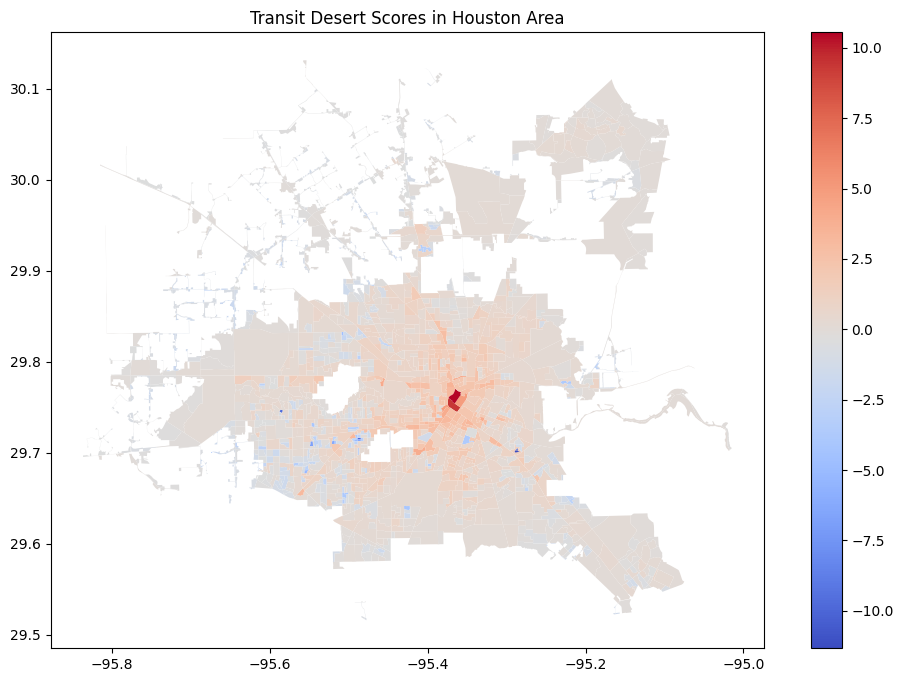

In [ ]:
# getting approximate coordinates for Huoston
houston = {
    "min_lon": -95.797,
    "max_lon": -95.014,
    "min_lat": 29.522,
    "max_lat": 30.110
}

# filter data within the Houston bounding box
houston_gdf = gdf.cx[houston["min_lon"]:houston["max_lon"], houston["min_lat"]:houston["max_lat"]]

# beware colors are decieving
fig, ax = plt.subplots(figsize=(12, 8))
houston_gdf.plot(column='Transit Desert Score', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Transit Desert Scores in Houston Area")
plt.show()

In [ ]:
houston_gdf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


geoid  Transit Desert Score  Total Population  \
12920  481576723011                 -1.04               0.0   
12921  481576729001                 -0.34               0.0   
12922  481576723024                 -1.13               0.0   
12923  481576725003                 -1.39            3487.0   
12924  482013408003                  0.12            1729.0   
...             ...                   ...               ...   
14754  481576704002                 -0.13            1266.0   
14755  481576704003                 -0.11            2439.0   
14756  481576702001                 -0.02             985.0   
14757  481576731011                 -0.46           39961.0   
14758  481576734001                 -0.11           13275.0   

       Total Transit Dependent Population  \
12920                                 0.0   
12921                                 0.0   
12922                                 0.0   
12923                              1806.0   
12924                               689.0   
...                                   ...   
14754                               576.0   
14755                              1174.0   
14756                               433.0   
14757                             16354.0   
14758                              5633.0   

       Ratio of Transit Dependent Population  \
12920                                   0.00   
12921                                   0.00   
12922                                   0.00   
12923                                  51.82   
12924                                  39.88   
...                                      ...   
14754                                  45.55   
14755                                  48.15   
14756                                  44.05   
14757                                  40.93   
14758                                  42.44   

                                                geometry  
12920  MULTIPOLYGON (((-95.64983 29.64935, -95.65090 ...  
12921  MULTIPOLYGON (((-95.71481 29.65856, -95.71712 ...  
12922  POLYGON ((-95.64983 29.64935, -95.64869 29.648...  
12923  MULTIPOLYGON (((-95.64349 29.67720, -95.64355 ...  
12924  POLYGON ((-95.13371 29.58694, -95.13496 29.586...  
...                                                  ...  
14754  POLYGON ((-95.49820 29.60787, -95.50276 29.600...  
14755  POLYGON ((-95.49091 29.61178, -95.49266 29.612...  
14756  POLYGON ((-95.47592 29.60468, -95.47594 29.601...  
14757  MULTIPOLYGON (((-95.82803 29.69619, -95.83668 ...  
14758  MULTIPOLYGON (((-95.81403 29.69229, -95.81652 ...  

[1823 rows x 6 columns]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


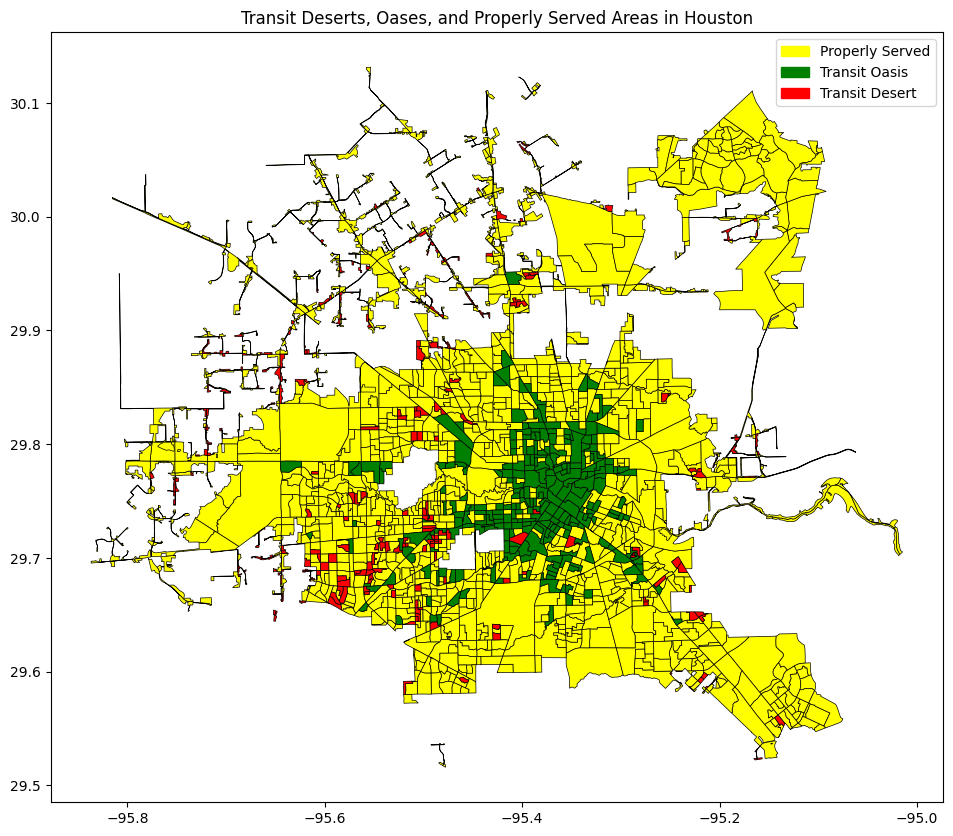

In [ ]:
# mimick colors from original graph -and make it brighteeer
color_map = {
    'Properly Served': 'yellow',  # Yellow for properly served
    'Transit Oasis': 'green',     # Green for transit oasis
    'Transit Desert': 'red'       # Red for transit desert
}

# Used Jiao's paper to see what he put as a threshold
# https://www.jtlu.org/index.php/jtlu/article/view/899
# Also did you know Jiao's into ethical AI?!
def categorize(score):
    if score < -1:
        return 'Transit Desert'  # Transit desert
    elif score > 1:
        return 'Transit Oasis'  # Transit oasis
    else:
        return 'Properly Served'  # Proper transit


# Using .loc to avoid the SettingWithCopyWarning
houston_gdf.loc[:, 'Category'] = houston_gdf['Transit Desert Score'].apply(categorize)

# legend using Patch to avoid the PatchCollection warning [ChatGPT recommended]
legend_handles = [
    mpatches.Patch(color=color_map['Properly Served'], label='Properly Served'),
    mpatches.Patch(color=color_map['Transit Oasis'], label='Transit Oasis'),
    mpatches.Patch(color=color_map['Transit Desert'], label='Transit Desert')
]

# Plot with custom colors
fig, ax = plt.subplots(figsize=(12, 10))
for category, color in color_map.items():
    subset = houston_gdf[houston_gdf['Category'] == category]
    subset.plot(ax=ax, color=color, edgecolor="black", linewidth=0.5)

# Add legend and title
ax.legend(handles=legend_handles, loc='upper right')
ax.set_title("Transit Deserts, Oases, and Properly Served Areas in Houston")
plt.show()

In [ ]:
houston_gdf = houston_gdf.rename(columns={
    'Transit Desert Score': 'transit_desert_score',
    'Total Population': 'total_population',
    'Total Transit Dependent Population': 'transit_dependent_population',
    'Ratio of Transit Dependent Population': 'transit_dependency_ratio',
    'Category': 'category'
})

# remove some columns
houston_gdf = houston_gdf[['transit_desert_score', 'total_population',
                           'transit_dependent_population', 'transit_dependency_ratio',
                           'geometry', 'category']]

print(houston_gdf.head())

       transit_desert_score  total_population  transit_dependent_population  \
12920                 -1.04               0.0                           0.0   
12921                 -0.34               0.0                           0.0   
12922                 -1.13               0.0                           0.0   
12923                 -1.39            3487.0                        1806.0   
12924                  0.12            1729.0                         689.0   

       transit_dependency_ratio  \
12920                      0.00   
12921                      0.00   
12922                      0.00   
12923                     51.82   
12924                     39.88   

                                                geometry         category  
12920  MULTIPOLYGON (((-95.64983 29.64935, -95.65090 ...   Transit Desert  
12921  MULTIPOLYGON (((-95.71481 29.65856, -95.71712 ...  Properly Served  
12922  POLYGON ((-95.64983 29.64935, -95.64869 29.648...   Transit Desert  
12923  MUL

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Had to ensure same coordinate system

# Check the CRS for each GeoDataFrame
print("CRS for houston_gdf:", houston_gdf.crs)

# Reproject to a common CRS if needed
common_crs = "EPSG:32614"


if houston_gdf.crs != common_crs:
    houston_gdf = houston_gdf.to_crs(common_crs)

# Verify that all datasets are now in the common CRS
print("CRS for houston_gdf:", houston_gdf.crs)

CRS for houston_gdf: EPSG:4326
CRS for houston_gdf: EPSG:32614


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Calculate centroids for each polygon/multipolygon to represent potential station locations
houston_gdf['centroid'] = houston_gdf.geometry.centroid
# This is a shapely function: "Computes the geometric center (center-of-mass) of a geometry.
# For multipoints this is computed as the mean of the input coordinates. For multilinestrings
# the centroid is weighted by the length of each line segment. For multipolygons the centroid
# is weighted by the area of each polygon.
# https://shapely.readthedocs.io/en/stable/reference/shapely.centroid.html

# confirm centroid column is added
print(houston_gdf[['centroid', 'transit_desert_score', 'total_population', 'category']].head())

                             centroid  transit_desert_score  total_population  \
12920  POINT (825657.088 3285913.400)                 -1.04               0.0   
12921  POINT (816088.965 3287951.570)                 -0.34               0.0   
12922  POINT (824296.353 3284367.827)                 -1.13               0.0   
12923  POINT (824535.776 3288544.093)                 -1.39            3487.0   
12924  POINT (873835.852 3279161.725)                  0.12            1729.0   

              category  
12920   Transit Desert  
12921  Properly Served  
12922   Transit Desert  
12923   Transit Desert  
12924  Properly Served  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


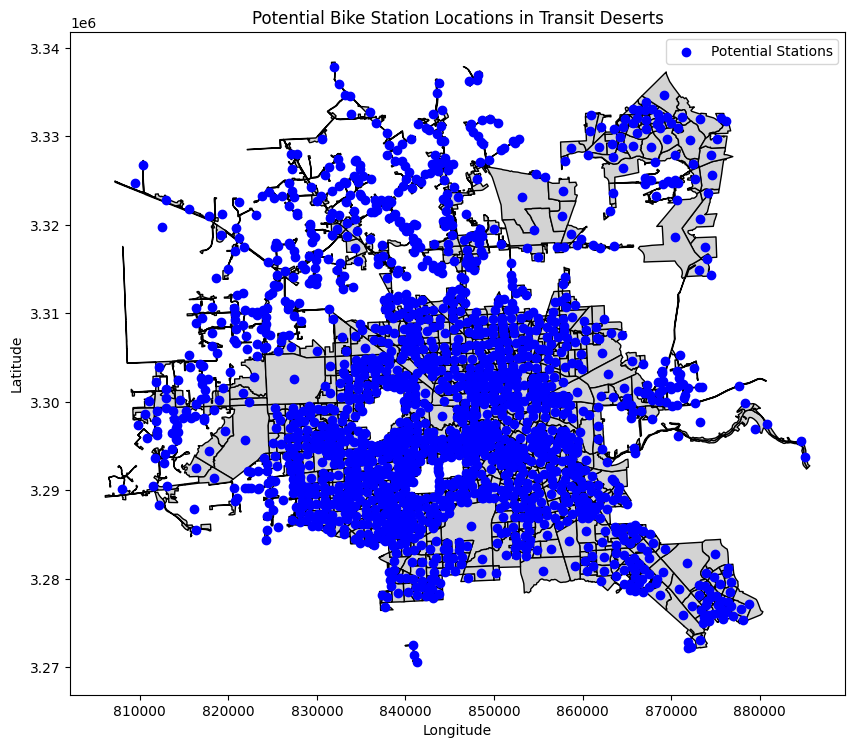

In [ ]:
# Plot the city boundaries and the centroids
fig, ax = plt.subplots(figsize=(10, 10))
houston_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
houston_gdf.set_geometry('centroid').plot(ax=ax, color='blue', marker='o', label='Potential Stations')

plt.title("Potential Bike Station Locations in Transit Deserts")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

In [ ]:
# Filter for transit desert areas
transit_deserts = houston_gdf[houston_gdf['category'] == 'Transit Desert']

# Preview the filtered data
print(transit_deserts[['centroid', 'transit_desert_score', 'total_population']].head())

                             centroid  transit_desert_score  total_population
12920  POINT (825657.088 3285913.400)                 -1.04               0.0
12922  POINT (824296.353 3284367.827)                 -1.13               0.0
12923  POINT (824535.776 3288544.093)                 -1.39            3487.0
12930  POINT (863779.385 3280308.756)                 -2.10            3529.0
12931  POINT (866698.012 3279989.459)                 -1.18            1864.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


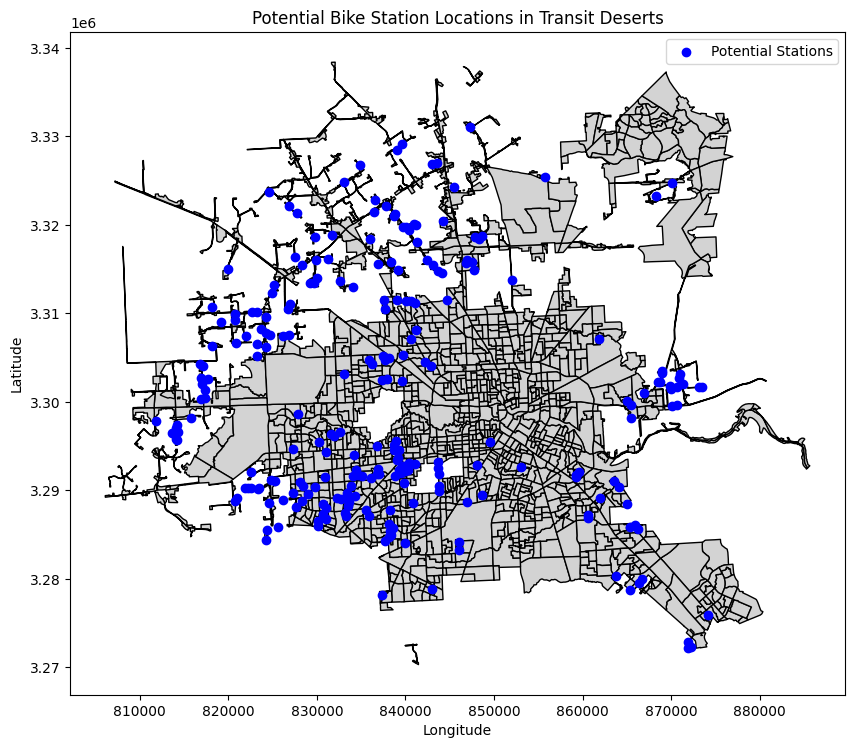

In [ ]:
# Plot the city boundaries and centroids of transit deserts
fig, ax = plt.subplots(figsize=(10, 10))
houston_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')  # Plot all areas for context
transit_deserts.set_geometry('centroid').plot(ax=ax, color='blue', marker='o', label='Potential Stations')

plt.title("Potential Bike Station Locations in Transit Deserts")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

# Extracting Points of Interest

In [ ]:
houston_pois = ox.features_from_place("Houston, Texas, USA", tags={'amenity': True})
print(houston_pois.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                 amenity                    geometry barrier  \
element_type osmid                                                             
node         151383159  parking_entrance  POINT (-95.27750 29.65721)     NaN   
             151807050    ferry_terminal  POINT (-95.08061 29.76204)     NaN   
             356702796            school  POINT (-95.44133 29.67468)     NaN   
             356704784            school  POINT (-95.37966 29.73606)     NaN   
             356705541            school  POINT (-95.37895 29.74497)     NaN   

                       ferry                                    name  \
element_type osmid                                                     
node         151383159   NaN                                     NaN   
             151807050   yes  Lynchburg Ferry Landing South Entrance   
             356702796   NaN                   Corpus Christi School   
             356704784   NaN              Dominion Montessori School   
       

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<ipython-input-78-0bdadd57e5b1>:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


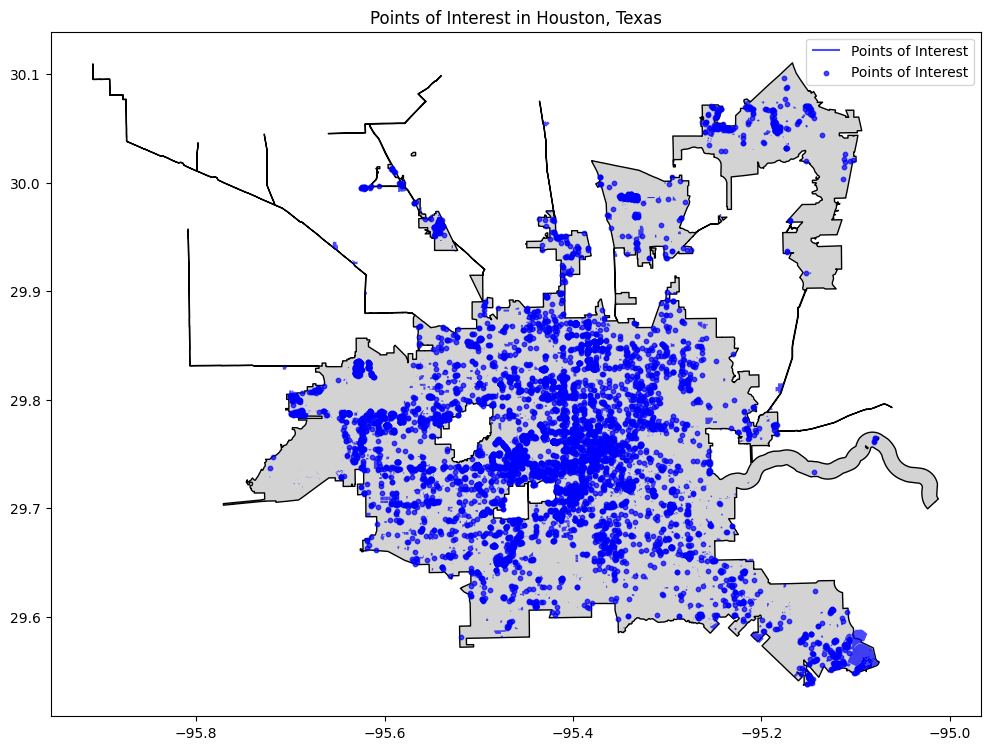

In [ ]:
houston_boundary = ox.geocode_to_gdf("Houston, Texas, USA")

# plot the boundary and the POIs on the same map
fig, ax = plt.subplots(figsize=(12, 12))
houston_boundary.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=1)
houston_pois.plot(ax=ax, color='blue', markersize=10, alpha=0.7, label='Points of Interest')

ax.legend()
ax.set_title("Points of Interest in Houston, Texas")
plt.show()

In [ ]:
poi_types = houston_pois['amenity'].unique()
print("POI Types:", poi_types)

POI Types: ['parking_entrance' 'ferry_terminal' 'school' 'grave_yard' 'library'
 'clinic' 'hospital' 'place_of_worship' 'university' 'fire_station'
 'police' 'events_venue' 'pub' 'restaurant' 'fuel' 'dentist' 'fast_food'
 'theatre' 'cinema' 'bar' 'swingerclub' 'recycling' 'cafe' 'toilets'
 'drinking_water' 'nightclub' 'pharmacy' 'bank' 'atm' 'doctors'
 'post_office' 'fountain' 'shelter' 'parking' 'vending_machine'
 'marketplace' 'waste_basket' 'ice_cream' 'bench' 'post_box' 'food_court'
 'charging_station' 'car_wash' 'car_rental' 'veterinary' 'bicycle_rental'
 'truck_rental' 'bicycle_repair_station' 'bureau_de_change' 'shop'
 'arts_centre' 'bicycle_parking' 'boat_rental' 'cigar_lounge' 'bbq'
 'biergarten' 'driving_school' 'bus_station' 'public_bookcase'
 'bicycle_wash' 'payment_terminal' 'kindergarten' 'shower'
 'waste_disposal' 'animal_boarding' 'parking_space' 'money_transfer'
 'music_school' 'social_facility' 'acting_school' 'wellness' 'prep_school'
 'social_centre' 'conference_cent

In [ ]:
# Manually categorize these to see the pattern in the city
categories = {
    "Transportation and Parking": [
        'parking_entrance', 'ferry_terminal', 'bus_station', 'car_rental', 'car_wash',
        'bicycle_rental', 'bicycle_repair_station', 'bicycle_parking', 'bicycle_wash',
        'motorcycle_parking', 'truck_rental', 'parking', 'parking_space', 'vehicle_inspection',
        'weighbridge', 'charging_station', 'car_sharing', 'boat_rental', 'boat_storage',
        'vacuum_cleaner', 'compressed_air', 'loading_dock'
    ],
    "Education and Childcare": [
        'school', 'university', 'kindergarten', 'prep_school', 'music_school',
        'acting_school', 'college', 'dojo', 'childcare', 'training', 'animal_training',
        'driving_school'
    ],
    "Health and Wellness": [
        'clinic', 'hospital', 'dentist', 'pharmacy', 'doctors', 'nursing_home', 'wellness',
        'plasma_center', 'veterinary', 'animal_boarding', 'retirement_home'
    ],
    "Food and Drink": [
        'restaurant', 'cafe', 'pub', 'bar', 'fast_food', 'ice_cream', 'food_court',
        'biergarten', 'ice_cream;chocolate;cake', 'bbq', 'cigar_lounge', 'stripclub',
        'swingerclub', 'nightclub'
    ],
    "Entertainment and Culture": [
        'theatre', 'cinema', 'arts_centre', 'music_venue', 'events_venue', 'community_centre',
        'festival_grounds', 'conference_centre', 'studio', 'public_building', 'casino',
        'auditorium', 'bandstand', 'stage', 'child_amusement_center', 'dressing_room'
    ],
    "Public Services and Safety": [
        'fire_station', 'police', 'post_office', 'courthouse', 'prison', 'townhall',
        'public_building', 'post_depot', 'waste_disposal', 'waste_transfer_station',
        'recycling', 'animal_shelter', 'social_facility', 'social_centre', 'plasma_center',
        'storage'
    ],
    "Financial Services": [
        'bank', 'atm', 'bureau_de_change', 'money_transfer', 'cheque_cashing'
    ],
    "Shopping and Commercial Services": [
        'shop', 'marketplace', 'vending_machine', 'payment_terminal', 'parcel_locker',
        'letter_box', 'mailroom'
    ],
    "Religious and Memorial Sites": [
        'place_of_worship', 'chapel', 'monastery', 'grave_yard'
    ],
    "Recreational Facilities": [
        'lounge', 'music_venue', 'biergarten', 'casino', 'arts_centre', 'public_bookcase',
        'drinking_water', 'bench', 'fountain', 'shelter'
    ],
    "Miscellaneous": [
        'fixme', 'clock', 'telephone', 'feeding_place', 'bandstand', 'dojo', 'studio',
        'conference_centre', 'prep_school', 'festival_grounds'
    ]
}

for category, items in categories.items():
    print(f"{category}:")
    print(items)
    print()

Transportation and Parking:
['parking_entrance', 'ferry_terminal', 'bus_station', 'car_rental', 'car_wash', 'bicycle_rental', 'bicycle_repair_station', 'bicycle_parking', 'bicycle_wash', 'motorcycle_parking', 'truck_rental', 'parking', 'parking_space', 'vehicle_inspection', 'weighbridge', 'charging_station', 'car_sharing', 'boat_rental', 'boat_storage', 'vacuum_cleaner', 'compressed_air', 'loading_dock']

Education and Childcare:
['school', 'university', 'kindergarten', 'prep_school', 'music_school', 'acting_school', 'college', 'dojo', 'childcare', 'training', 'animal_training', 'driving_school']

Health and Wellness:
['clinic', 'hospital', 'dentist', 'pharmacy', 'doctors', 'nursing_home', 'wellness', 'plasma_center', 'veterinary', 'animal_boarding', 'retirement_home']

Food and Drink:
['restaurant', 'cafe', 'pub', 'bar', 'fast_food', 'ice_cream', 'food_court', 'biergarten', 'ice_cream;chocolate;cake', 'bbq', 'cigar_lounge', 'stripclub', 'swingerclub', 'nightclub']

Entertainment and C

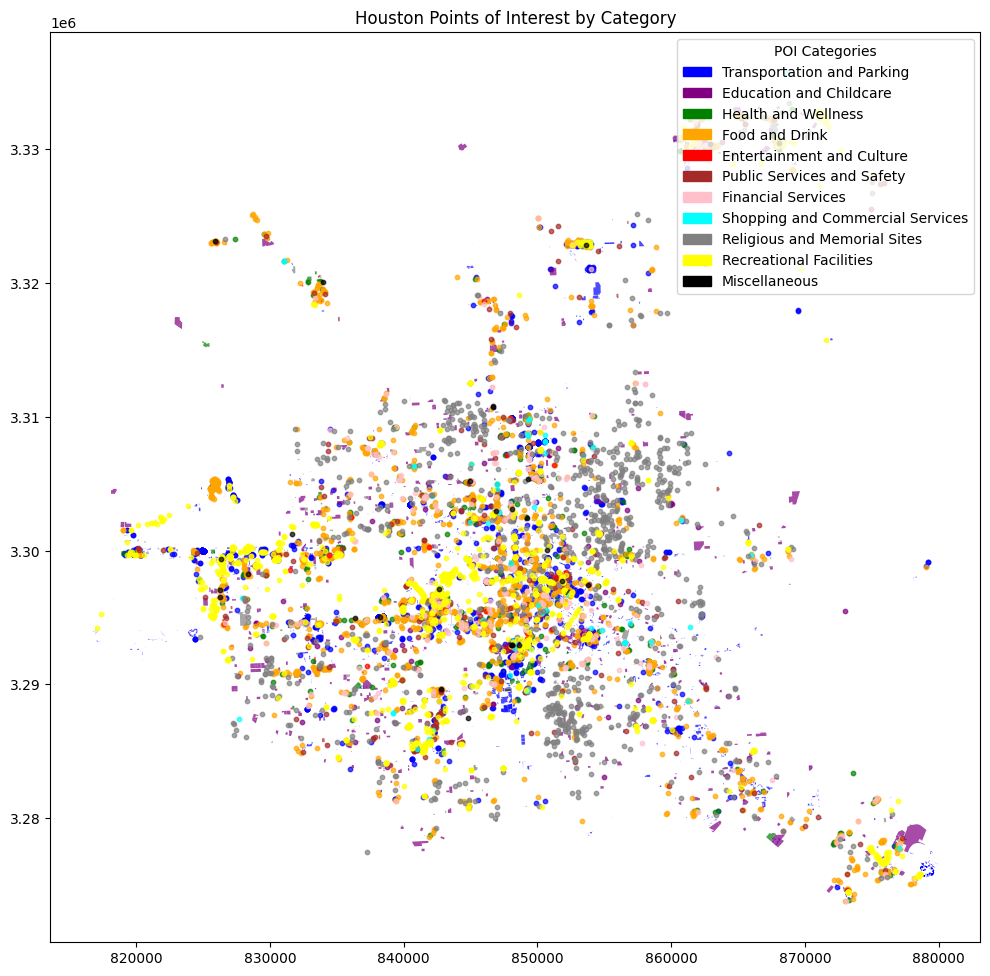

In [ ]:
# define a color map for each broader category
category_color_map = {
    "Transportation and Parking": 'blue',
    "Education and Childcare": 'purple',
    "Health and Wellness": 'green',
    "Food and Drink": 'orange',
    "Entertainment and Culture": 'red',
    "Public Services and Safety": 'brown',
    "Financial Services": 'pink',
    "Shopping and Commercial Services": 'cyan',
    "Religious and Memorial Sites": 'gray',
    "Recreational Facilities": 'yellow',
    "Miscellaneous": 'black'
}

poi_category_mapping = {}
for category, poi_list in categories.items():
    for poi_type in poi_list:
        poi_category_mapping[poi_type] = category

# add category column
houston_pois['Category'] = houston_pois['amenity'].map(poi_category_mapping)

# Plot each category with its color on the map
fig, ax = plt.subplots(figsize=(12, 12))

legend_handles = []

for category, color in category_color_map.items():
    subset = houston_pois[houston_pois['Category'] == category]
    if not subset.empty:  # Only plot if the subset is not empty
        subset.plot(ax=ax, color=color, markersize=10, alpha=0.7, label=category)
        legend_handles.append(mpatches.Patch(color=color, label=category))


ax.legend(handles=legend_handles, title="POI Categories", loc='upper right')
ax.set_title("Houston Points of Interest by Category")
plt.show()

In [ ]:
houston_pois.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


amenity                        geometry  \
element_type osmid                                                         
node         151383159  parking_entrance  POINT (860384.638 3286599.877)   
             151807050    ferry_terminal  POINT (879066.069 3298860.619)   
             356702796            school  POINT (844453.183 3288037.830)   
             356704784            school  POINT (850212.822 3295032.136)   
             356705541            school  POINT (850250.724 3296022.081)   

                       barrier ferry                                    name  \
element_type osmid                                                             
node         151383159     NaN   NaN                                     NaN   
             151807050     NaN   yes  Lynchburg Ferry Landing South Entrance   
             356702796     NaN   NaN                   Corpus Christi School   
             356704784     NaN   NaN              Dominion Montessori School   
             356705541     NaN   NaN                           Fannin School   

                       public_transport access  ele gnis:feature_id religion  \
element_type osmid                                                             
node         151383159              NaN    NaN  NaN             NaN      NaN   
             151807050          station    NaN  NaN             NaN      NaN   
             356702796              NaN    NaN   17         1333387      NaN   
             356704784              NaN    NaN   15         1334474      NaN   
             356705541              NaN    NaN   15         1335693      NaN   

                        ... owner:contact:facebook building:architecture  \
element_type osmid      ...                                                
node         151383159  ...                    NaN                   NaN   
             151807050  ...                    NaN                   NaN   
             356702796  ...                    NaN                   NaN   
             356704784  ...                    NaN                   NaN   
             356705541  ...                    NaN                   NaN   

                       name:short opening_date drink:cider  \
element_type osmid                                           
node         151383159        NaN          NaN         NaN   
             151807050        NaN          NaN         NaN   
             356702796        NaN          NaN         NaN   
             356704784        NaN          NaN         NaN   
             356705541        NaN          NaN         NaN   

                       operator:short_name contact:whatsapp street_vendor  \
element_type osmid                                                          
node         151383159                 NaN              NaN           NaN   
             151807050                 NaN              NaN           NaN   
             356702796                 NaN              NaN           NaN   
             356704784                 NaN              NaN           NaN   
             356705541                 NaN              NaN           NaN   

                       visibility                    Category  
element_type osmid                                             
node         151383159        NaN  Transportation and Parking  
             151807050        NaN  Transportation and Parking  
             356702796        NaN     Education and Childcare  
             356704784        NaN     Education and Childcare  
             356705541        NaN     Education and Childcare  

[5 rows x 538 columns]

## Only use POIs that are points

In [ ]:
print(houston_pois.geometry.geom_type.value_counts())

Polygon         18363
Point            9400
LineString         37
MultiPolygon       22
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
houston_pois_points = houston_pois[houston_pois.geometry.geom_type == 'Point']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Get the Road Network

In [ ]:
# Define the path to the .shp file
file_path = "/content/drive/My Drive/Capstone code/Data/Houston Road Networks/houston-texas-roads.shp"

# Load the shapefile
road_network_gdf = gpd.read_file(file_path)

# Display the first few rows of the GeoDataFrame
print(road_network_gdf.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    CITY_R POSTAL_R  LF_ADDR SUFFIX  LT_ACT COUNTY_R EXCHANGE_R DATE_MOD  \
0  Houston  Houston   3901.0   None     NaN   Harris       None     None   
1  Houston  Houston   1401.0   None     NaN   Harris       None     None   
2  Houston  Houston   1235.0   None     NaN   Harris       None     None   
3  Houston  Houston   3801.0   None     NaN   Harris       None     None   
4     None  Houston   2701.0   None     NaN   Harris       None     None   

  EXCHANGE_L KEYMAP  ... GDC_FLAG               SUBDIV MSAG_NAME LEGALNAME  \
0       None   492H  ...     None                 None      None      None   
1       None   495K  ...     None      PORT HOUSTON NS      None      None   
2       None   496M  ...     None                 None      None      None   
3       None   573G  ...     None  SOUTH ACRES ESTATES      None      None   
4       None   573X  ...     None                 None      None      None   

   MSAG_VALID     CREATED  FUNC_CLASS SPEED last_edi_1  \
0           M  1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

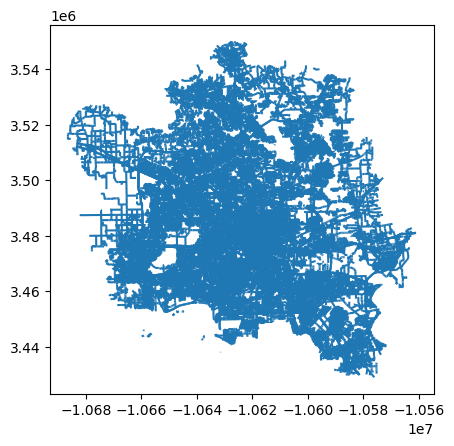

In [ ]:
road_network_gdf.plot()

In [ ]:
# Had to ensure same coordinate system

# Check the CRS for each GeoDataFrame
print("CRS for transit_deserts:", transit_deserts.crs)
print("CRS for houston_pois_points:", houston_pois_points.crs)
print("CRS for road_network_gdf:", road_network_gdf.crs)

# Reproject to a common CRS if needed
common_crs = "EPSG:32614"


if transit_deserts.crs != common_crs:
    transit_deserts = transit_deserts.to_crs(common_crs)

if houston_pois_points.crs != common_crs:
    houston_pois_points = houston_pois_points.to_crs(common_crs)

if road_network_gdf.crs != common_crs:
    road_network_gdf = road_network_gdf.to_crs(common_crs)

# Verify that all datasets are now in the common CRS
print("Updated CRS for transit_deserts:", transit_deserts.crs)
print("Updated CRS for houston_pois_points:", houston_pois_points.crs)
print("Updated CRS for road_network_gdf:", road_network_gdf.crs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CRS for transit_deserts: EPSG:32614
CRS for houston_pois_points: EPSG:32614
CRS for road_network_gdf: EPSG:3857
Updated CRS for transit_deserts: EPSG:32614
Updated CRS for houston_pois_points: EPSG:32614
Updated CRS for road_network_gdf: EPSG:32614


In [ ]:
# Create an undirected graph
G = nx.Graph()

# Iterate over the rows of the road network GeoDataFrame
for _, row in road_network_gdf.iterrows():
    # Check if the geometry type is a LineString to process it
    if row['geometry'].geom_type == 'LineString':
        coords = list(row['geometry'].coords)

        # Add edges between consecutive points in the LineString
        for i in range(len(coords) - 1):
            start_node = coords[i]
            end_node = coords[i + 1]

            # Calculate distance between the points
            distance = LineString([start_node, end_node]).length

            # Add the start and end nodes with their positions if they are not already in the graph
            if start_node not in G.nodes:
                G.add_node(start_node, pos=start_node)
            if end_node not in G.nodes:
                G.add_node(end_node, pos=end_node)

            # Add the edge to the graph with distance as weight
            G.add_edge(start_node, end_node, weight=distance)

# Print the basic graph info to verify
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 877135
Number of edges: 925011


# Define Necessary Functions

## STEP 1: Deep Copy the Graph

In [ ]:
def copy_graph(G):
    """Creates a deep copy of a NetworkX graph G.

    Parameters:
    G (networkx.Graph): The graph to be copied.

    Returns:
    networkx.Graph: A deep copy of the input graph.
    """
    return nx.Graph(G) if not G.is_directed() else nx.DiGraph(G)

## Step 2: Get Random Points
Both for Transit Deserts and POIs

In [ ]:
def get_random_centroid(gdf):
    """
    Selects a random centroid from the given GeoDataFrame.

    Parameters:
    gdf (geopandas.GeoDataFrame): The GeoDataFrame containing geometries with centroids.

    Returns:
    shapely.geometry.Point: The centroid geometry of the randomly selected row.
    """
    # Select a random row from the GeoDataFrame
    random_row = gdf.sample(n=1).iloc[0]

    # Get the centroid geometry
    centroid_geometry = random_row['centroid']

    return centroid_geometry

In [ ]:
def get_random_pois(gdf):
    """
    Selects a random point of interest (POI) from the given GeoDataFrame.

    Parameters:
    gdf (geopandas.GeoDataFrame): The GeoDataFrame containing POI geometries.

    Returns:
    shapely.geometry.Point: The geometry of the randomly selected POI.
    """
    # Select a random row from the GeoDataFrame
    random_row = gdf.sample(n=1).iloc[0]

    pois_geometry = random_row['geometry']

    return pois_geometry

## Step 3: Project the points on the Nearest Edge

In [ ]:
def project_point_onto_road(geometry_point, road_network_gdf):
    """
    Projects a given point onto the nearest road segment in a GeoDataFrame.

    Parameters:
    geometry_point (shapely.geometry.Point): The input point to be projected.
    road_network_gdf (geopandas.GeoDataFrame): A GeoDataFrame containing road network geometries.

    Returns:
    shapely.geometry.Point: The projected point onto the nearest road segment.
    """
    # Calculate the distance from the input point to each road segment
    road_network_gdf['distance'] = road_network_gdf['geometry'].apply(lambda x: geometry_point.distance(x))

    # Identify the nearest road segment
    nearest_road = road_network_gdf.loc[road_network_gdf['distance'].idxmin()]

    # Project the input point onto the nearest road segment
    projected_point = nearest_road['geometry'].interpolate(nearest_road['geometry'].project(geometry_point))

    return projected_point

## Step 4: Add the Node on the Graph

In [ ]:
def add_projected_point_to_graph(G, projected_point, nearest_road_geometry):
    """
    Adds a projected point to the existing NetworkX graph and connects it to the nearest nodes
    of the given road segment geometry. This function ensures the new node is integrated into
    the graph while preserving the connectivity of the existing network.

    Parameters:
    G (networkx.Graph): The graph representing the road network.
    projected_point (shapely.geometry.Point): The point to be added to the graph.
    nearest_road_geometry (shapely.geometry.LineString): The geometry of the nearest road segment.

    Returns:
    networkx.Graph: The updated graph with the new projected point and connections.
    """
    # Extract the coordinates from the nearest road geometry
    coords = list(nearest_road_geometry.coords)
    start_point = Point(coords[0])
    end_point = Point(coords[-1])

    # Find or add nodes in the graph for start and end points
    start_node = find_or_add_node(G, start_point)
    end_node = find_or_add_node(G, end_point)

    # Add the projected point as a new node
    new_node_id = (projected_point.x, projected_point.y)
    G.add_node(new_node_id, pos=(projected_point.x, projected_point.y))

    # Calculate distances between the new node and start/end nodes
    distance_start_to_projected = start_point.distance(projected_point)
    distance_projected_to_end = projected_point.distance(end_point)

    # Remove the original edge between start_node and end_node, if it exists
    if G.has_edge(start_node, end_node):
        G.remove_edge(start_node, end_node)

    # Add new edges with distances as weights
    G.add_edge(start_node, new_node_id, weight=distance_start_to_projected,
               geometry=LineString([start_point, projected_point]))
    G.add_edge(new_node_id, end_node, weight=distance_projected_to_end,
               geometry=LineString([projected_point, end_point]))

    return G

def find_or_add_node(G, point):
    """
    Finds an existing node in the graph close to the given point or adds the point as a new node.

    Parameters:
    G (networkx.Graph): The graph to search for the node.
    point (shapely.geometry.Point): The point to find or add as a node.

    Returns:
    tuple: The node ID of the found or newly added node.
    """
    for node in G.nodes:
        if Point(G.nodes[node]['pos']).equals(point):
            return node  # Return the existing node ID if it matches the given point

    # If no matching node is found, create a new node ID and add it
    new_id = (point.x, point.y)
    G.add_node(new_id, pos=(point.x, point.y))

# Implement the whole flow

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Random centroid selected: POINT (833423.2720542125 3289718.5361026735)
Projected point onto nearest road: POINT (833355.4389641914 3289709.7583363727)
Node found in graph for point: POINT (833346.2567412604 3289762.1866231943)
Node found in graph for point: POINT (833378.0270800199 3289539.335785488)
Node added to graph with ID: (833355.4389641914, 3289709.7583363727)
Edges added between (833346.2567412604, 3289762.1866231943) and (833355.4389641914, 3289709.7583363727), and (833355.4389641914, 3289709.7583363727) and (833378.0270800199, 3289539.335785488)
Random POI selected: POINT (856531.1951863576 3293080.5253526457)
Projected point onto nearest road: POINT (856568.7299801796 3293065.512871408)
Node found in graph for point: POINT (856669.1919858861 3293315.5820149328)
Node found in graph for point: POINT (856520.6020473817 3292943.83867229)
Node added to graph with ID: (856568.7299801796, 3293065.512871408)
Edges added between (856669.1919858861, 3293315.5820149328) and (856568.72

Visualizing shortest path:   0%|          | 0/1 [00:00<?, ?it/s]

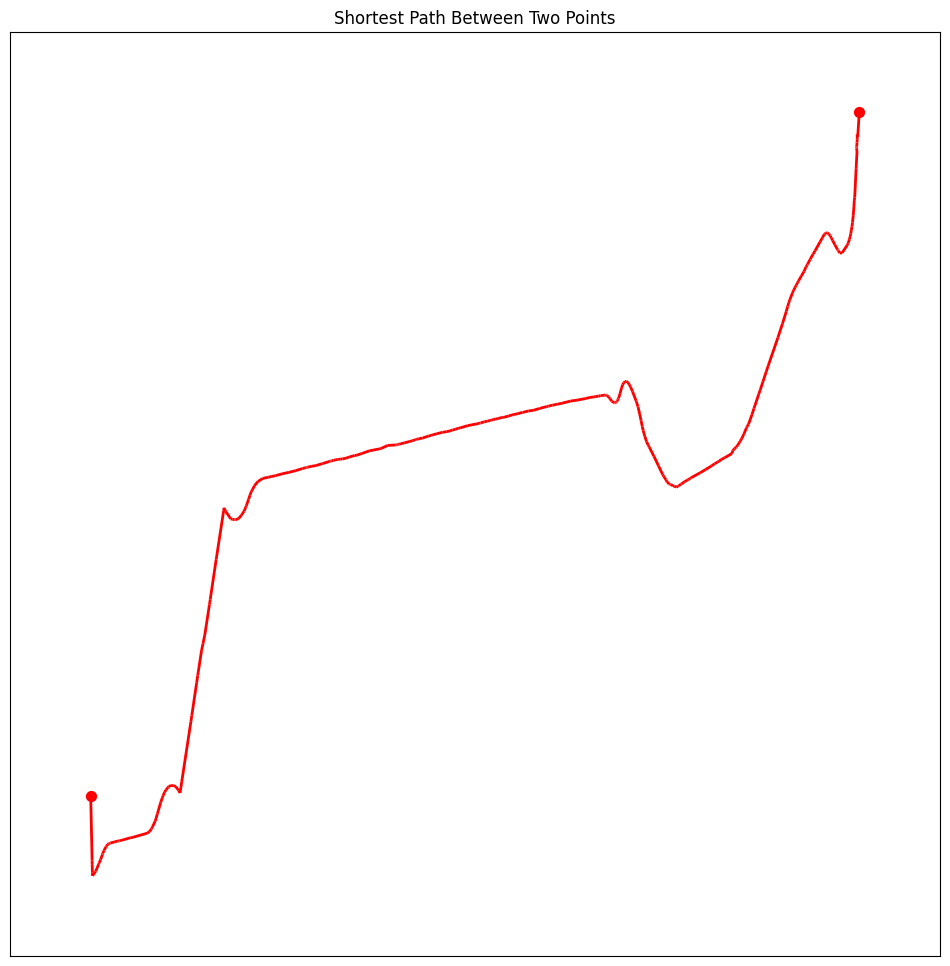

Visualizing shortest path: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


In [ ]:
# Function to create a deep copy of the graph
def copy_graph(G):
    return nx.Graph(G) if not G.is_directed() else nx.DiGraph(G)

# Function to get a random centroid from the GeoDataFrame
def get_random_centroid(gdf):
    random_row = gdf.sample(n=1).iloc[0]
    print("Random centroid selected:", random_row['centroid'])
    return random_row['centroid']

# Function to project a point onto the nearest road segment
def project_point_onto_road(geometry_point, road_network_gdf):
    if not isinstance(geometry_point, Point):
        raise ValueError("The input geometry must be a Point.")

    road_network_gdf['distance'] = road_network_gdf['geometry'].apply(lambda x: geometry_point.distance(x))
    nearest_road = road_network_gdf.loc[road_network_gdf['distance'].idxmin()]
    projected_point = nearest_road['geometry'].interpolate(nearest_road['geometry'].project(geometry_point))
    print("Projected point onto nearest road:", projected_point)
    return projected_point

# Function to add a projected point to the graph
def add_projected_point_to_graph(G, projected_point, nearest_road_geometry):
    coords = list(nearest_road_geometry.coords)
    start_point = Point(coords[0])
    end_point = Point(coords[-1])

    start_node = find_or_add_node(G, start_point)
    end_node = find_or_add_node(G, end_point)

    new_node_id = (projected_point.x, projected_point.y)
    if new_node_id not in G.nodes:
        G.add_node(new_node_id, pos=(projected_point.x, projected_point.y))
    print("Node added to graph with ID:", new_node_id)

    distance_start_to_projected = start_point.distance(projected_point)
    distance_projected_to_end = projected_point.distance(end_point)

    if G.has_edge(start_node, end_node):
        G.remove_edge(start_node, end_node)

    G.add_edge(start_node, new_node_id, weight=distance_start_to_projected, geometry=LineString([start_point, projected_point]))
    G.add_edge(new_node_id, end_node, weight=distance_projected_to_end, geometry=LineString([projected_point, end_point]))

    print(f"Edges added between {start_node} and {new_node_id}, and {new_node_id} and {end_node}")
    return G

# Function to find or add a node in the graph
def find_or_add_node(G, point):
    for node in G.nodes:
        if Point(G.nodes[node]['pos']).equals(point):
            print("Node found in graph for point:", point)
            return node
    new_id = (point.x, point.y)
    G.add_node(new_id, pos=(point.x, point.y))
    print("New node added to graph with ID:", new_id)
    return new_id

# Function to get a random POI from the GeoDataFrame
def get_random_pois(gdf):
    random_row = gdf.sample(n=1).iloc[0]
    print("Random POI selected:", random_row['geometry'])
    return random_row['geometry']

# Function to calculate the shortest path between two points
def calculate_shortest_path(G, start_node, end_node):
    try:
        shortest_path = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')
        total_distance = nx.shortest_path_length(G, source=start_node, target=end_node, weight='weight')
        print("Shortest path found:", shortest_path)
        print("Total distance:", total_distance)
        return shortest_path, total_distance
    except nx.NetworkXNoPath:
        print("No path found between the specified nodes.")
        return None, None


# Visualize a single run for demonstration
G_copy = copy_graph(G)

# Step 1: Get a random centroid
random_centroid = get_random_centroid(transit_deserts)

# Step 2: Project centroid onto nearest road
projected_centroid = project_point_onto_road(random_centroid, road_network_gdf)
nearest_road_geometry = road_network_gdf.loc[road_network_gdf['distance'].idxmin()]['geometry']

# Step 3: Add projected centroid to the graph
G_copy = add_projected_point_to_graph(G_copy, projected_centroid, nearest_road_geometry)

# Step 4: Get a random POI
random_poi = get_random_pois(houston_pois_points)

# Step 5: Project POI onto nearest road
if isinstance(random_poi, Point):
    projected_poi = project_point_onto_road(random_poi, road_network_gdf)
    nearest_road_geometry_poi = road_network_gdf.loc[road_network_gdf['distance'].idxmin()]['geometry']

    # Step 6: Add projected POI to the graph
    G_copy = add_projected_point_to_graph(G_copy, projected_poi, nearest_road_geometry_poi)

    # Step 7: Calculate the shortest path
    shortest_path, total_distance = calculate_shortest_path(G_copy, (projected_centroid.x, projected_centroid.y), (projected_poi.x, projected_poi.y))

    # Visualization with tqdm
    with tqdm(total=1, desc="Visualizing shortest path") as pbar:
        plt.figure(figsize=(12, 12))

        # Draw only the mapped points and the shortest path
        pos = {node: (data['pos'][0], data['pos'][1]) for node, data in G_copy.nodes(data=True)}

        # Draw the mapped points
        nx.draw_networkx_nodes(G_copy, pos, nodelist=[(projected_centroid.x, projected_centroid.y), (projected_poi.x, projected_poi.y)], node_color='red', node_size=50)

        # Highlight the shortest path in red
        if shortest_path:
            path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))
            nx.draw_networkx_edges(G_copy, pos, edgelist=path_edges, edge_color='red', width=2)

        plt.title("Shortest Path Between Two Points")
        plt.show()
        pbar.update(1)


Processing 100 iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Random centroid selected: POINT (874174.7902174765 3275919.4963235217)
Projected point onto nearest road: POINT (874131.5769609138 3275973.8735084184)
Node found in graph for point: POINT (874116.2641334811 3275961.7044867636)
Node found in graph for point: POINT (874296.8926736899 3276111.613724969)
Node added to graph with ID: (874131.5769609138, 3275973.8735084184)
Edges added between (874116.2641334811, 3275961.7044867636) and (874131.5769609138, 3275973.8735084184), and (874131.5769609138, 3275973.8735084184) and (874296.8926736899, 3276111.613724969)
Random POI selected: POINT (832262.2713828494 3320038.544354354)
Projected point onto nearest road: POINT (832225.6984387608 3320090.9376429776)
Node found in graph for point: POINT (832258.6372852062 3320126.1520430106)
Node found in graph for point: POINT (832183.3221175533 3320077.101350515)
Node added to graph with ID: (832225.6984387608, 3320090.9376429776)
Edges added between (832258.6372852062, 3320126.1520430106) and (832225.

Processing 100 iterations:   1%|          | 1/100 [01:12<1:58:55, 72.08s/it]

Shortest path found: [(874131.5769609138, 3275973.8735084184), (874296.8926736899, 3276111.613724969), (874170.9121309693, 3276254.8562778058), (874122.3902341514, 3276310.2037524455), (873993.6583645612, 3276461.201267017), (873906.0477651209, 3276556.3487743232), (873792.8506134576, 3276686.0202722116), (873756.6513178116, 3276728.0196524216), (873742.7901744139, 3276743.8750752765), (873732.7542466113, 3276755.829979978), (873691.9553413899, 3276802.33859545), (873648.0329545105, 3276853.408533978), (873586.4501759491, 3276923.372469111), (873540.9893995977, 3276976.088069319), (873503.2620774026, 3277019.53192478), (873443.0079120224, 3277088.7665813556), (873400.8543892828, 3277136.865873165), (873359.5110018974, 3277186.1737006567), (873308.4204360091, 3277243.313016257), (873171.330289445, 3277401.5419890136), (873049.8243404236, 3277537.55534262), (872972.0404670017, 3277625.9083932005), (872931.2622706866, 3277671.9880364183), (872892.7607276834, 3277716.04006077), (872869.689

Processing 100 iterations:   2%|▏         | 2/100 [01:48<1:23:40, 51.23s/it]

Shortest path found: [(848286.7795908707, 3318389.6827010093), (848281.3777871819, 3318521.3186343377), (848205.267968233, 3318518.021217726), (848167.6823145805, 3318517.043592314), (848102.8664700943, 3318514.165851235), (848049.0967075594, 3318511.640642377), (848022.5729606465, 3318510.375710476), (847992.428613408, 3318507.096385929), (847954.2947981129, 3318499.767192073), (847924.3120182012, 3318490.5441054637), (847918.5057560235, 3318488.6833471586), (847908.3080514615, 3318484.5392071283), (847879.9813726788, 3318470.5242326385), (847855.3594958874, 3318455.7686785082), (847826.4582447289, 3318436.238102236), (847794.8266010128, 3318410.034638845), (847829.6271090179, 3318359.246321903), (847844.4662501051, 3318332.8083538404), (847857.9031971565, 3318304.656707873), (847864.2215460732, 3318291.075866647), (847887.7380940904, 3318223.8427667357), (847908.4825473384, 3318150.5970804947), (847916.4434673049, 3318108.692100162), (847920.1053526258, 3318085.528667686), (847922.96

Processing 100 iterations:   3%|▎         | 3/100 [02:40<1:23:33, 51.68s/it]

Shortest path found: [(820747.274162497, 3310016.64264007), (820786.2399799984, 3310010.617613115), (820875.3484429674, 3310004.8815060765), (820971.431908983, 3310009.632906615), (821046.607350724, 3310013.302264106), (821054.716041343, 3310013.739565825), (821155.0648322403, 3310017.937419037), (821366.6490133412, 3310025.2416208405), (821371.9130457242, 3309918.066455704), (821483.7812450409, 3309923.6500265165), (821495.5623034572, 3309918.9445043765), (821498.8655113848, 3309908.5808450337), (821502.6291834766, 3309826.563822671), (821503.7233050354, 3309741.9873703527), (821507.133135693, 3309662.947722638), (821511.0705564285, 3309581.4534504935), (821568.3562183687, 3309583.207620517), (821680.6361975928, 3309587.119423387), (821698.7576795155, 3309586.6745670885), (821717.7858108375, 3309582.2998564015), (821727.9545024163, 3309578.035114993), (821702.3323509265, 3309503.9360727393), (821695.2141808197, 3309476.2795092287), (821690.352122845, 3309456.9641591953), (821686.74204

Processing 100 iterations:   4%|▍         | 4/100 [03:33<1:22:57, 51.85s/it]

Shortest path found: [(837676.1674501424, 3304718.9203223707), (837978.9166529324, 3304730.926605042), (837983.8696325422, 3304591.9642914785), (837987.8509419665, 3304509.709977986), (837992.4413519801, 3304480.0113466666), (838003.629370402, 3304451.982342681), (838066.1692288024, 3304352.3701003445), (838071.2616764517, 3304340.7388372677), (838078.4884519896, 3304321.7053809995), (838082.9002865264, 3304298.5380791635), (838085.0219758683, 3304252.881202511), (838089.0764740327, 3304168.0730703454), (838090.4131417988, 3304124.087361019), (838091.2481091127, 3304072.012022846), (838095.1085170687, 3303993.5803502304), (838095.5173457782, 3303980.244331376), (838147.2059219701, 3303980.7747266446), (838182.8059041866, 3303975.931861478), (838235.7775430011, 3303958.266740381), (838310.7884704394, 3303919.7899814006), (838316.0623291845, 3303917.08919545), (838279.6133306602, 3303852.4540763595), (838249.3855768514, 3303778.0507913944), (838228.0317167742, 3303703.0842336016), (83821

Processing 100 iterations:   5%|▌         | 5/100 [04:24<1:21:59, 51.79s/it]

Shortest path found: [(833564.0997902531, 3289226.013664071), (833639.229439695, 3289161.785853681), (833660.4701071032, 3289143.778035988), (833697.9542863243, 3289102.3439230984), (833731.461236191, 3289045.111650267), (833743.2891841594, 3289020.063729819), (833754.9118313745, 3288977.4287289865), (833751.74176297, 3288910.2113285908), (833749.0135223626, 3288803.8527379804), (833748.8710907053, 3288783.309654632), (833750.6291111936, 3288766.5750887142), (833753.0170943461, 3288743.8447922026), (833761.6888044975, 3288700.6928645875), (833775.4616183959, 3288660.880640691), (833792.8710883865, 3288622.245848927), (833802.3968600411, 3288600.921939472), (833838.1515997963, 3288517.5237294724), (833858.7308605886, 3288472.621832688), (833894.502922053, 3288413.764882536), (833930.4908388155, 3288372.2834776607), (833960.9126992023, 3288344.3941104435), (833996.3787978167, 3288320.2518612565), (834052.0080769339, 3288290.580959525), (834092.4503465516, 3288273.147132064), (834162.7507

Processing 100 iterations:   6%|▌         | 6/100 [05:20<1:23:08, 53.07s/it]

Shortest path found: [(818134.6199372003, 3310712.13946452), (818249.0919908446, 3310715.9049528516), (818252.0594274211, 3310636.689880753), (818325.7780312272, 3310639.1184217413), (818331.3245477004, 3310639.1212204187), (818336.0181385672, 3310638.376986352), (818339.3254020761, 3310636.885350212), (818341.617445656, 3310635.32393658), (818343.8075224913, 3310632.5143971606), (818345.1958488831, 3310629.1018861756), (818345.837734416, 3310625.368897328), (818346.2664267533, 3310621.42260027), (818347.6641676015, 3310599.3439299036), (818409.8476304578, 3310601.853424883), (818419.2857531775, 3310432.690689049), (818420.881223419, 3310407.6814370337), (818421.4513120963, 3310383.6896267817), (818420.4436382996, 3310350.2793520684), (818418.8714034705, 3310316.9096311773), (818416.8976983053, 3310291.8818660565), (818412.1452626381, 3310262.880164465), (818408.1874674312, 3310233.481688212), (818402.2415033833, 3310208.0547580044), (818398.6775852083, 3310185.4097422655), (818394.716

Processing 100 iterations:   7%|▋         | 7/100 [06:03<1:17:25, 49.95s/it]

Shortest path found: [(838516.9497990037, 3285712.426595675), (838512.4286246009, 3285791.3351842375), (838618.510695562, 3285816.4966572844), (838743.1599324318, 3285866.477152867), (838728.7588892432, 3285903.097647988), (838725.0628370207, 3285924.9456584966), (838724.2305829995, 3285929.856965296), (838723.4691672734, 3285955.0388226304), (838720.4936370284, 3286029.2633617944), (838719.3878590455, 3286065.8572649225), (838716.9166442015, 3286126.684841571), (838713.5623269568, 3286209.250509148), (838712.4592653846, 3286221.7044889205), (838709.4005490392, 3286297.827525483), (838705.1603709755, 3286388.958402506), (838701.5325634759, 3286484.773987801), (838697.2766152526, 3286576.539452151), (838693.805211381, 3286667.0359237776), (838690.1409985337, 3286763.279641422), (838687.4125256082, 3286853.394603122), (838684.9030482143, 3286936.3227714463), (838682.7930070446, 3286981.981073689), (838567.6214538888, 3286974.899917656), (838562.278013159, 3287077.648806586), (838557.5811

Processing 100 iterations:   8%|▊         | 8/100 [06:45<1:12:40, 47.40s/it]

Shortest path found: [(828439.8673290408, 3290505.9140892397), (828569.1040888034, 3290511.0043003717), (828567.9603382847, 3290549.9215757446), (828566.7227390679, 3290592.0321615487), (828560.3280775603, 3290759.1012230786), (828627.5510404229, 3290761.281662053), (828682.9242300116, 3290763.97380293), (828757.5085508293, 3290766.801770048), (829008.4987813762, 3290779.277882906), (829107.4372052015, 3290784.0904102237), (829127.3598570928, 3290785.511148351), (829141.1645888735, 3290786.0536692995), (829191.606369438, 3290788.036145359), (829223.353031453, 3290789.6054844297), (829249.9202747755, 3290790.817090487), (829303.8131942262, 3290793.4725231146), (829362.8751331035, 3290796.2743704384), (829473.6324794374, 3290801.4419786213), (829597.6789722122, 3290806.5680381414), (829630.9218477538, 3290807.776756765), (829709.9328130851, 3290811.1687302548), (829966.1253997765, 3290822.7341777976), (829986.2021181295, 3290823.6926150806), (830034.0400554867, 3290826.029301553), (83006

Processing 100 iterations:   9%|▉         | 9/100 [07:37<1:13:55, 48.74s/it]

Shortest path found: [(827838.020233143, 3321246.799057051), (827758.0197396947, 3321159.826055337), (827820.7646261629, 3321103.5297621237), (827904.9003428716, 3321025.9862543857), (827935.1048502305, 3320996.985441183), (828053.9150896474, 3320886.9865548564), (828097.6680560127, 3320849.2458665217), (828152.2963532871, 3320800.5094665415), (828361.435451525, 3320605.9172718558), (828410.2232709266, 3320556.300273902), (828475.1207860664, 3320499.2100779335), (828586.2251350749, 3320399.916810417), (828830.7334812152, 3320175.7945999405), (828957.3295563781, 3320060.612252541), (828979.7901909641, 3320046.4890807252), (829012.6444434901, 3320034.0352946725), (829050.0675109813, 3320029.4840240744), (829140.2951649134, 3320024.54848058), (829308.2750986787, 3320018.4121506577), (829478.4248137311, 3320013.5396316783), (829546.9293108804, 3320011.971266546), (829551.4523842584, 3319918.8926189076), (829552.8834074275, 3319889.444555785), (829558.0673626726, 3319782.766053479), (829565

Processing 100 iterations:  10%|█         | 10/100 [08:13<1:07:16, 44.86s/it]

Shortest path found: [(839865.1500082543, 3290918.1386758457), (839968.3721163208, 3290922.038908048), (840083.5502746771, 3290927.442072919), (840169.2129473602, 3290931.343296943), (840175.1151303854, 3290931.5209890846), (840195.8189566063, 3290931.925830881), (840218.7103811402, 3290932.6206163317), (840237.9335542205, 3290933.2055161013), (840258.7497345002, 3290933.8404646716), (840259.3390020819, 3290933.8584038024), (840280.0170290824, 3290934.4903984126), (840346.9041741003, 3290937.7706719465), (840347.9631672926, 3290937.8226244273), (840373.0885265997, 3290938.3891976546), (840423.3501128292, 3290941.032781078), (840574.6731354253, 3290947.2916424596), (840577.3065796264, 3290873.3926661974), (840577.3895978731, 3290870.903241771), (840776.5217091932, 3290996.1992024016), (840841.0433130113, 3291038.415815408), (840972.3940153848, 3291119.90926691), (841068.9488683322, 3291178.3278400516), (841094.9344736756, 3291193.840509989), (841172.0494499332, 3291240.3450093805), (841

Processing 100 iterations:  11%|█         | 11/100 [08:50<1:02:42, 42.28s/it]

Shortest path found: [(839064.4531631046, 3311493.5393490717), (838943.8647817377, 3311488.4382103626), (838946.642674448, 3311445.965182249), (838948.5413998638, 3311407.701435239), (838958.1664637927, 3311382.385907235), (838965.9690127033, 3311369.0694797495), (838972.1914629169, 3311358.243954823), (838988.9285094896, 3311318.301256497), (838993.4474988384, 3311242.6511753127), (838996.5456634433, 3311189.8033836866), (838809.3173628699, 3311181.7520607994), (838599.177501333, 3311174.503654891), (838608.6462073249, 3310864.3672887566), (838611.146013923, 3310734.0148155717), (838616.6281731967, 3310554.4155404093), (838622.8213608152, 3310424.3796094046), (838626.0610418569, 3310269.883105045), (838626.3025717353, 3310261.8608568474), (838628.2453897623, 3310246.673684128), (838631.3512071244, 3310217.3357690778), (838635.8930020593, 3310165.3915949087), (838666.1873699228, 3310067.4268159037), (838696.781093373, 3310008.2272647857), (838807.2208453537, 3309872.4836585834), (83883

Processing 100 iterations:  12%|█▏        | 12/100 [09:24<58:32, 39.91s/it]  

Shortest path found: [(871994.1617200237, 3272897.9377655233), (872031.3449454093, 3273011.1946328734), (872061.6348362197, 3273070.64460812), (872091.9296605816, 3273114.802526924), (872047.4688524448, 3273154.0797739723), (871987.7610437812, 3273207.5365137025), (871927.5488974229, 3273258.5902225436), (871869.4721054999, 3273310.9922248335), (871836.2918897187, 3273338.3466140036), (871805.3678078222, 3273363.24490529), (871747.6826952561, 3273413.1779464358), (871662.462107722, 3273488.338049776), (871603.4983826173, 3273539.946651965), (871541.4598101529, 3273596.302453144), (871479.7100308537, 3273648.6740553), (871462.1465992333, 3273663.388250609), (871395.4286739436, 3273705.313314199), (871358.0262334906, 3273736.1206776663), (871414.9956171515, 3273799.73894568), (871572.9434430946, 3273975.124187051), (871609.4918040899, 3274048.1122869034), (871627.268563634, 3274087.8121757335), (871653.4213022203, 3274162.6522212094), (871686.6314720141, 3274237.648580123), (871756.54530

Processing 100 iterations:  13%|█▎        | 13/100 [10:12<1:01:21, 42.32s/it]

Shortest path found: [(828439.8673290408, 3290505.9140892397), (828569.1040888034, 3290511.0043003717), (828567.9603382847, 3290549.9215757446), (828566.7227390679, 3290592.0321615487), (828560.3280775603, 3290759.1012230786), (828627.5510404229, 3290761.281662053), (828682.9242300116, 3290763.97380293), (828757.5085508293, 3290766.801770048), (829008.4987813762, 3290779.277882906), (829107.4372052015, 3290784.0904102237), (829127.3598570928, 3290785.511148351), (829141.1645888735, 3290786.0536692995), (829191.606369438, 3290788.036145359), (829223.353031453, 3290789.6054844297), (829249.9202747755, 3290790.817090487), (829303.8131942262, 3290793.4725231146), (829362.8751331035, 3290796.2743704384), (829473.6324794374, 3290801.4419786213), (829597.6789722122, 3290806.5680381414), (829630.9218477538, 3290807.776756765), (829709.9328130851, 3290811.1687302548), (829966.1253997765, 3290822.7341777976), (829986.2021181295, 3290823.6926150806), (830034.0400554867, 3290826.029301553), (83006

Processing 100 iterations:  14%|█▍        | 14/100 [10:57<1:01:44, 43.08s/it]

Shortest path found: [(820734.4570269682, 3288786.2537594116), (820759.0156779643, 3288713.745503927), (820763.4264856826, 3288713.283619837), (820768.4961799392, 3288714.5119239506), (820772.3093646227, 3288717.146897426), (820802.3125503848, 3288740.9136764533), (820852.1951328665, 3288675.824342844), (820896.8962016273, 3288623.6028465973), (820910.442478025, 3288605.0182916205), (820918.8766326352, 3288590.844390538), (820924.6292736565, 3288574.7537004813), (820934.882613393, 3288536.556151624), (820985.9676771477, 3288533.9940018286), (821014.6955043728, 3288516.508956816), (821034.4655592036, 3288493.0468143667), (821046.264188498, 3288442.580395918), (821046.991601388, 3288442.60125792), (821127.9602287577, 3288453.512531123), (821214.012638833, 3288471.961982288), (821267.33137592, 3288483.11284957), (821280.9481387929, 3288384.111222362), (821283.569319535, 3288342.826357), (821282.7069286297, 3288322.4004183193), (821278.3659158982, 3288307.6230290895), (821270.9831734849, 3

Processing 100 iterations:  15%|█▌        | 15/100 [11:30<56:53, 40.16s/it]  

Shortest path found: [(820734.4570269682, 3288786.2537594116), (820759.0156779643, 3288713.745503927), (820763.4264856826, 3288713.283619837), (820768.4961799392, 3288714.5119239506), (820772.3093646227, 3288717.146897426), (820802.3125503848, 3288740.9136764533), (820852.1951328665, 3288675.824342844), (820896.8962016273, 3288623.6028465973), (820923.6767465156, 3288644.677697766), (820997.9683636818, 3288704.4303532965), (821047.2082399791, 3288744.627158787), (821095.9764752449, 3288778.178762452), (821144.4994812745, 3288808.126143093), (821222.7025937503, 3288844.3369984175), (821269.1583398515, 3288858.5942977183), (821322.1616969449, 3288871.0450151186), (821378.9451692061, 3288878.5899488353), (821519.1969731955, 3288886.8471234064), (821632.9602787332, 3288889.2269950663), (821668.0177981195, 3288897.337834722), (821846.3244100547, 3288929.632211506), (821915.7724644677, 3288931.4042441715), (821983.677519717, 3288935.254735326), (822008.7939308332, 3288936.207239751), (822112

Processing 100 iterations:  16%|█▌        | 16/100 [12:05<53:52, 38.49s/it]

Shortest path found: [(838675.496002481, 3320930.82661379), (838692.5762838165, 3320906.415805092), (838697.6297896163, 3320909.9632086414), (838756.8634897834, 3320953.5579201155), (838938.3347754611, 3320700.745191293), (838994.8774323792, 3320739.504275142), (839036.947729307, 3320769.4718121155), (839111.7746421933, 3320823.1318095042), (839114.3839128385, 3320825.0371129685), (839118.9785378992, 3320828.419164119), (839252.3116999911, 3320641.1368012372), (839283.3959524145, 3320597.207539879), (839391.6272517524, 3320444.1662625), (839456.8468433337, 3320351.817350784), (839478.6059417285, 3320321.0071713836), (839460.8885093813, 3320308.510722809), (839397.4619966694, 3320261.044821686), (839389.6155718345, 3320249.3950052634), (839395.3567108159, 3320176.2938508666), (839399.3431253285, 3320095.8062959574), (839404.3534172785, 3320017.25998409), (839501.7969830984, 3320019.882253218), (839513.0964110718, 3319965.0117298723), (839517.0541816005, 3319941.0395277217), (839524.2591

Processing 100 iterations:  17%|█▋        | 17/100 [13:08<1:03:37, 45.99s/it]

Shortest path found: [(872284.7151115914, 3272289.4087447105), (872290.3521812428, 3272252.307715157), (872202.5708048199, 3272238.8186266324), (872166.0498018583, 3272482.2097473755), (872112.4501479911, 3272474.2187642395), (872014.2551836232, 3272460.7155847675), (871997.055431575, 3272575.303991857), (871984.1355089364, 3272652.413195678), (871977.459420861, 3272740.942658713), (871979.7600335166, 3272816.458123879), (871991.1627247154, 3272888.8030869067), (872031.3449454093, 3273011.1946328734), (872061.6348362197, 3273070.64460812), (872091.9296605816, 3273114.802526924), (872047.4688524448, 3273154.0797739723), (871987.7610437812, 3273207.5365137025), (871927.5488974229, 3273258.5902225436), (871869.4721054999, 3273310.9922248335), (871836.2918897187, 3273338.3466140036), (871805.3678078222, 3273363.24490529), (871747.6826952561, 3273413.1779464358), (871662.462107722, 3273488.338049776), (871603.4983826173, 3273539.946651965), (871541.4598101529, 3273596.302453144), (871479.71

Processing 100 iterations:  18%|█▊        | 18/100 [13:46<59:27, 43.50s/it]  

Shortest path found: [(871139.6686107754, 3301909.607300329), (871179.0087633478, 3301809.6692476333), (871175.8732366755, 3301798.1492017866), (871166.3328348061, 3301790.7832784047), (871157.0501313193, 3301789.1312066717), (871140.4023471843, 3301786.1683043316), (871136.2173286963, 3301785.8574707904), (871123.7105402122, 3301784.928399413), (871109.3226781546, 3301795.4436464855), (871122.0661566216, 3301764.3213533266), (871027.6165536892, 3301755.099913293), (870951.2087758257, 3301748.368721785), (870837.2525921962, 3301744.1326541537), (870743.8400537807, 3301738.163861602), (870656.3728053633, 3301733.2095825374), (870568.6569938465, 3301728.2239527996), (870489.315484663, 3301724.7827844145), (870455.0024709974, 3301722.8970014434), (870423.2375121664, 3301720.8426587437), (870395.0400296985, 3301718.620266007), (870354.6941950313, 3301716.183607739), (870313.516056645, 3301712.658317685), (870243.737901431, 3301711.7684292193), (870220.4539587924, 3301711.471488638), (87019

Processing 100 iterations:  19%|█▉        | 19/100 [14:19<54:34, 40.43s/it]

Shortest path found: [(839935.9573410008, 3284100.795839835), (839928.8453194938, 3284115.779682955), (839889.3716625157, 3284198.222702088), (839848.3914539174, 3284280.6188343023), (839837.0775239584, 3284312.241537688), (839832.9038751003, 3284327.9965896336), (839824.0067061118, 3284450.526375537), (839820.2868447262, 3284548.463479384), (839815.0025546942, 3284649.7226800043), (839653.2158768921, 3284641.648639011), (839641.1980236026, 3284647.6140521746), (839631.9799585092, 3284658.987344088), (839629.0107955819, 3284732.1497480078), (839625.1811491698, 3284785.407487298), (839622.5481056054, 3284823.445783965), (839618.9997918208, 3284916.2751897722), (839618.7312196519, 3284949.2942904797), (839624.4347182694, 3285005.5733216656), (839633.9785119441, 3285056.4724316825), (839646.6401232956, 3285102.1719991923), (839549.0530961892, 3285149.3890373083), (839571.7720022516, 3285204.9150562985), (839581.3790742545, 3285235.0589311295), (839602.8456899022, 3285302.414305691), (8396

Processing 100 iterations:  20%|██        | 20/100 [15:00<54:16, 40.71s/it]

Shortest path found: [(863550.6459913412, 3291033.1932817614), (863820.959069202, 3291259.986101481), (863775.7721746728, 3291333.051476009), (863725.7321254769, 3291410.858645272), (863679.2497743967, 3291483.0830389876), (863727.3506520172, 3291513.9944043495), (863682.1760410105, 3291585.616259926), (863586.936543677, 3291731.918342485), (863529.72635284, 3291821.4982396425), (863473.6781861505, 3291911.5908977496), (863416.2017461665, 3291997.2687478173), (863372.3900945019, 3292069.4651093017), (863288.8506732988, 3292068.646952468), (863258.4452790003, 3292071.25607198), (863182.065415432, 3292077.4639478386), (863120.3286501917, 3292088.3787526134), (863028.9402268264, 3292101.0927803274), (862651.4292144118, 3292156.608966052), (862501.3241526433, 3292178.618515137), (862435.1186272758, 3292190.455163355), (862423.1712905589, 3292193.8715958865), (862400.7783635317, 3292200.3644122994), (862368.6675237842, 3292209.686273671), (862346.1701888662, 3292219.3422646057), (862286.334

Processing 100 iterations:  21%|██        | 21/100 [15:40<52:58, 40.23s/it]

Shortest path found: [(838516.9497990037, 3285712.426595675), (838512.4286246009, 3285791.3351842375), (838618.510695562, 3285816.4966572844), (838743.1599324318, 3285866.477152867), (838816.3502599844, 3285892.6273190067), (838884.0215754939, 3285911.0552302273), (838970.0594618232, 3285922.0492252284), (839012.2050237916, 3285922.6924690944), (839186.5010162852, 3285932.634638448), (839203.510979774, 3285932.7177120675), (839324.7940752439, 3285933.4282086035), (839598.0379899447, 3285948.907991474), (839844.0118949267, 3285960.401177502), (840084.0737340846, 3285972.150512452), (840189.8332724292, 3285973.2326647956), (840414.2557166526, 3285986.4887125394), (840418.7357823285, 3285986.753293073), (840474.8728424679, 3285990.1563079813), (840554.2533362838, 3286006.7541832463), (840634.433976889, 3286021.9076861665), (840668.8427544192, 3286033.315886732), (840711.3288472396, 3286047.456912259), (840727.430407576, 3286052.904510038), (840790.4132306883, 3286074.0732304654), (840839.

Processing 100 iterations:  22%|██▏       | 22/100 [16:14<50:00, 38.47s/it]

Shortest path found: [(836883.7750862492, 3315594.1918047634), (836879.7472491295, 3315644.5897665354), (836952.4553607651, 3315646.8446253575), (837033.3298347368, 3315648.4724021642), (837034.3162990641, 3315632.1027095877), (837036.3834647886, 3315622.825330776), (837039.2237205075, 3315613.8061751626), (837044.6423593499, 3315603.242121729), (837049.5432667129, 3315596.2859850847), (837055.4736647939, 3315592.1656153486), (837063.2069364884, 3315590.108117743), (837070.6816412577, 3315589.5969498213), (837082.0227850289, 3315588.3147625914), (837093.1061022878, 3315587.2902070945), (837102.3854586578, 3315585.7490561963), (837112.1785253006, 3315583.5944338413), (837358.0798052906, 3315503.4364245487), (837382.6576743715, 3315500.5910186293), (837403.916843317, 3315500.7004252784), (837407.9187908978, 3315417.1124533284), (837412.1142634193, 3315377.971654726), (837418.9427743907, 3315207.958080976), (837419.2746823474, 3315190.883079502), (837415.8661037456, 3315165.5905959797), (

Processing 100 iterations:  23%|██▎       | 23/100 [17:04<53:49, 41.95s/it]

Shortest path found: [(829622.00059725, 3313434.4371605306), (829407.8320821282, 3313284.923088639), (829459.8285974469, 3313223.1765323165), (829516.141605226, 3313116.2425640346), (829530.6808324801, 3313074.099153981), (829538.5021767222, 3313034.3096183003), (829544.8009487495, 3312996.1802580347), (829546.1704563408, 3312924.8677421426), (829547.2652263831, 3312888.079538843), (829547.315794983, 3312886.3798198705), (829550.9420595547, 3312714.562527097), (829539.7022520729, 3312645.8432634645), (829521.9145446459, 3312599.1633391352), (829488.1765039223, 3312542.467177644), (829468.3688538226, 3312512.0715284543), (829502.1337022469, 3312512.8978800443), (829529.9448182501, 3312510.5952253225), (829556.7632530069, 3312507.2989169336), (829583.2520751532, 3312501.3539078967), (829605.768729151, 3312494.0825033598), (829633.2529159358, 3312484.165138307), (829719.683098227, 3312445.476254576), (829743.1944207989, 3312435.5567421573), (829766.8089475175, 3312428.4486773727), (829793

Processing 100 iterations:  24%|██▍       | 24/100 [17:55<56:26, 44.56s/it]

Shortest path found: [(814175.217024657, 3295724.0628711446), (814187.1752428918, 3295406.2472290206), (814206.7420044597, 3294868.477144135), (814222.5611649142, 3294595.431603517), (814224.5220033785, 3294551.680963654), (814223.6159612458, 3294505.515207363), (814221.1459468921, 3294462.0413702307), (814219.9373772554, 3294452.488038732), (814209.6204301049, 3294398.8395258314), (814197.0798966, 3294345.9896356976), (814181.4741899336, 3294296.651381095), (814157.0436558742, 3294245.1691753357), (814127.5123702625, 3294192.0448742895), (814098.3372373356, 3294152.0739479964), (814038.015263141, 3294089.6225637663), (814007.1711782212, 3294057.2025827556), (813958.4417436828, 3294002.9107278404), (813929.1619590514, 3293966.5298871286), (813909.3089050546, 3293936.9768628324), (813883.2564898232, 3293891.374480458), (813863.696392461, 3293850.3807719066), (813848.0121253021, 3293803.8022149876), (813835.3043133527, 3293756.6470223158), (813827.7387847397, 3293710.4996523443), (813826

Processing 100 iterations:  25%|██▌       | 25/100 [18:32<53:09, 42.52s/it]

Shortest path found: [(839740.5743829645, 3305181.012319153), (839840.8397688507, 3305184.706566998), (839963.985855672, 3305190.5762692667), (839968.1196010959, 3305103.8941789065), (839972.907369333, 3305019.5650399053), (839975.5184844312, 3304934.0997427246), (839979.599571431, 3304849.089060605), (840004.0502824237, 3304846.0364504233), (840033.100291762, 3304838.033308989), (840089.0381660771, 3304833.776298202), (840141.818691935, 3304829.759618256), (840175.6160355129, 3304832.726649881), (840179.1059198361, 3304833.032997838), (840216.5723408884, 3304839.831543462), (840250.8226915551, 3304855.5498851356), (840280.7873295867, 3304878.4032926634), (840333.9317445268, 3304933.741795271), (840437.9895201733, 3304832.2104183477), (840545.3993052205, 3304724.75590241), (840687.1346701265, 3304582.560478874), (840714.5538955813, 3304554.827721821), (840795.2506898763, 3304476.622572139), (840841.7006688295, 3304430.599376094), (840868.9424652436, 3304401.711151833), (840952.24983992

Processing 100 iterations:  26%|██▌       | 26/100 [19:30<57:59, 47.01s/it]

Shortest path found: [(841243.9767424065, 3308076.9625319755), (841241.5039778294, 3308117.992869947), (841238.2691281289, 3308207.451122572), (841184.4498472805, 3308204.936512083), (841040.5628384838, 3308249.860287658), (840968.1766684594, 3308275.3761133975), (840926.7836775084, 3308275.688225171), (840918.9968578725, 3308275.747258683), (840867.4377240582, 3308272.5637644264), (840812.0372814755, 3308271.69499847), (840729.8826602176, 3308269.758084651), (840724.786843399, 3308435.8237912017), (840723.9097017648, 3308454.805624471), (840719.7078234258, 3308545.73839464), (840716.2267095739, 3308621.072450478), (840715.2279311712, 3308642.6863775146), (840713.4514455562, 3308681.0516666975), (840711.3381861825, 3308726.862562887), (840705.0105805427, 3308863.7917629858), (840705.7022118792, 3308956.237114814), (840708.4485597297, 3308976.5714467843), (840711.1981562516, 3308990.702596696), (840719.4494666252, 3309028.2711175983), (840722.1827051756, 3309040.3668687446), (840733.546

Processing 100 iterations:  27%|██▋       | 27/100 [20:32<1:02:50, 51.65s/it]

Shortest path found: [(817353.5503382309, 3300502.319212862), (817411.5574353305, 3300504.5575839514), (817414.0085181075, 3300503.469489894), (817417.1411377882, 3300500.7478362224), (817418.4357449517, 3300497.957339683), (817424.1987866433, 3300439.8182816296), (817498.6926731325, 3300443.2077775835), (817506.2858340028, 3300332.7058866867), (817513.6070886909, 3300230.88528856), (817514.5120489916, 3300225.4179829154), (817519.5871243236, 3300202.4659442906), (817526.1999427921, 3300178.11662429), (817551.6150782942, 3300115.753829012), (817611.4241275234, 3300142.230502495), (817674.8689087634, 3300170.7049320354), (817695.2866026988, 3300179.745613294), (817741.9652030375, 3300200.553037193), (817801.6440797725, 3300205.447623444), (817863.5513882147, 3300210.3791927383), (817932.6604474462, 3300209.9337878563), (817975.727052212, 3300210.885343032), (818003.2985792675, 3300211.437589596), (818040.6018665025, 3300210.3720981916), (818079.5289353849, 3300204.9822707367), (818132.8

Processing 100 iterations:  28%|██▊       | 28/100 [21:15<58:35, 48.83s/it]  

Shortest path found: [(843730.3617106364, 3314809.3960599317), (843819.8399683549, 3314813.531042364), (843824.1251308967, 3314732.3722111373), (843826.2852677053, 3314661.171928595), (843876.8468002357, 3314663.9582658457), (843899.7122546253, 3314664.6679620394), (843903.9782190481, 3314604.146259427), (843908.1331815531, 3314519.7228243225), (843920.7461209651, 3314409.7970350455), (843906.169367776, 3314408.8654947644), (843888.5596878655, 3314405.0732383574), (843868.8607351688, 3314396.725770221), (843818.1056857536, 3314361.8360071913), (843777.8946468025, 3314335.4117069053), (843921.2462203703, 3314133.8054726017), (844040.9252540458, 3313966.0357055347), (844118.7774738828, 3313859.6032354035), (844279.0039124562, 3313642.2362437937), (844314.4914767002, 3313593.3619373385), (844371.6252184855, 3313511.9191314573), (844563.6092521516, 3313248.8858984145), (844625.2259882058, 3313164.4659304842), (844652.9685242663, 3313126.1377065307), (844702.2828437863, 3313059.275219313), 

Processing 100 iterations:  29%|██▉       | 29/100 [21:50<53:03, 44.84s/it]

Shortest path found: [(837404.0653427473, 3278161.307644034), (837397.8091535962, 3278286.1333226385), (837313.5973931316, 3278280.229733777), (837305.8463531596, 3278365.73593526), (837389.3517943174, 3278370.1433049343), (837472.1870932928, 3278372.430009469), (837554.201290248, 3278377.863568435), (837636.194974911, 3278383.085694559), (837721.2226225592, 3278386.910448598), (837803.3256966949, 3278388.521230295), (837886.789791899, 3278394.2235217374), (837920.79358552, 3278396.512894645), (837959.2084763285, 3278398.504195639), (837979.0026255278, 3278405.056462686), (838000.7134786828, 3278421.360114982), (838019.2649057312, 3278444.9942658334), (838026.7191865785, 3278467.253024779), (837983.0346073834, 3278492.408035045), (837970.2065873374, 3278500.9121956863), (837955.0613306412, 3278512.0829685205), (837896.6363074511, 3278559.2330040536), (837866.2904284215, 3278589.161012514), (837733.7027568434, 3278730.5246511456), (837687.9258534829, 3278778.6056262054), (837733.5667861

Processing 100 iterations:  30%|███       | 30/100 [22:37<53:05, 45.50s/it]

Shortest path found: [(834307.407811387, 3289345.1765775154), (834328.8582955557, 3289394.7347506774), (834637.5274696012, 3289408.6285074973), (834633.0812371701, 3289508.443707137), (835068.0006193101, 3289528.8623650167), (835135.0496786706, 3289537.228337037), (835187.9256391688, 3289548.9735278697), (835196.715717806, 3289551.5665039998), (835220.1505492458, 3289559.2566964678), (835305.8216854483, 3289588.0952153644), (835369.0899347354, 3289623.6532476186), (835470.4612848782, 3289679.8264574483), (835515.2669864744, 3289701.282524915), (835540.3938162294, 3289711.8358419826), (835586.3239154927, 3289729.541587702), (835634.7678288601, 3289741.8647877816), (835689.8133261814, 3289752.9037321312), (835711.1133014432, 3289757.9775462397), (835781.9714688684, 3289762.233335664), (835860.3584866782, 3289761.82795449), (835923.3730257254, 3289757.1608656812), (836008.942675191, 3289739.191462102), (836055.1935059865, 3289725.7634567), (836077.3583656738, 3289750.56580446), (836104.57

Processing 100 iterations:  31%|███       | 31/100 [23:30<54:40, 47.54s/it]

Shortest path found: [(865341.4952163476, 3285834.2679445054), (865338.8083709647, 3285885.104654057), (865334.1830562542, 3285981.730767941), (865249.2665069574, 3285977.070482395), (865173.3791026063, 3285972.845072874), (865165.241280058, 3285972.579053616), (865080.2714883223, 3285968.766633284), (864994.5537274648, 3285964.706224314), (864902.2312255993, 3285958.935480131), (864803.9531563387, 3285954.6694161207), (864777.1899102026, 3285958.8915893445), (864748.9145862538, 3285963.4692153493), (864708.8901922491, 3285965.1271454925), (864706.6445184986, 3286011.6523151286), (864704.5762995149, 3286052.676552766), (864700.9588340921, 3286140.6596823568), (864686.7552263106, 3286190.8187706536), (864680.4138824326, 3286203.3303681463), (864676.943813378, 3286209.980898093), (864667.7882809328, 3286227.471277709), (864651.2658586521, 3286244.2849330488), (864579.8015665933, 3286327.648518133), (864507.1374543168, 3286411.809953956), (864435.616371773, 3286494.6135386867), (864361.98

Processing 100 iterations:  32%|███▏      | 32/100 [24:25<56:29, 49.85s/it]

Shortest path found: [(839740.5743829645, 3305181.012319153), (839740.5065600551, 3305181.0098202387), (839702.5887793994, 3305092.816310253), (839695.1811547189, 3305069.942201653), (839689.2755206506, 3305045.6191028445), (839687.4780651386, 3305007.646888149), (839593.1148942958, 3305002.2301020254), (839551.0163750693, 3305002.2095143264), (839499.9179252011, 3305007.0083373482), (839482.0707152013, 3305010.693551978), (839398.1024360108, 3305028.0387769295), (839333.7982115715, 3305029.874925232), (839209.9411569618, 3305023.360255385), (839178.9037907552, 3305023.4535086355), (839113.1871511426, 3305023.147891248), (839082.8453382635, 3305025.186462316), (839073.3116703287, 3304950.369386274), (839048.8131462149, 3304882.499695682), (838999.3734675853, 3304808.143054272), (838947.4581959583, 3304742.6280447617), (838916.3553909592, 3304697.2229399416), (838909.2908224508, 3304688.107734159), (838872.3035552686, 3304640.384316815), (838858.4756651319, 3304622.119526731), (838858.3

Processing 100 iterations:  33%|███▎      | 33/100 [25:20<57:23, 51.39s/it]

Shortest path found: [(816817.7455006246, 3304292.3102892525), (816819.0059216528, 3304252.8325905222), (816983.7617320074, 3304252.9079022496), (817107.4808316557, 3304257.9211395625), (817207.0632049309, 3304291.7330888277), (817260.2244199362, 3304312.7614441826), (817304.7269472987, 3304318.223439026), (817352.0337389228, 3304316.382831003), (817436.6522492524, 3304320.654489428), (817526.4750847705, 3304332.735789841), (817520.4829778917, 3304465.2888102727), (817521.2102542975, 3304465.309860555), (817583.9126967462, 3304467.1024426133), (817682.7738485883, 3304469.922538327), (817680.3777187049, 3304613.97778901), (817824.5780220053, 3304618.0161354896), (818118.8422998824, 3304624.7158116763), (818676.6566100277, 3304638.61734249), (819388.7114851137, 3304656.419731255), (819706.870645114, 3304663.688213149), (819969.9293952514, 3304671.983548821), (820070.7828038787, 3304676.2907236954), (820354.0157513686, 3304685.943327219), (820710.0995468664, 3304695.5656955703), (820843.2

Processing 100 iterations:  34%|███▍      | 34/100 [25:56<51:25, 46.74s/it]

Shortest path found: [(826946.8745046862, 3311026.5860577426), (826949.0507218612, 3311026.837450346), (826976.8765568216, 3311029.6183323557), (827006.330079168, 3311031.7492074757), (827028.2982060518, 3311033.3879928715), (827107.7099297973, 3311037.0094793243), (827118.681691174, 3310741.675506743), (827119.162593825, 3310733.730123956), (827120.1197656499, 3310726.5796913505), (827122.1879430385, 3310721.9723048997), (827125.3677384194, 3310719.1135618608), (827129.1825818656, 3310717.2086118935), (827135.6986088392, 3310715.781744244), (827142.5317335734, 3310715.9442477934), (827200.5331252952, 3310718.199073638), (827204.3965399653, 3310628.5606894717), (827205.2503510821, 3310616.4839123), (827206.95624123, 3310606.3058965825), (827208.8629344096, 3310595.933287368), (827212.6847976081, 3310580.4679145366), (827217.9912847613, 3310562.24882108), (827225.4187915142, 3310539.819660716), (827241.4035029577, 3310489.8018904724), (827244.6170231218, 3310480.3737054616), (827263.554

Processing 100 iterations:  35%|███▌      | 35/100 [26:48<52:19, 48.30s/it]

Shortest path found: [(817328.6582564735, 3301329.7236662325), (817381.6365987118, 3301362.438013339), (817441.2252527273, 3301396.724681401), (817470.3297840632, 3301408.4005550733), (817494.870842933, 3301415.557791865), (817568.2886644755, 3301415.8535687597), (817662.5327406796, 3301416.2332987324), (817667.709157764, 3301250.1268790215), (817671.6294210715, 3301190.1175336903), (817753.5412550818, 3301192.685497393), (817884.1413187375, 3301196.6153570316), (818120.283360252, 3301203.3606426395), (818287.7852932073, 3301208.8849613797), (818613.8868445329, 3301219.6049053944), (818759.6944998957, 3301223.860219173), (818759.6989040716, 3301223.860321169), (818985.0623939446, 3301230.437362355), (818989.0768516175, 3301167.4718036815), (818991.8691805745, 3301077.8017952605), (818993.0641026876, 3301013.1029436244), (818995.6458094346, 3300922.9937998904), (818998.0442591303, 3300839.2394618853), (818998.2536351404, 3300832.0489514545), (819006.168612605, 3300777.578761293), (81900

Processing 100 iterations:  36%|███▌      | 36/100 [27:29<49:20, 46.26s/it]

Shortest path found: [(819185.4622661353, 3308994.202407264), (819232.6697455938, 3308996.4831556776), (819233.8790011443, 3308961.1286515277), (819227.0908839502, 3308910.041858888), (819226.66771499, 3308885.5684906463), (819240.2805657769, 3308810.6431582165), (819240.3995292827, 3308791.8010038505), (819235.6782662356, 3308761.387172702), (819226.7439417106, 3308735.354841897), (819242.6083104248, 3308728.042269241), (819272.7740975069, 3308706.828086374), (819289.6385826233, 3308691.437214269), (819299.045875448, 3308679.9214702593), (819305.8036802701, 3308670.7878926145), (819310.8395279928, 3308662.7128774235), (819315.7954406063, 3308654.9621309107), (819320.6479639298, 3308645.1509725377), (819325.0272049289, 3308635.812531345), (819329.3698658571, 3308625.3403926287), (819332.552406487, 3308616.1256817295), (819335.4181564611, 3308604.845049009), (819337.4887489998, 3308594.9941871907), (819338.6054444113, 3308585.937313801), (819339.2463417097, 3308575.132343502), (819340.5

Processing 100 iterations:  37%|███▋      | 37/100 [28:09<46:42, 44.48s/it]

Shortest path found: [(832977.0477667527, 3287380.087602164), (832961.4835084812, 3287623.3782530106), (832964.3239722394, 3287688.199446396), (833180.3009533489, 3287712.204764067), (833290.3794670544, 3287724.4802736137), (833427.2881710525, 3287738.408079994), (833468.5052358058, 3287743.3948419606), (833550.3504869282, 3287753.2972040125), (833571.7599698255, 3287754.140261092), (833662.4255799357, 3287764.463088893), (833803.2506792082, 3287779.2552005234), (833860.7089341434, 3287786.8945061057), (833910.0576046767, 3287793.4579980457), (833950.6059710085, 3287797.629898317), (834046.3794825854, 3287807.5579211283), (834050.8675413316, 3287808.0231518694), (834131.2681038082, 3287815.51551736), (834163.2945192404, 3287818.4456894244), (834199.8652855325, 3287821.7915612003), (834238.9486981153, 3287825.4934792058), (834245.8333338317, 3287826.1329163155), (834306.0704338956, 3287831.727694482), (834516.0646480736, 3287857.480688291), (834533.7749756761, 3287859.075759482), (83460

Processing 100 iterations:  38%|███▊      | 38/100 [28:49<44:19, 42.90s/it]

Node found in graph for point: POINT (848635.9514664749 3292195.776355747)
Node added to graph with ID: (848635.9514664749, 3292195.776355747)
Edges added between (848618.1516617266, 3292207.03217557) and (848635.9514664749, 3292195.776355747), and (848635.9514664749, 3292195.776355747) and (848635.9514664749, 3292195.776355747)
No path found between the specified nodes.
Random centroid selected: POINT (870915.1530737133 3302676.174822734)
Projected point onto nearest road: POINT (870914.6323168266 3302676.1505901865)
Node found in graph for point: POINT (870971.1026046532 3302257.922589753)
Node found in graph for point: POINT (870886.3242149542 3303284.4910457595)
Node added to graph with ID: (870914.6323168266, 3302676.1505901865)
Edges added between (870971.1026046532, 3302257.922589753) and (870914.6323168266, 3302676.1505901865), and (870914.6323168266, 3302676.1505901865) and (870886.3242149542, 3303284.4910457595)
Random POI selected: POINT (832338.8584205904 3294650.7195769185

Processing 100 iterations:  39%|███▉      | 39/100 [29:32<43:52, 43.15s/it]

Shortest path found: [(870914.6323168266, 3302676.1505901865), (870886.3242149542, 3303284.4910457595), (870873.4433576723, 3303331.5649877195), (870856.6807559195, 3303451.7323726714), (870837.8731424368, 3303573.4984809086), (870830.903907218, 3303639.7618468916), (870829.8196210659, 3303719.4147728123), (870824.6774990062, 3303759.19342858), (870581.4436344958, 3303672.4053028673), (870385.7157914252, 3303607.3518829574), (870083.0698125476, 3303513.3331612446), (870010.6989654631, 3303493.053636305), (869933.5309501145, 3303474.20746658), (869664.8202764024, 3303454.724161494), (869663.4970891492, 3303454.6282475083), (869502.2938302676, 3303447.8725488745), (869455.0499092165, 3303447.3383128163), (869365.832874337, 3303441.514372608), (869357.336143135, 3303440.6602216726), (869347.139796697, 3303440.3151024175), (869311.24636136, 3303440.361417463), (869199.4673878716, 3303434.4014266594), (869168.2788802879, 3303432.753523493), (869078.2978839681, 3303427.96988933), (869057.517

Processing 100 iterations:  40%|████      | 40/100 [30:04<39:38, 39.64s/it]

Shortest path found: [(839558.4144473036, 3302534.1397954617), (839619.2573996134, 3302597.832240477), (839721.793576149, 3302602.4564770344), (839727.5131684209, 3302584.4175383714), (839742.1225393193, 3302565.3819372547), (839754.8960196115, 3302555.7919137483), (839784.608952469, 3302552.9011671157), (839791.5104259285, 3302423.7499403157), (839795.6998970904, 3302334.941992001), (839805.8276344098, 3302124.1483480255), (839814.0770663677, 3301853.0822549057), (839816.7409433094, 3301742.070550854), (839816.8463586069, 3301714.7630907176), (839818.7915340629, 3301602.5830123657), (839821.8068687168, 3301406.8247784423), (839823.8210861112, 3301244.466434298), (839824.715377406, 3301218.035605102), (839831.2996848776, 3301023.4352897126), (839832.1606820996, 3300994.824673153), (839833.7964575334, 3300940.4653286133), (839836.4056534413, 3300879.620496023), (839836.4683975514, 3300877.917901522), (839836.5099256112, 3300877.298821156), (839840.1334190257, 3300782.5316230464), (83984

Processing 100 iterations:  41%|████      | 41/100 [31:29<52:16, 53.15s/it]

Shortest path found: [(824851.1426417353, 3312354.7895740713), (824746.8989605035, 3312155.7165684626), (824582.8478141206, 3311842.835221513), (824505.0841359887, 3311693.952710954), (824420.4329335359, 3311529.997686525), (824380.7854378184, 3311452.761972111), (824350.0732845778, 3311395.630192292), (824334.6613442989, 3311367.3523671017), (824282.9502240394, 3311268.1588147734), (824282.914225175, 3311268.0880262395), (824243.4133023841, 3311191.2796558402), (824232.0970218915, 3311171.585864153), (824222.8936342474, 3311152.838902619), (824203.8948004397, 3311117.2148258765), (824188.3532105573, 3311082.2840282493), (824166.5936669968, 3311035.939667589), (824130.8077985458, 3310940.262623995), (824098.9542643279, 3310852.3041597474), (824080.9642018867, 3310785.4402588564), (824065.5961243259, 3310717.922271957), (824055.8175091653, 3310673.435577207), (824049.6903446269, 3310639.74410564), (824038.766283017, 3310550.325214479), (824031.3042649004, 3310486.5352771236), (824028.40

Processing 100 iterations:  42%|████▏     | 42/100 [32:10<47:53, 49.55s/it]

Shortest path found: [(849534.8304180028, 3295486.6865600646), (849534.013158823, 3295509.3787714224), (849301.4938395957, 3295498.497455601), (849207.0335023648, 3295493.411757881), (849177.5106888409, 3295492.284910202), (849080.0731929702, 3295487.538400184), (848946.4152678971, 3295483.1585798184), (848831.2967182859, 3295476.9960910524), (848803.8295025872, 3295476.0806804416), (848734.5657281114, 3295473.772185877), (848640.8178165574, 3295469.1459467867), (848476.9470340523, 3295461.6939771757), (848469.5689074582, 3295461.463813281), (848293.1298443149, 3295453.624876296), (848032.524041244, 3295443.1604822543), (848031.4405588685, 3295443.103360976), (847787.4859212225, 3295431.087969463), (847549.0570449273, 3295420.468073921), (847439.0573987506, 3295416.0004666317), (847436.7979029585, 3295464.4166473816), (847316.4900952489, 3295458.7735092076), (847259.6796463691, 3295455.7108550305), (847190.2907712678, 3295451.879244365), (847186.8176340001, 3295540.054253839), (847182.

Processing 100 iterations:  43%|████▎     | 43/100 [32:53<45:23, 47.78s/it]

Node found in graph for point: POINT (840493.1722449812 3303970.6075755456)
Node added to graph with ID: (840496.5812381897, 3303970.7427558647)
Edges added between (840515.2995510804, 3303971.4850124065) and (840496.5812381897, 3303970.7427558647), and (840496.5812381897, 3303970.7427558647) and (840493.1722449812, 3303970.6075755456)
Shortest path found: [(841031.6821810305, 3311177.1441974593), (841027.6241220497, 3311098.121488496), (841014.623304829, 3311099.940890544), (840996.404646385, 3311103.7374895154), (840979.0013132014, 3311108.078241852), (840959.4224940523, 3311113.23353057), (840924.8878472311, 3311121.9152783873), (840890.8953991238, 3311133.5880794097), (840859.3494677639, 3311146.0778196813), (840802.6223251551, 3311166.363361556), (840745.2537238658, 3311183.4501483357), (840719.8473560618, 3311188.688654211), (840694.0599701218, 3311192.260080854), (840667.6413792039, 3311194.9137346735), (840641.564000268, 3311195.3115421496), (840613.8073429947, 3311195.15641979

Processing 100 iterations:  44%|████▍     | 44/100 [33:50<47:03, 50.42s/it]

Shortest path found: [(834792.8980049862, 3326687.00270095), (834879.6894485906, 3326584.7203397593), (835041.7013279541, 3326425.8229751224), (835089.2352089467, 3326387.36628882), (835146.865104896, 3326336.485884704), (835165.0236445246, 3326321.382596804), (835208.8976984763, 3326284.1601172145), (835240.6573340804, 3326257.3916173205), (835301.1724417664, 3326206.313183631), (835345.0936254885, 3326168.260079962), (835368.5399362408, 3326147.8652561805), (835423.1206701233, 3326101.4446162917), (835445.424290107, 3326082.868230613), (835598.250676937, 3325948.3485456975), (835621.3186002937, 3325926.766136965), (835650.221802172, 3325887.9579730406), (835654.3508250793, 3325882.3792971307), (835662.6078539959, 3325872.9206365794), (835695.122948911, 3325830.79110889), (835755.8830561757, 3325736.1159740617), (835778.2299856466, 3325703.612879803), (835803.3391531018, 3325665.7392052035), (835817.266522652, 3325644.1536102947), (835870.6027545735, 3325566.2496492146), (835976.28656

Processing 100 iterations:  45%|████▌     | 45/100 [34:28<42:44, 46.63s/it]

Shortest path found: [(830943.6732725966, 3291465.864273461), (830946.26784566, 3291404.3097186275), (830913.7986803879, 3291402.512937203), (830901.9224530644, 3291404.061448335), (830893.7452034631, 3291405.5183132947), (830886.9805775709, 3291409.1167771616), (830877.9609435392, 3291414.3703806913), (830838.6606811925, 3291443.039165568), (830803.1481766693, 3291468.6603722977), (830782.8331493076, 3291481.204500182), (830753.53575695, 3291496.216264042), (830718.3520942684, 3291511.256897064), (830689.9384786725, 3291521.8375552627), (830671.3446346889, 3291525.545092119), (830645.3372334198, 3291530.271397287), (830623.0444546394, 3291534.2716891803), (830606.7161120223, 3291536.1176731894), (830580.8236203571, 3291536.8201387897), (830492.2480505345, 3291532.500719017), (830479.6865128521, 3291531.9286131267), (830405.1429354367, 3291527.8257740675), (830404.4050859469, 3291528.0060955533), (830376.8757024549, 3291533.3456911403), (830361.1123687562, 3291541.5425239354), (830344.

Processing 100 iterations:  46%|████▌     | 46/100 [35:32<46:47, 51.99s/it]

Shortest path found: [(843806.9662078109, 3291835.307796006), (843806.2156147345, 3291854.4797842246), (843800.4485841466, 3291945.572045254), (843795.3877422116, 3292038.1504031406), (843791.9277468288, 3292126.983567555), (843788.607912566, 3292186.5836895066), (843788.0383674202, 3292205.214119046), (843784.5931166974, 3292269.03973868), (843784.101916001, 3292284.9098590305), (843780.1810853077, 3292364.203121268), (843777.0030867588, 3292443.7186200004), (843772.3706168502, 3292521.7216705317), (843767.7169779877, 3292600.994088291), (843764.9787223549, 3292690.0494050514), (843759.3103153772, 3292777.9529163265), (843755.6452615738, 3292848.789995911), (843750.8683765546, 3292860.2729845583), (843510.0820856183, 3292708.451505786), (843503.1614187328, 3292885.2764452836), (843413.8544020968, 3292880.4020505515), (843323.7313095869, 3292878.0606115875), (843319.3389782633, 3292948.42238055), (843314.0516401904, 3293024.706805364), (843313.9991065192, 3293027.188483036), (843313.10

Processing 100 iterations:  47%|████▋     | 47/100 [36:05<40:58, 46.39s/it]

Shortest path found: [(865482.7498341482, 3299601.153716189), (865482.5859843051, 3299605.00870635), (865481.7784984149, 3299610.2616397846), (865480.3826075359, 3299614.4767880095), (865477.0278175736, 3299616.8903660416), (865472.4027246321, 3299618.2126628784), (865262.2714281334, 3299609.8582860325), (865196.5572235188, 3299627.843149099), (865177.4804294722, 3299629.9535557637), (865016.3993197322, 3299622.458760328), (864982.2613902318, 3299626.109209748), (864950.4903622547, 3299580.3736105394), (864918.4006239227, 3299499.2538245255), (864817.1602734216, 3299521.5551523278), (864758.3265244241, 3299534.680934587), (864716.6527747383, 3299543.7071963577), (864333.7778102879, 3299634.3006193405), (864292.0831931178, 3299643.961572341), (864251.1634312274, 3299652.1470043086), (864101.6197681518, 3299682.2277114387), (864044.3197437498, 3299693.90915997), (863952.5162245185, 3299698.7369743744), (863813.7018215174, 3299694.6357799303), (863624.8257815337, 3299684.4425918492), (863

Processing 100 iterations:  48%|████▊     | 48/100 [36:42<37:35, 43.37s/it]

Shortest path found: [(859292.56807616, 3291461.134973999), (859296.5184191158, 3291359.4612095803), (859233.3066410059, 3291347.495776361), (859173.6540966358, 3291339.2212857115), (859160.312174511, 3291337.3931473847), (859112.4210438216, 3291334.692380395), (859050.8280010456, 3291334.619763117), (858998.3028514247, 3291341.6187487906), (858964.7435053734, 3291350.0887094736), (858940.5252469413, 3291357.8318917057), (858916.0147023294, 3291369.412964601), (858898.4591878145, 3291379.3409126154), (858850.7995170221, 3291309.1157559026), (858648.7376620299, 3291448.3513753847), (858645.4385676399, 3291450.6294432897), (858564.0850987047, 3291506.803730698), (858527.6747119298, 3291533.4189127423), (858501.3463706793, 3291524.7500476493), (858497.7451823908, 3291517.909727266), (858492.6230538405, 3291508.1802485674), (858478.3814848976, 3291518.17423633), (858471.8049156924, 3291508.8233786076), (858458.8099929364, 3291490.346521149), (858426.262949294, 3291444.4091532053), (858413.

Processing 100 iterations:  49%|████▉     | 49/100 [37:22<36:10, 42.56s/it]

Shortest path found: [(833564.0997902531, 3289226.013664071), (833639.229439695, 3289161.785853681), (833660.4701071032, 3289143.778035988), (833697.9542863243, 3289102.3439230984), (833731.461236191, 3289045.111650267), (833743.2891841594, 3289020.063729819), (833754.9118313745, 3288977.4287289865), (833751.74176297, 3288910.2113285908), (833749.0135223626, 3288803.8527379804), (833748.8710907053, 3288783.309654632), (833750.6291111936, 3288766.5750887142), (833753.0170943461, 3288743.8447922026), (833761.6888044975, 3288700.6928645875), (833775.4616183959, 3288660.880640691), (833792.8710883865, 3288622.245848927), (833802.3968600411, 3288600.921939472), (833838.1515997963, 3288517.5237294724), (833858.7308605886, 3288472.621832688), (833894.502922053, 3288413.764882536), (833930.4908388155, 3288372.2834776607), (833960.9126992023, 3288344.3941104435), (833996.3787978167, 3288320.2518612565), (834052.0080769339, 3288290.580959525), (834092.4503465516, 3288273.147132064), (834162.7507

Processing 100 iterations:  50%|█████     | 50/100 [38:35<42:57, 51.55s/it]

Shortest path found: [(843772.6900750338, 3292516.342528663), (843772.3706168502, 3292521.7216705317), (843852.1022218079, 3292526.0763170607), (843928.8623071532, 3292530.1356758843), (844157.6773510422, 3292542.276908139), (844165.253591317, 3292536.7850958486), (844329.1915967548, 3292543.3084827554), (844337.9509615378, 3292546.768761048), (844490.0534312208, 3292553.3597763176), (844696.7726874996, 3292562.90277599), (844700.7676969247, 3292505.8564067045), (845041.8366481563, 3292522.747165983), (845108.3154983401, 3292524.5943363053), (845180.6755851866, 3292527.8936237115), (845200.6374537798, 3292528.08202239), (845309.1544890929, 3292533.335426484), (845419.9318496884, 3292537.191475994), (845529.186682329, 3292542.9043562533), (845643.616402861, 3292548.7741650525), (845790.5403858653, 3292555.6523825848), (845932.2843658436, 3292562.5750694615), (846070.3449160375, 3292568.753367288), (846179.6211188152, 3292573.8369401093), (846183.3101761264, 3292573.946713245), (846301.4

Processing 100 iterations:  51%|█████     | 51/100 [39:28<42:31, 52.07s/it]

Shortest path found: [(818134.6199372003, 3310712.13946452), (818249.0919908446, 3310715.9049528516), (818252.0594274211, 3310636.689880753), (818325.7780312272, 3310639.1184217413), (818331.3245477004, 3310639.1212204187), (818336.0181385672, 3310638.376986352), (818339.3254020761, 3310636.885350212), (818341.617445656, 3310635.32393658), (818343.8075224913, 3310632.5143971606), (818345.1958488831, 3310629.1018861756), (818345.837734416, 3310625.368897328), (818346.2664267533, 3310621.42260027), (818347.6641676015, 3310599.3439299036), (818409.8476304578, 3310601.853424883), (818419.2857531775, 3310432.690689049), (818420.881223419, 3310407.6814370337), (818421.4513120963, 3310383.6896267817), (818420.4436382996, 3310350.2793520684), (818418.8714034705, 3310316.9096311773), (818416.8976983053, 3310291.8818660565), (818412.1452626381, 3310262.880164465), (818408.1874674312, 3310233.481688212), (818402.2415033833, 3310208.0547580044), (818398.6775852083, 3310185.4097422655), (818394.716

Processing 100 iterations:  52%|█████▏    | 52/100 [40:14<40:09, 50.21s/it]

Shortest path found: [(840480.5474739623, 3293148.3465416217), (840480.4242999173, 3293165.7989330455), (840478.8049450512, 3293243.4346937574), (840475.6893349758, 3293321.0543420627), (840471.8641102711, 3293398.299173209), (840471.9502081419, 3293443.693311324), (840624.870256735, 3293462.791178843), (840688.0905545545, 3293468.862957655), (840851.1121492749, 3293489.744442905), (840866.0071235048, 3293491.790344435), (840876.707923115, 3293493.49710874), (840891.2795201186, 3293495.821203483), (840924.1036832569, 3293499.6008466505), (840996.4509920082, 3293514.6125315484), (841056.3716484103, 3293529.4287235388), (841060.5308192775, 3293530.457141782), (841153.0454759093, 3293553.3327524704), (841482.0385388042, 3293590.119394833), (841525.9042899814, 3293586.519959844), (841679.3543769356, 3293607.0476086508), (841678.4614220582, 3293657.4648054973), (841678.0472405911, 3293672.3930589114), (841677.4330745384, 3293694.5290455185), (841717.7994684139, 3293703.28892608), (841822.66

Processing 100 iterations:  53%|█████▎    | 53/100 [40:56<37:22, 47.71s/it]

Shortest path found: [(865482.7498341482, 3299601.153716189), (865482.5859843051, 3299605.00870635), (865481.7784984149, 3299610.2616397846), (865480.3826075359, 3299614.4767880095), (865477.0278175736, 3299616.8903660416), (865472.4027246321, 3299618.2126628784), (865262.2714281334, 3299609.8582860325), (865196.5572235188, 3299627.843149099), (865177.4804294722, 3299629.9535557637), (865016.3993197322, 3299622.458760328), (864982.2613902318, 3299626.109209748), (864950.4903622547, 3299580.3736105394), (864918.4006239227, 3299499.2538245255), (864817.1602734216, 3299521.5551523278), (864758.3265244241, 3299534.680934587), (864716.6527747383, 3299543.7071963577), (864333.7778102879, 3299634.3006193405), (864292.0831931178, 3299643.961572341), (864251.1634312274, 3299652.1470043086), (864101.6197681518, 3299682.2277114387), (864044.3197437498, 3299693.90915997), (863952.5162245185, 3299698.7369743744), (863813.7018215174, 3299694.6357799303), (863624.8257815337, 3299684.4425918492), (863

Processing 100 iterations:  54%|█████▍    | 54/100 [41:41<36:01, 47.00s/it]

Shortest path found: [(814112.6577673481, 3297397.1343054217), (814115.6199264787, 3297342.396369786), (814117.3407954405, 3297307.9562694174), (814119.1405542727, 3297269.895145781), (814118.4401683589, 3297232.899221743), (814260.5392064841, 3297237.442957982), (814339.4582202996, 3297237.840499309), (814419.204106733, 3297240.124825235), (814497.4507483367, 3297244.6971956436), (814546.2531941121, 3297248.213192614), (814592.259448586, 3297253.277932254), (814645.1169071575, 3297263.368652605), (814659.5170527524, 3297265.7640587715), (814707.0961625454, 3297277.536475678), (814746.5009684747, 3297290.859720883), (814883.5840308544, 3297325.992364682), (815019.188021967, 3297364.960996695), (815077.727853012, 3297388.4039286887), (815131.3882628785, 3297412.820661874), (815183.0947425584, 3297443.0916104456), (815235.771231231, 3297488.0002442603), (815295.3545186296, 3297568.2845193595), (815367.0498233566, 3297513.713790001), (815409.5027916115, 3297567.9121504924), (815449.899927

Processing 100 iterations:  55%|█████▌    | 55/100 [42:21<33:39, 44.87s/it]

Shortest path found: [(827158.9904452232, 3294681.9368565227), (827137.2997886599, 3294489.17809213), (827131.2410747173, 3294468.891812303), (827127.5522988689, 3294443.1795489658), (827131.692249198, 3294342.6540829013), (827132.6606859413, 3294319.4558085324), (827189.7517413441, 3294322.034762542), (827338.8270962201, 3294328.7690669647), (827414.6342814745, 3294332.1935331575), (827444.1081646576, 3294333.524975515), (827504.8821106554, 3294336.27035474), (827574.0352194954, 3294339.394265409), (827617.6687148362, 3294342.013614355), (827678.8948548548, 3294345.6890518717), (827767.7654598574, 3294351.023891483), (827906.0384483697, 3294358.625083844), (827977.6329162946, 3294362.264026093), (828006.1275587308, 3294363.738770349), (828039.776062401, 3294365.4803856504), (828201.7030687972, 3294373.861211723), (828318.5708334481, 3294379.909921475), (828370.8303420732, 3294382.104932193), (828428.236655626, 3294384.5160654294), (828500.2734211446, 3294387.541710433), (828579.594714

Processing 100 iterations:  56%|█████▌    | 56/100 [43:09<33:33, 45.76s/it]

Shortest path found: [(838703.6876057738, 3295177.725120538), (838704.8228310377, 3295159.0742913405), (838705.5653917062, 3295134.5530637065), (838720.7487518658, 3294853.596268063), (838813.7252125926, 3294858.7516896334), (838911.2066133549, 3294861.711063486), (839032.0332958638, 3294865.8358702846), (839183.6850738006, 3294870.421241871), (839249.3809620016, 3294873.4812772386), (839371.1404082133, 3294879.9175465675), (839540.1418097059, 3294888.6584171746), (839662.7036232955, 3294895.9262242615), (839795.465387013, 3294902.356130222), (839987.5071586745, 3294910.190923102), (840078.185325547, 3294915.2241045944), (840160.2385023027, 3294917.3701256886), (840207.6344624949, 3294919.2032824494), (840253.1788595952, 3294920.9649126013), (840281.6762384678, 3294922.720242325), (840348.3694376587, 3294926.828212996), (840480.4215986732, 3294933.3744360176), (840539.4983217153, 3294935.7164321947), (840551.387414675, 3294934.9486697908), (840644.7001196598, 3294939.4819459748), (8406

Processing 100 iterations:  57%|█████▋    | 57/100 [44:12<36:25, 50.82s/it]

Shortest path found: [(843805.3624786885, 3289959.3102398333), (843630.3791896713, 3289950.536970783), (843625.7110849724, 3290028.679769743), (843442.1423125907, 3290020.18872721), (843440.5386591796, 3290059.127574657), (843182.3791033913, 3290048.182727301), (843037.4282955416, 3290042.0072122402), (843031.5928200128, 3290143.0831770236), (842711.1803885382, 3290131.35254561), (842709.5268660174, 3290179.316548777), (842670.2459838903, 3290521.5631931983), (842664.440965673, 3290617.0415651635), (842663.4787770801, 3290632.867542576), (842662.6984080274, 3290645.7017021365), (842658.7336471207, 3290645.547852237), (842638.445410348, 3290644.7607100178), (842632.2339662488, 3290644.5197254913), (842622.3409452274, 3290899.913312136), (842611.0862655556, 3290942.9905580496), (842597.9585575345, 3291105.058778617), (842582.8131080888, 3291191.229670524), (842579.8392047486, 3291290.837044546), (842568.5948649475, 3291392.1211346337), (842557.7446900198, 3291433.07707873), (842323.41852

Processing 100 iterations:  58%|█████▊    | 58/100 [44:40<30:44, 43.92s/it]

Shortest path found: [(821909.5540165436, 3290244.577253096), (821907.7077440071, 3290264.2248582346), (821943.0361863987, 3290269.70006962), (822049.8699902531, 3290295.9795360733), (822136.6224207296, 3290301.1014918387), (822208.6584842268, 3290300.337275891), (822269.5879028477, 3290303.044564325), (822335.7646554861, 3290300.3815250266), (822396.6995826915, 3290293.195647738), (822478.0202763057, 3290279.1971517545), (822513.2008915702, 3290273.850645321), (822576.1026652365, 3290253.4599355157), (822638.1056492042, 3290233.705833261), (822701.8304727585, 3290208.8120684694), (822770.6606422052, 3290180.7456774726), (822839.9671543222, 3290160.9456091146), (822889.1217368627, 3290148.814316226), (822969.0176938121, 3290135.7645666674), (823039.778138918, 3290129.032176677), (823162.9063328719, 3290138.1312741707), (823240.6921301093, 3290147.578295758), (823277.9551323121, 3290154.9616715554), (823314.0046980504, 3290161.556838249), (823359.4347060111, 3290171.9082524665), (823410

Processing 100 iterations:  59%|█████▉    | 59/100 [45:28<30:52, 45.18s/it]

Shortest path found: [(826211.0254448967, 3307730.4865979147), (826216.7224029736, 3307755.0210334454), (826208.4909046041, 3307802.5059363553), (826195.6701327165, 3307801.3932944085), (826186.0094048479, 3307802.596043801), (826176.391322738, 3307806.43166694), (826162.8493182142, 3307815.0741977156), (826137.152083957, 3307838.6969212564), (826114.0962439659, 3307861.849564931), (826103.8319613601, 3307875.1190618766), (826096.8876113489, 3307885.9767668652), (826091.4500394448, 3307900.1537559573), (826087.5212827829, 3307913.728181935), (826083.8204838859, 3307933.114870207), (826076.2811043751, 3307970.3400153047), (826071.8245379225, 3307984.8694363898), (826065.9952559723, 3307999.667147482), (826060.3338800458, 3308010.9496024554), (826040.543909126, 3308043.213378933), (826012.8427632686, 3308068.635146478), (825987.1024510235, 3308103.4314006343), (825977.2627700336, 3308121.377273594), (825973.9177851143, 3308127.4780511116), (825966.764411958, 3308144.396818086), (825960.7

Processing 100 iterations:  60%|██████    | 60/100 [46:10<29:35, 44.39s/it]

Shortest path found: [(847453.5209058269, 3330951.7575774696), (847325.8456158529, 3330726.8622601633), (847592.1357701556, 3330582.8660147595), (847592.44474478, 3330582.6992457127), (847864.062263123, 3330440.1617452404), (847944.779656546, 3330394.3783846605), (847986.1185277097, 3330360.1779157645), (848045.4093740464, 3330305.5334645007), (848098.3146396677, 3330237.8438372766), (848231.0887038232, 3329999.549422248), (848256.7525060254, 3329954.0373457447), (848317.8469977558, 3329841.710893282), (848345.9774318667, 3329788.4873874616), (848381.9374571939, 3329723.985501246), (848401.4387060013, 3329689.2359369886), (848442.0898326484, 3329615.7602433753), (848470.9247263147, 3329566.0552827166), (848515.439126286, 3329486.772717119), (848563.4635338038, 3329399.9481425476), (848630.3143348084, 3329279.9087637896), (848678.0278437464, 3329192.899658185), (848686.6343053917, 3329177.28835964), (848736.6140066481, 3329088.44924018), (848766.9875030249, 3329036.8928279933), (848800.

Processing 100 iterations:  61%|██████    | 61/100 [46:47<27:27, 42.25s/it]

Shortest path found: [(835999.5057587497, 3291385.0719349664), (836002.0682322506, 3291320.619718624), (836002.6584596676, 3291300.953542401), (836006.6358864452, 3291218.069551864), (836008.4065150307, 3291159.0555944373), (836096.3214036146, 3291161.471481999), (836116.2556341144, 3291162.5055789673), (836186.392088071, 3291165.678463903), (836223.3150156619, 3291167.1933643413), (836260.2484307997, 3291168.532876169), (836605.1492451413, 3291181.248533652), (836613.1875664076, 3291110.3397480054), (836625.9299264714, 3291055.8851045137), (836637.2924072564, 3291022.1384036), (836644.5168848569, 3291003.3051851494), (836650.831517016, 3290989.718473814), (836670.455151553, 3290951.986954505), (836687.5312476933, 3290925.398002618), (836703.7338981206, 3290902.8122835816), (836714.5688172174, 3290886.6219164752), (836727.5958051039, 3290871.995493922), (836745.1485909955, 3290853.6819176082), (836854.6565225119, 3290753.006052988), (836938.1444702466, 3290677.6792072747), (836953.5021

Processing 100 iterations:  62%|██████▏   | 62/100 [47:32<27:10, 42.91s/it]

Shortest path found: [(839266.0805131212, 3294599.828672068), (839266.1759738299, 3294612.484736574), (839260.5311309914, 3294652.7654686677), (839252.8171402077, 3294809.1992184366), (839249.3809620016, 3294873.4812772386), (839371.1404082133, 3294879.9175465675), (839540.1418097059, 3294888.6584171746), (839662.7036232955, 3294895.9262242615), (839658.4209014452, 3295051.4026444745), (839656.4541352056, 3295122.799165244), (839644.09489754, 3295383.5041129556), (839638.2906284318, 3295520.619361513), (839629.8369205168, 3295705.94835731), (839625.2915131255, 3295806.602407651), (839620.4228332842, 3295945.1491575614), (839614.2239259037, 3296121.54621866), (839608.542863651, 3296235.5106034214), (839737.7220224366, 3296240.279712644), (839774.7047033113, 3296242.131063111), (839868.355535794, 3296246.819164747), (839871.0351842968, 3296328.6143321386), (839874.9859479542, 3296368.558519022), (839877.1842864935, 3296412.3963964833), (839877.2833753321, 3296414.373181652), (839878.4345

Processing 100 iterations:  63%|██████▎   | 63/100 [48:26<28:28, 46.16s/it]

Shortest path found: [(840460.9167261171, 3319457.840241235), (840479.5317862264, 3319431.8790815887), (840451.4027285011, 3319407.0264645633), (840414.990723609, 3319383.1174441567), (840381.8989101585, 3319360.4966930286), (840346.5478608707, 3319342.197958911), (840475.1467938586, 3319161.898245469), (840362.3720881396, 3319080.4238654925), (840328.9550856617, 3319127.7789519876), (840296.6185056563, 3319122.842710857), (840226.5228073881, 3319118.995806971), (839969.2183783109, 3319105.764226042), (839890.7035302324, 3319102.166140248), (839852.7474628661, 3319100.527570675), (839559.3027183204, 3319088.013987441), (839558.8363500203, 3319047.3990134737), (839562.8914844582, 3318966.790364247), (839568.5601137804, 3318889.6968444), (839432.8907361939, 3318880.8027579114), (839438.6417998242, 3318746.8971715956), (839449.1235936431, 3318521.40121888), (839459.779419498, 3318216.612552998), (839454.261192813, 3318161.460124693), (839423.5720193486, 3317968.17034937), (839427.77197680

Processing 100 iterations:  64%|██████▍   | 64/100 [48:53<24:18, 40.50s/it]

Node found in graph for point: POINT (838056.6364678729 3295021.8315336606)
Node added to graph with ID: (838056.4459719986, 3295027.476383443)
Edges added between (838053.6288502766, 3295110.9544587773) and (838056.4459719986, 3295027.476383443), and (838056.4459719986, 3295027.476383443) and (838056.6364678729, 3295021.8315336606)
Shortest path found: [(840480.5474739623, 3293148.3465416217), (840480.4242999173, 3293165.7989330455), (840478.8049450512, 3293243.4346937574), (840475.6893349758, 3293321.0543420627), (840471.8641102711, 3293398.299173209), (840471.9502081419, 3293443.693311324), (840471.5865160243, 3293455.611195338), (840258.5471960292, 3293428.9008250926), (840125.4231304829, 3293413.494582626), (840131.40775953, 3293532.0457337867), (840131.060596658, 3293547.4923130483), (840130.6182596022, 3293567.1722822757), (840130.2761858049, 3293582.3955080467), (840105.5176409481, 3293581.412554375), (840105.3350680477, 3293600.1441394095), (840105.4519428822, 3293607.41227204

Processing 100 iterations:  65%|██████▌   | 65/100 [49:29<22:45, 39.02s/it]

Shortest path found: [(830605.5181881186, 3287203.6567962244), (830623.3343984741, 3287198.089580209), (830674.0558035639, 3287182.878607684), (830674.0768281065, 3287182.8723079036), (830694.9723586973, 3287176.5028120233), (830705.352367755, 3287175.54151689), (830712.6665319933, 3287178.7218338177), (830718.1873144279, 3287191.775609412), (830729.6167929706, 3287230.862863742), (830738.2731063891, 3287262.675330044), (830742.140945249, 3287282.2699539806), (830741.7234998426, 3287296.441261216), (830735.7849986, 3287422.4444437795), (830730.314065492, 3287507.3833808163), (830727.4508229343, 3287554.1010400928), (830721.4058447371, 3287658.2976352586), (830833.9843514245, 3287652.9391809655), (830910.2436506038, 3287650.127396725), (830936.925989226, 3287648.3617386096), (831023.6384217947, 3287642.035092374), (831239.7823417789, 3287634.879894029), (831287.0994087183, 3287635.447750385), (831389.2931901137, 3287631.2827118235), (831421.1136584776, 3287630.096498169), (831480.312358

Processing 100 iterations:  66%|██████▌   | 66/100 [50:23<24:44, 43.67s/it]

Shortest path found: [(844224.6631107618, 3320321.495009732), (844283.2980151428, 3320312.773989977), (844331.5010343839, 3320303.914851243), (844368.5264618658, 3320299.341099529), (844409.8837958992, 3320297.8707927875), (844455.4994592413, 3320301.4179706094), (844596.904740753, 3320307.92467765), (844664.6908057736, 3320309.834790614), (844814.8866688446, 3320318.116705065), (844888.5168059662, 3320322.316031888), (844896.7100487328, 3320272.384866989), (844905.3252140402, 3320232.426661354), (844905.377836463, 3320230.72925291), (844920.279441297, 3320178.681841186), (844946.5689240622, 3320115.966922379), (844964.569832809, 3320082.6596521246), (844976.3417633672, 3320060.152042823), (844997.3671976996, 3320024.8088102215), (845019.9739451522, 3319985.287565776), (845035.5718819583, 3319958.2370166522), (845082.3709614351, 3319876.476426473), (845127.6149620626, 3319798.04260893), (845161.5482807597, 3319737.436033883), (845178.4345328561, 3319705.620246767), (845184.7893626909, 

Processing 100 iterations:  67%|██████▋   | 67/100 [50:58<22:32, 40.97s/it]

Shortest path found: [(834307.407811387, 3289345.1765775154), (834328.8582955557, 3289394.7347506774), (834637.5274696012, 3289408.6285074973), (834633.0812371701, 3289508.443707137), (835068.0006193101, 3289528.8623650167), (835135.0496786706, 3289537.228337037), (835187.9256391688, 3289548.9735278697), (835196.715717806, 3289551.5665039998), (835220.1505492458, 3289559.2566964678), (835305.8216854483, 3289588.0952153644), (835369.0899347354, 3289623.6532476186), (835470.4612848782, 3289679.8264574483), (835515.2669864744, 3289701.282524915), (835540.3938162294, 3289711.8358419826), (835586.3239154927, 3289729.541587702), (835634.7678288601, 3289741.8647877816), (835689.8133261814, 3289752.9037321312), (835711.1133014432, 3289757.9775462397), (835781.9714688684, 3289762.233335664), (835860.3584866782, 3289761.82795449), (835923.3730257254, 3289757.1608656812), (836008.942675191, 3289739.191462102), (836055.1935059865, 3289725.7634567), (836077.3583656738, 3289750.56580446), (836104.57

Processing 100 iterations:  68%|██████▊   | 68/100 [51:26<19:49, 37.17s/it]

Shortest path found: [(839542.2910307066, 3292114.1581181544), (839515.1506325516, 3292113.2787080645), (839430.2524442873, 3292108.572092035), (839312.8983880705, 3292102.2435202627), (839315.2035699575, 3292050.440794523), (839318.5598742808, 3291988.738023699), (839320.7111081118, 3291924.5798018393), (839320.1839151811, 3291917.692583302), (839317.8028177262, 3291910.2749613975), (839313.302213415, 3291903.651139397), (839307.2118033548, 3291898.6160202636), (839299.23818745, 3291894.5545949726), (839290.050996061, 3291923.8066244083), (839278.7831343825, 3291950.95307123), (839260.8903923642, 3291985.38126607), (839245.9810428389, 3292010.539563135), (839227.4285282264, 3292038.676551073), (839207.884596634, 3292061.515344339), (839184.7395447186, 3292086.294163131), (839148.9266606591, 3292121.0020178645), (838912.382326878, 3292338.8980651293), (838735.9171707828, 3292502.092868438), (838719.0516659742, 3292520.2592377183), (838708.9860459503, 3292531.101332141), (838697.7027470

Processing 100 iterations:  69%|██████▉   | 69/100 [52:14<20:50, 40.35s/it]

Shortest path found: [(826847.0968426382, 3322152.5847583655), (826854.1407254897, 3322151.068694143), (826964.8532362164, 3322152.9473213493), (826964.278922428, 3322063.024758256), (826965.7886229446, 3321973.7355784825), (826968.1338988966, 3321886.40092833), (827051.030844677, 3321800.9910147637), (827165.1545263266, 3321703.2281751353), (827254.9247915791, 3321617.9438970727), (827317.0633501345, 3321560.950295995), (827294.8719062741, 3321535.985211705), (827275.1870596147, 3321514.144762174), (827257.0336281933, 3321483.064958591), (827251.4620980023, 3321456.6171841165), (827219.7516706118, 3321425.8708227323), (827205.3126134262, 3321404.5454869415), (827192.6832093014, 3321378.163122384), (827188.0282429773, 3321348.7757937214), (827189.827366332, 3321321.0764424377), (827198.5170498497, 3321290.3714611116), (827214.7189282222, 3321254.4804504984), (827217.6978757866, 3321237.2722336077), (827219.1640577931, 3321202.588620931), (827213.205146505, 3321170.2239356763), (827252.

Processing 100 iterations:  70%|███████   | 70/100 [52:56<20:30, 41.01s/it]

Shortest path found: [(834078.2196260312, 3291633.799838024), (834246.878808319, 3291641.0359786064), (834239.3756142957, 3291773.2403235375), (834234.5867647137, 3291830.2537625153), (834212.2500264992, 3291908.6817534864), (834188.2743431219, 3291968.934941272), (834261.7335563315, 3292009.248943729), (834293.7540267126, 3292026.724121228), (834343.9303073456, 3292054.487955713), (834389.6304080635, 3292079.032516244), (834432.8085710641, 3292098.2076753457), (834473.2000868653, 3292107.266530248), (834501.201879435, 3292110.640722401), (834529.9990158061, 3292111.7039842503), (834575.1985039976, 3292107.763917121), (834617.6245613242, 3292098.246096273), (834623.7153776109, 3292117.0684088217), (834657.2627254083, 3292231.3426589225), (834656.6691264898, 3292300.5504932273), (834659.59174387, 3292375.5841333806), (834667.8444900333, 3292421.146385031), (834702.6059139038, 3292543.5105543775), (834759.9797223259, 3292528.715559828), (834800.8311519162, 3292522.318511904), (834853.339

Processing 100 iterations:  71%|███████   | 71/100 [53:34<19:16, 39.88s/it]

Shortest path found: [(859202.6994867171, 3291861.9917355035), (859167.0649984836, 3292027.2965462226), (859006.4604966259, 3292019.2238618233), (858992.0847216432, 3292018.5060854703), (858947.8384865947, 3292014.7524242713), (858903.770335512, 3292004.646854607), (858849.3611044853, 3291995.073864098), (858774.8414097386, 3291989.71375676), (858585.6962365641, 3291984.0757121043), (858561.330731557, 3291983.064886773), (858391.4959168292, 3291974.648183873), (858358.286433243, 3291972.9527557497), (858079.9594875457, 3291957.666139218), (858024.5674147726, 3291955.260087419), (857995.2463100688, 3291946.6931218044), (857977.9814906234, 3291931.9543544007), (857958.8377294308, 3291906.156813225), (857886.2576888165, 3291955.4888872704), (857819.4183501697, 3292010.7571704895), (857748.0527413486, 3292068.6190424776), (857710.9833233261, 3292094.110249371), (857672.4273860729, 3292120.6173612676), (857612.7151163185, 3292160.6352796), (857565.1323183877, 3292191.947953277), (857525.541

Processing 100 iterations:  72%|███████▏  | 72/100 [54:13<18:33, 39.78s/it]

Shortest path found: [(830941.1877146057, 3294094.5604848145), (830985.8528795474, 3294084.15388502), (831027.5243579007, 3294075.028519298), (831049.0222297127, 3294072.4729277594), (831068.3171064402, 3294070.313704322), (831090.763417333, 3294068.7341187466), (831150.405578525, 3294068.1168702594), (831189.5034280664, 3294070.7166914977), (831190.2566225794, 3294070.7376056835), (831215.2754603047, 3294074.6731968243), (831249.8219244205, 3294080.763681224), (831258.6273527595, 3294082.722383447), (831328.3529622208, 3294099.6085335263), (831370.1821576825, 3294109.7412739564), (831401.0610259569, 3294115.1132911886), (831419.4773012507, 3294117.127289436), (831445.2758635231, 3294119.3917220114), (831460.7881814828, 3294120.2799929674), (831494.7484786444, 3294121.489971152), (831511.8867867154, 3294121.999570482), (831516.9003844496, 3294122.1486766795), (831556.0246659684, 3294123.7423736225), (831575.2101689063, 3294124.51334916), (831596.6189366542, 3294125.5793042523), (831607

Processing 100 iterations:  73%|███████▎  | 73/100 [54:42<16:27, 36.56s/it]

Node found in graph for point: POINT (838468.3182076823 3294963.8748187893)
Node added to graph with ID: (838467.6341770842, 3294986.3928197194)
Edges added between (838467.1365905253, 3295002.795023675) and (838467.6341770842, 3294986.3928197194), and (838467.6341770842, 3294986.3928197194) and (838468.3182076823, 3294963.8748187893)
Shortest path found: [(835999.5057587497, 3291385.0719349664), (836002.0682322506, 3291320.619718624), (836002.6584596676, 3291300.953542401), (836006.6358864452, 3291218.069551864), (836008.4065150307, 3291159.0555944373), (836096.3214036146, 3291161.471481999), (836116.2556341144, 3291162.5055789673), (836186.392088071, 3291165.678463903), (836223.3150156619, 3291167.1933643413), (836260.2484307997, 3291168.532876169), (836605.1492451413, 3291181.248533652), (836676.693579783, 3291186.774618574), (836725.4568417823, 3291188.041148722), (836797.0691749066, 3291191.261105811), (836805.9425958351, 3291191.728707296), (836835.4729124547, 3291192.8488732893)

Processing 100 iterations:  74%|███████▍  | 74/100 [55:20<16:02, 37.02s/it]

Shortest path found: [(832354.1088230078, 3289090.6874844446), (832370.8580196125, 3289168.461879309), (832374.0785305344, 3289208.8057870786), (832370.3636370846, 3289284.067993594), (832370.3479777355, 3289284.475528348), (832484.0327972481, 3289291.4489061204), (832508.3980089633, 3289292.4014560375), (832535.7296822076, 3289293.215894982), (832643.5184330998, 3289299.155426474), (832719.2046726402, 3289315.184971399), (832901.4933280395, 3289351.743252955), (832946.5457056315, 3289353.7142859697), (832954.6813461713, 3289353.9596046954), (833022.7437902436, 3289352.590585718), (833112.5338561507, 3289342.1443304108), (833154.8570599956, 3289334.3824392604), (833173.4629756244, 3289330.970255572), (833212.9078867256, 3289323.736323782), (833214.3265777011, 3289323.5974702737), (833266.8004616711, 3289317.817184285), (833290.0578594359, 3289315.245842449), (833352.9040543705, 3289316.052158126), (833363.2424978735, 3289316.3601190983), (833408.9963280134, 3289319.425103771), (833442.

Processing 100 iterations:  75%|███████▌  | 75/100 [56:15<17:36, 42.26s/it]

Shortest path found: [(868808.1215150591, 3302205.5643012123), (868748.5308702097, 3302116.6180469478), (868719.2383264708, 3302071.0711612194), (868702.2270734267, 3302044.6205149577), (868699.4451962906, 3302040.2949491334), (868696.962040385, 3302036.1515846024), (868692.734131394, 3302029.097127205), (868685.6173288522, 3302015.2531495006), (868681.2694798044, 3302005.945722446), (868677.8096116611, 3301997.9274201314), (868671.7191483014, 3301982.43197858), (868667.3650395379, 3301969.219558565), (868664.3446116926, 3301955.524839763), (868660.3302521624, 3301940.9443019377), (868657.4881396018, 3301927.7049020613), (868655.3143403083, 3301918.4874896803), (868654.2792726986, 3301910.7521924106), (868653.2056521602, 3301824.217669726), (868582.3291148912, 3301832.224700203), (868554.4843090358, 3301837.598539192), (868527.2712712656, 3301843.997105047), (868512.4550303725, 3301848.8128641513), (868505.4194849983, 3301851.0996119264), (868480.5961185172, 3301859.377556425), (868440

Processing 100 iterations:  76%|███████▌  | 76/100 [56:52<16:14, 40.61s/it]

Shortest path found: [(841031.6821810305, 3311177.1441974593), (841027.6241220497, 3311098.121488496), (841014.623304829, 3311099.940890544), (840996.404646385, 3311103.7374895154), (840979.0013132014, 3311108.078241852), (840959.4224940523, 3311113.23353057), (840924.8878472311, 3311121.9152783873), (840890.8953991238, 3311133.5880794097), (840859.3494677639, 3311146.0778196813), (840802.6223251551, 3311166.363361556), (840745.2537238658, 3311183.4501483357), (840719.8473560618, 3311188.688654211), (840694.0599701218, 3311192.260080854), (840667.6413792039, 3311194.9137346735), (840641.564000268, 3311195.3115421496), (840613.8073429947, 3311195.15641979), (840586.3472857806, 3311193.7820919803), (840588.5554761097, 3311145.9603496664), (840592.6423700736, 3311057.453477492), (840597.2082393717, 3310981.343155386), (840605.0511761273, 3310797.7852023947), (840615.4483604359, 3310555.4556612875), (840617.4150405629, 3310515.0657654083), (840623.0386823749, 3310331.867540234), (840622.07

Processing 100 iterations:  77%|███████▋  | 77/100 [57:27<14:57, 39.02s/it]

Shortest path found: [(840770.6109868909, 3307130.0866277576), (840765.1565859502, 3307264.620446312), (840985.2141890083, 3307273.4611261245), (841189.5517379068, 3307283.5862448174), (841401.5915393641, 3307289.456561967), (841474.8623927321, 3307286.4578521214), (841517.2694764512, 3307278.9075258193), (841542.108195991, 3307273.77127148), (841578.8178572808, 3307264.607500196), (841622.383710314, 3307249.581864252), (841659.3431313625, 3307233.8509475575), (841691.1535117754, 3307218.117493208), (841744.1739528407, 3307186.0392619544), (841782.9563955311, 3307159.10269647), (841812.321037536, 3307138.8263939763), (841849.3115673582, 3307111.2813940407), (841889.610312351, 3307080.7110177428), (841914.2713496534, 3307066.067099331), (841963.7627941575, 3307039.993894326), (842001.1392914496, 3307025.6312511778), (842050.2297615381, 3307008.5024075173), (842089.9265083759, 3306997.920139287), (842124.1844063124, 3306990.5974171176), (842158.1695351186, 3306985.177524577), (842189.340

Processing 100 iterations:  78%|███████▊  | 78/100 [58:01<13:43, 37.42s/it]

Shortest path found: [(838834.3602027759, 3321236.723253748), (838842.0861819552, 3321224.79705384), (838935.8103865865, 3321091.8747303695), (838968.8767851214, 3321044.978915353), (839012.6915031902, 3320982.8394056302), (839068.755599373, 3320903.3273708127), (839118.9785378992, 3320828.419164119), (839252.3116999911, 3320641.1368012372), (839283.3959524145, 3320597.207539879), (839391.6272517524, 3320444.1662625), (839456.8468433337, 3320351.817350784), (839478.6059417285, 3320321.0071713836), (839587.0234780626, 3320171.2006232417), (839612.7704486363, 3320134.546906521), (839673.1883392681, 3320047.3529431135), (839720.9981911688, 3319981.717653747), (839736.232879384, 3319960.8512602635), (839766.5625839962, 3319919.4704578), (839791.8439797347, 3319884.845771081), (839809.921985667, 3319860.0866102967), (839826.9409342115, 3319836.777888889), (839855.8965604333, 3319797.1209751745), (839890.1549224589, 3319748.1760571087), (839929.7012931115, 3319690.933901893), (839955.1748400

Processing 100 iterations:  79%|███████▉  | 79/100 [58:41<13:28, 38.48s/it]

Shortest path found: [(814112.6577673481, 3297397.1343054217), (814115.6199264787, 3297342.396369786), (814117.3407954405, 3297307.9562694174), (814119.1405542727, 3297269.895145781), (814118.4401683589, 3297232.899221743), (814120.7867878022, 3297191.3375675296), (814120.521683027, 3297168.3373690136), (814120.9453811753, 3297153.306719296), (814120.8406291101, 3297131.2969998433), (814120.5684829473, 3297114.9817867586), (814121.1595434683, 3297094.0554425856), (814121.2088880828, 3297093.2936565815), (814122.4465301312, 3297074.186850121), (814130.768931084, 3296883.917097093), (814133.6669744623, 3296806.938322268), (814144.0425993724, 3296569.540700869), (814144.044719835, 3296569.493057547), (814146.4872880816, 3296509.448257788), (814148.229136643, 3296473.5122261434), (814163.6160361411, 3296032.384357008), (814187.1752428918, 3295406.2472290206), (814206.7420044597, 3294868.477144135), (814222.5611649142, 3294595.431603517), (814224.5220033785, 3294551.680963654), (814223.6159

Processing 100 iterations:  80%|████████  | 80/100 [59:23<13:08, 39.41s/it]

Shortest path found: [(859292.56807616, 3291461.134973999), (859296.5184191158, 3291359.4612095803), (859233.3066410059, 3291347.495776361), (859173.6540966358, 3291339.2212857115), (859160.312174511, 3291337.3931473847), (859112.4210438216, 3291334.692380395), (859050.8280010456, 3291334.619763117), (858998.3028514247, 3291341.6187487906), (858964.7435053734, 3291350.0887094736), (858940.5252469413, 3291357.8318917057), (858916.0147023294, 3291369.412964601), (858898.4591878145, 3291379.3409126154), (858850.7995170221, 3291309.1157559026), (858648.7376620299, 3291448.3513753847), (858645.4385676399, 3291450.6294432897), (858564.0850987047, 3291506.803730698), (858527.6747119298, 3291533.4189127423), (858501.3463706793, 3291524.7500476493), (858497.7451823908, 3291517.909727266), (858492.6230538405, 3291508.1802485674), (858478.3814848976, 3291518.17423633), (858473.3283128045, 3291521.720257025), (858463.8070790736, 3291528.1812073058), (858411.3290792607, 3291563.7915189955), (858333

Processing 100 iterations:  81%|████████  | 81/100 [59:54<11:40, 36.84s/it]

Shortest path found: [(834044.1242705779, 3312853.1599945454), (833891.6213889425, 3312848.1293011387), (833892.6889356792, 3312801.5456566187), (833825.6660637824, 3312800.3174062334), (833823.5720448978, 3312733.3236700622), (833823.5931056342, 3312732.5188261825), (833827.6031273686, 3312672.7095427127), (833832.3486159273, 3312570.7397310315), (833832.9108711965, 3312536.758811061), (833831.5722096348, 3312498.6991208065), (833826.883954041, 3312473.950464556), (833819.6389042833, 3312436.4225362465), (833817.8835794268, 3312407.7517020516), (833814.426995822, 3312350.9097930486), (833820.3503136457, 3312137.404541515), (833829.0743553054, 3311937.6226081313), (833840.7130123659, 3311869.9913995825), (833846.5861095804, 3311846.4599123043), (833865.1344873308, 3311794.081823016), (833880.3644882911, 3311753.6807859754), (833930.436697449, 3311656.5609045746), (834015.2685542543, 3311537.1350539527), (834055.6832324469, 3311462.7466388894), (834062.939211431, 3311442.2766819885), (8

Processing 100 iterations:  82%|████████▏ | 82/100 [1:00:34<11:20, 37.82s/it]

Shortest path found: [(838101.5958486333, 3287724.391912013), (838092.7827395559, 3287952.5125807845), (838142.2605482577, 3287960.819878343), (838175.9490518211, 3287966.476157136), (838239.0244127263, 3287983.6314494847), (838281.4374658959, 3288000.1400145832), (838284.3364682461, 3288001.5184714845), (838420.6451236163, 3288067.670190816), (838436.6979083671, 3288075.146192059), (838448.4131025772, 3288079.0971081285), (838459.3644908197, 3288083.4603279876), (838514.2567967458, 3288102.6715379846), (838593.6044070146, 3288119.915194644), (838606.9589678161, 3288122.7200902314), (838685.4778545252, 3288139.2115406217), (838769.9740717126, 3288157.4269432835), (838851.5244531886, 3288175.775508604), (838872.075708688, 3288229.056713728), (838897.7166415998, 3288295.51566417), (838900.2093262787, 3288301.9763655122), (838924.944865434, 3288339.7812916236), (838948.6747237858, 3288361.876140774), (838999.0204559087, 3288385.0070470534), (838995.7616281161, 3288394.8393819216), (838993

Processing 100 iterations:  83%|████████▎ | 83/100 [1:01:08<10:21, 36.54s/it]

Shortest path found: [(827338.9595860969, 3289434.1827129493), (827542.5178246549, 3289437.170738803), (827544.738711084, 3289434.063673812), (827546.6638945829, 3289430.364590262), (827550.9646817292, 3289404.023963738), (827554.2430053779, 3289385.4782946375), (827555.9738989, 3289364.9553315025), (827559.0442548257, 3289355.228467621), (827565.2072120846, 3289288.1765966346), (827567.9571327225, 3289246.232979339), (827635.2498943862, 3289249.1740292734), (827646.2071265336, 3289072.913878842), (827712.5768624379, 3289074.169568038), (827771.8107942003, 3289084.7373242434), (827824.924629028, 3289098.0352396644), (827914.020714849, 3289115.2008760334), (828007.3963237402, 3289119.013566321), (828111.7026378065, 3289123.9697271306), (828111.7372734698, 3289123.971340735), (828245.9072142225, 3289129.8414567118), (828345.5933033796, 3289134.461917522), (828398.0261884837, 3289136.636354085), (828626.2361606909, 3289145.87187993), (829002.5751165696, 3289172.18779294), (829192.54146915

Processing 100 iterations:  84%|████████▍ | 84/100 [1:02:31<13:28, 50.55s/it]

Node found in graph for point: POINT (824353.1553649926 3300012.232275944)
Node added to graph with ID: (824363.0991713877, 3299759.3144874955)
Edges added between (824364.4020898974, 3299724.080717527) and (824363.0991713877, 3299759.3144874955), and (824363.0991713877, 3299759.3144874955) and (824353.1553649926, 3300012.232275944)
Shortest path found: [(824131.0174839036, 3307766.828545808), (824135.7073856813, 3307648.738773004), (824135.7111590967, 3307648.5962335467), (824139.2217639585, 3307503.945231032), (824138.8554768267, 3307476.5099475966), (824136.4418217116, 3307422.4515647436), (824136.4396356279, 3307422.41853092), (824131.7923892085, 3307357.368558614), (824118.8342993619, 3307198.336436431), (824114.1312951706, 3307126.441944963), (824104.268592868, 3306991.5761878644), (824102.4216211077, 3306964.557491445), (824096.2798961394, 3306892.5716095394), (824094.5518751366, 3306868.963053252), (824093.5275910707, 3306841.9472557604), (824093.5119953265, 3306841.6990019344)

Processing 100 iterations:  85%|████████▌ | 85/100 [1:03:09<11:42, 46.81s/it]

Shortest path found: [(826211.0254448967, 3307730.4865979147), (826216.7224029736, 3307755.0210334454), (826208.4909046041, 3307802.5059363553), (826195.6701327165, 3307801.3932944085), (826186.0094048479, 3307802.596043801), (826176.391322738, 3307806.43166694), (826162.8493182142, 3307815.0741977156), (826137.152083957, 3307838.6969212564), (826114.0962439659, 3307861.849564931), (826103.8319613601, 3307875.1190618766), (826096.8876113489, 3307885.9767668652), (826091.4500394448, 3307900.1537559573), (826087.5212827829, 3307913.728181935), (826083.8204838859, 3307933.114870207), (826076.2811043751, 3307970.3400153047), (826071.8245379225, 3307984.8694363898), (826065.9952559723, 3307999.667147482), (826060.3338800458, 3308010.9496024554), (826040.543909126, 3308043.213378933), (826012.8427632686, 3308068.635146478), (825987.1024510235, 3308103.4314006343), (825977.2627700336, 3308121.377273594), (825973.9177851143, 3308127.4780511116), (825966.764411958, 3308144.396818086), (825960.7

Processing 100 iterations:  86%|████████▌ | 86/100 [1:04:05<11:34, 49.59s/it]

Shortest path found: [(839691.0532049929, 3292724.7584201414), (839681.9616195925, 3292924.428295061), (840076.207544452, 3292941.720121182), (840084.3383233992, 3292941.965753559), (840083.7529875522, 3292961.2248944794), (840083.7148434774, 3292962.25765769), (840079.4409336743, 3293077.9664701945), (840079.3561737079, 3293079.929475994), (840076.9836952405, 3293134.861499281), (840078.4339852862, 3293159.677964449), (840079.1046512575, 3293186.3669610913), (840082.720964612, 3293213.5833073654), (840086.4630133233, 3293235.9345555934), (840097.22250246, 3293295.564056753), (840119.5921523691, 3293390.327977805), (840122.0674248338, 3293400.1622628663), (840241.4537672625, 3293414.9072517706), (840471.9502081419, 3293443.693311324), (840624.870256735, 3293462.791178843), (840688.0905545545, 3293468.862957655), (840851.1121492749, 3293489.744442905), (840866.0071235048, 3293491.790344435), (840876.707923115, 3293493.49710874), (840891.2795201186, 3293495.821203483), (840924.1036832569

Processing 100 iterations:  87%|████████▋ | 87/100 [1:04:38<09:38, 44.50s/it]

Shortest path found: [(839917.5896902983, 3292129.5442178654), (840119.3873556769, 3292137.8819809193), (840162.7529315008, 3292139.316441114), (840216.0097537333, 3292140.9361853926), (840219.617434124, 3292141.0458856085), (840274.2340338734, 3292142.933459024), (840275.7647634626, 3292142.9864030075), (840324.4721266332, 3292145.9355424433), (840370.2546910815, 3292147.763889384), (840381.3211228908, 3292148.098291729), (840429.332256673, 3292150.1958010322), (840451.4806614034, 3292151.096879818), (840485.5031359916, 3292152.3328723256), (840486.929349051, 3292152.384675689), (840523.8222027435, 3292154.978420135), (840518.4063058516, 3292259.4255541), (840515.5525124483, 3292353.016019482), (840512.6432168086, 3292448.339834292), (840507.0543328202, 3292559.1120866123), (840628.8883293816, 3292564.0964001417), (840703.5269731178, 3292565.105401658), (840799.5030445994, 3292569.7290771343), (840912.4319524567, 3292575.912094384), (841046.1227331045, 3292579.993128165), (841068.9880

Processing 100 iterations:  88%|████████▊ | 88/100 [1:05:20<08:45, 43.82s/it]

Shortest path found: [(838388.251195481, 3284881.985828924), (838397.6488734884, 3284889.4592983467), (838549.7598687253, 3284898.949239157), (838545.5995596163, 3284961.2817851524), (838544.1378108251, 3285000.378506538), (838542.7474758853, 3285039.6457420834), (838541.3562446183, 3285081.6685032714), (838537.6551691457, 3285165.4841623707), (838535.291409197, 3285245.395909342), (838532.338685516, 3285328.2308754977), (838529.301101583, 3285404.5861507487), (838526.9386894952, 3285482.6286501605), (838523.8647277243, 3285559.412081838), (838520.7643457163, 3285637.861886472), (838518.7018054556, 3285681.848621024), (838512.4286246009, 3285791.3351842375), (838618.510695562, 3285816.4966572844), (838743.1599324318, 3285866.477152867), (838728.7588892432, 3285903.097647988), (838725.0628370207, 3285924.9456584966), (838724.2305829995, 3285929.856965296), (838723.4691672734, 3285955.0388226304), (838720.4936370284, 3286029.2633617944), (838719.3878590455, 3286065.8572649225), (838716.9

Processing 100 iterations:  89%|████████▉ | 89/100 [1:05:57<07:39, 41.80s/it]

Shortest path found: [(826847.0968426382, 3322152.5847583655), (826854.1407254897, 3322151.068694143), (826964.8532362164, 3322152.9473213493), (826964.278922428, 3322063.024758256), (826965.7886229446, 3321973.7355784825), (826968.1338988966, 3321886.40092833), (827051.030844677, 3321800.9910147637), (827165.1545263266, 3321703.2281751353), (827254.9247915791, 3321617.9438970727), (827317.0633501345, 3321560.950295995), (827485.6716406024, 3321406.896045228), (827626.8459683028, 3321277.518426784), (827758.0197396947, 3321159.826055337), (827820.7646261629, 3321103.5297621237), (827904.9003428716, 3321025.9862543857), (827935.1048502305, 3320996.985441183), (828053.9150896474, 3320886.9865548564), (828097.6680560127, 3320849.2458665217), (828152.2963532871, 3320800.5094665415), (828361.435451525, 3320605.9172718558), (828410.2232709266, 3320556.300273902), (828475.1207860664, 3320499.2100779335), (828586.2251350749, 3320399.916810417), (828830.7334812152, 3320175.7945999405), (828957.

Processing 100 iterations:  90%|█████████ | 90/100 [1:06:33<06:39, 39.94s/it]

Shortest path found: [(824536.1150220769, 3288535.3240182213), (824655.7389720832, 3288539.9545100396), (824658.6230891744, 3288539.4181329976), (824660.4269765092, 3288538.0776741514), (824661.815020114, 3288535.9047277975), (824662.409977518, 3288532.7750406414), (824665.4125765476, 3288452.212805141), (824668.1108342386, 3288359.338217111), (824671.4576402614, 3288269.8890226795), (824730.5383761576, 3288272.4674777887), (824837.6217103668, 3288278.5840829094), (825019.9730243178, 3288287.003322763), (825214.9090932069, 3288296.266392759), (825211.3646571412, 3288390.0343243545), (825209.078256997, 3288454.577474369), (825207.9069392622, 3288486.184007372), (825289.1177935709, 3288490.441464606), (825369.5861392883, 3288494.9975897823), (825405.8719929178, 3288493.839008359), (825424.2794711083, 3288491.397699223), (825452.4720559957, 3288485.1590899467), (825473.726269885, 3288477.332817824), (825493.7572874799, 3288466.074213677), (825515.9796008173, 3288452.0000560866), (825543.5

Processing 100 iterations:  91%|█████████ | 91/100 [1:07:09<05:51, 39.05s/it]

Shortest path found: [(826808.9883196927, 3307594.2595711746), (826809.9782951677, 3307582.142542685), (826898.7711427633, 3307585.4573025885), (826922.1465771943, 3307585.383834879), (826935.540737883, 3307586.4410006087), (826947.0958181676, 3307588.547825847), (826958.9126596167, 3307592.493245242), (826980.7076217814, 3307600.9084131545), (827024.0571973014, 3307617.35955643), (827059.6650296067, 3307517.0263577844), (827064.3708082376, 3307503.4015412177), (827074.713343035, 3307493.7736530374), (827086.6399683384, 3307495.3679368477), (827122.4035211045, 3307503.430113918), (827182.3110105619, 3307513.327541756), (827220.9003758447, 3307519.9353474975), (827313.489210669, 3307533.5614830046), (827395.1268752936, 3307544.9305586084), (827471.4164072929, 3307557.5908378195), (827523.1730477416, 3307567.8945445362), (827540.1611924632, 3307572.0808853228), (827559.9334022272, 3307579.053840284), (827588.4738481512, 3307592.521242469), (827618.4086907685, 3307611.1136648715), (827630

Processing 100 iterations:  92%|█████████▏| 92/100 [1:07:49<05:13, 39.21s/it]

Shortest path found: [(840867.7126228168, 3288516.480834969), (840875.0433594582, 3288516.7450589496), (840921.5743812115, 3288518.3918002476), (840983.639968004, 3288520.4876206005), (840966.5416483412, 3288886.9257683945), (840965.3860822786, 3288924.813309895), (840963.5609347197, 3288984.657206189), (840959.3761322263, 3289073.4626192763), (840954.4742794379, 3289161.5918839993), (840951.8066286546, 3289249.180209696), (840952.4590175377, 3289300.236842817), (840955.1294841022, 3289334.614088867), (840978.4974136513, 3289416.8409669637), (840988.3289163003, 3289452.2687016497), (841003.8586878083, 3289508.2300420115), (841008.4855188137, 3289524.902811685), (841013.160643732, 3289561.4583028113), (841020.2544472925, 3289623.5166443544), (841021.2882657968, 3289661.128241508), (841026.703621186, 3289737.461923481), (841030.9317815385, 3289758.497883232), (841023.9760426651, 3289889.371197318), (841019.7570002173, 3290027.6953552966), (841014.9617811466, 3290160.96325286), (841007.97

Processing 100 iterations:  93%|█████████▎| 93/100 [1:08:35<04:48, 41.17s/it]

Shortest path found: [(871994.1617200237, 3272897.9377655233), (872031.3449454093, 3273011.1946328734), (872061.6348362197, 3273070.64460812), (872091.9296605816, 3273114.802526924), (872047.4688524448, 3273154.0797739723), (871987.7610437812, 3273207.5365137025), (871927.5488974229, 3273258.5902225436), (871869.4721054999, 3273310.9922248335), (871836.2918897187, 3273338.3466140036), (871805.3678078222, 3273363.24490529), (871747.6826952561, 3273413.1779464358), (871662.462107722, 3273488.338049776), (871603.4983826173, 3273539.946651965), (871541.4598101529, 3273596.302453144), (871479.7100308537, 3273648.6740553), (871462.1465992333, 3273663.388250609), (871395.4286739436, 3273705.313314199), (871358.0262334906, 3273736.1206776663), (871414.9956171515, 3273799.73894568), (871572.9434430946, 3273975.124187051), (871609.4918040899, 3274048.1122869034), (871627.268563634, 3274087.8121757335), (871653.4213022203, 3274162.6522212094), (871686.6314720141, 3274237.648580123), (871756.54530

Processing 100 iterations:  94%|█████████▍| 94/100 [1:09:22<04:17, 42.88s/it]

Shortest path found: [(860669.558469052, 3286693.702659576), (860588.8705836805, 3286687.408120132), (860573.8373336038, 3286682.435323463), (860559.5994230442, 3286675.8069171887), (860543.8108440161, 3286666.960729022), (860527.8133271604, 3286658.5748791024), (860513.1235844244, 3286652.9039869197), (860512.9127927874, 3286652.9397598687), (860488.7458259938, 3286651.753860177), (860467.2273074472, 3286651.025101096), (860464.3494852541, 3286657.0153116407), (860458.5418057237, 3286679.9426975166), (860458.5227539239, 3286680.0179904113), (860446.2116327535, 3286678.978266932), (860419.6479910834, 3286677.848191313), (860275.0191737711, 3286669.6308698365), (860262.5703147314, 3286877.379372252), (860259.6881065017, 3286943.5677940673), (860258.3344092813, 3286963.0056922957), (860255.4028197641, 3287008.032331938), (860252.4243266119, 3287054.5293930727), (860248.8947601651, 3287141.446041779), (860243.2611054643, 3287224.2904470405), (860166.2082531669, 3287227.9627253767), (86011

Processing 100 iterations:  95%|█████████▌| 95/100 [1:10:13<03:47, 45.48s/it]

Shortest path found: [(871994.1617200237, 3272897.9377655233), (872031.3449454093, 3273011.1946328734), (872061.6348362197, 3273070.64460812), (872091.9296605816, 3273114.802526924), (872047.4688524448, 3273154.0797739723), (871987.7610437812, 3273207.5365137025), (871927.5488974229, 3273258.5902225436), (871869.4721054999, 3273310.9922248335), (871836.2918897187, 3273338.3466140036), (871805.3678078222, 3273363.24490529), (871747.6826952561, 3273413.1779464358), (871662.462107722, 3273488.338049776), (871603.4983826173, 3273539.946651965), (871541.4598101529, 3273596.302453144), (871479.7100308537, 3273648.6740553), (871462.1465992333, 3273663.388250609), (871395.4286739436, 3273705.313314199), (871358.0262334906, 3273736.1206776663), (871414.9956171515, 3273799.73894568), (871572.9434430946, 3273975.124187051), (871609.4918040899, 3274048.1122869034), (871627.268563634, 3274087.8121757335), (871653.4213022203, 3274162.6522212094), (871686.6314720141, 3274237.648580123), (871756.54530

Processing 100 iterations:  96%|█████████▌| 96/100 [1:11:02<03:05, 46.39s/it]

Shortest path found: [(838388.141339565, 3315837.434272752), (838386.1202845857, 3315879.7266498846), (838436.9401716066, 3315882.3406946403), (838464.8425704803, 3315886.9947303883), (838493.9736075838, 3315899.109562078), (838566.9496770797, 3315949.1890243967), (838581.3731178793, 3315960.2169758272), (838635.6621388069, 3315994.504352437), (838660.531802221, 3315953.31373865), (838680.8122368134, 3315917.1040196205), (838696.6449255855, 3315882.0267572994), (838713.4416761857, 3315839.3249653922), (838725.6907072492, 3315800.9696064354), (838727.5226843297, 3315747.2001823974), (838735.2387397811, 3315719.011060077), (838737.1671767252, 3315687.96615456), (838738.561918142, 3315631.084440903), (838737.2159375456, 3315603.5028485), (838735.2218307, 3315574.198088013), (838726.7417955606, 3315515.869589451), (838716.7478255272, 3315477.7816721178), (838675.5057439853, 3315373.8274102556), (838561.803198564, 3315153.193712172), (838523.7616122828, 3315087.4611591627), (838523.76722078

Processing 100 iterations:  97%|█████████▋| 97/100 [1:11:51<02:21, 47.29s/it]

Shortest path found: [(837347.2416936887, 3305185.5969232996), (837347.413815819, 3305099.2447676607), (837352.898859398, 3304991.20163945), (837372.9977797709, 3304991.935705752), (837433.3965716286, 3304994.141763212), (837534.0117044183, 3304997.8166820994), (837597.8353012162, 3305000.14776057), (837617.3342095197, 3305000.8599207937), (837638.4305251816, 3305001.9054264626), (837668.0122817022, 3305003.8700728156), (837680.6903843402, 3305004.52625937), (837768.7866518009, 3305007.8195201657), (837786.9908643076, 3305009.1285183937), (837810.9500607431, 3305010.2111648046), (837853.0148599104, 3305012.633900011), (837912.1472549645, 3305012.4395404276), (837953.6152225733, 3305012.4058715077), (837967.3990052142, 3305012.394663482), (838022.7080869622, 3305015.1404129416), (838080.9055391122, 3305019.4457046227), (838141.5343087735, 3305019.659047012), (838159.1891741329, 3305019.7211087854), (838183.5031984344, 3305021.2961921482), (838201.8049774552, 3305026.5157967866), (838210

Processing 100 iterations:  98%|█████████▊| 98/100 [1:12:50<01:41, 50.85s/it]

Shortest path found: [(820747.274162497, 3310016.64264007), (820786.2399799984, 3310010.617613115), (820875.3484429674, 3310004.8815060765), (820971.431908983, 3310009.632906615), (821046.607350724, 3310013.302264106), (821054.716041343, 3310013.739565825), (821155.0648322403, 3310017.937419037), (821366.6490133412, 3310025.2416208405), (821371.9130457242, 3309918.066455704), (821483.7812450409, 3309923.6500265165), (821495.5623034572, 3309918.9445043765), (821498.8655113848, 3309908.5808450337), (821502.6291834766, 3309826.563822671), (821503.7233050354, 3309741.9873703527), (821507.133135693, 3309662.947722638), (821511.0705564285, 3309581.4534504935), (821568.3562183687, 3309583.207620517), (821680.6361975928, 3309587.119423387), (821698.7576795155, 3309586.6745670885), (821717.7858108375, 3309582.2998564015), (821727.9545024163, 3309578.035114993), (821702.3323509265, 3309503.9360727393), (821695.2141808197, 3309476.2795092287), (821690.352122845, 3309456.9641591953), (821686.74204

Processing 100 iterations:  99%|█████████▉| 99/100 [1:13:27<00:46, 46.73s/it]

Shortest path found: [(836892.3995209906, 3295003.7944189645), (836903.3700494911, 3294774.44298461), (836926.9878588354, 3294775.587395762), (837037.7049679047, 3294781.0590412617), (837184.6547820949, 3294785.699176838), (837371.3850726122, 3294794.307197082), (837487.9575465489, 3294801.2257950944), (837549.2728930952, 3294802.854873), (837582.4764633665, 3294804.194070423), (837650.4215022522, 3294807.4930813774), (837848.077747222, 3294817.0901533565), (837864.1023373655, 3294817.481117358), (837864.1997452814, 3294817.4840597194), (837898.8793719031, 3294818.5327427387), (837961.9272574142, 3294820.439168664), (837973.5714680657, 3294820.791234572), (838070.4653437223, 3294823.7211979134), (838063.0147129733, 3294928.2009953964), (838056.6364678729, 3295021.8315336606), (838053.6288502766, 3295110.9544587773), (838051.5792888391, 3295203.4208066515), (838043.6332569732, 3295294.873616282), (838040.0823892151, 3295387.2979778494), (838037.2428253547, 3295481.007353926), (838030.77

Processing 100 iterations: 100%|██████████| 100/100 [1:14:05<00:00, 44.45s/it]

Shortest path found: [(841243.9767424065, 3308076.9625319755), (841241.5039778294, 3308117.992869947), (841238.2691281289, 3308207.451122572), (841184.4498472805, 3308204.936512083), (841040.5628384838, 3308249.860287658), (840968.1766684594, 3308275.3761133975), (840926.7836775084, 3308275.688225171), (840918.9968578725, 3308275.747258683), (840867.4377240582, 3308272.5637644264), (840812.0372814755, 3308271.69499847), (840729.8826602176, 3308269.758084651), (840724.786843399, 3308435.8237912017), (840723.9097017648, 3308454.805624471), (840719.7078234258, 3308545.73839464), (840716.2267095739, 3308621.072450478), (840715.2279311712, 3308642.6863775146), (840713.4514455562, 3308681.0516666975), (840711.3381861825, 3308726.862562887), (840705.0105805427, 3308863.7917629858), (840705.7022118792, 3308956.237114814), (840708.4485597297, 3308976.5714467843), (840711.1981562516, 3308990.702596696), (840719.4494666252, 3309028.2711175983), (840722.1827051756, 3309040.3668687446), (840733.546

KeyboardInterrupt: 

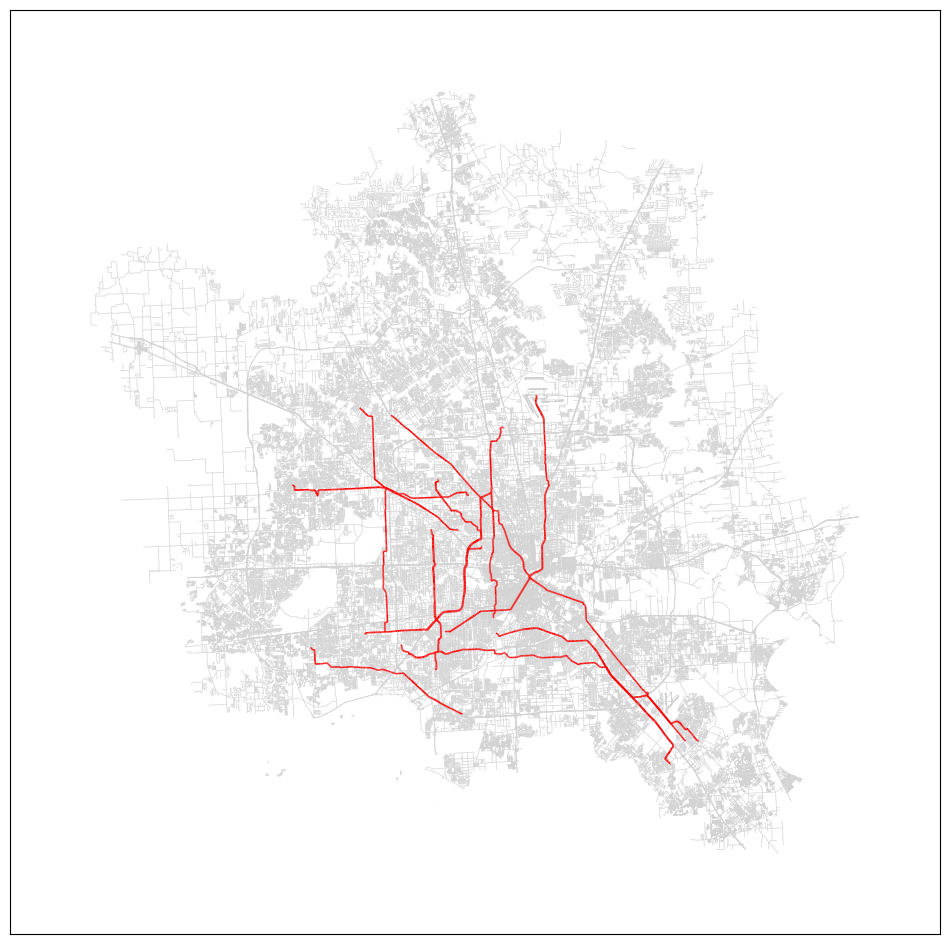

In [ ]:
# Initialize the edge frequency dictionary
edge_frequency = defaultdict(int)

# Main flow for 100 iterations
iterations = 100
with tqdm(total=iterations, desc="Processing 100 iterations") as pbar:
    for _ in range(iterations):
        # Create a deep copy of the original graph
        G_copy = copy_graph(G)

        # Step 1: Get a random centroid
        random_centroid = get_random_centroid(transit_deserts)

        # Step 2: Project centroid onto nearest road
        projected_centroid = project_point_onto_road(random_centroid, road_network_gdf)
        nearest_road_geometry = road_network_gdf.loc[road_network_gdf['distance'].idxmin()]['geometry']

        # Step 3: Add projected centroid to the graph
        G_copy = add_projected_point_to_graph(G_copy, projected_centroid, nearest_road_geometry)

        # Step 4: Get a random POI
        random_poi = get_random_pois(houston_pois_points)

        # Step 5: Project POI onto nearest road
        if isinstance(random_poi, Point):
            projected_poi = project_point_onto_road(random_poi, road_network_gdf)
            nearest_road_geometry_poi = road_network_gdf.loc[road_network_gdf['distance'].idxmin()]['geometry']

            # Step 6: Add projected POI to the graph
            G_copy = add_projected_point_to_graph(G_copy, projected_poi, nearest_road_geometry_poi)

            # Step 7: Calculate the shortest path
            shortest_path, total_distance = calculate_shortest_path(
                G_copy, (projected_centroid.x, projected_centroid.y), (projected_poi.x, projected_poi.y)
            )

            # Step 8: Update the edge frequency dictionary
            if shortest_path:
                path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))
                for edge in path_edges:
                    if G.has_edge(*edge):  # Only consider edges in the original graph
                        edge_frequency[edge] += 1

            pbar.update(1)

# Step 9: Visualize the edge frequency as a heat map
plt.figure(figsize=(12, 12))
pos = {node: (data['pos'][0], data['pos'][1]) for node, data in G.nodes(data=True)}

# Draw the original graph in the background
nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=0.5)

# Highlight edges based on frequency
for edge, frequency in edge_frequency.items():
    nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color='red', width=1 + frequency * 0.1)

plt.title("Heat Map of Edge Frequencies in Shortest Paths")
plt.show()

# Storing the output that never fully ran


Processing 100 iterations:   0%|          | 0/100 [00:00<?, ?it/s]Random centroid selected: POINT (874174.7902174765 3275919.4963235217)
Projected point onto nearest road: POINT (874131.5769609138 3275973.8735084184)
Node found in graph for point: POINT (874116.2641334811 3275961.7044867636)
Node found in graph for point: POINT (874296.8926736899 3276111.613724969)
Node added to graph with ID: (874131.5769609138, 3275973.8735084184)
Edges added between (874116.2641334811, 3275961.7044867636) and (874131.5769609138, 3275973.8735084184), and (874131.5769609138, 3275973.8735084184) and (874296.8926736899, 3276111.613724969)
Random POI selected: POINT (832262.2713828494 3320038.544354354)
Projected point onto nearest road: POINT (832225.6984387608 3320090.9376429776)
Node found in graph for point: POINT (832258.6372852062 3320126.1520430106)
Node found in graph for point: POINT (832183.3221175533 3320077.101350515)
Node added to graph with ID: (832225.6984387608, 3320090.9376429776)
Edges added between (832258.6372852062, 3320126.1520430106) and (832225.6984387608, 3320090.9376429776), and (832225.6984387608, 3320090.9376429776) and (832183.3221175533, 3320077.101350515)
Processing 100 iterations:   1%|          | 1/100 [01:12<1:58:55, 72.08s/it]Shortest path found: [(874131.5769609138, 3275973.8735084184), (874296.8926736899, 3276111.613724969), (874170.9121309693, 3276254.8562778058), (874122.3902341514, 3276310.2037524455), (873993.6583645612, 3276461.201267017), (873906.0477651209, 3276556.3487743232), (873792.8506134576, 3276686.0202722116), (873756.6513178116, 3276728.0196524216), (873742.7901744139, 3276743.8750752765), (873732.7542466113, 3276755.829979978), (873691.9553413899, 3276802.33859545), (873648.0329545105, 3276853.408533978), (873586.4501759491, 3276923.372469111), (873540.9893995977, 3276976.088069319), (873503.2620774026, 3277019.53192478), (873443.0079120224, 3277088.7665813556), (873400.8543892828, 3277136.865873165), (873359.5110018974, 3277186.1737006567), (873308.4204360091, 3277243.313016257), (873171.330289445, 3277401.5419890136), (873049.8243404236, 3277537.55534262), (872972.0404670017, 3277625.9083932005), (872931.2622706866, 3277671.9880364183), (872892.7607276834, 3277716.04006077), (872869.689906207, 3277741.754855405), (872815.8300956258, 3277802.884819716), (872799.6404688563, 3277821.6035355697), (872727.221011348, 3277906.0393505297), (872725.6826285714, 3277907.6851863973), (872676.3705946165, 3277965.1623146217), (872637.1099560072, 3278010.230577556), (872593.9930087556, 3278060.061166475), (872419.4127373002, 3278261.186310403), (872341.2224198983, 3278350.920689482), (872264.4985777707, 3278437.6061811503), (872122.8613321015, 3278599.18468969), (871747.2402336036, 3279028.8001420186), (871709.5387776198, 3279071.8193543362), (871709.5283370963, 3279072.2476641), (871410.219573653, 3279411.812509425), (871268.5108983156, 3279571.987637017), (871181.6675377865, 3279672.765771244), (871105.4076085032, 3279757.2829418057), (871092.5477755778, 3279772.363780844), (871040.1333890194, 3279831.8973840964), (871018.5487266793, 3279857.6634039157), (870900.0337084522, 3279993.5397846717), (870728.5062205179, 3280186.9570133714), (870684.66676551, 3280236.362427664), (870331.3868373241, 3280640.724037006), (870163.7353261298, 3280830.2983797705), (870138.0940764846, 3280861.3032534537), (870013.8822555507, 3280997.9118000134), (869886.1988211224, 3281143.221747092), (869660.8366025549, 3281399.082592817), (869589.0875520338, 3281485.8137988793), (869492.6221594282, 3281595.4579938296), (869325.2585625857, 3281786.1647776724), (869189.2159999146, 3281936.4644327103), (869155.5193320883, 3281967.6451514964), (869053.2381488413, 3282063.777852147), (869010.2268152658, 3282101.8576089027), (868989.9514412207, 3282121.3253694433), (868926.3406226512, 3282188.471284771), (868836.7532528378, 3282292.2142198747), (868818.0240323781, 3282315.790971078), (868866.6389216897, 3282360.5870894254), (868944.6637822818, 3282423.0658181217), (868930.8993979194, 3282439.135132665), (868909.6381775008, 3282463.9566052565), (868901.4003234749, 3282473.573840777), (868897.4082353633, 3282482.5365253766), (868897.1111806568, 3282491.6500121607), (868905.5860542821, 3282503.785266401), (868970.7081013115, 3282549.9936139355), (868977.0567642334, 3282554.4692451977), (868971.8954010456, 3282561.96099035), (868968.2985322005, 3282575.02395782), (868962.5182365165, 3282693.88626238), (868937.1491028218, 3282692.4769579372), (868885.5386973377, 3282689.758410061), (868876.3184062521, 3282689.3314219182), (868866.4622962498, 3282688.374384574), (868857.2421099361, 3282687.629551159), (868848.6580222816, 3282686.2489327583), (868839.86207565, 3282684.4444517368), (868831.172247155, 3282682.4279081803), (868823.3303451419, 3282679.987846126), (868815.7007159216, 3282676.6998647144), (868808.4950155347, 3282673.306172989), (868801.607192361, 3282670.1243817257), (868793.2361371445, 3282665.564478961), (868786.2427786163, 3282661.1109722545), (868779.3555062353, 3282656.2336065006), (868772.1505978073, 3282650.4022016074), (868764.4944954759, 3282643.834820138), (868697.4550230604, 3282583.0794216916), (868591.0820994759, 3282703.542467071), (868558.8065941327, 3282739.119290198), (868473.4083788935, 3282837.792583308), (868463.2732207866, 3282853.116114819), (868454.686894083, 3282866.3914836734), (868445.1852317243, 3282885.3637175425), (868433.4803932428, 3282903.396116135), (868344.8906476825, 3283008.931609901), (868310.2967995928, 3283048.4605236137), (868285.627887575, 3283029.0584592624), (868270.7280771423, 3283017.1306325314), (868255.496771605, 3283006.527550645), (868202.930883322, 3283064.3563032765), (868130.5313630833, 3283150.440923288), (868080.0009806014, 3283208.661354549), (868045.3814219607, 3283248.19010255), (868023.8486799471, 3283272.896868441), (867991.5106070625, 3283310.578752622), (867976.141757241, 3283328.2898753528), (867963.8343917712, 3283342.301847211), (867801.020594534, 3283529.931278822), (867636.861921384, 3283719.5935271815), (867629.9494827767, 3283727.1977987858), (867549.2654684731, 3283817.541978106), (867352.3782677995, 3284043.227866623), (867287.9202240518, 3284116.051640053), (867223.4993172098, 3284188.6132765436), (867048.6481816046, 3284390.587152967), (866899.3633122108, 3284564.450199974), (866775.6291675977, 3284704.4170572953), (866675.6469621081, 3284819.3428504625), (866610.3939451168, 3284891.118094075), (866582.7387847474, 3284921.7825313914), (866551.2688011116, 3284956.124918166), (866534.3252822701, 3284976.0952499523), (866473.4789158732, 3285049.100117003), (866388.8913024415, 3285146.2888459824), (866267.3013206292, 3285285.800503857), (866162.1133649889, 3285404.888448879), (866129.7646783858, 3285443.2348655593), (866102.857760201, 3285474.126200035), (866028.2488710396, 3285560.847259325), (866014.4238738335, 3285576.081279481), (865960.7509259807, 3285632.9821469057), (865863.8973633335, 3285743.5570536023), (865766.9030193377, 3285858.358110927), (865657.0038211264, 3285983.5578793436), (865566.1841434534, 3286090.3052524123), (865497.7864324182, 3286167.9091781494), (865465.6513236018, 3286200.5581137706), (865431.9517077294, 3286235.66273697), (865425.1167926468, 3286242.915843078), (865398.9797790827, 3286270.7935319976), (865369.1251124192, 3286298.0206017145), (865309.4768509376, 3286360.428891615), (865301.8317569119, 3286367.6043885713), (865273.4279714052, 3286399.0830332935), (865226.5580228843, 3286451.7746822494), (865152.7753783899, 3286536.631828977), (865078.6812764645, 3286626.0512756924), (865059.5590417389, 3286649.4305523494), (865007.727874669, 3286706.7208899767), (864937.4360350765, 3286786.095771706), (864865.1711305147, 3286869.301663342), (864794.4080758004, 3286951.924791345), (864765.9939130105, 3286983.836725012), (864724.4822660494, 3287031.183635012), (864721.3950230127, 3287034.9082925413), (864651.4775702666, 3287117.912728573), (864570.8834918439, 3287203.6909696944), (864557.7963947484, 3287218.9195397324), (864521.7211631155, 3287259.270831973), (864493.3121866352, 3287290.9554998255), (864451.0416267153, 3287339.3392088874), (864420.3146263557, 3287373.711444102), (864340.4252621063, 3287464.2983004283), (864267.3545393676, 3287549.407078853), (864199.0035507765, 3287626.1836701925), (864126.7124806531, 3287710.4565832308), (864054.3534412798, 3287796.8348112865), (864054.1946497187, 3287797.0436359155), (863983.7322759759, 3287879.0439195726), (863915.6744084702, 3287965.779588443), (863842.6087200441, 3288051.522460745), (863787.7173561422, 3288124.077103239), (863780.7629996501, 3288133.1721287956), (863779.5446616902, 3288134.503077842), (863765.8384184628, 3288149.452620671), (863764.6561988413, 3288150.8660942195), (863673.8880655086, 3288257.191870824), (863636.2378114533, 3288300.436819311), (863595.5316604256, 3288346.570403463), (863565.4901681351, 3288383.0891391714), (863549.289759733, 3288402.883232071), (863473.9944410281, 3288489.393630614), (863437.1030069381, 3288531.823404282), (863431.7187044718, 3288537.580259452), (863372.6189320891, 3288603.635955773), (863194.4045687309, 3288805.8374053314), (863172.8505307722, 3288831.8165835626), (862895.4897200246, 3289148.7703474415), (862769.6185756368, 3289289.5621089404), (862758.6325834601, 3289305.0278935977), (862752.2396752116, 3289316.2055640155), (862745.5265897007, 3289329.6191103514), (862739.7709605235, 3289344.9495886066), (862735.8856387169, 3289356.8492735564), (862734.9739573458, 3289359.6415723697), (862731.5964320455, 3289379.1417407254), (862722.2269845039, 3289419.1478286814), (862716.5228854284, 3289443.5038186167), (862701.4236338735, 3289498.5013117404), (862649.0133520254, 3289549.302353138), (862598.6623826206, 3289582.4005178567), (862532.902220912, 3289654.2305379002), (862440.7309937032, 3289758.819509534), (862277.2282785127, 3289941.173588636), (862161.1486144508, 3290072.533922768), (861843.2102701204, 3290439.5133311236), (861634.2432515945, 3290679.6195125845), (861604.2746929332, 3290714.2483692), (861543.5265954894, 3290785.55413077), (861489.7380771349, 3290847.5638884422), (861459.8060799092, 3290881.129656311), (861204.8921244168, 3291170.4339015014), (860921.9826651346, 3291502.493172121), (860845.6721210426, 3291598.3078758013), (860804.0498757649, 3291650.9560134406), (860723.518534956, 3291751.0315550026), (860611.7580479283, 3291879.4332546857), (860569.5286624893, 3291927.62765511), (860555.9092237083, 3291944.5578380544), (860542.1174718041, 3291961.701429272), (860522.5426150336, 3291986.032177808), (860476.4360237124, 3292039.1941923765), (860342.0605977373, 3292193.057051388), (860333.5885922587, 3292203.373929144), (860291.4062518969, 3292250.102673954), (860228.4232516768, 3292322.608215736), (860162.4520555519, 3292396.510805447), (860140.0575791544, 3292420.8473612205), (860133.1835796928, 3292524.3516611797), (860130.0106881575, 3292599.420059799), (860127.5480548323, 3292653.1307632593), (860126.7798311587, 3292677.047688788), (860123.1550988068, 3292720.762874452), (860120.1741637834, 3292767.2596732024), (860113.6532210656, 3292877.6115394086), (860110.7734666686, 3292966.9064010596), (860100.3537806527, 3293083.670750591), (860093.7496038635, 3293219.864454238), (860082.6920054887, 3293356.324536461), (860076.1710689086, 3293489.9640444196), (860075.6744326396, 3293505.4029122293), (860068.3994069062, 3293615.707833048), (860067.1991538447, 3293635.6702444064), (860061.6951487024, 3293755.064601633), (860054.1425229412, 3293874.7144134706), (860045.0406991898, 3293996.613298244), (860040.4133516743, 3294116.7596227233), (860032.5047679415, 3294247.389898122), (860033.698962058, 3294278.970331467), (860032.5507033677, 3294289.5592403784), (860027.3208092604, 3294316.2649748093), (860016.4995264815, 3294354.2492461945), (860014.9349293981, 3294356.730542042), (859994.9821727627, 3294402.275671394), (859969.173435522, 3294446.1361034703), (859962.1578655639, 3294456.4983299873), (859948.184140903, 3294477.836207353), (859947.9872012249, 3294478.0292773293), (859902.3795375713, 3294522.751036068), (859888.1496930916, 3294532.9226532797), (859858.3024077427, 3294549.674588949), (859848.608979842, 3294554.712391591), (859833.2269929728, 3294560.9530644175), (859821.3813461959, 3294565.7589515736), (859805.4853179692, 3294572.405636122), (859670.2499708276, 3294612.913368698), (859698.9510684051, 3294708.9240429713), (859715.4395033224, 3294760.184311578), (859720.5541648483, 3294780.7553014085), (859731.0527199834, 3294812.974823421), (859719.0127378185, 3294817.038926425), (859539.8467824035, 3294873.876403756), (859465.8925949911, 3294897.539972646), (859347.8758511273, 3294934.807525693), (859172.3477285714, 3294989.733950909), (859155.1727537246, 3294995.108642841), (858960.9209895666, 3295057.6948041283), (858772.1868011458, 3295117.754756251), (858764.4611111417, 3295120.2127559423), (858573.2398004793, 3295180.7772282846), (858380.5794446593, 3295240.866099982), (858255.8235950142, 3295280.916484001), (858237.2536429612, 3295289.817873752), (858228.0779378647, 3295293.1493652184), (858189.9398205052, 3295306.1156472024), (858005.4437592105, 3295364.7990498557), (857998.4735836833, 3295374.5329503743), (857991.5609087546, 3295382.569380102), (857966.9131845403, 3295390.6703005475), (857773.3955847749, 3295454.365092151), (857581.3750978592, 3295517.4515602356), (857386.3880372504, 3295580.2422967716), (857192.1333898504, 3295644.328433914), (857173.456916164, 3295650.3163085603), (857000.8831853135, 3295706.40840468), (856989.6585157955, 3295710.2787477984), (856861.8477578014, 3295754.480801256), (856767.518016513, 3295791.2874022564), (856679.3633225113, 3295819.8098005797), (856668.9548349143, 3295821.8073783773), (856587.4932216385, 3295849.073611294), (856457.5165785681, 3295891.081463278), (856367.1536302287, 3295919.5304878443), (856279.0146603999, 3295948.2850241433), (856183.4502257692, 3295977.634680566), (856091.5909275673, 3296006.6764025856), (856001.9451064145, 3296036.2195803504), (855908.5944882544, 3296065.6423666896), (855801.0522919, 3296099.6822596015), (855751.7317563479, 3296116.3223256804), (855716.6133030853, 3296128.329725087), (855697.1574365832, 3296135.3336247024), (855601.5150746177, 3296167.2475539725), (855506.6574491917, 3296198.0936220693), (855410.3295405909, 3296228.696603217), (855313.2535747621, 3296259.2732848106), (855217.6062344331, 3296291.3882914986), (855173.5607204433, 3296304.8107261714), (855122.0844827846, 3296319.6901793433), (855026.4058994222, 3296352.8679309394), (855016.756473402, 3296353.82866584), (854928.6549434287, 3296381.7311819433), (854925.6618388634, 3296382.699909629), (854850.2241645152, 3296407.1817569043), (854774.8336362909, 3296430.1930404888), (854727.7689869241, 3296445.440584147), (854699.3702288435, 3296454.9018107285), (854623.9953931926, 3296477.510542778), (854547.8305088739, 3296501.9661367843), (854514.1935293901, 3296513.411467061), (854488.7826113986, 3296522.1309273), (854411.8853775262, 3296545.9308288423), (854342.423802898, 3296568.9342314363), (854335.5530100744, 3296575.706073099), (854390.5149600437, 3296660.4754197756), (854385.1042012067, 3296667.929051904), (854329.2643376029, 3296703.41992533), (854264.2927662227, 3296747.9467560994), (854185.6900242604, 3296801.997869916), (854099.0126512719, 3296854.7245229133), (854015.1923934969, 3296910.9404318463), (853963.0838380541, 3296945.0859276773), (853926.8881368703, 3296967.6495202985), (853858.1123473865, 3297015.8586139535), (853781.1370682421, 3297065.297201541), (853657.41665378, 3297143.9610373457), (853600.802162017, 3297181.561480048), (853590.216399557, 3297188.4194190335), (853535.1820896474, 3297223.1052670227), (853523.8531207426, 3297230.375588222), (853463.476479695, 3297269.553168109), (853380.4781950512, 3297323.03403768), (853310.3048494929, 3297367.4887053184), (853310.2733012758, 3297367.508716429), (853288.4635763308, 3297381.325072584), (853214.3696975532, 3297428.2363122962), (853136.0623891742, 3297478.571508714), (853085.2206302825, 3297507.464422298), (853066.7010570248, 3297521.6972992257), (853063.9292902285, 3297523.307984439), (852995.1783547546, 3297563.258736992), (852913.0019478067, 3297614.035797275), (852894.4839779728, 3297626.7263175715), (852881.827575975, 3297635.19256544), (852878.0219169935, 3297637.72723912), (852876.5634716786, 3297638.6986038326), (852826.1629871085, 3297672.2667047526), (852743.8035126273, 3297728.7658578972), (852657.8542951797, 3297782.1570801963), (852574.1234590006, 3297836.0549407667), (852488.0801064951, 3297892.4128550063), (852401.4087373411, 3297945.586860702), (852235.3712786465, 3298054.466134026), (852158.4123407573, 3298103.918932899), (852063.3529210454, 3298165.313480252), (851995.4255935098, 3298210.1625748496), (851974.2905263084, 3298223.681965786), (851965.996230656, 3298229.374604364), (851964.436895716, 3298254.935212777), (851963.6760931523, 3298311.49700526), (851956.4183685943, 3298362.833226807), (851954.4046512838, 3298385.6936860625), (851946.8531570219, 3298461.07908859), (851940.7148019442, 3298491.7921977653), (851924.7142323392, 3298538.147908127), (851912.2217472953, 3298574.3402213617), (851909.214502223, 3298580.417379533), (851898.814912614, 3298601.4329724982), (851887.9306121033, 3298618.465523033), (851868.6736744836, 3298643.270005333), (851856.4915614082, 3298654.5384445153), (851836.7954678084, 3298669.369000063), (851807.2980594727, 3298690.6807420813), (851753.687691466, 3298726.888201781), (851717.445246184, 3298751.153420875), (851677.4140609561, 3298778.6934573), (851645.6298525181, 3298802.465347106), (851616.9902690689, 3298825.2550315503), (851584.5731040393, 3298863.848677879), (851554.0078319644, 3298919.0230668746), (851508.6389241581, 3298998.054413251), (851480.469940623, 3299048.2094287854), (851458.4865033932, 3299089.219162369), (851453.0391129525, 3299098.013920686), (851338.7555186899, 3299258.19845442), (851330.1932153738, 3299272.224812387), (851263.0020424712, 3299382.2938586306), (851241.8817335446, 3299419.9551190278), (851228.2761542914, 3299452.563282653), (851217.6899031098, 3299483.361791792), (851204.586343578, 3299524.03998061), (851193.5442663591, 3299570.0541536035), (851187.8975931989, 3299608.2074290197), (851185.1339366605, 3299649.009070264), (851175.0886306725, 3299827.41602025), (851174.6488750929, 3299841.388271677), (851171.1469982704, 3299865.5051698163), (851168.0390472385, 3299886.9091165815), (851167.2692161839, 3299911.4584978013), (851162.4833985372, 3300063.1303560054), (851160.5727786433, 3300099.9282350475), (851146.497979851, 3300265.294745227), (851135.9578893471, 3300318.542890063), (851124.3925066083, 3300357.369256718), (851114.3169115484, 3300388.713428468), (851101.7333710091, 3300419.33163926), (851075.2210282988, 3300472.808899884), (851025.3642554432, 3300554.242738786), (850972.1163956637, 3300634.1891001426), (850955.211011546, 3300669.976856117), (850935.2178786822, 3300713.611668958), (850920.7396954894, 3300746.3034415515), (850855.5876236467, 3300891.6413813317), (850828.5640026547, 3300951.9966702065), (850822.9697924721, 3300965.373112146), (850820.389814587, 3300976.516734144), (850818.8977947738, 3301000.611707028), (850798.8911410561, 3301018.278632873), (850785.9887188547, 3301029.672114166), (850771.6459394544, 3301042.3375724307), (850754.3029497911, 3301057.652358572), (850690.6714514272, 3301107.129357755), (850646.6838559287, 3301143.437751745), (850601.9481729008, 3301179.4981642747), (850546.6840021025, 3301221.610984166), (850529.190440418, 3301237.577038796), (850483.7377164518, 3301273.4099652544), (850425.3600510322, 3301320.2629132047), (850362.4084870373, 3301372.2939694556), (850358.6304378884, 3301374.9339053025), (850341.1001472315, 3301392.1691408837), (850258.1148376769, 3301454.5226352764), (850245.6759547063, 3301463.2842311114), (850229.296988305, 3301474.7721837503), (850229.039578767, 3301474.9758100947), (850172.3094265, 3301519.8573389533), (850104.1357776695, 3301573.3975449232), (850091.2579041249, 3301583.1482125293), (849961.6922189005, 3301686.2379837655), (849900.2691436077, 3301736.190144428), (849822.9535105091, 3301798.7652317593), (849788.2834402318, 3301826.161817788), (849773.5470300062, 3301838.0271152616), (849730.4473654709, 3301873.803936614), (849691.0489865867, 3301905.604471121), (849660.682847939, 3301931.1248685517), (849611.373498004, 3301972.336952702), (849536.2771289055, 3302034.144062177), (849493.8011877695, 3302092.752371414), (849480.5082220212, 3302109.6974416724), (849452.8737500148, 3302145.622431794), (849438.0484034764, 3302165.764726041), (849396.2141139017, 3302222.0872750063), (849382.8984479969, 3302240.014491685), (849375.0809377229, 3302250.5997549277), (849363.5001194018, 3302266.9552939637), (849359.5545642048, 3302274.455374895), (849354.1018061785, 3302283.378855312), (849328.0104671748, 3302314.329087035), (849323.7550439803, 3302320.1407750454), (849281.7524347985, 3302377.505085493), (849274.7384282781, 3302387.3885663976), (849235.2659468818, 3302441.6639084243), (849225.3290971633, 3302455.32734415), (849192.2393505092, 3302500.978890215), (849175.9140650373, 3302523.4409694), (849165.4577750866, 3302551.0810091677), (849115.3174420965, 3302689.472782203), (849106.384260399, 3302715.034213787), (849090.0353153467, 3302764.908989126), (849060.0953180911, 3302848.252641934), (849038.2358328261, 3302909.001115398), (849006.5844422821, 3302999.685797582), (848974.1898016584, 3303090.7828573813), (848941.0680488944, 3303181.017966003), (848910.881833077, 3303271.5483963303), (848878.4870153691, 3303362.6711074645), (848852.4664626531, 3303438.5090784933), (848847.5733241264, 3303452.974094274), (848814.4617791348, 3303542.98179513), (848795.7259110591, 3303598.7370842425), (848785.3010563788, 3303627.4165678155), (848777.7884551934, 3303648.0053442656), (848767.470675858, 3303675.5490045277), (848750.3519496002, 3303726.919363596), (848719.4379368809, 3303817.4285630807), (848685.5986151338, 3303907.4099336397), (848655.4745513281, 3303996.6810177653), (848653.9360932896, 3303998.532483629), (848635.2105690152, 3304054.081249644), (848623.0481599378, 3304088.2056163438), (848591.3750065209, 3304179.751251016), (848578.3959270753, 3304216.8367356546), (848559.0056979307, 3304270.212881658), (848528.0598928712, 3304361.784487844), (848496.4180214778, 3304452.298021977), (848464.7970486463, 3304542.151016045), (848445.9162487541, 3304598.277383089), (848441.1675683951, 3304612.3450754983), (848433.9450459734, 3304631.3956052614), (848415.5027854566, 3304677.1772662206), (848410.0917811312, 3304684.8622771497), (848371.6272314868, 3304757.7523994152), (848330.7923172952, 3304835.0577695253), (848285.2523782684, 3304921.508669223), (848279.2191258701, 3304934.391464789), (848245.6726988361, 3305006.0223587994), (848217.9987691473, 3305064.460676479), (848196.5996785093, 3305110.8082570424), (848172.7928476358, 3305163.640058869), (848158.392636833, 3305194.553771579), (848146.6472504151, 3305219.772805492), (848104.6650930607, 3305310.595191588), (848086.9644055784, 3305348.292001682), (848084.5264721282, 3305353.5070015816), (848084.0978063461, 3305354.409663619), (848035.9197059833, 3305454.1290350757), (847991.6780520331, 3305451.8829694027), (847984.3103794286, 3305451.6521831164), (847875.1481745137, 3305446.767986915), (847801.3423713737, 3305445.090031267), (847670.8572855142, 3305641.329192416), (847661.0475889537, 3305658.01289015), (847655.743391352, 3305670.460420855), (847651.7619600957, 3305686.087501198), (847648.5782208976, 3305695.8871507635), (847644.7795019634, 3305708.748631198), (847641.4127776951, 3305721.8436067244), (847634.2018034256, 3305759.4094442585), (847632.0320996478, 3305805.4980636435), (847630.5779686983, 3305834.3337222473), (847630.0776814355, 3305843.992055384), (847625.8030758866, 3305910.1292402255), (847622.1123961065, 3306004.685301099), (847612.2174966761, 3306199.340175735), (847608.2307199491, 3306283.341884172), (847606.2260317496, 3306339.369346141), (847600.156523024, 3306494.210934477), (847598.6352808676, 3306542.8794777486), (847596.353548734, 3306616.4303853074), (847595.4383590836, 3306640.3987878477), (847595.4324726821, 3306640.5534685655), (847592.7313708392, 3306686.1032874845), (847588.8420912962, 3306784.627005969), (847586.6885838168, 3306838.5268078754), (847585.4707332398, 3306869.0085779205), (847583.8360947212, 3306897.328063577), (847582.8797557431, 3306959.7565969788), (847578.6511947543, 3307016.3854478593), (847576.0399865599, 3307072.705660086), (847574.1145061217, 3307107.8832230736), (847573.2483530464, 3307143.485035145), (847553.0945207158, 3307157.8008924667), (847527.3887232661, 3307178.449684328), (847503.802317553, 3307198.5696379887), (847482.0714501524, 3307216.3066187594), (847468.2910441455, 3307227.4251646097), (847451.3314954443, 3307239.07188639), (847434.6379625408, 3307248.599530387), (847413.4413319018, 3307257.859920475), (847393.835188408, 3307265.002021574), (847359.2865003811, 3307274.3432789887), (847340.3191912498, 3307277.6893089656), (847315.947388356, 3307280.0607816065), (847293.9606763828, 3307280.5790958167), (847267.2065482752, 3307279.505653971), (847196.1632728326, 3307277.710302125), (847179.2406747668, 3307276.881149963), (847173.6581699403, 3307276.878253276), (846982.9847820083, 3307268.3952337587), (846784.1770677852, 3307259.785232746), (846780.4842329259, 3307280.604187948), (846776.8191621888, 3307299.039042539), (846773.3403142, 3307315.725729361), (846741.0554071497, 3307457.2960881996), (846714.8904068873, 3307505.899814447), (846663.1305619526, 3307556.1670689443), (846552.7147752221, 3307663.0438220524), (846503.3154509582, 3307708.292060047), (846433.3033231548, 3307775.1422251016), (846387.8013926614, 3307819.0710527236), (846379.2413413473, 3307827.6677938984), (846370.1153510929, 3307835.639503577), (846291.0817117293, 3307907.933199725), (846263.6819132575, 3307933.9789802264), (846207.734893043, 3307987.9520137194), (846196.7677643155, 3307996.465672737), (846026.461071265, 3308154.021930608), (845979.3329664567, 3308197.444513735), (845926.9248783435, 3308244.501548503), (845731.5944311928, 3308423.2903593173), (845689.018927622, 3308463.0570500274), (845629.9541165577, 3308516.9638497564), (845603.4136643189, 3308543.4368948857), (845543.2884458018, 3308598.271039081), (845519.891653606, 3308620.9848164115), (845464.5323227989, 3308670.689513521), (845446.4080686255, 3308688.136200669), (845373.9134282984, 3308753.6412049006), (845338.59932576, 3308785.879621214), (845295.9345162685, 3308828.6075522746), (845215.4098565122, 3308901.6935632876), (845153.7901571286, 3308959.047086537), (845137.0933564955, 3308974.8478248944), (845077.7619646052, 3309031.017108522), (845023.852168018, 3309079.1200368856), (844972.1873437015, 3309125.9962886074), (844942.5321922521, 3309153.675895636), (844842.2166439507, 3309245.6290441593), (844821.9952751383, 3309263.8699573255), (844780.7032591217, 3309301.1003814614), (844776.124543878, 3309305.6174842753), (844717.8734493608, 3309358.2890514317), (844651.6122480374, 3309416.100053231), (844623.579565621, 3309439.369168946), (844546.8130277849, 3309499.997136804), (844460.4625928418, 3309575.4969157903), (844360.8075434086, 3309676.0001746565), (844312.0569787879, 3309724.4665035685), (844235.8384942733, 3309801.5159874787), (844110.8375316994, 3309928.93531096), (844071.4259435197, 3309967.5780194863), (844043.7507670881, 3309996.9504204397), (843878.8650475033, 3310158.7590550086), (843848.7381745355, 3310191.6396793434), (843630.3587112719, 3310425.8562783725), (843598.2747480723, 3310461.061274093), (843511.9031043889, 3310556.8789497297), (843497.4184133178, 3310571.2448936356), (843408.8017632901, 3310668.4386643358), (843379.7585798393, 3310700.1678905357), (843311.2113749846, 3310770.9263808606), (843215.5142790169, 3310879.295785083), (843175.204695038, 3310917.870211924), (843051.2909755082, 3311057.8194928253), (843008.4371523036, 3311107.314592004), (842947.2048751975, 3311177.8441455513), (842861.6865486589, 3311270.0652091797), (842831.1048113534, 3311303.8517401633), (842766.5615284126, 3311376.6546611534), (842766.4078584799, 3311376.827974649), (842735.5908544392, 3311409.522476477), (842681.4026736692, 3311467.3482918194), (842592.0751522542, 3311562.8532801275), (842559.2217711121, 3311599.507071415), (842539.3573206335, 3311620.9326479533), (842457.6381843865, 3311709.6778976824), (842410.9588490163, 3311763.7104527717), (842308.605729616, 3311875.304486364), (842274.3714480537, 3311908.7740252665), (842228.3385352534, 3311941.24651401), (842161.1650489969, 3311989.355056145), (842127.0150448524, 3312019.6362548717), (842045.5057035377, 3312102.4633286106), (841906.9736176067, 3312265.8659295854), (841734.0323287237, 3312469.3834686857), (841538.8462596941, 3312685.8662421126), (841462.8152384168, 3312772.7311313166), (841422.0111146601, 3312820.964736581), (841313.8807823013, 3312945.1140962476), (841300.3220856471, 3312961.856765594), (841132.6892832542, 3313149.8959700465), (840940.6338269413, 3313372.885024501), (840884.7406427672, 3313431.9156280817), (840806.3374267851, 3313520.357466958), (840797.4261502086, 3313534.9406888573), (840779.0570287674, 3313561.8918378176), (840657.7884621713, 3313644.478126543), (840566.6156449427, 3313709.274533082), (840274.9246886942, 3313909.444880229), (839908.5523195247, 3314156.8940119925), (839620.4675780768, 3314347.11642697), (839158.8900023109, 3314657.9395026113), (838889.3160938732, 3314843.123599686), (838743.6857401254, 3314940.6189631345), (838695.1914439308, 3314972.0622697044), (838653.0166711677, 3315000.9502527476), (838627.3934929776, 3315018.301091492), (838571.8549484133, 3315054.377606105), (838523.7672207829, 3315087.457057866), (838523.7616122828, 3315087.4611591627), (838481.4351911724, 3315118.8503251434), (838458.1339452985, 3315136.805208324), (838377.2847341935, 3315202.353769003), (838348.7376617938, 3315224.130709539), (838304.6295064588, 3315258.881850592), (838277.9017692411, 3315279.909386685), (838247.8749634754, 3315304.179976393), (838215.7189211422, 3315330.2117629065), (838170.8900053925, 3315368.9818161265), (838140.3157894491, 3315393.4760941714), (838030.8505612272, 3315483.348692714), (837961.4963741775, 3315539.7176766708), (837869.9313233702, 3315614.2377485726), (837846.5853060855, 3315634.4592001624), (837835.2411819028, 3315643.918901631), (837835.134414153, 3315644.0079374034), (837783.6900753351, 3315686.4142175526), (837727.2423110742, 3315730.354554778), (837663.368739775, 3315782.8566064513), (837663.2295221135, 3315782.9710509805), (837651.7371552894, 3315792.4173248787), (837507.9416929013, 3315908.040547633), (837441.922567039, 3315960.8836481147), (837042.4333492249, 3316308.869946273), (836705.9800944905, 3316579.9922040105), (836383.3628091845, 3316844.8820541026), (836370.3381427965, 3316855.57618383), (836346.994471995, 3316874.657729619), (836313.663588454, 3316901.903034719), (836292.6659692524, 3316919.0668671937), (836250.05798636, 3316953.895396285), (836100.1433164168, 3317077.784389208), (835930.7654455783, 3317214.8903793166), (835769.5174767035, 3317343.922212132), (835732.7406585697, 3317375.0040562013), (835472.9474656134, 3317591.6324566226), (835332.9106166223, 3317714.078085834), (835290.9471760951, 3317749.869283019), (835209.3779450571, 3317819.567885393), (834930.14832683, 3318057.1392445425), (834651.7153391123, 3318271.5927894227), (834543.3995577642, 3318342.6110519893), (834380.2184479068, 3318443.052218177), (834303.3145785354, 3318497.8962284178), (834195.5502916843, 3318574.727787619), (834152.5672996116, 3318605.372835975), (834040.6530997257, 3318687.9937580805), (833973.3616673778, 3318745.3014924866), (833914.1663474, 3318794.107123818), (833848.3492697629, 3318843.7584582516), (833676.3536963598, 3318990.8016226757), (833560.2101333649, 3319098.6224416797), (833461.9675329835, 3319182.4708001437), (833363.3040381859, 3319261.139144785), (833260.1027365997, 3319361.547120756), (833216.4763066366, 3319400.8829926546), (833172.9696331947, 3319440.6822935077), (833054.5878530748, 3319548.405504679), (832855.2522871946, 3319708.335584172), (832739.9746817795, 3319795.0144993113), (832721.7715810764, 3319808.70171941), (832705.989299486, 3319820.5685947435), (832660.5769436586, 3319854.731469639), (832513.4415646541, 3319953.8183490704), (832428.6938057207, 3320008.5147771183), (832370.4015994617, 3320045.750744716), (832258.6372852062, 3320126.1520430106), (832225.6984387608, 3320090.9376429776)]
Total distance: 64593.95033768651
Random centroid selected: POINT (848272.143322124 3318389.082088027)
Projected point onto nearest road: POINT (848286.7795908707 3318389.6827010093)
Node found in graph for point: POINT (848287.7883813106 3318365.099602706)
Node found in graph for point: POINT (848281.3777871819 3318521.3186343377)
Node added to graph with ID: (848286.7795908707, 3318389.6827010093)
Edges added between (848287.7883813106, 3318365.099602706) and (848286.7795908707, 3318389.6827010093), and (848286.7795908707, 3318389.6827010093) and (848281.3777871819, 3318521.3186343377)
Random POI selected: POINT (846833.392434642 3292722.224063866)
Projected point onto nearest road: POINT (846866.8413974367 3292724.1197699513)
Node found in graph for point: POINT (846863.9418874166 3292775.280444872)
Node found in graph for point: POINT (846868.8777301449 3292688.189507599)
Node added to graph with ID: (846866.8413974367, 3292724.1197699513)
Edges added between (846863.9418874166, 3292775.280444872) and (846866.8413974367, 3292724.1197699513), and (846866.8413974367, 3292724.1197699513) and (846868.8777301449, 3292688.189507599)
Processing 100 iterations:   2%|▏         | 2/100 [01:48<1:23:40, 51.23s/it]Shortest path found: [(848286.7795908707, 3318389.6827010093), (848281.3777871819, 3318521.3186343377), (848205.267968233, 3318518.021217726), (848167.6823145805, 3318517.043592314), (848102.8664700943, 3318514.165851235), (848049.0967075594, 3318511.640642377), (848022.5729606465, 3318510.375710476), (847992.428613408, 3318507.096385929), (847954.2947981129, 3318499.767192073), (847924.3120182012, 3318490.5441054637), (847918.5057560235, 3318488.6833471586), (847908.3080514615, 3318484.5392071283), (847879.9813726788, 3318470.5242326385), (847855.3594958874, 3318455.7686785082), (847826.4582447289, 3318436.238102236), (847794.8266010128, 3318410.034638845), (847829.6271090179, 3318359.246321903), (847844.4662501051, 3318332.8083538404), (847857.9031971565, 3318304.656707873), (847864.2215460732, 3318291.075866647), (847887.7380940904, 3318223.8427667357), (847908.4825473384, 3318150.5970804947), (847916.4434673049, 3318108.692100162), (847920.1053526258, 3318085.528667686), (847922.9656886285, 3318065.475891858), (847925.9579554125, 3318040.3926926064), (847926.1096347175, 3318011.794228059), (847921.0489482861, 3317985.390449527), (847916.1514990823, 3317953.6674302337), (847907.115724505, 3317888.8133060997), (847884.9509765926, 3317795.976939931), (847870.6243297921, 3317735.1800659196), (847860.8777325407, 3317693.58422013), (847843.2187930893, 3317619.8467503423), (847828.3128471216, 3317555.9630292505), (847822.9358566237, 3317535.032703735), (847813.7102150157, 3317500.487567831), (847808.5779863984, 3317479.746616515), (847769.8832312359, 3317325.6427509314), (847763.5854549429, 3317305.971959368), (847741.8252249857, 3317212.927635958), (847738.075045167, 3317196.520020069), (847730.8770734634, 3317171.9127018875), (847723.4451053155, 3317146.5051056985), (847715.5444916908, 3317129.526716875), (847704.8048476102, 3317108.569348631), (847686.1456531953, 3317079.2564042443), (847667.14864094, 3317058.5903054574), (847640.0496192402, 3317035.1167360046), (847605.6063352438, 3317012.5587247307), (847569.1428092616, 3316998.926171714), (847513.696576067, 3316981.4325717497), (847467.1193089357, 3316958.858782675), (847428.6972256398, 3316928.9323124266), (847399.7604542077, 3316895.336971973), (847389.8732365804, 3316881.2716606953), (847374.5624361398, 3316851.7868420444), (847361.606797862, 3316818.119248757), (847353.3727499612, 3316774.667042809), (847356.3737366857, 3316726.046829735), (847356.7840799436, 3316712.937028946), (847358.8365239848, 3316671.503152891), (847244.3881207531, 3316667.7817142685), (847167.9959745083, 3316662.9583100323), (847125.2617450824, 3316661.41581186), (846963.1055803077, 3316656.3346872493), (846857.6514448323, 3316650.78700167), (846622.7572689487, 3316639.945869562), (846504.6218725985, 3316642.609547816), (846479.4898132547, 3316644.152721409), (846479.5593813341, 3316639.8240277222), (846480.0773582377, 3316602.0423871004), (846481.5027890846, 3316556.537800854), (846479.4798513111, 3316479.4093596507), (846471.6436039095, 3316436.6808741656), (846462.8109243605, 3316374.565841821), (846461.386100147, 3316304.599282865), (846460.1732197867, 3316176.8121536463), (846457.2116086786, 3316011.979342157), (846455.4562562658, 3315927.0087872166), (846453.3487795943, 3315852.6200354896), (846449.4048009556, 3315743.007078622), (846447.2305549087, 3315694.022956606), (846446.3930313968, 3315627.0642873216), (846440.8099550626, 3315593.2207864355), (846437.8729605424, 3315569.2177040153), (846435.9314966216, 3315536.7537536365), (846433.9619814556, 3315481.8467468494), (846432.5954922766, 3315454.26922366), (846432.6025548893, 3315396.099772505), (846431.9475637537, 3315365.1305133123), (846430.6133513968, 3315344.259418136), (846425.9141005161, 3315321.366594816), (846419.5327724654, 3315296.789725041), (846414.6587890849, 3315278.3679099614), (846408.1171603163, 3315246.6270043543), (846400.9461110634, 3315203.74275189), (846396.7008475343, 3315139.3208231796), (846397.540840306, 3315035.0506363413), (846407.7631729702, 3314821.2346287337), (846409.1364858884, 3314792.5099471305), (846410.4533392884, 3314764.9664075198), (846396.3647231362, 3314764.6131040594), (846406.241642508, 3314605.4985601366), (846410.2015324754, 3314495.1253631306), (846456.4912280609, 3313392.0113643203), (846474.4768939218, 3313029.1985161444), (846478.0502252595, 3312952.468543327), (846479.36453212, 3312924.246392819), (846480.6909934671, 3312895.7643434503), (846487.8550505135, 3312746.210514173), (846485.150704671, 3312592.875554038), (846478.9031098178, 3312509.6615028246), (846482.3961318752, 3312445.1763299913), (846488.0877295843, 3312333.5562298256), (846487.2401880932, 3312290.1136214086), (846503.4381964295, 3312054.921711763), (846506.035461839, 3311995.92549387), (846506.5271348697, 3311956.121065162), (846508.9405485981, 3311902.846632116), (846509.190541123, 3311870.884344913), (846509.6422893018, 3311856.479528461), (846510.2358743537, 3311837.451977108), (846510.8557693025, 3311817.557724698), (846513.079894686, 3311770.407342743), (846522.5811208088, 3311561.049581757), (846529.4217542096, 3311460.058241005), (846538.5788710018, 3311237.569446224), (846541.8308602495, 3311160.3029619697), (846562.770472499, 3310723.1079362347), (846565.2412857619, 3310667.480624508), (846569.9866733381, 3310616.0076224655), (846570.8678427306, 3310558.599639328), (846574.4442410555, 3310490.7450595223), (846574.7142713298, 3310452.177742707), (846578.6364644179, 3310409.4055761197), (846580.5534929559, 3310319.177606026), (846574.200689693, 3310237.7069132207), (846570.2907383669, 3310145.6438077106), (846568.3271116255, 3310108.4057225185), (846560.484448222, 3310004.6776843555), (846560.053569582, 3309925.2532868017), (846557.9750672576, 3309890.736830725), (846556.1049900088, 3309849.3795528295), (846558.422126062, 3309781.6585672866), (846564.3143598237, 3309704.5800049156), (846566.4984881107, 3309652.0500720534), (846568.1781366117, 3309613.594497362), (846569.51284479, 3309584.860956536), (846570.9229670195, 3309550.8525566533), (846576.4759530723, 3309414.4500516756), (846577.6944759636, 3309394.119611702), (846582.9684861926, 3309295.8148934767), (846590.6911941211, 3309143.172676591), (846595.6259461718, 3309032.5728618433), (846599.8228688277, 3308921.5185934054), (846602.9365538561, 3308834.5046025678), (846605.6885916728, 3308757.596693356), (846611.2506366052, 3308650.1804645793), (846618.3354256575, 3308541.346244893), (846627.6815713022, 3308360.8126902157), (846631.7940323526, 3308252.2915983335), (846632.3818234025, 3308233.465141859), (846632.953862089, 3308215.2681175154), (846633.9351728912, 3308183.760034428), (846635.0266873834, 3308148.8571097828), (846647.6405879502, 3307934.303835574), (846653.418102077, 3307867.352888073), (846658.0516211551, 3307836.9973465977), (846683.944330777, 3307684.428271254), (846707.1015351552, 3307583.0049738637), (846729.0337928267, 3307513.003840686), (846741.0554071497, 3307457.2960881996), (846773.3403142, 3307315.725729361), (846776.8191621888, 3307299.039042539), (846780.4842329259, 3307280.604187948), (846784.1770677852, 3307259.785232746), (846791.2472397963, 3307222.0433514146), (846801.6407203062, 3307067.161510629), (846807.3974230089, 3306925.1076690773), (846814.2755928845, 3306802.886983577), (846814.5665080483, 3306795.9338216386), (846816.226946729, 3306756.247404748), (846818.9514675477, 3306704.982655014), (846822.9726413823, 3306622.205639774), (846824.6072887566, 3306593.855386615), (846837.8392964131, 3306335.497680107), (846840.5152577144, 3306272.687110605), (846840.5598432705, 3306271.640596425), (846841.9901352688, 3306249.2441535387), (846845.439410719, 3306162.7374547827), (846855.1307241917, 3305989.229942207), (846857.7001861108, 3305935.4853925197), (846862.1502948538, 3305880.4615749624), (846866.612788996, 3305768.034760142), (846872.9010280061, 3305637.3643566645), (846879.0158287918, 3305512.8388999226), (846881.3479175408, 3305461.436446286), (846889.5093918759, 3305317.482972173), (846889.5571705925, 3305316.640398812), (846889.761698073, 3305310.0828395286), (846890.8996729704, 3305273.487392512), (846891.1040953659, 3305266.93493868), (846893.3570882909, 3305218.9222309375), (846897.3599958466, 3305137.9619857213), (846901.1793912338, 3305063.0949494145), (846911.1746992036, 3304884.278267341), (846915.755383457, 3304761.5834111995), (846922.3152340606, 3304622.0283289636), (846925.0664169285, 3304557.3145110477), (846928.7805434465, 3304485.6411125767), (846935.7840823899, 3304356.054282201), (846941.2122791855, 3304229.381794394), (846945.9105042906, 3304149.7064400925), (846948.2851056732, 3304073.528078187), (846948.3729577981, 3304071.3912874763), (846951.3972947584, 3303997.8350423467), (846951.7185807944, 3303963.514397261), (846963.3094336849, 3303757.6210395223), (846939.6528327498, 3303663.3047236125), (846897.5091968107, 3303570.2847869564), (846888.9473731851, 3303553.7600278603), (846853.5809746527, 3303486.334296921), (846842.0241871827, 3303464.2481019152), (846829.2621839051, 3303439.85849553), (846812.467229858, 3303407.761502411), (846792.1891316051, 3303346.7615696653), (846791.0277820188, 3303337.200573937), (846785.7659315038, 3303292.780172019), (846784.5538692547, 3303259.939555595), (846785.4081754872, 3303232.6308945604), (846787.1218566583, 3303177.637024403), (846790.400175201, 3303119.9299860056), (846793.5945494033, 3303064.9573420393), (846796.1667934505, 3303005.758880527), (846798.6022139948, 3302951.8280934696), (846801.1533717283, 3302893.2642608634), (846804.3633674065, 3302837.8581829052), (846806.8983439537, 3302780.5583279757), (846809.3549909613, 3302725.1571813836), (846812.0672148456, 3302685.6472047204), (846812.6016413458, 3302668.518037469), (846817.6088414416, 3302555.3576585455), (846823.3068196927, 3302443.317311791), (846828.3243079982, 3302329.754507392), (846833.3206534402, 3302217.0533897523), (846840.2883676053, 3302135.9548043455), (846842.800431693, 3302126.2820086805), (846847.8824109109, 3302104.85707397), (846849.8922904062, 3302087.971073141), (846849.5209746351, 3302076.506583018), (846843.8074767705, 3302069.7706807884), (846841.1756919598, 3302059.9612872615), (846842.3536913318, 3302045.5824695844), (846843.2607774253, 3301993.095467442), (846815.9314256313, 3301992.2467486467), (846825.2949591691, 3301786.7130877804), (846836.1491935973, 3301580.994219538), (846760.1724514025, 3301577.1612467086), (846684.9748059424, 3301572.424678886), (846692.8344283742, 3301437.8393212548), (846690.202492058, 3301428.024741148), (846679.3453353673, 3301420.4714015457), (846635.0570155673, 3301419.3207406), (846635.7441910452, 3301373.159288413), (846640.0587133014, 3301282.0449790037), (846645.989204861, 3301210.8676674613), (846651.8146213712, 3301165.730102759), (846658.1792335081, 3301103.8658252335), (846636.4533140035, 3301093.167033322), (846620.2324172475, 3301084.219180117), (846609.3096078546, 3301075.273792301), (846595.7405791637, 3301060.0358108887), (846589.1231992904, 3301049.105670064), (846582.8370114916, 3301038.1756842234), (846576.5531827788, 3301021.947814535), (846571.9240937809, 3301007.7073715758), (846568.6207035028, 3300990.818601798), (846567.6346995488, 3300974.9241862064), (846567.6409968138, 3300961.3481810642), (846568.6429739057, 3300942.8057439164), (846570.3066732304, 3300925.257091561), (846474.8204879006, 3300918.173894022), (846477.7305744281, 3300895.6180936936), (846482.6190232146, 3300857.0119721624), (846482.3372120049, 3300819.306525508), (846465.9463405506, 3300728.1569620576), (846448.8227327242, 3300637.213321174), (846426.493190421, 3300515.769436507), (846418.7312649689, 3300473.555113341), (846402.0658579288, 3300382.917792199), (846397.9855972978, 3300362.4418429164), (846382.6576506603, 3300285.011213338), (846379.0508141182, 3300267.422908942), (846364.0848875719, 3300175.627327947), (846350.0483871645, 3300096.350227269), (846343.9701581474, 3300064.559764758), (846338.6853145271, 3300035.948334735), (846335.1762344504, 3300015.548650544), (846332.6894935524, 3299997.720781307), (846331.899409367, 3299987.7073492263), (846331.1111046451, 3299973.561418044), (846330.799229702, 3299960.369334287), (846331.6059711846, 3299933.98591688), (846334.3163774419, 3299852.6896440494), (846339.0583845812, 3299771.951240882), (846344.512383693, 3299691.208039447), (846345.7580139979, 3299675.162569664), (846349.2910956022, 3299609.205523842), (846351.5317001208, 3299560.5630279793), (846351.9935609144, 3299519.4959137165), (846352.1505346566, 3299505.541027718), (846352.3362935326, 3299489.0268178335), (846352.7840489552, 3299449.2119789757), (846357.5103536309, 3299368.272261342), (846364.5074464087, 3299286.110798065), (846368.3541980297, 3299233.5116944695), (846369.8617597846, 3299208.354710052), (846373.7872305309, 3299129.6951960837), (846381.5955404725, 3299021.514754263), (846393.8981217318, 3298958.363157763), (846417.3300879798, 3298894.3186391653), (846430.8830865542, 3298838.602389758), (846435.2163348142, 3298793.8509530695), (846436.4202703944, 3298755.12958512), (846538.5947149165, 3298751.958804168), (846541.0599427568, 3298671.32111905), (846541.1033753399, 3298670.4623171347), (846542.4283743184, 3298644.251337318), (846546.4169977068, 3298580.198134211), (846546.6669726118, 3298576.183470525), (846547.1637960908, 3298568.204301326), (846550.6753748396, 3298502.876360223), (846550.5079289617, 3298484.885188106), (846551.6436620208, 3298471.8012281037), (846554.4957634471, 3298427.6321513886), (846554.6056658637, 3298400.7358068423), (846557.8924533413, 3298318.4588816), (846560.5040269364, 3298234.4842268648), (846565.6636823944, 3298163.6931660958), (846566.8778883462, 3298148.0707102087), (846570.1332369733, 3298066.7647865214), (846575.1376730958, 3297961.5535643552), (846576.8341660048, 3297918.39854166), (846577.8845078091, 3297881.347198657), (846584.2041880919, 3297804.930891951), (846586.919890991, 3297741.6869831453), (846601.0060878808, 3297740.0215370194), (846613.6966611419, 3297743.551269071), (846630.5702538255, 3297752.5042835562), (846646.9539984167, 3297762.5264607808), (846663.883299885, 3297774.3697481626), (846676.2614135827, 3297783.8439319017), (846685.6981099454, 3297791.5146861095), (846694.1419017268, 3297800.3812331017), (846731.6680167133, 3297839.785764896), (846777.1386972656, 3297875.070883617), (846832.7138032293, 3297893.9531903123), (846876.1282553549, 3297900.1894133906), (846919.4761871703, 3297902.439157419), (846973.6164509718, 3297889.2949512545), (847013.4941707174, 3297870.2922033407), (847039.4706433085, 3297855.3068651753), (847073.3702974847, 3297831.3704906814), (847087.0414733735, 3297818.9136822047), (847099.7114073996, 3297810.4542098297), (847115.3599345337, 3297802.3778946227), (847131.2686188859, 3297795.3446377055), (847157.8695646336, 3297784.926302061), (847177.5276670814, 3297779.198438751), (847198.0291980837, 3297775.0354133765), (847220.4548642639, 3297772.1769874278), (847254.353342664, 3297769.58428863), (847270.2594100265, 3297768.8090070332), (847294.9807002009, 3297763.5165698878), (847309.7409373452, 3297708.358203426), (847317.5563405226, 3297667.423618275), (847339.3371642521, 3297575.456512958), (847340.316477021, 3297562.2619421547), (847348.5528908502, 3297436.9295545835), (847354.5797901411, 3297297.817771791), (847355.7625151996, 3297283.237521086), (847359.7600157524, 3297202.472011797), (847349.6715819885, 3297170.1637571743), (847344.2295442476, 3297155.379400526), (847335.7840048483, 3297141.991922455), (847320.6986588328, 3297127.3374654856), (847306.9891178724, 3297116.9557218635), (847275.7872439366, 3297098.197713149), (847177.6499440679, 3297045.595294299), (847151.936773784, 3297017.2585312463), (847140.9587460828, 3296990.037348615), (847142.5955489476, 3296953.162341639), (847143.7758560248, 3296927.790997793), (847148.5242714459, 3296818.114921893), (847151.9404474939, 3296708.30619515), (847155.8433494088, 3296606.360866384), (847157.2139549525, 3296562.3506802907), (847165.7832510542, 3296382.2043999084), (847168.3198079858, 3296277.2555355118), (847174.0430545923, 3296140.2105693435), (847179.7282317881, 3295987.1803078754), (847183.1968838952, 3295893.810837291), (847184.9074128778, 3295862.9317690064), (847183.2485844898, 3295844.465051904), (847178.2719365037, 3295814.666668417), (847177.6752151474, 3295810.394400461), (847178.1195240349, 3295772.079891618), (847179.6205330591, 3295723.869869469), (847181.9323991811, 3295673.735677731), (847182.0004568805, 3295671.4036123483), (847182.2984958858, 3295661.8895389256), (847182.6395992725, 3295638.000961859), (847182.9363438025, 3295617.223693112), (847186.8176340001, 3295540.054253839), (847190.2907712678, 3295451.879244365), (847192.6910122695, 3295374.8690552725), (847192.9107655303, 3295367.681933277), (847193.1356352335, 3295360.4689823766), (847196.6036231177, 3295296.636719837), (847199.8879493885, 3295215.220595499), (847203.6953325381, 3295116.4428624404), (847207.3665622935, 3295022.5253832415), (847211.0431682025, 3294927.771988322), (847214.5109220993, 3294863.9396726266), (847216.2161407261, 3294832.6580608687), (847218.4637532863, 3294736.99605662), (847219.3254044168, 3294661.6361224726), (847215.416396467, 3294644.360499052), (847203.852163787, 3294635.9713987582), (847193.9569327661, 3294621.4793647397), (847178.975597694, 3294604.0650463193), (847147.8883624225, 3294581.4896535086), (847082.7206387722, 3294537.740962413), (847060.4870965991, 3294515.4684873614), (847044.1922634654, 3294492.7186736856), (847030.1367645755, 3294469.8355202065), (847015.9896707205, 3294445.9269060898), (847014.9519838244, 3294392.310452148), (847016.016306763, 3294380.6552226734), (847016.657684857, 3294366.8806816), (847018.6364894798, 3294350.3404711387), (847018.4019314852, 3294332.346717707), (847018.2022252802, 3294317.0257804897), (847018.1080524586, 3294309.7974819066), (847022.5121177088, 3294239.20659195), (847025.220895659, 3294175.554418682), (847028.1019139956, 3294107.0421834937), (847033.1749041798, 3294015.0704089743), (847034.3871110817, 3293976.077862886), (847035.5690774776, 3293938.0550645576), (847038.721778143, 3293860.8696123036), (847040.1645496701, 3293814.326096817), (847040.6093650174, 3293785.7888639285), (847040.9009726498, 3293766.4974531378), (847045.3403175359, 3293671.336842478), (847046.9563982532, 3293642.810285924), (847049.7220481595, 3293578.0953932786), (847053.6281527819, 3293500.069285378), (847052.1152815891, 3293476.9436463774), (847056.8733021161, 3293371.4329991434), (846842.8137001507, 3293360.754991065), (846843.6440170368, 3293309.9649929265), (846845.8712090704, 3293262.384691022), (846847.2248477188, 3293218.8026271416), (846849.577699889, 3293166.5684925965), (846850.0157688884, 3293128.8834231375), (846854.0478808291, 3293070.365617522), (846853.4869441758, 3293040.713571272), (846857.6916904188, 3292976.4481371604), (846858.3083777949, 3292956.57907431), (846861.9306812561, 3292864.157760178), (846863.9418874166, 3292775.280444872), (846866.8413974367, 3292724.1197699513)]
Total distance: 29200.708647663483
Random centroid selected: POINT (820738.2825122059 3309971.5667586275)
Projected point onto nearest road: POINT (820747.274162497 3310016.64264007)
Node found in graph for point: POINT (820786.2399799984 3310010.617613115)
Node found in graph for point: POINT (820658.5726579985 3310041.009713022)
Node added to graph with ID: (820747.274162497, 3310016.64264007)
Edges added between (820786.2399799984, 3310010.617613115) and (820747.274162497, 3310016.64264007), and (820747.274162497, 3310016.64264007) and (820658.5726579985, 3310041.009713022)
Random POI selected: POINT (843376.6170521925 3309305.7195889424)
Projected point onto nearest road: POINT (843374.7553889416 3309371.610768143)
Node found in graph for point: POINT (843418.2593929903 3309372.8399130236)
Node found in graph for point: POINT (843352.9840358705 3309370.9956489657)
Node added to graph with ID: (843374.7553889416, 3309371.610768143)
Edges added between (843418.2593929903, 3309372.8399130236) and (843374.7553889416, 3309371.610768143), and (843374.7553889416, 3309371.610768143) and (843352.9840358705, 3309370.9956489657)
Processing 100 iterations:   3%|▎         | 3/100 [02:40<1:23:33, 51.68s/it]Shortest path found: [(820747.274162497, 3310016.64264007), (820786.2399799984, 3310010.617613115), (820875.3484429674, 3310004.8815060765), (820971.431908983, 3310009.632906615), (821046.607350724, 3310013.302264106), (821054.716041343, 3310013.739565825), (821155.0648322403, 3310017.937419037), (821366.6490133412, 3310025.2416208405), (821371.9130457242, 3309918.066455704), (821483.7812450409, 3309923.6500265165), (821495.5623034572, 3309918.9445043765), (821498.8655113848, 3309908.5808450337), (821502.6291834766, 3309826.563822671), (821503.7233050354, 3309741.9873703527), (821507.133135693, 3309662.947722638), (821511.0705564285, 3309581.4534504935), (821568.3562183687, 3309583.207620517), (821680.6361975928, 3309587.119423387), (821698.7576795155, 3309586.6745670885), (821717.7858108375, 3309582.2998564015), (821727.9545024163, 3309578.035114993), (821702.3323509265, 3309503.9360727393), (821695.2141808197, 3309476.2795092287), (821690.352122845, 3309456.9641591953), (821686.7420450982, 3309431.903867772), (821680.9553857795, 3309390.353007775), (821677.4651025613, 3309355.287380292), (821678.0690833172, 3309316.1992956195), (821679.0703569904, 3309279.8807909624), (821733.0711429577, 3309281.627496172), (821732.6710168093, 3309333.8487368957), (821735.8242273384, 3309383.6402913267), (821743.743844082, 3309435.023369238), (821754.3130318793, 3309483.759308043), (821768.063830243, 3309525.6110685263), (821786.0467121429, 3309578.058530395), (821808.7895169995, 3309644.8097622697), (821818.8295393158, 3309692.4861368053), (821825.1620140853, 3309739.631038398), (821825.6600269328, 3309802.663316014), (821825.0985809336, 3309865.6951547107), (821824.0119295807, 3309919.722091777), (821817.9154167897, 3310040.932423874), (821970.3352806612, 3310046.6216711705), (822100.8502909823, 3310050.2365870844), (822186.3691475331, 3310053.3232872076), (822257.608781591, 3310058.761373544), (822378.9525935752, 3310064.6754680215), (822466.9718330656, 3310068.632132492), (822549.6484684446, 3310071.9070462747), (822746.8538990838, 3310078.6675478593), (822781.7720016685, 3310079.864596057), (823139.2795067318, 3310090.864184232), (823484.5196146359, 3310102.954971009), (823620.1565834553, 3310108.4197034305), (823709.5548673596, 3310111.7326671095), (823853.5026393356, 3310117.6451291544), (823931.7531448232, 3310120.8591718376), (823988.5583147944, 3310123.728783074), (824032.1437441858, 3310126.045032422), (824070.7939522029, 3310126.7177534653), (824099.0968401851, 3310128.0080235205), (824118.68948954, 3310128.791964249), (824129.0646446391, 3310129.9552912368), (824182.1222248366, 3310131.792901163), (824320.8012012595, 3310137.9414611007), (824398.6048951661, 3310141.661856563), (824404.6147044876, 3310141.9357880997), (824417.8545035406, 3310142.539428031), (824491.3638911997, 3310145.8904870832), (824628.8046995215, 3310151.996868809), (824671.8711739685, 3310153.0571709443), (824716.6306772495, 3310152.2854215964), (824774.1033549622, 3310150.4608112345), (824839.2552687373, 3310151.222389005), (824902.0223973898, 3310154.4325910932), (824967.8135948367, 3310157.582585279), (825072.4728204168, 3310162.0692559425), (825220.7313017772, 3310166.880636523), (825269.718923276, 3310169.2296954943), (825325.0931765751, 3310174.037374267), (825391.2558858985, 3310181.4507745975), (825532.4480941474, 3310196.799873978), (825646.5943797773, 3310203.611963879), (826098.6191013842, 3310214.017504834), (826140.9611058165, 3310215.1681545908), (826189.0942983362, 3310216.7896485105), (826415.8440394279, 3310226.259121046), (827109.9448441335, 3310252.2996320375), (827269.6061169722, 3310258.5886110505), (827591.8636918128, 3310271.868155565), (827827.018061388, 3310283.5798225896), (827947.1940414209, 3310288.109193143), (828174.1826074983, 3310314.2315348503), (828266.3636249609, 3310325.5598930586), (828392.6125301885, 3310337.051250961), (828473.8559875927, 3310346.1183094564), (828618.8718317493, 3310350.5994775747), (828966.3356529158, 3310366.347339768), (829241.8654416285, 3310374.5316968844), (829458.5336624736, 3310385.822970625), (829625.9039404383, 3310391.2232844783), (829808.5627069992, 3310400.5394408056), (829896.2888600361, 3310405.013735895), (830014.3525655508, 3310411.033515806), (830103.1932867472, 3310415.56669326), (830352.7150166855, 3310429.4936276516), (830502.6979860445, 3310437.8648962183), (830593.7610177872, 3310443.448225113), (830686.3909213375, 3310443.3210498937), (830805.670353899, 3310414.5823806836), (830816.9846416479, 3310411.5030680946), (830891.0465151253, 3310386.331023095), (830963.9597461742, 3310366.9000433357), (831084.7523385144, 3310362.5410156855), (831362.0789221151, 3310380.763812485), (831395.9086300402, 3310390.1268531033), (831411.765532566, 3310394.515617653), (831430.9648521836, 3310399.8293957803), (831459.6661481028, 3310407.7730878517), (831627.6333147672, 3310315.733790042), (831698.7895612966, 3310284.9847404505), (831799.0298997923, 3310253.0417637993), (831963.4965139257, 3310175.999703324), (832009.9108867887, 3310155.894330234), (832034.4031087405, 3310146.557460866), (832151.1722040575, 3310090.637782561), (832272.1874521032, 3310041.1184666436), (832598.9769714698, 3309896.425889924), (832672.5235647241, 3309857.264276427), (832729.5373197858, 3309828.476718598), (832775.1428410071, 3309806.7858300894), (832795.301384161, 3309796.3722659145), (832847.3779627464, 3309772.5985076497), (832869.6321348745, 3309761.8036161754), (832935.7580009769, 3309731.537436749), (832992.5584077791, 3309705.716109066), (833031.5565543927, 3309686.4541933644), (833070.3423580332, 3309667.827831337), (833133.296207587, 3309625.694022514), (833172.9326063241, 3309601.3469941425), (833267.6758688483, 3309548.4230038743), (833303.0704399159, 3309531.913767529), (833357.3283030028, 3309506.0909743086), (833412.1030961596, 3309473.7763196374), (833463.2271840775, 3309502.0628725765), (833578.2010439581, 3309565.019051415), (833580.2214236108, 3309566.125176732), (833608.5385059083, 3309565.146905654), (833632.7547925729, 3309561.7195998835), (833683.1973985981, 3309558.388385515), (833717.3079523031, 3309567.5064876257), (833771.9955695237, 3309575.467529913), (833781.7525860362, 3309577.1945315255), (833821.0720734231, 3309578.889928886), (833888.2560709522, 3309578.5791387237), (833946.8131538285, 3309570.8145150784), (833998.0165689245, 3309556.949353287), (834109.2876817789, 3309518.7426926554), (834174.6129538589, 3309481.9784084866), (834396.6345723142, 3309364.378188331), (834506.9257958924, 3309305.871678461), (834593.4787420494, 3309261.6068033027), (834665.6953466928, 3309227.1827424695), (834688.5913786513, 3309215.541660903), (834747.9235813617, 3309185.365165922), (834806.0542996988, 3309155.8045873903), (834820.4155283647, 3309148.502344946), (834838.4710074653, 3309139.3180826544), (834944.7288323436, 3309082.4028376197), (835051.8371667486, 3309031.8702261504), (835119.8230699752, 3309006.5451705777), (835220.541379253, 3308977.102522795), (835312.8746743271, 3308959.1764633586), (835404.404225271, 3308949.488783984), (835512.4806409815, 3308945.649665911), (835758.9677990607, 3308958.239193355), (835900.5111037949, 3308960.322939121), (835924.3613797819, 3308961.521358374), (835978.9353610604, 3308964.0166584924), (836010.4971949258, 3308965.2848419296), (836074.5331599421, 3308967.8578263745), (836138.0728290606, 3308970.4109413573), (836185.7000325893, 3308974.8695115135), (836383.582509005, 3308981.0158399767), (836620.489150923, 3308988.9949485646), (836850.3479474143, 3308998.132785217), (837019.9121003075, 3309004.8526224815), (837028.7628896302, 3309005.2416371647), (837102.4359884183, 3309010.242817089), (837460.1669552269, 3309020.0451017204), (837791.9312329207, 3309034.3637068635), (838108.9579328864, 3309046.97749927), (838506.3119180696, 3309061.047667333), (838617.0273497312, 3309065.861401389), (838730.6569434693, 3309070.2361949454), (838754.63766181, 3309071.1594248484), (838841.581895991, 3309074.506788929), (838934.0873583226, 3309078.068208631), (838963.5918774926, 3309078.563456002), (839004.6696744072, 3309080.3836179185), (839129.4868192789, 3309085.0612820205), (839163.2408830887, 3309086.38337957), (839223.0493653663, 3309088.839850977), (839397.8668604118, 3309093.51680142), (839438.1362307069, 3309095.6675469945), (839616.9012767834, 3309102.9620575537), (839684.1258808326, 3309105.5849515735), (839727.5365639741, 3309106.5745692323), (839749.653220446, 3309107.452923247), (839821.92595156, 3309109.8691466735), (839878.701243362, 3309111.6066083135), (839967.9789633324, 3309113.3042502045), (840023.6195112583, 3309104.619661394), (840147.0123736861, 3309100.9801057284), (840282.4589822958, 3309113.3866856294), (840384.9063147748, 3309118.8575280868), (840480.5302450252, 3309130.2785029598), (840496.5925495075, 3309136.467583865), (840583.3927703719, 3309170.6926128822), (840647.2494852477, 3309206.319123354), (840714.7789256775, 3309243.32516013), (840752.5334069564, 3309263.32643157), (840886.8285027711, 3309337.5395213356), (840921.7732914094, 3309353.6597030754), (840996.1199301062, 3309386.4390578805), (841080.8120235023, 3309423.479328842), (841140.3329408502, 3309448.022856883), (841293.4501466486, 3309510.333962026), (841434.8685524369, 3309568.686983486), (841536.1723540281, 3309611.396889591), (841687.851297555, 3309672.1753882393), (841743.9816614599, 3309694.8746196968), (841781.9330117896, 3309702.9267081013), (841814.1133299668, 3309708.9037837205), (841856.6247070266, 3309713.69430835), (842074.6002067957, 3309721.7803750155), (842442.637908661, 3309732.2897856594), (842718.4459385679, 3309737.1053980105), (842805.3757975847, 3309747.290265827), (842890.4679389033, 3309751.807600135), (842901.1905943253, 3309752.3768693227), (842938.1330982423, 3309754.3253003187), (843007.7315559203, 3309757.996026253), (843026.4949989688, 3309758.9856695305), (843030.979021646, 3309661.091222555), (843033.2439951471, 3309564.1913123173), (843037.7589142304, 3309466.0698810443), (843041.7516065362, 3309360.3071013326), (843174.4863366559, 3309365.4698052066), (843290.2842203341, 3309369.0550492406), (843301.4033233766, 3309367.27080227), (843310.2724978758, 3309366.7079626857), (843352.9840358705, 3309370.9956489657), (843374.7553889416, 3309371.610768143)]
Total distance: 25017.522253725754
Random centroid selected: POINT (837677.0817061741 3304695.8665352575)
Projected point onto nearest road: POINT (837676.1674501424 3304718.9203223707)
Node found in graph for point: POINT (837978.9166529324 3304730.926605042)
Node found in graph for point: POINT (837647.6065830404 3304717.7876692023)
Node added to graph with ID: (837676.1674501424, 3304718.9203223707)
Edges added between (837978.9166529324, 3304730.926605042) and (837676.1674501424, 3304718.9203223707), and (837676.1674501424, 3304718.9203223707) and (837647.6065830404, 3304717.7876692023)
Random POI selected: POINT (838361.8126745542 3294884.8436189173)
Projected point onto nearest road: POINT (838364.0759594616 3294836.273037664)
Node found in graph for point: POINT (838373.116113042 3294836.694289431)
Node found in graph for point: POINT (838229.9421124831 3294830.0226880987)
Node added to graph with ID: (838364.0759594616, 3294836.273037664)
Edges added between (838373.116113042, 3294836.694289431) and (838364.0759594616, 3294836.273037664), and (838364.0759594616, 3294836.273037664) and (838229.9421124831, 3294830.0226880987)
Processing 100 iterations:   4%|▍         | 4/100 [03:33<1:22:57, 51.85s/it]Shortest path found: [(837676.1674501424, 3304718.9203223707), (837978.9166529324, 3304730.926605042), (837983.8696325422, 3304591.9642914785), (837987.8509419665, 3304509.709977986), (837992.4413519801, 3304480.0113466666), (838003.629370402, 3304451.982342681), (838066.1692288024, 3304352.3701003445), (838071.2616764517, 3304340.7388372677), (838078.4884519896, 3304321.7053809995), (838082.9002865264, 3304298.5380791635), (838085.0219758683, 3304252.881202511), (838089.0764740327, 3304168.0730703454), (838090.4131417988, 3304124.087361019), (838091.2481091127, 3304072.012022846), (838095.1085170687, 3303993.5803502304), (838095.5173457782, 3303980.244331376), (838147.2059219701, 3303980.7747266446), (838182.8059041866, 3303975.931861478), (838235.7775430011, 3303958.266740381), (838310.7884704394, 3303919.7899814006), (838316.0623291845, 3303917.08919545), (838279.6133306602, 3303852.4540763595), (838249.3855768514, 3303778.0507913944), (838228.0317167742, 3303703.0842336016), (838215.6251368425, 3303625.2224266003), (838215.483277293, 3303435.063616121), (838225.1563868704, 3303239.079407673), (838227.0863459572, 3303150.8341022134), (838229.1899658835, 3303032.965288544), (838228.8421322561, 3302971.7783081876), (838234.0066394957, 3302758.980287975), (838236.1855964297, 3302681.4949132823), (838237.2637346459, 3302670.7129085846), (838247.8421393526, 3302200.553823375), (838251.759762039, 3302096.2850253666), (838256.4151099507, 3301991.815423259), (838258.0843266698, 3301914.0675161257), (838258.2183523641, 3301907.826019201), (838261.1939614079, 3301844.441017568), (838264.2533518383, 3301779.2701547407), (838272.4979620634, 3301712.2004464846), (838273.2260938713, 3301706.2771746675), (838277.8299503969, 3301668.7556386115), (838282.7747501859, 3301628.4552545105), (838286.012241357, 3301601.0115249637), (838288.8800086882, 3301580.128742951), (838291.1100945128, 3301554.5870697754), (838303.9524388383, 3301473.0326522645), (838316.9877983101, 3301375.154879173), (838320.3320395725, 3301338.7536770874), (838320.6903374125, 3301311.126804146), (838320.7698696626, 3301283.8248657594), (838321.2429016823, 3301219.475550104), (838324.810224094, 3301078.1433863714), (838328.7690030702, 3300971.950006083), (838331.5185504471, 3300881.4294617786), (838334.2837523476, 3300790.4550031493), (838336.8276292766, 3300755.3741665496), (838339.0271035361, 3300683.0443605487), (838340.7160335944, 3300595.0037628277), (838345.1497855522, 3300454.354499305), (838351.990161375, 3300336.717798736), (838353.9870685725, 3300313.5416889773), (838359.9573118631, 3300290.367457507), (838381.2097194159, 3300242.851443025), (838403.5517276396, 3300213.0313848), (838422.550260734, 3300195.602080154), (838436.9286416338, 3300184.1862333934), (838471.1322066735, 3300152.828924392), (838503.3163612089, 3300114.6451564827), (838505.6711457146, 3300109.827614994), (838516.0061914655, 3300088.1270348732), (838516.0077947311, 3300088.123731883), (838524.6471381604, 3300067.772802613), (838528.0722664786, 3300055.6698803036), (838531.349509845, 3300045.8526501423), (838533.7736512285, 3299996.391354415), (838530.5433760497, 3299966.4113508775), (838513.398216053, 3299904.255338959), (838483.784789875, 3299858.042253211), (838452.8841203435, 3299829.1632173033), (838408.6569660809, 3299801.351382148), (838355.4405316458, 3299778.354170839), (838340.2859230875, 3299773.7518094084), (838323.7610153873, 3299765.6921767057), (838308.5082819277, 3299755.937815148), (838294.5273398284, 3299745.1245355653), (838283.3010891462, 3299734.7362530106), (838270.5936397484, 3299719.4735686267), (838260.0043126107, 3299706.1188568533), (838250.8985296618, 3299692.3411306967), (838243.2771346769, 3299676.233058483), (838237.9861733336, 3299661.185503205), (838234.8130592564, 3299648.893664373), (838230.15930407, 3299630.4560039225), (838233.687023354, 3299529.6669197874), (838238.5529336274, 3299392.3238442843), (838241.3197804262, 3299278.1427103425), (838247.1766365657, 3299134.1181361084), (838249.8829861325, 3299044.861401481), (838260.1230767522, 3298999.42955915), (838299.3129936676, 3298925.6660308302), (838316.914524815, 3298881.5219008108), (838319.3112546622, 3298851.326650663), (838320.7772543824, 3298778.3153703925), (838321.7821179238, 3298745.31807234), (838330.9091459101, 3298542.093718063), (838331.2235912015, 3298506.9705269877), (838333.4475062694, 3298458.5581784598), (838338.9426648214, 3298301.6044756747), (838343.6837884198, 3298194.198609838), (838352.3652183185, 3297932.954239326), (838370.9406861141, 3297636.8848196534), (838389.8761689938, 3297451.334206022), (838391.9113388959, 3297433.185214618), (838393.7583045622, 3297421.154904748), (838398.2108114449, 3297371.9748306135), (838399.3968400272, 3297361.5758685744), (838403.2364666974, 3297333.856099754), (838415.288796294, 3297246.9348819847), (838420.337560934, 3297202.8366357936), (838422.6344475934, 3297176.004898323), (838424.0890448436, 3297152.113603665), (838423.6221546577, 3297147.284888823), (838421.9213525747, 3297129.6956360326), (838420.2690908507, 3297112.6088676592), (838415.3938278299, 3297062.1915435493), (838409.4698207165, 3297000.9292107183), (838405.372832331, 3296965.649202049), (838397.3678048559, 3296899.935905643), (838392.3495288428, 3296858.741277102), (838391.4352048899, 3296846.076382348), (838391.1180472793, 3296799.234484388), (838392.6939185909, 3296676.8869335414), (838392.7043271239, 3296676.6547773234), (838399.7450976975, 3296523.3240992315), (838401.7127480921, 3296452.4834880005), (838403.0361420092, 3296433.679025519), (838403.9254343782, 3296404.298007107), (838406.1536734635, 3296330.88440066), (838408.2301930749, 3296262.5575348446), (838410.9556496327, 3296196.7795920875), (838416.548330025, 3296134.057056311), (838416.7168771273, 3296120.58689631), (838421.3188000319, 3296025.5879834653), (838426.8218874163, 3295917.1398131885), (838431.6392271686, 3295807.1797396895), (838433.0247954085, 3295737.335822186), (838435.3892746916, 3295708.203050622), (838437.261970473, 3295670.5678202016), (838438.7055230642, 3295647.7391531537), (838440.0448268742, 3295627.6706446777), (838441.833877207, 3295592.795476333), (838444.5173068596, 3295553.0557022295), (838447.194974964, 3295489.609572769), (838447.5029767093, 3295475.2309341435), (838448.998974775, 3295405.3923284705), (838449.3574878864, 3295393.5607722546), (838449.6680021891, 3295383.3130770396), (838450.562502228, 3295353.7911483226), (838455.3482215996, 3295269.6680016634), (838456.5561033115, 3295229.886256555), (838459.804276723, 3295171.5478657936), (838463.3395165758, 3295079.1231460557), (838467.1365905253, 3295002.795023675), (838467.6333513053, 3294986.4200040163), (838468.3182076823, 3294963.8748187893), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838364.0759594616, 3294836.273037664)]
Total distance: 10742.419554134707
Random centroid selected: POINT (833452.1053485845 3289119.089010843)
Projected point onto nearest road: POINT (833564.0997902531 3289226.013664071)
Node found in graph for point: POINT (833639.229439695 3289161.785853681)
Node found in graph for point: POINT (833510.8789111767 3289324.790193594)
Node added to graph with ID: (833564.0997902531, 3289226.013664071)
Edges added between (833639.229439695, 3289161.785853681) and (833564.0997902531, 3289226.013664071), and (833564.0997902531, 3289226.013664071) and (833510.8789111767, 3289324.790193594)
Random POI selected: POINT (876225.1931723037 3276071.5104820444)
Projected point onto nearest road: POINT (876238.6174025349 3276104.3139707106)
Node found in graph for point: POINT (876208.9306177462 3276116.1533674374)
Node found in graph for point: POINT (876279.5195863778 3276087.575496994)
Node added to graph with ID: (876238.6174025349, 3276104.3139707106)
Edges added between (876208.9306177462, 3276116.1533674374) and (876238.6174025349, 3276104.3139707106), and (876238.6174025349, 3276104.3139707106) and (876279.5195863778, 3276087.575496994)
Processing 100 iterations:   5%|▌         | 5/100 [04:24<1:21:59, 51.79s/it]Shortest path found: [(833564.0997902531, 3289226.013664071), (833639.229439695, 3289161.785853681), (833660.4701071032, 3289143.778035988), (833697.9542863243, 3289102.3439230984), (833731.461236191, 3289045.111650267), (833743.2891841594, 3289020.063729819), (833754.9118313745, 3288977.4287289865), (833751.74176297, 3288910.2113285908), (833749.0135223626, 3288803.8527379804), (833748.8710907053, 3288783.309654632), (833750.6291111936, 3288766.5750887142), (833753.0170943461, 3288743.8447922026), (833761.6888044975, 3288700.6928645875), (833775.4616183959, 3288660.880640691), (833792.8710883865, 3288622.245848927), (833802.3968600411, 3288600.921939472), (833838.1515997963, 3288517.5237294724), (833858.7308605886, 3288472.621832688), (833894.502922053, 3288413.764882536), (833930.4908388155, 3288372.2834776607), (833960.9126992023, 3288344.3941104435), (833996.3787978167, 3288320.2518612565), (834052.0080769339, 3288290.580959525), (834092.4503465516, 3288273.147132064), (834162.75077523, 3288246.8809470115), (834170.1955617042, 3288245.635032467), (834219.2397490302, 3288237.980445864), (834445.8667769843, 3288202.0018036375), (834573.018549866, 3288181.1379290586), (834585.5809680463, 3288179.076565201), (834634.6408878315, 3288170.998883991), (834659.1526884658, 3288167.096785972), (834690.5178044834, 3288157.4446063647), (834716.1173032968, 3288144.8103664694), (834750.0242103189, 3288120.9029537695), (834768.8034762014, 3288103.9806461344), (834782.7825472408, 3288090.0111438246), (834814.6666080081, 3288061.214526424), (834774.0090501169, 3288014.5930923102), (834773.9107803502, 3288014.4804347013), (834757.6592449697, 3287995.546539476), (834723.1712730115, 3287955.3663419057), (834720.387240226, 3287949.9896742026), (834719.8062569785, 3287944.247554954), (834722.1812201138, 3287938.820989998), (834730.9263276497, 3287931.2469301093), (834744.6953017563, 3287924.1584145282), (834759.0468530465, 3287916.675461467), (834759.0965164903, 3287916.6497500595), (834766.5885237164, 3287913.2525597303), (834774.7608411238, 3287912.027492909), (834783.5927159963, 3287913.356363499), (834790.8966392004, 3287916.9444025364), (834763.7244374894, 3287885.434048839), (834960.7585231758, 3287900.018689446), (835063.3167551681, 3287880.41297894), (835144.1944844951, 3287851.825744956), (835220.0970373712, 3287819.5042588934), (835271.115731565, 3287792.150871153), (835330.3093081898, 3287756.783375086), (835411.1833653842, 3287677.017264755), (835467.6326798492, 3287619.4200289054), (835481.3813850763, 3287605.010226764), (835555.8229518516, 3287539.6959559377), (835556.5764624032, 3287538.8810075936), (835566.1593806085, 3287531.4912578072), (835586.1044032834, 3287516.056992354), (835697.5470662008, 3287450.3783944733), (835833.2585805429, 3287414.001204756), (835847.3224164057, 3287413.3610377237), (835926.5722627549, 3287409.8125294982), (835968.7113883806, 3287410.4458505954), (835991.6280490514, 3287410.5000433503), (836052.2417605767, 3287411.686417605), (836399.4182773104, 3287426.1461699717), (836593.2537111407, 3287448.922128861), (836692.7276165704, 3287461.435771997), (836721.4626178422, 3287465.036224128), (836780.9996522577, 3287477.8458086383), (836954.5851146786, 3287533.8812685013), (836993.387358268, 3287547.767390493), (837096.5575413452, 3287584.3343107705), (837187.3062044682, 3287616.0731601627), (837267.1609579346, 3287641.7567581194), (837297.4722055632, 3287653.1326504387), (837339.5550667562, 3287668.939235934), (837397.0638060523, 3287699.877592316), (837532.0722177004, 3287809.3957000063), (837617.9999996872, 3287878.475323227), (837670.38147207, 3287906.956335939), (837712.79463497, 3287922.623727241), (837755.400611904, 3287932.80191588), (837775.2726375442, 3287936.162224931), (837793.6744913795, 3287938.412880515), (837886.7236906188, 3287942.923030026), (837930.3023811209, 3287945.073830409), (838016.0210747737, 3287947.6623136937), (838063.0923730133, 3287950.629545723), (838092.7827395559, 3287952.5125807845), (838142.2605482577, 3287960.819878343), (838175.9490518211, 3287966.476157136), (838239.0244127263, 3287983.6314494847), (838281.4374658959, 3288000.1400145832), (838284.3364682461, 3288001.5184714845), (838420.6451236163, 3288067.670190816), (838436.6979083671, 3288075.146192059), (838448.4131025772, 3288079.0971081285), (838459.3644908197, 3288083.4603279876), (838514.2567967458, 3288102.6715379846), (838593.6044070146, 3288119.915194644), (838606.9589678161, 3288122.7200902314), (838685.4778545252, 3288139.2115406217), (838769.9740717126, 3288157.4269432835), (838851.5244531886, 3288175.775508604), (838940.4367481354, 3288194.9832330775), (839027.8997391488, 3288213.0863349847), (839090.3367654649, 3288227.0584852844), (839142.4976775283, 3288238.5971169528), (839186.0089892913, 3288242.8788994835), (839281.4134807964, 3288242.5819033515), (839401.9515016794, 3288218.932737383), (839623.0824852542, 3288097.1226174766), (839783.4069396515, 3288005.2301545287), (839853.3849885786, 3287966.069877533), (839992.485642647, 3287915.4541181666), (840101.6973055856, 3287899.296926467), (840179.3127453197, 3287900.79414705), (840272.1288239674, 3287913.141474262), (840322.6474900327, 3287930.788185846), (840401.6831768546, 3287958.3711905926), (840441.9152356467, 3287972.94465407), (840598.9736733052, 3288030.244434352), (840710.3651021887, 3288070.8835453913), (840784.2029669792, 3288097.438267488), (840891.8153527356, 3288136.1395735466), (841005.3329748097, 3288172.4025051696), (841048.5631916926, 3288186.007262777), (841184.6206786146, 3288211.330140357), (841388.3330981517, 3288249.311963521), (841510.4255739753, 3288272.0866942434), (841523.6376089451, 3288274.8205796718), (841887.4835057941, 3288349.257996054), (841931.582439847, 3288358.2301803227), (842167.079294869, 3288420.6791514196), (842286.0127134688, 3288449.7475064234), (842431.6958006923, 3288498.6631781617), (842483.2819327987, 3288505.1047722427), (842527.454143005, 3288511.5488621066), (842610.3189677388, 3288510.69590027), (842633.289207482, 3288508.867271433), (842679.1351811748, 3288509.203440005), (842717.8211203455, 3288507.822779927), (842738.4057160188, 3288507.070866352), (842776.9121573134, 3288504.578945942), (842832.8293442072, 3288490.2040874986), (842888.393829724, 3288467.0845731124), (842902.8426305974, 3288474.136712675), (842957.810071019, 3288490.64040419), (842979.8126937449, 3288496.6124552134), (843026.266183139, 3288500.998787865), (843065.1445351794, 3288502.242372649), (843101.1777052492, 3288494.607061392), (843140.4935972111, 3288490.7462253505), (843198.9238445645, 3288490.4160743505), (843256.5925317709, 3288491.775036674), (843527.7249560014, 3288504.5725779324), (843685.146569343, 3288508.3401863156), (843969.1368569217, 3288523.2752930983), (844150.8893574573, 3288534.359057522), (844151.0919920637, 3288534.371443958), (844229.5170176825, 3288538.8807670614), (844564.8027253172, 3288549.9960525236), (844570.5674770412, 3288550.18722509), (844592.7329400829, 3288550.92206332), (844647.3999909456, 3288552.734317622), (844760.7398915095, 3288547.1302302233), (844804.4777158124, 3288544.0242837877), (844911.9678233265, 3288535.9105429733), (845004.0218869969, 3288524.767920531), (845113.4676425945, 3288501.8987383386), (845166.3304458719, 3288490.6131018302), (845313.7325661764, 3288459.368082917), (845401.6053944486, 3288440.273047249), (845434.182871158, 3288439.1495698784), (845729.3675178201, 3288393.887359856), (845758.8693230442, 3288389.3637278657), (845774.0795379821, 3288387.2108542584), (845775.2958571127, 3288387.0204584934), (845783.5766732411, 3288386.3630113057), (845827.1865582599, 3288382.9009486837), (845897.652165578, 3288376.817181146), (845993.7109100625, 3288380.01919029), (846028.0230517888, 3288381.0812370945), (846030.6423547016, 3288381.162263601), (846039.8248230608, 3288381.4743958837), (846051.5685239094, 3288381.8736415463), (846078.0462695252, 3288382.7738166056), (846095.6721391827, 3288383.3729902334), (846200.4796312947, 3288391.3231186424), (846200.6274042192, 3288391.3342844876), (846459.9096880283, 3288396.349718523), (846551.6308689995, 3288396.2224719604), (846588.5048904861, 3288399.697654115), (846597.0290652593, 3288400.141418052), (846597.5064294573, 3288400.1663176958), (846678.6146227326, 3288404.3887354643), (846772.3198743393, 3288411.5268522957), (846871.2885937036, 3288416.520483306), (847026.2362726543, 3288428.29313255), (847029.6155922776, 3288405.6894182353), (847024.4432980609, 3288373.845432322), (847029.6302353803, 3288271.717091135), (847034.4986034477, 3288161.954223176), (847045.6212892764, 3287946.7268926655), (847181.5584221936, 3287952.44005953), (847199.302251046, 3287952.3534065797), (847227.4532656483, 3287951.3313925657), (847277.1884425078, 3287945.451622615), (847312.9628633468, 3287936.80649321), (847399.4501893464, 3287914.9448623024), (847433.5509330166, 3287908.5500474423), (847465.7524824651, 3287903.3175656013), (847496.5999895742, 3287898.410998908), (847541.305021852, 3287895.595438249), (847560.8257695955, 3287895.7514014123), (847627.9563282467, 3287897.2683805847), (847700.2821768576, 3287901.7277575475), (847979.8567325883, 3287918.3786977897), (848015.5736093107, 3287920.207416199), (848041.301250507, 3287923.243477053), (848071.4768738225, 3287930.5895399954), (848106.6758616746, 3287941.730687638), (848174.4911991176, 3287967.20667215), (848210.1800882966, 3287987.1709342906), (848239.8386760592, 3288001.710585672), (848270.2017324266, 3288013.6853776197), (848289.3213481547, 3288019.109835789), (848312.2650014414, 3288024.854438822), (848329.0772937562, 3288027.8057780773), (848348.7955913024, 3288030.2776644174), (848367.376510544, 3288032.18035706), (848391.4093333606, 3288033.0377099705), (848409.2800361526, 3288031.436791295), (848425.9660014561, 3288030.115493029), (848442.0834461838, 3288028.0354701965), (848455.7361629868, 3288025.196250435), (848467.8720358082, 3288022.356392279), (848482.1210432822, 3288017.6477075266), (848547.0785543757, 3287994.939860957), (848572.4946814424, 3287981.439015617), (848602.4151093845, 3287965.3665257394), (848635.8759179106, 3287943.183535136), (848672.2350614865, 3287911.6733893235), (848759.3864257499, 3287804.2470761705), (848772.5774446374, 3287787.9872937715), (848776.5965119877, 3287782.977599368), (848791.3540232326, 3287764.2137089856), (848822.2255058249, 3287724.961186313), (848827.2959224171, 3287719.19293173), (848869.9868517418, 3287661.6645303373), (848873.814765687, 3287655.570035737), (848906.7263247028, 3287614.3396557234), (848943.7752429184, 3287565.0987185375), (848990.2472826793, 3287521.242328098), (849016.5894251277, 3287500.815091518), (849047.6426834879, 3287480.2338063233), (849070.8761902482, 3287467.647049165), (849118.8675124313, 3287443.809087212), (849157.7085061654, 3287429.842384828), (849214.5022985023, 3287418.9771454944), (849252.3650859029, 3287414.279631796), (849313.0783322738, 3287415.1218891777), (849534.813746637, 3287425.3013261673), (849604.9913695573, 3287427.244170155), (849754.9885936978, 3287431.3968830714), (849875.3828434285, 3287440.5879509156), (850030.5671763406, 3287453.934262301), (850081.574723602, 3287455.2129227384), (850133.6433014658, 3287457.6283590747), (850192.041227331, 3287459.6860797517), (850306.2774632932, 3287473.6213486744), (850369.098457725, 3287498.6680061067), (850443.4791139069, 3287533.1920570624), (850479.2044598158, 3287549.5609324602), (850571.0685109273, 3287592.4654669645), (850622.989197707, 3287611.672798956), (850704.4486318376, 3287632.8462017), (850788.539218006, 3287640.574233324), (850869.8247476129, 3287643.3272332186), (850950.3726716565, 3287645.651851921), (851034.5103186428, 3287651.888796728), (851112.0703667977, 3287655.584781649), (851179.2746793504, 3287659.3906530007), (851191.8491647227, 3287659.152602261), (851296.0021123087, 3287664.323342153), (851329.9733971225, 3287666.0226656506), (851349.9363415749, 3287666.44765367), (851429.7204892697, 3287669.78852631), (851508.6833205352, 3287676.095907583), (851563.3763879447, 3287677.3846681993), (851764.3206712335, 3287686.026178645), (851875.419319543, 3287691.393228969), (851928.3008519937, 3287693.9479560265), (851971.8587765077, 3287696.7857357915), (852062.5796469926, 3287701.12812125), (852127.7075581286, 3287704.245412358), (852149.1880029652, 3287703.6338681313), (852186.1107387315, 3287705.8553417022), (852316.093974117, 3287712.7125398647), (852408.406411597, 3287717.316872282), (852446.8204313319, 3287719.1571164443), (852511.1109237899, 3287721.3884441615), (852592.3872621808, 3287724.3789643873), (852644.4318818419, 3287716.492673608), (852769.1894356546, 3287677.864248841), (852812.2173096337, 3287664.094248356), (852870.3520724007, 3287636.771186505), (852926.4131812092, 3287594.712657662), (852973.3069450292, 3287562.0934012346), (853021.3894014677, 3287538.834503999), (853114.7405186137, 3287511.2779067177), (853178.2707390799, 3287490.635221393), (853278.3567761066, 3287459.9231680087), (853345.2940984592, 3287449.116327878), (853429.5329839654, 3287451.5506861326), (853472.3482274933, 3287455.0281148786), (853558.4593849257, 3287445.260058341), (853634.6007141946, 3287423.9251667927), (853712.3274906145, 3287398.643527648), (853745.0479501099, 3287393.7481103777), (853779.2443095646, 3287388.4971637144), (853864.9692572774, 3287391.6131069455), (853893.7712294951, 3287393.155741443), (853949.9305494269, 3287395.1622394044), (854035.5829044776, 3287399.769367327), (854102.815075898, 3287402.734310249), (854121.2558667304, 3287404.608710172), (854224.6165419308, 3287411.048757804), (854464.7075933755, 3287422.0470533925), (854497.9680491774, 3287423.1011790982), (854568.0787362176, 3287428.9155161725), (854999.3826474515, 3287452.118074238), (855048.9175416974, 3287453.0541594415), (855127.1869741471, 3287457.436950934), (855392.351239551, 3287470.9471523645), (855729.1293374996, 3287489.679164004), (855789.6700315825, 3287492.899850937), (855872.3668645272, 3287498.0584225818), (856021.6217790637, 3287504.5047860197), (856142.2293699966, 3287480.1722428957), (856310.3831608907, 3287450.361058538), (856409.1513708148, 3287462.197181252), (856494.8387066108, 3287489.4983757026), (856540.298912667, 3287502.1720166374), (856595.4242085002, 3287513.657290191), (856671.1156316247, 3287529.62350023), (856765.793267616, 3287553.187022401), (856884.5435472503, 3287587.9049037197), (856980.5770111659, 3287615.3182937144), (857067.0442212198, 3287641.7892888733), (857153.590096263, 3287664.896009037), (857176.2809935819, 3287672.814493772), (857238.6078422926, 3287690.2571383202), (857319.266432233, 3287712.747728835), (857349.0128890252, 3287615.4248236367), (857390.3031260481, 3287573.1118357196), (857410.971628217, 3287551.529687176), (857418.6267599297, 3287543.947206931), (857490.407267544, 3287473.8067097985), (857562.951938244, 3287402.655085534), (857634.0154261899, 3287332.266632482), (857708.893477556, 3287258.220800643), (857746.7364504647, 3287231.691017703), (857796.8958767443, 3287206.718718926), (857797.1022888843, 3287206.5949315), (857806.1289124677, 3287201.8199370634), (857859.4931859116, 3287175.5535707455), (857879.1787110595, 3287161.3653226723), (857893.9284902919, 3287140.224579556), (857942.8092961785, 3287068.749385172), (857969.305542028, 3287027.0086835474), (857949.7693721991, 3287013.0541183976), (858085.9321743924, 3286942.8481219853), (858115.9946633253, 3286928.5601423625), (858161.8654829606, 3286905.6811494883), (858279.9180267878, 3286846.1446336457), (858465.7300651816, 3286750.6558464263), (858652.207384441, 3286657.287773122), (858653.7040454426, 3286656.705137456), (858667.2621662798, 3286649.310434984), (858839.5426591283, 3286560.581045401), (858955.4391287479, 3286500.325967304), (859051.6921175935, 3286452.1590477475), (859069.601790915, 3286469.8852531156), (859091.3674056898, 3286483.93869923), (859174.7831684512, 3286535.9663696378), (859280.1107527704, 3286596.7328902697), (859581.3206853035, 3286618.258688899), (859601.3038396846, 3286594.756101243), (859703.8189812538, 3286627.920315978), (859822.429697606, 3286643.7934915377), (859946.575865817, 3286649.0748980977), (860160.0158362603, 3286662.602708054), (860244.9040898422, 3286667.3388136597), (860275.0191737711, 3286669.6308698365), (860419.6479910834, 3286677.848191313), (860446.2116327535, 3286678.978266932), (860458.5227539239, 3286680.0179904113), (860458.5418057237, 3286679.9426975166), (860464.3494852541, 3286657.0153116407), (860467.2273074472, 3286651.025101096), (860488.7458259938, 3286651.753860177), (860512.9127927874, 3286652.9397598687), (860513.1235844244, 3286652.9039869197), (860527.8133271604, 3286658.5748791024), (860543.8108440161, 3286666.960729022), (860559.5994230442, 3286675.8069171887), (860573.8373336038, 3286682.435323463), (860588.8705836805, 3286687.408120132), (860600.2617379571, 3286690.326410228), (860612.183685698, 3286690.7280553854), (860758.8225128809, 3286698.330567227), (860883.794479782, 3286702.5353439217), (861145.9475154618, 3286719.249327707), (861258.3830868697, 3286719.913633948), (861338.067553858, 3286704.270243649), (861498.0397646271, 3286630.866008195), (861597.3421088951, 3286557.051410395), (861700.172591343, 3286466.2744951313), (861876.9389483654, 3286308.1086799176), (861961.7455707773, 3286232.63115355), (862018.3413468122, 3286192.109195769), (862099.5431568234, 3286147.8992722444), (862202.1771625963, 3286113.5623017084), (862260.2963921741, 3286101.0276314314), (862330.0179177487, 3286093.5981488754), (862581.1588245293, 3286110.1447839914), (862638.0397390497, 3286112.621016128), (862702.3150836302, 3286115.765440094), (862795.4340286178, 3286121.514574055), (862851.0000278886, 3286140.70054078), (862889.790408745, 3286153.8160798764), (862931.3402111557, 3286166.084056592), (862949.7898526498, 3286169.7530657193), (862965.303806076, 3286144.736236009), (862978.9661180268, 3286122.705069331), (862981.9556488094, 3286117.834760659), (863015.5476211044, 3286063.4363838336), (863094.5149279861, 3285932.7793866126), (863174.2929507359, 3285800.6776290806), (863192.2818041481, 3285770.7541367738), (863210.970503412, 3285743.6928370507), (863260.4788567089, 3285688.421866615), (863280.6746086865, 3285668.5022937497), (863281.0244002206, 3285668.157249437), (863293.0100348515, 3285647.1970209084), (863293.4323605188, 3285646.4585707695), (863316.4469229346, 3285614.3878612164), (863325.5121223133, 3285600.9090068466), (863421.9989611151, 3285441.461143399), (863451.5569238912, 3285397.526076397), (863468.1065335635, 3285366.2911714013), (863525.4053332758, 3285265.4111235584), (863597.6967810204, 3285158.91129762), (863598.4452015951, 3285158.302630563), (863666.5412081049, 3285067.0964232455), (863703.613869183, 3285019.375992435), (863759.650758636, 3284956.815695638), (863782.7212088567, 3284930.655523668), (863808.0004330326, 3284903.959366028), (863858.5535301828, 3284851.5835898765), (864088.4806916332, 3284630.747192878), (864152.7333326694, 3284566.7598158536), (864173.4336691268, 3284544.7527110507), (864245.2479942194, 3284475.715819804), (864359.0915784342, 3284365.9106224235), (864404.9826498155, 3284320.17421098), (864482.2334509916, 3284243.253820925), (864580.8807717985, 3284146.0808861786), (864704.7158383522, 3284024.9214686537), (864732.7620168055, 3283999.2777387784), (864784.0998725039, 3283951.0654553007), (864880.3928372826, 3283857.8182762763), (864910.1933277909, 3283829.146611154), (865103.1417111292, 3283639.054970383), (865135.8284985183, 3283605.419852416), (865173.7929685581, 3283576.152227127), (865176.8539988934, 3283573.2892185636), (865244.8119029372, 3283509.425691886), (865270.7457348353, 3283485.2886769185), (865289.9130626988, 3283464.9319043453), (865404.8750918768, 3283344.57715365), (865553.3272231171, 3283195.8507672036), (865596.3714617565, 3283158.171408241), (865642.3382157041, 3283112.513320395), (865728.2137596714, 3283027.214227721), (865747.4723590569, 3283007.9761576853), (865777.267730677, 3282979.5054153157), (865833.7019839057, 3282926.1370733725), (865833.7764090023, 3282926.0667007584), (866008.2085563529, 3282752.687937934), (866105.9266998505, 3282658.2651316985), (866110.5653377105, 3282653.7594191465), (866118.2901904307, 3282646.2558702845), (866152.1097731513, 3282613.6036689365), (866220.5023727624, 3282548.023468139), (866298.9922699907, 3282471.005247744), (866320.8654070974, 3282449.542250001), (866378.2109434403, 3282393.801695355), (866419.4241356333, 3282356.1795418984), (866433.2904415344, 3282339.680795521), (866515.8579572751, 3282259.34830068), (866615.3109996642, 3282161.150260426), (866659.6324959856, 3282118.538728603), (866746.0648260335, 3282035.580295667), (866813.1569361766, 3281971.18471519), (866846.1222649151, 3281939.54433395), (866859.2880984014, 3281953.452748481), (866896.0724483313, 3281993.2516859444), (866908.9188073014, 3282005.359718643), (866938.5117366818, 3282030.80923634), (866965.7900426704, 3282046.8490981716), (866999.4417792596, 3282057.856615929), (867046.9850332191, 3282066.800286279), (867090.6685589241, 3282067.8498963593), (867139.742281721, 3282071.0930610127), (867140.8844418987, 3282071.1685280455), (867159.3795673596, 3282071.571855356), (867251.827984382, 3282076.168570251), (867364.7359494776, 3282082.480177371), (867480.1156121567, 3282088.6415835386), (867586.5290308814, 3282094.460386572), (867599.079185568, 3282095.0991637837), (867746.6419845741, 3282103.506177312), (867926.0630221702, 3282112.4282857534), (867975.1254732608, 3282115.743723235), (867988.8557046958, 3282116.4226404587), (868002.6328806614, 3282117.486810263), (868013.2307239161, 3282118.5500670513), (868024.6228699873, 3282121.2031947807), (868034.9548163533, 3282125.1808332903), (868046.6106508977, 3282131.5434215665), (868057.2068923446, 3282137.6407035603), (868067.8023734533, 3282146.122713971), (868076.8080365984, 3282154.604018347), (868084.7532441987, 3282165.204643433), (868090.8438632997, 3282175.804777849), (868101.700658253, 3282195.4148080307), (868125.0033805536, 3282236.755046375), (868139.312545256, 3282231.4605278308), (868150.7354137988, 3282227.319796755), (868165.8900944791, 3282223.17605271), (868179.6684753043, 3282220.8488044185), (868191.5385516763, 3282220.216713267), (868207.859741773, 3282220.2219338776), (868223.9687348125, 3282220.8629749403), (868368.9883289943, 3282230.39473404), (868424.1204403702, 3282234.074003173), (868433.6591607381, 3282232.88478971), (868440.4169091142, 3282228.5151387346), (868443.9962286837, 3282220.9651229796), (868450.3598278225, 3282206.26219134), (868490.0999691206, 3282215.81325124), (868533.4162652716, 3282227.750101436), (868579.5125334269, 3282246.0467546824), (868598.6691724188, 3282255.983495948), (868610.7551166897, 3282264.035338015), (868624.9933766718, 3282273.6445518835), (868639.2314249803, 3282283.9160957863), (868652.4756699451, 3282294.849751275), (868760.0843880924, 3282385.9626296256), (868785.676616288, 3282355.5814698045), (868804.31517674, 3282333.0479659913), (868818.0240323781, 3282315.790971078), (868836.7532528378, 3282292.2142198747), (868926.3406226512, 3282188.471284771), (868989.9514412207, 3282121.3253694433), (869010.2268152658, 3282101.8576089027), (869053.2381488413, 3282063.777852147), (869155.5193320883, 3281967.6451514964), (869189.2159999146, 3281936.4644327103), (869325.2585625857, 3281786.1647776724), (869492.6221594282, 3281595.4579938296), (869589.0875520338, 3281485.8137988793), (869660.8366025549, 3281399.082592817), (869886.1988211224, 3281143.221747092), (870013.8822555507, 3280997.9118000134), (870138.0940764846, 3280861.3032534537), (870163.7353261298, 3280830.2983797705), (870331.3868373241, 3280640.724037006), (870684.66676551, 3280236.362427664), (870728.5062205179, 3280186.9570133714), (870900.0337084522, 3279993.5397846717), (871018.5487266793, 3279857.6634039157), (871040.1333890194, 3279831.8973840964), (871092.5477755778, 3279772.363780844), (871105.4076085032, 3279757.2829418057), (871181.6675377865, 3279672.765771244), (871268.5108983156, 3279571.987637017), (871410.219573653, 3279411.812509425), (871709.5283370963, 3279072.2476641), (871709.5387776198, 3279071.8193543362), (871747.2402336036, 3279028.8001420186), (872122.8613321015, 3278599.18468969), (872264.4985777707, 3278437.6061811503), (872266.5314712834, 3278439.08789439), (872349.3609655524, 3278509.56491431), (872371.3736860002, 3278526.251247214), (872390.9408635423, 3278540.26804346), (872409.6184278441, 3278554.062267872), (872428.741025915, 3278567.189466758), (872454.0902352182, 3278582.5423716228), (872503.6781114322, 3278607.910404233), (872541.2584247439, 3278626.3804575694), (872587.0788027779, 3278647.618897177), (872631.7234493836, 3278664.9029221158), (872653.249627313, 3278672.5269436594), (872674.1134550653, 3278680.1507759606), (872699.6137781721, 3278689.1007675487), (872725.7769457172, 3278696.7261483017), (872802.3315866942, 3278721.34386237), (872861.1480994346, 3278741.498318499), (872899.8291327602, 3278755.0228754967), (872939.5691786441, 3278771.727337865), (872969.5057254464, 3278787.6340050343), (872997.5349275089, 3278802.1623364985), (873030.5099136044, 3278741.397259994), (873041.3186607887, 3278747.759588692), (873064.8434468145, 3278762.0747013506), (873081.5331880829, 3278772.8901763665), (873101.0840049477, 3278785.614244451), (873111.7114997306, 3278792.643592253), (873121.7471194377, 3278800.0874674045), (873133.0323492456, 3278808.1987723475), (873143.0463469031, 3278814.24292273), (873153.3788618738, 3278818.3794121277), (873163.3936435969, 3278821.402902077), (873172.9684104063, 3278822.9881868097), (873181.3577864184, 3278823.4749389915), (873189.4658909834, 3278823.159350144), (873198.3691232429, 3278821.890115734), (873206.1598274813, 3278819.666677825), (873213.7916883891, 3278816.8072744263), (873223.0139043344, 3278812.040579011), (873232.5544520098, 3278806.002138081), (873240.5055281979, 3278798.8503234936), (873247.3439822721, 3278791.0622638776), (873254.6596504215, 3278782.1615344007), (873264.8376502646, 3278770.8768926724), (873376.6454065253, 3278644.406065004), (873407.5555772432, 3278672.7737815054), (873424.1437243412, 3278686.021270619), (873675.1152443084, 3278399.0903505455), (873794.5147193647, 3278260.938297385), (873854.5965492686, 3278191.351373586), (873910.7750301848, 3278127.97687416), (873949.9736808906, 3278084.8073007683), (873987.8106525147, 3278038.834936553), (874017.8463466181, 3278004.2349390606), (874047.034823945, 3277972.390484977), (874066.2442477081, 3277951.623574122), (874100.0842462603, 3277914.6402437184), (874157.2609418698, 3277843.2353604445), (874221.0013657651, 3277775.0424303054), (874232.6070912122, 3277760.4044174287), (874313.4105684739, 3277669.467097433), (874358.1713330955, 3277704.2020001863), (874380.6376430803, 3277718.7362107723), (874411.2007424606, 3277735.4144393704), (874449.866087754, 3277753.0239266083), (874475.5340878118, 3277760.44229796), (874512.9942453136, 3277769.747561404), (874670.7403065825, 3277792.572426715), (874677.7217423002, 3277760.623391525), (874693.5650491395, 3277707.9869711674), (874699.9686287784, 3277693.35252564), (874713.5605293277, 3277663.727731118), (874730.9828936218, 3277629.56758906), (874741.9080732022, 3277612.777160371), (874755.946515559, 3277591.657585126), (874774.542766937, 3277567.494443181), (874943.1619498273, 3277374.8394050966), (874985.4998398819, 3277326.916779481), (875052.4941780969, 3277250.347888754), (875070.191263125, 3277230.617454677), (875087.8205520589, 3277213.390157727), (875112.9131472905, 3277193.7031316697), (875142.3243771344, 3277177.934432369), (875172.567339704, 3277159.255195042), (875215.7514863214, 3277130.3919282146), (875272.1787179182, 3277082.5092501245), (875317.5309278509, 3277033.193857338), (875356.8960923854, 3276985.574654533), (875398.933403509, 3276924.0629845154), (875432.3641371538, 3276855.065617638), (875443.6847622627, 3276826.632029963), (875454.1631770231, 3276801.3619448133), (875496.210699891, 3276739.6488503246), (875558.4334297169, 3276673.51323578), (875771.0272460352, 3276429.4023982277), (875912.4422116939, 3276276.9453798477), (875977.7255346206, 3276229.3635770585), (876042.8213993512, 3276188.10908532), (876140.6075415355, 3276143.9421498613), (876208.9306177462, 3276116.1533674374), (876238.6174025349, 3276104.3139707106)]
Total distance: 51216.618010150305
Random centroid selected: POINT (818122.2968019441 3310713.975962134)
Projected point onto nearest road: POINT (818134.6199372003 3310712.13946452)
Node found in graph for point: POINT (818249.0919908446 3310715.9049528516)
Node found in graph for point: POINT (818134.6199372003 3310712.13946452)
Node added to graph with ID: (818134.6199372003, 3310712.13946452)
Edges added between (818249.0919908446, 3310715.9049528516) and (818134.6199372003, 3310712.13946452), and (818134.6199372003, 3310712.13946452) and (818134.6199372003, 3310712.13946452)
Random POI selected: POINT (841869.4707652845 3304587.036447416)
Projected point onto nearest road: POINT (841842.3494806855 3304625.6361008757)
Node found in graph for point: POINT (841842.3494806855 3304625.6361008757)
Node found in graph for point: POINT (841839.5499182846 3304716.617884565)
Node added to graph with ID: (841842.3494806855, 3304625.6361008757)
Edges added between (841842.3494806855, 3304625.6361008757) and (841842.3494806855, 3304625.6361008757), and (841842.3494806855, 3304625.6361008757) and (841839.5499182846, 3304716.617884565)
Processing 100 iterations:   6%|▌         | 6/100 [05:20<1:23:08, 53.07s/it]Shortest path found: [(818134.6199372003, 3310712.13946452), (818249.0919908446, 3310715.9049528516), (818252.0594274211, 3310636.689880753), (818325.7780312272, 3310639.1184217413), (818331.3245477004, 3310639.1212204187), (818336.0181385672, 3310638.376986352), (818339.3254020761, 3310636.885350212), (818341.617445656, 3310635.32393658), (818343.8075224913, 3310632.5143971606), (818345.1958488831, 3310629.1018861756), (818345.837734416, 3310625.368897328), (818346.2664267533, 3310621.42260027), (818347.6641676015, 3310599.3439299036), (818409.8476304578, 3310601.853424883), (818419.2857531775, 3310432.690689049), (818420.881223419, 3310407.6814370337), (818421.4513120963, 3310383.6896267817), (818420.4436382996, 3310350.2793520684), (818418.8714034705, 3310316.9096311773), (818416.8976983053, 3310291.8818660565), (818412.1452626381, 3310262.880164465), (818408.1874674312, 3310233.481688212), (818402.2415033833, 3310208.0547580044), (818398.6775852083, 3310185.4097422655), (818394.7169857144, 3310161.5727056717), (818392.6016057963, 3310128.167679619), (818392.3715247831, 3310085.6967547215), (818392.8079334019, 3310033.463462529), (818637.430483905, 3310042.3867025534), (819095.101146632, 3310058.852034566), (819598.2956918888, 3310076.2398062022), (819845.8161255491, 3310086.31290382), (820084.7927549023, 3310096.0239933324), (820358.4792584397, 3310104.949407814), (820400.8534993149, 3310104.4411331164), (820441.1103250212, 3310101.5481103733), (820479.77937442, 3310096.006050115), (820519.5091852462, 3310087.8160831234), (820551.5590439454, 3310078.827684258), (820593.6751314417, 3310065.342130197), (820658.5726579985, 3310041.009713022), (820685.3258675821, 3310032.018732516), (820708.6348439218, 3310025.6743594995), (820733.7976051844, 3310019.3309178497), (820761.6084161375, 3310013.7832706734), (820786.2399799984, 3310010.617613115), (820875.3484429674, 3310004.8815060765), (820971.431908983, 3310009.632906615), (821046.607350724, 3310013.302264106), (821054.716041343, 3310013.739565825), (821155.0648322403, 3310017.937419037), (821366.6490133412, 3310025.2416208405), (821371.9130457242, 3309918.066455704), (821483.7812450409, 3309923.6500265165), (821495.5623034572, 3309918.9445043765), (821498.8655113848, 3309908.5808450337), (821502.6291834766, 3309826.563822671), (821503.7233050354, 3309741.9873703527), (821507.133135693, 3309662.947722638), (821511.0705564285, 3309581.4534504935), (821568.3562183687, 3309583.207620517), (821680.6361975928, 3309587.119423387), (821698.7576795155, 3309586.6745670885), (821717.7858108375, 3309582.2998564015), (821727.9545024163, 3309578.035114993), (821702.3323509265, 3309503.9360727393), (821695.2141808197, 3309476.2795092287), (821690.352122845, 3309456.9641591953), (821686.7420450982, 3309431.903867772), (821680.9553857795, 3309390.353007775), (821677.4651025613, 3309355.287380292), (821678.0690833172, 3309316.1992956195), (821679.0703569904, 3309279.8807909624), (821733.0711429577, 3309281.627496172), (821732.6710168093, 3309333.8487368957), (821735.8242273384, 3309383.6402913267), (821743.743844082, 3309435.023369238), (821754.3130318793, 3309483.759308043), (821768.063830243, 3309525.6110685263), (821786.0467121429, 3309578.058530395), (821808.7895169995, 3309644.8097622697), (821818.8295393158, 3309692.4861368053), (821825.1620140853, 3309739.631038398), (821825.6600269328, 3309802.663316014), (821825.0985809336, 3309865.6951547107), (821824.0119295807, 3309919.722091777), (821817.9154167897, 3310040.932423874), (821970.3352806612, 3310046.6216711705), (822100.8502909823, 3310050.2365870844), (822186.3691475331, 3310053.3232872076), (822257.608781591, 3310058.761373544), (822378.9525935752, 3310064.6754680215), (822466.9718330656, 3310068.632132492), (822549.6484684446, 3310071.9070462747), (822746.8538990838, 3310078.6675478593), (822781.7720016685, 3310079.864596057), (823139.2795067318, 3310090.864184232), (823484.5196146359, 3310102.954971009), (823620.1565834553, 3310108.4197034305), (823709.5548673596, 3310111.7326671095), (823853.5026393356, 3310117.6451291544), (823931.7531448232, 3310120.8591718376), (823988.5583147944, 3310123.728783074), (824032.1437441858, 3310126.045032422), (824070.7939522029, 3310126.7177534653), (824099.0968401851, 3310128.0080235205), (824118.68948954, 3310128.791964249), (824129.0646446391, 3310129.9552912368), (824182.1222248366, 3310131.792901163), (824320.8012012595, 3310137.9414611007), (824398.6048951661, 3310141.661856563), (824404.6147044876, 3310141.9357880997), (824417.8545035406, 3310142.539428031), (824491.3638911997, 3310145.8904870832), (824628.8046995215, 3310151.996868809), (824671.8711739685, 3310153.0571709443), (824716.6306772495, 3310152.2854215964), (824774.1033549622, 3310150.4608112345), (824839.2552687373, 3310151.222389005), (824902.0223973898, 3310154.4325910932), (824967.8135948367, 3310157.582585279), (825072.4728204168, 3310162.0692559425), (825220.7313017772, 3310166.880636523), (825269.718923276, 3310169.2296954943), (825325.0931765751, 3310174.037374267), (825391.2558858985, 3310181.4507745975), (825532.4480941474, 3310196.799873978), (825646.5943797773, 3310203.611963879), (826098.6191013842, 3310214.017504834), (826140.9611058165, 3310215.1681545908), (826189.0942983362, 3310216.7896485105), (826415.8440394279, 3310226.259121046), (827109.9448441335, 3310252.2996320375), (827269.6061169722, 3310258.5886110505), (827591.8636918128, 3310271.868155565), (827827.018061388, 3310283.5798225896), (827947.1940414209, 3310288.109193143), (828174.1826074983, 3310314.2315348503), (828266.3636249609, 3310325.5598930586), (828392.6125301885, 3310337.051250961), (828473.8559875927, 3310346.1183094564), (828618.8718317493, 3310350.5994775747), (828966.3356529158, 3310366.347339768), (829241.8654416285, 3310374.5316968844), (829458.5336624736, 3310385.822970625), (829625.9039404383, 3310391.2232844783), (829808.5627069992, 3310400.5394408056), (829896.2888600361, 3310405.013735895), (830014.3525655508, 3310411.033515806), (830103.1932867472, 3310415.56669326), (830352.7150166855, 3310429.4936276516), (830502.6979860445, 3310437.8648962183), (830593.7610177872, 3310443.448225113), (830686.3909213375, 3310443.3210498937), (830805.670353899, 3310414.5823806836), (830816.9846416479, 3310411.5030680946), (830891.0465151253, 3310386.331023095), (830963.9597461742, 3310366.9000433357), (831084.7523385144, 3310362.5410156855), (831362.0789221151, 3310380.763812485), (831373.8113971462, 3310372.898503178), (831402.1551752875, 3310351.7585637793), (831429.1760591984, 3310331.605358334), (831491.7703508011, 3310291.5777697535), (831585.8239239745, 3310238.323464056), (831660.056338425, 3310203.3871817626), (831718.9697498427, 3310177.811914657), (831785.9471760257, 3310148.7358471155), (831913.8466645104, 3310087.134558485), (831967.3637251917, 3310058.663249268), (831994.7050690603, 3310044.0570996203), (832029.5421784269, 3310022.957007245), (832134.713159505, 3309959.2572862487), (832211.6492888418, 3309920.945168041), (832264.9940562628, 3309896.7706726855), (832336.0382102074, 3309862.3867725814), (832515.1285395273, 3309780.2660438437), (832546.2933181643, 3309761.8355219997), (832565.8972424674, 3309750.242028119), (832611.1503236331, 3309712.51078414), (832666.3703023491, 3309679.5224893535), (832717.7586599474, 3309660.2288771793), (832756.967871235, 3309642.2384286737), (832826.0585478299, 3309615.152097929), (832924.8203524614, 3309576.0033037756), (833084.4082058372, 3309511.670777951), (833144.8113321748, 3309484.791758185), (833157.9520798258, 3309478.229879567), (833244.6344614502, 3309442.4648637623), (833308.6393469716, 3309416.64717424), (833340.4299363233, 3309403.5262361025), (833423.2980486422, 3309368.6067632358), (833475.0104587768, 3309347.9739880627), (833709.1293712703, 3309251.363285492), (833982.4714767423, 3309121.537062448), (834103.0223816102, 3309064.6040092465), (834156.9666839587, 3309038.491810073), (834191.4577926721, 3309020.6856825454), (834254.9676948034, 3308991.8325318214), (834326.9834195897, 3308957.012328897), (834419.0970717943, 3308913.405288297), (834520.2052088724, 3308865.211283316), (834618.2629579594, 3308819.91505859), (834642.9697679833, 3308808.1447865176), (835009.9400584098, 3308633.9569999115), (835129.042184311, 3308576.986331415), (835144.7913956629, 3308568.7762314193), (835145.5500102323, 3308568.394808004), (835179.9731164721, 3308552.9151156433), (835270.6171093653, 3308509.2757588685), (835308.6582031493, 3308490.9794439445), (835410.2745460849, 3308444.241865677), (835527.4021046914, 3308390.20494219), (835550.6437158405, 3308378.799364551), (835734.1876242361, 3308290.175630402), (835794.1865875209, 3308259.1596957585), (835826.7376841004, 3308232.612881715), (836039.4594302833, 3308106.4972601975), (836175.1278570318, 3308039.6804265613), (836282.154739959, 3307991.250935116), (836687.5439842811, 3307745.2189705824), (837202.6836806496, 3307434.7738647424), (837219.207296035, 3307425.754008156), (837246.2957550082, 3307408.5623085434), (837633.8642752033, 3307173.260294054), (837649.4840855317, 3307163.7636943324), (837668.2946316141, 3307152.253078819), (837999.2505252138, 3306951.8515054774), (838446.8482968447, 3306680.054265082), (838795.198538854, 3306467.081201235), (838870.6508322451, 3306414.310423105), (838909.8763367455, 3306381.667735709), (838910.5009924328, 3306381.147768053), (838976.0382726776, 3306326.591253207), (839009.2974694199, 3306298.9086675746), (839095.9645381761, 3306217.505126453), (839178.3313258236, 3306131.486974136), (839261.8797349699, 3306049.11926967), (839297.7344367746, 3306014.2608077703), (839321.3981337044, 3305992.442658438), (839543.0799673804, 3305763.5374752963), (839796.0335584665, 3305516.929878511), (839825.712753613, 3305487.1959133847), (839837.3971040836, 3305485.929449998), (839858.675448033, 3305483.6231472883), (839893.8543610678, 3305479.8102031946), (839915.182574502, 3305458.4256780585), (840042.9993610837, 3305335.298420345), (840077.1734137884, 3305303.8069824576), (840272.2343642594, 3305108.537055792), (840487.8390330083, 3304892.1793089635), (840599.1577933691, 3304778.050678512), (840639.281543446, 3304818.6679029115), (840700.7150104356, 3304753.6043777224), (840710.8939088229, 3304761.026444467), (840719.8570611065, 3304767.363090645), (840734.4284347775, 3304774.1648017843), (840752.8093414013, 3304776.8307925444), (840878.9438887183, 3304781.989825506), (840881.0741566549, 3304688.0263807573), (840929.739573352, 3304690.583310533), (840948.1362276511, 3304692.8468491784), (840971.4290888903, 3304698.69454194), (840992.2632221616, 3304706.8850954603), (841004.0043416953, 3304712.005031866), (841015.9353395631, 3304716.1779878237), (841028.6295765212, 3304718.9735546242), (841039.0730463795, 3304719.954965263), (841052.1119894298, 3304719.0367875756), (841063.28857148, 3304716.5799547927), (841077.4967266144, 3304712.4197681416), (841096.8206455552, 3304704.6631951937), (841140.5845641978, 3304685.74317082), (841171.4644782876, 3304674.582862953), (841191.2725191675, 3304667.9389798758), (841237.0212692675, 3304658.977416083), (841275.1972677321, 3304654.8567566257), (841306.4730886729, 3304653.4922637874), (841343.6748437986, 3304655.4345235657), (841381.8982079222, 3304659.9681328777), (841425.1276663763, 3304667.808053071), (841465.481973368, 3304680.7535891156), (841498.2400499419, 3304693.0698088445), (841518.4783830495, 3304698.2089468827), (841535.4881061672, 3304699.5331650972), (841554.8286589537, 3304698.048323422), (841576.8401156452, 3304690.0997232995), (841590.3826827498, 3304681.8328210176), (841624.8285387086, 3304662.371870311), (841654.847170959, 3304647.182216653), (841688.4291492412, 3304635.5233216663), (841715.264082988, 3304628.4918049243), (841746.3780759401, 3304624.180678111), (841766.4128360352, 3304622.123612864), (841785.5579364336, 3304622.8274634513), (841842.3494806855, 3304625.6361008757)]
Total distance: 27758.686379677267
Random centroid selected: POINT (838546.2339212922 3285714.104469104)
Projected point onto nearest road: POINT (838516.9497990037 3285712.426595675)
Node found in graph for point: POINT (838512.4286246009 3285791.3351842375)
Node found in graph for point: POINT (838523.8647277243 3285559.412081838)
Node added to graph with ID: (838516.9497990037, 3285712.426595675)
Edges added between (838512.4286246009, 3285791.3351842375) and (838516.9497990037, 3285712.426595675), and (838516.9497990037, 3285712.426595675) and (838523.8647277243, 3285559.412081838)
Random POI selected: POINT (838361.9424541397 3294882.161080312)
Projected point onto nearest road: POINT (838364.0807281473 3294836.273259875)
Node found in graph for point: POINT (838373.116113042 3294836.694289431)
Node found in graph for point: POINT (838229.9421124831 3294830.0226880987)
Node added to graph with ID: (838364.0807281473, 3294836.273259875)
Edges added between (838373.116113042, 3294836.694289431) and (838364.0807281473, 3294836.273259875), and (838364.0807281473, 3294836.273259875) and (838229.9421124831, 3294830.0226880987)
Processing 100 iterations:   7%|▋         | 7/100 [06:03<1:17:25, 49.95s/it]Shortest path found: [(838516.9497990037, 3285712.426595675), (838512.4286246009, 3285791.3351842375), (838618.510695562, 3285816.4966572844), (838743.1599324318, 3285866.477152867), (838728.7588892432, 3285903.097647988), (838725.0628370207, 3285924.9456584966), (838724.2305829995, 3285929.856965296), (838723.4691672734, 3285955.0388226304), (838720.4936370284, 3286029.2633617944), (838719.3878590455, 3286065.8572649225), (838716.9166442015, 3286126.684841571), (838713.5623269568, 3286209.250509148), (838712.4592653846, 3286221.7044889205), (838709.4005490392, 3286297.827525483), (838705.1603709755, 3286388.958402506), (838701.5325634759, 3286484.773987801), (838697.2766152526, 3286576.539452151), (838693.805211381, 3286667.0359237776), (838690.1409985337, 3286763.279641422), (838687.4125256082, 3286853.394603122), (838684.9030482143, 3286936.3227714463), (838682.7930070446, 3286981.981073689), (838567.6214538888, 3286974.899917656), (838562.278013159, 3287077.648806586), (838557.581148667, 3287159.8796376446), (838557.2733725188, 3287170.0276366645), (838552.3572643234, 3287259.4452249766), (838548.8021454662, 3287352.0670917253), (838546.3811566235, 3287404.0407686275), (838544.5664598653, 3287442.996495859), (838540.786531949, 3287543.872911653), (838536.8428915986, 3287625.2630794495), (838535.984505123, 3287643.7445240845), (838532.5808847162, 3287717.028179664), (838528.3292890448, 3287808.5921413056), (838524.0828079605, 3287899.9290332645), (838519.789221437, 3287992.958111072), (838514.2567967458, 3288102.6715379846), (838593.6044070146, 3288119.915194644), (838606.9589678161, 3288122.7200902314), (838685.4778545252, 3288139.2115406217), (838769.9740717126, 3288157.4269432835), (838851.5244531886, 3288175.775508604), (838872.075708688, 3288229.056713728), (838897.7166415998, 3288295.51566417), (838900.2093262787, 3288301.9763655122), (838924.944865434, 3288339.7812916236), (838948.6747237858, 3288361.876140774), (838999.0204559087, 3288385.0070470534), (838995.7616281161, 3288394.8393819216), (838993.2769242611, 3288403.6812607893), (838986.5190491265, 3288431.2136811973), (838984.4329656838, 3288451.0346686523), (838980.5372875064, 3288481.844104603), (838977.453139203, 3288574.096405501), (838975.1924948745, 3288658.251086516), (838970.5938758578, 3288736.8860685355), (838966.6964187431, 3288816.6100218343), (838962.0714014327, 3288896.2819482903), (838958.2259980792, 3288974.3084701085), (838955.118231904, 3289052.7582225613), (838954.5928213336, 3289094.0316846063), (838953.4705265253, 3289131.053807742), (838952.7030528586, 3289156.4368448723), (838956.8754212703, 3289189.5913550747), (838965.0810719368, 3289211.4486772832), (838980.523110888, 3289238.9940308575), (838992.6211650557, 3289254.4036249267), (839006.1422156083, 3289272.393457667), (839015.8441699881, 3289293.637429539), (839024.8240011929, 3289314.8810469224), (839028.5876358459, 3289336.6026510303), (839028.7770122972, 3289355.2274655667), (839028.1192678681, 3289376.8133396315), (839022.0755026634, 3289527.3878257265), (839019.5872047476, 3289560.545173767), (839018.1149715567, 3289608.9844299075), (839016.3605732948, 3289666.9629084133), (839011.4408450021, 3289804.428150994), (839005.3815582735, 3289882.3867311343), (839009.0076754349, 3289884.5962470593), (839185.3191523817, 3289996.6612223005), (839207.8135022756, 3290010.4909810587), (839277.4413768251, 3290055.360110466), (839323.1727377444, 3290083.850393731), (839380.5567589861, 3290117.5815945654), (839376.6018611853, 3290394.191588687), (839371.4775639059, 3290494.113048445), (839369.9552100128, 3290539.457253303), (839365.9371201822, 3290630.755188688), (839362.3727189336, 3290721.939447495), (839358.5244372216, 3290813.906077155), (839354.4415168497, 3290895.6017313935), (839349.8472719041, 3291007.2203913084), (839348.8769728742, 3291077.8341797097), (839348.6119480329, 3291096.7477745204), (839343.5885166104, 3291189.328006727), (839339.5183403431, 3291298.6810337524), (839330.4454413494, 3291499.7527501937), (839325.8878632446, 3291601.0314672654), (839320.161163267, 3291701.0069461395), (839319.0257070311, 3291733.578703953), (839316.7351593095, 3291781.1900008414), (839315.4167228776, 3291808.5968210865), (839315.382616977, 3291809.3048120555), (839315.3516368334, 3291809.95393736), (839314.7170017493, 3291823.2395819006), (839299.23818745, 3291894.5545949726), (839290.050996061, 3291923.8066244083), (839278.7831343825, 3291950.95307123), (839260.8903923642, 3291985.38126607), (839245.9810428389, 3292010.539563135), (839227.4285282264, 3292038.676551073), (839207.884596634, 3292061.515344339), (839184.7395447186, 3292086.294163131), (839148.9266606591, 3292121.0020178645), (838912.382326878, 3292338.8980651293), (838735.9171707828, 3292502.092868438), (838719.0516659742, 3292520.2592377183), (838708.9860459503, 3292531.101332141), (838697.702747055, 3292543.2588441707), (838686.2498763967, 3292555.6262259604), (838640.4545020694, 3292602.515822845), (838612.0346505295, 3292637.6491820733), (838581.3542460997, 3292674.6080161417), (838553.0196551519, 3292727.5252336822), (838531.9511667246, 3292792.341939533), (838522.0749891717, 3292849.8421809687), (838512.2302267686, 3293052.789703125), (838510.5938870015, 3293081.9693648308), (838507.4477589896, 3293185.626091251), (838507.3673142546, 3293194.010510672), (838507.2317129972, 3293208.3030679487), (838507.1035125954, 3293221.8380739884), (838498.0841423995, 3293396.8695249567), (838492.8395108609, 3293496.8623495623), (838491.2444669169, 3293525.3867646195), (838484.6818770195, 3293644.184231388), (838481.8588092023, 3293712.490467453), (838478.8785979357, 3293786.7193041285), (838477.2478224494, 3293840.466796178), (838476.8907789367, 3293852.2598371226), (838475.5122964601, 3293897.7894685618), (838474.6080193531, 3293927.624610238), (838474.3002842292, 3293933.1755398097), (838472.9920021838, 3293956.778402484), (838470.20061338, 3294048.821840965), (838463.9363215857, 3294181.81208702), (838455.464550643, 3294309.137746955), (838452.3198469022, 3294364.121680225), (838451.3068678111, 3294413.455497943), (838452.9409305947, 3294467.0947126024), (838456.8997887868, 3294503.186507134), (838463.0397389934, 3294538.6556730163), (838475.4576245504, 3294606.688797462), (838477.3394363585, 3294635.699397846), (838480.4877099859, 3294684.3256797004), (838476.4381975305, 3294760.2926397687), (838475.3464772888, 3294780.954650504), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838364.0807281473, 3294836.273259875)]
Total distance: 10399.211419898538
Random centroid selected: POINT (828442.1498042712 3290447.963702631)
Projected point onto nearest road: POINT (828439.8673290408 3290505.9140892397)
Node found in graph for point: POINT (828569.1040888034 3290511.0043003717)
Node found in graph for point: POINT (828399.2648014398 3290504.314889149)
Node added to graph with ID: (828439.8673290408, 3290505.9140892397)
Edges added between (828569.1040888034, 3290511.0043003717) and (828439.8673290408, 3290505.9140892397), and (828439.8673290408, 3290505.9140892397) and (828399.2648014398, 3290504.314889149)
Random POI selected: POINT (845357.8374545022 3302445.555373843)
Projected point onto nearest road: POINT (845343.2277892604 3302411.4214675184)
Node found in graph for point: POINT (845565.1279784485 3302185.634885383)
Node found in graph for point: POINT (845176.7980738275 3302439.7735902923)
Node added to graph with ID: (845343.2277892604, 3302411.4214675184)
Edges added between (845565.1279784485, 3302185.634885383) and (845343.2277892604, 3302411.4214675184), and (845343.2277892604, 3302411.4214675184) and (845176.7980738275, 3302439.7735902923)
Processing 100 iterations:   8%|▊         | 8/100 [06:45<1:12:40, 47.40s/it]Shortest path found: [(828439.8673290408, 3290505.9140892397), (828569.1040888034, 3290511.0043003717), (828567.9603382847, 3290549.9215757446), (828566.7227390679, 3290592.0321615487), (828560.3280775603, 3290759.1012230786), (828627.5510404229, 3290761.281662053), (828682.9242300116, 3290763.97380293), (828757.5085508293, 3290766.801770048), (829008.4987813762, 3290779.277882906), (829107.4372052015, 3290784.0904102237), (829127.3598570928, 3290785.511148351), (829141.1645888735, 3290786.0536692995), (829191.606369438, 3290788.036145359), (829223.353031453, 3290789.6054844297), (829249.9202747755, 3290790.817090487), (829303.8131942262, 3290793.4725231146), (829362.8751331035, 3290796.2743704384), (829473.6324794374, 3290801.4419786213), (829597.6789722122, 3290806.5680381414), (829630.9218477538, 3290807.776756765), (829709.9328130851, 3290811.1687302548), (829966.1253997765, 3290822.7341777976), (829986.2021181295, 3290823.6926150806), (830034.0400554867, 3290826.029301553), (830066.5294654635, 3290828.0271094977), (830089.8122446324, 3290829.412957356), (830165.4116846048, 3290833.9128408763), (830233.3941863766, 3290835.082658887), (830257.0003043396, 3290836.845130057), (830261.6658816154, 3290837.052630503), (830313.1325952873, 3290839.3415971035), (830383.2815002532, 3290841.843124979), (830437.9541407439, 3290843.663259176), (830485.2032820648, 3290845.289916654), (830537.6106675433, 3290847.6389054228), (830623.2825381709, 3290851.478780462), (830739.9950441829, 3290854.7297386983), (830784.2985213409, 3290856.4687757404), (830819.7392865967, 3290858.1530593582), (830843.3507033114, 3290859.6886173263), (830892.8440233774, 3290861.785517264), (830980.7291202353, 3290865.0208980013), (831089.2593252622, 3290869.930136308), (831106.2421108622, 3290870.637827231), (831190.4439345008, 3290873.5623755576), (831241.3269445484, 3290876.309702196), (831373.4976768444, 3290883.4460219094), (831434.7946761709, 3290885.4698581626), (831501.9983355044, 3290888.3212239146), (831552.941454441, 3290890.470260089), (831653.3730408642, 3290894.9175791615), (831699.152237367, 3290896.9099907116), (831722.7847644826, 3290897.8368424205), (831776.631599708, 3290902.17439934), (831889.6462040327, 3290905.7542858715), (832137.7021983857, 3290917.988368568), (832159.0592485247, 3290920.322828589), (832387.5390217652, 3290941.211764002), (832548.3738633546, 3290956.241413237), (832694.711814146, 3290970.7805253156), (832841.8349350821, 3290982.9837511512), (833071.9216825829, 3291002.532309803), (833071.9218840083, 3291002.529006293), (833114.1126049092, 3291005.914250002), (833122.5203786076, 3291006.5892459475), (833130.854775877, 3291007.2571075712), (833139.2625507404, 3291007.9320037365), (833172.9719393961, 3291010.6355228387), (833173.1068823405, 3291010.645082396), (833686.1474148177, 3291057.9111023606), (833804.266680039, 3291067.1016903785), (834148.300954988, 3291081.042866453), (834282.602012801, 3291089.2897612522), (834389.722223777, 3291092.69272758), (834416.5006060031, 3291093.634571089), (834433.2996906212, 3291094.225474263), (834529.286716952, 3291097.933819008), (834552.2132579007, 3291098.1899045156), (834671.8500522347, 3291103.19726661), (834694.7183990406, 3291104.1544048446), (834800.3217437898, 3291108.8157662237), (834990.8104115296, 3291117.0576500236), (835029.197932625, 3291119.2694807164), (835168.0357597086, 3291124.5002422766), (835188.00119159, 3291124.6674629576), (835252.9727191778, 3291128.1118365075), (835295.0386618061, 3291130.639686368), (835341.5309525691, 3291133.2983115413), (835425.0243365483, 3291134.7426092224), (835497.394219469, 3291137.7511510453), (835546.1571094692, 3291139.012484951), (835655.491621669, 3291142.2977526016), (835738.1272413017, 3291148.1734729744), (835922.0141346132, 3291155.396902549), (836008.4065150307, 3291159.0555944373), (836096.3214036146, 3291161.471481999), (836116.2556341144, 3291162.5055789673), (836186.392088071, 3291165.678463903), (836223.3150156619, 3291167.1933643413), (836260.2484307997, 3291168.532876169), (836605.1492451413, 3291181.248533652), (836676.693579783, 3291186.774618574), (836725.4568417823, 3291188.041148722), (836797.0691749066, 3291191.261105811), (836805.9425958351, 3291191.728707296), (836835.4729124547, 3291192.8488732893), (836864.2445142276, 3291194.9850935945), (836876.8067146812, 3291195.562382566), (836893.8005852057, 3291196.074237579), (836913.0131416032, 3291196.0245869276), (836948.48689679, 3291196.662017509), (837002.398824741, 3291198.719755985), (837046.7307020483, 3291199.6235657856), (837086.724908876, 3291197.6624720832), (837098.580891218, 3291196.7588490588), (837186.2237350461, 3291183.3157487777), (837207.1099352303, 3291177.792899757), (837227.2014173649, 3291172.8991589276), (837261.4714798012, 3291164.182584578), (837287.5584385444, 3291157.7794687613), (837319.1514027053, 3291147.7618412604), (837364.4538219227, 3291133.425943392), (837393.781686712, 3291166.078557519), (837491.8115259786, 3291274.255473404), (837502.2647311536, 3291285.5994657776), (837617.8748100537, 3291411.0609038034), (837711.589537284, 3291512.761639077), (837730.1857760339, 3291533.203924894), (837794.0160436116, 3291598.459939604), (837902.8924871152, 3291714.1895179623), (837903.0303876296, 3291714.334632749), (838011.8157541256, 3291828.830598979), (838056.155516757, 3291878.246262929), (838056.3127263194, 3291878.42482298), (838096.1733994617, 3291923.7082851212), (838096.2473520741, 3291923.7894042716), (838126.9504937024, 3291957.465978361), (838127.0290505398, 3291957.549602111), (838161.3275597675, 3291994.072855367), (838196.3311784125, 3292031.0734333666), (838248.724906825, 3292086.485848798), (838338.921268807, 3292184.735014819), (838365.4026990305, 3292213.4764574748), (838490.7967406362, 3292320.592414996), (838675.144865856, 3292520.2833617935), (838689.0745216776, 3292535.3723337105), (838697.702747055, 3292543.2588441707), (838716.2676469728, 3292564.588846786), (838868.7769508545, 3292728.84351749), (839100.6107603178, 3292979.2714227797), (839184.4339265365, 3293069.817753929), (839253.7168711531, 3293143.6731414436), (839344.8386811686, 3293240.8636795925), (839381.1671461917, 3293279.7261136197), (839405.285924206, 3293305.589359174), (839413.0399785254, 3293313.90431794), (839430.4194269413, 3293332.540745898), (839490.7172082454, 3293397.1996835046), (839530.4926857953, 3293439.8519639424), (839556.3126007364, 3293458.0070859194), (839588.0731446007, 3293483.1087334976), (839611.2996224035, 3293497.1664029276), (839646.1469974257, 3293518.1367891007), (839674.4903274017, 3293532.6251695896), (839722.1001134474, 3293552.087672935), (839768.0965417302, 3293567.5686320188), (839825.3587022277, 3293580.7575223516), (839922.6422304844, 3293590.685943965), (840006.7875951992, 3293594.9445667886), (840044.4233914205, 3293596.9508486614), (840105.3350680477, 3293600.1441394095), (840129.8484137743, 3293601.4292450864), (840155.1426390002, 3293602.755305785), (840154.9394886141, 3293609.4126188806), (840156.311490936, 3293614.9095281316), (840167.016239628, 3293625.2304121377), (840185.6939829597, 3293627.930242465), (840505.1054200211, 3293641.05811913), (840831.2550778354, 3293659.1317020725), (840881.8746925781, 3293661.7056253436), (840936.8224492928, 3293665.6576425317), (841063.8994308813, 3293668.0707779075), (841170.8146259747, 3293674.417091334), (841246.21966787, 3293677.011663395), (841258.0238255588, 3293677.8057405003), (841336.205255897, 3293683.5892896587), (841465.1770525756, 3293696.853250621), (841578.6719255883, 3293708.150666588), (841676.5274796556, 3293723.202955889), (841732.35165132, 3293734.8696221807), (841802.0781790832, 3293751.618578485), (841865.0446912122, 3293771.759695977), (841932.2130791789, 3293799.223566368), (842044.1641051946, 3293853.518283016), (842065.5143771583, 3293863.871241343), (842106.0921890679, 3293890.318567086), (842143.0072555722, 3293915.7945299703), (842228.6945730855, 3293990.2054895824), (842255.9505532298, 3294017.7155127213), (842273.4515004135, 3294044.060904401), (842287.7425318754, 3294076.648149266), (842293.5620176462, 3294097.0470984885), (842302.291885284, 3294125.658824746), (842311.2887698971, 3294149.237632387), (842320.0412175203, 3294168.444781892), (842342.9804380026, 3294238.190659492), (842369.0349629901, 3294313.0756643387), (842383.0794046992, 3294331.8146168157), (842397.145802752, 3294332.3116457798), (842407.2978484621, 3294381.3469457133), (842421.4208737875, 3294436.344059383), (842426.3379452117, 3294460.980889531), (842429.3487922673, 3294482.915020553), (842440.6905055451, 3294563.2751194), (842458.8698025988, 3294657.6824721834), (842476.5822266827, 3294727.8084150665), (842479.3736427494, 3294779.8826970146), (842488.0619572955, 3294844.785941565), (842513.9842198277, 3295004.675593052), (842519.7083530497, 3295039.982747118), (842524.401477346, 3295068.930111519), (842528.3568909575, 3295088.69353201), (842527.2243151366, 3295134.609783731), (842533.9748371444, 3295219.657007213), (842538.9678458843, 3295298.1582256495), (842546.4770847165, 3295342.4128918694), (842553.0550149733, 3295393.0235444987), (842585.6845629895, 3295548.869188937), (842665.9275055617, 3295956.3348035435), (842669.2646647759, 3295973.1827216987), (842683.2721549771, 3296043.9006311786), (842696.8509046994, 3296101.918250066), (842699.901644665, 3296122.7580823167), (842700.5139499381, 3296126.602094183), (842715.1132196488, 3296204.7668094947), (842729.1961466286, 3296281.4786368473), (842744.4265255177, 3296381.615215486), (842756.5925099824, 3296466.8989003953), (842763.264424097, 3296538.260440704), (842765.2794145577, 3296592.733541352), (842766.7447543582, 3296641.4898814047), (842760.7914505296, 3296810.6926944773), (842760.8073883229, 3296858.344328783), (842757.3860110037, 3297017.900178487), (842774.2760765861, 3297287.4968487155), (842765.9469809553, 3297450.205573237), (842755.8738261592, 3297655.720564517), (842748.8459820818, 3297799.101653356), (842714.6653821955, 3298087.0342263905), (842711.6098778357, 3298116.212061686), (842711.5955813383, 3298116.396168499), (842738.9186665034, 3298138.1090641064), (842736.5094430621, 3298158.6681092447), (842726.2678998546, 3298286.626114794), (842715.5739466423, 3298490.6453625513), (842712.5347329491, 3298596.592269276), (842706.4269607201, 3298747.1745217764), (842710.6052692793, 3298864.229404019), (842712.2322470346, 3298936.578367561), (842718.1446443743, 3299094.3758009817), (842728.2984441419, 3299225.3330792594), (842725.8099031383, 3299325.8920029504), (842738.8357279331, 3299384.6317876135), (842751.1396110866, 3299417.7323245383), (842755.6870622064, 3299473.618547039), (842774.6216393646, 3299542.892266876), (842794.2039924045, 3299614.6980202086), (842858.0036560695, 3299712.338767571), (842869.2017685121, 3299728.9366801307), (842874.8783391155, 3299736.732840778), (842875.2335312366, 3299737.2206641776), (842879.2547061424, 3299742.7433540314), (842882.4996611081, 3299747.19996321), (842889.5422696245, 3299756.8721079216), (842896.5316487283, 3299766.471345517), (842899.7368816629, 3299770.873274876), (842919.876734111, 3299799.4989248747), (842991.485565074, 3299904.378153575), (843016.7469944062, 3299963.9393584467), (843033.857949676, 3300007.997665235), (843041.3767669264, 3300037.243208705), (843047.7013906351, 3300061.843438664), (843055.0209666048, 3300110.7919055494), (843056.2068063811, 3300133.001250531), (843057.7932141628, 3300162.712760645), (843060.6832754601, 3300216.8421245837), (843061.6856672711, 3300266.2460629554), (843056.8911471376, 3300324.652189613), (843047.3111402979, 3300421.2003719434), (843030.1232836687, 3300646.0844246815), (843021.3395589786, 3300738.65958983), (843020.5162041864, 3300801.4382165163), (843023.2640130105, 3300874.5491211796), (843030.7834376226, 3300939.7156248526), (843064.8618488698, 3301140.7828963147), (843103.3124848021, 3301337.481603485), (843130.2678228732, 3301474.5748264613), (843168.3196051153, 3301673.260184762), (843173.0589278499, 3301734.849323767), (843176.6108744578, 3301786.5046206773), (843177.3902018676, 3301819.4838252016), (843176.583979642, 3301844.1182385427), (843172.9791643841, 3301905.7034738874), (843169.7856224519, 3301937.488836176), (843162.6163612022, 3301974.437606433), (843156.6397115759, 3302009.7976918905), (843142.3159425312, 3302051.90846744), (843132.5971039694, 3302079.676110943), (843152.8788544193, 3302080.3011349565), (843177.8399508842, 3302081.0702186767), (843305.3951690651, 3302089.235341931), (843334.1733545859, 3302090.3478203327), (843363.3694937837, 3302091.326241083), (843402.058573817, 3302092.6446084008), (843447.052233724, 3302094.466318311), (843561.4536575, 3302097.7910344247), (843624.1588737587, 3302100.5652738875), (843642.6240291758, 3302100.7028988497), (843723.1037455833, 3302102.3555898396), (843807.9947909756, 3302104.1135849007), (843846.3797255092, 3302105.297584368), (843889.8977570329, 3302107.505687473), (843968.7609999112, 3302112.9085134617), (843974.6629759013, 3302113.520097516), (844058.0943205493, 3302114.6014582645), (844141.4938801161, 3302117.612561333), (844229.2732492818, 3302121.796803733), (844310.4075202369, 3302125.80252848), (844332.5513229393, 3302126.256673777), (844395.2884702411, 3302127.994013671), (844477.1973502012, 3302130.529714275), (844494.9142766113, 3302131.2810292505), (844562.0675044789, 3302133.789166217), (844620.3364208534, 3302136.2311513596), (844728.0989035936, 3302139.3621587506), (844768.6766616609, 3302141.0529497084), (845111.0424150263, 3302154.396749084), (845110.6749060685, 3302189.748726798), (845114.5924510235, 3302230.097084388), (845118.2278533998, 3302256.050631763), (845130.3708959691, 3302293.4877667422), (845144.0051531924, 3302330.3375247144), (845159.2462670068, 3302362.575542465), (845166.9159574768, 3302384.96733369), (845172.7191723799, 3302412.5975862388), (845176.7980738275, 3302439.7735902923), (845343.2277892604, 3302411.4214675184)]
Total distance: 25931.460604653566
Random centroid selected: POINT (827783.657669182 3321296.8034475665)
Projected point onto nearest road: POINT (827838.020233143 3321246.799057051)
Node found in graph for point: POINT (827921.8829911725 3321246.486701327)
Node found in graph for point: POINT (827758.0197396947 3321159.826055337)
Node added to graph with ID: (827838.020233143, 3321246.799057051)
Edges added between (827921.8829911725, 3321246.486701327) and (827838.020233143, 3321246.799057051), and (827838.020233143, 3321246.799057051) and (827758.0197396947, 3321159.826055337)
Random POI selected: POINT (831313.5132115453 3290932.843201443)
Projected point onto nearest road: POINT (831316.3469324912 3290880.360270802)
Node found in graph for point: POINT (831373.4976768444 3290883.4460219094)
Node found in graph for point: POINT (831106.2421108622 3290870.637827231)
Node added to graph with ID: (831316.3469324912, 3290880.360270802)
Edges added between (831373.4976768444, 3290883.4460219094) and (831316.3469324912, 3290880.360270802), and (831316.3469324912, 3290880.360270802) and (831106.2421108622, 3290870.637827231)
Processing 100 iterations:   9%|▉         | 9/100 [07:37<1:13:55, 48.74s/it]Shortest path found: [(827838.020233143, 3321246.799057051), (827758.0197396947, 3321159.826055337), (827820.7646261629, 3321103.5297621237), (827904.9003428716, 3321025.9862543857), (827935.1048502305, 3320996.985441183), (828053.9150896474, 3320886.9865548564), (828097.6680560127, 3320849.2458665217), (828152.2963532871, 3320800.5094665415), (828361.435451525, 3320605.9172718558), (828410.2232709266, 3320556.300273902), (828475.1207860664, 3320499.2100779335), (828586.2251350749, 3320399.916810417), (828830.7334812152, 3320175.7945999405), (828957.3295563781, 3320060.612252541), (828979.7901909641, 3320046.4890807252), (829012.6444434901, 3320034.0352946725), (829050.0675109813, 3320029.4840240744), (829140.2951649134, 3320024.54848058), (829308.2750986787, 3320018.4121506577), (829478.4248137311, 3320013.5396316783), (829546.9293108804, 3320011.971266546), (829551.4523842584, 3319918.8926189076), (829552.8834074275, 3319889.444555785), (829558.0673626726, 3319782.766053479), (829565.9765429194, 3319620.001833798), (829575.895740245, 3319507.8350891727), (829580.0294747674, 3319461.089608165), (829585.9974487402, 3319393.60301251), (829587.4388896165, 3319320.1918965383), (829593.819979823, 3319180.8516111826), (829598.3454320399, 3319091.8524178714), (829602.5090587372, 3319009.96933455), (829603.5726682558, 3318989.052069952), (829606.2782647107, 3318935.840896502), (829607.3366067237, 3318910.421141045), (829607.8312020273, 3318898.541437594), (829608.7953241231, 3318876.8890601876), (829609.0007215553, 3318870.4496247233), (829609.4557835904, 3318850.9003878897), (829609.9294539148, 3318803.4652663376), (829611.1518203125, 3318780.965473114), (829612.126439842, 3318754.703902171), (829612.7415242041, 3318748.8160673394), (829616.1247848752, 3318716.430971802), (829618.2714827186, 3318682.50387654), (829621.6886932839, 3318609.81363654), (829624.2512446884, 3318555.301803765), (829625.1337386067, 3318536.527993232), (829626.2185549915, 3318513.4509156826), (829630.2861216994, 3318426.9226239305), (829630.4280838042, 3318422.274770375), (829632.0962098411, 3318285.6072517848), (829643.2403831352, 3318071.7435988053), (829646.204527036, 3317942.337239794), (829647.577695639, 3317896.230404884), (829647.9564522549, 3317883.5301688607), (829649.7612071787, 3317822.8194789137), (829653.1408997867, 3317748.5384462704), (829655.0844155839, 3317705.8227824336), (829660.0580179782, 3317596.5081922244), (829660.6067478657, 3317584.44759875), (829661.5774658206, 3317563.111680707), (829662.6045529824, 3317540.5371296937), (829665.5295931762, 3317490.728569591), (829666.32229214, 3317477.2291447604), (829669.5742524487, 3317421.850677584), (829670.9061869667, 3317399.169385319), (829679.0362065525, 3317260.7226735754), (829677.9069876049, 3317208.316493039), (829679.7230649067, 3317165.9900981314), (829681.8324872025, 3317099.3445205414), (829684.0266381992, 3317068.830001233), (829686.171243096, 3316972.344334311), (829692.3439944922, 3316813.947265786), (829695.9167021534, 3316741.0355655714), (829699.8861935068, 3316660.0233952845), (829700.2417315139, 3316571.8223978695), (829700.8033074606, 3316328.2575647845), (829701.3759492117, 3316263.3000252615), (829704.7920827896, 3316176.0720976917), (829708.1494463099, 3316090.3445553877), (829712.0644671675, 3315990.376332259), (829718.7464804926, 3315819.747186299), (829725.1376778444, 3315641.2621630565), (829726.0392544607, 3315633.517235338), (829730.7448013288, 3315549.6147146113), (829740.1624600817, 3315332.4568347614), (829753.8940209814, 3314914.120402415), (829765.9250815192, 3314662.6332267607), (829766.8083732828, 3314635.4051695107), (829776.7817407246, 3314324.6743528787), (829779.3402903599, 3314236.4374370924), (829782.1181338998, 3314170.686525694), (829784.5920280355, 3314062.3510845136), (829787.4054831949, 3313993.0151838716), (829800.6416258586, 3313721.7650219332), (829809.4964394448, 3313424.1154452534), (829809.675145208, 3313418.1934506283), (829827.5443560248, 3313114.9152777214), (829833.0095289927, 3312868.058888173), (829851.130041338, 3312423.365030125), (829856.1534858287, 3312316.43170707), (829871.686540121, 3312051.206844042), (829878.6984112947, 3311825.966536981), (829884.7043481942, 3311590.4979376597), (829869.6054819468, 3311571.189020281), (829862.0779057703, 3311561.5626037996), (829876.4018157882, 3311550.3563144724), (829871.6497476022, 3311540.8326720824), (830409.2271934011, 3311125.9153714986), (830725.5924624803, 3310886.1348775835), (830993.3940860893, 3310655.871318748), (831199.9922175691, 3310497.030253776), (831200.0273376182, 3310497.0621053837), (831324.8536339523, 3310408.4769794946), (831362.0789221151, 3310380.763812485), (831373.8113971462, 3310372.898503178), (831402.1551752875, 3310351.7585637793), (831429.1760591984, 3310331.605358334), (831491.7703508011, 3310291.5777697535), (831585.8239239745, 3310238.323464056), (831575.0118069001, 3310220.431683574), (831564.6652931488, 3310206.9258445604), (831557.2520705686, 3310197.228624968), (831535.4708137249, 3310174.9941961532), (831457.4406550018, 3310068.219902818), (831435.3814920038, 3310034.810568319), (831416.2588534858, 3309987.4030106254), (831407.5273573053, 3309957.5985787194), (831402.9415305174, 3309931.972271452), (831399.6679710932, 3309909.6317849387), (831399.0222181431, 3309887.949748319), (831397.4258847334, 3309853.279619602), (831405.1331129092, 3309705.293422871), (831407.421349057, 3309635.6114145033), (831413.9548067995, 3309433.8979443116), (831418.8658603582, 3309344.492073303), (831423.506333031, 3309238.5593210836), (831433.0651434893, 3309017.398037529), (831426.6604270434, 3308750.777345145), (831428.9221076119, 3308659.3993349164), (831425.9657684246, 3308625.3749391856), (831425.9349950736, 3308538.4487206577), (831425.6176544535, 3308477.031114214), (831432.8461389146, 3308331.8035537833), (831435.8700839083, 3308204.554202543), (831441.1388087014, 3308032.0267045433), (831446.604930032, 3307941.8251187247), (831450.7417347818, 3307887.6584994043), (831452.6875084229, 3307826.114725412), (831453.938116618, 3307774.375296722), (831454.8679313769, 3307735.9078471456), (831456.6136534982, 3307663.6823315015), (831458.641450815, 3307579.7845807974), (831459.1384254859, 3307559.2218188024), (831459.6102509291, 3307539.7012388045), (831460.300403862, 3307511.1449703122), (831382.8489718349, 3307279.4881299683), (831380.0701533289, 3307247.4271647944), (831380.472942439, 3307201.0918770973), (831380.4900325891, 3307199.1296236375), (831383.4204245935, 3307135.895124409), (831391.3079762971, 3306938.2479782193), (831402.6497105405, 3306816.683556539), (831422.689430211, 3306569.309521354), (831428.5913944859, 3306408.8880217215), (831434.4113804731, 3306250.6884695864), (831437.1892352374, 3306173.2786395024), (831448.0453597188, 3305870.738854704), (831451.1505388026, 3305784.200810031), (831452.2301335225, 3305754.1110365796), (831453.8287587794, 3305709.558175941), (831454.8149795753, 3305682.071195075), (831456.2678942888, 3305592.1980072972), (831455.5760501407, 3305556.560323134), (831459.0101050183, 3305506.262877172), (831459.9942744141, 3305472.7599449805), (831462.2336881565, 3305430.255127377), (831463.2146103075, 3305380.9900755584), (831463.6720843804, 3305357.2834081496), (831465.1022223955, 3305301.619220447), (831473.5438743266, 3305095.518173273), (831479.927238138, 3304862.919708892), (831488.3333457218, 3304607.0311302133), (831495.9792996232, 3304369.3940364076), (831497.9898212819, 3304328.735663907), (831499.1817521993, 3304307.393494953), (831500.9354822596, 3304254.00976018), (831503.3270024827, 3304171.2344846986), (831507.3409577222, 3304017.1992981974), (831507.816419259, 3304012.386838474), (831516.0270854253, 3303860.3247579816), (831517.562762026, 3303808.9283753918), (831517.7724450296, 3303801.742280899), (831520.8372605286, 3303723.4898291123), (831521.7240897538, 3303669.3176973136), (831523.7197328995, 3303626.7997946744), (831526.5970142621, 3303530.130362678), (831528.0000272229, 3303508.3660102715), (831528.7861609063, 3303481.9223233443), (831529.8762273837, 3303445.331449509), (831532.104860133, 3303345.4735130724), (831532.6970125001, 3303325.5865611816), (831535.4800325225, 3303209.100377078), (831537.2404681091, 3303173.068687177), (831539.2264741634, 3303106.43843645), (831541.2071456532, 3303040.0093881153), (831542.5277433632, 3302995.5719914427), (831548.3872545706, 3302884.1945611895), (831550.7729038512, 3302768.650198981), (831554.1829593729, 3302678.558322349), (831557.5663517811, 3302590.364827352), (831557.9488631975, 3302577.4628457716), (831559.07528004, 3302539.602785018), (831562.5900270919, 3302446.121628662), (831568.3214623085, 3302253.824325367), (831572.2434177748, 3302171.8009398133), (831573.9565696463, 3302114.2552660923), (831574.3501838235, 3302076.580537369), (831577.3248567734, 3302001.3148534843), (831580.441853642, 3301896.602522945), (831581.4774738126, 3301851.198280706), (831582.8207954366, 3301792.2975716274), (831492.0736711577, 3301788.7330447803), (831469.2210526112, 3301786.783069625), (831444.9188202361, 3301784.7963029915), (831423.6303894626, 3301780.1333647557), (831396.5295219515, 3301772.5634312727), (831377.433117209, 3301769.2325960323), (831345.0216185551, 3301766.370255106), (831186.4381421481, 3301758.8907766235), (831125.1521459727, 3301757.6972058676), (831136.6676348409, 3301445.749782393), (831139.0299316798, 3301366.212503776), (831139.3126848899, 3301356.699778819), (831141.642750777, 3301302.997674433), (831143.041193879, 3301255.8262501583), (831149.3505644589, 3301093.6105130054), (831160.3068098931, 3300749.734690165), (831179.1436907763, 3300215.842431842), (831180.495071634, 3300145.801889599), (831182.4696883663, 3300054.1976845753), (831183.505024259, 3300016.2989150956), (831183.8052167152, 3299910.1235339358), (831162.2758806911, 3299909.5322344527), (831118.7807652911, 3299906.9546715654), (831075.7314970887, 3299907.9146493287), (831079.4514010586, 3299879.7198391426), (831081.0874336595, 3299861.5528299385), (831082.5973668864, 3299804.1818840397), (831082.7981823864, 3299786.6768488735), (831086.0949309728, 3299717.641427349), (831087.6393201905, 3299665.6103334054), (831090.7803304826, 3299560.0623815893), (831095.694536342, 3299469.785342237), (831095.6012226231, 3299423.0052782316), (831096.0990158892, 3299381.1004279098), (831099.4015851559, 3299295.2385394806), (831102.683475095, 3299209.3715231405), (831106.0330026677, 3299121.8124301373), (831108.544817846, 3299087.161806348), (831110.8686823158, 3299033.459518444), (831114.1764752938, 3298946.7566854316), (831113.9776639268, 3298928.9741613357), (831113.8424611455, 3298859.0876609795), (831115.7108612333, 3298820.82551758), (831115.9470404796, 3298763.03137908), (831112.8760574044, 3298742.1987962527), (831103.3077928678, 3298666.3343358957), (831097.5426613432, 3298636.5035756337), (831093.3626978198, 3298603.150057353), (831092.8294209836, 3298571.3715563505), (831093.3480091731, 3298504.069854827), (831093.6830218681, 3298468.28847592), (831096.7806933669, 3298438.3170222193), (831115.7783168922, 3298346.3587791026), (831137.7216472179, 3298254.056074843), (831142.933092234, 3298202.774488548), (831145.6434075134, 3298161.365813282), (831148.2232364421, 3298074.61608585), (831148.7622629178, 3298031.8806804083), (831146.1674130016, 3297994.952718022), (831139.8738606942, 3297957.708569139), (831132.0575062284, 3297922.5529999286), (831114.0820315457, 3297837.5423984844), (831110.8582689525, 3297815.6482263748), (831107.6984221452, 3297772.5707115172), (831108.2373941283, 3297754.3758361107), (831108.4938898135, 3297745.698738676), (831108.5252689859, 3297744.6309190416), (831111.6017843897, 3297715.5209227237), (831114.8139313533, 3297682.5883250562), (831121.8877462896, 3297642.9870583336), (831145.8497784312, 3297557.964112407), (831156.1202504075, 3297510.424625838), (831158.3805064326, 3297459.023002188), (831157.7734258117, 3297430.205659029), (831153.6195730867, 3297395.36114571), (831144.4638628133, 3297355.299021589), (831130.8397640582, 3297317.004627881), (831123.918177784, 3297300.916485342), (831114.2443305482, 3297278.394276484), (831109.467648451, 3297265.128920894), (831102.9956687166, 3297234.441574534), (831097.0156797286, 3297186.6219504024), (831094.4782146581, 3297147.7955939523), (831094.7291008711, 3297114.7791538755), (831095.6550887604, 3297083.4758090023), (831098.8673261615, 3297025.1411092994), (831100.8345556688, 3296983.484396514), (831102.5869762492, 3296924.4681616253), (831105.5009577761, 3296876.2806955324), (831107.7819716067, 3296849.2494295086), (831110.7692699574, 3296823.095382725), (831115.1483186735, 3296799.923771432), (831121.1386705849, 3296772.367761585), (831130.9324062609, 3296741.7592630954), (831146.7117853713, 3296707.505935705), (831184.2345438988, 3296638.31035585), (831188.0747477242, 3296633.3594634114), (831225.7019928595, 3296585.9755641385), (831301.8148803083, 3296511.5904083755), (831311.698113891, 3296501.730747967), (831316.9116322384, 3296493.7040330363), (831382.9398970196, 3296392.046725666), (831407.5378841935, 3296354.676238864), (831453.8886346383, 3296267.566885909), (831460.9409605683, 3296254.228937867), (831475.8098245063, 3296226.072869435), (831487.6440087039, 3296201.2274916326), (831508.3829433301, 3296149.5648317127), (831518.1974637873, 3296118.295973032), (831518.9665867442, 3296117.0529591916), (831529.8536316128, 3296074.1924692323), (831533.3326044052, 3296056.720847412), (831538.0201474323, 3296023.2006000415), (831543.0526172481, 3295952.8358969823), (831544.1667468485, 3295940.584080544), (831544.1822794906, 3295914.748534148), (831544.3687009776, 3295909.4818925075), (831548.8683611341, 3295782.374233673), (831560.4535384178, 3295542.1826312533), (831560.9398578454, 3295525.679616335), (831562.6905929048, 3295487.236794505), (831563.0477070257, 3295479.395269362), (831565.9196547539, 3295403.7877292167), (831566.4053735682, 3295390.9996750145), (831569.4436929491, 3295314.015219819), (831569.5272810329, 3295311.255307277), (831569.7312775399, 3295304.275438397), (831573.3031046162, 3295208.6884253216), (831577.4660795645, 3295118.4203095967), (831579.7388063129, 3295082.5993654854), (831581.6916988248, 3295026.0217285957), (831585.5496784514, 3294942.9322277596), (831585.8807086254, 3294934.892172481), (831589.6705687847, 3294837.0575822084), (831591.1832036495, 3294806.309637161), (831593.510437859, 3294752.6067913817), (831594.4410485546, 3294721.3032189985), (831597.3597949693, 3294698.089468717), (831603.6738067655, 3294659.7513927342), (831615.3228718559, 3294540.679136963), (831618.7058758901, 3294460.5123912934), (831621.1079990524, 3294403.589694368), (831621.6987959824, 3294389.600573608), (831625.9516384202, 3294288.898694617), (831626.9191008313, 3294265.989582456), (831628.5161449676, 3294228.1518553356), (831628.9067653958, 3294218.8968132907), (831631.4637638764, 3294158.318743953), (831632.7821118865, 3294127.084261462), (831633.8536841513, 3294101.7838262655), (831636.5408771271, 3294038.3363264776), (831640.7467436641, 3293939.028056777), (831648.6243069646, 3293753.0188454497), (831652.4392773085, 3293662.935444431), (831657.606082395, 3293540.9277889226), (831657.8511524758, 3293507.2765746443), (831657.3485440689, 3293499.6361061404), (831657.5157370704, 3293494.121369081), (831659.7123142085, 3293470.045747645), (831660.0886726348, 3293457.3705277373), (831662.6667897851, 3293420.392742506), (831671.1381531149, 3293284.077981942), (831674.833717548, 3293184.9000228513), (831694.7669713991, 3292737.9015020393), (831705.2126587017, 3292480.011637427), (831709.8314249777, 3292365.9778668922), (831710.1095221228, 3292353.416108426), (831711.9509259043, 3292326.8589347387), (831719.9472004846, 3292188.6039293143), (831663.2019474412, 3292182.2630885364), (831638.1462882924, 3292179.6176196253), (831590.2843874716, 3292173.538080237), (831560.8390871114, 3292169.6992042107), (831530.6508654385, 3292165.4112736476), (831445.2084768179, 3292154.8192364858), (831316.2577368172, 3292140.202538559), (831318.3741038601, 3292083.143843958), (831320.0149803695, 3292038.904569643), (831323.6113380239, 3291967.661952281), (831327.2547308737, 3291894.7272339356), (831329.4175151614, 3291821.7455087514), (831333.8716891414, 3291746.0976695167), (831336.0721821575, 3291696.593946384), (831337.6873413397, 3291667.4417671687), (831337.9067038728, 3291660.028620466), (831338.5911168265, 3291636.973817579), (831341.6335110446, 3291584.3545622975), (831343.9749713098, 3291529.9963845), (831345.5535887858, 3291502.1081347256), (831348.657596898, 3291422.162257205), (831352.3267013144, 3291348.3917821385), (831355.0859762124, 3291279.862372648), (831358.6244342228, 3291210.5439949413), (831362.1994617186, 3291139.9358414565), (831364.7378128713, 3291054.253069335), (831367.0122017834, 3291027.649622693), (831368.1142815121, 3290990.42357988), (831369.9332621074, 3290953.6260533333), (831373.4976768444, 3290883.4460219094), (831316.3469324912, 3290880.360270802)]
Total distance: 33524.11949574786
Random centroid selected: POINT (839866.7157574682 3290879.1184106707)
Projected point onto nearest road: POINT (839865.1500082543 3290918.1386758457)
Node found in graph for point: POINT (839968.3721163208 3290922.038908048)
Node found in graph for point: POINT (839765.2609421136 3290914.59617259)
Node added to graph with ID: (839865.1500082543, 3290918.1386758457)
Edges added between (839968.3721163208, 3290922.038908048) and (839865.1500082543, 3290918.1386758457), and (839865.1500082543, 3290918.1386758457) and (839765.2609421136, 3290914.59617259)
Random POI selected: POINT (853641.2222624645 3322749.9519440876)
Projected point onto nearest road: POINT (853636.4079546843 3322890.519554056)
Node found in graph for point: POINT (853020.5579941319 3322876.17782581)
Node found in graph for point: POINT (854105.1659666533 3322906.5740729067)
Node added to graph with ID: (853636.4079546843, 3322890.519554056)
Edges added between (853020.5579941319, 3322876.17782581) and (853636.4079546843, 3322890.519554056), and (853636.4079546843, 3322890.519554056) and (854105.1659666533, 3322906.5740729067)
Processing 100 iterations:  10%|█         | 10/100 [08:13<1:07:16, 44.86s/it]Shortest path found: [(839865.1500082543, 3290918.1386758457), (839968.3721163208, 3290922.038908048), (840083.5502746771, 3290927.442072919), (840169.2129473602, 3290931.343296943), (840175.1151303854, 3290931.5209890846), (840195.8189566063, 3290931.925830881), (840218.7103811402, 3290932.6206163317), (840237.9335542205, 3290933.2055161013), (840258.7497345002, 3290933.8404646716), (840259.3390020819, 3290933.8584038024), (840280.0170290824, 3290934.4903984126), (840346.9041741003, 3290937.7706719465), (840347.9631672926, 3290937.8226244273), (840373.0885265997, 3290938.3891976546), (840423.3501128292, 3290941.032781078), (840574.6731354253, 3290947.2916424596), (840577.3065796264, 3290873.3926661974), (840577.3895978731, 3290870.903241771), (840776.5217091932, 3290996.1992024016), (840841.0433130113, 3291038.415815408), (840972.3940153848, 3291119.90926691), (841068.9488683322, 3291178.3278400516), (841094.9344736756, 3291193.840509989), (841172.0494499332, 3291240.3450093805), (841330.9127003029, 3291341.1243984373), (841393.9591365103, 3291383.0726538557), (841430.4216256072, 3291405.8594479845), (841534.6868276913, 3291472.051386024), (841622.0466624635, 3291527.5916626225), (841660.368435747, 3291549.8376274197), (841763.9902872129, 3291614.1738465643), (841797.3632429657, 3291634.880516583), (841868.2423426603, 3291679.7435510214), (841964.8530283801, 3291739.6857621376), (842012.4451236122, 3291770.0132484576), (842019.2226775078, 3291763.41908531), (842023.8597370656, 3291759.4985053125), (842027.2479380236, 3291757.7168282536), (842032.2402229189, 3291757.1839066395), (842036.5191787577, 3291757.1855333317), (842098.4176192911, 3291759.228306943), (842096.7658913687, 3291798.2152592572), (842096.2288001457, 3291803.9203662495), (842095.5143844644, 3291807.307619798), (842094.9781072936, 3291810.8732477324), (842095.3330236109, 3291815.3306478853), (842096.9361894361, 3291819.25370358), (842100.3790310313, 3291825.6900715665), (842136.8857343853, 3291848.0475732894), (842183.8003188036, 3291876.422029819), (842301.5776603734, 3291950.05414167), (842385.7948392751, 3292000.787390466), (842464.026158347, 3292054.226869469), (842492.196149901, 3292072.346603092), (842519.7824425809, 3292090.2664900096), (842551.7182896106, 3292111.3280042713), (842676.6076502979, 3292186.3103082404), (842699.871322614, 3292199.310568167), (842728.875364278, 3292217.549736291), (842887.0128396569, 3292316.4329285086), (842939.99731392, 3292348.7613225854), (843145.2956006632, 3292477.236760209), (843172.1019089674, 3292495.005673965), (843182.2583474829, 3292501.2472918388), (843248.9627838067, 3292543.95149414), (843333.0809647373, 3292597.781005133), (843423.8078256627, 3292653.08358866), (843510.0820856183, 3292708.451505786), (843750.8683765546, 3292860.2729845583), (843864.0537556442, 3292930.046551329), (843906.1496513042, 3292955.2564060846), (843927.8543428406, 3292970.7430787734), (844131.6625271067, 3293098.786814374), (844299.2196428527, 3293203.480656828), (844391.344055304, 3293261.1632714127), (844492.9762784387, 3293321.671970492), (844517.6163707084, 3293337.913245999), (844574.1126819056, 3293375.6510683643), (844653.9878200771, 3293422.571623596), (844764.8477795077, 3293494.054127186), (844776.1902924757, 3293499.2597754495), (845050.7982979363, 3293670.9463793766), (845149.5433448111, 3293678.2286098325), (845257.3588347343, 3293682.192858701), (845284.425584155, 3293683.4268316813), (845314.215014271, 3293684.785040897), (845365.9016400301, 3293687.0190389534), (845475.982952124, 3293689.384938882), (845591.778714004, 3293697.836061707), (845654.1762964322, 3293699.76651027), (845707.0804448631, 3293703.4286231794), (845876.0455743916, 3293710.033394954), (846034.9069541153, 3293719.044933752), (846138.760858793, 3293724.9361597183), (846241.5960649268, 3293728.2703510304), (846284.256873145, 3293729.6536035975), (846309.3725664789, 3293731.2955321795), (846481.5924753344, 3293742.5542498883), (846656.2705572554, 3293748.619810408), (846824.6124941071, 3293755.977823254), (847040.9009726498, 3293766.4974531378), (847260.1566527891, 3293776.910037288), (847443.2346241004, 3293785.3680932857), (847535.2132799976, 3293789.510817912), (847610.8398193059, 3293792.9169829017), (847689.155880039, 3293796.239741873), (847779.1677880193, 3293800.0587248723), (847854.4857915163, 3293803.2673609164), (847922.9831299351, 3293806.189510374), (847945.287658431, 3293807.1375510725), (848075.6158555499, 3293813.9080089503), (848078.1542688045, 3293814.038090513), (848203.6641471728, 3293819.4237628086), (848319.1324404739, 3293825.478116336), (848333.5747079644, 3293826.2353664525), (848386.0110035108, 3293827.8715304616), (848434.0150564186, 3293830.001305485), (848492.9065019465, 3293832.661627793), (848555.830990634, 3293835.504207804), (848556.5584637623, 3293835.525127258), (848648.108602213, 3293840.0820693164), (848709.4039734694, 3293841.995281105), (848738.1580152505, 3293843.0955475173), (848738.9319437634, 3293843.121692331), (848753.6305587495, 3293846.1409025243), (848771.1076252444, 3293855.1463032747), (848790.6523093944, 3293867.84172298), (848799.1345610337, 3293880.795781642), (848821.2059581769, 3293884.246208307), (848886.875922635, 3293888.400551706), (848932.6511948707, 3293890.4675071877), (848970.2434034164, 3293892.3762583537), (848976.1819946622, 3293892.688243936), (848985.9439159897, 3293893.043131059), (849020.507734037, 3293894.2748355605), (849064.0750394883, 3293895.437908005), (849146.7983250536, 3293898.025491172), (849200.0979969038, 3293896.297999934), (849221.6406921598, 3293893.1697267513), (849236.1981529176, 3293887.9025160377), (849256.7726143585, 3293880.4861262967), (849274.0927692177, 3293869.7301474763), (849284.6675186538, 3293863.145613263), (849315.1334088002, 3293905.6218120423), (849348.1897082073, 3293960.0073964456), (849375.0451184893, 3293999.1748411884), (849393.4020589436, 3294027.286869943), (849439.2686226331, 3294096.914222423), (849486.4434871196, 3294172.088826092), (849530.9230734643, 3294239.32179793), (849549.9184295869, 3294270.4163982486), (849571.7922598541, 3294303.297466238), (849605.1997973167, 3294355.360280148), (849625.1970238201, 3294386.524412934), (849664.0798580879, 3294448.713582565), (849695.8329433228, 3294497.330487417), (849741.9122286953, 3294571.6415958423), (849744.2054697368, 3294576.3989506625), (849751.7685908474, 3294592.213481666), (849753.8161927727, 3294596.3359605633), (849820.7373230734, 3294688.977141719), (849861.5848045354, 3294752.2083922136), (849898.2571379023, 3294807.9994607815), (849981.688133352, 3294940.163557252), (850034.2160195741, 3295021.1360365977), (850049.7335047817, 3295046.1188591616), (850077.7397552595, 3295088.409869803), (850118.8335554926, 3295152.8856119807), (850174.4692614309, 3295241.4487659726), (850175.820282385, 3295243.4409700315), (850214.7361667671, 3295300.9514739383), (850256.3011006033, 3295365.7950074263), (850308.4882922801, 3295446.4212835897), (850352.894498541, 3295514.94492152), (850393.0305581975, 3295578.6787383165), (850446.6359239412, 3295660.616301661), (850488.9485458122, 3295726.1157003064), (850527.5799507145, 3295784.936993386), (850531.967998144, 3295791.6359690526), (850583.3598642058, 3295873.505897149), (850626.4259750337, 3295938.1698369766), (850667.98516505, 3296003.6432754244), (850720.0625086495, 3296086.803459628), (850746.1692852781, 3296126.18305436), (850763.7724346328, 3296154.2489385176), (850805.3996092265, 3296217.3954934464), (850829.3659631787, 3296254.5761259594), (850856.142498835, 3296295.875538056), (850870.2343900269, 3296318.130124844), (850910.396400538, 3296380.801478045), (850966.225230288, 3296462.6118383417), (851000.4714241168, 3296515.9417527094), (851009.2985684348, 3296529.6877589244), (851021.185524638, 3296548.198745938), (851073.9483478445, 3296632.6703101657), (851128.892941786, 3296718.685589694), (851175.4282982093, 3296790.224382184), (851183.9104114567, 3296803.003387752), (851238.1329024571, 3296888.136321003), (851292.3865609972, 3296972.8616408897), (851346.6924731995, 3297055.894672917), (851401.6421228776, 3297141.476902183), (851457.3768090212, 3297225.418828378), (851512.33156786, 3297311.00642015), (851566.5849904746, 3297395.505037509), (851594.7742081569, 3297438.750770288), (851620.9326717677, 3297477.0680476334), (851639.9017110984, 3297507.7405440356), (851675.0868539612, 3297564.125930043), (851730.0676223362, 3297648.6509251692), (851786.3985138249, 3297737.24772327), (851841.2850477779, 3297824.760323763), (851896.977178399, 3297910.575761493), (851953.3707277579, 3297997.0676254653), (852006.9281583996, 3298079.652274234), (852063.3529210454, 3298165.313480252), (852083.1014479242, 3298194.944352218), (852092.8186547875, 3298214.9375296696), (852100.296134654, 3298235.719086136), (852111.410111723, 3298282.022456802), (852118.6681703683, 3298308.9285017676), (852128.2645925541, 3298356.4540168545), (852150.1683467214, 3298458.6110744276), (852163.296945258, 3298511.1121513266), (852172.4218780028, 3298557.571559446), (852173.3333509958, 3298560.8107787105), (852286.156464366, 3298612.4152058205), (852303.9233272194, 3298620.0790940374), (852389.2218921479, 3298656.1670164834), (852401.9731012802, 3298684.797854374), (852421.9845306224, 3298697.1806259085), (852475.6677807113, 3298728.7206467795), (852493.4225138846, 3298751.524343398), (852513.7153448076, 3298764.0253113178), (852587.0650435546, 3298804.587375824), (852637.3905842146, 3298836.0725122434), (852663.3399848286, 3298851.8154979), (852682.8770792598, 3298867.6577124065), (852725.4553355199, 3298902.1834748224), (852746.9569335358, 3298919.6556222057), (852761.142328507, 3298930.09492132), (852761.1315710689, 3298930.4128114474), (852761.0257273894, 3298933.5286351005), (852767.3813209727, 3298935.302119471), (852776.1096821931, 3298938.137298979), (852786.4892748476, 3298941.6810080884), (852801.1160739881, 3298944.2829730734), (852816.9135048268, 3298944.9554713536), (852839.0326066853, 3298946.488606517), (852918.6817518602, 3298951.570047403), (852996.9491199089, 3298954.2524901396), (853075.2011130275, 3298956.733786366), (853081.1192997866, 3298956.9171004132), (853154.902666729, 3298960.092945042), (853151.4056201703, 3299070.541563005), (853169.8671483612, 3299070.921534725), (853173.5563904172, 3299071.0417628526), (853216.7092073067, 3299072.7116766963), (853250.8111143261, 3299072.9356727693), (853265.1372682899, 3299073.6103329747), (853274.848889028, 3299075.1224378063), (853283.4720807845, 3299077.892516295), (853320.7246163454, 3299091.562221284), (853370.3684165564, 3299110.9496141006), (853451.3832418954, 3299142.729494032), (853456.4957763162, 3299144.5893465956), (853474.0204036941, 3299151.5011660657), (853489.2688476809, 3299160.042484543), (853510.9379399504, 3299175.7535883198), (853527.5731511327, 3299187.0715139313), (853557.1647107998, 3299209.421739), (853579.5350795487, 3299226.015585476), (853603.3912945017, 3299243.2911695214), (853611.3346000202, 3299249.244038065), (853622.156282314, 3299257.2106396533), (853651.8473326967, 3299276.3669561455), (853709.0261188706, 3299314.6118276585), (853747.3932791915, 3299339.7731587295), (853841.0768085564, 3299391.4400281), (853851.4888930471, 3299459.538728515), (853856.0070741245, 3299676.394671548), (853860.0191494683, 3299879.118961627), (853856.3696641441, 3300096.2971348576), (853858.2823522909, 3300199.4940916104), (853855.9249678814, 3300319.706023543), (853853.0986837714, 3300339.0952494293), (853849.8517683232, 3300441.293915213), (853844.5902602312, 3300537.2689381866), (853836.6212304409, 3300717.878851816), (853836.1212176178, 3300728.274709443), (853830.1128047376, 3300853.186281171), (853825.8231391013, 3300988.1852354747), (853824.628140567, 3301049.3282586746), (853825.2068591145, 3301123.7017435734), (853831.174554308, 3301215.3734866884), (853832.8217852338, 3301256.0902288686), (853834.662566659, 3301291.286066105), (853829.7407987132, 3301376.709319714), (853822.6117659155, 3301534.9825737067), (853820.7076934002, 3301567.648352493), (853821.7530828437, 3301604.314232661), (853819.7780711361, 3301666.524960102), (853824.3499365479, 3301709.028412633), (853823.8295718572, 3301771.8898410844), (853820.0417785988, 3301891.017229097), (853821.7558705277, 3301953.3226205604), (853831.2978895251, 3302024.9914648603), (853811.9082892917, 3302332.5158455567), (853814.3482286222, 3302425.5825306615), (853823.861869567, 3302537.6747786347), (853831.2383005468, 3302584.297022768), (853847.0650333379, 3302644.514244149), (853851.5109080614, 3302658.82696461), (853861.3071878343, 3302684.3599911034), (853872.9125341966, 3302714.1685376246), (853897.9914955962, 3302761.986235145), (853919.57923741, 3302803.1415318386), (854021.1489154797, 3302955.0278157913), (854032.4197205263, 3302972.308316133), (854098.4936587415, 3303075.406292768), (854099.7452630687, 3303077.3591468246), (854146.1283579716, 3303149.6942107826), (854161.3853706662, 3303173.5811630758), (854171.4571088105, 3303189.9331529145), (854186.9168650489, 3303221.745819903), (854200.8478110055, 3303251.309129868), (854214.4885374766, 3303286.448973045), (854222.4932323573, 3303314.042309875), (854230.472103496, 3303341.604798359), (854236.1534544104, 3303372.086504014), (854240.3014776092, 3303404.192784459), (854243.0997201774, 3303432.222302838), (854229.9090929271, 3303706.913045436), (854227.9105631353, 3303739.3760124547), (854209.6047267132, 3304008.447900779), (854201.8506421132, 3304216.9085292825), (854189.4214982765, 3304446.3323855824), (854171.5928133641, 3304706.924581621), (854164.8863486857, 3304900.4631199017), (854160.6982364424, 3305025.8983377926), (854155.1216718276, 3305174.2681147917), (854160.5708057989, 3305316.484108622), (854167.621576089, 3305430.9272872387), (854171.560458173, 3305470.043066475), (854174.7323537862, 3305500.996378008), (854178.3122326575, 3305536.272788271), (854197.524622116, 3305715.521396367), (854270.6305885538, 3306161.0427999087), (854296.9605629977, 3306321.599509378), (854306.3179469471, 3306423.236170287), (854308.1538371972, 3306511.694384989), (854293.4582562263, 3306786.1640297333), (854287.2364489599, 3306992.4439297644), (854278.6414783315, 3307231.2059418387), (854276.6052454202, 3307342.8857127978), (854272.2296812155, 3307426.2629925935), (854255.0093311602, 3307641.03275688), (854252.7502458552, 3307669.2079152972), (854250.3624402359, 3307698.987699568), (854237.3920469405, 3307860.770059487), (854227.6118105358, 3307980.245338221), (854224.2761304122, 3308078.48862537), (854223.4808613418, 3308391.770184208), (854224.4709722563, 3308821.246436192), (854224.5361892458, 3308847.0212941277), (854224.6286140733, 3308883.5313025443), (854224.9197446414, 3308998.567563885), (854217.4726769298, 3309181.502718201), (854221.8563022264, 3309298.7141584964), (854231.619743322, 3309381.6162299844), (854235.4020321567, 3309400.105655493), (854242.4707289176, 3309427.132680358), (854275.2189313531, 3309552.345495838), (854286.7725488162, 3309597.8092893464), (854310.6814429775, 3309664.8529736977), (854332.7807085385, 3309716.328849343), (854382.0076359794, 3309829.6019426263), (854427.9651070845, 3309954.991069586), (854478.351490416, 3310061.674178848), (854495.0436158739, 3310098.4157769014), (854514.0353225352, 3310137.986173553), (854572.601017513, 3310254.400859028), (854613.8935905334, 3310336.138723936), (854645.7173469081, 3310404.1866457965), (854663.2375775832, 3310440.068424986), (854663.3996878434, 3310440.41234301), (854727.6663820033, 3310576.748865525), (854820.7757652999, 3310773.6157984557), (854761.3529693068, 3310771.54546819), (854756.6258839256, 3310868.877120922), (854720.2809649343, 3310866.5712860315), (854716.1733894118, 3310983.479379083), (854709.3151352457, 3311110.2380441357), (854708.5155179708, 3311147.4268310717), (854707.635156312, 3311174.3715343713), (854708.9469001528, 3311199.564593263), (854714.5676071262, 3311225.0913946587), (854720.8527287678, 3311247.9668759974), (854726.5570148847, 3311275.468482993), (854727.3678839916, 3311297.6994784395), (854727.3560231254, 3311318.6949732397), (854725.9282494341, 3311344.5597212138), (854498.4980911158, 3311334.918700757), (854490.0410253783, 3311503.0539766774), (854464.8367540584, 3311574.4507930907), (854442.3558090301, 3311640.408268865), (854436.6818649218, 3311797.103159346), (854431.4108251224, 3311913.5405212063), (854428.4551299824, 3311980.1584194824), (854416.6255578685, 3312205.8832184626), (854411.3578382642, 3312331.3547634026), (854410.7013504247, 3312354.0046473825), (854386.2867321316, 3312352.9139089654), (854365.4750169008, 3312353.156887541), (854364.4588055022, 3312373.8446255024), (854363.7994133136, 3312382.352483712), (854353.1370151142, 3312714.2564832843), (854351.8204790347, 3312742.3866431504), (854320.420685584, 3313414.635181551), (854310.3111305616, 3313638.375776498), (854192.7005892713, 3313636.554748013), (854193.8005009757, 3313751.119764305), (854195.3961659854, 3313790.1011307756), (854209.5203144618, 3313841.6718774666), (854223.346934229, 3313888.870660066), (854255.9245706241, 3313978.0291705607), (854281.6982326753, 3314098.1472586277), (854282.5757381829, 3314160.1520494437), (854269.1740803303, 3314419.9576208433), (854267.6911043338, 3314464.0250397697), (854260.98529765, 3314608.536925165), (854242.5282730544, 3314995.3876989908), (854236.422267955, 3315082.5609580963), (854237.591813691, 3315151.5767545644), (854246.02607157, 3315220.596793186), (854265.350887852, 3315300.5205964334), (854276.2204362705, 3315346.5371430786), (854282.24461561, 3315396.183166066), (854281.222572743, 3315471.6841394436), (854274.622730871, 3315635.6402815455), (854268.9114849996, 3315777.479744546), (854260.2331850047, 3315992.9980333922), (854244.6404899573, 3316060.757861454), (854224.6168619061, 3316157.965438205), (854213.4346288168, 3316248.2770426674), (854202.6103653212, 3316545.3379601324), (854195.9937930355, 3316545.553293029), (854191.322803048, 3316550.218586482), (854188.9837474029, 3316558.3864099057), (854184.8517167055, 3316592.746962899), (854181.302004742, 3316634.791118438), (854178.2009308026, 3316685.5142175048), (854176.7973662709, 3316709.9754468747), (854170.1230667287, 3316890.9674425316), (854152.9491398897, 3317356.6526795775), (854147.1759847667, 3317501.634131426), (854144.7212209711, 3317547.028073784), (854138.8258900805, 3317593.4306216063), (854134.5909095336, 3317633.322693496), (854134.6458353745, 3317677.814664663), (854134.0638168191, 3317704.4623265145), (854133.6148308975, 3317725.0171880494), (854133.0792765028, 3317749.538465255), (854131.9748973078, 3317784.092206352), (854131.3480639367, 3317803.7037960677), (854118.359604154, 3318071.6381056043), (854111.3479588262, 3318244.6274956046), (854110.9059205025, 3318258.398414253), (854106.8222073815, 3318385.958639796), (854103.8537256836, 3318442.9260535906), (854101.1036097112, 3318495.7013548748), (854099.1059023521, 3318547.8227187046), (854096.5714285868, 3318613.948009847), (854094.8912748091, 3318643.7388811056), (854091.448617286, 3318727.715570169), (854090.6807210543, 3318743.8746961895), (854088.4149867687, 3318786.5938361404), (854086.4148947889, 3318838.9550562133), (854083.1040977954, 3318925.7247114484), (854080.5550237629, 3318975.7806434873), (854080.9215501226, 3319010.700062202), (854076.0653184437, 3319071.3598191966), (854074.399628557, 3319122.579816805), (854066.8166772991, 3319307.787573371), (854066.1128976245, 3319323.285807518), (854056.6469140991, 3319469.762661287), (854049.1281578253, 3319548.4078637785), (854037.9534758294, 3319624.694332923), (854023.0375354383, 3319690.5108837513), (854016.673728666, 3319722.576165609), (854001.4843478075, 3319778.599526689), (853985.2361760776, 3319837.0892089414), (853965.4625205416, 3319897.691001133), (853928.7236425907, 3319962.924088726), (853914.6056296469, 3319989.146817987), (853854.955154771, 3320101.3981181835), (853598.8411470944, 3320549.945762791), (853581.4647898346, 3320580.37785575), (853559.9901020627, 3320618.4729326237), (853161.2874348471, 3321311.167650298), (853013.5686917407, 3321571.3735500714), (852982.6971838444, 3321660.8362976396), (852976.6580006578, 3321688.384621465), (852957.3109839878, 3321733.4204299166), (852942.4132856551, 3321775.7864942607), (852930.9238141729, 3321829.6090386794), (852928.6098583566, 3321857.077171977), (852923.1633935252, 3321885.3276008517), (852909.389324334, 3322054.4023631606), (852891.3573287176, 3322234.796826856), (852895.5475958198, 3322265.2308847765), (852897.8091076894, 3322286.2576990696), (852900.9235992949, 3322304.772236375), (852905.6142571131, 3322319.542082518), (852911.7156450497, 3322330.016463088), (852924.4718622579, 3322351.915540737), (852932.2664723224, 3322362.121113759), (852943.3113074708, 3322369.752614367), (852956.9664266137, 3322380.5337450574), (852968.85997043, 3322389.863762947), (852976.3145521643, 3322393.8672153233), (852988.5791028877, 3322399.9213172914), (852998.7770577006, 3322403.844180742), (853010.4611486946, 3322407.4068882405), (853019.5989123948, 3322409.9781193454), (853027.3604594156, 3322409.7439492224), (853026.275092731, 3322461.1126978355), (853024.1283080461, 3322580.2261069203), (853022.1299328197, 3322692.000607058), (853017.9217930157, 3322774.4496502066), (853016.9207531263, 3322805.7573521766), (853017.5268831574, 3322833.0881070765), (853020.5579941319, 3322876.17782581), (853636.4079546843, 3322890.519554056)]
Total distance: 43155.120010254446
Random centroid selected: POINT (839065.283469017 3311473.911330364)
Projected point onto nearest road: POINT (839064.4531631046 3311493.5393490717)
Node found in graph for point: POINT (839180.4590511052 3311498.859066972)
Node found in graph for point: POINT (838943.8647817377 3311488.4382103626)
Node added to graph with ID: (839064.4531631046, 3311493.5393490717)
Edges added between (839180.4590511052, 3311498.859066972) and (839064.4531631046, 3311493.5393490717), and (839064.4531631046, 3311493.5393490717) and (838943.8647817377, 3311488.4382103626)
Random POI selected: POINT (845091.4444891231 3303685.7025288465)
Projected point onto nearest road: POINT (845092.7051042087 3303651.9911345886)
Node found in graph for point: POINT (845127.33558719 3303653.2861183835)
Node found in graph for point: POINT (844830.0160591763 3303642.168053097)
Node added to graph with ID: (845092.7051042087, 3303651.9911345886)
Edges added between (845127.33558719, 3303653.2861183835) and (845092.7051042087, 3303651.9911345886), and (845092.7051042087, 3303651.9911345886) and (844830.0160591763, 3303642.168053097)
Processing 100 iterations:  11%|█         | 11/100 [08:50<1:02:42, 42.28s/it]Shortest path found: [(839064.4531631046, 3311493.5393490717), (838943.8647817377, 3311488.4382103626), (838946.642674448, 3311445.965182249), (838948.5413998638, 3311407.701435239), (838958.1664637927, 3311382.385907235), (838965.9690127033, 3311369.0694797495), (838972.1914629169, 3311358.243954823), (838988.9285094896, 3311318.301256497), (838993.4474988384, 3311242.6511753127), (838996.5456634433, 3311189.8033836866), (838809.3173628699, 3311181.7520607994), (838599.177501333, 3311174.503654891), (838608.6462073249, 3310864.3672887566), (838611.146013923, 3310734.0148155717), (838616.6281731967, 3310554.4155404093), (838622.8213608152, 3310424.3796094046), (838626.0610418569, 3310269.883105045), (838626.3025717353, 3310261.8608568474), (838628.2453897623, 3310246.673684128), (838631.3512071244, 3310217.3357690778), (838635.8930020593, 3310165.3915949087), (838666.1873699228, 3310067.4268159037), (838696.781093373, 3310008.2272647857), (838807.2208453537, 3309872.4836585834), (838837.0426722323, 3309838.666215689), (838901.5745971135, 3309756.1603571097), (839105.5361145413, 3309507.006952507), (839177.7185998716, 3309415.4143229914), (839267.3887498635, 3309307.4094765987), (839270.491905466, 3309302.638892285), (839275.1337961089, 3309295.155493928), (839341.0466360084, 3309216.065040857), (839367.1638466683, 3309182.9934651065), (839385.1975508085, 3309148.385333279), (839395.6016233417, 3309122.2340270886), (839397.8668604118, 3309093.51680142), (839438.1362307069, 3309095.6675469945), (839471.0318045246, 3309045.356529106), (839511.6912955303, 3308994.926801346), (839549.9430969254, 3308951.2079725005), (839641.7244953929, 3308839.147983631), (839670.7810641896, 3308803.994438692), (839825.6561995295, 3308614.6241084766), (839852.0983748994, 3308582.292452156), (839948.2814826807, 3308462.52141671), (840181.7647568646, 3308177.187170334), (840269.7943996035, 3308069.012878699), (840406.7538858252, 3307900.7113621365), (840437.0394675136, 3307863.1382546662), (840466.8657387758, 3307826.1348326397), (840487.8630477232, 3307800.0848906855), (840511.3636683214, 3307770.929326893), (840520.0592944662, 3307760.1413409715), (840608.7127329785, 3307651.3463296285), (840628.6487314306, 3307626.8809659635), (840649.5656515846, 3307601.2118388205), (840649.9094551763, 3307600.7898390493), (840680.4152316113, 3307561.1572626396), (840738.605755735, 3307480.2087050527), (840759.1976003787, 3307386.1830168376), (840765.1565859502, 3307264.620446312), (840985.2141890083, 3307273.4611261245), (841189.5517379068, 3307283.5862448174), (841401.5915393641, 3307289.456561967), (841474.8623927321, 3307286.4578521214), (841517.2694764512, 3307278.9075258193), (841542.108195991, 3307273.77127148), (841578.8178572808, 3307264.607500196), (841622.383710314, 3307249.581864252), (841659.3431313625, 3307233.8509475575), (841691.1535117754, 3307218.117493208), (841744.1739528407, 3307186.0392619544), (841782.9563955311, 3307159.10269647), (841812.321037536, 3307138.8263939763), (841849.3115673582, 3307111.2813940407), (841889.610312351, 3307080.7110177428), (841914.2713496534, 3307066.067099331), (841963.7627941575, 3307039.993894326), (842001.1392914496, 3307025.6312511778), (842050.2297615381, 3307008.5024075173), (842089.9265083759, 3306997.920139287), (842124.1844063124, 3306990.5974171176), (842158.1695351186, 3306985.177524577), (842189.3402463912, 3306980.181382199), (842199.6561645182, 3306890.7954054363), (842201.550516807, 3306871.915816905), (842259.1023390936, 3306657.5114677753), (842264.2935578556, 3306584.3870589053), (842282.0521819871, 3306511.87768455), (842299.0159525072, 3306439.9766759747), (842331.5511002424, 3306366.659565359), (842383.0599551976, 3306276.775305609), (842410.5265426466, 3306248.4131743023), (842522.2191739292, 3306146.171667899), (842617.2720440216, 3306064.939406734), (842656.4484052904, 3306031.734389274), (842688.5199949446, 3305997.7922444474), (842766.5218019933, 3305886.912194147), (842804.4045240764, 3305808.0355949714), (842833.1487738803, 3305725.641237968), (842872.9369190393, 3305736.3719213484), (842894.5613629865, 3305740.1767874835), (842920.3602536691, 3305742.086762375), (843067.6291978181, 3305749.661019233), (843176.02332411, 3305754.7042815294), (843270.4049181147, 3305759.518700344), (843444.366249565, 3305769.7540928046), (843481.3227659717, 3305768.797576822), (843516.9297895936, 3305763.537419677), (843555.6239544024, 3305754.3474683836), (843587.7679694238, 3305741.1557150325), (843606.5162978563, 3305732.0073264935), (843770.5002427481, 3305659.1573109003), (843791.6612417072, 3305643.4990743496), (843806.9462541951, 3305627.0226507382), (843810.190912032, 3305617.804607238), (843816.5599000307, 3305602.5465352125), (843819.4761478591, 3305579.5631994037), (843814.4758141781, 3305550.60149487), (843806.2621836499, 3305529.8053369164), (843828.030162118, 3305517.991021334), (843851.3833313099, 3305503.46375214), (843884.5741585519, 3305480.7792373453), (843959.2708038418, 3305429.3109477465), (844034.0404111668, 3305376.351604635), (844111.677477272, 3305325.6069927206), (844135.8367726258, 3305308.57254769), (844186.4213264859, 3305272.647509841), (844262.5620405412, 3305222.490111043), (844338.7761304796, 3305170.011090277), (844345.5524004222, 3305165.990181076), (844417.815502264, 3305121.846523384), (844463.4697859827, 3305102.7126153973), (844491.7204818169, 3305096.1948435996), (844534.0251513023, 3305089.653111268), (844587.2234991783, 3305089.1997673395), (844588.8273984151, 3305055.253640466), (844589.3614260607, 3305043.7417017953), (844587.4275706427, 3305010.648612554), (844582.4848073502, 3304979.7674088283), (844577.8918437952, 3304961.2121309945), (844557.0408659799, 3304871.4237803854), (844536.1688830786, 3304782.2649740344), (844515.2811001408, 3304693.7408204093), (844527.9335194218, 3304690.3108586636), (844567.3484248032, 3304680.3424624177), (844601.2200828707, 3304672.0052318987), (844651.3503163748, 3304659.1602510815), (844696.062757443, 3304644.280623036), (844763.1329974773, 3304619.025891303), (844808.7510817018, 3304599.179390106), (844864.3072349967, 3304572.112637139), (844892.9896979302, 3304556.096147876), (844931.833097276, 3304538.7298717657), (844971.3518993983, 3304525.4280661987), (845017.0648321132, 3304517.6613674425), (845065.8944415778, 3304515.1522443057), (845083.6170151271, 3304514.8410953553), (845085.8280890285, 3304467.055907957), (845087.9444687178, 3304423.068009779), (845092.9730362957, 3304332.182888447), (845095.6135722478, 3304271.262128452), (845100.6867802958, 3304131.259537601), (845100.6344053324, 3304037.6579023306), (845101.8977969214, 3303996.811626112), (845105.252551398, 3303888.7189730415), (845112.4402657055, 3303823.714190587), (845121.4756342634, 3303746.7043386167), (845127.33558719, 3303653.2861183835), (845092.7051042087, 3303651.9911345886)]
Total distance: 12380.965790203445
Random centroid selected: POINT (871954.3823633296 3272910.997678094)
Projected point onto nearest road: POINT (871994.1617200237 3272897.9377655233)
Node found in graph for point: POINT (872031.3449454093 3273011.1946328734)
Node found in graph for point: POINT (871979.7600335166 3272816.458123879)
Node added to graph with ID: (871994.1617200237, 3272897.9377655233)
Edges added between (872031.3449454093, 3273011.1946328734) and (871994.1617200237, 3272897.9377655233), and (871994.1617200237, 3272897.9377655233) and (871979.7600335166, 3272816.458123879)
Random POI selected: POINT (847199.5051327231 3290702.4695527526)
Projected point onto nearest road: POINT (847197.6806392864 3290694.2131553814)
Node found in graph for point: POINT (847234.9747839824 3290685.97191902)
Node found in graph for point: POINT (847169.4532911018 3290700.4508168194)
Node added to graph with ID: (847197.6806392864, 3290694.2131553814)
Edges added between (847234.9747839824, 3290685.97191902) and (847197.6806392864, 3290694.2131553814), and (847197.6806392864, 3290694.2131553814) and (847169.4532911018, 3290700.4508168194)
Processing 100 iterations:  12%|█▏        | 12/100 [09:24<58:32, 39.91s/it]  Shortest path found: [(871994.1617200237, 3272897.9377655233), (872031.3449454093, 3273011.1946328734), (872061.6348362197, 3273070.64460812), (872091.9296605816, 3273114.802526924), (872047.4688524448, 3273154.0797739723), (871987.7610437812, 3273207.5365137025), (871927.5488974229, 3273258.5902225436), (871869.4721054999, 3273310.9922248335), (871836.2918897187, 3273338.3466140036), (871805.3678078222, 3273363.24490529), (871747.6826952561, 3273413.1779464358), (871662.462107722, 3273488.338049776), (871603.4983826173, 3273539.946651965), (871541.4598101529, 3273596.302453144), (871479.7100308537, 3273648.6740553), (871462.1465992333, 3273663.388250609), (871395.4286739436, 3273705.313314199), (871358.0262334906, 3273736.1206776663), (871414.9956171515, 3273799.73894568), (871572.9434430946, 3273975.124187051), (871609.4918040899, 3274048.1122869034), (871627.268563634, 3274087.8121757335), (871653.4213022203, 3274162.6522212094), (871686.6314720141, 3274237.648580123), (871756.545300524, 3274336.40151414), (871796.5632806078, 3274378.084006901), (872104.9355194375, 3274734.693534924), (872159.500483185, 3274855.717064187), (872205.1620728327, 3274974.6160742906), (872256.7870523494, 3275053.6885246322), (872372.393644072, 3275187.5729148393), (872464.3214039684, 3275258.392725551), (872555.5078061925, 3275326.9504060345), (872539.5638125594, 3275345.1443849886), (872518.4576248345, 3275378.9575189785), (872511.4379255592, 3275401.222668578), (872507.5976627031, 3275427.097942625), (872507.1123504016, 3275450.5780382613), (872511.89712454, 3275477.8931313963), (872519.0787197063, 3275501.85452092), (872531.5307763636, 3275528.213143293), (872540.1499322108, 3275552.1749161906), (872543.4988682037, 3275572.7809790755), (872542.0567763431, 3275590.031354208), (872538.5033382529, 3275606.906935746), (872527.6719413497, 3275645.4174743276), (872419.6767612328, 3275766.6869198815), (872308.2076751895, 3275889.458164613), (872238.1913869734, 3275968.0485434695), (872152.8434771877, 3276062.0136371), (871963.6607387175, 3276272.6512188856), (871812.7864189176, 3276444.520415937), (871666.8487127305, 3276624.6115429406), (871652.9461731964, 3276641.7156701614), (871605.8335477491, 3276699.90570348), (871574.8735441716, 3276740.3832294066), (871521.6022534064, 3276805.3371767504), (871472.784465068, 3276870.8703032383), (871416.3477562971, 3276942.310330567), (871303.7034432136, 3277078.5844869683), (871201.8535817758, 3277201.88211345), (871037.9898754878, 3277409.5399216176), (870923.934839064, 3277588.796149198), (870787.2162124617, 3277759.442776016), (870217.1717627533, 3278471.165711235), (870008.8244378425, 3278725.86683546), (870004.2404812514, 3278730.602914782), (869979.3169811389, 3278757.678831357), (869940.476011203, 3278799.8817096483), (869883.826642632, 3278856.2659515943), (869865.4495275372, 3278874.286805105), (869757.0154370402, 3278975.868385646), (869756.1946641137, 3278976.600981951), (869662.3519039534, 3279066.5345718176), (869511.8036401055, 3279201.966703171), (869430.8475635544, 3279277.040335886), (868878.3999327632, 3279796.4162014793), (868780.4592587831, 3279892.5442463183), (868725.9561062388, 3279951.3381529977), (868680.592800827, 3279998.6870887307), (868679.5072861719, 3280000.997904367), (868675.3752557363, 3280009.794002271), (868661.9837097228, 3280039.3693623557), (868324.8612954763, 3280391.8414278557), (868062.8316391563, 3280671.481094786), (867704.002315826, 3281044.359721541), (867660.9017183117, 3281086.4116858365), (867651.7055436175, 3281095.384139442), (867589.4790607421, 3281156.0965215242), (867579.3968868847, 3281165.9333923575), (867568.658301637, 3281176.4106493695), (867549.4002896878, 3281195.2001321637), (867549.2345089451, 3281195.361905914), (867536.8799879233, 3281207.41575007), (867518.1269323768, 3281225.3892434705), (867504.6491704313, 3281236.73134276), (867467.9599847083, 3281274.6586101693), (867460.8592614599, 3281281.5865399414), (867442.2894187353, 3281299.7042657924), (867441.092794898, 3281300.86440716), (867421.8922216517, 3281319.4793217173), (867180.0248229554, 3281553.968928875), (867040.1186988646, 3281691.824822607), (866959.7270026305, 3281771.0383586884), (866709.3083613291, 3282017.6411466026), (866490.1851572732, 3282233.4176162104), (866405.1576012992, 3282317.1463176263), (866272.8273668231, 3282447.33883805), (866119.9780536046, 3282596.9843521933), (865788.6764849983, 3282918.7965002954), (865445.7095701767, 3283249.731723088), (865226.6014990141, 3283466.455598638), (865214.4226760655, 3283478.501783877), (865200.8926653628, 3283491.8845513626), (865088.5342186403, 3283603.020086044), (864882.9084117119, 3283803.681304792), (864530.7107569729, 3284148.432633713), (864158.3667429718, 3284510.2299457216), (863901.519072199, 3284758.7275183867), (863772.678972506, 3284883.430949921), (863753.5119082561, 3284901.9825554737), (863753.3014539946, 3284902.186259739), (863738.6179139148, 3284919.112884203), (863674.8695953949, 3284992.599550531), (863629.023295153, 3285054.6488712137), (863594.1231523447, 3285101.8832443), (863560.907417136, 3285149.596010131), (863528.7277528686, 3285201.459011924), (863446.0658843727, 3285338.8719462026), (863263.3667264706, 3285632.219246348), (863174.3738495319, 3285775.675950739), (863076.7947248372, 3285932.004261818), (862962.0320979946, 3286116.7853680165), (862947.2560938243, 3286140.519333703), (862931.3402111557, 3286166.084056592), (862919.734254095, 3286184.7260696804), (862446.8408498876, 3286944.301797898), (862343.0548177473, 3287110.3631823417), (862279.8620824553, 3287211.460882511), (862211.2489684102, 3287320.551405303), (861900.6560036875, 3287821.8078674288), (861822.1636542794, 3287949.678052394), (861817.7390108893, 3287956.62360026), (861806.8942172097, 3287974.461729409), (861792.1679073542, 3287998.684149548), (861780.2324986978, 3288018.315962878), (861766.157204065, 3288041.57832917), (861711.5034522209, 3288130.665055451), (861648.4303809048, 3288227.5405692924), (861626.7880932426, 3288256.481457078), (861605.1354040061, 3288285.6545387586), (861603.6074366581, 3288287.09879924), (861578.1453338452, 3288319.0879136603), (861541.9976801528, 3288361.9766798895), (861268.2395065028, 3288660.0704265344), (861251.7647535503, 3288678.009735583), (861244.4790264785, 3288685.943065362), (861242.2109064474, 3288688.383463677), (861173.9726713845, 3288761.8027698207), (861002.1187107569, 3288951.948518091), (860974.5420360256, 3288981.129390163), (860914.0196683053, 3289045.9134894134), (860877.2020045158, 3289086.4278636817), (860851.9432991811, 3289112.952020943), (860838.1132384859, 3289128.7937105135), (860733.8818468003, 3289240.8645946574), (860701.736810606, 3289274.3575094924), (860629.7389829049, 3289350.804184323), (860533.3875229575, 3289448.310386451), (860530.3317036426, 3289451.173113943), (860417.0732266924, 3289568.25047677), (860404.8181514415, 3289581.177196913), (860320.8274200507, 3289673.4458901393), (860310.3906991396, 3289684.9111504606), (860309.4271261236, 3289685.9696807265), (860306.6568161235, 3289689.01304274), (860295.3594278176, 3289684.241158055), (860283.9852834876, 3289681.4591695676), (860278.9591060139, 3289681.3249839647), (860273.4034790451, 3289682.116518112), (860268.5025695977, 3289683.292808188), (860260.1075201, 3289687.7155520287), (860250.1077776485, 3289699.4511276754), (860230.1813123206, 3289721.281337105), (860203.3322159003, 3289750.49303559), (860185.9571431954, 3289739.11353162), (860161.9584203549, 3289736.2146887872), (860145.4313058117, 3289734.211367322), (860012.4563965602, 3289728.660027259), (859875.855024467, 3289720.867893229), (859702.3282543459, 3289711.8904262176), (859621.8528262686, 3289706.998970406), (859369.3009690254, 3289693.987345018), (859178.835558645, 3289681.9384081643), (859143.3863332954, 3289680.165464299), (859038.5613734222, 3289673.6343375565), (858783.0697364542, 3289659.909752491), (858569.0143691347, 3289645.416543254), (858549.8088671619, 3289644.800384794), (858461.8979178327, 3289641.351286309), (858231.9198295741, 3289639.0712961825), (858033.9001084063, 3289632.2986845993), (857836.6081556532, 3289625.5780759607), (857552.1806359952, 3289614.7843379662), (857489.2589346108, 3289615.7358787074), (857456.5683837163, 3289620.388190728), (857422.8161598647, 3289635.422129738), (857374.3033491431, 3289671.9781289273), (857330.6719656583, 3289708.785263423), (857283.1074547628, 3289747.8527061855), (857175.2347379344, 3289836.7550795213), (856851.6531829203, 3290102.568468194), (856738.4065226617, 3290197.86135718), (856684.1164246557, 3290230.0028260597), (856620.3279707371, 3290258.900272628), (856514.2780635755, 3290290.8877373347), (856491.8186269784, 3290299.491221438), (856450.7298367051, 3290312.3702844265), (856302.786074173, 3290358.908239444), (856222.8901120346, 3290383.23792553), (856093.5609211645, 3290424.4400058356), (855975.4489326351, 3290465.3722523795), (855925.9683118607, 3290478.9683222435), (855902.7437577605, 3290485.350000904), (855902.6480252726, 3290485.3761977893), (855854.5694761166, 3290498.587097494), (855741.0528782508, 3290533.306126214), (855723.0781758121, 3290539.9297065856), (855475.0879848526, 3290616.7537568556), (855404.8161324735, 3290640.3644174845), (855208.7044053903, 3290690.448684778), (855123.4982298966, 3290718.4446073575), (854995.6862853117, 3290761.202094194), (854951.5475416346, 3290776.9538536086), (854766.9048718628, 3290837.607789455), (854671.9584503181, 3290870.5756837917), (854498.5014034659, 3290929.878561811), (854399.2528436182, 3290963.9044051953), (854285.3907720423, 3291003.1543702134), (854136.9422929939, 3291067.079394816), (854108.5440292468, 3291076.1343697775), (854032.3283102256, 3291101.233432019), (853963.5643414867, 3291124.2610313636), (853890.3367934597, 3291147.782304762), (853844.7280010926, 3291163.285522977), (853625.8462116909, 3291232.5852611153), (853364.3282952022, 3291317.291017538), (853344.15599542, 3291323.645183827), (853267.9773259964, 3291347.6862516277), (853194.0229523237, 3291370.5516800485), (853176.8229399453, 3291376.571663816), (853120.1259073186, 3291392.359379765), (853069.2463051962, 3291408.8926741984), (853068.7470164186, 3291409.0548838526), (853044.6642955502, 3291416.8805501834), (853007.3888321277, 3291428.1002476932), (852960.9194912558, 3291415.021536571), (852931.1174666038, 3291408.058658774), (852872.3335975639, 3291396.3702351507), (852816.649181037, 3291386.6264610775), (852789.4370261326, 3291384.0631109853), (852748.5507780556, 3291384.5872278023), (852719.5084767889, 3291390.7333637355), (852501.8503653489, 3291370.434122858), (852413.331729824, 3291363.056263957), (852332.28022369, 3291353.737190791), (852287.3146162494, 3291348.9212000757), (852203.2389298675, 3291341.4070375515), (852108.2000162238, 3291330.3592579924), (851919.4576641014, 3291311.9226460382), (851764.6345185214, 3291296.6622539763), (851488.0863792655, 3291272.077569183), (851457.1290851173, 3291269.000833274), (851405.5648316136, 3291263.145222814), (851378.2604834356, 3291260.59104751), (851285.3418618977, 3291252.3770159627), (851199.1525436558, 3291241.812786156), (851177.7662049603, 3291239.67351504), (851120.2736330084, 3291233.836390022), (851093.0002659752, 3291231.080898705), (851041.431061312, 3291225.23064704), (851041.3038085029, 3291225.2189837233), (851015.8445720386, 3291217.594678496), (850972.7816328297, 3291204.9122669003), (850963.9508806064, 3291203.9812254943), (850950.7300845628, 3291201.5435374454), (850931.1763227402, 3291200.5255721803), (850917.3304585286, 3291191.3143804264), (850899.8395251432, 3291180.7185823745), (850880.9669574278, 3291171.503562549), (850863.4738286401, 3291166.89285939), (850849.2049828668, 3291159.151730211), (850808.1361966315, 3291157.3174172267), (850744.0512267728, 3291150.799606022), (850708.8758132115, 3291147.2220108947), (850587.7364851343, 3291119.282162628), (850486.408952787, 3291095.5551533494), (850385.9027011689, 3291069.759363728), (850310.2889933805, 3291051.934639786), (850168.0040470341, 3291014.844019637), (850112.2071924527, 3291001.2424249076), (850031.4811743574, 3290981.5634826887), (849916.3023749888, 3290952.346752881), (849788.5549336723, 3290922.7072943486), (849641.765772024, 3290886.575031805), (849364.4558928686, 3290815.4365843725), (849289.3079676925, 3290798.609050841), (849198.0095284239, 3290771.5969992634), (849194.2973133067, 3290770.498653626), (849178.9289346552, 3290764.7449151385), (849167.2022930938, 3290761.39188585), (849143.5174242705, 3290754.4378395015), (849051.4225583277, 3290727.299513735), (848997.2163391234, 3290710.9900473324), (848941.7902533717, 3290693.62535253), (848885.6451329036, 3290676.7401897684), (848800.1444812636, 3290649.5616449723), (848783.4465585037, 3290644.253788844), (848639.0322739803, 3290600.2087021265), (848544.8102486834, 3290572.8353730366), (848415.6500354304, 3290530.6429758575), (848411.3747264983, 3290529.361614249), (848302.0790908074, 3290496.6036263355), (848290.3629801574, 3290492.8687996077), (848161.0296866705, 3290453.354794023), (847986.4050356972, 3290398.4630268263), (847924.8999297547, 3290378.333163734), (847614.3287050996, 3290282.2899436248), (847609.468540735, 3290295.6928138165), (847591.7066561717, 3290344.0571745983), (847579.7362544776, 3290372.0537990057), (847566.2901206559, 3290400.441837932), (847532.9944459912, 3290471.827625018), (847514.7612745163, 3290511.2864007475), (847501.3045542887, 3290540.0768861454), (847467.2448092811, 3290612.504555198), (847461.8620897428, 3290643.4701705924), (847234.9747839824, 3290685.97191902), (847197.6806392864, 3290694.2131553814)]
Total distance: 36206.95719822766
Random centroid selected: POINT (828442.1498042712 3290447.963702631)
Projected point onto nearest road: POINT (828439.8673290408 3290505.9140892397)
Node found in graph for point: POINT (828569.1040888034 3290511.0043003717)
Node found in graph for point: POINT (828399.2648014398 3290504.314889149)
Node added to graph with ID: (828439.8673290408, 3290505.9140892397)
Edges added between (828569.1040888034, 3290511.0043003717) and (828439.8673290408, 3290505.9140892397), and (828439.8673290408, 3290505.9140892397) and (828399.2648014398, 3290504.314889149)
Random POI selected: POINT (846602.4656530716 3309760.1508433213)
Projected point onto nearest road: POINT (846616.7337348352 3309727.4556795605)
Node found in graph for point: POINT (846767.251461046 3309777.622991088)
Node found in graph for point: POINT (846564.3143598237 3309704.5800049156)
Node added to graph with ID: (846616.7337348352, 3309727.4556795605)
Edges added between (846767.251461046, 3309777.622991088) and (846616.7337348352, 3309727.4556795605), and (846616.7337348352, 3309727.4556795605) and (846564.3143598237, 3309704.5800049156)
Processing 100 iterations:  13%|█▎        | 13/100 [10:12<1:01:21, 42.32s/it]Shortest path found: [(828439.8673290408, 3290505.9140892397), (828569.1040888034, 3290511.0043003717), (828567.9603382847, 3290549.9215757446), (828566.7227390679, 3290592.0321615487), (828560.3280775603, 3290759.1012230786), (828627.5510404229, 3290761.281662053), (828682.9242300116, 3290763.97380293), (828757.5085508293, 3290766.801770048), (829008.4987813762, 3290779.277882906), (829107.4372052015, 3290784.0904102237), (829127.3598570928, 3290785.511148351), (829141.1645888735, 3290786.0536692995), (829191.606369438, 3290788.036145359), (829223.353031453, 3290789.6054844297), (829249.9202747755, 3290790.817090487), (829303.8131942262, 3290793.4725231146), (829362.8751331035, 3290796.2743704384), (829473.6324794374, 3290801.4419786213), (829597.6789722122, 3290806.5680381414), (829630.9218477538, 3290807.776756765), (829709.9328130851, 3290811.1687302548), (829966.1253997765, 3290822.7341777976), (829986.2021181295, 3290823.6926150806), (830034.0400554867, 3290826.029301553), (830066.5294654635, 3290828.0271094977), (830089.8122446324, 3290829.412957356), (830165.4116846048, 3290833.9128408763), (830233.3941863766, 3290835.082658887), (830257.0003043396, 3290836.845130057), (830261.6658816154, 3290837.052630503), (830313.1325952873, 3290839.3415971035), (830383.2815002532, 3290841.843124979), (830437.9541407439, 3290843.663259176), (830485.2032820648, 3290845.289916654), (830537.6106675433, 3290847.6389054228), (830623.2825381709, 3290851.478780462), (830739.9950441829, 3290854.7297386983), (830784.2985213409, 3290856.4687757404), (830819.7392865967, 3290858.1530593582), (830843.3507033114, 3290859.6886173263), (830892.8440233774, 3290861.785517264), (830980.7291202353, 3290865.0208980013), (831089.2593252622, 3290869.930136308), (831106.2421108622, 3290870.637827231), (831190.4439345008, 3290873.5623755576), (831241.3269445484, 3290876.309702196), (831373.4976768444, 3290883.4460219094), (831434.7946761709, 3290885.4698581626), (831501.9983355044, 3290888.3212239146), (831552.941454441, 3290890.470260089), (831653.3730408642, 3290894.9175791615), (831699.152237367, 3290896.9099907116), (831722.7847644826, 3290897.8368424205), (831776.631599708, 3290902.17439934), (831889.6462040327, 3290905.7542858715), (832137.7021983857, 3290917.988368568), (832159.0592485247, 3290920.322828589), (832387.5390217652, 3290941.211764002), (832548.3738633546, 3290956.241413237), (832694.711814146, 3290970.7805253156), (832841.8349350821, 3290982.9837511512), (833071.9216825829, 3291002.532309803), (833071.9218840083, 3291002.529006293), (833114.1126049092, 3291005.914250002), (833122.5203786076, 3291006.5892459475), (833130.854775877, 3291007.2571075712), (833139.2625507404, 3291007.9320037365), (833172.9719393961, 3291010.6355228387), (833173.1068823405, 3291010.645082396), (833686.1474148177, 3291057.9111023606), (833804.266680039, 3291067.1016903785), (834148.300954988, 3291081.042866453), (834282.602012801, 3291089.2897612522), (834389.722223777, 3291092.69272758), (834416.5006060031, 3291093.634571089), (834433.2996906212, 3291094.225474263), (834529.286716952, 3291097.933819008), (834552.2132579007, 3291098.1899045156), (834671.8500522347, 3291103.19726661), (834694.7183990406, 3291104.1544048446), (834800.3217437898, 3291108.8157662237), (834990.8104115296, 3291117.0576500236), (835029.197932625, 3291119.2694807164), (835168.0357597086, 3291124.5002422766), (835188.00119159, 3291124.6674629576), (835252.9727191778, 3291128.1118365075), (835295.0386618061, 3291130.639686368), (835341.5309525691, 3291133.2983115413), (835425.0243365483, 3291134.7426092224), (835497.394219469, 3291137.7511510453), (835546.1571094692, 3291139.012484951), (835655.491621669, 3291142.2977526016), (835738.1272413017, 3291148.1734729744), (835922.0141346132, 3291155.396902549), (836008.4065150307, 3291159.0555944373), (836096.3214036146, 3291161.471481999), (836116.2556341144, 3291162.5055789673), (836186.392088071, 3291165.678463903), (836223.3150156619, 3291167.1933643413), (836260.2484307997, 3291168.532876169), (836605.1492451413, 3291181.248533652), (836676.693579783, 3291186.774618574), (836725.4568417823, 3291188.041148722), (836797.0691749066, 3291191.261105811), (836805.9425958351, 3291191.728707296), (836835.4729124547, 3291192.8488732893), (836864.2445142276, 3291194.9850935945), (836876.8067146812, 3291195.562382566), (836893.8005852057, 3291196.074237579), (836913.0131416032, 3291196.0245869276), (836948.48689679, 3291196.662017509), (837002.398824741, 3291198.719755985), (837046.7307020483, 3291199.6235657856), (837086.724908876, 3291197.6624720832), (837098.580891218, 3291196.7588490588), (837186.2237350461, 3291183.3157487777), (837207.1099352303, 3291177.792899757), (837227.2014173649, 3291172.8991589276), (837261.4714798012, 3291164.182584578), (837287.5584385444, 3291157.7794687613), (837319.1514027053, 3291147.7618412604), (837364.4538219227, 3291133.425943392), (837393.781686712, 3291166.078557519), (837491.8115259786, 3291274.255473404), (837502.2647311536, 3291285.5994657776), (837617.8748100537, 3291411.0609038034), (837711.589537284, 3291512.761639077), (837730.1857760339, 3291533.203924894), (837794.0160436116, 3291598.459939604), (837902.8924871152, 3291714.1895179623), (837903.0303876296, 3291714.334632749), (838011.8157541256, 3291828.830598979), (838056.155516757, 3291878.246262929), (838056.3127263194, 3291878.42482298), (838096.1733994617, 3291923.7082851212), (838096.2473520741, 3291923.7894042716), (838126.9504937024, 3291957.465978361), (838127.0290505398, 3291957.549602111), (838161.3275597675, 3291994.072855367), (838196.3311784125, 3292031.0734333666), (838248.724906825, 3292086.485848798), (838338.921268807, 3292184.735014819), (838365.4026990305, 3292213.4764574748), (838490.7967406362, 3292320.592414996), (838675.144865856, 3292520.2833617935), (838689.0745216776, 3292535.3723337105), (838697.702747055, 3292543.2588441707), (838716.2676469728, 3292564.588846786), (838868.7769508545, 3292728.84351749), (839100.6107603178, 3292979.2714227797), (839184.4339265365, 3293069.817753929), (839253.7168711531, 3293143.6731414436), (839344.8386811686, 3293240.8636795925), (839381.1671461917, 3293279.7261136197), (839405.285924206, 3293305.589359174), (839413.0399785254, 3293313.90431794), (839430.4194269413, 3293332.540745898), (839490.7172082454, 3293397.1996835046), (839530.4926857953, 3293439.8519639424), (839556.3126007364, 3293458.0070859194), (839588.0731446007, 3293483.1087334976), (839611.2996224035, 3293497.1664029276), (839646.1469974257, 3293518.1367891007), (839674.4903274017, 3293532.6251695896), (839722.1001134474, 3293552.087672935), (839768.0965417302, 3293567.5686320188), (839825.3587022277, 3293580.7575223516), (839922.6422304844, 3293590.685943965), (840006.7875951992, 3293594.9445667886), (840044.4233914205, 3293596.9508486614), (840105.3350680477, 3293600.1441394095), (840129.8484137743, 3293601.4292450864), (840155.1426390002, 3293602.755305785), (840154.9394886141, 3293609.4126188806), (840156.311490936, 3293614.9095281316), (840167.016239628, 3293625.2304121377), (840185.6939829597, 3293627.930242465), (840505.1054200211, 3293641.05811913), (840831.2550778354, 3293659.1317020725), (840881.8746925781, 3293661.7056253436), (840936.8224492928, 3293665.6576425317), (841063.8994308813, 3293668.0707779075), (841170.8146259747, 3293674.417091334), (841246.21966787, 3293677.011663395), (841258.0238255588, 3293677.8057405003), (841336.205255897, 3293683.5892896587), (841465.1770525756, 3293696.853250621), (841578.6719255883, 3293708.150666588), (841676.5274796556, 3293723.202955889), (841732.35165132, 3293734.8696221807), (841802.0781790832, 3293751.618578485), (841865.0446912122, 3293771.759695977), (841932.2130791789, 3293799.223566368), (842044.1641051946, 3293853.518283016), (842065.5143771583, 3293863.871241343), (842106.0921890679, 3293890.318567086), (842143.0072555722, 3293915.7945299703), (842228.6945730855, 3293990.2054895824), (842255.9505532298, 3294017.7155127213), (842273.4515004135, 3294044.060904401), (842287.7425318754, 3294076.648149266), (842293.5620176462, 3294097.0470984885), (842302.291885284, 3294125.658824746), (842311.2887698971, 3294149.237632387), (842320.0412175203, 3294168.444781892), (842342.9804380026, 3294238.190659492), (842369.0349629901, 3294313.0756643387), (842383.0794046992, 3294331.8146168157), (842397.145802752, 3294332.3116457798), (842407.2978484621, 3294381.3469457133), (842421.4208737875, 3294436.344059383), (842426.3379452117, 3294460.980889531), (842429.3487922673, 3294482.915020553), (842440.6905055451, 3294563.2751194), (842458.8698025988, 3294657.6824721834), (842476.5822266827, 3294727.8084150665), (842479.3736427494, 3294779.8826970146), (842488.0619572955, 3294844.785941565), (842513.9842198277, 3295004.675593052), (842519.7083530497, 3295039.982747118), (842524.401477346, 3295068.930111519), (842528.3568909575, 3295088.69353201), (842527.2243151366, 3295134.609783731), (842533.9748371444, 3295219.657007213), (842538.9678458843, 3295298.1582256495), (842546.4770847165, 3295342.4128918694), (842553.0550149733, 3295393.0235444987), (842585.6845629895, 3295548.869188937), (842665.9275055617, 3295956.3348035435), (842669.2646647759, 3295973.1827216987), (842683.2721549771, 3296043.9006311786), (842696.8509046994, 3296101.918250066), (842699.901644665, 3296122.7580823167), (842700.5139499381, 3296126.602094183), (842715.1132196488, 3296204.7668094947), (842729.1961466286, 3296281.4786368473), (842744.4265255177, 3296381.615215486), (842756.5925099824, 3296466.8989003953), (842763.264424097, 3296538.260440704), (842765.2794145577, 3296592.733541352), (842766.7447543582, 3296641.4898814047), (842760.7914505296, 3296810.6926944773), (842760.8073883229, 3296858.344328783), (842757.3860110037, 3297017.900178487), (842774.2760765861, 3297287.4968487155), (842765.9469809553, 3297450.205573237), (842755.8738261592, 3297655.720564517), (842748.8459820818, 3297799.101653356), (842714.6653821955, 3298087.0342263905), (842711.6098778357, 3298116.212061686), (842711.5955813383, 3298116.396168499), (842738.9186665034, 3298138.1090641064), (842736.5094430621, 3298158.6681092447), (842726.2678998546, 3298286.626114794), (842715.5739466423, 3298490.6453625513), (842712.5347329491, 3298596.592269276), (842706.4269607201, 3298747.1745217764), (842710.6052692793, 3298864.229404019), (842712.2322470346, 3298936.578367561), (842718.1446443743, 3299094.3758009817), (842728.2984441419, 3299225.3330792594), (842725.8099031383, 3299325.8920029504), (842738.8357279331, 3299384.6317876135), (842751.1396110866, 3299417.7323245383), (842755.6870622064, 3299473.618547039), (842774.6216393646, 3299542.892266876), (842794.2039924045, 3299614.6980202086), (842858.0036560695, 3299712.338767571), (842869.2017685121, 3299728.9366801307), (842874.8783391155, 3299736.732840778), (842875.2335312366, 3299737.2206641776), (842879.2547061424, 3299742.7433540314), (842882.4996611081, 3299747.19996321), (842889.5422696245, 3299756.8721079216), (842896.5316487283, 3299766.471345517), (842899.7368816629, 3299770.873274876), (842919.876734111, 3299799.4989248747), (842991.485565074, 3299904.378153575), (843016.7469944062, 3299963.9393584467), (843033.857949676, 3300007.997665235), (843041.3767669264, 3300037.243208705), (843047.7013906351, 3300061.843438664), (843055.0209666048, 3300110.7919055494), (843056.2068063811, 3300133.001250531), (843057.7932141628, 3300162.712760645), (843060.6832754601, 3300216.8421245837), (843061.6856672711, 3300266.2460629554), (843056.8911471376, 3300324.652189613), (843047.3111402979, 3300421.2003719434), (843030.1232836687, 3300646.0844246815), (843021.3395589786, 3300738.65958983), (843020.5162041864, 3300801.4382165163), (843023.2640130105, 3300874.5491211796), (843030.7834376226, 3300939.7156248526), (843064.8618488698, 3301140.7828963147), (843103.3124848021, 3301337.481603485), (843130.2678228732, 3301474.5748264613), (843168.3196051153, 3301673.260184762), (843182.2038071759, 3301721.7415202474), (843209.5531632409, 3301864.795037528), (843226.5956973343, 3301956.587478313), (843240.0742291454, 3302022.5514887813), (843256.7324182487, 3302086.1329431036), (843284.1154219867, 3302156.8715238916), (843315.478223605, 3302213.7053122767), (843374.2432787211, 3302299.954768577), (843435.3926219794, 3302385.4108112496), (843544.0742069263, 3302541.2942943485), (843595.125149325, 3302608.5324738324), (843621.4519398054, 3302643.2071379153), (843662.2944273988, 3302684.2638005447), (843685.9179176382, 3302708.302082432), (843719.0274694446, 3302736.425816399), (843763.0724312062, 3302769.5542686977), (843826.8383782052, 3302809.2186106197), (843904.5327988195, 3302852.908804044), (843951.3201468725, 3302878.7350811316), (843970.7513126357, 3302889.460998922), (843953.0693246573, 3302902.148314145), (844082.4647969014, 3302970.1186171803), (844387.0503473919, 3303134.422191896), (844713.4536800989, 3303303.971321704), (844762.9991263974, 3303325.4170011003), (844810.026886455, 3303357.577408641), (844866.4473608967, 3303384.072247065), (844910.4933919613, 3303404.741336985), (844978.0651086462, 3303416.996548208), (845042.1364771212, 3303423.2135240086), (845096.7423705393, 3303425.33985559), (845136.5616967215, 3303427.206153435), (845135.6746106525, 3303479.9191567106), (845130.7308309702, 3303567.414922121), (845127.33558719, 3303653.2861183835), (845121.4756342634, 3303746.7043386167), (845112.4402657055, 3303823.714190587), (845105.252551398, 3303888.7189730415), (845101.8977969214, 3303996.811626112), (845100.6344053324, 3304037.6579023306), (845100.6867802958, 3304131.259537601), (845095.6135722478, 3304271.262128452), (845092.9730362957, 3304332.182888447), (845087.9444687178, 3304423.068009779), (845085.8280890285, 3304467.055907957), (845083.6170151271, 3304514.8410953553), (845080.3665708193, 3304619.564533395), (845074.4923124408, 3304761.2640758073), (845070.1752243899, 3304852.6035953886), (845064.7729560437, 3304943.0189796314), (845063.9650489513, 3305005.0859018713), (845062.5727728154, 3305034.6190174003), (845059.2019998168, 3305110.8250751668), (845056.0634634236, 3305172.3260590984), (845055.1935347214, 3305193.0583438356), (845054.2042569339, 3305224.8530897177), (845054.0871468971, 3305228.616226885), (845051.7502313128, 3305279.790934286), (845050.8378098137, 3305309.1989256283), (845048.1964399467, 3305370.7231586426), (845043.8683573357, 3305462.490754724), (845040.288482058, 3305553.6499969186), (845036.0018223231, 3305644.78814331), (845034.9738708274, 3305677.99328762), (845032.4008639981, 3305736.581881225), (845028.8309851701, 3305828.14855267), (845023.8120105313, 3305917.996471749), (845020.1999922197, 3306010.8529918725), (845018.7489447751, 3306105.2480810606), (845026.1968244433, 3306150.5717171174), (845040.3056610321, 3306195.491255515), (845071.2238282824, 3306270.3435402955), (845088.9847962566, 3306316.4154005847), (845095.9548635179, 3306377.836104853), (845090.5332828986, 3306528.244429066), (845086.1773718605, 3306624.5013920674), (845082.7196501102, 3306684.476379626), (845077.0122430142, 3306868.312038974), (845076.2358512972, 3306893.288062462), (845074.5864516273, 3306970.528169664), (845077.9602161273, 3307051.7433790592), (845071.5707495541, 3307186.4149693637), (845054.4450499401, 3307309.7820115066), (845048.5356237985, 3307333.7132470324), (845043.8970393478, 3307364.3006896344), (845042.6819915837, 3307379.282816524), (845041.3932137605, 3307397.2521846653), (845032.6413968089, 3307679.0312432186), (845023.2916353025, 3307908.9324492225), (845018.883425088, 3307992.1918648155), (845017.7650092912, 3308039.1929844203), (845014.9913727362, 3308104.3386509228), (845014.3721728971, 3308124.207048167), (845012.2646054742, 3308168.6228303937), (845006.9476775045, 3308292.1297459966), (845002.6381946935, 3308383.2416762128), (844994.3578737224, 3308578.652794232), (844999.1046841173, 3308703.1777913775), (844999.124927315, 3308703.70932007), (844998.6139140863, 3308712.087491921), (844994.8058379313, 3308774.519968764), (844990.8249780162, 3308828.533257641), (844982.5670269637, 3308873.6514374074), (844969.4525887666, 3308946.970010534), (844967.4512384397, 3308958.1590535883), (844965.7195992453, 3308967.840086555), (844957.1312683469, 3309014.934359003), (844953.831524967, 3309026.460301806), (845077.7619646052, 3309031.017108522), (845240.6644439516, 3309105.000955228), (845257.5254270677, 3309112.431964108), (845371.9196146271, 3309162.7681046757), (845409.8116393236, 3309178.9989775848), (845455.0029249482, 3309200.5978063955), (845483.2777990425, 3309214.1115170317), (845539.2835512267, 3309241.4653515434), (845623.8554398057, 3309276.545964147), (845634.7572538708, 3309281.068055993), (845682.8156344979, 3309302.6805229685), (845799.2806821885, 3309355.8843468786), (845841.8255064645, 3309375.166313515), (845934.6816863474, 3309417.250266385), (846031.5260669561, 3309460.2953562858), (846117.2439807318, 3309499.212732), (846171.2961413265, 3309523.7534488332), (846216.6248303454, 3309544.4985642806), (846352.5372961976, 3309606.700442786), (846382.4242189508, 3309619.057793997), (846405.7236279917, 3309629.5336046685), (846529.373096013, 3309688.6443840833), (846564.3143598237, 3309704.5800049156), (846616.7337348352, 3309727.4556795605)]
Total distance: 33362.90097309864
Random centroid selected: POINT (820723.0253027803 3288785.5214440175)
Projected point onto nearest road: POINT (820734.4570269682 3288786.2537594116)
Node found in graph for point: POINT (820733.766877807 3288824.73700109)
Node found in graph for point: POINT (820759.0156779643 3288713.745503927)
Node added to graph with ID: (820734.4570269682, 3288786.2537594116)
Edges added between (820733.766877807, 3288824.73700109) and (820734.4570269682, 3288786.2537594116), and (820734.4570269682, 3288786.2537594116) and (820759.0156779643, 3288713.745503927)
Random POI selected: POINT (878547.6658589637 3275856.4900910524)
Projected point onto nearest road: POINT (878647.6489216527 3275812.9041765523)
Node found in graph for point: POINT (878677.5499826523 3275881.495350576)
Node found in graph for point: POINT (878587.8075370749 3275675.6321937507)
Node added to graph with ID: (878647.6489216527, 3275812.9041765523)
Edges added between (878677.5499826523, 3275881.495350576) and (878647.6489216527, 3275812.9041765523), and (878647.6489216527, 3275812.9041765523) and (878587.8075370749, 3275675.6321937507)
Processing 100 iterations:  14%|█▍        | 14/100 [10:57<1:01:44, 43.08s/it]Shortest path found: [(820734.4570269682, 3288786.2537594116), (820759.0156779643, 3288713.745503927), (820763.4264856826, 3288713.283619837), (820768.4961799392, 3288714.5119239506), (820772.3093646227, 3288717.146897426), (820802.3125503848, 3288740.9136764533), (820852.1951328665, 3288675.824342844), (820896.8962016273, 3288623.6028465973), (820910.442478025, 3288605.0182916205), (820918.8766326352, 3288590.844390538), (820924.6292736565, 3288574.7537004813), (820934.882613393, 3288536.556151624), (820985.9676771477, 3288533.9940018286), (821014.6955043728, 3288516.508956816), (821034.4655592036, 3288493.0468143667), (821046.264188498, 3288442.580395918), (821046.991601388, 3288442.60125792), (821127.9602287577, 3288453.512531123), (821214.012638833, 3288471.961982288), (821267.33137592, 3288483.11284957), (821280.9481387929, 3288384.111222362), (821283.569319535, 3288342.826357), (821282.7069286297, 3288322.4004183193), (821278.3659158982, 3288307.6230290895), (821270.9831734849, 3288291.975471634), (821255.6010262028, 3288266.2641935903), (821272.4446771683, 3288239.786208602), (821286.996035314, 3288212.4515095926), (821294.5680039965, 3288189.552499735), (821298.5465505968, 3288154.0842348807), (821302.9718695473, 3288077.8074350664), (821306.3695531473, 3288008.4406417315), (821307.9159581575, 3287976.86812813), (821313.2735794659, 3287873.1744061713), (821328.4278041362, 3287577.232856086), (821370.2671292097, 3286764.2452060548), (821371.5010269505, 3286737.0333585367), (821382.1827466418, 3286687.706438495), (821391.5925408057, 3286653.9329634393), (821410.8109655795, 3286529.435501432), (821845.9099695054, 3286560.735418608), (821897.9818553042, 3286562.5457643643), (821953.2237225625, 3286564.6870516804), (822073.8982310417, 3286572.376884967), (822124.3539347308, 3286574.3745229905), (822246.5194608615, 3286579.348951429), (822318.8565395088, 3286582.9303510375), (822387.3404912043, 3286587.1632859115), (822502.0361132997, 3286592.9713236135), (822528.1993516679, 3286595.1766676074), (822544.1879585967, 3286599.671469032), (822578.933661035, 3286615.2343540983), (822609.6724883865, 3286623.7716195704), (822661.9750105265, 3286640.341432021), (822706.996139222, 3286650.949848861), (822779.1664753668, 3286654.945596182), (822861.9308049055, 3286658.9448389583), (822951.3171862836, 3286660.9598114504), (822987.0730291726, 3286657.660611137), (823018.1944392455, 3286653.0356949326), (823081.7642684063, 3286635.178610716), (823136.0652333745, 3286614.669980458), (823196.7222764457, 3286579.596575581), (823232.0923360442, 3286556.4334933492), (823268.5190897726, 3286525.987186386), (823296.9993856624, 3286498.186902563), (823327.4687192715, 3286462.4417181867), (823392.3833645674, 3286380.3584587197), (823455.310011134, 3286303.5715348534), (823518.2987355175, 3286236.8269073847), (823560.0905966435, 3286203.358377896), (823619.9582252738, 3286168.416848849), (823666.0491769153, 3286147.2432782683), (823702.07256852, 3286136.1309047807), (823765.8338462494, 3286121.946673618), (823784.7114086528, 3286120.265832176), (823839.2726877278, 3286114.986111971), (823922.4353276433, 3286118.1906320862), (824016.1920104963, 3286121.9281519833), (824119.482947997, 3286127.25791783), (824183.0452372017, 3286135.223615799), (824255.6124166115, 3286143.1922778785), (824476.9406348987, 3286154.0277773654), (824543.3785167467, 3286155.729856853), (824634.3958507087, 3286156.041011578), (824710.8133709156, 3286150.9062868906), (824907.3292935516, 3286116.7067109197), (825045.211730137, 3286094.074934099), (825125.9559464715, 3286089.860095117), (825281.5507628082, 3286093.202023343), (825479.8422976297, 3286103.870948185), (825562.4872270164, 3286109.8169787554), (825648.0457035506, 3286112.622918689), (825727.8921804717, 3286117.883681629), (825799.6093634288, 3286118.9675737103), (825815.8588461028, 3286120.0714718536), (826303.8618176712, 3286159.515365409), (826382.8866177578, 3286161.763555144), (826572.4712217535, 3286170.6818902674), (826659.4566433562, 3286164.146744202), (826745.089326734, 3286150.6995946127), (826816.008837222, 3286137.758168847), (826865.580999918, 3286134.6135026314), (826894.8332672925, 3286132.75779854), (826959.8621827846, 3286127.851928464), (827266.3922475165, 3286114.1162647414), (827301.7713691052, 3286112.3374942928), (827590.0767637964, 3286097.9541564155), (827863.3599932494, 3286085.2116475245), (827889.2986030555, 3286084.069531885), (827995.9211440065, 3286079.3679467426), (828186.3082724977, 3286069.4980927645), (828237.4170781167, 3286066.7442256357), (828244.8199801024, 3286066.3287539347), (828286.2865280863, 3286065.0110148466), (828405.3629578038, 3286058.2548553753), (828492.9293206575, 3286055.3941243584), (828585.4841741822, 3286051.3482431397), (828655.850908601, 3286048.321945578), (828710.2335768023, 3286045.8254980645), (828751.3827307422, 3286043.936560976), (828792.1066469697, 3286042.3710290524), (828794.8298437872, 3286042.2879119813), (828869.8400607056, 3286039.9970774273), (829007.5974110528, 3286033.4585270705), (829080.1671215345, 3286030.7269512154), (829340.0967791044, 3286020.389474133), (829359.768325464, 3286017.1920840098), (829412.174321935, 3286008.732995098), (829459.19623114, 3285994.6644358407), (829487.7666444795, 3285986.095795132), (829654.7034234249, 3285935.864900567), (829765.2479903542, 3285899.50471783), (829813.7769577238, 3285883.7910229783), (829876.4835661657, 3285864.4654038423), (829902.6209731082, 3285855.9410839053), (829988.4779070003, 3285828.611111133), (830072.8383437584, 3285802.7303716815), (830157.9263053986, 3285776.8704563715), (830241.5649296821, 3285749.911277334), (830257.9926154631, 3285744.035346057), (830292.3698637899, 3285732.1345052007), (830325.9519028906, 3285722.3382504852), (830369.1502971196, 3285711.9621341736), (830415.2785693213, 3285702.7320681936), (830461.2399578195, 3285699.2284592055), (830506.343608933, 3285699.928967454), (830516.7437361154, 3285701.44680049), (830546.1269653724, 3285705.735039518), (830588.0504146812, 3285713.76017048), (830619.6359948723, 3285720.6211692574), (830659.2160058292, 3285733.211047642), (830743.1697787945, 3285770.644875762), (830787.7728982534, 3285788.2457550312), (830831.7271166826, 3285802.46211702), (830916.2181711297, 3285821.7008318673), (830978.9589088694, 3285826.7198760035), (831051.6290898473, 3285819.979892906), (831142.5826873964, 3285796.2006655103), (831192.5614472263, 3285781.8027869696), (831246.296499942, 3285765.4095556806), (831435.795217447, 3285710.3266734523), (831597.9624495564, 3285654.7036483055), (831706.9343369708, 3285621.9380888427), (831733.0669390177, 3285613.392905826), (831871.2786463879, 3285567.3163312147), (831916.1250065372, 3285551.497933679), (831973.6896502542, 3285531.1952298526), (832072.2763619355, 3285499.5972499955), (832083.0376990665, 3285496.136831695), (832165.7912299929, 3285469.6741262665), (832204.446174267, 3285457.3722028183), (832242.4612602957, 3285445.942814057), (832260.0054570171, 3285440.5931976857), (832303.7293764489, 3285426.8578162785), (832339.5772416524, 3285415.4369324003), (832375.6613862161, 3285403.6600319864), (832438.5214694997, 3285384.3357444466), (832466.7692816638, 3285375.586424204), (832484.2639994642, 3285369.7850852264), (832496.7728489442, 3285365.7532820315), (832521.0252429405, 3285357.9362982446), (832648.0363698271, 3285316.1942768083), (832689.1006906802, 3285303.227411954), (832822.5534238963, 3285268.013433264), (832942.9593822121, 3285248.9479395337), (833014.0559717929, 3285246.2001747186), (833148.5490054266, 3285250.4060857818), (833230.5340754056, 3285254.9720615437), (833273.3736158209, 3285256.8790294006), (833364.9439817609, 3285261.932897334), (833461.7093418727, 3285267.1485059685), (833630.111706032, 3285275.327425155), (833686.0429701495, 3285278.640720198), (833726.7733857795, 3285283.297861857), (833759.4892812439, 3285288.755837674), (833788.9411527967, 3285295.334106912), (833809.202399051, 3285300.532044725), (833846.5724748435, 3285312.092500086), (833867.5477669669, 3285320.575071907), (833884.285453604, 3285327.996935212), (833900.5993773236, 3285335.4185655913), (833916.4894377855, 3285342.84016314), (833931.4259202443, 3285350.367374885), (833969.8860061519, 3285313.3051680597), (834036.9012094805, 3285252.7314111153), (834166.6606275705, 3285150.3120234236), (834380.2051602795, 3284953.441567719), (834446.3837382998, 3284892.529174556), (834554.3102356845, 3284796.0325315916), (834592.8810653917, 3284772.4770890432), (834622.2881605832, 3284753.8125476297), (834654.0805647159, 3284730.778326124), (834699.782663264, 3284695.8290093564), (834749.3086296102, 3284657.893468913), (834946.7562914423, 3284480.5165524213), (835058.4464595285, 3284380.4623890924), (835078.8138867423, 3284362.2168351677), (835099.060547879, 3284344.079457348), (835107.2773533661, 3284352.7298929207), (835109.2175658294, 3284354.772558699), (835633.4540173674, 3283879.481032623), (835665.0256380262, 3283850.8569125077), (835880.949486604, 3283641.083522448), (835902.5918987872, 3283623.126033053), (835923.6343306554, 3283604.231209058), (836082.7740498012, 3283461.333199005), (836206.7744232147, 3283372.9335324704), (836281.1360714381, 3283311.2376800706), (836450.6538516824, 3283160.276484836), (836567.238562075, 3283067.1359027913), (836617.4633641266, 3283025.9780300674), (836690.2609061091, 3282967.1703282837), (836947.9877993639, 3282737.562825863), (837157.3881530951, 3282547.6861925195), (837171.6826952568, 3282533.425195628), (837209.6775692217, 3282498.869896396), (837219.5569896083, 3282491.163857119), (837231.32899689, 3282480.249065164), (837241.7471097535, 3282470.9131471156), (837261.2413669863, 3282453.7801410975), (837432.9006587523, 3282296.22162481), (837480.2609447942, 3282254.1855037855), (837522.3210099342, 3282220.756501993), (837561.0688687365, 3282191.299685468), (837599.8161453733, 3282163.498420627), (837658.7646697932, 3282123.121182006), (837711.1490086014, 3282089.132996149), (837811.1408547964, 3282034.3255366147), (837913.8440416525, 3281985.2927277843), (837980.0175187029, 3281958.354453673), (838112.6769289428, 3281902.426389442), (838149.6503436177, 3281887.86341356), (838201.3095408882, 3281865.0985257314), (838254.2569325325, 3281845.7064270684), (838348.4234881245, 3281790.747170717), (838514.5704994898, 3281703.868151522), (838688.32424493, 3281610.8877719264), (838898.2870893365, 3281495.268632066), (839187.8914775744, 3281315.7800418967), (839317.6131938482, 3281235.229958417), (839480.9490179932, 3281152.3247936415), (839492.6586963242, 3281146.5802821936), (839544.2641925361, 3281123.232374298), (839558.080484651, 3281116.820097969), (839643.3149603436, 3281070.3077572575), (839655.421805973, 3281064.2224540557), (840109.6187875851, 3280840.1955106026), (840158.3646613476, 3280818.798398152), (840510.1378192988, 3280647.400690941), (840533.6653857706, 3280635.868763423), (840554.2346246538, 3280625.7868657815), (840580.5526130459, 3280612.887243049), (840675.9355899147, 3280566.8726490363), (840771.7960572254, 3280529.7631304585), (840851.8093070313, 3280502.988333802), (840930.4669539523, 3280471.9205454467), (841052.0781753887, 3280415.0527604134), (841163.5515058594, 3280376.317153099), (841219.1928651871, 3280347.5127375824), (841267.1246512652, 3280323.7934275554), (841355.1445615741, 3280281.99139422), (841432.660296611, 3280239.8716722303), (841478.6533367347, 3280212.4679475287), (841541.1481772668, 3280177.339954706), (841583.9924406409, 3280155.7704927297), (841586.2421975684, 3280154.574132189), (841692.1210898599, 3280105.0586038474), (841793.5006679294, 3280057.1358888955), (841924.1843676155, 3279994.82681346), (842041.3437337363, 3279939.128052074), (842100.689615285, 3279910.866114818), (842413.3789019613, 3279774.246577438), (842449.574658266, 3279756.5585299414), (842506.7127838263, 3279727.3774247817), (842590.0895910326, 3279687.162443431), (842645.8978991571, 3279653.7088887054), (842695.0091426033, 3279620.6816453384), (842770.4162506632, 3279575.568065907), (842934.0523390493, 3279500.956763078), (843018.743280634, 3279467.118867026), (843074.826442197, 3279447.884623014), (843131.6313546249, 3279430.54919959), (843176.3925982928, 3279418.9992545163), (843198.7706383645, 3279413.350777615), (843244.3097941244, 3279404.0828274745), (843307.6741538134, 3279392.4368880885), (843360.9505445863, 3279383.309927235), (843412.6500885133, 3279376.3891297802), (843471.5995964285, 3279371.3617660785), (843528.9722615306, 3279368.540571669), (843600.590036842, 3279368.4714639024), (843675.0188062215, 3279355.273604786), (843801.7361269186, 3279351.124280266), (843851.6623449721, 3279348.9847327587), (843885.4752014918, 3279347.535753613), (844013.3872866139, 3279352.7255374687), (844274.3705297709, 3279365.889008402), (844274.5874844997, 3279365.8999814396), (844280.1906635333, 3279366.1825669855), (844302.0729630094, 3279366.1886269026), (844308.7031414662, 3279366.1904630843), (844323.8927834112, 3279367.311296979), (844343.5685681595, 3279368.76316596), (844495.6647364357, 3279378.959486832), (844587.0765879226, 3279382.06609711), (844793.5233570364, 3279390.853867139), (844999.4594398857, 3279390.397417042), (845314.7838972388, 3279389.457872546), (845414.9266979774, 3279393.080608352), (845499.147732549, 3279402.348100729), (845618.2870905249, 3279424.9778441642), (845732.2914261565, 3279446.06556306), (845877.6222878215, 3279469.7298554033), (845994.1966126105, 3279484.1420734585), (846116.9351014001, 3279493.420470256), (846166.7497102689, 3279496.515696231), (846250.9731328915, 3279499.1070240955), (846327.4931296709, 3279501.6963073574), (846488.7534049376, 3279496.0921797804), (846647.9613455788, 3279484.3247351833), (846826.6868784537, 3279465.8863577256), (846901.6694617311, 3279458.2039008047), (847182.5503696008, 3279465.7910687164), (847532.8677286038, 3279483.8291654293), (848143.3835618858, 3279513.9728061776), (848637.5059513978, 3279549.592600478), (848660.1027058638, 3279551.139752749), (848679.1043140693, 3279553.1993225664), (848950.7792350517, 3279572.27811138), (849022.6787737028, 3279575.3798783296), (849257.6223986333, 3279580.562678789), (849327.117650894, 3279583.3634260683), (849469.0333969463, 3279590.338058924), (849610.8139036928, 3279601.719221152), (849947.0945173006, 3279627.6193638216), (849965.3054402121, 3279629.0219502663), (850002.5088442365, 3279631.887320818), (850044.135136198, 3279635.0933675217), (850081.3470754558, 3279637.959447367), (850098.9631957887, 3279639.3163138274), (850471.1757934749, 3279667.316187622), (850971.1565083541, 3279705.181434197), (851188.301526603, 3279720.660691541), (851336.8287006279, 3279729.3198798792), (851817.21395614, 3279756.669723175), (852220.4537303537, 3279777.8299283967), (852735.0518390078, 3279805.5794918523), (852825.9256602256, 3279811.4051731876), (852894.4404767903, 3279821.6155935195), (852899.5896890948, 3279822.6129284333), (852983.5157541134, 3279837.5386404586), (853083.4555296195, 3279861.452433917), (853217.1604742005, 3279897.220574909), (853221.3301025574, 3279885.2052774974), (853240.5700015756, 3279890.201929258), (853267.8863932707, 3279897.382168385), (853572.0053210654, 3279979.744191868), (853675.1087144663, 3280008.0152136846), (853739.2152209806, 3280022.339514927), (853810.1029974858, 3280035.5347627224), (853894.9342100623, 3280044.996922496), (853981.2412522491, 3280054.4850617517), (854105.5115923267, 3280057.9731833236), (854444.9329609862, 3280070.0581449787), (854948.5437808915, 3280086.1022082795), (855321.2597082736, 3280098.331518883), (855566.1142521321, 3280104.3935512467), (855807.0147104983, 3280117.7301652925), (855942.2611708526, 3280124.9833264453), (856109.191720912, 3280130.2948565898), (856493.8584887628, 3280150.011823904), (856686.7237660473, 3280154.837035423), (856798.4998961325, 3280157.4682279085), (856960.116695625, 3280167.9259707904), (857176.2937054485, 3280181.7655366063), (857386.6441389895, 3280190.8348739394), (857556.1658566939, 3280193.4703172767), (857682.6016340078, 3280198.538517166), (857752.0498198285, 3280202.883065872), (857964.8531892776, 3280215.7942149523), (858053.3681888983, 3280221.0744261118), (858093.4406427608, 3280222.8652462945), (858242.1533750133, 3280228.5775471837), (858297.1938575166, 3280230.4755221), (858371.7824802792, 3280234.032726357), (858488.5622451492, 3280235.9014460803), (858514.0367014123, 3280236.372162487), (858546.5908083334, 3280236.9736354523), (858555.8176578295, 3280237.1440756274), (858728.9661316872, 3280232.8159849863), (858812.0407546826, 3280230.368339409), (858968.315816205, 3280228.809530844), (858994.9577180126, 3280228.59560003), (859359.8352626518, 3280228.821467333), (859636.6050943513, 3280235.384896872), (859702.4600174888, 3280237.380576421), (859702.4637223554, 3280237.380677651), (859725.6007948916, 3280238.0816359892), (859725.6842043907, 3280238.0841639657), (859752.9634199023, 3280238.9126147702), (859752.9663237163, 3280238.9127157596), (859768.9931678921, 3280239.40249644), (859878.548708511, 3280239.9509820193), (860008.0531278163, 3280242.0017619026), (860186.3728377462, 3280244.964800922), (860238.1808958036, 3280245.790315715), (860534.0647380496, 3280253.1693557934), (860741.7601361084, 3280263.6701258696), (860856.2838442845, 3280270.9490529406), (861178.5874609421, 3280285.7513784226), (861358.1032637018, 3280298.3286712216), (861400.9428714223, 3280301.1742992667), (861456.3628279363, 3280304.653415838), (861607.751370235, 3280314.698953156), (861644.9946431406, 3280316.99410023), (861673.1773613933, 3280318.7308071763), (861695.1460164497, 3280319.955881965), (861709.649136554, 3280320.978465593), (861968.7669528901, 3280329.850672724), (862616.0451178165, 3280363.8883059733), (862921.7679834033, 3280379.9559949553), (863191.8137707587, 3280394.165851157), (863410.3797255934, 3280411.8332941034), (863445.5150550486, 3280413.730588623), (863456.435274103, 3280414.3207595465), (863487.7732305736, 3280416.020951955), (863509.0124696416, 3280417.179285585), (863526.4184793374, 3280418.127586615), (863686.0929554009, 3280425.430953772), (863800.801900583, 3280427.013501562), (863831.1447430125, 3280427.5747650946), (864012.4376678811, 3280430.4881196986), (864100.4573676854, 3280432.939975118), (864422.9177430321, 3280420.52809153), (864626.0771592148, 3280431.190980336), (864915.1550952175, 3280446.689901998), (865047.4400590542, 3280453.9543621386), (865175.308028708, 3280460.876853052), (865275.8159882932, 3280466.253406056), (865323.1261117272, 3280468.4505779757), (865365.998192958, 3280470.888946431), (865546.3266414184, 3280480.588244856), (865736.6462667291, 3280490.4694649763), (866109.5396293658, 3280509.829889425), (866262.5088117584, 3280519.1986793666), (866467.2371539185, 3280530.113219271), (866498.214456469, 3280533.456320591), (866549.9056805111, 3280537.8789917277), (866595.5842256015, 3280544.89563492), (866605.1527050335, 3280547.0591270616), (866656.0067463517, 3280556.670438522), (866682.6194941062, 3280562.538127577), (866716.2447612963, 3280571.679778913), (866747.9477916901, 3280580.4407261703), (866789.6674642365, 3280593.6063197036), (866837.7043804652, 3280612.1072342456), (866881.23444787, 3280629.3588650865), (866915.1748932507, 3280642.810026355), (866992.4471133581, 3280680.278085922), (867068.0302608346, 3280723.2108674566), (867158.515994393, 3280786.5321633276), (867174.4120331982, 3280798.070739654), (867214.8036509103, 3280830.9607595247), (867281.0054354843, 3280889.2536999527), (867322.1792624453, 3280922.743659678), (867349.4546213947, 3280942.4199770843), (867379.9463496963, 3280955.92631713), (867411.3185348506, 3280967.0692502228), (867436.4167245941, 3280974.566691712), (867463.3376634556, 3280979.4331388436), (867487.8302406075, 3280981.66738057), (867512.3235091092, 3280981.6749262977), (867531.3516534299, 3280980.466198799), (867551.5951147694, 3280977.2337290165), (867571.5031436952, 3280973.576463968), (867597.5180883596, 3280965.6538393702), (867625.4378562346, 3280953.2906151055), (867650.1859968731, 3280938.7058167434), (867680.8719395879, 3280919.146208052), (867754.1195671362, 3280866.4139352906), (867793.5860880915, 3280837.0006477), (867819.9404486348, 3280814.405127591), (867919.776719043, 3280736.4912280375), (867950.8222686587, 3280714.4524689554), (867950.8551216277, 3280714.429146457), (867978.2033015589, 3280693.0944287586), (867978.2178252826, 3280693.083117407), (868029.3605259388, 3280651.097221149), (868083.4805726884, 3280598.6823284863), (868157.8523187398, 3280521.281130102), (868283.7706152173, 3280383.929617279), (868299.9036498673, 3280368.5029243804), (868435.6325943298, 3280224.142401778), (868503.2172998311, 3280149.8916717935), (868503.3296927086, 3280149.7738405503), (868521.6360087391, 3280130.58126018), (868564.5596981447, 3280085.82604892), (868601.0907049268, 3280047.48247271), (868631.2083947847, 3280017.901835028), (868691.9023878053, 3279943.144573269), (868718.380854378, 3279910.2801881237), (868744.8570488605, 3279884.673369551), (868757.2416038134, 3279871.0158022954), (868767.979677456, 3279859.6059951433), (868805.0704423547, 3279822.361982156), (868894.321155499, 3279735.7251985827), (868975.2466036174, 3279665.536120774), (869122.0833452395, 3279532.2609129543), (869149.7326510947, 3279506.5281791603), (869173.7411346487, 3279484.18402654), (869190.7004439484, 3279468.800381273), (869224.8759954422, 3279437.8001243575), (869430.8475635544, 3279277.040335886), (869511.8036401055, 3279201.966703171), (869662.3519039534, 3279066.5345718176), (869674.4169958243, 3279079.3694169787), (869783.545727402, 3278977.9300196366), (869882.078518447, 3278887.1209800728), (869912.69001534, 3278856.7853566515), (869976.9790631426, 3278793.65827127), (870003.131486441, 3278764.24491117), (870075.4613337244, 3278681.6953365556), (870232.2627914124, 3278484.9903366743), (870662.341151648, 3277949.264175192), (870772.1320365004, 3277812.5369006144), (870814.6143973859, 3277759.4865255654), (870938.7450111759, 3277611.0996588836), (870942.699149057, 3277607.503740037), (871056.3511419473, 3277504.2026957995), (871253.6585920692, 3277270.5132925576), (871297.0086690712, 3277214.123837725), (871469.5727978484, 3276990.009997775), (871648.7313575351, 3276769.102219804), (871744.6462429736, 3276646.0394072556), (871818.8781553975, 3276551.6746596717), (872061.3428404582, 3276275.680920308), (872218.9682739282, 3276100.8454364515), (872455.9494726349, 3275834.607260824), (872587.5058189951, 3275686.677125399), (872590.5097010614, 3275685.712824849), (872618.2203647001, 3275676.47198497), (872639.881656532, 3275671.260160564), (872656.2417576027, 3275669.6749710413), (872679.2126622339, 3275668.9687844147), (872706.3563310555, 3275676.8615945005), (872740.0273124862, 3275688.9725084114), (872771.838010755, 3275690.462017454), (872808.2429817228, 3275687.6383113815), (872844.2118416104, 3275675.2774235546), (872873.8667337778, 3275652.1131731835), (872893.875260824, 3275627.1967497873), (872938.6211932392, 3275664.851572945), (872977.6527091076, 3275692.86679859), (873015.0199731647, 3275710.8235726464), (873058.7935307578, 3275733.240493305), (873193.7691907537, 3275830.6567697977), (873243.0713049262, 3275866.2396924775), (873255.3464039518, 3275875.5428044624), (873302.9705996923, 3275913.76614561), (873331.8342412184, 3275936.5381688653), (873357.8186437783, 3275957.3225615015), (873446.576128106, 3276028.2559073037), (873492.0074252903, 3276065.13695471), (873528.3965567533, 3276096.264879554), (873655.2002768391, 3276192.1371161845), (873882.818121119, 3276367.527905525), (873899.5733395813, 3276381.6880958723), (873993.6583645612, 3276461.201267017), (874021.0718761075, 3276483.4984023715), (874026.3863041808, 3276488.289206981), (874087.9401645816, 3276543.754051871), (874093.6878721524, 3276549.4687237614), (874178.6568747011, 3276623.044463718), (874194.4918620617, 3276636.4669087674), (874239.1123755286, 3276675.4591246755), (874358.5207530016, 3276537.737872485), (874424.7708533814, 3276461.5711567597), (874510.8650455839, 3276478.630563854), (874741.3128663772, 3276520.1918650134), (874776.6113182257, 3276527.9324623803), (874793.4236511848, 3276534.651347144), (874813.1150780572, 3276543.997956272), (874829.0072278691, 3276556.3883829666), (874934.7280093835, 3276651.2124957894), (874966.2499298065, 3276616.663778072), (874981.675627416, 3276598.5531972074), (874995.5681955019, 3276581.861468838), (875026.3468886887, 3276547.0853762515), (875055.6547261457, 3276512.685714731), (875086.3970749606, 3276478.972728866), (875126.7043881876, 3276514.630075021), (875172.7700318774, 3276554.7066870234), (875238.2566913236, 3276611.77842611), (875286.8416314437, 3276554.717165274), (875358.7515393356, 3276619.6043801815), (875428.5412884674, 3276681.028022117), (875496.210699891, 3276739.6488503246), (875558.4334297169, 3276673.51323578), (875657.0717213859, 3276757.9472402446), (875680.9101330524, 3276776.533184729), (875730.1983959903, 3276809.0967706502), (875803.8768712429, 3276842.931470892), (875808.2529591882, 3276844.5480523054), (875863.1755813648, 3276863.540005703), (875974.2845268899, 3276885.6801089123), (876074.953218054, 3276888.2110077157), (876182.1872300673, 3276870.615973852), (876253.2592890088, 3276849.9143614466), (876341.8204822266, 3276815.8041655063), (876377.9051493611, 3276800.0628801663), (876414.7382990893, 3276783.7127924743), (876463.5614692247, 3276763.3249315303), (876477.084794814, 3276757.6464674016), (876554.508573317, 3276724.002764621), (876712.8388183109, 3276654.916217604), (876711.5192324221, 3276635.7051506746), (876712.1886975318, 3276609.8702345155), (876714.8431450832, 3276592.9787847647), (876719.8635854382, 3276564.7597307526), (876740.7972528138, 3276448.5194401494), (876749.791124303, 3276379.1324598375), (876745.6623670862, 3276303.378491592), (876948.662945878, 3276214.225762562), (877124.617063908, 3276138.747203531), (877135.0534457687, 3276134.2703789803), (877171.9075229408, 3276117.4915283807), (877209.489106639, 3276101.394173893), (877446.9536888293, 3276000.9113484016), (878062.4198215166, 3275740.9240264175), (878196.9629580039, 3275684.0231319824), (878529.3590862656, 3275536.984999417), (878587.8075370749, 3275675.6321937507), (878647.6489216527, 3275812.9041765523)]
Total distance: 66306.2567990988
Random centroid selected: POINT (820723.0253027803 3288785.5214440175)
Projected point onto nearest road: POINT (820734.4570269682 3288786.2537594116)
Node found in graph for point: POINT (820733.766877807 3288824.73700109)
Node found in graph for point: POINT (820759.0156779643 3288713.745503927)
Node added to graph with ID: (820734.4570269682, 3288786.2537594116)
Edges added between (820733.766877807, 3288824.73700109) and (820734.4570269682, 3288786.2537594116), and (820734.4570269682, 3288786.2537594116) and (820759.0156779643, 3288713.745503927)
Random POI selected: POINT (841811.3940230204 3287772.69706234)
Projected point onto nearest road: POINT (841868.5910202153 3287703.452014974)
Node found in graph for point: POINT (842056.1813136727 3287838.815500586)
Node found in graph for point: POINT (841867.3037106058 3287702.388686304)
Node added to graph with ID: (841868.5910202153, 3287703.452014974)
Edges added between (842056.1813136727, 3287838.815500586) and (841868.5910202153, 3287703.452014974), and (841868.5910202153, 3287703.452014974) and (841867.3037106058, 3287702.388686304)
Processing 100 iterations:  15%|█▌        | 15/100 [11:30<56:53, 40.16s/it]  Shortest path found: [(820734.4570269682, 3288786.2537594116), (820759.0156779643, 3288713.745503927), (820763.4264856826, 3288713.283619837), (820768.4961799392, 3288714.5119239506), (820772.3093646227, 3288717.146897426), (820802.3125503848, 3288740.9136764533), (820852.1951328665, 3288675.824342844), (820896.8962016273, 3288623.6028465973), (820923.6767465156, 3288644.677697766), (820997.9683636818, 3288704.4303532965), (821047.2082399791, 3288744.627158787), (821095.9764752449, 3288778.178762452), (821144.4994812745, 3288808.126143093), (821222.7025937503, 3288844.3369984175), (821269.1583398515, 3288858.5942977183), (821322.1616969449, 3288871.0450151186), (821378.9451692061, 3288878.5899488353), (821519.1969731955, 3288886.8471234064), (821632.9602787332, 3288889.2269950663), (821668.0177981195, 3288897.337834722), (821846.3244100547, 3288929.632211506), (821915.7724644677, 3288931.4042441715), (821983.677519717, 3288935.254735326), (822008.7939308332, 3288936.207239751), (822112.1842640494, 3288940.250184697), (822271.7920463888, 3288944.2142100073), (822356.7779700812, 3288945.372609168), (822906.9360768892, 3288969.297911434), (823478.964757005, 3289000.211566769), (823583.8666649219, 3289011.19147175), (823665.3565136229, 3289027.7729269317), (823770.8237471911, 3289057.308335693), (823830.2436469956, 3289069.0011232956), (823876.9312360731, 3289076.4450033195), (823983.1122582176, 3289083.881794637), (824205.8447754537, 3289090.8407481145), (824293.3225468658, 3289095.172791962), (824349.6110924382, 3289098.6720919996), (824439.0644307162, 3289104.295743118), (824493.3790851755, 3289106.471241767), (824636.9504782924, 3289113.8674525158), (824696.3156257574, 3289117.022386957), (824709.1274374151, 3289117.7032452533), (824753.1305301592, 3289120.0994794527), (824802.8271360795, 3289121.3311712835), (824876.1387670028, 3289124.227614233), (824937.1462535005, 3289130.7503685434), (824955.6677206086, 3289133.4638534235), (825057.9519598461, 3289160.5490979725), (825161.8578079969, 3289180.0857380736), (825372.3213449619, 3289189.3762745075), (825514.8158925979, 3289196.285988102), (825561.7545391908, 3289197.9023050102), (825714.2517327943, 3289203.1534879804), (825818.0845553639, 3289198.0971508594), (825887.2554278448, 3289187.831491682), (825958.7172957608, 3289164.4190932843), (826017.0327594787, 3289138.1440292182), (826063.3433087312, 3289113.5797980344), (826127.5679454993, 3289071.665610548), (826198.653243917, 3289032.769133402), (826283.510872447, 3289002.9601833606), (826375.2723303505, 3288975.3463185956), (826428.6195924925, 3288971.2065484566), (826491.4312276379, 3288972.4094239855), (826573.2760326294, 3288980.7222482143), (826627.0852640879, 3288995.0128935752), (826780.1772102581, 3289035.6710772384), (826829.0248064988, 3289043.75565727), (826879.025178552, 3289044.056879329), (826877.4408213646, 3288933.799239059), (826873.5175339851, 3288893.7125789975), (826936.9840180688, 3288883.363198111), (826926.5148133172, 3288816.0188414715), (826927.9510506317, 3288767.967032587), (827009.7608698534, 3288769.7078597783), (827067.8895588397, 3288772.074588379), (827078.9531710676, 3288774.0338852955), (827086.0355115291, 3288765.2397698923), (827090.4998762719, 3288756.91304807), (827093.1804989635, 3288746.2062492156), (827095.2853205022, 3288679.283614942), (827098.5643916243, 3288657.8692035326), (827121.2937610418, 3288591.5763001996), (827127.7479059596, 3288540.3512066407), (827536.3001161882, 3288552.807009549), (827663.1073332711, 3288557.5735591003), (827672.8366454924, 3288348.3238756694), (827675.1678098963, 3288243.158790057), (827769.296358336, 3288236.1900960286), (827820.201336233, 3288230.1312026996), (828022.671625985, 3288178.943030411), (828267.9342412383, 3288101.9725936274), (828549.924861917, 3288017.958928463), (828618.5794339842, 3287997.537806396), (828661.7618313171, 3287987.3585908897), (828712.4930067905, 3287972.332604417), (828818.3922782894, 3287942.0139071676), (828857.9384207248, 3287930.033047951), (828910.3561429771, 3287911.7500569876), (829048.96184519, 3287871.926606502), (829111.5900872231, 3287854.9287438206), (829191.4203363184, 3287830.404779001), (829192.9061667426, 3287830.2195806284), (829265.2704831504, 3287809.278476356), (829319.6854019009, 3287793.93376386), (829364.4526173061, 3287781.0671343408), (829371.1700538821, 3287779.1658704136), (829391.2861482841, 3287773.3998997617), (829452.4444663192, 3287755.926864023), (829477.0749960727, 3287748.826183695), (829500.9419623832, 3287741.9059368335), (829533.7655827949, 3287732.084209176), (829597.8436227916, 3287715.3291756366), (829626.848379977, 3287709.829338484), (829648.382114679, 3287707.0662036734), (829664.6737946288, 3287706.7105684183), (829716.4844933008, 3287704.643684261), (829744.6471178902, 3287702.9403863247), (829777.246429333, 3287700.712313997), (829797.2631648367, 3287699.197194142), (829938.7883665527, 3287689.5923850206), (830032.1130119138, 3287685.3572713854), (830177.9968494785, 3287678.6686176755), (830314.9868416847, 3287672.1266504386), (830517.7672678395, 3287667.2987171398), (830590.343049966, 3287664.1503352905), (830594.7900193625, 3287664.079647495), (830721.4058447371, 3287658.2976352586), (830833.9843514245, 3287652.9391809655), (830910.2436506038, 3287650.127396725), (830936.925989226, 3287648.3617386096), (831023.6384217947, 3287642.035092374), (831239.7823417789, 3287634.879894029), (831287.0994087183, 3287635.447750385), (831389.2931901137, 3287631.2827118235), (831421.1136584776, 3287630.096498169), (831480.3123586427, 3287628.8833290213), (831557.314885383, 3287626.3039595108), (831814.2838797584, 3287614.220387603), (831866.8015802419, 3287613.876825435), (831954.2000290314, 3287609.9080538535), (832010.505676605, 3287606.28472833), (832039.3491998862, 3287606.2789958185), (832074.1463443878, 3287605.4136332264), (832125.1680105578, 3287605.4617001866), (832684.1668338854, 3287658.895014063), (832877.3055021488, 3287680.3181725023), (832913.1578460864, 3287683.565274601), (832933.8104505995, 3287685.435763542), (832964.3239722394, 3287688.199446396), (833180.3009533489, 3287712.204764067), (833290.3794670544, 3287724.4802736137), (833427.2881710525, 3287738.408079994), (833468.5052358058, 3287743.3948419606), (833550.3504869282, 3287753.2972040125), (833571.7599698255, 3287754.140261092), (833662.4255799357, 3287764.463088893), (833803.2506792082, 3287779.2552005234), (833860.7089341434, 3287786.8945061057), (833910.0576046767, 3287793.4579980457), (833950.6059710085, 3287797.629898317), (834046.3794825854, 3287807.5579211283), (834050.8675413316, 3287808.0231518694), (834131.2681038082, 3287815.51551736), (834163.2945192404, 3287818.4456894244), (834199.8652855325, 3287821.7915612003), (834238.9486981153, 3287825.4934792058), (834245.8333338317, 3287826.1329163155), (834306.0704338956, 3287831.727694482), (834516.0646480736, 3287857.480688291), (834533.7749756761, 3287859.075759482), (834605.4727569816, 3287866.0338785616), (834644.3808805888, 3287869.8028520728), (834680.9593046927, 3287874.593761932), (834703.5141261816, 3287877.547884126), (834727.0323694388, 3287880.628274624), (834763.7244374894, 3287885.434048839), (834960.7585231758, 3287900.018689446), (835063.3167551681, 3287880.41297894), (835144.1944844951, 3287851.825744956), (835220.0970373712, 3287819.5042588934), (835271.115731565, 3287792.150871153), (835330.3093081898, 3287756.783375086), (835411.1833653842, 3287677.017264755), (835467.6326798492, 3287619.4200289054), (835481.3813850763, 3287605.010226764), (835555.8229518516, 3287539.6959559377), (835556.5764624032, 3287538.8810075936), (835566.1593806085, 3287531.4912578072), (835586.1044032834, 3287516.056992354), (835697.5470662008, 3287450.3783944733), (835833.2585805429, 3287414.001204756), (835847.3224164057, 3287413.3610377237), (835926.5722627549, 3287409.8125294982), (835968.7113883806, 3287410.4458505954), (835991.6280490514, 3287410.5000433503), (836052.2417605767, 3287411.686417605), (836399.4182773104, 3287426.1461699717), (836593.2537111407, 3287448.922128861), (836692.7276165704, 3287461.435771997), (836721.4626178422, 3287465.036224128), (836780.9996522577, 3287477.8458086383), (836954.5851146786, 3287533.8812685013), (836993.387358268, 3287547.767390493), (837096.5575413452, 3287584.3343107705), (837187.3062044682, 3287616.0731601627), (837267.1609579346, 3287641.7567581194), (837297.4722055632, 3287653.1326504387), (837339.5550667562, 3287668.939235934), (837397.0638060523, 3287699.877592316), (837532.0722177004, 3287809.3957000063), (837617.9999996872, 3287878.475323227), (837670.38147207, 3287906.956335939), (837712.79463497, 3287922.623727241), (837755.400611904, 3287932.80191588), (837775.2726375442, 3287936.162224931), (837793.6744913795, 3287938.412880515), (837886.7236906188, 3287942.923030026), (837930.3023811209, 3287945.073830409), (838016.0210747737, 3287947.6623136937), (838063.0923730133, 3287950.629545723), (838092.7827395559, 3287952.5125807845), (838142.2605482577, 3287960.819878343), (838175.9490518211, 3287966.476157136), (838239.0244127263, 3287983.6314494847), (838281.4374658959, 3288000.1400145832), (838284.3364682461, 3288001.5184714845), (838420.6451236163, 3288067.670190816), (838436.6979083671, 3288075.146192059), (838448.4131025772, 3288079.0971081285), (838459.3644908197, 3288083.4603279876), (838514.2567967458, 3288102.6715379846), (838593.6044070146, 3288119.915194644), (838606.9589678161, 3288122.7200902314), (838685.4778545252, 3288139.2115406217), (838769.9740717126, 3288157.4269432835), (838851.5244531886, 3288175.775508604), (838940.4367481354, 3288194.9832330775), (839027.8997391488, 3288213.0863349847), (839090.3367654649, 3288227.0584852844), (839142.4976775283, 3288238.5971169528), (839186.0089892913, 3288242.8788994835), (839281.4134807964, 3288242.5819033515), (839401.9515016794, 3288218.932737383), (839623.0824852542, 3288097.1226174766), (839783.4069396515, 3288005.2301545287), (839853.3849885786, 3287966.069877533), (839992.485642647, 3287915.4541181666), (840101.6973055856, 3287899.296926467), (840179.3127453197, 3287900.79414705), (840272.1288239674, 3287913.141474262), (840322.6474900327, 3287930.788185846), (840401.6831768546, 3287958.3711905926), (840441.9152356467, 3287972.94465407), (840450.0482387696, 3287803.176250637), (840542.3305171414, 3287808.3158841175), (840633.9480421165, 3287811.3089347156), (840724.0898355857, 3287814.889664792), (841016.5499435551, 3287829.0911367754), (841018.7437469396, 3287781.105238117), (841065.2485597816, 3287784.4232198717), (841184.9846550615, 3287787.4415497323), (841243.5235430469, 3287783.5046197097), (841333.4500165763, 3287769.5282225534), (841398.2510620429, 3287754.763923928), (841438.3457777748, 3287750.057022249), (841479.1209710694, 3287746.867209903), (841549.1928505606, 3287752.8091895515), (841557.3133209357, 3287753.487880566), (841637.1449727032, 3287779.6320569515), (841663.3489631211, 3287720.5254063904), (841691.6460385268, 3287666.1197991637), (841752.3821087298, 3287590.262351998), (841819.7802218284, 3287659.8747417945), (841867.3037106058, 3287702.388686304), (841868.5910202153, 3287703.452014974)]
Total distance: 23044.75497918183
Random centroid selected: POINT (838692.7390683125 3320942.89161414)
Projected point onto nearest road: POINT (838675.496002481 3320930.82661379)
Node found in graph for point: POINT (838692.5762838165 3320906.415805092)
Node found in graph for point: POINT (838437.9041048482 3321179.610379253)
Node added to graph with ID: (838675.496002481, 3320930.82661379)
Edges added between (838692.5762838165, 3320906.415805092) and (838675.496002481, 3320930.82661379), and (838675.496002481, 3320930.82661379) and (838437.9041048482, 3321179.610379253)
Random POI selected: POINT (841738.9127841376 3300307.6296752426)
Projected point onto nearest road: POINT (841740.3923787784 3300176.233483588)
Node found in graph for point: POINT (842583.2544559734 3300133.7096065707)
Node found in graph for point: POINT (841652.97597796 3300175.249126001)
Node added to graph with ID: (841740.3923787784, 3300176.233483588)
Edges added between (842583.2544559734, 3300133.7096065707) and (841740.3923787784, 3300176.233483588), and (841740.3923787784, 3300176.233483588) and (841652.97597796, 3300175.249126001)
Processing 100 iterations:  16%|█▌        | 16/100 [12:05<53:52, 38.49s/it]Shortest path found: [(838675.496002481, 3320930.82661379), (838692.5762838165, 3320906.415805092), (838697.6297896163, 3320909.9632086414), (838756.8634897834, 3320953.5579201155), (838938.3347754611, 3320700.745191293), (838994.8774323792, 3320739.504275142), (839036.947729307, 3320769.4718121155), (839111.7746421933, 3320823.1318095042), (839114.3839128385, 3320825.0371129685), (839118.9785378992, 3320828.419164119), (839252.3116999911, 3320641.1368012372), (839283.3959524145, 3320597.207539879), (839391.6272517524, 3320444.1662625), (839456.8468433337, 3320351.817350784), (839478.6059417285, 3320321.0071713836), (839460.8885093813, 3320308.510722809), (839397.4619966694, 3320261.044821686), (839389.6155718345, 3320249.3950052634), (839395.3567108159, 3320176.2938508666), (839399.3431253285, 3320095.8062959574), (839404.3534172785, 3320017.25998409), (839501.7969830984, 3320019.882253218), (839513.0964110718, 3319965.0117298723), (839517.0541816005, 3319941.0395277217), (839524.2591942523, 3319863.4884514096), (839527.1709381945, 3319780.39303209), (839530.592923603, 3319699.359675471), (839533.2809077655, 3319620.5183637072), (839536.0349282073, 3319540.0147506264), (839540.9996233175, 3319501.3020206224), (839541.6708066373, 3319478.9442481236), (839538.3969507257, 3319455.926442185), (839524.917265384, 3319430.78267555), (839487.9286744171, 3319359.945256813), (839540.2702162496, 3319331.882180336), (839510.2969351314, 3319276.061150078), (839496.4298044257, 3319247.2659522584), (839473.1226651982, 3319199.4249824667), (839453.1038145311, 3319137.270189811), (839438.6713780424, 3319080.3795882748), (839429.3063548163, 3318992.847681255), (839432.8907361939, 3318880.8027579114), (839438.6417998242, 3318746.8971715956), (839449.1235936431, 3318521.40121888), (839459.779419498, 3318216.612552998), (839454.261192813, 3318161.460124693), (839423.5720193486, 3317968.17034937), (839427.7719768048, 3317855.0199573226), (839440.2944480279, 3317783.42006136), (839470.2903119067, 3317672.027694424), (839478.2800826025, 3317598.926684399), (839483.6481606858, 3317480.2655763524), (839501.8897277664, 3317091.9681628533), (839502.960873309, 3317072.367971916), (839504.56482742, 3317047.4705499457), (839507.8908125776, 3317022.3421866116), (839510.9637638478, 3316876.5398068726), (839514.773019657, 3316804.850023813), (839520.1026545865, 3316750.288728578), (839523.3020227698, 3316714.797126445), (839537.5920921791, 3316662.9975198773), (839572.9846110982, 3316576.622773947), (839605.1602508076, 3316502.1787677174), (839674.7453760288, 3316344.989990085), (839678.7234842144, 3316335.3861927586), (839686.7427073258, 3316314.2283756398), (839698.2698567354, 3316275.8517558654), (839707.5605763668, 3316188.669125784), (839716.5208032802, 3315975.3865219797), (839717.8256907607, 3315944.325300231), (839719.0232688184, 3315915.8181411154), (839720.82307426, 3315877.1989355884), (839724.0136975367, 3315797.0235250737), (839725.2657236797, 3315684.1852092473), (839713.1738547283, 3315576.7312255236), (839711.1394297928, 3315547.420290536), (839710.3213064607, 3315439.469258851), (839713.2487669303, 3315305.9176045223), (839721.7706417788, 3315124.873497443), (839724.9506711515, 3315069.6034671115), (839725.9120372664, 3315037.3316492927), (839741.2767529408, 3314945.699972997), (839753.9341770107, 3314896.6082844934), (839784.1572728679, 3314822.4846572075), (839869.8356275123, 3314675.205932488), (839910.5043755269, 3314576.0922518955), (839933.9786521557, 3314484.908521278), (839938.2612278003, 3314393.751069277), (839935.3866262711, 3314352.2055704384), (839927.3974135636, 3314289.7039814815), (839908.5523195247, 3314156.8940119925), (839904.2127185431, 3314134.2373772063), (839896.2837436618, 3314077.0615511155), (839893.4547666478, 3314001.72192046), (839893.7541971914, 3313919.15101098), (839895.1680647782, 3313875.5262140594), (839887.6490812629, 3313757.833238598), (839902.3370300909, 3313519.21313589), (839912.881931352, 3313338.334219279), (839898.0836706678, 3313200.822646288), (839892.6431502635, 3313113.4194524167), (839901.939214472, 3312882.9112582724), (839904.6545751368, 3312852.0406977236), (839908.7094125481, 3312806.0393304173), (839929.4467645325, 3312707.7804031037), (839939.8129766237, 3312658.351686548), (839940.3488943214, 3312640.785215142), (839944.6656230525, 3312475.531491564), (839959.3800784568, 3312212.3635939113), (839971.4947144355, 3312154.07236375), (839980.1141055427, 3312118.4134360566), (839989.6213556963, 3312092.818011472), (840008.8400350603, 3312044.064678307), (840047.8973357657, 3311973.0452520754), (840066.4565691696, 3311946.350426767), (840087.8989724028, 3311920.2894785153), (840122.2688687965, 3311882.791324187), (840229.143873354, 3311790.8009035825), (840316.8106225468, 3311735.2937428844), (840370.201919389, 3311691.776514048), (840411.823361363, 3311658.3267950644), (840476.3537744577, 3311573.705636083), (840506.7686110581, 3311522.755532327), (840537.00776621, 3311463.6761932853), (840563.4819440156, 3311382.416806592), (840578.2928964151, 3311308.3448014744), (840583.8615316856, 3311247.74856983), (840586.3472857806, 3311193.7820919803), (840588.5554761097, 3311145.9603496664), (840592.6423700736, 3311057.453477492), (840597.2082393717, 3310981.343155386), (840605.0511761273, 3310797.7852023947), (840615.4483604359, 3310555.4556612875), (840617.4150405629, 3310515.0657654083), (840623.0386823749, 3310331.867540234), (840622.0726534635, 3310315.1205133656), (840614.1302454703, 3310213.651394795), (840609.730106433, 3310164.1727669626), (840611.289452581, 3310065.123125162), (840626.923393237, 3309965.0182649326), (840712.0375960099, 3309500.956544212), (840727.8469873455, 3309412.0640553245), (840735.224555528, 3309370.5813556863), (840752.5334069564, 3309263.32643157), (840752.4200396935, 3309243.437880145), (840752.4223283123, 3309219.499329034), (840750.413540053, 3309164.166371727), (840741.4570055299, 3309120.6423627865), (840733.546331912, 3309090.655748716), (840722.1827051756, 3309040.3668687446), (840719.4494666252, 3309028.2711175983), (840711.1981562516, 3308990.702596696), (840708.4485597297, 3308976.5714467843), (840705.7022118792, 3308956.237114814), (840705.0105805427, 3308863.7917629858), (840711.3381861825, 3308726.862562887), (840713.4514455562, 3308681.0516666975), (840715.2279311712, 3308642.6863775146), (840716.2267095739, 3308621.072450478), (840719.7078234258, 3308545.73839464), (840723.9097017648, 3308454.805624471), (840724.786843399, 3308435.8237912017), (840729.8826602176, 3308269.758084651), (840734.3127906078, 3308160.4360493394), (840738.4590897923, 3308058.116337354), (840739.2695190937, 3308038.1156048644), (840740.9923787885, 3307995.5991541105), (840742.5224564716, 3307957.839364104), (840743.4743257755, 3307934.3477636366), (840745.068774383, 3307894.9989098096), (840745.4571330769, 3307882.3231143025), (840747.2050498966, 3307819.212435074), (840749.7191954586, 3307728.4363348484), (840750.5373850076, 3307683.6574410936), (840753.2787631385, 3307557.751598406), (840759.1976003787, 3307386.1830168376), (840765.1565859502, 3307264.620446312), (840773.6344488305, 3307055.512373971), (840776.8044868567, 3306988.9481149237), (840779.0676816455, 3306935.3828680543), (840782.5725209257, 3306852.429949587), (840785.5295258749, 3306792.160864972), (840785.7696789205, 3306776.7563845343), (840786.6528325493, 3306755.8539173175), (840788.4310857723, 3306713.764865179), (840789.3443218272, 3306692.149905385), (840792.3321753959, 3306619.1902760067), (840792.778036148, 3306604.584897193), (840796.4512479221, 3306533.1424139272), (840799.502366038, 3306457.4174664565), (840801.6948406065, 3306385.927863723), (840804.5305031256, 3306317.82289988), (840809.7213235646, 3306172.3055790723), (840819.4203018098, 3306049.165873594), (840821.165141903, 3306015.9570853175), (840827.5549775434, 3305927.8517133174), (840834.3450084487, 3305874.916609989), (840839.0564131048, 3305841.5957554774), (840843.6645880013, 3305787.756829192), (840844.4983800547, 3305760.681906937), (840847.1605562803, 3305698.2982338034), (840851.282137367, 3305610.108868659), (840851.8091950899, 3305596.659707429), (840855.3362734693, 3305503.728661529), (840861.578777422, 3305404.4709759476), (840862.4860176977, 3305390.8697243035), (840865.5307874663, 3305316.006159198), (840867.9959100982, 3305307.6237822305), (840867.3488404164, 3305280.50155035), (840869.0567931002, 3305248.582444983), (840869.1578442445, 3305221.486408819), (840872.7009932972, 3305129.690684756), (840876.248963922, 3305038.534570757), (840877.9686962601, 3304982.4808130483), (840881.2928078097, 3304873.938062799), (840878.9438887183, 3304781.989825506), (840881.0741566549, 3304688.0263807573), (840883.9821744359, 3304617.5944714583), (840882.200340088, 3304579.2143015256), (840877.199758657, 3304550.057219537), (840866.6487339806, 3304508.6495551867), (840903.1198029616, 3304475.4678630023), (840881.5056618808, 3304473.4857153795), (840873.0867972921, 3304467.3532741945), (840868.9867272414, 3304454.839598113), (840865.163559444, 3304443.1710150675), (840861.593702358, 3304432.2755318927), (840861.4219078934, 3304417.234399213), (840868.9424652436, 3304401.711151833), (840841.7006688295, 3304430.599376094), (840826.7805296982, 3304387.585088879), (840817.668132579, 3304347.7154885544), (840811.4073858364, 3304310.4630392655), (840807.8733588195, 3304257.2132825637), (840807.141758366, 3304245.7861784156), (840806.3782610145, 3304233.8620955865), (840808.6899537791, 3304198.345861594), (840811.9762734005, 3304147.8558232784), (840818.0202708391, 3304046.418554985), (840821.0839023794, 3303994.8332493454), (840821.2569518645, 3303989.1168517456), (840822.9983593039, 3303962.673008882), (840825.8863379322, 3303918.8175735315), (840827.9491411307, 3303887.4930462935), (840828.200460938, 3303883.6765394113), (840828.264262541, 3303882.5756217), (840836.0352049494, 3303748.39578354), (840843.803258523, 3303590.672293669), (840844.6484051382, 3303563.0929093277), (840845.6319622163, 3303530.993361354), (840846.033883869, 3303517.878073155), (840846.3610544838, 3303507.2017161506), (840847.385683083, 3303473.7615633863), (840848.1686656796, 3303448.208142338), (840851.769459561, 3303330.6935050287), (840824.3668803764, 3303237.3195071067), (840791.5863584073, 3303176.114088461), (840783.8466044529, 3303161.0987791764), (840764.0830128067, 3303136.7998358184), (840749.6870379597, 3303118.761646787), (840823.4645777908, 3303060.2601385075), (840891.7844690452, 3303006.783482854), (840987.3819161421, 3302931.672884958), (840998.672857011, 3302921.294628395), (841003.0854393635, 3302914.1741210786), (841006.1420218437, 3302905.6961290743), (841007.1647143834, 3302894.843075364), (841008.1896522897, 3302879.2415243974), (841008.8781895859, 3302857.534673363), (841011.6325396603, 3302771.04654645), (841014.8366765401, 3302710.1694392236), (841015.6699728834, 3302682.8878103667), (841015.8957057919, 3302675.50452108), (841015.9738990983, 3302672.946248853), (841023.1544030278, 3302510.769589205), (841027.4026907107, 3302395.922245379), (841033.421130944, 3302165.7676028595), (841049.9525321487, 3302166.8633621815), (841249.162068211, 3302174.664318394), (841268.9945145585, 3302175.4327536304), (841274.2303882588, 3302175.63562952), (841317.8199712166, 3302177.165126975), (841320.724635816, 3302177.2670996613), (841411.4842699505, 3302180.6836862373), (841420.742028352, 3301999.2942947103), (841422.5243144361, 3301941.1631709086), (841423.8487112627, 3301897.963173096), (841425.7129299326, 3301860.9619993176), (841428.6199010008, 3301803.7617453663), (841431.8297475569, 3301709.7474893625), (841434.8960508932, 3301613.1497003124), (841435.3785328616, 3301600.7531663375), (841438.1034289381, 3301551.0088139265), (841440.0257400658, 3301518.2697088253), (841442.8062867785, 3301424.657964125), (841444.4562156923, 3301370.930348216), (841444.5987287203, 3301341.7033245447), (841448.6930805764, 3301256.4899504865), (841453.8971396164, 3301158.8484684345), (841458.2690502268, 3301064.523975957), (841463.5850078294, 3300891.268570514), (841474.663424614, 3300650.2077973466), (841476.8882574528, 3300602.22253228), (841480.6627572589, 3300511.4081798093), (841486.7888837461, 3300419.476697176), (841495.5267786544, 3300171.7491092854), (841538.0360671096, 3300174.5540610068), (841537.9966404268, 3300174.513096359), (841652.97597796, 3300175.249126001), (841740.3923787784, 3300176.233483588)]
Total distance: 22886.300967885258
Random centroid selected: POINT (872258.1998013014 3272285.3800519025)
Projected point onto nearest road: POINT (872284.7151115914 3272289.4087447105)
Node found in graph for point: POINT (872266.0734961032 3272412.100705237)
Node found in graph for point: POINT (872290.3521812428 3272252.307715157)
Node added to graph with ID: (872284.7151115914, 3272289.4087447105)
Edges added between (872266.0734961032, 3272412.100705237) and (872284.7151115914, 3272289.4087447105), and (872284.7151115914, 3272289.4087447105) and (872290.3521812428, 3272252.307715157)
Random POI selected: POINT (860971.1212223226 3308002.056907628)
Projected point onto nearest road: POINT (860969.9586782532 3308031.7473099795)
Node found in graph for point: POINT (860764.8350119821 3308020.4705299474)
Node found in graph for point: POINT (861156.5895227531 3308039.054943566)
Node added to graph with ID: (860969.9586782532, 3308031.7473099795)
Edges added between (860764.8350119821, 3308020.4705299474) and (860969.9586782532, 3308031.7473099795), and (860969.9586782532, 3308031.7473099795) and (861156.5895227531, 3308039.054943566)
Processing 100 iterations:  17%|█▋        | 17/100 [13:08<1:03:37, 45.99s/it]Shortest path found: [(872284.7151115914, 3272289.4087447105), (872290.3521812428, 3272252.307715157), (872202.5708048199, 3272238.8186266324), (872166.0498018583, 3272482.2097473755), (872112.4501479911, 3272474.2187642395), (872014.2551836232, 3272460.7155847675), (871997.055431575, 3272575.303991857), (871984.1355089364, 3272652.413195678), (871977.459420861, 3272740.942658713), (871979.7600335166, 3272816.458123879), (871991.1627247154, 3272888.8030869067), (872031.3449454093, 3273011.1946328734), (872061.6348362197, 3273070.64460812), (872091.9296605816, 3273114.802526924), (872047.4688524448, 3273154.0797739723), (871987.7610437812, 3273207.5365137025), (871927.5488974229, 3273258.5902225436), (871869.4721054999, 3273310.9922248335), (871836.2918897187, 3273338.3466140036), (871805.3678078222, 3273363.24490529), (871747.6826952561, 3273413.1779464358), (871662.462107722, 3273488.338049776), (871603.4983826173, 3273539.946651965), (871541.4598101529, 3273596.302453144), (871479.7100308537, 3273648.6740553), (871462.1465992333, 3273663.388250609), (871395.4286739436, 3273705.313314199), (871358.0262334906, 3273736.1206776663), (871414.9956171515, 3273799.73894568), (871572.9434430946, 3273975.124187051), (871609.4918040899, 3274048.1122869034), (871627.268563634, 3274087.8121757335), (871653.4213022203, 3274162.6522212094), (871686.6314720141, 3274237.648580123), (871756.545300524, 3274336.40151414), (871796.5632806078, 3274378.084006901), (872104.9355194375, 3274734.693534924), (872159.500483185, 3274855.717064187), (872205.1620728327, 3274974.6160742906), (872256.7870523494, 3275053.6885246322), (872372.393644072, 3275187.5729148393), (872464.3214039684, 3275258.392725551), (872555.5078061925, 3275326.9504060345), (872539.5638125594, 3275345.1443849886), (872518.4576248345, 3275378.9575189785), (872511.4379255592, 3275401.222668578), (872507.5976627031, 3275427.097942625), (872507.1123504016, 3275450.5780382613), (872511.89712454, 3275477.8931313963), (872519.0787197063, 3275501.85452092), (872531.5307763636, 3275528.213143293), (872540.1499322108, 3275552.1749161906), (872543.4988682037, 3275572.7809790755), (872542.0567763431, 3275590.031354208), (872538.5033382529, 3275606.906935746), (872527.6719413497, 3275645.4174743276), (872419.6767612328, 3275766.6869198815), (872308.2076751895, 3275889.458164613), (872238.1913869734, 3275968.0485434695), (872152.8434771877, 3276062.0136371), (871963.6607387175, 3276272.6512188856), (871812.7864189176, 3276444.520415937), (871666.8487127305, 3276624.6115429406), (871652.9461731964, 3276641.7156701614), (871605.8335477491, 3276699.90570348), (871574.8735441716, 3276740.3832294066), (871521.6022534064, 3276805.3371767504), (871472.784465068, 3276870.8703032383), (871416.3477562971, 3276942.310330567), (871303.7034432136, 3277078.5844869683), (871201.8535817758, 3277201.88211345), (871037.9898754878, 3277409.5399216176), (870923.934839064, 3277588.796149198), (870787.2162124617, 3277759.442776016), (870217.1717627533, 3278471.165711235), (870008.8244378425, 3278725.86683546), (870004.2404812514, 3278730.602914782), (869979.3169811389, 3278757.678831357), (869940.476011203, 3278799.8817096483), (869883.826642632, 3278856.2659515943), (869865.4495275372, 3278874.286805105), (869757.0154370402, 3278975.868385646), (869756.1946641137, 3278976.600981951), (869662.3519039534, 3279066.5345718176), (869511.8036401055, 3279201.966703171), (869430.8475635544, 3279277.040335886), (868878.3999327632, 3279796.4162014793), (868780.4592587831, 3279892.5442463183), (868725.9561062388, 3279951.3381529977), (868680.592800827, 3279998.6870887307), (868679.5072861719, 3280000.997904367), (868675.3752557363, 3280009.794002271), (868661.9837097228, 3280039.3693623557), (868324.8612954763, 3280391.8414278557), (868062.8316391563, 3280671.481094786), (867704.002315826, 3281044.359721541), (867660.9017183117, 3281086.4116858365), (867651.7055436175, 3281095.384139442), (867589.4790607421, 3281156.0965215242), (867579.3968868847, 3281165.9333923575), (867568.658301637, 3281176.4106493695), (867549.4002896878, 3281195.2001321637), (867549.2345089451, 3281195.361905914), (867536.8799879233, 3281207.41575007), (867518.1269323768, 3281225.3892434705), (867504.6491704313, 3281236.73134276), (867467.9599847083, 3281274.6586101693), (867460.8592614599, 3281281.5865399414), (867442.2894187353, 3281299.7042657924), (867441.092794898, 3281300.86440716), (867421.8922216517, 3281319.4793217173), (867180.0248229554, 3281553.968928875), (867040.1186988646, 3281691.824822607), (866959.7270026305, 3281771.0383586884), (866709.3083613291, 3282017.6411466026), (866490.1851572732, 3282233.4176162104), (866405.1576012992, 3282317.1463176263), (866272.8273668231, 3282447.33883805), (866119.9780536046, 3282596.9843521933), (865788.6764849983, 3282918.7965002954), (865445.7095701767, 3283249.731723088), (865226.6014990141, 3283466.455598638), (865214.4226760655, 3283478.501783877), (865200.8926653628, 3283491.8845513626), (865088.5342186403, 3283603.020086044), (864882.9084117119, 3283803.681304792), (864530.7107569729, 3284148.432633713), (864158.3667429718, 3284510.2299457216), (863901.519072199, 3284758.7275183867), (863772.678972506, 3284883.430949921), (863753.5119082561, 3284901.9825554737), (863753.3014539946, 3284902.186259739), (863738.6179139148, 3284919.112884203), (863674.8695953949, 3284992.599550531), (863629.023295153, 3285054.6488712137), (863594.1231523447, 3285101.8832443), (863560.907417136, 3285149.596010131), (863528.7277528686, 3285201.459011924), (863446.0658843727, 3285338.8719462026), (863263.3667264706, 3285632.219246348), (863174.3738495319, 3285775.675950739), (863076.7947248372, 3285932.004261818), (862962.0320979946, 3286116.7853680165), (862947.2560938243, 3286140.519333703), (862931.3402111557, 3286166.084056592), (862919.734254095, 3286184.7260696804), (862446.8408498876, 3286944.301797898), (862343.0548177473, 3287110.3631823417), (862279.8620824553, 3287211.460882511), (862211.2489684102, 3287320.551405303), (861900.6560036875, 3287821.8078674288), (861822.1636542794, 3287949.678052394), (861817.7390108893, 3287956.62360026), (861806.8942172097, 3287974.461729409), (861792.1679073542, 3287998.684149548), (861780.2324986978, 3288018.315962878), (861766.157204065, 3288041.57832917), (861711.5034522209, 3288130.665055451), (861648.4303809048, 3288227.5405692924), (861626.7880932426, 3288256.481457078), (861605.1354040061, 3288285.6545387586), (861603.6074366581, 3288287.09879924), (861578.1453338452, 3288319.0879136603), (861541.9976801528, 3288361.9766798895), (861268.2395065028, 3288660.0704265344), (861251.7647535503, 3288678.009735583), (861244.4790264785, 3288685.943065362), (861242.2109064474, 3288688.383463677), (861253.0964477763, 3288699.7273798836), (861256.5061556282, 3288703.2806681576), (861259.0036264369, 3288717.1161763477), (861259.4281036851, 3288727.292252241), (861173.6368335509, 3288818.136532177), (861083.084188485, 3288918.7885046457), (861078.2652717255, 3288930.8924609385), (860964.3262891695, 3289046.040808041), (860746.7005239296, 3289279.6119931825), (860727.6635196339, 3289296.3754041693), (860666.3563389817, 3289362.376699202), (860644.0232087553, 3289389.397303367), (860584.3484308121, 3289450.785917913), (860574.4061604964, 3289460.6536012306), (860551.4028939975, 3289485.9554385017), (860483.1676493859, 3289560.1947803986), (860474.0362866743, 3289568.3856379217), (860402.1133144797, 3289665.183552882), (860379.235340182, 3289686.4605444777), (860349.1367570215, 3289725.3205815447), (860331.4135794793, 3289747.3992690556), (860312.1649456505, 3289766.7015068587), (860297.7457856145, 3289782.3156125317), (860266.0966986408, 3289800.575642241), (860280.8925540876, 3289823.296236964), (860274.7207914961, 3289945.49661008), (860263.0120106468, 3290148.2345991777), (860255.4996252737, 3290266.8171124132), (860248.5894344894, 3290389.223567858), (860243.9238114336, 3290511.264380782), (860236.3013960444, 3290633.2164043263), (860235.0936118669, 3290647.365075543), (860228.7833996977, 3290751.798798728), (860224.1333228217, 3290872.7767379764), (860220.9153791938, 3290880.732360257), (860209.7561636507, 3291112.2688065837), (860206.7445251981, 3291159.8287469936), (860201.9345259713, 3291240.3663928956), (860198.7296459603, 3291293.850042825), (860191.824640431, 3291439.3323261137), (860187.0457241209, 3291519.0133118094), (860183.731024852, 3291575.887049884), (860241.2984751328, 3291625.602129843), (860291.5552722445, 3291672.1150385644), (860347.1610536496, 3291736.6184178106), (860351.0240299252, 3291754.732018128), (860555.9092237083, 3291944.5578380544), (860641.8559196575, 3292024.1877248324), (860715.58599624, 3292084.6101674917), (860771.5551739677, 3292130.477324662), (860777.3434884973, 3292134.035050839), (860818.6084929132, 3292161.6430176203), (860864.9237826606, 3292193.2109723883), (860948.4701981882, 3292249.093208828), (860959.7524776926, 3292256.626520081), (861079.1780172139, 3292336.951594223), (861124.8409553443, 3292375.761423249), (861132.5319907668, 3292382.298187764), (861134.2011276794, 3292393.5964187696), (861134.085556081, 3292400.8065159856), (861133.9527257461, 3292409.0920296623), (861145.2877005134, 3292419.7837727945), (861159.3922537455, 3292435.382436332), (861180.9903684251, 3292459.2685140516), (861194.8303525986, 3292478.853158194), (861212.1753688684, 3292514.717788564), (861225.3701317575, 3292547.743783581), (861238.5617593366, 3292588.6946802153), (861247.7919011501, 3292627.0023718122), (861255.6991258392, 3292670.5927263824), (861258.3250933504, 3292708.897731389), (861260.9441306269, 3292764.373375743), (861260.9290078545, 3292801.3564512604), (861260.9165764377, 3292831.735380052), (861260.1237560189, 3292934.042643998), (861262.2589236397, 3293124.4117040886), (861256.0983933625, 3293352.5054473816), (861255.6910175225, 3293367.587143938), (861254.8504218393, 3293421.1918553), (861247.2657358753, 3293545.275450002), (861238.2222585294, 3293730.4005793906), (861235.5220111662, 3293881.245142522), (861224.4123640517, 3293961.4102490507), (861183.6864793566, 3294231.4384688586), (861171.5159060713, 3294325.3162551657), (861164.6374875603, 3294377.0016765767), (861158.8033388746, 3294453.476897174), (861159.8278147557, 3294525.208040442), (861160.8561790264, 3294587.44543386), (861167.683233093, 3294657.069350601), (861173.451680524, 3294703.8129811343), (861185.2714058451, 3294818.1364077684), (861187.4332637428, 3294842.98356814), (861190.641984132, 3294881.2166665425), (861226.7858928945, 3295248.9767753314), (861248.3330574217, 3295476.6374205695), (861255.4383585132, 3295551.7105005067), (861262.6965033559, 3295626.8000719245), (861127.2812921935, 3295722.9932327885), (861119.5925854994, 3295728.4180531586), (861068.9198206938, 3295763.8205517875), (860987.8742611392, 3295823.472786537), (860897.2202463218, 3295883.652247077), (860799.5944017917, 3295952.088849042), (860563.6598751332, 3296116.223666779), (860554.5855152246, 3296122.695705863), (860544.742157842, 3296129.595569892), (860517.1304761989, 3296149.002095227), (859905.5571609505, 3296578.6833132263), (859787.5347970815, 3296661.729457612), (859748.1553472285, 3296691.3671071134), (859720.8805431554, 3296711.670289334), (859695.1230763718, 3296730.952498938), (859470.5754206239, 3296885.536905612), (859470.0001330595, 3296949.4648128785), (859464.4326427116, 3297030.1813873556), (859461.6856469093, 3297115.450536754), (859457.6352757716, 3297195.8116947724), (859454.3963199843, 3297273.004972711), (859451.2304638047, 3297348.5058663357), (859447.2690625514, 3297425.4769089175), (859446.7301801294, 3297442.179834984), (859443.3339301245, 3297501.5862281765), (859440.1154940688, 3297578.779469678), (859435.4528950098, 3297654.2589175184), (859432.9776049386, 3297731.0500466153), (859429.0213574234, 3297807.7888292293), (859424.3898437049, 3297882.834789675), (859419.6796320584, 3297960.414301441), (859415.7702558772, 3298035.6876595067), (859411.829518649, 3298111.9981420026), (859410.0604298478, 3298189.4706123215), (859406.1715292863, 3298264.7439452643), (859402.9424547239, 3298341.7358042984), (859399.017120343, 3298417.4167277673), (859395.0917320328, 3298493.3246346586), (859391.9197563848, 3298569.052239825), (859386.4138764936, 3298647.869784656), (859368.6789744257, 3298998.723075709), (859351.7411695273, 3299333.7859514784), (859345.7005319484, 3299451.7833432523), (859343.2765535777, 3299504.430149619), (859341.1405644886, 3299547.990474324), (859329.3411692062, 3299776.13675659), (859325.3258736616, 3299854.578096246), (859321.980089491, 3299935.795744353), (859319.6524092503, 3299976.331911289), (859318.6719039492, 3299993.4072320764), (859316.881405445, 3300024.5874934555), (859314.7871680502, 3300066.8834481817), (859314.310574089, 3300081.6874528155), (859309.7089139789, 3300155.8765427563), (859306.4627518427, 3300233.2705225265), (859303.9805023817, 3300310.0871022996), (859303.7320314331, 3300409.6243312345), (859309.1566540329, 3300445.933548484), (859314.5145628578, 3300471.321155072), (859318.4134352596, 3300484.991856657), (859323.0435119554, 3300500.8596591335), (859338.1596573666, 3300537.2358763525), (859349.6201332051, 3300561.650028983), (859356.4490280473, 3300573.369496263), (859363.2778218007, 3300585.088864682), (859372.3021878543, 3300599.49436794), (859412.7925456692, 3300658.582700386), (859576.2249761726, 3300880.292196556), (859638.0920661155, 3300969.3539583166), (859638.0952680248, 3300969.3586659743), (859863.5381876135, 3301289.8838852705), (859903.2143906488, 3301342.2211115407), (859930.1009874617, 3301379.520696761), (860024.7959399568, 3301512.835872285), (860059.4324330585, 3301561.8166241036), (860274.9758722415, 3301865.303543051), (860330.8159223179, 3301943.9808397894), (860335.7505678374, 3301951.3364572795), (860349.1782771538, 3301969.9863782), (860431.8580369572, 3302086.397323177), (860447.8595992458, 3302108.7041152), (860457.1725306516, 3302122.2271535364), (860463.1822841668, 3302132.003577054), (860480.6528573816, 3302154.5185746825), (860514.0222944478, 3302201.678100859), (860584.4701887451, 3302301.859825206), (860840.2948014196, 3302661.950021543), (860863.6808368276, 3302692.3495312952), (860894.0838518369, 3302734.6362071135), (860953.4348844768, 3302818.5227003973), (861086.967372773, 3303006.4949277355), (861167.5428532013, 3303119.2476767963), (861217.7103738787, 3303189.693019073), (861246.7108118243, 3303229.600424809), (861474.8106063609, 3303554.0705562206), (861476.9248532741, 3303556.9044469446), (861474.6481256399, 3303558.957094184), (861431.1420342594, 3303601.8054045485), (861404.1419198473, 3303637.138659154), (861397.050451515, 3303650.1076024803), (861382.1600546965, 3303677.2887580665), (861325.2217691587, 3303792.1396694556), (861296.553488208, 3303872.131178122), (861275.4032940568, 3304279.65925848), (861273.3029738095, 3304344.3180543557), (861270.4507752723, 3304432.115889139), (861275.2066983625, 3304536.0482627163), (861289.7692667282, 3304662.9379656995), (861304.4153528179, 3304812.984674704), (861305.0610039919, 3304920.2558950414), (861301.7453564913, 3305015.3693191465), (861300.6495001091, 3305049.0075285374), (861290.0378823439, 3305262.1506614387), (861287.490932332, 3305317.3522433713), (861286.531260449, 3305346.965531165), (861284.7901957552, 3305400.4956340687), (861281.4894662905, 3305456.5119738337), (861279.0679510997, 3305508.5246223947), (861278.4490898759, 3305527.5805524397), (861276.9352621941, 3305551.022156872), (861271.6724815854, 3305668.210540219), (861267.8089290343, 3305764.0110306926), (861266.9540452911, 3305790.2548360056), (861260.6748176989, 3305899.585241137), (861255.0229931211, 3306066.2676967187), (861245.1104944223, 3306280.9019750413), (861243.8620994431, 3306319.1944050626), (861241.3686854872, 3306350.458179289), (861235.3170574128, 3306445.5762786074), (861230.7358331967, 3306472.968771613), (861226.3387009031, 3306497.9928620122), (861223.2549620898, 3306525.311747862), (861220.9387270603, 3306546.7838940825), (861216.6482134676, 3306610.185510685), (861216.5256902537, 3306611.9961127616), (861212.5529127289, 3306709.838511791), (861208.3961434241, 3306806.307096874), (861203.6521510293, 3306897.861625872), (861198.7677453447, 3306988.773921188), (861195.912873249, 3307066.7114321045), (861195.7613930225, 3307081.230922222), (861192.6497532047, 3307172.15004079), (861191.0751892024, 3307204.7509856187), (861188.026650705, 3307264.5854108375), (861186.9376103841, 3307320.2017729026), (861184.1532155115, 3307383.452687697), (861181.030361759, 3307464.838494473), (861179.4013196786, 3307506.559498767), (861175.7334096084, 3307600.442708038), (861173.7144902353, 3307635.913128637), (861171.4407870198, 3307691.775931504), (861161.0038344302, 3307902.9215868604), (861158.6415693979, 3307963.5924837007), (861158.1159572611, 3307980.5534322197), (861156.5895227531, 3308039.054943566), (860969.9586782532, 3308031.7473099795)]
Total distance: 43974.385359554675
Random centroid selected: POINT (871307.236623878 3301975.5696742586)
Projected point onto nearest road: POINT (871139.6686107754 3301909.607300329)
Node found in graph for point: POINT (871179.0087633478 3301809.6692476333)
Node found in graph for point: POINT (871081.8171047881 3302056.570809005)
Node added to graph with ID: (871139.6686107754, 3301909.607300329)
Edges added between (871179.0087633478, 3301809.6692476333) and (871139.6686107754, 3301909.607300329), and (871139.6686107754, 3301909.607300329) and (871081.8171047881, 3302056.570809005)
Random POI selected: POINT (835058.1246675637 3284537.601288323)
Projected point onto nearest road: POINT (835026.8892346732 3284566.242017508)
Node found in graph for point: POINT (835076.6622540515 3284669.7847046442)
Node found in graph for point: POINT (834981.9303765327 3284522.820727532)
Node added to graph with ID: (835026.8892346732, 3284566.242017508)
Edges added between (835076.6622540515, 3284669.7847046442) and (835026.8892346732, 3284566.242017508), and (835026.8892346732, 3284566.242017508) and (834981.9303765327, 3284522.820727532)
Processing 100 iterations:  18%|█▊        | 18/100 [13:46<59:27, 43.50s/it]  Shortest path found: [(871139.6686107754, 3301909.607300329), (871179.0087633478, 3301809.6692476333), (871175.8732366755, 3301798.1492017866), (871166.3328348061, 3301790.7832784047), (871157.0501313193, 3301789.1312066717), (871140.4023471843, 3301786.1683043316), (871136.2173286963, 3301785.8574707904), (871123.7105402122, 3301784.928399413), (871109.3226781546, 3301795.4436464855), (871122.0661566216, 3301764.3213533266), (871027.6165536892, 3301755.099913293), (870951.2087758257, 3301748.368721785), (870837.2525921962, 3301744.1326541537), (870743.8400537807, 3301738.163861602), (870656.3728053633, 3301733.2095825374), (870568.6569938465, 3301728.2239527996), (870489.315484663, 3301724.7827844145), (870455.0024709974, 3301722.8970014434), (870423.2375121664, 3301720.8426587437), (870395.0400296985, 3301718.620266007), (870354.6941950313, 3301716.183607739), (870313.516056645, 3301712.658317685), (870243.737901431, 3301711.7684292193), (870220.4539587924, 3301711.471488638), (870197.3966969649, 3301713.057989628), (870170.0017348095, 3301715.5552953286), (870146.486805886, 3301719.4243509774), (870128.9144284284, 3301721.9719299893), (870107.8370499634, 3301727.1570359604), (870059.1571763954, 3301739.597871191), (870019.682455205, 3301751.4294464), (869933.9418591873, 3301775.3696698765), (869816.9710068267, 3301808.2395864106), (869678.1947307226, 3301847.3768620254), (869671.8839540251, 3301848.984742598), (869660.4932468273, 3301851.331911261), (869648.3495768099, 3301854.114107829), (869629.120829737, 3301857.7602627384), (869603.2270959022, 3301861.064609945), (869571.1998481231, 3301864.567866569), (869485.201812292, 3301863.172443315), (869211.1634218029, 3301849.2729677386), (869133.1328296917, 3301843.0154419895), (869092.7997353948, 3301841.476679504), (869069.9763409775, 3301839.8536415175), (868976.2033746459, 3301835.374150985), (868909.3703637007, 3301832.063832567), (868884.4260868601, 3301829.6122007947), (868864.2363345786, 3301828.2739814706), (868783.9505964117, 3301823.9630901637), (868653.2056521602, 3301824.217669726), (868582.3291148912, 3301832.224700203), (868554.4843090358, 3301837.598539192), (868527.2712712656, 3301843.997105047), (868512.4550303725, 3301848.8128641513), (868505.4194849983, 3301851.0996119264), (868480.5961185172, 3301859.377556425), (868440.060933128, 3301877.4015033566), (868353.5911191795, 3301923.1594493007), (868321.1790464323, 3301942.2266477817), (868283.4756917277, 3301964.9034661264), (868283.4704712126, 3301965.1304761823), (868235.4203392791, 3301987.8899269723), (868117.3010809785, 3302024.717016554), (868070.1324324454, 3302033.861531393), (867999.0844981573, 3302034.5556954257), (867906.6003422285, 3302032.079504447), (867854.5743593883, 3302018.7034574095), (867774.246094495, 3301989.5946092806), (867687.6118149409, 3301950.0688767675), (867665.2078359979, 3301934.504162336), (867644.9807622375, 3301920.710567823), (867609.7229554348, 3301881.8478192724), (867569.113717862, 3301847.7881192835), (867536.451599055, 3301827.964907721), (867512.6861353053, 3301809.0310475896), (867476.2930462711, 3301786.519222348), (867435.7561934353, 3301764.5973645267), (867399.6553990534, 3301749.7810562653), (867362.0735113213, 3301737.331665309), (867319.4595131022, 3301726.35961162), (867278.6196426468, 3301718.6442045723), (867244.2894770907, 3301714.1875900147), (867189.9879594017, 3301710.2276624986), (867026.1476696441, 3301705.647034015), (866879.9324822323, 3301695.397941043), (866822.5980127954, 3301681.9191722), (866753.2357206083, 3301654.984020714), (866654.0274689435, 3301615.3183096014), (866550.8464777009, 3301584.959996593), (866471.375632918, 3301559.4859957052), (866337.9445982527, 3301485.7592082764), (866187.4947620772, 3301404.0170557224), (866175.0931425416, 3301396.8279914777), (866164.1337577414, 3301390.3016380775), (866153.9213839585, 3301383.7843653974), (866142.9918408201, 3301376.8505758396), (866132.7881922617, 3301369.900522158), (866122.5711218319, 3301362.754897571), (866112.3767839596, 3301355.4028050774), (866102.931457899, 3301347.858821047), (866092.7459423143, 3301340.0791549585), (866083.281601767, 3301332.3088569725), (866073.8240792784, 3301324.316962777), (866064.3741556224, 3301316.144728801), (866054.9463759353, 3301307.740291819), (866045.4997791414, 3301299.114646703), (866036.8004798433, 3301290.5238167467), (866026.6618783928, 3301279.7866686312), (866020.3112017071, 3301273.573821082), (866014.6812884272, 3301267.3915689886), (866008.3175955904, 3301261.379288719), (866002.6918782734, 3301255.6246204013), (865996.3198631001, 3301249.8387447135), (865989.9481608907, 3301244.027235071), (865982.8372595212, 3301238.411329576), (865976.443805943, 3301233.052825514), (865970.0504626823, 3301227.6735940166), (865962.8975980977, 3301222.479342349), (865956.5087517253, 3301217.5276946337), (865949.3477755382, 3301212.539419864), (865942.2074248351, 3301207.556563225), (865935.0250108114, 3301202.995458964), (865927.8766513232, 3301198.213372151), (865922.8504849141, 3301195.243182744), (865917.8245290432, 3301192.252265609), (865912.7903487168, 3301189.493159252), (865907.7563839988, 3301186.7030111575), (865901.9708048984, 3301183.9022813234), (865896.928618466, 3301181.3387371995), (865891.8812226108, 3301178.780297703), (865886.0998380999, 3301176.4122577743), (865881.0445362481, 3301174.0492800833), (865875.2293082082, 3301171.8816960542), (865870.1660952443, 3301169.724694369), (865864.3766023379, 3301167.557523988), (865858.5534635202, 3301165.5959162195), (865853.4681998267, 3301163.8917185655), (865847.6577829581, 3301162.125983119), (865841.8211158664, 3301160.3906763187), (865836.0022748616, 3301158.8565512854), (865830.8833683982, 3301157.352809791), (865825.0565189354, 3301156.019353323), (865819.1959259629, 3301154.886452484), (865813.3638699852, 3301153.5529938256), (865807.4898488044, 3301152.646293443), (865801.6495715445, 3301151.539338195), (865795.767539365, 3301150.8387135714), (865789.91915356, 3301149.932526828), (865779.7992380625, 3301148.083975297), (865758.9732537384, 3301145.7404218107), (865728.0454050598, 3301143.14789675), (865719.6106351388, 3301142.2065001447), (865700.8663140568, 3301141.02574294), (865687.2767637036, 3301140.081925621), (865611.0765280569, 3301139.9362083627), (865623.7442939432, 3300866.5011671856), (865626.347053777, 3300809.3980811792), (865635.4949499598, 3300620.9830544367), (865642.3754298184, 3300478.6589223854), (865645.8936630561, 3300416.720979338), (865659.5590069338, 3300157.9105335013), (865666.9932964643, 3300021.7635026523), (865690.1634095516, 3299946.0517064566), (865479.2619207657, 3299931.506987276), (865211.2572226691, 3299915.0473557715), (865178.4023956994, 3299919.2706983318), (865143.6851363671, 3299932.564508731), (865090.4766631024, 3299954.9658946376), (865058.9363865203, 3299880.0230329977), (865038.7572979128, 3299841.4554371675), (864999.8945460771, 3299809.876404149), (865011.780560002, 3299762.8354381025), (865010.5674982304, 3299709.410118583), (864982.2613902318, 3299626.109209748), (864950.4903622547, 3299580.3736105394), (864918.4006239227, 3299499.2538245255), (864817.1602734216, 3299521.5551523278), (864758.3265244241, 3299534.680934587), (864716.6527747383, 3299543.7071963577), (864333.7778102879, 3299634.3006193405), (864292.0831931178, 3299643.961572341), (864251.1634312274, 3299652.1470043086), (864101.6197681518, 3299682.2277114387), (864044.3197437498, 3299693.90915997), (863952.5162245185, 3299698.7369743744), (863813.7018215174, 3299694.6357799303), (863624.8257815337, 3299684.4425918492), (863432.2394561009, 3299674.763614888), (863382.8054699918, 3299672.314985979), (863168.4752830642, 3299671.888482252), (863030.3945242383, 3299667.793034494), (862918.3287520786, 3299659.5044101914), (862884.4012067396, 3299657.537886233), (862882.1668667754, 3299657.4645345756), (862853.3470386819, 3299657.38903952), (862739.632888892, 3299654.3165228553), (862696.4165748733, 3299642.319294422), (862647.2447500905, 3299631.8260702314), (862562.8216470203, 3299614.458220558), (862518.9064040185, 3299614.4825718277), (862477.6597420004, 3299614.463123753), (862417.9817704107, 3299618.822912361), (862345.1387302633, 3299625.809286846), (862260.8851472076, 3299637.1781969075), (862143.4378790165, 3299656.1389278667), (861750.3862694472, 3299714.445690197), (861559.1100977657, 3299743.6425650334), (861316.9522867266, 3299779.514113573), (861277.1781653049, 3299785.547427739), (861271.7599019422, 3299786.4582753684), (861258.3697028487, 3299788.5156781455), (861238.7077966975, 3299792.3830095925), (861236.3200005873, 3299790.7964965724), (861217.3683812702, 3299779.2716022916), (861200.4260945905, 3299781.7949466505), (861169.2255262624, 3299786.9145937897), (860561.0541587742, 3299872.1311322222), (860479.4966827683, 3299885.818358119), (860083.9359839505, 3299953.596005013), (859969.0266441854, 3299969.17662069), (859901.4611443295, 3299978.8508173125), (859865.095673516, 3299983.8337869975), (859805.9723796068, 3299988.966331089), (859620.1635836482, 3299970.627165671), (859576.7128875861, 3299965.8284740984), (859528.9074442687, 3299956.7735027336), (859487.9384018392, 3299945.6109152213), (859404.6111191227, 3299940.1587504917), (859364.0597277151, 3299937.151982275), (859321.980089491, 3299935.795744353), (859281.4181098156, 3299933.2224419615), (859240.8614604627, 3299930.416944422), (859217.971983639, 3299929.477371891), (859211.3258565166, 3299929.262571077), (859074.0611268969, 3299923.3414247916), (858858.5565818315, 3299914.0707636722), (858765.5748035111, 3299909.8062248547), (858722.0563395798, 3299907.138663329), (858684.9860940417, 3299901.994626153), (858633.7265366641, 3299894.0226858947), (858597.0745263099, 3299887.028164679), (858438.3872946592, 3299834.693030602), (858381.7344676489, 3299803.861319052), (858299.8109651171, 3299777.486183295), (858202.8899050503, 3299734.974082185), (858017.4941281491, 3299640.0879594013), (858013.841670786, 3299638.269916887), (857905.4291793929, 3299585.2314758766), (857865.3075476009, 3299568.8916920475), (857824.5002412561, 3299551.266949903), (857789.3761101752, 3299540.409364835), (857755.7748166423, 3299528.107838578), (857713.9890501269, 3299517.443425319), (857680.4176846892, 3299511.2351611867), (857676.5049923992, 3299510.511615172), (857631.6262543132, 3299504.639340802), (857580.9771998937, 3299499.0313356523), (857533.1332091722, 3299495.922347994), (857375.7083367668, 3299491.9906954253), (857171.7728422714, 3299487.124433606), (857070.4465046455, 3299483.283873931), (856786.3352193823, 3299471.94443653), (856577.5215973529, 3299465.906229416), (856551.6042329525, 3299465.0671740314), (856485.6100231989, 3299451.1667415947), (856418.2249766823, 3299432.2863430157), (856381.4790536031, 3299425.819430991), (856322.4404283267, 3299423.0934939175), (856281.8376389744, 3299421.795092662), (856098.8034943305, 3299414.2441029884), (856046.3481095515, 3299413.8380839652), (855819.6818378016, 3299407.2267497582), (855684.9594184265, 3299390.8696136638), (855591.5199674126, 3299377.4985294384), (855583.419408726, 3299376.4060151875), (855540.2006843397, 3299364.208768284), (855490.6551361481, 3299342.509291672), (855403.3284007814, 3299299.69374715), (855345.7819391873, 3299273.713041181), (855329.821662247, 3299264.1134706074), (855238.925908875, 3299217.994046587), (855219.265923117, 3299208.702386778), (855195.958577343, 3299198.000476387), (855172.6460258283, 3299187.3036749694), (855137.585483229, 3299174.326014577), (855116.387029896, 3299166.860273723), (855083.774229568, 3299156.419151699), (855053.9747347641, 3299148.060653867), (855001.9245344736, 3299134.525944684), (854941.1318463851, 3299121.384647667), (854741.1933161374, 3299019.8028388424), (854740.6319869325, 3299019.4128914312), (854439.5093348059, 3298884.143666693), (854349.0967278169, 3298846.668463227), (854348.4265118514, 3298846.390709689), (854302.4253883087, 3298827.74348606), (854267.9624550218, 3298818.8177261385), (854080.9077146298, 3298797.825190147), (854025.1932235607, 3298783.7650906723), (853998.4341137904, 3298776.6240060083), (853984.1701593904, 3298772.817368405), (853969.4685256273, 3298769.3026995375), (853902.7753345629, 3298752.1366698337), (853866.7734406386, 3298745.066907064), (853832.9586924538, 3298739.329308655), (853800.5200177897, 3298737.0339472154), (853771.6396315753, 3298738.8783806306), (853742.7072019638, 3298743.120891422), (853735.9985618226, 3298744.1045851167), (853712.817704766, 3298749.522769323), (853702.4871874771, 3298751.937412917), (853685.4526536473, 3298757.0720230993), (853621.1521416742, 3298725.253327706), (853582.4069202386, 3298705.7616342474), (853557.6398609634, 3298693.824715678), (853535.5780246925, 3298682.9075998445), (853454.2053512817, 3298651.067159542), (853431.3313619569, 3298641.151848336), (853417.3425233745, 3298635.5489367596), (853333.0217085015, 3298596.88863205), (853283.8519512602, 3298571.6137276646), (853246.3406525687, 3298548.7689293055), (853216.33273698, 3298527.21072948), (853182.9593302796, 3298497.2015907057), (853150.6932798385, 3298466.1328467494), (853124.1464692273, 3298437.9269581535), (853055.6079632719, 3298357.0755416187), (853038.6650943083, 3298337.5915712113), (853009.0484691772, 3298303.533074469), (852948.7467118353, 3298225.718881476), (852900.4465958979, 3298135.282615845), (852880.539357376, 3298097.996623741), (852857.416817918, 3298125.2586336504), (852847.5112461024, 3298133.203999079), (852847.1725806512, 3298133.5267494973), (852840.2334481456, 3298122.320409203), (852831.9814194564, 3298110.580320375), (852822.1946026834, 3298100.584118142), (852797.2142483238, 3298072.9528062874), (852788.6426100414, 3298063.7011779533), (852713.5304778011, 3298002.015416997), (852692.7511553573, 3297987.835642861), (852669.6221989277, 3297971.2160967323), (852658.041968809, 3297963.429970088), (852644.2482199892, 3297955.7976521794), (852626.7236075823, 3297948.6797171044), (852607.691688692, 3297943.2173715523), (852565.9078055492, 3297932.141446499), (852546.8447694858, 3297926.875137466), (852530.0525847999, 3297920.417960383), (852514.7780289493, 3297912.738641947), (852502.4808083954, 3297904.5239829374), (852488.0801064951, 3297892.4128550063), (852434.6009801282, 3297807.273763886), (852379.6407877472, 3297722.314815592), (852324.000643367, 3297635.0026250044), (852270.5159632636, 3297550.0908397892), (852262.7558825903, 3297538.194270805), (852211.9503220969, 3297462.256471584), (852196.4142386802, 3297439.1184627446), (852154.8657107989, 3297373.638567256), (852101.6638751747, 3297290.914848142), (852101.3286860778, 3297290.3987619863), (852047.1325829688, 3297203.995724198), (852045.0392931357, 3297200.3314711344), (851992.894160527, 3297119.6928442633), (851937.9493883443, 3297034.079109076), (851884.3550312868, 3296951.7012417056), (851882.6636870316, 3296949.2909239735), (851824.946442665, 3296867.2415475757), (851773.6542120546, 3296782.6306668865), (851719.4578284591, 3296696.202353873), (851664.4396073859, 3296612.720002758), (851609.4580338862, 3296527.968374901), (851552.2839082492, 3296442.51411257), (851500.1962199276, 3296359.146790891), (851453.0166787507, 3296285.027858183), (851445.2668984637, 3296272.697918905), (851435.4411658437, 3296257.30861619), (851425.3042562212, 3296241.432281668), (851391.7346364842, 3296188.8553376975), (851350.8396978646, 3296126.364063259), (851337.4856178695, 3296103.9032553025), (851282.467264571, 3296020.2149786926), (851280.6109875801, 3296017.3711811122), (851231.7030160882, 3295942.3901150827), (851190.8554271387, 3295877.5667512068), (851175.9992429585, 3295856.5552476514), (851146.4229144853, 3295810.100152993), (851092.8225107554, 3295728.1567896), (851052.7072553162, 3295663.9890878107), (851008.9655405639, 3295597.6116763297), (850958.2904046372, 3295516.1908743847), (850915.9510660652, 3295452.1566405427), (850913.120113597, 3295448.0430875733), (850872.2458523922, 3295384.7163871657), (850863.6849370339, 3295374.9197388706), (850817.8711158487, 3295303.381918434), (850777.0019863248, 3295239.854070688), (850733.9771794658, 3295173.69903441), (850719.4500989038, 3295151.513490603), (850707.8554481677, 3295133.806281317), (850696.5821853874, 3295116.5899128597), (850679.6959016076, 3295090.80147036), (850661.9697921744, 3295062.111319238), (850652.2769259398, 3295046.423100449), (850642.3752424003, 3295030.3968818244), (850598.7065019018, 3294961.4864396346), (850547.1678094172, 3294884.049105653), (850506.3507753364, 3294818.823976557), (850461.9179808522, 3294750.9299172284), (850407.381704933, 3294665.999926391), (850395.2237008647, 3294673.950754197), (850286.9729624394, 3294662.054915346), (850272.8243045261, 3294660.636329175), (850209.1441013352, 3294654.25149224), (850156.8575568042, 3294647.4541672124), (850146.8970924205, 3294646.159267561), (850022.70315895, 3294632.103385268), (849960.2965213059, 3294621.9007508205), (849902.1142761423, 3294612.919567156), (849890.3303438965, 3294595.5203357637), (849874.4316450632, 3294593.2473026607), (849848.2164750877, 3294588.9461392644), (849777.8672008009, 3294579.761025395), (849744.2054697368, 3294576.3989506625), (849741.9122286953, 3294571.6415958423), (849695.8329433228, 3294497.330487417), (849664.0798580879, 3294448.713582565), (849625.1970238201, 3294386.524412934), (849605.1997973167, 3294355.360280148), (849571.7922598541, 3294303.297466238), (849549.9184295869, 3294270.4163982486), (849530.9230734643, 3294239.32179793), (849486.4434871196, 3294172.088826092), (849439.2686226331, 3294096.914222423), (849393.4020589436, 3294027.286869943), (849375.0451184893, 3293999.1748411884), (849348.1897082073, 3293960.0073964456), (849315.1334088002, 3293905.6218120423), (849284.6675186538, 3293863.145613263), (849236.857908213, 3293787.7800625386), (849224.7818081903, 3293768.7309810817), (849185.3767365962, 3293705.615910836), (849177.8584884545, 3293708.824080254), (849159.585844696, 3293701.8925640965), (849147.3462299637, 3293691.779814035), (849139.4917578853, 3293682.6441249987), (849135.378696093, 3293672.127165771), (849131.3488797182, 3293659.515391397), (849129.7521125604, 3293639.985579641), (849131.5416377734, 3293629.4503795695), (849126.8944787432, 3293612.5867832573), (849095.8735385293, 3293564.393643716), (849004.9093167579, 3293423.463150845), (848911.0773936436, 3293279.5030377405), (848754.5388244739, 3293036.185102132), (848611.3232110051, 3292815.7043651165), (848607.0741333051, 3292809.4389822227), (848562.6200466026, 3292741.7582040136), (848443.6596438126, 3292564.2266487777), (848408.1427551969, 3292502.735360191), (848403.1975451121, 3292495.3913180297), (848319.396462997, 3292361.0487967087), (848243.2303069667, 3292242.853888225), (848207.9547442534, 3292188.375474707), (848154.9970515477, 3292107.9683318436), (848039.2904531371, 3291929.215666611), (847925.0066590519, 3291753.0902623637), (847855.7897548364, 3291648.643893107), (847777.5354204052, 3291525.299754156), (847709.1344480277, 3291418.774642191), (847654.1824412303, 3291331.0873125186), (847600.49683265, 3291250.4329273202), (847594.82452654, 3291242.201236435), (847492.5604487644, 3291082.9740405655), (847475.6160470956, 3291056.8136764946), (847434.029183629, 3290990.946429037), (847357.7524589498, 3290875.694024937), (847276.5410147427, 3290752.4633004344), (847234.9747839824, 3290685.97191902), (847207.4803074378, 3290642.5336077875), (847176.396118755, 3290595.843356616), (847102.3874974092, 3290479.903962287), (847089.6529387855, 3290459.9545075423), (847066.334428591, 3290425.3355627735), (846994.3763074698, 3290308.9659211063), (846949.982451529, 3290242.5769132418), (846926.3905682947, 3290204.1837127516), (846922.5296626296, 3290197.90042936), (846832.7881548824, 3290062.7798538357), (846794.5606315573, 3290008.219002129), (846767.413810981, 3289965.5272223335), (846744.4800883713, 3289930.012829877), (846708.9575703174, 3289874.360445769), (846684.2420376465, 3289838.9870005515), (846664.4917922142, 3289810.3095285324), (846441.9451105315, 3289468.5976560866), (846394.4718877736, 3289395.1713018743), (846370.8114622035, 3289358.575964847), (846348.2661369578, 3289323.70551245), (846317.083511191, 3289275.475743755), (846244.2887338884, 3289161.885604436), (846184.8826463113, 3289071.4221961605), (846114.5314081234, 3288964.0505150626), (846103.5916786608, 3288947.2356713614), (846065.8835691612, 3288888.3479079017), (845924.9367501359, 3288666.7151699234), (845789.9604934456, 3288455.931207587), (845769.2613262071, 3288425.7064845096), (845766.9181746242, 3288422.2009693277), (845747.0784986913, 3288392.3378940797), (845746.5358353727, 3288391.254909369), (845729.6988186582, 3288366.5190255074), (845636.583028665, 3288230.962089871), (845544.2400570932, 3288096.5304739885), (845490.5714734371, 3288017.0104491296), (845414.0143329029, 3287899.1399028017), (845385.6379903837, 3287908.14899089), (845345.7422453655, 3287918.2945924615), (845299.3490372861, 3287924.860052318), (845258.3255451423, 3287918.2639351706), (845223.2301205667, 3287907.655728857), (845149.0701509704, 3287874.517379749), (845103.3808497763, 3287857.945209143), (845044.3891205866, 3287852.6539035565), (844977.4243143357, 3287850.054716689), (844907.1402603688, 3287847.0179582546), (844887.279596583, 3287846.1598027674), (844793.268315733, 3287851.2781379586), (844676.0659442176, 3287887.2954759593), (844599.0263675435, 3287890.578344234), (844268.0886006124, 3287876.3928114474), (844183.1656367867, 3287872.080789305), (844123.1198850188, 3287869.479774778), (844084.5506688666, 3287867.809052663), (843979.2782364697, 3287863.2489715056), (843955.3542774487, 3287862.2860973533), (843935.6867748395, 3287861.505322202), (843731.0670707154, 3287852.864157116), (843584.8152405019, 3287846.6992854513), (843422.0826520254, 3287840.5056815404), (843368.8013224684, 3287838.4777673427), (843326.2394492887, 3287836.857864019), (843280.6456458848, 3287834.3459632387), (843231.8740954308, 3287831.658956342), (843231.4970606533, 3287831.638200939), (843195.5233834225, 3287829.656273023), (843183.7399384773, 3287828.0320739564), (843088.755026368, 3287814.3267149027), (843086.1894309091, 3287814.300593138), (843083.6010655208, 3287813.5354980994), (843013.4169446658, 3287786.610006743), (842955.6601962266, 3287764.2962564956), (842930.146009369, 3287752.2918654433), (842865.7723528941, 3287713.814759433), (842761.9473245635, 3287641.456462618), (842711.6310956283, 3287617.272526422), (842598.3411960095, 3287573.574807406), (842503.143685402, 3287552.796746453), (842486.3683485988, 3287547.490477409), (842477.0887025998, 3287544.3675383725), (842459.5971133006, 3287538.83015586), (842446.7978753285, 3287535.6784727355), (842415.5554113688, 3287527.9596156054), (842395.6766585459, 3287519.485394665), (842345.4602079839, 3287498.0782691943), (842321.9342085398, 3287487.005678214), (842273.2770095373, 3287464.1048791017), (842199.4703005098, 3287410.174548434), (842156.7770975339, 3287379.0282589905), (842115.2597515816, 3287333.9110433357), (842112.4026100107, 3287330.458448762), (842099.1224693663, 3287315.538147388), (842078.0751706008, 3287291.916672727), (842040.1371290851, 3287250.737218299), (842020.791508272, 3287230.0313372877), (841856.7319422503, 3287051.9134889585), (841782.9354084559, 3286963.364130561), (841533.2572459395, 3286680.1205929504), (841294.9690874417, 3286412.1501085036), (841211.5542511317, 3286331.894844172), (841206.5666850207, 3286327.084719689), (841197.5974778221, 3286318.780428761), (841185.6985727857, 3286307.8025721232), (841106.8232767575, 3286249.209600128), (841084.5214145139, 3286232.62172022), (841022.816621569, 3286191.0601183926), (840974.2716336665, 3286163.0857117753), (840965.3786591146, 3286157.9750629347), (840896.2669319488, 3286120.0777224326), (840872.9455246197, 3286108.5802350007), (840839.3476480285, 3286094.41197172), (840790.4132306883, 3286074.0732304654), (840727.430407576, 3286052.904510038), (840711.3288472396, 3286047.456912259), (840668.8427544192, 3286033.315886732), (840634.433976889, 3286021.9076861665), (840554.2533362838, 3286006.7541832463), (840474.8728424679, 3285990.1563079813), (840418.7357823285, 3285986.753293073), (840414.2557166526, 3285986.4887125394), (840189.8332724292, 3285973.2326647956), (840084.0737340846, 3285972.150512452), (839844.0118949267, 3285960.401177502), (839598.0379899447, 3285948.907991474), (839324.7940752439, 3285933.4282086035), (839203.510979774, 3285932.7177120675), (839186.5010162852, 3285932.634638448), (839012.2050237916, 3285922.6924690944), (838970.0594618232, 3285922.0492252284), (838884.0215754939, 3285911.0552302273), (838816.3502599844, 3285892.6273190067), (838743.1599324318, 3285866.477152867), (838618.510695562, 3285816.4966572844), (838512.4286246009, 3285791.3351842375), (838356.6133228326, 3285782.59626669), (838335.0180066751, 3285781.5194071447), (838323.3524340452, 3285781.388456369), (838253.8845443644, 3285779.291741679), (838144.2440575939, 3285774.6867088424), (838089.8501676961, 3285773.047238191), (838016.6885749674, 3285770.835914473), (837992.301560173, 3285769.465926416), (837776.5475786475, 3285761.0584208504), (837719.6528605603, 3285759.3373735906), (837670.8837874865, 3285757.4383724206), (837664.3853486349, 3285757.170457286), (837577.0398852022, 3285753.5694018705), (837562.3475358956, 3285750.794199884), (837524.5236442967, 3285744.3014950207), (837517.4498728581, 3285743.087229128), (837459.3196786679, 3285733.075073006), (837429.8624538656, 3285728.3655060204), (837328.3258317779, 3285710.486934185), (837195.329820421, 3285705.0112353424), (837187.9732063457, 3285703.930535413), (836930.8866481994, 3285692.5898740827), (836854.7122530602, 3285691.9977336437), (836780.0863152273, 3285689.3217666075), (836769.7166028703, 3285689.008858239), (836757.9232464742, 3285687.617181008), (836750.5302084617, 3285687.8004924846), (836727.6605745459, 3285685.414716762), (836626.3875013972, 3285683.663875595), (836552.3117960915, 3285686.9314573286), (836476.033427469, 3285689.7288016463), (836470.6830574721, 3285689.701640124), (836459.7512604052, 3285689.6461410937), (836442.0090060901, 3285689.7435095296), (836374.6668509, 3285690.4852523273), (836350.3059943751, 3285689.1153429113), (836249.8496124751, 3285683.768990537), (836192.2492089178, 3285680.546575496), (836183.8758149941, 3285680.1036750693), (836119.1357502916, 3285676.67933466), (836120.3868753023, 3285648.103790257), (836121.4693622575, 3285623.381484903), (836121.756151496, 3285613.868173977), (836122.9015690807, 3285595.7595593785), (836124.3341203688, 3285562.7055777423), (836137.7857161299, 3285227.9363706056), (836145.1509499343, 3285056.248957178), (835991.1702256359, 3285048.9874105216), (835912.8998883099, 3285045.743926312), (835835.8700216832, 3285041.114903878), (835757.2903793926, 3285039.3223547353), (835738.067859974, 3285038.5166551825), (835709.2756612925, 3285036.588269912), (835621.3244561328, 3285033.955025796), (835594.750391288, 3285032.522601133), (835538.599971992, 3285029.5744104595), (835396.0155062648, 3285023.4053398375), (835349.5020715652, 3285020.7439409774), (835356.0614483256, 3284900.0495933197), (835364.2445976868, 3284750.1708648107), (835354.329137733, 3284749.41971044), (835341.3749856466, 3284748.4251298606), (835298.0004412394, 3284739.0683055962), (835259.1981544632, 3284725.6528299227), (835189.9798985508, 3284689.9148770683), (835179.7560350725, 3284685.5831675204), (835149.7648271525, 3284674.099931543), (835111.4863682801, 3284668.294386263), (835076.6622540515, 3284669.7847046442), (835026.8892346732, 3284566.242017508)]
Total distance: 46031.78105073589
Random centroid selected: POINT (839937.2781805471 3284101.422771069)
Projected point onto nearest road: POINT (839935.9573410008 3284100.795839835)
Node found in graph for point: POINT (839928.8453194938 3284115.779682955)
Node found in graph for point: POINT (839968.3708572336 3284032.5059672985)
Node added to graph with ID: (839935.9573410008, 3284100.795839835)
Edges added between (839928.8453194938, 3284115.779682955) and (839935.9573410008, 3284100.795839835), and (839935.9573410008, 3284100.795839835) and (839968.3708572336, 3284032.5059672985)
Random POI selected: POINT (828938.0893859644 3298915.404364339)
Projected point onto nearest road: POINT (828935.7779679823 3298969.5033846376)
Node found in graph for point: POINT (828993.4138990259 3298971.9659195724)
Node found in graph for point: POINT (828867.6691132046 3298966.5933868075)
Node added to graph with ID: (828935.7779679823, 3298969.5033846376)
Edges added between (828993.4138990259, 3298971.9659195724) and (828935.7779679823, 3298969.5033846376), and (828935.7779679823, 3298969.5033846376) and (828867.6691132046, 3298966.5933868075)
Processing 100 iterations:  19%|█▉        | 19/100 [14:19<54:34, 40.43s/it]Shortest path found: [(839935.9573410008, 3284100.795839835), (839928.8453194938, 3284115.779682955), (839889.3716625157, 3284198.222702088), (839848.3914539174, 3284280.6188343023), (839837.0775239584, 3284312.241537688), (839832.9038751003, 3284327.9965896336), (839824.0067061118, 3284450.526375537), (839820.2868447262, 3284548.463479384), (839815.0025546942, 3284649.7226800043), (839653.2158768921, 3284641.648639011), (839641.1980236026, 3284647.6140521746), (839631.9799585092, 3284658.987344088), (839629.0107955819, 3284732.1497480078), (839625.1811491698, 3284785.407487298), (839622.5481056054, 3284823.445783965), (839618.9997918208, 3284916.2751897722), (839618.7312196519, 3284949.2942904797), (839624.4347182694, 3285005.5733216656), (839633.9785119441, 3285056.4724316825), (839646.6401232956, 3285102.1719991923), (839549.0530961892, 3285149.3890373083), (839571.7720022516, 3285204.9150562985), (839581.3790742545, 3285235.0589311295), (839602.8456899022, 3285302.414305691), (839618.8019763152, 3285386.107608342), (839620.4226079767, 3285479.3409892023), (839615.2677357915, 3285624.427769765), (839606.1762188119, 3285753.5093292766), (839598.0379899447, 3285948.907991474), (839579.9072887765, 3286326.961355551), (839567.1604755274, 3286600.5673547247), (839551.6894642354, 3286964.6911907597), (839548.5194983841, 3287039.248965701), (839546.7175265586, 3287081.629251705), (839545.0286681906, 3287121.351337846), (839543.2572453996, 3287163.013909085), (839541.188892688, 3287213.161864834), (839536.9479884192, 3287304.0920369187), (839535.6789235685, 3287394.682719523), (839533.5759252142, 3287449.550833439), (839532.1859670735, 3287485.8143510926), (839522.7893135161, 3287551.183849324), (839510.8640363959, 3287603.128148086), (839489.683857471, 3287667.6835502093), (839432.2170809337, 3287781.976985301), (839407.2751852276, 3287848.140642475), (839383.8054092161, 3287939.3270955826), (839375.7969518823, 3288032.6496852865), (839381.6979339708, 3288155.219502516), (839401.9515016794, 3288218.932737383), (839409.9225752223, 3288248.6062242663), (839422.0955622849, 3288286.2367449063), (839422.2140555172, 3288286.6443506926), (839436.3043437722, 3288329.6513738), (839374.366531332, 3288348.115338142), (839278.4039299511, 3288365.9483112837), (839126.8178426708, 3288389.5142991045), (839086.7183448109, 3288395.268265857), (839070.3396402713, 3288396.089290856), (839047.8250071602, 3288394.4921292397), (839027.1649545338, 3288391.836111732), (838999.0204559087, 3288385.0070470534), (838995.7616281161, 3288394.8393819216), (838993.2769242611, 3288403.6812607893), (838986.5190491265, 3288431.2136811973), (838984.4329656838, 3288451.0346686523), (838980.5372875064, 3288481.844104603), (838977.453139203, 3288574.096405501), (838975.1924948745, 3288658.251086516), (838970.5938758578, 3288736.8860685355), (838966.6964187431, 3288816.6100218343), (838962.0714014327, 3288896.2819482903), (838958.2259980792, 3288974.3084701085), (838955.118231904, 3289052.7582225613), (838867.2012932228, 3289049.868934167), (838866.5766745657, 3289094.531875556), (838860.8694305675, 3289184.9861487607), (838857.3333085887, 3289277.6132418048), (838854.5350182717, 3289370.05477372), (838819.1076849552, 3289367.7152933646), (838778.364661359, 3289370.0791516164), (838712.2721641536, 3289379.0945105962), (838636.1140626757, 3289402.825435483), (838585.2216514938, 3289423.3201845665), (838536.2817634539, 3289451.6782098496), (838480.4252370876, 3289489.371899769), (838438.4450508341, 3289532.554719548), (838413.9392954325, 3289560.410640206), (838391.9444115355, 3289578.387686025), (838368.4581888688, 3289597.359915857), (838289.0844794747, 3289654.252640353), (838231.9040697891, 3289686.8174013784), (838118.0132937204, 3289735.654536912), (838042.0379330046, 3289754.1279940186), (838027.8697604713, 3289757.497004897), (837902.5809390617, 3289767.8941479935), (837868.4830609716, 3289770.688456105), (837818.2487416721, 3289769.576679339), (837796.9014436428, 3289766.1949165002), (837746.8449780575, 3289758.324711116), (837682.5769585373, 3289903.3200938567), (837623.443788049, 3290000.62089645), (837582.5059767019, 3290057.8467826163), (837539.4538604997, 3290112.6471419805), (837468.3954104707, 3290188.2130179945), (837340.0627515991, 3290299.7121015736), (837206.0488563341, 3290428.646697665), (837186.2830293868, 3290446.2631208915), (837133.8493007756, 3290493.160999723), (837060.080014531, 3290561.2241195864), (836991.6003867798, 3290624.8161933445), (836975.6119029956, 3290640.2154566785), (836963.5654875978, 3290651.878483249), (836953.5021809802, 3290662.190323139), (836938.1444702466, 3290677.6792072747), (836854.6565225119, 3290753.006052988), (836745.1485909955, 3290853.6819176082), (836727.5958051039, 3290871.995493922), (836714.5688172174, 3290886.6219164752), (836703.7338981206, 3290902.8122835816), (836687.5312476933, 3290925.398002618), (836670.455151553, 3290951.986954505), (836650.831517016, 3290989.718473814), (836644.5168848569, 3291003.3051851494), (836637.2924072564, 3291022.1384036), (836625.9299264714, 3291055.8851045137), (836613.1875664076, 3291110.3397480054), (836605.1492451413, 3291181.248533652), (836260.2484307997, 3291168.532876169), (836223.3150156619, 3291167.1933643413), (836186.392088071, 3291165.678463903), (836116.2556341144, 3291162.5055789673), (836096.3214036146, 3291161.471481999), (836008.4065150307, 3291159.0555944373), (835922.0141346132, 3291155.396902549), (835738.1272413017, 3291148.1734729744), (835655.491621669, 3291142.2977526016), (835546.1571094692, 3291139.012484951), (835497.394219469, 3291137.7511510453), (835425.0243365483, 3291134.7426092224), (835341.5309525691, 3291133.2983115413), (835295.0386618061, 3291130.639686368), (835252.9727191778, 3291128.1118365075), (835188.00119159, 3291124.6674629576), (835168.0357597086, 3291124.5002422766), (835029.197932625, 3291119.2694807164), (834990.8104115296, 3291117.0576500236), (834800.3217437898, 3291108.8157662237), (834694.7183990406, 3291104.1544048446), (834671.8500522347, 3291103.19726661), (834552.2132579007, 3291098.1899045156), (834529.286716952, 3291097.933819008), (834433.2996906212, 3291094.225474263), (834416.5006060031, 3291093.634571089), (834389.722223777, 3291092.69272758), (834282.602012801, 3291089.2897612522), (834279.7790984535, 3291168.1952603813), (834278.9736548353, 3291190.708395891), (834277.6891647209, 3291226.61050249), (834276.5844076615, 3291257.4890774973), (834273.6885553626, 3291338.4297546926), (834271.3630041012, 3291391.091901247), (834267.033249409, 3291436.680366488), (834256.8016036209, 3291482.3233052692), (834251.8906761747, 3291523.056833768), (834246.878808319, 3291641.0359786064), (834239.3756142957, 3291773.2403235375), (834234.5867647137, 3291830.2537625153), (834212.2500264992, 3291908.6817534864), (834188.2743431219, 3291968.934941272), (834141.7962344107, 3292039.956848572), (834105.0172335183, 3292083.1030990644), (834037.202968955, 3292150.5261854483), (834005.6048289909, 3292182.184476592), (833971.4174656953, 3292232.232532993), (833943.5885185013, 3292278.3099203114), (833924.5008867545, 3292322.8013439467), (833912.3452315882, 3292370.3908376773), (833828.2930191281, 3292362.7910213666), (833799.2045320715, 3292362.018434089), (833633.7470182367, 3292366.7003819384), (833411.0270295795, 3292373.828771972), (833377.7048021927, 3292375.5702345343), (833319.2740362241, 3292376.791594277), (833279.3123608171, 3292377.927004962), (833252.7391777384, 3292376.5034736823), (833148.1465324158, 3292363.6544483434), (833141.6864037114, 3292472.22705101), (833138.1867005411, 3292525.6139674913), (833137.6759074617, 3292538.7170690475), (833136.9027361809, 3292551.5353628495), (833135.1597065896, 3292580.537320565), (833116.8165076306, 3292584.064718563), (833098.2765684489, 3292591.3809444234), (833078.672745163, 3292600.379087782), (833044.7621397427, 3292619.4370160275), (833042.6273266287, 3292675.287059666), (833033.1537702647, 3292728.9593634414), (833022.4377807346, 3292766.1795829823), (833010.6708275881, 3292785.23944778), (833003.1727493809, 3292791.7464462956), (833000.9847070317, 3292895.525586262), (832998.6394259329, 3292944.8468466746), (832842.8522993636, 3292933.833123073), (832824.8053401739, 3293344.8320630086), (832819.9464253534, 3293455.4828730556), (832817.9397916908, 3293501.177835514), (832815.2485987644, 3293562.462960622), (832813.282757973, 3293603.2588417195), (832809.1053097143, 3293693.5537933116), (832806.3440758132, 3293736.655445555), (832805.9100937858, 3293751.1753483033), (832805.5562337303, 3293763.013587608), (832805.4084612485, 3293767.9593680147), (832803.5939292512, 3293804.329115578), (832801.9310226741, 3293835.607024725), (832797.6068797719, 3293930.967846343), (832795.9232187164, 3293962.245739867), (832765.3509194185, 3293961.0045271), (832719.8976884028, 3293958.713305322), (832657.9093910309, 3293955.8053035573), (832637.9600345215, 3293955.436461917), (832607.6566089783, 3293955.3679254716), (832560.3179810592, 3293956.489660589), (832535.1525120893, 3293957.439416846), (832486.275928692, 3293960.438378018), (832430.6396939124, 3293967.040793475), (832415.0538453835, 3293969.3098866064), (832386.0899807051, 3293973.9725625413), (832367.5271147485, 3293976.8131139656), (832324.4056956328, 3293985.458074823), (832299.8160348837, 3293991.716659107), (832256.5953077646, 3294003.776743714), (832226.7681438755, 3294012.8449074025), (832176.7255294416, 3294029.7671525963), (832152.8053372812, 3294038.806569306), (832113.9428263239, 3294053.731596299), (832071.2980060396, 3294070.878629631), (832044.3958230648, 3294080.4636593196), (832004.7644842652, 3294095.9971172363), (831975.6386113248, 3294106.1487809243), (831946.5702548255, 3294114.376200581), (831939.8630035386, 3294116.0812205775), (831932.4025673557, 3294117.9871629537), (831898.9392882288, 3294125.2480339166), (831867.7573669637, 3294129.409469195), (831832.1752592397, 3294133.0119942287), (831795.2063884917, 3294134.013895414), (831783.3718094903, 3294134.298199358), (831773.0129415481, 3294133.98974257), (831682.2494360723, 3294129.5952664413), (831632.7821118865, 3294127.084261462), (831631.4637638764, 3294158.318743953), (831628.9067653958, 3294218.8968132907), (831628.5161449676, 3294228.1518553356), (831626.9191008313, 3294265.989582456), (831625.9516384202, 3294288.898694617), (831621.6987959824, 3294389.600573608), (831621.1079990524, 3294403.589694368), (831618.7058758901, 3294460.5123912934), (831615.3228718559, 3294540.679136963), (831603.6738067655, 3294659.7513927342), (831597.3597949693, 3294698.089468717), (831594.4410485546, 3294721.3032189985), (831593.510437859, 3294752.6067913817), (831591.1832036495, 3294806.309637161), (831589.6705687847, 3294837.0575822084), (831585.8807086254, 3294934.892172481), (831585.5496784514, 3294942.9322277596), (831581.6916988248, 3295026.0217285957), (831579.7388063129, 3295082.5993654854), (831577.4660795645, 3295118.4203095967), (831573.3031046162, 3295208.6884253216), (831531.2070486911, 3295208.248632062), (831529.7058530849, 3295208.23251851), (831508.1345358766, 3295213.5169879203), (831487.9187832976, 3295222.0365456794), (831464.45416362, 3295240.3823905988), (831461.4456634145, 3295242.6252870695), (831444.1857744548, 3295251.636136403), (831438.9799809791, 3295252.7483530794), (831421.8770464223, 3295256.2650040737), (831398.2288609978, 3295256.1988331024), (831336.2100569364, 3295253.9506874634), (831319.1751342398, 3295255.140785663), (831299.8592568117, 3295258.161327242), (831284.1897659723, 3295263.1952618016), (831264.9101028987, 3295265.7876604237), (831188.9013534054, 3295261.836750696), (831154.9463027448, 3295260.621167223), (831153.2886398234, 3295291.0680038775), (831152.5983587741, 3295314.323772603), (831098.7832280633, 3295309.762621115), (831055.3530503095, 3295304.4730305565), (831019.336854846, 3295297.452953044), (830980.463844795, 3295287.6356738117), (830960.6821525003, 3295281.530128406), (830943.1184317442, 3295276.1476343204), (830920.4487279889, 3295267.647203032), (830892.7246958674, 3295256.033963603), (830861.9613316401, 3295246.2096232837), (830846.5951399582, 3295241.1169198463), (830826.7925031596, 3295235.867691863), (830803.2491699036, 3295232.205866843), (830784.0532453815, 3295231.842367535), (830767.7561647492, 3295232.8263479285), (830766.4275027306, 3295253.1257558228), (830764.3873847837, 3295271.908271291), (830764.3142017439, 3295274.441229226), (830761.5833581453, 3295291.938906374), (830755.708389868, 3295315.698075031), (830748.5043461213, 3295334.3288733717), (830740.4688418447, 3295355.667710575), (830734.6408860718, 3295377.7347948453), (830728.6874144936, 3295404.0218012533), (830726.1086768999, 3295441.205502026), (830729.0648565973, 3295466.6964078606), (830738.9590313712, 3295506.3717207485), (830742.6739247643, 3295531.052973255), (830746.3158528705, 3295557.194145489), (830748.4350458954, 3295585.625338445), (830746.4211401162, 3295603.5719628176), (830744.3966576073, 3295621.926314315), (830739.2016188169, 3295648.01239399), (830729.4658009391, 3295676.7482625833), (830698.1123494927, 3295762.1863602344), (830661.8775444069, 3295863.155599388), (830645.8476493531, 3295905.2553513804), (830615.8794415328, 3295893.986773426), (830558.8624022249, 3295873.0190703035), (830514.9040909375, 3295860.295254374), (830473.7452613211, 3295852.287761875), (830434.6789523753, 3295849.027135869), (830395.5341666441, 3295848.2737326724), (830357.7393047034, 3295852.045155243), (830323.5544297851, 3295858.6553246826), (830295.2503435662, 3295865.845664144), (830227.4720663035, 3295883.543955651), (830238.7156649581, 3295928.5538895), (830246.4280351471, 3295967.304701313), (830250.4674210306, 3296005.5432977756), (830251.430572877, 3296047.691083576), (830250.2851670589, 3296086.4073956446), (830245.6657345719, 3296117.801975245), (830240.141384902, 3296154.287860287), (830232.3146057694, 3296194.7089640787), (830224.0592761574, 3296223.4659784157), (830215.1811459179, 3296248.6063198242), (830201.5941729185, 3296283.5620082496), (830182.6920387071, 3296322.5857272884), (830167.1847982341, 3296347.733673523), (830136.0821024267, 3296399.546309033), (830122.9397671618, 3296419.4693853934), (830098.3869593878, 3296450.0974112563), (830096.838399986, 3296452.3821910643), (830065.2854961113, 3296494.6301052133), (830052.8966788589, 3296513.7435118216), (830035.9039426221, 3296538.436821278), (830018.8167591628, 3296566.932189643), (830003.1842874854, 3296595.469385393), (829991.428383683, 3296618.627487323), (829980.3424593804, 3296643.070510017), (829970.0462131477, 3296666.899903484), (829958.7926173126, 3296697.69313243), (829949.9144192595, 3296722.8385793706), (829944.9966491718, 3296739.0041872985), (829917.2056556584, 3296829.003243998), (829900.6102577026, 3296890.9687463962), (829838.524785823, 3297066.1198822497), (829837.7032622569, 3297069.188971205), (829809.6703542452, 3297174.660002456), (829785.3122277283, 3297266.304663227), (829779.2539024625, 3297370.932370179), (829776.0362411998, 3297429.6996649494), (829780.170560204, 3297473.517294828), (829779.1491427671, 3297499.2360827695), (829775.7847057208, 3297563.698585069), (829774.043461465, 3297620.1570482207), (829781.6050898652, 3297685.928749865), (829782.1776611945, 3297760.3109872444), (829779.7851287071, 3297818.0027609398), (829773.5606148036, 3297937.356255858), (829770.8703748304, 3298053.892744634), (829764.5445700977, 3298118.2869726676), (829756.5228427639, 3298314.1102656145), (829731.0372608306, 3298476.363110726), (829728.0180406475, 3298528.3724743184), (829723.957278288, 3298615.682703358), (829718.8028012817, 3298715.043386339), (829717.2903287226, 3298741.6670535286), (829713.6481595554, 3298814.6052599293), (829670.9672334716, 3298808.4791178512), (829611.5495510587, 3298794.437588707), (829572.62486167, 3298786.7293009744), (829538.0061142119, 3298782.7372360844), (829316.6484426643, 3298773.233740361), (829313.9269977952, 3298840.6727516167), (829313.3616331571, 3298859.930131958), (829265.4490550057, 3298855.7569342228), (829238.8241963701, 3298857.298443535), (829211.3731696929, 3298860.5161522883), (829188.9390098453, 3298869.802624148), (829174.6455123543, 3298878.7056488013), (829149.7052473235, 3298897.8752636435), (829073.4565845733, 3298952.5563077675), (829053.9678958016, 3298962.365051557), (829020.4530463541, 3298971.100010805), (828993.4138990259, 3298971.9659195724), (828935.7779679823, 3298969.5033846376)]
Total distance: 23681.553880469193
Random centroid selected: POINT (863555.5990078828 3291027.2898093862)
Projected point onto nearest road: POINT (863550.6459913412 3291033.1932817614)
Node found in graph for point: POINT (863820.959069202 3291259.986101481)
Node found in graph for point: POINT (863474.0130810635 3290968.8982282523)
Node added to graph with ID: (863550.6459913412, 3291033.1932817614)
Edges added between (863820.959069202, 3291259.986101481) and (863550.6459913412, 3291033.1932817614), and (863550.6459913412, 3291033.1932817614) and (863474.0130810635, 3290968.8982282523)
Random POI selected: POINT (830360.0066525578 3290972.069289009)
Projected point onto nearest road: POINT (830364.6742128709 3290841.1795843565)
Node found in graph for point: POINT (830383.2815002532 3290841.843124979)
Node found in graph for point: POINT (830313.1325952873 3290839.3415971035)
Node added to graph with ID: (830364.6742128709, 3290841.1795843565)
Edges added between (830383.2815002532, 3290841.843124979) and (830364.6742128709, 3290841.1795843565), and (830364.6742128709, 3290841.1795843565) and (830313.1325952873, 3290839.3415971035)
Processing 100 iterations:  20%|██        | 20/100 [15:00<54:16, 40.71s/it]Shortest path found: [(863550.6459913412, 3291033.1932817614), (863820.959069202, 3291259.986101481), (863775.7721746728, 3291333.051476009), (863725.7321254769, 3291410.858645272), (863679.2497743967, 3291483.0830389876), (863727.3506520172, 3291513.9944043495), (863682.1760410105, 3291585.616259926), (863586.936543677, 3291731.918342485), (863529.72635284, 3291821.4982396425), (863473.6781861505, 3291911.5908977496), (863416.2017461665, 3291997.2687478173), (863372.3900945019, 3292069.4651093017), (863288.8506732988, 3292068.646952468), (863258.4452790003, 3292071.25607198), (863182.065415432, 3292077.4639478386), (863120.3286501917, 3292088.3787526134), (863028.9402268264, 3292101.0927803274), (862651.4292144118, 3292156.608966052), (862501.3241526433, 3292178.618515137), (862435.1186272758, 3292190.455163355), (862423.1712905589, 3292193.8715958865), (862400.7783635317, 3292200.3644122994), (862368.6675237842, 3292209.686273671), (862346.1701888662, 3292219.3422646057), (862286.3340641375, 3292240.051896504), (862030.618292495, 3292279.8522844133), (861752.6250740485, 3292323.168011379), (861719.4514609234, 3292319.7591540273), (861699.5700057719, 3292317.619965567), (861636.0177126608, 3292315.7932240725), (861525.51755862, 3292302.0327600543), (861480.3076769353, 3292305.4562232634), (861407.2892657736, 3292322.1457365365), (861354.5962926338, 3292327.8418803196), (861290.3427252388, 3292325.127401082), (861181.8777966173, 3292294.308142178), (861172.3742059263, 3292290.6096060746), (861121.925069581, 3292272.889775956), (861068.5977944625, 3292252.3153254422), (861012.2974380399, 3292229.925096367), (860962.503770078, 3292195.463551503), (860867.1863532395, 3292123.1781308996), (860825.8372818206, 3292097.3828244065), (860731.3865482314, 3292045.5249029156), (860656.5707303933, 3292003.5066295927), (860569.5286624893, 3291927.62765511), (860555.9092237083, 3291944.5578380544), (860351.0240299252, 3291754.732018128), (860199.6314068704, 3291615.324361262), (860183.9251749252, 3291600.861494398), (860171.3721406446, 3291589.302203068), (860088.1387078236, 3291512.658089873), (859972.1874930593, 3291415.9422847233), (859728.4861265848, 3291243.1056771097), (859647.9869317114, 3291193.923927269), (859560.1772365968, 3291141.539987828), (859487.3428743213, 3291108.3709756974), (859449.7063316132, 3291091.0875944095), (859405.5030702427, 3291075.1513206162), (859361.952185675, 3291060.981929497), (859327.2822509232, 3291049.341032722), (859282.0247319355, 3291033.95861012), (859191.8867820733, 3291002.8074493897), (859192.9289728198, 3291001.711823411), (859186.7592890668, 3291000.982060298), (859174.3201310284, 3290996.348645106), (859155.4953226951, 3290990.182935296), (859138.4671361183, 3290984.6056982605), (859128.9473398934, 3290981.660733677), (859127.6696237843, 3290981.2655184898), (859127.1913563027, 3290981.117538438), (859116.3048415468, 3290983.895321883), (859097.301316493, 3290984.3722304567), (859048.3383690807, 3290979.153308864), (859039.7144603522, 3290978.234043906), (859011.8144649859, 3290973.9982286263), (858967.4169081441, 3290967.257812799), (858882.808602335, 3290936.3385750386), (858870.1940349005, 3290931.7287453827), (858857.8788942536, 3290926.772381302), (858853.289524867, 3290924.9252838627), (858842.846134532, 3290920.722233116), (858839.5589606091, 3290919.3992270296), (858818.2900438753, 3290910.839379382), (858809.5932608517, 3290907.3392282673), (858798.0488264349, 3290902.650218794), (858776.7338935307, 3290893.9927329374), (858759.4997307961, 3290885.9893910405), (858746.8521222721, 3290880.115912742), (858668.1336928522, 3290844.1195880496), (858581.9372919775, 3290810.875901755), (858523.8860440075, 3290798.62391924), (858467.5991548973, 3290800.7193111423), (858449.8780348185, 3290801.379095548), (858436.2707489232, 3290802.095349304), (858416.0926224743, 3290803.565735501), (858399.3343747922, 3290806.000302487), (858388.8436306181, 3290808.569174964), (858361.3236780171, 3290815.673339872), (858335.8994600968, 3290825.8631276637), (858296.5210914847, 3290830.9356435216), (858266.8704999097, 3290833.3803164274), (858226.8586699225, 3290835.263739448), (858109.6522909922, 3290849.0280424557), (858011.0264247367, 3290853.298922146), (857999.1847171118, 3290854.4428124353), (857973.2182586361, 3290857.2088273913), (857843.3347605157, 3290870.8583391025), (857772.0454228276, 3290879.803974294), (857735.4280788191, 3290885.0052054795), (857701.4729402806, 3290889.8282778147), (857617.1018234314, 3290898.8811632437), (857543.3940045484, 3290906.7897991277), (857420.9677275503, 3290919.1882328256), (857314.0784855522, 3290931.2263163975), (857225.740337549, 3290941.321077473), (857224.2542600061, 3290941.475299982), (857175.2786319016, 3290946.4717470556), (857029.0166299995, 3290964.0467665456), (856895.1821786517, 3290963.1639181883), (856819.988762487, 3290955.2399635036), (856740.4986723284, 3290943.1760351006), (856692.0404235546, 3290931.9033659226), (856632.6917708772, 3290914.7543394645), (856566.89059316, 3290891.0445089783), (856537.6689905697, 3290879.3200457), (856493.888635051, 3290860.7736011604), (856339.8191434918, 3290775.1668502027), (856184.3261485014, 3290688.254326765), (856118.2000537949, 3290650.9843498603), (856023.7834585316, 3290596.5208479576), (856019.4086277792, 3290594.253867152), (855920.6327792187, 3290537.7557928073), (855854.5694761166, 3290498.587097494), (855741.0528782508, 3290533.306126214), (855723.0781758121, 3290539.9297065856), (855475.0879848526, 3290616.7537568556), (855404.8161324735, 3290640.3644174845), (855208.7044053903, 3290690.448684778), (855123.4982298966, 3290718.4446073575), (854995.6862853117, 3290761.202094194), (854951.5475416346, 3290776.9538536086), (854766.9048718628, 3290837.607789455), (854671.9584503181, 3290870.5756837917), (854498.5014034659, 3290929.878561811), (854399.2528436182, 3290963.9044051953), (854285.3907720423, 3291003.1543702134), (854136.9422929939, 3291067.079394816), (854108.5440292468, 3291076.1343697775), (854032.3283102256, 3291101.233432019), (853963.5643414867, 3291124.2610313636), (853890.3367934597, 3291147.782304762), (853844.7280010926, 3291163.285522977), (853625.8462116909, 3291232.5852611153), (853364.3282952022, 3291317.291017538), (853344.15599542, 3291323.645183827), (853267.9773259964, 3291347.6862516277), (853194.0229523237, 3291370.5516800485), (853176.8229399453, 3291376.571663816), (853120.1259073186, 3291392.359379765), (853069.2463051962, 3291408.8926741984), (853068.7470164186, 3291409.0548838526), (853044.6642955502, 3291416.8805501834), (853007.3888321277, 3291428.1002476932), (852960.9194912558, 3291415.021536571), (852931.1174666038, 3291408.058658774), (852872.3335975639, 3291396.3702351507), (852816.649181037, 3291386.6264610775), (852789.4370261326, 3291384.0631109853), (852748.5507780556, 3291384.5872278023), (852719.5084767889, 3291390.7333637355), (852501.8503653489, 3291370.434122858), (852413.331729824, 3291363.056263957), (852332.28022369, 3291353.737190791), (852287.3146162494, 3291348.9212000757), (852203.2389298675, 3291341.4070375515), (852108.2000162238, 3291330.3592579924), (851919.4576641014, 3291311.9226460382), (851764.6345185214, 3291296.6622539763), (851488.0863792655, 3291272.077569183), (851457.1290851173, 3291269.000833274), (851405.5648316136, 3291263.145222814), (851378.2604834356, 3291260.59104751), (851285.3418618977, 3291252.3770159627), (851199.1525436558, 3291241.812786156), (851177.7662049603, 3291239.67351504), (851120.2736330084, 3291233.836390022), (851093.0002659752, 3291231.080898705), (851041.431061312, 3291225.23064704), (850979.8266253909, 3291231.7546365266), (850942.8622324732, 3291232.0912488103), (850876.8202816248, 3291239.1088394783), (850861.2948789779, 3291238.4218262266), (850848.8204886985, 3291239.4414922013), (850820.4799507352, 3291242.4586275914), (850762.4236209185, 3291252.341115084), (850728.1962394125, 3291262.1369457096), (850664.8129556791, 3291278.612600965), (850630.5077728122, 3291287.7166361026), (850502.6798373628, 3291331.3340124725), (850365.1610952434, 3291377.8679642333), (850223.9797410942, 3291422.7647995865), (850192.6413953484, 3291431.9627291937), (850144.7683107924, 3291449.311794686), (850087.7122896546, 3291476.734173888), (850042.4875699522, 3291503.485067633), (850015.27306888, 3291522.952355594), (849976.5791240183, 3291553.7355830846), (849935.6816776707, 3291585.054496165), (849887.2862919988, 3291619.1102442048), (849883.5292119486, 3291621.115950234), (849839.9108551218, 3291643.8943997947), (849825.8329692793, 3291649.941264062), (849719.2474831443, 3291695.5940356213), (849659.3919083097, 3291717.865723837), (849622.0729364948, 3291728.7535952223), (849584.7592508766, 3291739.466148519), (849537.2572594613, 3291745.174933152), (849496.6046149556, 3291744.540014972), (849456.8618699509, 3291739.065638342), (849423.9060960173, 3291728.506582789), (849387.4284270512, 3291712.5233475603), (849339.5375559005, 3291683.285729175), (849297.6574065897, 3291661.6174964383), (849277.7424344101, 3291655.0609023576), (849257.8866965019, 3291649.127894646), (849240.5925443422, 3291645.1175239864), (849222.3371510524, 3291642.0677555404), (849206.8036236838, 3291640.4601981603), (849188.2272640825, 3291639.1718562776), (849174.7751226488, 3291639.00656243), (849159.4209774833, 3291640.3597862907), (849095.13890029, 3291647.9094788413), (849034.0954348964, 3291660.821149306), (848998.3463222363, 3291669.026643741), (848956.3670314264, 3291673.873940202), (848926.6670335319, 3291677.605517287), (848899.264849822, 3291678.720996511), (848865.7355245915, 3291676.9676200747), (848756.3781427861, 3291674.8202046384), (848696.2043982124, 3291673.004781627), (848593.8793777879, 3291669.917762847), (848545.0942163462, 3291668.4284419385), (848433.5030494387, 3291666.218338941), (848302.0383180503, 3291660.8531715535), (848054.5508170114, 3291653.137116393), (847855.7897548364, 3291648.643893107), (847580.3243495898, 3291637.310589614), (847464.3387235613, 3291633.4994266727), (847447.3484585977, 3291632.971763664), (847299.6165353099, 3291628.178452435), (847179.9683556407, 3291623.3960672515), (847127.5273196498, 3291621.564940078), (846916.3351616627, 3291612.2430310934), (846725.8330932618, 3291603.1355858883), (846575.8262026837, 3291599.775895043), (846410.4196161728, 3291592.948393804), (846401.5193370841, 3291593.306214866), (846249.3746183703, 3291586.257371143), (846117.9414455409, 3291581.985902408), (845976.1815335301, 3291575.0334178954), (845835.8817576309, 3291568.7934768363), (845783.8713054149, 3291567.81684828), (845688.8688397917, 3291564.444557227), (845636.4650915223, 3291561.3546764585), (845574.3762894487, 3291560.2680862104), (845516.0391562269, 3291557.402919403), (845464.3679041618, 3291554.968513444), (845419.663375136, 3291553.244412956), (845355.0557337392, 3291550.7528146678), (845338.0813548847, 3291549.797007526), (845246.4747977174, 3291546.625419316), (845138.7821388835, 3291541.6449712287), (845125.2360377109, 3291540.9910347965), (845088.4756023049, 3291539.1196119636), (845016.8322830216, 3291536.7035598042), (844746.4700535076, 3291527.932556661), (844512.4059957571, 3291516.6835455713), (844454.8016991501, 3291514.4740407425), (844377.2216255483, 3291510.5870730677), (844284.9977160098, 3291506.2781565962), (844204.5174482435, 3291502.10457452), (844109.2552948531, 3291498.3328655805), (843980.6941373616, 3291495.208996539), (843812.31437926, 3291488.128303711), (843696.3896113301, 3291483.2911736504), (843638.0585790763, 3291480.2353806077), (843560.514037224, 3291476.986487599), (843382.627216986, 3291467.0852174684), (843263.6789853373, 3291463.4285118114), (843214.2064734527, 3291461.2789765135), (843182.4666812946, 3291459.440518222), (843159.5748023436, 3291458.7405392546), (843079.1108651347, 3291454.164657663), (842978.6957193592, 3291449.8134076074), (842828.0654340549, 3291443.0647041732), (842726.0029524305, 3291439.318580751), (842675.0286632453, 3291436.7767684446), (842646.9504853864, 3291435.706619317), (842612.3135404333, 3291433.953300111), (842590.6659923927, 3291433.587601363), (842557.7446900198, 3291433.07707873), (842323.4185296097, 3291430.558521494), (842115.3792874, 3291415.0897262134), (841881.2054107664, 3291407.6958336965), (841773.3769786388, 3291404.1931794295), (841538.64876681, 3291390.8608463323), (841393.9591365103, 3291383.0726538557), (841327.4718632797, 3291381.2418524353), (841167.9699105239, 3291374.04132948), (841069.0787580716, 3291368.2618407146), (840963.4386451857, 3291364.8325405316), (840893.523035818, 3291363.363414111), (840829.6905061638, 3291362.0220231838), (840816.3847921095, 3291361.8416243102), (840815.1047332883, 3291361.8116096295), (840758.7562297579, 3291360.488954049), (840690.0719010831, 3291357.558432117), (840626.5830189488, 3291354.7641222933), (840596.7280625221, 3291353.4854641748), (840558.6521215779, 3291351.8546225987), (840356.366608772, 3291341.460229158), (840155.5307844416, 3291332.1549997404), (840154.8033608734, 3291332.1341036344), (840035.8531247238, 3291328.5141628548), (839952.3878949523, 3291325.9704411654), (839905.6011783923, 3291323.9163020565), (839875.5836300537, 3291322.598475729), (839871.8112871705, 3291322.4387832573), (839832.8584826582, 3291320.789540704), (839750.0563089749, 3291317.2838975484), (839547.7618616524, 3291307.1065424006), (839339.5183403431, 3291298.6810337524), (839132.1489093397, 3291291.223622436), (838940.000862929, 3291282.72927714), (838934.0885088167, 3291282.345339433), (838804.8421748604, 3291277.7931428137), (838728.7658273033, 3291275.0562191634), (838555.9200238736, 3291268.9813211737), (838406.2992344564, 3291253.8609012547), (838298.986196942, 3291232.6064450005), (838240.4213697503, 3291213.25327868), (838205.1925990954, 3291204.562507337), (838165.0765363076, 3291186.428592253), (838124.2699264279, 3291166.3494441425), (838057.9346652776, 3291135.540174054), (838037.4713717708, 3291127.071563188), (837987.0321845207, 3291107.9898173143), (837909.9718753917, 3291088.918853806), (837823.9699167643, 3291072.135185053), (837734.6880820715, 3291066.040138095), (837733.2279579539, 3291065.998351587), (837699.941081024, 3291066.2801673403), (837638.5208279963, 3291068.223053398), (837583.709185516, 3291070.797791393), (837436.9805510384, 3291106.387969864), (837417.5852152806, 3291112.3601919003), (837397.5089400896, 3291118.818905523), (837384.5264852874, 3291124.810116299), (837364.4538219227, 3291133.425943392), (837319.1514027053, 3291147.7618412604), (837287.5584385444, 3291157.7794687613), (837261.4714798012, 3291164.182584578), (837227.2014173649, 3291172.8991589276), (837207.1099352303, 3291177.792899757), (837186.2237350461, 3291183.3157487777), (837098.580891218, 3291196.7588490588), (837086.724908876, 3291197.6624720832), (837046.7307020483, 3291199.6235657856), (837002.398824741, 3291198.719755985), (836948.48689679, 3291196.662017509), (836913.0131416032, 3291196.0245869276), (836893.8005852057, 3291196.074237579), (836876.8067146812, 3291195.562382566), (836864.2445142276, 3291194.9850935945), (836835.4729124547, 3291192.8488732893), (836805.9425958351, 3291191.728707296), (836797.0691749066, 3291191.261105811), (836725.4568417823, 3291188.041148722), (836676.693579783, 3291186.774618574), (836605.1492451413, 3291181.248533652), (836260.2484307997, 3291168.532876169), (836223.3150156619, 3291167.1933643413), (836186.392088071, 3291165.678463903), (836116.2556341144, 3291162.5055789673), (836096.3214036146, 3291161.471481999), (836008.4065150307, 3291159.0555944373), (835922.0141346132, 3291155.396902549), (835738.1272413017, 3291148.1734729744), (835655.491621669, 3291142.2977526016), (835546.1571094692, 3291139.012484951), (835497.394219469, 3291137.7511510453), (835425.0243365483, 3291134.7426092224), (835341.5309525691, 3291133.2983115413), (835295.0386618061, 3291130.639686368), (835252.9727191778, 3291128.1118365075), (835188.00119159, 3291124.6674629576), (835168.0357597086, 3291124.5002422766), (835029.197932625, 3291119.2694807164), (834990.8104115296, 3291117.0576500236), (834800.3217437898, 3291108.8157662237), (834694.7183990406, 3291104.1544048446), (834671.8500522347, 3291103.19726661), (834552.2132579007, 3291098.1899045156), (834529.286716952, 3291097.933819008), (834433.2996906212, 3291094.225474263), (834416.5006060031, 3291093.634571089), (834389.722223777, 3291092.69272758), (834282.602012801, 3291089.2897612522), (834148.300954988, 3291081.042866453), (833804.266680039, 3291067.1016903785), (833686.1474148177, 3291057.9111023606), (833173.1068823405, 3291010.645082396), (833172.9719393961, 3291010.6355228387), (833139.2625507404, 3291007.9320037365), (833130.854775877, 3291007.2571075712), (833122.5203786076, 3291006.5892459475), (833114.1126049092, 3291005.914250002), (833071.9218840083, 3291002.529006293), (833071.9216825829, 3291002.532309803), (832841.8349350821, 3290982.9837511512), (832694.711814146, 3290970.7805253156), (832548.3738633546, 3290956.241413237), (832387.5390217652, 3290941.211764002), (832159.0592485247, 3290920.322828589), (832137.7021983857, 3290917.988368568), (831889.6462040327, 3290905.7542858715), (831776.631599708, 3290902.17439934), (831722.7847644826, 3290897.8368424205), (831699.152237367, 3290896.9099907116), (831653.3730408642, 3290894.9175791615), (831552.941454441, 3290890.470260089), (831501.9983355044, 3290888.3212239146), (831434.7946761709, 3290885.4698581626), (831373.4976768444, 3290883.4460219094), (831241.3269445484, 3290876.309702196), (831190.4439345008, 3290873.5623755576), (831106.2421108622, 3290870.637827231), (831089.2593252622, 3290869.930136308), (830980.7291202353, 3290865.0208980013), (830892.8440233774, 3290861.785517264), (830843.3507033114, 3290859.6886173263), (830819.7392865967, 3290858.1530593582), (830784.2985213409, 3290856.4687757404), (830739.9950441829, 3290854.7297386983), (830623.2825381709, 3290851.478780462), (830537.6106675433, 3290847.6389054228), (830485.2032820648, 3290845.289916654), (830437.9541407439, 3290843.663259176), (830383.2815002532, 3290841.843124979), (830364.6742128709, 3290841.1795843565)]
Total distance: 35327.92698583717
Random centroid selected: POINT (838546.2339212922 3285714.104469104)
Projected point onto nearest road: POINT (838516.9497990037 3285712.426595675)
Node found in graph for point: POINT (838512.4286246009 3285791.3351842375)
Node found in graph for point: POINT (838523.8647277243 3285559.412081838)
Node added to graph with ID: (838516.9497990037, 3285712.426595675)
Edges added between (838512.4286246009, 3285791.3351842375) and (838516.9497990037, 3285712.426595675), and (838516.9497990037, 3285712.426595675) and (838523.8647277243, 3285559.412081838)
Random POI selected: POINT (854229.5348741036 3307078.630633936)
Projected point onto nearest road: POINT (854262.5588135014 3307079.8833238753)
Node found in graph for point: POINT (854265.5648975672 3306783.702050074)
Node found in graph for point: POINT (854238.585297906 3307398.5058344137)
Node added to graph with ID: (854262.5588135014, 3307079.8833238753)
Edges added between (854265.5648975672, 3306783.702050074) and (854262.5588135014, 3307079.8833238753), and (854262.5588135014, 3307079.8833238753) and (854238.585297906, 3307398.5058344137)
Processing 100 iterations:  21%|██        | 21/100 [15:40<52:58, 40.23s/it]Shortest path found: [(838516.9497990037, 3285712.426595675), (838512.4286246009, 3285791.3351842375), (838618.510695562, 3285816.4966572844), (838743.1599324318, 3285866.477152867), (838816.3502599844, 3285892.6273190067), (838884.0215754939, 3285911.0552302273), (838970.0594618232, 3285922.0492252284), (839012.2050237916, 3285922.6924690944), (839186.5010162852, 3285932.634638448), (839203.510979774, 3285932.7177120675), (839324.7940752439, 3285933.4282086035), (839598.0379899447, 3285948.907991474), (839844.0118949267, 3285960.401177502), (840084.0737340846, 3285972.150512452), (840189.8332724292, 3285973.2326647956), (840414.2557166526, 3285986.4887125394), (840418.7357823285, 3285986.753293073), (840474.8728424679, 3285990.1563079813), (840554.2533362838, 3286006.7541832463), (840634.433976889, 3286021.9076861665), (840668.8427544192, 3286033.315886732), (840711.3288472396, 3286047.456912259), (840727.430407576, 3286052.904510038), (840790.4132306883, 3286074.0732304654), (840839.3476480285, 3286094.41197172), (840872.9455246197, 3286108.5802350007), (840896.2669319488, 3286120.0777224326), (840965.3786591146, 3286157.9750629347), (840974.2716336665, 3286163.0857117753), (841022.816621569, 3286191.0601183926), (841084.5214145139, 3286232.62172022), (841106.8232767575, 3286249.209600128), (841185.6985727857, 3286307.8025721232), (841197.5974778221, 3286318.780428761), (841206.5666850207, 3286327.084719689), (841211.5542511317, 3286331.894844172), (841294.9690874417, 3286412.1501085036), (841533.2572459395, 3286680.1205929504), (841782.9354084559, 3286963.364130561), (841856.7319422503, 3287051.9134889585), (842020.791508272, 3287230.0313372877), (842040.1371290851, 3287250.737218299), (842078.0751706008, 3287291.916672727), (842099.1224693663, 3287315.538147388), (842112.4026100107, 3287330.458448762), (842115.2597515816, 3287333.9110433357), (842156.7770975339, 3287379.0282589905), (842199.4703005098, 3287410.174548434), (842273.2770095373, 3287464.1048791017), (842321.9342085398, 3287487.005678214), (842345.4602079839, 3287498.0782691943), (842395.6766585459, 3287519.485394665), (842415.5554113688, 3287527.9596156054), (842446.7978753285, 3287535.6784727355), (842459.5971133006, 3287538.83015586), (842477.0887025998, 3287544.3675383725), (842486.3683485988, 3287547.490477409), (842503.143685402, 3287552.796746453), (842598.3411960095, 3287573.574807406), (842711.6310956283, 3287617.272526422), (842761.9473245635, 3287641.456462618), (842865.7723528941, 3287713.814759433), (842930.146009369, 3287752.2918654433), (842955.6601962266, 3287764.2962564956), (843013.4169446658, 3287786.610006743), (843083.6010655208, 3287813.5354980994), (843086.1894309091, 3287814.300593138), (843088.755026368, 3287814.3267149027), (843183.7399384773, 3287828.0320739564), (843195.5233834225, 3287829.656273023), (843231.4970606533, 3287831.638200939), (843231.8740954308, 3287831.658956342), (843280.6456458848, 3287834.3459632387), (843326.2394492887, 3287836.857864019), (843368.8013224684, 3287838.4777673427), (843422.0826520254, 3287840.5056815404), (843584.8152405019, 3287846.6992854513), (843731.0670707154, 3287852.864157116), (843935.6867748395, 3287861.505322202), (843955.3542774487, 3287862.2860973533), (843979.2782364697, 3287863.2489715056), (844084.5506688666, 3287867.809052663), (844123.1198850188, 3287869.479774778), (844183.1656367867, 3287872.080789305), (844268.0886006124, 3287876.3928114474), (844599.0263675435, 3287890.578344234), (844676.0659442176, 3287887.2954759593), (844793.268315733, 3287851.2781379586), (844887.279596583, 3287846.1598027674), (844907.1402603688, 3287847.0179582546), (844977.4243143357, 3287850.054716689), (845044.3891205866, 3287852.6539035565), (845103.3808497763, 3287857.945209143), (845149.0701509704, 3287874.517379749), (845223.2301205667, 3287907.655728857), (845258.3255451423, 3287918.2639351706), (845299.3490372861, 3287924.860052318), (845345.7422453655, 3287918.2945924615), (845385.6379903837, 3287908.14899089), (845414.0143329029, 3287899.1399028017), (845490.5714734371, 3288017.0104491296), (845544.2400570932, 3288096.5304739885), (845636.583028665, 3288230.962089871), (845729.6988186582, 3288366.5190255074), (845746.5358353727, 3288391.254909369), (845747.0784986913, 3288392.3378940797), (845766.9181746242, 3288422.2009693277), (845769.2613262071, 3288425.7064845096), (845789.9604934456, 3288455.931207587), (845924.9367501359, 3288666.7151699234), (846065.8835691612, 3288888.3479079017), (846103.5916786608, 3288947.2356713614), (846114.5314081234, 3288964.0505150626), (846184.8826463113, 3289071.4221961605), (846244.2887338884, 3289161.885604436), (846317.083511191, 3289275.475743755), (846348.2661369578, 3289323.70551245), (846370.8114622035, 3289358.575964847), (846394.4718877736, 3289395.1713018743), (846441.9451105315, 3289468.5976560866), (846664.4917922142, 3289810.3095285324), (846684.2420376465, 3289838.9870005515), (846708.9575703174, 3289874.360445769), (846744.4800883713, 3289930.012829877), (846767.413810981, 3289965.5272223335), (846794.5606315573, 3290008.219002129), (846832.7881548824, 3290062.7798538357), (846922.5296626296, 3290197.90042936), (846926.3905682947, 3290204.1837127516), (846949.982451529, 3290242.5769132418), (846994.3763074698, 3290308.9659211063), (847066.334428591, 3290425.3355627735), (847089.6529387855, 3290459.9545075423), (847102.3874974092, 3290479.903962287), (847176.396118755, 3290595.843356616), (847207.4803074378, 3290642.5336077875), (847234.9747839824, 3290685.97191902), (847276.5410147427, 3290752.4633004344), (847357.7524589498, 3290875.694024937), (847434.029183629, 3290990.946429037), (847475.6160470956, 3291056.8136764946), (847492.5604487644, 3291082.9740405655), (847594.82452654, 3291242.201236435), (847600.49683265, 3291250.4329273202), (847654.1824412303, 3291331.0873125186), (847709.1344480277, 3291418.774642191), (847777.5354204052, 3291525.299754156), (847855.7897548364, 3291648.643893107), (847925.0066590519, 3291753.0902623637), (848039.2904531371, 3291929.215666611), (848154.9970515477, 3292107.9683318436), (848207.9547442534, 3292188.375474707), (848243.2303069667, 3292242.853888225), (848319.396462997, 3292361.0487967087), (848403.1975451121, 3292495.3913180297), (848408.1427551969, 3292502.735360191), (848443.6596438126, 3292564.2266487777), (848562.6200466026, 3292741.7582040136), (848607.0741333051, 3292809.4389822227), (848611.3232110051, 3292815.7043651165), (848754.5388244739, 3293036.185102132), (848911.0773936436, 3293279.5030377405), (849004.9093167579, 3293423.463150845), (849095.8735385293, 3293564.393643716), (849126.8944787432, 3293612.5867832573), (849131.5416377734, 3293629.4503795695), (849129.7521125604, 3293639.985579641), (849131.3488797182, 3293659.515391397), (849135.378696093, 3293672.127165771), (849139.4917578853, 3293682.6441249987), (849147.3462299637, 3293691.779814035), (849159.585844696, 3293701.8925640965), (849177.8584884545, 3293708.824080254), (849185.3767365962, 3293705.615910836), (849224.7818081903, 3293768.7309810817), (849236.857908213, 3293787.7800625386), (849284.6675186538, 3293863.145613263), (849315.1334088002, 3293905.6218120423), (849348.1897082073, 3293960.0073964456), (849375.0451184893, 3293999.1748411884), (849393.4020589436, 3294027.286869943), (849439.2686226331, 3294096.914222423), (849486.4434871196, 3294172.088826092), (849530.9230734643, 3294239.32179793), (849549.9184295869, 3294270.4163982486), (849571.7922598541, 3294303.297466238), (849605.1997973167, 3294355.360280148), (849625.1970238201, 3294386.524412934), (849664.0798580879, 3294448.713582565), (849695.8329433228, 3294497.330487417), (849741.9122286953, 3294571.6415958423), (849744.2054697368, 3294576.3989506625), (849751.7685908474, 3294592.213481666), (849753.8161927727, 3294596.3359605633), (849820.7373230734, 3294688.977141719), (849861.5848045354, 3294752.2083922136), (849898.2571379023, 3294807.9994607815), (849981.688133352, 3294940.163557252), (850034.2160195741, 3295021.1360365977), (850049.7335047817, 3295046.1188591616), (850077.7397552595, 3295088.409869803), (850118.8335554926, 3295152.8856119807), (850174.4692614309, 3295241.4487659726), (850175.820282385, 3295243.4409700315), (850214.7361667671, 3295300.9514739383), (850256.3011006033, 3295365.7950074263), (850308.4882922801, 3295446.4212835897), (850352.894498541, 3295514.94492152), (850393.0305581975, 3295578.6787383165), (850446.6359239412, 3295660.616301661), (850488.9485458122, 3295726.1157003064), (850527.5799507145, 3295784.936993386), (850531.967998144, 3295791.6359690526), (850583.3598642058, 3295873.505897149), (850626.4259750337, 3295938.1698369766), (850667.98516505, 3296003.6432754244), (850720.0625086495, 3296086.803459628), (850746.1692852781, 3296126.18305436), (850763.7724346328, 3296154.2489385176), (850805.3996092265, 3296217.3954934464), (850829.3659631787, 3296254.5761259594), (850856.142498835, 3296295.875538056), (850870.2343900269, 3296318.130124844), (850910.396400538, 3296380.801478045), (850966.225230288, 3296462.6118383417), (851000.4714241168, 3296515.9417527094), (851009.2985684348, 3296529.6877589244), (851021.185524638, 3296548.198745938), (851073.9483478445, 3296632.6703101657), (851128.892941786, 3296718.685589694), (851175.4282982093, 3296790.224382184), (851183.9104114567, 3296803.003387752), (851238.1329024571, 3296888.136321003), (851292.3865609972, 3296972.8616408897), (851346.6924731995, 3297055.894672917), (851401.6421228776, 3297141.476902183), (851457.3768090212, 3297225.418828378), (851512.33156786, 3297311.00642015), (851566.5849904746, 3297395.505037509), (851594.7742081569, 3297438.750770288), (851620.9326717677, 3297477.0680476334), (851639.9017110984, 3297507.7405440356), (851675.0868539612, 3297564.125930043), (851730.0676223362, 3297648.6509251692), (851786.3985138249, 3297737.24772327), (851841.2850477779, 3297824.760323763), (851896.977178399, 3297910.575761493), (851953.3707277579, 3297997.0676254653), (852006.9281583996, 3298079.652274234), (852063.3529210454, 3298165.313480252), (852083.1014479242, 3298194.944352218), (852092.8186547875, 3298214.9375296696), (852100.296134654, 3298235.719086136), (852111.410111723, 3298282.022456802), (852118.6681703683, 3298308.9285017676), (852128.2645925541, 3298356.4540168545), (852150.1683467214, 3298458.6110744276), (852163.296945258, 3298511.1121513266), (852172.4218780028, 3298557.571559446), (852173.3333509958, 3298560.8107787105), (852286.156464366, 3298612.4152058205), (852303.9233272194, 3298620.0790940374), (852389.2218921479, 3298656.1670164834), (852401.9731012802, 3298684.797854374), (852421.9845306224, 3298697.1806259085), (852475.6677807113, 3298728.7206467795), (852493.4225138846, 3298751.524343398), (852513.7153448076, 3298764.0253113178), (852587.0650435546, 3298804.587375824), (852637.3905842146, 3298836.0725122434), (852663.3399848286, 3298851.8154979), (852682.8770792598, 3298867.6577124065), (852725.4553355199, 3298902.1834748224), (852746.9569335358, 3298919.6556222057), (852761.142328507, 3298930.09492132), (852761.1315710689, 3298930.4128114474), (852761.0257273894, 3298933.5286351005), (852767.3813209727, 3298935.302119471), (852776.1096821931, 3298938.137298979), (852786.4892748476, 3298941.6810080884), (852801.1160739881, 3298944.2829730734), (852816.9135048268, 3298944.9554713536), (852839.0326066853, 3298946.488606517), (852918.6817518602, 3298951.570047403), (852996.9491199089, 3298954.2524901396), (853075.2011130275, 3298956.733786366), (853081.1192997866, 3298956.9171004132), (853154.902666729, 3298960.092945042), (853151.4056201703, 3299070.541563005), (853169.8671483612, 3299070.921534725), (853173.5563904172, 3299071.0417628526), (853216.7092073067, 3299072.7116766963), (853250.8111143261, 3299072.9356727693), (853265.1372682899, 3299073.6103329747), (853274.848889028, 3299075.1224378063), (853283.4720807845, 3299077.892516295), (853320.7246163454, 3299091.562221284), (853370.3684165564, 3299110.9496141006), (853451.3832418954, 3299142.729494032), (853456.4957763162, 3299144.5893465956), (853474.0204036941, 3299151.5011660657), (853489.2688476809, 3299160.042484543), (853510.9379399504, 3299175.7535883198), (853527.5731511327, 3299187.0715139313), (853557.1647107998, 3299209.421739), (853579.5350795487, 3299226.015585476), (853603.3912945017, 3299243.2911695214), (853611.3346000202, 3299249.244038065), (853622.156282314, 3299257.2106396533), (853651.8473326967, 3299276.3669561455), (853709.0261188706, 3299314.6118276585), (853747.3932791915, 3299339.7731587295), (853841.0768085564, 3299391.4400281), (853851.4888930471, 3299459.538728515), (853856.0070741245, 3299676.394671548), (853860.0191494683, 3299879.118961627), (853856.3696641441, 3300096.2971348576), (853858.2823522909, 3300199.4940916104), (853855.9249678814, 3300319.706023543), (853853.0986837714, 3300339.0952494293), (853849.8517683232, 3300441.293915213), (853844.5902602312, 3300537.2689381866), (853836.6212304409, 3300717.878851816), (853836.1212176178, 3300728.274709443), (853830.1128047376, 3300853.186281171), (853825.8231391013, 3300988.1852354747), (853824.628140567, 3301049.3282586746), (853825.2068591145, 3301123.7017435734), (853831.174554308, 3301215.3734866884), (853832.8217852338, 3301256.0902288686), (853834.662566659, 3301291.286066105), (853829.7407987132, 3301376.709319714), (853822.6117659155, 3301534.9825737067), (853820.7076934002, 3301567.648352493), (853821.7530828437, 3301604.314232661), (853819.7780711361, 3301666.524960102), (853824.3499365479, 3301709.028412633), (853823.8295718572, 3301771.8898410844), (853820.0417785988, 3301891.017229097), (853821.7558705277, 3301953.3226205604), (853831.2978895251, 3302024.9914648603), (853811.9082892917, 3302332.5158455567), (853814.3482286222, 3302425.5825306615), (853823.861869567, 3302537.6747786347), (853831.2383005468, 3302584.297022768), (853847.0650333379, 3302644.514244149), (853851.5109080614, 3302658.82696461), (853861.3071878343, 3302684.3599911034), (853872.9125341966, 3302714.1685376246), (853897.9914955962, 3302761.986235145), (853919.57923741, 3302803.1415318386), (854021.1489154797, 3302955.0278157913), (854032.4197205263, 3302972.308316133), (854098.4936587415, 3303075.406292768), (854099.7452630687, 3303077.3591468246), (854146.1283579716, 3303149.6942107826), (854161.3853706662, 3303173.5811630758), (854171.4571088105, 3303189.9331529145), (854186.9168650489, 3303221.745819903), (854200.8478110055, 3303251.309129868), (854214.4885374766, 3303286.448973045), (854222.4932323573, 3303314.042309875), (854230.472103496, 3303341.604798359), (854236.1534544104, 3303372.086504014), (854240.3014776092, 3303404.192784459), (854243.0997201774, 3303432.222302838), (854229.9090929271, 3303706.913045436), (854227.9105631353, 3303739.3760124547), (854209.6047267132, 3304008.447900779), (854201.8506421132, 3304216.9085292825), (854189.4214982765, 3304446.3323855824), (854171.5928133641, 3304706.924581621), (854164.8863486857, 3304900.4631199017), (854160.6982364424, 3305025.8983377926), (854132.6237300572, 3305231.3336900678), (854130.1661494169, 3305274.6801696233), (854130.1000206162, 3305324.7074936703), (854131.924359128, 3305385.6215499393), (854132.833161253, 3305422.4311927115), (854137.4873013175, 3305499.4919168944), (854140.3713660019, 3305544.4181847773), (854147.6626343778, 3305593.573884903), (854154.5935208537, 3305631.2645148216), (854175.9443841181, 3305772.1478684195), (854198.5556123124, 3305920.059457841), (854225.5390589146, 3306093.731043006), (854230.3037024622, 3306129.248273344), (854238.122636829, 3306185.411317787), (854250.0346813835, 3306228.785552135), (854256.2414857175, 3306289.1271757693), (854267.7374579648, 3306368.485450977), (854272.3289376193, 3306409.4977507894), (854278.0809028223, 3306530.3995107324), (854275.0330863459, 3306626.018963342), (854265.5648975672, 3306783.702050074), (854262.5588135014, 3307079.8833238753)]
Total distance: 30154.099869044545
Random centroid selected: POINT (836877.1909897438 3315593.7490642862)
Projected point onto nearest road: POINT (836883.7750862492 3315594.1918047634)
Node found in graph for point: POINT (836912.324763299 3315391.191863926)
Node found in graph for point: POINT (836879.7472491295 3315644.5897665354)
Node added to graph with ID: (836883.7750862492, 3315594.1918047634)
Edges added between (836912.324763299, 3315391.191863926) and (836883.7750862492, 3315594.1918047634), and (836883.7750862492, 3315594.1918047634) and (836879.7472491295, 3315644.5897665354)
Random POI selected: POINT (842164.0635285921 3295118.9597185594)
Projected point onto nearest road: POINT (842167.3311481541 3294991.5034453934)
Node found in graph for point: POINT (842364.1693987019 3294996.549916132)
Node found in graph for point: POINT (842152.9285420564 3294991.1342031723)
Node added to graph with ID: (842167.3311481541, 3294991.5034453934)
Edges added between (842364.1693987019, 3294996.549916132) and (842167.3311481541, 3294991.5034453934), and (842167.3311481541, 3294991.5034453934) and (842152.9285420564, 3294991.1342031723)
Processing 100 iterations:  22%|██▏       | 22/100 [16:14<50:00, 38.47s/it]Shortest path found: [(836883.7750862492, 3315594.1918047634), (836879.7472491295, 3315644.5897665354), (836952.4553607651, 3315646.8446253575), (837033.3298347368, 3315648.4724021642), (837034.3162990641, 3315632.1027095877), (837036.3834647886, 3315622.825330776), (837039.2237205075, 3315613.8061751626), (837044.6423593499, 3315603.242121729), (837049.5432667129, 3315596.2859850847), (837055.4736647939, 3315592.1656153486), (837063.2069364884, 3315590.108117743), (837070.6816412577, 3315589.5969498213), (837082.0227850289, 3315588.3147625914), (837093.1061022878, 3315587.2902070945), (837102.3854586578, 3315585.7490561963), (837112.1785253006, 3315583.5944338413), (837358.0798052906, 3315503.4364245487), (837382.6576743715, 3315500.5910186293), (837403.916843317, 3315500.7004252784), (837407.9187908978, 3315417.1124533284), (837412.1142634193, 3315377.971654726), (837418.9427743907, 3315207.958080976), (837419.2746823474, 3315190.883079502), (837415.8661037456, 3315165.5905959797), (837409.3158514318, 3315142.6608937583), (837496.9126835994, 3315119.9987667985), (837576.2951038841, 3315098.9535970087), (837656.9170173777, 3315079.1595803257), (837736.1093820035, 3315056.637253263), (837769.3296056361, 3315047.5976229566), (837803.3443157901, 3315038.717216091), (837834.9749695938, 3315030.4712399715), (837887.6126667322, 3315018.9340389706), (837981.4368291672, 3315023.5342619647), (837986.066940777, 3314877.2165418994), (837989.8339718025, 3314794.5518388986), (837993.8803492612, 3314663.782332178), (837997.8149257, 3314649.201305276), (838011.0918985872, 3314644.721731747), (838076.7169632807, 3314649.107454998), (838158.9696068747, 3314650.8075814727), (838242.0473691022, 3314655.40146244), (838360.6724544334, 3314659.1888581696), (838365.7471623516, 3314566.066424421), (838370.0208796803, 3314426.0221983176), (838370.0252534305, 3314208.3530683345), (838391.8641304943, 3313831.468166216), (838394.7178633725, 3313737.988314716), (838398.8452115502, 3313627.3657097337), (838403.3910978367, 3313478.4375866246), (838408.2185458366, 3313295.846844146), (838411.0212397645, 3313228.579900465), (838420.3295425919, 3313068.170360612), (838421.121746261, 3313044.485633792), (838421.1329427664, 3313044.1533743236), (838428.2760270834, 3312832.536088192), (838432.3890485746, 3312730.0408069617), (838436.411846827, 3312629.791426288), (838441.2847014073, 3312453.8646258716), (838444.6102722732, 3312353.3060627976), (838452.5791214439, 3312253.943339869), (838459.4092778718, 3312151.029451581), (838467.6589070959, 3312122.251740343), (838479.8013380789, 3312072.397513645), (838512.3109307622, 3311989.162575259), (838544.0632130438, 3311916.4478771626), (838561.8376074523, 3311866.378713767), (838571.7885459296, 3311830.2810943504), (838580.8837227502, 3311773.7944953702), (838586.4661347148, 3311687.7910872498), (838595.6817446409, 3311323.505483334), (838599.177501333, 3311174.503654891), (838608.6462073249, 3310864.3672887566), (838611.146013923, 3310734.0148155717), (838616.6281731967, 3310554.4155404093), (838622.8213608152, 3310424.3796094046), (838626.0610418569, 3310269.883105045), (838626.3025717353, 3310261.8608568474), (838628.2453897623, 3310246.673684128), (838631.3512071244, 3310217.3357690778), (838635.8930020593, 3310165.3915949087), (838666.1873699228, 3310067.4268159037), (838696.781093373, 3310008.2272647857), (838807.2208453537, 3309872.4836585834), (838837.0426722323, 3309838.666215689), (838901.5745971135, 3309756.1603571097), (839105.5361145413, 3309507.006952507), (839177.7185998716, 3309415.4143229914), (839267.3887498635, 3309307.4094765987), (839270.491905466, 3309302.638892285), (839275.1337961089, 3309295.155493928), (839341.0466360084, 3309216.065040857), (839367.1638466683, 3309182.9934651065), (839385.1975508085, 3309148.385333279), (839395.6016233417, 3309122.2340270886), (839397.8668604118, 3309093.51680142), (839438.1362307069, 3309095.6675469945), (839471.0318045246, 3309045.356529106), (839511.6912955303, 3308994.926801346), (839549.9430969254, 3308951.2079725005), (839641.7244953929, 3308839.147983631), (839670.7810641896, 3308803.994438692), (839825.6561995295, 3308614.6241084766), (839852.0983748994, 3308582.292452156), (839948.2814826807, 3308462.52141671), (840181.7647568646, 3308177.187170334), (840269.7943996035, 3308069.012878699), (840406.7538858252, 3307900.7113621365), (840437.0394675136, 3307863.1382546662), (840466.8657387758, 3307826.1348326397), (840487.8630477232, 3307800.0848906855), (840511.3636683214, 3307770.929326893), (840520.0592944662, 3307760.1413409715), (840608.7127329785, 3307651.3463296285), (840628.6487314306, 3307626.8809659635), (840649.5656515846, 3307601.2118388205), (840649.9094551763, 3307600.7898390493), (840680.4152316113, 3307561.1572626396), (840738.605755735, 3307480.2087050527), (840759.1976003787, 3307386.1830168376), (840765.1565859502, 3307264.620446312), (840773.6344488305, 3307055.512373971), (840776.8044868567, 3306988.9481149237), (840779.0676816455, 3306935.3828680543), (840782.5725209257, 3306852.429949587), (840785.5295258749, 3306792.160864972), (840785.7696789205, 3306776.7563845343), (840786.6528325493, 3306755.8539173175), (840788.4310857723, 3306713.764865179), (840789.3443218272, 3306692.149905385), (840792.3321753959, 3306619.1902760067), (840792.778036148, 3306604.584897193), (840796.4512479221, 3306533.1424139272), (840799.502366038, 3306457.4174664565), (840801.6948406065, 3306385.927863723), (840804.5305031256, 3306317.82289988), (840809.7213235646, 3306172.3055790723), (840819.4203018098, 3306049.165873594), (840821.165141903, 3306015.9570853175), (840827.5549775434, 3305927.8517133174), (840834.3450084487, 3305874.916609989), (840839.0564131048, 3305841.5957554774), (840843.6645880013, 3305787.756829192), (840844.4983800547, 3305760.681906937), (840847.1605562803, 3305698.2982338034), (840851.282137367, 3305610.108868659), (840851.8091950899, 3305596.659707429), (840855.3362734693, 3305503.728661529), (840861.578777422, 3305404.4709759476), (840862.4860176977, 3305390.8697243035), (840865.5307874663, 3305316.006159198), (840867.9959100982, 3305307.6237822305), (840867.3488404164, 3305280.50155035), (840869.0567931002, 3305248.582444983), (840869.1578442445, 3305221.486408819), (840872.7009932972, 3305129.690684756), (840876.248963922, 3305038.534570757), (840877.9686962601, 3304982.4808130483), (840881.2928078097, 3304873.938062799), (840878.9438887183, 3304781.989825506), (840881.0741566549, 3304688.0263807573), (840883.9821744359, 3304617.5944714583), (840882.200340088, 3304579.2143015256), (840877.199758657, 3304550.057219537), (840866.6487339806, 3304508.6495551867), (840903.1198029616, 3304475.4678630023), (841011.1896883823, 3304367.3226541835), (841055.5092743654, 3304322.4063620497), (841246.6742493466, 3304140.895371492), (841321.5402905768, 3304066.4326452375), (841319.4374762439, 3304048.874050382), (841315.2885130576, 3304040.261347373), (841343.3693397511, 3304013.384814361), (841364.8503267227, 3303990.0933664604), (841538.4239352496, 3303819.928836137), (841630.296018207, 3303726.5345946257), (841636.9221538352, 3303718.2600371316), (841936.0562527718, 3303419.4130049837), (841996.3718677505, 3303352.889019885), (842053.084852027, 3303296.2303428287), (842255.3540888139, 3303084.2737321574), (842255.937838736, 3303083.6846342008), (842280.5153331358, 3303058.8834756617), (842281.0857122957, 3303040.328258123), (842281.819904119, 3303022.1357339723), (842284.4611743242, 3302978.7004511664), (842294.8341783669, 3302809.605117438), (842296.8559113818, 3302767.5425956924), (842308.4933524537, 3302629.847026931), (842325.8463949002, 3302329.270725271), (842343.2024242126, 3302053.6703222673), (842353.5932437647, 3301932.0193641894), (842456.639400214, 3301849.2446972644), (842630.8283025745, 3301709.1229184093), (842531.1537115301, 3301583.929980501), (842522.5983620188, 3301558.680246087), (842517.6710480769, 3301542.145728092), (842513.24084512, 3301517.9623355754), (842511.0877112327, 3301494.961859609), (842510.2616678098, 3301473.7619706127), (842517.8415170829, 3301347.958423139), (842519.329020703, 3301323.2696796884), (842525.3915524689, 3301221.8253464317), (842532.5237556692, 3301038.013296655), (842539.4342271939, 3300909.699630279), (842539.6959831589, 3300903.4641653444), (842542.1674697346, 3300844.580244467), (842550.4027496238, 3300673.0890635233), (842555.7421570406, 3300575.9133800133), (842557.0126659519, 3300489.369085189), (842583.2544559734, 3300133.7096065707), (842584.4352583546, 3300103.91787182), (842588.436008181, 3300011.747739163), (842588.6863732614, 3300005.803393503), (842589.730662983, 3299989.8413468073), (842591.7255518746, 3299964.755900263), (842593.6410949782, 3299940.6691688346), (842594.7191322593, 3299918.8844158375), (842595.7090313856, 3299900.065444656), (842596.6059940017, 3299883.7541247862), (842597.7137642947, 3299861.9492593487), (842599.041527632, 3299836.7059234437), (842602.8025095202, 3299761.466173901), (842603.8574242683, 3299728.213065342), (842605.7838631398, 3299689.3127263268), (842611.368195891, 3299604.1403024355), (842611.8708470468, 3299587.6410792335), (842615.607999245, 3299514.298070197), (842616.2886049575, 3299492.2784495815), (842617.2995267179, 3299434.933185332), (842624.6855283885, 3299242.901900806), (842635.1320187894, 3299047.5646816287), (842636.32213296, 3299005.162718255), (842640.8525494358, 3298933.396796464), (842647.5884684566, 3298786.225288568), (842648.570438361, 3298766.5930303186), (842653.1434658999, 3298680.0142679443), (842667.7375153897, 3298299.1999522746), (842680.7043910562, 3298141.8360814885), (842681.2928340079, 3298129.263092728), (842682.9387142354, 3298093.6232780204), (842690.6247078085, 3298052.367883911), (842695.8683427142, 3298009.5423071417), (842705.6743894054, 3297954.3676095787), (842715.9299105054, 3297836.080546979), (842717.8879294413, 3297813.4972531316), (842724.7016220281, 3297758.5634047654), (842733.9868063285, 3297653.111122026), (842740.9688981646, 3297453.127949147), (842747.6576303679, 3297261.537603097), (842756.4340848224, 3297072.506146168), (842757.3860110037, 3297017.900178487), (842760.8073883229, 3296858.344328783), (842760.7914505296, 3296810.6926944773), (842766.7447543582, 3296641.4898814047), (842765.2794145577, 3296592.733541352), (842763.264424097, 3296538.260440704), (842756.5925099824, 3296466.8989003953), (842744.4265255177, 3296381.615215486), (842729.1961466286, 3296281.4786368473), (842715.1132196488, 3296204.7668094947), (842700.5139499381, 3296126.602094183), (842699.901644665, 3296122.7580823167), (842696.8509046994, 3296101.918250066), (842683.2721549771, 3296043.9006311786), (842669.2646647759, 3295973.1827216987), (842665.9275055617, 3295956.3348035435), (842585.6845629895, 3295548.869188937), (842553.0550149733, 3295393.0235444987), (842546.4770847165, 3295342.4128918694), (842538.9678458843, 3295298.1582256495), (842533.9748371444, 3295219.657007213), (842527.2243151366, 3295134.609783731), (842528.3568909575, 3295088.69353201), (842524.401477346, 3295068.930111519), (842519.7083530497, 3295039.982747118), (842513.9842198277, 3295004.675593052), (842410.6488015666, 3294999.040240977), (842364.1693987019, 3294996.549916132), (842167.3311481541, 3294991.5034453934)]
Total distance: 23900.32130779028
Random centroid selected: POINT (829690.9342957262 3313386.327893392)
Projected point onto nearest road: POINT (829622.00059725 3313434.4371605306)
Node found in graph for point: POINT (829636.8772054082 3313715.646161937)
Node found in graph for point: POINT (829407.8320821282 3313284.923088639)
Node added to graph with ID: (829622.00059725, 3313434.4371605306)
Edges added between (829636.8772054082, 3313715.646161937) and (829622.00059725, 3313434.4371605306), and (829622.00059725, 3313434.4371605306) and (829407.8320821282, 3313284.923088639)
Random POI selected: POINT (878540.3622241451 3275764.275658075)
Projected point onto nearest road: POINT (878612.7027326899 3275732.7400445873)
Node found in graph for point: POINT (878677.5499826523 3275881.495350576)
Node found in graph for point: POINT (878587.8075370749 3275675.6321937507)
Node added to graph with ID: (878612.7027326899, 3275732.7400445873)
Edges added between (878677.5499826523, 3275881.495350576) and (878612.7027326899, 3275732.7400445873), and (878612.7027326899, 3275732.7400445873) and (878587.8075370749, 3275675.6321937507)
Processing 100 iterations:  23%|██▎       | 23/100 [17:04<53:49, 41.95s/it]Shortest path found: [(829622.00059725, 3313434.4371605306), (829407.8320821282, 3313284.923088639), (829459.8285974469, 3313223.1765323165), (829516.141605226, 3313116.2425640346), (829530.6808324801, 3313074.099153981), (829538.5021767222, 3313034.3096183003), (829544.8009487495, 3312996.1802580347), (829546.1704563408, 3312924.8677421426), (829547.2652263831, 3312888.079538843), (829547.315794983, 3312886.3798198705), (829550.9420595547, 3312714.562527097), (829539.7022520729, 3312645.8432634645), (829521.9145446459, 3312599.1633391352), (829488.1765039223, 3312542.467177644), (829468.3688538226, 3312512.0715284543), (829502.1337022469, 3312512.8978800443), (829529.9448182501, 3312510.5952253225), (829556.7632530069, 3312507.2989169336), (829583.2520751532, 3312501.3539078967), (829605.768729151, 3312494.0825033598), (829633.2529159358, 3312484.165138307), (829719.683098227, 3312445.476254576), (829743.1944207989, 3312435.5567421573), (829766.8089475175, 3312428.4486773727), (829793.1923080604, 3312423.9960296913), (829820.3407784689, 3312422.6863293955), (829851.130041338, 3312423.365030125), (829856.1534858287, 3312316.43170707), (829871.686540121, 3312051.206844042), (829878.6984112947, 3311825.966536981), (829884.7043481942, 3311590.4979376597), (829869.6054819468, 3311571.189020281), (829862.0779057703, 3311561.5626037996), (829876.4018157882, 3311550.3563144724), (829871.6497476022, 3311540.8326720824), (830409.2271934011, 3311125.9153714986), (830725.5924624803, 3310886.1348775835), (830993.3940860893, 3310655.871318748), (831199.9922175691, 3310497.030253776), (831200.0273376182, 3310497.0621053837), (831324.8536339523, 3310408.4769794946), (831362.0789221151, 3310380.763812485), (831373.8113971462, 3310372.898503178), (831402.1551752875, 3310351.7585637793), (831429.1760591984, 3310331.605358334), (831491.7703508011, 3310291.5777697535), (831585.8239239745, 3310238.323464056), (831575.0118069001, 3310220.431683574), (831635.9731902615, 3310172.241588114), (831688.7494102085, 3310132.31445955), (831932.0232882407, 3309950.5949710617), (832029.1155441338, 3309875.135954251), (832147.5111504514, 3309787.0094119054), (832184.5769186418, 3309757.4223300763), (832196.6058866085, 3309747.390985331), (832220.0374533099, 3309731.021759093), (832334.5373056707, 3309640.5248376937), (832341.9556216148, 3309636.290804397), (832372.0181167282, 3309614.291123304), (832390.6148310493, 3309601.1603715247), (832422.7959231915, 3309574.995770261), (832519.8747101306, 3309501.710667518), (832803.8456026574, 3309288.258937314), (832917.6911023923, 3309202.684786831), (833044.8123866515, 3309102.6720720325), (833161.6336138753, 3309013.5717726313), (833424.4408693581, 3308812.109829646), (833641.9271611089, 3308650.157496938), (833868.211327017, 3308479.0017531523), (833951.365394683, 3308413.414735766), (834057.1586524091, 3308331.896582435), (834103.2399237796, 3308297.2885322873), (834259.6353726138, 3308177.9346818705), (834452.2856375976, 3308032.113262392), (834462.8602249734, 3308024.179090708), (834527.0719278358, 3307975.501365963), (834586.8049435064, 3307928.1883945237), (834718.3365164006, 3307826.0725447014), (834908.0257920467, 3307680.8314948645), (834997.9336504271, 3307612.820397205), (835065.195884804, 3307561.280601292), (835085.6546435943, 3307543.910530368), (835180.8735130103, 3307471.1763022467), (835226.7660760647, 3307442.9284205176), (835281.9839106707, 3307398.4449285623), (835293.3485306775, 3307389.262597501), (835345.536558559, 3307347.852265729), (835398.4882303587, 3307306.0399471363), (835548.7622214762, 3307194.971071904), (835707.618287083, 3307068.284958108), (835851.1947705903, 3306959.9876974975), (835916.2442647514, 3306908.1519776587), (836026.6426334956, 3306822.3567315927), (836093.1309909546, 3306771.8577423627), (836242.0137329174, 3306658.429352489), (836295.6930325519, 3306616.8694824376), (836361.5864990437, 3306569.470569016), (836403.6421992818, 3306539.2340249107), (836445.9672734458, 3306506.6451219707), (836465.6409825374, 3306491.363680847), (836490.5736725572, 3306472.20530491), (836749.9286777645, 3306271.09174475), (836912.3897797232, 3306148.7592075653), (837008.3887628552, 3306075.8581715333), (837043.8961557519, 3306048.9972855835), (837165.3264549004, 3305950.2206699504), (837180.1800479207, 3305938.1610228852), (837200.0547698985, 3305923.46244354), (837250.4097327782, 3305886.2855300787), (837414.0140604855, 3305758.6491207047), (837431.1847929143, 3305745.238876731), (837453.1189901254, 3305728.3538382123), (837457.5212257267, 3305725.1418594234), (837486.339636635, 3305704.1587759433), (837622.2151582607, 3305606.229599664), (837703.155713071, 3305542.833558328), (837778.0266872139, 3305484.542006673), (837798.4383451992, 3305469.080104271), (837856.9176965698, 3305424.0959688555), (837992.7872125919, 3305316.3350036307), (838120.6573480314, 3305217.7953270976), (838173.5990849795, 3305177.05416444), (838206.0976756391, 3305152.6367184063), (838258.9716327887, 3305113.3916289024), (838327.7310257382, 3305062.314098972), (838550.0836491695, 3304890.6042172955), (838597.6624367156, 3304855.6279913643), (838616.4875648691, 3304840.6919999444), (838733.889450388, 3304747.543977113), (838766.4562376703, 3304721.0266005094), (838819.340786102, 3304681.5489981915), (838872.3035552686, 3304640.384316815), (838996.2549306209, 3304547.6268178066), (839064.35039687, 3304493.798678244), (839119.3411073459, 3304452.423780637), (839166.3936415748, 3304417.069951712), (839179.276190646, 3304406.0356229604), (839253.6209435152, 3304349.678509442), (839363.7516198865, 3304266.1936728857), (839462.0538650821, 3304191.278809672), (839516.9701555227, 3304146.0786166587), (839564.7052468485, 3304109.71335149), (839572.0211434378, 3304104.1400110074), (839707.1324372181, 3304001.210181094), (839755.155982543, 3303963.8466202617), (839835.756159624, 3303901.1376323034), (839854.9896857021, 3303886.17341079), (839860.9260832171, 3303881.554757525), (839904.5904335283, 3303847.5827345685), (839975.6578447178, 3303792.9933809238), (840089.5746029145, 3303704.339145789), (840206.7360673314, 3303613.2289242544), (840274.5632320959, 3303559.6925460272), (840306.5834556983, 3303534.660443297), (840323.5753953217, 3303521.3768379637), (840402.8907300511, 3303459.3713567434), (840554.7486115135, 3303340.654928312), (840587.0942725234, 3303315.3683785326), (840654.3098840286, 3303262.665925793), (840700.8885349454, 3303226.1445602183), (840728.3363788128, 3303204.623294514), (840783.8466044529, 3303161.0987791764), (840791.4283055712, 3303155.200285041), (840796.6529648458, 3303151.130446619), (840817.1590127721, 3303135.156950325), (840854.9719018323, 3303105.702053769), (840884.637954121, 3303082.7731876248), (840901.1277085396, 3303070.0532599115), (840926.86620496, 3303049.8722369066), (840939.0124433514, 3303040.49894445), (840944.2643296653, 3303036.4460284226), (841016.4134265613, 3302980.4690841623), (841021.1434404966, 3302976.799251493), (841038.4511722227, 3302963.371077433), (841053.2204873565, 3302951.912237799), (841097.6482318095, 3302917.20638448), (841098.38514231, 3302916.6306781326), (841106.9478459661, 3302909.941718623), (841122.073857743, 3302898.302229344), (841154.5950927751, 3302873.277027534), (841167.3301261486, 3302863.247932255), (841220.9710479144, 3302821.0045840493), (841246.4808844645, 3302800.915052826), (841285.5541171993, 3302770.144146647), (841344.4632279247, 3302719.099169681), (841432.4859388573, 3302647.508627441), (841821.5724208532, 3302345.104926556), (841873.8191272226, 3302303.293067242), (841910.3410955184, 3302274.3797772676), (841962.8582847803, 3302233.5303867813), (842047.9803325664, 3302167.7449325183), (842100.9808706342, 3302126.990185247), (842202.3488831471, 3302045.2466530986), (842353.5932437647, 3301932.0193641894), (842456.639400214, 3301849.2446972644), (842630.8283025745, 3301709.1229184093), (842895.0449478237, 3301501.057552571), (842952.4704984298, 3301456.4953865265), (842978.0390921151, 3301436.495418115), (843059.3097220534, 3301372.924745433), (843066.7544806125, 3301366.756956899), (843106.2087088586, 3301334.7234520745), (843120.7377216176, 3301323.234177117), (843149.496094309, 3301300.4925547005), (843171.6794865953, 3301282.6809906163), (843237.289065054, 3301231.4662956726), (843343.9754651743, 3301149.2089141984), (843413.6363543796, 3301094.185725351), (843444.6809141705, 3301069.940903435), (843559.7546531582, 3300980.3195492714), (843674.8760834108, 3300888.376250252), (843704.4294777764, 3300864.5123825725), (843714.2823797024, 3300856.556056264), (843818.81295916, 3300772.9502697866), (843870.3377713638, 3300731.5546074584), (843988.289802833, 3300644.1524221417), (844045.5127147404, 3300609.290967151), (844112.347623764, 3300574.5010557524), (844187.95740483, 3300542.335978535), (844252.526508607, 3300509.371392069), (844316.672172948, 3300465.8349332055), (844329.4728192313, 3300455.5413502506), (844384.1042761919, 3300411.609637697), (844444.1999628457, 3300363.887343128), (844446.2198549327, 3300362.283387997), (844478.0235580737, 3300336.996304175), (844499.9799181581, 3300295.9530960144), (844511.2668304051, 3300266.0337326457), (844521.2460234424, 3300229.917418268), (844521.6395154567, 3300192.868051167), (844518.9975622515, 3300096.031151216), (844523.6205274637, 3300061.7046804777), (844529.195102704, 3300036.420317838), (844539.8277784417, 3300009.6209683656), (844552.9553342633, 3299988.6473609465), (844559.2906923853, 3299979.711968041), (844572.7040718829, 3299966.4968654015), (844582.0180585206, 3299959.238780418), (844602.4758127464, 3299944.8619976453), (844618.5998767696, 3299934.5055594533), (844645.775137597, 3299916.2931114803), (844713.3392028229, 3299872.2430236083), (844726.9108056381, 3299863.394681955), (844768.3370262596, 3299835.141964318), (844774.8107909177, 3299830.99051871), (844790.2614795573, 3299821.3071369985), (844883.8184072222, 3299760.4094984243), (844968.4839799196, 3299700.5543876262), (845003.6442295489, 3299678.680933038), (845049.7589278945, 3299649.992589617), (845107.013409432, 3299614.475209138), (845159.0395137239, 3299582.1819373034), (845177.8307617609, 3299570.5179675617), (845211.240912283, 3299541.278987029), (845245.8362124552, 3299499.683378902), (845257.045157938, 3299486.2064493424), (845268.9921706343, 3299471.84190353), (845301.0375910872, 3299433.312019479), (845355.9106872645, 3299427.5890963003), (845408.3044675821, 3299381.9980743164), (845441.5276369915, 3299343.374338015), (845463.4875621703, 3299317.8446756024), (845468.8876691267, 3299310.3865998792), (845517.2523696602, 3299252.3800338684), (845574.1361474369, 3299181.112375304), (845604.8514139742, 3299144.1432580086), (845691.6969760662, 3299036.0865921048), (845707.7558430948, 3299018.371118395), (845777.0352987682, 3298929.4789032377), (845833.0459879485, 3298863.4540325264), (845842.7807034707, 3298849.047817752), (845847.0591949387, 3298840.650385031), (845849.8392179315, 3298831.3421086175), (845854.2062252571, 3298816.836988424), (845856.7882154238, 3298809.5492130853), (845862.1602897462, 3298800.946720396), (845865.1817570273, 3298797.1335500735), (845868.0454662796, 3298790.7773006535), (845869.5914428753, 3298785.487628098), (845978.792749847, 3298785.599225922), (846005.8492861976, 3298784.9346492696), (846075.8402694504, 3298778.2488997057), (846168.3255256817, 3298774.131480279), (846253.4642239818, 3298768.9221064188), (846334.9084537793, 3298764.490215777), (846436.4202703944, 3298755.12958512), (846538.5947149165, 3298751.958804168), (846602.8988540205, 3298748.8832161827), (846638.4332448461, 3298746.819850325), (846677.625085287, 3298745.9136872063), (846733.0849657829, 3298744.875498039), (846826.2717077627, 3298742.28052685), (846915.6072436599, 3298745.059956925), (847007.3416892494, 3298752.6054535685), (847097.0886423059, 3298754.5103541804), (847100.0501356868, 3298754.604584388), (847176.8330389508, 3298756.5891231657), (847208.5424148596, 3298758.8424284467), (847317.0453950276, 3298762.657293417), (847423.3138722578, 3298767.4359373385), (847531.8062640041, 3298772.3137131156), (847651.8581209503, 3298761.011072973), (847738.4891567598, 3298755.456824937), (847809.6212771956, 3298749.4157845145), (847910.4222440957, 3298740.2767492146), (847942.2991755963, 3298737.246921458), (848038.6634627975, 3298727.130728432), (848199.4514946697, 3298713.7361111776), (848264.7021919971, 3298707.0887071644), (848264.6136282494, 3298685.908669919), (848266.7907211243, 3298663.53270187), (848272.6829037436, 3298640.4359191256), (848289.0926609108, 3298611.9160853955), (848307.459255365, 3298591.972141996), (848309.9378707972, 3298575.2718313984), (848314.141837114, 3298520.386193933), (848314.8275442144, 3298498.3706806987), (848318.4126738177, 3298430.3123904252), (848322.1492408796, 3298358.2039782046), (848333.9698091407, 3298358.369213775), (848367.9557618739, 3298358.595743458), (848392.240179897, 3298362.321393712), (848380.7183758998, 3298328.4953186973), (848374.669618071, 3298285.9468580834), (848372.890481863, 3298272.1390285827), (848373.2934766362, 3298259.230047593), (848375.9414023957, 3298245.1301232716), (848380.865312323, 3298229.8032249776), (848386.3962424514, 3298218.3462584405), (848393.4028391332, 3298206.915774521), (848400.4146438821, 3298195.480085148), (848405.8984658979, 3298185.4935667925), (848414.3914037388, 3298173.2691776603), (848422.8577712402, 3298162.716390629), (848433.5219565539, 3298152.4638340683), (848444.8871203468, 3298143.7234086823), (848476.5395172001, 3298123.965942679), (848490.8140173315, 3298116.986118982), (848505.0521839795, 3298110.4398008008), (848551.439705193, 3298092.2108593234), (848692.1716424366, 3298058.916300175), (848724.9281958339, 3298051.046930601), (848834.6308448795, 3298016.990403138), (848882.8529279865, 3298005.0877514193), (848882.6600140103, 3297993.6942802235), (848884.5507319479, 3297933.205217287), (848884.5560268948, 3297933.0039760903), (848885.0204776474, 3297920.9823328876), (848888.1052867982, 3297839.131234061), (848888.4299620984, 3297830.518152668), (848888.5529972187, 3297830.5495446855), (848905.176879243, 3297833.5971332607), (848915.9911725777, 3297834.045124718), (848916.0812164462, 3297832.8271899647), (848916.0824249841, 3297832.8110709772), (848917.023953772, 3297820.082676653), (848917.139378367, 3297818.5227389983), (848917.1515655634, 3297818.357744624), (848919.5905228474, 3297812.196456902), (848922.7451654789, 3297808.0418122346), (848926.8811055426, 3297805.232526748), (848945.9115978095, 3297807.6197704556), (848962.3095437342, 3297807.6413950627), (848977.8258317658, 3297806.27915699), (848993.7986752676, 3297804.232690535), (849007.2618818888, 3297801.7286678334), (849022.0949507827, 3297797.171759142), (849045.3904150759, 3297790.24479243), (849154.9531121714, 3297741.041825692), (849175.6889121232, 3297732.258468677), (849190.6937808561, 3297727.3127507265), (849202.7768847791, 3297723.330018619), (849216.4516248498, 3297720.7065328527), (849228.0100562444, 3297720.688379713), (849250.3721455375, 3297721.2472651307), (849268.0075413722, 3297723.769260717), (849285.7664280259, 3297726.6596587687), (849293.6175110897, 3297728.1342928587), (849326.8442106624, 3297734.375047025), (849396.2094271214, 3297763.8158489647), (849426.785318075, 3297774.1850743415), (849450.9953913249, 3297780.886151806), (849481.2603667119, 3297784.0854371786), (849531.2153072034, 3297787.92415584), (849531.7261384113, 3297787.901152372), (849628.8945999756, 3297791.36467602), (849638.7118407456, 3297790.691973476), (849653.5279160301, 3297789.6766516897), (849678.1589938144, 3297793.0852295635), (849735.0675408172, 3297795.6583872605), (849793.6784511758, 3297790.5877890675), (849793.9125312509, 3297790.5993060484), (850107.9501083532, 3297806.0156021114), (850119.8424732154, 3297804.321970742), (850122.6775682016, 3297803.7916715965), (850160.6171216306, 3297796.69541101), (850196.2981808658, 3297783.1205386426), (850232.5142962681, 3297759.7937782877), (850272.7664613846, 3297733.0393899246), (850316.9448019454, 3297711.8239830364), (850381.506173209, 3297696.5629065013), (850433.3311900964, 3297695.1837067413), (850456.6346339565, 3297694.903210964), (850534.8709073877, 3297697.8870734787), (850549.7933554826, 3297693.630524206), (850556.0984133859, 3297564.2528206306), (850556.6881237223, 3297539.658250743), (850558.8823774153, 3297498.9016834297), (850564.7117154751, 3297477.909519074), (850568.219014444, 3297469.0003397367), (850573.5497528134, 3297455.510145209), (850574.3190373911, 3297454.2721651476), (850588.3432516595, 3297455.345920905), (850588.8762174768, 3297438.4125038437), (850598.7595884, 3297232.004150285), (850608.480727682, 3297161.7047099117), (850612.6153368009, 3297133.57812764), (850618.5227777273, 3297114.960872299), (850627.9423341013, 3297085.2752700653), (850633.3051941984, 3297077.028789161), (850644.8931471468, 3297059.2098734523), (850648.2668383305, 3297054.021976882), (850662.9080425347, 3297034.803365482), (850679.7105337781, 3297017.113062039), (850705.4867958748, 3296996.748667126), (850787.8758777543, 3296938.9701928734), (850841.4537188374, 3296904.0211001234), (850872.389674284, 3296884.0458667073), (850956.1500241247, 3296829.276028483), (851041.4119219336, 3296774.377606337), (851128.892941786, 3296718.685589694), (851175.7359547743, 3296687.1026398754), (851214.91894929, 3296662.9257820095), (851300.2384948893, 3296606.3296603733), (851385.4380738374, 3296552.9015149777), (851469.9730187233, 3296497.5278081866), (851552.2839082492, 3296442.51411257), (851636.8850318003, 3296389.2196511687), (851639.0062335785, 3296387.868793488), (851724.2373125028, 3296333.578696021), (851774.068680163, 3296300.644855148), (851809.5466512553, 3296277.6218941924), (851895.5000114327, 3296223.5847668415), (851908.5126956499, 3296214.784447193), (851920.9721626389, 3296207.2284295503), (851930.2718420197, 3296201.248508531), (851931.2866789119, 3296200.5949339024), (851940.7877550414, 3296194.50606321), (851945.9533908418, 3296191.150319748), (851977.7483473932, 3296170.67597495), (852046.41247313, 3296126.682450637), (852063.0734294085, 3296114.2907183315), (852099.2687340031, 3296091.0873316634), (852146.0597366395, 3296061.227203497), (852223.797663867, 3296010.5298118154), (852227.5704886762, 3296008.0908959173), (852232.8556018136, 3296004.4555405783), (852314.2722188574, 3295954.2806953285), (852338.4842269737, 3295936.6291990257), (852353.7322729579, 3295922.090340015), (852365.9508139819, 3295909.7586280084), (852376.7772111874, 3295894.645062842), (852386.9389966121, 3295877.3848435422), (852394.850945189, 3295860.6860603387), (852399.7537844398, 3295846.0241248147), (852403.1079989062, 3295833.002267109), (852406.6501946412, 3295814.6970209023), (852410.0201350269, 3295796.717404723), (852411.5984799822, 3295789.236075991), (852416.2779058751, 3295767.349958097), (852420.2266886793, 3295752.5942923385), (852446.8371617661, 3295735.6871810094), (852478.6782172003, 3295711.0783051443), (852498.4999640619, 3295691.794336647), (852540.4953837959, 3295638.8589987517), (852545.4246538503, 3295632.645657642), (852560.4507977435, 3295615.568076738), (852573.2225440671, 3295602.2442080304), (852592.378032376, 3295587.0457083657), (852683.269369531, 3295523.4417015887), (852749.9071996554, 3295479.5143669443), (852803.5848641177, 3295441.8139694734), (852806.4264333036, 3295439.8606352042), (852861.0145778961, 3295402.3349048737), (852983.1425931513, 3295319.462742654), (852984.1521427657, 3295318.777713269), (853175.2999644082, 3295189.06369332), (853220.6263019387, 3295158.2993953982), (853328.4121954947, 3295085.0359414658), (853342.0877233245, 3295075.7404507813), (853360.8873821658, 3295063.080698077), (853373.3520032642, 3295054.4827673244), (853420.8532864272, 3295022.1337960497), (853469.9683177824, 3294988.3266488886), (853522.2488586367, 3294948.2568497113), (853667.3323796398, 3294826.205307913), (853678.7608529383, 3294815.1423024894), (853736.4937732811, 3294766.98908312), (853820.8041474903, 3294695.73618715), (853841.4801244605, 3294677.78305365), (853850.4530494295, 3294670.0010164343), (853894.5079166244, 3294632.63631796), (853933.9994592187, 3294599.8156050807), (853987.1590895355, 3294555.746909489), (854050.8000335172, 3294507.575369618), (854113.6143975117, 3294461.7150452444), (854233.5396013644, 3294377.225399522), (854257.0912383663, 3294360.2492715847), (854276.0610547033, 3294346.7590320297), (854295.7385110112, 3294332.9182395656), (854310.241957269, 3294322.6613176144), (854319.3416151627, 3294315.9572344148), (854370.9201108341, 3294281.8895318746), (854411.4714869168, 3294255.105227265), (854501.3334280995, 3294195.7511807582), (854589.8147610794, 3294133.528849506), (854632.8650530472, 3294105.0486340877), (854638.1450457291, 3294101.619479364), (854697.9139387512, 3294059.235255436), (854721.2315158341, 3294046.4484025026), (854761.2312915188, 3294020.6139149456), (854827.6617464924, 3293978.0310013), (854872.365366024, 3293944.28828933), (854907.9538932627, 3293917.476780989), (855139.1709176243, 3293761.5471220324), (855174.6861668986, 3293737.268884698), (855188.8205164205, 3293727.511898268), (855291.1267260921, 3293656.8892554804), (855293.003050996, 3293655.569948153), (855315.328454781, 3293639.871548286), (855429.4667602964, 3293561.7508604387), (855502.6166738262, 3293516.6573079634), (855525.9656046296, 3293503.4163008817), (855548.5609979745, 3293490.376036362), (855687.0747974743, 3293412.8326382423), (855845.8658942119, 3293325.746254987), (855890.2823071373, 3293301.1205287543), (855965.3367275095, 3293259.859518326), (855978.7956634187, 3293252.3715344905), (855988.7578426455, 3293246.829110757), (856119.1624569562, 3293172.875753248), (856176.5198339599, 3293136.3717830824), (856426.7073371689, 3292966.4528368833), (856499.4336693529, 3292916.2602450256), (856510.2106959326, 3292908.822469397), (856520.3668537675, 3292901.8131907033), (856532.5574890957, 3292893.3997330246), (856856.209489381, 3292669.288332245), (857150.0076693201, 3292454.616792955), (857174.2357639612, 3292436.9690752444), (857498.5636755005, 3292201.069454151), (857511.1482856465, 3292191.9160561473), (857513.398480243, 3292190.693975973), (857524.263422482, 3292182.911860716), (857546.7159691411, 3292166.780281256), (857874.4766848544, 3291931.1958394414), (858080.9349234728, 3291788.4841828602), (858126.2884352608, 3291757.7637941907), (858190.5640299493, 3291713.6347648175), (858333.4636179495, 3291616.5739909834), (858411.3290792607, 3291563.7915189955), (858463.8070790736, 3291528.1812073058), (858473.3283128045, 3291521.720257025), (858478.3814848976, 3291518.17423633), (858492.6230538405, 3291508.1802485674), (858569.4095205793, 3291454.2954740934), (858662.9317714826, 3291385.7969757835), (858726.1450631368, 3291339.444827957), (858797.525549334, 3291280.29855262), (858807.2353775305, 3291257.9601315157), (858822.4076138368, 3291245.345030198), (858845.520933612, 3291224.5085144863), (858937.9022602437, 3291149.2785338955), (859028.3573558638, 3291073.419458096), (859076.6715425312, 3291028.9809754654), (859096.1229483428, 3291011.0909911674), (859110.6852082063, 3290997.7014752254), (859126.8844008045, 3290982.0254054833), (859127.6696237843, 3290981.2655184898), (859128.0485622438, 3290980.8987869266), (859174.0339426467, 3290936.3984372667), (859185.6880778958, 3290922.5586803644), (859222.4213625335, 3290880.3631970426), (859329.1853386231, 3290757.5737163057), (859458.9473550061, 3290609.4567156746), (859553.4089206364, 3290501.3217806593), (859574.9521224753, 3290475.3127872036), (859669.330297685, 3290369.706111286), (859689.2568553335, 3290347.9019628502), (859723.7406852555, 3290310.8810273823), (860006.5617769086, 3290003.7966111535), (860210.7346859263, 3289777.534593387), (860221.8224759887, 3289765.247215867), (860229.2358734922, 3289757.0318062776), (860295.3594278176, 3289684.241158055), (860306.6568161235, 3289689.01304274), (860309.4271261236, 3289685.9696807265), (860310.3906991396, 3289684.9111504606), (860320.8274200507, 3289673.4458901393), (860404.8181514415, 3289581.177196913), (860417.0732266924, 3289568.25047677), (860530.3317036426, 3289451.173113943), (860533.3875229575, 3289448.310386451), (860629.7389829049, 3289350.804184323), (860701.736810606, 3289274.3575094924), (860733.8818468003, 3289240.8645946574), (860838.1132384859, 3289128.7937105135), (860851.9432991811, 3289112.952020943), (860877.2020045158, 3289086.4278636817), (860914.0196683053, 3289045.9134894134), (860974.5420360256, 3288981.129390163), (861002.1187107569, 3288951.948518091), (861173.9726713845, 3288761.8027698207), (861242.2109064474, 3288688.383463677), (861244.4790264785, 3288685.943065362), (861251.7647535503, 3288678.009735583), (861268.2395065028, 3288660.0704265344), (861541.9976801528, 3288361.9766798895), (861578.1453338452, 3288319.0879136603), (861603.6074366581, 3288287.09879924), (861605.1354040061, 3288285.6545387586), (861626.7880932426, 3288256.481457078), (861648.4303809048, 3288227.5405692924), (861711.5034522209, 3288130.665055451), (861766.157204065, 3288041.57832917), (861780.2324986978, 3288018.315962878), (861792.1679073542, 3287998.684149548), (861806.8942172097, 3287974.461729409), (861817.7390108893, 3287956.62360026), (861822.1636542794, 3287949.678052394), (861900.6560036875, 3287821.8078674288), (862211.2489684102, 3287320.551405303), (862279.8620824553, 3287211.460882511), (862343.0548177473, 3287110.3631823417), (862446.8408498876, 3286944.301797898), (862919.734254095, 3286184.7260696804), (862931.3402111557, 3286166.084056592), (862949.7898526498, 3286169.7530657193), (862965.303806076, 3286144.736236009), (862978.9661180268, 3286122.705069331), (862981.9556488094, 3286117.834760659), (863015.5476211044, 3286063.4363838336), (863094.5149279861, 3285932.7793866126), (863174.2929507359, 3285800.6776290806), (863192.2818041481, 3285770.7541367738), (863210.970503412, 3285743.6928370507), (863260.4788567089, 3285688.421866615), (863280.6746086865, 3285668.5022937497), (863281.0244002206, 3285668.157249437), (863293.0100348515, 3285647.1970209084), (863293.4323605188, 3285646.4585707695), (863316.4469229346, 3285614.3878612164), (863325.5121223133, 3285600.9090068466), (863421.9989611151, 3285441.461143399), (863451.5569238912, 3285397.526076397), (863468.1065335635, 3285366.2911714013), (863525.4053332758, 3285265.4111235584), (863597.6967810204, 3285158.91129762), (863598.4452015951, 3285158.302630563), (863666.5412081049, 3285067.0964232455), (863703.613869183, 3285019.375992435), (863759.650758636, 3284956.815695638), (863782.7212088567, 3284930.655523668), (863808.0004330326, 3284903.959366028), (863858.5535301828, 3284851.5835898765), (864088.4806916332, 3284630.747192878), (864152.7333326694, 3284566.7598158536), (864173.4336691268, 3284544.7527110507), (864245.2479942194, 3284475.715819804), (864359.0915784342, 3284365.9106224235), (864404.9826498155, 3284320.17421098), (864482.2334509916, 3284243.253820925), (864580.8807717985, 3284146.0808861786), (864704.7158383522, 3284024.9214686537), (864732.7620168055, 3283999.2777387784), (864784.0998725039, 3283951.0654553007), (864880.3928372826, 3283857.8182762763), (864910.1933277909, 3283829.146611154), (865103.1417111292, 3283639.054970383), (865135.8284985183, 3283605.419852416), (865173.7929685581, 3283576.152227127), (865176.8539988934, 3283573.2892185636), (865244.8119029372, 3283509.425691886), (865270.7457348353, 3283485.2886769185), (865289.9130626988, 3283464.9319043453), (865404.8750918768, 3283344.57715365), (865553.3272231171, 3283195.8507672036), (865596.3714617565, 3283158.171408241), (865642.3382157041, 3283112.513320395), (865728.2137596714, 3283027.214227721), (865747.4723590569, 3283007.9761576853), (865777.267730677, 3282979.5054153157), (865833.7019839057, 3282926.1370733725), (865833.7764090023, 3282926.0667007584), (866008.2085563529, 3282752.687937934), (866105.9266998505, 3282658.2651316985), (866110.5653377105, 3282653.7594191465), (866118.2901904307, 3282646.2558702845), (866152.1097731513, 3282613.6036689365), (866220.5023727624, 3282548.023468139), (866298.9922699907, 3282471.005247744), (866320.8654070974, 3282449.542250001), (866378.2109434403, 3282393.801695355), (866419.4241356333, 3282356.1795418984), (866433.2904415344, 3282339.680795521), (866515.8579572751, 3282259.34830068), (866615.3109996642, 3282161.150260426), (866659.6324959856, 3282118.538728603), (866746.0648260335, 3282035.580295667), (866813.1569361766, 3281971.18471519), (866846.1222649151, 3281939.54433395), (866859.2880984014, 3281953.452748481), (866896.0724483313, 3281993.2516859444), (866908.9188073014, 3282005.359718643), (866938.5117366818, 3282030.80923634), (866965.7900426704, 3282046.8490981716), (866999.4417792596, 3282057.856615929), (867046.9850332191, 3282066.800286279), (867090.6685589241, 3282067.8498963593), (867139.742281721, 3282071.0930610127), (867140.8844418987, 3282071.1685280455), (867159.3795673596, 3282071.571855356), (867251.827984382, 3282076.168570251), (867364.7359494776, 3282082.480177371), (867480.1156121567, 3282088.6415835386), (867586.5290308814, 3282094.460386572), (867599.079185568, 3282095.0991637837), (867746.6419845741, 3282103.506177312), (867926.0630221702, 3282112.4282857534), (867975.1254732608, 3282115.743723235), (867988.8557046958, 3282116.4226404587), (868002.6328806614, 3282117.486810263), (868013.2307239161, 3282118.5500670513), (868024.6228699873, 3282121.2031947807), (868034.9548163533, 3282125.1808332903), (868046.6106508977, 3282131.5434215665), (868057.2068923446, 3282137.6407035603), (868067.8023734533, 3282146.122713971), (868076.8080365984, 3282154.604018347), (868084.7532441987, 3282165.204643433), (868090.8438632997, 3282175.804777849), (868101.700658253, 3282195.4148080307), (868125.0033805536, 3282236.755046375), (868139.312545256, 3282231.4605278308), (868150.7354137988, 3282227.319796755), (868165.8900944791, 3282223.17605271), (868179.6684753043, 3282220.8488044185), (868191.5385516763, 3282220.216713267), (868207.859741773, 3282220.2219338776), (868223.9687348125, 3282220.8629749403), (868368.9883289943, 3282230.39473404), (868424.1204403702, 3282234.074003173), (868433.6591607381, 3282232.88478971), (868440.4169091142, 3282228.5151387346), (868443.9962286837, 3282220.9651229796), (868450.3598278225, 3282206.26219134), (868490.0999691206, 3282215.81325124), (868533.4162652716, 3282227.750101436), (868579.5125334269, 3282246.0467546824), (868598.6691724188, 3282255.983495948), (868610.7551166897, 3282264.035338015), (868624.9933766718, 3282273.6445518835), (868639.2314249803, 3282283.9160957863), (868652.4756699451, 3282294.849751275), (868760.0843880924, 3282385.9626296256), (868785.676616288, 3282355.5814698045), (868804.31517674, 3282333.0479659913), (868818.0240323781, 3282315.790971078), (868836.7532528378, 3282292.2142198747), (868926.3406226512, 3282188.471284771), (868989.9514412207, 3282121.3253694433), (869010.2268152658, 3282101.8576089027), (869053.2381488413, 3282063.777852147), (869155.5193320883, 3281967.6451514964), (869189.2159999146, 3281936.4644327103), (869325.2585625857, 3281786.1647776724), (869492.6221594282, 3281595.4579938296), (869589.0875520338, 3281485.8137988793), (869660.8366025549, 3281399.082592817), (869886.1988211224, 3281143.221747092), (870013.8822555507, 3280997.9118000134), (870138.0940764846, 3280861.3032534537), (870163.7353261298, 3280830.2983797705), (870331.3868373241, 3280640.724037006), (870684.66676551, 3280236.362427664), (870728.5062205179, 3280186.9570133714), (870900.0337084522, 3279993.5397846717), (871018.5487266793, 3279857.6634039157), (871040.1333890194, 3279831.8973840964), (871092.5477755778, 3279772.363780844), (871105.4076085032, 3279757.2829418057), (871181.6675377865, 3279672.765771244), (871268.5108983156, 3279571.987637017), (871410.219573653, 3279411.812509425), (871709.5283370963, 3279072.2476641), (871709.5387776198, 3279071.8193543362), (871747.2402336036, 3279028.8001420186), (872122.8613321015, 3278599.18468969), (872264.4985777707, 3278437.6061811503), (872266.5314712834, 3278439.08789439), (872349.3609655524, 3278509.56491431), (872371.3736860002, 3278526.251247214), (872390.9408635423, 3278540.26804346), (872409.6184278441, 3278554.062267872), (872428.741025915, 3278567.189466758), (872454.0902352182, 3278582.5423716228), (872503.6781114322, 3278607.910404233), (872541.2584247439, 3278626.3804575694), (872587.0788027779, 3278647.618897177), (872631.7234493836, 3278664.9029221158), (872653.249627313, 3278672.5269436594), (872674.1134550653, 3278680.1507759606), (872699.6137781721, 3278689.1007675487), (872725.7769457172, 3278696.7261483017), (872802.3315866942, 3278721.34386237), (872861.1480994346, 3278741.498318499), (872899.8291327602, 3278755.0228754967), (872939.5691786441, 3278771.727337865), (872969.5057254464, 3278787.6340050343), (872997.5349275089, 3278802.1623364985), (873030.5099136044, 3278741.397259994), (873041.3186607887, 3278747.759588692), (873064.8434468145, 3278762.0747013506), (873081.5331880829, 3278772.8901763665), (873101.0840049477, 3278785.614244451), (873111.7114997306, 3278792.643592253), (873121.7471194377, 3278800.0874674045), (873133.0323492456, 3278808.1987723475), (873143.0463469031, 3278814.24292273), (873153.3788618738, 3278818.3794121277), (873163.3936435969, 3278821.402902077), (873172.9684104063, 3278822.9881868097), (873181.3577864184, 3278823.4749389915), (873189.4658909834, 3278823.159350144), (873198.3691232429, 3278821.890115734), (873206.1598274813, 3278819.666677825), (873213.7916883891, 3278816.8072744263), (873223.0139043344, 3278812.040579011), (873232.5544520098, 3278806.002138081), (873240.5055281979, 3278798.8503234936), (873247.3439822721, 3278791.0622638776), (873254.6596504215, 3278782.1615344007), (873264.8376502646, 3278770.8768926724), (873376.6454065253, 3278644.406065004), (873407.5555772432, 3278672.7737815054), (873424.1437243412, 3278686.021270619), (873675.1152443084, 3278399.0903505455), (873794.5147193647, 3278260.938297385), (873854.5965492686, 3278191.351373586), (873910.7750301848, 3278127.97687416), (873949.9736808906, 3278084.8073007683), (873987.8106525147, 3278038.834936553), (874017.8463466181, 3278004.2349390606), (874047.034823945, 3277972.390484977), (874066.2442477081, 3277951.623574122), (874100.0842462603, 3277914.6402437184), (874157.2609418698, 3277843.2353604445), (874221.0013657651, 3277775.0424303054), (874232.6070912122, 3277760.4044174287), (874313.4105684739, 3277669.467097433), (874358.1713330955, 3277704.2020001863), (874380.6376430803, 3277718.7362107723), (874411.2007424606, 3277735.4144393704), (874449.866087754, 3277753.0239266083), (874475.5340878118, 3277760.44229796), (874512.9942453136, 3277769.747561404), (874670.7403065825, 3277792.572426715), (874677.7217423002, 3277760.623391525), (874693.5650491395, 3277707.9869711674), (874699.9686287784, 3277693.35252564), (874713.5605293277, 3277663.727731118), (874730.9828936218, 3277629.56758906), (874741.9080732022, 3277612.777160371), (874755.946515559, 3277591.657585126), (874774.542766937, 3277567.494443181), (874943.1619498273, 3277374.8394050966), (874985.4998398819, 3277326.916779481), (875052.4941780969, 3277250.347888754), (875070.191263125, 3277230.617454677), (875087.8205520589, 3277213.390157727), (875112.9131472905, 3277193.7031316697), (875142.3243771344, 3277177.934432369), (875172.567339704, 3277159.255195042), (875215.7514863214, 3277130.3919282146), (875272.1787179182, 3277082.5092501245), (875317.5309278509, 3277033.193857338), (875356.8960923854, 3276985.574654533), (875398.933403509, 3276924.0629845154), (875432.3641371538, 3276855.065617638), (875443.6847622627, 3276826.632029963), (875454.1631770231, 3276801.3619448133), (875496.210699891, 3276739.6488503246), (875558.4334297169, 3276673.51323578), (875657.0717213859, 3276757.9472402446), (875680.9101330524, 3276776.533184729), (875730.1983959903, 3276809.0967706502), (875803.8768712429, 3276842.931470892), (875808.2529591882, 3276844.5480523054), (875863.1755813648, 3276863.540005703), (875974.2845268899, 3276885.6801089123), (876074.953218054, 3276888.2110077157), (876182.1872300673, 3276870.615973852), (876253.2592890088, 3276849.9143614466), (876341.8204822266, 3276815.8041655063), (876377.9051493611, 3276800.0628801663), (876414.7382990893, 3276783.7127924743), (876463.5614692247, 3276763.3249315303), (876477.084794814, 3276757.6464674016), (876554.508573317, 3276724.002764621), (876712.8388183109, 3276654.916217604), (876711.5192324221, 3276635.7051506746), (876712.1886975318, 3276609.8702345155), (876714.8431450832, 3276592.9787847647), (876719.8635854382, 3276564.7597307526), (876740.7972528138, 3276448.5194401494), (876749.791124303, 3276379.1324598375), (876745.6623670862, 3276303.378491592), (876948.662945878, 3276214.225762562), (877124.617063908, 3276138.747203531), (877135.0534457687, 3276134.2703789803), (877171.9075229408, 3276117.4915283807), (877209.489106639, 3276101.394173893), (877446.9536888293, 3276000.9113484016), (878062.4198215166, 3275740.9240264175), (878196.9629580039, 3275684.0231319824), (878529.3590862656, 3275536.984999417), (878587.8075370749, 3275675.6321937507), (878612.7027326899, 3275732.7400445873)]
Total distance: 67312.53636096242
Random centroid selected: POINT (814175.14489166 3295724.060157049)
Projected point onto nearest road: POINT (814175.217024657 3295724.0628711446)
Node found in graph for point: POINT (814163.6160361411 3296032.384357008)
Node found in graph for point: POINT (814187.1752428918 3295406.2472290206)
Node added to graph with ID: (814175.217024657, 3295724.0628711446)
Edges added between (814163.6160361411, 3296032.384357008) and (814175.217024657, 3295724.0628711446), and (814175.217024657, 3295724.0628711446) and (814187.1752428918, 3295406.2472290206)
Random POI selected: POINT (841972.4894156391 3285506.2694042106)
Projected point onto nearest road: POINT (842003.607302353 3285479.914983343)
Node found in graph for point: POINT (842003.607302353 3285479.914983343)
Node found in graph for point: POINT (841995.8620072415 3285358.725991095)
Node added to graph with ID: (842003.607302353, 3285479.914983343)
Edges added between (842003.607302353, 3285479.914983343) and (842003.607302353, 3285479.914983343), and (842003.607302353, 3285479.914983343) and (841995.8620072415, 3285358.725991095)
Processing 100 iterations:  24%|██▍       | 24/100 [17:55<56:26, 44.56s/it]Shortest path found: [(814175.217024657, 3295724.0628711446), (814187.1752428918, 3295406.2472290206), (814206.7420044597, 3294868.477144135), (814222.5611649142, 3294595.431603517), (814224.5220033785, 3294551.680963654), (814223.6159612458, 3294505.515207363), (814221.1459468921, 3294462.0413702307), (814219.9373772554, 3294452.488038732), (814209.6204301049, 3294398.8395258314), (814197.0798966, 3294345.9896356976), (814181.4741899336, 3294296.651381095), (814157.0436558742, 3294245.1691753357), (814127.5123702625, 3294192.0448742895), (814098.3372373356, 3294152.0739479964), (814038.015263141, 3294089.6225637663), (814007.1711782212, 3294057.2025827556), (813958.4417436828, 3294002.9107278404), (813929.1619590514, 3293966.5298871286), (813909.3089050546, 3293936.9768628324), (813883.2564898232, 3293891.374480458), (813863.696392461, 3293850.3807719066), (813848.0121253021, 3293803.8022149876), (813835.3043133527, 3293756.6470223158), (813827.7387847397, 3293710.4996523443), (813826.608061952, 3293671.3179978016), (813823.2216782733, 3293607.9129501763), (813835.3208077021, 3293230.2077079173), (813833.7250753819, 3293149.9069032352), (813840.226079403, 3292925.9023070037), (813849.2679215652, 3292809.1424404266), (813855.1597108899, 3292760.0157305673), (813857.557436246, 3292738.5325373737), (813860.2021849337, 3292725.991937285), (813864.1533188932, 3292709.337683346), (813871.2167703988, 3292689.2513539526), (813885.0517108585, 3292650.4320403743), (813898.4222216961, 3292622.4950631163), (813923.259435974, 3292572.296484606), (813941.9009584648, 3292538.971961674), (813961.4251597892, 3292504.06927561), (813980.41157911, 3292480.326465142), (814001.5538635543, 3292453.887507528), (814019.198815927, 3292435.530214583), (814038.3478804572, 3292417.419881788), (814065.4927593819, 3292391.2392775696), (814271.6820630399, 3292237.8174045226), (814477.354885869, 3292081.8872333993), (814518.1309389201, 3292050.6483654175), (814551.3895525613, 3292025.1220623287), (814817.314503616, 3291820.100968564), (814838.2581308387, 3291801.36347985), (814868.2431189723, 3291770.739621579), (814916.0351609127, 3291705.833851295), (814947.7190511017, 3291654.6808840935), (814979.2348111506, 3291591.157018553), (814991.3148104118, 3291554.1719309404), (815010.3336413845, 3291465.9406411285), (815023.9509238891, 3291366.015549173), (815051.4816047824, 3291154.7660621814), (815060.0656993246, 3291091.8548179753), (815082.0208900351, 3290912.5268432703), (815085.20825001, 3290865.119069043), (815085.2290884852, 3290864.4845796376), (815094.6458457203, 3290794.562374746), (815094.7324486604, 3290793.9192998162), (815108.6039306518, 3290690.9191981084), (815116.9347948126, 3290626.4817429003), (815116.997520259, 3290625.996708123), (815149.9188696496, 3290346.3179833), (815184.2018415283, 3290350.4324482726), (815583.7838110316, 3290398.3885128913), (815919.7641113334, 3290437.5836478523), (816147.2795478171, 3290450.0466214223), (816696.7061292183, 3290524.524618385), (816989.949636865, 3290552.549900084), (817356.6035322894, 3290598.5206219363), (817358.4111659077, 3290584.8991921335), (817381.7470625194, 3290587.7071368443), (817404.7052167673, 3290590.469609141), (817408.3652568301, 3290563.718725528), (817413.5339204709, 3290554.708269438), (817416.6446436662, 3290550.5313374107), (817427.3416126976, 3290547.016856546), (817806.1780013234, 3290592.890699713), (818081.398585941, 3290629.685325188), (818692.5447855452, 3290705.161092819), (818852.8567995518, 3290724.959499569), (818996.0300713542, 3290760.534937813), (819312.4006292733, 3290801.401010487), (819330.6095205577, 3290656.1942711477), (819335.05230565, 3290622.6457446846), (819336.9066291904, 3290593.7989953216), (819336.1855831767, 3290560.4983129897), (819337.2985102267, 3290502.9703686144), (819321.3777194676, 3290406.407408441), (819319.0172902823, 3290385.370803686), (819318.7706938841, 3290367.584595099), (819323.5065438803, 3290201.8270648443), (819325.7829259243, 3290122.2185895476), (819303.8270101938, 3289988.4262114777), (819304.0189372394, 3289980.129494067), (819310.3751903565, 3289942.5412464333), (819315.482381772, 3289919.390935431), (819320.1095212942, 3289902.329491448), (819326.8701662549, 3289883.135796701), (819335.0796623668, 3289860.891621145), (819350.6875535578, 3289829.3072620933), (819369.6577396758, 3289801.178709987), (819381.8958997391, 3289784.668884365), (819399.2621473597, 3289764.96779036), (819417.6644061892, 3289745.2646416533), (819441.3232875003, 3289722.935314445), (819467.7705597621, 3289701.2864917037), (819476.9661487448, 3289695.9508133354), (819537.9357731655, 3289657.7015105058), (819553.2467092136, 3289647.1550165806), (819565.6735323804, 3289632.774996049), (819580.8051595336, 3289614.974049872), (819593.0642304893, 3289599.086693421), (819613.9170831373, 3289570.278125519), (819640.135582017, 3289531.430856097), (819665.898044091, 3289505.2342825066), (819689.8241813667, 3289480.8987960336), (819745.251074203, 3289451.416430284), (819811.500383061, 3289431.3822508003), (819862.0668476436, 3289419.9786993926), (819881.2270239007, 3289414.326347653), (819908.7507632112, 3289403.7454964006), (819930.6930942095, 3289393.0027946183), (819969.0218387892, 3289372.351219582), (820009.5680235403, 3289338.809544291), (820045.9268193685, 3289301.0881345537), (820075.2914293453, 3289261.9611643837), (820097.1812961382, 3289193.171948557), (820131.993262522, 3289197.029361493), (820152.9322150301, 3289197.0364230266), (820200.7952274305, 3289189.574421677), (820222.482530447, 3289188.0860665734), (820266.3874275922, 3289200.068734633), (820313.702538271, 3289229.994800893), (820336.8994294379, 3289247.222263734), (820377.2570712409, 3289260.6770174787), (820431.2772293811, 3289267.131509037), (820509.9678434205, 3289270.779381118), (820673.3880175063, 3289267.579652262), (820745.5705739579, 3289225.025977223), (820776.5141028939, 3289205.178044736), (820806.1129158987, 3289183.5356782707), (820852.3166932057, 3289147.4640568006), (820895.6364502225, 3289102.7305824133), (820928.646054234, 3289060.5779569023), (820958.0610354485, 3289035.5720457127), (820993.3622497391, 3288990.9017622727), (821039.191923835, 3288939.231465311), (821075.6210462746, 3288896.9554718263), (821112.050365095, 3288854.0920721604), (821144.4994812745, 3288808.126143093), (821222.7025937503, 3288844.3369984175), (821269.1583398515, 3288858.5942977183), (821322.1616969449, 3288871.0450151186), (821378.9451692061, 3288878.5899488353), (821519.1969731955, 3288886.8471234064), (821632.9602787332, 3288889.2269950663), (821668.0177981195, 3288897.337834722), (821846.3244100547, 3288929.632211506), (821915.7724644677, 3288931.4042441715), (821983.677519717, 3288935.254735326), (822008.7939308332, 3288936.207239751), (822112.1842640494, 3288940.250184697), (822271.7920463888, 3288944.2142100073), (822356.7779700812, 3288945.372609168), (822906.9360768892, 3288969.297911434), (823478.964757005, 3289000.211566769), (823583.8666649219, 3289011.19147175), (823665.3565136229, 3289027.7729269317), (823770.8237471911, 3289057.308335693), (823830.2436469956, 3289069.0011232956), (823876.9312360731, 3289076.4450033195), (823983.1122582176, 3289083.881794637), (824205.8447754537, 3289090.8407481145), (824293.3225468658, 3289095.172791962), (824349.6110924382, 3289098.6720919996), (824439.0644307162, 3289104.295743118), (824493.3790851755, 3289106.471241767), (824636.9504782924, 3289113.8674525158), (824696.3156257574, 3289117.022386957), (824709.1274374151, 3289117.7032452533), (824753.1305301592, 3289120.0994794527), (824802.8271360795, 3289121.3311712835), (824876.1387670028, 3289124.227614233), (824937.1462535005, 3289130.7503685434), (824955.6677206086, 3289133.4638534235), (825057.9519598461, 3289160.5490979725), (825161.8578079969, 3289180.0857380736), (825372.3213449619, 3289189.3762745075), (825514.8158925979, 3289196.285988102), (825561.7545391908, 3289197.9023050102), (825714.2517327943, 3289203.1534879804), (825818.0845553639, 3289198.0971508594), (825887.2554278448, 3289187.831491682), (825958.7172957608, 3289164.4190932843), (826017.0327594787, 3289138.1440292182), (826063.3433087312, 3289113.5797980344), (826127.5679454993, 3289071.665610548), (826198.653243917, 3289032.769133402), (826283.510872447, 3289002.9601833606), (826375.2723303505, 3288975.3463185956), (826428.6195924925, 3288971.2065484566), (826491.4312276379, 3288972.4094239855), (826573.2760326294, 3288980.7222482143), (826627.0852640879, 3288995.0128935752), (826780.1772102581, 3289035.6710772384), (826829.0248064988, 3289043.75565727), (826879.025178552, 3289044.056879329), (826877.4408213646, 3288933.799239059), (826873.5175339851, 3288893.7125789975), (826936.9840180688, 3288883.363198111), (826926.5148133172, 3288816.0188414715), (826927.9510506317, 3288767.967032587), (827009.7608698534, 3288769.7078597783), (827067.8895588397, 3288772.074588379), (827078.9531710676, 3288774.0338852955), (827086.0355115291, 3288765.2397698923), (827090.4998762719, 3288756.91304807), (827093.1804989635, 3288746.2062492156), (827095.2853205022, 3288679.283614942), (827098.5643916243, 3288657.8692035326), (827121.2937610418, 3288591.5763001996), (827127.7479059596, 3288540.3512066407), (827536.3001161882, 3288552.807009549), (827663.1073332711, 3288557.5735591003), (827672.8366454924, 3288348.3238756694), (827675.1678098963, 3288243.158790057), (827769.296358336, 3288236.1900960286), (827820.201336233, 3288230.1312026996), (828022.671625985, 3288178.943030411), (828267.9342412383, 3288101.9725936274), (828549.924861917, 3288017.958928463), (828618.5794339842, 3287997.537806396), (828661.7618313171, 3287987.3585908897), (828712.4930067905, 3287972.332604417), (828818.3922782894, 3287942.0139071676), (828857.9384207248, 3287930.033047951), (828910.3561429771, 3287911.7500569876), (829048.96184519, 3287871.926606502), (829111.5900872231, 3287854.9287438206), (829191.4203363184, 3287830.404779001), (829192.9061667426, 3287830.2195806284), (829265.2704831504, 3287809.278476356), (829319.6854019009, 3287793.93376386), (829364.4526173061, 3287781.0671343408), (829371.1700538821, 3287779.1658704136), (829391.2861482841, 3287773.3998997617), (829452.4444663192, 3287755.926864023), (829477.0749960727, 3287748.826183695), (829500.9419623832, 3287741.9059368335), (829533.7655827949, 3287732.084209176), (829597.8436227916, 3287715.3291756366), (829626.848379977, 3287709.829338484), (829648.382114679, 3287707.0662036734), (829664.6737946288, 3287706.7105684183), (829716.4844933008, 3287704.643684261), (829744.6471178902, 3287702.9403863247), (829777.246429333, 3287700.712313997), (829797.2631648367, 3287699.197194142), (829938.7883665527, 3287689.5923850206), (830032.1130119138, 3287685.3572713854), (830177.9968494785, 3287678.6686176755), (830314.9868416847, 3287672.1266504386), (830517.7672678395, 3287667.2987171398), (830590.343049966, 3287664.1503352905), (830594.7900193625, 3287664.079647495), (830721.4058447371, 3287658.2976352586), (830833.9843514245, 3287652.9391809655), (830910.2436506038, 3287650.127396725), (830936.925989226, 3287648.3617386096), (831023.6384217947, 3287642.035092374), (831239.7823417789, 3287634.879894029), (831287.0994087183, 3287635.447750385), (831389.2931901137, 3287631.2827118235), (831421.1136584776, 3287630.096498169), (831480.3123586427, 3287628.8833290213), (831557.314885383, 3287626.3039595108), (831554.9119385978, 3287607.3906203615), (831575.1807021043, 3287547.430433899), (831590.2146507269, 3287513.990298531), (831603.0300776367, 3287480.9364286675), (831745.1854484007, 3287475.6031702575), (831873.9475837084, 3287472.860435119), (831879.0406384446, 3287376.4885534933), (831880.821921984, 3287341.186691233), (831884.9134341974, 3287277.78500078), (831902.6755210556, 3287277.6773918485), (831931.5294726638, 3287277.269148052), (831975.9378894279, 3287276.0251770406), (832020.9150587475, 3287131.0693862387), (832044.5674121524, 3287057.031294841), (832053.5326212088, 3287029.129635269), (832082.7925238956, 3286939.8074414125), (832090.1257095076, 3286917.1777180894), (832110.0372915231, 3286844.727213873), (832116.6850025888, 3286819.7240881096), (832178.7407853422, 3286822.401300918), (832339.774729756, 3286828.8773162556), (832498.5799152185, 3286836.1263755183), (832520.0045796784, 3286837.196194428), (832597.5577755948, 3286840.765923569), (832720.1688000147, 3286845.903421785), (832786.6459340795, 3286849.3509900984), (832929.1908432462, 3286855.9189597275), (832945.8187983527, 3286744.6405570037), (832950.5193793066, 3286710.6909879427), (832961.0502565268, 3286657.6715921112), (832979.0390628765, 3286589.289520454), (833008.6289183586, 3286490.7740352284), (833037.882092108, 3286409.2556838742), (833053.8729838395, 3286373.138289331), (833069.2432193005, 3286336.63105765), (833095.283583971, 3286284.709204084), (833114.5934808389, 3286243.0071696453), (833122.6121191022, 3286235.6125225364), (833127.3880774181, 3286230.8261615685), (833134.6730886175, 3286227.5176256564), (833144.2748552758, 3286227.1896895715), (833150.8958067675, 3286229.8405298777), (833154.1014189157, 3286233.471127563), (833163.7302012206, 3286213.8087341567), (833173.0194863423, 3286194.839482412), (833182.0657159927, 3286179.8390737902), (833188.9717631331, 3286167.7624546234), (833195.5124647008, 3286155.2135006175), (833201.5371707818, 3286146.462717673), (833219.131138006, 3286120.907868104), (833226.9550517986, 3286109.5439159814), (833230.4012314449, 3286104.5384759745), (833232.7599572401, 3286107.1478854655), (833248.2370806582, 3286124.270172449), (833255.2214457453, 3286131.2094043335), (833264.282469064, 3286137.5514595374), (833272.4355379352, 3286139.1612602873), (833284.0246353168, 3286136.516235654), (833297.2711822429, 3286127.581087246), (833321.259401077, 3286092.267542034), (833369.4904820377, 3286029.1266612546), (833411.0275000178, 3285975.0998168285), (833424.6521955892, 3285959.570463168), (833453.9091518889, 3285926.428317802), (833463.8334535289, 3285915.7060096795), (833492.9199453131, 3285883.1157908216), (833588.8395280128, 3285791.7500299234), (833680.8201333446, 3285708.7560213786), (833759.1099684226, 3285638.2473700056), (833778.618404702, 3285663.2644254784), (834344.2554096152, 3285686.2027510777), (834387.1212124517, 3285687.908717116), (834422.6939321477, 3285636.0358771435), (834588.9672560485, 3285690.9763521054), (834723.2480704059, 3285702.8183484073), (835067.5326661286, 3285716.508043994), (835189.4291638243, 3285721.6290359953), (835281.910683386, 3285721.230742358), (835318.9115932116, 3285720.8454591855), (835326.2941013856, 3285721.0644849837), (835334.4246570969, 3285721.536632804), (835513.1993530858, 3285729.62713595), (835559.7127711225, 3285732.0875937506), (835583.3512405364, 3285733.224994396), (835686.1351291601, 3285734.609951278), (835738.8005908886, 3285729.8290631766), (835803.5096377191, 3285718.0202524695), (835816.4495816492, 3285715.063046513), (835910.7646623927, 3285693.502841136), (835986.0054147063, 3285675.852101364), (836004.5216621057, 3285675.140990731), (836119.1357502916, 3285676.67933466), (836183.8758149941, 3285680.1036750693), (836192.2492089178, 3285680.546575496), (836249.8496124751, 3285683.768990537), (836350.3059943751, 3285689.1153429113), (836374.6668509, 3285690.4852523273), (836442.0090060901, 3285689.7435095296), (836459.7512604052, 3285689.6461410937), (836470.6830574721, 3285689.701640124), (836476.033427469, 3285689.7288016463), (836552.3117960915, 3285686.9314573286), (836626.3875013972, 3285683.663875595), (836727.6605745459, 3285685.414716762), (836750.5302084617, 3285687.8004924846), (836757.9232464742, 3285687.617181008), (836769.7166028703, 3285689.008858239), (836780.0863152273, 3285689.3217666075), (836854.7122530602, 3285691.9977336437), (836930.8866481994, 3285692.5898740827), (837187.9732063457, 3285703.930535413), (837195.329820421, 3285705.0112353424), (837197.1969022849, 3285643.0350110177), (837199.2617150724, 3285623.5960390344), (837204.9635323775, 3285557.0758402543), (837212.0908960518, 3285517.2701119464), (837220.8659250155, 3285471.1811473374), (837232.4406948296, 3285430.6494221296), (837244.8312387357, 3285388.0389134074), (837254.8105688526, 3285351.3089307672), (837262.219653337, 3285301.329418388), (837265.5697833726, 3285215.059189444), (837301.0333847681, 3285216.561638819), (837396.9014875668, 3285220.193140785), (837412.6037431462, 3285221.18899377), (837434.9729437921, 3285222.381004839), (837458.3593763394, 3285224.5640588175), (837483.3770272455, 3285228.3792753117), (837507.610451449, 3285234.83972222), (837539.1506307716, 3285244.048612582), (837573.6835024816, 3285252.283371033), (837624.6291567467, 3285255.3127347273), (837710.4407657203, 3285258.6380300596), (837796.0248059572, 3285262.812522048), (837884.7203382615, 3285265.6888595656), (837970.7227651796, 3285268.6477359827), (838018.4184245401, 3285272.2582466006), (838019.3006053268, 3285272.310188892), (838036.1400179137, 3285273.022407077), (838064.4317815788, 3285274.9919294403), (838093.1015145229, 3285274.364036458), (838119.2239988979, 3285270.2312589698), (838147.259187186, 3285261.6394485263), (838178.8032852417, 3285252.328348172), (838205.2412543456, 3285243.5007503233), (838226.5856573662, 3285238.72930602), (838250.1039339005, 3285236.4243525704), (838271.8608062686, 3285236.028395294), (838348.6121096213, 3285239.0413764906), (838381.1145738431, 3285239.2938105525), (838535.291409197, 3285245.395909342), (838574.1543124415, 3285246.682671142), (838726.9006099112, 3285255.141232965), (838799.3144303046, 3285257.9659573263), (838801.1813282685, 3285196.1901019877), (838802.5058006496, 3285152.4094344075), (838906.7055802332, 3285155.765417612), (838968.7961645746, 3285157.6479076133), (839008.6604692286, 3285160.7511510504), (839082.2499539702, 3285164.0545661235), (839244.1404240902, 3285171.965542169), (839399.7440299608, 3285179.87453652), (839421.1846459787, 3285180.4284701664), (839445.5854404552, 3285178.521845537), (839483.3101941398, 3285172.4984037224), (839503.4307731475, 3285166.972162135), (839522.65780104, 3285160.615481955), (839549.0530961892, 3285149.3890373083), (839646.6401232956, 3285102.1719991923), (839756.5704212168, 3285063.786369209), (839817.0012191171, 3285046.7750858357), (839861.5375629934, 3285041.795278249), (839890.1508472818, 3285042.790006383), (839906.6238519751, 3285043.362652912), (839947.7504010587, 3285053.0700957663), (840135.8720741014, 3285119.7781662447), (840194.2285817653, 3285139.4395489558), (840257.4217473543, 3285160.7304861904), (840365.7960546806, 3285197.68524832), (840406.0546087965, 3285211.8296224754), (840439.7514435711, 3285222.809144282), (840455.9246786013, 3285226.4671810362), (840466.2115979977, 3285228.7044809675), (840499.4293677242, 3285227.7049656166), (840499.758349759, 3285227.6950605377), (840504.7208125901, 3285227.545692387), (840581.3304401063, 3285213.991237181), (840596.604393989, 3285222.488364813), (840602.3002966649, 3285254.219973141), (840610.7597008533, 3285291.7410503333), (840835.4187886023, 3285299.8417741843), (840918.8063383356, 3285307.0403167587), (840951.2938998588, 3285309.093922961), (840965.757889587, 3285310.083556705), (841034.7077431544, 3285314.8013722273), (841079.0162736136, 3285312.3259839443), (841177.434387724, 3285317.045677217), (841212.8469393098, 3285320.2249501776), (841366.3885780901, 3285327.551387983), (841613.2045348883, 3285339.852355579), (841646.4350726986, 3285342.133307769), (841704.8018312135, 3285344.9794932636), (841740.277025969, 3285346.265425298), (841856.9899404735, 3285351.9529076708), (841956.718710256, 3285356.6959847035), (841995.8620072415, 3285358.725991095), (842003.607302353, 3285479.914983343)]
Total distance: 37535.45092207547
Random centroid selected: POINT (839737.0933476503 3305275.4909150023)
Projected point onto nearest road: POINT (839740.5743829645 3305181.012319153)
Node found in graph for point: POINT (839840.8397688507 3305184.706566998)
Node found in graph for point: POINT (839740.5065600551 3305181.0098202387)
Node added to graph with ID: (839740.5743829645, 3305181.012319153)
Edges added between (839840.8397688507, 3305184.706566998) and (839740.5743829645, 3305181.012319153), and (839740.5743829645, 3305181.012319153) and (839740.5065600551, 3305181.0098202387)
Random POI selected: POINT (847587.1366638446 3296798.530339832)
Projected point onto nearest road: POINT (847564.9137758407 3296797.636505208)
Node found in graph for point: POINT (847563.1966132527 3296840.3293153183)
Node found in graph for point: POINT (847566.5395549787 3296757.2157084183)
Node added to graph with ID: (847564.9137758407, 3296797.636505208)
Edges added between (847563.1966132527, 3296840.3293153183) and (847564.9137758407, 3296797.636505208), and (847564.9137758407, 3296797.636505208) and (847566.5395549787, 3296757.2157084183)
Processing 100 iterations:  25%|██▌       | 25/100 [18:32<53:09, 42.52s/it]Shortest path found: [(839740.5743829645, 3305181.012319153), (839840.8397688507, 3305184.706566998), (839963.985855672, 3305190.5762692667), (839968.1196010959, 3305103.8941789065), (839972.907369333, 3305019.5650399053), (839975.5184844312, 3304934.0997427246), (839979.599571431, 3304849.089060605), (840004.0502824237, 3304846.0364504233), (840033.100291762, 3304838.033308989), (840089.0381660771, 3304833.776298202), (840141.818691935, 3304829.759618256), (840175.6160355129, 3304832.726649881), (840179.1059198361, 3304833.032997838), (840216.5723408884, 3304839.831543462), (840250.8226915551, 3304855.5498851356), (840280.7873295867, 3304878.4032926634), (840333.9317445268, 3304933.741795271), (840437.9895201733, 3304832.2104183477), (840545.3993052205, 3304724.75590241), (840687.1346701265, 3304582.560478874), (840714.5538955813, 3304554.827721821), (840795.2506898763, 3304476.622572139), (840841.7006688295, 3304430.599376094), (840868.9424652436, 3304401.711151833), (840952.2498399294, 3304318.1773168514), (841235.5535788296, 3304038.6750588524), (841235.9476091564, 3304038.297419568), (841264.4740414331, 3304010.9632955506), (841304.9605543162, 3303968.3437331524), (841316.3710623075, 3303956.6772580636), (841316.6345904457, 3303956.411182294), (841324.0447289024, 3303948.9302404), (841366.4724592506, 3303906.0973271085), (841370.4594368926, 3303902.072365002), (841372.7681879876, 3303899.7415232183), (841414.0795459168, 3303857.752398317), (841452.0423557629, 3303819.166811049), (841619.0358183361, 3303648.750041121), (841784.3428068473, 3303484.4180334383), (841816.3573191286, 3303452.5922853057), (841977.8721130502, 3303283.9491858827), (842039.2196567217, 3303219.1291426313), (842063.4830824998, 3303198.6946066315), (842090.3982595368, 3303170.8905837443), (842149.6801467182, 3303109.650739799), (842191.6866724896, 3303065.9912768914), (842220.5714418786, 3303038.3422073442), (842263.3506912773, 3302998.4073327975), (842284.4611743242, 3302978.7004511664), (842309.0284943343, 3302948.5303956475), (842356.2251783144, 3302903.6393645317), (842388.1507425222, 3302873.273539101), (842479.3797562354, 3302781.483315034), (842542.1254759092, 3302718.351535856), (842569.5651602063, 3302691.0254878984), (842590.1397449838, 3302670.6870206855), (842665.0781659114, 3302592.4187577446), (842739.9929533429, 3302520.9709399925), (842800.558523376, 3302458.430036124), (842819.7204035937, 3302435.944548133), (842837.5012152115, 3302410.223472085), (842851.4204200546, 3302389.5000325507), (842876.5844036723, 3302353.022811177), (842887.6726771034, 3302326.053621985), (842905.7863788165, 3302297.7474868274), (842923.6839727737, 3302260.4065165785), (842956.3042025869, 3302177.776274753), (842992.9059743639, 3302077.6651614066), (843013.1937160774, 3302027.213199048), (843026.726741706, 3301976.758055376), (843034.6882909485, 3301944.974963958), (843045.8402035477, 3301888.161339323), (843052.231871912, 3301814.657395864), (843054.2552533625, 3301735.9859328326), (843046.7420945416, 3301658.1048402903), (843035.6407639824, 3301606.446087042), (843025.3334747704, 3301555.979786583), (843005.4933806966, 3301498.754364256), (842978.0390921151, 3301436.495418115), (843059.3097220534, 3301372.924745433), (843066.7544806125, 3301366.756956899), (843106.2087088586, 3301334.7234520745), (843120.7377216176, 3301323.234177117), (843149.496094309, 3301300.4925547005), (843171.6794865953, 3301282.6809906163), (843237.289065054, 3301231.4662956726), (843343.9754651743, 3301149.2089141984), (843413.6363543796, 3301094.185725351), (843444.6809141705, 3301069.940903435), (843559.7546531582, 3300980.3195492714), (843674.8760834108, 3300888.376250252), (843704.4294777764, 3300864.5123825725), (843714.2823797024, 3300856.556056264), (843818.81295916, 3300772.9502697866), (843870.3377713638, 3300731.5546074584), (843988.289802833, 3300644.1524221417), (844045.5127147404, 3300609.290967151), (844112.347623764, 3300574.5010557524), (844187.95740483, 3300542.335978535), (844252.526508607, 3300509.371392069), (844316.672172948, 3300465.8349332055), (844329.4728192313, 3300455.5413502506), (844384.1042761919, 3300411.609637697), (844444.1999628457, 3300363.887343128), (844446.2198549327, 3300362.283387997), (844478.0235580737, 3300336.996304175), (844499.9799181581, 3300295.9530960144), (844511.2668304051, 3300266.0337326457), (844521.2460234424, 3300229.917418268), (844521.6395154567, 3300192.868051167), (844518.9975622515, 3300096.031151216), (844523.6205274637, 3300061.7046804777), (844529.195102704, 3300036.420317838), (844539.8277784417, 3300009.6209683656), (844552.9553342633, 3299988.6473609465), (844559.2906923853, 3299979.711968041), (844572.7040718829, 3299966.4968654015), (844582.0180585206, 3299959.238780418), (844602.4758127464, 3299944.8619976453), (844618.5998767696, 3299934.5055594533), (844645.775137597, 3299916.2931114803), (844713.3392028229, 3299872.2430236083), (844726.9108056381, 3299863.394681955), (844768.3370262596, 3299835.141964318), (844774.8107909177, 3299830.99051871), (844790.2614795573, 3299821.3071369985), (844883.8184072222, 3299760.4094984243), (844968.4839799196, 3299700.5543876262), (845003.6442295489, 3299678.680933038), (845049.7589278945, 3299649.992589617), (845107.013409432, 3299614.475209138), (845159.0395137239, 3299582.1819373034), (845177.8307617609, 3299570.5179675617), (845211.240912283, 3299541.278987029), (845245.8362124552, 3299499.683378902), (845257.045157938, 3299486.2064493424), (845268.9921706343, 3299471.84190353), (845301.0375910872, 3299433.312019479), (845341.7469674465, 3299383.959749837), (845479.1340254194, 3299218.8008832033), (845564.4832029361, 3299111.1254677777), (845648.398273288, 3299002.7733521494), (845731.6810831447, 3298893.5097170165), (845762.7610263823, 3298853.4394632885), (845769.0978068645, 3298846.0348240235), (845776.0494799233, 3298838.032149941), (845783.2667604289, 3298832.2963731918), (845801.4732371308, 3298819.350749084), (845806.8862300704, 3298815.0899133547), (845812.4638456465, 3298809.189511253), (845816.2378741091, 3298802.960219086), (845818.8648280471, 3298795.418765491), (845822.0640717014, 3298783.5653653326), (845823.0718255765, 3298777.565415743), (845824.663464078, 3298772.4801068683), (845826.8904307793, 3298768.3487079493), (845831.8192223168, 3298764.37739655), (845836.1120798325, 3298761.0416546254), (845841.834482475, 3298759.613703322), (845849.1458419024, 3298759.140185756), (845854.3936101191, 3298760.132787516), (845868.3493684359, 3298728.453493526), (845886.7390826667, 3298700.578557536), (845924.786585039, 3298644.1952690757), (845938.7758301907, 3298622.9914565263), (845965.8075995628, 3298585.0968412575), (845990.0604718056, 3298542.2272869074), (846020.6089629758, 3298462.2691485705), (846021.86992581, 3298445.790379443), (846028.4165281401, 3298377.394217924), (846033.9740410618, 3298293.7152955574), (846037.998262763, 3298211.893184745), (846051.363097738, 3298043.3186038756), (846115.6236971121, 3298044.4767015413), (846159.1638578442, 3298045.8320684815), (846198.2454852944, 3298049.146111306), (846283.8813791843, 3298051.603428673), (846363.5573133919, 3298055.9775249944), (846368.1727388357, 3297955.1219925173), (846575.1376730958, 3297961.5535643552), (846576.8341660048, 3297918.39854166), (846577.8845078091, 3297881.347198657), (846584.2041880919, 3297804.930891951), (846586.919890991, 3297741.6869831453), (846601.0060878808, 3297740.0215370194), (846613.6966611419, 3297743.551269071), (846630.5702538255, 3297752.5042835562), (846646.9539984167, 3297762.5264607808), (846663.883299885, 3297774.3697481626), (846676.2614135827, 3297783.8439319017), (846685.6981099454, 3297791.5146861095), (846694.1419017268, 3297800.3812331017), (846731.6680167133, 3297839.785764896), (846777.1386972656, 3297875.070883617), (846832.7138032293, 3297893.9531903123), (846876.1282553549, 3297900.1894133906), (846919.4761871703, 3297902.439157419), (846973.6164509718, 3297889.2949512545), (847013.4941707174, 3297870.2922033407), (847039.4706433085, 3297855.3068651753), (847073.3702974847, 3297831.3704906814), (847087.0414733735, 3297818.9136822047), (847099.7114073996, 3297810.4542098297), (847115.3599345337, 3297802.3778946227), (847131.2686188859, 3297795.3446377055), (847157.8695646336, 3297784.926302061), (847177.5276670814, 3297779.198438751), (847198.0291980837, 3297775.0354133765), (847220.4548642639, 3297772.1769874278), (847254.353342664, 3297769.58428863), (847270.2594100265, 3297768.8090070332), (847294.9807002009, 3297763.5165698878), (847309.7409373452, 3297708.358203426), (847317.5563405226, 3297667.423618275), (847339.3371642521, 3297575.456512958), (847340.316477021, 3297562.2619421547), (847348.5528908502, 3297436.9295545835), (847354.5797901411, 3297297.817771791), (847355.7625151996, 3297283.237521086), (847359.7600157524, 3297202.472011797), (847362.6482014657, 3297157.2447829684), (847365.0656475873, 3297103.1068718233), (847366.6352268674, 3297052.745314247), (847369.4760150062, 3296981.210030112), (847371.8984386758, 3296907.8576796637), (847376.5079767337, 3296830.9155558776), (847563.1966132527, 3296840.3293153183), (847564.9137758407, 3296797.636505208)]
Total distance: 13156.32832423919
Random centroid selected: POINT (841240.6659732055 3308076.7630027197)
Projected point onto nearest road: POINT (841243.9767424065 3308076.9625319755)
Node found in graph for point: POINT (841249.8440596345 3307902.6677664677)
Node found in graph for point: POINT (841241.5039778294 3308117.992869947)
Node added to graph with ID: (841243.9767424065, 3308076.9625319755)
Edges added between (841249.8440596345, 3307902.6677664677) and (841243.9767424065, 3308076.9625319755), and (841243.9767424065, 3308076.9625319755) and (841241.5039778294, 3308117.992869947)
Random POI selected: POINT (833245.4125902639 3318424.977406102)
Projected point onto nearest road: POINT (833282.5160900144 3318426.093469933)
Node found in graph for point: POINT (833337.3321127108 3317806.466538679)
Node found in graph for point: POINT (833316.1295379153 3318653.2808196964)
Node added to graph with ID: (833282.5160900144, 3318426.093469933)
Edges added between (833337.3321127108, 3317806.466538679) and (833282.5160900144, 3318426.093469933), and (833282.5160900144, 3318426.093469933) and (833316.1295379153, 3318653.2808196964)
Processing 100 iterations:  26%|██▌       | 26/100 [19:30<57:59, 47.01s/it]Shortest path found: [(841243.9767424065, 3308076.9625319755), (841241.5039778294, 3308117.992869947), (841238.2691281289, 3308207.451122572), (841184.4498472805, 3308204.936512083), (841040.5628384838, 3308249.860287658), (840968.1766684594, 3308275.3761133975), (840926.7836775084, 3308275.688225171), (840918.9968578725, 3308275.747258683), (840867.4377240582, 3308272.5637644264), (840812.0372814755, 3308271.69499847), (840729.8826602176, 3308269.758084651), (840724.786843399, 3308435.8237912017), (840723.9097017648, 3308454.805624471), (840719.7078234258, 3308545.73839464), (840716.2267095739, 3308621.072450478), (840715.2279311712, 3308642.6863775146), (840713.4514455562, 3308681.0516666975), (840711.3381861825, 3308726.862562887), (840705.0105805427, 3308863.7917629858), (840705.7022118792, 3308956.237114814), (840708.4485597297, 3308976.5714467843), (840711.1981562516, 3308990.702596696), (840719.4494666252, 3309028.2711175983), (840722.1827051756, 3309040.3668687446), (840733.546331912, 3309090.655748716), (840741.4570055299, 3309120.6423627865), (840750.413540053, 3309164.166371727), (840752.4223283123, 3309219.499329034), (840752.4200396935, 3309243.437880145), (840752.5334069564, 3309263.32643157), (840735.224555528, 3309370.5813556863), (840727.8469873455, 3309412.0640553245), (840712.0375960099, 3309500.956544212), (840626.923393237, 3309965.0182649326), (840611.289452581, 3310065.123125162), (840609.730106433, 3310164.1727669626), (840614.1302454703, 3310213.651394795), (840622.0726534635, 3310315.1205133656), (840623.0386823749, 3310331.867540234), (840617.4150405629, 3310515.0657654083), (840615.4483604359, 3310555.4556612875), (840605.0511761273, 3310797.7852023947), (840597.2082393717, 3310981.343155386), (840592.6423700736, 3311057.453477492), (840588.5554761097, 3311145.9603496664), (840586.3472857806, 3311193.7820919803), (840583.8615316856, 3311247.74856983), (840578.2928964151, 3311308.3448014744), (840563.4819440156, 3311382.416806592), (840537.00776621, 3311463.6761932853), (840506.7686110581, 3311522.755532327), (840476.3537744577, 3311573.705636083), (840411.823361363, 3311658.3267950644), (840370.201919389, 3311691.776514048), (840316.8106225468, 3311735.2937428844), (840229.143873354, 3311790.8009035825), (840122.2688687965, 3311882.791324187), (840087.8989724028, 3311920.2894785153), (840066.4565691696, 3311946.350426767), (840047.8973357657, 3311973.0452520754), (840008.8400350603, 3312044.064678307), (839989.6213556963, 3312092.818011472), (839980.1141055427, 3312118.4134360566), (839971.4947144355, 3312154.07236375), (839959.3800784568, 3312212.3635939113), (839944.6656230525, 3312475.531491564), (839940.3488943214, 3312640.785215142), (839939.8129766237, 3312658.351686548), (839929.4467645325, 3312707.7804031037), (839908.7094125481, 3312806.0393304173), (839904.6545751368, 3312852.0406977236), (839901.939214472, 3312882.9112582724), (839892.6431502635, 3313113.4194524167), (839898.0836706678, 3313200.822646288), (839912.881931352, 3313338.334219279), (839902.3370300909, 3313519.21313589), (839887.6490812629, 3313757.833238598), (839895.1680647782, 3313875.5262140594), (839893.7541971914, 3313919.15101098), (839893.4547666478, 3314001.72192046), (839896.2837436618, 3314077.0615511155), (839904.2127185431, 3314134.2373772063), (839908.5523195247, 3314156.8940119925), (839620.4675780768, 3314347.11642697), (839158.8900023109, 3314657.9395026113), (838889.3160938732, 3314843.123599686), (838743.6857401254, 3314940.6189631345), (838695.1914439308, 3314972.0622697044), (838653.0166711677, 3315000.9502527476), (838627.3934929776, 3315018.301091492), (838571.8549484133, 3315054.377606105), (838523.7672207829, 3315087.457057866), (838523.7616122828, 3315087.4611591627), (838481.4351911724, 3315118.8503251434), (838458.1339452985, 3315136.805208324), (838377.2847341935, 3315202.353769003), (838348.7376617938, 3315224.130709539), (838304.6295064588, 3315258.881850592), (838277.9017692411, 3315279.909386685), (838247.8749634754, 3315304.179976393), (838215.7189211422, 3315330.2117629065), (838170.8900053925, 3315368.9818161265), (838140.3157894491, 3315393.4760941714), (838030.8505612272, 3315483.348692714), (837961.4963741775, 3315539.7176766708), (837869.9313233702, 3315614.2377485726), (837846.5853060855, 3315634.4592001624), (837835.2411819028, 3315643.918901631), (837835.134414153, 3315644.0079374034), (837783.6900753351, 3315686.4142175526), (837727.2423110742, 3315730.354554778), (837663.368739775, 3315782.8566064513), (837663.2295221135, 3315782.9710509805), (837651.7371552894, 3315792.4173248787), (837507.9416929013, 3315908.040547633), (837441.922567039, 3315960.8836481147), (837042.4333492249, 3316308.869946273), (836705.9800944905, 3316579.9922040105), (836619.0961383369, 3316631.6075495486), (836512.5569703872, 3316698.1104544336), (836470.5900696124, 3316725.1512982086), (836430.652280068, 3316753.54646601), (836368.278433006, 3316805.279295295), (836315.931874536, 3316853.1172228376), (836257.9496689553, 3316898.714110933), (836236.5260876187, 3316915.561448994), (836192.0097715559, 3316950.568746085), (836106.5336003663, 3317020.576535295), (835971.3419693604, 3317133.3853317536), (835875.3095013237, 3317225.739365428), (835723.8776472439, 3317354.560663528), (835515.4989326581, 3317520.317921093), (835411.1451786942, 3317621.1728982474), (835376.4156249259, 3317647.6535631553), (835339.2929860128, 3317676.919679548), (835288.238163403, 3317707.0805379017), (835245.0897433655, 3317738.683663862), (835204.8165994128, 3317770.288462827), (835188.4623900985, 3317789.101791035), (835025.524509293, 3317924.0793653447), (834852.7127436537, 3318060.469459432), (834611.4787726166, 3318254.6840469274), (834487.2228121026, 3318294.6863190383), (834291.3679791652, 3318356.754493593), (834271.2657985298, 3318362.7061875225), (834071.0008173916, 3318424.1886748793), (833975.7160366927, 3318453.2948613735), (833947.4460178065, 3318461.7437294507), (833894.6002371236, 3318477.7252797983), (833775.5091676221, 3318513.518547221), (833591.6689910758, 3318568.9437481374), (833418.9840767941, 3318621.5638990416), (833316.1295379153, 3318653.2808196964), (833282.5160900144, 3318426.093469933)]
Total distance: 15086.853582541544
Random centroid selected: POINT (817354.3317995275 3300482.067744497)
Projected point onto nearest road: POINT (817353.5503382309 3300502.319212862)
Node found in graph for point: POINT (817411.5574353305 3300504.5575839514)
Node found in graph for point: POINT (817258.5848798652 3300498.6546968427)
Node added to graph with ID: (817353.5503382309, 3300502.319212862)
Edges added between (817411.5574353305, 3300504.5575839514) and (817353.5503382309, 3300502.319212862), and (817353.5503382309, 3300502.319212862) and (817258.5848798652, 3300498.6546968427)
Random POI selected: POINT (831974.6012246856 3285258.643814684)
Projected point onto nearest road: POINT (831957.8153007977 3285296.364035585)
Node found in graph for point: POINT (832021.4743525174 3285324.693031848)
Node found in graph for point: POINT (831935.8131455521 3285286.5728282565)
Node added to graph with ID: (831957.8153007977, 3285296.364035585)
Edges added between (832021.4743525174, 3285324.693031848) and (831957.8153007977, 3285296.364035585), and (831957.8153007977, 3285296.364035585) and (831935.8131455521, 3285286.5728282565)
Processing 100 iterations:  27%|██▋       | 27/100 [20:32<1:02:50, 51.65s/it]Shortest path found: [(817353.5503382309, 3300502.319212862), (817411.5574353305, 3300504.5575839514), (817414.0085181075, 3300503.469489894), (817417.1411377882, 3300500.7478362224), (817418.4357449517, 3300497.957339683), (817424.1987866433, 3300439.8182816296), (817498.6926731325, 3300443.2077775835), (817506.2858340028, 3300332.7058866867), (817513.6070886909, 3300230.88528856), (817514.5120489916, 3300225.4179829154), (817519.5871243236, 3300202.4659442906), (817526.1999427921, 3300178.11662429), (817551.6150782942, 3300115.753829012), (817611.4241275234, 3300142.230502495), (817674.8689087634, 3300170.7049320354), (817695.2866026988, 3300179.745613294), (817741.9652030375, 3300200.553037193), (817801.6440797725, 3300205.447623444), (817863.5513882147, 3300210.3791927383), (817932.6604474462, 3300209.9337878563), (817975.727052212, 3300210.885343032), (818003.2985792675, 3300211.437589596), (818040.6018665025, 3300210.3720981916), (818079.5289353849, 3300204.9822707367), (818132.8826001459, 3300194.5449101673), (818161.1701558143, 3300187.716821746), (818449.9628020939, 3300093.133564892), (818667.4143038369, 3300032.8497172156), (818789.8697284735, 3299994.9450193443), (818851.9135606186, 3299976.6052303375), (818904.5656735345, 3299969.281051788), (818940.8903003345, 3299967.2556896494), (819398.4026191455, 3299978.4681162084), (819576.7557385515, 3299981.808415909), (819654.2994030323, 3299986.330582501), (819699.1900280924, 3299996.144799586), (819770.1989976538, 3300011.683983789), (819834.6811375848, 3300019.0576370973), (819879.9841560975, 3300019.0767861013), (819932.2274037629, 3300014.609325925), (820061.6144978283, 3299995.4816455236), (820166.1145272229, 3299993.304876135), (820247.3114846076, 3299995.010437784), (820651.8321445936, 3300003.2546058353), (820656.2750061508, 3299926.546286306), (820683.8732716001, 3299814.2910948494), (820689.5299258663, 3299745.846894654), (820692.1274725052, 3299627.904460748), (820692.8408593428, 3299627.9243799304), (821300.1721248447, 3299648.4790435364), (821593.1467176622, 3299650.2912531225), (821762.1837220364, 3299641.6208962114), (821923.064226089, 3299627.9765149388), (822117.9428737278, 3299636.0881202286), (822251.3588881867, 3299637.4714017613), (822278.9648148548, 3299637.7576401155), (822300.5077902442, 3299638.4494197075), (822301.9307802662, 3299617.641076033), (822303.7069942256, 3299591.6693822215), (822624.79961641, 3299604.0525741023), (822989.4487974545, 3299584.9565227227), (823192.9601912221, 3299589.995582081), (823411.4612154985, 3299594.8699894943), (823522.9248073022, 3299597.4707718), (823568.9867599432, 3299598.143949395), (823569.7120761873, 3299598.161073657), (823801.2387172922, 3299603.6345303617), (823827.9523305539, 3299602.892811664), (823894.3869352967, 3299601.048329055), (823918.7819526144, 3299600.0630857237), (823964.6263102101, 3299598.4318906562), (824039.2449201602, 3299598.384785006), (824122.7544920254, 3299600.2012246833), (824199.7544953101, 3299602.4839807283), (824284.7552071391, 3299603.270041141), (824325.2548875101, 3299605.287255765), (824359.5051453002, 3299605.801912179), (824393.2553104593, 3299606.316257668), (824453.0058902908, 3299607.091608066), (824495.7559041746, 3299608.359838147), (824589.2565383984, 3299610.149555809), (824594.3128585514, 3299511.354940524), (824595.386045178, 3299474.538964277), (824595.5072907706, 3299419.7088616574), (824689.2732584281, 3299421.811978738), (824763.1348144237, 3299423.5157762608), (824765.5932667857, 3299423.5724747092), (824786.6909806712, 3299425.0825327896), (824817.312105851, 3299425.149672528), (824846.5460279579, 3299424.0658656056), (824879.3903192217, 3299412.308027135), (824942.797954519, 3299391.0868836455), (824965.2559320602, 3299390.8020081664), (824973.0942829312, 3299390.7025278076), (824983.4214898476, 3299391.2072113845), (825055.7325059378, 3299393.9769406854), (825139.08288744, 3299398.938873043), (825146.4543421667, 3299399.1586193843), (825188.5900038639, 3299400.38321717), (825605.4413316597, 3299416.1602281784), (825678.6738481906, 3299418.910812661), (825809.0938673597, 3299423.8092818367), (825813.1559582447, 3299284.838538161), (825816.671867806, 3299265.8667536783), (825825.9583624916, 3299251.3235108424), (825844.9234405321, 3299234.3029459086), (825880.9488077796, 3299215.045823321), (825899.1079150087, 3299200.7589841573), (825915.164395707, 3299181.9575607437), (825926.1145524494, 3299161.100882771), (825947.9730831957, 3299120.888523769), (825972.739443103, 3299133.0371497176), (825992.4523183862, 3299141.036222039), (826010.7316022676, 3299147.6985306777), (826040.0184221945, 3299156.1813504007), (826073.1243129974, 3299161.173436772), (826099.3046394675, 3299165.739362696), (826128.1706227993, 3299167.9038818725), (826130.7194876913, 3299167.978036034), (826283.348169897, 3299172.4204703015), (826353.426650194, 3299175.509296517), (826375.5567626555, 3299176.385363288), (826445.6714996954, 3299179.0769115775), (826507.6720715545, 3299181.094441851), (826548.1863806983, 3299182.482929574), (826554.1556945781, 3299182.687468463), (826628.9429217385, 3299176.6217648583), (826647.4840102153, 3299174.1999468426), (826674.2651342237, 3299167.9951512194), (826781.2278267769, 3299122.634248662), (826809.4757616911, 3299101.1302915546), (826836.3915067401, 3299080.6405000016), (826868.1493328263, 3299051.842835953), (826913.0421637862, 3299011.134603078), (826984.4295822436, 3298944.8505029357), (827015.7104505973, 3298911.0436292756), (827071.2561263096, 3298856.143022607), (827098.717657656, 3298826.889668082), (827121.7479918757, 3298797.2732602903), (827164.7951076997, 3298740.541111146), (827168.6300452108, 3298735.559406765), (827168.6353352962, 3298735.358302348), (827176.4778799947, 3298719.7102236934), (827190.3840090306, 3298698.9422318838), (827204.6878395546, 3298664.8701271354), (827226.9965828387, 3298609.3981747245), (827242.9326760136, 3298570.080537481), (827263.1693540439, 3298534.8863332667), (827298.6776209221, 3298482.7936316594), (827328.5039567975, 3298448.315347821), (827360.4803245645, 3298416.6597527415), (827398.9809093778, 3298388.3600267526), (827468.929242671, 3298346.5731392726), (827479.4451965627, 3298340.5522319637), (827492.9954216928, 3298332.0358203393), (827517.071901428, 3298317.292087694), (827559.140490453, 3298293.3270593407), (827574.1818003522, 3298284.475815435), (827597.530914786, 3298271.474859276), (827629.0419144728, 3298253.061822871), (827638.7941323866, 3298247.42237586), (827673.3862647701, 3298227.4676229637), (827678.649354216, 3298224.457112295), (827690.6771206236, 3298217.389636635), (827730.6808712387, 3298194.2772653988), (827742.5292005015, 3298187.5837957286), (827750.0421959395, 3298182.944137812), (827780.8205604169, 3298166.474962591), (827840.5200172958, 3298146.422335413), (827852.4483795341, 3298142.7491119825), (827865.0883967532, 3298139.7520838166), (827911.8654106343, 3298132.2140922826), (827935.4773616784, 3298130.7087801816), (827943.700487053, 3298130.1845665844), (827992.8366033023, 3298131.4467621446), (828015.2918918559, 3298132.2934033335), (828036.3758167527, 3298133.734488852), (828053.6404995027, 3298134.914511952), (828063.9732720566, 3298135.2180364253), (828086.0983470159, 3298136.506600618), (828095.9817482273, 3298137.070407819), (828101.5843178986, 3298137.390076336), (828133.3044382713, 3298139.1624470754), (828165.7726893844, 3298140.341917701), (828168.6415423614, 3298080.4478418017), (828169.0747608679, 3298071.4036487387), (828171.5752986219, 3298019.197480066), (828176.2896228582, 3297934.0087359683), (828179.5862245524, 3297846.8796767974), (828181.7050114854, 3297800.3697332013), (828182.8771132282, 3297760.5863682413), (828184.9648586479, 3297714.504548293), (828189.0720171309, 3297625.271006876), (828192.1064752592, 3297572.452378341), (828193.922139856, 3297535.656161068), (828197.144884892, 3297451.6892879666), (828197.8092861883, 3297429.0685946345), (828201.1209899304, 3297366.907666584), (828201.6129896964, 3297274.407192218), (828201.0748106996, 3297253.4935705503), (828200.582245783, 3297234.3597140764), (828200.7967989715, 3297226.9674312314), (828202.2352549565, 3297153.332607316), (828203.7576438405, 3297051.33537249), (828213.8539820717, 3296809.004124803), (828219.6617779471, 3296684.721031331), (828220.9109125856, 3296657.9910791293), (828223.7895566872, 3296596.388067256), (828231.7656254449, 3296425.6987906666), (828232.6366484959, 3296403.3417157643), (828234.8307267162, 3296347.0245902846), (828237.93812651, 3296275.301318543), (828241.2440325952, 3296198.9939532927), (828242.0882341209, 3296179.508943232), (828244.0742942605, 3296133.6661976785), (828245.7511559329, 3296094.9605423235), (828246.5858433123, 3296075.695253099), (828248.6813911106, 3296027.32421457), (828251.5316977033, 3295930.4292300553), (828254.3743418211, 3295872.0941179474), (828256.1638494208, 3295835.3701496497), (828258.9592147885, 3295778.0025140555), (828261.5180337233, 3295738.416268824), (828265.6058936986, 3295687.099728982), (828268.0779666047, 3295641.539227743), (828268.3823378326, 3295604.8761164127), (828265.3576940306, 3295559.2383486573), (828265.8561548701, 3295493.254512614), (828267.4226485566, 3295459.7413715427), (828268.3161391511, 3295440.6272413093), (828271.7521648464, 3295367.118225602), (828272.9422548099, 3295341.6581066363), (828274.4380369696, 3295309.6593037597), (828275.870511062, 3295279.0151835848), (828280.4234038002, 3295181.6189269354), (828283.7592300766, 3295110.255469201), (828284.6335868335, 3295091.5500443093), (828285.6864246426, 3295069.0280163903), (828285.7131767555, 3295068.4566321755), (828287.2076772894, 3295036.4842399154), (828290.6608258894, 3294962.6107958895), (828293.5768782927, 3294900.226592986), (828295.8019042965, 3294852.6257046876), (828298.6784714811, 3294805.0737174326), (828300.1810394414, 3294760.9844953706), (828302.2030709488, 3294701.653400156), (828304.0117168414, 3294648.580834035), (828307.4175030207, 3294585.732001679), (828307.9527989181, 3294575.85362084), (828312.6269493259, 3294489.5992905917), (828318.5708334481, 3294379.909921475), (828321.2237474178, 3294324.443456851), (828322.1523172801, 3294305.0282859006), (828324.1274234711, 3294263.7302159816), (828326.2904259509, 3294218.5060239458), (828331.3320881659, 3294113.089603501), (828332.0095440561, 3294098.9244002406), (828333.4445159682, 3294048.006780026), (828335.1423215413, 3293987.7602320625), (828337.0179651368, 3293947.124490774), (828337.7675724595, 3293930.8851487515), (828338.8528134506, 3293907.374954732), (828339.9221015606, 3293884.209012502), (828341.5175966246, 3293849.6436854945), (828349.7752369703, 3293670.7412881865), (828351.4430209135, 3293639.6605093735), (828353.4266245087, 3293604.6449450073), (828356.8997707873, 3293543.3372203787), (828361.7171982506, 3293458.2970410557), (828365.2839984733, 3293395.332905915), (828371.3414261548, 3293365.22368656), (828378.1418688572, 3293334.7277410263), (828384.8845785346, 3293306.785534323), (828393.856054737, 3293278.4570632847), (828405.0616255342, 3293249.1546148956), (828417.8470043174, 3293216.5046624304), (828430.9406126947, 3293173.4805872045), (828441.5851310077, 3293127.0611324157), (828446.3404952931, 3293102.3835547953), (828450.4097140664, 3293063.957658321), (828454.1275937528, 3293013.4601176423), (828460.3277489918, 3292877.942392741), (828464.2485653359, 3292794.857163034), (828466.4965119581, 3292743.260296116), (828466.7891351397, 3292733.3144137478), (828475.2637347367, 3292570.760513811), (828481.998939659, 3292440.7071906063), (828488.0033975858, 3292313.4833229356), (828488.2908046434, 3292303.743646968), (828492.0753748824, 3292225.31675036), (828494.86198069, 3292180.9473868967), (828499.1688922388, 3292084.960200866), (828502.2416459144, 3292006.084141151), (828503.4391960371, 3291965.295420132), (828503.8158029992, 3291952.469843681), (828503.1995443885, 3291940.258845114), (828501.7515328433, 3291922.006722277), (828508.6291662183, 3291783.3342830106), (828509.0276238406, 3291775.299823422), (828516.3247084797, 3291627.10193257), (828517.7465230951, 3291604.269859444), (828519.6857023055, 3291563.2482389105), (828523.1002875436, 3291522.294122976), (828525.3434929485, 3291496.300034376), (828528.7866652367, 3291404.743857439), (828533.1922122331, 3291305.362123245), (828533.9390842663, 3291279.9813232096), (828536.3900441908, 3291221.394273386), (828537.2257600396, 3291193.0576073155), (828540.4873779283, 3291132.3917648313), (828543.8104457897, 3291044.1990115084), (828548.7301404278, 3290977.657995776), (828554.1343147088, 3290869.0166462692), (828555.7962273245, 3290838.1368958377), (828560.3280775603, 3290759.1012230786), (828566.7227390679, 3290592.0321615487), (828567.9603382847, 3290549.9215757446), (828569.1040888034, 3290511.0043003717), (828573.4381934757, 3290363.579031774), (828574.9681353079, 3290311.548337137), (828577.6259811998, 3290221.2141843364), (828579.7944800535, 3290172.165530519), (828581.1991186049, 3290124.3650118117), (828585.3999703848, 3290031.97301887), (828589.9663274186, 3289927.07642604), (828591.2312008295, 3289909.5629032925), (828592.1448690766, 3289878.4611058533), (828596.7910694669, 3289795.6027294793), (828600.709760962, 3289712.7182586133), (828605.2252603641, 3289634.3169872114), (828608.9820628238, 3289556.9265005235), (828613.9299383309, 3289432.966649189), (828619.7006566843, 3289317.089340666), (828626.2361606909, 3289145.87187993), (828628.3048750511, 3289101.053242614), (828635.7048677795, 3288919.1103570163), (828638.9184117941, 3288840.095483977), (828642.2362923885, 3288777.5363191077), (828642.6831332645, 3288768.840539066), (828643.2070858283, 3288744.5359917223), (828645.2338102048, 3288701.187554098), (828646.8832212645, 3288644.9317267244), (828649.1450124577, 3288592.9011417013), (828649.4810886974, 3288590.4818146015), (828650.0759492985, 3288585.9680753713), (828653.332624326, 3288551.1113652037), (828659.6916762657, 3288510.875153873), (828669.9217323716, 3288464.599304049), (828681.4184526163, 3288425.5564750326), (828700.5840264172, 3288377.6431105863), (828732.0799158402, 3288312.0857484746), (828765.12389963, 3288245.0793482293), (828780.3037257985, 3288206.3729574336), (828805.5570475042, 3288126.673218245), (828812.2791762431, 3288081.3302683067), (828812.4820497881, 3288079.962096814), (828819.4037244057, 3288033.2730902717), (828819.0885825413, 3288019.3080877448), (828818.3922782894, 3287942.0139071676), (828857.9384207248, 3287930.033047951), (828910.3561429771, 3287911.7500569876), (829048.96184519, 3287871.926606502), (829111.5900872231, 3287854.9287438206), (829191.4203363184, 3287830.404779001), (829192.9061667426, 3287830.2195806284), (829265.2704831504, 3287809.278476356), (829319.6854019009, 3287793.93376386), (829364.4526173061, 3287781.0671343408), (829371.1700538821, 3287779.1658704136), (829391.2861482841, 3287773.3998997617), (829452.4444663192, 3287755.926864023), (829477.0749960727, 3287748.826183695), (829500.9419623832, 3287741.9059368335), (829500.7119078102, 3287673.948945271), (829501.1137254797, 3287660.1801080364), (829499.5841136542, 3287637.0630335007), (829496.1390821908, 3287603.1014443366), (829484.7148598817, 3287564.4426303245), (829471.9144851249, 3287522.125894141), (829459.140303366, 3287478.3646455095), (829423.095114876, 3287371.4363643792), (829750.0013728312, 3287270.565952741), (829803.0138580626, 3287253.487154097), (830160.505704171, 3287143.3456446715), (830163.9779783271, 3287139.771086164), (830168.0194920162, 3287134.2750703767), (830167.6255482419, 3287124.3424700666), (830150.562766243, 3287060.3717725496), (830139.8621729186, 3286980.1139489957), (830157.7417730441, 3286976.5441238037), (830179.9917578031, 3286972.5785122383), (830198.8980819448, 3286970.4544618614), (830198.2810924419, 3286931.2654375937), (830198.6879403096, 3286902.2626930946), (830201.3376503175, 3286862.3311464754), (830207.4069405042, 3286807.2676030165), (830213.8256866073, 3286779.1050129086), (830220.986101099, 3286751.2964385147), (830228.9407667206, 3286724.680089368), (830241.6658306133, 3286689.7219070094), (830257.1118461203, 3286651.203009891), (830272.7368533674, 3286623.0924506607), (830300.6814158718, 3286578.606441263), (830335.5936718876, 3286523.743111846), (830351.1354931011, 3286497.7321279435), (830372.002476386, 3286467.4513118225), (830394.5014337391, 3286432.1256329166), (830447.1214028178, 3286353.6455470235), (830472.696507249, 3286313.7501404188), (830511.3545896702, 3286257.0925446064), (830533.6346058536, 3286228.5248299534), (830548.470303945, 3286211.627869807), (830557.3428740234, 3286202.351322841), (830574.9410642007, 3286182.536629591), (830598.7275405144, 3286153.804295339), (830646.6292475349, 3286084.5104522966), (830674.9494059167, 3286026.714359595), (830683.6116710231, 3286008.9603554932), (830714.628277292, 3285907.8307329766), (830719.6221593188, 3285891.468427601), (830743.1697787945, 3285770.644875762), (830787.7728982534, 3285788.2457550312), (830831.7271166826, 3285802.46211702), (830916.2181711297, 3285821.7008318673), (830978.9589088694, 3285826.7198760035), (831051.6290898473, 3285819.979892906), (831142.5826873964, 3285796.2006655103), (831192.5614472263, 3285781.8027869696), (831246.296499942, 3285765.4095556806), (831435.795217447, 3285710.3266734523), (831597.9624495564, 3285654.7036483055), (831587.8563523545, 3285621.8071896657), (831582.3930146883, 3285605.96758694), (831568.0745983213, 3285565.120030652), (831694.3367850769, 3285522.9139150344), (831731.8738721213, 3285504.3228026466), (831787.8667040523, 3285461.73315115), (831820.9489998689, 3285418.8988288813), (831845.2834154714, 3285371.1195721747), (831884.7263023658, 3285263.6820520717), (831929.2621942834, 3285283.645694304), (831935.8131455521, 3285286.5728282565), (831957.8153007977, 3285296.364035585)]
Total distance: 27662.480130214237
Random centroid selected: POINT (843732.6057837635 3314760.8358164723)
Projected point onto nearest road: POINT (843730.3617106364 3314809.3960599317)
Node found in graph for point: POINT (843819.8399683549 3314813.531042364)
Node found in graph for point: POINT (843635.4387459541 3314883.1425121077)
Node added to graph with ID: (843730.3617106364, 3314809.3960599317)
Edges added between (843819.8399683549, 3314813.531042364) and (843730.3617106364, 3314809.3960599317), and (843730.3617106364, 3314809.3960599317) and (843635.4387459541, 3314883.1425121077)
Random POI selected: POINT (848219.0689733273 3300189.517549512)
Projected point onto nearest road: POINT (848193.3066440029 3300187.963357358)
Node found in graph for point: POINT (848203.3137410573 3300008.559001465)
Node found in graph for point: POINT (848191.7084062691 3300214.4557873467)
Node added to graph with ID: (848193.3066440029, 3300187.963357358)
Edges added between (848203.3137410573, 3300008.559001465) and (848193.3066440029, 3300187.963357358), and (848193.3066440029, 3300187.963357358) and (848191.7084062691, 3300214.4557873467)
Processing 100 iterations:  28%|██▊       | 28/100 [21:15<58:35, 48.83s/it]  Shortest path found: [(843730.3617106364, 3314809.3960599317), (843819.8399683549, 3314813.531042364), (843824.1251308967, 3314732.3722111373), (843826.2852677053, 3314661.171928595), (843876.8468002357, 3314663.9582658457), (843899.7122546253, 3314664.6679620394), (843903.9782190481, 3314604.146259427), (843908.1331815531, 3314519.7228243225), (843920.7461209651, 3314409.7970350455), (843906.169367776, 3314408.8654947644), (843888.5596878655, 3314405.0732383574), (843868.8607351688, 3314396.725770221), (843818.1056857536, 3314361.8360071913), (843777.8946468025, 3314335.4117069053), (843921.2462203703, 3314133.8054726017), (844040.9252540458, 3313966.0357055347), (844118.7774738828, 3313859.6032354035), (844279.0039124562, 3313642.2362437937), (844314.4914767002, 3313593.3619373385), (844371.6252184855, 3313511.9191314573), (844563.6092521516, 3313248.8858984145), (844625.2259882058, 3313164.4659304842), (844652.9685242663, 3313126.1377065307), (844702.2828437863, 3313059.275219313), (844854.1227813298, 3312844.9661409436), (844931.8104904923, 3312737.130986256), (845213.8596825998, 3312344.001813097), (845398.0849107694, 3312093.066874807), (845477.5486463862, 3311982.6857893015), (845556.3274541713, 3311870.1577679296), (845612.6491169555, 3311791.864964211), (845869.5083132924, 3311437.1310235662), (845908.847661349, 3311382.6543946858), (846032.8573980317, 3311215.7190791466), (846042.9102871936, 3311202.186406747), (846049.4557928193, 3311192.9906678544), (846220.4579660892, 3310952.750575297), (846281.4265440335, 3310868.0411667735), (846316.9453820032, 3310817.9061237536), (846408.0944282289, 3310684.482083373), (846424.4498265254, 3310661.181411153), (846457.7762239687, 3310611.6805824945), (846467.7563279532, 3310597.935313894), (846494.8388750411, 3310558.553008179), (846516.4054670711, 3310529.589497627), (846542.6086849188, 3310494.4115114026), (846557.2673678994, 3310473.890319571), (846574.7142713298, 3310452.177742707), (846578.6364644179, 3310409.4055761197), (846580.5534929559, 3310319.177606026), (846574.200689693, 3310237.7069132207), (846570.2907383669, 3310145.6438077106), (846568.3271116255, 3310108.4057225185), (846560.484448222, 3310004.6776843555), (846560.053569582, 3309925.2532868017), (846557.9750672576, 3309890.736830725), (846556.1049900088, 3309849.3795528295), (846558.422126062, 3309781.6585672866), (846564.3143598237, 3309704.5800049156), (846566.4984881107, 3309652.0500720534), (846568.1781366117, 3309613.594497362), (846569.51284479, 3309584.860956536), (846570.9229670195, 3309550.8525566533), (846576.4759530723, 3309414.4500516756), (846577.6944759636, 3309394.119611702), (846582.9684861926, 3309295.8148934767), (846590.6911941211, 3309143.172676591), (846595.6259461718, 3309032.5728618433), (846599.8228688277, 3308921.5185934054), (846602.9365538561, 3308834.5046025678), (846605.6885916728, 3308757.596693356), (846611.2506366052, 3308650.1804645793), (846618.3354256575, 3308541.346244893), (846627.6815713022, 3308360.8126902157), (846631.7940323526, 3308252.2915983335), (846632.3818234025, 3308233.465141859), (846632.953862089, 3308215.2681175154), (846633.9351728912, 3308183.760034428), (846635.0266873834, 3308148.8571097828), (846647.6405879502, 3307934.303835574), (846653.418102077, 3307867.352888073), (846658.0516211551, 3307836.9973465977), (846683.944330777, 3307684.428271254), (846707.1015351552, 3307583.0049738637), (846729.0337928267, 3307513.003840686), (846741.0554071497, 3307457.2960881996), (846773.3403142, 3307315.725729361), (846776.8191621888, 3307299.039042539), (846780.4842329259, 3307280.604187948), (846784.1770677852, 3307259.785232746), (846791.2472397963, 3307222.0433514146), (846801.6407203062, 3307067.161510629), (846807.3974230089, 3306925.1076690773), (846814.2755928845, 3306802.886983577), (846814.5665080483, 3306795.9338216386), (846816.226946729, 3306756.247404748), (846818.9514675477, 3306704.982655014), (846822.9726413823, 3306622.205639774), (846824.6072887566, 3306593.855386615), (846837.8392964131, 3306335.497680107), (846840.5152577144, 3306272.687110605), (846840.5598432705, 3306271.640596425), (846841.9901352688, 3306249.2441535387), (846845.439410719, 3306162.7374547827), (846855.1307241917, 3305989.229942207), (846857.7001861108, 3305935.4853925197), (846862.1502948538, 3305880.4615749624), (846866.612788996, 3305768.034760142), (846872.9010280061, 3305637.3643566645), (846879.0158287918, 3305512.8388999226), (846881.3479175408, 3305461.436446286), (846889.5093918759, 3305317.482972173), (846889.5571705925, 3305316.640398812), (846889.761698073, 3305310.0828395286), (846890.8996729704, 3305273.487392512), (846891.1040953659, 3305266.93493868), (846893.3570882909, 3305218.9222309375), (846897.3599958466, 3305137.9619857213), (846901.1793912338, 3305063.0949494145), (846911.1746992036, 3304884.278267341), (846915.755383457, 3304761.5834111995), (846922.3152340606, 3304622.0283289636), (846925.0664169285, 3304557.3145110477), (846928.7805434465, 3304485.6411125767), (846935.7840823899, 3304356.054282201), (846941.2122791855, 3304229.381794394), (846945.9105042906, 3304149.7064400925), (846948.2851056732, 3304073.528078187), (846948.3729577981, 3304071.3912874763), (846951.3972947584, 3303997.8350423467), (846951.7185807944, 3303963.514397261), (846963.3094336849, 3303757.6210395223), (846969.4595129285, 3303726.07391131), (846974.234346897, 3303573.108233756), (846978.2361416998, 3303492.1219679015), (846978.9062586137, 3303470.6516114697), (846979.6696317474, 3303446.193353122), (846993.1035020938, 3303446.7600425924), (847186.2379196404, 3303454.987038662), (847302.1092726178, 3303434.4621782973), (847395.0608634697, 3303438.2273862828), (847397.0262002023, 3303375.3857260062), (847397.2882108921, 3303366.934591389), (847399.5303624339, 3303318.493202957), (847402.7301837751, 3303263.339780845), (847405.2601227984, 3303206.4472567867), (847407.7799192506, 3303149.1471357318), (847411.7175499606, 3303093.767079109), (847412.076159399, 3303034.928369425), (847421.6569217974, 3303035.861700381), (847435.0001430579, 3303034.356340438), (847447.6475554216, 3303031.1532221027), (847463.9783872409, 3303028.927043255), (847477.284950318, 3303028.706496139), (847500.8838133139, 3303030.080011858), (847631.4893900377, 3303034.3635105863), (847634.5916084351, 3302935.1529373443), (847637.1267131143, 3302878.0590314413), (847640.3475959921, 3302821.615524596), (847645.7710067239, 3302708.226001037), (847647.6692812745, 3302653.553753551), (847651.0684033963, 3302597.249170257), (847654.3517314409, 3302539.541649332), (847656.0861868011, 3302483.917768791), (847660.0234214363, 3302428.7644957704), (847661.7996918502, 3302371.8455764614), (847668.35037488, 3302256.863880491), (847672.6082754349, 3302167.21933163), (847673.2998590267, 3302145.198856402), (847678.2438179476, 3302034.19429341), (847786.003812943, 3302037.562991173), (847891.5033319144, 3302042.5558814285), (847901.5577411631, 3301838.9400719847), (847910.8842380011, 3301635.30310702), (847920.9746812063, 3301430.4230268025), (847923.4674329092, 3301373.958272631), (847928.5143309137, 3301283.9061768563), (847931.8129528312, 3301225.1407260364), (847941.8709680566, 3301021.9320560107), (848046.6487461895, 3301026.2684341753), (848049.8107229581, 3300972.585028927), (848052.0780549445, 3300923.3072852395), (848057.4550238595, 3300822.0435252795), (848163.7451235501, 3300825.3692320986), (848173.0699357438, 3300621.9585419977), (848182.3839007872, 3300418.7282799617), (848191.7084062691, 3300214.4557873467), (848193.3066440029, 3300187.963357358)]
Total distance: 16882.687200820827
Random centroid selected: POINT (837362.8282004688 3278159.240862863)
Projected point onto nearest road: POINT (837404.0653427473 3278161.307644034)
Node found in graph for point: POINT (837397.8091535962 3278286.1333226385)
Node found in graph for point: POINT (837419.9749784532 3277843.8730164324)
Node added to graph with ID: (837404.0653427473, 3278161.307644034)
Edges added between (837397.8091535962, 3278286.1333226385) and (837404.0653427473, 3278161.307644034), and (837404.0653427473, 3278161.307644034) and (837419.9749784532, 3277843.8730164324)
Random POI selected: POINT (849497.8986091765 3306058.2309466773)
Projected point onto nearest road: POINT (849410.9487822778 3306055.119068328)
Node found in graph for point: POINT (849414.7820281496 3305948.0133181657)
Node found in graph for point: POINT (849408.793879803 3306115.3297758596)
Node added to graph with ID: (849410.9487822778, 3306055.119068328)
Edges added between (849414.7820281496, 3305948.0133181657) and (849410.9487822778, 3306055.119068328), and (849410.9487822778, 3306055.119068328) and (849408.793879803, 3306115.3297758596)
Processing 100 iterations:  29%|██▉       | 29/100 [21:50<53:03, 44.84s/it]Shortest path found: [(837404.0653427473, 3278161.307644034), (837397.8091535962, 3278286.1333226385), (837313.5973931316, 3278280.229733777), (837305.8463531596, 3278365.73593526), (837389.3517943174, 3278370.1433049343), (837472.1870932928, 3278372.430009469), (837554.201290248, 3278377.863568435), (837636.194974911, 3278383.085694559), (837721.2226225592, 3278386.910448598), (837803.3256966949, 3278388.521230295), (837886.789791899, 3278394.2235217374), (837920.79358552, 3278396.512894645), (837959.2084763285, 3278398.504195639), (837979.0026255278, 3278405.056462686), (838000.7134786828, 3278421.360114982), (838019.2649057312, 3278444.9942658334), (838026.7191865785, 3278467.253024779), (837983.0346073834, 3278492.408035045), (837970.2065873374, 3278500.9121956863), (837955.0613306412, 3278512.0829685205), (837896.6363074511, 3278559.2330040536), (837866.2904284215, 3278589.161012514), (837733.7027568434, 3278730.5246511456), (837687.9258534829, 3278778.6056262054), (837733.5667861087, 3278823.1025442635), (837798.6892362519, 3278881.670668222), (837862.0050088018, 3278937.368315222), (837924.4683337165, 3278995.6048737788), (837988.0828383672, 3278923.7945495984), (838000.1574570973, 3278915.566246763), (838013.3277595809, 3278915.0209615384), (838096.1884470962, 3278917.7859401936), (838143.9897115768, 3278922.120498845), (838137.6111456383, 3279006.6165292948), (838133.9676798517, 3279090.926672595), (838154.9598103433, 3279091.777505422), (838170.0934076186, 3279092.1709374734), (838180.904547467, 3279093.47173461), (838186.8372629562, 3279095.804388285), (838189.9991586921, 3279099.1353291706), (838192.5514469957, 3279106.222276259), (838194.723568048, 3279114.177708422), (838196.3395957096, 3279122.357345506), (838226.3623730373, 3279232.3169089374), (838300.3477057668, 3279212.496919057), (838322.5193756307, 3279294.88979093), (838326.8870070023, 3279309.0144515573), (838335.2901204496, 3279322.803929162), (838348.5037283418, 3279335.047457988), (838379.8876290903, 3279352.767670157), (838423.128455474, 3279291.0338415187), (838457.5421280074, 3279246.9369631126), (838523.7549131685, 3279192.586993576), (838539.6693230593, 3279180.147227139), (838757.356980929, 3279618.6538874977), (838781.2841374136, 3279605.751532654), (838832.044872546, 3279708.334421453), (839155.5569801872, 3280375.4899916756), (839196.0066508364, 3280455.408937527), (839274.139539987, 3280609.7811388825), (839323.586950085, 3280700.026716945), (839334.9837348051, 3280694.638684708), (839442.3895808375, 3280901.9999966607), (839529.5004658755, 3281063.776542946), (839550.9326273799, 3281103.476135872), (839558.080484651, 3281116.820097969), (839578.7474244239, 3281155.234914471), (839727.0931274139, 3281430.734422017), (839771.269679087, 3281512.7770873182), (839805.5649230962, 3281585.955641465), (839905.7730229157, 3281799.7782839825), (839934.2084540175, 3281879.827562919), (839989.3098509274, 3282009.095547182), (840019.5259077395, 3282082.030666936), (840043.2254100183, 3282137.177023605), (840079.3763181214, 3282189.955678304), (840137.4605893397, 3282256.377598076), (840221.0430206154, 3282310.356163961), (840414.0781888405, 3282428.0113638155), (840491.210146965, 3282475.4050538642), (840546.6884616816, 3282518.055126821), (840587.955065615, 3282562.731204255), (840620.4234896576, 3282610.1115847575), (840653.5630625262, 3282675.7635956355), (840672.4932343623, 3282735.3209036123), (840679.9251388935, 3282775.249772953), (840682.5234373237, 3282792.4334084266), (840683.3019770272, 3282797.582692174), (840683.2878080716, 3282844.276523187), (840664.9315322175, 3283122.403737078), (840665.3733182722, 3283441.741667095), (840664.0083000518, 3283541.64467209), (840663.7990314593, 3283586.3443049467), (840656.7887100278, 3283760.8161048735), (840647.9792427353, 3283928.297430817), (840654.3140223024, 3284000.349350908), (840668.7440055105, 3284041.756650765), (840684.5157322399, 3284074.5286146225), (840705.8818708402, 3284102.3227973147), (840729.1936278129, 3284124.781541723), (840763.1320566105, 3284147.5502931075), (840778.8092620077, 3284156.767264725), (840812.9051875889, 3284173.1514104796), (841062.1981562228, 3284309.636988993), (841247.2651579983, 3284398.0332878083), (841512.083790856, 3284531.7280050414), (842374.7769112262, 3284942.802866287), (842374.538168788, 3284959.125948023), (842898.9455893777, 3285212.2694697534), (843011.5078432822, 3285267.2717759283), (843227.3621596601, 3285373.962406356), (843307.9358250626, 3285418.5805709283), (843427.5070087385, 3285476.229805192), (843621.397200847, 3285567.8741101287), (843954.4408179743, 3285730.2867632215), (844000.0408463036, 3285751.168887652), (844052.4324590297, 3285776.733207084), (844096.7625260137, 3285796.9721895824), (844152.5938577326, 3285822.4620056925), (844373.9864959726, 3285924.980353077), (844393.717035735, 3285933.152087265), (844396.8711354192, 3285934.458382696), (844414.8797764634, 3285941.916903127), (844415.1615839382, 3285942.596902021), (844431.5769378324, 3285982.2080691596), (844440.3509150299, 3286014.6649268596), (844444.2348093095, 3286041.674606792), (844449.1859247361, 3286117.6015723078), (844449.2629108955, 3286140.951148065), (844451.2709451136, 3286209.2105491054), (844459.4170483546, 3286312.798040482), (844465.9022685196, 3286360.2889541676), (844475.4109785452, 3286396.701870916), (844497.1067072821, 3286446.4780243654), (844524.8217502036, 3286490.3166927313), (844658.4731990257, 3286698.161705578), (844825.5998177384, 3286961.6053678123), (844885.7883386988, 3287055.18132045), (844957.1309353628, 3287165.1087135067), (845013.5440450062, 3287252.032162154), (845063.8846528889, 3287328.34728842), (845123.0978965305, 3287420.2099271975), (845174.074163591, 3287499.465006591), (845229.2595706615, 3287585.4221857293), (845288.2456931632, 3287677.299609845), (845356.8288344182, 3287783.3644609465), (845357.784357334, 3287784.8380488046), (845427.1984740497, 3287891.885080392), (845551.3009841868, 3288083.7112817764), (845580.5898960119, 3288131.1288130754), (845584.237752331, 3288137.065475185), (845590.812518558, 3288147.765247327), (845614.4374783693, 3288190.024459887), (845636.583028665, 3288230.962089871), (845729.6988186582, 3288366.5190255074), (845746.5358353727, 3288391.254909369), (845747.0784986913, 3288392.3378940797), (845766.9181746242, 3288422.2009693277), (845769.2613262071, 3288425.7064845096), (845789.9604934456, 3288455.931207587), (845924.9367501359, 3288666.7151699234), (846065.8835691612, 3288888.3479079017), (846103.5916786608, 3288947.2356713614), (846114.5314081234, 3288964.0505150626), (846184.8826463113, 3289071.4221961605), (846244.2887338884, 3289161.885604436), (846317.083511191, 3289275.475743755), (846348.2661369578, 3289323.70551245), (846370.8114622035, 3289358.575964847), (846394.4718877736, 3289395.1713018743), (846441.9451105315, 3289468.5976560866), (846664.4917922142, 3289810.3095285324), (846684.2420376465, 3289838.9870005515), (846708.9575703174, 3289874.360445769), (846744.4800883713, 3289930.012829877), (846767.413810981, 3289965.5272223335), (846794.5606315573, 3290008.219002129), (846832.7881548824, 3290062.7798538357), (846922.5296626296, 3290197.90042936), (846926.3905682947, 3290204.1837127516), (846949.982451529, 3290242.5769132418), (846994.3763074698, 3290308.9659211063), (847066.334428591, 3290425.3355627735), (847089.6529387855, 3290459.9545075423), (847102.3874974092, 3290479.903962287), (847176.396118755, 3290595.843356616), (847207.4803074378, 3290642.5336077875), (847234.9747839824, 3290685.97191902), (847276.5410147427, 3290752.4633004344), (847357.7524589498, 3290875.694024937), (847434.029183629, 3290990.946429037), (847475.6160470956, 3291056.8136764946), (847492.5604487644, 3291082.9740405655), (847594.82452654, 3291242.201236435), (847600.49683265, 3291250.4329273202), (847654.1824412303, 3291331.0873125186), (847709.1344480277, 3291418.774642191), (847777.5354204052, 3291525.299754156), (847855.7897548364, 3291648.643893107), (847925.0066590519, 3291753.0902623637), (848039.2904531371, 3291929.215666611), (848154.9970515477, 3292107.9683318436), (848207.9547442534, 3292188.375474707), (848243.2303069667, 3292242.853888225), (848319.396462997, 3292361.0487967087), (848403.1975451121, 3292495.3913180297), (848408.1427551969, 3292502.735360191), (848443.6596438126, 3292564.2266487777), (848562.6200466026, 3292741.7582040136), (848607.0741333051, 3292809.4389822227), (848611.3232110051, 3292815.7043651165), (848754.5388244739, 3293036.185102132), (848911.0773936436, 3293279.5030377405), (849004.9093167579, 3293423.463150845), (849095.8735385293, 3293564.393643716), (849126.8944787432, 3293612.5867832573), (849131.5416377734, 3293629.4503795695), (849129.7521125604, 3293639.985579641), (849131.3488797182, 3293659.515391397), (849135.378696093, 3293672.127165771), (849139.4917578853, 3293682.6441249987), (849147.3462299637, 3293691.779814035), (849159.585844696, 3293701.8925640965), (849177.8584884545, 3293708.824080254), (849185.3767365962, 3293705.615910836), (849224.7818081903, 3293768.7309810817), (849236.857908213, 3293787.7800625386), (849284.6675186538, 3293863.145613263), (849315.1334088002, 3293905.6218120423), (849348.1897082073, 3293960.0073964456), (849375.0451184893, 3293999.1748411884), (849393.4020589436, 3294027.286869943), (849439.2686226331, 3294096.914222423), (849486.4434871196, 3294172.088826092), (849530.9230734643, 3294239.32179793), (849549.9184295869, 3294270.4163982486), (849571.7922598541, 3294303.297466238), (849605.1997973167, 3294355.360280148), (849625.1970238201, 3294386.524412934), (849664.0798580879, 3294448.713582565), (849695.8329433228, 3294497.330487417), (849741.9122286953, 3294571.6415958423), (849744.2054697368, 3294576.3989506625), (849751.7685908474, 3294592.213481666), (849753.8161927727, 3294596.3359605633), (849717.2428660747, 3294616.382766171), (849708.2636405237, 3294619.9288940183), (849698.6094724344, 3294621.0961388103), (849669.8086870143, 3294620.1916609886), (849663.8723935252, 3294739.0210453323), (849664.244310874, 3294750.4807848968), (849663.5913960618, 3294768.906201615), (849690.7455908577, 3294811.076104278), (849699.7988596382, 3294826.974358067), (849707.5825521216, 3294838.1036668015), (849716.7966239218, 3294849.3925643675), (849718.8593514694, 3294857.8174038692), (849722.987675057, 3294867.991635329), (849727.7644961153, 3294878.6324058212), (849731.4042376429, 3294886.1147496095), (849753.3219134654, 3294926.3367495374), (849762.3742761419, 3294944.1423481936), (849743.4600834638, 3294943.657604294), (849730.0238875649, 3294943.880198394), (849772.3657761177, 3295007.931990892), (849854.6366076597, 3295149.034082652), (849904.193991405, 3295228.014266485), (849911.4070524864, 3295249.2014713185), (849934.0203845585, 3295285.801955924), (849934.0892966101, 3295285.9744956265), (849942.6774989113, 3295307.4713624055), (849956.1380035023, 3295339.1161759337), (849965.8332230132, 3295364.7340509156), (849974.0756643658, 3295407.753492135), (849981.0360953094, 3295469.1769963196), (849974.6600527368, 3295625.2590884194), (849973.3575715928, 3295642.7961723316), (849972.8292883342, 3295659.729944593), (849971.9036571607, 3295689.134488891), (849970.8466120271, 3295699.6906430726), (849969.4792399514, 3295734.284840449), (849968.2733083796, 3295757.627354979), (849967.9387283132, 3295792.3465379784), (849969.8804748103, 3295824.8067221157), (849975.4589885003, 3295859.07956046), (849979.9332889499, 3295881.4381750226), (849981.9589380631, 3295910.5343859605), (849981.7498714724, 3295941.2290024757), (849985.6957676654, 3295956.3794878204), (849987.4125416842, 3295996.0269601317), (849993.0851767482, 3296027.338226843), (849997.6954936696, 3296045.26478958), (850007.5541472724, 3296084.7661475292), (850023.4568871027, 3296119.770788171), (850027.685164113, 3296125.8559241723), (850073.3935194908, 3296200.75744221), (850084.6806392216, 3296218.0575032956), (850117.8253564218, 3296268.445350559), (850158.6881236334, 3296333.03599397), (850210.8382164115, 3296413.863777065), (850254.5425767116, 3296481.536007334), (850296.1536191254, 3296545.3119177353), (850347.1699223781, 3296622.862982205), (850349.0674082545, 3296625.737718232), (850401.1180507377, 3296709.754413712), (850454.6808366678, 3296792.7553889584), (850510.3992805199, 3296878.1565105845), (850561.9000948467, 3296956.43565177), (850568.3688418092, 3296962.1615746156), (850578.4076808095, 3296974.3087176434), (850587.2469536874, 3296986.905093118), (850595.0359926189, 3297001.4499035017), (850601.3248848894, 3297018.542588276), (850607.6112328428, 3297041.481741548), (850598.7595884, 3297232.004150285), (850588.8762174768, 3297438.4125038437), (850588.3432516595, 3297455.345920905), (850586.9403674696, 3297476.0463724486), (850583.37682118, 3297636.4744740846), (850584.0988861517, 3297660.6374943615), (850585.6948542203, 3297680.167522688), (850586.844405134, 3297694.6214359435), (850587.2805269505, 3297700.105246055), (850589.6867445996, 3297712.219245762), (850592.6892698936, 3297727.335686638), (850595.5795045827, 3297741.886685864), (850604.8884191889, 3297774.783689914), (850610.3322801633, 3297789.7801624136), (850615.7724393085, 3297804.766221715), (850622.2224545717, 3297818.7984588854), (850628.2262497309, 3297831.860011213), (850644.9393992308, 3297864.7861329736), (850661.8672787026, 3297890.297871676), (850678.8839911894, 3297913.482704746), (850717.4387579414, 3297956.216633396), (850740.4523338273, 3297976.42178718), (850762.0844366488, 3297993.4171014), (850783.0989955987, 3298006.9963591187), (850787.4576568669, 3298009.670969683), (850793.1505817745, 3298013.413381103), (850794.6005431914, 3298017.289877964), (850798.6714171777, 3298029.0712317103), (850803.9826944177, 3298047.8857626147), (850811.0989600704, 3298080.2813538667), (850811.7650130833, 3298106.1230465304), (850811.2818949462, 3298121.5027964255), (850810.710550804, 3298134.4405114995), (850809.5080236288, 3298153.924775341), (850806.263105507, 3298233.877590497), (850804.8712677113, 3298254.1751634404), (850805.9805346465, 3298266.0687427437), (850809.3815269008, 3298275.9046189613), (850820.7469071508, 3298313.755901119), (850817.5018794655, 3298393.7036983278), (850815.036597827, 3298471.98518883), (850813.618217111, 3298517.0336906356), (850811.152854683, 3298595.310058159), (850806.2387337448, 3298680.504396902), (850806.1654997827, 3298682.8314166213), (850804.029790443, 3298750.7368962793), (850801.6900359737, 3298824.988654446), (850797.6755383573, 3298905.550081022), (850793.608848409, 3298987.602497752), (850790.5557192984, 3299064.397817582), (850790.154653379, 3299074.2956636497), (850790.1539440446, 3299074.3143862654), (850788.4837322758, 3299150.4909616564), (850784.4426015965, 3299232.5434509274), (850781.8355721554, 3299315.2517810687), (850777.8260367569, 3299395.6066788826), (850774.5387365995, 3299476.1681453725), (850771.5914179492, 3299546.601452529), (850768.3249171621, 3299626.55425998), (850766.2030266323, 3299686.4763555108), (850764.4074830317, 3299724.1663768045), (850763.3989567435, 3299745.3358312547), (850761.7848395534, 3299778.8284929646), (850756.2949261505, 3299891.3117612437), (850752.9912708781, 3299973.163221561), (850756.5124782888, 3300001.646199859), (850761.0645180343, 3300021.270511848), (850765.7628915496, 3300037.076719448), (850770.8487358596, 3300062.8721322455), (850795.3298203767, 3300190.0920301243), (850796.9998988337, 3300207.9876046083), (850796.761759791, 3300223.6740936805), (850795.8863312679, 3300238.727513), (850793.2736073327, 3300254.3590360936), (850787.2219365, 3300270.934122419), (850782.5467510626, 3300287.9354651286), (850779.3568565452, 3300299.8033118057), (850777.6152708316, 3300309.645248997), (850776.7413076693, 3300321.5141676636), (850777.6026577165, 3300336.857841222), (850779.5493073952, 3300350.0992450668), (850774.9951504859, 3300423.854477187), (850772.8223018271, 3300469.738405364), (850771.9006119858, 3300498.9468104905), (850770.9679869968, 3300551.636834161), (850766.5072488951, 3300646.3713388196), (850764.64332718, 3300682.3074240033), (850763.7895582847, 3300709.390149619), (850763.8937976705, 3300729.3064562753), (850760.4552348253, 3300745.077940431), (850759.6468559485, 3300840.990454), (850759.5282553143, 3300841.9651905047), (850754.669241288, 3300881.8990490483), (850758.4774241692, 3300925.009843917), (850756.1894477727, 3300973.8604009133), (850754.1735605623, 3301014.656833927), (850754.3029497911, 3301057.652358572), (850752.3074007069, 3301120.924269603), (850750.4741083547, 3301179.1089314804), (850748.5474539645, 3301216.5154470843), (850750.5401106442, 3301283.5696416786), (850748.7202018301, 3301375.1336873774), (850748.2592451953, 3301389.7353138723), (850743.4255692258, 3301496.945436294), (850741.705011435, 3301568.251745529), (850738.5921890801, 3301603.3249206794), (850735.9249861459, 3301672.7847108464), (850733.9831447734, 3301725.792240055), (850729.9132852439, 3301831.759235188), (850725.4520234007, 3301911.567076962), (850724.2738230408, 3301940.0112505266), (850723.1496110715, 3301971.1182998978), (850721.6741456861, 3302046.2265061378), (850715.4693392306, 3302149.1637148974), (850713.1827824644, 3302178.3293248657), (850709.6807035325, 3302202.7602705695), (850702.6866011233, 3302230.437502487), (850695.9101235344, 3302254.643297615), (850686.3725949179, 3302283.80341066), (850676.6597325639, 3302319.8659565076), (850657.7795013846, 3302418.492318703), (850632.2736967985, 3302538.7337062447), (850622.0574574013, 3302581.8324401374), (850614.8083894157, 3302623.9625152857), (850604.0472790628, 3302684.196157797), (850603.2201549476, 3302687.332882271), (850597.3399410461, 3302712.2540216986), (850599.8610672636, 3302742.5434654253), (850601.135328149, 3302774.3562628594), (850600.6935275546, 3302798.860019107), (850600.8111888617, 3302858.477746906), (850577.0300140113, 3302969.965682753), (850573.2528939442, 3302987.7072667675), (850571.4189742472, 3302996.3214721032), (850549.3945415253, 3303090.302961847), (850535.6120026823, 3303143.602974466), (850514.9477104227, 3303203.7779875966), (850496.6080976923, 3303257.2453432065), (850463.6473520501, 3303337.150414341), (850359.4343927911, 3303603.1644726982), (850333.678993826, 3303668.9075469687), (850337.5746117618, 3303675.861514304), (850342.3819583195, 3303681.5526951603), (850343.2113839427, 3303682.534596443), (850349.2993418028, 3303689.7418503766), (850346.2950195873, 3303697.003600975), (850342.8061453518, 3303707.239928679), (850317.4434036794, 3303781.6546934736), (850300.843944028, 3303830.3577988124), (850223.2145823634, 3304025.626654339), (850203.3658621713, 3304075.417584165), (850121.9747643243, 3304251.6928518433), (850054.6521034795, 3304396.4906838443), (850007.4013183371, 3304498.595604938), (849965.5414718033, 3304594.552075003), (849948.299590642, 3304648.445033958), (849925.8582201349, 3304704.487576912), (849917.0607064096, 3304725.8182014157), (849898.067310235, 3304789.5966976387), (849883.4183734416, 3304832.553348569), (849872.4951182036, 3304874.340538888), (849855.3639518586, 3304948.991261148), (849839.5347014151, 3305030.241690456), (849820.6393607194, 3305114.137444729), (849805.2090100034, 3305181.849243249), (849791.9306865738, 3305228.222009434), (849775.2079227299, 3305275.3123916276), (849767.770104877, 3305296.176152378), (849761.333814262, 3305313.2374207024), (849735.85270618, 3305367.920420838), (849716.0704147967, 3305409.65143168), (849620.2633699541, 3305553.2093593953), (849559.55359105, 3305666.044303087), (849413.7572754156, 3305863.266911312), (849414.7820281496, 3305948.0133181657), (849410.9487822778, 3306055.119068328)]
Total distance: 35151.4161309457
Random centroid selected: POINT (834320.7239532993 3289345.574332037)
Projected point onto nearest road: POINT (834307.407811387 3289345.1765775154)
Node found in graph for point: POINT (834328.8582955557 3289394.7347506774)
Node found in graph for point: POINT (834308.6517403211 3289303.5319617777)
Node added to graph with ID: (834307.407811387, 3289345.1765775154)
Edges added between (834328.8582955557, 3289394.7347506774) and (834307.407811387, 3289345.1765775154), and (834307.407811387, 3289345.1765775154) and (834308.6517403211, 3289303.5319617777)
Random POI selected: POINT (848748.3964893091 3308609.0499750036)
Projected point onto nearest road: POINT (848749.7433835666 3308569.744005767)
Node found in graph for point: POINT (848683.3983798109 3308567.470567246)
Node found in graph for point: POINT (848833.1299109652 3308572.601404709)
Node added to graph with ID: (848749.7433835666, 3308569.744005767)
Edges added between (848683.3983798109, 3308567.470567246) and (848749.7433835666, 3308569.744005767), and (848749.7433835666, 3308569.744005767) and (848833.1299109652, 3308572.601404709)
Processing 100 iterations:  30%|███       | 30/100 [22:37<53:05, 45.50s/it]Shortest path found: [(834307.407811387, 3289345.1765775154), (834328.8582955557, 3289394.7347506774), (834637.5274696012, 3289408.6285074973), (834633.0812371701, 3289508.443707137), (835068.0006193101, 3289528.8623650167), (835135.0496786706, 3289537.228337037), (835187.9256391688, 3289548.9735278697), (835196.715717806, 3289551.5665039998), (835220.1505492458, 3289559.2566964678), (835305.8216854483, 3289588.0952153644), (835369.0899347354, 3289623.6532476186), (835470.4612848782, 3289679.8264574483), (835515.2669864744, 3289701.282524915), (835540.3938162294, 3289711.8358419826), (835586.3239154927, 3289729.541587702), (835634.7678288601, 3289741.8647877816), (835689.8133261814, 3289752.9037321312), (835711.1133014432, 3289757.9775462397), (835781.9714688684, 3289762.233335664), (835860.3584866782, 3289761.82795449), (835923.3730257254, 3289757.1608656812), (836008.942675191, 3289739.191462102), (836055.1935059865, 3289725.7634567), (836077.3583656738, 3289750.56580446), (836104.5721385432, 3289780.384736025), (836380.4000948842, 3290074.7476567538), (836408.3048169482, 3290105.6502902317), (836555.0642101881, 3290266.3265519245), (836587.2751587706, 3290301.7916155867), (836705.5228361032, 3290426.478360627), (836792.883768602, 3290520.8031254816), (836834.4345984347, 3290564.8099614), (836914.3276803677, 3290651.9454714963), (836938.1444702466, 3290677.6792072747), (836961.7211459234, 3290703.2598944264), (836980.5291549289, 3290722.933348181), (837028.5055473389, 3290774.557486579), (837088.7202325447, 3290837.5672823554), (837102.3560073385, 3290851.0995137105), (837102.3754216118, 3290851.1197434505), (837122.4223471588, 3290872.047700761), (837133.8710171187, 3290884.650497013), (837133.9807943058, 3290884.77447597), (837186.0699043473, 3290943.622937296), (837222.6289332684, 3290981.555927748), (837222.7447184923, 3290981.676204952), (837276.3810081038, 3291037.3596796016), (837276.4025239489, 3291037.382012533), (837343.392233511, 3291111.2596393777), (837364.4538219227, 3291133.425943392), (837393.781686712, 3291166.078557519), (837491.8115259786, 3291274.255473404), (837502.2647311536, 3291285.5994657776), (837617.8748100537, 3291411.0609038034), (837711.589537284, 3291512.761639077), (837730.1857760339, 3291533.203924894), (837794.0160436116, 3291598.459939604), (837902.8924871152, 3291714.1895179623), (837903.0303876296, 3291714.334632749), (838011.8157541256, 3291828.830598979), (838056.155516757, 3291878.246262929), (838056.3127263194, 3291878.42482298), (838096.1733994617, 3291923.7082851212), (838096.2473520741, 3291923.7894042716), (838126.9504937024, 3291957.465978361), (838127.0290505398, 3291957.549602111), (838161.3275597675, 3291994.072855367), (838196.3311784125, 3292031.0734333666), (838248.724906825, 3292086.485848798), (838338.921268807, 3292184.735014819), (838365.4026990305, 3292213.4764574748), (838490.7967406362, 3292320.592414996), (838675.144865856, 3292520.2833617935), (838689.0745216776, 3292535.3723337105), (838697.702747055, 3292543.2588441707), (838716.2676469728, 3292564.588846786), (838868.7769508545, 3292728.84351749), (839100.6107603178, 3292979.2714227797), (839184.4339265365, 3293069.817753929), (839253.7168711531, 3293143.6731414436), (839344.8386811686, 3293240.8636795925), (839381.1671461917, 3293279.7261136197), (839405.285924206, 3293305.589359174), (839413.0399785254, 3293313.90431794), (839430.4194269413, 3293332.540745898), (839490.7172082454, 3293397.1996835046), (839530.4926857953, 3293439.8519639424), (839556.3126007364, 3293458.0070859194), (839588.0731446007, 3293483.1087334976), (839611.2996224035, 3293497.1664029276), (839646.1469974257, 3293518.1367891007), (839674.4903274017, 3293532.6251695896), (839722.1001134474, 3293552.087672935), (839768.0965417302, 3293567.5686320188), (839825.3587022277, 3293580.7575223516), (839922.6422304844, 3293590.685943965), (840006.7875951992, 3293594.9445667886), (840044.4233914205, 3293596.9508486614), (840105.3350680477, 3293600.1441394095), (840129.8484137743, 3293601.4292450864), (840155.1426390002, 3293602.755305785), (840154.9394886141, 3293609.4126188806), (840156.311490936, 3293614.9095281316), (840167.016239628, 3293625.2304121377), (840185.6939829597, 3293627.930242465), (840505.1054200211, 3293641.05811913), (840831.2550778354, 3293659.1317020725), (840881.8746925781, 3293661.7056253436), (840936.8224492928, 3293665.6576425317), (841063.8994308813, 3293668.0707779075), (841170.8146259747, 3293674.417091334), (841246.21966787, 3293677.011663395), (841258.0238255588, 3293677.8057405003), (841336.205255897, 3293683.5892896587), (841465.1770525756, 3293696.853250621), (841578.6719255883, 3293708.150666588), (841676.5274796556, 3293723.202955889), (841732.35165132, 3293734.8696221807), (841802.0781790832, 3293751.618578485), (841865.0446912122, 3293771.759695977), (841932.2130791789, 3293799.223566368), (842044.1641051946, 3293853.518283016), (842065.5143771583, 3293863.871241343), (842106.0921890679, 3293890.318567086), (842143.0072555722, 3293915.7945299703), (842228.6945730855, 3293990.2054895824), (842255.9505532298, 3294017.7155127213), (842273.4515004135, 3294044.060904401), (842287.7425318754, 3294076.648149266), (842293.5620176462, 3294097.0470984885), (842302.291885284, 3294125.658824746), (842311.2887698971, 3294149.237632387), (842320.0412175203, 3294168.444781892), (842342.9804380026, 3294238.190659492), (842369.0349629901, 3294313.0756643387), (842383.0794046992, 3294331.8146168157), (842397.145802752, 3294332.3116457798), (842407.2978484621, 3294381.3469457133), (842421.4208737875, 3294436.344059383), (842426.3379452117, 3294460.980889531), (842429.3487922673, 3294482.915020553), (842440.6905055451, 3294563.2751194), (842458.8698025988, 3294657.6824721834), (842476.5822266827, 3294727.8084150665), (842479.3736427494, 3294779.8826970146), (842488.0619572955, 3294844.785941565), (842513.9842198277, 3295004.675593052), (842519.7083530497, 3295039.982747118), (842524.401477346, 3295068.930111519), (842528.3568909575, 3295088.69353201), (842527.2243151366, 3295134.609783731), (842533.9748371444, 3295219.657007213), (842538.9678458843, 3295298.1582256495), (842546.4770847165, 3295342.4128918694), (842553.0550149733, 3295393.0235444987), (842585.6845629895, 3295548.869188937), (842665.9275055617, 3295956.3348035435), (842669.2646647759, 3295973.1827216987), (842683.2721549771, 3296043.9006311786), (842696.8509046994, 3296101.918250066), (842699.901644665, 3296122.7580823167), (842700.5139499381, 3296126.602094183), (842715.1132196488, 3296204.7668094947), (842729.1961466286, 3296281.4786368473), (842744.4265255177, 3296381.615215486), (842756.5925099824, 3296466.8989003953), (842763.264424097, 3296538.260440704), (842765.2794145577, 3296592.733541352), (842766.7447543582, 3296641.4898814047), (842760.7914505296, 3296810.6926944773), (842760.8073883229, 3296858.344328783), (842757.3860110037, 3297017.900178487), (842774.2760765861, 3297287.4968487155), (842765.9469809553, 3297450.205573237), (842755.8738261592, 3297655.720564517), (842748.8459820818, 3297799.101653356), (842714.6653821955, 3298087.0342263905), (842711.6098778357, 3298116.212061686), (842711.5955813383, 3298116.396168499), (842738.9186665034, 3298138.1090641064), (842736.5094430621, 3298158.6681092447), (842726.2678998546, 3298286.626114794), (842715.5739466423, 3298490.6453625513), (842712.5347329491, 3298596.592269276), (842706.4269607201, 3298747.1745217764), (842710.6052692793, 3298864.229404019), (842712.2322470346, 3298936.578367561), (842718.1446443743, 3299094.3758009817), (842728.2984441419, 3299225.3330792594), (842725.8099031383, 3299325.8920029504), (842738.8357279331, 3299384.6317876135), (842751.1396110866, 3299417.7323245383), (842755.6870622064, 3299473.618547039), (842774.6216393646, 3299542.892266876), (842794.2039924045, 3299614.6980202086), (842858.0036560695, 3299712.338767571), (842869.2017685121, 3299728.9366801307), (842874.8783391155, 3299736.732840778), (842875.2335312366, 3299737.2206641776), (842879.2547061424, 3299742.7433540314), (842882.4996611081, 3299747.19996321), (842889.5422696245, 3299756.8721079216), (842896.5316487283, 3299766.471345517), (842899.7368816629, 3299770.873274876), (842919.876734111, 3299799.4989248747), (842991.485565074, 3299904.378153575), (843016.7469944062, 3299963.9393584467), (843033.857949676, 3300007.997665235), (843041.3767669264, 3300037.243208705), (843047.7013906351, 3300061.843438664), (843055.0209666048, 3300110.7919055494), (843056.2068063811, 3300133.001250531), (843057.7932141628, 3300162.712760645), (843060.6832754601, 3300216.8421245837), (843061.6856672711, 3300266.2460629554), (843056.8911471376, 3300324.652189613), (843047.3111402979, 3300421.2003719434), (843030.1232836687, 3300646.0844246815), (843021.3395589786, 3300738.65958983), (843020.5162041864, 3300801.4382165163), (843023.2640130105, 3300874.5491211796), (843030.7834376226, 3300939.7156248526), (843064.8618488698, 3301140.7828963147), (843103.3124848021, 3301337.481603485), (843130.2678228732, 3301474.5748264613), (843168.3196051153, 3301673.260184762), (843182.2038071759, 3301721.7415202474), (843209.5531632409, 3301864.795037528), (843226.5956973343, 3301956.587478313), (843240.0742291454, 3302022.5514887813), (843256.7324182487, 3302086.1329431036), (843284.1154219867, 3302156.8715238916), (843315.478223605, 3302213.7053122767), (843374.2432787211, 3302299.954768577), (843435.3926219794, 3302385.4108112496), (843544.0742069263, 3302541.2942943485), (843595.125149325, 3302608.5324738324), (843621.4519398054, 3302643.2071379153), (843662.2944273988, 3302684.2638005447), (843685.9179176382, 3302708.302082432), (843719.0274694446, 3302736.425816399), (843763.0724312062, 3302769.5542686977), (843826.8383782052, 3302809.2186106197), (843904.5327988195, 3302852.908804044), (843951.3201468725, 3302878.7350811316), (843970.7513126357, 3302889.460998922), (843953.0693246573, 3302902.148314145), (844082.4647969014, 3302970.1186171803), (844387.0503473919, 3303134.422191896), (844713.4536800989, 3303303.971321704), (844762.9991263974, 3303325.4170011003), (844810.026886455, 3303357.577408641), (844866.4473608967, 3303384.072247065), (844910.4933919613, 3303404.741336985), (844978.0651086462, 3303416.996548208), (845042.1364771212, 3303423.2135240086), (845096.7423705393, 3303425.33985559), (845136.5616967215, 3303427.206153435), (845176.4121669314, 3303428.6699981824), (845298.1407029172, 3303433.284563429), (845517.2249663754, 3303443.0489330646), (845518.9509984966, 3303458.5589814363), (845521.4826726308, 3303472.418280865), (845529.1580152253, 3303487.0437676283), (845545.4509567325, 3303509.360958406), (845554.6491774358, 3303521.933776044), (845607.1064805072, 3303593.226127864), (845639.0594430522, 3303634.243514356), (845644.0402397327, 3303640.958320989), (845661.9503948668, 3303658.2613446205), (845677.2183136372, 3303666.559907052), (845695.5055641215, 3303672.424776358), (845714.6198268037, 3303675.1221251693), (846005.2440376831, 3303687.7801640234), (846002.168306683, 3303763.2766148457), (846000.6115704691, 3303813.410016741), (846000.5213830471, 3303839.6507842317), (846002.3192008969, 3303876.995651075), (846005.0542092378, 3303907.783250489), (846004.4461988371, 3303927.24427717), (846000.0521681743, 3303997.4051692975), (845994.8955712407, 3304139.1321513825), (845992.5993781134, 3304195.439026755), (846210.1688086138, 3304199.8146756683), (846217.5101319193, 3304201.1081023924), (846224.0190350623, 3304205.538120284), (846226.7918530367, 3304211.555377588), (846227.3411855479, 3304217.292914117), (846225.3910302732, 3304279.9326319946), (846289.5836712681, 3304282.1311636306), (846411.1753033963, 3304287.406548259), (846407.8848066167, 3304396.569030026), (846407.6436695147, 3304404.390646426), (846547.4643896328, 3304410.584650756), (846566.7616904036, 3304409.7901215646), (846581.6375618181, 3304407.586347545), (846599.530086105, 3304402.1679590954), (846635.0208477988, 3304387.976666004), (846686.7854569342, 3304495.6768894843), (846697.3609729799, 3304525.8374927123), (846702.7788463967, 3304544.9361642585), (846705.5836251976, 3304563.8325060364), (846707.3815212802, 3304586.5475680893), (846707.3684808726, 3304612.8799135443), (846807.978809702, 3304617.1991107217), (846842.3359708209, 3304618.650233998), (846922.3152340606, 3304622.0283289636), (846980.7334975918, 3304625.193807242), (846987.8000779613, 3304625.5898763016), (846994.5767178852, 3304625.980195064), (847047.9346527662, 3304628.8690482276), (847058.7278636154, 3304629.4533876693), (847115.4907814796, 3304632.515340987), (847131.5648819215, 3304638.3121839645), (847164.3879371958, 3304651.8256887365), (847169.4475816106, 3304655.377913018), (847174.4758745193, 3304659.7659141175), (847222.8437333726, 3304695.374875694), (847291.4815423514, 3304744.738771935), (847378.1660320903, 3304806.7266059527), (847404.1755998515, 3304831.146770062), (847427.4682250769, 3304868.2441642093), (847444.4000116223, 3304911.696057958), (847443.2963145473, 3304968.2302212184), (847435.0480625937, 3305160.67475781), (847657.7412461432, 3305172.0702997833), (847654.414736927, 3305231.0415307996), (847651.9344812812, 3305310.3830232536), (847651.9082175326, 3305311.244535434), (847647.9995952931, 3305388.820697011), (847646.5260063766, 3305436.0190226478), (847644.7273132051, 3305493.5412647114), (847635.0868415684, 3305659.32423993), (847636.6718117717, 3305668.0667402595), (847642.5290488943, 3305678.2239818564), (847651.7619600957, 3305686.087501198), (847648.5782208976, 3305695.8871507635), (847644.7795019634, 3305708.748631198), (847641.4127776951, 3305721.8436067244), (847634.2018034256, 3305759.4094442585), (847632.0320996478, 3305805.4980636435), (847630.5779686983, 3305834.3337222473), (847630.0776814355, 3305843.992055384), (847625.8030758866, 3305910.1292402255), (847622.1123961065, 3306004.685301099), (847622.7315347461, 3306004.6804097714), (847750.4571994345, 3306009.739820149), (847956.2604752225, 3306017.470345134), (848072.0528715326, 3306021.930256408), (848119.993776272, 3306024.2713395683), (848161.2371564403, 3306027.692508771), (848203.9614130814, 3306030.9286154816), (848254.1001459187, 3306033.5648850305), (848250.5299605553, 3306124.2931246874), (848246.6098306004, 3306215.32833536), (848243.606759251, 3306274.0236851983), (848245.2953759843, 3306291.432734327), (848248.538647755, 3306305.5147062), (848253.2678783981, 3306319.6232704534), (848260.8433125082, 3306337.2365766983), (848272.6464011552, 3306360.888659817), (848281.8496351037, 3306373.694063018), (848296.4221214273, 3306388.762120285), (848317.6054653823, 3306405.6603543176), (848335.8572728263, 3306417.943979776), (848352.4438413498, 3306430.521006253), (848366.7385168772, 3306445.155619736), (848379.1676361251, 3306458.6720438376), (848394.3638785884, 3306482.6795272147), (848400.5739409745, 3306496.628883734), (848406.6843430494, 3306513.7719069724), (848412.0987701325, 3306529.8259728584), (848414.7176556883, 3306563.9781322624), (848413.2398019822, 3306582.6334665), (848411.2911028392, 3306601.055178511), (848411.7656478224, 3306620.932575251), (848420.9627187692, 3306648.57133433), (848426.4713747058, 3306683.59201926), (848790.7875304807, 3306699.248256754), (848723.8238909907, 3306810.1724642194), (848658.9600687751, 3306916.164016006), (848555.6319019676, 3307075.4277056395), (848552.7219730606, 3307081.8887212947), (848544.3853073751, 3307100.399326988), (848543.4818582477, 3307106.7019927115), (848544.4397992778, 3307111.9148211046), (848547.3890129348, 3307113.86538283), (848555.1266807053, 3307114.409647712), (848570.212877413, 3307115.4501185957), (848584.2481535932, 3307116.0392050412), (848571.8523311582, 3307135.118885765), (848597.6363053017, 3307136.1909501594), (848676.8316667397, 3307139.023049253), (848704.3580764325, 3307140.2351916125), (848749.5656413282, 3307142.249777908), (848746.5017930688, 3307239.7633150425), (848743.8005920306, 3307292.1640293915), (848740.986277402, 3307316.83519171), (848738.958760751, 3307386.0924198343), (848735.4776652175, 3307453.6227136394), (848731.7309912025, 3307520.6212219773), (848729.4991179177, 3307569.5976512916), (848726.6446976634, 3307660.5584732005), (848721.0196935707, 3307754.3778446564), (848720.223171449, 3307767.6628159327), (848712.8908055115, 3307872.396016545), (848710.3056677659, 3307965.4569318895), (848707.1835837057, 3308009.4247559225), (848706.3415468676, 3308052.9416376213), (848701.8652711514, 3308140.3840055973), (848699.9273855984, 3308182.3678650633), (848695.8538337296, 3308252.5319709163), (848693.6007951865, 3308292.128099458), (848689.5204127389, 3308384.1046464927), (848686.6604447146, 3308487.520389238), (848683.3983798109, 3308567.470567246), (848749.7433835666, 3308569.744005767)]
Total distance: 29254.981213262843
Random centroid selected: POINT (865317.9447395657 3285833.023243769)
Projected point onto nearest road: POINT (865341.4952163476 3285834.2679445054)
Node found in graph for point: POINT (865338.8083709647 3285885.104654057)
Node found in graph for point: POINT (865343.2892652825 3285800.323473713)
Node added to graph with ID: (865341.4952163476, 3285834.2679445054)
Edges added between (865338.8083709647, 3285885.104654057) and (865341.4952163476, 3285834.2679445054), and (865341.4952163476, 3285834.2679445054) and (865343.2892652825, 3285800.323473713)
Random POI selected: POINT (838213.2199956824 3294889.8415867826)
Projected point onto nearest road: POINT (838215.9268155999 3294829.3950772565)
Node found in graph for point: POINT (838229.9421124831 3294830.0226880987)
Node found in graph for point: POINT (838158.329294842 3294826.8158362447)
Node added to graph with ID: (838215.9268155999, 3294829.3950772565)
Edges added between (838229.9421124831, 3294830.0226880987) and (838215.9268155999, 3294829.3950772565), and (838215.9268155999, 3294829.3950772565) and (838158.329294842, 3294826.8158362447)
Processing 100 iterations:  31%|███       | 31/100 [23:30<54:40, 47.54s/it]Shortest path found: [(865341.4952163476, 3285834.2679445054), (865338.8083709647, 3285885.104654057), (865334.1830562542, 3285981.730767941), (865249.2665069574, 3285977.070482395), (865173.3791026063, 3285972.845072874), (865165.241280058, 3285972.579053616), (865080.2714883223, 3285968.766633284), (864994.5537274648, 3285964.706224314), (864902.2312255993, 3285958.935480131), (864803.9531563387, 3285954.6694161207), (864777.1899102026, 3285958.8915893445), (864748.9145862538, 3285963.4692153493), (864708.8901922491, 3285965.1271454925), (864706.6445184986, 3286011.6523151286), (864704.5762995149, 3286052.676552766), (864700.9588340921, 3286140.6596823568), (864686.7552263106, 3286190.8187706536), (864680.4138824326, 3286203.3303681463), (864676.943813378, 3286209.980898093), (864667.7882809328, 3286227.471277709), (864651.2658586521, 3286244.2849330488), (864579.8015665933, 3286327.648518133), (864507.1374543168, 3286411.809953956), (864435.616371773, 3286494.6135386867), (864361.9805821271, 3286574.407775911), (864292.5633881156, 3286661.3092574934), (864220.3147093641, 3286744.0916284253), (864137.7822734604, 3286824.6616115547), (864067.5334304611, 3286914.070355845), (864034.4624018575, 3286952.595899875), (863991.4176645464, 3287002.253917613), (863916.4592798178, 3287091.7700773925), (863840.950516408, 3287174.421728619), (863833.7588537012, 3287183.386663769), (863772.8574754343, 3287255.4298232454), (863697.8228238598, 3287338.983344804), (863624.1399527364, 3287420.453628705), (863614.1297931877, 3287432.416757253), (863597.1758839983, 3287452.8453970877), (863572.5452230044, 3287482.3225614205), (863553.2993260901, 3287505.2066681106), (863479.6526708622, 3287586.4806819567), (863478.8575473069, 3287587.718863259), (863409.549669918, 3287671.6621490675), (863334.4118661841, 3287752.481287377), (863264.298478879, 3287838.095915085), (863192.1591026096, 3287918.1212641876), (863173.7135029072, 3287939.565770563), (863059.957909896, 3288074.868749671), (863045.861861473, 3288092.77003962), (863045.6463810927, 3288146.766382505), (862860.9679952515, 3288138.2456780635), (862781.1970059965, 3288133.5306659173), (862546.3579677204, 3288120.2131600496), (862430.3462835562, 3288116.2280459027), (862236.092171496, 3288106.135320567), (862224.275378745, 3288105.5529989796), (862099.4043976977, 3288100.444890426), (862058.0352902873, 3288098.8816063884), (861991.0907331826, 3288086.9832306136), (861892.710190543, 3288200.7044908116), (861838.3729203141, 3288256.5595065923), (861833.6585685392, 3288264.8708564634), (861804.5223728253, 3288296.967124816), (861776.8883056017, 3288327.639632243), (861718.6319031925, 3288390.567706733), (861655.73931327, 3288459.474664423), (861595.1075273432, 3288526.782853086), (861594.8202293492, 3288527.0942612574), (861502.335924997, 3288627.3313696985), (861501.9127884329, 3288627.7984340093), (861427.9311117346, 3288709.4490449587), (861362.1129318583, 3288777.8334560907), (861294.6625943639, 3288850.221496555), (861263.1074749301, 3288865.48899793), (861244.3000168677, 3288875.069699969), (861212.1219938893, 3288886.2913837605), (861174.1242610912, 3288894.8173091523), (861131.5373721872, 3288907.8359777797), (861100.8456004331, 3288918.929228954), (861078.2652717255, 3288930.8924609385), (860964.3262891695, 3289046.040808041), (860746.7005239296, 3289279.6119931825), (860727.6635196339, 3289296.3754041693), (860666.3563389817, 3289362.376699202), (860635.2103272448, 3289387.61882516), (860606.1005006831, 3289418.450194972), (860572.5318335947, 3289450.203481866), (860512.9980296873, 3289507.164730236), (860463.3023945771, 3289556.817594947), (860451.0942320918, 3289568.2789041097), (860408.3054647974, 3289610.9578287173), (860368.828651907, 3289642.094747192), (860326.9702618497, 3289688.353588685), (860325.1089122733, 3289690.4442395763), (860320.7829955178, 3289695.2095823963), (860319.8208236336, 3289696.2695150347), (860318.4973238807, 3289697.727535496), (860246.9002165647, 3289776.597820982), (860242.341194819, 3289781.6200069827), (860230.863350966, 3289794.2639062107), (860042.1208975296, 3290002.1795790596), (859724.0152079021, 3290348.3848829907), (859687.2393093223, 3290387.8663524813), (859619.0195234594, 3290462.135413033), (859588.0892771413, 3290503.4766060445), (859557.9750130477, 3290542.9656620543), (859518.0242468449, 3290612.4208781454), (859510.2066461098, 3290625.720586671), (859416.0349017238, 3290771.1630537463), (859385.6426169804, 3290795.7959067733), (859350.5302973718, 3290829.833825814), (859330.8754807552, 3290845.9801181364), (859324.4071445474, 3290851.293857272), (859289.0021771926, 3290880.378844414), (859248.2276667771, 3290914.1422426123), (859233.2777659225, 3290926.82110401), (859216.24265361, 3290939.4607978677), (859206.0656668249, 3290947.3467447846), (859192.3580536523, 3290957.3077271865), (859180.9359069088, 3290963.739783879), (859167.5360488342, 3290969.7261850573), (859167.4767639355, 3290969.7450866485), (859155.4953226951, 3290990.182935296), (859147.2382290699, 3291004.2677274705), (859132.0537343984, 3291023.3303195024), (859127.3524835978, 3291029.23229858), (859114.3872913555, 3291043.937855926), (859108.4874651879, 3291050.6296971855), (859084.0170199734, 3291070.4960964504), (859043.0793455773, 3291099.1018645996), (858956.9037897522, 3291156.8816992464), (858930.5352462223, 3291171.4899432156), (858886.4535608457, 3291208.635550647), (858856.645201864, 3291231.507006159), (858830.6549281545, 3291252.847450805), (858797.525549334, 3291280.29855262), (858726.1450631368, 3291339.444827957), (858662.9317714826, 3291385.7969757835), (858569.4095205793, 3291454.2954740934), (858492.6230538405, 3291508.1802485674), (858478.3814848976, 3291518.17423633), (858473.3283128045, 3291521.720257025), (858463.8070790736, 3291528.1812073058), (858411.3290792607, 3291563.7915189955), (858333.4636179495, 3291616.5739909834), (858190.5640299493, 3291713.6347648175), (858126.2884352608, 3291757.7637941907), (858080.9349234728, 3291788.4841828602), (857874.4766848544, 3291931.1958394414), (857546.7159691411, 3292166.780281256), (857524.263422482, 3292182.911860716), (857513.398480243, 3292190.693975973), (857511.1482856465, 3292191.9160561473), (857498.5636755005, 3292201.069454151), (857174.2357639612, 3292436.9690752444), (857150.0076693201, 3292454.616792955), (856856.209489381, 3292669.288332245), (856532.5574890957, 3292893.3997330246), (856520.3668537675, 3292901.8131907033), (856510.2106959326, 3292908.822469397), (856499.4336693529, 3292916.2602450256), (856426.7073371689, 3292966.4528368833), (856176.5198339599, 3293136.3717830824), (856119.1624569562, 3293172.875753248), (855988.7578426455, 3293246.829110757), (855978.7956634187, 3293252.3715344905), (855965.3367275095, 3293259.859518326), (855890.2823071373, 3293301.1205287543), (855845.8658942119, 3293325.746254987), (855687.0747974743, 3293412.8326382423), (855548.5609979745, 3293490.376036362), (855525.9656046296, 3293503.4163008817), (855502.6166738262, 3293516.6573079634), (855429.4667602964, 3293561.7508604387), (855315.328454781, 3293639.871548286), (855293.003050996, 3293655.569948153), (855291.1267260921, 3293656.8892554804), (855188.8205164205, 3293727.511898268), (855174.6861668986, 3293737.268884698), (855139.1709176243, 3293761.5471220324), (854907.9538932627, 3293917.476780989), (854872.365366024, 3293944.28828933), (854827.6617464924, 3293978.0310013), (854761.2312915188, 3294020.6139149456), (854721.2315158341, 3294046.4484025026), (854697.9139387512, 3294059.235255436), (854638.1450457291, 3294101.619479364), (854632.8650530472, 3294105.0486340877), (854589.8147610794, 3294133.528849506), (854501.3334280995, 3294195.7511807582), (854411.4714869168, 3294255.105227265), (854406.6324675691, 3294247.6471089916), (854394.1141715619, 3294228.3133227555), (854376.47197394, 3294201.0816531028), (854372.7033240886, 3294195.264452736), (854365.6595067254, 3294184.451694027), (854345.3344090817, 3294158.6886816337), (854310.4743790578, 3294116.196270075), (854262.2263257327, 3294068.683530469), (854232.4285516014, 3294055.0956090717), (854199.6940836178, 3294043.4415232525), (854172.3080653839, 3294037.6098873145), (854136.675056936, 3294035.185551266), (854114.1156403397, 3294036.6209662817), (854060.1422620838, 3294050.430525436), (854008.4887235423, 3294068.6231485326), (853914.9865162317, 3294096.1138054337), (853899.7216483961, 3294101.1201101984), (853806.1529268085, 3294131.807014907), (853698.5655723001, 3294167.09146854), (853511.7801515191, 3294228.741247679), (853482.7274576223, 3294235.648512573), (853456.7309477765, 3294239.058752085), (853415.244719649, 3294241.998203059), (853407.8666386387, 3294241.107639563), (853376.924523025, 3294237.7977131275), (853341.6235559997, 3294231.8184453454), (853296.882384243, 3294220.2419752744), (853258.6925784793, 3294212.672136279), (853219.6971841689, 3294206.7790707364), (853175.4065460132, 3294204.108660354), (853155.4533791495, 3294204.3429246885), (853138.3995961201, 3294205.904445696), (853122.6649101456, 3294211.9658401585), (853074.2298729001, 3294224.2158857156), (853001.8183536006, 3294246.4763451237), (852954.7705144945, 3294260.87342425), (852915.9223981452, 3294273.426574768), (852780.1418228871, 3294312.5281403316), (852670.8450289522, 3294355.257597034), (852546.6715918002, 3294400.66386744), (852419.0544261008, 3294438.9893158763), (852321.1706654134, 3294471.0632250584), (852309.2294038661, 3294474.7114207475), (852269.4082721443, 3294495.039816666), (852222.0204813615, 3294521.082168084), (852185.0776155125, 3294543.4293360347), (852143.5142562101, 3294571.9609574857), (852059.0111838521, 3294625.8350114548), (851972.2213848463, 3294682.205337837), (851889.7523753552, 3294734.2828578656), (851804.5330426443, 3294790.832604296), (851768.4441805405, 3294814.2771291276), (851720.9100495977, 3294845.1796087464), (851635.6120198725, 3294900.5080547584), (851550.3974346675, 3294953.9324035775), (851465.2144304814, 3295005.6953381277), (851380.0730190349, 3295056.9989511715), (851364.2336417059, 3295067.089992674), (851334.8101627056, 3295085.869279006), (851302.4196010204, 3295106.3849584833), (851282.7884659078, 3295118.5953163938), (851279.039864597, 3295120.926925511), (851273.233840773, 3295124.8929905933), (851255.7312752841, 3295135.3358526295), (851233.314105018, 3295149.468206194), (851206.6091100231, 3295166.3227168936), (851176.3852833617, 3295186.7527554734), (851123.5509645096, 3295221.0891520255), (851051.8491618743, 3295266.7712849136), (851040.5709554956, 3295273.9568063375), (850956.005534598, 3295330.1723446655), (850872.2458523922, 3295384.7163871657), (850786.9845242512, 3295439.842839311), (850702.482014203, 3295494.164645418), (850616.4987546836, 3295548.4339882387), (850531.2743274707, 3295601.86784993), (850446.6359239412, 3295660.616301661), (850432.3192237562, 3295669.490138517), (850358.4340459742, 3295715.2251931666), (850356.1528276308, 3295716.699836355), (850273.9368785513, 3295769.5465209745), (850189.392777818, 3295825.338353645), (850105.7118929295, 3295877.5547019667), (850023.3709493547, 3295933.646584289), (849985.6957676654, 3295956.3794878204), (849955.0111397955, 3295968.9663494066), (849923.0865232677, 3295973.2610517116), (849899.3719066919, 3295975.278755317), (849857.9604748872, 3295975.4468937614), (849686.8197712934, 3295964.3842271687), (849669.8500893568, 3295963.422461466), (849573.940133236, 3295957.4481350626), (849450.0089645558, 3295949.7696865806), (849293.536344981, 3295941.876236129), (849271.3864070445, 3295941.1857217764), (849241.7487055028, 3295943.0152024324), (849214.8892726011, 3295951.4965423676), (849202.9746106465, 3295954.2930976576), (849189.6155559819, 3295956.0005178484), (849177.0207663386, 3295956.4440258206), (849131.4329587803, 3295954.3942423067), (849059.7774134642, 3295951.1850259914), (849003.3534418724, 3295949.041855538), (848926.983682044, 3295945.5382056898), (848880.2395073285, 3295945.0548537318), (848869.9122794077, 3295944.3649508576), (848859.5822911651, 3295941.446645875), (848848.7127450339, 3295936.6469330266), (848812.4398170621, 3295914.563941006), (848760.14407779, 3295885.390008461), (848718.8163362273, 3295859.528142477), (848628.3013156557, 3295798.890468832), (848613.7441342268, 3295791.444224787), (848515.7305809767, 3295734.6010006648), (848507.0024344132, 3295730.299327376), (848496.7202502124, 3295728.2776584593), (848463.498282924, 3295726.6073690066), (848457.6062212503, 3295726.2230269117), (848397.0751060147, 3295723.493979914), (848330.6257945595, 3295721.190666752), (848292.2235201115, 3295719.992981634), (848287.0484439511, 3295720.0578853115), (848281.1200781367, 3295720.076015987), (848173.3279521661, 3295715.851429583), (848098.7421658749, 3295713.5239956914), (848019.7555513469, 3295710.653068279), (847940.8006492914, 3295706.0639954936), (847858.1305141861, 3295702.221475705), (847774.7229425586, 3295697.919506898), (847693.5337847869, 3295694.124091312), (847614.5264598517, 3295691.867151826), (847537.6754061338, 3295690.735878093), (847461.5307973553, 3295690.9257944203), (847420.177434412, 3295690.041705214), (847375.9308823552, 3295686.132777643), (847317.7651941966, 3295679.024388794), (847296.4522545144, 3295676.3582667294), (847281.6967373939, 3295674.510172441), (847228.6646992267, 3295667.992057447), (847206.61939604, 3295665.09055295), (847182.2984958858, 3295661.8895389256), (847178.5992828832, 3295661.3668646775), (847120.5907262263, 3295659.876706474), (847119.2858993595, 3295659.7914584484), (847104.7778233236, 3295658.843853696), (847063.0118510523, 3295657.3383785724), (847028.4294007899, 3295655.5681942943), (846963.5573462999, 3295652.3127688174), (846949.9288310525, 3295651.628851938), (846908.6223325094, 3295648.2827798794), (846904.7785760555, 3295648.1883600373), (846873.0692871604, 3295645.507499346), (846797.139498991, 3295638.91809066), (846793.08426147, 3295638.660988959), (846767.8140796373, 3295635.773881259), (846719.0537218262, 3295630.563088025), (846634.9821509866, 3295624.124991556), (846520.5878838259, 3295618.871267967), (846404.1216964859, 3295608.4932996524), (846294.2802339445, 3295598.2935413616), (846175.6583367812, 3295586.1501444452), (846105.5631078654, 3295582.4834776665), (846061.991962547, 3295580.9277774394), (846035.4263840767, 3295579.2656367943), (846013.3032414826, 3295577.7188849067), (845917.31784288, 3295574.1085284995), (845818.5233784816, 3295569.5632098475), (845799.9250932437, 3295569.1324587474), (845656.7329501729, 3295563.273436111), (845315.7409960853, 3295546.7863748185), (845179.8846555745, 3295541.5188252586), (845133.4722606426, 3295536.9179224987), (845065.1463263656, 3295523.150013129), (845020.4867082927, 3295509.711729709), (844952.3177269755, 3295490.856624202), (844895.1316638472, 3295475.7673344724), (844822.8398486308, 3295470.768894393), (844810.3131297876, 3295469.9536451786), (844740.8154157316, 3295470.3633434284), (844676.4926763277, 3295470.9093497554), (844636.5429007252, 3295471.8008574075), (844555.9422233353, 3295472.4794874378), (844535.9957818653, 3295472.6981879137), (844527.8541352656, 3295472.880532227), (844522.6793252626, 3295472.9455667124), (844440.5978207071, 3295473.7833796865), (844365.9306378096, 3295474.2375161815), (844190.7274197852, 3295474.5570166693), (843820.8566951586, 3295459.962859448), (843640.7772384791, 3295451.4476537122), (843561.9037483288, 3295444.1558896448), (843371.0143778407, 3295426.4268802986), (843294.3283216069, 3295419.837593024), (843052.6954777744, 3295393.7606185633), (843004.818972649, 3295388.4886836633), (842941.4389351385, 3295382.0804567174), (842845.7902731814, 3295373.1861835094), (842836.053137654, 3295372.280728082), (842639.4094661613, 3295348.8641372616), (842604.0934304488, 3295346.155390717), (842578.5144943041, 3295344.4128657198), (842546.4770847165, 3295342.4128918694), (842461.2694766743, 3295333.632939931), (842452.8961129012, 3295332.576880157), (842393.2416846117, 3295325.654384979), (842389.9354237963, 3295325.4926411877), (842332.1116971236, 3295318.6848410023), (842288.6045749446, 3295315.246319097), (842235.511955943, 3295310.658542766), (842014.3661513703, 3295291.1584888827), (841843.45629139, 3295272.798633414), (841747.7880329371, 3295258.8500152146), (841393.9018559046, 3295108.2709796005), (841214.4839307826, 3295029.7252478097), (841191.8331690907, 3295020.775068036), (841182.3365479467, 3295016.891351433), (841084.5906234109, 3294974.741696747), (841049.4450961032, 3294963.7123858463), (841011.9449343353, 3294957.4750206512), (840847.107433944, 3294949.487020953), (840823.5067498116, 3294948.1686439505), (840742.5856383087, 3294944.237346122), (840713.6782394828, 3294942.833025353), (840684.757032086, 3294941.4279997735), (840644.7001196598, 3294939.4819459748), (840551.387414675, 3294934.9486697908), (840539.4983217153, 3294935.7164321947), (840480.4215986732, 3294933.3744360176), (840348.3694376587, 3294926.828212996), (840281.6762384678, 3294922.720242325), (840253.1788595952, 3294920.9649126013), (840207.6344624949, 3294919.2032824494), (840160.2385023027, 3294917.3701256886), (840078.185325547, 3294915.2241045944), (839987.5071586745, 3294910.190923102), (839795.465387013, 3294902.356130222), (839662.7036232955, 3294895.9262242615), (839540.1418097059, 3294888.6584171746), (839371.1404082133, 3294879.9175465675), (839249.3809620016, 3294873.4812772386), (839183.6850738006, 3294870.421241871), (839032.0332958638, 3294865.8358702846), (838911.2066133549, 3294861.711063486), (838813.7252125926, 3294858.7516896334), (838720.7487518658, 3294853.596268063), (838636.6149391717, 3294849.146214472), (838616.7061304777, 3294848.11154317), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838229.9421124831, 3294830.0226880987), (838215.9268155999, 3294829.3950772565)]
Total distance: 31447.186296407464
Random centroid selected: POINT (839737.0933476503 3305275.4909150023)
Projected point onto nearest road: POINT (839740.5743829645 3305181.012319153)
Node found in graph for point: POINT (839840.8397688507 3305184.706566998)
Node found in graph for point: POINT (839740.5065600551 3305181.0098202387)
Node added to graph with ID: (839740.5743829645, 3305181.012319153)
Edges added between (839840.8397688507, 3305184.706566998) and (839740.5743829645, 3305181.012319153), and (839740.5743829645, 3305181.012319153) and (839740.5065600551, 3305181.0098202387)
Random POI selected: POINT (838308.4851766502 3294941.5409790073)
Projected point onto nearest road: POINT (838313.5002549944 3294833.916318316)
Node found in graph for point: POINT (838373.116113042 3294836.694289431)
Node found in graph for point: POINT (838229.9421124831 3294830.0226880987)
Node added to graph with ID: (838313.5002549944, 3294833.916318316)
Edges added between (838373.116113042, 3294836.694289431) and (838313.5002549944, 3294833.916318316), and (838313.5002549944, 3294833.916318316) and (838229.9421124831, 3294830.0226880987)
Processing 100 iterations:  32%|███▏      | 32/100 [24:25<56:29, 49.85s/it]Shortest path found: [(839740.5743829645, 3305181.012319153), (839740.5065600551, 3305181.0098202387), (839702.5887793994, 3305092.816310253), (839695.1811547189, 3305069.942201653), (839689.2755206506, 3305045.6191028445), (839687.4780651386, 3305007.646888149), (839593.1148942958, 3305002.2301020254), (839551.0163750693, 3305002.2095143264), (839499.9179252011, 3305007.0083373482), (839482.0707152013, 3305010.693551978), (839398.1024360108, 3305028.0387769295), (839333.7982115715, 3305029.874925232), (839209.9411569618, 3305023.360255385), (839178.9037907552, 3305023.4535086355), (839113.1871511426, 3305023.147891248), (839082.8453382635, 3305025.186462316), (839073.3116703287, 3304950.369386274), (839048.8131462149, 3304882.499695682), (838999.3734675853, 3304808.143054272), (838947.4581959583, 3304742.6280447617), (838916.3553909592, 3304697.2229399416), (838909.2908224508, 3304688.107734159), (838872.3035552686, 3304640.384316815), (838858.4756651319, 3304622.119526731), (838858.3725149266, 3304621.985427062), (838843.1886263338, 3304602.0329005313), (838754.3105980051, 3304489.0105854534), (838707.4232102765, 3304428.0794772618), (838656.3240357024, 3304360.2384803365), (838618.2253554899, 3304311.0379758305), (838579.5837942872, 3304261.136358943), (838508.5911135371, 3304174.301785543), (838506.4608352486, 3304170.979661784), (838497.1509330632, 3304156.461018878), (838470.8181168282, 3304119.11878949), (838443.9316936067, 3304086.9551774343), (838419.7468376197, 3304052.570099943), (838417.411611926, 3304049.49155359), (838386.3885523358, 3304008.593567053), (838370.5830832407, 3303993.701926938), (838366.297899771, 3303989.3405221202), (838345.6361009893, 3303959.8600277365), (838317.4643592185, 3303919.664230698), (838316.0623291845, 3303917.08919545), (838279.6133306602, 3303852.4540763595), (838249.3855768514, 3303778.0507913944), (838228.0317167742, 3303703.0842336016), (838215.6251368425, 3303625.2224266003), (838215.483277293, 3303435.063616121), (838225.1563868704, 3303239.079407673), (838227.0863459572, 3303150.8341022134), (838229.1899658835, 3303032.965288544), (838228.8421322561, 3302971.7783081876), (838234.0066394957, 3302758.980287975), (838236.1855964297, 3302681.4949132823), (838237.2637346459, 3302670.7129085846), (838247.8421393526, 3302200.553823375), (838251.759762039, 3302096.2850253666), (838256.4151099507, 3301991.815423259), (838258.0843266698, 3301914.0675161257), (838258.2183523641, 3301907.826019201), (838261.1939614079, 3301844.441017568), (838264.2533518383, 3301779.2701547407), (838272.4979620634, 3301712.2004464846), (838273.2260938713, 3301706.2771746675), (838277.8299503969, 3301668.7556386115), (838282.7747501859, 3301628.4552545105), (838286.012241357, 3301601.0115249637), (838288.8800086882, 3301580.128742951), (838291.1100945128, 3301554.5870697754), (838303.9524388383, 3301473.0326522645), (838316.9877983101, 3301375.154879173), (838320.3320395725, 3301338.7536770874), (838320.6903374125, 3301311.126804146), (838320.7698696626, 3301283.8248657594), (838321.2429016823, 3301219.475550104), (838324.810224094, 3301078.1433863714), (838328.7690030702, 3300971.950006083), (838331.5185504471, 3300881.4294617786), (838334.2837523476, 3300790.4550031493), (838336.8276292766, 3300755.3741665496), (838339.0271035361, 3300683.0443605487), (838340.7160335944, 3300595.0037628277), (838345.1497855522, 3300454.354499305), (838351.990161375, 3300336.717798736), (838353.9870685725, 3300313.5416889773), (838359.9573118631, 3300290.367457507), (838381.2097194159, 3300242.851443025), (838403.5517276396, 3300213.0313848), (838422.550260734, 3300195.602080154), (838436.9286416338, 3300184.1862333934), (838471.1322066735, 3300152.828924392), (838503.3163612089, 3300114.6451564827), (838505.6711457146, 3300109.827614994), (838516.0061914655, 3300088.1270348732), (838516.0077947311, 3300088.123731883), (838524.6471381604, 3300067.772802613), (838528.0722664786, 3300055.6698803036), (838531.349509845, 3300045.8526501423), (838533.7736512285, 3299996.391354415), (838530.5433760497, 3299966.4113508775), (838513.398216053, 3299904.255338959), (838483.784789875, 3299858.042253211), (838452.8841203435, 3299829.1632173033), (838408.6569660809, 3299801.351382148), (838355.4405316458, 3299778.354170839), (838340.2859230875, 3299773.7518094084), (838323.7610153873, 3299765.6921767057), (838308.5082819277, 3299755.937815148), (838294.5273398284, 3299745.1245355653), (838283.3010891462, 3299734.7362530106), (838270.5936397484, 3299719.4735686267), (838260.0043126107, 3299706.1188568533), (838250.8985296618, 3299692.3411306967), (838243.2771346769, 3299676.233058483), (838237.9861733336, 3299661.185503205), (838234.8130592564, 3299648.893664373), (838230.15930407, 3299630.4560039225), (838233.687023354, 3299529.6669197874), (838238.5529336274, 3299392.3238442843), (838241.3197804262, 3299278.1427103425), (838247.1766365657, 3299134.1181361084), (838249.8829861325, 3299044.861401481), (838260.1230767522, 3298999.42955915), (838299.3129936676, 3298925.6660308302), (838316.914524815, 3298881.5219008108), (838319.3112546622, 3298851.326650663), (838320.7772543824, 3298778.3153703925), (838321.7821179238, 3298745.31807234), (838330.9091459101, 3298542.093718063), (838331.2235912015, 3298506.9705269877), (838333.4475062694, 3298458.5581784598), (838338.9426648214, 3298301.6044756747), (838343.6837884198, 3298194.198609838), (838352.3652183185, 3297932.954239326), (838370.9406861141, 3297636.8848196534), (838389.8761689938, 3297451.334206022), (838391.9113388959, 3297433.185214618), (838393.7583045622, 3297421.154904748), (838398.2108114449, 3297371.9748306135), (838399.3968400272, 3297361.5758685744), (838403.2364666974, 3297333.856099754), (838415.288796294, 3297246.9348819847), (838420.337560934, 3297202.8366357936), (838422.6344475934, 3297176.004898323), (838424.0890448436, 3297152.113603665), (838423.6221546577, 3297147.284888823), (838421.9213525747, 3297129.6956360326), (838420.2690908507, 3297112.6088676592), (838415.3938278299, 3297062.1915435493), (838409.4698207165, 3297000.9292107183), (838405.372832331, 3296965.649202049), (838397.3678048559, 3296899.935905643), (838392.3495288428, 3296858.741277102), (838391.4352048899, 3296846.076382348), (838391.1180472793, 3296799.234484388), (838392.6939185909, 3296676.8869335414), (838392.7043271239, 3296676.6547773234), (838399.7450976975, 3296523.3240992315), (838401.7127480921, 3296452.4834880005), (838403.0361420092, 3296433.679025519), (838403.9254343782, 3296404.298007107), (838406.1536734635, 3296330.88440066), (838408.2301930749, 3296262.5575348446), (838410.9556496327, 3296196.7795920875), (838416.548330025, 3296134.057056311), (838416.7168771273, 3296120.58689631), (838421.3188000319, 3296025.5879834653), (838426.8218874163, 3295917.1398131885), (838431.6392271686, 3295807.1797396895), (838433.0247954085, 3295737.335822186), (838435.3892746916, 3295708.203050622), (838437.261970473, 3295670.5678202016), (838438.7055230642, 3295647.7391531537), (838440.0448268742, 3295627.6706446777), (838441.833877207, 3295592.795476333), (838444.5173068596, 3295553.0557022295), (838447.194974964, 3295489.609572769), (838447.5029767093, 3295475.2309341435), (838448.998974775, 3295405.3923284705), (838449.3574878864, 3295393.5607722546), (838449.6680021891, 3295383.3130770396), (838450.562502228, 3295353.7911483226), (838455.3482215996, 3295269.6680016634), (838456.5561033115, 3295229.886256555), (838459.804276723, 3295171.5478657936), (838463.3395165758, 3295079.1231460557), (838467.1365905253, 3295002.795023675), (838467.6333513053, 3294986.4200040163), (838468.3182076823, 3294963.8748187893), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838313.5002549944, 3294833.916318316)]
Total distance: 11633.052938687822
Random centroid selected: POINT (816843.6608459316 3304293.1376993405)
Projected point onto nearest road: POINT (816817.7455006246 3304292.3102892525)
Node found in graph for point: POINT (816819.0059216528 3304252.8325905222)
Node found in graph for point: POINT (816815.1145582993 3304374.714141757)
Node added to graph with ID: (816817.7455006246, 3304292.3102892525)
Edges added between (816819.0059216528, 3304252.8325905222) and (816817.7455006246, 3304292.3102892525), and (816817.7455006246, 3304292.3102892525) and (816815.1145582993, 3304374.714141757)
Random POI selected: POINT (850397.951560396 3296565.2830391168)
Projected point onto nearest road: POINT (850410.6671758812 3296585.122420059)
Node found in graph for point: POINT (850395.8739179833 3296594.6038338062)
Node found in graph for point: POINT (850432.0841523303 3296571.395679382)
Node added to graph with ID: (850410.6671758812, 3296585.122420059)
Edges added between (850395.8739179833, 3296594.6038338062) and (850410.6671758812, 3296585.122420059), and (850410.6671758812, 3296585.122420059) and (850432.0841523303, 3296571.395679382)
Processing 100 iterations:  33%|███▎      | 33/100 [25:20<57:23, 51.39s/it]Shortest path found: [(816817.7455006246, 3304292.3102892525), (816819.0059216528, 3304252.8325905222), (816983.7617320074, 3304252.9079022496), (817107.4808316557, 3304257.9211395625), (817207.0632049309, 3304291.7330888277), (817260.2244199362, 3304312.7614441826), (817304.7269472987, 3304318.223439026), (817352.0337389228, 3304316.382831003), (817436.6522492524, 3304320.654489428), (817526.4750847705, 3304332.735789841), (817520.4829778917, 3304465.2888102727), (817521.2102542975, 3304465.309860555), (817583.9126967462, 3304467.1024426133), (817682.7738485883, 3304469.922538327), (817680.3777187049, 3304613.97778901), (817824.5780220053, 3304618.0161354896), (818118.8422998824, 3304624.7158116763), (818676.6566100277, 3304638.61734249), (819388.7114851137, 3304656.419731255), (819706.870645114, 3304663.688213149), (819969.9293952514, 3304671.983548821), (820070.7828038787, 3304676.2907236954), (820354.0157513686, 3304685.943327219), (820710.0995468664, 3304695.5656955703), (820843.2633473305, 3304699.8764033183), (820900.2874685992, 3304702.6037201085), (821037.371198232, 3304707.07583989), (821313.990807924, 3304716.405791859), (821471.9351112683, 3304718.90873112), (821495.8406954911, 3304718.9197792155), (821621.1835330995, 3304720.973266133), (821703.0873182309, 3304723.188064231), (821919.2369815559, 3304724.867506876), (822042.6423498866, 3304725.8264112333), (822245.6178185837, 3304731.0993879107), (822354.7429717939, 3304733.4041642463), (822449.1925120314, 3304735.485544254), (822501.5756491371, 3304736.799397767), (822556.7415576188, 3304744.1241525896), (822612.6346941172, 3304751.469975694), (822637.2375067765, 3304768.896115643), (822733.6421234827, 3304804.7197756856), (822806.0223787017, 3304855.09446971), (822890.125036415, 3304933.5366289387), (822909.3598934854, 3304957.800486579), (822953.8671260688, 3305001.4410201604), (822991.8928286547, 3305039.3680296913), (823019.2259412007, 3305064.528184428), (823050.8802916151, 3305092.950484642), (823072.4540715163, 3305112.6502875173), (823133.4672096092, 3305147.4467218462), (823153.0690391379, 3305159.031416983), (823205.566352111, 3305181.5055506704), (823226.2573914125, 3305190.4652767014), (823258.1345901366, 3305200.9021997983), (823286.0007436997, 3305213.024216687), (823324.6021992795, 3305226.4501551786), (823348.2607942186, 3305233.6830831286), (823390.5903765622, 3305248.334295754), (823474.0043539172, 3305278.251381554), (823502.2250306823, 3305288.3729302944), (823590.129521279, 3305311.8749359488), (823627.5768090258, 3305318.691363225), (823637.1503695545, 3305319.8048603176), (823698.0558160979, 3305325.558156257), (823775.875725772, 3305327.7736993404), (823843.6032305834, 3305329.006636973), (823929.0302356211, 3305332.8131547747), (823976.626264555, 3305334.1736751483), (824004.8417315169, 3305334.9455043366), (824052.1941088584, 3305338.3012998602), (824066.5747013545, 3305338.942098086), (824101.8853660403, 3305340.515465719), (824141.6005090023, 3305342.7527677645), (824211.4276740912, 3305344.04059338), (824279.4941669126, 3305345.6642330536), (824345.1432153233, 3305347.2302857554), (824642.4597838017, 3305354.845076205), (824914.7493428518, 3305359.8380986983), (825358.1758953023, 3305370.4780996176), (825425.2613585964, 3305373.3005168606), (825644.4668981547, 3305376.1227252297), (825876.0350210114, 3305385.0121754473), (826084.050491479, 3305392.1779410965), (826369.667490361, 3305406.0182128353), (826732.2172749074, 3305415.5465807924), (826887.0910175182, 3305423.3678280567), (827244.6208654484, 3305440.7226366843), (827363.5518175984, 3305438.107712034), (827487.7431898256, 3305403.04085371), (827949.6867181347, 3305259.6509690355), (828091.4432478477, 3305214.627271368), (828543.7199388274, 3305063.3427006556), (828801.3344524319, 3305000.171733068), (829099.540578429, 3304989.4401028906), (829889.1227346472, 3305029.7421356225), (830169.7517852399, 3305032.622066437), (830905.9452699338, 3305062.4410821456), (830944.71532974, 3305064.011435768), (830945.406643305, 3305064.037493116), (831239.4770166227, 3305084.7754482063), (831473.5438743266, 3305095.518173273), (831751.1815592216, 3305108.4535899814), (832021.9998502526, 3305117.6214121403), (832062.898032112, 3305119.7787981615), (832080.9756256184, 3305120.7323732655), (832123.7548728427, 3305122.988971593), (832170.1882148888, 3305125.441133413), (832473.9427155547, 3305141.078962198), (832577.9060221903, 3305146.519861976), (832855.9360928377, 3305158.4363307296), (832970.9394390617, 3305164.6204181113), (833089.6313640492, 3305170.7341346317), (833183.2674025113, 3305175.865873354), (833373.5015282417, 3305184.5367327123), (833384.5722182795, 3305185.0682333685), (833716.3520356508, 3305202.2165018055), (833757.6429336332, 3305203.887307577), (833776.0960692535, 3305204.2366826828), (833857.2179841651, 3305207.5105302907), (834034.2212120063, 3305214.95775787), (834104.9890949039, 3305218.9797531385), (834162.4939369216, 3305221.973947272), (834462.6222682586, 3305235.6613373505), (834589.4620181189, 3305241.1756328763), (834676.4806468191, 3305245.267654277), (834797.4085090938, 3305250.603751741), (835031.5844135028, 3305261.8037893097), (835181.5910935815, 3305268.738006575), (835186.7656260803, 3305268.492849083), (835261.9603079944, 3305272.862949138), (835368.856298411, 3305278.4142229534), (835410.9061621912, 3305279.9101483854), (835500.8870545794, 3305283.2607539436), (835561.3936135506, 3305286.6710319873), (835686.6511266605, 3305293.730835121), (835803.9119365156, 3305299.17382645), (835954.4020525517, 3305303.921140496), (836109.9516443228, 3305312.4471861795), (836155.700968891, 3305313.4032847127), (836278.8747167347, 3305318.1888495847), (836401.3001705133, 3305323.794478442), (836501.0820384639, 3305328.5688989772), (836522.2140027783, 3305329.579999893), (836693.266693861, 3305338.789645075), (836716.6111267653, 3305338.5550662256), (836735.3696078415, 3305338.366503052), (836867.302385695, 3305346.3912441903), (836947.7356107703, 3305348.6025075386), (836982.8181701978, 3305350.480888548), (837046.5273443734, 3305353.769593261), (837253.76156778, 3305362.706703636), (837316.5236988119, 3305366.0783745605), (837360.3377229704, 3305365.8492255), (837440.5598882108, 3305370.831219273), (837481.4488457656, 3305374.659027769), (837489.3242196757, 3305375.926576383), (837524.9530527389, 3305381.660924495), (837533.2117575406, 3305383.1228765766), (837610.8697103171, 3305397.287599847), (837629.1790622275, 3305406.2398486165), (837656.1792488648, 3305381.203186135), (837735.075280312, 3305383.448459225), (837812.800989206, 3305385.242071256), (837889.8849869262, 3305327.6531261676), (837920.1023921528, 3305304.8648610734), (838067.4368355022, 3305195.838089569), (838108.2867657548, 3305163.417762924), (838202.0835387823, 3305090.0498746806), (838236.8374220565, 3305064.2096161772), (838262.5496077742, 3305044.447391494), (838311.7238919586, 3305006.356014878), (838381.9218594437, 3304953.065136963), (838536.991024233, 3304835.3439266887), (838586.8928830302, 3304797.2733601597), (838759.3284081914, 3304663.638428529), (838819.9022115183, 3304619.6347720544), (838829.5738090049, 3304612.6076122816), (838843.1886263338, 3304602.0329005313), (838858.3725149266, 3304621.985427062), (838858.4756651319, 3304622.119526731), (838872.3035552686, 3304640.384316815), (838996.2549306209, 3304547.6268178066), (839064.35039687, 3304493.798678244), (839119.3411073459, 3304452.423780637), (839166.3936415748, 3304417.069951712), (839179.276190646, 3304406.0356229604), (839253.6209435152, 3304349.678509442), (839363.7516198865, 3304266.1936728857), (839462.0538650821, 3304191.278809672), (839516.9701555227, 3304146.0786166587), (839564.7052468485, 3304109.71335149), (839572.0211434378, 3304104.1400110074), (839707.1324372181, 3304001.210181094), (839755.155982543, 3303963.8466202617), (839835.756159624, 3303901.1376323034), (839854.9896857021, 3303886.17341079), (839860.9260832171, 3303881.554757525), (839904.5904335283, 3303847.5827345685), (839975.6578447178, 3303792.9933809238), (840089.5746029145, 3303704.339145789), (840206.7360673314, 3303613.2289242544), (840274.5632320959, 3303559.6925460272), (840306.5834556983, 3303534.660443297), (840323.5753953217, 3303521.3768379637), (840402.8907300511, 3303459.3713567434), (840554.7486115135, 3303340.654928312), (840587.0942725234, 3303315.3683785326), (840654.3098840286, 3303262.665925793), (840700.8885349454, 3303226.1445602183), (840728.3363788128, 3303204.623294514), (840783.8466044529, 3303161.0987791764), (840791.4283055712, 3303155.200285041), (840796.6529648458, 3303151.130446619), (840817.1590127721, 3303135.156950325), (840854.9719018323, 3303105.702053769), (840884.637954121, 3303082.7731876248), (840901.1277085396, 3303070.0532599115), (840926.86620496, 3303049.8722369066), (840939.0124433514, 3303040.49894445), (840944.2643296653, 3303036.4460284226), (841016.4134265613, 3302980.4690841623), (841021.1434404966, 3302976.799251493), (841038.4511722227, 3302963.371077433), (841053.2204873565, 3302951.912237799), (841097.6482318095, 3302917.20638448), (841098.38514231, 3302916.6306781326), (841106.9478459661, 3302909.941718623), (841122.073857743, 3302898.302229344), (841154.5950927751, 3302873.277027534), (841167.3301261486, 3302863.247932255), (841220.9710479144, 3302821.0045840493), (841246.4808844645, 3302800.915052826), (841285.5541171993, 3302770.144146647), (841344.4632279247, 3302719.099169681), (841432.4859388573, 3302647.508627441), (841821.5724208532, 3302345.104926556), (841873.8191272226, 3302303.293067242), (841910.3410955184, 3302274.3797772676), (841962.8582847803, 3302233.5303867813), (842047.9803325664, 3302167.7449325183), (842100.9808706342, 3302126.990185247), (842202.3488831471, 3302045.2466530986), (842353.5932437647, 3301932.0193641894), (842456.639400214, 3301849.2446972644), (842630.8283025745, 3301709.1229184093), (842895.0449478237, 3301501.057552571), (842952.4704984298, 3301456.4953865265), (842978.0390921151, 3301436.495418115), (843059.3097220534, 3301372.924745433), (843066.7544806125, 3301366.756956899), (843106.2087088586, 3301334.7234520745), (843120.7377216176, 3301323.234177117), (843149.496094309, 3301300.4925547005), (843171.6794865953, 3301282.6809906163), (843237.289065054, 3301231.4662956726), (843343.9754651743, 3301149.2089141984), (843413.6363543796, 3301094.185725351), (843444.6809141705, 3301069.940903435), (843559.7546531582, 3300980.3195492714), (843674.8760834108, 3300888.376250252), (843704.4294777764, 3300864.5123825725), (843714.2823797024, 3300856.556056264), (843818.81295916, 3300772.9502697866), (843870.3377713638, 3300731.5546074584), (843988.289802833, 3300644.1524221417), (844045.5127147404, 3300609.290967151), (844112.347623764, 3300574.5010557524), (844187.95740483, 3300542.335978535), (844252.526508607, 3300509.371392069), (844316.672172948, 3300465.8349332055), (844329.4728192313, 3300455.5413502506), (844384.1042761919, 3300411.609637697), (844444.1999628457, 3300363.887343128), (844446.2198549327, 3300362.283387997), (844478.0235580737, 3300336.996304175), (844499.9799181581, 3300295.9530960144), (844511.2668304051, 3300266.0337326457), (844521.2460234424, 3300229.917418268), (844521.6395154567, 3300192.868051167), (844518.9975622515, 3300096.031151216), (844523.6205274637, 3300061.7046804777), (844529.195102704, 3300036.420317838), (844539.8277784417, 3300009.6209683656), (844552.9553342633, 3299988.6473609465), (844559.2906923853, 3299979.711968041), (844572.7040718829, 3299966.4968654015), (844582.0180585206, 3299959.238780418), (844602.4758127464, 3299944.8619976453), (844618.5998767696, 3299934.5055594533), (844645.775137597, 3299916.2931114803), (844713.3392028229, 3299872.2430236083), (844726.9108056381, 3299863.394681955), (844768.3370262596, 3299835.141964318), (844774.8107909177, 3299830.99051871), (844790.2614795573, 3299821.3071369985), (844883.8184072222, 3299760.4094984243), (844968.4839799196, 3299700.5543876262), (845003.6442295489, 3299678.680933038), (845049.7589278945, 3299649.992589617), (845107.013409432, 3299614.475209138), (845159.0395137239, 3299582.1819373034), (845177.8307617609, 3299570.5179675617), (845211.240912283, 3299541.278987029), (845245.8362124552, 3299499.683378902), (845257.045157938, 3299486.2064493424), (845268.9921706343, 3299471.84190353), (845301.0375910872, 3299433.312019479), (845355.9106872645, 3299427.5890963003), (845408.3044675821, 3299381.9980743164), (845441.5276369915, 3299343.374338015), (845463.4875621703, 3299317.8446756024), (845468.8876691267, 3299310.3865998792), (845517.2523696602, 3299252.3800338684), (845574.1361474369, 3299181.112375304), (845604.8514139742, 3299144.1432580086), (845691.6969760662, 3299036.0865921048), (845707.7558430948, 3299018.371118395), (845777.0352987682, 3298929.4789032377), (845833.0459879485, 3298863.4540325264), (845842.7807034707, 3298849.047817752), (845847.0591949387, 3298840.650385031), (845849.8392179315, 3298831.3421086175), (845854.2062252571, 3298816.836988424), (845856.7882154238, 3298809.5492130853), (845862.1602897462, 3298800.946720396), (845865.1817570273, 3298797.1335500735), (845868.0454662796, 3298790.7773006535), (845869.5914428753, 3298785.487628098), (845978.792749847, 3298785.599225922), (846005.8492861976, 3298784.9346492696), (846075.8402694504, 3298778.2488997057), (846168.3255256817, 3298774.131480279), (846253.4642239818, 3298768.9221064188), (846334.9084537793, 3298764.490215777), (846436.4202703944, 3298755.12958512), (846538.5947149165, 3298751.958804168), (846602.8988540205, 3298748.8832161827), (846638.4332448461, 3298746.819850325), (846677.625085287, 3298745.9136872063), (846733.0849657829, 3298744.875498039), (846826.2717077627, 3298742.28052685), (846915.6072436599, 3298745.059956925), (847007.3416892494, 3298752.6054535685), (847097.0886423059, 3298754.5103541804), (847100.0501356868, 3298754.604584388), (847176.8330389508, 3298756.5891231657), (847208.5424148596, 3298758.8424284467), (847317.0453950276, 3298762.657293417), (847423.3138722578, 3298767.4359373385), (847531.8062640041, 3298772.3137131156), (847651.8581209503, 3298761.011072973), (847738.4891567598, 3298755.456824937), (847809.6212771956, 3298749.4157845145), (847910.4222440957, 3298740.2767492146), (847942.2991755963, 3298737.246921458), (848038.6634627975, 3298727.130728432), (848199.4514946697, 3298713.7361111776), (848264.7021919971, 3298707.0887071644), (848264.6136282494, 3298685.908669919), (848266.7907211243, 3298663.53270187), (848272.6829037436, 3298640.4359191256), (848289.0926609108, 3298611.9160853955), (848307.459255365, 3298591.972141996), (848309.9378707972, 3298575.2718313984), (848314.141837114, 3298520.386193933), (848314.8275442144, 3298498.3706806987), (848318.4126738177, 3298430.3123904252), (848322.1492408796, 3298358.2039782046), (848333.9698091407, 3298358.369213775), (848367.9557618739, 3298358.595743458), (848392.240179897, 3298362.321393712), (848380.7183758998, 3298328.4953186973), (848374.669618071, 3298285.9468580834), (848372.890481863, 3298272.1390285827), (848373.2934766362, 3298259.230047593), (848375.9414023957, 3298245.1301232716), (848380.865312323, 3298229.8032249776), (848386.3962424514, 3298218.3462584405), (848393.4028391332, 3298206.915774521), (848400.4146438821, 3298195.480085148), (848405.8984658979, 3298185.4935667925), (848414.3914037388, 3298173.2691776603), (848422.8577712402, 3298162.716390629), (848433.5219565539, 3298152.4638340683), (848444.8871203468, 3298143.7234086823), (848476.5395172001, 3298123.965942679), (848490.8140173315, 3298116.986118982), (848505.0521839795, 3298110.4398008008), (848551.439705193, 3298092.2108593234), (848692.1716424366, 3298058.916300175), (848724.9281958339, 3298051.046930601), (848834.6308448795, 3298016.990403138), (848882.8529279865, 3298005.0877514193), (848882.6600140103, 3297993.6942802235), (848884.5507319479, 3297933.205217287), (848884.5560268948, 3297933.0039760903), (848885.0204776474, 3297920.9823328876), (848888.1052867982, 3297839.131234061), (848888.4299620984, 3297830.518152668), (848888.799818902, 3297820.7036369094), (848888.8158246819, 3297820.2790300483), (848888.9901879595, 3297814.692945897), (848889.4322370798, 3297800.534804472), (848889.9985827225, 3297782.3926953576), (848897.3348792864, 3297642.658469721), (848909.678546314, 3297437.6216163537), (848917.0199713428, 3297368.186930042), (848932.3635637906, 3297148.2275707023), (848946.127917824, 3296909.9908679835), (849023.5713553049, 3296915.1735509164), (849180.0226739893, 3296923.23854106), (849259.0097365752, 3296926.574888017), (849565.9744727812, 3296942.955303925), (849616.8937972048, 3296945.4127057604), (849652.3347857287, 3296946.7282296955), (849661.366539534, 3296941.283603302), (849730.6104338056, 3296925.4682690506), (849823.6425886592, 3296928.5888928855), (849908.5171001407, 3296932.319948093), (849993.5131217011, 3296936.0504689123), (850033.4544325712, 3296928.0948349917), (850053.5901706713, 3296921.745791886), (850068.9574883272, 3296915.3946818444), (850081.14579576, 3296909.5719408295), (850090.6840505977, 3296905.867440516), (850100.487803374, 3296900.8384362147), (850120.1115454612, 3296890.2843260774), (850156.8149822461, 3296868.1263131117), (850168.7131526961, 3296860.661831256), (850220.7087229252, 3296826.186444623), (850253.9902756813, 3296805.0082154917), (850317.3736993924, 3296764.3023708505), (850315.3420757948, 3296761.376012803), (850300.6514245688, 3296739.988001146), (850289.4878657594, 3296723.7508179857), (850283.4392581694, 3296714.9510427923), (850276.4275707504, 3296702.440913591), (850273.999523406, 3296685.4439707226), (850278.0807681612, 3296673.717780799), (850286.4950512788, 3296664.2276920276), (850343.5916533258, 3296629.109789846), (850349.0674082545, 3296625.737718232), (850395.8739179833, 3296594.6038338062), (850410.6671758812, 3296585.122420059)]
Total distance: 38516.40733287629
Random centroid selected: POINT (826939.5905816905 3311089.640412195)
Projected point onto nearest road: POINT (826946.8745046862 3311026.5860577426)
Node found in graph for point: POINT (826949.0507218612 3311026.837450346)
Node found in graph for point: POINT (826869.8047421409 3311017.6831005947)
Node added to graph with ID: (826946.8745046862, 3311026.5860577426)
Edges added between (826949.0507218612, 3311026.837450346) and (826946.8745046862, 3311026.5860577426), and (826946.8745046862, 3311026.5860577426) and (826869.8047421409, 3311017.6831005947)
Random POI selected: POINT (848561.4085614411 3305842.37602858)
Projected point onto nearest road: POINT (848647.1608903946 3305848.519360627)
Node found in graph for point: POINT (848598.151428858 3305660.2006607624)
Node found in graph for point: POINT (848664.1489120245 3305981.187993678)
Node added to graph with ID: (848647.1608903946, 3305848.519360627)
Edges added between (848598.151428858, 3305660.2006607624) and (848647.1608903946, 3305848.519360627), and (848647.1608903946, 3305848.519360627) and (848664.1489120245, 3305981.187993678)
Processing 100 iterations:  34%|███▍      | 34/100 [25:56<51:25, 46.74s/it]Shortest path found: [(826946.8745046862, 3311026.5860577426), (826949.0507218612, 3311026.837450346), (826976.8765568216, 3311029.6183323557), (827006.330079168, 3311031.7492074757), (827028.2982060518, 3311033.3879928715), (827107.7099297973, 3311037.0094793243), (827118.681691174, 3310741.675506743), (827119.162593825, 3310733.730123956), (827120.1197656499, 3310726.5796913505), (827122.1879430385, 3310721.9723048997), (827125.3677384194, 3310719.1135618608), (827129.1825818656, 3310717.2086118935), (827135.6986088392, 3310715.781744244), (827142.5317335734, 3310715.9442477934), (827200.5331252952, 3310718.199073638), (827204.3965399653, 3310628.5606894717), (827205.2503510821, 3310616.4839123), (827206.95624123, 3310606.3058965825), (827208.8629344096, 3310595.933287368), (827212.6847976081, 3310580.4679145366), (827217.9912847613, 3310562.24882108), (827225.4187915142, 3310539.819660716), (827241.4035029577, 3310489.8018904724), (827244.6170231218, 3310480.3737054616), (827263.5549078208, 3310389.045810192), (827269.6061169722, 3310258.5886110505), (827591.8636918128, 3310271.868155565), (827827.018061388, 3310283.5798225896), (827947.1940414209, 3310288.109193143), (828174.1826074983, 3310314.2315348503), (828266.3636249609, 3310325.5598930586), (828392.6125301885, 3310337.051250961), (828473.8559875927, 3310346.1183094564), (828618.8718317493, 3310350.5994775747), (828966.3356529158, 3310366.347339768), (829241.8654416285, 3310374.5316968844), (829458.5336624736, 3310385.822970625), (829625.9039404383, 3310391.2232844783), (829808.5627069992, 3310400.5394408056), (829896.2888600361, 3310405.013735895), (830014.3525655508, 3310411.033515806), (830103.1932867472, 3310415.56669326), (830352.7150166855, 3310429.4936276516), (830502.6979860445, 3310437.8648962183), (830593.7610177872, 3310443.448225113), (830686.3909213375, 3310443.3210498937), (830805.670353899, 3310414.5823806836), (830816.9846416479, 3310411.5030680946), (830891.0465151253, 3310386.331023095), (830963.9597461742, 3310366.9000433357), (831084.7523385144, 3310362.5410156855), (831362.0789221151, 3310380.763812485), (831373.8113971462, 3310372.898503178), (831402.1551752875, 3310351.7585637793), (831429.1760591984, 3310331.605358334), (831491.7703508011, 3310291.5777697535), (831585.8239239745, 3310238.323464056), (831660.056338425, 3310203.3871817626), (831718.9697498427, 3310177.811914657), (831785.9471760257, 3310148.7358471155), (831913.8466645104, 3310087.134558485), (831967.3637251917, 3310058.663249268), (831994.7050690603, 3310044.0570996203), (832029.5421784269, 3310022.957007245), (832134.713159505, 3309959.2572862487), (832211.6492888418, 3309920.945168041), (832264.9940562628, 3309896.7706726855), (832336.0382102074, 3309862.3867725814), (832515.1285395273, 3309780.2660438437), (832546.2933181643, 3309761.8355219997), (832565.8972424674, 3309750.242028119), (832611.1503236331, 3309712.51078414), (832666.3703023491, 3309679.5224893535), (832717.7586599474, 3309660.2288771793), (832756.967871235, 3309642.2384286737), (832826.0585478299, 3309615.152097929), (832924.8203524614, 3309576.0033037756), (833084.4082058372, 3309511.670777951), (833144.8113321748, 3309484.791758185), (833157.9520798258, 3309478.229879567), (833244.6344614502, 3309442.4648637623), (833308.6393469716, 3309416.64717424), (833340.4299363233, 3309403.5262361025), (833423.2980486422, 3309368.6067632358), (833475.0104587768, 3309347.9739880627), (833709.1293712703, 3309251.363285492), (833982.4714767423, 3309121.537062448), (834103.0223816102, 3309064.6040092465), (834156.9666839587, 3309038.491810073), (834191.4577926721, 3309020.6856825454), (834254.9676948034, 3308991.8325318214), (834326.9834195897, 3308957.012328897), (834419.0970717943, 3308913.405288297), (834520.2052088724, 3308865.211283316), (834618.2629579594, 3308819.91505859), (834642.9697679833, 3308808.1447865176), (835009.9400584098, 3308633.9569999115), (835129.042184311, 3308576.986331415), (835144.7913956629, 3308568.7762314193), (835145.5500102323, 3308568.394808004), (835179.9731164721, 3308552.9151156433), (835270.6171093653, 3308509.2757588685), (835308.6582031493, 3308490.9794439445), (835410.2745460849, 3308444.241865677), (835527.4021046914, 3308390.20494219), (835550.6437158405, 3308378.799364551), (835734.1876242361, 3308290.175630402), (835794.1865875209, 3308259.1596957585), (835826.7376841004, 3308232.612881715), (836039.4594302833, 3308106.4972601975), (836175.1278570318, 3308039.6804265613), (836282.154739959, 3307991.250935116), (836687.5439842811, 3307745.2189705824), (837202.6836806496, 3307434.7738647424), (837219.207296035, 3307425.754008156), (837230.1791030488, 3307428.8188229618), (837255.4339795376, 3307413.5464056795), (837255.74443517, 3307413.7157487446), (837271.9166879962, 3307416.3344026003), (837642.2307764401, 3307195.1284248307), (837659.1723612165, 3307185.0084066335), (837683.139312448, 3307170.2952608597), (838011.2780408948, 3306968.7328239107), (838536.9854495293, 3306653.9996878975), (838610.4429500122, 3306618.1190054575), (838758.8233766312, 3306546.218903909), (838835.7354558478, 3306494.129983212), (838893.0731086994, 3306453.953792173), (838971.7966517116, 3306390.293764625), (838979.3679380288, 3306384.5967930625), (839154.1027527603, 3306392.892219139), (839186.5949698028, 3306392.619548528), (839233.0935117714, 3306393.6075865114), (839284.656659445, 3306397.9412984927), (839664.0417980494, 3306289.0160386185), (839679.4009379137, 3306286.567464734), (839694.9407714044, 3306285.3422523635), (839802.7565465954, 3306285.2465009983), (839841.8047380159, 3306287.9074969357), (839920.6699969212, 3306292.8790911296), (839930.998552951, 3306292.9668521914), (840077.8469609863, 3306296.1925939745), (840096.3793258201, 3306297.1399268913), (840150.826473092, 3306299.923088867), (840171.4936068106, 3306300.7588671735), (840196.5821546566, 3306301.5246795327), (840254.1057070899, 3306303.715225547), (840262.9691640751, 3306303.5596855027), (840324.9767797424, 3306304.39045148), (840521.3048985646, 3306312.1674084915), (840584.2034802743, 3306326.519008794), (840620.1223365647, 3306335.4728135723), (840689.186841237, 3306363.359124221), (840751.087875339, 3306381.887604688), (840801.6948406065, 3306385.927863723), (841004.6137083668, 3306390.45634763), (841201.5310022351, 3306398.3973572133), (841345.3565915958, 3306403.6754310033), (841395.5185512335, 3306405.62506376), (841590.1763140494, 3306414.5659309677), (841784.1644906944, 3306421.597669011), (841980.3976227208, 3306428.2695027334), (842098.3968741955, 3306432.5470430604), (842174.3865326295, 3306435.301391548), (842210.5211348834, 3306436.619714966), (842299.0159525072, 3306439.9766759747), (842371.3113642544, 3306442.4328503422), (842564.8707496887, 3306448.606590861), (843063.1923851296, 3306467.165340632), (843176.04957198, 3306471.282850442), (843831.7895194574, 3306495.1520277974), (844035.2263537785, 3306499.862238213), (844476.452121692, 3306517.038334761), (844601.3369668513, 3306521.2782170586), (844769.834850677, 3306527.175434278), (844978.845468329, 3306534.0950128576), (845090.5332828986, 3306528.244429066), (845146.1760969667, 3306520.0126441475), (845174.290575519, 3306517.921913441), (845446.364508003, 3306528.864044093), (845498.0743379749, 3306530.947327262), (845644.3590229622, 3306537.550314472), (845918.3869778361, 3306550.155660311), (845964.0286874494, 3306552.4385323008), (846001.9962963567, 3306553.949685462), (846038.1400908364, 3306555.6259044306), (846045.7665934642, 3306556.127286785), (846072.8664723873, 3306557.416837342), (846139.04333606, 3306560.5659296513), (846141.2117322921, 3306560.669158365), (846289.8222631349, 3306566.8479381124), (846299.6215208843, 3306400.602979), (846304.4394121338, 3306318.8651131694), (846639.4880099896, 3306332.248169669), (846661.1997921965, 3306333.1154539413), (846691.5467539737, 3306334.8037079587), (846717.5947619725, 3306331.9494098416), (846749.3777257216, 3306329.3371193563), (846784.7868470699, 3306331.3068896066), (846817.228639732, 3306332.752631215), (846837.8392964131, 3306335.497680107), (846840.5152577144, 3306272.687110605), (846840.5598432705, 3306271.640596425), (846841.9901352688, 3306249.2441535387), (846845.439410719, 3306162.7374547827), (846948.5331913023, 3306167.5211177156), (847173.60443008, 3306177.216872904), (847224.4698364956, 3306180.7047902197), (847273.0962518544, 3306183.716910261), (847392.5241093781, 3306190.6192013947), (847612.2174966761, 3306199.340175735), (847634.0720765307, 3306198.357945659), (847647.6492272421, 3306196.378111193), (847657.9150430851, 3306194.39658695), (847667.8495972437, 3306192.746087307), (847679.4387069977, 3306193.0830943193), (847742.3513811869, 3306194.7707682727), (847746.3705699546, 3306105.038347754), (847951.7795936372, 3306113.2438043696), (848068.3357718657, 3306117.3224441595), (848250.5299605553, 3306124.2931246874), (848254.1001459187, 3306033.5648850305), (848423.7570393421, 3306040.3742132974), (848473.8857692135, 3306042.78353037), (848518.9124417518, 3306043.766146038), (848531.4446388527, 3306044.1595021854), (848553.6727759062, 3306042.5249719764), (848576.7074863738, 3306037.5473505524), (848591.6732073794, 3306031.456483641), (848607.4502948975, 3306022.827489478), (848623.2431106544, 3306013.594778199), (848641.4116198936, 3305999.951992351), (848664.1489120245, 3305981.187993678), (848647.1608903946, 3305848.519360627)]
Total distance: 24206.88232867587
Random centroid selected: POINT (817346.3985211777 3301290.130780145)
Projected point onto nearest road: POINT (817328.6582564735 3301329.7236662325)
Node found in graph for point: POINT (817381.6365987118 3301362.438013339)
Node found in graph for point: POINT (817315.0265475735 3301333.4378648675)
Node added to graph with ID: (817328.6582564735, 3301329.7236662325)
Edges added between (817381.6365987118, 3301362.438013339) and (817328.6582564735, 3301329.7236662325), and (817328.6582564735, 3301329.7236662325) and (817315.0265475735, 3301333.4378648675)
Random POI selected: POINT (839883.7282507714 3290391.2833850104)
Projected point onto nearest road: POINT (839862.5264063881 3290424.7585341334)
Node found in graph for point: POINT (839865.1328788233 3290426.409371379)
Node found in graph for point: POINT (839787.4991923701 3290377.239244219)
Node added to graph with ID: (839862.5264063881, 3290424.7585341334)
Edges added between (839865.1328788233, 3290426.409371379) and (839862.5264063881, 3290424.7585341334), and (839862.5264063881, 3290424.7585341334) and (839787.4991923701, 3290377.239244219)
Processing 100 iterations:  35%|███▌      | 35/100 [26:48<52:19, 48.30s/it]Shortest path found: [(817328.6582564735, 3301329.7236662325), (817381.6365987118, 3301362.438013339), (817441.2252527273, 3301396.724681401), (817470.3297840632, 3301408.4005550733), (817494.870842933, 3301415.557791865), (817568.2886644755, 3301415.8535687597), (817662.5327406796, 3301416.2332987324), (817667.709157764, 3301250.1268790215), (817671.6294210715, 3301190.1175336903), (817753.5412550818, 3301192.685497393), (817884.1413187375, 3301196.6153570316), (818120.283360252, 3301203.3606426395), (818287.7852932073, 3301208.8849613797), (818613.8868445329, 3301219.6049053944), (818759.6944998957, 3301223.860219173), (818759.6989040716, 3301223.860321169), (818985.0623939446, 3301230.437362355), (818989.0768516175, 3301167.4718036815), (818991.8691805745, 3301077.8017952605), (818993.0641026876, 3301013.1029436244), (818995.6458094346, 3300922.9937998904), (818998.0442591303, 3300839.2394618853), (818998.2536351404, 3300832.0489514545), (819006.168612605, 3300777.578761293), (819008.0888300629, 3300762.1872094953), (819009.0517699509, 3300753.9549195822), (819015.7485690973, 3300726.8509634896), (819025.1970731518, 3300706.14962395), (819037.5802872701, 3300686.398544956), (819067.2691746987, 3300655.4923279984), (819093.5416588811, 3300640.5961199505), (819141.3568832375, 3300621.628774815), (819195.8893654987, 3300600.121237487), (819198.1233426274, 3300599.3484462495), (819295.8305888528, 3300566.5678363056), (819426.5067605993, 3300542.255282029), (819476.1835085428, 3300535.957870828), (819550.8280023902, 3300528.1325185513), (819550.8507863263, 3300528.2218143595), (819612.7393619486, 3300512.7777755056), (819693.01632519, 3300469.3737604455), (819726.0528406496, 3300456.421613305), (819759.9517908514, 3300447.010548594), (819806.1810263006, 3300442.8641151153), (820148.4949360645, 3300451.7664949778), (820157.3712335719, 3300220.810189537), (820157.3718409559, 3300220.794174268), (820166.1145272229, 3299993.304876135), (820247.3114846076, 3299995.010437784), (820651.8321445936, 3300003.2546058353), (820656.2750061508, 3299926.546286306), (820683.8732716001, 3299814.2910948494), (820689.5299258663, 3299745.846894654), (820692.1274725052, 3299627.904460748), (820692.8408593428, 3299627.9243799304), (821300.1721248447, 3299648.4790435364), (821593.1467176622, 3299650.2912531225), (821762.1837220364, 3299641.6208962114), (821923.064226089, 3299627.9765149388), (822117.9428737278, 3299636.0881202286), (822251.3588881867, 3299637.4714017613), (822278.9648148548, 3299637.7576401155), (822300.5077902442, 3299638.4494197075), (822301.9307802662, 3299617.641076033), (822303.7069942256, 3299591.6693822215), (822624.79961641, 3299604.0525741023), (822989.4487974545, 3299584.9565227227), (823192.9601912221, 3299589.995582081), (823411.4612154985, 3299594.8699894943), (823522.9248073022, 3299597.4707718), (823568.9867599432, 3299598.143949395), (823569.7120761873, 3299598.161073657), (823801.2387172922, 3299603.6345303617), (823827.9523305539, 3299602.892811664), (823894.3869352967, 3299601.048329055), (823918.7819526144, 3299600.0630857237), (823964.6263102101, 3299598.4318906562), (824039.2449201602, 3299598.384785006), (824122.7544920254, 3299600.2012246833), (824199.7544953101, 3299602.4839807283), (824284.7552071391, 3299603.270041141), (824325.2548875101, 3299605.287255765), (824359.5051453002, 3299605.801912179), (824393.2553104593, 3299606.316257668), (824453.0058902908, 3299607.091608066), (824495.7559041746, 3299608.359838147), (824589.2565383984, 3299610.149555809), (824594.3128585514, 3299511.354940524), (824595.386045178, 3299474.538964277), (824595.5072907706, 3299419.7088616574), (824689.2732584281, 3299421.811978738), (824763.1348144237, 3299423.5157762608), (824765.5932667857, 3299423.5724747092), (824786.6909806712, 3299425.0825327896), (824817.312105851, 3299425.149672528), (824846.5460279579, 3299424.0658656056), (824879.3903192217, 3299412.308027135), (824942.797954519, 3299391.0868836455), (824965.2559320602, 3299390.8020081664), (824973.0942829312, 3299390.7025278076), (824983.4214898476, 3299391.2072113845), (825055.7325059378, 3299393.9769406854), (825139.08288744, 3299398.938873043), (825146.4543421667, 3299399.1586193843), (825188.5900038639, 3299400.38321717), (825605.4413316597, 3299416.1602281784), (825678.6738481906, 3299418.910812661), (825809.0938673597, 3299423.8092818367), (825813.1559582447, 3299284.838538161), (825816.671867806, 3299265.8667536783), (825825.9583624916, 3299251.3235108424), (825844.9234405321, 3299234.3029459086), (825880.9488077796, 3299215.045823321), (825899.1079150087, 3299200.7589841573), (825915.164395707, 3299181.9575607437), (825926.1145524494, 3299161.100882771), (825947.9730831957, 3299120.888523769), (825972.739443103, 3299133.0371497176), (825992.4523183862, 3299141.036222039), (826010.7316022676, 3299147.6985306777), (826040.0184221945, 3299156.1813504007), (826073.1243129974, 3299161.173436772), (826099.3046394675, 3299165.739362696), (826128.1706227993, 3299167.9038818725), (826130.7194876913, 3299167.978036034), (826283.348169897, 3299172.4204703015), (826353.426650194, 3299175.509296517), (826375.5567626555, 3299176.385363288), (826445.6714996954, 3299179.0769115775), (826507.6720715545, 3299181.094441851), (826548.1863806983, 3299182.482929574), (826554.1556945781, 3299182.687468463), (826628.9429217385, 3299176.6217648583), (826647.4840102153, 3299174.1999468426), (826674.2651342237, 3299167.9951512194), (826781.2278267769, 3299122.634248662), (826809.4757616911, 3299101.1302915546), (826836.3915067401, 3299080.6405000016), (826868.1493328263, 3299051.842835953), (826913.0421637862, 3299011.134603078), (826984.4295822436, 3298944.8505029357), (827015.7104505973, 3298911.0436292756), (827071.2561263096, 3298856.143022607), (827098.717657656, 3298826.889668082), (827121.7479918757, 3298797.2732602903), (827164.7951076997, 3298740.541111146), (827168.6300452108, 3298735.559406765), (827168.6353352962, 3298735.358302348), (827176.4778799947, 3298719.7102236934), (827190.3840090306, 3298698.9422318838), (827204.6878395546, 3298664.8701271354), (827226.9965828387, 3298609.3981747245), (827242.9326760136, 3298570.080537481), (827263.1693540439, 3298534.8863332667), (827298.6776209221, 3298482.7936316594), (827328.5039567975, 3298448.315347821), (827360.4803245645, 3298416.6597527415), (827398.9809093778, 3298388.3600267526), (827468.929242671, 3298346.5731392726), (827479.4451965627, 3298340.5522319637), (827492.9954216928, 3298332.0358203393), (827517.071901428, 3298317.292087694), (827559.140490453, 3298293.3270593407), (827574.1818003522, 3298284.475815435), (827597.530914786, 3298271.474859276), (827629.0419144728, 3298253.061822871), (827638.7941323866, 3298247.42237586), (827673.3862647701, 3298227.4676229637), (827678.649354216, 3298224.457112295), (827690.6771206236, 3298217.389636635), (827730.6808712387, 3298194.2772653988), (827742.5292005015, 3298187.5837957286), (827750.0421959395, 3298182.944137812), (827780.8205604169, 3298166.474962591), (827840.5200172958, 3298146.422335413), (827852.4483795341, 3298142.7491119825), (827865.0883967532, 3298139.7520838166), (827911.8654106343, 3298132.2140922826), (827935.4773616784, 3298130.7087801816), (827943.700487053, 3298130.1845665844), (827992.8366033023, 3298131.4467621446), (828015.2918918559, 3298132.2934033335), (828036.3758167527, 3298133.734488852), (828053.6404995027, 3298134.914511952), (828063.9732720566, 3298135.2180364253), (828086.0983470159, 3298136.506600618), (828095.9817482273, 3298137.070407819), (828101.5843178986, 3298137.390076336), (828133.3044382713, 3298139.1624470754), (828165.7726893844, 3298140.341917701), (828168.6415423614, 3298080.4478418017), (828169.0747608679, 3298071.4036487387), (828171.5752986219, 3298019.197480066), (828176.2896228582, 3297934.0087359683), (828179.5862245524, 3297846.8796767974), (828181.7050114854, 3297800.3697332013), (828182.8771132282, 3297760.5863682413), (828184.9648586479, 3297714.504548293), (828189.0720171309, 3297625.271006876), (828192.1064752592, 3297572.452378341), (828193.922139856, 3297535.656161068), (828197.144884892, 3297451.6892879666), (828197.8092861883, 3297429.0685946345), (828201.1209899304, 3297366.907666584), (828201.6129896964, 3297274.407192218), (828201.0748106996, 3297253.4935705503), (828200.582245783, 3297234.3597140764), (828200.7967989715, 3297226.9674312314), (828202.2352549565, 3297153.332607316), (828203.7576438405, 3297051.33537249), (828213.8539820717, 3296809.004124803), (828219.6617779471, 3296684.721031331), (828220.9109125856, 3296657.9910791293), (828223.7895566872, 3296596.388067256), (828231.7656254449, 3296425.6987906666), (828232.6366484959, 3296403.3417157643), (828234.8307267162, 3296347.0245902846), (828318.1885781953, 3296347.7280041385), (828370.3373122218, 3296348.9525914127), (828390.0025543086, 3296349.2324077017), (828596.031662785, 3296352.1639201753), (828653.7067790008, 3296350.8975612507), (828682.5600717434, 3296349.624672151), (828712.9356538696, 3296347.124617703), (828742.6156734265, 3296342.504070586), (828951.4105696593, 3296303.7792560454), (828985.5898734627, 3296297.3652374703), (829131.3366368873, 3296266.7398817), (829190.0584402473, 3296254.723080381), (829233.1210896706, 3296248.369289103), (829286.6529229628, 3296236.804356785), (829338.0082505172, 3296224.3667254862), (829385.0314139968, 3296208.811371674), (829428.3978878586, 3296191.449039491), (829468.8760528597, 3296172.33149174), (829513.1267015634, 3296149.707471625), (829561.3741307801, 3296117.469250557), (829607.3561539329, 3296087.071627749), (829803.0137927176, 3295918.1953772246), (829959.1926947238, 3295784.779673321), (830074.4773342846, 3295722.254577614), (830143.9381715469, 3295684.582198645), (830180.5083071004, 3295672.974059382), (830200.6350554395, 3295667.2146205655), (830214.0340356107, 3295663.376621387), (830253.5026594271, 3295653.7557284995), (830290.5533883892, 3295645.5195282334), (830298.1353729293, 3295643.8326745364), (830311.5132325336, 3295641.26890915), (830339.7130163859, 3295636.8075581775), (830376.0164980332, 3295634.2889968352), (830431.5266653763, 3295630.8651506333), (830485.4669969253, 3295631.196250821), (830533.4220124804, 3295634.290087216), (830576.1297930371, 3295639.378343105), (830621.7360633925, 3295646.453868369), (830638.1736891507, 3295590.6161867445), (830644.5147309122, 3295575.7820027294), (830651.8284607212, 3295553.534950763), (830653.9836338811, 3295530.7544725616), (830650.9487429196, 3295508.627115608), (830647.8563200578, 3295488.423875122), (830644.6907070625, 3295470.7536901115), (830642.4668428114, 3295445.9182883548), (830643.4551868204, 3295412.5153866494), (830648.1947088127, 3295377.071011427), (830654.9171272776, 3295350.1704750597), (830663.031455037, 3295325.4370848914), (830671.8676238584, 3295301.7616989445), (830679.9557844236, 3295277.864076571), (830681.7342981766, 3295267.9649880566), (830684.3815516515, 3295253.227314035), (830685.6837997171, 3295234.650935948), (830767.7561647492, 3295232.8263479285), (830784.0532453815, 3295231.842367535), (830803.2491699036, 3295232.205866843), (830826.7925031596, 3295235.867691863), (830846.5951399582, 3295241.1169198463), (830861.9613316401, 3295246.2096232837), (830892.7246958674, 3295256.033963603), (830920.4487279889, 3295267.647203032), (830943.1184317442, 3295276.1476343204), (830960.6821525003, 3295281.530128406), (830980.463844795, 3295287.6356738117), (831019.336854846, 3295297.452953044), (831055.3530503095, 3295304.4730305565), (831098.7832280633, 3295309.762621115), (831152.5983587741, 3295314.323772603), (831153.2886398234, 3295291.0680038775), (831154.9463027448, 3295260.621167223), (831188.9013534054, 3295261.836750696), (831264.9101028987, 3295265.7876604237), (831284.1897659723, 3295263.1952618016), (831299.8592568117, 3295258.161327242), (831319.1751342398, 3295255.140785663), (831336.2100569364, 3295253.9506874634), (831398.2288609978, 3295256.1988331024), (831421.8770464223, 3295256.2650040737), (831438.9799809791, 3295252.7483530794), (831444.1857744548, 3295251.636136403), (831461.4456634145, 3295242.6252870695), (831464.45416362, 3295240.3823905988), (831487.9187832976, 3295222.0365456794), (831508.1345358766, 3295213.5169879203), (831529.7058530849, 3295208.23251851), (831531.2070486911, 3295208.248632062), (831573.3031046162, 3295208.6884253216), (831577.4660795645, 3295118.4203095967), (831579.7388063129, 3295082.5993654854), (831581.6916988248, 3295026.0217285957), (831585.5496784514, 3294942.9322277596), (831585.8807086254, 3294934.892172481), (831589.6705687847, 3294837.0575822084), (831591.1832036495, 3294806.309637161), (831593.510437859, 3294752.6067913817), (831594.4410485546, 3294721.3032189985), (831597.3597949693, 3294698.089468717), (831603.6738067655, 3294659.7513927342), (831615.3228718559, 3294540.679136963), (831618.7058758901, 3294460.5123912934), (831621.1079990524, 3294403.589694368), (831621.6987959824, 3294389.600573608), (831625.9516384202, 3294288.898694617), (831626.9191008313, 3294265.989582456), (831628.5161449676, 3294228.1518553356), (831628.9067653958, 3294218.8968132907), (831631.4637638764, 3294158.318743953), (831632.7821118865, 3294127.084261462), (831682.2494360723, 3294129.5952664413), (831773.0129415481, 3294133.98974257), (831783.3718094903, 3294134.298199358), (831795.2063884917, 3294134.013895414), (831832.1752592397, 3294133.0119942287), (831867.7573669637, 3294129.409469195), (831898.9392882288, 3294125.2480339166), (831932.4025673557, 3294117.9871629537), (831939.8630035386, 3294116.0812205775), (831946.5702548255, 3294114.376200581), (831975.6386113248, 3294106.1487809243), (832004.7644842652, 3294095.9971172363), (832044.3958230648, 3294080.4636593196), (832071.2980060396, 3294070.878629631), (832113.9428263239, 3294053.731596299), (832152.8053372812, 3294038.806569306), (832176.7255294416, 3294029.7671525963), (832226.7681438755, 3294012.8449074025), (832256.5953077646, 3294003.776743714), (832299.8160348837, 3293991.716659107), (832324.4056956328, 3293985.458074823), (832367.5271147485, 3293976.8131139656), (832386.0899807051, 3293973.9725625413), (832415.0538453835, 3293969.3098866064), (832430.6396939124, 3293967.040793475), (832486.275928692, 3293960.438378018), (832535.1525120893, 3293957.439416846), (832560.3179810592, 3293956.489660589), (832607.6566089783, 3293955.3679254716), (832637.9600345215, 3293955.436461917), (832657.9093910309, 3293955.8053035573), (832719.8976884028, 3293958.713305322), (832765.3509194185, 3293961.0045271), (832795.9232187164, 3293962.245739867), (832797.6068797719, 3293930.967846343), (832801.9310226741, 3293835.607024725), (832803.5939292512, 3293804.329115578), (832805.4084612485, 3293767.9593680147), (832805.5562337303, 3293763.013587608), (832805.9100937858, 3293751.1753483033), (832806.3440758132, 3293736.655445555), (832809.1053097143, 3293693.5537933116), (832813.282757973, 3293603.2588417195), (832815.2485987644, 3293562.462960622), (832817.9397916908, 3293501.177835514), (832819.9464253534, 3293455.4828730556), (832824.8053401739, 3293344.8320630086), (832842.8522993636, 3292933.833123073), (832998.6394259329, 3292944.8468466746), (833000.9847070317, 3292895.525586262), (833003.1727493809, 3292791.7464462956), (833010.6708275881, 3292785.23944778), (833022.4377807346, 3292766.1795829823), (833033.1537702647, 3292728.9593634414), (833042.6273266287, 3292675.287059666), (833044.7621397427, 3292619.4370160275), (833078.672745163, 3292600.379087782), (833098.2765684489, 3292591.3809444234), (833116.8165076306, 3292584.064718563), (833135.1597065896, 3292580.537320565), (833136.9027361809, 3292551.5353628495), (833137.6759074617, 3292538.7170690475), (833138.1867005411, 3292525.6139674913), (833141.6864037114, 3292472.22705101), (833148.1465324158, 3292363.6544483434), (833252.7391777384, 3292376.5034736823), (833279.3123608171, 3292377.927004962), (833319.2740362241, 3292376.791594277), (833377.7048021927, 3292375.5702345343), (833411.0270295795, 3292373.828771972), (833633.7470182367, 3292366.7003819384), (833799.2045320715, 3292362.018434089), (833828.2930191281, 3292362.7910213666), (833912.3452315882, 3292370.3908376773), (833924.5008867545, 3292322.8013439467), (833943.5885185013, 3292278.3099203114), (833971.4174656953, 3292232.232532993), (834005.6048289909, 3292182.184476592), (834037.202968955, 3292150.5261854483), (834105.0172335183, 3292083.1030990644), (834141.7962344107, 3292039.956848572), (834188.2743431219, 3291968.934941272), (834212.2500264992, 3291908.6817534864), (834234.5867647137, 3291830.2537625153), (834239.3756142957, 3291773.2403235375), (834246.878808319, 3291641.0359786064), (834251.8906761747, 3291523.056833768), (834256.8016036209, 3291482.3233052692), (834267.033249409, 3291436.680366488), (834271.3630041012, 3291391.091901247), (834273.6885553626, 3291338.4297546926), (834276.5844076615, 3291257.4890774973), (834277.6891647209, 3291226.61050249), (834278.9736548353, 3291190.708395891), (834279.7790984535, 3291168.1952603813), (834282.602012801, 3291089.2897612522), (834389.722223777, 3291092.69272758), (834416.5006060031, 3291093.634571089), (834433.2996906212, 3291094.225474263), (834529.286716952, 3291097.933819008), (834552.2132579007, 3291098.1899045156), (834671.8500522347, 3291103.19726661), (834694.7183990406, 3291104.1544048446), (834800.3217437898, 3291108.8157662237), (834990.8104115296, 3291117.0576500236), (835029.197932625, 3291119.2694807164), (835168.0357597086, 3291124.5002422766), (835188.00119159, 3291124.6674629576), (835252.9727191778, 3291128.1118365075), (835295.0386618061, 3291130.639686368), (835341.5309525691, 3291133.2983115413), (835425.0243365483, 3291134.7426092224), (835497.394219469, 3291137.7511510453), (835546.1571094692, 3291139.012484951), (835655.491621669, 3291142.2977526016), (835738.1272413017, 3291148.1734729744), (835922.0141346132, 3291155.396902549), (836008.4065150307, 3291159.0555944373), (836096.3214036146, 3291161.471481999), (836116.2556341144, 3291162.5055789673), (836186.392088071, 3291165.678463903), (836223.3150156619, 3291167.1933643413), (836260.2484307997, 3291168.532876169), (836605.1492451413, 3291181.248533652), (836676.693579783, 3291186.774618574), (836725.4568417823, 3291188.041148722), (836797.0691749066, 3291191.261105811), (836805.9425958351, 3291191.728707296), (836835.4729124547, 3291192.8488732893), (836864.2445142276, 3291194.9850935945), (836876.8067146812, 3291195.562382566), (836893.8005852057, 3291196.074237579), (836913.0131416032, 3291196.0245869276), (836948.48689679, 3291196.662017509), (837002.398824741, 3291198.719755985), (837046.7307020483, 3291199.6235657856), (837086.724908876, 3291197.6624720832), (837098.580891218, 3291196.7588490588), (837186.2237350461, 3291183.3157487777), (837207.1099352303, 3291177.792899757), (837227.2014173649, 3291172.8991589276), (837261.4714798012, 3291164.182584578), (837287.5584385444, 3291157.7794687613), (837319.1514027053, 3291147.7618412604), (837364.4538219227, 3291133.425943392), (837384.5264852874, 3291124.810116299), (837397.5089400896, 3291118.818905523), (837417.5852152806, 3291112.3601919003), (837436.9805510384, 3291106.387969864), (837583.709185516, 3291070.797791393), (837638.5208279963, 3291068.223053398), (837699.941081024, 3291066.2801673403), (837733.2279579539, 3291065.998351587), (837734.6880820715, 3291066.040138095), (837823.9699167643, 3291072.135185053), (837836.8613648732, 3290963.9113287777), (837907.4752116357, 3290976.200692458), (837953.7283461255, 3290986.721894217), (838015.3274410402, 3291003.805957937), (838070.8891097163, 3291024.561144619), (838129.9302679014, 3291053.020316268), (838170.6797712502, 3291074.3633318515), (838200.2832988699, 3290975.9684127877), (838220.1866509074, 3290880.2165410374), (838221.9023492206, 3290872.442310429), (838227.5716474468, 3290831.9604666154), (838335.8264629955, 3290846.255046572), (838341.9712952422, 3290789.4755497486), (838345.9823458393, 3290754.86927879), (838348.6616110823, 3290666.2460621335), (838384.0992058413, 3290668.1525140493), (838411.275612497, 3290674.0696650003), (838447.8284214069, 3290687.8632552437), (838481.6444079177, 3290694.4124673274), (838522.1993412536, 3290698.172908434), (838565.0823392258, 3290698.6117548123), (838583.6563635448, 3290695.8068068307), (838613.3646463581, 3290691.1846934897), (838645.4531622373, 3290681.569506278), (838683.6056226657, 3290666.84376031), (838759.4024235314, 3290629.9782654266), (838849.2111146415, 3290594.810088886), (838969.3302672186, 3290559.266049967), (838976.0222186111, 3290557.999366752), (839027.3444444255, 3290548.1072600055), (839086.0022285492, 3290540.3642743006), (839174.1804244707, 3290534.3499668613), (839185.2676224504, 3290534.0547956647), (839262.5482551849, 3290534.736600621), (839369.9552100128, 3290539.457253303), (839371.4775639059, 3290494.113048445), (839582.554322463, 3290502.7294228342), (839618.7457127096, 3290504.460766664), (839668.9647688735, 3290506.8214753154), (839783.6596727644, 3290511.084514768), (839787.4991923701, 3290377.239244219), (839862.5264063881, 3290424.7585341334)]
Total distance: 31617.32156658187
Random centroid selected: POINT (819183.5366397484 3309034.059485571)
Projected point onto nearest road: POINT (819185.4622661353 3308994.202407264)
Node found in graph for point: POINT (819232.6697455938 3308996.4831556776)
Node found in graph for point: POINT (819155.4473193933 3308992.7522865855)
Node added to graph with ID: (819185.4622661353, 3308994.202407264)
Edges added between (819232.6697455938, 3308996.4831556776) and (819185.4622661353, 3308994.202407264), and (819185.4622661353, 3308994.202407264) and (819155.4473193933, 3308992.7522865855)
Random POI selected: POINT (839935.8543679074 3295379.155648096)
Projected point onto nearest road: POINT (839935.1883296155 3295394.8960696515)
Node found in graph for point: POINT (839952.6673653605 3295395.6356754536)
Node found in graph for point: POINT (839775.5030379281 3295388.1391655537)
Node added to graph with ID: (839935.1883296155, 3295394.8960696515)
Edges added between (839952.6673653605, 3295395.6356754536) and (839935.1883296155, 3295394.8960696515), and (839935.1883296155, 3295394.8960696515) and (839775.5030379281, 3295388.1391655537)
Processing 100 iterations:  36%|███▌      | 36/100 [27:29<49:20, 46.26s/it]Shortest path found: [(819185.4622661353, 3308994.202407264), (819232.6697455938, 3308996.4831556776), (819233.8790011443, 3308961.1286515277), (819227.0908839502, 3308910.041858888), (819226.66771499, 3308885.5684906463), (819240.2805657769, 3308810.6431582165), (819240.3995292827, 3308791.8010038505), (819235.6782662356, 3308761.387172702), (819226.7439417106, 3308735.354841897), (819242.6083104248, 3308728.042269241), (819272.7740975069, 3308706.828086374), (819289.6385826233, 3308691.437214269), (819299.045875448, 3308679.9214702593), (819305.8036802701, 3308670.7878926145), (819310.8395279928, 3308662.7128774235), (819315.7954406063, 3308654.9621309107), (819320.6479639298, 3308645.1509725377), (819325.0272049289, 3308635.812531345), (819329.3698658571, 3308625.3403926287), (819332.552406487, 3308616.1256817295), (819335.4181564611, 3308604.845049009), (819337.4887489998, 3308594.9941871907), (819338.6054444113, 3308585.937313801), (819339.2463417097, 3308575.132343502), (819340.5828992219, 3308549.8146997513), (819341.0111882326, 3308540.65158737), (819346.9231106815, 3308386.0832279287), (819403.4496829237, 3308388.05187994), (819431.5871898716, 3308390.7139454917), (819457.0760561659, 3308394.0368505097), (819493.8186743461, 3308401.006827455), (819533.2085943853, 3308410.2953137443), (819557.0404211325, 3308417.258892108), (819586.167384346, 3308427.535620911), (819610.9918188798, 3308435.823855979), (819632.1758163392, 3308441.7930029635), (819649.7194755676, 3308445.443160041), (819683.8138764887, 3308452.0807604636), (819717.5781797584, 3308457.062923837), (819755.3154711346, 3308461.0539875594), (819789.0814747869, 3308462.3946809587), (819826.4887428716, 3308464.399292322), (820140.5009921875, 3308475.378277056), (820411.0063391062, 3308486.1157009536), (820742.081026871, 3308494.2969346875), (820742.9897807622, 3308472.938311199), (820748.9867776635, 3308345.3506598677), (820758.8978518883, 3308303.814395314), (820835.5700582282, 3308132.491023218), (820847.6219439228, 3308100.998232084), (820899.9934830542, 3308115.102084635), (820945.3649860288, 3308120.390927906), (821025.3496161371, 3308123.2487262734), (821307.950673522, 3308133.073046616), (821492.5303683444, 3308138.028267854), (821563.4316731752, 3308129.9604116688), (821716.1159641523, 3308110.167462847), (821714.1917918595, 3308006.8236345323), (821722.1791831534, 3307938.7200662037), (821742.2617544073, 3307857.7647844516), (821745.5977891096, 3307838.683863754), (821791.2922312443, 3307665.701599069), (821806.3177240458, 3307608.8857292654), (821872.9036954895, 3307361.5501629263), (821879.4051151162, 3307335.082332743), (821883.0684246199, 3307317.6045829435), (821885.618427353, 3307302.033150612), (821887.3724726307, 3307289.321518172), (821888.9681993398, 3307275.4976255074), (821891.2008483228, 3307258.9725087183), (821893.3995447607, 3307237.0933598173), (821900.2556256477, 3307097.191782142), (821905.1174906427, 3306950.249042575), (821910.388738068, 3306734.456543239), (822137.273358366, 3306741.0586581305), (822202.8151199629, 3306743.076209031), (822258.36376196, 3306746.7303819894), (822326.222664778, 3306747.0521002137), (822362.0636556657, 3306745.114274264), (822420.7142633616, 3306738.6260232124), (822473.306620388, 3306729.7285086988), (822533.891992003, 3306720.079083295), (822624.5506314943, 3306722.423723905), (822659.5614145834, 3306725.869784032), (822899.9113313426, 3306731.4072750085), (822901.1793130988, 3306636.828329173), (822985.2287795236, 3306640.7374355844), (822988.8229283444, 3306568.0311412676), (822989.3260152056, 3306562.1964424653), (822989.9511937639, 3306452.451977406), (823009.2175170665, 3306366.8312228015), (823046.910430331, 3306370.5774895437), (823087.5233184593, 3306365.124995207), (823170.0983358287, 3306346.315557011), (823277.6621913702, 3306323.0253029936), (823306.1922507163, 3306312.9287508014), (823340.8647093191, 3306294.1691749548), (823370.1239601634, 3306269.268747296), (823438.4881257759, 3306181.1929402244), (823477.4121899444, 3306140.836492969), (823497.3778615962, 3306127.7206296637), (823545.223799102, 3306115.657464939), (823597.7347952198, 3306115.3131051725), (823703.1921784378, 3306119.680909598), (823793.9387011449, 3306121.890694729), (824111.4499114437, 3306136.5145529485), (824112.9709007755, 3306093.325176868), (824113.4103330158, 3306075.4855648302), (824114.5890596085, 3306048.690807895), (824115.1983599579, 3306027.4764224817), (824115.1995814593, 3306027.4337807014), (824119.4936899762, 3305918.580870385), (824120.4201269901, 3305896.6431114343), (824121.7369693046, 3305861.5945080374), (824121.9721016054, 3305849.371472882), (824123.2221937431, 3305814.050163596), (824124.2397720104, 3305791.5451794965), (824125.8119443478, 3305754.162569932), (824152.5684132999, 3305755.2770500886), (824221.0629033982, 3305758.067070271), (824283.0054843982, 3305759.4340790785), (824394.3977105215, 3305765.2967108414), (824505.494792308, 3305768.0969771487), (824561.9015289764, 3305771.7045273148), (824585.392800689, 3305689.1388987843), (824603.9907244142, 3305620.9868997834), (824609.2362566504, 3305603.660790355), (824619.163855579, 3305564.983982448), (824629.706268529, 3305518.8765389677), (824635.7027262615, 3305484.846497141), (824642.4597838017, 3305354.845076205), (824914.7493428518, 3305359.8380986983), (825358.1758953023, 3305370.4780996176), (825425.2613585964, 3305373.3005168606), (825644.4668981547, 3305376.1227252297), (825876.0350210114, 3305385.0121754473), (826084.050491479, 3305392.1779410965), (826369.667490361, 3305406.0182128353), (826732.2172749074, 3305415.5465807924), (826887.0910175182, 3305423.3678280567), (827244.6208654484, 3305440.7226366843), (827363.5518175984, 3305438.107712034), (827487.7431898256, 3305403.04085371), (827949.6867181347, 3305259.6509690355), (828091.4432478477, 3305214.627271368), (828543.7199388274, 3305063.3427006556), (828801.3344524319, 3305000.171733068), (829099.540578429, 3304989.4401028906), (829889.1227346472, 3305029.7421356225), (830169.7517852399, 3305032.622066437), (830905.9452699338, 3305062.4410821456), (830944.71532974, 3305064.011435768), (830945.406643305, 3305064.037493116), (831239.4770166227, 3305084.7754482063), (831241.2278485249, 3305028.273810195), (831242.024717927, 3305001.603315093), (831243.487364836, 3304952.5336552146), (831246.5163324233, 3304875.3494356093), (831248.0686840431, 3304798.6128733032), (831249.9970104264, 3304722.87272902), (831401.4971244021, 3304727.3580276575), (831410.0520428891, 3304727.3620971628), (831416.1629175562, 3304726.8761886605), (831421.5411008177, 3304725.1677427553), (831425.3463739235, 3304722.0948103555), (831427.6555641786, 3304717.3490026724), (831428.6359689235, 3304711.727640098), (831428.8830001547, 3304706.1059286394), (831431.6149228711, 3304604.88816968), (831488.3333457218, 3304607.0311302133), (831495.9792996232, 3304369.3940364076), (831497.9898212819, 3304328.735663907), (831499.1817521993, 3304307.393494953), (831500.9354822596, 3304254.00976018), (831503.3270024827, 3304171.2344846986), (831677.1837957611, 3304176.7899233997), (831715.5337114935, 3304177.9378026356), (831754.7991898898, 3304174.2419911977), (831793.4585453123, 3304165.0155405058), (831823.3488524763, 3304153.618357104), (831850.3151018514, 3304140.243998403), (831901.3537999599, 3304112.96764404), (831955.0182760532, 3304096.7890662914), (832059.3275798071, 3304090.1730597797), (832060.9105553266, 3304037.058567344), (832061.5668367513, 3303990.727429984), (832064.2162199582, 3303951.6248938944), (832078.9299411958, 3303829.2695783013), (832082.7716494147, 3303799.752655738), (832094.246630603, 3303464.9244009363), (832098.8670318407, 3303348.8719206117), (832100.1659717967, 3303316.244574922), (832100.402241522, 3303306.0852954723), (832102.8032924416, 3303202.854769573), (832102.1843402283, 3303146.3002104512), (832105.63576044, 3303096.716135919), (832110.1147530599, 3303032.6374307643), (832111.5296551439, 3302985.238623877), (832113.577428178, 3302941.054220617), (832113.2095160821, 3302866.937891648), (832114.2521220105, 3302823.310107662), (832117.8501613734, 3302748.3067483413), (832119.1862942206, 3302703.466801358), (832120.678253571, 3302678.710171099), (832123.9664963507, 3302618.0489947335), (832128.8098475599, 3302529.922921323), (832133.975011984, 3302504.873952529), (832150.7152169741, 3302291.0993457357), (832159.274124983, 3302259.7355841277), (832174.936544394, 3301911.760507038), (832194.1889074572, 3301551.5682903775), (832215.007003926, 3301052.309683787), (832238.2594396677, 3300755.0276855538), (832242.7077000488, 3300729.7389894403), (832247.1660905888, 3300681.37828739), (832249.8482935133, 3300636.122604664), (832251.620728947, 3300583.3615087233), (832274.2890995069, 3300583.84254728), (832276.2087296257, 3300583.8832397065), (832277.1058237624, 3300559.60142869), (832277.9416143638, 3300536.9791602497), (832283.4059198679, 3300446.4423618405), (832293.4309881504, 3300405.242112426), (832299.6015932742, 3300351.410973941), (832308.3673970667, 3300201.0060641468), (832313.5703153275, 3300100.580916707), (832315.6072780376, 3300059.9875604394), (832318.8155443881, 3300027.46773587), (832323.4706925811, 3300006.272836896), (832327.8536564854, 3299994.656647739), (832328.3939929943, 3299963.426026132), (832328.9363756359, 3299932.0765770194), (832328.9412023125, 3299931.7984820693), (832329.6396843115, 3299891.4249598347), (832331.4160426548, 3299871.3577984762), (832331.779110272, 3299836.569492603), (832333.9998960965, 3299805.810699906), (832337.0162145277, 3299746.8367048074), (832339.291913492, 3299702.343754189), (832345.743124196, 3299576.210865773), (832352.2180543627, 3299466.8802156425), (832365.2604762106, 3299337.0362457684), (832365.4965216266, 3299325.9435873344), (832368.6207869947, 3299270.77084197), (832371.1903968225, 3299209.8870435194), (832381.4062670222, 3298991.0522761936), (832383.2120096835, 3298954.9099865677), (832386.3355197075, 3298925.139576418), (832387.4346769138, 3298888.321155324), (832393.2285275568, 3298742.833155923), (832398.7548838402, 3298607.286243941), (832400.7589463971, 3298565.2267773957), (832497.4085008597, 3298569.7820189614), (832532.1537104386, 3298569.347955458), (832567.7312252467, 3298564.9161629975), (832626.6377364283, 3298547.1689305217), (832640.2023256423, 3298540.7290021577), (832672.3650253285, 3298525.4592214115), (832707.0059738839, 3298503.419824708), (832725.161118849, 3298488.9414153676), (832763.8881359932, 3298454.5119370376), (832788.5623497383, 3298419.8908574376), (832807.9420168725, 3298388.935450645), (832827.0127160059, 3298344.3965107463), (832833.5110498639, 3298324.4807746485), (832842.6933848867, 3298289.192658689), (832849.0505123491, 3298249.5699812267), (832853.0379232946, 3298141.0800885293), (832859.0920480529, 3298036.8833613424), (832861.9696067616, 3298015.160426496), (832869.4618296993, 3297987.0166337388), (832878.214869364, 3297966.307360626), (832888.3703838713, 3297947.3321393966), (832900.7388695936, 3297929.0851297975), (832925.1565515467, 3297903.1461167294), (832935.7512720668, 3297894.77257042), (832962.177779808, 3297876.289009286), (833001.4654919554, 3297859.327589541), (833009.3023101186, 3297856.7515142015), (833030.1360820774, 3297851.647885817), (833053.8629541455, 3297848.964879429), (833061.1174160417, 3297849.0810565534), (833135.7588259724, 3297853.312221169), (833149.7596691756, 3297854.360242586), (833156.4094504167, 3297854.5590554974), (833186.6657917965, 3297855.89763283), (833256.7479620015, 3297859.889239062), (833345.2782279265, 3297864.2342066416), (833404.3001518406, 3297867.2667411044), (833416.8361310237, 3297867.870474057), (833472.9175506236, 3297870.814081903), (833493.5733217393, 3297871.8597156857), (833546.683398234, 3297874.487438498), (833568.0872792925, 3297875.5592189394), (833618.2410504248, 3297878.758220923), (833664.70646617, 3297881.212867988), (833744.4158364085, 3297884.233554022), (833787.2395668598, 3297885.7167244763), (833829.5401713704, 3297879.791554059), (833864.490136428, 3297871.949303732), (833907.1780283807, 3297852.8894579983), (833907.9521260262, 3297852.2759195846), (833948.8615572201, 3297818.146175134), (834005.487559604, 3297753.5801179763), (834033.0761724424, 3297720.1153294034), (834063.5735380831, 3297689.035136152), (834105.8587435029, 3297658.5687486613), (834160.020346792, 3297626.936164536), (834228.0211999932, 3297601.035895605), (834260.8361959341, 3297591.4334427915), (834300.1913865356, 3297584.985762597), (834341.618653931, 3297583.0376439653), (834399.9817430516, 3297583.753438739), (834447.2215883022, 3297585.5737668346), (834550.5436447577, 3297589.739323476), (834675.2542877214, 3297595.3789006625), (834722.515200615, 3297596.3945838492), (834741.0627447532, 3297593.9879594217), (834761.2060207634, 3297587.80568631), (834771.7591123095, 3297580.7268003346), (834782.4167566863, 3297570.2276247055), (834790.2440127835, 3297555.445283046), (834796.7316271826, 3297536.5661049853), (834801.7807971413, 3297442.091805891), (834802.0894847163, 3297431.7172106085), (834806.039647853, 3297349.4899018025), (834808.8388550482, 3297280.525779863), (834814.7351747125, 3297182.8841272937), (834817.3302546144, 3297170.070317277), (834819.9042077444, 3297158.7010752684), (834822.4993962364, 3297145.861435674), (834834.6745321148, 3297128.738010133), (834850.7038206928, 3297115.82989168), (834871.5134422043, 3297109.859541508), (834899.7608793105, 3297107.526263616), (835074.6836787749, 3297114.9095572247), (835204.5749041795, 3297119.880276221), (835314.510649748, 3297126.1480183415), (835425.2317127967, 3297129.8829349894), (835507.1657420476, 3297133.2086999156), (835546.286018227, 3297134.5870531355), (835584.3392657593, 3297127.51297888), (835600.6578926865, 3297113.623736898), (835609.1221925629, 3297099.7312084516), (835617.5257248345, 3297075.5357320686), (835617.6303220252, 3297022.831164031), (835619.7806298544, 3296975.683851477), (835622.3753036889, 3296914.3648450915), (835628.2452681151, 3296792.784656587), (835634.7938439839, 3296630.879987496), (835640.7417201127, 3296613.3815084826), (835655.8531274871, 3296596.470761553), (835686.0973189408, 3296580.1884552357), (835747.6713393107, 3296581.6907571796), (835808.9861880054, 3296582.268139585), (835847.348184824, 3296583.0975136403), (835933.7975445492, 3296584.966422246), (835948.2178613049, 3296581.7620550194), (835955.3388480847, 3296579.00886575), (835963.6092466856, 3296573.7298675543), (835973.5717372503, 3296564.759499331), (835977.4955883895, 3296557.682920871), (835989.9532631021, 3296536.0510226493), (835999.0344946757, 3296357.8306592675), (836003.9362886224, 3296268.4110611575), (836125.3817301453, 3296269.0486924667), (836125.4326863089, 3296269.0489136577), (836158.3615529136, 3296269.2639915966), (836242.5459874831, 3296271.5737662762), (836311.9968846255, 3296272.2008300354), (836441.9990511062, 3296274.426288025), (836461.9437597063, 3296274.821434583), (836558.6541589228, 3296278.147631123), (836565.2937371465, 3296278.573436617), (836704.8655443578, 3296282.3558118637), (836714.4353579192, 3296283.076853728), (836760.8963443058, 3296286.810536848), (836834.5329203986, 3296290.0198438778), (836850.4106571665, 3296290.7118563484), (836923.3383025734, 3296291.4897832274), (837042.1340478939, 3296297.4047427117), (837121.69361178, 3296306.600088438), (837184.5215173212, 3296330.306292674), (837252.398178125, 3296358.828072299), (837314.5825487919, 3296379.557256118), (837381.6324913239, 3296386.446557379), (837471.6883793287, 3296389.806354496), (837535.9130240978, 3296392.1802761694), (837556.5487587682, 3296393.8397672772), (837625.9586319933, 3296395.7413181094), (837687.4362567428, 3296391.6756282425), (837807.3572167977, 3296360.5797223495), (837818.5643718271, 3296356.8904362777), (837835.9257101892, 3296352.7139516757), (837911.6080872368, 3296334.5075064194), (837925.3779096383, 3296331.324742914), (837958.5090514023, 3296323.666881392), (838008.1909564695, 3296312.0794645986), (838090.2445700002, 3296292.9318623077), (838175.8481697694, 3296272.4545184127), (838223.4922508679, 3296261.1809802083), (838253.8337618343, 3296259.774749664), (838281.9147895875, 3296260.193932586), (838285.864282859, 3296260.2852684218), (838338.0405341155, 3296261.4915020843), (838408.2301930749, 3296262.5575348446), (838518.1796629576, 3296267.994340652), (838588.7872611037, 3296265.5234890757), (838635.8062011384, 3296259.5830717348), (838722.8842443048, 3296243.738287419), (838774.9968627687, 3296231.5430268515), (838858.173087526, 3296218.416464957), (838929.1166512468, 3296218.647088751), (838956.4498877206, 3296218.8441258282), (838957.9348076887, 3296121.290031098), (838958.0708005175, 3296116.837666195), (838962.3862488572, 3296023.6029964755), (838965.9484950069, 3295930.32154746), (839011.0343192926, 3295930.4227187233), (839063.3723126543, 3295934.9791070884), (839153.0999956526, 3295949.152263756), (839183.2899015317, 3295953.03418651), (839253.3597881082, 3295958.129317944), (839256.1160695887, 3295867.3804651895), (839274.5753243896, 3295868.1465251036), (839312.9902616286, 3295868.884564383), (839364.9465212619, 3295861.141382131), (839409.0383191283, 3295845.33633583), (839436.8264830952, 3295830.726627872), (839471.2858751519, 3295815.4644178813), (839483.9686418385, 3295812.049165048), (839492.8947958616, 3295809.994307901), (839518.1821594969, 3295804.835161013), (839552.9452834367, 3295803.766042724), (839625.2915131255, 3295806.602407651), (839629.8369205168, 3295705.94835731), (839638.2906284318, 3295520.619361513), (839644.09489754, 3295383.5041129556), (839775.5030379281, 3295388.1391655537), (839935.1883296155, 3295394.8960696515)]
Total distance: 32732.461776662934
Random centroid selected: POINT (833130.1270616553 3287393.1480629276)
Projected point onto nearest road: POINT (832977.0477667527 3287380.087602164)
Node found in graph for point: POINT (832961.4835084812 3287623.3782530106)
Node found in graph for point: POINT (832991.2431775526 3287181.278956344)
Node added to graph with ID: (832977.0477667527, 3287380.087602164)
Edges added between (832961.4835084812, 3287623.3782530106) and (832977.0477667527, 3287380.087602164), and (832977.0477667527, 3287380.087602164) and (832991.2431775526, 3287181.278956344)
Random POI selected: POINT (838197.739323125 3294931.3679079427)
Projected point onto nearest road: POINT (838202.3329685787 3294828.786339115)
Node found in graph for point: POINT (838229.9421124831 3294830.0226880987)
Node found in graph for point: POINT (838158.329294842 3294826.8158362447)
Node added to graph with ID: (838202.3329685787, 3294828.786339115)
Edges added between (838229.9421124831, 3294830.0226880987) and (838202.3329685787, 3294828.786339115), and (838202.3329685787, 3294828.786339115) and (838158.329294842, 3294826.8158362447)
Processing 100 iterations:  37%|███▋      | 37/100 [28:09<46:42, 44.48s/it]Shortest path found: [(832977.0477667527, 3287380.087602164), (832961.4835084812, 3287623.3782530106), (832964.3239722394, 3287688.199446396), (833180.3009533489, 3287712.204764067), (833290.3794670544, 3287724.4802736137), (833427.2881710525, 3287738.408079994), (833468.5052358058, 3287743.3948419606), (833550.3504869282, 3287753.2972040125), (833571.7599698255, 3287754.140261092), (833662.4255799357, 3287764.463088893), (833803.2506792082, 3287779.2552005234), (833860.7089341434, 3287786.8945061057), (833910.0576046767, 3287793.4579980457), (833950.6059710085, 3287797.629898317), (834046.3794825854, 3287807.5579211283), (834050.8675413316, 3287808.0231518694), (834131.2681038082, 3287815.51551736), (834163.2945192404, 3287818.4456894244), (834199.8652855325, 3287821.7915612003), (834238.9486981153, 3287825.4934792058), (834245.8333338317, 3287826.1329163155), (834306.0704338956, 3287831.727694482), (834516.0646480736, 3287857.480688291), (834533.7749756761, 3287859.075759482), (834605.4727569816, 3287866.0338785616), (834644.3808805888, 3287869.8028520728), (834685.2619077456, 3287912.311638503), (834723.1712730115, 3287955.3663419057), (834757.6592449697, 3287995.546539476), (834773.9107803502, 3288014.4804347013), (834774.0090501169, 3288014.5930923102), (834814.6666080081, 3288061.214526424), (834926.2336781515, 3288188.2062550373), (834932.6540747479, 3288196.0244753207), (834970.5474138875, 3288240.1420197194), (834976.245815771, 3288247.07772441), (835016.3420853186, 3288291.459348891), (835073.6116561468, 3288353.9653130514), (835168.7587745112, 3288461.827381898), (835188.8148761494, 3288483.3733013268), (835199.5416528995, 3288495.144807964), (835257.5242602165, 3288565.767675496), (835325.1998831199, 3288652.1689112005), (835448.1459884538, 3288836.481871353), (835507.4773386421, 3288928.0888289004), (835535.0108847313, 3288967.0353552885), (835617.1756981983, 3289103.5079217935), (835707.9774361192, 3289246.5739105423), (835724.951935271, 3289272.69002794), (835742.5649764449, 3289301.813910423), (835747.4839204745, 3289309.76585781), (835771.4908808507, 3289348.4002490914), (835842.2566117872, 3289453.866393413), (835845.7991790562, 3289458.835758248), (835853.0055755418, 3289469.5422830605), (835883.3322284403, 3289514.5979997762), (835915.2457554981, 3289559.5810211403), (835933.0153981062, 3289583.417076294), (836011.4714132665, 3289679.362560664), (836037.2828540716, 3289706.606501585), (836055.1935059865, 3289725.7634567), (836077.3583656738, 3289750.56580446), (836104.5721385432, 3289780.384736025), (836380.4000948842, 3290074.7476567538), (836408.3048169482, 3290105.6502902317), (836555.0642101881, 3290266.3265519245), (836587.2751587706, 3290301.7916155867), (836705.5228361032, 3290426.478360627), (836792.883768602, 3290520.8031254816), (836834.4345984347, 3290564.8099614), (836914.3276803677, 3290651.9454714963), (836938.1444702466, 3290677.6792072747), (836961.7211459234, 3290703.2598944264), (836980.5291549289, 3290722.933348181), (837028.5055473389, 3290774.557486579), (837088.7202325447, 3290837.5672823554), (837102.3560073385, 3290851.0995137105), (837102.3754216118, 3290851.1197434505), (837122.4223471588, 3290872.047700761), (837133.8710171187, 3290884.650497013), (837133.9807943058, 3290884.77447597), (837186.0699043473, 3290943.622937296), (837222.6289332684, 3290981.555927748), (837222.7447184923, 3290981.676204952), (837276.3810081038, 3291037.3596796016), (837276.4025239489, 3291037.382012533), (837343.392233511, 3291111.2596393777), (837364.4538219227, 3291133.425943392), (837393.781686712, 3291166.078557519), (837491.8115259786, 3291274.255473404), (837502.2647311536, 3291285.5994657776), (837617.8748100537, 3291411.0609038034), (837711.589537284, 3291512.761639077), (837730.1857760339, 3291533.203924894), (837794.0160436116, 3291598.459939604), (837902.8924871152, 3291714.1895179623), (837903.0303876296, 3291714.334632749), (838011.8157541256, 3291828.830598979), (838056.155516757, 3291878.246262929), (838056.3127263194, 3291878.42482298), (838096.1733994617, 3291923.7082851212), (838096.2473520741, 3291923.7894042716), (838126.9504937024, 3291957.465978361), (838127.0290505398, 3291957.549602111), (838161.3275597675, 3291994.072855367), (838196.3311784125, 3292031.0734333666), (838248.724906825, 3292086.485848798), (838338.921268807, 3292184.735014819), (838365.4026990305, 3292213.4764574748), (838441.9638896388, 3292296.8984039696), (838506.2966207715, 3292370.203681351), (838517.8234821593, 3292380.2788418634), (838584.9743171531, 3292453.9896436725), (838585.0759892366, 3292454.101308537), (838656.332728605, 3292526.2796334685), (838686.2498763967, 3292555.6262259604), (838640.4545020694, 3292602.515822845), (838612.0346505295, 3292637.6491820733), (838581.3542460997, 3292674.6080161417), (838553.0196551519, 3292727.5252336822), (838531.9511667246, 3292792.341939533), (838522.0749891717, 3292849.8421809687), (838512.2302267686, 3293052.789703125), (838510.5938870015, 3293081.9693648308), (838507.4477589896, 3293185.626091251), (838507.3673142546, 3293194.010510672), (838507.2317129972, 3293208.3030679487), (838507.1035125954, 3293221.8380739884), (838498.0841423995, 3293396.8695249567), (838492.8395108609, 3293496.8623495623), (838491.2444669169, 3293525.3867646195), (838484.6818770195, 3293644.184231388), (838481.8588092023, 3293712.490467453), (838478.8785979357, 3293786.7193041285), (838477.2478224494, 3293840.466796178), (838476.8907789367, 3293852.2598371226), (838475.5122964601, 3293897.7894685618), (838474.6080193531, 3293927.624610238), (838474.3002842292, 3293933.1755398097), (838472.9920021838, 3293956.778402484), (838470.20061338, 3294048.821840965), (838463.9363215857, 3294181.81208702), (838455.464550643, 3294309.137746955), (838452.3198469022, 3294364.121680225), (838451.3068678111, 3294413.455497943), (838452.9409305947, 3294467.0947126024), (838456.8997887868, 3294503.186507134), (838463.0397389934, 3294538.6556730163), (838475.4576245504, 3294606.688797462), (838477.3394363585, 3294635.699397846), (838480.4877099859, 3294684.3256797004), (838476.4381975305, 3294760.2926397687), (838475.3464772888, 3294780.954650504), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838229.9421124831, 3294830.0226880987), (838202.3329685787, 3294828.786339115)]
Total distance: 10809.224035403702
Random centroid selected: POINT (840667.4840954677 3307125.905557008)
Projected point onto nearest road: POINT (840770.6109868909 3307130.0866277576)
Node found in graph for point: POINT (840789.3443218272 3306692.149905385)
Node found in graph for point: POINT (840765.1565859502 3307264.620446312)
Node added to graph with ID: (840770.6109868909, 3307130.0866277576)
Edges added between (840789.3443218272, 3306692.149905385) and (840770.6109868909, 3307130.0866277576), and (840770.6109868909, 3307130.0866277576) and (840765.1565859502, 3307264.620446312)
Random POI selected: POINT (848679.0523377524 3292164.644664874)
Projected point onto nearest road: POINT (848635.9514664749 3292195.776355747)
Node found in graph for point: POINT (848618.1516617266 3292207.03217557)
Processing 100 iterations:  38%|███▊      | 38/100 [28:49<44:19, 42.90s/it]Node found in graph for point: POINT (848635.9514664749 3292195.776355747)
Node added to graph with ID: (848635.9514664749, 3292195.776355747)
Edges added between (848618.1516617266, 3292207.03217557) and (848635.9514664749, 3292195.776355747), and (848635.9514664749, 3292195.776355747) and (848635.9514664749, 3292195.776355747)
No path found between the specified nodes.
Random centroid selected: POINT (870915.1530737133 3302676.174822734)
Projected point onto nearest road: POINT (870914.6323168266 3302676.1505901865)
Node found in graph for point: POINT (870971.1026046532 3302257.922589753)
Node found in graph for point: POINT (870886.3242149542 3303284.4910457595)
Node added to graph with ID: (870914.6323168266, 3302676.1505901865)
Edges added between (870971.1026046532, 3302257.922589753) and (870914.6323168266, 3302676.1505901865), and (870914.6323168266, 3302676.1505901865) and (870886.3242149542, 3303284.4910457595)
Random POI selected: POINT (832338.8584205904 3294650.7195769185)
Projected point onto nearest road: POINT (832342.2074275216 3294574.7477069744)
Node found in graph for point: POINT (832346.7506042845 3294574.947980187)
Node found in graph for point: POINT (832254.0804646031 3294570.862983226)
Node added to graph with ID: (832342.2074275216, 3294574.7477069744)
Edges added between (832346.7506042845, 3294574.947980187) and (832342.2074275216, 3294574.7477069744), and (832342.2074275216, 3294574.7477069744) and (832254.0804646031, 3294570.862983226)
Processing 100 iterations:  39%|███▉      | 39/100 [29:32<43:52, 43.15s/it]Shortest path found: [(870914.6323168266, 3302676.1505901865), (870886.3242149542, 3303284.4910457595), (870873.4433576723, 3303331.5649877195), (870856.6807559195, 3303451.7323726714), (870837.8731424368, 3303573.4984809086), (870830.903907218, 3303639.7618468916), (870829.8196210659, 3303719.4147728123), (870824.6774990062, 3303759.19342858), (870581.4436344958, 3303672.4053028673), (870385.7157914252, 3303607.3518829574), (870083.0698125476, 3303513.3331612446), (870010.6989654631, 3303493.053636305), (869933.5309501145, 3303474.20746658), (869664.8202764024, 3303454.724161494), (869663.4970891492, 3303454.6282475083), (869502.2938302676, 3303447.8725488745), (869455.0499092165, 3303447.3383128163), (869365.832874337, 3303441.514372608), (869357.336143135, 3303440.6602216726), (869347.139796697, 3303440.3151024175), (869311.24636136, 3303440.361417463), (869199.4673878716, 3303434.4014266594), (869168.2788802879, 3303432.753523493), (869078.2978839681, 3303427.96988933), (869057.5172277943, 3303426.8496687594), (868984.4987248268, 3303422.327726802), (868935.8524105914, 3303419.216756338), (868917.5037034135, 3303415.4401217415), (868866.8592048304, 3303404.6390165286), (868846.3228482907, 3303400.1594955903), (868811.8441958334, 3303392.860333414), (868791.3029640187, 3303387.9474176723), (868691.6097481595, 3303364.090995045), (868650.5684816154, 3303354.270121404), (868595.8184397845, 3303349.313841059), (868595.312764029, 3303349.27232482), (868568.7788047785, 3303347.1016424596), (868478.9779485482, 3303349.705941507), (868449.2805038802, 3303352.919359787), (868426.4438166585, 3303357.102826187), (868388.5625778169, 3303362.744494758), (868348.5065992995, 3303370.6519656023), (868313.7828090624, 3303376.142838661), (868277.6159188133, 3303381.2945041717), (868221.9039417556, 3303382.9775899122), (868156.7390794023, 3303380.79672774), (868130.2726806935, 3303379.874010918), (868093.9393733396, 3303378.286031084), (867997.4567835724, 3303374.153980282), (867810.1388262153, 3303363.0971946744), (867785.0650953446, 3303361.6343683763), (867574.877289142, 3303349.188189167), (867562.3480636574, 3303348.5470102015), (867560.8670603187, 3303348.499788924), (867531.6852808823, 3303346.804961191), (867490.0788453278, 3303344.056647762), (867362.6135578756, 3303340.229522393), (867273.7991373625, 3303337.5472177113), (867221.9089726664, 3303342.397258513), (867220.1954667501, 3303342.721426729), (867172.8339689048, 3303351.57314166), (867137.1774942365, 3303358.0260518575), (866881.7029411523, 3303396.825467137), (866838.6624339886, 3303402.6295053777), (866768.277254754, 3303408.1409855476), (866478.504807485, 3303412.3481552936), (866390.9443247633, 3303401.203560553), (866376.8899677676, 3303396.4334163233), (866355.1480132292, 3303389.032682641), (866301.0666286682, 3303370.4999609753), (866232.9289920479, 3303330.555148393), (866116.6733060514, 3303225.70470841), (866104.5210057008, 3303214.9185109176), (866102.0967013715, 3303212.786088485), (866096.5776034794, 3303207.8912492865), (865992.9470378298, 3303117.5996962385), (865942.4217917989, 3303087.5821308442), (865876.811790758, 3303060.013276408), (865531.3758454472, 3302913.961203613), (865196.2390222948, 3302766.9559595454), (865146.5384232448, 3302682.9162059203), (865031.1030219009, 3302527.9243190405), (864933.0257380153, 3302364.3299154886), (864900.5313810299, 3302326.4307960416), (864778.5297718875, 3302202.700584355), (864710.3003371307, 3302143.2411275837), (864630.0267089314, 3302080.5636498313), (864569.0163256472, 3302037.9718880313), (864474.2868187224, 3301977.6965488363), (864469.6583391444, 3301974.7942628493), (864401.2323896071, 3301931.8868400967), (864312.9268624182, 3301872.417845792), (864197.3253910396, 3301797.6776309055), (864060.0485525142, 3301709.275223939), (863954.8839950301, 3301640.161924661), (863893.0690924833, 3301600.7824957683), (863833.6634260688, 3301561.4042957006), (863730.910432056, 3301487.4741354673), (863670.7067318253, 3301437.6561201923), (863583.651154564, 3301369.021222874), (863579.9981813628, 3301366.1411941713), (863516.5800510196, 3301321.1400796655), (863449.9528782829, 3301269.71308145), (863349.6110390562, 3301191.7693877085), (863256.4934256552, 3301120.2538129794), (863246.5868293331, 3301112.4078481905), (863183.4451433975, 3301062.3995883195), (863059.0200595587, 3300968.3840320543), (862985.9706347247, 3300912.9391221367), (862956.8050880297, 3300891.489694789), (862946.6358699339, 3300884.01083452), (862857.5326874703, 3300814.1037691594), (862790.905204184, 3300763.4803688442), (862730.7016766001, 3300713.6632926795), (862682.9577571012, 3300667.6835557423), (862624.7502767316, 3300611.626954904), (862550.1079690587, 3300528.8787080143), (862449.2973471325, 3300399.4295063787), (862370.3058066063, 3300287.7210527407), (862240.3405027005, 3300103.9266946847), (862155.2802878197, 3299975.401391924), (862123.1689594868, 3299954.507315231), (862091.8633614288, 3299927.9924914413), (862062.1592255114, 3299911.114796273), (862030.8490687204, 3299894.236350449), (861983.4767515273, 3299880.56236289), (861955.3726782734, 3299876.5339516434), (861917.6310305637, 3299874.9100693064), (861891.9333984437, 3299876.5039344756), (861863.8250684135, 3299881.308805303), (861812.4274556088, 3299889.314800382), (861769.061312884, 3299894.915508908), (861724.8909871499, 3299902.9248161716), (861681.5240190208, 3299910.1315394207), (861630.9303112561, 3299916.5318800122), (861568.2954178099, 3299914.093167519), (861523.3297110682, 3299906.041606399), (861500.0450444759, 3299899.6064234287), (861451.0703439573, 3299878.704544753), (861425.3795502214, 3299865.8439694317), (861401.2979103427, 3299846.559994962), (861348.2903519236, 3299803.1090561873), (861328.8172073723, 3299788.4473684016), (861316.9522867266, 3299779.514113573), (861277.1781653049, 3299785.547427739), (861271.7599019422, 3299786.4582753684), (861258.3697028487, 3299788.5156781455), (861238.7077966975, 3299792.3830095925), (861236.3200005873, 3299790.7964965724), (861217.3683812702, 3299779.2716022916), (861200.4260945905, 3299781.7949466505), (861169.2255262624, 3299786.9145937897), (860561.0541587742, 3299872.1311322222), (860479.4966827683, 3299885.818358119), (860083.9359839505, 3299953.596005013), (859969.0266441854, 3299969.17662069), (859901.4611443295, 3299978.8508173125), (859865.095673516, 3299983.8337869975), (859805.9723796068, 3299988.966331089), (859620.1635836482, 3299970.627165671), (859576.7128875861, 3299965.8284740984), (859528.9074442687, 3299956.7735027336), (859487.9384018392, 3299945.6109152213), (859404.6111191227, 3299940.1587504917), (859364.0597277151, 3299937.151982275), (859321.980089491, 3299935.795744353), (859281.4181098156, 3299933.2224419615), (859240.8614604627, 3299930.416944422), (859217.971983639, 3299929.477371891), (859211.3258565166, 3299929.262571077), (859074.0611268969, 3299923.3414247916), (858858.5565818315, 3299914.0707636722), (858765.5748035111, 3299909.8062248547), (858722.0563395798, 3299907.138663329), (858684.9860940417, 3299901.994626153), (858633.7265366641, 3299894.0226858947), (858597.0745263099, 3299887.028164679), (858438.3872946592, 3299834.693030602), (858381.7344676489, 3299803.861319052), (858299.8109651171, 3299777.486183295), (858202.8899050503, 3299734.974082185), (858017.4941281491, 3299640.0879594013), (858013.841670786, 3299638.269916887), (857905.4291793929, 3299585.2314758766), (857865.3075476009, 3299568.8916920475), (857824.5002412561, 3299551.266949903), (857789.3761101752, 3299540.409364835), (857755.7748166423, 3299528.107838578), (857713.9890501269, 3299517.443425319), (857680.4176846892, 3299511.2351611867), (857676.5049923992, 3299510.511615172), (857631.6262543132, 3299504.639340802), (857580.9771998937, 3299499.0313356523), (857533.1332091722, 3299495.922347994), (857375.7083367668, 3299491.9906954253), (857171.7728422714, 3299487.124433606), (857070.4465046455, 3299483.283873931), (856786.3352193823, 3299471.94443653), (856577.5215973529, 3299465.906229416), (856551.6042329525, 3299465.0671740314), (856485.6100231989, 3299451.1667415947), (856418.2249766823, 3299432.2863430157), (856381.4790536031, 3299425.819430991), (856322.4404283267, 3299423.0934939175), (856281.8376389744, 3299421.795092662), (856098.8034943305, 3299414.2441029884), (856046.3481095515, 3299413.8380839652), (855819.6818378016, 3299407.2267497582), (855684.9594184265, 3299390.8696136638), (855591.5199674126, 3299377.4985294384), (855583.419408726, 3299376.4060151875), (855540.2006843397, 3299364.208768284), (855490.6551361481, 3299342.509291672), (855403.3284007814, 3299299.69374715), (855345.7819391873, 3299273.713041181), (855329.821662247, 3299264.1134706074), (855238.925908875, 3299217.994046587), (855219.265923117, 3299208.702386778), (855195.958577343, 3299198.000476387), (855172.6460258283, 3299187.3036749694), (855137.585483229, 3299174.326014577), (855116.387029896, 3299166.860273723), (855083.774229568, 3299156.419151699), (855053.9747347641, 3299148.060653867), (855001.9245344736, 3299134.525944684), (854941.1318463851, 3299121.384647667), (854741.1933161374, 3299019.8028388424), (854740.6319869325, 3299019.4128914312), (854439.5093348059, 3298884.143666693), (854349.0967278169, 3298846.668463227), (854348.4265118514, 3298846.390709689), (854302.4253883087, 3298827.74348606), (854267.9624550218, 3298818.8177261385), (854080.9077146298, 3298797.825190147), (854042.9126986766, 3298799.5149747552), (854015.0978816017, 3298796.522106704), (853983.217343214, 3298791.6143972576), (853946.2254771318, 3298783.9072664855), (853915.4307497849, 3298780.250725709), (853896.8867726013, 3298779.911195249), (853884.3027118134, 3298781.2300436804), (853871.7179512163, 3298783.8734506345), (853859.1323904402, 3298788.503745078), (853847.8704875701, 3298795.1215274646), (853833.4635805031, 3298803.431601738), (853812.157875712, 3298801.071487972), (853798.2558706221, 3298799.5314581585), (853797.060334089, 3298799.399050487), (853768.8940682334, 3298795.4528445774), (853752.1676978192, 3298793.109431406), (853739.8672271812, 3298790.4140844573), (853739.189346293, 3298790.2654913454), (853736.3587855604, 3298789.645232594), (853734.6836558607, 3298789.2782143024), (853712.549560298, 3298784.428217357), (853686.1393915121, 3298778.0954310936), (853649.0141143749, 3298772.013910071), (853640.615719809, 3298768.685144232), (853608.0389348216, 3298755.773050529), (853573.3596057869, 3298742.0276722587), (853558.5961338577, 3298735.0001087254), (853537.3505433297, 3298725.142078007), (853532.6311559912, 3298730.204769359), (853527.1904954612, 3298735.2055566376), (853520.3049279931, 3298740.4311705953), (853509.7554268583, 3298746.8864623536), (853500.7338910954, 3298751.8925340353), (853492.4136418465, 3298757.760599129), (853469.6901197453, 3298753.648079104), (853464.2394179006, 3298752.5303166606), (853460.8176318465, 3298751.895074995), (853393.3912588586, 3298743.2394637903), (853387.9292474177, 3298743.224574628), (853301.5609006913, 3298740.2804403435), (853292.2019812433, 3298740.378731005), (853186.233938864, 3298741.4924093736), (853164.0623455351, 3298741.6217479096), (853086.968577425, 3298738.7700499413), (853006.7019493561, 3298735.611146881), (852938.9090407155, 3298733.0216986416), (852927.8467342262, 3298732.6709655114), (852840.086866793, 3298726.7027091933), (852777.3196431668, 3298723.8003631355), (852768.4914539556, 3298723.393872706), (852751.5999481191, 3298720.0994537915), (852731.7097039332, 3298718.609625126), (852702.2595733549, 3298714.7110908697), (852665.404777586, 3298711.6449525994), (852635.4703563654, 3298709.53202345), (852587.91050086, 3298704.895413489), (852558.9701415261, 3298700.767938356), (852527.2964223187, 3298695.254614246), (852522.575136279, 3298694.207586415), (852496.2067631122, 3298687.240355106), (852431.8645442124, 3298664.8644076707), (852398.7720053559, 3298660.221143701), (852389.2218921479, 3298656.1670164834), (852303.9233272194, 3298620.0790940374), (852286.156464366, 3298612.4152058205), (852173.3333509958, 3298560.8107787105), (852142.1274261704, 3298548.121053765), (852107.1615373974, 3298535.2480216706), (852073.736284666, 3298527.004417025), (852049.5660772487, 3298523.9077378036), (852027.9670228942, 3298521.3266520244), (852004.8239096722, 3298521.3162534605), (851985.2126419039, 3298522.9227392925), (851952.8293761348, 3298528.795567176), (851924.7142323392, 3298538.147908127), (851905.9790261094, 3298543.8427364137), (851920.2158985646, 3298504.8814811367), (851931.3174371766, 3298476.7378787957), (851935.3122169753, 3298445.1791652516), (851935.6094734354, 3298416.177653535), (851932.1599395503, 3298388.1862124433), (851917.6028093557, 3298333.9405564945), (851896.0438868345, 3298337.6975623295), (851878.304442246, 3298338.2004539967), (851857.6139882493, 3298338.1808813745), (851837.0127655806, 3298334.76625551), (851817.9861961028, 3298329.1026574015), (851793.1253535569, 3298320.464481765), (851781.3202427571, 3298296.806996456), (851755.2771950277, 3298254.893322155), (851751.1012998675, 3298247.136382662), (851696.1680245831, 3298161.120023875), (851641.9988058761, 3298074.061796254), (851586.9921082028, 3297990.3725291966), (851529.9446207476, 3297901.3267289163), (851472.0913511671, 3297813.94710925), (851416.357393952, 3297729.401299436), (851364.3280126933, 3297645.1770944213), (851310.0747786125, 3297560.6475068415), (851262.8072182051, 3297489.2886754177), (851254.3719075856, 3297475.673711151), (851230.4058116858, 3297438.719706556), (851200.0873612053, 3297392.0111279576), (851175.503679378, 3297351.4141027187), (851146.5611810365, 3297308.1683288123), (851090.8793592622, 3297221.9047845197), (851036.6257006566, 3297137.8090063413), (850982.351456916, 3297053.744331944), (850926.648205253, 3296968.770895085), (850872.389674284, 3296884.0458667073), (850844.9697523729, 3296839.3304647207), (850819.6274007219, 3296798.934585906), (850765.2378762783, 3296718.4663762953), (850758.6618556557, 3296707.685101407), (850749.729330336, 3296693.683958051), (850708.9117448209, 3296629.8504037615), (850655.3751021563, 3296545.3786970335), (850601.0898713272, 3296462.124636224), (850597.547436547, 3296456.7415126874), (850550.3003698583, 3296384.5012518973), (850474.1018156197, 3296433.583459207), (850464.3637970791, 3296437.5109963487), (850423.526939024, 3296372.9201492677), (850380.5761418839, 3296304.639321173), (850331.1835412079, 3296230.2311870027), (850327.6617353391, 3296224.827566557), (850286.0871773788, 3296159.782491534), (850264.2297749235, 3296125.858649387), (850242.3930902812, 3296091.9349282924), (850188.8471395096, 3296125.8213986824), (850157.1791692446, 3296145.1463509295), (850146.7081296922, 3296125.9685346293), (850105.7302705741, 3296064.974205341), (850064.8879955765, 3296000.58492426), (850023.3709493547, 3295933.646584289), (849985.6957676654, 3295956.3794878204), (849955.0111397955, 3295968.9663494066), (849923.0865232677, 3295973.2610517116), (849899.3719066919, 3295975.278755317), (849857.9604748872, 3295975.4468937614), (849686.8197712934, 3295964.3842271687), (849669.8500893568, 3295963.422461466), (849573.940133236, 3295957.4481350626), (849450.0089645558, 3295949.7696865806), (849293.536344981, 3295941.876236129), (849271.3864070445, 3295941.1857217764), (849241.7487055028, 3295943.0152024324), (849214.8892726011, 3295951.4965423676), (849202.9746106465, 3295954.2930976576), (849189.6155559819, 3295956.0005178484), (849177.0207663386, 3295956.4440258206), (849131.4329587803, 3295954.3942423067), (849059.7774134642, 3295951.1850259914), (849003.3534418724, 3295949.041855538), (848926.983682044, 3295945.5382056898), (848880.2395073285, 3295945.0548537318), (848869.9122794077, 3295944.3649508576), (848859.5822911651, 3295941.446645875), (848848.7127450339, 3295936.6469330266), (848812.4398170621, 3295914.563941006), (848760.14407779, 3295885.390008461), (848718.8163362273, 3295859.528142477), (848628.3013156557, 3295798.890468832), (848613.7441342268, 3295791.444224787), (848515.7305809767, 3295734.6010006648), (848507.0024344132, 3295730.299327376), (848496.7202502124, 3295728.2776584593), (848463.498282924, 3295726.6073690066), (848457.6062212503, 3295726.2230269117), (848397.0751060147, 3295723.493979914), (848330.6257945595, 3295721.190666752), (848292.2235201115, 3295719.992981634), (848287.0484439511, 3295720.0578853115), (848281.1200781367, 3295720.076015987), (848173.3279521661, 3295715.851429583), (848098.7421658749, 3295713.5239956914), (848019.7555513469, 3295710.653068279), (847940.8006492914, 3295706.0639954936), (847858.1305141861, 3295702.221475705), (847774.7229425586, 3295697.919506898), (847693.5337847869, 3295694.124091312), (847614.5264598517, 3295691.867151826), (847537.6754061338, 3295690.735878093), (847461.5307973553, 3295690.9257944203), (847420.177434412, 3295690.041705214), (847375.9308823552, 3295686.132777643), (847317.7651941966, 3295679.024388794), (847296.4522545144, 3295676.3582667294), (847281.6967373939, 3295674.510172441), (847228.6646992267, 3295667.992057447), (847206.61939604, 3295665.09055295), (847182.2984958858, 3295661.8895389256), (847178.5992828832, 3295661.3668646775), (847120.5907262263, 3295659.876706474), (847119.2858993595, 3295659.7914584484), (847104.7778233236, 3295658.843853696), (847063.0118510523, 3295657.3383785724), (847028.4294007899, 3295655.5681942943), (846963.5573462999, 3295652.3127688174), (846949.9288310525, 3295651.628851938), (846908.6223325094, 3295648.2827798794), (846904.7785760555, 3295648.1883600373), (846873.0692871604, 3295645.507499346), (846797.139498991, 3295638.91809066), (846793.08426147, 3295638.660988959), (846767.8140796373, 3295635.773881259), (846719.0537218262, 3295630.563088025), (846634.9821509866, 3295624.124991556), (846520.5878838259, 3295618.871267967), (846404.1216964859, 3295608.4932996524), (846294.2802339445, 3295598.2935413616), (846175.6583367812, 3295586.1501444452), (846105.5631078654, 3295582.4834776665), (846061.991962547, 3295580.9277774394), (846035.4263840767, 3295579.2656367943), (846013.3032414826, 3295577.7188849067), (845917.31784288, 3295574.1085284995), (845818.5233784816, 3295569.5632098475), (845799.9250932437, 3295569.1324587474), (845656.7329501729, 3295563.273436111), (845315.7409960853, 3295546.7863748185), (845179.8846555745, 3295541.5188252586), (845133.4722606426, 3295536.9179224987), (845065.1463263656, 3295523.150013129), (845020.4867082927, 3295509.711729709), (844952.3177269755, 3295490.856624202), (844895.1316638472, 3295475.7673344724), (844822.8398486308, 3295470.768894393), (844810.3131297876, 3295469.9536451786), (844740.8154157316, 3295470.3633434284), (844676.4926763277, 3295470.9093497554), (844636.5429007252, 3295471.8008574075), (844555.9422233353, 3295472.4794874378), (844535.9957818653, 3295472.6981879137), (844527.8541352656, 3295472.880532227), (844522.6793252626, 3295472.9455667124), (844440.5978207071, 3295473.7833796865), (844365.9306378096, 3295474.2375161815), (844190.7274197852, 3295474.5570166693), (843820.8566951586, 3295459.962859448), (843640.7772384791, 3295451.4476537122), (843561.9037483288, 3295444.1558896448), (843371.0143778407, 3295426.4268802986), (843294.3283216069, 3295419.837593024), (843052.6954777744, 3295393.7606185633), (843004.818972649, 3295388.4886836633), (842941.4389351385, 3295382.0804567174), (842845.7902731814, 3295373.1861835094), (842836.053137654, 3295372.280728082), (842639.4094661613, 3295348.8641372616), (842604.0934304488, 3295346.155390717), (842578.5144943041, 3295344.4128657198), (842546.4770847165, 3295342.4128918694), (842461.2694766743, 3295333.632939931), (842452.8961129012, 3295332.576880157), (842393.2416846117, 3295325.654384979), (842389.9354237963, 3295325.4926411877), (842332.1116971236, 3295318.6848410023), (842288.6045749446, 3295315.246319097), (842235.511955943, 3295310.658542766), (842014.3661513703, 3295291.1584888827), (841843.45629139, 3295272.798633414), (841747.7880329371, 3295258.8500152146), (841393.9018559046, 3295108.2709796005), (841214.4839307826, 3295029.7252478097), (841191.8331690907, 3295020.775068036), (841182.3365479467, 3295016.891351433), (841084.5906234109, 3294974.741696747), (841049.4450961032, 3294963.7123858463), (841011.9449343353, 3294957.4750206512), (840847.107433944, 3294949.487020953), (840823.5067498116, 3294948.1686439505), (840742.5856383087, 3294944.237346122), (840713.6782394828, 3294942.833025353), (840684.757032086, 3294941.4279997735), (840644.7001196598, 3294939.4819459748), (840551.387414675, 3294934.9486697908), (840539.4983217153, 3294935.7164321947), (840480.4215986732, 3294933.3744360176), (840348.3694376587, 3294926.828212996), (840281.6762384678, 3294922.720242325), (840253.1788595952, 3294920.9649126013), (840207.6344624949, 3294919.2032824494), (840160.2385023027, 3294917.3701256886), (840078.185325547, 3294915.2241045944), (839987.5071586745, 3294910.190923102), (839795.465387013, 3294902.356130222), (839662.7036232955, 3294895.9262242615), (839540.1418097059, 3294888.6584171746), (839371.1404082133, 3294879.9175465675), (839249.3809620016, 3294873.4812772386), (839183.6850738006, 3294870.421241871), (839032.0332958638, 3294865.8358702846), (838911.2066133549, 3294861.711063486), (838813.7252125926, 3294858.7516896334), (838720.7487518658, 3294853.596268063), (838636.6149391717, 3294849.146214472), (838616.7061304777, 3294848.11154317), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838229.9421124831, 3294830.0226880987), (838158.329294842, 3294826.8158362447), (838070.4653437223, 3294823.7211979134), (837973.5714680657, 3294820.791234572), (837961.9272574142, 3294820.439168664), (837898.8793719031, 3294818.5327427387), (837864.1997452814, 3294817.4840597194), (837864.1023373655, 3294817.481117358), (837848.077747222, 3294817.0901533565), (837650.4215022522, 3294807.4930813774), (837582.4764633665, 3294804.194070423), (837549.2728930952, 3294802.854873), (837487.9575465489, 3294801.2257950944), (837371.3850726122, 3294794.307197082), (837184.6547820949, 3294785.699176838), (837037.7049679047, 3294781.0590412617), (836926.9878588354, 3294775.587395762), (836903.3700494911, 3294774.44298461), (836783.7898284033, 3294768.9367889874), (836762.6552851328, 3294767.843232535), (836734.3513306464, 3294766.378801812), (836646.51446897, 3294762.4639823996), (836577.8482534406, 3294759.7590706395), (836577.0218404641, 3294759.7495302055), (836509.8777822542, 3294758.973472902), (836418.3681100241, 3294754.314398037), (836371.880711552, 3294752.051648514), (836334.225411748, 3294750.287677462), (836332.7447909196, 3294750.240735035), (836303.9525380695, 3294749.171569943), (836145.9843630898, 3294741.877329076), (836058.2319643886, 3294735.840592227), (835949.008263255, 3294731.9514940074), (835868.4400257013, 3294728.445045165), (835835.2821150247, 3294727.0019538165), (835795.3876953667, 3294726.0316047766), (835790.4276681056, 3294725.923511534), (835771.0217360111, 3294725.500822365), (835753.2694237417, 3294725.5969638177), (835516.2667894659, 3294717.2017417965), (835419.6564551543, 3294710.270810972), (835299.2667067808, 3294707.514441586), (835274.4976678947, 3294706.571265199), (835192.2032325946, 3294703.437536255), (835186.3274041921, 3294702.6252109203), (835119.1792563079, 3294698.7137548937), (835107.3705302568, 3294698.1313275993), (835088.1949723116, 3294696.92158787), (834946.5005722586, 3294689.704540971), (834911.8122887932, 3294687.6220972543), (834872.6765823872, 3294686.450890071), (834797.3457950603, 3294684.187135225), (834743.4557180174, 3294681.91127654), (834645.2766062231, 3294677.930804494), (834551.5654344445, 3294672.9925731593), (834464.1837594989, 3294670.038332235), (834336.0990280671, 3294663.8273360445), (834333.8033711554, 3294663.7077968554), (834276.2301949074, 3294661.1468148045), (834216.6818028258, 3294658.308054486), (834120.5044323772, 3294653.723209258), (833877.6399976941, 3294643.288632682), (833782.4125301014, 3294638.943183297), (833593.4746311007, 3294630.3304184927), (833519.6670404712, 3294626.65389776), (833499.7175674051, 3294626.2642021137), (833411.1556224022, 3294622.1484975764), (833370.5554975097, 3294620.502298492), (833305.672235523, 3294618.0037028263), (833224.0616139462, 3294614.4857167774), (833197.5416798382, 3294613.342525454), (833187.4678563708, 3294612.90828475), (833169.0095940297, 3294612.152892066), (833129.8946829268, 3294610.181143815), (833034.7099189083, 3294605.3830531696), (833032.5817460862, 3294651.4926198847), (833028.4899187095, 3294640.3529744586), (833022.7661894816, 3294633.623449674), (833016.1738147702, 3294631.732709096), (832990.044707743, 3294630.439213779), (832973.0709118873, 3294629.5989170237), (832929.8254730572, 3294627.4579646117), (832920.8945411905, 3294629.724391615), (832914.7629520241, 3294636.758766862), (832906.8054814336, 3294655.998292171), (832908.4627958848, 3294600.3497938416), (832840.6198641257, 3294595.36530486), (832767.4928301686, 3294594.0466987696), (832737.2313176319, 3294592.507730493), (832701.779550869, 3294591.6529589295), (832689.2177627282, 3294591.2817162117), (832678.152071106, 3294590.952307455), (832667.081424772, 3294589.988413479), (832583.8940679638, 3294585.3550009793), (832530.5433210941, 3294583.3880030387), (832449.3436415846, 3294579.9047309104), (832416.1623711244, 3294577.8487772658), (832346.7506042845, 3294574.947980187), (832342.2074275216, 3294574.7477069744)]
Total distance: 43233.34632086683
Random centroid selected: POINT (839594.0302978606 3302354.1560302647)
Projected point onto nearest road: POINT (839558.4144473036 3302534.1397954617)
Node found in graph for point: POINT (839619.2573996134 3302597.832240477)
Node found in graph for point: POINT (839489.3933672821 3302593.2364639374)
Node added to graph with ID: (839558.4144473036, 3302534.1397954617)
Edges added between (839619.2573996134, 3302597.832240477) and (839558.4144473036, 3302534.1397954617), and (839558.4144473036, 3302534.1397954617) and (839489.3933672821, 3302593.2364639374)
Random POI selected: POINT (843195.0833094699 3296061.920431004)
Projected point onto nearest road: POINT (843194.1702741607 3296078.3725285945)
Node found in graph for point: POINT (843260.3741784748 3296091.510126925)
Node found in graph for point: POINT (842994.2858892861 3296091.3782505505)
Node added to graph with ID: (843194.1702741607, 3296078.3725285945)
Edges added between (843260.3741784748, 3296091.510126925) and (843194.1702741607, 3296078.3725285945), and (843194.1702741607, 3296078.3725285945) and (842994.2858892861, 3296091.3782505505)
Processing 100 iterations:  40%|████      | 40/100 [30:04<39:38, 39.64s/it]Shortest path found: [(839558.4144473036, 3302534.1397954617), (839619.2573996134, 3302597.832240477), (839721.793576149, 3302602.4564770344), (839727.5131684209, 3302584.4175383714), (839742.1225393193, 3302565.3819372547), (839754.8960196115, 3302555.7919137483), (839784.608952469, 3302552.9011671157), (839791.5104259285, 3302423.7499403157), (839795.6998970904, 3302334.941992001), (839805.8276344098, 3302124.1483480255), (839814.0770663677, 3301853.0822549057), (839816.7409433094, 3301742.070550854), (839816.8463586069, 3301714.7630907176), (839818.7915340629, 3301602.5830123657), (839821.8068687168, 3301406.8247784423), (839823.8210861112, 3301244.466434298), (839824.715377406, 3301218.035605102), (839831.2996848776, 3301023.4352897126), (839832.1606820996, 3300994.824673153), (839833.7964575334, 3300940.4653286133), (839836.4056534413, 3300879.620496023), (839836.4683975514, 3300877.917901522), (839836.5099256112, 3300877.298821156), (839840.1334190257, 3300782.5316230464), (839843.8721198952, 3300661.127466524), (839845.1812722813, 3300618.281149952), (839845.166193391, 3300617.5329978336), (839846.6010338144, 3300570.564477012), (839848.0755697116, 3300514.798429051), (839848.9164019699, 3300494.883704288), (839852.5771531757, 3300400.5232161344), (839853.8446276593, 3300379.988678466), (839858.3315724932, 3300297.982905936), (839860.8080647753, 3300267.2756072213), (839865.8907470689, 3300187.41070176), (839871.7078942704, 3300092.1613150565), (839872.1541750401, 3300071.4324759142), (839872.2404035938, 3300061.3042619335), (839872.336352037, 3300050.0362633136), (839873.0014121457, 3299971.925530589), (839883.3572499619, 3299656.3221572875), (839895.5979278153, 3299521.6108605233), (839906.1317543675, 3299442.953404103), (839909.1408316588, 3299416.7770070075), (839916.7647832434, 3299384.813996114), (839927.1092035077, 3299360.7871652897), (839930.2908192044, 3299352.8278591637), (839959.0529435938, 3299306.9185693706), (839997.9764788693, 3299265.9821676277), (840033.0802869296, 3299229.362147361), (840078.7011851943, 3299186.9118266315), (840134.650188219, 3299145.858902015), (840202.6286468958, 3299097.0982834995), (840271.7476768953, 3299035.7031681645), (840321.3610721387, 3298983.4157698248), (840358.3956786371, 3298932.268107767), (840397.7798622139, 3298876.2975596995), (840427.1542809159, 3298834.211278179), (840445.3730359952, 3298804.409264531), (840485.0660595243, 3298752.7673874544), (840499.9287313535, 3298731.3374036634), (840503.6044429837, 3298726.0043421756), (840522.2524431463, 3298696.506924557), (840540.9950048667, 3298663.212316782), (840553.1446187022, 3298628.6302569727), (840560.1354748972, 3298592.848875368), (840561.8731517482, 3298512.247076114), (840564.3901146327, 3298478.2283415687), (840565.7356460856, 3298409.6524492567), (840560.5544563979, 3298365.1673495295), (840559.2899836182, 3298354.4098524186), (840559.881374422, 3298311.242857416), (840563.8116833161, 3298206.5433335323), (840565.4179712699, 3298178.426207151), (840566.6242034554, 3298157.0056329607), (840570.2479563225, 3298092.8057771926), (840572.6170918762, 3298042.648767997), (840574.4447200473, 3298003.795397168), (840575.7006224511, 3297986.6828441895), (840578.1128566205, 3297956.058695609), (840590.6183487442, 3297885.2846400365), (840605.3890973551, 3297813.546737879), (840615.7492958098, 3297740.6048490023), (840618.0894034884, 3297733.5119675), (840628.7777395805, 3297701.18359638), (840643.1560719705, 3297666.060611862), (840652.0670451224, 3297639.860552908), (840659.1828248095, 3297600.8959658383), (840664.1797298057, 3297558.061053322), (840685.6111652167, 3297558.312595988), (840708.6804964007, 3297552.65770099), (840726.6166251939, 3297546.4175437973), (840743.1614117806, 3297536.565268913), (840805.8702698951, 3297443.81866602), (840813.5513829739, 3297434.1019465113), (840882.6544760978, 3297348.9729532516), (840974.7324199702, 3297262.218164803), (841065.8736477608, 3297182.2265839404), (841086.4260358311, 3297162.7437117193), (841145.77603793, 3297106.956023519), (841181.7116402173, 3297067.1986236433), (841216.9458282606, 3297026.7597215665), (841238.5341430716, 3296997.9853888326), (841281.6693182013, 3296940.4416788165), (841345.0740388334, 3296849.010216377), (841414.0825801129, 3296743.542602908), (841467.5773386888, 3296637.1964288377), (841504.6055836373, 3296538.8091835594), (841540.885883963, 3296439.7610946577), (841563.1962643855, 3296411.2396577494), (841580.4052997655, 3296379.801022303), (841588.5254342128, 3296331.967529269), (841688.1334391613, 3296337.3491539364), (841817.35849164, 3296344.492514901), (841911.7635620093, 3296348.0295836423), (842015.8247580302, 3296352.484468227), (842101.4468997783, 3296356.3795061316), (842195.9432015622, 3296359.911956111), (842261.6669543564, 3296361.7245803913), (842389.4125211092, 3296366.7021619845), (842406.4410791448, 3296364.8757868684), (842453.5399208663, 3296357.571077244), (842497.8721496809, 3296338.8839316755), (842532.1485117355, 3296314.325865211), (842580.1392090069, 3296268.1545969876), (842616.5717902908, 3296212.7328419667), (842642.1314783195, 3296174.98769243), (842663.0451753194, 3296143.2355315946), (842679.1969806256, 3296123.389171911), (842696.8509046994, 3296101.918250066), (842707.8059935446, 3296093.077370939), (842717.3347490265, 3296085.387630011), (842736.6521921249, 3296070.17744925), (842740.1934428586, 3296091.1703707557), (842750.9619318873, 3296090.449326978), (842770.729554374, 3296090.9397427784), (842782.4753738113, 3296102.695279858), (842797.9100206124, 3296180.4081750438), (842835.1487926291, 3296171.3949830444), (842864.4080595534, 3296157.2499958556), (842889.591395716, 3296131.149120265), (842897.9787704236, 3296122.9182679616), (842927.4160184739, 3296102.876289074), (842955.8276504274, 3296092.729365647), (842994.2858892861, 3296091.3782505505), (843194.1702741607, 3296078.3725285945)]
Total distance: 8962.384147633484
Random centroid selected: POINT (824912.8429746414 3312322.4804731174)
Projected point onto nearest road: POINT (824851.1426417353 3312354.7895740713)
Node found in graph for point: POINT (824746.8989605035 3312155.7165684626)
Node found in graph for point: POINT (824891.8522265345 3312432.53282009)
Node added to graph with ID: (824851.1426417353, 3312354.7895740713)
Edges added between (824746.8989605035, 3312155.7165684626) and (824851.1426417353, 3312354.7895740713), and (824851.1426417353, 3312354.7895740713) and (824891.8522265345, 3312432.53282009)
Random POI selected: POINT (824341.7323116305 3299758.484740387)
Projected point onto nearest road: POINT (824363.100634379 3299759.27492501)
Node found in graph for point: POINT (824364.4020898974 3299724.080717527)
Node found in graph for point: POINT (824353.1553649926 3300012.232275944)
Node added to graph with ID: (824363.100634379, 3299759.27492501)
Edges added between (824364.4020898974, 3299724.080717527) and (824363.100634379, 3299759.27492501), and (824363.100634379, 3299759.27492501) and (824353.1553649926, 3300012.232275944)
Processing 100 iterations:  41%|████      | 41/100 [31:29<52:16, 53.15s/it]Shortest path found: [(824851.1426417353, 3312354.7895740713), (824746.8989605035, 3312155.7165684626), (824582.8478141206, 3311842.835221513), (824505.0841359887, 3311693.952710954), (824420.4329335359, 3311529.997686525), (824380.7854378184, 3311452.761972111), (824350.0732845778, 3311395.630192292), (824334.6613442989, 3311367.3523671017), (824282.9502240394, 3311268.1588147734), (824282.914225175, 3311268.0880262395), (824243.4133023841, 3311191.2796558402), (824232.0970218915, 3311171.585864153), (824222.8936342474, 3311152.838902619), (824203.8948004397, 3311117.2148258765), (824188.3532105573, 3311082.2840282493), (824166.5936669968, 3311035.939667589), (824130.8077985458, 3310940.262623995), (824098.9542643279, 3310852.3041597474), (824080.9642018867, 3310785.4402588564), (824065.5961243259, 3310717.922271957), (824055.8175091653, 3310673.435577207), (824049.6903446269, 3310639.74410564), (824038.766283017, 3310550.325214479), (824031.3042649004, 3310486.5352771236), (824028.4009026993, 3310445.0675896513), (824026.4405630382, 3310403.5873708655), (824025.818391962, 3310371.9752687635), (824025.6852130513, 3310319.5513830767), (824027.9458532839, 3310244.208399629), (824028.3883727521, 3310231.090581577), (824030.112174642, 3310197.1178366914), (824030.1152081647, 3310197.0578790735), (824030.9273346292, 3310171.07645375), (824032.1437441858, 3310126.045032422), (824034.5004144597, 3310066.3495131335), (824034.5073104692, 3310066.1739433464), (824035.8758215085, 3310039.2821952323), (824035.8768386273, 3310039.250464427), (824036.7885510229, 3310011.65358671), (824036.7909913899, 3310011.5788141396), (824038.6155846594, 3309972.775835664), (824038.6186198012, 3309972.712474656), (824048.1936585184, 3309770.187956705), (824048.1938682958, 3309770.169038131), (824050.2055905869, 3309705.4058935395), (824050.9490444106, 3309677.2536630835), (824053.0022304365, 3309631.5761808506), (824053.0205539176, 3309631.1691880636), (824054.5623334416, 3309605.686192944), (824054.5696008003, 3309605.566878747), (824055.6099690746, 3309569.7912610057), (824055.6119053545, 3309569.723094639), (824060.8993193622, 3309451.8053515856), (824064.7542355192, 3309342.5928623485), (824068.3945035778, 3309261.9743062314), (824072.9476081568, 3309155.0339702466), (824081.2215994298, 3308946.6109071793), (824084.5743570079, 3308847.483329842), (824093.0288848758, 3308651.411245507), (824096.9954869632, 3308573.713822772), (824100.3692346438, 3308509.5753136817), (824101.574323574, 3308484.965651012), (824103.3595466919, 3308433.3664562306), (824105.5309347657, 3308372.459732132), (824107.3805283308, 3308316.706644518), (824112.5490311424, 3308232.696606304), (824120.2798093089, 3308042.686811957), (824125.8665302315, 3307884.5732985265), (824134.1299670516, 3307695.680835708), (824135.7073856813, 3307648.738773004), (824135.7111590967, 3307648.5962335467), (824139.2217639585, 3307503.945231032), (824138.8554768267, 3307476.5099475966), (824136.4418217116, 3307422.4515647436), (824136.4396356279, 3307422.41853092), (824131.7923892085, 3307357.368558614), (824118.8342993619, 3307198.336436431), (824114.1312951706, 3307126.441944963), (824104.268592868, 3306991.5761878644), (824102.4216211077, 3306964.557491445), (824096.2798961394, 3306892.5716095394), (824094.5518751366, 3306868.963053252), (824093.5275910707, 3306841.9472557604), (824093.5119953265, 3306841.6990019344), (824089.3933829743, 3306775.9869183474), (824089.5784783689, 3306736.925148836), (824089.5807096388, 3306736.864790022), (824089.6745729572, 3306725.709165737), (824089.8074000735, 3306709.927669748), (824090.3970123953, 3306687.631628484), (824090.9697149359, 3306661.361434305), (824095.7969260821, 3306542.8655473767), (824098.7197083421, 3306462.6239966317), (824099.003120586, 3306442.315871729), (824101.0288579368, 3306403.633138015), (824106.721920263, 3306268.5334142395), (824106.7231341857, 3306268.5067883744), (824109.8082341603, 3306185.0566842053), (824110.2251941488, 3306167.5587038225), (824111.4499114437, 3306136.5145529485), (824112.9709007755, 3306093.325176868), (824113.4103330158, 3306075.4855648302), (824114.5890596085, 3306048.690807895), (824115.1983599579, 3306027.4764224817), (824115.1995814593, 3306027.4337807014), (824119.4936899762, 3305918.580870385), (824120.4201269901, 3305896.6431114343), (824121.7369693046, 3305861.5945080374), (824121.9721016054, 3305849.371472882), (824123.2221937431, 3305814.050163596), (824124.2397720104, 3305791.5451794965), (824125.8119443478, 3305754.162569932), (824126.1965571905, 3305735.725026228), (824127.3738181812, 3305712.7173143853), (824130.636582496, 3305632.1136321975), (824132.1009788173, 3305592.6599004953), (824133.3853794911, 3305557.876324127), (824134.4616359132, 3305527.602831607), (824135.3396971301, 3305501.339131006), (824141.6005090023, 3305342.7527677645), (824146.242855699, 3305219.2400880773), (824147.0074718066, 3305199.7293367726), (824147.6146714084, 3305182.0455284864), (824150.8254625627, 3305103.9679499418), (824152.3837378914, 3305051.5870573404), (824154.9278423801, 3304985.795274083), (824154.9341631769, 3304985.550333271), (824163.3794948757, 3304739.1844366738), (824209.163845971, 3303503.7135167206), (824209.1642515715, 3303503.7021055166), (824214.9882045814, 3303375.514457517), (824215.7507504529, 3303302.252395377), (824223.386991381, 3302989.4789446564), (824225.114840812, 3302942.011229555), (824226.8911815211, 3302919.2495025937), (824229.1667002698, 3302890.090711216), (824235.7255899345, 3302819.1869556946), (824260.7220079212, 3302605.2131296145), (824269.7028557791, 3302549.9502311796), (824275.9614504189, 3302427.648994815), (824278.8735155636, 3302318.271054028), (824328.9801349695, 3301113.0976251527), (824353.6270910241, 3300523.91447014), (824355.3794320729, 3300485.735145704), (824342.5071561278, 3300446.4925448755), (824342.5328674761, 3300386.901505371), (824340.197044297, 3300320.1940090177), (824344.9043087959, 3300136.8648679014), (824348.2843108515, 3300085.0389304007), (824353.1553649926, 3300012.232275944), (824363.100634379, 3299759.27492501)]
Total distance: 12795.547143432137
Random centroid selected: POINT (849577.5171895074 3295488.223922612)
Projected point onto nearest road: POINT (849534.8304180028 3295486.6865600646)
Node found in graph for point: POINT (849534.013158823 3295509.3787714224)
Node found in graph for point: POINT (849537.4469277464 3295414.0359327034)
Node added to graph with ID: (849534.8304180028, 3295486.6865600646)
Edges added between (849534.013158823, 3295509.3787714224) and (849534.8304180028, 3295486.6865600646), and (849534.8304180028, 3295486.6865600646) and (849537.4469277464, 3295414.0359327034)
Random POI selected: POINT (838172.6610469976 3294941.142828903)
Projected point onto nearest road: POINT (838062.643635757 3294933.648286768)
Node found in graph for point: POINT (838056.6364678729 3295021.8315336606)
Node found in graph for point: POINT (838063.0147129733 3294928.2009953964)
Node added to graph with ID: (838062.643635757, 3294933.648286768)
Edges added between (838056.6364678729, 3295021.8315336606) and (838062.643635757, 3294933.648286768), and (838062.643635757, 3294933.648286768) and (838063.0147129733, 3294928.2009953964)
Processing 100 iterations:  42%|████▏     | 42/100 [32:10<47:53, 49.55s/it]Shortest path found: [(849534.8304180028, 3295486.6865600646), (849534.013158823, 3295509.3787714224), (849301.4938395957, 3295498.497455601), (849207.0335023648, 3295493.411757881), (849177.5106888409, 3295492.284910202), (849080.0731929702, 3295487.538400184), (848946.4152678971, 3295483.1585798184), (848831.2967182859, 3295476.9960910524), (848803.8295025872, 3295476.0806804416), (848734.5657281114, 3295473.772185877), (848640.8178165574, 3295469.1459467867), (848476.9470340523, 3295461.6939771757), (848469.5689074582, 3295461.463813281), (848293.1298443149, 3295453.624876296), (848032.524041244, 3295443.1604822543), (848031.4405588685, 3295443.103360976), (847787.4859212225, 3295431.087969463), (847549.0570449273, 3295420.468073921), (847439.0573987506, 3295416.0004666317), (847436.7979029585, 3295464.4166473816), (847316.4900952489, 3295458.7735092076), (847259.6796463691, 3295455.7108550305), (847190.2907712678, 3295451.879244365), (847186.8176340001, 3295540.054253839), (847182.9363438025, 3295617.223693112), (847182.6395992725, 3295638.000961859), (847182.2984958858, 3295661.8895389256), (847178.5992828832, 3295661.3668646775), (847120.5907262263, 3295659.876706474), (847119.2858993595, 3295659.7914584484), (847104.7778233236, 3295658.843853696), (847063.0118510523, 3295657.3383785724), (847028.4294007899, 3295655.5681942943), (846963.5573462999, 3295652.3127688174), (846949.9288310525, 3295651.628851938), (846908.6223325094, 3295648.2827798794), (846904.7785760555, 3295648.1883600373), (846873.0692871604, 3295645.507499346), (846797.139498991, 3295638.91809066), (846793.08426147, 3295638.660988959), (846767.8140796373, 3295635.773881259), (846719.0537218262, 3295630.563088025), (846634.9821509866, 3295624.124991556), (846520.5878838259, 3295618.871267967), (846404.1216964859, 3295608.4932996524), (846294.2802339445, 3295598.2935413616), (846175.6583367812, 3295586.1501444452), (846105.5631078654, 3295582.4834776665), (846061.991962547, 3295580.9277774394), (846035.4263840767, 3295579.2656367943), (846013.3032414826, 3295577.7188849067), (845917.31784288, 3295574.1085284995), (845818.5233784816, 3295569.5632098475), (845799.9250932437, 3295569.1324587474), (845656.7329501729, 3295563.273436111), (845315.7409960853, 3295546.7863748185), (845179.8846555745, 3295541.5188252586), (845133.4722606426, 3295536.9179224987), (845065.1463263656, 3295523.150013129), (845020.4867082927, 3295509.711729709), (844952.3177269755, 3295490.856624202), (844895.1316638472, 3295475.7673344724), (844822.8398486308, 3295470.768894393), (844810.3131297876, 3295469.9536451786), (844740.8154157316, 3295470.3633434284), (844676.4926763277, 3295470.9093497554), (844636.5429007252, 3295471.8008574075), (844555.9422233353, 3295472.4794874378), (844535.9957818653, 3295472.6981879137), (844527.8541352656, 3295472.880532227), (844522.6793252626, 3295472.9455667124), (844440.5978207071, 3295473.7833796865), (844365.9306378096, 3295474.2375161815), (844190.7274197852, 3295474.5570166693), (843820.8566951586, 3295459.962859448), (843640.7772384791, 3295451.4476537122), (843561.9037483288, 3295444.1558896448), (843371.0143778407, 3295426.4268802986), (843294.3283216069, 3295419.837593024), (843052.6954777744, 3295393.7606185633), (843004.818972649, 3295388.4886836633), (842941.4389351385, 3295382.0804567174), (842845.7902731814, 3295373.1861835094), (842836.053137654, 3295372.280728082), (842639.4094661613, 3295348.8641372616), (842604.0934304488, 3295346.155390717), (842578.5144943041, 3295344.4128657198), (842546.4770847165, 3295342.4128918694), (842461.2694766743, 3295333.632939931), (842452.8961129012, 3295332.576880157), (842393.2416846117, 3295325.654384979), (842389.9354237963, 3295325.4926411877), (842332.1116971236, 3295318.6848410023), (842288.6045749446, 3295315.246319097), (842235.511955943, 3295310.658542766), (842014.3661513703, 3295291.1584888827), (841843.45629139, 3295272.798633414), (841747.7880329371, 3295258.8500152146), (841393.9018559046, 3295108.2709796005), (841214.4839307826, 3295029.7252478097), (841191.8331690907, 3295020.775068036), (841182.3365479467, 3295016.891351433), (841084.5906234109, 3294974.741696747), (841049.4450961032, 3294963.7123858463), (841011.9449343353, 3294957.4750206512), (840847.107433944, 3294949.487020953), (840823.5067498116, 3294948.1686439505), (840742.5856383087, 3294944.237346122), (840713.6782394828, 3294942.833025353), (840684.757032086, 3294941.4279997735), (840644.7001196598, 3294939.4819459748), (840551.387414675, 3294934.9486697908), (840539.4983217153, 3294935.7164321947), (840480.4215986732, 3294933.3744360176), (840348.3694376587, 3294926.828212996), (840281.6762384678, 3294922.720242325), (840253.1788595952, 3294920.9649126013), (840207.6344624949, 3294919.2032824494), (840160.2385023027, 3294917.3701256886), (840078.185325547, 3294915.2241045944), (839987.5071586745, 3294910.190923102), (839795.465387013, 3294902.356130222), (839662.7036232955, 3294895.9262242615), (839540.1418097059, 3294888.6584171746), (839371.1404082133, 3294879.9175465675), (839249.3809620016, 3294873.4812772386), (839183.6850738006, 3294870.421241871), (839032.0332958638, 3294865.8358702846), (838911.2066133549, 3294861.711063486), (838813.7252125926, 3294858.7516896334), (838720.7487518658, 3294853.596268063), (838636.6149391717, 3294849.146214472), (838616.7061304777, 3294848.11154317), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838229.9421124831, 3294830.0226880987), (838158.329294842, 3294826.8158362447), (838070.4653437223, 3294823.7211979134), (838063.0147129733, 3294928.2009953964), (838062.643635757, 3294933.648286768)]
Total distance: 11934.070947466662
Random centroid selected: POINT (841105.7313572404 3311179.199650844)
Projected point onto nearest road: POINT (841031.6821810305 3311177.1441974593)
Node found in graph for point: POINT (841027.6241220497 3311098.121488496)
Node found in graph for point: POINT (841024.7986623492 3311310.123920016)
Node added to graph with ID: (841031.6821810305, 3311177.1441974593)
Edges added between (841027.6241220497, 3311098.121488496) and (841031.6821810305, 3311177.1441974593), and (841031.6821810305, 3311177.1441974593) and (841024.7986623492, 3311310.123920016)
Random POI selected: POINT (840497.8955701767 3303937.5977770225)
Projected point onto nearest road: POINT (840496.5812381897 3303970.7427558647)
Node found in graph for point: POINT (840515.2995510804 3303971.4850124065)
Processing 100 iterations:  43%|████▎     | 43/100 [32:53<45:23, 47.78s/it]Node found in graph for point: POINT (840493.1722449812 3303970.6075755456)
Node added to graph with ID: (840496.5812381897, 3303970.7427558647)
Edges added between (840515.2995510804, 3303971.4850124065) and (840496.5812381897, 3303970.7427558647), and (840496.5812381897, 3303970.7427558647) and (840493.1722449812, 3303970.6075755456)
Shortest path found: [(841031.6821810305, 3311177.1441974593), (841027.6241220497, 3311098.121488496), (841014.623304829, 3311099.940890544), (840996.404646385, 3311103.7374895154), (840979.0013132014, 3311108.078241852), (840959.4224940523, 3311113.23353057), (840924.8878472311, 3311121.9152783873), (840890.8953991238, 3311133.5880794097), (840859.3494677639, 3311146.0778196813), (840802.6223251551, 3311166.363361556), (840745.2537238658, 3311183.4501483357), (840719.8473560618, 3311188.688654211), (840694.0599701218, 3311192.260080854), (840667.6413792039, 3311194.9137346735), (840641.564000268, 3311195.3115421496), (840613.8073429947, 3311195.15641979), (840586.3472857806, 3311193.7820919803), (840588.5554761097, 3311145.9603496664), (840592.6423700736, 3311057.453477492), (840597.2082393717, 3310981.343155386), (840605.0511761273, 3310797.7852023947), (840615.4483604359, 3310555.4556612875), (840617.4150405629, 3310515.0657654083), (840623.0386823749, 3310331.867540234), (840622.0726534635, 3310315.1205133656), (840614.1302454703, 3310213.651394795), (840609.730106433, 3310164.1727669626), (840611.289452581, 3310065.123125162), (840626.923393237, 3309965.0182649326), (840712.0375960099, 3309500.956544212), (840727.8469873455, 3309412.0640553245), (840735.224555528, 3309370.5813556863), (840752.5334069564, 3309263.32643157), (840752.4200396935, 3309243.437880145), (840752.4223283123, 3309219.499329034), (840750.413540053, 3309164.166371727), (840741.4570055299, 3309120.6423627865), (840733.546331912, 3309090.655748716), (840722.1827051756, 3309040.3668687446), (840719.4494666252, 3309028.2711175983), (840711.1981562516, 3308990.702596696), (840708.4485597297, 3308976.5714467843), (840705.7022118792, 3308956.237114814), (840705.0105805427, 3308863.7917629858), (840711.3381861825, 3308726.862562887), (840713.4514455562, 3308681.0516666975), (840715.2279311712, 3308642.6863775146), (840716.2267095739, 3308621.072450478), (840719.7078234258, 3308545.73839464), (840723.9097017648, 3308454.805624471), (840724.786843399, 3308435.8237912017), (840729.8826602176, 3308269.758084651), (840734.3127906078, 3308160.4360493394), (840738.4590897923, 3308058.116337354), (840739.2695190937, 3308038.1156048644), (840740.9923787885, 3307995.5991541105), (840742.5224564716, 3307957.839364104), (840743.4743257755, 3307934.3477636366), (840745.068774383, 3307894.9989098096), (840745.4571330769, 3307882.3231143025), (840747.2050498966, 3307819.212435074), (840749.7191954586, 3307728.4363348484), (840750.5373850076, 3307683.6574410936), (840753.2787631385, 3307557.751598406), (840759.1976003787, 3307386.1830168376), (840765.1565859502, 3307264.620446312), (840773.6344488305, 3307055.512373971), (840776.8044868567, 3306988.9481149237), (840779.0676816455, 3306935.3828680543), (840782.5725209257, 3306852.429949587), (840785.5295258749, 3306792.160864972), (840785.7696789205, 3306776.7563845343), (840786.6528325493, 3306755.8539173175), (840788.4310857723, 3306713.764865179), (840789.3443218272, 3306692.149905385), (840792.3321753959, 3306619.1902760067), (840792.778036148, 3306604.584897193), (840796.4512479221, 3306533.1424139272), (840799.502366038, 3306457.4174664565), (840801.6948406065, 3306385.927863723), (840804.5305031256, 3306317.82289988), (840809.7213235646, 3306172.3055790723), (840819.4203018098, 3306049.165873594), (840821.165141903, 3306015.9570853175), (840827.5549775434, 3305927.8517133174), (840834.3450084487, 3305874.916609989), (840839.0564131048, 3305841.5957554774), (840843.6645880013, 3305787.756829192), (840844.4983800547, 3305760.681906937), (840847.1605562803, 3305698.2982338034), (840851.282137367, 3305610.108868659), (840851.8091950899, 3305596.659707429), (840855.3362734693, 3305503.728661529), (840861.578777422, 3305404.4709759476), (840862.4860176977, 3305390.8697243035), (840865.5307874663, 3305316.006159198), (840867.9959100982, 3305307.6237822305), (840867.3488404164, 3305280.50155035), (840869.0567931002, 3305248.582444983), (840869.1578442445, 3305221.486408819), (840872.7009932972, 3305129.690684756), (840876.248963922, 3305038.534570757), (840877.9686962601, 3304982.4808130483), (840881.2928078097, 3304873.938062799), (840878.9438887183, 3304781.989825506), (840881.0741566549, 3304688.0263807573), (840883.9821744359, 3304617.5944714583), (840882.200340088, 3304579.2143015256), (840877.199758657, 3304550.057219537), (840866.6487339806, 3304508.6495551867), (840903.1198029616, 3304475.4678630023), (840881.5056618808, 3304473.4857153795), (840873.0867972921, 3304467.3532741945), (840868.9867272414, 3304454.839598113), (840865.163559444, 3304443.1710150675), (840861.593702358, 3304432.2755318927), (840861.4219078934, 3304417.234399213), (840868.9424652436, 3304401.711151833), (840841.7006688295, 3304430.599376094), (840826.7805296982, 3304387.585088879), (840817.668132579, 3304347.7154885544), (840811.4073858364, 3304310.4630392655), (840807.8733588195, 3304257.2132825637), (840807.141758366, 3304245.7861784156), (840806.3782610145, 3304233.8620955865), (840808.6899537791, 3304198.345861594), (840811.9762734005, 3304147.8558232784), (840818.0202708391, 3304046.418554985), (840821.0839023794, 3303994.8332493454), (840821.2569518645, 3303989.1168517456), (840689.2569380365, 3303982.537136436), (840667.877942807, 3303981.046256644), (840617.0306462632, 3303977.5650419737), (840563.9806071916, 3303973.608135535), (840515.2995510804, 3303971.4850124065), (840496.5812381897, 3303970.7427558647)]
Total distance: 8206.779928623406
Random centroid selected: POINT (834824.0659647114 3326713.4501957796)
Projected point onto nearest road: POINT (834792.8980049862 3326687.00270095)
Node found in graph for point: POINT (834879.6894485906 3326584.7203397593)
Node found in graph for point: POINT (834605.9670010544 3326911.4894365263)
Node added to graph with ID: (834792.8980049862, 3326687.00270095)
Edges added between (834879.6894485906, 3326584.7203397593) and (834792.8980049862, 3326687.00270095), and (834792.8980049862, 3326687.00270095) and (834605.9670010544, 3326911.4894365263)
Random POI selected: POINT (841940.7326127051 3287818.0131581714)
Projected point onto nearest road: POINT (841968.461405713 3287779.945475641)
Node found in graph for point: POINT (842056.1813136727 3287838.815500586)
Node found in graph for point: POINT (841867.3037106058 3287702.388686304)
Node added to graph with ID: (841968.461405713, 3287779.945475641)
Edges added between (842056.1813136727, 3287838.815500586) and (841968.461405713, 3287779.945475641), and (841968.461405713, 3287779.945475641) and (841867.3037106058, 3287702.388686304)
Processing 100 iterations:  44%|████▍     | 44/100 [33:50<47:03, 50.42s/it]Shortest path found: [(834792.8980049862, 3326687.00270095), (834879.6894485906, 3326584.7203397593), (835041.7013279541, 3326425.8229751224), (835089.2352089467, 3326387.36628882), (835146.865104896, 3326336.485884704), (835165.0236445246, 3326321.382596804), (835208.8976984763, 3326284.1601172145), (835240.6573340804, 3326257.3916173205), (835301.1724417664, 3326206.313183631), (835345.0936254885, 3326168.260079962), (835368.5399362408, 3326147.8652561805), (835423.1206701233, 3326101.4446162917), (835445.424290107, 3326082.868230613), (835598.250676937, 3325948.3485456975), (835621.3186002937, 3325926.766136965), (835650.221802172, 3325887.9579730406), (835654.3508250793, 3325882.3792971307), (835662.6078539959, 3325872.9206365794), (835695.122948911, 3325830.79110889), (835755.8830561757, 3325736.1159740617), (835778.2299856466, 3325703.612879803), (835803.3391531018, 3325665.7392052035), (835817.266522652, 3325644.1536102947), (835870.6027545735, 3325566.2496492146), (835976.2865678233, 3325408.252536654), (836044.975378929, 3325306.9990278943), (836051.9363642107, 3325296.417656851), (836081.03368895, 3325254.004383908), (836094.3617035956, 3325234.410603103), (836146.061588336, 3325158.269151627), (836199.7214946297, 3325080.3581266585), (836725.633412377, 3324299.4197649565), (836725.8489486016, 3324299.100463311), (836789.0885795432, 3324207.664345119), (836965.2087899123, 3323942.2789663337), (837005.0446160594, 3323882.252533343), (837043.5328632833, 3323825.694405451), (837057.0502261438, 3323804.53942996), (837177.153226694, 3323624.204606728), (837280.6241239111, 3323468.842561207), (837305.0912979625, 3323433.1888304045), (837517.8154483209, 3323116.6273264806), (837562.8174676492, 3323050.5668844464), (837608.2609362958, 3322984.8479371616), (837618.622468937, 3322967.603453459), (837816.5491032021, 3322676.6300864364), (837870.6396387621, 3322603.528839622), (838008.3359405813, 3322400.973458863), (838095.6122719034, 3322274.325250823), (838208.252518635, 3322110.9198958557), (838327.4327555123, 3321947.5994121176), (838380.0967850874, 3321872.395096566), (838387.9627335239, 3321861.3987005264), (838405.228849845, 3321837.250026404), (838438.0981165969, 3321791.2733325204), (838455.172350291, 3321767.397913068), (838461.9211058321, 3321757.958893202), (838489.2289440386, 3321719.7604177054), (838535.8078227441, 3321654.615708389), (838601.5583062824, 3321563.992732376), (838656.3291607597, 3321488.4998527076), (838708.4466891079, 3321411.2919724835), (838729.8114073076, 3321387.216099128), (838739.357609708, 3321373.7683132645), (838787.3034922516, 3321303.9009183203), (838797.9653789825, 3321292.9040865065), (838842.0861819552, 3321224.79705384), (838935.8103865865, 3321091.8747303695), (838968.8767851214, 3321044.978915353), (839012.6915031902, 3320982.8394056302), (839068.755599373, 3320903.3273708127), (839118.9785378992, 3320828.419164119), (839252.3116999911, 3320641.1368012372), (839283.3959524145, 3320597.207539879), (839391.6272517524, 3320444.1662625), (839456.8468433337, 3320351.817350784), (839478.6059417285, 3320321.0071713836), (839460.8885093813, 3320308.510722809), (839397.4619966694, 3320261.044821686), (839389.6155718345, 3320249.3950052634), (839395.3567108159, 3320176.2938508666), (839399.3431253285, 3320095.8062959574), (839404.3534172785, 3320017.25998409), (839501.7969830984, 3320019.882253218), (839513.0964110718, 3319965.0117298723), (839517.0541816005, 3319941.0395277217), (839524.2591942523, 3319863.4884514096), (839527.1709381945, 3319780.39303209), (839530.592923603, 3319699.359675471), (839533.2809077655, 3319620.5183637072), (839536.0349282073, 3319540.0147506264), (839540.9996233175, 3319501.3020206224), (839541.6708066373, 3319478.9442481236), (839538.3969507257, 3319455.926442185), (839524.917265384, 3319430.78267555), (839487.9286744171, 3319359.945256813), (839540.2702162496, 3319331.882180336), (839510.2969351314, 3319276.061150078), (839496.4298044257, 3319247.2659522584), (839473.1226651982, 3319199.4249824667), (839453.1038145311, 3319137.270189811), (839438.6713780424, 3319080.3795882748), (839429.3063548163, 3318992.847681255), (839432.8907361939, 3318880.8027579114), (839438.6417998242, 3318746.8971715956), (839449.1235936431, 3318521.40121888), (839459.779419498, 3318216.612552998), (839454.261192813, 3318161.460124693), (839423.5720193486, 3317968.17034937), (839427.7719768048, 3317855.0199573226), (839440.2944480279, 3317783.42006136), (839470.2903119067, 3317672.027694424), (839478.2800826025, 3317598.926684399), (839483.6481606858, 3317480.2655763524), (839501.8897277664, 3317091.9681628533), (839502.960873309, 3317072.367971916), (839504.56482742, 3317047.4705499457), (839507.8908125776, 3317022.3421866116), (839510.9637638478, 3316876.5398068726), (839514.773019657, 3316804.850023813), (839520.1026545865, 3316750.288728578), (839523.3020227698, 3316714.797126445), (839537.5920921791, 3316662.9975198773), (839572.9846110982, 3316576.622773947), (839605.1602508076, 3316502.1787677174), (839674.7453760288, 3316344.989990085), (839678.7234842144, 3316335.3861927586), (839686.7427073258, 3316314.2283756398), (839698.2698567354, 3316275.8517558654), (839707.5605763668, 3316188.669125784), (839716.5208032802, 3315975.3865219797), (839717.8256907607, 3315944.325300231), (839719.0232688184, 3315915.8181411154), (839720.82307426, 3315877.1989355884), (839724.0136975367, 3315797.0235250737), (839725.2657236797, 3315684.1852092473), (839713.1738547283, 3315576.7312255236), (839711.1394297928, 3315547.420290536), (839710.3213064607, 3315439.469258851), (839713.2487669303, 3315305.9176045223), (839721.7706417788, 3315124.873497443), (839724.9506711515, 3315069.6034671115), (839725.9120372664, 3315037.3316492927), (839741.2767529408, 3314945.699972997), (839753.9341770107, 3314896.6082844934), (839784.1572728679, 3314822.4846572075), (839869.8356275123, 3314675.205932488), (839910.5043755269, 3314576.0922518955), (839933.9786521557, 3314484.908521278), (839938.2612278003, 3314393.751069277), (839935.3866262711, 3314352.2055704384), (839927.3974135636, 3314289.7039814815), (839908.5523195247, 3314156.8940119925), (839904.2127185431, 3314134.2373772063), (839896.2837436618, 3314077.0615511155), (839893.4547666478, 3314001.72192046), (839893.7541971914, 3313919.15101098), (839895.1680647782, 3313875.5262140594), (839887.6490812629, 3313757.833238598), (839902.3370300909, 3313519.21313589), (839912.881931352, 3313338.334219279), (839898.0836706678, 3313200.822646288), (839892.6431502635, 3313113.4194524167), (839901.939214472, 3312882.9112582724), (839904.6545751368, 3312852.0406977236), (839908.7094125481, 3312806.0393304173), (839929.4467645325, 3312707.7804031037), (839939.8129766237, 3312658.351686548), (839940.3488943214, 3312640.785215142), (839944.6656230525, 3312475.531491564), (839959.3800784568, 3312212.3635939113), (839971.4947144355, 3312154.07236375), (839980.1141055427, 3312118.4134360566), (839989.6213556963, 3312092.818011472), (840008.8400350603, 3312044.064678307), (840047.8973357657, 3311973.0452520754), (840066.4565691696, 3311946.350426767), (840087.8989724028, 3311920.2894785153), (840122.2688687965, 3311882.791324187), (840229.143873354, 3311790.8009035825), (840316.8106225468, 3311735.2937428844), (840370.201919389, 3311691.776514048), (840411.823361363, 3311658.3267950644), (840476.3537744577, 3311573.705636083), (840506.7686110581, 3311522.755532327), (840537.00776621, 3311463.6761932853), (840563.4819440156, 3311382.416806592), (840578.2928964151, 3311308.3448014744), (840583.8615316856, 3311247.74856983), (840586.3472857806, 3311193.7820919803), (840588.5554761097, 3311145.9603496664), (840592.6423700736, 3311057.453477492), (840597.2082393717, 3310981.343155386), (840605.0511761273, 3310797.7852023947), (840615.4483604359, 3310555.4556612875), (840617.4150405629, 3310515.0657654083), (840623.0386823749, 3310331.867540234), (840622.0726534635, 3310315.1205133656), (840614.1302454703, 3310213.651394795), (840609.730106433, 3310164.1727669626), (840611.289452581, 3310065.123125162), (840626.923393237, 3309965.0182649326), (840712.0375960099, 3309500.956544212), (840727.8469873455, 3309412.0640553245), (840735.224555528, 3309370.5813556863), (840752.5334069564, 3309263.32643157), (840752.4200396935, 3309243.437880145), (840752.4223283123, 3309219.499329034), (840750.413540053, 3309164.166371727), (840741.4570055299, 3309120.6423627865), (840733.546331912, 3309090.655748716), (840722.1827051756, 3309040.3668687446), (840719.4494666252, 3309028.2711175983), (840711.1981562516, 3308990.702596696), (840708.4485597297, 3308976.5714467843), (840705.7022118792, 3308956.237114814), (840705.0105805427, 3308863.7917629858), (840711.3381861825, 3308726.862562887), (840713.4514455562, 3308681.0516666975), (840715.2279311712, 3308642.6863775146), (840716.2267095739, 3308621.072450478), (840719.7078234258, 3308545.73839464), (840723.9097017648, 3308454.805624471), (840724.786843399, 3308435.8237912017), (840729.8826602176, 3308269.758084651), (840734.3127906078, 3308160.4360493394), (840738.4590897923, 3308058.116337354), (840739.2695190937, 3308038.1156048644), (840740.9923787885, 3307995.5991541105), (840742.5224564716, 3307957.839364104), (840743.4743257755, 3307934.3477636366), (840745.068774383, 3307894.9989098096), (840745.4571330769, 3307882.3231143025), (840747.2050498966, 3307819.212435074), (840749.7191954586, 3307728.4363348484), (840750.5373850076, 3307683.6574410936), (840753.2787631385, 3307557.751598406), (840759.1976003787, 3307386.1830168376), (840765.1565859502, 3307264.620446312), (840773.6344488305, 3307055.512373971), (840776.8044868567, 3306988.9481149237), (840779.0676816455, 3306935.3828680543), (840782.5725209257, 3306852.429949587), (840785.5295258749, 3306792.160864972), (840785.7696789205, 3306776.7563845343), (840786.6528325493, 3306755.8539173175), (840788.4310857723, 3306713.764865179), (840789.3443218272, 3306692.149905385), (840792.3321753959, 3306619.1902760067), (840792.778036148, 3306604.584897193), (840796.4512479221, 3306533.1424139272), (840799.502366038, 3306457.4174664565), (840801.6948406065, 3306385.927863723), (840804.5305031256, 3306317.82289988), (840809.7213235646, 3306172.3055790723), (840819.4203018098, 3306049.165873594), (840821.165141903, 3306015.9570853175), (840827.5549775434, 3305927.8517133174), (840834.3450084487, 3305874.916609989), (840839.0564131048, 3305841.5957554774), (840843.6645880013, 3305787.756829192), (840844.4983800547, 3305760.681906937), (840847.1605562803, 3305698.2982338034), (840851.282137367, 3305610.108868659), (840851.8091950899, 3305596.659707429), (840855.3362734693, 3305503.728661529), (840861.578777422, 3305404.4709759476), (840862.4860176977, 3305390.8697243035), (840865.5307874663, 3305316.006159198), (840867.9959100982, 3305307.6237822305), (840867.3488404164, 3305280.50155035), (840869.0567931002, 3305248.582444983), (840869.1578442445, 3305221.486408819), (840872.7009932972, 3305129.690684756), (840876.248963922, 3305038.534570757), (840877.9686962601, 3304982.4808130483), (840881.2928078097, 3304873.938062799), (840878.9438887183, 3304781.989825506), (840881.0741566549, 3304688.0263807573), (840883.9821744359, 3304617.5944714583), (840882.200340088, 3304579.2143015256), (840877.199758657, 3304550.057219537), (840866.6487339806, 3304508.6495551867), (840903.1198029616, 3304475.4678630023), (841011.1896883823, 3304367.3226541835), (841055.5092743654, 3304322.4063620497), (841246.6742493466, 3304140.895371492), (841321.5402905768, 3304066.4326452375), (841319.4374762439, 3304048.874050382), (841315.2885130576, 3304040.261347373), (841343.3693397511, 3304013.384814361), (841364.8503267227, 3303990.0933664604), (841538.4239352496, 3303819.928836137), (841630.296018207, 3303726.5345946257), (841636.9221538352, 3303718.2600371316), (841936.0562527718, 3303419.4130049837), (841996.3718677505, 3303352.889019885), (842053.084852027, 3303296.2303428287), (842255.3540888139, 3303084.2737321574), (842255.937838736, 3303083.6846342008), (842280.5153331358, 3303058.8834756617), (842281.0857122957, 3303040.328258123), (842281.819904119, 3303022.1357339723), (842284.4611743242, 3302978.7004511664), (842294.8341783669, 3302809.605117438), (842296.8559113818, 3302767.5425956924), (842308.4933524537, 3302629.847026931), (842325.8463949002, 3302329.270725271), (842343.2024242126, 3302053.6703222673), (842353.5932437647, 3301932.0193641894), (842456.639400214, 3301849.2446972644), (842630.8283025745, 3301709.1229184093), (842531.1537115301, 3301583.929980501), (842522.5983620188, 3301558.680246087), (842517.6710480769, 3301542.145728092), (842513.24084512, 3301517.9623355754), (842511.0877112327, 3301494.961859609), (842510.2616678098, 3301473.7619706127), (842517.8415170829, 3301347.958423139), (842519.329020703, 3301323.2696796884), (842525.3915524689, 3301221.8253464317), (842532.5237556692, 3301038.013296655), (842539.4342271939, 3300909.699630279), (842539.6959831589, 3300903.4641653444), (842542.1674697346, 3300844.580244467), (842550.4027496238, 3300673.0890635233), (842555.7421570406, 3300575.9133800133), (842557.0126659519, 3300489.369085189), (842583.2544559734, 3300133.7096065707), (842584.4352583546, 3300103.91787182), (842588.436008181, 3300011.747739163), (842588.6863732614, 3300005.803393503), (842589.730662983, 3299989.8413468073), (842591.7255518746, 3299964.755900263), (842593.6410949782, 3299940.6691688346), (842594.7191322593, 3299918.8844158375), (842595.7090313856, 3299900.065444656), (842596.6059940017, 3299883.7541247862), (842597.7137642947, 3299861.9492593487), (842599.041527632, 3299836.7059234437), (842602.8025095202, 3299761.466173901), (842603.8574242683, 3299728.213065342), (842605.7838631398, 3299689.3127263268), (842611.368195891, 3299604.1403024355), (842611.8708470468, 3299587.6410792335), (842615.607999245, 3299514.298070197), (842616.2886049575, 3299492.2784495815), (842617.2995267179, 3299434.933185332), (842624.6855283885, 3299242.901900806), (842635.1320187894, 3299047.5646816287), (842636.32213296, 3299005.162718255), (842640.8525494358, 3298933.396796464), (842647.5884684566, 3298786.225288568), (842648.570438361, 3298766.5930303186), (842653.1434658999, 3298680.0142679443), (842667.7375153897, 3298299.1999522746), (842680.7043910562, 3298141.8360814885), (842681.2928340079, 3298129.263092728), (842682.9387142354, 3298093.6232780204), (842690.6247078085, 3298052.367883911), (842695.8683427142, 3298009.5423071417), (842705.6743894054, 3297954.3676095787), (842715.9299105054, 3297836.080546979), (842717.8879294413, 3297813.4972531316), (842724.7016220281, 3297758.5634047654), (842733.9868063285, 3297653.111122026), (842740.9688981646, 3297453.127949147), (842747.6576303679, 3297261.537603097), (842756.4340848224, 3297072.506146168), (842757.3860110037, 3297017.900178487), (842760.8073883229, 3296858.344328783), (842760.7914505296, 3296810.6926944773), (842766.7447543582, 3296641.4898814047), (842765.2794145577, 3296592.733541352), (842763.264424097, 3296538.260440704), (842756.5925099824, 3296466.8989003953), (842744.4265255177, 3296381.615215486), (842729.1961466286, 3296281.4786368473), (842715.1132196488, 3296204.7668094947), (842700.5139499381, 3296126.602094183), (842699.901644665, 3296122.7580823167), (842696.8509046994, 3296101.918250066), (842683.2721549771, 3296043.9006311786), (842669.2646647759, 3295973.1827216987), (842664.8230073435, 3295906.346497856), (842647.3263634648, 3295692.798884161), (842586.0410790818, 3295396.833720571), (842582.741200503, 3295373.851024443), (842578.5144943041, 3295344.4128657198), (842574.9196069345, 3295319.3750680154), (842571.8262622732, 3295297.830826353), (842542.3840036411, 3294993.965557597), (842492.862352907, 3294725.1994901295), (842475.479312021, 3294625.4033823833), (842457.5694675028, 3294459.425073617), (842440.0669285462, 3294401.9580181185), (842414.3104342432, 3294332.9542890615), (842388.3827544313, 3294255.100162025), (842365.5991292787, 3294178.838768015), (842322.5962890643, 3294088.1820380315), (842316.800363018, 3294077.705686548), (842309.0979048908, 3294063.7830826775), (842292.6142983409, 3294036.5312364334), (842278.9100345867, 3294016.7238272754), (842222.2159051705, 3293960.7792420266), (842152.9536299403, 3293905.0773890316), (842087.0561002006, 3293860.072212147), (842030.6715805712, 3293829.924543106), (841975.7933077533, 3293800.5566042787), (841822.6666980453, 3293731.2990805716), (841717.7994684139, 3293703.28892608), (841677.4330745384, 3293694.5290455185), (841678.0472405911, 3293672.3930589114), (841678.4614220582, 3293657.4648054973), (841679.3543769356, 3293607.0476086508), (841682.622369421, 3293524.129155208), (841688.1739376704, 3293385.2855688217), (841690.64475424, 3293325.5568272243), (841698.7183928243, 3293118.737532977), (841705.7776987449, 3293009.4765832764), (841707.465770243, 3292954.251995731), (841710.4037231333, 3292882.1518080886), (841711.1927693204, 3292856.340116602), (841713.832848837, 3292793.9548176653), (841713.8999787126, 3292792.2741032476), (841716.9565956825, 3292715.723502723), (841717.0422254265, 3292713.57926003), (841722.4901226702, 3292607.8878221996), (841726.505989962, 3292549.5737286643), (841727.9615361908, 3292501.983626369), (841730.8481362411, 3292407.601523678), (841740.6658735905, 3292207.387898693), (841740.5708572993, 3292186.0025536586), (841741.0829448523, 3292169.3020536606), (841744.5155727137, 3292056.9645599164), (841749.3609231302, 3291947.0007282705), (841753.8925657778, 3291847.4123487365), (841756.9801616047, 3291746.492164062), (841763.7564874629, 3291645.702310599), (841763.9902872129, 3291614.1738465643), (841765.3891642715, 3291543.8993213), (841773.3769786388, 3291404.1931794295), (841777.8535811492, 3291257.7941397754), (841781.7151170716, 3291155.4243718158), (841788.1422051135, 3290993.656321362), (841789.2286185225, 3290958.103890581), (841791.8310952792, 3290896.9824355333), (841794.0220676241, 3290873.77139159), (841798.5491345383, 3290798.0961989844), (841801.6514871503, 3290696.567142821), (841806.2553201295, 3290594.4194099703), (841808.7203404236, 3290513.8213178), (841811.6960259711, 3290434.5034861867), (841816.6936302256, 3290326.2622968988), (841820.7510930754, 3290193.607169012), (841829.2770468522, 3290059.411161719), (841835.740040703, 3289993.343189569), (841836.037636647, 3289983.602414108), (841836.464364284, 3289945.0882528215), (841834.4308620065, 3289890.8165394645), (841840.4363860957, 3289791.274593983), (841841.0559745035, 3289747.245102661), (841841.6183954263, 3289704.2784198234), (841844.8117694268, 3289648.2647675388), (841852.8837092372, 3289614.5630297577), (841867.3262121128, 3289565.1097295373), (841870.2021480835, 3289546.263622638), (841876.2618594242, 3289465.862906116), (841880.5722032669, 3289373.4608319392), (841883.354894046, 3289282.48214538), (841887.6704464105, 3289189.6775778374), (841890.6075624411, 3289142.1199772093), (841889.8455369216, 3289094.653857304), (841878.9290183717, 3288991.628280484), (841869.4650369347, 3288938.8294790154), (841864.7357315726, 3288875.5898569645), (841862.0039247716, 3288795.665694107), (841864.5877129324, 3288711.2650174825), (841873.141604001, 3288624.49328792), (841898.2269397315, 3288505.852884722), (841931.582439847, 3288358.2301803227), (841941.2807536814, 3288258.776925761), (841941.562531285, 3288249.49024278), (841942.157531299, 3288230.029357023), (841936.7056155009, 3288166.763699262), (841928.2734451902, 3288127.7509617982), (841914.2416109968, 3288078.8406864433), (841878.2474089176, 3287997.898798222), (841955.3257635694, 3287944.779217243), (841995.6276678634, 3287908.523099232), (842029.2166096605, 3287874.1889617527), (842056.1813136727, 3287838.815500586), (841968.461405713, 3287779.945475641)]
Total distance: 42397.16036773343
Random centroid selected: POINT (830950.0959082316 3291466.134992622)
Projected point onto nearest road: POINT (830943.6732725966 3291465.864273461)
Node found in graph for point: POINT (830932.2721512008 3291726.774000348)
Node found in graph for point: POINT (830946.26784566 3291404.3097186275)
Node added to graph with ID: (830943.6732725966, 3291465.864273461)
Edges added between (830932.2721512008, 3291726.774000348) and (830943.6732725966, 3291465.864273461), and (830943.6732725966, 3291465.864273461) and (830946.26784566, 3291404.3097186275)
Random POI selected: POINT (828344.0841648553 3300052.9954139087)
Projected point onto nearest road: POINT (828480.7566265926 3300058.982024642)
Node found in graph for point: POINT (828486.9409862577 3299829.766385872)
Node found in graph for point: POINT (828476.4729221532 3300156.7765491647)
Node added to graph with ID: (828480.7566265926, 3300058.982024642)
Edges added between (828486.9409862577, 3299829.766385872) and (828480.7566265926, 3300058.982024642), and (828480.7566265926, 3300058.982024642) and (828476.4729221532, 3300156.7765491647)
Processing 100 iterations:  45%|████▌     | 45/100 [34:28<42:44, 46.63s/it]Shortest path found: [(830943.6732725966, 3291465.864273461), (830946.26784566, 3291404.3097186275), (830913.7986803879, 3291402.512937203), (830901.9224530644, 3291404.061448335), (830893.7452034631, 3291405.5183132947), (830886.9805775709, 3291409.1167771616), (830877.9609435392, 3291414.3703806913), (830838.6606811925, 3291443.039165568), (830803.1481766693, 3291468.6603722977), (830782.8331493076, 3291481.204500182), (830753.53575695, 3291496.216264042), (830718.3520942684, 3291511.256897064), (830689.9384786725, 3291521.8375552627), (830671.3446346889, 3291525.545092119), (830645.3372334198, 3291530.271397287), (830623.0444546394, 3291534.2716891803), (830606.7161120223, 3291536.1176731894), (830580.8236203571, 3291536.8201387897), (830492.2480505345, 3291532.500719017), (830479.6865128521, 3291531.9286131267), (830405.1429354367, 3291527.8257740675), (830404.4050859469, 3291528.0060955533), (830376.8757024549, 3291533.3456911403), (830361.1123687562, 3291541.5425239354), (830344.5329868977, 3291552.7000985164), (830331.5274994186, 3291567.1348566534), (830321.4672173513, 3291582.716006914), (830315.890713461, 3291596.328108016), (830312.5273412628, 3291609.982263432), (830312.4907391957, 3291611.246191094), (830311.2935661671, 3291626.2578800567), (830310.7084601582, 3291646.1243438465), (830294.4738885136, 3291645.4373605163), (830225.8059939103, 3291642.3478019442), (830177.0974255207, 3291639.435856737), (830164.5618325573, 3291638.63681447), (830129.1473534311, 3291636.3229813864), (830078.1631661735, 3291635.447969119), (830031.6626759903, 3291632.583196492), (830027.1875991498, 3291709.318892999), (830022.4984158985, 3291793.214878228), (830018.2751793802, 3291886.040972701), (829954.0439068897, 3291883.0818787715), (829891.2622271851, 3291880.5928230225), (829885.5686450088, 3291973.8051730124), (829885.2812542126, 3291983.5242416966), (829881.3609651681, 3292066.202993837), (829816.3766180805, 3292063.424130471), (829752.8724341968, 3292061.548575394), (829690.8440339228, 3292058.879233929), (829699.2527610615, 3292100.9367349613), (829698.6508266565, 3292126.3414272484), (829698.6975171654, 3292137.8477894007), (829697.9584549165, 3292173.714972242), (829696.808860464, 3292229.506128576), (829694.8416967784, 3292324.27480922), (829692.7890741634, 3292377.6667863335), (829691.6953295786, 3292406.1178999147), (829684.627404483, 3292545.206609342), (829683.1688411816, 3292569.0964665175), (829680.5865300202, 3292631.9089596225), (829678.3961964021, 3292681.386127446), (829673.6393530327, 3292792.3808066337), (829672.2173557499, 3292815.0067333695), (829667.9778401415, 3292908.466992351), (829666.9699032757, 3292968.1331241266), (829658.7142700668, 3293122.635790167), (829651.8247351842, 3293267.780966461), (829641.1108201661, 3293493.489132133), (829639.2652777846, 3293530.461380756), (829635.7156290284, 3293626.072948588), (829632.281223935, 3293716.9952060985), (829627.9780042958, 3293813.215195459), (829626.6554959213, 3293858.0548084183), (829624.10959101, 3293918.73652951), (829619.4239497506, 3294002.662993779), (829612.2131905984, 3294146.4096405804), (829610.0647837464, 3294219.183711213), (829605.1497474352, 3294335.4709944623), (829596.9017223469, 3294439.602867516), (829595.9540997915, 3294462.0380047876), (829589.5861483715, 3294612.5737957526), (829585.0507686137, 3294641.033062058), (829570.6641404275, 3294677.6340395478), (829559.7875209826, 3294695.752543493), (829521.1256965832, 3294753.4744133092), (829510.2595629587, 3294771.1338238353), (829502.2921350169, 3294790.1717149024), (829499.6293159432, 3294805.5438284245), (829496.7685094213, 3294852.239883136), (829495.200024525, 3294905.3539849003), (829482.826638713, 3295173.863125106), (829398.7145820016, 3295169.8834531885), (829396.9260485133, 3295204.9880982386), (829393.8875386785, 3295283.235130625), (829391.9573057945, 3295298.4217068464), (829383.0213489782, 3295300.894366856), (829375.6185750226, 3295300.9069514573), (829312.2087807553, 3295296.269904569), (829220.7044713666, 3295291.8745124647), (829190.4437687795, 3295290.577990483), (829033.2230040743, 3295284.015784344), (829028.7094907172, 3295361.3797694817), (829028.3434690512, 3295373.85858418), (829023.2302263309, 3295479.58289325), (829022.6790279818, 3295490.9806006933), (829019.2641979777, 3295581.272816182), (829015.1111049983, 3295672.6325402106), (828991.4790830107, 3295672.138212587), (828982.6220567056, 3295671.041038339), (828964.9644752298, 3295668.820886088), (828933.4062600755, 3295661.3332943106), (828909.978246538, 3295653.854051602), (828885.1795313205, 3295642.5362554113), (828840.7312670038, 3295721.462724431), (828796.2256409554, 3295802.0811753757), (828752.5306001368, 3295881.0284425393), (828707.3131421984, 3295961.228746637), (828657.345428989, 3296051.8424413186), (828636.9839270259, 3296090.421499396), (828626.6041636703, 3296117.1911407746), (828619.2956115226, 3296139.4429012365), (828611.8981841931, 3296164.6300822836), (828607.6971039108, 3296182.0544541576), (828604.9508082315, 3296199.551785443), (828602.1467333862, 3296219.5768265207), (828600.4416430774, 3296251.921346093), (828596.031662785, 3296352.1639201753), (828390.0025543086, 3296349.2324077017), (828370.3373122218, 3296348.9525914127), (828318.1885781953, 3296347.7280041385), (828234.8307267162, 3296347.0245902846), (828232.6366484959, 3296403.3417157643), (828231.7656254449, 3296425.6987906666), (828223.7895566872, 3296596.388067256), (828220.9109125856, 3296657.9910791293), (828219.6617779471, 3296684.721031331), (828213.8539820717, 3296809.004124803), (828203.7576438405, 3297051.33537249), (828202.2352549565, 3297153.332607316), (828200.7967989715, 3297226.9674312314), (828200.582245783, 3297234.3597140764), (828201.0748106996, 3297253.4935705503), (828201.6129896964, 3297274.407192218), (828201.1209899304, 3297366.907666584), (828197.8092861883, 3297429.0685946345), (828197.144884892, 3297451.6892879666), (828193.922139856, 3297535.656161068), (828192.1064752592, 3297572.452378341), (828189.0720171309, 3297625.271006876), (828184.9648586479, 3297714.504548293), (828182.8771132282, 3297760.5863682413), (828181.7050114854, 3297800.3697332013), (828179.5862245524, 3297846.8796767974), (828176.2896228582, 3297934.0087359683), (828171.5752986219, 3298019.197480066), (828169.0747608679, 3298071.4036487387), (828168.6415423614, 3298080.4478418017), (828165.7726893844, 3298140.341917701), (828164.3220991115, 3298173.369438479), (828163.9407786807, 3298182.050475092), (828162.9851998592, 3298203.8075214555), (828159.4325972998, 3298284.6919452962), (828158.1245766184, 3298314.4714515926), (828156.9759335298, 3298340.623765175), (828153.6131534153, 3298417.183767959), (828149.8182466846, 3298503.577563494), (828149.2974235057, 3298515.435526488), (828147.8765506968, 3298547.7835324006), (828146.0976342738, 3298582.6607049303), (828146.9878807637, 3298687.515164658), (828146.6033967809, 3298741.0430295602), (828146.0328899114, 3298760.5014365725), (828141.757615184, 3298830.6578670214), (828136.3890129621, 3298929.2789891), (828133.1053428643, 3298989.5995341795), (828131.8379532626, 3299012.882094378), (828120.814955531, 3299215.3685473544), (828108.6623482893, 3299477.9558926933), (828106.9823670503, 3299545.755791561), (828102.3058072042, 3299652.0859373077), (828099.6230313198, 3299709.102335717), (828095.5724747877, 3299760.4047318464), (828094.5818392106, 3299782.964927597), (828094.169317886, 3299798.744061583), (828124.9823826886, 3299799.6531730043), (828133.7384406386, 3299810.0898366002), (828141.108272371, 3299816.331266029), (828156.1703092126, 3299822.4566912316), (828420.6542822337, 3299828.584065634), (828486.9409862577, 3299829.766385872), (828480.7566265926, 3300058.982024642)]
Total distance: 11306.639811803214
Random centroid selected: POINT (843766.258796856 3291833.714080191)
Projected point onto nearest road: POINT (843806.9662078109 3291835.307796006)
Node found in graph for point: POINT (843806.2156147345 3291854.4797842246)
Node found in graph for point: POINT (843809.7429684413 3291764.382518696)
Node added to graph with ID: (843806.9662078109, 3291835.307796006)
Edges added between (843806.2156147345, 3291854.4797842246) and (843806.9662078109, 3291835.307796006), and (843806.9662078109, 3291835.307796006) and (843809.7429684413, 3291764.382518696)
Random POI selected: POINT (848382.392385235 3316683.3670520834)
Projected point onto nearest road: POINT (848381.0443859862 3316719.1600259175)
Node found in graph for point: POINT (848299.3175974197 3316716.0821131933)
Node found in graph for point: POINT (848431.7173431303 3316721.0684202434)
Node added to graph with ID: (848381.0443859862, 3316719.1600259175)
Edges added between (848299.3175974197, 3316716.0821131933) and (848381.0443859862, 3316719.1600259175), and (848381.0443859862, 3316719.1600259175) and (848431.7173431303, 3316721.0684202434)
Processing 100 iterations:  46%|████▌     | 46/100 [35:32<46:47, 51.99s/it]Shortest path found: [(843806.9662078109, 3291835.307796006), (843806.2156147345, 3291854.4797842246), (843800.4485841466, 3291945.572045254), (843795.3877422116, 3292038.1504031406), (843791.9277468288, 3292126.983567555), (843788.607912566, 3292186.5836895066), (843788.0383674202, 3292205.214119046), (843784.5931166974, 3292269.03973868), (843784.101916001, 3292284.9098590305), (843780.1810853077, 3292364.203121268), (843777.0030867588, 3292443.7186200004), (843772.3706168502, 3292521.7216705317), (843767.7169779877, 3292600.994088291), (843764.9787223549, 3292690.0494050514), (843759.3103153772, 3292777.9529163265), (843755.6452615738, 3292848.789995911), (843750.8683765546, 3292860.2729845583), (843510.0820856183, 3292708.451505786), (843503.1614187328, 3292885.2764452836), (843413.8544020968, 3292880.4020505515), (843323.7313095869, 3292878.0606115875), (843319.3389782633, 3292948.42238055), (843314.0516401904, 3293024.706805364), (843313.9991065192, 3293027.188483036), (843313.1036728802, 3293079.1945662694), (843313.094814078, 3293079.3181070713), (843300.1838928512, 3293259.3291226686), (843296.6579675229, 3293277.633203564), (843288.9413670688, 3293312.1257293033), (843278.7023384114, 3293332.356707731), (843267.5582142201, 3293358.2575426493), (843256.6717475975, 3293424.0093789864), (843254.8992649094, 3293457.188596233), (843252.8965398506, 3293498.617546402), (843249.6192725364, 3293605.239852045), (843247.2567261301, 3293682.0464207046), (843250.7797949761, 3293735.731049024), (843255.3117741199, 3293756.612812341), (843264.3905273229, 3293774.0447622887), (843264.3852410417, 3293774.2459949516), (843278.3408197896, 3293801.3744028695), (843281.545954878, 3293811.426107538), (843289.1670244366, 3293853.6281852587), (843299.0222629268, 3293898.1414551227), (843297.1926833717, 3293957.586983536), (843292.7427310885, 3294054.215035095), (843289.7408112892, 3294103.6715255855), (843288.3015473508, 3294141.5317115793), (843287.6702468109, 3294158.1376281087), (843286.942108367, 3294177.2903759256), (843285.7934312401, 3294207.507359165), (843284.235496574, 3294258.2955686483), (843280.4425595745, 3294285.9172567734), (843273.4052302781, 3294298.3949756618), (843215.7827900227, 3294369.0447327564), (843202.5872917119, 3294389.181482615), (843197.459973183, 3294412.0973212537), (843194.9388865842, 3294445.915914733), (843191.0258129917, 3294476.9015419898), (843180.964159867, 3294492.0710524125), (843167.1405959944, 3294508.7921471153), (843136.2810226518, 3294550.400136019), (843077.1983602626, 3294621.209070669), (843044.9521844557, 3294659.8086328823), (843019.6333131229, 3294690.1610875744), (842961.2414227376, 3294762.2599595636), (842924.2704504407, 3294810.696359744), (842915.8726772683, 3294819.3296826677), (842926.2230132903, 3294842.927626827), (842955.5460729494, 3294874.958503096), (843018.2730603486, 3294926.4331240864), (843067.845182007, 3294949.1338487687), (843067.2768191284, 3295039.525501308), (843063.9401539455, 3295124.3285084185), (843060.5774029994, 3295209.363461943), (843055.8334521053, 3295316.1395247737), (843052.6954777744, 3295393.7606185633), (843004.818972649, 3295388.4886836633), (842941.4389351385, 3295382.0804567174), (842938.0161739707, 3295399.052872562), (842935.0803351256, 3295407.622923447), (842919.2767791876, 3295442.578133981), (842917.6951545068, 3295449.344243971), (842917.2411464993, 3295456.336380921), (842917.238820451, 3295461.9753316576), (842915.4869930781, 3295507.5612725364), (842911.5404602604, 3295657.293385522), (842908.1346223288, 3295696.152112709), (842899.2244968264, 3295745.8277180353), (842897.6841493583, 3295787.4543229616), (842894.7787842266, 3295865.9662909764), (842891.8546665409, 3295937.45808922), (842885.6756078256, 3295970.0987156704), (842887.2875475681, 3295989.6274601715), (842804.9877283522, 3296022.0298840697), (842771.866883525, 3296041.7556661083), (842782.4753738113, 3296102.695279858), (842797.9100206124, 3296180.4081750438), (842806.095822635, 3296223.436613578), (842806.5011034526, 3296253.518479654), (842808.9777006318, 3296301.450819314), (842823.1525852985, 3296397.6667762017), (842826.8803301019, 3296474.9615032724), (842817.6636777583, 3296534.2853338504), (842823.6836721192, 3296640.0743626896), (842816.6623512763, 3296811.3245792016), (842809.4954143979, 3297033.6337674754), (842816.7187284059, 3297334.803712533), (842812.0421765468, 3297448.1213218584), (842797.4118056397, 3297802.609181456), (842795.0418354805, 3297870.4854668113), (842770.8500489744, 3298096.8460746724), (842764.4432922627, 3298158.392733919), (842766.3999543244, 3298191.0520869633), (842759.0426445234, 3298285.8926490746), (842743.0710407195, 3298565.1337654917), (842727.7228840482, 3298689.60760864), (842724.5165267163, 3298853.851834541), (842727.5312635886, 3298919.2893282417), (842734.1101235461, 3298954.2930051247), (842738.3535029278, 3299044.6595653957), (842745.0538140277, 3299279.8361205207), (842748.3062403233, 3299382.9108137847), (842751.1396110866, 3299417.7323245383), (842755.6870622064, 3299473.618547039), (842774.6216393646, 3299542.892266876), (842794.2039924045, 3299614.6980202086), (842858.0036560695, 3299712.338767571), (842869.2017685121, 3299728.9366801307), (842874.8783391155, 3299736.732840778), (842875.2335312366, 3299737.2206641776), (842879.2547061424, 3299742.7433540314), (842882.4996611081, 3299747.19996321), (842889.5422696245, 3299756.8721079216), (842896.5316487283, 3299766.471345517), (842899.7368816629, 3299770.873274876), (842919.876734111, 3299799.4989248747), (842991.485565074, 3299904.378153575), (843016.7469944062, 3299963.9393584467), (843033.857949676, 3300007.997665235), (843041.3767669264, 3300037.243208705), (843047.7013906351, 3300061.843438664), (843055.0209666048, 3300110.7919055494), (843056.2068063811, 3300133.001250531), (843057.7932141628, 3300162.712760645), (843060.6832754601, 3300216.8421245837), (843061.6856672711, 3300266.2460629554), (843056.8911471376, 3300324.652189613), (843047.3111402979, 3300421.2003719434), (843030.1232836687, 3300646.0844246815), (843021.3395589786, 3300738.65958983), (843020.5162041864, 3300801.4382165163), (843023.2640130105, 3300874.5491211796), (843030.7834376226, 3300939.7156248526), (843064.8618488698, 3301140.7828963147), (843103.3124848021, 3301337.481603485), (843130.2678228732, 3301474.5748264613), (843168.3196051153, 3301673.260184762), (843182.2038071759, 3301721.7415202474), (843209.5531632409, 3301864.795037528), (843226.5956973343, 3301956.587478313), (843240.0742291454, 3302022.5514887813), (843256.7324182487, 3302086.1329431036), (843284.1154219867, 3302156.8715238916), (843315.478223605, 3302213.7053122767), (843374.2432787211, 3302299.954768577), (843435.3926219794, 3302385.4108112496), (843544.0742069263, 3302541.2942943485), (843595.125149325, 3302608.5324738324), (843621.4519398054, 3302643.2071379153), (843662.2944273988, 3302684.2638005447), (843685.9179176382, 3302708.302082432), (843719.0274694446, 3302736.425816399), (843763.0724312062, 3302769.5542686977), (843826.8383782052, 3302809.2186106197), (843904.5327988195, 3302852.908804044), (843951.3201468725, 3302878.7350811316), (843970.7513126357, 3302889.460998922), (843953.0693246573, 3302902.148314145), (844082.4647969014, 3302970.1186171803), (844387.0503473919, 3303134.422191896), (844713.4536800989, 3303303.971321704), (844762.9991263974, 3303325.4170011003), (844810.026886455, 3303357.577408641), (844866.4473608967, 3303384.072247065), (844910.4933919613, 3303404.741336985), (844978.0651086462, 3303416.996548208), (845042.1364771212, 3303423.2135240086), (845096.7423705393, 3303425.33985559), (845136.5616967215, 3303427.206153435), (845135.6746106525, 3303479.9191567106), (845130.7308309702, 3303567.414922121), (845127.33558719, 3303653.2861183835), (845121.4756342634, 3303746.7043386167), (845112.4402657055, 3303823.714190587), (845105.252551398, 3303888.7189730415), (845101.8977969214, 3303996.811626112), (845100.6344053324, 3304037.6579023306), (845100.6867802958, 3304131.259537601), (845095.6135722478, 3304271.262128452), (845092.9730362957, 3304332.182888447), (845087.9444687178, 3304423.068009779), (845085.8280890285, 3304467.055907957), (845083.6170151271, 3304514.8410953553), (845080.3665708193, 3304619.564533395), (845074.4923124408, 3304761.2640758073), (845070.1752243899, 3304852.6035953886), (845064.7729560437, 3304943.0189796314), (845063.9650489513, 3305005.0859018713), (845062.5727728154, 3305034.6190174003), (845059.2019998168, 3305110.8250751668), (845056.0634634236, 3305172.3260590984), (845055.1935347214, 3305193.0583438356), (845054.2042569339, 3305224.8530897177), (845054.0871468971, 3305228.616226885), (845051.7502313128, 3305279.790934286), (845050.8378098137, 3305309.1989256283), (845048.1964399467, 3305370.7231586426), (845043.8683573357, 3305462.490754724), (845040.288482058, 3305553.6499969186), (845036.0018223231, 3305644.78814331), (845034.9738708274, 3305677.99328762), (845032.4008639981, 3305736.581881225), (845028.8309851701, 3305828.14855267), (845023.8120105313, 3305917.996471749), (845020.1999922197, 3306010.8529918725), (845018.7489447751, 3306105.2480810606), (845026.1968244433, 3306150.5717171174), (845040.3056610321, 3306195.491255515), (845071.2238282824, 3306270.3435402955), (845088.9847962566, 3306316.4154005847), (845095.9548635179, 3306377.836104853), (845090.5332828986, 3306528.244429066), (845086.1773718605, 3306624.5013920674), (845082.7196501102, 3306684.476379626), (845077.0122430142, 3306868.312038974), (845076.2358512972, 3306893.288062462), (845074.5864516273, 3306970.528169664), (845077.9602161273, 3307051.7433790592), (845071.5707495541, 3307186.4149693637), (845054.4450499401, 3307309.7820115066), (845048.5356237985, 3307333.7132470324), (845043.8970393478, 3307364.3006896344), (845042.6819915837, 3307379.282816524), (845041.3932137605, 3307397.2521846653), (845032.6413968089, 3307679.0312432186), (845023.2916353025, 3307908.9324492225), (845018.883425088, 3307992.1918648155), (845017.7650092912, 3308039.1929844203), (845014.9913727362, 3308104.3386509228), (845014.3721728971, 3308124.207048167), (845012.2646054742, 3308168.6228303937), (845006.9476775045, 3308292.1297459966), (845002.6381946935, 3308383.2416762128), (844994.3578737224, 3308578.652794232), (844999.1046841173, 3308703.1777913775), (844999.124927315, 3308703.70932007), (844998.6139140863, 3308712.087491921), (844994.8058379313, 3308774.519968764), (844990.8249780162, 3308828.533257641), (844982.5670269637, 3308873.6514374074), (844969.4525887666, 3308946.970010534), (844967.4512384397, 3308958.1590535883), (844965.7195992453, 3308967.840086555), (844957.1312683469, 3309014.934359003), (844953.831524967, 3309026.460301806), (845077.7619646052, 3309031.017108522), (845240.6644439516, 3309105.000955228), (845257.5254270677, 3309112.431964108), (845371.9196146271, 3309162.7681046757), (845409.8116393236, 3309178.9989775848), (845455.0029249482, 3309200.5978063955), (845483.2777990425, 3309214.1115170317), (845539.2835512267, 3309241.4653515434), (845623.8554398057, 3309276.545964147), (845634.7572538708, 3309281.068055993), (845682.8156344979, 3309302.6805229685), (845799.2806821885, 3309355.8843468786), (845841.8255064645, 3309375.166313515), (845934.6816863474, 3309417.250266385), (846031.5260669561, 3309460.2953562858), (846117.2439807318, 3309499.212732), (846171.2961413265, 3309523.7534488332), (846216.6248303454, 3309544.4985642806), (846352.5372961976, 3309606.700442786), (846382.4242189508, 3309619.057793997), (846405.7236279917, 3309629.5336046685), (846529.373096013, 3309688.6443840833), (846564.3143598237, 3309704.5800049156), (846558.422126062, 3309781.6585672866), (846556.1049900088, 3309849.3795528295), (846557.9750672576, 3309890.736830725), (846560.053569582, 3309925.2532868017), (846560.484448222, 3310004.6776843555), (846568.3271116255, 3310108.4057225185), (846570.2907383669, 3310145.6438077106), (846574.200689693, 3310237.7069132207), (846580.5534929559, 3310319.177606026), (846578.6364644179, 3310409.4055761197), (846574.7142713298, 3310452.177742707), (846574.4442410555, 3310490.7450595223), (846570.8678427306, 3310558.599639328), (846569.9866733381, 3310616.0076224655), (846565.2412857619, 3310667.480624508), (846562.770472499, 3310723.1079362347), (846541.8308602495, 3311160.3029619697), (846538.5788710018, 3311237.569446224), (846529.4217542096, 3311460.058241005), (846522.5811208088, 3311561.049581757), (846513.079894686, 3311770.407342743), (846510.8557693025, 3311817.557724698), (846510.2358743537, 3311837.451977108), (846509.6422893018, 3311856.479528461), (846509.190541123, 3311870.884344913), (846508.9405485981, 3311902.846632116), (846506.5271348697, 3311956.121065162), (846506.035461839, 3311995.92549387), (846503.4381964295, 3312054.921711763), (846487.2401880932, 3312290.1136214086), (846488.0877295843, 3312333.5562298256), (846482.3961318752, 3312445.1763299913), (846478.9031098178, 3312509.6615028246), (846485.150704671, 3312592.875554038), (846487.8550505135, 3312746.210514173), (846480.6909934671, 3312895.7643434503), (846479.36453212, 3312924.246392819), (846478.0502252595, 3312952.468543327), (846474.4768939218, 3313029.1985161444), (846456.4912280609, 3313392.0113643203), (846410.2015324754, 3314495.1253631306), (846406.241642508, 3314605.4985601366), (846396.3647231362, 3314764.6131040594), (846410.4533392884, 3314764.9664075198), (846409.1364858884, 3314792.5099471305), (846407.7631729702, 3314821.2346287337), (846397.540840306, 3315035.0506363413), (846396.7008475343, 3315139.3208231796), (846400.9461110634, 3315203.74275189), (846408.1171603163, 3315246.6270043543), (846414.6587890849, 3315278.3679099614), (846419.5327724654, 3315296.789725041), (846425.9141005161, 3315321.366594816), (846430.6133513968, 3315344.259418136), (846431.9475637537, 3315365.1305133123), (846432.6025548893, 3315396.099772505), (846432.5954922766, 3315454.26922366), (846433.9619814556, 3315481.8467468494), (846435.9314966216, 3315536.7537536365), (846437.8729605424, 3315569.2177040153), (846440.8099550626, 3315593.2207864355), (846446.3930313968, 3315627.0642873216), (846447.2305549087, 3315694.022956606), (846449.4048009556, 3315743.007078622), (846453.3487795943, 3315852.6200354896), (846455.4562562658, 3315927.0087872166), (846457.2116086786, 3316011.979342157), (846460.1732197867, 3316176.8121536463), (846522.8586321244, 3316178.090358325), (846538.1620866084, 3316179.21054958), (846608.9290282864, 3316182.2189799314), (846660.641061614, 3316183.94811116), (846633.0896424338, 3316262.7099207523), (846656.4516530314, 3316270.6332473555), (846703.170440804, 3316286.7117796456), (846731.6024336934, 3316297.5582435695), (846754.2895919784, 3316303.7681874232), (846782.1996795014, 3316307.4015384708), (846852.5173623769, 3316311.1887216982), (846942.7720279437, 3316309.49959709), (846988.1638799643, 3316303.8972885683), (847005.2329780386, 3316300.6106153014), (847038.6227976182, 3316294.8932217686), (847072.6716340987, 3316291.296898538), (847097.7985686623, 3316290.187067797), (847123.6055184383, 3316290.5636808123), (847167.8258080282, 3316291.9520485303), (847236.4456963376, 3316295.9753435864), (847315.7747631222, 3316303.354864635), (847308.8984742777, 3316405.0011758283), (847328.0549421298, 3316405.6059204037), (847373.7875801935, 3316405.973756425), (847410.5825438048, 3316409.0552381636), (847442.8819816243, 3316414.930512989), (847500.8207953715, 3316425.6398773887), (847567.6128133121, 3316436.86034853), (847610.1525982425, 3316444.7538365386), (847660.5449258299, 3316461.1548138415), (847723.0588836258, 3316491.292290306), (847755.0801683265, 3316505.190275079), (847807.6120612943, 3316524.419913787), (847873.5193508602, 3316540.0459512165), (847933.7556003956, 3316548.5022836076), (848017.7644409031, 3316551.797908429), (848014.3127527807, 3316637.8757112008), (848011.9283444596, 3316690.5158049893), (848011.686483003, 3316698.136123729), (848223.9432228983, 3316712.338686467), (848299.3175974197, 3316716.0821131933), (848381.0443859862, 3316719.1600259175)]
Total distance: 30039.881225042318
Random centroid selected: POINT (865528.4686872092 3299603.096918788)
Projected point onto nearest road: POINT (865482.7498341482 3299601.153716189)
Node found in graph for point: POINT (865482.5859843051 3299605.00870635)
Node found in graph for point: POINT (865492.2767366089 3299377.008763971)
Node added to graph with ID: (865482.7498341482, 3299601.153716189)
Edges added between (865482.5859843051, 3299605.00870635) and (865482.7498341482, 3299601.153716189), and (865482.7498341482, 3299601.153716189) and (865492.2767366089, 3299377.008763971)
Random POI selected: POINT (848004.2732300895 3303310.721873942)
Projected point onto nearest road: POINT (848005.1451704322 3303290.836011627)
Node found in graph for point: POINT (848043.6377626966 3303292.523805878)
Node found in graph for point: POINT (847830.8732638392 3303283.194668066)
Node added to graph with ID: (848005.1451704322, 3303290.836011627)
Edges added between (848043.6377626966, 3303292.523805878) and (848005.1451704322, 3303290.836011627), and (848005.1451704322, 3303290.836011627) and (847830.8732638392, 3303283.194668066)
Processing 100 iterations:  47%|████▋     | 47/100 [36:05<40:58, 46.39s/it]Shortest path found: [(865482.7498341482, 3299601.153716189), (865482.5859843051, 3299605.00870635), (865481.7784984149, 3299610.2616397846), (865480.3826075359, 3299614.4767880095), (865477.0278175736, 3299616.8903660416), (865472.4027246321, 3299618.2126628784), (865262.2714281334, 3299609.8582860325), (865196.5572235188, 3299627.843149099), (865177.4804294722, 3299629.9535557637), (865016.3993197322, 3299622.458760328), (864982.2613902318, 3299626.109209748), (864950.4903622547, 3299580.3736105394), (864918.4006239227, 3299499.2538245255), (864817.1602734216, 3299521.5551523278), (864758.3265244241, 3299534.680934587), (864716.6527747383, 3299543.7071963577), (864333.7778102879, 3299634.3006193405), (864292.0831931178, 3299643.961572341), (864251.1634312274, 3299652.1470043086), (864101.6197681518, 3299682.2277114387), (864044.3197437498, 3299693.90915997), (863952.5162245185, 3299698.7369743744), (863813.7018215174, 3299694.6357799303), (863624.8257815337, 3299684.4425918492), (863432.2394561009, 3299674.763614888), (863382.8054699918, 3299672.314985979), (863168.4752830642, 3299671.888482252), (863030.3945242383, 3299667.793034494), (862918.3287520786, 3299659.5044101914), (862884.4012067396, 3299657.537886233), (862882.1668667754, 3299657.4645345756), (862853.3470386819, 3299657.38903952), (862739.632888892, 3299654.3165228553), (862696.4165748733, 3299642.319294422), (862647.2447500905, 3299631.8260702314), (862562.8216470203, 3299614.458220558), (862518.9064040185, 3299614.4825718277), (862477.6597420004, 3299614.463123753), (862417.9817704107, 3299618.822912361), (862345.1387302633, 3299625.809286846), (862260.8851472076, 3299637.1781969075), (862143.4378790165, 3299656.1389278667), (861750.3862694472, 3299714.445690197), (861559.1100977657, 3299743.6425650334), (861316.9522867266, 3299779.514113573), (861277.1781653049, 3299785.547427739), (861271.7599019422, 3299786.4582753684), (861258.3697028487, 3299788.5156781455), (861238.7077966975, 3299792.3830095925), (861138.3037112476, 3299807.7958047953), (860982.8054454394, 3299838.410813803), (860826.8556335934, 3299861.325645478), (860648.4502680425, 3299879.6394315003), (860648.3773671074, 3299879.6508120857), (860481.9813655342, 3299905.715483933), (860435.7167044806, 3299912.6924252613), (860107.3519787784, 3299968.4267049483), (860074.5638936195, 3299973.4473128705), (859956.39999844, 3299992.8880107654), (859879.0460116109, 3300001.7764558042), (859812.4167325584, 3300007.109414697), (859783.8441479543, 3300009.5418229187), (859753.2049099728, 3300010.2084566094), (859704.8129925737, 3300011.648235321), (859660.4462849888, 3300012.1372736637), (859623.1923668457, 3300011.324469252), (859583.0314048403, 3300008.3305596537), (859339.3002941785, 3299994.2765661376), (859318.6719039492, 3299993.4072320764), (859299.4520197611, 3299992.1704841824), (859298.9421729494, 3299992.137701773), (859016.1750754181, 3299978.2505333344), (858896.6193500776, 3299971.010580435), (858828.4490268333, 3299977.272168856), (858714.9164484441, 3299991.6307261433), (858641.3970516252, 3299979.5114273), (858589.9349812409, 3299970.859684551), (858451.6616875955, 3299927.6724246223), (858339.5860009424, 3299873.243651834), (858304.0902566306, 3299851.3279582583), (858236.6261751255, 3299811.6829633433), (858146.4925105497, 3299764.9324727324), (858135.3193056429, 3299790.8459525825), (858006.2247255093, 3299783.7318880027), (857992.9484314662, 3299782.874183873), (857892.6675384464, 3299775.422774655), (857664.8151602901, 3299759.6402739324), (857615.3574742685, 3299758.053772614), (857566.6378533449, 3299756.2610549815), (857517.18020989, 3299754.6745624), (857466.231297054, 3299753.4691680274), (857417.511733531, 3299751.475305551), (857367.2903858381, 3299750.295992228), (857317.8328288452, 3299748.7095169835), (857267.6323474264, 3299746.8955085273), (857218.914213249, 3299745.0241215467), (857171.6325341798, 3299744.4514706978), (857168.7069381035, 3299744.1301971064), (857117.7376485418, 3299742.723565554), (857063.852811479, 3299741.403191606), (857011.444049017, 3299739.5211911206), (856963.4365843772, 3299738.1831391384), (856912.5192513561, 3299735.919954866), (856863.0409694375, 3299734.968120546), (856812.8565072077, 3299732.7260136562), (856791.4431733815, 3299731.8388216486), (856764.1476265687, 3299730.536064549), (856713.8899256106, 3299730.4198467745), (856668.8649450948, 3299729.1811326537), (856662.9412813406, 3299729.193794946), (856569.2337451321, 3299724.9293994317), (856471.7692613224, 3299722.035822763), (856412.0554624111, 3299717.792377502), (856332.4097077517, 3299711.85232559), (856294.0516561655, 3299710.1937046004), (856257.2376270401, 3299705.8525903234), (856086.1924169589, 3299693.3893715036), (856058.8869134681, 3299691.6790324287), (855979.9892504548, 3299686.601192819), (855900.3436862127, 3299680.8883150686), (855818.5209447113, 3299674.679114465), (855738.8541759269, 3299670.235568017), (855662.8663770026, 3299666.108540305), (855577.2239559465, 3299663.3753200877), (855569.0971835686, 3299663.1187325106), (855473.930613351, 3299658.152091849), (855380.9201167811, 3299654.982140125), (855292.4365125033, 3299648.362337728), (855224.6229014138, 3299643.0059082625), (855172.3301804266, 3299637.5380248986), (855138.4206534945, 3299634.96309875), (855059.5553265342, 3299628.2188389194), (855025.6250009425, 3299626.3042461174), (855013.8194872199, 3299625.7002299917), (854921.6311526005, 3299619.5947480495), (854920.196529926, 3299664.6447763713), (854916.7570438739, 3299726.8091461947), (854832.6273652231, 3299723.060195744), (854824.7185093933, 3299831.8778053573), (854740.6413509154, 3299826.462216516), (854656.5065128069, 3299822.9196739094), (854570.1792905679, 3299818.705284937), (854562.7743278078, 3299927.5287684677), (854480.4222300218, 3299922.3556537903), (854394.8430905278, 3299918.363541018), (854346.8576542707, 3299916.406229313), (854309.2225681413, 3299915.0059201443), (854304.296129683, 3300023.2826035335), (854223.1129877998, 3300020.0663548294), (854141.9299005887, 3300016.855325259), (854082.1391554389, 3300014.319886114), (854074.8077670749, 3300012.820103524), (854065.3573376773, 3300007.6301148357), (854058.0312502212, 3300005.929183532), (854030.7469801505, 3300004.19825167), (853995.3464545286, 3300002.035314132), (853956.2357484566, 3300000.620194015), (853956.2306690936, 3300000.5620188345), (853938.153698666, 3299893.0001026937), (853933.9262800665, 3299883.123382836), (853926.8759043748, 3299876.5369752524), (853846.4707768599, 3299869.446391645), (853837.016634474, 3299868.6171798822), (853806.7194730355, 3299867.6841951776), (853791.9681438535, 3299867.4299526243), (853724.0820576784, 3299864.441914334), (853623.7001039303, 3299860.1902809227), (853522.6009537939, 3299856.345843896), (853427.3996518794, 3299852.060401121), (853419.2731346027, 3299851.803926354), (853343.2292391257, 3299849.5912358197), (853257.6038826357, 3299847.105890667), (853247.3214069504, 3299845.083723136), (853173.4859403395, 3299842.944367083), (853119.0050436639, 3299841.1610971633), (853044.3395893667, 3299837.152148786), (853036.2231138702, 3299837.323917029), (852989.0073741383, 3299834.7634465257), (852978.6884835138, 3299833.3758603907), (852969.876240474, 3299831.828971636), (852961.8701568376, 3299827.7749380954), (852932.7289164155, 3299819.350224379), (852882.4882415961, 3299814.4415568872), (852820.1337338311, 3299811.936097604), (852804.2625017148, 3299811.3302291348), (852723.8498164173, 3299806.8815453127), (852644.1433658442, 3299803.7282077638), (852565.9021676602, 3299801.050346632), (852525.2902287398, 3299800.1699517723), (852486.9180255883, 3299798.320590159), (852433.7525402916, 3299797.274415933), (852427.7767391196, 3299799.010515201), (852422.470603534, 3299803.27515442), (852426.7456934096, 3299808.4987927657), (852426.4733691168, 3299817.156690968), (852372.4841412983, 3299935.0989462542), (852358.0826910617, 3299969.806962556), (852344.53415023, 3300001.3524489487), (852339.7093721291, 3300013.4859360824), (852337.8672270655, 3300024.8777829446), (852259.5843319148, 3300023.670307304), (852254.403813388, 3300023.910410168), (852249.1762334481, 3300025.6726738852), (852242.342042922, 3300031.381275506), (852228.0243718233, 3300063.5352190617), (852186.7566164345, 3300153.2799733197), (852180.7857431532, 3300155.4236574234), (852155.2397504286, 3300144.8860025196), (852113.6916595161, 3300126.8540860084), (852085.2621541389, 3300114.503972195), (852027.3270126339, 3300240.781978306), (851955.2143863426, 3300208.0307248677), (851897.6541971021, 3300182.4995617885), (851883.0810852167, 3300175.883152613), (851825.1773337817, 3300301.1238460955), (851752.2907316871, 3300269.1565397386), (851678.6871700163, 3300236.5594714377), (851602.1323511489, 3300203.868168045), (851533.8722785003, 3300353.5401070616), (851458.7775669422, 3300321.329253041), (851427.1230769884, 3300387.4360343097), (851380.1354318853, 3300494.81315583), (851369.9097608568, 3300515.034341984), (851350.0242273563, 3300559.7286886196), (851343.0172029028, 3300570.9322862434), (851320.9816806992, 3300589.950878234), (851264.8536960499, 3300636.237946561), (851202.6295615332, 3300687.852162354), (851173.8331879403, 3300710.4536488825), (851157.9147647903, 3300723.304078909), (851141.2060112983, 3300738.001401228), (851128.3333668299, 3300747.5510994275), (851075.9992970594, 3300790.388062379), (851017.6214580091, 3300837.241481537), (850964.4971786924, 3300882.1521344823), (850915.1774861843, 3300922.756257305), (850818.8977947738, 3301000.611707028), (850798.8911410561, 3301018.278632873), (850785.9887188547, 3301029.672114166), (850771.6459394544, 3301042.3375724307), (850754.3029497911, 3301057.652358572), (850690.6714514272, 3301107.129357755), (850646.6838559287, 3301143.437751745), (850601.9481729008, 3301179.4981642747), (850546.6840021025, 3301221.610984166), (850529.190440418, 3301237.577038796), (850483.7377164518, 3301273.4099652544), (850425.3600510322, 3301320.2629132047), (850362.4084870373, 3301372.2939694556), (850358.6304378884, 3301374.9339053025), (850341.1001472315, 3301392.1691408837), (850258.1148376769, 3301454.5226352764), (850245.6759547063, 3301463.2842311114), (850229.296988305, 3301474.7721837503), (850229.039578767, 3301474.9758100947), (850172.3094265, 3301519.8573389533), (850104.1357776695, 3301573.3975449232), (850091.2579041249, 3301583.1482125293), (849961.6922189005, 3301686.2379837655), (849900.2691436077, 3301736.190144428), (849822.9535105091, 3301798.7652317593), (849788.2834402318, 3301826.161817788), (849773.5470300062, 3301838.0271152616), (849730.4473654709, 3301873.803936614), (849691.0489865867, 3301905.604471121), (849660.682847939, 3301931.1248685517), (849611.373498004, 3301972.336952702), (849536.2771289055, 3302034.144062177), (849493.8011877695, 3302092.752371414), (849480.5082220212, 3302109.6974416724), (849452.8737500148, 3302145.622431794), (849438.0484034764, 3302165.764726041), (849396.2141139017, 3302222.0872750063), (849382.8984479969, 3302240.014491685), (849375.0809377229, 3302250.5997549277), (849363.5001194018, 3302266.9552939637), (849359.5545642048, 3302274.455374895), (849354.1018061785, 3302283.378855312), (849328.0104671748, 3302314.329087035), (849323.7550439803, 3302320.1407750454), (849281.7524347985, 3302377.505085493), (849274.7384282781, 3302387.3885663976), (849235.2659468818, 3302441.6639084243), (849225.3290971633, 3302455.32734415), (849192.2393505092, 3302500.978890215), (849175.9140650373, 3302523.4409694), (849165.4577750866, 3302551.0810091677), (849115.3174420965, 3302689.472782203), (849106.384260399, 3302715.034213787), (849090.0353153467, 3302764.908989126), (849060.0953180911, 3302848.252641934), (849038.2358328261, 3302909.001115398), (849006.5844422821, 3302999.685797582), (848974.1898016584, 3303090.7828573813), (848941.0680488944, 3303181.017966003), (848910.881833077, 3303271.5483963303), (848898.3127782441, 3303272.2181927552), (848869.5490073538, 3303270.6820628433), (848721.3241354618, 3303262.437222211), (848613.6184283316, 3303257.6638748236), (848506.5384527536, 3303253.5457415357), (848368.7315076406, 3303246.168112653), (848226.3752118787, 3303239.7423599833), (848093.6187139063, 3303232.826115441), (848046.2786485024, 3303232.250482103), (848046.074505168, 3303237.406851913), (848043.6377626966, 3303292.523805878), (848005.1451704322, 3303290.836011627)]
Total distance: 20278.654105733003
Random centroid selected: POINT (859272.9962587802 3291475.6284374367)
Projected point onto nearest road: POINT (859292.56807616 3291461.134973999)
Node found in graph for point: POINT (859292.56807616 3291461.134973999)
Node found in graph for point: POINT (859296.5184191158 3291359.4612095803)
Node added to graph with ID: (859292.56807616, 3291461.134973999)
Edges added between (859292.56807616, 3291461.134973999) and (859292.56807616, 3291461.134973999), and (859292.56807616, 3291461.134973999) and (859296.5184191158, 3291359.4612095803)
Random POI selected: POINT (849711.3026345507 3291508.7805306506)
Projected point onto nearest road: POINT (849799.5427641934 3291484.933945587)
Node found in graph for point: POINT (849839.9108551218 3291643.8943997947)
Node found in graph for point: POINT (849748.0691991276 3291294.7969875503)
Node added to graph with ID: (849799.5427641934, 3291484.933945587)
Edges added between (849839.9108551218, 3291643.8943997947) and (849799.5427641934, 3291484.933945587), and (849799.5427641934, 3291484.933945587) and (849748.0691991276, 3291294.7969875503)
Processing 100 iterations:  48%|████▊     | 48/100 [36:42<37:35, 43.37s/it]Shortest path found: [(859292.56807616, 3291461.134973999), (859296.5184191158, 3291359.4612095803), (859233.3066410059, 3291347.495776361), (859173.6540966358, 3291339.2212857115), (859160.312174511, 3291337.3931473847), (859112.4210438216, 3291334.692380395), (859050.8280010456, 3291334.619763117), (858998.3028514247, 3291341.6187487906), (858964.7435053734, 3291350.0887094736), (858940.5252469413, 3291357.8318917057), (858916.0147023294, 3291369.412964601), (858898.4591878145, 3291379.3409126154), (858850.7995170221, 3291309.1157559026), (858648.7376620299, 3291448.3513753847), (858645.4385676399, 3291450.6294432897), (858564.0850987047, 3291506.803730698), (858527.6747119298, 3291533.4189127423), (858501.3463706793, 3291524.7500476493), (858497.7451823908, 3291517.909727266), (858492.6230538405, 3291508.1802485674), (858478.3814848976, 3291518.17423633), (858471.8049156924, 3291508.8233786076), (858458.8099929364, 3291490.346521149), (858426.262949294, 3291444.4091532053), (858413.7113874208, 3291425.7002827115), (858392.7155321715, 3291383.615599371), (858313.3152532531, 3291408.699997655), (857990.0375691473, 3291509.418954336), (857851.060237555, 3291553.8901535054), (857633.808190998, 3291617.6700794953), (857598.5128923662, 3291633.527467146), (857560.48076768, 3291650.393670255), (857528.9527594685, 3291663.968075676), (857455.0950030388, 3291724.8194361283), (857299.3976796228, 3291853.051186956), (857241.7269076142, 3291898.431172389), (857217.4362259948, 3291917.998574287), (857165.4318708766, 3291948.535513203), (857152.5850873527, 3291957.4210677664), (857081.2764339631, 3291990.1070769033), (857001.8197424771, 3292023.770270062), (856922.3265326975, 3292058.496274238), (856838.3802311133, 3292093.514639759), (856779.2641094432, 3292114.936064004), (856733.7586153166, 3292127.033605325), (856699.5246521533, 3292133.7691365504), (856668.2994292149, 3292139.334659518), (856617.6968259821, 3292148.943059594), (856547.1458461231, 3292158.548510238), (856395.5052651153, 3292183.14760317), (856336.8073385769, 3292191.431754754), (856305.5665240018, 3292197.4307043375), (856275.7808652497, 3292203.47138435), (856239.2287600432, 3292213.756102533), (856195.7855466041, 3292230.5654232437), (856164.8696650434, 3292249.923585395), (856113.4260699416, 3292285.981420563), (856076.577404541, 3292328.4331244417), (856046.2648757071, 3292374.690276266), (855980.4445234775, 3292374.7206293857), (855935.7291675023, 3292385.7812060653), (855920.8207013714, 3292389.335592887), (855906.6812728813, 3292392.2556759077), (855833.4993322538, 3292414.496645243), (855761.7982064453, 3292436.7898493884), (855725.1838832651, 3292448.3179240855), (855688.6110678804, 3292459.237232771), (855649.1497594484, 3292467.709460703), (855612.7182826162, 3292473.541129782), (855566.1396132167, 3292473.5534238047), (855535.7635590725, 3292469.9262598674), (855509.177072589, 3292465.4663525266), (855451.5751955966, 3292448.9913567654), (855386.3440040248, 3292430.3342577196), (855233.9430638014, 3292385.8878199253), (855175.2968085192, 3292369.8377431286), (855083.6827479987, 3292343.6198421707), (855005.3496483668, 3292319.3164050733), (854989.2216613942, 3292314.5732680447), (854958.8744085927, 3292306.3620760166), (854898.0637127911, 3292283.809785001), (854820.7150473285, 3292262.57702647), (854732.1141641736, 3292237.573057737), (854700.6219966209, 3292227.9063137393), (854661.7985247395, 3292216.2863944634), (854632.5044481985, 3292206.894083347), (854582.723056783, 3292190.8992994144), (854551.3090828295, 3292179.3132870863), (854465.9325859225, 3292143.366698586), (854438.972184804, 3292130.2240074426), (854405.5122247626, 3292112.6414386937), (854364.8722050616, 3292088.7042101845), (854247.73111988, 3292027.8127126517), (854109.4015840173, 3291959.2557311966), (853815.0607540009, 3291820.1179249813), (853754.8296185613, 3291790.9992380464), (853656.2162445425, 3291742.358890331), (853576.2060349769, 3291702.6326164915), (853533.9391280995, 3291683.081010088), (853386.8136157726, 3291611.9260560176), (853325.6558074486, 3291581.412795534), (853224.3244882786, 3291535.0174024613), (853176.7949495979, 3291522.1958245826), (853159.313801663, 3291516.3394796494), (853082.7932842365, 3291486.426724786), (853017.1403195679, 3291463.731377724), (852978.9013105382, 3291453.4340299806), (852978.644315466, 3291453.3648435483), (852949.5137729596, 3291445.5203108434), (852895.1305024521, 3291431.273669874), (852846.1562190906, 3291422.1971131256), (852799.4026348342, 3291414.664659243), (852750.2083064925, 3291406.1239065933), (852719.5084767889, 3291390.7333637355), (852501.8503653489, 3291370.434122858), (852413.331729824, 3291363.056263957), (852332.28022369, 3291353.737190791), (852287.3146162494, 3291348.9212000757), (852203.2389298675, 3291341.4070375515), (852108.2000162238, 3291330.3592579924), (851919.4576641014, 3291311.9226460382), (851764.6345185214, 3291296.6622539763), (851488.0863792655, 3291272.077569183), (851457.1290851173, 3291269.000833274), (851405.5648316136, 3291263.145222814), (851378.2604834356, 3291260.59104751), (851285.3418618977, 3291252.3770159627), (851199.1525436558, 3291241.812786156), (851177.7662049603, 3291239.67351504), (851120.2736330084, 3291233.836390022), (851093.0002659752, 3291231.080898705), (851041.431061312, 3291225.23064704), (850979.8266253909, 3291231.7546365266), (850942.8622324732, 3291232.0912488103), (850876.8202816248, 3291239.1088394783), (850861.2948789779, 3291238.4218262266), (850848.8204886985, 3291239.4414922013), (850820.4799507352, 3291242.4586275914), (850762.4236209185, 3291252.341115084), (850728.1962394125, 3291262.1369457096), (850664.8129556791, 3291278.612600965), (850630.5077728122, 3291287.7166361026), (850502.6798373628, 3291331.3340124725), (850365.1610952434, 3291377.8679642333), (850223.9797410942, 3291422.7647995865), (850192.6413953484, 3291431.9627291937), (850144.7683107924, 3291449.311794686), (850087.7122896546, 3291476.734173888), (850042.4875699522, 3291503.485067633), (850015.27306888, 3291522.952355594), (849976.5791240183, 3291553.7355830846), (849935.6816776707, 3291585.054496165), (849887.2862919988, 3291619.1102442048), (849883.5292119486, 3291621.115950234), (849839.9108551218, 3291643.8943997947), (849799.5427641934, 3291484.933945587)]
Total distance: 10506.78908522488
Random centroid selected: POINT (833452.1053485845 3289119.089010843)
Projected point onto nearest road: POINT (833564.0997902531 3289226.013664071)
Node found in graph for point: POINT (833639.229439695 3289161.785853681)
Node found in graph for point: POINT (833510.8789111767 3289324.790193594)
Node added to graph with ID: (833564.0997902531, 3289226.013664071)
Edges added between (833639.229439695, 3289161.785853681) and (833564.0997902531, 3289226.013664071), and (833564.0997902531, 3289226.013664071) and (833510.8789111767, 3289324.790193594)
Random POI selected: POINT (849268.931950039 3289708.4782122197)
Projected point onto nearest road: POINT (849324.4984309752 3289693.545192309)
Node found in graph for point: POINT (849340.6809827028 3289753.7612408693)
Node found in graph for point: POINT (849315.7466734863 3289660.979484329)
Node added to graph with ID: (849324.4984309752, 3289693.545192309)
Edges added between (849340.6809827028, 3289753.7612408693) and (849324.4984309752, 3289693.545192309), and (849324.4984309752, 3289693.545192309) and (849315.7466734863, 3289660.979484329)
Processing 100 iterations:  49%|████▉     | 49/100 [37:22<36:10, 42.56s/it]Shortest path found: [(833564.0997902531, 3289226.013664071), (833639.229439695, 3289161.785853681), (833660.4701071032, 3289143.778035988), (833697.9542863243, 3289102.3439230984), (833731.461236191, 3289045.111650267), (833743.2891841594, 3289020.063729819), (833754.9118313745, 3288977.4287289865), (833751.74176297, 3288910.2113285908), (833749.0135223626, 3288803.8527379804), (833748.8710907053, 3288783.309654632), (833750.6291111936, 3288766.5750887142), (833753.0170943461, 3288743.8447922026), (833761.6888044975, 3288700.6928645875), (833775.4616183959, 3288660.880640691), (833792.8710883865, 3288622.245848927), (833802.3968600411, 3288600.921939472), (833838.1515997963, 3288517.5237294724), (833858.7308605886, 3288472.621832688), (833894.502922053, 3288413.764882536), (833930.4908388155, 3288372.2834776607), (833960.9126992023, 3288344.3941104435), (833996.3787978167, 3288320.2518612565), (834052.0080769339, 3288290.580959525), (834092.4503465516, 3288273.147132064), (834162.75077523, 3288246.8809470115), (834170.1955617042, 3288245.635032467), (834219.2397490302, 3288237.980445864), (834445.8667769843, 3288202.0018036375), (834573.018549866, 3288181.1379290586), (834585.5809680463, 3288179.076565201), (834634.6408878315, 3288170.998883991), (834659.1526884658, 3288167.096785972), (834690.5178044834, 3288157.4446063647), (834716.1173032968, 3288144.8103664694), (834750.0242103189, 3288120.9029537695), (834768.8034762014, 3288103.9806461344), (834782.7825472408, 3288090.0111438246), (834814.6666080081, 3288061.214526424), (834774.0090501169, 3288014.5930923102), (834773.9107803502, 3288014.4804347013), (834757.6592449697, 3287995.546539476), (834723.1712730115, 3287955.3663419057), (834720.387240226, 3287949.9896742026), (834719.8062569785, 3287944.247554954), (834722.1812201138, 3287938.820989998), (834730.9263276497, 3287931.2469301093), (834744.6953017563, 3287924.1584145282), (834759.0468530465, 3287916.675461467), (834759.0965164903, 3287916.6497500595), (834766.5885237164, 3287913.2525597303), (834774.7608411238, 3287912.027492909), (834783.5927159963, 3287913.356363499), (834790.8966392004, 3287916.9444025364), (834763.7244374894, 3287885.434048839), (834960.7585231758, 3287900.018689446), (835063.3167551681, 3287880.41297894), (835144.1944844951, 3287851.825744956), (835220.0970373712, 3287819.5042588934), (835271.115731565, 3287792.150871153), (835330.3093081898, 3287756.783375086), (835411.1833653842, 3287677.017264755), (835467.6326798492, 3287619.4200289054), (835481.3813850763, 3287605.010226764), (835555.8229518516, 3287539.6959559377), (835556.5764624032, 3287538.8810075936), (835566.1593806085, 3287531.4912578072), (835586.1044032834, 3287516.056992354), (835697.5470662008, 3287450.3783944733), (835833.2585805429, 3287414.001204756), (835847.3224164057, 3287413.3610377237), (835926.5722627549, 3287409.8125294982), (835968.7113883806, 3287410.4458505954), (835991.6280490514, 3287410.5000433503), (836052.2417605767, 3287411.686417605), (836399.4182773104, 3287426.1461699717), (836593.2537111407, 3287448.922128861), (836692.7276165704, 3287461.435771997), (836721.4626178422, 3287465.036224128), (836780.9996522577, 3287477.8458086383), (836954.5851146786, 3287533.8812685013), (836993.387358268, 3287547.767390493), (837096.5575413452, 3287584.3343107705), (837187.3062044682, 3287616.0731601627), (837267.1609579346, 3287641.7567581194), (837297.4722055632, 3287653.1326504387), (837339.5550667562, 3287668.939235934), (837397.0638060523, 3287699.877592316), (837532.0722177004, 3287809.3957000063), (837617.9999996872, 3287878.475323227), (837670.38147207, 3287906.956335939), (837712.79463497, 3287922.623727241), (837755.400611904, 3287932.80191588), (837775.2726375442, 3287936.162224931), (837793.6744913795, 3287938.412880515), (837886.7236906188, 3287942.923030026), (837930.3023811209, 3287945.073830409), (838016.0210747737, 3287947.6623136937), (838063.0923730133, 3287950.629545723), (838092.7827395559, 3287952.5125807845), (838142.2605482577, 3287960.819878343), (838175.9490518211, 3287966.476157136), (838239.0244127263, 3287983.6314494847), (838281.4374658959, 3288000.1400145832), (838284.3364682461, 3288001.5184714845), (838420.6451236163, 3288067.670190816), (838436.6979083671, 3288075.146192059), (838448.4131025772, 3288079.0971081285), (838459.3644908197, 3288083.4603279876), (838514.2567967458, 3288102.6715379846), (838593.6044070146, 3288119.915194644), (838606.9589678161, 3288122.7200902314), (838685.4778545252, 3288139.2115406217), (838769.9740717126, 3288157.4269432835), (838851.5244531886, 3288175.775508604), (838940.4367481354, 3288194.9832330775), (839027.8997391488, 3288213.0863349847), (839090.3367654649, 3288227.0584852844), (839142.4976775283, 3288238.5971169528), (839186.0089892913, 3288242.8788994835), (839281.4134807964, 3288242.5819033515), (839401.9515016794, 3288218.932737383), (839623.0824852542, 3288097.1226174766), (839783.4069396515, 3288005.2301545287), (839853.3849885786, 3287966.069877533), (839992.485642647, 3287915.4541181666), (840101.6973055856, 3287899.296926467), (840179.3127453197, 3287900.79414705), (840272.1288239674, 3287913.141474262), (840322.6474900327, 3287930.788185846), (840401.6831768546, 3287958.3711905926), (840441.9152356467, 3287972.94465407), (840598.9736733052, 3288030.244434352), (840710.3651021887, 3288070.8835453913), (840784.2029669792, 3288097.438267488), (840891.8153527356, 3288136.1395735466), (841005.3329748097, 3288172.4025051696), (841048.5631916926, 3288186.007262777), (841184.6206786146, 3288211.330140357), (841388.3330981517, 3288249.311963521), (841510.4255739753, 3288272.0866942434), (841523.6376089451, 3288274.8205796718), (841887.4835057941, 3288349.257996054), (841931.582439847, 3288358.2301803227), (842167.079294869, 3288420.6791514196), (842286.0127134688, 3288449.7475064234), (842431.6958006923, 3288498.6631781617), (842483.2819327987, 3288505.1047722427), (842527.454143005, 3288511.5488621066), (842610.3189677388, 3288510.69590027), (842633.289207482, 3288508.867271433), (842679.1351811748, 3288509.203440005), (842717.8211203455, 3288507.822779927), (842738.4057160188, 3288507.070866352), (842776.9121573134, 3288504.578945942), (842832.8293442072, 3288490.2040874986), (842888.393829724, 3288467.0845731124), (842902.8426305974, 3288474.136712675), (842957.810071019, 3288490.64040419), (842979.8126937449, 3288496.6124552134), (843026.266183139, 3288500.998787865), (843065.1445351794, 3288502.242372649), (843119.4616988944, 3288503.9798912657), (843346.2179427336, 3288523.3305045175), (843346.4849514836, 3288523.34281337), (843532.1967358824, 3288531.9112604624), (843683.3837776073, 3288538.6274648323), (843796.1230791709, 3288543.635879125), (843967.984983588, 3288551.827516462), (844211.6781803269, 3288563.3742430755), (844529.317158615, 3288578.424777268), (844562.7251540261, 3288580.165903667), (844569.6327974633, 3288580.5258833966), (844591.7837933201, 3288581.6803186196), (844780.0319832584, 3288591.491339646), (844856.6213240908, 3288590.1509841266), (844984.263575071, 3288590.2242684285), (845130.5204794762, 3288572.2904042974), (845162.3808498397, 3288570.537154791), (845183.1276557087, 3288569.254711264), (845200.0601058669, 3288571.7011419884), (845295.644908333, 3288542.2539341194), (845369.421689526, 3288524.191080297), (845426.0308817949, 3288511.7509997077), (845698.3393427682, 3288464.760886871), (845737.7015933306, 3288460.5497497674), (845789.9604934456, 3288455.931207587), (845816.1227064504, 3288454.0019011167), (845919.6699519262, 3288447.2686569816), (846010.9987533189, 3288442.589623932), (846050.1956631717, 3288442.7377333017), (846095.221611948, 3288445.8288366236), (846302.5773462397, 3288461.768271805), (846347.5775859577, 3288465.0657378454), (846367.659307146, 3288466.5929159797), (846385.2050608131, 3288467.927160985), (846432.4237148031, 3288471.7208200186), (846491.4680413625, 3288475.8798341583), (846547.7279188884, 3288475.089825164), (846585.3242218822, 3288478.7871556864), (846755.7335803737, 3288493.3875272507), (846759.0566992585, 3288493.5968637103), (846775.6696920744, 3288494.6432450535), (846830.1350232346, 3288500.091719096), (846847.1428287544, 3288500.498775148), (846914.3333541519, 3288507.199606016), (846981.5963582867, 3288512.3483064505), (846984.4240846329, 3288512.5647763163), (847181.4365849183, 3288527.974589682), (847205.7943498313, 3288529.366069349), (847255.2944790891, 3288531.7623461536), (847308.4263988287, 3288535.3105150503), (847525.3651962061, 3288552.435470496), (847621.3132960824, 3288560.458103816), (847700.2603269829, 3288565.066840919), (847734.1313704697, 3288569.91864022), (847848.8750437808, 3288591.488461451), (847941.3454173547, 3288614.4842755757), (848022.7405070395, 3288636.699811849), (848080.7031021002, 3288652.28712752), (848127.3991879813, 3288667.7731902017), (848183.3796371836, 3288680.2582624713), (848283.1520403607, 3288706.2366905916), (848445.9267244693, 3288752.1696284446), (848545.6677715846, 3288779.850860708), (848657.1826961548, 3288808.7334630345), (848787.969342655, 3288836.952388045), (848802.6783630198, 3288839.74390718), (848865.884586737, 3288852.30477405), (848928.5983056361, 3288857.2239567027), (848978.7796325615, 3288861.116961386), (849048.9495448789, 3288864.573672943), (849108.0369399386, 3288867.2574372413), (849131.6853117349, 3288962.229431318), (849152.2081130834, 3289039.528526454), (849179.9227719784, 3289146.6891530612), (849200.9792322133, 3289226.9228816284), (849224.1406118388, 3289317.262855522), (849241.6266068884, 3289373.7210642835), (849275.2660434814, 3289504.1695670723), (849291.8786689981, 3289564.1928566024), (849315.7466734863, 3289660.979484329), (849324.4984309752, 3289693.545192309)]
Total distance: 17948.90999998006
Random centroid selected: POINT (843729.6306160712 3292513.7852998553)
Projected point onto nearest road: POINT (843772.6900750338 3292516.342528663)
Node found in graph for point: POINT (843772.3706168502 3292521.7216705317)
Node found in graph for point: POINT (843777.0030867588 3292443.7186200004)
Node added to graph with ID: (843772.6900750338, 3292516.342528663)
Edges added between (843772.3706168502, 3292521.7216705317) and (843772.6900750338, 3292516.342528663), and (843772.6900750338, 3292516.342528663) and (843777.0030867588, 3292443.7186200004)
Random POI selected: POINT (875696.3645757303 3278243.188721062)
Projected point onto nearest road: POINT (875708.3374697862 3278269.159274028)
Node found in graph for point: POINT (875664.1220301345 3278288.1705027465)
Node found in graph for point: POINT (875744.8766380672 3278252.3140573977)
Node added to graph with ID: (875708.3374697862, 3278269.159274028)
Edges added between (875664.1220301345, 3278288.1705027465) and (875708.3374697862, 3278269.159274028), and (875708.3374697862, 3278269.159274028) and (875744.8766380672, 3278252.3140573977)
Processing 100 iterations:  50%|█████     | 50/100 [38:35<42:57, 51.55s/it]Shortest path found: [(843772.6900750338, 3292516.342528663), (843772.3706168502, 3292521.7216705317), (843852.1022218079, 3292526.0763170607), (843928.8623071532, 3292530.1356758843), (844157.6773510422, 3292542.276908139), (844165.253591317, 3292536.7850958486), (844329.1915967548, 3292543.3084827554), (844337.9509615378, 3292546.768761048), (844490.0534312208, 3292553.3597763176), (844696.7726874996, 3292562.90277599), (844700.7676969247, 3292505.8564067045), (845041.8366481563, 3292522.747165983), (845108.3154983401, 3292524.5943363053), (845180.6755851866, 3292527.8936237115), (845200.6374537798, 3292528.08202239), (845309.1544890929, 3292533.335426484), (845419.9318496884, 3292537.191475994), (845529.186682329, 3292542.9043562533), (845643.616402861, 3292548.7741650525), (845790.5403858653, 3292555.6523825848), (845932.2843658436, 3292562.5750694615), (846070.3449160375, 3292568.753367288), (846179.6211188152, 3292573.8369401093), (846183.3101761264, 3292573.946713245), (846301.4243770554, 3292579.941953555), (846356.8525360215, 3292581.0265293317), (846454.3035328581, 3292585.9507404747), (846520.7831746564, 3292587.8083791877), (846534.895357674, 3292585.486926996), (846703.2999613269, 3292591.3471725294), (846872.4061008587, 3292598.0898970896), (846872.7754072562, 3292590.526175316), (846876.8078346418, 3292504.193262388), (847092.4421830007, 3292513.0231150207), (847143.3918794837, 3292515.0346722826), (847179.6537097574, 3292513.831221235), (847199.7151877517, 3292510.831069834), (847221.3045392999, 3292506.211469701), (847240.6910242037, 3292500.884055321), (847263.0967268096, 3292493.5508099357), (847298.9655396374, 3292481.316036997), (847325.1855913689, 3292470.274618024), (847349.2549195231, 3292457.039414441), (847357.6476228613, 3292448.839032303), (847356.771732427, 3292445.6088038282), (847356.3183407972, 3292443.936915266), (847355.9865122808, 3292442.4775298894), (847351.1264214783, 3292421.103817835), (847350.3353612525, 3292398.8607508913), (847349.5652778749, 3292375.9623035123), (847349.914248473, 3292341.2437726622), (847352.7462174967, 3292250.261215599), (847355.4070045981, 3292188.1050646733), (847356.1332303181, 3292164.8202293175), (847358.9389492173, 3292093.381154682), (847359.629906052, 3292075.7882517516), (847363.4658631242, 3291976.5766406427), (847366.4146423214, 3291929.4503617506), (847369.2590456235, 3291885.5125758066), (847378.0228894292, 3291864.810640863), (847387.5032299533, 3291845.8271477274), (847402.2162611197, 3291824.2709723925), (847416.8510216506, 3291805.243005555), (847427.6556046448, 3291790.532156347), (847436.989657212, 3291776.2334339335), (847440.9033060733, 3291769.1353933364), (847444.8326286299, 3291761.6348734936), (847451.2312117387, 3291746.380564749), (847459.3093881272, 3291724.1872420474), (847461.4536742008, 3291702.873892638), (847463.5822828251, 3291681.9630208174), (847464.2665625857, 3291659.9731927137), (847464.3387235613, 3291633.4994266727), (847580.3243495898, 3291637.310589614), (847855.7897548364, 3291648.643893107), (848054.5508170114, 3291653.137116393), (848302.0383180503, 3291660.8531715535), (848433.5030494387, 3291666.218338941), (848545.0942163462, 3291668.4284419385), (848593.8793777879, 3291669.917762847), (848696.2043982124, 3291673.004781627), (848756.3781427861, 3291674.8202046384), (848865.7355245915, 3291676.9676200747), (848899.264849822, 3291678.720996511), (848926.6670335319, 3291677.605517287), (848956.3670314264, 3291673.873940202), (848998.3463222363, 3291669.026643741), (849034.0954348964, 3291660.821149306), (849095.13890029, 3291647.9094788413), (849159.4209774833, 3291640.3597862907), (849174.7751226488, 3291639.00656243), (849188.2272640825, 3291639.1718562776), (849206.8036236838, 3291640.4601981603), (849222.3371510524, 3291642.0677555404), (849240.5925443422, 3291645.1175239864), (849257.8866965019, 3291649.127894646), (849277.7424344101, 3291655.0609023576), (849297.6574065897, 3291661.6174964383), (849339.5375559005, 3291683.285729175), (849387.4284270512, 3291712.5233475603), (849423.9060960173, 3291728.506582789), (849456.8618699509, 3291739.065638342), (849496.6046149556, 3291744.540014972), (849537.2572594613, 3291745.174933152), (849584.7592508766, 3291739.466148519), (849622.0729364948, 3291728.7535952223), (849659.3919083097, 3291717.865723837), (849719.2474831443, 3291695.5940356213), (849825.8329692793, 3291649.941264062), (849839.9108551218, 3291643.8943997947), (849883.5292119486, 3291621.115950234), (849887.2862919988, 3291619.1102442048), (849935.6816776707, 3291585.054496165), (849976.5791240183, 3291553.7355830846), (850015.27306888, 3291522.952355594), (850042.4875699522, 3291503.485067633), (850087.7122896546, 3291476.734173888), (850144.7683107924, 3291449.311794686), (850192.6413953484, 3291431.9627291937), (850223.9797410942, 3291422.7647995865), (850365.1610952434, 3291377.8679642333), (850502.6798373628, 3291331.3340124725), (850630.5077728122, 3291287.7166361026), (850664.8129556791, 3291278.612600965), (850728.1962394125, 3291262.1369457096), (850762.4236209185, 3291252.341115084), (850820.4799507352, 3291242.4586275914), (850848.8204886985, 3291239.4414922013), (850861.2948789779, 3291238.4218262266), (850876.8202816248, 3291239.1088394783), (850942.8622324732, 3291232.0912488103), (850979.8266253909, 3291231.7546365266), (851041.431061312, 3291225.23064704), (851093.0002659752, 3291231.080898705), (851120.2736330084, 3291233.836390022), (851177.7662049603, 3291239.67351504), (851199.1525436558, 3291241.812786156), (851285.3418618977, 3291252.3770159627), (851378.2604834356, 3291260.59104751), (851405.5648316136, 3291263.145222814), (851457.1290851173, 3291269.000833274), (851488.0863792655, 3291272.077569183), (851764.6345185214, 3291296.6622539763), (851919.4576641014, 3291311.9226460382), (852108.2000162238, 3291330.3592579924), (852203.2389298675, 3291341.4070375515), (852287.3146162494, 3291348.9212000757), (852332.28022369, 3291353.737190791), (852413.331729824, 3291363.056263957), (852501.8503653489, 3291370.434122858), (852719.5084767889, 3291390.7333637355), (852748.5507780556, 3291384.5872278023), (852789.4370261326, 3291384.0631109853), (852816.649181037, 3291386.6264610775), (852872.3335975639, 3291396.3702351507), (852931.1174666038, 3291408.058658774), (852960.9194912558, 3291415.021536571), (853007.3888321277, 3291428.1002476932), (853044.6642955502, 3291416.8805501834), (853068.7470164186, 3291409.0548838526), (853069.2463051962, 3291408.8926741984), (853120.1259073186, 3291392.359379765), (853176.8229399453, 3291376.571663816), (853194.0229523237, 3291370.5516800485), (853267.9773259964, 3291347.6862516277), (853344.15599542, 3291323.645183827), (853364.3282952022, 3291317.291017538), (853625.8462116909, 3291232.5852611153), (853844.7280010926, 3291163.285522977), (853890.3367934597, 3291147.782304762), (853963.5643414867, 3291124.2610313636), (854032.3283102256, 3291101.233432019), (854108.5440292468, 3291076.1343697775), (854136.9422929939, 3291067.079394816), (854285.3907720423, 3291003.1543702134), (854399.2528436182, 3290963.9044051953), (854498.5014034659, 3290929.878561811), (854671.9584503181, 3290870.5756837917), (854766.9048718628, 3290837.607789455), (854951.5475416346, 3290776.9538536086), (854995.6862853117, 3290761.202094194), (855123.4982298966, 3290718.4446073575), (855208.7044053903, 3290690.448684778), (855404.8161324735, 3290640.3644174845), (855475.0879848526, 3290616.7537568556), (855723.0781758121, 3290539.9297065856), (855741.0528782508, 3290533.306126214), (855854.5694761166, 3290498.587097494), (855902.6480252726, 3290485.3761977893), (855902.7437577605, 3290485.350000904), (855925.9683118607, 3290478.9683222435), (855975.4489326351, 3290465.3722523795), (856093.5609211645, 3290424.4400058356), (856222.8901120346, 3290383.23792553), (856302.786074173, 3290358.908239444), (856450.7298367051, 3290312.3702844265), (856491.8186269784, 3290299.491221438), (856514.2780635755, 3290290.8877373347), (856620.3279707371, 3290258.900272628), (856684.1164246557, 3290230.0028260597), (856738.4065226617, 3290197.86135718), (856851.6531829203, 3290102.568468194), (857175.2347379344, 3289836.7550795213), (857283.1074547628, 3289747.8527061855), (857330.6719656583, 3289708.785263423), (857374.3033491431, 3289671.9781289273), (857422.8161598647, 3289635.422129738), (857456.5683837163, 3289620.388190728), (857489.2589346108, 3289615.7358787074), (857552.1806359952, 3289614.7843379662), (857836.6081556532, 3289625.5780759607), (858033.9001084063, 3289632.2986845993), (858231.9198295741, 3289639.0712961825), (858461.8979178327, 3289641.351286309), (858549.8088671619, 3289644.800384794), (858569.0143691347, 3289645.416543254), (858783.0697364542, 3289659.909752491), (859038.5613734222, 3289673.6343375565), (859143.3863332954, 3289680.165464299), (859178.835558645, 3289681.9384081643), (859369.3009690254, 3289693.987345018), (859621.8528262686, 3289706.998970406), (859702.3282543459, 3289711.8904262176), (859875.855024467, 3289720.867893229), (860012.4563965602, 3289728.660027259), (860145.4313058117, 3289734.211367322), (860161.9584203549, 3289736.2146887872), (860185.9571431954, 3289739.11353162), (860203.3322159003, 3289750.49303559), (860230.1813123206, 3289721.281337105), (860250.1077776485, 3289699.4511276754), (860260.1075201, 3289687.7155520287), (860268.5025695977, 3289683.292808188), (860273.4034790451, 3289682.116518112), (860278.9591060139, 3289681.3249839647), (860283.9852834876, 3289681.4591695676), (860295.3594278176, 3289684.241158055), (860306.6568161235, 3289689.01304274), (860309.4271261236, 3289685.9696807265), (860310.3906991396, 3289684.9111504606), (860320.8274200507, 3289673.4458901393), (860404.8181514415, 3289581.177196913), (860417.0732266924, 3289568.25047677), (860530.3317036426, 3289451.173113943), (860533.3875229575, 3289448.310386451), (860629.7389829049, 3289350.804184323), (860701.736810606, 3289274.3575094924), (860733.8818468003, 3289240.8645946574), (860838.1132384859, 3289128.7937105135), (860851.9432991811, 3289112.952020943), (860877.2020045158, 3289086.4278636817), (860914.0196683053, 3289045.9134894134), (860974.5420360256, 3288981.129390163), (861002.1187107569, 3288951.948518091), (861173.9726713845, 3288761.8027698207), (861242.2109064474, 3288688.383463677), (861244.4790264785, 3288685.943065362), (861251.7647535503, 3288678.009735583), (861268.2395065028, 3288660.0704265344), (861541.9976801528, 3288361.9766798895), (861578.1453338452, 3288319.0879136603), (861603.6074366581, 3288287.09879924), (861605.1354040061, 3288285.6545387586), (861626.7880932426, 3288256.481457078), (861648.4303809048, 3288227.5405692924), (861711.5034522209, 3288130.665055451), (861766.157204065, 3288041.57832917), (861780.2324986978, 3288018.315962878), (861792.1679073542, 3287998.684149548), (861806.8942172097, 3287974.461729409), (861817.7390108893, 3287956.62360026), (861822.1636542794, 3287949.678052394), (861900.6560036875, 3287821.8078674288), (862211.2489684102, 3287320.551405303), (862279.8620824553, 3287211.460882511), (862343.0548177473, 3287110.3631823417), (862446.8408498876, 3286944.301797898), (862919.734254095, 3286184.7260696804), (862931.3402111557, 3286166.084056592), (862949.7898526498, 3286169.7530657193), (862965.303806076, 3286144.736236009), (862978.9661180268, 3286122.705069331), (862981.9556488094, 3286117.834760659), (863015.5476211044, 3286063.4363838336), (863094.5149279861, 3285932.7793866126), (863174.2929507359, 3285800.6776290806), (863192.2818041481, 3285770.7541367738), (863210.970503412, 3285743.6928370507), (863260.4788567089, 3285688.421866615), (863280.6746086865, 3285668.5022937497), (863281.0244002206, 3285668.157249437), (863293.0100348515, 3285647.1970209084), (863293.4323605188, 3285646.4585707695), (863316.4469229346, 3285614.3878612164), (863325.5121223133, 3285600.9090068466), (863421.9989611151, 3285441.461143399), (863451.5569238912, 3285397.526076397), (863468.1065335635, 3285366.2911714013), (863525.4053332758, 3285265.4111235584), (863597.6967810204, 3285158.91129762), (863598.4452015951, 3285158.302630563), (863666.5412081049, 3285067.0964232455), (863703.613869183, 3285019.375992435), (863759.650758636, 3284956.815695638), (863782.7212088567, 3284930.655523668), (863808.0004330326, 3284903.959366028), (863858.5535301828, 3284851.5835898765), (864088.4806916332, 3284630.747192878), (864152.7333326694, 3284566.7598158536), (864173.4336691268, 3284544.7527110507), (864245.2479942194, 3284475.715819804), (864359.0915784342, 3284365.9106224235), (864404.9826498155, 3284320.17421098), (864482.2334509916, 3284243.253820925), (864580.8807717985, 3284146.0808861786), (864704.7158383522, 3284024.9214686537), (864732.7620168055, 3283999.2777387784), (864784.0998725039, 3283951.0654553007), (864880.3928372826, 3283857.8182762763), (864910.1933277909, 3283829.146611154), (865103.1417111292, 3283639.054970383), (865135.8284985183, 3283605.419852416), (865173.7929685581, 3283576.152227127), (865176.8539988934, 3283573.2892185636), (865244.8119029372, 3283509.425691886), (865270.7457348353, 3283485.2886769185), (865289.9130626988, 3283464.9319043453), (865404.8750918768, 3283344.57715365), (865553.3272231171, 3283195.8507672036), (865596.3714617565, 3283158.171408241), (865642.3382157041, 3283112.513320395), (865728.2137596714, 3283027.214227721), (865747.4723590569, 3283007.9761576853), (865777.267730677, 3282979.5054153157), (865833.7019839057, 3282926.1370733725), (865833.7764090023, 3282926.0667007584), (866008.2085563529, 3282752.687937934), (866105.9266998505, 3282658.2651316985), (866110.5653377105, 3282653.7594191465), (866118.2901904307, 3282646.2558702845), (866152.1097731513, 3282613.6036689365), (866220.5023727624, 3282548.023468139), (866298.9922699907, 3282471.005247744), (866320.8654070974, 3282449.542250001), (866378.2109434403, 3282393.801695355), (866419.4241356333, 3282356.1795418984), (866433.2904415344, 3282339.680795521), (866515.8579572751, 3282259.34830068), (866615.3109996642, 3282161.150260426), (866659.6324959856, 3282118.538728603), (866746.0648260335, 3282035.580295667), (866813.1569361766, 3281971.18471519), (866846.1222649151, 3281939.54433395), (866859.2880984014, 3281953.452748481), (866896.0724483313, 3281993.2516859444), (866908.9188073014, 3282005.359718643), (866938.5117366818, 3282030.80923634), (866965.7900426704, 3282046.8490981716), (866999.4417792596, 3282057.856615929), (867046.9850332191, 3282066.800286279), (867090.6685589241, 3282067.8498963593), (867139.742281721, 3282071.0930610127), (867140.8844418987, 3282071.1685280455), (867159.3795673596, 3282071.571855356), (867251.827984382, 3282076.168570251), (867364.7359494776, 3282082.480177371), (867480.1156121567, 3282088.6415835386), (867586.5290308814, 3282094.460386572), (867599.079185568, 3282095.0991637837), (867746.6419845741, 3282103.506177312), (867926.0630221702, 3282112.4282857534), (867975.1254732608, 3282115.743723235), (867988.8557046958, 3282116.4226404587), (868002.6328806614, 3282117.486810263), (868013.2307239161, 3282118.5500670513), (868024.6228699873, 3282121.2031947807), (868034.9548163533, 3282125.1808332903), (868046.6106508977, 3282131.5434215665), (868057.2068923446, 3282137.6407035603), (868067.8023734533, 3282146.122713971), (868076.8080365984, 3282154.604018347), (868084.7532441987, 3282165.204643433), (868090.8438632997, 3282175.804777849), (868101.700658253, 3282195.4148080307), (868125.0033805536, 3282236.755046375), (868139.312545256, 3282231.4605278308), (868150.7354137988, 3282227.319796755), (868165.8900944791, 3282223.17605271), (868179.6684753043, 3282220.8488044185), (868191.5385516763, 3282220.216713267), (868207.859741773, 3282220.2219338776), (868223.9687348125, 3282220.8629749403), (868368.9883289943, 3282230.39473404), (868424.1204403702, 3282234.074003173), (868433.6591607381, 3282232.88478971), (868440.4169091142, 3282228.5151387346), (868443.9962286837, 3282220.9651229796), (868450.3598278225, 3282206.26219134), (868490.0999691206, 3282215.81325124), (868533.4162652716, 3282227.750101436), (868579.5125334269, 3282246.0467546824), (868598.6691724188, 3282255.983495948), (868610.7551166897, 3282264.035338015), (868624.9933766718, 3282273.6445518835), (868639.2314249803, 3282283.9160957863), (868652.4756699451, 3282294.849751275), (868760.0843880924, 3282385.9626296256), (868785.676616288, 3282355.5814698045), (868804.31517674, 3282333.0479659913), (868818.0240323781, 3282315.790971078), (868836.7532528378, 3282292.2142198747), (868926.3406226512, 3282188.471284771), (868989.9514412207, 3282121.3253694433), (869010.2268152658, 3282101.8576089027), (869053.2381488413, 3282063.777852147), (869155.5193320883, 3281967.6451514964), (869189.2159999146, 3281936.4644327103), (869325.2585625857, 3281786.1647776724), (869492.6221594282, 3281595.4579938296), (869589.0875520338, 3281485.8137988793), (869660.8366025549, 3281399.082592817), (869886.1988211224, 3281143.221747092), (870013.8822555507, 3280997.9118000134), (870138.0940764846, 3280861.3032534537), (870163.7353261298, 3280830.2983797705), (870331.3868373241, 3280640.724037006), (870684.66676551, 3280236.362427664), (870728.5062205179, 3280186.9570133714), (870900.0337084522, 3279993.5397846717), (871018.5487266793, 3279857.6634039157), (871040.1333890194, 3279831.8973840964), (871092.5477755778, 3279772.363780844), (871105.4076085032, 3279757.2829418057), (871181.6675377865, 3279672.765771244), (871268.5108983156, 3279571.987637017), (871410.219573653, 3279411.812509425), (871709.5283370963, 3279072.2476641), (871709.5387776198, 3279071.8193543362), (871747.2402336036, 3279028.8001420186), (872122.8613321015, 3278599.18468969), (872264.4985777707, 3278437.6061811503), (872266.5314712834, 3278439.08789439), (872349.3609655524, 3278509.56491431), (872371.3736860002, 3278526.251247214), (872390.9408635423, 3278540.26804346), (872409.6184278441, 3278554.062267872), (872428.741025915, 3278567.189466758), (872454.0902352182, 3278582.5423716228), (872503.6781114322, 3278607.910404233), (872541.2584247439, 3278626.3804575694), (872587.0788027779, 3278647.618897177), (872631.7234493836, 3278664.9029221158), (872653.249627313, 3278672.5269436594), (872674.1134550653, 3278680.1507759606), (872699.6137781721, 3278689.1007675487), (872725.7769457172, 3278696.7261483017), (872802.3315866942, 3278721.34386237), (872861.1480994346, 3278741.498318499), (872899.8291327602, 3278755.0228754967), (872939.5691786441, 3278771.727337865), (872969.5057254464, 3278787.6340050343), (872997.5349275089, 3278802.1623364985), (873043.1012690337, 3278828.9372672653), (873076.4805455605, 3278851.2041534064), (873101.6466990781, 3278870.2891588355), (873127.3424540899, 3278890.9640238904), (873155.1567063158, 3278915.6140599586), (873172.3276176415, 3278931.622809258), (873192.506859598, 3278950.070668678), (873208.9966733878, 3278966.125796262), (873227.8765572871, 3278984.507992229), (873249.1140493609, 3279009.35422739), (873270.3511504001, 3279035.1809890843), (873288.6477527476, 3279057.0847255993), (873303.6758365158, 3279079.6412508236), (873316.4171671132, 3279098.275037905), (873336.0185512041, 3279129.3308098637), (873355.9460252803, 3279162.674496933), (873390.8703110673, 3279218.9120356804), (873439.3065826597, 3279298.8984665945), (873476.1606847758, 3279348.8247308643), (873502.622155909, 3279376.819800888), (873525.5217238187, 3279356.198763229), (873552.8801733709, 3279335.491415857), (873579.6362357959, 3279310.1287393593), (873613.9385547482, 3279280.9647827903), (873632.1031441141, 3279268.8784625567), (873643.4798578536, 3279260.9960166733), (873677.4804386108, 3279240.3112231093), (873700.8522982862, 3279228.164443277), (873729.3276646069, 3279217.6859865906), (873765.962125414, 3279207.67972339), (873809.872478923, 3279201.2881479827), (873871.3067482428, 3279202.064951132), (874009.6085327934, 3279207.2143567274), (874010.4352870993, 3279194.869077537), (874011.4268714425, 3279181.53631308), (874013.0770537248, 3279167.380648194), (874015.3855954618, 3279153.883633653), (874018.1879498262, 3279140.0575865344), (874021.1374193602, 3279128.252516555), (874024.4498960263, 3279116.8499374525), (874028.238761261, 3279106.810076984), (874039.258049669, 3279072.9542626976), (874055.6734239147, 3279024.9787222813), (874099.6813146147, 3279037.6668118346), (874132.7497361994, 3279045.5623251256), (874168.1362545958, 3279050.3413975714), (874205.0768486848, 3279053.0669466835), (874241.1858141489, 3279058.2745626434), (874294.756286974, 3279072.983352756), (874308.8412943319, 3279078.6830993826), (874319.173813002, 3279082.7931274334), (874328.049190755, 3279086.6378402547), (874335.9972372157, 3279090.0848013037), (874345.6674333194, 3279094.062243176), (874355.4570878762, 3279098.0940001276), (874361.438908617, 3279101.0871219537), (874368.7167093346, 3279104.778543075), (874378.1877012856, 3279110.1657805443), (874390.1510201178, 3279117.2488235123), (874401.0174432007, 3279124.3315434656), (874411.3772831165, 3279131.570843066), (874423.2485033588, 3279139.893167585), (874431.1238802308, 3279146.27698999), (874439.9961019377, 3279153.3591249), (874446.475653478, 3279159.0446195635), (874452.1576504651, 3279164.0318622184), (874457.3104369864, 3279169.1540452484), (874466.2304985683, 3279177.6891135913), (874474.2833898946, 3279184.8986963825), (874481.3828697144, 3279190.8360451483), (874488.4822180043, 3279196.879449115), (874494.8399375906, 3279202.074799038), (874503.7408584114, 3279208.9666742235), (874512.3241367834, 3279215.1164755463), (874523.6189695982, 3279223.2744069635), (874576.5142062772, 3279262.444667899), (874619.611559832, 3279214.089789043), (874658.8369161268, 3279170.2959743883), (874780.5746135856, 3279073.101118183), (874815.802802071, 3279038.2703894405), (874832.7204478462, 3279019.778790319), (874864.2847395422, 3278983.7600136455), (874914.3104000499, 3278926.968911677), (874953.6242430418, 3278880.620166442), (875111.4141199952, 3278702.2285419526), (875136.3153233805, 3278673.513316084), (875172.2194392877, 3278633.07994178), (875208.4196568107, 3278591.7207717802), (875333.4492048348, 3278462.6622643527), (875407.1165463494, 3278407.7302401485), (875416.9340966905, 3278402.3296690527), (875485.5799123626, 3278365.020648542), (875664.1220301345, 3278288.1705027465), (875708.3374697862, 3278269.159274028)]
Total distance: 40076.71887345495
Random centroid selected: POINT (818122.2968019441 3310713.975962134)
Projected point onto nearest road: POINT (818134.6199372003 3310712.13946452)
Node found in graph for point: POINT (818249.0919908446 3310715.9049528516)
Node found in graph for point: POINT (818134.6199372003 3310712.13946452)
Node added to graph with ID: (818134.6199372003, 3310712.13946452)
Edges added between (818249.0919908446, 3310715.9049528516) and (818134.6199372003, 3310712.13946452), and (818134.6199372003, 3310712.13946452) and (818134.6199372003, 3310712.13946452)
Random POI selected: POINT (849990.0808398002 3301726.2818029714)
Projected point onto nearest road: POINT (849959.1780828761 3301688.28259853)
Node found in graph for point: POINT (849961.6922189005 3301686.2379837655)
Node found in graph for point: POINT (849900.2691436077 3301736.190144428)
Node added to graph with ID: (849959.1780828761, 3301688.28259853)
Edges added between (849961.6922189005, 3301686.2379837655) and (849959.1780828761, 3301688.28259853), and (849959.1780828761, 3301688.28259853) and (849900.2691436077, 3301736.190144428)
Processing 100 iterations:  51%|█████     | 51/100 [39:28<42:31, 52.07s/it]Shortest path found: [(818134.6199372003, 3310712.13946452), (818249.0919908446, 3310715.9049528516), (818252.0594274211, 3310636.689880753), (818325.7780312272, 3310639.1184217413), (818331.3245477004, 3310639.1212204187), (818336.0181385672, 3310638.376986352), (818339.3254020761, 3310636.885350212), (818341.617445656, 3310635.32393658), (818343.8075224913, 3310632.5143971606), (818345.1958488831, 3310629.1018861756), (818345.837734416, 3310625.368897328), (818346.2664267533, 3310621.42260027), (818347.6641676015, 3310599.3439299036), (818409.8476304578, 3310601.853424883), (818419.2857531775, 3310432.690689049), (818420.881223419, 3310407.6814370337), (818421.4513120963, 3310383.6896267817), (818420.4436382996, 3310350.2793520684), (818418.8714034705, 3310316.9096311773), (818416.8976983053, 3310291.8818660565), (818412.1452626381, 3310262.880164465), (818408.1874674312, 3310233.481688212), (818402.2415033833, 3310208.0547580044), (818398.6775852083, 3310185.4097422655), (818394.7169857144, 3310161.5727056717), (818392.6016057963, 3310128.167679619), (818392.3715247831, 3310085.6967547215), (818392.8079334019, 3310033.463462529), (818637.430483905, 3310042.3867025534), (819095.101146632, 3310058.852034566), (819598.2956918888, 3310076.2398062022), (819845.8161255491, 3310086.31290382), (820084.7927549023, 3310096.0239933324), (820358.4792584397, 3310104.949407814), (820400.8534993149, 3310104.4411331164), (820441.1103250212, 3310101.5481103733), (820479.77937442, 3310096.006050115), (820519.5091852462, 3310087.8160831234), (820551.5590439454, 3310078.827684258), (820593.6751314417, 3310065.342130197), (820658.5726579985, 3310041.009713022), (820685.3258675821, 3310032.018732516), (820708.6348439218, 3310025.6743594995), (820733.7976051844, 3310019.3309178497), (820761.6084161375, 3310013.7832706734), (820786.2399799984, 3310010.617613115), (820875.3484429674, 3310004.8815060765), (820971.431908983, 3310009.632906615), (821046.607350724, 3310013.302264106), (821054.716041343, 3310013.739565825), (821155.0648322403, 3310017.937419037), (821366.6490133412, 3310025.2416208405), (821371.9130457242, 3309918.066455704), (821483.7812450409, 3309923.6500265165), (821495.5623034572, 3309918.9445043765), (821498.8655113848, 3309908.5808450337), (821502.6291834766, 3309826.563822671), (821503.7233050354, 3309741.9873703527), (821507.133135693, 3309662.947722638), (821511.0705564285, 3309581.4534504935), (821568.3562183687, 3309583.207620517), (821680.6361975928, 3309587.119423387), (821698.7576795155, 3309586.6745670885), (821717.7858108375, 3309582.2998564015), (821727.9545024163, 3309578.035114993), (821702.3323509265, 3309503.9360727393), (821695.2141808197, 3309476.2795092287), (821690.352122845, 3309456.9641591953), (821686.7420450982, 3309431.903867772), (821680.9553857795, 3309390.353007775), (821677.4651025613, 3309355.287380292), (821678.0690833172, 3309316.1992956195), (821679.0703569904, 3309279.8807909624), (821733.0711429577, 3309281.627496172), (821742.4344294851, 3309102.794700406), (821754.1910678411, 3308900.997831351), (821788.0873976015, 3308659.0716294968), (821777.4773619771, 3308516.5234603044), (821883.9692063718, 3308501.556452577), (822127.7681113326, 3308506.0819514985), (822264.275247016, 3308507.709622138), (822344.9923967642, 3308510.3173653935), (822345.3161094429, 3308510.3238313375), (822494.447051911, 3308513.291789975), (822582.4345328058, 3308525.2666143747), (822657.6965119534, 3308545.362026267), (822767.5350537519, 3308596.0511093014), (822931.8018094593, 3308715.5547925676), (823027.8205419737, 3308767.408252258), (823105.2508764376, 3308795.081837132), (823180.8815538895, 3308807.709694652), (823300.4331851804, 3308817.8280365313), (823404.0952780301, 3308820.9385233973), (823619.9114005431, 3308827.7364530526), (824084.5743570079, 3308847.483329842), (824200.1669409436, 3308851.525049143), (824342.3706253383, 3308855.128234002), (824547.5798973711, 3308860.1666268287), (824763.0039262841, 3308872.487943551), (824934.5363974785, 3308878.8056476996), (825018.5649412638, 3308880.3593036463), (825054.9820961235, 3308881.4520023055), (825095.0417044942, 3308881.7240067166), (825135.3549169002, 3308878.7207730734), (825160.8467284549, 3308876.7655723183), (825180.7083315153, 3308873.200649059), (825207.4174294772, 3308867.923140646), (825242.1904951602, 3308859.626249449), (825273.1752427286, 3308849.6186520103), (825273.2656457664, 3308849.593171776), (825334.4887343415, 3308825.146664211), (825337.5021631605, 3308823.3117372743), (825381.3077630693, 3308797.6771145104), (825408.1647315762, 3308779.4379014038), (825467.0757434336, 3308739.432720826), (825519.9096921226, 3308694.223561806), (825593.7089691272, 3308618.9099714267), (825777.3736394256, 3308472.7214260744), (825814.0386628369, 3308455.587582125), (825868.617300739, 3308431.98865221), (825903.7547074568, 3308416.277856813), (825920.166905759, 3308410.627045731), (825941.0366614161, 3308403.6167851267), (825986.4378677326, 3308391.196988988), (826012.8970335809, 3308388.851793775), (826044.4874357968, 3308384.354987518), (826091.494354602, 3308382.874184344), (826340.6779651679, 3308395.7875241092), (826661.5303966987, 3308405.048742313), (826762.8339581834, 3308408.9781276425), (827136.9974118313, 3308422.9080609116), (827345.9830845679, 3308432.931638421), (827630.7282420897, 3308443.143598621), (827690.6654224016, 3308445.293174662), (827805.7925949094, 3308446.4615794797), (827891.4188803015, 3308450.9939682055), (827995.1912752836, 3308456.486843408), (828080.1970432212, 3308461.0434832927), (828097.0985645324, 3308461.9494779017), (828275.3271935335, 3308467.89739428), (828347.8765953444, 3308474.0442682537), (828450.1038541642, 3308477.8016973366), (828589.0174602466, 3308482.907644879), (828810.9528702766, 3308488.939581538), (828886.4023524552, 3308497.8939955523), (828976.0121254774, 3308519.2338948566), (829029.4860319112, 3308539.7984586316), (829102.5360736614, 3308577.3429896426), (829143.7982625583, 3308604.5975510376), (829291.5476857544, 3308702.189273146), (829450.7801871251, 3308806.579376876), (829495.7451030447, 3308833.3138413597), (829550.9061275378, 3308865.449372451), (829609.2930418142, 3308891.776865532), (829707.2676769372, 3308926.2862274037), (829795.050280445, 3308942.743693955), (829906.5957427493, 3308950.177609612), (829930.5602233014, 3308950.8753992696), (829993.1273635179, 3308953.2804619675), (830052.040401483, 3308955.7700644843), (830060.1762344891, 3308956.3752247742), (830219.3408495719, 3308968.213486966), (830245.3370730972, 3308970.147009464), (830447.532728498, 3308977.588764363), (830474.3133206819, 3308978.5298671615), (830539.7576015644, 3308980.7949222806), (830561.6185835458, 3308981.551534424), (830605.188703515, 3308983.059578921), (830832.5428848506, 3308990.9286427014), (830894.9479349856, 3308993.088587027), (831329.6743120495, 3309010.2585899173), (831433.0651434893, 3309017.398037529), (831688.1347717694, 3309028.3824239466), (831883.69858072, 3309035.4792335024), (831910.0400525671, 3309037.142051066), (831934.6286594642, 3309038.6586200697), (831934.6715032286, 3309038.661244741), (831944.9476974608, 3309039.295066768), (831958.3060130032, 3309039.194992494), (831958.3937056682, 3309039.19433665), (831990.8922244054, 3309039.3969700085), (832066.4473365168, 3309040.9301310875), (832070.5330248014, 3309041.159362719), (832186.9136837446, 3309047.6900970037), (832279.0408444998, 3309056.182716691), (832365.87714746, 3309062.9890705035), (832453.9739790449, 3309064.844858288), (832483.471711558, 3309065.525490604), (832555.2748449803, 3309066.4964106535), (832592.727908412, 3309067.00284131), (832690.0856859253, 3309068.3192413207), (832790.8238866632, 3309072.827072872), (832818.369147677, 3309074.0597070926), (832853.8659713955, 3309075.046060826), (832906.0700234992, 3309077.984258889), (832944.3518437785, 3309081.666708585), (833006.7156301436, 3309094.1263399995), (833008.9079023707, 3309094.6226922935), (833024.3103987196, 3309097.84451992), (833044.8123866515, 3309102.6720720325), (833161.6336138753, 3309013.5717726313), (833424.4408693581, 3308812.109829646), (833641.9271611089, 3308650.157496938), (833868.211327017, 3308479.0017531523), (833951.365394683, 3308413.414735766), (834057.1586524091, 3308331.896582435), (834103.2399237796, 3308297.2885322873), (834259.6353726138, 3308177.9346818705), (834452.2856375976, 3308032.113262392), (834462.8602249734, 3308024.179090708), (834527.0719278358, 3307975.501365963), (834586.8049435064, 3307928.1883945237), (834718.3365164006, 3307826.0725447014), (834908.0257920467, 3307680.8314948645), (834997.9336504271, 3307612.820397205), (835065.195884804, 3307561.280601292), (835085.6546435943, 3307543.910530368), (835180.8735130103, 3307471.1763022467), (835226.7660760647, 3307442.9284205176), (835281.9839106707, 3307398.4449285623), (835293.3485306775, 3307389.262597501), (835345.536558559, 3307347.852265729), (835398.4882303587, 3307306.0399471363), (835548.7622214762, 3307194.971071904), (835707.618287083, 3307068.284958108), (835851.1947705903, 3306959.9876974975), (835916.2442647514, 3306908.1519776587), (836026.6426334956, 3306822.3567315927), (836093.1309909546, 3306771.8577423627), (836242.0137329174, 3306658.429352489), (836295.6930325519, 3306616.8694824376), (836361.5864990437, 3306569.470569016), (836403.6421992818, 3306539.2340249107), (836445.9672734458, 3306506.6451219707), (836465.6409825374, 3306491.363680847), (836490.5736725572, 3306472.20530491), (836749.9286777645, 3306271.09174475), (836912.3897797232, 3306148.7592075653), (837008.3887628552, 3306075.8581715333), (837043.8961557519, 3306048.9972855835), (837165.3264549004, 3305950.2206699504), (837180.1800479207, 3305938.1610228852), (837200.0547698985, 3305923.46244354), (837250.4097327782, 3305886.2855300787), (837414.0140604855, 3305758.6491207047), (837431.1847929143, 3305745.238876731), (837453.1189901254, 3305728.3538382123), (837457.5212257267, 3305725.1418594234), (837486.339636635, 3305704.1587759433), (837622.2151582607, 3305606.229599664), (837703.155713071, 3305542.833558328), (837778.0266872139, 3305484.542006673), (837798.4383451992, 3305469.080104271), (837856.9176965698, 3305424.0959688555), (837992.7872125919, 3305316.3350036307), (838120.6573480314, 3305217.7953270976), (838173.5990849795, 3305177.05416444), (838206.0976756391, 3305152.6367184063), (838258.9716327887, 3305113.3916289024), (838327.7310257382, 3305062.314098972), (838550.0836491695, 3304890.6042172955), (838597.6624367156, 3304855.6279913643), (838616.4875648691, 3304840.6919999444), (838733.889450388, 3304747.543977113), (838766.4562376703, 3304721.0266005094), (838819.340786102, 3304681.5489981915), (838872.3035552686, 3304640.384316815), (838996.2549306209, 3304547.6268178066), (839064.35039687, 3304493.798678244), (839119.3411073459, 3304452.423780637), (839166.3936415748, 3304417.069951712), (839179.276190646, 3304406.0356229604), (839253.6209435152, 3304349.678509442), (839363.7516198865, 3304266.1936728857), (839462.0538650821, 3304191.278809672), (839516.9701555227, 3304146.0786166587), (839564.7052468485, 3304109.71335149), (839572.0211434378, 3304104.1400110074), (839707.1324372181, 3304001.210181094), (839755.155982543, 3303963.8466202617), (839835.756159624, 3303901.1376323034), (839854.9896857021, 3303886.17341079), (839860.9260832171, 3303881.554757525), (839904.5904335283, 3303847.5827345685), (839975.6578447178, 3303792.9933809238), (840089.5746029145, 3303704.339145789), (840206.7360673314, 3303613.2289242544), (840274.5632320959, 3303559.6925460272), (840306.5834556983, 3303534.660443297), (840323.5753953217, 3303521.3768379637), (840402.8907300511, 3303459.3713567434), (840554.7486115135, 3303340.654928312), (840587.0942725234, 3303315.3683785326), (840654.3098840286, 3303262.665925793), (840700.8885349454, 3303226.1445602183), (840728.3363788128, 3303204.623294514), (840783.8466044529, 3303161.0987791764), (840791.4283055712, 3303155.200285041), (840796.6529648458, 3303151.130446619), (840817.1590127721, 3303135.156950325), (840854.9719018323, 3303105.702053769), (840884.637954121, 3303082.7731876248), (840901.1277085396, 3303070.0532599115), (840926.86620496, 3303049.8722369066), (840939.0124433514, 3303040.49894445), (840944.2643296653, 3303036.4460284226), (841016.4134265613, 3302980.4690841623), (841021.1434404966, 3302976.799251493), (841038.4511722227, 3302963.371077433), (841053.2204873565, 3302951.912237799), (841097.6482318095, 3302917.20638448), (841098.38514231, 3302916.6306781326), (841106.9478459661, 3302909.941718623), (841122.073857743, 3302898.302229344), (841154.5950927751, 3302873.277027534), (841167.3301261486, 3302863.247932255), (841220.9710479144, 3302821.0045840493), (841246.4808844645, 3302800.915052826), (841285.5541171993, 3302770.144146647), (841344.4632279247, 3302719.099169681), (841432.4859388573, 3302647.508627441), (841821.5724208532, 3302345.104926556), (841873.8191272226, 3302303.293067242), (841910.3410955184, 3302274.3797772676), (841962.8582847803, 3302233.5303867813), (842047.9803325664, 3302167.7449325183), (842100.9808706342, 3302126.990185247), (842202.3488831471, 3302045.2466530986), (842343.2024242126, 3302053.6703222673), (842637.1833737865, 3302063.376713986), (842732.4989049921, 3302067.5954599623), (842992.9059743639, 3302077.6651614066), (843071.8135871028, 3302078.351007614), (843108.4688674378, 3302078.9326489964), (843114.9413537199, 3302079.132111411), (843132.5971039694, 3302079.676110943), (843152.8788544193, 3302080.3011349565), (843177.8399508842, 3302081.0702186767), (843305.3951690651, 3302089.235341931), (843334.1733545859, 3302090.3478203327), (843363.3694937837, 3302091.326241083), (843402.058573817, 3302092.6446084008), (843447.052233724, 3302094.466318311), (843561.4536575, 3302097.7910344247), (843624.1588737587, 3302100.5652738875), (843642.6240291758, 3302100.7028988497), (843723.1037455833, 3302102.3555898396), (843807.9947909756, 3302104.1135849007), (843846.3797255092, 3302105.297584368), (843889.8977570329, 3302107.505687473), (843968.7609999112, 3302112.9085134617), (843974.6629759013, 3302113.520097516), (844058.0943205493, 3302114.6014582645), (844141.4938801161, 3302117.612561333), (844229.2732492818, 3302121.796803733), (844310.4075202369, 3302125.80252848), (844332.5513229393, 3302126.256673777), (844395.2884702411, 3302127.994013671), (844477.1973502012, 3302130.529714275), (844494.9142766113, 3302131.2810292505), (844562.0675044789, 3302133.789166217), (844620.3364208534, 3302136.2311513596), (844728.0989035936, 3302139.3621587506), (844768.6766616609, 3302141.0529497084), (845111.0424150263, 3302154.396749084), (845244.6173519606, 3302158.767887478), (845446.0421892562, 3302166.4887263062), (845489.6078706253, 3302167.4070768515), (845519.7677844064, 3302171.538477997), (845549.8440177857, 3302178.399253356), (845565.1279784485, 3302185.634885383), (845623.8237444973, 3302246.3322512694), (845641.2590177483, 3302232.054094386), (845648.7058917936, 3302206.4461743794), (845652.5580834023, 3302177.7617301974), (845710.1418353242, 3302178.918803847), (845857.060389624, 3302181.784729005), (846274.591333682, 3302198.10524934), (846833.3206534402, 3302217.0533897523), (846926.256144767, 3302221.6481380165), (847037.6416747048, 3302227.020486987), (847175.566794158, 3302234.283515906), (847242.6799866625, 3302237.4420541725), (847341.5127345986, 3302242.860166761), (847454.4056354994, 3302247.216919523), (847668.35037488, 3302256.863880491), (847881.479223974, 3302268.615564347), (848093.9806299619, 3302276.956764401), (848141.1787755111, 3302279.698239872), (848217.8575464548, 3302284.197880771), (848340.3006756082, 3302290.59223212), (848446.5176045068, 3302296.019212594), (848554.9692773991, 3302300.477219308), (848660.464636856, 3302304.8462308254), (848766.6661286571, 3302310.706697051), (848865.5000471559, 3302316.135347941), (848880.9522247575, 3302317.88674102), (848890.5120928101, 3302319.4546981435), (848898.5910914155, 3302321.2024646127), (848942.0379851777, 3302325.098023376), (848966.3634960847, 3302326.373187783), (849032.0341308445, 3302329.815733699), (849070.368780684, 3302331.882356496), (849171.4427300552, 3302336.3216550527), (849173.8875303046, 3302305.6903451695), (849174.6357210441, 3302305.7165344954), (849200.2884067546, 3302307.1528337873), (849328.0104671748, 3302314.329087035), (849354.1018061785, 3302283.378855312), (849359.5545642048, 3302274.455374895), (849363.5001194018, 3302266.9552939637), (849375.0809377229, 3302250.5997549277), (849382.8984479969, 3302240.014491685), (849396.2141139017, 3302222.0872750063), (849438.0484034764, 3302165.764726041), (849452.8737500148, 3302145.622431794), (849480.5082220212, 3302109.6974416724), (849493.8011877695, 3302092.752371414), (849536.2771289055, 3302034.144062177), (849611.373498004, 3301972.336952702), (849660.682847939, 3301931.1248685517), (849691.0489865867, 3301905.604471121), (849730.4473654709, 3301873.803936614), (849773.5470300062, 3301838.0271152616), (849788.2834402318, 3301826.161817788), (849822.9535105091, 3301798.7652317593), (849900.2691436077, 3301736.190144428), (849959.1780828761, 3301688.28259853)]
Total distance: 37169.88904719457
Random centroid selected: POINT (840426.8733466703 3293147.9674083428)
Projected point onto nearest road: POINT (840480.5474739623 3293148.3465416217)
Node found in graph for point: POINT (840480.4242999173 3293165.7989330455)
Node found in graph for point: POINT (840481.2751831056 3293113.948759064)
Node added to graph with ID: (840480.5474739623, 3293148.3465416217)
Edges added between (840480.4242999173, 3293165.7989330455) and (840480.5474739623, 3293148.3465416217), and (840480.5474739623, 3293148.3465416217) and (840481.2751831056, 3293113.948759064)
Random POI selected: POINT (852217.0162062271 3323021.2777416436)
Projected point onto nearest road: POINT (852217.622510025 3322997.5249014753)
Node found in graph for point: POINT (851974.0742314963 3322984.003214691)
Node found in graph for point: POINT (852320.9816286969 3323000.163197601)
Node added to graph with ID: (852217.622510025, 3322997.5249014753)
Edges added between (851974.0742314963, 3322984.003214691) and (852217.622510025, 3322997.5249014753), and (852217.622510025, 3322997.5249014753) and (852320.9816286969, 3323000.163197601)
Processing 100 iterations:  52%|█████▏    | 52/100 [40:14<40:09, 50.21s/it]Shortest path found: [(840480.5474739623, 3293148.3465416217), (840480.4242999173, 3293165.7989330455), (840478.8049450512, 3293243.4346937574), (840475.6893349758, 3293321.0543420627), (840471.8641102711, 3293398.299173209), (840471.9502081419, 3293443.693311324), (840624.870256735, 3293462.791178843), (840688.0905545545, 3293468.862957655), (840851.1121492749, 3293489.744442905), (840866.0071235048, 3293491.790344435), (840876.707923115, 3293493.49710874), (840891.2795201186, 3293495.821203483), (840924.1036832569, 3293499.6008466505), (840996.4509920082, 3293514.6125315484), (841056.3716484103, 3293529.4287235388), (841060.5308192775, 3293530.457141782), (841153.0454759093, 3293553.3327524704), (841482.0385388042, 3293590.119394833), (841525.9042899814, 3293586.519959844), (841679.3543769356, 3293607.0476086508), (841678.4614220582, 3293657.4648054973), (841678.0472405911, 3293672.3930589114), (841677.4330745384, 3293694.5290455185), (841717.7994684139, 3293703.28892608), (841822.6666980453, 3293731.2990805716), (841975.7933077533, 3293800.5566042787), (842030.6715805712, 3293829.924543106), (842087.0561002006, 3293860.072212147), (842152.9536299403, 3293905.0773890316), (842222.2159051705, 3293960.7792420266), (842278.9100345867, 3294016.7238272754), (842292.6142983409, 3294036.5312364334), (842309.0979048908, 3294063.7830826775), (842316.800363018, 3294077.705686548), (842322.5962890643, 3294088.1820380315), (842365.5991292787, 3294178.838768015), (842388.3827544313, 3294255.100162025), (842414.3104342432, 3294332.9542890615), (842440.0669285462, 3294401.9580181185), (842457.5694675028, 3294459.425073617), (842475.479312021, 3294625.4033823833), (842492.862352907, 3294725.1994901295), (842542.3840036411, 3294993.965557597), (842571.8262622732, 3295297.830826353), (842574.9196069345, 3295319.3750680154), (842578.5144943041, 3295344.4128657198), (842582.741200503, 3295373.851024443), (842586.0410790818, 3295396.833720571), (842647.3263634648, 3295692.798884161), (842664.8230073435, 3295906.346497856), (842669.2646647759, 3295973.1827216987), (842683.2721549771, 3296043.9006311786), (842696.8509046994, 3296101.918250066), (842699.901644665, 3296122.7580823167), (842700.5139499381, 3296126.602094183), (842715.1132196488, 3296204.7668094947), (842729.1961466286, 3296281.4786368473), (842744.4265255177, 3296381.615215486), (842756.5925099824, 3296466.8989003953), (842763.264424097, 3296538.260440704), (842765.2794145577, 3296592.733541352), (842766.7447543582, 3296641.4898814047), (842760.7914505296, 3296810.6926944773), (842760.8073883229, 3296858.344328783), (842757.3860110037, 3297017.900178487), (842774.2760765861, 3297287.4968487155), (842765.9469809553, 3297450.205573237), (842755.8738261592, 3297655.720564517), (842748.8459820818, 3297799.101653356), (842714.6653821955, 3298087.0342263905), (842711.6098778357, 3298116.212061686), (842711.5955813383, 3298116.396168499), (842738.9186665034, 3298138.1090641064), (842736.5094430621, 3298158.6681092447), (842726.2678998546, 3298286.626114794), (842715.5739466423, 3298490.6453625513), (842712.5347329491, 3298596.592269276), (842706.4269607201, 3298747.1745217764), (842710.6052692793, 3298864.229404019), (842712.2322470346, 3298936.578367561), (842718.1446443743, 3299094.3758009817), (842728.2984441419, 3299225.3330792594), (842725.8099031383, 3299325.8920029504), (842738.8357279331, 3299384.6317876135), (842751.1396110866, 3299417.7323245383), (842755.6870622064, 3299473.618547039), (842774.6216393646, 3299542.892266876), (842794.2039924045, 3299614.6980202086), (842858.0036560695, 3299712.338767571), (842869.2017685121, 3299728.9366801307), (842874.8783391155, 3299736.732840778), (842875.2335312366, 3299737.2206641776), (842879.2547061424, 3299742.7433540314), (842882.4996611081, 3299747.19996321), (842889.5422696245, 3299756.8721079216), (842896.5316487283, 3299766.471345517), (842899.7368816629, 3299770.873274876), (842919.876734111, 3299799.4989248747), (842991.485565074, 3299904.378153575), (843016.7469944062, 3299963.9393584467), (843033.857949676, 3300007.997665235), (843041.3767669264, 3300037.243208705), (843047.7013906351, 3300061.843438664), (843055.0209666048, 3300110.7919055494), (843056.2068063811, 3300133.001250531), (843057.7932141628, 3300162.712760645), (843060.6832754601, 3300216.8421245837), (843061.6856672711, 3300266.2460629554), (843056.8911471376, 3300324.652189613), (843047.3111402979, 3300421.2003719434), (843030.1232836687, 3300646.0844246815), (843021.3395589786, 3300738.65958983), (843020.5162041864, 3300801.4382165163), (843023.2640130105, 3300874.5491211796), (843030.7834376226, 3300939.7156248526), (843064.8618488698, 3301140.7828963147), (843103.3124848021, 3301337.481603485), (843130.2678228732, 3301474.5748264613), (843168.3196051153, 3301673.260184762), (843182.2038071759, 3301721.7415202474), (843209.5531632409, 3301864.795037528), (843226.5956973343, 3301956.587478313), (843240.0742291454, 3302022.5514887813), (843256.7324182487, 3302086.1329431036), (843284.1154219867, 3302156.8715238916), (843315.478223605, 3302213.7053122767), (843374.2432787211, 3302299.954768577), (843435.3926219794, 3302385.4108112496), (843544.0742069263, 3302541.2942943485), (843595.125149325, 3302608.5324738324), (843621.4519398054, 3302643.2071379153), (843662.2944273988, 3302684.2638005447), (843685.9179176382, 3302708.302082432), (843719.0274694446, 3302736.425816399), (843763.0724312062, 3302769.5542686977), (843826.8383782052, 3302809.2186106197), (843904.5327988195, 3302852.908804044), (843951.3201468725, 3302878.7350811316), (843970.7513126357, 3302889.460998922), (843953.0693246573, 3302902.148314145), (844082.4647969014, 3302970.1186171803), (844387.0503473919, 3303134.422191896), (844713.4536800989, 3303303.971321704), (844762.9991263974, 3303325.4170011003), (844810.026886455, 3303357.577408641), (844866.4473608967, 3303384.072247065), (844910.4933919613, 3303404.741336985), (844978.0651086462, 3303416.996548208), (845042.1364771212, 3303423.2135240086), (845096.7423705393, 3303425.33985559), (845136.5616967215, 3303427.206153435), (845135.6746106525, 3303479.9191567106), (845130.7308309702, 3303567.414922121), (845127.33558719, 3303653.2861183835), (845121.4756342634, 3303746.7043386167), (845112.4402657055, 3303823.714190587), (845105.252551398, 3303888.7189730415), (845101.8977969214, 3303996.811626112), (845100.6344053324, 3304037.6579023306), (845100.6867802958, 3304131.259537601), (845095.6135722478, 3304271.262128452), (845092.9730362957, 3304332.182888447), (845087.9444687178, 3304423.068009779), (845085.8280890285, 3304467.055907957), (845083.6170151271, 3304514.8410953553), (845080.3665708193, 3304619.564533395), (845074.4923124408, 3304761.2640758073), (845070.1752243899, 3304852.6035953886), (845064.7729560437, 3304943.0189796314), (845063.9650489513, 3305005.0859018713), (845062.5727728154, 3305034.6190174003), (845059.2019998168, 3305110.8250751668), (845056.0634634236, 3305172.3260590984), (845055.1935347214, 3305193.0583438356), (845054.2042569339, 3305224.8530897177), (845054.0871468971, 3305228.616226885), (845051.7502313128, 3305279.790934286), (845050.8378098137, 3305309.1989256283), (845048.1964399467, 3305370.7231586426), (845043.8683573357, 3305462.490754724), (845040.288482058, 3305553.6499969186), (845036.0018223231, 3305644.78814331), (845034.9738708274, 3305677.99328762), (845032.4008639981, 3305736.581881225), (845028.8309851701, 3305828.14855267), (845023.8120105313, 3305917.996471749), (845020.1999922197, 3306010.8529918725), (845018.7489447751, 3306105.2480810606), (845026.1968244433, 3306150.5717171174), (845040.3056610321, 3306195.491255515), (845071.2238282824, 3306270.3435402955), (845088.9847962566, 3306316.4154005847), (845095.9548635179, 3306377.836104853), (845090.5332828986, 3306528.244429066), (845086.1773718605, 3306624.5013920674), (845082.7196501102, 3306684.476379626), (845077.0122430142, 3306868.312038974), (845076.2358512972, 3306893.288062462), (845074.5864516273, 3306970.528169664), (845077.9602161273, 3307051.7433790592), (845071.5707495541, 3307186.4149693637), (845054.4450499401, 3307309.7820115066), (845048.5356237985, 3307333.7132470324), (845043.8970393478, 3307364.3006896344), (845042.6819915837, 3307379.282816524), (845041.3932137605, 3307397.2521846653), (845032.6413968089, 3307679.0312432186), (845023.2916353025, 3307908.9324492225), (845018.883425088, 3307992.1918648155), (845017.7650092912, 3308039.1929844203), (845014.9913727362, 3308104.3386509228), (845014.3721728971, 3308124.207048167), (845012.2646054742, 3308168.6228303937), (845006.9476775045, 3308292.1297459966), (845002.6381946935, 3308383.2416762128), (844994.3578737224, 3308578.652794232), (844999.1046841173, 3308703.1777913775), (844999.124927315, 3308703.70932007), (844998.6139140863, 3308712.087491921), (844994.8058379313, 3308774.519968764), (844990.8249780162, 3308828.533257641), (844982.5670269637, 3308873.6514374074), (844969.4525887666, 3308946.970010534), (844967.4512384397, 3308958.1590535883), (844965.7195992453, 3308967.840086555), (844957.1312683469, 3309014.934359003), (844953.831524967, 3309026.460301806), (845077.7619646052, 3309031.017108522), (845240.6644439516, 3309105.000955228), (845257.5254270677, 3309112.431964108), (845371.9196146271, 3309162.7681046757), (845409.8116393236, 3309178.9989775848), (845455.0029249482, 3309200.5978063955), (845483.2777990425, 3309214.1115170317), (845539.2835512267, 3309241.4653515434), (845623.8554398057, 3309276.545964147), (845634.7572538708, 3309281.068055993), (845682.8156344979, 3309302.6805229685), (845799.2806821885, 3309355.8843468786), (845841.8255064645, 3309375.166313515), (845934.6816863474, 3309417.250266385), (846031.5260669561, 3309460.2953562858), (846117.2439807318, 3309499.212732), (846171.2961413265, 3309523.7534488332), (846216.6248303454, 3309544.4985642806), (846352.5372961976, 3309606.700442786), (846382.4242189508, 3309619.057793997), (846405.7236279917, 3309629.5336046685), (846529.373096013, 3309688.6443840833), (846564.3143598237, 3309704.5800049156), (846558.422126062, 3309781.6585672866), (846556.1049900088, 3309849.3795528295), (846557.9750672576, 3309890.736830725), (846560.053569582, 3309925.2532868017), (846560.484448222, 3310004.6776843555), (846568.3271116255, 3310108.4057225185), (846570.2907383669, 3310145.6438077106), (846574.200689693, 3310237.7069132207), (846580.5534929559, 3310319.177606026), (846578.6364644179, 3310409.4055761197), (846574.7142713298, 3310452.177742707), (846574.4442410555, 3310490.7450595223), (846570.8678427306, 3310558.599639328), (846569.9866733381, 3310616.0076224655), (846565.2412857619, 3310667.480624508), (846562.770472499, 3310723.1079362347), (846541.8308602495, 3311160.3029619697), (846538.5788710018, 3311237.569446224), (846529.4217542096, 3311460.058241005), (846522.5811208088, 3311561.049581757), (846513.079894686, 3311770.407342743), (846510.8557693025, 3311817.557724698), (846510.2358743537, 3311837.451977108), (846509.6422893018, 3311856.479528461), (846509.190541123, 3311870.884344913), (846508.9405485981, 3311902.846632116), (846506.5271348697, 3311956.121065162), (846506.035461839, 3311995.92549387), (846503.4381964295, 3312054.921711763), (846487.2401880932, 3312290.1136214086), (846488.0877295843, 3312333.5562298256), (846482.3961318752, 3312445.1763299913), (846478.9031098178, 3312509.6615028246), (846485.150704671, 3312592.875554038), (846487.8550505135, 3312746.210514173), (846480.6909934671, 3312895.7643434503), (846479.36453212, 3312924.246392819), (846478.0502252595, 3312952.468543327), (846474.4768939218, 3313029.1985161444), (846456.4912280609, 3313392.0113643203), (846410.2015324754, 3314495.1253631306), (846406.241642508, 3314605.4985601366), (846396.3647231362, 3314764.6131040594), (846410.4533392884, 3314764.9664075198), (846409.1364858884, 3314792.5099471305), (846407.7631729702, 3314821.2346287337), (846397.540840306, 3315035.0506363413), (846396.7008475343, 3315139.3208231796), (846400.9461110634, 3315203.74275189), (846408.1171603163, 3315246.6270043543), (846414.6587890849, 3315278.3679099614), (846419.5327724654, 3315296.789725041), (846425.9141005161, 3315321.366594816), (846430.6133513968, 3315344.259418136), (846431.9475637537, 3315365.1305133123), (846432.6025548893, 3315396.099772505), (846432.5954922766, 3315454.26922366), (846433.9619814556, 3315481.8467468494), (846435.9314966216, 3315536.7537536365), (846437.8729605424, 3315569.2177040153), (846440.8099550626, 3315593.2207864355), (846446.3930313968, 3315627.0642873216), (846447.2305549087, 3315694.022956606), (846449.4048009556, 3315743.007078622), (846453.3487795943, 3315852.6200354896), (846455.4562562658, 3315927.0087872166), (846457.2116086786, 3316011.979342157), (846460.1732197867, 3316176.8121536463), (846461.386100147, 3316304.599282865), (846462.8109243605, 3316374.565841821), (846471.6436039095, 3316436.6808741656), (846479.4798513111, 3316479.4093596507), (846481.5027890846, 3316556.537800854), (846480.0773582377, 3316602.0423871004), (846479.5593813341, 3316639.8240277222), (846479.4898132547, 3316644.152721409), (846504.6218725985, 3316642.609547816), (846622.7572689487, 3316639.945869562), (846857.6514448323, 3316650.78700167), (846963.1055803077, 3316656.3346872493), (847125.2617450824, 3316661.41581186), (847167.9959745083, 3316662.9583100323), (847244.3881207531, 3316667.7817142685), (847358.8365239848, 3316671.503152891), (847356.7840799436, 3316712.937028946), (847356.3737366857, 3316726.046829735), (847353.3727499612, 3316774.667042809), (847361.606797862, 3316818.119248757), (847374.5624361398, 3316851.7868420444), (847389.8732365804, 3316881.2716606953), (847399.7604542077, 3316895.336971973), (847428.6972256398, 3316928.9323124266), (847467.1193089357, 3316958.858782675), (847513.696576067, 3316981.4325717497), (847569.1428092616, 3316998.926171714), (847605.6063352438, 3317012.5587247307), (847640.0496192402, 3317035.1167360046), (847667.14864094, 3317058.5903054574), (847686.1456531953, 3317079.2564042443), (847704.8048476102, 3317108.569348631), (847715.5444916908, 3317129.526716875), (847723.4451053155, 3317146.5051056985), (847730.8770734634, 3317171.9127018875), (847738.075045167, 3317196.520020069), (847741.8252249857, 3317212.927635958), (847763.5854549429, 3317305.971959368), (847769.8832312359, 3317325.6427509314), (847808.5779863984, 3317479.746616515), (847813.7102150157, 3317500.487567831), (847822.9358566237, 3317535.032703735), (847828.3128471216, 3317555.9630292505), (847843.2187930893, 3317619.8467503423), (847860.8777325407, 3317693.58422013), (847870.6243297921, 3317735.1800659196), (847884.9509765926, 3317795.976939931), (847907.115724505, 3317888.8133060997), (847916.1514990823, 3317953.6674302337), (847921.0489482861, 3317985.390449527), (847926.1096347175, 3318011.794228059), (847925.9579554125, 3318040.3926926064), (847922.9656886285, 3318065.475891858), (847920.1053526258, 3318085.528667686), (847916.4434673049, 3318108.692100162), (847908.4825473384, 3318150.5970804947), (847887.7380940904, 3318223.8427667357), (847864.2215460732, 3318291.075866647), (847857.9031971565, 3318304.656707873), (847844.4662501051, 3318332.8083538404), (847829.6271090179, 3318359.246321903), (847794.8266010128, 3318410.034638845), (847826.4582447289, 3318436.238102236), (847855.3594958874, 3318455.7686785082), (847879.9813726788, 3318470.5242326385), (847908.3080514615, 3318484.5392071283), (847918.5057560235, 3318488.6833471586), (847924.3120182012, 3318490.5441054637), (847954.2947981129, 3318499.767192073), (847992.428613408, 3318507.096385929), (848022.5729606465, 3318510.375710476), (848049.0967075594, 3318511.640642377), (848102.8664700943, 3318514.165851235), (848167.6823145805, 3318517.043592314), (848205.267968233, 3318518.021217726), (848281.3777871819, 3318521.3186343377), (848309.1546891729, 3318523.356064464), (848358.0819446216, 3318524.793840807), (848418.9033299205, 3318527.507163271), (848433.0278946632, 3318527.6012907275), (848508.9058917372, 3318530.4059257056), (848550.0158087921, 3318533.9705028264), (848556.6138949639, 3318535.243776373), (848560.2818959508, 3318535.7619514856), (848569.0513178951, 3318538.367735874), (848577.7577179892, 3318542.670881622), (848587.1279585995, 3318549.9566523037), (848595.6658669076, 3318559.7544700312), (848620.7339773613, 3318595.731252598), (848642.8826230953, 3318630.2770577352), (848647.0781876761, 3318637.19840976), (848651.9375298006, 3318646.8754206896), (848655.3577937394, 3318655.8755442505), (848656.5127398348, 3318665.436727952), (848656.3180051473, 3318671.5866559516), (848655.6758600378, 3318692.08972355), (848652.6748590283, 3318764.21676763), (848650.1369512682, 3318821.521020667), (848683.2066895011, 3318825.1221706327), (848714.8372790406, 3318828.0155975753), (848750.0781122998, 3318833.361959582), (848779.3534622085, 3318840.4125357615), (848823.9750115438, 3318852.6371441204), (848858.2515666607, 3318865.3455139226), (848890.9844914688, 3318879.5284749223), (848906.1070117332, 3318887.627926275), (848913.2452480486, 3318891.4761021887), (848924.8651154859, 3318898.479487296), (848945.648923792, 3318909.1516990387), (848967.3617948894, 3318922.939771998), (849020.8429433366, 3318968.005547434), (849042.0231221197, 3318986.561543396), (849063.0240888637, 3319004.1531953556), (849107.3062080713, 3319038.0660374206), (849147.1662239587, 3319061.5092744357), (849187.0286151208, 3319081.1550402725), (849250.3050613545, 3319107.7775729797), (849331.7425189855, 3319125.1142792157), (849377.5076815716, 3319134.440172908), (849431.6263588201, 3319138.6325102663), (849727.0760236685, 3319150.297022665), (849916.5192069528, 3319154.388362694), (849991.8438967385, 3319152.108638576), (850061.9943931838, 3319135.410828221), (850178.4475799215, 3319093.2661425867), (850202.0650724613, 3319080.6902215076), (850301.6806678213, 3319024.229665782), (850356.9626733935, 3319002.1658792044), (850410.1919217231, 3318989.285152138), (850446.8664327329, 3318980.4104621587), (850536.1832912954, 3318967.739007565), (850576.7209406907, 3318968.8221182115), (850842.513555303, 3318982.3435681527), (850945.5437409794, 3318975.615223989), (850997.0616041818, 3318967.7223785426), (851031.7410113078, 3318957.740597789), (851066.2367053102, 3318949.0441391836), (851102.3993683909, 3318942.4924918767), (851135.2732548405, 3318938.568538737), (851164.2103805757, 3318935.998448194), (851506.8221742449, 3318948.982889876), (851509.7733649239, 3318949.0776511873), (851855.9752938112, 3318964.948800826), (852187.4318723811, 3318981.218678424), (852236.7714952247, 3318983.6539800907), (852262.5687242493, 3318984.877547905), (852318.5381414827, 3318987.724718493), (852406.3375161036, 3318992.1653092806), (852568.4794316092, 3319000.759848982), (852720.724523572, 3319008.9389325525), (853603.0684457159, 3319051.156011143), (853763.6583071866, 3319058.191966148), (854076.0653184437, 3319071.3598191966), (854074.399628557, 3319122.579816805), (854066.8166772991, 3319307.787573371), (854066.1128976245, 3319323.285807518), (854056.6469140991, 3319469.762661287), (854049.1281578253, 3319548.4078637785), (854037.9534758294, 3319624.694332923), (854023.0375354383, 3319690.5108837513), (854016.673728666, 3319722.576165609), (854001.4843478075, 3319778.599526689), (853985.2361760776, 3319837.0892089414), (853965.4625205416, 3319897.691001133), (853928.7236425907, 3319962.924088726), (853914.6056296469, 3319989.146817987), (853854.955154771, 3320101.3981181835), (853598.8411470944, 3320549.945762791), (853581.4647898346, 3320580.37785575), (853559.9901020627, 3320618.4729326237), (853161.2874348471, 3321311.167650298), (853013.5686917407, 3321571.3735500714), (852982.6971838444, 3321660.8362976396), (852976.6580006578, 3321688.384621465), (852957.3109839878, 3321733.4204299166), (852942.4132856551, 3321775.7864942607), (852930.9238141729, 3321829.6090386794), (852928.6098583566, 3321857.077171977), (852923.1633935252, 3321885.3276008517), (852909.389324334, 3322054.4023631606), (852891.3573287176, 3322234.796826856), (852895.5475958198, 3322265.2308847765), (852897.8091076894, 3322286.2576990696), (852900.9235992949, 3322304.772236375), (852905.6142571131, 3322319.542082518), (852911.7156450497, 3322330.016463088), (852924.4718622579, 3322351.915540737), (852932.2664723224, 3322362.121113759), (852943.3113074708, 3322369.752614367), (852956.9664266137, 3322380.5337450574), (852968.85997043, 3322389.863762947), (852976.3145521643, 3322393.8672153233), (852960.3411305733, 3322407.074571937), (852951.1814538338, 3322416.938769957), (852944.2776719583, 3322425.1843949766), (852938.1277419798, 3322432.6101240744), (852931.9298139043, 3322442.373147233), (852926.4909933631, 3322451.0893035573), (852923.2869097283, 3322458.8420668445), (852917.9983267235, 3322473.0860044225), (852906.3488559283, 3322504.462259604), (852904.2993876323, 3322568.568806508), (852898.0937539886, 3322787.8571415036), (852894.9618623429, 3322813.3971298006), (852885.6048852089, 3322832.08020806), (852875.0051065999, 3322845.778737794), (852860.0458016945, 3322857.60541583), (852844.466025336, 3322865.693764757), (852824.4531673735, 3322871.563395513), (852551.0219535534, 3322861.3569178144), (852534.2744815508, 3322860.282137611), (852319.306942889, 3322848.9217297644), (852294.5296646708, 3322852.3512687576), (852278.5951209211, 3322859.420633815), (852266.1939878591, 3322876.2274458944), (852263.6660249021, 3322921.4466567202), (852270.4717903906, 3322961.1977678933), (852283.0558954511, 3322977.999910146), (852294.3859763304, 3322986.824229521), (852320.9816286969, 3323000.163197601), (852217.622510025, 3322997.5249014753)]
Total distance: 41837.786036903
Random centroid selected: POINT (865528.4686872092 3299603.096918788)
Projected point onto nearest road: POINT (865482.7498341482 3299601.153716189)
Node found in graph for point: POINT (865482.5859843051 3299605.00870635)
Node found in graph for point: POINT (865492.2767366089 3299377.008763971)
Node added to graph with ID: (865482.7498341482, 3299601.153716189)
Edges added between (865482.5859843051, 3299605.00870635) and (865482.7498341482, 3299601.153716189), and (865482.7498341482, 3299601.153716189) and (865492.2767366089, 3299377.008763971)
Random POI selected: POINT (843390.415898911 3295458.3117376524)
Projected point onto nearest road: POINT (843369.6939740751 3295457.4291803073)
Node found in graph for point: POINT (843373.1745142259 3295692.2433124394)
Node found in graph for point: POINT (843371.0143778407 3295426.4268802986)
Node added to graph with ID: (843369.6939740751, 3295457.4291803073)
Edges added between (843373.1745142259, 3295692.2433124394) and (843369.6939740751, 3295457.4291803073), and (843369.6939740751, 3295457.4291803073) and (843371.0143778407, 3295426.4268802986)
Processing 100 iterations:  53%|█████▎    | 53/100 [40:56<37:22, 47.71s/it]Shortest path found: [(865482.7498341482, 3299601.153716189), (865482.5859843051, 3299605.00870635), (865481.7784984149, 3299610.2616397846), (865480.3826075359, 3299614.4767880095), (865477.0278175736, 3299616.8903660416), (865472.4027246321, 3299618.2126628784), (865262.2714281334, 3299609.8582860325), (865196.5572235188, 3299627.843149099), (865177.4804294722, 3299629.9535557637), (865016.3993197322, 3299622.458760328), (864982.2613902318, 3299626.109209748), (864950.4903622547, 3299580.3736105394), (864918.4006239227, 3299499.2538245255), (864817.1602734216, 3299521.5551523278), (864758.3265244241, 3299534.680934587), (864716.6527747383, 3299543.7071963577), (864333.7778102879, 3299634.3006193405), (864292.0831931178, 3299643.961572341), (864251.1634312274, 3299652.1470043086), (864101.6197681518, 3299682.2277114387), (864044.3197437498, 3299693.90915997), (863952.5162245185, 3299698.7369743744), (863813.7018215174, 3299694.6357799303), (863624.8257815337, 3299684.4425918492), (863432.2394561009, 3299674.763614888), (863382.8054699918, 3299672.314985979), (863168.4752830642, 3299671.888482252), (863030.3945242383, 3299667.793034494), (862918.3287520786, 3299659.5044101914), (862884.4012067396, 3299657.537886233), (862882.1668667754, 3299657.4645345756), (862853.3470386819, 3299657.38903952), (862739.632888892, 3299654.3165228553), (862696.4165748733, 3299642.319294422), (862647.2447500905, 3299631.8260702314), (862562.8216470203, 3299614.458220558), (862518.9064040185, 3299614.4825718277), (862477.6597420004, 3299614.463123753), (862417.9817704107, 3299618.822912361), (862345.1387302633, 3299625.809286846), (862260.8851472076, 3299637.1781969075), (862143.4378790165, 3299656.1389278667), (861750.3862694472, 3299714.445690197), (861559.1100977657, 3299743.6425650334), (861316.9522867266, 3299779.514113573), (861277.1781653049, 3299785.547427739), (861271.7599019422, 3299786.4582753684), (861258.3697028487, 3299788.5156781455), (861238.7077966975, 3299792.3830095925), (861236.3200005873, 3299790.7964965724), (861217.3683812702, 3299779.2716022916), (861200.4260945905, 3299781.7949466505), (861169.2255262624, 3299786.9145937897), (860561.0541587742, 3299872.1311322222), (860479.4966827683, 3299885.818358119), (860083.9359839505, 3299953.596005013), (859969.0266441854, 3299969.17662069), (859901.4611443295, 3299978.8508173125), (859865.095673516, 3299983.8337869975), (859805.9723796068, 3299988.966331089), (859620.1635836482, 3299970.627165671), (859576.7128875861, 3299965.8284740984), (859528.9074442687, 3299956.7735027336), (859487.9384018392, 3299945.6109152213), (859404.6111191227, 3299940.1587504917), (859364.0597277151, 3299937.151982275), (859321.980089491, 3299935.795744353), (859281.4181098156, 3299933.2224419615), (859240.8614604627, 3299930.416944422), (859217.971983639, 3299929.477371891), (859211.3258565166, 3299929.262571077), (859074.0611268969, 3299923.3414247916), (858858.5565818315, 3299914.0707636722), (858765.5748035111, 3299909.8062248547), (858722.0563395798, 3299907.138663329), (858684.9860940417, 3299901.994626153), (858633.7265366641, 3299894.0226858947), (858597.0745263099, 3299887.028164679), (858438.3872946592, 3299834.693030602), (858381.7344676489, 3299803.861319052), (858299.8109651171, 3299777.486183295), (858202.8899050503, 3299734.974082185), (858017.4941281491, 3299640.0879594013), (858013.841670786, 3299638.269916887), (857905.4291793929, 3299585.2314758766), (857865.3075476009, 3299568.8916920475), (857824.5002412561, 3299551.266949903), (857789.3761101752, 3299540.409364835), (857755.7748166423, 3299528.107838578), (857713.9890501269, 3299517.443425319), (857680.4176846892, 3299511.2351611867), (857676.5049923992, 3299510.511615172), (857631.6262543132, 3299504.639340802), (857580.9771998937, 3299499.0313356523), (857533.1332091722, 3299495.922347994), (857375.7083367668, 3299491.9906954253), (857171.7728422714, 3299487.124433606), (857070.4465046455, 3299483.283873931), (856786.3352193823, 3299471.94443653), (856577.5215973529, 3299465.906229416), (856551.6042329525, 3299465.0671740314), (856485.6100231989, 3299451.1667415947), (856418.2249766823, 3299432.2863430157), (856381.4790536031, 3299425.819430991), (856322.4404283267, 3299423.0934939175), (856281.8376389744, 3299421.795092662), (856098.8034943305, 3299414.2441029884), (856046.3481095515, 3299413.8380839652), (855819.6818378016, 3299407.2267497582), (855684.9594184265, 3299390.8696136638), (855591.5199674126, 3299377.4985294384), (855583.419408726, 3299376.4060151875), (855540.2006843397, 3299364.208768284), (855490.6551361481, 3299342.509291672), (855403.3284007814, 3299299.69374715), (855345.7819391873, 3299273.713041181), (855329.821662247, 3299264.1134706074), (855238.925908875, 3299217.994046587), (855219.265923117, 3299208.702386778), (855195.958577343, 3299198.000476387), (855172.6460258283, 3299187.3036749694), (855137.585483229, 3299174.326014577), (855116.387029896, 3299166.860273723), (855083.774229568, 3299156.419151699), (855053.9747347641, 3299148.060653867), (855001.9245344736, 3299134.525944684), (854941.1318463851, 3299121.384647667), (854741.1933161374, 3299019.8028388424), (854740.6319869325, 3299019.4128914312), (854439.5093348059, 3298884.143666693), (854349.0967278169, 3298846.668463227), (854348.4265118514, 3298846.390709689), (854302.4253883087, 3298827.74348606), (854267.9624550218, 3298818.8177261385), (854080.9077146298, 3298797.825190147), (854042.9126986766, 3298799.5149747552), (854015.0978816017, 3298796.522106704), (853983.217343214, 3298791.6143972576), (853946.2254771318, 3298783.9072664855), (853915.4307497849, 3298780.250725709), (853896.8867726013, 3298779.911195249), (853884.3027118134, 3298781.2300436804), (853871.7179512163, 3298783.8734506345), (853859.1323904402, 3298788.503745078), (853847.8704875701, 3298795.1215274646), (853833.4635805031, 3298803.431601738), (853812.157875712, 3298801.071487972), (853798.2558706221, 3298799.5314581585), (853797.060334089, 3298799.399050487), (853768.8940682334, 3298795.4528445774), (853752.1676978192, 3298793.109431406), (853739.8672271812, 3298790.4140844573), (853739.189346293, 3298790.2654913454), (853736.3587855604, 3298789.645232594), (853734.6836558607, 3298789.2782143024), (853712.549560298, 3298784.428217357), (853686.1393915121, 3298778.0954310936), (853649.0141143749, 3298772.013910071), (853640.615719809, 3298768.685144232), (853608.0389348216, 3298755.773050529), (853573.3596057869, 3298742.0276722587), (853558.5961338577, 3298735.0001087254), (853537.3505433297, 3298725.142078007), (853532.6311559912, 3298730.204769359), (853527.1904954612, 3298735.2055566376), (853520.3049279931, 3298740.4311705953), (853509.7554268583, 3298746.8864623536), (853500.7338910954, 3298751.8925340353), (853492.4136418465, 3298757.760599129), (853469.6901197453, 3298753.648079104), (853464.2394179006, 3298752.5303166606), (853460.8176318465, 3298751.895074995), (853393.3912588586, 3298743.2394637903), (853387.9292474177, 3298743.224574628), (853301.5609006913, 3298740.2804403435), (853292.2019812433, 3298740.378731005), (853186.233938864, 3298741.4924093736), (853164.0623455351, 3298741.6217479096), (853086.968577425, 3298738.7700499413), (853006.7019493561, 3298735.611146881), (852938.9090407155, 3298733.0216986416), (852927.8467342262, 3298732.6709655114), (852840.086866793, 3298726.7027091933), (852777.3196431668, 3298723.8003631355), (852768.4914539556, 3298723.393872706), (852751.5999481191, 3298720.0994537915), (852731.7097039332, 3298718.609625126), (852702.2595733549, 3298714.7110908697), (852665.404777586, 3298711.6449525994), (852635.4703563654, 3298709.53202345), (852587.91050086, 3298704.895413489), (852558.9701415261, 3298700.767938356), (852527.2964223187, 3298695.254614246), (852522.575136279, 3298694.207586415), (852496.2067631122, 3298687.240355106), (852431.8645442124, 3298664.8644076707), (852398.7720053559, 3298660.221143701), (852389.2218921479, 3298656.1670164834), (852303.9233272194, 3298620.0790940374), (852286.156464366, 3298612.4152058205), (852173.3333509958, 3298560.8107787105), (852142.1274261704, 3298548.121053765), (852107.1615373974, 3298535.2480216706), (852073.736284666, 3298527.004417025), (852049.5660772487, 3298523.9077378036), (852027.9670228942, 3298521.3266520244), (852004.8239096722, 3298521.3162534605), (851985.2126419039, 3298522.9227392925), (851952.8293761348, 3298528.795567176), (851924.7142323392, 3298538.147908127), (851905.9790261094, 3298543.8427364137), (851920.2158985646, 3298504.8814811367), (851931.3174371766, 3298476.7378787957), (851935.3122169753, 3298445.1791652516), (851935.6094734354, 3298416.177653535), (851932.1599395503, 3298388.1862124433), (851917.6028093557, 3298333.9405564945), (851896.0438868345, 3298337.6975623295), (851878.304442246, 3298338.2004539967), (851857.6139882493, 3298338.1808813745), (851837.0127655806, 3298334.76625551), (851817.9861961028, 3298329.1026574015), (851793.1253535569, 3298320.464481765), (851781.3202427571, 3298296.806996456), (851755.2771950277, 3298254.893322155), (851751.1012998675, 3298247.136382662), (851696.1680245831, 3298161.120023875), (851641.9988058761, 3298074.061796254), (851586.9921082028, 3297990.3725291966), (851529.9446207476, 3297901.3267289163), (851472.0913511671, 3297813.94710925), (851416.357393952, 3297729.401299436), (851364.3280126933, 3297645.1770944213), (851310.0747786125, 3297560.6475068415), (851262.8072182051, 3297489.2886754177), (851254.3719075856, 3297475.673711151), (851230.4058116858, 3297438.719706556), (851200.0873612053, 3297392.0111279576), (851175.503679378, 3297351.4141027187), (851146.5611810365, 3297308.1683288123), (851090.8793592622, 3297221.9047845197), (851036.6257006566, 3297137.8090063413), (850982.351456916, 3297053.744331944), (850926.648205253, 3296968.770895085), (850872.389674284, 3296884.0458667073), (850844.9697523729, 3296839.3304647207), (850819.6274007219, 3296798.934585906), (850765.2378762783, 3296718.4663762953), (850758.6618556557, 3296707.685101407), (850749.729330336, 3296693.683958051), (850708.9117448209, 3296629.8504037615), (850655.3751021563, 3296545.3786970335), (850601.0898713272, 3296462.124636224), (850597.547436547, 3296456.7415126874), (850550.3003698583, 3296384.5012518973), (850474.1018156197, 3296433.583459207), (850464.3637970791, 3296437.5109963487), (850423.526939024, 3296372.9201492677), (850380.5761418839, 3296304.639321173), (850331.1835412079, 3296230.2311870027), (850327.6617353391, 3296224.827566557), (850286.0871773788, 3296159.782491534), (850264.2297749235, 3296125.858649387), (850242.3930902812, 3296091.9349282924), (850188.8471395096, 3296125.8213986824), (850157.1791692446, 3296145.1463509295), (850146.7081296922, 3296125.9685346293), (850105.7302705741, 3296064.974205341), (850064.8879955765, 3296000.58492426), (850023.3709493547, 3295933.646584289), (849985.6957676654, 3295956.3794878204), (849955.0111397955, 3295968.9663494066), (849923.0865232677, 3295973.2610517116), (849899.3719066919, 3295975.278755317), (849857.9604748872, 3295975.4468937614), (849686.8197712934, 3295964.3842271687), (849669.8500893568, 3295963.422461466), (849573.940133236, 3295957.4481350626), (849450.0089645558, 3295949.7696865806), (849293.536344981, 3295941.876236129), (849271.3864070445, 3295941.1857217764), (849241.7487055028, 3295943.0152024324), (849214.8892726011, 3295951.4965423676), (849202.9746106465, 3295954.2930976576), (849189.6155559819, 3295956.0005178484), (849177.0207663386, 3295956.4440258206), (849131.4329587803, 3295954.3942423067), (849059.7774134642, 3295951.1850259914), (849003.3534418724, 3295949.041855538), (848926.983682044, 3295945.5382056898), (848880.2395073285, 3295945.0548537318), (848869.9122794077, 3295944.3649508576), (848859.5822911651, 3295941.446645875), (848848.7127450339, 3295936.6469330266), (848812.4398170621, 3295914.563941006), (848760.14407779, 3295885.390008461), (848718.8163362273, 3295859.528142477), (848628.3013156557, 3295798.890468832), (848613.7441342268, 3295791.444224787), (848515.7305809767, 3295734.6010006648), (848507.0024344132, 3295730.299327376), (848496.7202502124, 3295728.2776584593), (848463.498282924, 3295726.6073690066), (848457.6062212503, 3295726.2230269117), (848397.0751060147, 3295723.493979914), (848330.6257945595, 3295721.190666752), (848292.2235201115, 3295719.992981634), (848287.0484439511, 3295720.0578853115), (848281.1200781367, 3295720.076015987), (848173.3279521661, 3295715.851429583), (848098.7421658749, 3295713.5239956914), (848019.7555513469, 3295710.653068279), (847940.8006492914, 3295706.0639954936), (847858.1305141861, 3295702.221475705), (847774.7229425586, 3295697.919506898), (847693.5337847869, 3295694.124091312), (847614.5264598517, 3295691.867151826), (847537.6754061338, 3295690.735878093), (847461.5307973553, 3295690.9257944203), (847420.177434412, 3295690.041705214), (847375.9308823552, 3295686.132777643), (847317.7651941966, 3295679.024388794), (847296.4522545144, 3295676.3582667294), (847281.6967373939, 3295674.510172441), (847228.6646992267, 3295667.992057447), (847206.61939604, 3295665.09055295), (847182.2984958858, 3295661.8895389256), (847178.5992828832, 3295661.3668646775), (847120.5907262263, 3295659.876706474), (847119.2858993595, 3295659.7914584484), (847104.7778233236, 3295658.843853696), (847063.0118510523, 3295657.3383785724), (847028.4294007899, 3295655.5681942943), (846963.5573462999, 3295652.3127688174), (846949.9288310525, 3295651.628851938), (846908.6223325094, 3295648.2827798794), (846904.7785760555, 3295648.1883600373), (846873.0692871604, 3295645.507499346), (846797.139498991, 3295638.91809066), (846793.08426147, 3295638.660988959), (846767.8140796373, 3295635.773881259), (846719.0537218262, 3295630.563088025), (846634.9821509866, 3295624.124991556), (846520.5878838259, 3295618.871267967), (846404.1216964859, 3295608.4932996524), (846294.2802339445, 3295598.2935413616), (846175.6583367812, 3295586.1501444452), (846105.5631078654, 3295582.4834776665), (846061.991962547, 3295580.9277774394), (846035.4263840767, 3295579.2656367943), (846013.3032414826, 3295577.7188849067), (845917.31784288, 3295574.1085284995), (845818.5233784816, 3295569.5632098475), (845799.9250932437, 3295569.1324587474), (845656.7329501729, 3295563.273436111), (845315.7409960853, 3295546.7863748185), (845179.8846555745, 3295541.5188252586), (845133.4722606426, 3295536.9179224987), (845065.1463263656, 3295523.150013129), (845020.4867082927, 3295509.711729709), (844952.3177269755, 3295490.856624202), (844895.1316638472, 3295475.7673344724), (844822.8398486308, 3295470.768894393), (844810.3131297876, 3295469.9536451786), (844740.8154157316, 3295470.3633434284), (844676.4926763277, 3295470.9093497554), (844636.5429007252, 3295471.8008574075), (844555.9422233353, 3295472.4794874378), (844535.9957818653, 3295472.6981879137), (844527.8541352656, 3295472.880532227), (844522.6793252626, 3295472.9455667124), (844440.5978207071, 3295473.7833796865), (844365.9306378096, 3295474.2375161815), (844190.7274197852, 3295474.5570166693), (843820.8566951586, 3295459.962859448), (843640.7772384791, 3295451.4476537122), (843561.9037483288, 3295444.1558896448), (843371.0143778407, 3295426.4268802986), (843369.6939740751, 3295457.4291803073)]
Total distance: 24289.525341004042
Random centroid selected: POINT (814241.9028400697 3297404.1284397054)
Projected point onto nearest road: POINT (814112.6577673481 3297397.1343054217)
Node found in graph for point: POINT (814109.4886247934 3297455.6973105655)
Node found in graph for point: POINT (814115.6199264787 3297342.396369786)
Node added to graph with ID: (814112.6577673481, 3297397.1343054217)
Edges added between (814109.4886247934, 3297455.6973105655) and (814112.6577673481, 3297397.1343054217), and (814112.6577673481, 3297397.1343054217) and (814115.6199264787, 3297342.396369786)
Random POI selected: POINT (849125.4407537887 3296211.8978265533)
Projected point onto nearest road: POINT (849099.741112981 3296198.6880676495)
Node found in graph for point: POINT (849076.7767637894 3296254.869647938)
Node found in graph for point: POINT (849115.0400675412 3296174.3414719454)
Node added to graph with ID: (849099.741112981, 3296198.6880676495)
Edges added between (849076.7767637894, 3296254.869647938) and (849099.741112981, 3296198.6880676495), and (849099.741112981, 3296198.6880676495) and (849115.0400675412, 3296174.3414719454)
Processing 100 iterations:  54%|█████▍    | 54/100 [41:41<36:01, 47.00s/it]Shortest path found: [(814112.6577673481, 3297397.1343054217), (814115.6199264787, 3297342.396369786), (814117.3407954405, 3297307.9562694174), (814119.1405542727, 3297269.895145781), (814118.4401683589, 3297232.899221743), (814260.5392064841, 3297237.442957982), (814339.4582202996, 3297237.840499309), (814419.204106733, 3297240.124825235), (814497.4507483367, 3297244.6971956436), (814546.2531941121, 3297248.213192614), (814592.259448586, 3297253.277932254), (814645.1169071575, 3297263.368652605), (814659.5170527524, 3297265.7640587715), (814707.0961625454, 3297277.536475678), (814746.5009684747, 3297290.859720883), (814883.5840308544, 3297325.992364682), (815019.188021967, 3297364.960996695), (815077.727853012, 3297388.4039286887), (815131.3882628785, 3297412.820661874), (815183.0947425584, 3297443.0916104456), (815235.771231231, 3297488.0002442603), (815295.3545186296, 3297568.2845193595), (815367.0498233566, 3297513.713790001), (815409.5027916115, 3297567.9121504924), (815449.8999274004, 3297652.734480405), (815480.7794698749, 3297736.391769228), (815487.4598528554, 3297761.117573433), (815502.7346588918, 3297821.670341441), (815547.8233461356, 3297814.456711438), (815597.7157502343, 3297812.24268138), (815666.3278108399, 3297815.042235004), (815770.8794923458, 3297817.140514339), (815814.4762831292, 3297830.6569357985), (815829.2916744186, 3297840.677667465), (815843.4094061757, 3297858.204966936), (815852.3012842865, 3297872.605442391), (815876.0621097563, 3297901.000012825), (816022.7280106504, 3297978.391234379), (816155.7149826961, 3298041.7495482853), (816155.0339248125, 3298063.1701239445), (816155.6446910461, 3298086.795292542), (816157.7473573319, 3298117.1211643172), (816165.097425133, 3298143.792012871), (816175.208997755, 3298178.366411919), (816182.0409540553, 3298197.629888672), (816200.8661094084, 3298248.3013566937), (816213.5587292941, 3298284.243699974), (816226.0767274424, 3298311.896678895), (816231.6949485836, 3298322.4423738807), (816237.9826888969, 3298360.935437958), (816239.1544100507, 3298371.7577955383), (816244.1704535057, 3298455.111256192), (816273.2246258325, 3298455.524027955), (816273.2447446419, 3298455.5243364046), (816274.4437661548, 3298455.541338708), (816360.8195081779, 3298456.962714577), (816360.8320198786, 3298456.962919849), (816363.7884845439, 3298457.0115651065), (816439.434913411, 3298458.3380087055), (816439.4657422528, 3298458.3385216948), (816440.5884923603, 3298458.358195863), (816481.2440914253, 3298460.136471645), (816481.2475946401, 3298460.1366732554), (816481.8895884696, 3298460.164760305), (816495.9041581304, 3298460.7637132597), (816554.2589304501, 3298461.158773775), (816564.6011435585, 3298461.0186402355), (816565.2051163665, 3298461.0111783952), (816605.7195745981, 3298460.44209034), (816605.7509583195, 3298507.8214138146), (816608.2913956294, 3298587.3868256942), (816608.2705176772, 3298588.0213158852), (816614.6890976047, 3298621.856655469), (816619.5593164095, 3298632.3556460897), (816625.3866156639, 3298661.3110433505), (816626.6628737731, 3298668.5382833635), (816643.1197918698, 3298713.6793931774), (816656.3599807404, 3298741.3792384993), (816660.555236777, 3298749.9590489087), (816673.7459329488, 3298772.8586498746), (816695.0411129014, 3298811.8119223877), (816695.6775377048, 3298812.9759814558), (816694.7403530425, 3298811.9976747497), (816699.4555944521, 3298828.8936526235), (816702.7497291907, 3298844.4769107616), (816704.546966154, 3298856.1085264296), (816706.3178467264, 3298867.5701710293), (816706.314248531, 3298876.3514590445), (816706.3094499265, 3298888.0600097426), (816705.9441725493, 3298899.371637946), (816750.9468197206, 3298899.716697416), (816792.7846797216, 3298896.677165766), (816839.1327011578, 3298885.6180033777), (816852.8052469376, 3298881.8970875517), (816868.7181181142, 3298875.9636974377), (816882.9304974431, 3298870.484839345), (816929.8105879598, 3298860.8108923286), (816970.8080897508, 3298860.758634619), (816969.2045646061, 3298907.6321220803), (816968.3735470523, 3298955.2516283714), (816966.4126292533, 3298996.817441162), (816965.5720661371, 3299041.0393231935), (816963.7565703839, 3299083.3050511754), (816962.5583845681, 3299127.4169758433), (817077.8546735451, 3299132.025412142), (817125.1323149693, 3299133.530410588), (817170.4077761355, 3299135.0375900464), (817228.5685262688, 3299139.7929613087), (817225.1154501013, 3299183.461623597), (817223.8333174534, 3299202.897213186), (817222.2114160587, 3299233.340492662), (817221.362403074, 3299255.3991445266), (817291.5935178593, 3299261.579613287), (817315.56853393, 3299270.3335199957), (817333.1929090847, 3299278.4126657196), (817357.7901843567, 3299296.688168895), (817377.1821746626, 3299316.2872819286), (817398.2235051605, 3299338.3601307394), (817421.3243027815, 3299369.0920570698), (817435.5793522232, 3299387.87208497), (817440.7211474963, 3299398.2130301036), (817445.1713788344, 3299407.1227308856), (817447.6182392151, 3299414.0274987393), (817448.7781769654, 3299424.069711173), (817448.7848593163, 3299424.127568863), (817502.4741756418, 3299425.7047284483), (817514.3924482113, 3299426.0548033677), (817642.5855957953, 3299437.7606043085), (817812.4292978133, 3299451.184479056), (817862.9717913959, 3299455.594068998), (817980.8871030458, 3299463.153862407), (818240.2490820158, 3299473.8076650957), (818330.63077589, 3299476.6460802024), (818459.8400061277, 3299478.23707811), (818861.3570839947, 3299489.092443772), (819052.4244258848, 3299493.0803494053), (819209.0550284119, 3299496.495387435), (819432.1300830694, 3299488.9453335917), (819526.073138318, 3299489.679274327), (819641.9298124318, 3299502.199672695), (819687.8419711345, 3299505.3494065255), (819777.9103843693, 3299510.821954558), (819870.4681572428, 3299525.887248678), (820150.0619562137, 3299529.449932873), (820178.2138160855, 3299529.8318929872), (820203.1909715361, 3299530.521323051), (820675.730330223, 3299550.6545960787), (821254.5671119925, 3299570.6650593802), (821959.6626320062, 3299582.7269965317), (821959.8176829193, 3299582.731165979), (822252.8600652162, 3299590.5647410764), (822279.7757297273, 3299591.2842056523), (822279.7792331392, 3299591.2843072326), (822303.7069942256, 3299591.6693822215), (822624.79961641, 3299604.0525741023), (823384.3340648713, 3299620.684218222), (823472.8787502437, 3299622.182912159), (823758.4471767803, 3299627.897132738), (823931.1106023747, 3299632.5626240782), (824204.6030411492, 3299635.9739136593), (824350.3740948038, 3299637.792145101), (824393.1615877848, 3299646.877944324), (824434.7873055123, 3299646.1318833586), (824530.3942275291, 3299649.988794596), (824691.4692609274, 3299656.037972575), (824812.6243168488, 3299660.5878987797), (825014.22825657, 3299671.196317865), (825535.0504344825, 3299680.391303901), (825774.8647374526, 3299687.4272827427), (825965.3290537689, 3299694.8500674833), (826358.7342409738, 3299708.608067646), (826468.8188650754, 3299709.7484359876), (826650.7071412846, 3299711.6326248497), (826983.6543708753, 3299718.48969103), (827009.7920531911, 3299719.206130341), (827037.8595325548, 3299720.591884419), (827106.4844569166, 3299720.2503603348), (827424.6239210537, 3299724.6775056105), (827568.1427900892, 3299729.3540405687), (827806.5967980024, 3299730.5717424494), (828069.772786859, 3299734.1847276115), (828098.0417112109, 3299734.8777039554), (828130.6884555027, 3299734.6724361326), (828367.4274704745, 3299740.773739844), (828499.7591227143, 3299744.529921935), (829065.2063751288, 3299764.856856782), (829454.2042468274, 3299776.7821034496), (829641.8287256081, 3299775.8573451657), (829669.2175050017, 3299776.5098715615), (829695.1469119675, 3299778.898485347), (829995.4432871768, 3299787.076798125), (830238.899656821, 3299794.72757663), (830358.9954213093, 3299796.205476949), (830765.5825873048, 3299801.7769947434), (831060.344350755, 3299811.714286209), (831107.9177008385, 3299814.677791596), (831272.7103619413, 3299819.1636676644), (831514.0075643875, 3299824.5089846174), (831915.1128574484, 3299823.5620961934), (832092.4387932669, 3299827.0721991165), (832151.1832919845, 3299828.582815552), (832203.1484704099, 3299829.8935686043), (832235.1772057198, 3299830.701395856), (832247.0542469737, 3299832.3948827907), (832280.303373476, 3299835.090861297), (832303.3638635988, 3299835.6373026045), (832331.779110272, 3299836.569492603), (832343.6070929223, 3299836.9225292886), (832359.6740743828, 3299837.806983288), (832442.2613949531, 3299843.2060888917), (832481.9463896224, 3299845.3686210704), (832566.6803932833, 3299847.5508440165), (832744.7297396482, 3299850.8464285615), (833176.4492263132, 3299853.7168164984), (833372.735104991, 3299853.8027845295), (833658.0436690245, 3299862.508687708), (833888.5306937404, 3299875.147247737), (834105.3947238042, 3299887.0389342047), (834148.119828348, 3299887.880594677), (834178.7832557447, 3299887.4072392103), (834729.7002900627, 3299899.9980166294), (835252.0786455146, 3299914.171640871), (835306.3850004287, 3299914.3505562753), (835327.6782530935, 3299912.1224008356), (835343.7185904253, 3299913.0201481725), (835636.7587088844, 3299924.503074243), (836021.8783968912, 3299933.6497474723), (836269.8045815881, 3299937.207869975), (836324.9758866758, 3299940.23738653), (836345.057049654, 3299940.582942476), (836361.2486665519, 3299940.1703446642), (836496.3940473099, 3299947.096127651), (836858.425930846, 3299952.1951468866), (837047.1442099796, 3299966.4790327977), (837083.012998671, 3299969.934552882), (837268.2537534435, 3299986.723481121), (837466.1630861105, 3299997.8089917544), (837584.2020983119, 3300000.6223184587), (837771.9060064263, 3300005.128198637), (837963.5418446332, 3300008.161742724), (838180.0650369374, 3300010.608256371), (838207.2645775409, 3300010.235739818), (838533.0528352188, 3300002.0274437126), (838561.0614912964, 3300002.03992725), (838716.9776900861, 3299996.432772917), (838881.9394943037, 3299980.3960560462), (839140.5217634437, 3299969.585619372), (839243.3984996048, 3299973.8849130715), (839349.97030542, 3299975.673546892), (839471.2189434178, 3299977.7084231195), (839602.275468623, 3299980.425268467), (839645.0747961258, 3299981.5077937427), (839718.1798987157, 3299982.072167001), (839774.2734613197, 3299977.8438349464), (839845.6370667084, 3299972.155771101), (839873.0014121457, 3299971.925530589), (839900.2877175466, 3299973.3926759637), (839907.6548603745, 3299973.8190486287), (839909.0990590242, 3299973.897382267), (839950.6564738862, 3299972.3332745754), (839992.0698856696, 3299971.115595687), (840055.468305103, 3299967.4381547933), (840108.4303451587, 3299962.619559107), (840146.7210864197, 3299959.1358200214), (840349.2931438014, 3299952.580515467), (840424.5254157305, 3299952.8799875774), (840558.5063837545, 3299957.4611075297), (840634.0485351561, 3299964.4769797423), (840727.5755687155, 3299968.4344372703), (840775.160586254, 3299968.98746701), (840773.5610299129, 3299926.1587907514), (840781.4014807271, 3299752.784577847), (840781.2863527202, 3299752.7776185963), (840796.7690689021, 3299505.521978012), (840870.5708673405, 3299507.7784046554), (840970.8947743869, 3299513.3846378075), (840990.8193415777, 3299514.425372919), (841084.4410259365, 3299521.09146448), (841163.7259843119, 3299537.703366708), (841180.5374077382, 3299543.509872897), (841209.0951568694, 3299552.0095812827), (841228.9098296284, 3299556.439755325), (841247.2699528119, 3299560.1729877545), (841268.6281307519, 3299562.725906115), (841290.7451318894, 3299564.2629019977), (841304.7731708181, 3299564.264044068), (841520.1614657608, 3299576.360449044), (841624.2954860327, 3299577.449069004), (841670.1987641971, 3299574.3997188136), (841707.3694474029, 3299567.0798813812), (841790.7941648809, 3299545.2727178107), (841870.8809312228, 3299511.958832172), (841917.5487903231, 3299483.959644011), (841951.5436949396, 3299459.79840893), (841968.1567122352, 3299447.820733786), (842015.3582513477, 3299403.0902028386), (842073.5013408863, 3299338.1812859587), (842110.5366522195, 3299287.2344094464), (842138.3476075404, 3299223.4985932014), (842150.7907475214, 3299179.423073231), (842155.9924978131, 3299130.236755651), (842165.5532796865, 3299035.464872641), (842191.3547771841, 3298989.0374971065), (842215.7744646857, 3298963.95347558), (842224.1776414774, 3298955.114098146), (842259.512206285, 3298935.0239267196), (842287.2070820597, 3298923.995221974), (842356.0441964503, 3298919.77959721), (842419.5127731697, 3298922.562580974), (842436.4918314524, 3298923.08606955), (842540.5320702705, 3298928.182924943), (842640.8525494358, 3298933.396796464), (842669.3246723657, 3298934.9387397803), (842712.2322470346, 3298936.578367561), (842729.5679598937, 3298937.7803072454), (842747.0906857717, 3298938.99524521), (842759.444489547, 3298945.3001891547), (842860.5026149557, 3298951.1696956144), (842943.2842359915, 3298950.5253075813), (843002.0701726598, 3298937.5188045884), (843046.9801744269, 3298918.5832937043), (843094.344268879, 3298891.8737403937), (843127.685236228, 3298865.5707523446), (843161.2410983166, 3298831.4668953335), (843179.6961900252, 3298807.690546938), (843184.7513611938, 3298800.189271381), (843198.2923265204, 3298780.0962225166), (843214.8166258149, 3298747.346893723), (843226.2236865824, 3298712.763774628), (843228.7877948389, 3298703.144537104), (843248.7866927881, 3298628.1192315146), (843254.8198753593, 3298600.1634223647), (843268.3983466397, 3298566.8915472412), (843290.1444425334, 3298533.060996251), (843316.9921620016, 3298501.053986413), (843342.0139541571, 3298480.0148064564), (843366.9044683175, 3298464.062672614), (843384.1714876911, 3298455.2735200864), (843449.8379235897, 3298435.6658808077), (843462.4799078137, 3298432.054716731), (843648.6707693425, 3298384.8766189655), (843733.1486651984, 3298352.951391821), (843773.5901167586, 3298335.7832720317), (843817.7832478915, 3298316.8058727095), (843910.073180161, 3298271.6037851186), (843949.3953645787, 3298242.1144449716), (844173.721125664, 3298133.194796869), (844203.0177002933, 3298117.8120821216), (844218.7256243208, 3298111.508958272), (844296.2442452174, 3298090.39444771), (844348.1399298082, 3298084.602491168), (844384.3169357907, 3298086.124847226), (844548.0823211297, 3298095.6432313723), (844629.923540513, 3298101.3388258736), (844693.4822077827, 3298101.4078490892), (844708.9965008291, 3298101.455877913), (844796.3371287554, 3298096.5307236966), (844875.609097687, 3298090.322539634), (844998.3213305459, 3298065.0898411795), (845123.5293806508, 3298031.4999539824), (845178.8475896063, 3298010.767771819), (845291.8434004401, 3297965.553464922), (845387.3731909157, 3297935.278300973), (845462.1615062754, 3297930.3784202794), (845504.9476914739, 3297932.765393648), (845597.4264409179, 3297938.064785446), (845611.9780215404, 3297938.335753034), (845633.9387691407, 3297936.7578673526), (845653.8862272485, 3297933.834913051), (845672.0412588858, 3297929.101735726), (845686.3307471677, 3297924.081031211), (845700.6203681218, 3297918.5310997744), (845711.7345736641, 3297914.038132619), (845725.2417121275, 3297906.790749821), (845769.6708732331, 3297880.4299300713), (845810.950318306, 3297836.3964986545), (845866.8127805372, 3297774.7962779193), (845908.2490635467, 3297751.3497303193), (845929.2422031927, 3297739.470785926), (845953.3170645472, 3297725.829388769), (845990.1761426557, 3297714.3552129976), (846010.1738688962, 3297709.944176866), (846078.0136277431, 3297708.0937755117), (846131.060899677, 3297713.7664726917), (846213.018166024, 3297715.88143018), (846297.1573033188, 3297719.5555002023), (846376.8750899339, 3297722.6652885093), (846455.855072032, 3297725.9604877713), (846516.2805781418, 3297731.662282402), (846586.919890991, 3297741.6869831453), (846601.0060878808, 3297740.0215370194), (846613.6966611419, 3297743.551269071), (846630.5702538255, 3297752.5042835562), (846646.9539984167, 3297762.5264607808), (846663.883299885, 3297774.3697481626), (846676.2614135827, 3297783.8439319017), (846685.6981099454, 3297791.5146861095), (846694.1419017268, 3297800.3812331017), (846731.6680167133, 3297839.785764896), (846777.1386972656, 3297875.070883617), (846832.7138032293, 3297893.9531903123), (846876.1282553549, 3297900.1894133906), (846919.4761871703, 3297902.439157419), (846973.6164509718, 3297889.2949512545), (847013.4941707174, 3297870.2922033407), (847039.4706433085, 3297855.3068651753), (847073.3702974847, 3297831.3704906814), (847087.0414733735, 3297818.9136822047), (847099.7114073996, 3297810.4542098297), (847115.3599345337, 3297802.3778946227), (847131.2686188859, 3297795.3446377055), (847157.8695646336, 3297784.926302061), (847177.5276670814, 3297779.198438751), (847198.0291980837, 3297775.0354133765), (847220.4548642639, 3297772.1769874278), (847254.353342664, 3297769.58428863), (847270.2594100265, 3297768.8090070332), (847294.9807002009, 3297763.5165698878), (847309.7409373452, 3297708.358203426), (847317.5563405226, 3297667.423618275), (847339.3371642521, 3297575.456512958), (847340.316477021, 3297562.2619421547), (847397.4142669917, 3297587.7312862), (847434.4160943499, 3297603.109416231), (847473.5160898067, 3297610.807468197), (847516.809677711, 3297609.42977507), (847555.40796726, 3297605.0327173164), (847592.930150415, 3297589.9113271437), (847622.2637124487, 3297575.9585649217), (847673.9491905731, 3297545.9552652272), (847729.8203626286, 3297525.0313629117), (847758.0430579442, 3297516.282137067), (847769.7707862337, 3297302.904550834), (847943.1742097525, 3297312.138002376), (847958.1602741084, 3297305.818898691), (847987.9339698828, 3297298.7167615807), (848018.2359934424, 3297298.8022001493), (848058.7052180893, 3297304.526235117), (848118.3024297935, 3297313.1527672666), (848142.5840481487, 3297316.667032455), (848148.983189521, 3297206.7452033097), (848154.4249409061, 3297103.153761339), (848248.8737745294, 3297108.2303871685), (848279.8563379016, 3297109.8329088134), (848362.4899851521, 3297114.517478007), (848366.3880121759, 3297037.146205032), (848370.43906949, 3296961.40745609), (848374.9248938191, 3296879.1833551154), (848375.358472388, 3296856.5077735954), (848376.2127651743, 3296841.2497250233), (848376.4307325971, 3296827.050981018), (848377.2836538306, 3296814.971767913), (848379.195332149, 3296804.8002119944), (848381.7419565524, 3296796.536331101), (848384.9239832216, 3296789.120446331), (848390.4388635526, 3296777.890859234), (848434.0788577835, 3296702.852185471), (848438.0000400628, 3296701.34384552), (848440.8617680595, 3296699.54379886), (848443.4869858441, 3296697.1015751185), (848445.9504210072, 3296693.930001028), (848448.0710357046, 3296690.54011614), (848478.8242546256, 3296637.171830208), (848518.3768355206, 3296569.684616456), (848556.5323429191, 3296503.9874203475), (848563.6818329365, 3296491.9410112803), (848563.895273144, 3296491.5145869134), (848595.6070637996, 3296438.944361123), (848614.5500768758, 3296405.184612777), (848633.4081607054, 3296372.413111833), (848672.4296442219, 3296307.925608521), (848723.2629868274, 3296218.793645294), (848736.1076142096, 3296226.613772946), (848744.5163740041, 3296231.134020812), (848750.8862329058, 3296233.6135313506), (848758.1971439356, 3296234.8881833013), (848765.6669829987, 3296235.8450181596), (848772.3424985737, 3296236.006852637), (848826.5924587764, 3296239.659647614), (848903.4030326537, 3296244.151564022), (848980.8829412041, 3296248.4721700693), (849076.7767637894, 3296254.869647938), (849099.741112981, 3296198.6880676495)]
Total distance: 39330.51612681259
Random centroid selected: POINT (827291.2699117673 3294685.840624523)
Projected point onto nearest road: POINT (827158.9904452232 3294681.9368565227)
Node found in graph for point: POINT (827119.5494344993 3294766.84704841)
Node found in graph for point: POINT (827137.2997886599 3294489.17809213)
Node added to graph with ID: (827158.9904452232, 3294681.9368565227)
Edges added between (827119.5494344993, 3294766.84704841) and (827158.9904452232, 3294681.9368565227), and (827158.9904452232, 3294681.9368565227) and (827137.2997886599, 3294489.17809213)
Random POI selected: POINT (838179.7242906452 3294871.430997743)
Projected point onto nearest road: POINT (838181.675360659 3294827.861282813)
Node found in graph for point: POINT (838229.9421124831 3294830.0226880987)
Node found in graph for point: POINT (838158.329294842 3294826.8158362447)
Node added to graph with ID: (838181.675360659, 3294827.861282813)
Edges added between (838229.9421124831, 3294830.0226880987) and (838181.675360659, 3294827.861282813), and (838181.675360659, 3294827.861282813) and (838158.329294842, 3294826.8158362447)
Processing 100 iterations:  55%|█████▌    | 55/100 [42:21<33:39, 44.87s/it]Shortest path found: [(827158.9904452232, 3294681.9368565227), (827137.2997886599, 3294489.17809213), (827131.2410747173, 3294468.891812303), (827127.5522988689, 3294443.1795489658), (827131.692249198, 3294342.6540829013), (827132.6606859413, 3294319.4558085324), (827189.7517413441, 3294322.034762542), (827338.8270962201, 3294328.7690669647), (827414.6342814745, 3294332.1935331575), (827444.1081646576, 3294333.524975515), (827504.8821106554, 3294336.27035474), (827574.0352194954, 3294339.394265409), (827617.6687148362, 3294342.013614355), (827678.8948548548, 3294345.6890518717), (827767.7654598574, 3294351.023891483), (827906.0384483697, 3294358.625083844), (827977.6329162946, 3294362.264026093), (828006.1275587308, 3294363.738770349), (828039.776062401, 3294365.4803856504), (828201.7030687972, 3294373.861211723), (828318.5708334481, 3294379.909921475), (828370.8303420732, 3294382.104932193), (828428.236655626, 3294384.5160654294), (828500.2734211446, 3294387.541710433), (828579.5947143708, 3294390.873305424), (828646.8927947476, 3294393.699926061), (828806.5018132378, 3294400.40378574), (829044.8988718006, 3294411.458712616), (829068.5151796329, 3294412.587358658), (829147.2918704269, 3294416.416444808), (829167.0847525494, 3294417.3785365405), (829212.2195427457, 3294419.572459558), (829300.2474612086, 3294423.8512319997), (829357.8441448078, 3294426.4117922373), (829396.1882904561, 3294428.8100077086), (829427.202353023, 3294430.15817454), (829491.5459179746, 3294433.6718726708), (829553.367817197, 3294437.0478538205), (829596.9017223469, 3294439.602867516), (829683.1744929254, 3294446.3790516057), (829745.1035923793, 3294451.8300849404), (829885.2329642142, 3294461.8979357323), (829897.0412021313, 3294462.449414682), (829913.2702059735, 3294463.766022202), (829984.1249417788, 3294467.1519872155), (830067.5362092298, 3294470.4552662373), (830119.2319160711, 3294471.981820908), (830214.4358687755, 3294476.4967969027), (830259.4767073747, 3294478.258017889), (830334.7632347022, 3294481.1196011435), (830598.9403725001, 3294495.7036264245), (830702.2750030231, 3294500.263111096), (830883.1040737166, 3294508.582790326), (830939.2159821779, 3294510.451607525), (830944.5928040475, 3294510.69276562), (830985.2101799869, 3294512.5147810373), (831156.0536868089, 3294520.1783486), (831189.43083854, 3294521.6978247343), (831246.9761412428, 3294524.262473881), (831424.9117722427, 3294532.1927851094), (831452.1737890904, 3294533.407857909), (831521.0635292648, 3294536.478118437), (831541.5555550575, 3294537.3914214643), (831615.3228718559, 3294540.679136963), (831723.2860449095, 3294546.4017711696), (831782.0028345962, 3294549.5141222314), (831824.3716937515, 3294551.7599408436), (831919.260316354, 3294556.789547323), (831925.2664245346, 3294557.1079447973), (832010.9232440528, 3294560.06152161), (832084.7249682788, 3294563.1187677733), (832136.2710327879, 3294565.475833442), (832218.9023271067, 3294569.25433834), (832254.0804646031, 3294570.862983226), (832339.3861184857, 3294574.6233374737), (832346.7506042845, 3294574.947980187), (832416.1623711244, 3294577.8487772658), (832449.3436415846, 3294579.9047309104), (832530.5433210941, 3294583.3880030387), (832583.8940679638, 3294585.3550009793), (832667.081424772, 3294589.988413479), (832678.152071106, 3294590.952307455), (832689.2177627282, 3294591.2817162117), (832701.779550869, 3294591.6529589295), (832737.2313176319, 3294592.507730493), (832767.4928301686, 3294594.0466987696), (832840.6198641257, 3294595.36530486), (832908.4627958848, 3294600.3497938416), (832906.8054814336, 3294655.998292171), (832914.7629520241, 3294636.758766862), (832920.8945411905, 3294629.724391615), (832929.8254730572, 3294627.4579646117), (832973.0709118873, 3294629.5989170237), (832990.044707743, 3294630.439213779), (833016.1738147702, 3294631.732709096), (833022.7661894816, 3294633.623449674), (833028.4899187095, 3294640.3529744586), (833032.5817460862, 3294651.4926198847), (833034.7099189083, 3294605.3830531696), (833129.8946829268, 3294610.181143815), (833169.0095940297, 3294612.152892066), (833187.4678563708, 3294612.90828475), (833197.5416798382, 3294613.342525454), (833224.0616139462, 3294614.4857167774), (833305.672235523, 3294618.0037028263), (833370.5554975097, 3294620.502298492), (833411.1556224022, 3294622.1484975764), (833499.7175674051, 3294626.2642021137), (833519.6670404712, 3294626.65389776), (833593.4746311007, 3294630.3304184927), (833782.4125301014, 3294638.943183297), (833877.6399976941, 3294643.288632682), (834120.5044323772, 3294653.723209258), (834216.6818028258, 3294658.308054486), (834276.2301949074, 3294661.1468148045), (834333.8033711554, 3294663.7077968554), (834336.0990280671, 3294663.8273360445), (834464.1837594989, 3294670.038332235), (834551.5654344445, 3294672.9925731593), (834645.2766062231, 3294677.930804494), (834743.4557180174, 3294681.91127654), (834797.3457950603, 3294684.187135225), (834872.6765823872, 3294686.450890071), (834911.8122887932, 3294687.6220972543), (834946.5005722586, 3294689.704540971), (835088.1949723116, 3294696.92158787), (835107.3705302568, 3294698.1313275993), (835119.1792563079, 3294698.7137548937), (835186.3274041921, 3294702.6252109203), (835192.2032325946, 3294703.437536255), (835274.4976678947, 3294706.571265199), (835299.2667067808, 3294707.514441586), (835419.6564551543, 3294710.270810972), (835516.2667894659, 3294717.2017417965), (835753.2694237417, 3294725.5969638177), (835771.0217360111, 3294725.500822365), (835790.4276681056, 3294725.923511534), (835795.3876953667, 3294726.0316047766), (835835.2821150247, 3294727.0019538165), (835868.4400257013, 3294728.445045165), (835949.008263255, 3294731.9514940074), (836058.2319643886, 3294735.840592227), (836145.9843630898, 3294741.877329076), (836303.9525380695, 3294749.171569943), (836332.7447909196, 3294750.240735035), (836334.225411748, 3294750.287677462), (836371.880711552, 3294752.051648514), (836418.3681100241, 3294754.314398037), (836509.8777822542, 3294758.973472902), (836577.0218404641, 3294759.7495302055), (836577.8482534406, 3294759.7590706395), (836646.51446897, 3294762.4639823996), (836734.3513306464, 3294766.378801812), (836762.6552851328, 3294767.843232535), (836783.7898284033, 3294768.9367889874), (836903.3700494911, 3294774.44298461), (836926.9878588354, 3294775.587395762), (837037.7049679047, 3294781.0590412617), (837184.6547820949, 3294785.699176838), (837371.3850726122, 3294794.307197082), (837487.9575465489, 3294801.2257950944), (837549.2728930952, 3294802.854873), (837582.4764633665, 3294804.194070423), (837650.4215022522, 3294807.4930813774), (837848.077747222, 3294817.0901533565), (837864.1023373655, 3294817.481117358), (837864.1997452814, 3294817.4840597194), (837898.8793719031, 3294818.5327427387), (837961.9272574142, 3294820.439168664), (837973.5714680657, 3294820.791234572), (838070.4653437223, 3294823.7211979134), (838158.329294842, 3294826.8158362447), (838181.675360659, 3294827.861282813)]
Total distance: 11555.203877303033
Random centroid selected: POINT (838657.8012353905 3295174.932141932)
Projected point onto nearest road: POINT (838703.6876057738 3295177.725120538)
Node found in graph for point: POINT (838703.3686186261 3295182.965820333)
Node found in graph for point: POINT (838704.8228310377 3295159.0742913405)
Node added to graph with ID: (838703.6876057738, 3295177.725120538)
Edges added between (838703.3686186261, 3295182.965820333) and (838703.6876057738, 3295177.725120538), and (838703.6876057738, 3295177.725120538) and (838704.8228310377, 3295159.0742913405)
Random POI selected: POINT (855680.8894988482 3303414.196332792)
Projected point onto nearest road: POINT (855656.6428542926 3303413.1413464257)
Node found in graph for point: POINT (855657.7829259718 3303386.939194763)
Node found in graph for point: POINT (855640.1000099706 3303801.262199778)
Node added to graph with ID: (855656.6428542926, 3303413.1413464257)
Edges added between (855657.7829259718, 3303386.939194763) and (855656.6428542926, 3303413.1413464257), and (855656.6428542926, 3303413.1413464257) and (855640.1000099706, 3303801.262199778)
Processing 100 iterations:  56%|█████▌    | 56/100 [43:09<33:33, 45.76s/it]Shortest path found: [(838703.6876057738, 3295177.725120538), (838704.8228310377, 3295159.0742913405), (838705.5653917062, 3295134.5530637065), (838720.7487518658, 3294853.596268063), (838813.7252125926, 3294858.7516896334), (838911.2066133549, 3294861.711063486), (839032.0332958638, 3294865.8358702846), (839183.6850738006, 3294870.421241871), (839249.3809620016, 3294873.4812772386), (839371.1404082133, 3294879.9175465675), (839540.1418097059, 3294888.6584171746), (839662.7036232955, 3294895.9262242615), (839795.465387013, 3294902.356130222), (839987.5071586745, 3294910.190923102), (840078.185325547, 3294915.2241045944), (840160.2385023027, 3294917.3701256886), (840207.6344624949, 3294919.2032824494), (840253.1788595952, 3294920.9649126013), (840281.6762384678, 3294922.720242325), (840348.3694376587, 3294926.828212996), (840480.4215986732, 3294933.3744360176), (840539.4983217153, 3294935.7164321947), (840551.387414675, 3294934.9486697908), (840644.7001196598, 3294939.4819459748), (840684.757032086, 3294941.4279997735), (840713.6782394828, 3294942.833025353), (840742.5856383087, 3294944.237346122), (840823.5067498116, 3294948.1686439505), (840847.107433944, 3294949.487020953), (841011.9449343353, 3294957.4750206512), (841049.4450961032, 3294963.7123858463), (841084.5906234109, 3294974.741696747), (841182.3365479467, 3295016.891351433), (841191.8331690907, 3295020.775068036), (841214.4839307826, 3295029.7252478097), (841393.9018559046, 3295108.2709796005), (841747.7880329371, 3295258.8500152146), (841843.45629139, 3295272.798633414), (842014.3661513703, 3295291.1584888827), (842235.511955943, 3295310.658542766), (842288.6045749446, 3295315.246319097), (842332.1116971236, 3295318.6848410023), (842389.9354237963, 3295325.4926411877), (842393.2416846117, 3295325.654384979), (842452.8961129012, 3295332.576880157), (842461.2694766743, 3295333.632939931), (842546.4770847165, 3295342.4128918694), (842578.5144943041, 3295344.4128657198), (842604.0934304488, 3295346.155390717), (842639.4094661613, 3295348.8641372616), (842836.053137654, 3295372.280728082), (842845.7902731814, 3295373.1861835094), (842941.4389351385, 3295382.0804567174), (843004.818972649, 3295388.4886836633), (843052.6954777744, 3295393.7606185633), (843294.3283216069, 3295419.837593024), (843371.0143778407, 3295426.4268802986), (843561.9037483288, 3295444.1558896448), (843640.7772384791, 3295451.4476537122), (843820.8566951586, 3295459.962859448), (844190.7274197852, 3295474.5570166693), (844365.9306378096, 3295474.2375161815), (844440.5978207071, 3295473.7833796865), (844522.6793252626, 3295472.9455667124), (844527.8541352656, 3295472.880532227), (844535.9957818653, 3295472.6981879137), (844555.9422233353, 3295472.4794874378), (844636.5429007252, 3295471.8008574075), (844676.4926763277, 3295470.9093497554), (844740.8154157316, 3295470.3633434284), (844810.3131297876, 3295469.9536451786), (844822.8398486308, 3295470.768894393), (844895.1316638472, 3295475.7673344724), (844952.3177269755, 3295490.856624202), (845020.4867082927, 3295509.711729709), (845065.1463263656, 3295523.150013129), (845133.4722606426, 3295536.9179224987), (845179.8846555745, 3295541.5188252586), (845315.7409960853, 3295546.7863748185), (845656.7329501729, 3295563.273436111), (845799.9250932437, 3295569.1324587474), (845818.5233784816, 3295569.5632098475), (845917.31784288, 3295574.1085284995), (846013.3032414826, 3295577.7188849067), (846035.4263840767, 3295579.2656367943), (846061.991962547, 3295580.9277774394), (846105.5631078654, 3295582.4834776665), (846175.6583367812, 3295586.1501444452), (846294.2802339445, 3295598.2935413616), (846404.1216964859, 3295608.4932996524), (846520.5878838259, 3295618.871267967), (846634.9821509866, 3295624.124991556), (846719.0537218262, 3295630.563088025), (846767.8140796373, 3295635.773881259), (846793.08426147, 3295638.660988959), (846797.139498991, 3295638.91809066), (846873.0692871604, 3295645.507499346), (846904.7785760555, 3295648.1883600373), (846908.6223325094, 3295648.2827798794), (846949.9288310525, 3295651.628851938), (846963.5573462999, 3295652.3127688174), (847028.4294007899, 3295655.5681942943), (847063.0118510523, 3295657.3383785724), (847104.7778233236, 3295658.843853696), (847119.2858993595, 3295659.7914584484), (847120.5907262263, 3295659.876706474), (847178.5992828832, 3295661.3668646775), (847182.2984958858, 3295661.8895389256), (847206.61939604, 3295665.09055295), (847228.6646992267, 3295667.992057447), (847281.6967373939, 3295674.510172441), (847296.4522545144, 3295676.3582667294), (847317.7651941966, 3295679.024388794), (847375.9308823552, 3295686.132777643), (847420.177434412, 3295690.041705214), (847461.5307973553, 3295690.9257944203), (847537.6754061338, 3295690.735878093), (847614.5264598517, 3295691.867151826), (847693.5337847869, 3295694.124091312), (847774.7229425586, 3295697.919506898), (847858.1305141861, 3295702.221475705), (847940.8006492914, 3295706.0639954936), (848019.7555513469, 3295710.653068279), (848098.7421658749, 3295713.5239956914), (848173.3279521661, 3295715.851429583), (848281.1200781367, 3295720.076015987), (848287.0484439511, 3295720.0578853115), (848292.2235201115, 3295719.992981634), (848330.6257945595, 3295721.190666752), (848397.0751060147, 3295723.493979914), (848457.6062212503, 3295726.2230269117), (848463.498282924, 3295726.6073690066), (848496.7202502124, 3295728.2776584593), (848507.0024344132, 3295730.299327376), (848515.7305809767, 3295734.6010006648), (848613.7441342268, 3295791.444224787), (848628.3013156557, 3295798.890468832), (848718.8163362273, 3295859.528142477), (848760.14407779, 3295885.390008461), (848812.4398170621, 3295914.563941006), (848848.7127450339, 3295936.6469330266), (848859.5822911651, 3295941.446645875), (848869.9122794077, 3295944.3649508576), (848880.2395073285, 3295945.0548537318), (848926.983682044, 3295945.5382056898), (849003.3534418724, 3295949.041855538), (849059.7774134642, 3295951.1850259914), (849131.4329587803, 3295954.3942423067), (849177.0207663386, 3295956.4440258206), (849189.6155559819, 3295956.0005178484), (849202.9746106465, 3295954.2930976576), (849214.8892726011, 3295951.4965423676), (849241.7487055028, 3295943.0152024324), (849271.3864070445, 3295941.1857217764), (849293.536344981, 3295941.876236129), (849450.0089645558, 3295949.7696865806), (849573.940133236, 3295957.4481350626), (849669.8500893568, 3295963.422461466), (849686.8197712934, 3295964.3842271687), (849857.9604748872, 3295975.4468937614), (849899.3719066919, 3295975.278755317), (849923.0865232677, 3295973.2610517116), (849955.0111397955, 3295968.9663494066), (849985.6957676654, 3295956.3794878204), (850023.3709493547, 3295933.646584289), (850064.8879955765, 3296000.58492426), (850105.7302705741, 3296064.974205341), (850146.7081296922, 3296125.9685346293), (850157.1791692446, 3296145.1463509295), (850188.8471395096, 3296125.8213986824), (850242.3930902812, 3296091.9349282924), (850264.2297749235, 3296125.858649387), (850286.0871773788, 3296159.782491534), (850327.6617353391, 3296224.827566557), (850331.1835412079, 3296230.2311870027), (850380.5761418839, 3296304.639321173), (850423.526939024, 3296372.9201492677), (850464.3637970791, 3296437.5109963487), (850474.1018156197, 3296433.583459207), (850550.3003698583, 3296384.5012518973), (850597.547436547, 3296456.7415126874), (850601.0898713272, 3296462.124636224), (850655.3751021563, 3296545.3786970335), (850708.9117448209, 3296629.8504037615), (850749.729330336, 3296693.683958051), (850758.6618556557, 3296707.685101407), (850765.2378762783, 3296718.4663762953), (850819.6274007219, 3296798.934585906), (850844.9697523729, 3296839.3304647207), (850872.389674284, 3296884.0458667073), (850926.648205253, 3296968.770895085), (850982.351456916, 3297053.744331944), (851036.6257006566, 3297137.8090063413), (851090.8793592622, 3297221.9047845197), (851146.5611810365, 3297308.1683288123), (851175.503679378, 3297351.4141027187), (851200.0873612053, 3297392.0111279576), (851230.4058116858, 3297438.719706556), (851254.3719075856, 3297475.673711151), (851262.8072182051, 3297489.2886754177), (851310.0747786125, 3297560.6475068415), (851364.3280126933, 3297645.1770944213), (851416.357393952, 3297729.401299436), (851472.0913511671, 3297813.94710925), (851529.9446207476, 3297901.3267289163), (851586.9921082028, 3297990.3725291966), (851641.9988058761, 3298074.061796254), (851696.1680245831, 3298161.120023875), (851751.1012998675, 3298247.136382662), (851755.2771950277, 3298254.893322155), (851781.3202427571, 3298296.806996456), (851793.1253535569, 3298320.464481765), (851817.9861961028, 3298329.1026574015), (851837.0127655806, 3298334.76625551), (851857.6139882493, 3298338.1808813745), (851878.304442246, 3298338.2004539967), (851896.0438868345, 3298337.6975623295), (851917.6028093557, 3298333.9405564945), (851932.1599395503, 3298388.1862124433), (851935.6094734354, 3298416.177653535), (851935.3122169753, 3298445.1791652516), (851931.3174371766, 3298476.7378787957), (851920.2158985646, 3298504.8814811367), (851905.9790261094, 3298543.8427364137), (851924.7142323392, 3298538.147908127), (851952.8293761348, 3298528.795567176), (851985.2126419039, 3298522.9227392925), (852004.8239096722, 3298521.3162534605), (852027.9670228942, 3298521.3266520244), (852049.5660772487, 3298523.9077378036), (852073.736284666, 3298527.004417025), (852107.1615373974, 3298535.2480216706), (852142.1274261704, 3298548.121053765), (852173.3333509958, 3298560.8107787105), (852286.156464366, 3298612.4152058205), (852303.9233272194, 3298620.0790940374), (852389.2218921479, 3298656.1670164834), (852401.9731012802, 3298684.797854374), (852421.9845306224, 3298697.1806259085), (852475.6677807113, 3298728.7206467795), (852493.4225138846, 3298751.524343398), (852513.7153448076, 3298764.0253113178), (852587.0650435546, 3298804.587375824), (852637.3905842146, 3298836.0725122434), (852663.3399848286, 3298851.8154979), (852682.8770792598, 3298867.6577124065), (852725.4553355199, 3298902.1834748224), (852746.9569335358, 3298919.6556222057), (852761.142328507, 3298930.09492132), (852761.1315710689, 3298930.4128114474), (852761.0257273894, 3298933.5286351005), (852767.3813209727, 3298935.302119471), (852776.1096821931, 3298938.137298979), (852786.4892748476, 3298941.6810080884), (852801.1160739881, 3298944.2829730734), (852816.9135048268, 3298944.9554713536), (852839.0326066853, 3298946.488606517), (852918.6817518602, 3298951.570047403), (852996.9491199089, 3298954.2524901396), (853075.2011130275, 3298956.733786366), (853081.1192997866, 3298956.9171004132), (853154.902666729, 3298960.092945042), (853151.4056201703, 3299070.541563005), (853169.8671483612, 3299070.921534725), (853173.5563904172, 3299071.0417628526), (853216.7092073067, 3299072.7116766963), (853250.8111143261, 3299072.9356727693), (853265.1372682899, 3299073.6103329747), (853274.848889028, 3299075.1224378063), (853283.4720807845, 3299077.892516295), (853320.7246163454, 3299091.562221284), (853370.3684165564, 3299110.9496141006), (853451.3832418954, 3299142.729494032), (853456.4957763162, 3299144.5893465956), (853474.0204036941, 3299151.5011660657), (853489.2688476809, 3299160.042484543), (853510.9379399504, 3299175.7535883198), (853527.5731511327, 3299187.0715139313), (853557.1647107998, 3299209.421739), (853579.5350795487, 3299226.015585476), (853603.3912945017, 3299243.2911695214), (853611.3346000202, 3299249.244038065), (853622.156282314, 3299257.2106396533), (853651.8473326967, 3299276.3669561455), (853709.0261188706, 3299314.6118276585), (853747.3932791915, 3299339.7731587295), (853841.0768085564, 3299391.4400281), (853877.1357006392, 3299419.6500749937), (853895.0325562526, 3299433.047358491), (853911.7047644521, 3299446.6946971924), (853918.8938633418, 3299707.863058672), (853920.000589708, 3299748.071600129), (853923.6346860949, 3300258.5475094384), (853921.0690169337, 3300466.327342232), (853920.2323902985, 3300505.3703866447), (853903.4141101344, 3300740.880316653), (853903.3150648754, 3300777.6890935353), (853904.2795878808, 3300863.830948356), (853916.8076850323, 3300938.7853695904), (853925.7480018522, 3301033.287743114), (853932.0916178823, 3301105.5733157177), (853937.0597297221, 3301129.8456138847), (853937.6740377224, 3301190.082309567), (853936.8469855632, 3301258.1651246534), (853933.3677807312, 3301332.339685723), (853929.6258712225, 3301401.745650657), (853926.8236909206, 3301460.462995911), (853925.7648089869, 3301516.771355738), (853924.7646107182, 3301536.7753749047), (853923.3191008103, 3301570.7054814026), (853919.2617690979, 3301628.163032657), (853916.0688214046, 3301682.419490361), (853912.2989691605, 3301708.198490325), (853911.8752023019, 3301752.3184022396), (853909.3569227757, 3301867.85661213), (853906.1307747704, 3301965.8735780385), (853903.7181505735, 3302024.6834590263), (853899.8613136404, 3302123.878262607), (853892.7533375402, 3302276.411362062), (853889.201279587, 3302353.910282823), (853890.7226918491, 3302409.7857635585), (853892.4312908251, 3302472.08585125), (853892.8493611217, 3302482.488237394), (853894.6688149815, 3302518.3393660975), (853899.0947512201, 3302541.766956507), (853905.4146641211, 3302575.2312959973), (853910.6779668373, 3302595.9193775505), (853918.5155635206, 3302627.9345515436), (853925.945196325, 3302649.9859936186), (853952.572272599, 3302718.8306081267), (853964.4606155326, 3302739.5271448866), (853974.9514496941, 3302758.5048574754), (853996.0438335442, 3302791.986760623), (854007.262256176, 3302810.990570576), (854020.0715978399, 3302826.4452296584), (854051.2735159795, 3302867.2383336443), (854092.6584927121, 3302913.0415040194), (854142.9757252245, 3302957.2083403287), (854194.1987749038, 3302995.9009175333), (854194.9157608971, 3302996.329605138), (854229.6454361074, 3303019.2457959307), (854250.7176565982, 3303030.509724087), (854299.4872910434, 3303053.2420039363), (854345.4992465137, 3303070.1578723434), (854376.9959320746, 3303078.155559661), (854401.3077468285, 3303080.6287050266), (854511.0360872025, 3303091.5442238543), (854547.7340624214, 3303099.2761607207), (854585.6876601175, 3303113.8403852894), (854600.2665011759, 3303119.595573336), (854609.7744096073, 3303122.8664529063), (854682.3541791628, 3303140.2031224617), (854708.774808704, 3303145.9073887295), (854747.6131431106, 3303155.6322202794), (854760.0461620304, 3303160.0603020224), (854771.0038809839, 3303163.5744109685), (854784.2326395228, 3303165.6912863445), (854870.1564870442, 3303181.760112245), (854882.5056524649, 3303188.742269634), (854888.8160696295, 3303199.3024440533), (854891.1792618895, 3303216.889497394), (854890.228632591, 3303222.4334910014), (854908.493567968, 3303226.090697197), (854906.0492274638, 3303246.899026318), (854924.8507876116, 3303250.6583303916), (854924.8304459827, 3303251.298524528), (854924.5488169475, 3303260.159616267), (854930.7333699677, 3303274.770223793), (854944.4642098425, 3303284.1007278664), (855036.9397124961, 3303303.1399535257), (855080.9797167305, 3303311.9695275323), (855170.5927152336, 3303328.5873514907), (855176.4117923568, 3303331.10309579), (855318.1291462248, 3303357.8703364106), (855394.5554741095, 3303370.9007041245), (855410.7302475527, 3303373.746603579), (855488.1046896931, 3303379.187401478), (855657.7829259718, 3303386.939194763), (855656.6428542926, 3303413.1413464257)]
Total distance: 22915.394666746524
Random centroid selected: POINT (843819.256838464 3289953.515890895)
Projected point onto nearest road: POINT (843805.3624786885 3289959.3102398333)
Node found in graph for point: POINT (843805.3624786885 3289959.3102398333)
Node found in graph for point: POINT (843630.3791896713 3289950.536970783)
Node added to graph with ID: (843805.3624786885, 3289959.3102398333)
Edges added between (843805.3624786885, 3289959.3102398333) and (843805.3624786885, 3289959.3102398333), and (843805.3624786885, 3289959.3102398333) and (843630.3791896713, 3289950.536970783)
Random POI selected: POINT (838179.2244304451 3294885.0480108857)
Projected point onto nearest road: POINT (838181.7850560185 3294827.866195017)
Node found in graph for point: POINT (838229.9421124831 3294830.0226880987)
Node found in graph for point: POINT (838158.329294842 3294826.8158362447)
Node added to graph with ID: (838181.7850560185, 3294827.866195017)
Edges added between (838229.9421124831, 3294830.0226880987) and (838181.7850560185, 3294827.866195017), and (838181.7850560185, 3294827.866195017) and (838158.329294842, 3294826.8158362447)
Processing 100 iterations:  57%|█████▋    | 57/100 [44:12<36:25, 50.82s/it]Shortest path found: [(843805.3624786885, 3289959.3102398333), (843630.3791896713, 3289950.536970783), (843625.7110849724, 3290028.679769743), (843442.1423125907, 3290020.18872721), (843440.5386591796, 3290059.127574657), (843182.3791033913, 3290048.182727301), (843037.4282955416, 3290042.0072122402), (843031.5928200128, 3290143.0831770236), (842711.1803885382, 3290131.35254561), (842709.5268660174, 3290179.316548777), (842670.2459838903, 3290521.5631931983), (842664.440965673, 3290617.0415651635), (842663.4787770801, 3290632.867542576), (842662.6984080274, 3290645.7017021365), (842658.7336471207, 3290645.547852237), (842638.445410348, 3290644.7607100178), (842632.2339662488, 3290644.5197254913), (842622.3409452274, 3290899.913312136), (842611.0862655556, 3290942.9905580496), (842597.9585575345, 3291105.058778617), (842582.8131080888, 3291191.229670524), (842579.8392047486, 3291290.837044546), (842568.5948649475, 3291392.1211346337), (842557.7446900198, 3291433.07707873), (842323.4185296097, 3291430.558521494), (842115.3792874, 3291415.0897262134), (841881.2054107664, 3291407.6958336965), (841773.3769786388, 3291404.1931794295), (841538.64876681, 3291390.8608463323), (841393.9591365103, 3291383.0726538557), (841327.4718632797, 3291381.2418524353), (841167.9699105239, 3291374.04132948), (841069.0787580716, 3291368.2618407146), (840963.4386451857, 3291364.8325405316), (840893.523035818, 3291363.363414111), (840829.6905061638, 3291362.0220231838), (840816.3847921095, 3291361.8416243102), (840815.1047332883, 3291361.8116096295), (840758.7562297579, 3291360.488954049), (840757.5484288123, 3291385.0490947785), (840754.8569871401, 3291439.780309848), (840754.620844784, 3291445.2925483505), (840749.7195753115, 3291559.6902064215), (840549.7387590413, 3291551.6388579863), (840445.470481351, 3291546.937125068), (840437.3517222652, 3291546.5710505988), (840416.6840813565, 3291545.7119896933), (840348.0310882512, 3291542.5544454777), (840302.7955783934, 3291540.5719614015), (840300.7730981498, 3291540.4832992675), (840254.2425505999, 3291538.43305444), (840251.8600655374, 3291538.3283387306), (840145.7040758932, 3291533.6611907193), (840144.2234017095, 3291533.6141804014), (840097.3022079977, 3291532.522996997), (839943.3253185246, 3291526.4342895583), (839798.6113995116, 3291519.5026389277), (839742.4953350199, 3291517.159903348), (839668.0220150021, 3291515.2915242347), (839665.6700591634, 3291515.2324743816), (839540.8756909611, 3291509.7426057584), (839536.375553657, 3291609.122961652), (839325.8878632446, 3291601.0314672654), (839320.161163267, 3291701.0069461395), (839319.0257070311, 3291733.578703953), (839316.7351593095, 3291781.1900008414), (839315.4167228776, 3291808.5968210865), (839315.382616977, 3291809.3048120555), (839315.3516368334, 3291809.95393736), (839314.7170017493, 3291823.2395819006), (839299.23818745, 3291894.5545949726), (839290.050996061, 3291923.8066244083), (839278.7831343825, 3291950.95307123), (839260.8903923642, 3291985.38126607), (839245.9810428389, 3292010.539563135), (839227.4285282264, 3292038.676551073), (839207.884596634, 3292061.515344339), (839184.7395447186, 3292086.294163131), (839148.9266606591, 3292121.0020178645), (838912.382326878, 3292338.8980651293), (838735.9171707828, 3292502.092868438), (838719.0516659742, 3292520.2592377183), (838708.9860459503, 3292531.101332141), (838697.702747055, 3292543.2588441707), (838686.2498763967, 3292555.6262259604), (838640.4545020694, 3292602.515822845), (838612.0346505295, 3292637.6491820733), (838581.3542460997, 3292674.6080161417), (838553.0196551519, 3292727.5252336822), (838531.9511667246, 3292792.341939533), (838522.0749891717, 3292849.8421809687), (838512.2302267686, 3293052.789703125), (838510.5938870015, 3293081.9693648308), (838507.4477589896, 3293185.626091251), (838507.3673142546, 3293194.010510672), (838507.2317129972, 3293208.3030679487), (838507.1035125954, 3293221.8380739884), (838498.0841423995, 3293396.8695249567), (838492.8395108609, 3293496.8623495623), (838491.2444669169, 3293525.3867646195), (838484.6818770195, 3293644.184231388), (838481.8588092023, 3293712.490467453), (838478.8785979357, 3293786.7193041285), (838477.2478224494, 3293840.466796178), (838476.8907789367, 3293852.2598371226), (838475.5122964601, 3293897.7894685618), (838474.6080193531, 3293927.624610238), (838474.3002842292, 3293933.1755398097), (838472.9920021838, 3293956.778402484), (838470.20061338, 3294048.821840965), (838463.9363215857, 3294181.81208702), (838455.464550643, 3294309.137746955), (838452.3198469022, 3294364.121680225), (838451.3068678111, 3294413.455497943), (838452.9409305947, 3294467.0947126024), (838456.8997887868, 3294503.186507134), (838463.0397389934, 3294538.6556730163), (838475.4576245504, 3294606.688797462), (838477.3394363585, 3294635.699397846), (838480.4877099859, 3294684.3256797004), (838476.4381975305, 3294760.2926397687), (838475.3464772888, 3294780.954650504), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838229.9421124831, 3294830.0226880987), (838181.7850560185, 3294827.866195017)]
Total distance: 9998.501026749835
Random centroid selected: POINT (821915.4761838493 3290245.133755264)
Projected point onto nearest road: POINT (821909.5540165436 3290244.577253096)
Node found in graph for point: POINT (821907.7077440071 3290264.2248582346)
Node found in graph for point: POINT (821912.7775032397 3290210.273653531)
Node added to graph with ID: (821909.5540165436, 3290244.577253096)
Edges added between (821907.7077440071, 3290264.2248582346) and (821909.5540165436, 3290244.577253096), and (821909.5540165436, 3290244.577253096) and (821912.7775032397, 3290210.273653531)
Random POI selected: POINT (837970.1210982038 3287857.7969894996)
Projected point onto nearest road: POINT (837934.6184041863 3287856.0609139893)
Node found in graph for point: POINT (837930.3023811209 3287945.073830409)
Node found in graph for point: POINT (837952.1719937628 3287417.2364534093)
Node added to graph with ID: (837934.6184041863, 3287856.0609139893)
Edges added between (837930.3023811209, 3287945.073830409) and (837934.6184041863, 3287856.0609139893), and (837934.6184041863, 3287856.0609139893) and (837952.1719937628, 3287417.2364534093)
Processing 100 iterations:  58%|█████▊    | 58/100 [44:40<30:44, 43.92s/it]Shortest path found: [(821909.5540165436, 3290244.577253096), (821907.7077440071, 3290264.2248582346), (821943.0361863987, 3290269.70006962), (822049.8699902531, 3290295.9795360733), (822136.6224207296, 3290301.1014918387), (822208.6584842268, 3290300.337275891), (822269.5879028477, 3290303.044564325), (822335.7646554861, 3290300.3815250266), (822396.6995826915, 3290293.195647738), (822478.0202763057, 3290279.1971517545), (822513.2008915702, 3290273.850645321), (822576.1026652365, 3290253.4599355157), (822638.1056492042, 3290233.705833261), (822701.8304727585, 3290208.8120684694), (822770.6606422052, 3290180.7456774726), (822839.9671543222, 3290160.9456091146), (822889.1217368627, 3290148.814316226), (822969.0176938121, 3290135.7645666674), (823039.778138918, 3290129.032176677), (823162.9063328719, 3290138.1312741707), (823240.6921301093, 3290147.578295758), (823277.9551323121, 3290154.9616715554), (823314.0046980504, 3290161.556838249), (823359.4347060111, 3290171.9082524665), (823410.429223994, 3290187.1629485236), (823428.4814029246, 3290142.8778424277), (823429.021407184, 3290141.5531964153), (823441.6679432266, 3290098.3832209078), (823448.5059488595, 3290080.47375957), (823462.062414122, 3290051.340923214), (823472.1898397643, 3290041.1822041525), (823487.5008354959, 3290028.867509249), (823502.7948532356, 3290019.615291254), (823521.3763306143, 3290011.9630232775), (823544.2791911187, 3290005.6810326134), (823541.5225904724, 3289989.0122760558), (823540.5211937369, 3289973.102593118), (823540.3243991936, 3289959.811227964), (823541.7481461104, 3289919.3336202474), (823543.4012491498, 3289873.828220958), (823567.3383976091, 3289877.2532481253), (823590.6577963496, 3289878.7435125015), (823628.9664239407, 3289877.3264279747), (823624.8645943999, 3289789.867385098), (823739.632740314, 3289779.9707991933), (823763.3035001981, 3289778.937223976), (823848.8903510734, 3289783.0332026603), (823854.8933176117, 3289782.454390006), (823858.9600614589, 3289781.4876168137), (823862.6401831805, 3289778.584252781), (823865.5462236688, 3289774.518846866), (823867.2903898775, 3289770.45303935), (823867.6795880082, 3289764.64400211), (823870.0274418534, 3289695.6765987603), (823956.2441805243, 3289701.0255176965), (823967.9846018858, 3289441.315800371), (823975.4084258019, 3289256.410612878), (824045.2106040191, 3289259.311864152), (824064.4076493643, 3289260.767288665), (824078.172260632, 3289259.685289791), (824090.6385430634, 3289258.354495772), (824176.3926994039, 3289261.7122665583), (824260.5687562458, 3289267.2867588913), (824347.0769759305, 3289270.9881609543), (824430.9860789564, 3289273.9165020366), (824498.0816215174, 3289275.1704053), (824514.1857356117, 3289272.108597348), (824552.5273696491, 3289269.310056668), (824589.3343191652, 3289269.8338700915), (824663.5033619293, 3289274.8406205615), (824709.9880261666, 3289277.0291443295), (824795.4491556785, 3289279.657152644), (824797.956239999, 3289209.356692679), (824799.4301161667, 3289192.4458674802), (824802.8271360795, 3289121.3311712835), (824876.1387670028, 3289124.227614233), (824937.1462535005, 3289130.7503685434), (824955.6677206086, 3289133.4638534235), (825057.9519598461, 3289160.5490979725), (825161.8578079969, 3289180.0857380736), (825372.3213449619, 3289189.3762745075), (825514.8158925979, 3289196.285988102), (825561.7545391908, 3289197.9023050102), (825714.2517327943, 3289203.1534879804), (825818.0845553639, 3289198.0971508594), (825887.2554278448, 3289187.831491682), (825958.7172957608, 3289164.4190932843), (826017.0327594787, 3289138.1440292182), (826063.3433087312, 3289113.5797980344), (826127.5679454993, 3289071.665610548), (826198.653243917, 3289032.769133402), (826283.510872447, 3289002.9601833606), (826375.2723303505, 3288975.3463185956), (826428.6195924925, 3288971.2065484566), (826491.4312276379, 3288972.4094239855), (826573.2760326294, 3288980.7222482143), (826627.0852640879, 3288995.0128935752), (826780.1772102581, 3289035.6710772384), (826829.0248064988, 3289043.75565727), (826879.025178552, 3289044.056879329), (826877.4408213646, 3288933.799239059), (826873.5175339851, 3288893.7125789975), (826936.9840180688, 3288883.363198111), (826926.5148133172, 3288816.0188414715), (826927.9510506317, 3288767.967032587), (827009.7608698534, 3288769.7078597783), (827067.8895588397, 3288772.074588379), (827078.9531710676, 3288774.0338852955), (827086.0355115291, 3288765.2397698923), (827090.4998762719, 3288756.91304807), (827093.1804989635, 3288746.2062492156), (827095.2853205022, 3288679.283614942), (827098.5643916243, 3288657.8692035326), (827121.2937610418, 3288591.5763001996), (827127.7479059596, 3288540.3512066407), (827536.3001161882, 3288552.807009549), (827663.1073332711, 3288557.5735591003), (827672.8366454924, 3288348.3238756694), (827675.1678098963, 3288243.158790057), (827769.296358336, 3288236.1900960286), (827820.201336233, 3288230.1312026996), (828022.671625985, 3288178.943030411), (828267.9342412383, 3288101.9725936274), (828549.924861917, 3288017.958928463), (828618.5794339842, 3287997.537806396), (828661.7618313171, 3287987.3585908897), (828712.4930067905, 3287972.332604417), (828818.3922782894, 3287942.0139071676), (828857.9384207248, 3287930.033047951), (828910.3561429771, 3287911.7500569876), (829048.96184519, 3287871.926606502), (829111.5900872231, 3287854.9287438206), (829191.4203363184, 3287830.404779001), (829192.9061667426, 3287830.2195806284), (829265.2704831504, 3287809.278476356), (829319.6854019009, 3287793.93376386), (829364.4526173061, 3287781.0671343408), (829371.1700538821, 3287779.1658704136), (829391.2861482841, 3287773.3998997617), (829452.4444663192, 3287755.926864023), (829477.0749960727, 3287748.826183695), (829500.9419623832, 3287741.9059368335), (829533.7655827949, 3287732.084209176), (829597.8436227916, 3287715.3291756366), (829626.848379977, 3287709.829338484), (829648.382114679, 3287707.0662036734), (829664.6737946288, 3287706.7105684183), (829716.4844933008, 3287704.643684261), (829744.6471178902, 3287702.9403863247), (829777.246429333, 3287700.712313997), (829797.2631648367, 3287699.197194142), (829938.7883665527, 3287689.5923850206), (830032.1130119138, 3287685.3572713854), (830177.9968494785, 3287678.6686176755), (830314.9868416847, 3287672.1266504386), (830517.7672678395, 3287667.2987171398), (830590.343049966, 3287664.1503352905), (830594.7900193625, 3287664.079647495), (830721.4058447371, 3287658.2976352586), (830833.9843514245, 3287652.9391809655), (830910.2436506038, 3287650.127396725), (830936.925989226, 3287648.3617386096), (831023.6384217947, 3287642.035092374), (831239.7823417789, 3287634.879894029), (831287.0994087183, 3287635.447750385), (831389.2931901137, 3287631.2827118235), (831421.1136584776, 3287630.096498169), (831480.3123586427, 3287628.8833290213), (831557.314885383, 3287626.3039595108), (831814.2838797584, 3287614.220387603), (831866.8015802419, 3287613.876825435), (831954.2000290314, 3287609.9080538535), (832010.505676605, 3287606.28472833), (832039.3491998862, 3287606.2789958185), (832074.1463443878, 3287605.4136332264), (832125.1680105578, 3287605.4617001866), (832684.1668338854, 3287658.895014063), (832877.3055021488, 3287680.3181725023), (832913.1578460864, 3287683.565274601), (832933.8104505995, 3287685.435763542), (832964.3239722394, 3287688.199446396), (833180.3009533489, 3287712.204764067), (833290.3794670544, 3287724.4802736137), (833427.2881710525, 3287738.408079994), (833468.5052358058, 3287743.3948419606), (833550.3504869282, 3287753.2972040125), (833571.7599698255, 3287754.140261092), (833662.4255799357, 3287764.463088893), (833803.2506792082, 3287779.2552005234), (833860.7089341434, 3287786.8945061057), (833910.0576046767, 3287793.4579980457), (833950.6059710085, 3287797.629898317), (834046.3794825854, 3287807.5579211283), (834050.8675413316, 3287808.0231518694), (834131.2681038082, 3287815.51551736), (834163.2945192404, 3287818.4456894244), (834199.8652855325, 3287821.7915612003), (834238.9486981153, 3287825.4934792058), (834245.8333338317, 3287826.1329163155), (834306.0704338956, 3287831.727694482), (834516.0646480736, 3287857.480688291), (834533.7749756761, 3287859.075759482), (834605.4727569816, 3287866.0338785616), (834644.3808805888, 3287869.8028520728), (834680.9593046927, 3287874.593761932), (834703.5141261816, 3287877.547884126), (834727.0323694388, 3287880.628274624), (834763.7244374894, 3287885.434048839), (834960.7585231758, 3287900.018689446), (835063.3167551681, 3287880.41297894), (835144.1944844951, 3287851.825744956), (835220.0970373712, 3287819.5042588934), (835271.115731565, 3287792.150871153), (835330.3093081898, 3287756.783375086), (835411.1833653842, 3287677.017264755), (835467.6326798492, 3287619.4200289054), (835481.3813850763, 3287605.010226764), (835555.8229518516, 3287539.6959559377), (835556.5764624032, 3287538.8810075936), (835566.1593806085, 3287531.4912578072), (835586.1044032834, 3287516.056992354), (835697.5470662008, 3287450.3783944733), (835833.2585805429, 3287414.001204756), (835847.3224164057, 3287413.3610377237), (835926.5722627549, 3287409.8125294982), (835968.7113883806, 3287410.4458505954), (835991.6280490514, 3287410.5000433503), (836052.2417605767, 3287411.686417605), (836399.4182773104, 3287426.1461699717), (836593.2537111407, 3287448.922128861), (836692.7276165704, 3287461.435771997), (836721.4626178422, 3287465.036224128), (836780.9996522577, 3287477.8458086383), (836954.5851146786, 3287533.8812685013), (836993.387358268, 3287547.767390493), (837096.5575413452, 3287584.3343107705), (837187.3062044682, 3287616.0731601627), (837267.1609579346, 3287641.7567581194), (837297.4722055632, 3287653.1326504387), (837339.5550667562, 3287668.939235934), (837397.0638060523, 3287699.877592316), (837532.0722177004, 3287809.3957000063), (837617.9999996872, 3287878.475323227), (837670.38147207, 3287906.956335939), (837712.79463497, 3287922.623727241), (837755.400611904, 3287932.80191588), (837775.2726375442, 3287936.162224931), (837793.6744913795, 3287938.412880515), (837886.7236906188, 3287942.923030026), (837930.3023811209, 3287945.073830409), (837934.6184041863, 3287856.0609139893)]
Total distance: 18356.010927569278
Random centroid selected: POINT (826148.7537983021 3307466.7857105765)
Projected point onto nearest road: POINT (826211.0254448967 3307730.4865979147)
Node found in graph for point: POINT (826211.0254448967 3307730.4865979147)
Node found in graph for point: POINT (826216.7224029736 3307755.0210334454)
Node added to graph with ID: (826211.0254448967, 3307730.4865979147)
Edges added between (826211.0254448967, 3307730.4865979147) and (826211.0254448967, 3307730.4865979147), and (826211.0254448967, 3307730.4865979147) and (826216.7224029736, 3307755.0210334454)
Random POI selected: POINT (828681.7718820778 3291889.5708197155)
Projected point onto nearest road: POINT (828675.1599201278 3291943.3332992564)
Node found in graph for point: POINT (828691.7912664317 3291945.3787002475)
Node found in graph for point: POINT (828501.7515328433 3291922.006722277)
Node added to graph with ID: (828675.1599201278, 3291943.3332992564)
Edges added between (828691.7912664317, 3291945.3787002475) and (828675.1599201278, 3291943.3332992564), and (828675.1599201278, 3291943.3332992564) and (828501.7515328433, 3291922.006722277)
Processing 100 iterations:  59%|█████▉    | 59/100 [45:28<30:52, 45.18s/it]Shortest path found: [(826211.0254448967, 3307730.4865979147), (826216.7224029736, 3307755.0210334454), (826208.4909046041, 3307802.5059363553), (826195.6701327165, 3307801.3932944085), (826186.0094048479, 3307802.596043801), (826176.391322738, 3307806.43166694), (826162.8493182142, 3307815.0741977156), (826137.152083957, 3307838.6969212564), (826114.0962439659, 3307861.849564931), (826103.8319613601, 3307875.1190618766), (826096.8876113489, 3307885.9767668652), (826091.4500394448, 3307900.1537559573), (826087.5212827829, 3307913.728181935), (826083.8204838859, 3307933.114870207), (826076.2811043751, 3307970.3400153047), (826071.8245379225, 3307984.8694363898), (826065.9952559723, 3307999.667147482), (826060.3338800458, 3308010.9496024554), (826040.543909126, 3308043.213378933), (826012.8427632686, 3308068.635146478), (825987.1024510235, 3308103.4314006343), (825977.2627700336, 3308121.377273594), (825973.9177851143, 3308127.4780511116), (825966.764411958, 3308144.396818086), (825960.7359132993, 3308168.084945469), (825957.3316299496, 3308207.944426736), (825956.9996003164, 3308234.7486054283), (825966.5062860781, 3308291.9021734614), (825974.941516886, 3308337.690188857), (825976.8781201206, 3308348.842761671), (825985.1883353769, 3308383.3089384874), (825986.4378677326, 3308391.196988988), (826012.8970335809, 3308388.851793775), (826044.4874357968, 3308384.354987518), (826091.494354602, 3308382.874184344), (826340.6779651679, 3308395.7875241092), (826661.5303966987, 3308405.048742313), (826762.8339581834, 3308408.9781276425), (827136.9974118313, 3308422.9080609116), (827345.9830845679, 3308432.931638421), (827630.7282420897, 3308443.143598621), (827690.6654224016, 3308445.293174662), (827740.6051785838, 3308103.708599054), (827751.3791944929, 3308040.3235121523), (827759.7672138051, 3307986.6685495847), (827810.0217179751, 3307651.958251096), (827826.1440729273, 3307558.1951653473), (827882.8045081486, 3307194.21733764), (827901.0295074548, 3307077.7573985388), (827965.7911766496, 3306652.207202249), (828039.95908928, 3306160.2123513916), (828056.6998605914, 3306049.160376397), (828075.8084535138, 3305649.627677053), (828091.4432478477, 3305214.627271368), (828096.2373744764, 3305059.782747013), (828092.6900908665, 3304927.4891016916), (828111.7922039321, 3304557.337294351), (828106.0576201379, 3304476.2974135457), (828080.318107632, 3304372.632516551), (828030.4605070556, 3304260.8625601972), (827580.4686052601, 3303668.7713828064), (827057.9158764202, 3302981.417958689), (827026.763014393, 3302936.0285333423), (826984.9967963, 3302849.705920647), (826946.0309911116, 3302724.29743336), (826930.1877628439, 3302618.3486191933), (827013.7357090167, 3300736.4286094573), (827022.5348192267, 3300642.2846563384), (827039.1241799538, 3300380.1449834243), (827042.9953178565, 3300246.895339446), (827029.9447540403, 3300135.9092695503), (827006.941150958, 3300046.113428554), (827000.6096708141, 3299988.107364421), (827007.5672879915, 3299792.829238692), (827008.1596480034, 3299772.6698305956), (827008.2530551441, 3299762.389233373), (827008.7486127332, 3299750.618781426), (827010.7349499422, 3299693.2377152382), (827011.6020011185, 3299655.5060075517), (827011.8550024024, 3299651.904924273), (827013.8147496923, 3299624.0155719304), (827014.1400642069, 3299619.3862651936), (827016.6571358836, 3299584.107472975), (827019.7288195305, 3299570.4622961576), (827039.5740275518, 3299482.3062748765), (827058.9537080827, 3299400.942185261), (827064.5275978602, 3299338.3247207613), (827066.6978004032, 3299313.9449313367), (827063.2133420494, 3299272.0555703933), (827062.3198914425, 3299261.3146701544), (827043.2620552976, 3299180.5170774497), (827029.3627231832, 3299146.509190816), (827027.4105460348, 3299141.732762822), (827016.9040718202, 3299110.349814151), (826999.5634232326, 3299058.553336098), (826984.4295822436, 3298944.8505029357), (827015.7104505973, 3298911.0436292756), (827071.2561263096, 3298856.143022607), (827098.717657656, 3298826.889668082), (827121.7479918757, 3298797.2732602903), (827164.7951076997, 3298740.541111146), (827168.6300452108, 3298735.559406765), (827168.6353352962, 3298735.358302348), (827176.4778799947, 3298719.7102236934), (827190.3840090306, 3298698.9422318838), (827204.6878395546, 3298664.8701271354), (827226.9965828387, 3298609.3981747245), (827242.9326760136, 3298570.080537481), (827263.1693540439, 3298534.8863332667), (827298.6776209221, 3298482.7936316594), (827328.5039567975, 3298448.315347821), (827360.4803245645, 3298416.6597527415), (827398.9809093778, 3298388.3600267526), (827468.929242671, 3298346.5731392726), (827479.4451965627, 3298340.5522319637), (827492.9954216928, 3298332.0358203393), (827517.071901428, 3298317.292087694), (827559.140490453, 3298293.3270593407), (827574.1818003522, 3298284.475815435), (827597.530914786, 3298271.474859276), (827629.0419144728, 3298253.061822871), (827638.7941323866, 3298247.42237586), (827673.3862647701, 3298227.4676229637), (827678.649354216, 3298224.457112295), (827690.6771206236, 3298217.389636635), (827730.6808712387, 3298194.2772653988), (827742.5292005015, 3298187.5837957286), (827750.0421959395, 3298182.944137812), (827780.8205604169, 3298166.474962591), (827840.5200172958, 3298146.422335413), (827852.4483795341, 3298142.7491119825), (827865.0883967532, 3298139.7520838166), (827911.8654106343, 3298132.2140922826), (827935.4773616784, 3298130.7087801816), (827943.700487053, 3298130.1845665844), (827992.8366033023, 3298131.4467621446), (828015.2918918559, 3298132.2934033335), (828036.3758167527, 3298133.734488852), (828053.6404995027, 3298134.914511952), (828063.9732720566, 3298135.2180364253), (828086.0983470159, 3298136.506600618), (828095.9817482273, 3298137.070407819), (828101.5843178986, 3298137.390076336), (828133.3044382713, 3298139.1624470754), (828165.7726893844, 3298140.341917701), (828168.6415423614, 3298080.4478418017), (828169.0747608679, 3298071.4036487387), (828171.5752986219, 3298019.197480066), (828176.2896228582, 3297934.0087359683), (828179.5862245524, 3297846.8796767974), (828181.7050114854, 3297800.3697332013), (828182.8771132282, 3297760.5863682413), (828184.9648586479, 3297714.504548293), (828189.0720171309, 3297625.271006876), (828192.1064752592, 3297572.452378341), (828193.922139856, 3297535.656161068), (828197.144884892, 3297451.6892879666), (828197.8092861883, 3297429.0685946345), (828201.1209899304, 3297366.907666584), (828201.6129896964, 3297274.407192218), (828201.0748106996, 3297253.4935705503), (828200.582245783, 3297234.3597140764), (828200.7967989715, 3297226.9674312314), (828202.2352549565, 3297153.332607316), (828203.7576438405, 3297051.33537249), (828213.8539820717, 3296809.004124803), (828219.6617779471, 3296684.721031331), (828220.9109125856, 3296657.9910791293), (828223.7895566872, 3296596.388067256), (828231.7656254449, 3296425.6987906666), (828232.6366484959, 3296403.3417157643), (828234.8307267162, 3296347.0245902846), (828237.93812651, 3296275.301318543), (828241.2440325952, 3296198.9939532927), (828242.0882341209, 3296179.508943232), (828244.0742942605, 3296133.6661976785), (828245.7511559329, 3296094.9605423235), (828246.5858433123, 3296075.695253099), (828248.6813911106, 3296027.32421457), (828251.5316977033, 3295930.4292300553), (828254.3743418211, 3295872.0941179474), (828256.1638494208, 3295835.3701496497), (828258.9592147885, 3295778.0025140555), (828261.5180337233, 3295738.416268824), (828265.6058936986, 3295687.099728982), (828268.0779666047, 3295641.539227743), (828268.3823378326, 3295604.8761164127), (828265.3576940306, 3295559.2383486573), (828265.8561548701, 3295493.254512614), (828267.4226485566, 3295459.7413715427), (828268.3161391511, 3295440.6272413093), (828271.7521648464, 3295367.118225602), (828272.9422548099, 3295341.6581066363), (828274.4380369696, 3295309.6593037597), (828275.870511062, 3295279.0151835848), (828280.4234038002, 3295181.6189269354), (828283.7592300766, 3295110.255469201), (828284.6335868335, 3295091.5500443093), (828285.6864246426, 3295069.0280163903), (828285.7131767555, 3295068.4566321755), (828287.2076772894, 3295036.4842399154), (828290.6608258894, 3294962.6107958895), (828293.5768782927, 3294900.226592986), (828295.8019042965, 3294852.6257046876), (828298.6784714811, 3294805.0737174326), (828300.1810394414, 3294760.9844953706), (828302.2030709488, 3294701.653400156), (828304.0117168414, 3294648.580834035), (828307.4175030207, 3294585.732001679), (828307.9527989181, 3294575.85362084), (828312.6269493259, 3294489.5992905917), (828318.5708334481, 3294379.909921475), (828321.2237474178, 3294324.443456851), (828322.1523172801, 3294305.0282859006), (828324.1274234711, 3294263.7302159816), (828326.2904259509, 3294218.5060239458), (828331.3320881659, 3294113.089603501), (828332.0095440561, 3294098.9244002406), (828333.4445159682, 3294048.006780026), (828335.1423215413, 3293987.7602320625), (828337.0179651368, 3293947.124490774), (828337.7675724595, 3293930.8851487515), (828338.8528134506, 3293907.374954732), (828339.9221015606, 3293884.209012502), (828341.5175966246, 3293849.6436854945), (828349.7752369703, 3293670.7412881865), (828351.4430209135, 3293639.6605093735), (828353.4266245087, 3293604.6449450073), (828356.8997707873, 3293543.3372203787), (828361.7171982506, 3293458.2970410557), (828365.2839984733, 3293395.332905915), (828371.3414261548, 3293365.22368656), (828378.1418688572, 3293334.7277410263), (828384.8845785346, 3293306.785534323), (828393.856054737, 3293278.4570632847), (828405.0616255342, 3293249.1546148956), (828417.8470043174, 3293216.5046624304), (828430.9406126947, 3293173.4805872045), (828441.5851310077, 3293127.0611324157), (828446.3404952931, 3293102.3835547953), (828450.4097140664, 3293063.957658321), (828454.1275937528, 3293013.4601176423), (828460.3277489918, 3292877.942392741), (828464.2485653359, 3292794.857163034), (828466.4965119581, 3292743.260296116), (828466.7891351397, 3292733.3144137478), (828475.2637347367, 3292570.760513811), (828481.998939659, 3292440.7071906063), (828488.0033975858, 3292313.4833229356), (828488.2908046434, 3292303.743646968), (828492.0753748824, 3292225.31675036), (828494.86198069, 3292180.9473868967), (828499.1688922388, 3292084.960200866), (828502.2416459144, 3292006.084141151), (828503.4391960371, 3291965.295420132), (828503.8158029992, 3291952.469843681), (828503.1995443885, 3291940.258845114), (828501.7515328433, 3291922.006722277), (828675.1599201278, 3291943.3332992564)]
Total distance: 20338.534936695494
Random centroid selected: POINT (847308.347023744 3331052.7976671006)
Projected point onto nearest road: POINT (847453.5209058269 3330951.7575774696)
Node found in graph for point: POINT (847325.8456158529 3330726.8622601633)
Node found in graph for point: POINT (847489.0935151684 3330998.1777809667)
Node added to graph with ID: (847453.5209058269, 3330951.7575774696)
Edges added between (847325.8456158529, 3330726.8622601633) and (847453.5209058269, 3330951.7575774696), and (847453.5209058269, 3330951.7575774696) and (847489.0935151684, 3330998.1777809667)
Random POI selected: POINT (842374.3030466383 3295362.3839877946)
Projected point onto nearest road: POINT (842378.8007409525 3295324.181713991)
Node found in graph for point: POINT (842546.4770847165 3295342.4128918694)
Node found in graph for point: POINT (842332.1116971236 3295318.6848410023)
Node added to graph with ID: (842378.8007409525, 3295324.181713991)
Edges added between (842546.4770847165, 3295342.4128918694) and (842378.8007409525, 3295324.181713991), and (842378.8007409525, 3295324.181713991) and (842332.1116971236, 3295318.6848410023)
Processing 100 iterations:  60%|██████    | 60/100 [46:10<29:35, 44.39s/it]Shortest path found: [(847453.5209058269, 3330951.7575774696), (847325.8456158529, 3330726.8622601633), (847592.1357701556, 3330582.8660147595), (847592.44474478, 3330582.6992457127), (847864.062263123, 3330440.1617452404), (847944.779656546, 3330394.3783846605), (847986.1185277097, 3330360.1779157645), (848045.4093740464, 3330305.5334645007), (848098.3146396677, 3330237.8438372766), (848231.0887038232, 3329999.549422248), (848256.7525060254, 3329954.0373457447), (848317.8469977558, 3329841.710893282), (848345.9774318667, 3329788.4873874616), (848381.9374571939, 3329723.985501246), (848401.4387060013, 3329689.2359369886), (848442.0898326484, 3329615.7602433753), (848470.9247263147, 3329566.0552827166), (848515.439126286, 3329486.772717119), (848563.4635338038, 3329399.9481425476), (848630.3143348084, 3329279.9087637896), (848678.0278437464, 3329192.899658185), (848686.6343053917, 3329177.28835964), (848736.6140066481, 3329088.44924018), (848766.9875030249, 3329036.8928279933), (848800.0334412977, 3328986.822503707), (848824.0124243018, 3328941.721201781), (848838.2094312406, 3328911.8873940865), (848850.4669995499, 3328877.078825628), (848881.2668974402, 3328782.1625970337), (848907.275467238, 3328679.593221622), (848964.2276600816, 3328324.8568491004), (849001.9260935029, 3328082.7073628507), (849002.5690089671, 3328077.4750190815), (849036.5197183539, 3327863.065371525), (849055.8404080977, 3327731.6669997796), (849069.3072145759, 3327631.14888591), (849073.7761280433, 3327566.271836464), (849075.2959677369, 3327501.3927193885), (849072.3940657479, 3327433.5613740957), (849046.6551659666, 3327295.7607366624), (849032.902019562, 3327154.002812863), (849040.1559161204, 3327074.8189389645), (849052.1913378336, 3327021.2347296127), (849069.831507707, 3326959.655544624), (849086.6864426063, 3326909.212295327), (849124.9130893387, 3326765.1976719196), (849174.6672243304, 3326555.9965466936), (849203.4434116222, 3326460.086280019), (849223.947632723, 3326417.3786115213), (849259.0934595389, 3326355.1745615024), (849480.0182905243, 3325955.4758809963), (849573.0800384973, 3325787.084910054), (849619.2690027328, 3325712.9660614883), (849647.7157891928, 3325664.5682873023), (849688.5471166078, 3325596.197241204), (849776.947686523, 3325425.6934481617), (849812.5795437512, 3325348.4656683104), (849850.1778939371, 3325232.1307210424), (849865.7201426406, 3325183.498183898), (849997.123436617, 3324782.518678296), (850184.5419733755, 3324196.7796783894), (849689.9193910848, 3323562.497152662), (849535.5021648642, 3323364.480866569), (849529.1254073777, 3323356.226828632), (848916.6630860299, 3322576.8189513716), (848430.7662872595, 3321966.1922600623), (848413.0271542377, 3321944.0211263006), (848389.6382982782, 3321914.2775817784), (848293.9069398709, 3321792.877175174), (848255.6409168732, 3321743.1779505126), (848347.0728969723, 3321370.673490199), (848354.9055649228, 3321338.7241889928), (848434.2158519508, 3321015.2197712725), (848563.394523567, 3320506.1342841596), (848642.68679483, 3320188.393041652), (848680.5967784507, 3320035.524963579), (848706.299044875, 3319935.3593939347), (848801.7380914921, 3319550.5167351593), (848874.2672231479, 3319269.7211551894), (848894.7806234105, 3319196.1604796136), (848925.6424105002, 3319058.839464711), (848944.0364099229, 3318996.1908589453), (848967.3617948894, 3318922.939771998), (848945.648923792, 3318909.1516990387), (848924.8651154859, 3318898.479487296), (848913.2452480486, 3318891.4761021887), (848906.1070117332, 3318887.627926275), (848890.9844914688, 3318879.5284749223), (848858.2515666607, 3318865.3455139226), (848823.9750115438, 3318852.6371441204), (848779.3534622085, 3318840.4125357615), (848750.0781122998, 3318833.361959582), (848714.8372790406, 3318828.0155975753), (848683.2066895011, 3318825.1221706327), (848650.1369512682, 3318821.521020667), (848652.6748590283, 3318764.21676763), (848655.6758600378, 3318692.08972355), (848656.3180051473, 3318671.5866559516), (848656.5127398348, 3318665.436727952), (848655.3577937394, 3318655.8755442505), (848651.9375298006, 3318646.8754206896), (848647.0781876761, 3318637.19840976), (848642.8826230953, 3318630.2770577352), (848620.7339773613, 3318595.731252598), (848595.6658669076, 3318559.7544700312), (848587.1279585995, 3318549.9566523037), (848577.7577179892, 3318542.670881622), (848569.0513178951, 3318538.367735874), (848560.2818959508, 3318535.7619514856), (848556.6138949639, 3318535.243776373), (848550.0158087921, 3318533.9705028264), (848508.9058917372, 3318530.4059257056), (848433.0278946632, 3318527.6012907275), (848418.9033299205, 3318527.507163271), (848358.0819446216, 3318524.793840807), (848309.1546891729, 3318523.356064464), (848281.3777871819, 3318521.3186343377), (848205.267968233, 3318518.021217726), (848167.6823145805, 3318517.043592314), (848102.8664700943, 3318514.165851235), (848049.0967075594, 3318511.640642377), (848022.5729606465, 3318510.375710476), (847992.428613408, 3318507.096385929), (847954.2947981129, 3318499.767192073), (847924.3120182012, 3318490.5441054637), (847918.5057560235, 3318488.6833471586), (847908.3080514615, 3318484.5392071283), (847879.9813726788, 3318470.5242326385), (847855.3594958874, 3318455.7686785082), (847826.4582447289, 3318436.238102236), (847794.8266010128, 3318410.034638845), (847829.6271090179, 3318359.246321903), (847844.4662501051, 3318332.8083538404), (847857.9031971565, 3318304.656707873), (847864.2215460732, 3318291.075866647), (847887.7380940904, 3318223.8427667357), (847908.4825473384, 3318150.5970804947), (847916.4434673049, 3318108.692100162), (847920.1053526258, 3318085.528667686), (847922.9656886285, 3318065.475891858), (847925.9579554125, 3318040.3926926064), (847926.1096347175, 3318011.794228059), (847921.0489482861, 3317985.390449527), (847916.1514990823, 3317953.6674302337), (847907.115724505, 3317888.8133060997), (847884.9509765926, 3317795.976939931), (847870.6243297921, 3317735.1800659196), (847860.8777325407, 3317693.58422013), (847843.2187930893, 3317619.8467503423), (847828.3128471216, 3317555.9630292505), (847822.9358566237, 3317535.032703735), (847813.7102150157, 3317500.487567831), (847808.5779863984, 3317479.746616515), (847769.8832312359, 3317325.6427509314), (847763.5854549429, 3317305.971959368), (847741.8252249857, 3317212.927635958), (847738.075045167, 3317196.520020069), (847730.8770734634, 3317171.9127018875), (847723.4451053155, 3317146.5051056985), (847715.5444916908, 3317129.526716875), (847704.8048476102, 3317108.569348631), (847686.1456531953, 3317079.2564042443), (847667.14864094, 3317058.5903054574), (847640.0496192402, 3317035.1167360046), (847605.6063352438, 3317012.5587247307), (847569.1428092616, 3316998.926171714), (847513.696576067, 3316981.4325717497), (847467.1193089357, 3316958.858782675), (847428.6972256398, 3316928.9323124266), (847399.7604542077, 3316895.336971973), (847389.8732365804, 3316881.2716606953), (847374.5624361398, 3316851.7868420444), (847361.606797862, 3316818.119248757), (847353.3727499612, 3316774.667042809), (847356.3737366857, 3316726.046829735), (847356.7840799436, 3316712.937028946), (847358.8365239848, 3316671.503152891), (847244.3881207531, 3316667.7817142685), (847167.9959745083, 3316662.9583100323), (847125.2617450824, 3316661.41581186), (846963.1055803077, 3316656.3346872493), (846857.6514448323, 3316650.78700167), (846622.7572689487, 3316639.945869562), (846504.6218725985, 3316642.609547816), (846479.4898132547, 3316644.152721409), (846479.5593813341, 3316639.8240277222), (846480.0773582377, 3316602.0423871004), (846481.5027890846, 3316556.537800854), (846479.4798513111, 3316479.4093596507), (846471.6436039095, 3316436.6808741656), (846462.8109243605, 3316374.565841821), (846461.386100147, 3316304.599282865), (846460.1732197867, 3316176.8121536463), (846457.2116086786, 3316011.979342157), (846455.4562562658, 3315927.0087872166), (846453.3487795943, 3315852.6200354896), (846449.4048009556, 3315743.007078622), (846447.2305549087, 3315694.022956606), (846446.3930313968, 3315627.0642873216), (846440.8099550626, 3315593.2207864355), (846437.8729605424, 3315569.2177040153), (846435.9314966216, 3315536.7537536365), (846433.9619814556, 3315481.8467468494), (846432.5954922766, 3315454.26922366), (846432.6025548893, 3315396.099772505), (846431.9475637537, 3315365.1305133123), (846430.6133513968, 3315344.259418136), (846425.9141005161, 3315321.366594816), (846419.5327724654, 3315296.789725041), (846414.6587890849, 3315278.3679099614), (846408.1171603163, 3315246.6270043543), (846400.9461110634, 3315203.74275189), (846396.7008475343, 3315139.3208231796), (846397.540840306, 3315035.0506363413), (846407.7631729702, 3314821.2346287337), (846409.1364858884, 3314792.5099471305), (846410.4533392884, 3314764.9664075198), (846396.3647231362, 3314764.6131040594), (846406.241642508, 3314605.4985601366), (846410.2015324754, 3314495.1253631306), (846456.4912280609, 3313392.0113643203), (846474.4768939218, 3313029.1985161444), (846478.0502252595, 3312952.468543327), (846479.36453212, 3312924.246392819), (846480.6909934671, 3312895.7643434503), (846487.8550505135, 3312746.210514173), (846485.150704671, 3312592.875554038), (846478.9031098178, 3312509.6615028246), (846482.3961318752, 3312445.1763299913), (846488.0877295843, 3312333.5562298256), (846487.2401880932, 3312290.1136214086), (846503.4381964295, 3312054.921711763), (846506.035461839, 3311995.92549387), (846506.5271348697, 3311956.121065162), (846508.9405485981, 3311902.846632116), (846509.190541123, 3311870.884344913), (846509.6422893018, 3311856.479528461), (846510.2358743537, 3311837.451977108), (846510.8557693025, 3311817.557724698), (846513.079894686, 3311770.407342743), (846522.5811208088, 3311561.049581757), (846529.4217542096, 3311460.058241005), (846538.5788710018, 3311237.569446224), (846541.8308602495, 3311160.3029619697), (846562.770472499, 3310723.1079362347), (846565.2412857619, 3310667.480624508), (846569.9866733381, 3310616.0076224655), (846570.8678427306, 3310558.599639328), (846574.4442410555, 3310490.7450595223), (846574.7142713298, 3310452.177742707), (846578.6364644179, 3310409.4055761197), (846580.5534929559, 3310319.177606026), (846574.200689693, 3310237.7069132207), (846570.2907383669, 3310145.6438077106), (846568.3271116255, 3310108.4057225185), (846560.484448222, 3310004.6776843555), (846560.053569582, 3309925.2532868017), (846557.9750672576, 3309890.736830725), (846556.1049900088, 3309849.3795528295), (846558.422126062, 3309781.6585672866), (846564.3143598237, 3309704.5800049156), (846529.373096013, 3309688.6443840833), (846405.7236279917, 3309629.5336046685), (846382.4242189508, 3309619.057793997), (846352.5372961976, 3309606.700442786), (846216.6248303454, 3309544.4985642806), (846171.2961413265, 3309523.7534488332), (846117.2439807318, 3309499.212732), (846031.5260669561, 3309460.2953562858), (845934.6816863474, 3309417.250266385), (845841.8255064645, 3309375.166313515), (845799.2806821885, 3309355.8843468786), (845682.8156344979, 3309302.6805229685), (845634.7572538708, 3309281.068055993), (845623.8554398057, 3309276.545964147), (845539.2835512267, 3309241.4653515434), (845483.2777990425, 3309214.1115170317), (845455.0029249482, 3309200.5978063955), (845409.8116393236, 3309178.9989775848), (845371.9196146271, 3309162.7681046757), (845257.5254270677, 3309112.431964108), (845240.6644439516, 3309105.000955228), (845077.7619646052, 3309031.017108522), (844953.831524967, 3309026.460301806), (844957.1312683469, 3309014.934359003), (844965.7195992453, 3308967.840086555), (844967.4512384397, 3308958.1590535883), (844969.4525887666, 3308946.970010534), (844982.5670269637, 3308873.6514374074), (844990.8249780162, 3308828.533257641), (844994.8058379313, 3308774.519968764), (844998.6139140863, 3308712.087491921), (844999.124927315, 3308703.70932007), (844999.1046841173, 3308703.1777913775), (844994.3578737224, 3308578.652794232), (845002.6381946935, 3308383.2416762128), (845006.9476775045, 3308292.1297459966), (845012.2646054742, 3308168.6228303937), (845014.3721728971, 3308124.207048167), (845014.9913727362, 3308104.3386509228), (845017.7650092912, 3308039.1929844203), (845018.883425088, 3307992.1918648155), (845023.2916353025, 3307908.9324492225), (845032.6413968089, 3307679.0312432186), (845041.3932137605, 3307397.2521846653), (845042.6819915837, 3307379.282816524), (845043.8970393478, 3307364.3006896344), (845048.5356237985, 3307333.7132470324), (845054.4450499401, 3307309.7820115066), (845071.5707495541, 3307186.4149693637), (845077.9602161273, 3307051.7433790592), (845074.5864516273, 3306970.528169664), (845076.2358512972, 3306893.288062462), (845077.0122430142, 3306868.312038974), (845082.7196501102, 3306684.476379626), (845086.1773718605, 3306624.5013920674), (845090.5332828986, 3306528.244429066), (845095.9548635179, 3306377.836104853), (845088.9847962566, 3306316.4154005847), (845071.2238282824, 3306270.3435402955), (845040.3056610321, 3306195.491255515), (845026.1968244433, 3306150.5717171174), (845018.7489447751, 3306105.2480810606), (845020.1999922197, 3306010.8529918725), (845023.8120105313, 3305917.996471749), (845028.8309851701, 3305828.14855267), (845032.4008639981, 3305736.581881225), (845034.9738708274, 3305677.99328762), (845036.0018223231, 3305644.78814331), (845040.288482058, 3305553.6499969186), (845043.8683573357, 3305462.490754724), (845048.1964399467, 3305370.7231586426), (845050.8378098137, 3305309.1989256283), (845051.7502313128, 3305279.790934286), (845054.0871468971, 3305228.616226885), (845054.2042569339, 3305224.8530897177), (845055.1935347214, 3305193.0583438356), (845056.0634634236, 3305172.3260590984), (845059.2019998168, 3305110.8250751668), (845062.5727728154, 3305034.6190174003), (845063.9650489513, 3305005.0859018713), (845064.7729560437, 3304943.0189796314), (845070.1752243899, 3304852.6035953886), (845074.4923124408, 3304761.2640758073), (845080.3665708193, 3304619.564533395), (845083.6170151271, 3304514.8410953553), (845085.8280890285, 3304467.055907957), (845087.9444687178, 3304423.068009779), (845092.9730362957, 3304332.182888447), (845095.6135722478, 3304271.262128452), (845100.6867802958, 3304131.259537601), (845100.6344053324, 3304037.6579023306), (845101.8977969214, 3303996.811626112), (845105.252551398, 3303888.7189730415), (845112.4402657055, 3303823.714190587), (845121.4756342634, 3303746.7043386167), (845127.33558719, 3303653.2861183835), (845130.7308309702, 3303567.414922121), (845135.6746106525, 3303479.9191567106), (845136.5616967215, 3303427.206153435), (845096.7423705393, 3303425.33985559), (845042.1364771212, 3303423.2135240086), (844978.0651086462, 3303416.996548208), (844910.4933919613, 3303404.741336985), (844866.4473608967, 3303384.072247065), (844810.026886455, 3303357.577408641), (844762.9991263974, 3303325.4170011003), (844713.4536800989, 3303303.971321704), (844387.0503473919, 3303134.422191896), (844082.4647969014, 3302970.1186171803), (843953.0693246573, 3302902.148314145), (843970.7513126357, 3302889.460998922), (843951.3201468725, 3302878.7350811316), (843904.5327988195, 3302852.908804044), (843826.8383782052, 3302809.2186106197), (843763.0724312062, 3302769.5542686977), (843719.0274694446, 3302736.425816399), (843685.9179176382, 3302708.302082432), (843662.2944273988, 3302684.2638005447), (843621.4519398054, 3302643.2071379153), (843595.125149325, 3302608.5324738324), (843544.0742069263, 3302541.2942943485), (843435.3926219794, 3302385.4108112496), (843374.2432787211, 3302299.954768577), (843315.478223605, 3302213.7053122767), (843284.1154219867, 3302156.8715238916), (843256.7324182487, 3302086.1329431036), (843240.0742291454, 3302022.5514887813), (843226.5956973343, 3301956.587478313), (843209.5531632409, 3301864.795037528), (843182.2038071759, 3301721.7415202474), (843168.3196051153, 3301673.260184762), (843130.2678228732, 3301474.5748264613), (843103.3124848021, 3301337.481603485), (843064.8618488698, 3301140.7828963147), (843030.7834376226, 3300939.7156248526), (843023.2640130105, 3300874.5491211796), (843020.5162041864, 3300801.4382165163), (843021.3395589786, 3300738.65958983), (843030.1232836687, 3300646.0844246815), (843047.3111402979, 3300421.2003719434), (843056.8911471376, 3300324.652189613), (843061.6856672711, 3300266.2460629554), (843060.6832754601, 3300216.8421245837), (843057.7932141628, 3300162.712760645), (843056.2068063811, 3300133.001250531), (843055.0209666048, 3300110.7919055494), (843047.7013906351, 3300061.843438664), (843041.3767669264, 3300037.243208705), (843033.857949676, 3300007.997665235), (843016.7469944062, 3299963.9393584467), (842991.485565074, 3299904.378153575), (842919.876734111, 3299799.4989248747), (842899.7368816629, 3299770.873274876), (842896.5316487283, 3299766.471345517), (842889.5422696245, 3299756.8721079216), (842882.4996611081, 3299747.19996321), (842879.2547061424, 3299742.7433540314), (842875.2335312366, 3299737.2206641776), (842874.8783391155, 3299736.732840778), (842869.2017685121, 3299728.9366801307), (842858.0036560695, 3299712.338767571), (842794.2039924045, 3299614.6980202086), (842774.6216393646, 3299542.892266876), (842755.6870622064, 3299473.618547039), (842751.1396110866, 3299417.7323245383), (842738.8357279331, 3299384.6317876135), (842725.8099031383, 3299325.8920029504), (842728.2984441419, 3299225.3330792594), (842718.1446443743, 3299094.3758009817), (842712.2322470346, 3298936.578367561), (842710.6052692793, 3298864.229404019), (842706.4269607201, 3298747.1745217764), (842712.5347329491, 3298596.592269276), (842715.5739466423, 3298490.6453625513), (842726.2678998546, 3298286.626114794), (842736.5094430621, 3298158.6681092447), (842738.9186665034, 3298138.1090641064), (842711.5955813383, 3298116.396168499), (842711.6098778357, 3298116.212061686), (842714.6653821955, 3298087.0342263905), (842748.8459820818, 3297799.101653356), (842755.8738261592, 3297655.720564517), (842765.9469809553, 3297450.205573237), (842774.2760765861, 3297287.4968487155), (842757.3860110037, 3297017.900178487), (842760.8073883229, 3296858.344328783), (842760.7914505296, 3296810.6926944773), (842766.7447543582, 3296641.4898814047), (842765.2794145577, 3296592.733541352), (842763.264424097, 3296538.260440704), (842756.5925099824, 3296466.8989003953), (842744.4265255177, 3296381.615215486), (842729.1961466286, 3296281.4786368473), (842715.1132196488, 3296204.7668094947), (842700.5139499381, 3296126.602094183), (842699.901644665, 3296122.7580823167), (842696.8509046994, 3296101.918250066), (842683.2721549771, 3296043.9006311786), (842669.2646647759, 3295973.1827216987), (842665.9275055617, 3295956.3348035435), (842585.6845629895, 3295548.869188937), (842553.0550149733, 3295393.0235444987), (842546.4770847165, 3295342.4128918694), (842378.8007409525, 3295324.181713991)]
Total distance: 41844.28624973224
Random centroid selected: POINT (836135.0147010483 3291390.459462246)
Projected point onto nearest road: POINT (835999.5057587497 3291385.0719349664)
Node found in graph for point: POINT (835998.9905611523 3291398.0303624356)
Node found in graph for point: POINT (836002.0682322506 3291320.619718624)
Node added to graph with ID: (835999.5057587497, 3291385.0719349664)
Edges added between (835998.9905611523, 3291398.0303624356) and (835999.5057587497, 3291385.0719349664), and (835999.5057587497, 3291385.0719349664) and (836002.0682322506, 3291320.619718624)
Random POI selected: POINT (842551.906904879 3285266.3146707024)
Projected point onto nearest road: POINT (842546.7372072503 3285385.3122017053)
Node found in graph for point: POINT (843181.5210030605 3285415.340306691)
Node found in graph for point: POINT (842351.893552656 3285376.595521145)
Node added to graph with ID: (842546.7372072503, 3285385.3122017053)
Edges added between (843181.5210030605, 3285415.340306691) and (842546.7372072503, 3285385.3122017053), and (842546.7372072503, 3285385.3122017053) and (842351.893552656, 3285376.595521145)
Processing 100 iterations:  61%|██████    | 61/100 [46:47<27:27, 42.25s/it]Shortest path found: [(835999.5057587497, 3291385.0719349664), (836002.0682322506, 3291320.619718624), (836002.6584596676, 3291300.953542401), (836006.6358864452, 3291218.069551864), (836008.4065150307, 3291159.0555944373), (836096.3214036146, 3291161.471481999), (836116.2556341144, 3291162.5055789673), (836186.392088071, 3291165.678463903), (836223.3150156619, 3291167.1933643413), (836260.2484307997, 3291168.532876169), (836605.1492451413, 3291181.248533652), (836613.1875664076, 3291110.3397480054), (836625.9299264714, 3291055.8851045137), (836637.2924072564, 3291022.1384036), (836644.5168848569, 3291003.3051851494), (836650.831517016, 3290989.718473814), (836670.455151553, 3290951.986954505), (836687.5312476933, 3290925.398002618), (836703.7338981206, 3290902.8122835816), (836714.5688172174, 3290886.6219164752), (836727.5958051039, 3290871.995493922), (836745.1485909955, 3290853.6819176082), (836854.6565225119, 3290753.006052988), (836938.1444702466, 3290677.6792072747), (836953.5021809802, 3290662.190323139), (836963.5654875978, 3290651.878483249), (836975.6119029956, 3290640.2154566785), (836991.6003867798, 3290624.8161933445), (837060.080014531, 3290561.2241195864), (837133.8493007756, 3290493.160999723), (837186.2830293868, 3290446.2631208915), (837206.0488563341, 3290428.646697665), (837340.0627515991, 3290299.7121015736), (837468.3954104707, 3290188.2130179945), (837539.4538604997, 3290112.6471419805), (837582.5059767019, 3290057.8467826163), (837623.443788049, 3290000.62089645), (837682.5769585373, 3289903.3200938567), (837746.8449780575, 3289758.324711116), (837796.9014436428, 3289766.1949165002), (837818.2487416721, 3289769.576679339), (837868.4830609716, 3289770.688456105), (837902.5809390617, 3289767.8941479935), (838027.8697604713, 3289757.497004897), (838042.0379330046, 3289754.1279940186), (838118.0132937204, 3289735.654536912), (838231.9040697891, 3289686.8174013784), (838289.0844794747, 3289654.252640353), (838368.4581888688, 3289597.359915857), (838391.9444115355, 3289578.387686025), (838413.9392954325, 3289560.410640206), (838438.4450508341, 3289532.554719548), (838480.4252370876, 3289489.371899769), (838536.2817634539, 3289451.6782098496), (838585.2216514938, 3289423.3201845665), (838636.1140626757, 3289402.825435483), (838712.2721641536, 3289379.0945105962), (838778.364661359, 3289370.0791516164), (838819.1076849552, 3289367.7152933646), (838854.5350182717, 3289370.05477372), (838857.3333085887, 3289277.6132418048), (838860.8694305675, 3289184.9861487607), (838866.5766745657, 3289094.531875556), (838867.2012932228, 3289049.868934167), (838955.118231904, 3289052.7582225613), (838958.2259980792, 3288974.3084701085), (838962.0714014327, 3288896.2819482903), (838966.6964187431, 3288816.6100218343), (838970.5938758578, 3288736.8860685355), (838975.1924948745, 3288658.251086516), (838977.453139203, 3288574.096405501), (838980.5372875064, 3288481.844104603), (838984.4329656838, 3288451.0346686523), (838986.5190491265, 3288431.2136811973), (838993.2769242611, 3288403.6812607893), (838995.7616281161, 3288394.8393819216), (838999.0204559087, 3288385.0070470534), (839027.1649545338, 3288391.836111732), (839047.8250071602, 3288394.4921292397), (839070.3396402713, 3288396.089290856), (839086.7183448109, 3288395.268265857), (839126.8178426708, 3288389.5142991045), (839278.4039299511, 3288365.9483112837), (839374.366531332, 3288348.115338142), (839436.3043437722, 3288329.6513738), (839422.2140555172, 3288286.6443506926), (839422.0955622849, 3288286.2367449063), (839409.9225752223, 3288248.6062242663), (839401.9515016794, 3288218.932737383), (839623.0824852542, 3288097.1226174766), (839783.4069396515, 3288005.2301545287), (839853.3849885786, 3287966.069877533), (839992.485642647, 3287915.4541181666), (840101.6973055856, 3287899.296926467), (840179.3127453197, 3287900.79414705), (840272.1288239674, 3287913.141474262), (840322.6474900327, 3287930.788185846), (840401.6831768546, 3287958.3711905926), (840441.9152356467, 3287972.94465407), (840450.0482387696, 3287803.176250637), (840542.3305171414, 3287808.3158841175), (840633.9480421165, 3287811.3089347156), (840724.0898355857, 3287814.889664792), (841016.5499435551, 3287829.0911367754), (841018.7437469396, 3287781.105238117), (841065.2485597816, 3287784.4232198717), (841068.6686227807, 3287696.226113598), (841070.8517049814, 3287649.282384789), (841072.1928793075, 3287605.2996805925), (841075.1035765049, 3287557.742286251), (841077.1822215477, 3287514.188123364), (841080.54432008, 3287441.471330216), (841081.5328797931, 3287420.089083312), (841157.7099825726, 3287420.2853788156), (841185.0801710398, 3287420.083213004), (841274.68830745, 3287416.657226218), (841337.7998367066, 3287408.6303483834), (841397.3162927742, 3287397.527175176), (841383.1810505551, 3287303.297704546), (841382.5895806671, 3287297.9834532635), (841380.8298490818, 3287256.9439638956), (841381.7704747046, 3287203.732608862), (841389.563329145, 3287045.3750873622), (841492.0541925405, 3287049.519267209), (841583.8660121434, 3287053.231737282), (841593.4777538953, 3287053.5239396044), (841620.9315244805, 3287050.74203664), (841659.733408605, 3287039.8690030533), (841687.3959012121, 3287030.122188884), (841732.912727933, 3287001.4784030905), (841782.9354084559, 3286963.364130561), (841802.0598287566, 3286945.014509387), (841833.6695583265, 3286920.139132696), (841863.7087213588, 3286900.424606153), (841890.451780678, 3286884.196305104), (841917.5594838301, 3286869.695828289), (841943.8452887723, 3286857.1115945475), (841977.796509343, 3286844.529850496), (842007.6400522962, 3286835.231930055), (842029.5433579694, 3286829.216439203), (842050.6251344739, 3286824.022023911), (842082.1100168694, 3286818.831127538), (842106.2022728251, 3286816.1015948923), (842137.9599623029, 3286813.6484743743), (842176.2705801158, 3286814.477690079), (842235.3440887043, 3286817.980241591), (842292.19410314, 3286820.9867697028), (842289.2864674437, 3286722.8444234007), (842291.9626269744, 3286635.4870215906), (842293.457838861, 3286561.8426949675), (842295.838701844, 3286508.573107), (842297.7503430354, 3286470.0745746023), (842304.9728729203, 3286379.2618338726), (842308.5617767816, 3286261.8359343084), (842315.7432368172, 3286124.005917401), (842323.3742230397, 3285997.1639307817), (842324.6478386852, 3285953.5800215336), (842328.0930023463, 3285864.7982091256), (842351.893552656, 3285376.595521145), (842546.7372072503, 3285385.3122017053)]
Total distance: 11148.472152150323
Random centroid selected: POINT (839321.8989026144 3294599.4076515352)
Projected point onto nearest road: POINT (839266.0805131212 3294599.828672068)
Node found in graph for point: POINT (839266.1759738299 3294612.484736574)
Node found in graph for point: POINT (839265.8820547814 3294573.5173070696)
Node added to graph with ID: (839266.0805131212, 3294599.828672068)
Edges added between (839266.1759738299, 3294612.484736574) and (839266.0805131212, 3294599.828672068), and (839266.0805131212, 3294599.828672068) and (839265.8820547814, 3294573.5173070696)
Random POI selected: POINT (846763.1477810659 3306538.9608618207)
Projected point onto nearest road: POINT (846760.666464427 3306590.794368649)
Node found in graph for point: POINT (846824.6072887566 3306593.855386615)
Node found in graph for point: POINT (846572.0039782367 3306581.104183249)
Node added to graph with ID: (846760.666464427, 3306590.794368649)
Edges added between (846824.6072887566, 3306593.855386615) and (846760.666464427, 3306590.794368649), and (846760.666464427, 3306590.794368649) and (846572.0039782367, 3306581.104183249)
Processing 100 iterations:  62%|██████▏   | 62/100 [47:32<27:10, 42.91s/it]Shortest path found: [(839266.0805131212, 3294599.828672068), (839266.1759738299, 3294612.484736574), (839260.5311309914, 3294652.7654686677), (839252.8171402077, 3294809.1992184366), (839249.3809620016, 3294873.4812772386), (839371.1404082133, 3294879.9175465675), (839540.1418097059, 3294888.6584171746), (839662.7036232955, 3294895.9262242615), (839658.4209014452, 3295051.4026444745), (839656.4541352056, 3295122.799165244), (839644.09489754, 3295383.5041129556), (839638.2906284318, 3295520.619361513), (839629.8369205168, 3295705.94835731), (839625.2915131255, 3295806.602407651), (839620.4228332842, 3295945.1491575614), (839614.2239259037, 3296121.54621866), (839608.542863651, 3296235.5106034214), (839737.7220224366, 3296240.279712644), (839774.7047033113, 3296242.131063111), (839868.355535794, 3296246.819164747), (839871.0351842968, 3296328.6143321386), (839874.9859479542, 3296368.558519022), (839877.1842864935, 3296412.3963964833), (839877.2833753321, 3296414.373181652), (839878.4345713451, 3296425.1977485223), (839881.647407457, 3296465.518256112), (839879.571025498, 3296557.55765726), (839875.291613443, 3296674.0971264127), (839874.800191252, 3296714.1065223822), (839872.9114863087, 3296752.1704224627), (839872.7897534645, 3296753.826450481), (839865.4033437637, 3296856.766744986), (839984.3196454017, 3296862.4019409465), (839987.4988399335, 3296871.4735790784), (839998.429097906, 3296900.8341185693), (840000.5845529566, 3296903.430073751), (840004.5404590365, 3296918.599866009), (840003.9597846254, 3296937.6319342596), (840002.0918028344, 3296975.035420907), (840000.7770448518, 3297001.75300452), (840000.1664173905, 3297014.1620371053), (840031.8009988898, 3297018.2924737893), (840038.9135855506, 3297018.509321064), (840041.4072858051, 3297018.5853596), (840164.7109110113, 3297022.346970819), (840249.5678848883, 3297026.432841715), (840273.819489995, 3297027.5807881425), (840463.5837507829, 3297036.56317626), (840591.9630792548, 3297043.443181423), (840676.4958830713, 3297046.5848091827), (840685.6998340441, 3297046.944712323), (840679.798084758, 3297167.663165825), (840750.6170912874, 3297171.954790129), (840792.5695684683, 3297177.6684055445), (840829.9648877631, 3297187.074111004), (840860.667957923, 3297198.3961732783), (840885.4847490601, 3297208.6787556875), (840925.5222690122, 3297228.5485646008), (840974.7324199702, 3297262.218164803), (841026.9454258746, 3297295.151229451), (841078.5569334982, 3297323.1982783936), (841086.5571674635, 3297327.4735761764), (841181.3041207324, 3297370.19133256), (841204.6716665933, 3297379.3693030714), (841315.7954866006, 3297419.194628641), (841360.3959560001, 3297434.3148992886), (841431.4297647494, 3297455.967667536), (841496.0125766207, 3297470.4361650697), (841554.1278343666, 3297479.4330357844), (841616.769406029, 3297484.9492574474), (841610.8567237165, 3297557.594458664), (841638.7817914182, 3297562.2755963374), (841650.0788233206, 3297568.449427828), (841708.55501321, 3297600.406808818), (841735.0934333738, 3297602.6934164483), (841764.0283025699, 3297598.944815256), (841808.9266981325, 3297577.794345806), (841814.2640143852, 3297575.28004219), (842025.2113400223, 3297588.511338783), (842019.9682138257, 3297687.4436377315), (842054.9202823578, 3297704.401799343), (842098.9451173544, 3297739.0087130102), (842144.7071735873, 3297788.898217429), (842183.5523028633, 3297823.1211137567), (842208.2279976683, 3297837.861552508), (842232.2443475834, 3297850.254205586), (842254.2254385386, 3297856.4239075133), (842269.587743931, 3297861.326793803), (842273.9932088088, 3297862.525678493), (842300.3959363869, 3297868.630219639), (842371.0066442087, 3297879.4900450185), (842403.1909628599, 3297890.003186234), (842449.6909309769, 3297916.000406798), (842477.8724013306, 3297936.778896242), (842507.5555633792, 3297956.737598565), (842514.0750802187, 3297961.1671384694), (842587.1136742281, 3298012.9621345447), (842682.9387142354, 3298093.6232780204), (842681.2928340079, 3298129.263092728), (842680.7043910562, 3298141.8360814885), (842667.7375153897, 3298299.1999522746), (842674.9018676876, 3298376.31435802), (842674.8017784494, 3298455.4639440477), (842673.9452988311, 3298548.4592005117), (842677.3093040781, 3298601.8281814344), (842669.469887936, 3298745.6858532326), (842669.3246723657, 3298934.9387397803), (842683.8787245664, 3299299.619406011), (842688.693495468, 3299368.426046852), (842705.1302426127, 3299452.7430865434), (842729.3177524337, 3299540.939984546), (842744.8074692674, 3299575.8337241183), (842758.3580694029, 3299612.6647436917), (842781.5981547707, 3299652.407370673), (842814.9290425719, 3299710.797187973), (842820.330847908, 3299720.2602479216), (842826.3719206478, 3299728.0966144884), (842841.0994854546, 3299747.201003579), (842847.8349560972, 3299755.9381256755), (842854.9297328249, 3299765.1412487146), (842862.8765037609, 3299776.106793012), (842868.4253855576, 3299783.7635365077), (842904.7414283282, 3299833.572143518), (842915.7049555243, 3299848.608961207), (842942.9017902631, 3299893.834503104), (842978.4148209346, 3299945.9755095923), (842997.1597429853, 3299984.3243284393), (843018.094364398, 3300050.2218295084), (843019.9683722279, 3300056.1207020395), (843029.7397077488, 3300095.281135645), (843034.3242353305, 3300132.6521593877), (843038.095805925, 3300163.3963469975), (843041.1174123138, 3300189.9135039086), (843039.4055737301, 3300268.249088944), (843026.6785580942, 3300382.02036812), (843018.2882380597, 3300483.7344315723), (843009.5016608454, 3300583.0643297173), (843000.3120954861, 3300694.3140012654), (842995.1111031077, 3300772.189275659), (842996.6591218044, 3300862.385070448), (843000.2109145089, 3300915.232297442), (843015.2554482557, 3301033.2477426697), (843044.1911452604, 3301184.645794066), (843076.6931175403, 3301356.7069317275), (843088.5837586957, 3301420.2861446864), (843095.3182078255, 3301463.9961026646), (843099.2790688346, 3301491.016680509), (843097.6635745952, 3301523.431911107), (843103.1921573996, 3301596.941466722), (843109.113883272, 3301679.1926114825), (843113.0467312485, 3301766.210840607), (843116.9897189601, 3301831.3756088843), (843122.13940145, 3301864.754196041), (843135.6185407043, 3301929.5261656563), (843149.8944948589, 3301989.530405971), (843162.9881241585, 3302028.872715545), (843178.8620376037, 3302070.6003924264), (843185.6038848681, 3302098.0196538614), (843199.494335742, 3302132.594343562), (843221.3287642596, 3302173.1327650268), (843241.178164958, 3302210.0943307825), (843264.6047129703, 3302244.673533516), (843293.194469606, 3302283.625836996), (843311.0640709291, 3302305.8849977227), (843334.0966107871, 3302333.3120760773), (843364.6746468965, 3302369.0866813282), (843396.4456821898, 3302402.4779082527), (843428.6098563675, 3302445.008020026), (843465.8673736223, 3302490.5979034416), (843486.5661377257, 3302513.4737776676), (843614.1151092245, 3302665.626048078), (843634.2225899354, 3302684.0338205257), (843714.7096672505, 3302756.8392436085), (843784.0685780848, 3302807.036540314), (843836.9826047701, 3302839.802837829), (843932.8580182435, 3302891.2935752003), (843953.0693246573, 3302902.148314145), (844082.4647969014, 3302970.1186171803), (844387.0503473919, 3303134.422191896), (844713.4536800989, 3303303.971321704), (844762.9991263974, 3303325.4170011003), (844810.026886455, 3303357.577408641), (844866.4473608967, 3303384.072247065), (844910.4933919613, 3303404.741336985), (844978.0651086462, 3303416.996548208), (845042.1364771212, 3303423.2135240086), (845096.7423705393, 3303425.33985559), (845136.5616967215, 3303427.206153435), (845176.4121669314, 3303428.6699981824), (845298.1407029172, 3303433.284563429), (845517.2249663754, 3303443.0489330646), (845518.9509984966, 3303458.5589814363), (845521.4826726308, 3303472.418280865), (845529.1580152253, 3303487.0437676283), (845545.4509567325, 3303509.360958406), (845554.6491774358, 3303521.933776044), (845607.1064805072, 3303593.226127864), (845639.0594430522, 3303634.243514356), (845644.0402397327, 3303640.958320989), (845661.9503948668, 3303658.2613446205), (845677.2183136372, 3303666.559907052), (845695.5055641215, 3303672.424776358), (845714.6198268037, 3303675.1221251693), (846005.2440376831, 3303687.7801640234), (846002.168306683, 3303763.2766148457), (846000.6115704691, 3303813.410016741), (846000.5213830471, 3303839.6507842317), (846002.3192008969, 3303876.995651075), (846005.0542092378, 3303907.783250489), (846004.4461988371, 3303927.24427717), (846000.0521681743, 3303997.4051692975), (845994.8955712407, 3304139.1321513825), (845992.5993781134, 3304195.439026755), (845991.8488634675, 3304214.2661262075), (845988.4072522867, 3304274.3088289895), (845987.0499209699, 3304308.997199994), (845983.3883578049, 3304387.0264541092), (845980.3901169342, 3304510.9388238164), (845978.8085176918, 3304537.5865054256), (845976.3007956039, 3304590.6328942), (845974.4044462112, 3304690.869004963), (845974.3155979835, 3304743.72004485), (845977.8666887567, 3304798.0234927316), (845978.7037770252, 3304807.705598484), (845981.6362453122, 3304836.1207820973), (845991.2855343542, 3304901.371734901), (846001.5906706309, 3304966.9990615505), (846020.0395365802, 3305063.8059288403), (846021.7601274543, 3305079.5431002253), (846029.6820053182, 3305157.9134484874), (846030.8520793681, 3305191.2077010386), (846031.9381776686, 3305227.2416338017), (846032.8665235499, 3305269.1933480892), (846031.6080483592, 3305309.6116639213), (846029.0109418822, 3305416.456735577), (846190.580540594, 3305422.120224638), (846187.0794980256, 3305510.3189158803), (846184.3263559695, 3305598.7448346103), (846235.2282889541, 3305600.5350228744), (846258.0733015304, 3305602.3109966097), (846282.236908623, 3305608.7878723657), (846296.8718945838, 3305613.2737148064), (846315.9339477539, 3305617.462434642), (846330.6895019526, 3305618.1250353185), (846340.3487895045, 3305616.5254075415), (846333.7036220557, 3305741.5493903393), (846329.5172961255, 3305857.9068695023), (846324.9459737694, 3305964.238717915), (846318.863155935, 3306069.2284960644), (846314.5310661803, 3306136.6600100272), (846304.4394121338, 3306318.8651131694), (846299.6215208843, 3306400.602979), (846289.8222631349, 3306566.8479381124), (846328.8370330348, 3306568.5078274375), (846572.0039782367, 3306581.104183249), (846760.666464427, 3306590.794368649)]
Total distance: 17576.510011232145
Random centroid selected: POINT (840446.1936176983 3319447.2832571887)
Projected point onto nearest road: POINT (840460.9167261171 3319457.840241235)
Node found in graph for point: POINT (840479.5317862264 3319431.8790815887)
Node found in graph for point: POINT (840426.7081361867 3319505.548637515)
Node added to graph with ID: (840460.9167261171, 3319457.840241235)
Edges added between (840479.5317862264, 3319431.8790815887) and (840460.9167261171, 3319457.840241235), and (840460.9167261171, 3319457.840241235) and (840426.7081361867, 3319505.548637515)
Random POI selected: POINT (838269.1861458875 3294887.030918282)
Projected point onto nearest road: POINT (838271.7518231994 3294831.9709309405)
Node found in graph for point: POINT (838373.116113042 3294836.694289431)
Node found in graph for point: POINT (838229.9421124831 3294830.0226880987)
Node added to graph with ID: (838271.7518231994, 3294831.9709309405)
Edges added between (838373.116113042, 3294836.694289431) and (838271.7518231994, 3294831.9709309405), and (838271.7518231994, 3294831.9709309405) and (838229.9421124831, 3294830.0226880987)
Processing 100 iterations:  63%|██████▎   | 63/100 [48:26<28:28, 46.16s/it]Shortest path found: [(840460.9167261171, 3319457.840241235), (840479.5317862264, 3319431.8790815887), (840451.4027285011, 3319407.0264645633), (840414.990723609, 3319383.1174441567), (840381.8989101585, 3319360.4966930286), (840346.5478608707, 3319342.197958911), (840475.1467938586, 3319161.898245469), (840362.3720881396, 3319080.4238654925), (840328.9550856617, 3319127.7789519876), (840296.6185056563, 3319122.842710857), (840226.5228073881, 3319118.995806971), (839969.2183783109, 3319105.764226042), (839890.7035302324, 3319102.166140248), (839852.7474628661, 3319100.527570675), (839559.3027183204, 3319088.013987441), (839558.8363500203, 3319047.3990134737), (839562.8914844582, 3318966.790364247), (839568.5601137804, 3318889.6968444), (839432.8907361939, 3318880.8027579114), (839438.6417998242, 3318746.8971715956), (839449.1235936431, 3318521.40121888), (839459.779419498, 3318216.612552998), (839454.261192813, 3318161.460124693), (839423.5720193486, 3317968.17034937), (839427.7719768048, 3317855.0199573226), (839440.2944480279, 3317783.42006136), (839470.2903119067, 3317672.027694424), (839478.2800826025, 3317598.926684399), (839483.6481606858, 3317480.2655763524), (839501.8897277664, 3317091.9681628533), (839502.960873309, 3317072.367971916), (839504.56482742, 3317047.4705499457), (839477.7397943123, 3317045.6742504505), (839478.2617700184, 3317036.685242793), (839472.9442714208, 3317029.277837201), (839457.2150378632, 3317020.9387678723), (839169.0044462562, 3317008.488564119), (839175.6395382652, 3316861.960488837), (839096.115965552, 3316858.315756425), (839098.0263872015, 3316820.4805525234), (839100.5504732565, 3316731.5009282813), (838904.0425746737, 3316722.8405163866), (838866.0725849322, 3316721.2635355676), (838871.550812139, 3316628.3393622516), (838871.5657540748, 3316627.953947558), (838874.8548316464, 3316543.368735227), (838880.1152380696, 3316455.320351269), (838882.1873634399, 3316370.8968725954), (838882.2179030846, 3316370.200324789), (838885.1190646214, 3316304.0052526095), (838886.4692170997, 3316284.6557679186), (838890.6249671004, 3316162.990121301), (838889.5477485878, 3316149.972381378), (838887.0238181311, 3316137.6769951056), (838876.9325999711, 3316105.696068428), (838857.9530949031, 3316109.7218721323), (838837.6170311847, 3316109.392299859), (838817.5999129168, 3316106.8386692647), (838804.8914113223, 3316103.9714390743), (838790.5958277186, 3316098.2436450706), (838755.0796824212, 3316078.300318539), (838680.2622581517, 3316025.465493295), (838635.6621388069, 3315994.504352437), (838660.531802221, 3315953.31373865), (838680.8122368134, 3315917.1040196205), (838696.6449255855, 3315882.0267572994), (838713.4416761857, 3315839.3249653922), (838725.6907072492, 3315800.9696064354), (838727.5226843297, 3315747.2001823974), (838735.2387397811, 3315719.011060077), (838737.1671767252, 3315687.96615456), (838738.561918142, 3315631.084440903), (838737.2159375456, 3315603.5028485), (838735.2218307, 3315574.198088013), (838726.7417955606, 3315515.869589451), (838716.7478255272, 3315477.7816721178), (838675.5057439853, 3315373.8274102556), (838561.803198564, 3315153.193712172), (838523.7616122828, 3315087.4611591627), (838523.7672207829, 3315087.457057866), (838482.2780356603, 3315002.425383423), (838477.4451738282, 3314991.4855129346), (838468.0797965499, 3314975.705542626), (838406.8483898914, 3314865.8829762354), (838387.1408047592, 3314809.5990816588), (838379.1998937307, 3314786.920173411), (838365.182003486, 3314724.498496752), (838360.6724544334, 3314659.1888581696), (838365.7471623516, 3314566.066424421), (838370.0208796803, 3314426.0221983176), (838370.0252534305, 3314208.3530683345), (838391.8641304943, 3313831.468166216), (838394.7178633725, 3313737.988314716), (838398.8452115502, 3313627.3657097337), (838403.3910978367, 3313478.4375866246), (838408.2185458366, 3313295.846844146), (838411.0212397645, 3313228.579900465), (838420.3295425919, 3313068.170360612), (838421.121746261, 3313044.485633792), (838421.1329427664, 3313044.1533743236), (838428.2760270834, 3312832.536088192), (838432.3890485746, 3312730.0408069617), (838436.411846827, 3312629.791426288), (838441.2847014073, 3312453.8646258716), (838444.6102722732, 3312353.3060627976), (838452.5791214439, 3312253.943339869), (838459.4092778718, 3312151.029451581), (838467.6589070959, 3312122.251740343), (838479.8013380789, 3312072.397513645), (838512.3109307622, 3311989.162575259), (838544.0632130438, 3311916.4478771626), (838561.8376074523, 3311866.378713767), (838571.7885459296, 3311830.2810943504), (838580.8837227502, 3311773.7944953702), (838586.4661347148, 3311687.7910872498), (838595.6817446409, 3311323.505483334), (838599.177501333, 3311174.503654891), (838608.6462073249, 3310864.3672887566), (838611.146013923, 3310734.0148155717), (838616.6281731967, 3310554.4155404093), (838622.8213608152, 3310424.3796094046), (838626.0610418569, 3310269.883105045), (838626.3025717353, 3310261.8608568474), (838628.2453897623, 3310246.673684128), (838631.3512071244, 3310217.3357690778), (838635.8930020593, 3310165.3915949087), (838666.1873699228, 3310067.4268159037), (838696.781093373, 3310008.2272647857), (838807.2208453537, 3309872.4836585834), (838837.0426722323, 3309838.666215689), (838901.5745971135, 3309756.1603571097), (839105.5361145413, 3309507.006952507), (839177.7185998716, 3309415.4143229914), (839267.3887498635, 3309307.4094765987), (839270.491905466, 3309302.638892285), (839275.1337961089, 3309295.155493928), (839341.0466360084, 3309216.065040857), (839367.1638466683, 3309182.9934651065), (839385.1975508085, 3309148.385333279), (839395.6016233417, 3309122.2340270886), (839397.8668604118, 3309093.51680142), (839401.7417080295, 3309041.9720667386), (839403.1220739917, 3308996.9028426926), (839390.7533632381, 3308942.11190712), (839321.0511877663, 3308759.376332013), (839299.7347860392, 3308707.6813458595), (839290.1253144895, 3308684.1095888605), (839278.4548118034, 3308655.584045626), (839271.6130362703, 3308637.3688996364), (839259.5718423738, 3308597.204202933), (839253.7876784176, 3308569.0634504426), (839243.8836223994, 3308506.5249399296), (839249.1544406203, 3308217.056057016), (839251.3769289331, 3308094.9860175624), (839253.6903598849, 3307967.9147221386), (839255.7676218972, 3307910.4858459216), (839257.591486977, 3307860.0622461415), (839263.214769101, 3307704.5938107674), (839263.5674774797, 3307620.123955695), (839252.4885805033, 3307523.6584838615), (839250.2058599171, 3307477.6380753447), (839252.383142526, 3307406.3506389535), (839255.875412875, 3307316.026815402), (839259.4931621868, 3307222.138059545), (839263.0220796689, 3307130.343778847), (839265.8548933819, 3307037.6721497006), (839269.3784474453, 3306946.109991444), (839275.0543403167, 3306760.152669678), (839281.2891734423, 3306580.5722870724), (839283.2843596356, 3306490.6343951053), (839284.656659445, 3306397.9412984927), (839285.5511245645, 3306349.5737902853), (839285.8073300929, 3306335.7177321506), (839289.2548544719, 3306271.2511977777), (839295.781081358, 3306178.2871295772), (839298.7285788346, 3306081.8182411483), (839298.1778656393, 3306044.3908186397), (839297.9429326428, 3306028.429454477), (839297.7344367746, 3306014.2608077703), (839295.4245263026, 3305980.6792098004), (839285.3737519912, 3305890.619817187), (839272.7830368364, 3305843.6552627287), (839247.8554557646, 3305789.116243119), (839192.9274308316, 3305676.031179493), (839153.8784046337, 3305570.9587841076), (839117.8956989243, 3305487.8739218256), (839096.3233161026, 3305397.7086694827), (839093.827782101, 3305363.7908458216), (839090.3463366563, 3305309.8935132576), (839086.785798369, 3305214.916735535), (839087.5484988543, 3305113.631513937), (839082.8453382635, 3305025.186462316), (839073.3116703287, 3304950.369386274), (839048.8131462149, 3304882.499695682), (838999.3734675853, 3304808.143054272), (838947.4581959583, 3304742.6280447617), (838916.3553909592, 3304697.2229399416), (838909.2908224508, 3304688.107734159), (838872.3035552686, 3304640.384316815), (838858.4756651319, 3304622.119526731), (838858.3725149266, 3304621.985427062), (838843.1886263338, 3304602.0329005313), (838754.3105980051, 3304489.0105854534), (838707.4232102765, 3304428.0794772618), (838656.3240357024, 3304360.2384803365), (838618.2253554899, 3304311.0379758305), (838579.5837942872, 3304261.136358943), (838508.5911135371, 3304174.301785543), (838506.4608352486, 3304170.979661784), (838497.1509330632, 3304156.461018878), (838470.8181168282, 3304119.11878949), (838443.9316936067, 3304086.9551774343), (838419.7468376197, 3304052.570099943), (838417.411611926, 3304049.49155359), (838386.3885523358, 3304008.593567053), (838370.5830832407, 3303993.701926938), (838366.297899771, 3303989.3405221202), (838345.6361009893, 3303959.8600277365), (838317.4643592185, 3303919.664230698), (838316.0623291845, 3303917.08919545), (838279.6133306602, 3303852.4540763595), (838249.3855768514, 3303778.0507913944), (838228.0317167742, 3303703.0842336016), (838215.6251368425, 3303625.2224266003), (838215.483277293, 3303435.063616121), (838225.1563868704, 3303239.079407673), (838227.0863459572, 3303150.8341022134), (838229.1899658835, 3303032.965288544), (838228.8421322561, 3302971.7783081876), (838234.0066394957, 3302758.980287975), (838236.1855964297, 3302681.4949132823), (838237.2637346459, 3302670.7129085846), (838247.8421393526, 3302200.553823375), (838251.759762039, 3302096.2850253666), (838256.4151099507, 3301991.815423259), (838258.0843266698, 3301914.0675161257), (838258.2183523641, 3301907.826019201), (838261.1939614079, 3301844.441017568), (838264.2533518383, 3301779.2701547407), (838272.4979620634, 3301712.2004464846), (838273.2260938713, 3301706.2771746675), (838277.8299503969, 3301668.7556386115), (838282.7747501859, 3301628.4552545105), (838286.012241357, 3301601.0115249637), (838288.8800086882, 3301580.128742951), (838291.1100945128, 3301554.5870697754), (838303.9524388383, 3301473.0326522645), (838316.9877983101, 3301375.154879173), (838320.3320395725, 3301338.7536770874), (838320.6903374125, 3301311.126804146), (838320.7698696626, 3301283.8248657594), (838321.2429016823, 3301219.475550104), (838324.810224094, 3301078.1433863714), (838328.7690030702, 3300971.950006083), (838331.5185504471, 3300881.4294617786), (838334.2837523476, 3300790.4550031493), (838336.8276292766, 3300755.3741665496), (838339.0271035361, 3300683.0443605487), (838340.7160335944, 3300595.0037628277), (838345.1497855522, 3300454.354499305), (838351.990161375, 3300336.717798736), (838353.9870685725, 3300313.5416889773), (838359.9573118631, 3300290.367457507), (838381.2097194159, 3300242.851443025), (838403.5517276396, 3300213.0313848), (838422.550260734, 3300195.602080154), (838436.9286416338, 3300184.1862333934), (838471.1322066735, 3300152.828924392), (838503.3163612089, 3300114.6451564827), (838505.6711457146, 3300109.827614994), (838516.0061914655, 3300088.1270348732), (838516.0077947311, 3300088.123731883), (838524.6471381604, 3300067.772802613), (838528.0722664786, 3300055.6698803036), (838531.349509845, 3300045.8526501423), (838533.7736512285, 3299996.391354415), (838530.5433760497, 3299966.4113508775), (838513.398216053, 3299904.255338959), (838483.784789875, 3299858.042253211), (838452.8841203435, 3299829.1632173033), (838408.6569660809, 3299801.351382148), (838355.4405316458, 3299778.354170839), (838340.2859230875, 3299773.7518094084), (838323.7610153873, 3299765.6921767057), (838308.5082819277, 3299755.937815148), (838294.5273398284, 3299745.1245355653), (838283.3010891462, 3299734.7362530106), (838270.5936397484, 3299719.4735686267), (838260.0043126107, 3299706.1188568533), (838250.8985296618, 3299692.3411306967), (838243.2771346769, 3299676.233058483), (838237.9861733336, 3299661.185503205), (838234.8130592564, 3299648.893664373), (838230.15930407, 3299630.4560039225), (838233.687023354, 3299529.6669197874), (838238.5529336274, 3299392.3238442843), (838241.3197804262, 3299278.1427103425), (838247.1766365657, 3299134.1181361084), (838249.8829861325, 3299044.861401481), (838260.1230767522, 3298999.42955915), (838299.3129936676, 3298925.6660308302), (838316.914524815, 3298881.5219008108), (838319.3112546622, 3298851.326650663), (838320.7772543824, 3298778.3153703925), (838321.7821179238, 3298745.31807234), (838330.9091459101, 3298542.093718063), (838331.2235912015, 3298506.9705269877), (838333.4475062694, 3298458.5581784598), (838338.9426648214, 3298301.6044756747), (838343.6837884198, 3298194.198609838), (838352.3652183185, 3297932.954239326), (838370.9406861141, 3297636.8848196534), (838389.8761689938, 3297451.334206022), (838391.9113388959, 3297433.185214618), (838393.7583045622, 3297421.154904748), (838398.2108114449, 3297371.9748306135), (838399.3968400272, 3297361.5758685744), (838403.2364666974, 3297333.856099754), (838415.288796294, 3297246.9348819847), (838420.337560934, 3297202.8366357936), (838422.6344475934, 3297176.004898323), (838424.0890448436, 3297152.113603665), (838423.6221546577, 3297147.284888823), (838421.9213525747, 3297129.6956360326), (838420.2690908507, 3297112.6088676592), (838415.3938278299, 3297062.1915435493), (838409.4698207165, 3297000.9292107183), (838405.372832331, 3296965.649202049), (838397.3678048559, 3296899.935905643), (838392.3495288428, 3296858.741277102), (838391.4352048899, 3296846.076382348), (838391.1180472793, 3296799.234484388), (838392.6939185909, 3296676.8869335414), (838392.7043271239, 3296676.6547773234), (838399.7450976975, 3296523.3240992315), (838401.7127480921, 3296452.4834880005), (838403.0361420092, 3296433.679025519), (838403.9254343782, 3296404.298007107), (838406.1536734635, 3296330.88440066), (838408.2301930749, 3296262.5575348446), (838410.9556496327, 3296196.7795920875), (838416.548330025, 3296134.057056311), (838416.7168771273, 3296120.58689631), (838421.3188000319, 3296025.5879834653), (838426.8218874163, 3295917.1398131885), (838431.6392271686, 3295807.1797396895), (838433.0247954085, 3295737.335822186), (838435.3892746916, 3295708.203050622), (838437.261970473, 3295670.5678202016), (838438.7055230642, 3295647.7391531537), (838440.0448268742, 3295627.6706446777), (838441.833877207, 3295592.795476333), (838444.5173068596, 3295553.0557022295), (838447.194974964, 3295489.609572769), (838447.5029767093, 3295475.2309341435), (838448.998974775, 3295405.3923284705), (838449.3574878864, 3295393.5607722546), (838449.6680021891, 3295383.3130770396), (838450.562502228, 3295353.7911483226), (838455.3482215996, 3295269.6680016634), (838456.5561033115, 3295229.886256555), (838459.804276723, 3295171.5478657936), (838463.3395165758, 3295079.1231460557), (838467.1365905253, 3295002.795023675), (838467.6333513053, 3294986.4200040163), (838468.3182076823, 3294963.8748187893), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838271.7518231994, 3294831.9709309405)]
Total distance: 27698.177028633385
Random centroid selected: POINT (840426.8733466703 3293147.9674083428)
Projected point onto nearest road: POINT (840480.5474739623 3293148.3465416217)
Node found in graph for point: POINT (840480.4242999173 3293165.7989330455)
Node found in graph for point: POINT (840481.2751831056 3293113.948759064)
Node added to graph with ID: (840480.5474739623, 3293148.3465416217)
Edges added between (840480.4242999173, 3293165.7989330455) and (840480.5474739623, 3293148.3465416217), and (840480.5474739623, 3293148.3465416217) and (840481.2751831056, 3293113.948759064)
Random POI selected: POINT (838136.1908418566 3295030.167521256)
Projected point onto nearest road: POINT (838056.4459719986 3295027.476383443)
Node found in graph for point: POINT (838053.6288502766 3295110.9544587773)
Processing 100 iterations:  64%|██████▍   | 64/100 [48:53<24:18, 40.50s/it]Node found in graph for point: POINT (838056.6364678729 3295021.8315336606)
Node added to graph with ID: (838056.4459719986, 3295027.476383443)
Edges added between (838053.6288502766, 3295110.9544587773) and (838056.4459719986, 3295027.476383443), and (838056.4459719986, 3295027.476383443) and (838056.6364678729, 3295021.8315336606)
Shortest path found: [(840480.5474739623, 3293148.3465416217), (840480.4242999173, 3293165.7989330455), (840478.8049450512, 3293243.4346937574), (840475.6893349758, 3293321.0543420627), (840471.8641102711, 3293398.299173209), (840471.9502081419, 3293443.693311324), (840471.5865160243, 3293455.611195338), (840258.5471960292, 3293428.9008250926), (840125.4231304829, 3293413.494582626), (840131.40775953, 3293532.0457337867), (840131.060596658, 3293547.4923130483), (840130.6182596022, 3293567.1722822757), (840130.2761858049, 3293582.3955080467), (840105.5176409481, 3293581.412554375), (840105.3350680477, 3293600.1441394095), (840105.4519428822, 3293607.4122720403), (840105.4529197793, 3293607.4738426204), (840100.8066787106, 3293614.9580478678), (840092.0642008205, 3293619.5618572677), (840070.9675537355, 3293623.3714003097), (840042.9171216785, 3293622.514188553), (839991.4095627406, 3293621.173300847), (839991.2015278793, 3293621.167912887), (839880.4761596625, 3293616.300430223), (839836.2793418838, 3293610.4995548446), (839833.7069257473, 3293670.98516503), (839831.8093357936, 3293694.434597847), (839829.0205523835, 3293713.5051964866), (839823.45196975, 3293728.6014771326), (839816.2940212722, 3293744.094480994), (839809.1355008369, 3293760.779438389), (839801.9772925427, 3293776.6696897517), (839797.6009165095, 3293791.3690821114), (839793.2231260454, 3293809.6444395394), (839791.2287726639, 3293829.1126929536), (839791.7803613765, 3293850.986286405), (839792.5113755681, 3293865.710019488), (839811.5546860857, 3293929.0516863186), (839814.267619202, 3293956.97431693), (839811.5322805379, 3293985.5757615045), (839804.0307957905, 3294011.4513147543), (839789.0377491412, 3294038.6858381545), (839772.0040113057, 3294059.790475674), (839747.4792595124, 3294080.8921303214), (839719.5498825661, 3294100.6303752814), (839682.9786076122, 3294105.9764289847), (839594.4175275406, 3294100.947060268), (839592.8194512438, 3294100.8513172744), (839569.6077433173, 3294098.981982768), (839471.590677842, 3294095.3188330997), (839440.1082496084, 3294094.115078495), (839344.9107116795, 3294089.627234045), (839240.1110995314, 3294083.8172030896), (839065.1961006232, 3294076.653985232), (838868.7799399793, 3294068.311077468), (838785.3314892191, 3294065.141170476), (838782.6589116374, 3294104.447871034), (838782.1242399935, 3294115.2234192924), (838780.7815014313, 3294142.2844243934), (838777.6070863781, 3294198.0900360662), (838773.794086573, 3294278.149451902), (838772.3062406185, 3294325.841165912), (838770.3805604156, 3294363.0408657794), (838769.5332912211, 3294371.6117972382), (838768.8941095974, 3294380.2996432744), (838766.5588544405, 3294390.8940640865), (838762.528740285, 3294400.851990939), (838756.8035672139, 3294410.173623673), (838749.5953592767, 3294418.6470074924), (838743.235568437, 3294425.2135780226), (838735.3927434615, 3294430.931799762), (838726.7025168038, 3294436.0141658164), (838716.1053252793, 3294440.883730722), (838672.4450882585, 3294459.7259585033), (838517.9097940563, 3294522.642459255), (838482.0009610079, 3294532.9398121783), (838463.0397389934, 3294538.6556730163), (838475.4576245504, 3294606.688797462), (838477.3394363585, 3294635.699397846), (838480.4877099859, 3294684.3256797004), (838476.4381975305, 3294760.2926397687), (838475.3464772888, 3294780.954650504), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838229.9421124831, 3294830.0226880987), (838158.329294842, 3294826.8158362447), (838070.4653437223, 3294823.7211979134), (838063.0147129733, 3294928.2009953964), (838056.6364678729, 3295021.8315336606), (838056.4459719986, 3295027.476383443)]
Total distance: 4203.597002587274
Random centroid selected: POINT (830633.003468913 3287291.615219778)
Projected point onto nearest road: POINT (830605.5181881186 3287203.6567962244)
Node found in graph for point: POINT (830623.3343984741 3287198.089580209)
Node found in graph for point: POINT (830547.2076602508 3287221.877691586)
Node added to graph with ID: (830605.5181881186, 3287203.6567962244)
Edges added between (830623.3343984741, 3287198.089580209) and (830605.5181881186, 3287203.6567962244), and (830605.5181881186, 3287203.6567962244) and (830547.2076602508, 3287221.877691586)
Random POI selected: POINT (844153.991897264 3293176.9095118484)
Projected point onto nearest road: POINT (844128.5294374318 3293175.4053701917)
Node found in graph for point: POINT (844123.950350082 3293252.9212259655)
Node found in graph for point: POINT (844128.6197981781 3293173.8757224604)
Node added to graph with ID: (844128.5294374318, 3293175.4053701917)
Edges added between (844123.950350082, 3293252.9212259655) and (844128.5294374318, 3293175.4053701917), and (844128.5294374318, 3293175.4053701917) and (844128.6197981781, 3293173.8757224604)
Processing 100 iterations:  65%|██████▌   | 65/100 [49:29<22:45, 39.02s/it]Shortest path found: [(830605.5181881186, 3287203.6567962244), (830623.3343984741, 3287198.089580209), (830674.0558035639, 3287182.878607684), (830674.0768281065, 3287182.8723079036), (830694.9723586973, 3287176.5028120233), (830705.352367755, 3287175.54151689), (830712.6665319933, 3287178.7218338177), (830718.1873144279, 3287191.775609412), (830729.6167929706, 3287230.862863742), (830738.2731063891, 3287262.675330044), (830742.140945249, 3287282.2699539806), (830741.7234998426, 3287296.441261216), (830735.7849986, 3287422.4444437795), (830730.314065492, 3287507.3833808163), (830727.4508229343, 3287554.1010400928), (830721.4058447371, 3287658.2976352586), (830833.9843514245, 3287652.9391809655), (830910.2436506038, 3287650.127396725), (830936.925989226, 3287648.3617386096), (831023.6384217947, 3287642.035092374), (831239.7823417789, 3287634.879894029), (831287.0994087183, 3287635.447750385), (831389.2931901137, 3287631.2827118235), (831421.1136584776, 3287630.096498169), (831480.3123586427, 3287628.8833290213), (831557.314885383, 3287626.3039595108), (831814.2838797584, 3287614.220387603), (831866.8015802419, 3287613.876825435), (831954.2000290314, 3287609.9080538535), (832010.505676605, 3287606.28472833), (832039.3491998862, 3287606.2789958185), (832074.1463443878, 3287605.4136332264), (832125.1680105578, 3287605.4617001866), (832684.1668338854, 3287658.895014063), (832877.3055021488, 3287680.3181725023), (832913.1578460864, 3287683.565274601), (832933.8104505995, 3287685.435763542), (832964.3239722394, 3287688.199446396), (833180.3009533489, 3287712.204764067), (833290.3794670544, 3287724.4802736137), (833427.2881710525, 3287738.408079994), (833468.5052358058, 3287743.3948419606), (833550.3504869282, 3287753.2972040125), (833571.7599698255, 3287754.140261092), (833662.4255799357, 3287764.463088893), (833803.2506792082, 3287779.2552005234), (833860.7089341434, 3287786.8945061057), (833910.0576046767, 3287793.4579980457), (833950.6059710085, 3287797.629898317), (834046.3794825854, 3287807.5579211283), (834050.8675413316, 3287808.0231518694), (834131.2681038082, 3287815.51551736), (834163.2945192404, 3287818.4456894244), (834199.8652855325, 3287821.7915612003), (834238.9486981153, 3287825.4934792058), (834245.8333338317, 3287826.1329163155), (834306.0704338956, 3287831.727694482), (834516.0646480736, 3287857.480688291), (834533.7749756761, 3287859.075759482), (834605.4727569816, 3287866.0338785616), (834644.3808805888, 3287869.8028520728), (834680.9593046927, 3287874.593761932), (834703.5141261816, 3287877.547884126), (834727.0323694388, 3287880.628274624), (834763.7244374894, 3287885.434048839), (834960.7585231758, 3287900.018689446), (835026.962247889, 3287912.9636201845), (835079.3479664854, 3287920.291458445), (835212.1705471561, 3287926.1886505317), (835273.385950403, 3287931.621331502), (835368.5731614542, 3287937.6366573833), (835368.5994899975, 3287937.6383682652), (835375.9921456513, 3287938.290912772), (835376.191960062, 3287938.3104025214), (835454.7723002417, 3287945.984615122), (835617.3430169711, 3287954.6245007683), (835736.388165808, 3287963.8328877855), (835806.2529944456, 3287968.778557895), (835893.2736028312, 3287976.681089463), (835899.9131694441, 3287977.286933343), (836016.0115248649, 3288027.3544041757), (836209.1422312614, 3288146.8588019754), (836286.0838612419, 3288194.9164725957), (836373.259555005, 3288247.5073871296), (836405.9044097082, 3288268.170571981), (836575.0033775812, 3288375.3061681744), (836645.4361010559, 3288418.311151444), (836646.9011022856, 3288418.987514043), (836803.7406086964, 3288515.806270366), (836842.9467541497, 3288539.629223148), (836850.2142531073, 3288544.3059780225), (836863.2794031037, 3288552.523808612), (836882.8749062782, 3288564.3347304575), (836916.28858798, 3288584.4153144937), (836957.1505908027, 3288608.8505764236), (836959.1520121335, 3288610.050415935), (837004.9140179916, 3288637.89471966), (837042.6862967277, 3288660.8401744384), (837056.4632231253, 3288669.7187204342), (837076.0257262137, 3288681.468903158), (837080.539234018, 3288684.1799141807), (837140.7301226442, 3288720.333426365), (837163.2346834161, 3288733.9304241035), (837187.1937693431, 3288748.405019296), (837202.4615098829, 3288757.7535353326), (837274.2865021157, 3288803.5350948754), (837383.8575106573, 3288873.1289699296), (837433.2770958048, 3288902.1252617077), (837477.6162656323, 3288927.1987885595), (837587.9564493315, 3288996.158766282), (837631.484683103, 3289023.940623128), (837669.2466732797, 3289047.0927622775), (837796.9586569523, 3289128.023081479), (837882.5711363608, 3289182.281238476), (838000.1376321984, 3289256.3260032185), (838147.5129540008, 3289347.3860108964), (838170.7604633567, 3289361.210575276), (838292.649286239, 3289438.5798087744), (838350.7288672883, 3289474.224581612), (838438.4450508341, 3289532.554719548), (838532.1102216922, 3289589.3959930893), (838572.0387105683, 3289613.906117625), (838624.2892916631, 3289647.227448904), (838751.1808320708, 3289730.0470713447), (839005.3815582735, 3289882.3867311343), (839009.0076754349, 3289884.5962470593), (839185.3191523817, 3289996.6612223005), (839207.8135022756, 3290010.4909810587), (839277.4413768251, 3290055.360110466), (839323.1727377444, 3290083.850393731), (839380.5567589861, 3290117.5815945654), (839408.0740972534, 3290137.036727521), (839499.469053859, 3290195.5084225317), (839592.9103271287, 3290259.3157369005), (839662.6323588627, 3290301.0278080464), (839698.2179446663, 3290322.8798132534), (839787.4991923701, 3290377.239244219), (839865.1328788233, 3290426.409371379), (839951.468169186, 3290480.9123485875), (839986.3684101768, 3290500.5922340313), (840108.3245435066, 3290581.2489234456), (840181.3611845166, 3290629.552346382), (840381.7169532708, 3290751.6891698916), (840577.3895978731, 3290870.903241771), (840776.5217091932, 3290996.1992024016), (840841.0433130113, 3291038.415815408), (840972.3940153848, 3291119.90926691), (841068.9488683322, 3291178.3278400516), (841094.9344736756, 3291193.840509989), (841172.0494499332, 3291240.3450093805), (841330.9127003029, 3291341.1243984373), (841393.9591365103, 3291383.0726538557), (841430.4216256072, 3291405.8594479845), (841534.6868276913, 3291472.051386024), (841622.0466624635, 3291527.5916626225), (841660.368435747, 3291549.8376274197), (841763.9902872129, 3291614.1738465643), (841797.3632429657, 3291634.880516583), (841868.2423426603, 3291679.7435510214), (841964.8530283801, 3291739.6857621376), (842012.4451236122, 3291770.0132484576), (842019.2226775078, 3291763.41908531), (842023.8597370656, 3291759.4985053125), (842027.2479380236, 3291757.7168282536), (842032.2402229189, 3291757.1839066395), (842036.5191787577, 3291757.1855333317), (842098.4176192911, 3291759.228306943), (842096.7658913687, 3291798.2152592572), (842096.2288001457, 3291803.9203662495), (842095.5143844644, 3291807.307619798), (842094.9781072936, 3291810.8732477324), (842095.3330236109, 3291815.3306478853), (842096.9361894361, 3291819.25370358), (842100.3790310313, 3291825.6900715665), (842136.8857343853, 3291848.0475732894), (842183.8003188036, 3291876.422029819), (842301.5776603734, 3291950.05414167), (842385.7948392751, 3292000.787390466), (842464.026158347, 3292054.226869469), (842492.196149901, 3292072.346603092), (842519.7824425809, 3292090.2664900096), (842551.7182896106, 3292111.3280042713), (842676.6076502979, 3292186.3103082404), (842699.871322614, 3292199.310568167), (842728.875364278, 3292217.549736291), (842887.0128396569, 3292316.4329285086), (842939.99731392, 3292348.7613225854), (843145.2956006632, 3292477.236760209), (843172.1019089674, 3292495.005673965), (843182.2583474829, 3292501.2472918388), (843248.9627838067, 3292543.95149414), (843333.0809647373, 3292597.781005133), (843423.8078256627, 3292653.08358866), (843510.0820856183, 3292708.451505786), (843750.8683765546, 3292860.2729845583), (843864.0537556442, 3292930.046551329), (843906.1496513042, 3292955.2564060846), (843927.8543428406, 3292970.7430787734), (844131.6625271067, 3293098.786814374), (844131.6421047519, 3293099.2911988576), (844128.6197981781, 3293173.8757224604), (844128.5294374318, 3293175.4053701917)]
Total distance: 15624.033848447976
Random centroid selected: POINT (844236.7813919266 3320446.1015014662)
Projected point onto nearest road: POINT (844224.6631107618 3320321.495009732)
Node found in graph for point: POINT (844283.2980151428 3320312.773989977)
Node found in graph for point: POINT (844089.1057089736 3320319.8495128653)
Node added to graph with ID: (844224.6631107618, 3320321.495009732)
Edges added between (844283.2980151428, 3320312.773989977) and (844224.6631107618, 3320321.495009732), and (844224.6631107618, 3320321.495009732) and (844089.1057089736, 3320319.8495128653)
Random POI selected: POINT (874844.8017028377 3277631.848018816)
Projected point onto nearest road: POINT (874769.5734127221 3277573.951401029)
Node found in graph for point: POINT (874730.9828936218 3277629.56758906)
Node found in graph for point: POINT (874985.4998398819 3277326.916779481)
Node added to graph with ID: (874769.5734127221, 3277573.951401029)
Edges added between (874730.9828936218, 3277629.56758906) and (874769.5734127221, 3277573.951401029), and (874769.5734127221, 3277573.951401029) and (874985.4998398819, 3277326.916779481)
Processing 100 iterations:  66%|██████▌   | 66/100 [50:23<24:44, 43.67s/it]Shortest path found: [(844224.6631107618, 3320321.495009732), (844283.2980151428, 3320312.773989977), (844331.5010343839, 3320303.914851243), (844368.5264618658, 3320299.341099529), (844409.8837958992, 3320297.8707927875), (844455.4994592413, 3320301.4179706094), (844596.904740753, 3320307.92467765), (844664.6908057736, 3320309.834790614), (844814.8866688446, 3320318.116705065), (844888.5168059662, 3320322.316031888), (844896.7100487328, 3320272.384866989), (844905.3252140402, 3320232.426661354), (844905.377836463, 3320230.72925291), (844920.279441297, 3320178.681841186), (844946.5689240622, 3320115.966922379), (844964.569832809, 3320082.6596521246), (844976.3417633672, 3320060.152042823), (844997.3671976996, 3320024.8088102215), (845019.9739451522, 3319985.287565776), (845035.5718819583, 3319958.2370166522), (845082.3709614351, 3319876.476426473), (845127.6149620626, 3319798.04260893), (845161.5482807597, 3319737.436033883), (845178.4345328561, 3319705.620246767), (845184.7893626909, 3319691.400087035), (845191.1286795086, 3319677.009620467), (845199.1015200657, 3319657.548650197), (845205.6195026482, 3319638.066148224), (845210.5723899126, 3319621.477091354), (845216.5106994368, 3319596.685232094), (845218.570595176, 3319588.097156242), (845225.078325399, 3319558.192177781), (845230.452369452, 3319528.0911662714), (845234.4513560953, 3319493.913418574), (845235.9416535974, 3319470.222949786), (845238.0375757731, 3319426.4633166436), (845239.243139324, 3319387.743713567), (845243.1504723661, 3319309.9391032313), (845243.7304574354, 3319293.7379595977), (845248.6473743264, 3319181.141298155), (845250.5281739808, 3319168.2803887953), (845253.8844377181, 3319155.466843776), (845259.5805803933, 3319138.2899298063), (845267.458466322, 3319122.022404291), (845279.1566135553, 3319102.0683973725), (845303.3543899377, 3319058.97240089), (845311.1797666867, 3319044.3971748147), (845314.2939464143, 3319039.203725585), (845321.3181805103, 3319026.9340526974), (845330.8085317931, 3319006.25122706), (845337.5526074503, 3318979.5870302063), (845342.2205201779, 3318948.164680854), (845343.0837665161, 3318920.4547545826), (845345.8738652354, 3318855.1090377867), (845349.8286246662, 3318775.178653714), (845431.5904932088, 3318779.227427663), (845452.8945889759, 3318780.238077546), (845483.1560382681, 3318781.673720846), (845554.5947717705, 3318784.967909242), (845574.5462871755, 3318784.0979681066), (845607.1930174842, 3318777.720583927), (845636.3884146276, 3318768.6827107565), (845658.271700708, 3318760.1164848367), (845672.1620126725, 3318755.885142472), (845687.074669613, 3318753.664345611), (845696.4743340786, 3318752.9696205286), (845717.8383920966, 3318754.071319302), (845747.9242148418, 3318759.2388692605), (845754.7267193986, 3318730.0156404427), (845800.2747715447, 3318592.8525319123), (845820.0528889284, 3318578.848195937), (845831.6403751641, 3318544.7423264245), (845849.7684999174, 3318491.38442426), (845948.1179075897, 3318201.904374606), (846005.3484671814, 3318033.451744651), (846037.9743961779, 3317931.750317121), (846046.7516891027, 3317911.461471427), (846046.5833845935, 3317912.629020478), (846077.7984379665, 3317834.417245776), (846096.8082567564, 3317785.316930401), (846106.8871447084, 3317763.866904181), (846118.3260170989, 3317744.3763682414), (846136.3160504614, 3317720.9724670234), (846155.4001391302, 3317701.3821402593), (846167.8287251245, 3317668.906140543), (846172.26231471, 3317656.9385578055), (846177.6709557982, 3317641.302412781), (846181.0789736225, 3317631.449857773), (846188.0137528777, 3317611.4015196455), (846197.7770581153, 3317583.176411833), (846202.0543417981, 3317570.4128038296), (846214.2704407166, 3317534.6543365526), (846237.4602391402, 3317515.13262519), (846270.463553288, 3317420.770017432), (846277.0939741165, 3317400.522530588), (846336.0387533162, 3317220.520262508), (846364.3377091205, 3317117.87159678), (846381.3558452642, 3317044.9131812043), (846399.7422052177, 3316953.1756357662), (846414.825426707, 3316871.672163195), (846418.2909234599, 3316831.348870665), (846424.3060222557, 3316780.919851844), (846428.8061046038, 3316673.033611889), (846430.8220478287, 3316643.2558920537), (846441.3138995107, 3316643.3375571156), (846457.7059537757, 3316643.6875607083), (846479.4898132547, 3316644.152721409), (846504.6218725985, 3316642.609547816), (846529.6513014749, 3316563.928746299), (846577.4591936555, 3316413.650021118), (846584.1190872297, 3316389.079977319), (846596.2761588696, 3316377.808792069), (846619.5577203291, 3316375.5523304716), (846622.6004574596, 3316315.097015919), (846633.0896424338, 3316262.7099207523), (846660.641061614, 3316183.94811116), (846714.0682645214, 3316032.9393583084), (846738.2886314278, 3315962.705689857), (846742.4678837373, 3315950.5869273385), (846761.1566832514, 3315895.691942206), (846821.5073032837, 3315723.830705312), (846867.4200727281, 3315588.7926656897), (846887.6421252196, 3315532.0463748267), (846890.4286393516, 3315524.3048691167), (846902.1947307613, 3315491.6156927524), (846907.0682856871, 3315477.579856033), (846915.8327309416, 3315453.6093942164), (846923.2174486073, 3315433.3993126103), (846940.2739590824, 3315381.392436739), (846947.6857993305, 3315358.798672901), (846979.9276424281, 3315269.8194363494), (846992.239393174, 3315232.058784321), (847015.6440678085, 3315167.5853647045), (847017.842784232, 3315161.024875549), (847035.1096061168, 3315110.4565042346), (847082.2470036508, 3314973.141206554), (847124.5393514025, 3314848.2570106103), (847156.8533683482, 3314758.6261122515), (847182.2354629228, 3314679.897501787), (847219.9597899977, 3314567.9626754853), (847233.3050069881, 3314528.6034587314), (847301.001430592, 3314331.890967044), (847339.6098850553, 3314222.820033967), (847429.3842929305, 3313974.549320486), (847472.325663781, 3313846.2375566866), (847483.0822998292, 3313815.4896742217), (847526.8700844297, 3313690.2234342573), (847539.9229155269, 3313652.1139683775), (847571.4535955382, 3313562.8783864854), (847582.860115296, 3313528.5076452964), (847614.577283818, 3313434.830656118), (847632.1791200936, 3313383.4085331713), (847656.873365572, 3313310.1514059235), (847702.7601968606, 3313186.143481582), (847736.0511631982, 3313091.14769839), (847752.0665958549, 3313043.975457672), (847775.5943665924, 3312972.7175454805), (847792.9934834677, 3312923.101065151), (847830.8815613146, 3312810.562388972), (847885.9372036462, 3312665.7440970326), (847908.6973012524, 3312598.8904610854), (847953.4685010109, 3312466.4623825355), (847997.1103547637, 3312369.360334718), (848014.0415345887, 3312339.444776591), (848104.1466410237, 3312180.23880113), (848205.875800234, 3311996.4488275643), (848323.9234127696, 3311786.4729429116), (848429.4305244103, 3311600.037462738), (848590.6593248236, 3311316.4696296747), (848638.7428093385, 3311234.3413737067), (848670.8962144819, 3311175.112185157), (848724.7569622339, 3311080.824514357), (848910.9130492068, 3310755.410989002), (848944.2287889255, 3310698.417607491), (848956.7215994047, 3310676.795869791), (848979.4043883353, 3310636.4197368114), (849022.414937607, 3310559.8452157336), (849063.0280742464, 3310489.326653666), (849075.0152960417, 3310467.642614914), (849082.5968712246, 3310453.9431992057), (849170.1774609473, 3310298.2923542773), (849188.8877491639, 3310266.47862937), (849194.3781165439, 3310256.059465576), (849196.7175863804, 3310251.907276634), (849206.18536977, 3310233.1524109645), (849210.9747230735, 3310221.221150936), (849214.5140620428, 3310210.2368399124), (849218.1813014203, 3310198.79835438), (849220.4743455702, 3310189.647254885), (849222.7573403446, 3310176.352690174), (849230.0522146721, 3310131.4041721183), (849233.0705176173, 3310067.8181014434), (849234.7513518168, 3310029.6210893677), (849240.1784775851, 3309926.726147936), (849242.4232879744, 3309878.5115343123), (849244.0036284765, 3309828.3721493846), (849249.5008298735, 3309700.6406489755), (849256.7779520054, 3309563.4320214316), (849258.7177364195, 3309525.598141216), (849273.0198404575, 3309258.3730133697), (849274.0832973302, 3309247.817232916), (849277.4141388433, 3309165.741135242), (849281.3935154062, 3309086.24516482), (849287.7329370417, 3308954.9383143275), (849292.8250051646, 3308840.1104234527), (849293.4391499865, 3308820.643802577), (849295.9595998335, 3308763.3270969098), (849296.0244654936, 3308761.851962021), (849298.646441268, 3308702.224831368), (849303.0350952593, 3308609.5928345015), (849306.1159316236, 3308511.6508505694), (849311.7041141838, 3308404.257936227), (849315.4678264223, 3308331.7219695924), (849315.9769674145, 3308315.449006029), (849317.9114771928, 3308277.1765885474), (849321.7434247866, 3308202.313643168), (849325.4493351262, 3308131.495675177), (849326.3854220158, 3308078.579930308), (849329.7249752253, 3308003.6728390236), (849329.741490647, 3308003.3021025048), (849332.6458308434, 3307938.153390074), (849332.6566717068, 3307937.9108044216), (849334.9490119752, 3307886.491451738), (849334.9681613462, 3307886.0615454363), (849336.4846909384, 3307852.0427808776), (849336.5220770575, 3307851.2043934665), (849339.5982664335, 3307782.1997174458), (849339.8015067995, 3307777.6411478533), (849343.9394320059, 3307684.81759984), (849348.9445165682, 3307595.8283951804), (849356.5810878782, 3307447.2063750234), (849359.4668222832, 3307355.3884139266), (849362.2982980353, 3307288.54793735), (849363.9330219706, 3307260.4291835297), (849364.2792627015, 3307249.444757455), (849368.5984787394, 3307159.139324579), (849373.7533684506, 3307051.0504204906), (849376.5358244227, 3306976.861535904), (849377.5902315583, 3306943.4281684994), (849382.9789318775, 3306842.241338489), (849383.2242082874, 3306834.548911149), (849386.5113447116, 3306753.762315651), (849388.1463692714, 3306725.008964113), (849395.0919406239, 3306541.968576684), (849401.6149325627, 3306390.831210244), (849406.3199426476, 3306241.0567047875), (849408.793879803, 3306115.3297758596), (849414.7820281496, 3305948.0133181657), (849413.7572754156, 3305863.266911312), (849559.55359105, 3305666.044303087), (849620.2633699541, 3305553.2093593953), (849716.0704147967, 3305409.65143168), (849735.85270618, 3305367.920420838), (849761.333814262, 3305313.2374207024), (849767.770104877, 3305296.176152378), (849775.2079227299, 3305275.3123916276), (849791.9306865738, 3305228.222009434), (849805.2090100034, 3305181.849243249), (849820.6393607194, 3305114.137444729), (849839.5347014151, 3305030.241690456), (849855.3639518586, 3304948.991261148), (849872.4951182036, 3304874.340538888), (849883.4183734416, 3304832.553348569), (849898.067310235, 3304789.5966976387), (849917.0607064096, 3304725.8182014157), (849925.8582201349, 3304704.487576912), (849948.299590642, 3304648.445033958), (849965.5414718033, 3304594.552075003), (850007.4013183371, 3304498.595604938), (850054.6521034795, 3304396.4906838443), (850121.9747643243, 3304251.6928518433), (850203.3658621713, 3304075.417584165), (850223.2145823634, 3304025.626654339), (850300.843944028, 3303830.3577988124), (850317.4434036794, 3303781.6546934736), (850342.8061453518, 3303707.239928679), (850346.2950195873, 3303697.003600975), (850349.2993418028, 3303689.7418503766), (850354.7337842404, 3303677.6659412426), (850388.5527175794, 3303602.5173793505), (850425.6811673404, 3303515.491340805), (850508.1022866252, 3303291.4641165272), (850529.6743503555, 3303239.847694895), (850534.5364197523, 3303225.8107724027), (850558.3929953242, 3303150.492363935), (850576.9100580526, 3303085.5875076703), (850597.1909517531, 3302994.9382086275), (850599.2458409886, 3302985.0897044716), (850602.5950199829, 3302969.037667787), (850626.420533191, 3302850.790588844), (850661.5653326558, 3302687.474551499), (850679.5515801869, 3302599.661924825), (850683.695496988, 3302579.430342582), (850688.5684163631, 3302555.6394673926), (850737.6055764592, 3302316.8291139035), (850755.1828142195, 3302225.380495745), (850760.1084232299, 3302186.1643693624), (850766.8816378667, 3302135.329532703), (850776.6246557925, 3301955.7488434114), (850777.3636567642, 3301942.127055601), (850778.620829734, 3301925.9037363483), (850786.2668217418, 3301799.828044691), (850797.304241, 3301732.880786096), (850812.5057212608, 3301661.2824006504), (850817.4741290968, 3301562.5099217054), (850825.5680972605, 3301375.2267793515), (850829.0299368062, 3301288.515180633), (850820.089155933, 3301220.8987818835), (850817.5308513357, 3301208.1016282095), (850815.7939279818, 3301193.225519083), (850814.1358937114, 3301174.95950177), (850814.0946023468, 3301153.144504673), (850815.508809546, 3301108.2974234754), (850817.8553848241, 3301033.7346316027), (850818.8977947738, 3301000.611707028), (850820.389814587, 3300976.516734144), (850822.9697924721, 3300965.373112146), (850828.5640026547, 3300951.9966702065), (850855.5876236467, 3300891.6413813317), (850920.7396954894, 3300746.3034415515), (850935.2178786822, 3300713.611668958), (850955.211011546, 3300669.976856117), (850972.1163956637, 3300634.1891001426), (851025.3642554432, 3300554.242738786), (851075.2210282988, 3300472.808899884), (851101.7333710091, 3300419.33163926), (851114.3169115484, 3300388.713428468), (851124.3925066083, 3300357.369256718), (851135.9578893471, 3300318.542890063), (851146.497979851, 3300265.294745227), (851160.5727786433, 3300099.9282350475), (851162.4833985372, 3300063.1303560054), (851167.2692161839, 3299911.4584978013), (851168.0390472385, 3299886.9091165815), (851171.1469982704, 3299865.5051698163), (851174.6488750929, 3299841.388271677), (851175.0886306725, 3299827.41602025), (851185.1339366605, 3299649.009070264), (851187.8975931989, 3299608.2074290197), (851193.5442663591, 3299570.0541536035), (851204.586343578, 3299524.03998061), (851217.6899031098, 3299483.361791792), (851228.2761542914, 3299452.563282653), (851241.8817335446, 3299419.9551190278), (851263.0020424712, 3299382.2938586306), (851330.1932153738, 3299272.224812387), (851338.7555186899, 3299258.19845442), (851453.0391129525, 3299098.013920686), (851458.4865033932, 3299089.219162369), (851480.469940623, 3299048.2094287854), (851508.6389241581, 3298998.054413251), (851554.0078319644, 3298919.0230668746), (851584.5731040393, 3298863.848677879), (851616.9902690689, 3298825.2550315503), (851645.6298525181, 3298802.465347106), (851677.4140609561, 3298778.6934573), (851717.445246184, 3298751.153420875), (851753.687691466, 3298726.888201781), (851807.2980594727, 3298690.6807420813), (851836.7954678084, 3298669.369000063), (851856.4915614082, 3298654.5384445153), (851868.6736744836, 3298643.270005333), (851887.9306121033, 3298618.465523033), (851898.814912614, 3298601.4329724982), (851909.214502223, 3298580.417379533), (851912.2217472953, 3298574.3402213617), (851924.7142323392, 3298538.147908127), (851940.7148019442, 3298491.7921977653), (851946.8531570219, 3298461.07908859), (851954.4046512838, 3298385.6936860625), (851956.4183685943, 3298362.833226807), (851963.6760931523, 3298311.49700526), (851964.436895716, 3298254.935212777), (851965.996230656, 3298229.374604364), (851974.2905263084, 3298223.681965786), (851995.4255935098, 3298210.1625748496), (852063.3529210454, 3298165.313480252), (852158.4123407573, 3298103.918932899), (852235.3712786465, 3298054.466134026), (852401.4087373411, 3297945.586860702), (852488.0801064951, 3297892.4128550063), (852574.1234590006, 3297836.0549407667), (852657.8542951797, 3297782.1570801963), (852743.8035126273, 3297728.7658578972), (852826.1629871085, 3297672.2667047526), (852876.5634716786, 3297638.6986038326), (852878.0219169935, 3297637.72723912), (852881.827575975, 3297635.19256544), (852894.4839779728, 3297626.7263175715), (852913.0019478067, 3297614.035797275), (852995.1783547546, 3297563.258736992), (853063.9292902285, 3297523.307984439), (853066.7010570248, 3297521.6972992257), (853085.2206302825, 3297507.464422298), (853136.0623891742, 3297478.571508714), (853214.3696975532, 3297428.2363122962), (853288.4635763308, 3297381.325072584), (853310.2733012758, 3297367.508716429), (853310.3048494929, 3297367.4887053184), (853380.4781950512, 3297323.03403768), (853463.476479695, 3297269.553168109), (853523.8531207426, 3297230.375588222), (853535.1820896474, 3297223.1052670227), (853590.216399557, 3297188.4194190335), (853600.802162017, 3297181.561480048), (853657.41665378, 3297143.9610373457), (853781.1370682421, 3297065.297201541), (853858.1123473865, 3297015.8586139535), (853926.8881368703, 3296967.6495202985), (853963.0838380541, 3296945.0859276773), (854015.1923934969, 3296910.9404318463), (854099.0126512719, 3296854.7245229133), (854185.6900242604, 3296801.997869916), (854264.2927662227, 3296747.9467560994), (854329.2643376029, 3296703.41992533), (854385.1042012067, 3296667.929051904), (854390.5149600437, 3296660.4754197756), (854335.5530100744, 3296575.706073099), (854342.423802898, 3296568.9342314363), (854411.8853775262, 3296545.9308288423), (854488.7826113986, 3296522.1309273), (854514.1935293901, 3296513.411467061), (854547.8305088739, 3296501.9661367843), (854623.9953931926, 3296477.510542778), (854699.3702288435, 3296454.9018107285), (854727.7689869241, 3296445.440584147), (854774.8336362909, 3296430.1930404888), (854850.2241645152, 3296407.1817569043), (854925.6618388634, 3296382.699909629), (854928.6549434287, 3296381.7311819433), (855016.756473402, 3296353.82866584), (855026.4058994222, 3296352.8679309394), (855122.0844827846, 3296319.6901793433), (855173.5607204433, 3296304.8107261714), (855217.6062344331, 3296291.3882914986), (855313.2535747621, 3296259.2732848106), (855410.3295405909, 3296228.696603217), (855506.6574491917, 3296198.0936220693), (855601.5150746177, 3296167.2475539725), (855697.1574365832, 3296135.3336247024), (855716.6133030853, 3296128.329725087), (855751.7317563479, 3296116.3223256804), (855801.0522919, 3296099.6822596015), (855908.5944882544, 3296065.6423666896), (856001.9451064145, 3296036.2195803504), (856091.5909275673, 3296006.6764025856), (856183.4502257692, 3295977.634680566), (856279.0146603999, 3295948.2850241433), (856367.1536302287, 3295919.5304878443), (856457.5165785681, 3295891.081463278), (856587.4932216385, 3295849.073611294), (856668.9548349143, 3295821.8073783773), (856679.3633225113, 3295819.8098005797), (856767.518016513, 3295791.2874022564), (856861.8477578014, 3295754.480801256), (856989.6585157955, 3295710.2787477984), (857000.8831853135, 3295706.40840468), (857173.456916164, 3295650.3163085603), (857192.1333898504, 3295644.328433914), (857386.3880372504, 3295580.2422967716), (857581.3750978592, 3295517.4515602356), (857773.3955847749, 3295454.365092151), (857966.9131845403, 3295390.6703005475), (857991.5609087546, 3295382.569380102), (857998.4735836833, 3295374.5329503743), (858005.4437592105, 3295364.7990498557), (858189.9398205052, 3295306.1156472024), (858228.0779378647, 3295293.1493652184), (858237.2536429612, 3295289.817873752), (858255.8235950142, 3295280.916484001), (858380.5794446593, 3295240.866099982), (858573.2398004793, 3295180.7772282846), (858764.4611111417, 3295120.2127559423), (858772.1868011458, 3295117.754756251), (858960.9209895666, 3295057.6948041283), (859155.1727537246, 3294995.108642841), (859172.3477285714, 3294989.733950909), (859347.8758511273, 3294934.807525693), (859465.8925949911, 3294897.539972646), (859539.8467824035, 3294873.876403756), (859719.0127378185, 3294817.038926425), (859731.0527199834, 3294812.974823421), (859720.5541648483, 3294780.7553014085), (859715.4395033224, 3294760.184311578), (859698.9510684051, 3294708.9240429713), (859670.2499708276, 3294612.913368698), (859805.4853179692, 3294572.405636122), (859821.3813461959, 3294565.7589515736), (859833.2269929728, 3294560.9530644175), (859848.608979842, 3294554.712391591), (859858.3024077427, 3294549.674588949), (859888.1496930916, 3294532.9226532797), (859902.3795375713, 3294522.751036068), (859947.9872012249, 3294478.0292773293), (859948.184140903, 3294477.836207353), (859962.1578655639, 3294456.4983299873), (859969.173435522, 3294446.1361034703), (859994.9821727627, 3294402.275671394), (860014.9349293981, 3294356.730542042), (860016.4995264815, 3294354.2492461945), (860027.3208092604, 3294316.2649748093), (860032.5507033677, 3294289.5592403784), (860033.698962058, 3294278.970331467), (860032.5047679415, 3294247.389898122), (860040.4133516743, 3294116.7596227233), (860045.0406991898, 3293996.613298244), (860054.1425229412, 3293874.7144134706), (860061.6951487024, 3293755.064601633), (860067.1991538447, 3293635.6702444064), (860068.3994069062, 3293615.707833048), (860075.6744326396, 3293505.4029122293), (860076.1710689086, 3293489.9640444196), (860082.6920054887, 3293356.324536461), (860093.7496038635, 3293219.864454238), (860100.3537806527, 3293083.670750591), (860110.7734666686, 3292966.9064010596), (860113.6532210656, 3292877.6115394086), (860120.1741637834, 3292767.2596732024), (860123.1550988068, 3292720.762874452), (860126.7798311587, 3292677.047688788), (860127.5480548323, 3292653.1307632593), (860130.0106881575, 3292599.420059799), (860133.1835796928, 3292524.3516611797), (860140.0575791544, 3292420.8473612205), (860162.4520555519, 3292396.510805447), (860228.4232516768, 3292322.608215736), (860291.4062518969, 3292250.102673954), (860333.5885922587, 3292203.373929144), (860342.0605977373, 3292193.057051388), (860476.4360237124, 3292039.1941923765), (860522.5426150336, 3291986.032177808), (860542.1174718041, 3291961.701429272), (860555.9092237083, 3291944.5578380544), (860569.5286624893, 3291927.62765511), (860611.7580479283, 3291879.4332546857), (860723.518534956, 3291751.0315550026), (860804.0498757649, 3291650.9560134406), (860845.6721210426, 3291598.3078758013), (860921.9826651346, 3291502.493172121), (861204.8921244168, 3291170.4339015014), (861459.8060799092, 3290881.129656311), (861489.7380771349, 3290847.5638884422), (861543.5265954894, 3290785.55413077), (861604.2746929332, 3290714.2483692), (861634.2432515945, 3290679.6195125845), (861843.2102701204, 3290439.5133311236), (862161.1486144508, 3290072.533922768), (862277.2282785127, 3289941.173588636), (862440.7309937032, 3289758.819509534), (862532.902220912, 3289654.2305379002), (862598.6623826206, 3289582.4005178567), (862649.0133520254, 3289549.302353138), (862701.4236338735, 3289498.5013117404), (862716.5228854284, 3289443.5038186167), (862722.2269845039, 3289419.1478286814), (862731.5964320455, 3289379.1417407254), (862734.9739573458, 3289359.6415723697), (862735.8856387169, 3289356.8492735564), (862739.7709605235, 3289344.9495886066), (862745.5265897007, 3289329.6191103514), (862752.2396752116, 3289316.2055640155), (862758.6325834601, 3289305.0278935977), (862769.6185756368, 3289289.5621089404), (862895.4897200246, 3289148.7703474415), (863172.8505307722, 3288831.8165835626), (863194.4045687309, 3288805.8374053314), (863372.6189320891, 3288603.635955773), (863431.7187044718, 3288537.580259452), (863437.1030069381, 3288531.823404282), (863473.9944410281, 3288489.393630614), (863549.289759733, 3288402.883232071), (863565.4901681351, 3288383.0891391714), (863595.5316604256, 3288346.570403463), (863636.2378114533, 3288300.436819311), (863673.8880655086, 3288257.191870824), (863764.6561988413, 3288150.8660942195), (863765.8384184628, 3288149.452620671), (863779.5446616902, 3288134.503077842), (863780.7629996501, 3288133.1721287956), (863787.7173561422, 3288124.077103239), (863842.6087200441, 3288051.522460745), (863915.6744084702, 3287965.779588443), (863983.7322759759, 3287879.0439195726), (864054.1946497187, 3287797.0436359155), (864054.3534412798, 3287796.8348112865), (864126.7124806531, 3287710.4565832308), (864199.0035507765, 3287626.1836701925), (864267.3545393676, 3287549.407078853), (864340.4252621063, 3287464.2983004283), (864420.3146263557, 3287373.711444102), (864451.0416267153, 3287339.3392088874), (864493.3121866352, 3287290.9554998255), (864521.7211631155, 3287259.270831973), (864557.7963947484, 3287218.9195397324), (864570.8834918439, 3287203.6909696944), (864651.4775702666, 3287117.912728573), (864721.3950230127, 3287034.9082925413), (864724.4822660494, 3287031.183635012), (864765.9939130105, 3286983.836725012), (864794.4080758004, 3286951.924791345), (864865.1711305147, 3286869.301663342), (864937.4360350765, 3286786.095771706), (865007.727874669, 3286706.7208899767), (865059.5590417389, 3286649.4305523494), (865078.6812764645, 3286626.0512756924), (865152.7753783899, 3286536.631828977), (865226.5580228843, 3286451.7746822494), (865273.4279714052, 3286399.0830332935), (865301.8317569119, 3286367.6043885713), (865309.4768509376, 3286360.428891615), (865369.1251124192, 3286298.0206017145), (865398.9797790827, 3286270.7935319976), (865425.1167926468, 3286242.915843078), (865431.9517077294, 3286235.66273697), (865465.6513236018, 3286200.5581137706), (865497.7864324182, 3286167.9091781494), (865566.1841434534, 3286090.3052524123), (865657.0038211264, 3285983.5578793436), (865766.9030193377, 3285858.358110927), (865863.8973633335, 3285743.5570536023), (865960.7509259807, 3285632.9821469057), (866014.4238738335, 3285576.081279481), (866028.2488710396, 3285560.847259325), (866102.857760201, 3285474.126200035), (866129.7646783858, 3285443.2348655593), (866162.1133649889, 3285404.888448879), (866267.3013206292, 3285285.800503857), (866388.8913024415, 3285146.2888459824), (866473.4789158732, 3285049.100117003), (866534.3252822701, 3284976.0952499523), (866551.2688011116, 3284956.124918166), (866582.7387847474, 3284921.7825313914), (866610.3939451168, 3284891.118094075), (866675.6469621081, 3284819.3428504625), (866775.6291675977, 3284704.4170572953), (866899.3633122108, 3284564.450199974), (867048.6481816046, 3284390.587152967), (867223.4993172098, 3284188.6132765436), (867287.9202240518, 3284116.051640053), (867352.3782677995, 3284043.227866623), (867549.2654684731, 3283817.541978106), (867629.9494827767, 3283727.1977987858), (867636.861921384, 3283719.5935271815), (867801.020594534, 3283529.931278822), (867963.8343917712, 3283342.301847211), (867976.141757241, 3283328.2898753528), (867991.5106070625, 3283310.578752622), (868023.8486799471, 3283272.896868441), (868045.3814219607, 3283248.19010255), (868080.0009806014, 3283208.661354549), (868130.5313630833, 3283150.440923288), (868202.930883322, 3283064.3563032765), (868255.496771605, 3283006.527550645), (868270.7280771423, 3283017.1306325314), (868285.627887575, 3283029.0584592624), (868310.2967995928, 3283048.4605236137), (868344.8906476825, 3283008.931609901), (868433.4803932428, 3282903.396116135), (868445.1852317243, 3282885.3637175425), (868454.686894083, 3282866.3914836734), (868463.2732207866, 3282853.116114819), (868473.4083788935, 3282837.792583308), (868558.8065941327, 3282739.119290198), (868591.0820994759, 3282703.542467071), (868697.4550230604, 3282583.0794216916), (868764.4944954759, 3282643.834820138), (868772.1505978073, 3282650.4022016074), (868779.3555062353, 3282656.2336065006), (868786.2427786163, 3282661.1109722545), (868793.2361371445, 3282665.564478961), (868801.607192361, 3282670.1243817257), (868808.4950155347, 3282673.306172989), (868815.7007159216, 3282676.6998647144), (868823.3303451419, 3282679.987846126), (868831.172247155, 3282682.4279081803), (868839.86207565, 3282684.4444517368), (868848.6580222816, 3282686.2489327583), (868857.2421099361, 3282687.629551159), (868866.4622962498, 3282688.374384574), (868876.3184062521, 3282689.3314219182), (868885.5386973377, 3282689.758410061), (868937.1491028218, 3282692.4769579372), (868962.5182365165, 3282693.88626238), (868968.2985322005, 3282575.02395782), (868971.8954010456, 3282561.96099035), (868977.0567642334, 3282554.4692451977), (868970.7081013115, 3282549.9936139355), (868905.5860542821, 3282503.785266401), (868897.1111806568, 3282491.6500121607), (868897.4082353633, 3282482.5365253766), (868901.4003234749, 3282473.573840777), (868909.6381775008, 3282463.9566052565), (868930.8993979194, 3282439.135132665), (868944.6637822818, 3282423.0658181217), (868866.6389216897, 3282360.5870894254), (868818.0240323781, 3282315.790971078), (868836.7532528378, 3282292.2142198747), (868926.3406226512, 3282188.471284771), (868989.9514412207, 3282121.3253694433), (869010.2268152658, 3282101.8576089027), (869053.2381488413, 3282063.777852147), (869155.5193320883, 3281967.6451514964), (869189.2159999146, 3281936.4644327103), (869325.2585625857, 3281786.1647776724), (869492.6221594282, 3281595.4579938296), (869589.0875520338, 3281485.8137988793), (869660.8366025549, 3281399.082592817), (869886.1988211224, 3281143.221747092), (870013.8822555507, 3280997.9118000134), (870138.0940764846, 3280861.3032534537), (870163.7353261298, 3280830.2983797705), (870331.3868373241, 3280640.724037006), (870684.66676551, 3280236.362427664), (870728.5062205179, 3280186.9570133714), (870900.0337084522, 3279993.5397846717), (871018.5487266793, 3279857.6634039157), (871040.1333890194, 3279831.8973840964), (871092.5477755778, 3279772.363780844), (871105.4076085032, 3279757.2829418057), (871181.6675377865, 3279672.765771244), (871268.5108983156, 3279571.987637017), (871410.219573653, 3279411.812509425), (871709.5283370963, 3279072.2476641), (871709.5387776198, 3279071.8193543362), (871747.2402336036, 3279028.8001420186), (872122.8613321015, 3278599.18468969), (872264.4985777707, 3278437.6061811503), (872266.5314712834, 3278439.08789439), (872349.3609655524, 3278509.56491431), (872371.3736860002, 3278526.251247214), (872390.9408635423, 3278540.26804346), (872409.6184278441, 3278554.062267872), (872428.741025915, 3278567.189466758), (872454.0902352182, 3278582.5423716228), (872503.6781114322, 3278607.910404233), (872541.2584247439, 3278626.3804575694), (872587.0788027779, 3278647.618897177), (872631.7234493836, 3278664.9029221158), (872653.249627313, 3278672.5269436594), (872674.1134550653, 3278680.1507759606), (872699.6137781721, 3278689.1007675487), (872725.7769457172, 3278696.7261483017), (872802.3315866942, 3278721.34386237), (872861.1480994346, 3278741.498318499), (872899.8291327602, 3278755.0228754967), (872939.5691786441, 3278771.727337865), (872969.5057254464, 3278787.6340050343), (872997.5349275089, 3278802.1623364985), (873030.5099136044, 3278741.397259994), (873041.3186607887, 3278747.759588692), (873064.8434468145, 3278762.0747013506), (873081.5331880829, 3278772.8901763665), (873101.0840049477, 3278785.614244451), (873111.7114997306, 3278792.643592253), (873121.7471194377, 3278800.0874674045), (873133.0323492456, 3278808.1987723475), (873143.0463469031, 3278814.24292273), (873153.3788618738, 3278818.3794121277), (873163.3936435969, 3278821.402902077), (873172.9684104063, 3278822.9881868097), (873181.3577864184, 3278823.4749389915), (873189.4658909834, 3278823.159350144), (873198.3691232429, 3278821.890115734), (873206.1598274813, 3278819.666677825), (873213.7916883891, 3278816.8072744263), (873223.0139043344, 3278812.040579011), (873232.5544520098, 3278806.002138081), (873240.5055281979, 3278798.8503234936), (873247.3439822721, 3278791.0622638776), (873254.6596504215, 3278782.1615344007), (873264.8376502646, 3278770.8768926724), (873376.6454065253, 3278644.406065004), (873407.5555772432, 3278672.7737815054), (873424.1437243412, 3278686.021270619), (873675.1152443084, 3278399.0903505455), (873794.5147193647, 3278260.938297385), (873854.5965492686, 3278191.351373586), (873910.7750301848, 3278127.97687416), (873949.9736808906, 3278084.8073007683), (873987.8106525147, 3278038.834936553), (874017.8463466181, 3278004.2349390606), (874047.034823945, 3277972.390484977), (874066.2442477081, 3277951.623574122), (874100.0842462603, 3277914.6402437184), (874157.2609418698, 3277843.2353604445), (874221.0013657651, 3277775.0424303054), (874232.6070912122, 3277760.4044174287), (874313.4105684739, 3277669.467097433), (874358.1713330955, 3277704.2020001863), (874380.6376430803, 3277718.7362107723), (874411.2007424606, 3277735.4144393704), (874449.866087754, 3277753.0239266083), (874475.5340878118, 3277760.44229796), (874512.9942453136, 3277769.747561404), (874670.7403065825, 3277792.572426715), (874677.7217423002, 3277760.623391525), (874693.5650491395, 3277707.9869711674), (874699.9686287784, 3277693.35252564), (874713.5605293277, 3277663.727731118), (874730.9828936218, 3277629.56758906), (874769.5734127221, 3277573.951401029)]
Total distance: 58444.70742079863
Random centroid selected: POINT (834320.7239532993 3289345.574332037)
Projected point onto nearest road: POINT (834307.407811387 3289345.1765775154)
Node found in graph for point: POINT (834328.8582955557 3289394.7347506774)
Node found in graph for point: POINT (834308.6517403211 3289303.5319617777)
Node added to graph with ID: (834307.407811387, 3289345.1765775154)
Edges added between (834328.8582955557, 3289394.7347506774) and (834307.407811387, 3289345.1765775154), and (834307.407811387, 3289345.1765775154) and (834308.6517403211, 3289303.5319617777)
Random POI selected: POINT (843116.2321335247 3297967.542521834)
Projected point onto nearest road: POINT (842788.4133559018 3297932.5076190922)
Node found in graph for point: POINT (842795.0418354805 3297870.4854668113)
Node found in graph for point: POINT (842770.8500489744 3298096.8460746724)
Node added to graph with ID: (842788.4133559018, 3297932.5076190922)
Edges added between (842795.0418354805, 3297870.4854668113) and (842788.4133559018, 3297932.5076190922), and (842788.4133559018, 3297932.5076190922) and (842770.8500489744, 3298096.8460746724)
Processing 100 iterations:  67%|██████▋   | 67/100 [50:58<22:32, 40.97s/it]Shortest path found: [(834307.407811387, 3289345.1765775154), (834328.8582955557, 3289394.7347506774), (834637.5274696012, 3289408.6285074973), (834633.0812371701, 3289508.443707137), (835068.0006193101, 3289528.8623650167), (835135.0496786706, 3289537.228337037), (835187.9256391688, 3289548.9735278697), (835196.715717806, 3289551.5665039998), (835220.1505492458, 3289559.2566964678), (835305.8216854483, 3289588.0952153644), (835369.0899347354, 3289623.6532476186), (835470.4612848782, 3289679.8264574483), (835515.2669864744, 3289701.282524915), (835540.3938162294, 3289711.8358419826), (835586.3239154927, 3289729.541587702), (835634.7678288601, 3289741.8647877816), (835689.8133261814, 3289752.9037321312), (835711.1133014432, 3289757.9775462397), (835781.9714688684, 3289762.233335664), (835860.3584866782, 3289761.82795449), (835923.3730257254, 3289757.1608656812), (836008.942675191, 3289739.191462102), (836055.1935059865, 3289725.7634567), (836077.3583656738, 3289750.56580446), (836104.5721385432, 3289780.384736025), (836380.4000948842, 3290074.7476567538), (836408.3048169482, 3290105.6502902317), (836555.0642101881, 3290266.3265519245), (836587.2751587706, 3290301.7916155867), (836705.5228361032, 3290426.478360627), (836792.883768602, 3290520.8031254816), (836834.4345984347, 3290564.8099614), (836914.3276803677, 3290651.9454714963), (836938.1444702466, 3290677.6792072747), (836961.7211459234, 3290703.2598944264), (836980.5291549289, 3290722.933348181), (837028.5055473389, 3290774.557486579), (837088.7202325447, 3290837.5672823554), (837102.3560073385, 3290851.0995137105), (837102.3754216118, 3290851.1197434505), (837122.4223471588, 3290872.047700761), (837133.8710171187, 3290884.650497013), (837133.9807943058, 3290884.77447597), (837186.0699043473, 3290943.622937296), (837222.6289332684, 3290981.555927748), (837222.7447184923, 3290981.676204952), (837276.3810081038, 3291037.3596796016), (837276.4025239489, 3291037.382012533), (837343.392233511, 3291111.2596393777), (837364.4538219227, 3291133.425943392), (837393.781686712, 3291166.078557519), (837491.8115259786, 3291274.255473404), (837502.2647311536, 3291285.5994657776), (837617.8748100537, 3291411.0609038034), (837711.589537284, 3291512.761639077), (837730.1857760339, 3291533.203924894), (837794.0160436116, 3291598.459939604), (837902.8924871152, 3291714.1895179623), (837903.0303876296, 3291714.334632749), (838011.8157541256, 3291828.830598979), (838056.155516757, 3291878.246262929), (838056.3127263194, 3291878.42482298), (838096.1733994617, 3291923.7082851212), (838096.2473520741, 3291923.7894042716), (838126.9504937024, 3291957.465978361), (838127.0290505398, 3291957.549602111), (838161.3275597675, 3291994.072855367), (838196.3311784125, 3292031.0734333666), (838248.724906825, 3292086.485848798), (838338.921268807, 3292184.735014819), (838365.4026990305, 3292213.4764574748), (838490.7967406362, 3292320.592414996), (838675.144865856, 3292520.2833617935), (838689.0745216776, 3292535.3723337105), (838697.702747055, 3292543.2588441707), (838716.2676469728, 3292564.588846786), (838868.7769508545, 3292728.84351749), (839100.6107603178, 3292979.2714227797), (839184.4339265365, 3293069.817753929), (839253.7168711531, 3293143.6731414436), (839344.8386811686, 3293240.8636795925), (839381.1671461917, 3293279.7261136197), (839405.285924206, 3293305.589359174), (839413.0399785254, 3293313.90431794), (839430.4194269413, 3293332.540745898), (839490.7172082454, 3293397.1996835046), (839530.4926857953, 3293439.8519639424), (839556.3126007364, 3293458.0070859194), (839588.0731446007, 3293483.1087334976), (839611.2996224035, 3293497.1664029276), (839646.1469974257, 3293518.1367891007), (839674.4903274017, 3293532.6251695896), (839722.1001134474, 3293552.087672935), (839768.0965417302, 3293567.5686320188), (839825.3587022277, 3293580.7575223516), (839922.6422304844, 3293590.685943965), (840006.7875951992, 3293594.9445667886), (840044.4233914205, 3293596.9508486614), (840105.3350680477, 3293600.1441394095), (840129.8484137743, 3293601.4292450864), (840155.1426390002, 3293602.755305785), (840154.9394886141, 3293609.4126188806), (840156.311490936, 3293614.9095281316), (840167.016239628, 3293625.2304121377), (840185.6939829597, 3293627.930242465), (840505.1054200211, 3293641.05811913), (840831.2550778354, 3293659.1317020725), (840881.8746925781, 3293661.7056253436), (840936.8224492928, 3293665.6576425317), (841063.8994308813, 3293668.0707779075), (841170.8146259747, 3293674.417091334), (841246.21966787, 3293677.011663395), (841258.0238255588, 3293677.8057405003), (841336.205255897, 3293683.5892896587), (841465.1770525756, 3293696.853250621), (841578.6719255883, 3293708.150666588), (841676.5274796556, 3293723.202955889), (841732.35165132, 3293734.8696221807), (841802.0781790832, 3293751.618578485), (841865.0446912122, 3293771.759695977), (841932.2130791789, 3293799.223566368), (842044.1641051946, 3293853.518283016), (842065.5143771583, 3293863.871241343), (842106.0921890679, 3293890.318567086), (842143.0072555722, 3293915.7945299703), (842228.6945730855, 3293990.2054895824), (842255.9505532298, 3294017.7155127213), (842273.4515004135, 3294044.060904401), (842287.7425318754, 3294076.648149266), (842293.5620176462, 3294097.0470984885), (842302.291885284, 3294125.658824746), (842311.2887698971, 3294149.237632387), (842320.0412175203, 3294168.444781892), (842342.9804380026, 3294238.190659492), (842369.0349629901, 3294313.0756643387), (842383.0794046992, 3294331.8146168157), (842397.145802752, 3294332.3116457798), (842407.2978484621, 3294381.3469457133), (842421.4208737875, 3294436.344059383), (842426.3379452117, 3294460.980889531), (842429.3487922673, 3294482.915020553), (842440.6905055451, 3294563.2751194), (842458.8698025988, 3294657.6824721834), (842476.5822266827, 3294727.8084150665), (842479.3736427494, 3294779.8826970146), (842488.0619572955, 3294844.785941565), (842513.9842198277, 3295004.675593052), (842519.7083530497, 3295039.982747118), (842524.401477346, 3295068.930111519), (842528.3568909575, 3295088.69353201), (842540.4888764035, 3295149.312247316), (842552.0476245463, 3295247.1361581725), (842571.8262622732, 3295297.830826353), (842574.9196069345, 3295319.3750680154), (842578.5144943041, 3295344.4128657198), (842582.741200503, 3295373.851024443), (842586.0410790818, 3295396.833720571), (842647.3263634648, 3295692.798884161), (842744.828805639, 3296241.2654563384), (842776.7672212722, 3296420.208541119), (842792.8629865234, 3296579.229308423), (842796.0181702141, 3296656.9485558667), (842794.7296276777, 3296811.076506195), (842816.6623512763, 3296811.3245792016), (842809.4954143979, 3297033.6337674754), (842816.7187284059, 3297334.803712533), (842812.0421765468, 3297448.1213218584), (842797.4118056397, 3297802.609181456), (842795.0418354805, 3297870.4854668113), (842788.4133559018, 3297932.5076190922)]
Total distance: 13900.93478585344
Random centroid selected: POINT (839537.591008197 3292259.210447791)
Projected point onto nearest road: POINT (839542.2910307066 3292114.1581181544)
Node found in graph for point: POINT (839717.5134442941 3292119.8357194043)
Node found in graph for point: POINT (839515.1506325516 3292113.2787080645)
Node added to graph with ID: (839542.2910307066, 3292114.1581181544)
Edges added between (839717.5134442941, 3292119.8357194043) and (839542.2910307066, 3292114.1581181544), and (839542.2910307066, 3292114.1581181544) and (839515.1506325516, 3292113.2787080645)
Random POI selected: POINT (829710.1954140989 3298171.2600806826)
Projected point onto nearest road: POINT (829670.0578311335 3298140.063720106)
Node found in graph for point: POINT (829674.9607232821 3298048.951729308)
Node found in graph for point: POINT (829670.0578311335 3298140.063720106)
Node added to graph with ID: (829670.0578311335, 3298140.063720106)
Edges added between (829674.9607232821, 3298048.951729308) and (829670.0578311335, 3298140.063720106), and (829670.0578311335, 3298140.063720106) and (829670.0578311335, 3298140.063720106)
Processing 100 iterations:  68%|██████▊   | 68/100 [51:26<19:49, 37.17s/it]Shortest path found: [(839542.2910307066, 3292114.1581181544), (839515.1506325516, 3292113.2787080645), (839430.2524442873, 3292108.572092035), (839312.8983880705, 3292102.2435202627), (839315.2035699575, 3292050.440794523), (839318.5598742808, 3291988.738023699), (839320.7111081118, 3291924.5798018393), (839320.1839151811, 3291917.692583302), (839317.8028177262, 3291910.2749613975), (839313.302213415, 3291903.651139397), (839307.2118033548, 3291898.6160202636), (839299.23818745, 3291894.5545949726), (839290.050996061, 3291923.8066244083), (839278.7831343825, 3291950.95307123), (839260.8903923642, 3291985.38126607), (839245.9810428389, 3292010.539563135), (839227.4285282264, 3292038.676551073), (839207.884596634, 3292061.515344339), (839184.7395447186, 3292086.294163131), (839148.9266606591, 3292121.0020178645), (838912.382326878, 3292338.8980651293), (838735.9171707828, 3292502.092868438), (838719.0516659742, 3292520.2592377183), (838708.9860459503, 3292531.101332141), (838697.702747055, 3292543.2588441707), (838686.2498763967, 3292555.6262259604), (838640.4545020694, 3292602.515822845), (838612.0346505295, 3292637.6491820733), (838581.3542460997, 3292674.6080161417), (838553.0196551519, 3292727.5252336822), (838531.9511667246, 3292792.341939533), (838522.0749891717, 3292849.8421809687), (838512.2302267686, 3293052.789703125), (838510.5938870015, 3293081.9693648308), (838507.4477589896, 3293185.626091251), (838507.3673142546, 3293194.010510672), (838507.2317129972, 3293208.3030679487), (838507.1035125954, 3293221.8380739884), (838498.0841423995, 3293396.8695249567), (838492.8395108609, 3293496.8623495623), (838491.2444669169, 3293525.3867646195), (838484.6818770195, 3293644.184231388), (838394.625126871, 3293640.1918492196), (838346.6252187068, 3293638.104196796), (838341.5632396308, 3293732.174266558), (837968.0478822221, 3293714.728972454), (837962.9287350957, 3293810.067836529), (837599.0467120964, 3293792.2702915487), (837585.0296737867, 3293791.645695704), (837578.916428549, 3293895.8420635215), (837568.593372639, 3293895.1002766886), (837520.5622591394, 3293894.075355598), (837471.9435373723, 3293892.9756233315), (837404.6385393832, 3293890.1398148383), (837389.8681923882, 3293889.494292307), (837383.9713751299, 3293889.316577768), (837359.3653098812, 3293888.252425486), (837237.7905675012, 3293882.9700946263), (837225.2541064764, 3293882.392529205), (837185.3958337179, 3293880.1223525503), (837121.924774715, 3293876.5067137103), (837070.2101255967, 3293876.011772543), (836954.2765833735, 3293871.6738683176), (836951.6361361153, 3293934.8923209314), (836816.5529383582, 3293928.7154175793), (836727.6989308395, 3293923.393734043), (836687.3297017429, 3293921.0092472048), (836682.4777605964, 3294005.6973411264), (836680.3979037949, 3294061.7656161855), (836675.7922586154, 3294134.9841427254), (836676.6058506647, 3294181.940424349), (836673.4471977816, 3294237.5437404723), (836672.3545998179, 3294273.7032714738), (836585.977552263, 3294270.2641229862), (836581.5427215784, 3294343.3819236625), (836581.2029082584, 3294354.592431089), (836575.3387339578, 3294402.4921675054), (836572.9107408457, 3294414.351566115), (836564.9126793891, 3294453.41834592), (836537.1165969048, 3294541.7100663874), (836523.3733927321, 3294605.2540843072), (836520.4542584394, 3294628.871115414), (836519.0210193188, 3294652.1070137415), (836519.5394043359, 3294659.1131899497), (836517.63516477, 3294673.243201321), (836509.8777822542, 3294758.973472902), (836418.3681100241, 3294754.314398037), (836371.880711552, 3294752.051648514), (836334.225411748, 3294750.287677462), (836332.7447909196, 3294750.240735035), (836303.9525380695, 3294749.171569943), (836145.9843630898, 3294741.877329076), (836058.2319643886, 3294735.840592227), (835949.008263255, 3294731.9514940074), (835868.4400257013, 3294728.445045165), (835835.2821150247, 3294727.0019538165), (835795.3876953667, 3294726.0316047766), (835790.4276681056, 3294725.923511534), (835771.0217360111, 3294725.500822365), (835753.2694237417, 3294725.5969638177), (835516.2667894659, 3294717.2017417965), (835507.5108139678, 3294836.366595119), (835505.2825318408, 3294861.2735132882), (835503.3420830169, 3294901.6626795847), (835499.8724267697, 3295114.7548237005), (835365.4814989511, 3295110.9400653145), (835321.2633219998, 3295114.4184687743), (835285.5020643384, 3295122.3503512526), (835229.2131875758, 3295144.7387738214), (835186.4257908186, 3295166.5287354398), (835174.3556899161, 3295174.6494061165), (835186.1387864441, 3295200.407897074), (835193.1289340968, 3295214.169803754), (835202.4843998582, 3295247.0467385505), (835205.9484607491, 3295279.7511199876), (835204.4788431288, 3295303.64194624), (835202.5004368094, 3295310.9408599874), (835192.9271330955, 3295343.748607365), (835171.5134630217, 3295417.188752931), (835162.4260070645, 3295448.907881791), (835156.8387861395, 3295487.061574476), (835155.849917972, 3295495.6922409534), (835154.1658200466, 3295526.774549174), (835156.138796406, 3295559.6589098265), (835158.1221482838, 3295592.1150048883), (835160.3831203019, 3295639.8264414975), (835164.2716366237, 3295706.833195756), (835080.4280699599, 3295718.071522721), (835068.493805015, 3295721.7399039664), (835009.5444411433, 3295740.938432472), (834953.9232650436, 3295771.4365660613), (834935.1507307364, 3295781.2567988215), (834895.3875864241, 3295801.0357072116), (834853.6044663091, 3295814.6023883936), (834804.3869091461, 3295829.2080794037), (834753.1862239509, 3295836.1312585813), (834700.7247096528, 3295835.846847999), (834491.7993716197, 3295828.0853870795), (834488.749252265, 3295856.1593733598), (834485.0100703286, 3295879.0740500125), (834484.9841813599, 3295879.223602621), (834484.2033064635, 3295883.9591507507), (834477.527328482, 3295909.7978207767), (834470.2760239572, 3295929.7187997233), (834462.2398100462, 3295951.4863703763), (834451.9696905261, 3295973.418207952), (834439.481195644, 3295995.483183639), (834423.2515900799, 3296019.3419865393), (834409.4131599667, 3296037.1348452545), (834391.891239784, 3296054.6217655344), (834368.373647704, 3296074.659916872), (834348.670031856, 3296091.2173237777), (834329.7826057161, 3296104.8344556983), (834316.9379311942, 3296114.605459498), (834308.6558371369, 3296119.4463535035), (834224.1018104424, 3296178.941116739), (834202.3159534784, 3296190.5759818098), (834185.9291642075, 3296195.3774140095), (834169.6159412991, 3296196.7894883766), (834161.392721205, 3296196.2393319462), (834152.653757685, 3296195.647619884), (834132.8034218319, 3296192.090145881), (834110.2009325168, 3296182.32009503), (834087.0804932669, 3296164.682584016), (834072.9035405815, 3296177.5276625887), (834019.4679988984, 3296225.9536739225), (834002.7101772767, 3296242.3934891378), (833988.9031407835, 3296259.128726587), (833986.7763617912, 3296262.233529863), (833975.781186366, 3296278.216595343), (833962.4556898533, 3296303.2217023084), (833951.0659784522, 3296338.0348451086), (833946.6345985313, 3296362.8734001624), (833945.1749511962, 3296387.197211316), (833937.4906213849, 3296594.460052104), (833935.0265791104, 3296627.187359568), (833930.9456898428, 3296640.2069098833), (833927.69150955, 3296650.038539908), (833914.349997669, 3296676.3384845615), (833898.1991399064, 3296696.8025330105), (833889.7911255413, 3296706.7300376305), (833886.7356585672, 3296710.009936217), (833873.0960105642, 3296721.049588066), (833872.3375305508, 3296721.430989011), (833858.0332478612, 3296730.324236253), (833856.5316833865, 3296731.138700334), (833838.5753253428, 3296738.8594675725), (833800.6224528409, 3296747.882295927), (833790.9329311837, 3296750.3493734663), (833788.1965627144, 3296768.0486304117), (833783.1478679393, 3296788.212803456), (833773.0136692424, 3296805.687159012), (833761.5189015213, 3296819.755958821), (833750.0871421387, 3296831.0647912584), (833733.1093365757, 3296855.5317858187), (833720.4846119863, 3296882.255017276), (833715.284251427, 3296907.7070371453), (833690.8876570424, 3296907.6350662974), (833670.1635845307, 3296908.9161805115), (833638.9024421225, 3296916.641612524), (833613.4593640263, 3296927.124433189), (833592.4110094463, 3296939.3887966047), (833573.4922623647, 3296954.068350766), (833526.210944582, 3297003.2597845574), (833454.5277395801, 3297077.559901557), (833437.1473032632, 3297065.3879375006), (833418.2649380936, 3297054.438075053), (833352.4779193558, 3297030.66422619), (833310.0200060846, 3297014.8819958707), (833281.5795216291, 3297004.205693028), (833261.1119813635, 3296996.8302587788), (833241.3038090444, 3296991.983028761), (833216.1851359467, 3296991.663088225), (833186.5039914883, 3296996.066756198), (833175.3391422072, 3296998.497157441), (833160.3131200371, 3297006.5078789378), (833144.5177613555, 3297015.988565353), (833128.6229857025, 3297028.636823711), (833115.6371157937, 3297043.293048306), (833105.5919587074, 3297057.604816571), (833095.2851377501, 3297080.8002496306), (833090.0843349972, 3297107.087828036), (833088.6092514164, 3297131.1844877), (833088.5567334006, 3297158.083056278), (833089.482782828, 3297176.7484572274), (833091.0682571204, 3297197.539422739), (833090.0533816619, 3297206.4020525343), (833087.625613422, 3297213.7473598183), (833078.5481702065, 3297220.873166838), (833067.3727509974, 3297223.7058750866), (832999.3990723875, 3297223.600216066), (832999.4566277841, 3297271.247952424), (832997.1652152468, 3297298.2796085095), (832993.5185301363, 3297321.2455206), (832985.7908717791, 3297332.865314812), (832971.5755110083, 3297339.003704462), (832913.4642774308, 3297329.843050535), (832907.3481462877, 3297361.4232861884), (832896.7534222599, 3297394.363614314), (832887.5501816497, 3297430.9157013143), (832868.9669699147, 3297490.159172669), (832855.8552477935, 3297524.2071142164), (832840.7923736596, 3297560.998481403), (832819.801780863, 3297595.729643402), (832787.4314614304, 3297640.711945954), (832733.2386956583, 3297698.814573649), (832708.0885159306, 3297724.737674353), (832651.2015381362, 3297773.847041603), (832614.3946096385, 3297818.6932220464), (832582.9348385807, 3297857.774137027), (832565.9833894707, 3297880.770379869), (832551.338958732, 3297901.281120679), (832528.1037267155, 3297937.2132775467), (832524.1744731546, 3297945.151134929), (832505.3498129991, 3297981.4411153398), (832473.0842462683, 3298047.373385502), (832463.5043367225, 3298071.425218797), (832453.003820718, 3298101.202994066), (832444.8626060543, 3298126.766945309), (832435.7954759947, 3298158.05683491), (832429.1506918707, 3298183.0591081264), (832424.7398315782, 3298207.267872798), (832420.1934042391, 3298235.2992716595), (832415.470288618, 3298266.3848634767), (832415.4443886168, 3298266.555535283), (832413.7577821102, 3298277.656008529), (832412.3447981146, 3298325.02943949), (832411.7843267899, 3298369.060149142), (832408.2941174002, 3298460.8453402137), (832402.531963078, 3298525.2454336653), (832392.4893053046, 3298541.0074321767), (832384.4203488906, 3298546.6924827243), (832376.4067490458, 3298545.806823829), (832375.2902243948, 3298563.2592267157), (832356.5039382472, 3298561.8079750994), (832329.2438676863, 3298559.7020165413), (832072.5395787902, 3298545.890730181), (831810.6403830056, 3298533.0266829766), (831697.7463813908, 3298527.969442048), (831594.400599841, 3298524.892085355), (831518.4125780914, 3298521.135134757), (831492.5930405456, 3298520.164545249), (831456.1845625171, 3298518.704443547), (831451.2509034693, 3298518.506539811), (831387.7930564603, 3298516.214882228), (831342.8555149457, 3298514.6084144427), (831278.5565339841, 3298512.3097049813), (831235.7543432573, 3298510.831587473), (831187.8044080292, 3298507.937789552), (831165.6735004021, 3298506.850155064), (831093.3480091731, 3298504.069854827), (830819.5431937999, 3298494.0384622896), (830770.7823134725, 3298493.8579296907), (830730.7948788385, 3298497.3283717497), (830697.373907327, 3298502.8960085013), (830659.4479888489, 3298511.293926006), (830622.1917808376, 3298521.83818975), (830542.4476513215, 3298544.879748152), (830502.3399753517, 3298552.5801889547), (830464.4877350223, 3298557.8157823556), (830411.2273547733, 3298560.2384846425), (830232.6540648099, 3298552.636191661), (830141.1962552482, 3298547.5985987526), (830115.4974329101, 3298542.3773377095), (830081.7315886633, 3298534.186446208), (830059.7840621585, 3298526.9754863023), (830044.433782975, 3298521.634783682), (830012.3418140763, 3298507.7647442906), (829981.0399568088, 3298491.8212683448), (829951.3285710614, 3298472.09700128), (829915.1926522041, 3298444.7609397187), (829756.5228427639, 3298314.1102656145), (829658.0429774069, 3298241.271892375), (829645.1326898012, 3298233.540266733), (829602.2137731133, 3298213.1309621683), (829589.759353718, 3298207.3362644357), (829597.4931907941, 3298045.163753791), (829674.9607232821, 3298048.951729308), (829670.0578311335, 3298140.063720106)]
Total distance: 15831.330005164855
Random centroid selected: POINT (826844.7510697965 3322141.6859132857)
Projected point onto nearest road: POINT (826847.0968426382 3322152.5847583655)
Node found in graph for point: POINT (826854.1407254897 3322151.068694143)
Node found in graph for point: POINT (826791.7711363991 3322191.1478984538)
Node added to graph with ID: (826847.0968426382, 3322152.5847583655)
Edges added between (826854.1407254897, 3322151.068694143) and (826847.0968426382, 3322152.5847583655), and (826847.0968426382, 3322152.5847583655) and (826791.7711363991, 3322191.1478984538)
Random POI selected: POINT (826493.5644056251 3298603.450741494)
Projected point onto nearest road: POINT (826507.1552080854 3298604.070245089)
Node found in graph for point: POINT (826509.3708350249 3298555.46334707)
Node found in graph for point: POINT (826504.6380813635 3298659.2915098662)
Node added to graph with ID: (826507.1552080854, 3298604.070245089)
Edges added between (826509.3708350249, 3298555.46334707) and (826507.1552080854, 3298604.070245089), and (826507.1552080854, 3298604.070245089) and (826504.6380813635, 3298659.2915098662)
Processing 100 iterations:  69%|██████▉   | 69/100 [52:14<20:50, 40.35s/it]Shortest path found: [(826847.0968426382, 3322152.5847583655), (826854.1407254897, 3322151.068694143), (826964.8532362164, 3322152.9473213493), (826964.278922428, 3322063.024758256), (826965.7886229446, 3321973.7355784825), (826968.1338988966, 3321886.40092833), (827051.030844677, 3321800.9910147637), (827165.1545263266, 3321703.2281751353), (827254.9247915791, 3321617.9438970727), (827317.0633501345, 3321560.950295995), (827294.8719062741, 3321535.985211705), (827275.1870596147, 3321514.144762174), (827257.0336281933, 3321483.064958591), (827251.4620980023, 3321456.6171841165), (827219.7516706118, 3321425.8708227323), (827205.3126134262, 3321404.5454869415), (827192.6832093014, 3321378.163122384), (827188.0282429773, 3321348.7757937214), (827189.827366332, 3321321.0764424377), (827198.5170498497, 3321290.3714611116), (827214.7189282222, 3321254.4804504984), (827217.6978757866, 3321237.2722336077), (827219.1640577931, 3321202.588620931), (827213.205146505, 3321170.2239356763), (827252.2728087001, 3321154.637380758), (827281.7422631767, 3321130.534056363), (827388.4277801809, 3321024.9807033534), (827408.2218360312, 3321046.0191841424), (827505.0672029394, 3320911.5512972134), (827566.8723040619, 3320828.1370091387), (827596.8663886848, 3320786.273429981), (827636.1127950875, 3320730.4402278536), (827667.8588306769, 3320683.7301058318), (827693.0843595511, 3320652.6762976972), (827711.8545107202, 3320633.3428241117), (827731.3515821804, 3320620.029299227), (827567.6681133083, 3320321.3018668955), (827497.8128218765, 3320189.615197008), (827370.143489672, 3319963.9499170817), (827410.806591423, 3319915.213086), (827616.8507851226, 3319638.480575278), (827639.0840793883, 3319604.9027130078), (827665.6583351272, 3319559.9498136467), (827686.8163612586, 3319512.284679688), (827796.4186052091, 3319240.3701801724), (827825.1752646295, 3319169.412321537), (827840.9178079423, 3319117.4095999706), (827853.4153016909, 3319055.652667908), (827861.5826529037, 3318986.8499062983), (827859.5788101438, 3318899.173724697), (827827.7266642489, 3318777.761014322), (827798.1229322731, 3318709.1491523073), (827740.9367254152, 3318583.5211210074), (827722.5251907776, 3318487.4638126693), (827708.229082568, 3318357.543227749), (827704.1395742558, 3318247.458171659), (827698.5666908745, 3318224.1599560706), (827694.3952613837, 3318213.366504691), (827689.9055202929, 3318202.385280939), (827684.9824471826, 3318186.5653504403), (827673.6033925792, 3318159.006499945), (827635.4628649694, 3318099.853159944), (827511.3854130937, 3317956.425990279), (827475.6676610252, 3317897.5793860285), (827446.4091857111, 3317818.7241796306), (827438.3496658304, 3317799.177846352), (827430.9580647689, 3317774.155511261), (827426.7280517465, 3317736.0561907813), (827425.5506187876, 3317647.9733230053), (827438.805837092, 3317525.1327753584), (827443.637346508, 3317429.779220744), (827447.1442264791, 3317334.999961789), (827451.0579693043, 3317240.174568706), (827455.5458322098, 3317146.7238617972), (827459.3070644059, 3317050.346181775), (827463.5795255855, 3316929.028734117), (827470.7509325206, 3316825.2259878824), (827474.7072574424, 3316720.4857466836), (827479.6182690046, 3316611.834092065), (827483.346092459, 3316536.4324488845), (827510.2385784484, 3316425.229698614), (827579.3610409687, 3316282.4804666154), (827592.7110549712, 3316255.5448946143), (827621.9284838061, 3316164.9515894772), (827635.882522251, 3315861.604624727), (827640.7191816482, 3315756.4580313927), (827663.9511404571, 3315343.450898902), (827665.1779829622, 3315326.54183418), (827676.3758051735, 3315241.2094178144), (827699.4633198148, 3315159.38330822), (827730.4874879499, 3315093.4525970803), (827800.4062662178, 3314969.980286348), (827882.7475177043, 3314829.7232186752), (827904.3186822229, 3314781.9992898162), (827916.5879897173, 3314731.6282320186), (827930.9118691703, 3314681.5991390394), (827940.0478256937, 3314612.0721492353), (827943.9891246939, 3314535.394248434), (827955.8816954617, 3314267.08125151), (827964.8807609549, 3314036.4973178227), (827979.4020247688, 3313732.7030942948), (827989.7084374937, 3313534.2118241466), (827991.6285655557, 3313494.0223242436), (827994.5771024362, 3313469.5671292767), (828007.098694698, 3313440.2105455454), (828027.2713352316, 3313367.0589782675), (828065.7887881929, 3313295.322326378), (828099.0985756404, 3313238.142288302), (828116.7046372709, 3313177.5696998225), (828127.9426103646, 3313067.6204152307), (828097.9826931597, 3312950.519780044), (828088.296542559, 3312927.661963366), (828083.6621130495, 3312916.725368118), (828078.668973098, 3312904.942221285), (828068.0956374351, 3312879.991008588), (827999.2783328743, 3312739.2972744), (827968.2974807601, 3312696.177422329), (827926.7342324138, 3312644.733885529), (827893.4830372117, 3312604.637733624), (827857.9681846661, 3312555.4659899897), (827823.2028993708, 3312503.0665001627), (827796.2251356719, 3312442.1395434276), (827780.7978512018, 3312390.0400075223), (827768.5943321394, 3312328.692921503), (827761.7120942058, 3312262.231185069), (827761.2839434491, 3312000.753521344), (827776.9606450922, 3311597.8772503664), (827782.0666170941, 3311498.977247989), (827786.4882130644, 3311423.9125635014), (827786.9625859198, 3311361.7657130444), (827781.9399458291, 3311300.1912589106), (827770.4316855085, 3311242.827486767), (827756.8375085737, 3311188.2777876602), (827732.3694603154, 3311129.3352576215), (827692.6802808581, 3311055.1557397535), (827660.9110477343, 3311003.3394857873), (827641.8766707752, 3310962.9472791324), (827627.6763904417, 3310928.504535669), (827619.2138318731, 3310904.0410089563), (827611.4797486955, 3310879.4983833493), (827601.8967263933, 3310845.062560906), (827593.9704504136, 3310807.979016217), (827589.5127773975, 3310772.6387436157), (827586.5289051776, 3310729.942972753), (827585.3653993076, 3310715.339050603), (827584.9640923608, 3310683.129458379), (827587.4151276292, 3310583.221036762), (827591.8636918128, 3310271.868155565), (827593.1039241783, 3310047.264686361), (827598.7776312771, 3309999.8130944297), (827603.7355918773, 3309946.706282345), (827606.3251468211, 3309875.778240809), (827605.0843259278, 3309819.602321864), (827603.9758708423, 3309777.796671049), (827616.4322173928, 3309526.8598488625), (827624.4848795107, 3309414.241929487), (827632.4578925354, 3309240.216070328), (827635.2234455959, 3309136.0485941772), (827654.2684005764, 3308836.1066402667), (827660.9224773664, 3308690.5420760997), (827674.3097011824, 3308604.897573411), (827690.6654224016, 3308445.293174662), (827740.6051785838, 3308103.708599054), (827751.3791944929, 3308040.3235121523), (827759.7672138051, 3307986.6685495847), (827810.0217179751, 3307651.958251096), (827826.1440729273, 3307558.1951653473), (827882.8045081486, 3307194.21733764), (827901.0295074548, 3307077.7573985388), (827965.7911766496, 3306652.207202249), (828039.95908928, 3306160.2123513916), (828056.6998605914, 3306049.160376397), (828075.8084535138, 3305649.627677053), (828091.4432478477, 3305214.627271368), (828096.2373744764, 3305059.782747013), (828092.6900908665, 3304927.4891016916), (828111.7922039321, 3304557.337294351), (828106.0576201379, 3304476.2974135457), (828080.318107632, 3304372.632516551), (828030.4605070556, 3304260.8625601972), (827580.4686052601, 3303668.7713828064), (827057.9158764202, 3302981.417958689), (827026.763014393, 3302936.0285333423), (826984.9967963, 3302849.705920647), (826946.0309911116, 3302724.29743336), (826930.1877628439, 3302618.3486191933), (827013.7357090167, 3300736.4286094573), (827022.5348192267, 3300642.2846563384), (827039.1241799538, 3300380.1449834243), (827042.9953178565, 3300246.895339446), (827029.9447540403, 3300135.9092695503), (827006.941150958, 3300046.113428554), (827000.6096708141, 3299988.107364421), (827007.5672879915, 3299792.829238692), (827008.1596480034, 3299772.6698305956), (826980.1944847063, 3299771.9782213485), (826981.8336354976, 3299746.637756655), (826983.6543708753, 3299718.48969103), (826984.2381371594, 3299709.4656931055), (826976.4008135255, 3299700.579627714), (826963.2781597797, 3299687.9911051067), (826850.4909485959, 3299684.4633831223), (826783.2249781801, 3299681.24518731), (826661.7390417939, 3299678.8735607243), (826676.9823543594, 3299292.5616278844), (826647.4840102153, 3299174.1999468426), (826628.9429217385, 3299176.6217648583), (826554.1556945781, 3299182.687468463), (826548.1863806983, 3299182.482929574), (826507.6720715545, 3299181.094441851), (826510.2837618258, 3299116.8139732466), (826510.9433220918, 3299094.3949455926), (826509.1855811931, 3299078.897667394), (826506.0333652496, 3299060.439574499), (826500.6375695702, 3299042.65472186), (826495.8559979938, 3299029.3692270466), (826493.9254748116, 3299020.021060204), (826493.5334688231, 3299007.7227290664), (826494.4663512954, 3298956.2461256008), (826498.627653626, 3298832.0213342947), (826500.4715397677, 3298740.231595879), (826502.2184186, 3298700.010717998), (826504.6380813635, 3298659.2915098662), (826507.1552080854, 3298604.070245089)]
Total distance: 25586.16555995378
Random centroid selected: POINT (834079.5705158899 3291602.313443263)
Projected point onto nearest road: POINT (834078.2196260312 3291633.799838024)
Node found in graph for point: POINT (834246.878808319 3291641.0359786064)
Node found in graph for point: POINT (834006.8966625022 3291631.3254284016)
Node added to graph with ID: (834078.2196260312, 3291633.799838024)
Edges added between (834246.878808319, 3291641.0359786064) and (834078.2196260312, 3291633.799838024), and (834078.2196260312, 3291633.799838024) and (834006.8966625022, 3291631.3254284016)
Random POI selected: POINT (858519.0203896696 3320966.673169005)
Projected point onto nearest road: POINT (858607.2234284898 3320935.543859992)
Node found in graph for point: POINT (858573.5070650388 3320840.0105568566)
Node found in graph for point: POINT (858788.9577210511 3321450.481612805)
Node added to graph with ID: (858607.2234284898, 3320935.543859992)
Edges added between (858573.5070650388, 3320840.0105568566) and (858607.2234284898, 3320935.543859992), and (858607.2234284898, 3320935.543859992) and (858788.9577210511, 3321450.481612805)
Processing 100 iterations:  70%|███████   | 70/100 [52:56<20:30, 41.01s/it]Shortest path found: [(834078.2196260312, 3291633.799838024), (834246.878808319, 3291641.0359786064), (834239.3756142957, 3291773.2403235375), (834234.5867647137, 3291830.2537625153), (834212.2500264992, 3291908.6817534864), (834188.2743431219, 3291968.934941272), (834261.7335563315, 3292009.248943729), (834293.7540267126, 3292026.724121228), (834343.9303073456, 3292054.487955713), (834389.6304080635, 3292079.032516244), (834432.8085710641, 3292098.2076753457), (834473.2000868653, 3292107.266530248), (834501.201879435, 3292110.640722401), (834529.9990158061, 3292111.7039842503), (834575.1985039976, 3292107.763917121), (834617.6245613242, 3292098.246096273), (834623.7153776109, 3292117.0684088217), (834657.2627254083, 3292231.3426589225), (834656.6691264898, 3292300.5504932273), (834659.59174387, 3292375.5841333806), (834667.8444900333, 3292421.146385031), (834702.6059139038, 3292543.5105543775), (834759.9797223259, 3292528.715559828), (834800.8311519162, 3292522.318511904), (834853.3398533072, 3292521.559362633), (834846.5997215582, 3292623.2047493253), (834841.359132098, 3292674.9219050556), (834838.502318806, 3292725.8969460856), (834838.1593483347, 3292732.1908206544), (834858.575431636, 3292727.240756138), (835149.87567474, 3292763.851873479), (835421.8520031045, 3292811.181391249), (836011.1890635185, 3292882.385122901), (836068.0668373592, 3292889.133374761), (836371.2187564448, 3292925.1010484328), (836457.0104531965, 3292935.0807463103), (836655.6161819194, 3292961.508281376), (836684.9671213012, 3292965.4139035633), (836710.0247111046, 3292968.7482428295), (836961.1782966678, 3292999.30936948), (837123.4295418941, 3293019.265397763), (837700.5987417593, 3293091.4838357293), (837936.3758006638, 3293119.5788129447), (838237.7834065978, 3293159.5707699433), (838275.2990599063, 3293164.0996066947), (838377.2083036576, 3293176.407677096), (838421.967018256, 3293181.81112496), (838507.3673142546, 3293194.010510672), (838580.6232449124, 3293204.475148998), (838837.9904995847, 3293239.38937156), (838864.5129591288, 3293242.502303753), (839167.4823831031, 3293278.0620614216), (839349.7415589278, 3293303.1769609037), (839371.3990550076, 3293306.1714030816), (839410.3066206203, 3293310.9732260033), (839433.1101781654, 3293313.3255909677), (839457.8211557432, 3293315.291162591), (839488.1430151158, 3293318.7759498046), (839499.1272710819, 3293319.8379419753), (839518.3713530588, 3293321.806287223), (839562.3474500945, 3293326.535423219), (839655.7961196422, 3293338.0900412), (839666.1729033135, 3293338.887400492), (839677.5228002231, 3293339.669122362), (840014.1283383055, 3293378.014462003), (840051.7560512677, 3293381.7805790175), (840119.5921523691, 3293390.327977805), (840156.3529694467, 3293394.95985442), (840242.6439813435, 3293405.832559407), (840472.237732404, 3293434.272852781), (840629.2127899136, 3293453.717697521), (840876.2234938631, 3293482.7467903458), (841255.2234120647, 3293531.2809563912), (841277.9445760543, 3293533.985116502), (841278.0044421, 3293533.992248286), (841278.1575109775, 3293534.0104294936), (841290.2168154316, 3293535.445731146), (841375.5601042173, 3293545.603047805), (841610.9558748002, 3293577.490219539), (841679.8886944705, 3293589.5723634725), (841698.7089314801, 3293593.807079776), (841722.0188014691, 3293594.8758181734), (841747.9773227691, 3293596.475516412), (841950.8731720252, 3293620.925633646), (841994.8421638191, 3293627.830101767), (842030.3343506467, 3293635.7909451122), (842130.982075393, 3293662.3198660635), (842365.3736239104, 3293691.1170797795), (842391.9936773968, 3293693.400180108), (842400.4289503731, 3293694.930198481), (842416.2604120958, 3293696.681506543), (842425.4057997465, 3293697.2290680106), (842447.9885991198, 3293699.473626716), (842470.8150752434, 3293701.7436129623), (842514.6293684663, 3293706.1279797526), (843080.6942551973, 3293779.5901122233), (843181.787272926, 3293791.414333671), (843278.3408197896, 3293801.3744028695), (843550.7553914501, 3293841.4423979316), (843638.2645133103, 3293852.239846335), (843683.9280665354, 3293857.6754348967), (843692.0382051528, 3293858.5558031597), (843824.6439399632, 3293873.8599843583), (844266.6243039914, 3293924.9758429276), (844261.1119168832, 3294007.5860955496), (844296.5826099073, 3294008.0491695288), (844367.8617490039, 3294013.4012618335), (844368.1415692468, 3294013.4230998056), (844682.0326262012, 3294046.843105451), (844686.3096205035, 3294047.2059521466), (844762.5458542852, 3294053.9999088417), (844892.1379436741, 3294065.3932713605), (844971.2299469847, 3294072.5163064846), (845001.2562588581, 3294075.1214685855), (845027.0576095975, 3294076.925485702), (845049.9445044252, 3294078.525690134), (845136.1500726868, 3294087.7546117315), (845180.3386328233, 3294092.9422458485), (845220.8538803235, 3294097.5917692003), (845272.4515374918, 3294102.7823043982), (845351.1380740509, 3294116.4401940927), (845412.8401998936, 3294128.7085103123), (845515.6540857897, 3294151.3743622606), (845551.659212285, 3294158.2097040233), (845555.3221131808, 3294159.057388341), (845588.3601780261, 3294166.7685765503), (845656.6397969002, 3294181.5729265525), (845788.5679709301, 3294210.615046427), (845788.8137409601, 3294210.6691100583), (845899.6654227779, 3294235.6911010826), (845988.0322797853, 3294247.320313016), (846100.8618311004, 3294255.7038012957), (846110.452961924, 3294256.409428135), (846169.5334719942, 3294258.466122715), (846251.2815498675, 3294268.833816808), (846379.2464821053, 3294282.189047101), (846421.2184253614, 3294290.8685341403), (846440.0216518531, 3294290.640694671), (846457.111301933, 3294291.4834374534), (846476.5289863332, 3294292.4409629023), (846679.0013535902, 3294302.425817014), (846763.3843132602, 3294306.6734834975), (846819.9196423856, 3294311.0938499253), (847018.4019314852, 3294332.346717707), (847105.8697198872, 3294340.0577566405), (847178.9741727225, 3294342.5383927957), (847189.3085570366, 3294343.058524518), (847222.1760604205, 3294345.090045408), (847224.8020450466, 3294345.2524096007), (847235.3312138828, 3294345.9031783626), (847249.2586761646, 3294346.764083556), (847314.0063646625, 3294350.766160662), (847356.0659195987, 3294353.342389648), (847540.1907422461, 3294362.5418912936), (847584.4589637215, 3294364.5555637595), (847681.6066621884, 3294368.974603847), (847832.7514381043, 3294379.9076474532), (847866.7522111351, 3294382.367091196), (848055.9256701891, 3294400.7505274885), (848057.4530530092, 3294400.8989307065), (848309.6998484103, 3294425.4140773118), (848454.9372078949, 3294438.2074889154), (848526.4149843177, 3294446.1618842892), (848734.0083972313, 3294473.135129578), (848772.9738029104, 3294477.6568899034), (848937.5096296633, 3294498.071464121), (849121.3639032164, 3294522.539990098), (849307.3635639909, 3294533.393134256), (849384.3536225428, 3294552.3794183466), (849415.1221762854, 3294560.96744001), (849461.3849591077, 3294576.7522161645), (849488.6727509694, 3294590.7694378174), (849514.5230586452, 3294607.299938937), (849538.217455964, 3294626.702561807), (849580.2837234577, 3294659.293355832), (849608.2066824541, 3294691.0504186586), (849631.8968734157, 3294722.8058460304), (849653.8922534124, 3294754.8931903457), (849663.5913960618, 3294768.906201615), (849690.7455908577, 3294811.076104278), (849699.7988596382, 3294826.974358067), (849707.5825521216, 3294838.1036668015), (849716.7966239218, 3294849.3925643675), (849718.8593514694, 3294857.8174038692), (849722.987675057, 3294867.991635329), (849727.7644961153, 3294878.6324058212), (849731.4042376429, 3294886.1147496095), (849753.3219134654, 3294926.3367495374), (849762.3742761419, 3294944.1423481936), (849848.5796097887, 3294947.660138685), (849937.3852269495, 3294951.319996385), (849953.8680318508, 3294951.6754782456), (849960.8885000718, 3294950.751164532), (849967.3796166747, 3294948.634673019), (849972.0164214107, 3294946.3848479777), (849976.7859636885, 3294943.472868145), (849981.688133352, 3294940.163557252), (850034.2160195741, 3295021.1360365977), (850049.7335047817, 3295046.1188591616), (850077.7397552595, 3295088.409869803), (850118.8335554926, 3295152.8856119807), (850174.4692614309, 3295241.4487659726), (850175.820282385, 3295243.4409700315), (850214.7361667671, 3295300.9514739383), (850256.3011006033, 3295365.7950074263), (850308.4882922801, 3295446.4212835897), (850352.894498541, 3295514.94492152), (850393.0305581975, 3295578.6787383165), (850446.6359239412, 3295660.616301661), (850488.9485458122, 3295726.1157003064), (850527.5799507145, 3295784.936993386), (850531.967998144, 3295791.6359690526), (850583.3598642058, 3295873.505897149), (850626.4259750337, 3295938.1698369766), (850667.98516505, 3296003.6432754244), (850720.0625086495, 3296086.803459628), (850746.1692852781, 3296126.18305436), (850763.7724346328, 3296154.2489385176), (850805.3996092265, 3296217.3954934464), (850829.3659631787, 3296254.5761259594), (850856.142498835, 3296295.875538056), (850870.2343900269, 3296318.130124844), (850910.396400538, 3296380.801478045), (850966.225230288, 3296462.6118383417), (851000.4714241168, 3296515.9417527094), (851009.2985684348, 3296529.6877589244), (851021.185524638, 3296548.198745938), (851073.9483478445, 3296632.6703101657), (851128.892941786, 3296718.685589694), (851175.4282982093, 3296790.224382184), (851183.9104114567, 3296803.003387752), (851238.1329024571, 3296888.136321003), (851292.3865609972, 3296972.8616408897), (851346.6924731995, 3297055.894672917), (851401.6421228776, 3297141.476902183), (851457.3768090212, 3297225.418828378), (851512.33156786, 3297311.00642015), (851566.5849904746, 3297395.505037509), (851594.7742081569, 3297438.750770288), (851620.9326717677, 3297477.0680476334), (851639.9017110984, 3297507.7405440356), (851675.0868539612, 3297564.125930043), (851730.0676223362, 3297648.6509251692), (851786.3985138249, 3297737.24772327), (851841.2850477779, 3297824.760323763), (851896.977178399, 3297910.575761493), (851953.3707277579, 3297997.0676254653), (852006.9281583996, 3298079.652274234), (852063.3529210454, 3298165.313480252), (852083.1014479242, 3298194.944352218), (852092.8186547875, 3298214.9375296696), (852100.296134654, 3298235.719086136), (852111.410111723, 3298282.022456802), (852118.6681703683, 3298308.9285017676), (852128.2645925541, 3298356.4540168545), (852150.1683467214, 3298458.6110744276), (852163.296945258, 3298511.1121513266), (852172.4218780028, 3298557.571559446), (852173.3333509958, 3298560.8107787105), (852286.156464366, 3298612.4152058205), (852303.9233272194, 3298620.0790940374), (852389.2218921479, 3298656.1670164834), (852401.9731012802, 3298684.797854374), (852421.9845306224, 3298697.1806259085), (852475.6677807113, 3298728.7206467795), (852493.4225138846, 3298751.524343398), (852513.7153448076, 3298764.0253113178), (852587.0650435546, 3298804.587375824), (852637.3905842146, 3298836.0725122434), (852663.3399848286, 3298851.8154979), (852682.8770792598, 3298867.6577124065), (852725.4553355199, 3298902.1834748224), (852746.9569335358, 3298919.6556222057), (852761.142328507, 3298930.09492132), (852761.1315710689, 3298930.4128114474), (852761.0257273894, 3298933.5286351005), (852767.3813209727, 3298935.302119471), (852776.1096821931, 3298938.137298979), (852786.4892748476, 3298941.6810080884), (852801.1160739881, 3298944.2829730734), (852816.9135048268, 3298944.9554713536), (852839.0326066853, 3298946.488606517), (852918.6817518602, 3298951.570047403), (852996.9491199089, 3298954.2524901396), (853075.2011130275, 3298956.733786366), (853081.1192997866, 3298956.9171004132), (853154.902666729, 3298960.092945042), (853151.4056201703, 3299070.541563005), (853169.8671483612, 3299070.921534725), (853173.5563904172, 3299071.0417628526), (853216.7092073067, 3299072.7116766963), (853250.8111143261, 3299072.9356727693), (853265.1372682899, 3299073.6103329747), (853274.848889028, 3299075.1224378063), (853283.4720807845, 3299077.892516295), (853320.7246163454, 3299091.562221284), (853370.3684165564, 3299110.9496141006), (853451.3832418954, 3299142.729494032), (853456.4957763162, 3299144.5893465956), (853474.0204036941, 3299151.5011660657), (853489.2688476809, 3299160.042484543), (853510.9379399504, 3299175.7535883198), (853527.5731511327, 3299187.0715139313), (853557.1647107998, 3299209.421739), (853579.5350795487, 3299226.015585476), (853603.3912945017, 3299243.2911695214), (853611.3346000202, 3299249.244038065), (853622.156282314, 3299257.2106396533), (853651.8473326967, 3299276.3669561455), (853709.0261188706, 3299314.6118276585), (853747.3932791915, 3299339.7731587295), (853841.0768085564, 3299391.4400281), (853851.4888930471, 3299459.538728515), (853856.0070741245, 3299676.394671548), (853860.0191494683, 3299879.118961627), (853856.3696641441, 3300096.2971348576), (853858.2823522909, 3300199.4940916104), (853855.9249678814, 3300319.706023543), (853853.0986837714, 3300339.0952494293), (853849.8517683232, 3300441.293915213), (853844.5902602312, 3300537.2689381866), (853836.6212304409, 3300717.878851816), (853836.1212176178, 3300728.274709443), (853830.1128047376, 3300853.186281171), (853825.8231391013, 3300988.1852354747), (853824.628140567, 3301049.3282586746), (853825.2068591145, 3301123.7017435734), (853831.174554308, 3301215.3734866884), (853832.8217852338, 3301256.0902288686), (853834.662566659, 3301291.286066105), (853829.7407987132, 3301376.709319714), (853822.6117659155, 3301534.9825737067), (853820.7076934002, 3301567.648352493), (853821.7530828437, 3301604.314232661), (853819.7780711361, 3301666.524960102), (853824.3499365479, 3301709.028412633), (853823.8295718572, 3301771.8898410844), (853820.0417785988, 3301891.017229097), (853821.7558705277, 3301953.3226205604), (853831.2978895251, 3302024.9914648603), (853811.9082892917, 3302332.5158455567), (853814.3482286222, 3302425.5825306615), (853823.861869567, 3302537.6747786347), (853831.2383005468, 3302584.297022768), (853847.0650333379, 3302644.514244149), (853851.5109080614, 3302658.82696461), (853861.3071878343, 3302684.3599911034), (853872.9125341966, 3302714.1685376246), (853897.9914955962, 3302761.986235145), (853919.57923741, 3302803.1415318386), (854021.1489154797, 3302955.0278157913), (854032.4197205263, 3302972.308316133), (854098.4936587415, 3303075.406292768), (854099.7452630687, 3303077.3591468246), (854146.1283579716, 3303149.6942107826), (854161.3853706662, 3303173.5811630758), (854171.4571088105, 3303189.9331529145), (854186.9168650489, 3303221.745819903), (854206.0626527935, 3303231.7758859517), (854217.8421085379, 3303239.829155173), (854228.0820205761, 3303267.8053717227), (854236.5502173407, 3303289.483545651), (854244.418756824, 3303321.302703627), (854254.2757159048, 3303359.5158398394), (854261.9296429828, 3303397.253297599), (854264.9781387008, 3303440.978967311), (854267.8832357544, 3303504.9111254276), (854265.5801266597, 3303563.112737074), (854261.4760491333, 3303666.826730726), (854266.0298206959, 3303741.337113344), (854260.0258042277, 3304060.6837424813), (854258.4972696144, 3304221.9197848937), (854230.0018186325, 3304709.659023069), (854225.1730711032, 3304835.748042414), (854214.69528585, 3305024.1349859354), (854206.7711371136, 3305166.1171693983), (854200.1468820034, 3305287.2549753357), (854209.5993407195, 3305457.632475472), (854211.0526614045, 3305467.573315661), (854216.3499113296, 3305502.2260403926), (854221.8149301868, 3305534.401363579), (854252.8658192635, 3305744.8638542797), (854336.3092677013, 3306302.26956257), (854342.1505385439, 3306351.1460444788), (854345.3030983246, 3306390.8728199177), (854346.6931748916, 3306416.5280323084), (854347.7083935051, 3306547.4425821225), (854338.3005456458, 3306790.14798929), (854319.7210343421, 3307054.1907309606), (854332.1700149209, 3307184.0655757366), (854341.6702197483, 3307315.1733025494), (854338.8526394183, 3307403.398896727), (854332.5890566297, 3307504.532322082), (854330.0668417587, 3307606.0472843153), (854326.5842134964, 3307672.6448474913), (854325.130280477, 3307725.6998219136), (854323.9150806448, 3307760.803372648), (854319.2786420509, 3307898.2416668646), (854318.8657881843, 3307980.7049717265), (854317.544624968, 3308048.627486939), (854311.5515942085, 3308120.8713683467), (854308.6957454744, 3308163.9744640617), (854301.3012737188, 3308280.23051636), (854296.1517355943, 3308395.2647227827), (854296.486564559, 3308453.9468807913), (854299.0448773085, 3308512.908880806), (854299.0089587612, 3308560.3323313277), (854298.888246034, 3308564.15562023), (854299.7562288959, 3308628.9886016003), (854297.3471377655, 3308745.336349373), (854295.5885410667, 3308789.1404513884), (854296.8567225235, 3308849.8609168055), (854295.096672703, 3308896.2672440647), (854294.2018604066, 3308946.5774884657), (854296.1366609985, 3309089.9185775304), (854297.7335496433, 3309132.533902008), (854301.8568780292, 3309188.148053679), (854305.2811645013, 3309219.825781809), (854308.7617836444, 3309276.2960463315), (854322.8179742289, 3309410.772308287), (854332.1291980696, 3309442.840145222), (854334.5345560922, 3309460.069869076), (854338.9696766, 3309483.064267123), (854344.3318980867, 3309499.753840467), (854364.7921911875, 3309552.7248719833), (854402.8821143482, 3309654.9761400935), (854460.8806473541, 3309781.117815799), (854504.3403061806, 3309876.5510014105), (854567.8299199562, 3310019.0110994163), (854587.8482984004, 3310059.0207288493), (854601.9016174711, 3310099.620403347), (854626.8187042018, 3310162.6646236503), (854678.2007742642, 3310273.850648883), (854731.9065695994, 3310379.39853521), (854956.2298036051, 3310920.191037568), (855036.9863417114, 3311094.1930289236), (855053.6505732387, 3311129.78416697), (855061.8435290715, 3311147.282490489), (855148.1119216406, 3311331.5337520526), (855476.1042730878, 3312038.606251613), (855578.1653136024, 3312262.9816523166), (855611.2385132995, 3312336.6774150985), (855646.7391150673, 3312406.1763662696), (855653.9857087617, 3312420.362963771), (855831.7150738155, 3312785.830438549), (856003.7722047875, 3313152.048538632), (856018.7755148401, 3313185.984555682), (856046.2800746897, 3313248.1972681824), (856103.4697088425, 3313376.588009106), (856138.0832209289, 3313451.3617903166), (856161.1789448111, 3313508.580574754), (856176.284671599, 3313542.532250734), (856224.564305989, 3313675.7203176254), (856224.5856980861, 3313675.7794042123), (856232.9010173955, 3313703.0115053984), (856238.1200928866, 3313722.0064697843), (856243.5819985261, 3313744.353377627), (856264.0718386362, 3313839.7463477305), (856295.0615197688, 3314027.7124180943), (856301.141772171, 3314067.9419114054), (856313.4333086419, 3314145.000721257), (856326.7046552739, 3314214.0622999514), (856339.4797062413, 3314276.0908821095), (856390.0274260864, 3314594.815929477), (856393.6419747598, 3314617.6075364547), (856397.7644458173, 3314643.601759105), (856430.2967190583, 3314848.7347697676), (856431.826496494, 3314857.8291777708), (856511.3442913443, 3315135.831045918), (856529.5438337226, 3315204.3211051277), (856557.9488501552, 3315281.071374483), (856594.498257922, 3315356.435946633), (856640.729355667, 3315440.416905641), (856692.2746809567, 3315536.773556374), (856731.1019275178, 3315614.0549604166), (856807.9582054637, 3315806.7888114615), (856809.6416289269, 3315809.734829476), (856963.2110580634, 3316078.4745457913), (856963.2735697967, 3316078.584021355), (856973.134927463, 3316095.841001851), (856986.9209338662, 3316125.8441842007), (856984.3532083252, 3316136.6620003865), (856983.5287321077, 3316155.570338177), (856982.7021208182, 3316174.526634036), (856981.5586694465, 3316200.750559894), (857011.2128893628, 3316272.598192439), (857050.622686585, 3316366.0505603836), (857170.9089530231, 3316713.4494805657), (857205.9527877823, 3316816.6575436043), (857220.1533456622, 3316858.7824329645), (857251.070163809, 3316950.495368697), (857297.2599531106, 3317085.745313655), (857297.2615522081, 3317085.750020561), (857307.0199206445, 3317114.3237772095), (857337.3561373095, 3317203.396240351), (857364.3084635708, 3317282.430719296), (857411.7764280429, 3317419.015344311), (857488.5459674377, 3317639.9043596787), (857553.8806855453, 3317826.468865606), (857567.6146974489, 3317865.686801035), (857572.9037869885, 3317880.790114611), (857573.1107770205, 3317881.381087754), (857582.7330587333, 3317908.8579848977), (857583.9937877227, 3317912.4579040846), (857588.0463296572, 3317924.0302034286), (857589.1382480109, 3317927.1482107416), (857597.1440807743, 3317950.0090924776), (857603.1307865498, 3317967.10455617), (857605.714007506, 3317974.4810576183), (857606.9392532223, 3317977.979828402), (857654.0403187711, 3318112.4793475554), (857821.9790056625, 3318584.1797440564), (857935.48661706, 3318922.9906547624), (857963.2632583136, 3319007.370423025), (858058.2712701097, 3319274.1708965674), (858065.6658981327, 3319294.9365928005), (858075.6297401926, 3319322.9169267053), (858208.4937026231, 3319696.833882384), (858220.1968406924, 3319767.954473154), (858240.1440218571, 3319881.071328489), (858292.7902975238, 3320032.0827230555), (858347.8191722527, 3320193.8894822155), (858471.6008551372, 3320546.611017839), (858512.0684715288, 3320660.859747758), (858549.2983116284, 3320775.068171813), (858561.9176139128, 3320809.1881790403), (858573.5070650388, 3320840.0105568566), (858607.2234284898, 3320935.543859992)]
Total distance: 46080.53115257741
Random centroid selected: POINT (859297.0667439046 3291693.993442723)
Projected point onto nearest road: POINT (859202.6994867171 3291861.9917355035)
Node found in graph for point: POINT (859167.0649984836 3292027.2965462226)
Node found in graph for point: POINT (859202.6994867171 3291861.9917355035)
Node added to graph with ID: (859202.6994867171, 3291861.9917355035)
Edges added between (859167.0649984836, 3292027.2965462226) and (859202.6994867171, 3291861.9917355035), and (859202.6994867171, 3291861.9917355035) and (859202.6994867171, 3291861.9917355035)
Random POI selected: POINT (848207.222389593 3302487.648236193)
Projected point onto nearest road: POINT (848207.5168695528 3302487.663161465)
Node found in graph for point: POINT (848212.1283045437 3302396.6782042845)
Node found in graph for point: POINT (848206.3622965829 3302510.443222864)
Node added to graph with ID: (848207.5168695528, 3302487.663161465)
Edges added between (848212.1283045437, 3302396.6782042845) and (848207.5168695528, 3302487.663161465), and (848207.5168695528, 3302487.663161465) and (848206.3622965829, 3302510.443222864)
Processing 100 iterations:  71%|███████   | 71/100 [53:34<19:16, 39.88s/it]Shortest path found: [(859202.6994867171, 3291861.9917355035), (859167.0649984836, 3292027.2965462226), (859006.4604966259, 3292019.2238618233), (858992.0847216432, 3292018.5060854703), (858947.8384865947, 3292014.7524242713), (858903.770335512, 3292004.646854607), (858849.3611044853, 3291995.073864098), (858774.8414097386, 3291989.71375676), (858585.6962365641, 3291984.0757121043), (858561.330731557, 3291983.064886773), (858391.4959168292, 3291974.648183873), (858358.286433243, 3291972.9527557497), (858079.9594875457, 3291957.666139218), (858024.5674147726, 3291955.260087419), (857995.2463100688, 3291946.6931218044), (857977.9814906234, 3291931.9543544007), (857958.8377294308, 3291906.156813225), (857886.2576888165, 3291955.4888872704), (857819.4183501697, 3292010.7571704895), (857748.0527413486, 3292068.6190424776), (857710.9833233261, 3292094.110249371), (857672.4273860729, 3292120.6173612676), (857612.7151163185, 3292160.6352796), (857565.1323183877, 3292191.947953277), (857525.541507032, 3292219.635912729), (857383.583216296, 3292318.91482742), (857346.1319977219, 3292357.114720131), (857230.2713896155, 3292441.929746708), (857174.2380973257, 3292482.495736254), (857147.7441253143, 3292501.7680261405), (857084.9131645295, 3292547.4138673716), (857084.7034330119, 3292547.5667799544), (856999.3558151891, 3292610.1197696384), (856864.6464826355, 3292706.3920280244), (856849.5026938312, 3292717.361222143), (856812.4383226938, 3292743.4866485246), (856756.4156568155, 3292783.8564031054), (856590.9001300163, 3292896.096191238), (856585.5890375033, 3292899.752433029), (856585.5352547027, 3292899.78655504), (856539.5605688605, 3292928.990807932), (856520.6020473817, 3292943.83867229), (856504.6733163933, 3292956.4534960375), (856426.7875686048, 3293010.3125685165), (856364.7940255576, 3293052.7951490325), (856325.5842685605, 3293076.324068503), (856258.2689374662, 3293123.5258564376), (856179.6244233376, 3293178.400898851), (856113.2667892526, 3293218.4408052857), (855993.0497035251, 3293283.4741617073), (855953.0100777629, 3293304.8148018355), (855926.5860668764, 3293362.147924901), (855901.5895069088, 3293410.546698978), (855895.1223334566, 3293427.489380453), (855883.2703205408, 3293451.689720592), (855857.2017413989, 3293503.5776659893), (855840.5202922286, 3293539.907083755), (855793.2540192129, 3293631.151381527), (855778.1369669484, 3293664.9736020635), (855722.7657441419, 3293777.999713026), (855676.111930907, 3293872.8869930496), (855611.3424573836, 3294002.7405228736), (855586.8065944294, 3294053.844531289), (855582.8976785528, 3294060.710753472), (855557.6972944159, 3294109.0590523127), (855526.7776138484, 3294174.55136728), (855493.5349273527, 3294242.7567289798), (855484.0793976847, 3294261.307894355), (855446.0747987357, 3294340.150943065), (855396.3590816776, 3294439.148865782), (855387.3782587858, 3294457.643422096), (855378.9397879206, 3294475.0235855835), (855317.3042209945, 3294599.70751624), (855315.6821272115, 3294604.0928065623), (855282.5800583053, 3294668.7066918397), (855248.4840472431, 3294741.0909809754), (855211.3479001068, 3294815.7339111743), (855205.895321009, 3294824.451781187), (855174.3577131663, 3294886.5585067207), (855165.2420877493, 3294894.3203168195), (855139.5174002384, 3294912.781805814), (855113.0655661557, 3294930.360862118), (855048.0157917056, 3294976.983963859), (855034.4053216644, 3294986.302136931), (854945.8759641265, 3295050.1957448632), (854927.7703703721, 3295061.271530585), (854906.0118844039, 3295071.8039841615), (854885.7817005159, 3295080.0511868773), (854866.399199126, 3295084.7282271455), (854846.3673896297, 3295087.485463273), (854845.7189021892, 3295107.7840711386), (854842.2028779014, 3295125.2539886907), (854838.7338405787, 3295141.2326381276), (854832.6903410887, 3295168.5774766877), (854828.8395973521, 3295196.4236730486), (854829.2478416706, 3295207.2338197427), (854826.8256705335, 3295236.7936849683), (854826.7523907124, 3295239.125903898), (854827.715590891, 3295255.4676817125), (854828.6786973609, 3295271.7887332556), (854831.7718677059, 3295290.535855916), (854801.1594625742, 3295299.950090232), (854791.426390979, 3295303.6403319174), (854783.7916254501, 3295311.4543765443), (854779.0508557563, 3295320.8330251505), (854772.6773045636, 3295335.675188041), (854757.3928577616, 3295374.156251717), (854754.9595478293, 3295381.069457944), (854753.1910754347, 3295390.1087335106), (854749.9570734533, 3295399.328114119), (854735.3578474821, 3295416.2204654166), (854728.1000836783, 3295435.267654628), (854710.8005318968, 3295468.1853998466), (854685.7303191541, 3295512.709591254), (854678.7499853373, 3295522.850832074), (854674.7939286097, 3295531.2133120066), (854606.051270528, 3295646.7804618776), (854602.1894020154, 3295652.1553999563), (854536.4658671576, 3295767.081175072), (854449.019334935, 3295796.1531474376), (854494.159395677, 3295864.519987322), (854538.5772216727, 3295932.638855687), (854542.8003521874, 3295938.925398678), (854580.9123227228, 3295996.0253075478), (854479.7845693345, 3296030.675257541), (854561.7513774573, 3296157.226549025), (854531.0711125837, 3296168.745553821), (854525.8328749593, 3296170.9053195496), (854451.0133096189, 3296198.8033334343), (854349.7728129172, 3296244.305591672), (854176.8236414136, 3296319.502670254), (854171.3788722814, 3296321.863487746), (854105.7274820935, 3296364.037352577), (854037.083039949, 3296407.1799943103), (854031.054615465, 3296411.2227663645), (854028.0249294288, 3296413.254408434), (853961.5939735309, 3296456.4649384855), (853876.3716509105, 3296510.079938394), (853791.8977686007, 3296563.1120567736), (853734.545732659, 3296600.2533518225), (853706.6337309175, 3296618.016705889), (853663.5569277238, 3296647.7598790433), (853622.6519517498, 3296678.6648299713), (853608.9524547011, 3296690.9443582897), (853572.2860856404, 3296728.316421439), (853518.7121709951, 3296786.557724437), (853466.9808343949, 3296855.6507524895), (853415.500146888, 3296917.5355102136), (853476.7879557444, 3297012.8846499748), (853411.8586207943, 3297056.146857035), (853384.7002678257, 3297073.2758876123), (853373.3137216927, 3297082.439859286), (853363.3763236844, 3297093.348444412), (853351.1524565949, 3297105.8813564363), (853340.4462976041, 3297116.5627166494), (853326.8249372749, 3297127.1497798134), (853281.5350261126, 3297156.189915551), (853267.254466451, 3297163.9955057963), (853376.1611296993, 3297319.1004223092), (853380.4781950512, 3297323.03403768), (853310.3048494929, 3297367.4887053184), (853310.2733012758, 3297367.508716429), (853288.4635763308, 3297381.325072584), (853214.3696975532, 3297428.2363122962), (853136.0623891742, 3297478.571508714), (853085.2206302825, 3297507.464422298), (853066.7010570248, 3297521.6972992257), (853063.9292902285, 3297523.307984439), (852995.1783547546, 3297563.258736992), (852913.0019478067, 3297614.035797275), (852894.4839779728, 3297626.7263175715), (852881.827575975, 3297635.19256544), (852878.0219169935, 3297637.72723912), (852876.5634716786, 3297638.6986038326), (852826.1629871085, 3297672.2667047526), (852743.8035126273, 3297728.7658578972), (852657.8542951797, 3297782.1570801963), (852574.1234590006, 3297836.0549407667), (852488.0801064951, 3297892.4128550063), (852401.4087373411, 3297945.586860702), (852235.3712786465, 3298054.466134026), (852158.4123407573, 3298103.918932899), (852063.3529210454, 3298165.313480252), (851995.4255935098, 3298210.1625748496), (851974.2905263084, 3298223.681965786), (851965.996230656, 3298229.374604364), (851964.436895716, 3298254.935212777), (851963.6760931523, 3298311.49700526), (851956.4183685943, 3298362.833226807), (851954.4046512838, 3298385.6936860625), (851946.8531570219, 3298461.07908859), (851940.7148019442, 3298491.7921977653), (851924.7142323392, 3298538.147908127), (851912.2217472953, 3298574.3402213617), (851909.214502223, 3298580.417379533), (851898.814912614, 3298601.4329724982), (851887.9306121033, 3298618.465523033), (851868.6736744836, 3298643.270005333), (851856.4915614082, 3298654.5384445153), (851836.7954678084, 3298669.369000063), (851807.2980594727, 3298690.6807420813), (851753.687691466, 3298726.888201781), (851717.445246184, 3298751.153420875), (851677.4140609561, 3298778.6934573), (851645.6298525181, 3298802.465347106), (851616.9902690689, 3298825.2550315503), (851584.5731040393, 3298863.848677879), (851554.0078319644, 3298919.0230668746), (851508.6389241581, 3298998.054413251), (851480.469940623, 3299048.2094287854), (851458.4865033932, 3299089.219162369), (851453.0391129525, 3299098.013920686), (851338.7555186899, 3299258.19845442), (851330.1932153738, 3299272.224812387), (851263.0020424712, 3299382.2938586306), (851241.8817335446, 3299419.9551190278), (851228.2761542914, 3299452.563282653), (851217.6899031098, 3299483.361791792), (851204.586343578, 3299524.03998061), (851193.5442663591, 3299570.0541536035), (851187.8975931989, 3299608.2074290197), (851185.1339366605, 3299649.009070264), (851175.0886306725, 3299827.41602025), (851174.6488750929, 3299841.388271677), (851171.1469982704, 3299865.5051698163), (851168.0390472385, 3299886.9091165815), (851167.2692161839, 3299911.4584978013), (851162.4833985372, 3300063.1303560054), (851160.5727786433, 3300099.9282350475), (851146.497979851, 3300265.294745227), (851135.9578893471, 3300318.542890063), (851124.3925066083, 3300357.369256718), (851114.3169115484, 3300388.713428468), (851101.7333710091, 3300419.33163926), (851075.2210282988, 3300472.808899884), (851025.3642554432, 3300554.242738786), (850972.1163956637, 3300634.1891001426), (850955.211011546, 3300669.976856117), (850935.2178786822, 3300713.611668958), (850920.7396954894, 3300746.3034415515), (850855.5876236467, 3300891.6413813317), (850828.5640026547, 3300951.9966702065), (850822.9697924721, 3300965.373112146), (850820.389814587, 3300976.516734144), (850818.8977947738, 3301000.611707028), (850798.8911410561, 3301018.278632873), (850785.9887188547, 3301029.672114166), (850771.6459394544, 3301042.3375724307), (850754.3029497911, 3301057.652358572), (850690.6714514272, 3301107.129357755), (850646.6838559287, 3301143.437751745), (850601.9481729008, 3301179.4981642747), (850546.6840021025, 3301221.610984166), (850529.190440418, 3301237.577038796), (850483.7377164518, 3301273.4099652544), (850425.3600510322, 3301320.2629132047), (850362.4084870373, 3301372.2939694556), (850358.6304378884, 3301374.9339053025), (850341.1001472315, 3301392.1691408837), (850258.1148376769, 3301454.5226352764), (850245.6759547063, 3301463.2842311114), (850229.296988305, 3301474.7721837503), (850229.039578767, 3301474.9758100947), (850172.3094265, 3301519.8573389533), (850104.1357776695, 3301573.3975449232), (850091.2579041249, 3301583.1482125293), (849961.6922189005, 3301686.2379837655), (849900.2691436077, 3301736.190144428), (849822.9535105091, 3301798.7652317593), (849788.2834402318, 3301826.161817788), (849773.5470300062, 3301838.0271152616), (849730.4473654709, 3301873.803936614), (849691.0489865867, 3301905.604471121), (849660.682847939, 3301931.1248685517), (849611.373498004, 3301972.336952702), (849536.2771289055, 3302034.144062177), (849493.8011877695, 3302092.752371414), (849480.5082220212, 3302109.6974416724), (849452.8737500148, 3302145.622431794), (849438.0484034764, 3302165.764726041), (849396.2141139017, 3302222.0872750063), (849382.8984479969, 3302240.014491685), (849375.0809377229, 3302250.5997549277), (849363.5001194018, 3302266.9552939637), (849359.5545642048, 3302274.455374895), (849354.1018061785, 3302283.378855312), (849328.0104671748, 3302314.329087035), (849323.7550439803, 3302320.1407750454), (849281.7524347985, 3302377.505085493), (849274.7384282781, 3302387.3885663976), (849235.2659468818, 3302441.6639084243), (849225.3290971633, 3302455.32734415), (849192.2393505092, 3302500.978890215), (849175.9140650373, 3302523.4409694), (849165.4577750866, 3302551.0810091677), (849145.659450914, 3302553.646197509), (849128.2811753075, 3302554.9093766394), (849109.6319799806, 3302554.90041081), (849086.3188398329, 3302553.896205622), (848951.405555814, 3302545.0033249585), (848926.8683360044, 3302544.491233392), (848871.5353368338, 3302543.3365934324), (848755.8825725878, 3302536.948228346), (848649.6809238519, 3302531.314531081), (848543.4533476665, 3302526.2897777893), (848437.9424095994, 3302522.555240489), (848330.2603034214, 3302516.8539249687), (848257.0231774277, 3302513.0645154654), (848206.3622965829, 3302510.443222864), (848207.5168695528, 3302487.663161465)]
Total distance: 17395.627324751145
Random centroid selected: POINT (830988.6410457178 3294298.2303580716)
Projected point onto nearest road: POINT (830941.1877146057 3294094.5604848145)
Node found in graph for point: POINT (830985.8528795474 3294084.15388502)
Node found in graph for point: POINT (830938.2170074577 3294095.252634064)
Node added to graph with ID: (830941.1877146057, 3294094.5604848145)
Edges added between (830985.8528795474, 3294084.15388502) and (830941.1877146057, 3294094.5604848145), and (830941.1877146057, 3294094.5604848145) and (830938.2170074577, 3294095.252634064)
Random POI selected: POINT (861422.6616310269 3288786.568007263)
Projected point onto nearest road: POINT (861399.3170904653 3288811.9931314746)
Node found in graph for point: POINT (861362.1129318583 3288777.8334560907)
Node found in graph for point: POINT (861597.7002633642 3288994.142252475)
Node added to graph with ID: (861399.3170904653, 3288811.9931314746)
Edges added between (861362.1129318583, 3288777.8334560907) and (861399.3170904653, 3288811.9931314746), and (861399.3170904653, 3288811.9931314746) and (861597.7002633642, 3288994.142252475)
Processing 100 iterations:  72%|███████▏  | 72/100 [54:13<18:33, 39.78s/it]Shortest path found: [(830941.1877146057, 3294094.5604848145), (830985.8528795474, 3294084.15388502), (831027.5243579007, 3294075.028519298), (831049.0222297127, 3294072.4729277594), (831068.3171064402, 3294070.313704322), (831090.763417333, 3294068.7341187466), (831150.405578525, 3294068.1168702594), (831189.5034280664, 3294070.7166914977), (831190.2566225794, 3294070.7376056835), (831215.2754603047, 3294074.6731968243), (831249.8219244205, 3294080.763681224), (831258.6273527595, 3294082.722383447), (831328.3529622208, 3294099.6085335263), (831370.1821576825, 3294109.7412739564), (831401.0610259569, 3294115.1132911886), (831419.4773012507, 3294117.127289436), (831445.2758635231, 3294119.3917220114), (831460.7881814828, 3294120.2799929674), (831494.7484786444, 3294121.489971152), (831511.8867867154, 3294121.999570482), (831516.9003844496, 3294122.1486766795), (831556.0246659684, 3294123.7423736225), (831575.2101689063, 3294124.51334916), (831596.6189366542, 3294125.5793042523), (831607.8599725929, 3294126.042766284), (831632.7821118865, 3294127.084261462), (831631.4637638764, 3294158.318743953), (831628.9067653958, 3294218.8968132907), (831628.5161449676, 3294228.1518553356), (831626.9191008313, 3294265.989582456), (831625.9516384202, 3294288.898694617), (831621.6987959824, 3294389.600573608), (831621.1079990524, 3294403.589694368), (831618.7058758901, 3294460.5123912934), (831615.3228718559, 3294540.679136963), (831723.2860449095, 3294546.4017711696), (831782.0028345962, 3294549.5141222314), (831824.3716937515, 3294551.7599408436), (831919.260316354, 3294556.789547323), (831925.2664245346, 3294557.1079447973), (832010.9232440528, 3294560.06152161), (832084.7249682788, 3294563.1187677733), (832136.2710327879, 3294565.475833442), (832218.9023271067, 3294569.25433834), (832254.0804646031, 3294570.862983226), (832339.3861184857, 3294574.6233374737), (832346.7506042845, 3294574.947980187), (832416.1623711244, 3294577.8487772658), (832449.3436415846, 3294579.9047309104), (832530.5433210941, 3294583.3880030387), (832583.8940679638, 3294585.3550009793), (832667.081424772, 3294589.988413479), (832678.152071106, 3294590.952307455), (832689.2177627282, 3294591.2817162117), (832701.779550869, 3294591.6529589295), (832737.2313176319, 3294592.507730493), (832767.4928301686, 3294594.0466987696), (832840.6198641257, 3294595.36530486), (832908.4627958848, 3294600.3497938416), (832906.8054814336, 3294655.998292171), (832914.7629520241, 3294636.758766862), (832920.8945411905, 3294629.724391615), (832929.8254730572, 3294627.4579646117), (832973.0709118873, 3294629.5989170237), (832990.044707743, 3294630.439213779), (833016.1738147702, 3294631.732709096), (833022.7661894816, 3294633.623449674), (833028.4899187095, 3294640.3529744586), (833032.5817460862, 3294651.4926198847), (833034.7099189083, 3294605.3830531696), (833129.8946829268, 3294610.181143815), (833169.0095940297, 3294612.152892066), (833187.4678563708, 3294612.90828475), (833197.5416798382, 3294613.342525454), (833224.0616139462, 3294614.4857167774), (833305.672235523, 3294618.0037028263), (833370.5554975097, 3294620.502298492), (833411.1556224022, 3294622.1484975764), (833499.7175674051, 3294626.2642021137), (833519.6670404712, 3294626.65389776), (833593.4746311007, 3294630.3304184927), (833782.4125301014, 3294638.943183297), (833877.6399976941, 3294643.288632682), (834120.5044323772, 3294653.723209258), (834216.6818028258, 3294658.308054486), (834276.2301949074, 3294661.1468148045), (834333.8033711554, 3294663.7077968554), (834336.0990280671, 3294663.8273360445), (834464.1837594989, 3294670.038332235), (834551.5654344445, 3294672.9925731593), (834645.2766062231, 3294677.930804494), (834743.4557180174, 3294681.91127654), (834797.3457950603, 3294684.187135225), (834872.6765823872, 3294686.450890071), (834911.8122887932, 3294687.6220972543), (834946.5005722586, 3294689.704540971), (835088.1949723116, 3294696.92158787), (835107.3705302568, 3294698.1313275993), (835119.1792563079, 3294698.7137548937), (835186.3274041921, 3294702.6252109203), (835192.2032325946, 3294703.437536255), (835274.4976678947, 3294706.571265199), (835299.2667067808, 3294707.514441586), (835419.6564551543, 3294710.270810972), (835516.2667894659, 3294717.2017417965), (835753.2694237417, 3294725.5969638177), (835771.0217360111, 3294725.500822365), (835790.4276681056, 3294725.923511534), (835795.3876953667, 3294726.0316047766), (835835.2821150247, 3294727.0019538165), (835868.4400257013, 3294728.445045165), (835949.008263255, 3294731.9514940074), (836058.2319643886, 3294735.840592227), (836145.9843630898, 3294741.877329076), (836303.9525380695, 3294749.171569943), (836332.7447909196, 3294750.240735035), (836334.225411748, 3294750.287677462), (836371.880711552, 3294752.051648514), (836418.3681100241, 3294754.314398037), (836509.8777822542, 3294758.973472902), (836577.0218404641, 3294759.7495302055), (836577.8482534406, 3294759.7590706395), (836646.51446897, 3294762.4639823996), (836734.3513306464, 3294766.378801812), (836762.6552851328, 3294767.843232535), (836783.7898284033, 3294768.9367889874), (836903.3700494911, 3294774.44298461), (836926.9878588354, 3294775.587395762), (837037.7049679047, 3294781.0590412617), (837184.6547820949, 3294785.699176838), (837371.3850726122, 3294794.307197082), (837487.9575465489, 3294801.2257950944), (837549.2728930952, 3294802.854873), (837582.4764633665, 3294804.194070423), (837650.4215022522, 3294807.4930813774), (837848.077747222, 3294817.0901533565), (837864.1023373655, 3294817.481117358), (837864.1997452814, 3294817.4840597194), (837898.8793719031, 3294818.5327427387), (837961.9272574142, 3294820.439168664), (837973.5714680657, 3294820.791234572), (838070.4653437223, 3294823.7211979134), (838158.329294842, 3294826.8158362447), (838229.9421124831, 3294830.0226880987), (838373.116113042, 3294836.694289431), (838386.1719915291, 3294837.1932957675), (838470.5760901181, 3294840.510042056), (838616.7061304777, 3294848.11154317), (838636.6149391717, 3294849.146214472), (838720.7487518658, 3294853.596268063), (838813.7252125926, 3294858.7516896334), (838911.2066133549, 3294861.711063486), (839032.0332958638, 3294865.8358702846), (839183.6850738006, 3294870.421241871), (839249.3809620016, 3294873.4812772386), (839371.1404082133, 3294879.9175465675), (839540.1418097059, 3294888.6584171746), (839662.7036232955, 3294895.9262242615), (839795.465387013, 3294902.356130222), (839987.5071586745, 3294910.190923102), (840078.185325547, 3294915.2241045944), (840160.2385023027, 3294917.3701256886), (840207.6344624949, 3294919.2032824494), (840253.1788595952, 3294920.9649126013), (840281.6762384678, 3294922.720242325), (840348.3694376587, 3294926.828212996), (840480.4215986732, 3294933.3744360176), (840539.4983217153, 3294935.7164321947), (840551.387414675, 3294934.9486697908), (840644.7001196598, 3294939.4819459748), (840684.757032086, 3294941.4279997735), (840713.6782394828, 3294942.833025353), (840742.5856383087, 3294944.237346122), (840823.5067498116, 3294948.1686439505), (840847.107433944, 3294949.487020953), (841011.9449343353, 3294957.4750206512), (841049.4450961032, 3294963.7123858463), (841084.5906234109, 3294974.741696747), (841182.3365479467, 3295016.891351433), (841191.8331690907, 3295020.775068036), (841214.4839307826, 3295029.7252478097), (841393.9018559046, 3295108.2709796005), (841747.7880329371, 3295258.8500152146), (841843.45629139, 3295272.798633414), (842014.3661513703, 3295291.1584888827), (842235.511955943, 3295310.658542766), (842288.6045749446, 3295315.246319097), (842332.1116971236, 3295318.6848410023), (842389.9354237963, 3295325.4926411877), (842393.2416846117, 3295325.654384979), (842452.8961129012, 3295332.576880157), (842461.2694766743, 3295333.632939931), (842546.4770847165, 3295342.4128918694), (842578.5144943041, 3295344.4128657198), (842604.0934304488, 3295346.155390717), (842639.4094661613, 3295348.8641372616), (842836.053137654, 3295372.280728082), (842845.7902731814, 3295373.1861835094), (842941.4389351385, 3295382.0804567174), (843004.818972649, 3295388.4886836633), (843052.6954777744, 3295393.7606185633), (843294.3283216069, 3295419.837593024), (843371.0143778407, 3295426.4268802986), (843561.9037483288, 3295444.1558896448), (843640.7772384791, 3295451.4476537122), (843820.8566951586, 3295459.962859448), (844190.7274197852, 3295474.5570166693), (844365.9306378096, 3295474.2375161815), (844440.5978207071, 3295473.7833796865), (844522.6793252626, 3295472.9455667124), (844527.8541352656, 3295472.880532227), (844535.9957818653, 3295472.6981879137), (844555.9422233353, 3295472.4794874378), (844636.5429007252, 3295471.8008574075), (844676.4926763277, 3295470.9093497554), (844740.8154157316, 3295470.3633434284), (844810.3131297876, 3295469.9536451786), (844822.8398486308, 3295470.768894393), (844895.1316638472, 3295475.7673344724), (844952.3177269755, 3295490.856624202), (845020.4867082927, 3295509.711729709), (845065.1463263656, 3295523.150013129), (845133.4722606426, 3295536.9179224987), (845179.8846555745, 3295541.5188252586), (845315.7409960853, 3295546.7863748185), (845656.7329501729, 3295563.273436111), (845799.9250932437, 3295569.1324587474), (845818.5233784816, 3295569.5632098475), (845917.31784288, 3295574.1085284995), (846013.3032414826, 3295577.7188849067), (846035.4263840767, 3295579.2656367943), (846061.991962547, 3295580.9277774394), (846105.5631078654, 3295582.4834776665), (846175.6583367812, 3295586.1501444452), (846294.2802339445, 3295598.2935413616), (846404.1216964859, 3295608.4932996524), (846520.5878838259, 3295618.871267967), (846634.9821509866, 3295624.124991556), (846719.0537218262, 3295630.563088025), (846767.8140796373, 3295635.773881259), (846793.08426147, 3295638.660988959), (846797.139498991, 3295638.91809066), (846873.0692871604, 3295645.507499346), (846904.7785760555, 3295648.1883600373), (846908.6223325094, 3295648.2827798794), (846949.9288310525, 3295651.628851938), (846963.5573462999, 3295652.3127688174), (847028.4294007899, 3295655.5681942943), (847063.0118510523, 3295657.3383785724), (847104.7778233236, 3295658.843853696), (847119.2858993595, 3295659.7914584484), (847120.5907262263, 3295659.876706474), (847178.5992828832, 3295661.3668646775), (847182.2984958858, 3295661.8895389256), (847206.61939604, 3295665.09055295), (847228.6646992267, 3295667.992057447), (847281.6967373939, 3295674.510172441), (847296.4522545144, 3295676.3582667294), (847317.7651941966, 3295679.024388794), (847375.9308823552, 3295686.132777643), (847420.177434412, 3295690.041705214), (847461.5307973553, 3295690.9257944203), (847537.6754061338, 3295690.735878093), (847614.5264598517, 3295691.867151826), (847693.5337847869, 3295694.124091312), (847774.7229425586, 3295697.919506898), (847858.1305141861, 3295702.221475705), (847940.8006492914, 3295706.0639954936), (848019.7555513469, 3295710.653068279), (848098.7421658749, 3295713.5239956914), (848173.3279521661, 3295715.851429583), (848281.1200781367, 3295720.076015987), (848287.0484439511, 3295720.0578853115), (848292.2235201115, 3295719.992981634), (848330.6257945595, 3295721.190666752), (848397.0751060147, 3295723.493979914), (848457.6062212503, 3295726.2230269117), (848463.498282924, 3295726.6073690066), (848496.7202502124, 3295728.2776584593), (848507.0024344132, 3295730.299327376), (848515.7305809767, 3295734.6010006648), (848613.7441342268, 3295791.444224787), (848628.3013156557, 3295798.890468832), (848718.8163362273, 3295859.528142477), (848760.14407779, 3295885.390008461), (848812.4398170621, 3295914.563941006), (848848.7127450339, 3295936.6469330266), (848859.5822911651, 3295941.446645875), (848869.9122794077, 3295944.3649508576), (848880.2395073285, 3295945.0548537318), (848926.983682044, 3295945.5382056898), (849003.3534418724, 3295949.041855538), (849059.7774134642, 3295951.1850259914), (849131.4329587803, 3295954.3942423067), (849177.0207663386, 3295956.4440258206), (849189.6155559819, 3295956.0005178484), (849202.9746106465, 3295954.2930976576), (849214.8892726011, 3295951.4965423676), (849241.7487055028, 3295943.0152024324), (849271.3864070445, 3295941.1857217764), (849293.536344981, 3295941.876236129), (849450.0089645558, 3295949.7696865806), (849573.940133236, 3295957.4481350626), (849669.8500893568, 3295963.422461466), (849686.8197712934, 3295964.3842271687), (849857.9604748872, 3295975.4468937614), (849899.3719066919, 3295975.278755317), (849923.0865232677, 3295973.2610517116), (849955.0111397955, 3295968.9663494066), (849985.6957676654, 3295956.3794878204), (850023.3709493547, 3295933.646584289), (850105.7118929295, 3295877.5547019667), (850189.392777818, 3295825.338353645), (850273.9368785513, 3295769.5465209745), (850356.1528276308, 3295716.699836355), (850358.4340459742, 3295715.2251931666), (850432.3192237562, 3295669.490138517), (850446.6359239412, 3295660.616301661), (850531.2743274707, 3295601.86784993), (850616.4987546836, 3295548.4339882387), (850702.482014203, 3295494.164645418), (850786.9845242512, 3295439.842839311), (850872.2458523922, 3295384.7163871657), (850956.005534598, 3295330.1723446655), (851040.5709554956, 3295273.9568063375), (851051.8491618743, 3295266.7712849136), (851123.5509645096, 3295221.0891520255), (851176.3852833617, 3295186.7527554734), (851206.6091100231, 3295166.3227168936), (851233.314105018, 3295149.468206194), (851255.7312752841, 3295135.3358526295), (851273.233840773, 3295124.8929905933), (851279.039864597, 3295120.926925511), (851282.7884659078, 3295118.5953163938), (851302.4196010204, 3295106.3849584833), (851334.8101627056, 3295085.869279006), (851364.2336417059, 3295067.089992674), (851380.0730190349, 3295056.9989511715), (851465.2144304814, 3295005.6953381277), (851550.3974346675, 3294953.9324035775), (851635.6120198725, 3294900.5080547584), (851720.9100495977, 3294845.1796087464), (851768.4441805405, 3294814.2771291276), (851804.5330426443, 3294790.832604296), (851889.7523753552, 3294734.2828578656), (851972.2213848463, 3294682.205337837), (852059.0111838521, 3294625.8350114548), (852143.5142562101, 3294571.9609574857), (852185.0776155125, 3294543.4293360347), (852222.0204813615, 3294521.082168084), (852269.4082721443, 3294495.039816666), (852309.2294038661, 3294474.7114207475), (852321.1706654134, 3294471.0632250584), (852419.0544261008, 3294438.9893158763), (852546.6715918002, 3294400.66386744), (852670.8450289522, 3294355.257597034), (852780.1418228871, 3294312.5281403316), (852915.9223981452, 3294273.426574768), (852954.7705144945, 3294260.87342425), (853001.8183536006, 3294246.4763451237), (853074.2298729001, 3294224.2158857156), (853122.6649101456, 3294211.9658401585), (853138.3995961201, 3294205.904445696), (853155.4533791495, 3294204.3429246885), (853175.4065460132, 3294204.108660354), (853219.6971841689, 3294206.7790707364), (853258.6925784793, 3294212.672136279), (853296.882384243, 3294220.2419752744), (853341.6235559997, 3294231.8184453454), (853376.924523025, 3294237.7977131275), (853407.8666386387, 3294241.107639563), (853415.244719649, 3294241.998203059), (853456.7309477765, 3294239.058752085), (853482.7274576223, 3294235.648512573), (853511.7801515191, 3294228.741247679), (853698.5655723001, 3294167.09146854), (853806.1529268085, 3294131.807014907), (853899.7216483961, 3294101.1201101984), (853914.9865162317, 3294096.1138054337), (854008.4887235423, 3294068.6231485326), (854060.1422620838, 3294050.430525436), (854114.1156403397, 3294036.6209662817), (854136.675056936, 3294035.185551266), (854172.3080653839, 3294037.6098873145), (854199.6940836178, 3294043.4415232525), (854232.4285516014, 3294055.0956090717), (854262.2263257327, 3294068.683530469), (854310.4743790578, 3294116.196270075), (854345.3344090817, 3294158.6886816337), (854365.6595067254, 3294184.451694027), (854372.7033240886, 3294195.264452736), (854376.47197394, 3294201.0816531028), (854394.1141715619, 3294228.3133227555), (854406.6324675691, 3294247.6471089916), (854411.4714869168, 3294255.105227265), (854501.3334280995, 3294195.7511807582), (854589.8147610794, 3294133.528849506), (854632.8650530472, 3294105.0486340877), (854638.1450457291, 3294101.619479364), (854697.9139387512, 3294059.235255436), (854721.2315158341, 3294046.4484025026), (854761.2312915188, 3294020.6139149456), (854827.6617464924, 3293978.0310013), (854872.365366024, 3293944.28828933), (854907.9538932627, 3293917.476780989), (855139.1709176243, 3293761.5471220324), (855174.6861668986, 3293737.268884698), (855188.8205164205, 3293727.511898268), (855291.1267260921, 3293656.8892554804), (855293.003050996, 3293655.569948153), (855315.328454781, 3293639.871548286), (855429.4667602964, 3293561.7508604387), (855502.6166738262, 3293516.6573079634), (855525.9656046296, 3293503.4163008817), (855548.5609979745, 3293490.376036362), (855687.0747974743, 3293412.8326382423), (855845.8658942119, 3293325.746254987), (855890.2823071373, 3293301.1205287543), (855965.3367275095, 3293259.859518326), (855978.7956634187, 3293252.3715344905), (855988.7578426455, 3293246.829110757), (856119.1624569562, 3293172.875753248), (856176.5198339599, 3293136.3717830824), (856426.7073371689, 3292966.4528368833), (856499.4336693529, 3292916.2602450256), (856510.2106959326, 3292908.822469397), (856520.3668537675, 3292901.8131907033), (856532.5574890957, 3292893.3997330246), (856856.209489381, 3292669.288332245), (857150.0076693201, 3292454.616792955), (857174.2357639612, 3292436.9690752444), (857498.5636755005, 3292201.069454151), (857511.1482856465, 3292191.9160561473), (857513.398480243, 3292190.693975973), (857524.263422482, 3292182.911860716), (857546.7159691411, 3292166.780281256), (857874.4766848544, 3291931.1958394414), (858080.9349234728, 3291788.4841828602), (858126.2884352608, 3291757.7637941907), (858190.5640299493, 3291713.6347648175), (858333.4636179495, 3291616.5739909834), (858411.3290792607, 3291563.7915189955), (858463.8070790736, 3291528.1812073058), (858473.3283128045, 3291521.720257025), (858478.3814848976, 3291518.17423633), (858492.6230538405, 3291508.1802485674), (858569.4095205793, 3291454.2954740934), (858662.9317714826, 3291385.7969757835), (858726.1450631368, 3291339.444827957), (858797.525549334, 3291280.29855262), (858830.6549281545, 3291252.847450805), (858856.645201864, 3291231.507006159), (858886.4535608457, 3291208.635550647), (858930.5352462223, 3291171.4899432156), (858956.9037897522, 3291156.8816992464), (859043.0793455773, 3291099.1018645996), (859084.0170199734, 3291070.4960964504), (859108.4874651879, 3291050.6296971855), (859114.3872913555, 3291043.937855926), (859127.3524835978, 3291029.23229858), (859132.0537343984, 3291023.3303195024), (859147.2382290699, 3291004.2677274705), (859155.4953226951, 3290990.182935296), (859167.4767639355, 3290969.7450866485), (859167.5360488342, 3290969.7261850573), (859180.9359069088, 3290963.739783879), (859192.3580536523, 3290957.3077271865), (859206.0656668249, 3290947.3467447846), (859216.24265361, 3290939.4607978677), (859233.2777659225, 3290926.82110401), (859248.2276667771, 3290914.1422426123), (859289.0021771926, 3290880.378844414), (859324.4071445474, 3290851.293857272), (859330.8754807552, 3290845.9801181364), (859350.5302973718, 3290829.833825814), (859385.6426169804, 3290795.7959067733), (859416.0349017238, 3290771.1630537463), (859510.2066461098, 3290625.720586671), (859518.0242468449, 3290612.4208781454), (859557.9750130477, 3290542.9656620543), (859588.0892771413, 3290503.4766060445), (859619.0195234594, 3290462.135413033), (859687.2393093223, 3290387.8663524813), (859724.0152079021, 3290348.3848829907), (860042.1208975296, 3290002.1795790596), (860230.863350966, 3289794.2639062107), (860242.341194819, 3289781.6200069827), (860246.9002165647, 3289776.597820982), (860318.4973238807, 3289697.727535496), (860319.8208236336, 3289696.2695150347), (860320.7829955178, 3289695.2095823963), (860325.1089122733, 3289690.4442395763), (860326.9702618497, 3289688.353588685), (860368.828651907, 3289642.094747192), (860408.3054647974, 3289610.9578287173), (860451.0942320918, 3289568.2789041097), (860463.3023945771, 3289556.817594947), (860512.9980296873, 3289507.164730236), (860572.5318335947, 3289450.203481866), (860606.1005006831, 3289418.450194972), (860635.2103272448, 3289387.61882516), (860666.3563389817, 3289362.376699202), (860727.6635196339, 3289296.3754041693), (860746.7005239296, 3289279.6119931825), (860964.3262891695, 3289046.040808041), (861078.2652717255, 3288930.8924609385), (861100.8456004331, 3288918.929228954), (861131.5373721872, 3288907.8359777797), (861174.1242610912, 3288894.8173091523), (861212.1219938893, 3288886.2913837605), (861244.3000168677, 3288875.069699969), (861263.1074749301, 3288865.48899793), (861294.6625943639, 3288850.221496555), (861362.1129318583, 3288777.8334560907), (861399.3170904653, 3288811.9931314746)]
Total distance: 33785.30327464058
Random centroid selected: POINT (836135.0147010483 3291390.459462246)
Projected point onto nearest road: POINT (835999.5057587497 3291385.0719349664)
Node found in graph for point: POINT (835998.9905611523 3291398.0303624356)
Node found in graph for point: POINT (836002.0682322506 3291320.619718624)
Node added to graph with ID: (835999.5057587497, 3291385.0719349664)
Edges added between (835998.9905611523, 3291398.0303624356) and (835999.5057587497, 3291385.0719349664), and (835999.5057587497, 3291385.0719349664) and (836002.0682322506, 3291320.619718624)
Random POI selected: POINT (838346.7735284562 3294982.721428905)
Projected point onto nearest road: POINT (838467.6341770842 3294986.3928197194)
Node found in graph for point: POINT (838467.1365905253 3295002.795023675)
Processing 100 iterations:  73%|███████▎  | 73/100 [54:42<16:27, 36.56s/it]Node found in graph for point: POINT (838468.3182076823 3294963.8748187893)
Node added to graph with ID: (838467.6341770842, 3294986.3928197194)
Edges added between (838467.1365905253, 3295002.795023675) and (838467.6341770842, 3294986.3928197194), and (838467.6341770842, 3294986.3928197194) and (838468.3182076823, 3294963.8748187893)
Shortest path found: [(835999.5057587497, 3291385.0719349664), (836002.0682322506, 3291320.619718624), (836002.6584596676, 3291300.953542401), (836006.6358864452, 3291218.069551864), (836008.4065150307, 3291159.0555944373), (836096.3214036146, 3291161.471481999), (836116.2556341144, 3291162.5055789673), (836186.392088071, 3291165.678463903), (836223.3150156619, 3291167.1933643413), (836260.2484307997, 3291168.532876169), (836605.1492451413, 3291181.248533652), (836676.693579783, 3291186.774618574), (836725.4568417823, 3291188.041148722), (836797.0691749066, 3291191.261105811), (836805.9425958351, 3291191.728707296), (836835.4729124547, 3291192.8488732893), (836864.2445142276, 3291194.9850935945), (836876.8067146812, 3291195.562382566), (836893.8005852057, 3291196.074237579), (836913.0131416032, 3291196.0245869276), (836948.48689679, 3291196.662017509), (837002.398824741, 3291198.719755985), (837046.7307020483, 3291199.6235657856), (837086.724908876, 3291197.6624720832), (837098.580891218, 3291196.7588490588), (837186.2237350461, 3291183.3157487777), (837207.1099352303, 3291177.792899757), (837227.2014173649, 3291172.8991589276), (837261.4714798012, 3291164.182584578), (837287.5584385444, 3291157.7794687613), (837319.1514027053, 3291147.7618412604), (837364.4538219227, 3291133.425943392), (837393.781686712, 3291166.078557519), (837491.8115259786, 3291274.255473404), (837502.2647311536, 3291285.5994657776), (837617.8748100537, 3291411.0609038034), (837711.589537284, 3291512.761639077), (837730.1857760339, 3291533.203924894), (837794.0160436116, 3291598.459939604), (837902.8924871152, 3291714.1895179623), (837903.0303876296, 3291714.334632749), (838011.8157541256, 3291828.830598979), (838056.155516757, 3291878.246262929), (838056.3127263194, 3291878.42482298), (838096.1733994617, 3291923.7082851212), (838096.2473520741, 3291923.7894042716), (838126.9504937024, 3291957.465978361), (838127.0290505398, 3291957.549602111), (838161.3275597675, 3291994.072855367), (838196.3311784125, 3292031.0734333666), (838248.724906825, 3292086.485848798), (838338.921268807, 3292184.735014819), (838365.4026990305, 3292213.4764574748), (838441.9638896388, 3292296.8984039696), (838506.2966207715, 3292370.203681351), (838517.8234821593, 3292380.2788418634), (838584.9743171531, 3292453.9896436725), (838585.0759892366, 3292454.101308537), (838656.332728605, 3292526.2796334685), (838686.2498763967, 3292555.6262259604), (838640.4545020694, 3292602.515822845), (838612.0346505295, 3292637.6491820733), (838581.3542460997, 3292674.6080161417), (838553.0196551519, 3292727.5252336822), (838531.9511667246, 3292792.341939533), (838522.0749891717, 3292849.8421809687), (838512.2302267686, 3293052.789703125), (838510.5938870015, 3293081.9693648308), (838507.4477589896, 3293185.626091251), (838507.3673142546, 3293194.010510672), (838507.2317129972, 3293208.3030679487), (838507.1035125954, 3293221.8380739884), (838498.0841423995, 3293396.8695249567), (838492.8395108609, 3293496.8623495623), (838491.2444669169, 3293525.3867646195), (838484.6818770195, 3293644.184231388), (838481.8588092023, 3293712.490467453), (838478.8785979357, 3293786.7193041285), (838477.2478224494, 3293840.466796178), (838476.8907789367, 3293852.2598371226), (838475.5122964601, 3293897.7894685618), (838474.6080193531, 3293927.624610238), (838474.3002842292, 3293933.1755398097), (838472.9920021838, 3293956.778402484), (838470.20061338, 3294048.821840965), (838463.9363215857, 3294181.81208702), (838455.464550643, 3294309.137746955), (838452.3198469022, 3294364.121680225), (838451.3068678111, 3294413.455497943), (838452.9409305947, 3294467.0947126024), (838456.8997887868, 3294503.186507134), (838463.0397389934, 3294538.6556730163), (838475.4576245504, 3294606.688797462), (838477.3394363585, 3294635.699397846), (838480.4877099859, 3294684.3256797004), (838476.4381975305, 3294760.2926397687), (838475.3464772888, 3294780.954650504), (838470.5760901181, 3294840.510042056), (838468.3182076823, 3294963.8748187893), (838467.6341770842, 3294986.3928197194)]
Total distance: 6019.104724873472
Random centroid selected: POINT (832255.6969171176 3289111.0126708252)
Projected point onto nearest road: POINT (832354.1088230078 3289090.6874844446)
Node found in graph for point: POINT (832370.8580196125 3289168.461879309)
Node found in graph for point: POINT (832347.5528762515 3288982.3197795968)
Node added to graph with ID: (832354.1088230078, 3289090.6874844446)
Edges added between (832370.8580196125, 3289168.461879309) and (832354.1088230078, 3289090.6874844446), and (832354.1088230078, 3289090.6874844446) and (832347.5528762515, 3288982.3197795968)
Random POI selected: POINT (838291.4515510523 3295015.7462426526)
Projected point onto nearest road: POINT (838466.0601994405 3295024.432450691)
Node found in graph for point: POINT (838463.3395165758 3295079.1231460557)
Node found in graph for point: POINT (838467.1365905253 3295002.795023675)
Node added to graph with ID: (838466.0601994405, 3295024.432450691)
Edges added between (838463.3395165758, 3295079.1231460557) and (838466.0601994405, 3295024.432450691), and (838466.0601994405, 3295024.432450691) and (838467.1365905253, 3295002.795023675)
Processing 100 iterations:  74%|███████▍  | 74/100 [55:20<16:02, 37.02s/it]Shortest path found: [(832354.1088230078, 3289090.6874844446), (832370.8580196125, 3289168.461879309), (832374.0785305344, 3289208.8057870786), (832370.3636370846, 3289284.067993594), (832370.3479777355, 3289284.475528348), (832484.0327972481, 3289291.4489061204), (832508.3980089633, 3289292.4014560375), (832535.7296822076, 3289293.215894982), (832643.5184330998, 3289299.155426474), (832719.2046726402, 3289315.184971399), (832901.4933280395, 3289351.743252955), (832946.5457056315, 3289353.7142859697), (832954.6813461713, 3289353.9596046954), (833022.7437902436, 3289352.590585718), (833112.5338561507, 3289342.1443304108), (833154.8570599956, 3289334.3824392604), (833173.4629756244, 3289330.970255572), (833212.9078867256, 3289323.736323782), (833214.3265777011, 3289323.5974702737), (833266.8004616711, 3289317.817184285), (833290.0578594359, 3289315.245842449), (833352.9040543705, 3289316.052158126), (833363.2424978735, 3289316.3601190983), (833408.9963280134, 3289319.425103771), (833442.7954180639, 3289326.5873603947), (833497.1355802967, 3289339.1995690223), (833506.6892143192, 3289341.4057263867), (833596.9728044526, 3289377.0139473346), (833611.1903347364, 3289382.621358112), (833655.8043882565, 3289399.398640116), (833710.1334518061, 3289424.4237539573), (833720.7247915146, 3289429.3023050725), (833760.2218408014, 3289444.2308033505), (833815.1434000398, 3289461.548255744), (833834.2662841293, 3289465.517128353), (833865.8626741469, 3289472.384565271), (833901.9428722768, 3289477.2622134644), (833930.7190394409, 3289479.1863622796), (833947.7021716353, 3289480.120972421), (834065.8566382802, 3289485.3268398894), (834157.4327160879, 3289489.1252096663), (834185.5023006226, 3289490.393905383), (834220.9648623678, 3289491.4537834185), (834236.4778902908, 3289491.9183684583), (834299.9895552249, 3289494.246942835), (834562.1505091946, 3289506.5200206866), (834633.0812371701, 3289508.443707137), (835068.0006193101, 3289528.8623650167), (835135.0496786706, 3289537.228337037), (835187.9256391688, 3289548.9735278697), (835196.715717806, 3289551.5665039998), (835220.1505492458, 3289559.2566964678), (835305.8216854483, 3289588.0952153644), (835369.0899347354, 3289623.6532476186), (835470.4612848782, 3289679.8264574483), (835515.2669864744, 3289701.282524915), (835540.3938162294, 3289711.8358419826), (835586.3239154927, 3289729.541587702), (835634.7678288601, 3289741.8647877816), (835689.8133261814, 3289752.9037321312), (835711.1133014432, 3289757.9775462397), (835781.9714688684, 3289762.233335664), (835860.3584866782, 3289761.82795449), (835923.3730257254, 3289757.1608656812), (836008.942675191, 3289739.191462102), (836055.1935059865, 3289725.7634567), (836077.3583656738, 3289750.56580446), (836104.5721385432, 3289780.384736025), (836380.4000948842, 3290074.7476567538), (836408.3048169482, 3290105.6502902317), (836555.0642101881, 3290266.3265519245), (836587.2751587706, 3290301.7916155867), (836705.5228361032, 3290426.478360627), (836792.883768602, 3290520.8031254816), (836834.4345984347, 3290564.8099614), (836914.3276803677, 3290651.9454714963), (836938.1444702466, 3290677.6792072747), (836961.7211459234, 3290703.2598944264), (836980.5291549289, 3290722.933348181), (837028.5055473389, 3290774.557486579), (837088.7202325447, 3290837.5672823554), (837102.3560073385, 3290851.0995137105), (837102.3754216118, 3290851.1197434505), (837122.4223471588, 3290872.047700761), (837133.8710171187, 3290884.650497013), (837133.9807943058, 3290884.77447597), (837186.0699043473, 3290943.622937296), (837222.6289332684, 3290981.555927748), (837222.7447184923, 3290981.676204952), (837276.3810081038, 3291037.3596796016), (837276.4025239489, 3291037.382012533), (837343.392233511, 3291111.2596393777), (837364.4538219227, 3291133.425943392), (837393.781686712, 3291166.078557519), (837491.8115259786, 3291274.255473404), (837502.2647311536, 3291285.5994657776), (837617.8748100537, 3291411.0609038034), (837711.589537284, 3291512.761639077), (837730.1857760339, 3291533.203924894), (837794.0160436116, 3291598.459939604), (837902.8924871152, 3291714.1895179623), (837903.0303876296, 3291714.334632749), (838011.8157541256, 3291828.830598979), (838056.155516757, 3291878.246262929), (838056.3127263194, 3291878.42482298), (838096.1733994617, 3291923.7082851212), (838096.2473520741, 3291923.7894042716), (838126.9504937024, 3291957.465978361), (838127.0290505398, 3291957.549602111), (838161.3275597675, 3291994.072855367), (838196.3311784125, 3292031.0734333666), (838248.724906825, 3292086.485848798), (838338.921268807, 3292184.735014819), (838365.4026990305, 3292213.4764574748), (838441.9638896388, 3292296.8984039696), (838506.2966207715, 3292370.203681351), (838517.8234821593, 3292380.2788418634), (838584.9743171531, 3292453.9896436725), (838585.0759892366, 3292454.101308537), (838656.332728605, 3292526.2796334685), (838686.2498763967, 3292555.6262259604), (838640.4545020694, 3292602.515822845), (838612.0346505295, 3292637.6491820733), (838581.3542460997, 3292674.6080161417), (838553.0196551519, 3292727.5252336822), (838531.9511667246, 3292792.341939533), (838522.0749891717, 3292849.8421809687), (838512.2302267686, 3293052.789703125), (838510.5938870015, 3293081.9693648308), (838507.4477589896, 3293185.626091251), (838507.3673142546, 3293194.010510672), (838507.2317129972, 3293208.3030679487), (838507.1035125954, 3293221.8380739884), (838498.0841423995, 3293396.8695249567), (838492.8395108609, 3293496.8623495623), (838491.2444669169, 3293525.3867646195), (838484.6818770195, 3293644.184231388), (838481.8588092023, 3293712.490467453), (838478.8785979357, 3293786.7193041285), (838477.2478224494, 3293840.466796178), (838476.8907789367, 3293852.2598371226), (838475.5122964601, 3293897.7894685618), (838474.6080193531, 3293927.624610238), (838474.3002842292, 3293933.1755398097), (838472.9920021838, 3293956.778402484), (838470.20061338, 3294048.821840965), (838463.9363215857, 3294181.81208702), (838455.464550643, 3294309.137746955), (838452.3198469022, 3294364.121680225), (838451.3068678111, 3294413.455497943), (838452.9409305947, 3294467.0947126024), (838456.8997887868, 3294503.186507134), (838463.0397389934, 3294538.6556730163), (838475.4576245504, 3294606.688797462), (838477.3394363585, 3294635.699397846), (838480.4877099859, 3294684.3256797004), (838476.4381975305, 3294760.2926397687), (838475.3464772888, 3294780.954650504), (838470.5760901181, 3294840.510042056), (838468.3182076823, 3294963.8748187893), (838467.6333513053, 3294986.4200040163), (838467.1365905253, 3295002.795023675), (838466.0601994405, 3295024.432450691)]
Total distance: 10355.286317827538
Random centroid selected: POINT (868784.1766595022 3302221.606453805)
Projected point onto nearest road: POINT (868808.1215150591 3302205.5643012123)
Node found in graph for point: POINT (868830.1470073772 3302238.440015932)
Node found in graph for point: POINT (868748.5308702097 3302116.6180469478)
Node added to graph with ID: (868808.1215150591, 3302205.5643012123)
Edges added between (868830.1470073772, 3302238.440015932) and (868808.1215150591, 3302205.5643012123), and (868808.1215150591, 3302205.5643012123) and (868748.5308702097, 3302116.6180469478)
Random POI selected: POINT (838334.3989608573 3294936.4874568763)
Projected point onto nearest road: POINT (838339.1229198773 3294835.1102795415)
Node found in graph for point: POINT (838373.116113042 3294836.694289431)
Node found in graph for point: POINT (838229.9421124831 3294830.0226880987)
Node added to graph with ID: (838339.1229198773, 3294835.1102795415)
Edges added between (838373.116113042, 3294836.694289431) and (838339.1229198773, 3294835.1102795415), and (838339.1229198773, 3294835.1102795415) and (838229.9421124831, 3294830.0226880987)
Processing 100 iterations:  75%|███████▌  | 75/100 [56:15<17:36, 42.26s/it]Shortest path found: [(868808.1215150591, 3302205.5643012123), (868748.5308702097, 3302116.6180469478), (868719.2383264708, 3302071.0711612194), (868702.2270734267, 3302044.6205149577), (868699.4451962906, 3302040.2949491334), (868696.962040385, 3302036.1515846024), (868692.734131394, 3302029.097127205), (868685.6173288522, 3302015.2531495006), (868681.2694798044, 3302005.945722446), (868677.8096116611, 3301997.9274201314), (868671.7191483014, 3301982.43197858), (868667.3650395379, 3301969.219558565), (868664.3446116926, 3301955.524839763), (868660.3302521624, 3301940.9443019377), (868657.4881396018, 3301927.7049020613), (868655.3143403083, 3301918.4874896803), (868654.2792726986, 3301910.7521924106), (868653.2056521602, 3301824.217669726), (868582.3291148912, 3301832.224700203), (868554.4843090358, 3301837.598539192), (868527.2712712656, 3301843.997105047), (868512.4550303725, 3301848.8128641513), (868505.4194849983, 3301851.0996119264), (868480.5961185172, 3301859.377556425), (868440.060933128, 3301877.4015033566), (868353.5911191795, 3301923.1594493007), (868321.1790464323, 3301942.2266477817), (868283.4756917277, 3301964.9034661264), (868283.4704712126, 3301965.1304761823), (868235.4203392791, 3301987.8899269723), (868117.3010809785, 3302024.717016554), (868070.1324324454, 3302033.861531393), (867999.0844981573, 3302034.5556954257), (867906.6003422285, 3302032.079504447), (867854.5743593883, 3302018.7034574095), (867774.246094495, 3301989.5946092806), (867687.6118149409, 3301950.0688767675), (867665.2078359979, 3301934.504162336), (867644.9807622375, 3301920.710567823), (867609.7229554348, 3301881.8478192724), (867569.113717862, 3301847.7881192835), (867536.451599055, 3301827.964907721), (867512.6861353053, 3301809.0310475896), (867476.2930462711, 3301786.519222348), (867435.7561934353, 3301764.5973645267), (867399.6553990534, 3301749.7810562653), (867362.0735113213, 3301737.331665309), (867319.4595131022, 3301726.35961162), (867278.6196426468, 3301718.6442045723), (867244.2894770907, 3301714.1875900147), (867189.9879594017, 3301710.2276624986), (867026.1476696441, 3301705.647034015), (866879.9324822323, 3301695.397941043), (866822.5980127954, 3301681.9191722), (866753.2357206083, 3301654.984020714), (866654.0274689435, 3301615.3183096014), (866550.8464777009, 3301584.959996593), (866471.375632918, 3301559.4859957052), (866337.9445982527, 3301485.7592082764), (866187.4947620772, 3301404.0170557224), (866175.0931425416, 3301396.8279914777), (866164.1337577414, 3301390.3016380775), (866153.9213839585, 3301383.7843653974), (866142.9918408201, 3301376.8505758396), (866132.7881922617, 3301369.900522158), (866122.5711218319, 3301362.754897571), (866112.3767839596, 3301355.4028050774), (866102.931457899, 3301347.858821047), (866092.7459423143, 3301340.0791549585), (866083.281601767, 3301332.3088569725), (866073.8240792784, 3301324.316962777), (866064.3741556224, 3301316.144728801), (866054.9463759353, 3301307.740291819), (866045.4997791414, 3301299.114646703), (866036.8004798433, 3301290.5238167467), (866026.6618783928, 3301279.7866686312), (866020.3112017071, 3301273.573821082), (866014.6812884272, 3301267.3915689886), (866008.3175955904, 3301261.379288719), (866002.6918782734, 3301255.6246204013), (865996.3198631001, 3301249.8387447135), (865989.9481608907, 3301244.027235071), (865982.8372595212, 3301238.411329576), (865976.443805943, 3301233.052825514), (865970.0504626823, 3301227.6735940166), (865962.8975980977, 3301222.479342349), (865956.5087517253, 3301217.5276946337), (865949.3477755382, 3301212.539419864), (865942.2074248351, 3301207.556563225), (865935.0250108114, 3301202.995458964), (865927.8766513232, 3301198.213372151), (865922.8504849141, 3301195.243182744), (865917.8245290432, 3301192.252265609), (865912.7903487168, 3301189.493159252), (865907.7563839988, 3301186.7030111575), (865901.9708048984, 3301183.9022813234), (865896.928618466, 3301181.3387371995), (865891.8812226108, 3301178.780297703), (865886.0998380999, 3301176.4122577743), (865881.0445362481, 3301174.0492800833), (865875.2293082082, 3301171.8816960542), (865870.1660952443, 3301169.724694369), (865864.3766023379, 3301167.557523988), (865858.5534635202, 3301165.5959162195), (865853.4681998267, 3301163.8917185655), (865847.6577829581, 3301162.125983119), (865841.8211158664, 3301160.3906763187), (865836.0022748616, 3301158.8565512854), (865830.8833683982, 3301157.352809791), (865825.0565189354, 3301156.019353323), (865819.1959259629, 3301154.886452484), (865813.3638699852, 3301153.5529938256), (865807.4898488044, 3301152.646293443), (865801.6495715445, 3301151.539338195), (865795.767539365, 3301150.8387135714), (865789.91915356, 3301149.932526828), (865779.7992380625, 3301148.083975297), (865758.9732537384, 3301145.7404218107), (865728.0454050598, 3301143.14789675), (865719.6106351388, 3301142.2065001447), (865700.8663140568, 3301141.02574294), (865687.2767637036, 3301140.081925621), (865611.0765280569, 3301139.9362083627), (865623.7442939432, 3300866.5011671856), (865626.347053777, 3300809.3980811792), (865635.4949499598, 3300620.9830544367), (865642.3754298184, 3300478.6589223854), (865645.8936630561, 3300416.720979338), (865659.5590069338, 3300157.9105335013), (865666.9932964643, 3300021.7635026523), (865690.1634095516, 3299946.0517064566), (865479.2619207657, 3299931.506987276), (865211.2572226691, 3299915.0473557715), (865178.4023956994, 3299919.2706983318), (865143.6851363671, 3299932.564508731), (865090.4766631024, 3299954.9658946376), (865058.9363865203, 3299880.0230329977), (865038.7572979128, 3299841.4554371675), (864999.8945460771, 3299809.876404149), (865011.780560002, 3299762.8354381025), (865010.5674982304, 3299709.410118583), (864982.2613902318, 3299626.109209748), (864950.4903622547, 3299580.3736105394), (864918.4006239227, 3299499.2538245255), (864817.1602734216, 3299521.5551523278), (864758.3265244241, 3299534.680934587), (864716.6527747383, 3299543.7071963577), (864333.7778102879, 3299634.3006193405), (864292.0831931178, 3299643.961572341), (864251.1634312274, 3299652.1470043086), (864101.6197681518, 3299682.2277114387), (864044.3197437498, 3299693.90915997), (863952.5162245185, 3299698.7369743744), (863813.7018215174, 3299694.6357799303), (863624.8257815337, 3299684.4425918492), (863432.2394561009, 3299674.763614888), (863382.8054699918, 3299672.314985979), (863168.4752830642, 3299671.888482252), (863030.3945242383, 3299667.793034494), (862918.3287520786, 3299659.5044101914), (862884.4012067396, 3299657.537886233), (862882.1668667754, 3299657.4645345756), (862853.3470386819, 3299657.38903952), (862739.632888892, 3299654.3165228553), (862696.4165748733, 3299642.319294422), (862647.2447500905, 3299631.8260702314), (862562.8216470203, 3299614.458220558), (862518.9064040185, 3299614.4825718277), (862477.6597420004, 3299614.463123753), (862417.9817704107, 3299618.822912361), (862345.1387302633, 3299625.809286846), (862260.8851472076, 3299637.1781969075), (862143.4378790165, 3299656.1389278667), (861750.3862694472, 3299714.445690197), (861559.1100977657, 3299743.6425650334), (861316.9522867266, 3299779.514113573), (861277.1781653049, 3299785.547427739), (861271.7599019422, 3299786.4582753684), (861258.3697028487, 3299788.5156781455), (861238.7077966975, 3299792.3830095925), (861236.3200005873, 3299790.7964965724), (861217.3683812702, 3299779.2716022916), (861200.4260945905, 3299781.7949466505), (861169.2255262624, 3299786.9145937897), (860561.0541587742, 3299872.1311322222), (860479.4966827683, 3299885.818358119), (860083.9359839505, 3299953.596005013), (859969.0266441854, 3299969.17662069), (859901.4611443295, 3299978.8508173125), (859865.095673516, 3299983.8337869975), (859805.9723796068, 3299988.966331089), (859620.1635836482, 3299970.627165671), (859576.7128875861, 3299965.8284740984), (859528.9074442687, 3299956.7735027336), (859487.9384018392, 3299945.6109152213), (859404.6111191227, 3299940.1587504917), (859364.0597277151, 3299937.151982275), (859321.980089491, 3299935.795744353), (859281.4181098156, 3299933.2224419615), (859240.8614604627, 3299930.416944422), (859217.971983639, 3299929.477371891), (859211.3258565166, 3299929.262571077), (859074.0611268969, 3299923.3414247916), (858858.5565818315, 3299914.0707636722), (858765.5748035111, 3299909.8062248547), (858722.0563395798, 3299907.138663329), (858684.9860940417, 3299901.994626153), (858633.7265366641, 3299894.0226858947), (858597.0745263099, 3299887.028164679), (858438.3872946592, 3299834.693030602), (858381.7344676489, 3299803.861319052), (858299.8109651171, 3299777.486183295), (858202.8899050503, 3299734.974082185), (858017.4941281491, 3299640.0879594013), (858013.841670786, 3299638.269916887), (857905.4291793929, 3299585.2314758766), (857865.3075476009, 3299568.8916920475), (857824.5002412561, 3299551.266949903), (857789.3761101752, 3299540.409364835), (857755.7748166423, 3299528.107838578), (857713.9890501269, 3299517.443425319), (857680.4176846892, 3299511.2351611867), (857676.5049923992, 3299510.511615172), (857631.6262543132, 3299504.639340802), (857580.9771998937, 3299499.0313356523), (857533.1332091722, 3299495.922347994), (857375.7083367668, 3299491.9906954253), (857171.7728422714, 3299487.124433606), (857070.4465046455, 3299483.283873931), (856786.3352193823, 3299471.94443653), (856577.5215973529, 3299465.906229416), (856551.6042329525, 3299465.0671740314), (856485.6100231989, 3299451.1667415947), (856418.2249766823, 3299432.2863430157), (856381.4790536031, 3299425.819430991), (856322.4404283267, 3299423.0934939175), (856281.8376389744, 3299421.795092662), (856098.8034943305, 3299414.2441029884), (856046.3481095515, 3299413.8380839652), (855819.6818378016, 3299407.2267497582), (855684.9594184265, 3299390.8696136638), (855591.5199674126, 3299377.4985294384), (855583.419408726, 3299376.4060151875), (855540.2006843397, 3299364.208768284), (855490.6551361481, 3299342.509291672), (855403.3284007814, 3299299.69374715), (855345.7819391873, 3299273.713041181), (855329.821662247, 3299264.1134706074), (855238.925908875, 3299217.994046587), (855219.265923117, 3299208.702386778), (855195.958577343, 3299198.000476387), (855172.6460258283, 3299187.3036749694), (855137.585483229, 3299174.326014577), (855116.387029896, 3299166.860273723), (855083.774229568, 3299156.419151699), (855053.9747347641, 3299148.060653867), (855001.9245344736, 3299134.525944684), (854941.1318463851, 3299121.384647667), (854741.1933161374, 3299019.8028388424), (854740.6319869325, 3299019.4128914312), (854439.5093348059, 3298884.143666693), (854349.0967278169, 3298846.668463227), (854348.4265118514, 3298846.390709689), (854302.4253883087, 3298827.74348606), (854267.9624550218, 3298818.8177261385), (854080.9077146298, 3298797.825190147), (854042.9126986766, 3298799.5149747552), (854015.0978816017, 3298796.522106704), (853983.217343214, 3298791.6143972576), (853946.2254771318, 3298783.9072664855), (853915.4307497849, 3298780.250725709), (853896.8867726013, 3298779.911195249), (853884.3027118134, 3298781.2300436804), (853871.7179512163, 3298783.8734506345), (853859.1323904402, 3298788.503745078), (853847.8704875701, 3298795.1215274646), (853833.4635805031, 3298803.431601738), (853812.157875712, 3298801.071487972), (853798.2558706221, 3298799.5314581585), (853797.060334089, 3298799.399050487), (853768.8940682334, 3298795.4528445774), (853752.1676978192, 3298793.109431406), (853739.8672271812, 3298790.4140844573), (853739.189346293, 3298790.2654913454), (853736.3587855604, 3298789.645232594), (853734.6836558607, 3298789.2782143024), (853712.549560298, 3298784.428217357), (853686.1393915121, 3298778.0954310936), (853649.0141143749, 3298772.013910071), (853640.615719809, 3298768.685144232), (853608.0389348216, 3298755.773050529), (853573.3596057869, 3298742.0276722587), (853558.5961338577, 3298735.0001087254), (853537.3505433297, 3298725.142078007), (853532.6311559912, 3298730.204769359), (853527.1904954612, 3298735.2055566376), (853520.3049279931, 3298740.4311705953), (853509.7554268583, 3298746.8864623536), (853500.7338910954, 3298751.8925340353), (853492.4136418465, 3298757.760599129), (853469.6901197453, 3298753.648079104), (853464.2394179006, 3298752.5303166606), (853460.8176318465, 3298751.895074995), (853393.3912588586, 3298743.2394637903), (853387.9292474177, 3298743.224574628), (853301.5609006913, 3298740.2804403435), (853292.2019812433, 3298740.378731005), (853186.233938864, 3298741.4924093736), (853164.0623455351, 3298741.6217479096), (853086.968577425, 3298738.7700499413), (853006.7019493561, 3298735.611146881), (852938.9090407155, 3298733.0216986416), (852927.8467342262, 3298732.6709655114), (852840.086866793, 3298726.7027091933), (852777.3196431668, 3298723.8003631355), (852768.4914539556, 3298723.393872706), (852751.5999481191, 3298720.0994537915), (852731.7097039332, 3298718.609625126), (852702.2595733549, 3298714.7110908697), (852665.404777586, 3298711.6449525994), (852635.4703563654, 3298709.53202345), (852587.91050086, 3298704.895413489), (852558.9701415261, 3298700.767938356), (852527.2964223187, 3298695.254614246), (852522.575136279, 3298694.207586415), (852496.2067631122, 3298687.240355106), (852431.8645442124, 3298664.8644076707), (852398.7720053559, 3298660.221143701), (852389.2218921479, 3298656.1670164834), (852303.9233272194, 3298620.0790940374), (852286.156464366, 3298612.4152058205), (852173.3333509958, 3298560.8107787105), (852142.1274261704, 3298548.121053765), (852107.1615373974, 3298535.2480216706), (852073.736284666, 3298527.004417025), (852049.5660772487, 3298523.9077378036), (852027.9670228942, 3298521.3266520244), (852004.8239096722, 3298521.3162534605), (851985.2126419039, 3298522.9227392925), (851952.8293761348, 3298528.795567176), (851924.7142323392, 3298538.147908127), (851905.9790261094, 3298543.8427364137), (851920.2158985646, 3298504.8814811367), (851931.3174371766, 3298476.7378787957), (851935.3122169753, 3298445.1791652516), (851935.6094734354, 3298416.177653535), (851932.1599395503, 3298388.1862124433), (851917.6028093557, 3298333.9405564945), (851896.0438868345, 3298337.6975623295), (851878.304442246, 3298338.2004539967), (851857.6139882493, 3298338.1808813745), (851837.0127655806, 3298334.76625551), (851817.9861961028, 3298329.1026574015), (851793.1253535569, 3298320.464481765), (851781.3202427571, 3298296.806996456), (851755.2771950277, 3298254.893322155), (851751.1012998675, 3298247.136382662), (851696.1680245831, 3298161.120023875), (851641.9988058761, 3298074.061796254), (851586.9921082028, 3297990.3725291966), (851529.9446207476, 3297901.3267289163), (851472.0913511671, 3297813.94710925), (851416.357393952, 3297729.401299436), (851364.3280126933, 3297645.1770944213), (851310.0747786125, 3297560.6475068415), (851262.8072182051, 3297489.2886754177), (851254.3719075856, 3297475.673711151), (851230.4058116858, 3297438.719706556), (851200.0873612053, 3297392.0111279576), (851175.503679378, 3297351.4141027187), (851146.5611810365, 3297308.1683288123), (851090.8793592622, 3297221.9047845197), (851036.6257006566, 3297137.8090063413), (850982.351456916, 3297053.744331944), (850926.648205253, 3296968.770895085), (850872.389674284, 3296884.0458667073), (850844.9697523729, 3296839.3304647207), (850819.6274007219, 3296798.934585906), (850765.2378762783, 3296718.4663762953), (850758.6618556557, 3296707.685101407), (850749.729330336, 3296693.683958051), (850708.9117448209, 3296629.8504037615), (850655.3751021563, 3296545.3786970335), (850601.0898713272, 3296462.124636224), (850597.547436547, 3296456.7415126874), (850550.3003698583, 3296384.5012518973), (850474.1018156197, 3296433.583459207), (850464.3637970791, 3296437.5109963487), (850423.526939024, 3296372.9201492677), (850380.5761418839, 3296304.639321173), (850331.1835412079, 3296230.2311870027), (850327.6617353391, 3296224.827566557), (850286.0871773788, 3296159.782491534), (850264.2297749235, 3296125.858649387), (850242.3930902812, 3296091.9349282924), (850188.8471395096, 3296125.8213986824), (850157.1791692446, 3296145.1463509295), (850146.7081296922, 3296125.9685346293), (850105.7302705741, 3296064.974205341), (850064.8879955765, 3296000.58492426), (850023.3709493547, 3295933.646584289), (849985.6957676654, 3295956.3794878204), (849955.0111397955, 3295968.9663494066), (849923.0865232677, 3295973.2610517116), (849899.3719066919, 3295975.278755317), (849857.9604748872, 3295975.4468937614), (849686.8197712934, 3295964.3842271687), (849669.8500893568, 3295963.422461466), (849573.940133236, 3295957.4481350626), (849450.0089645558, 3295949.7696865806), (849293.536344981, 3295941.876236129), (849271.3864070445, 3295941.1857217764), (849241.7487055028, 3295943.0152024324), (849214.8892726011, 3295951.4965423676), (849202.9746106465, 3295954.2930976576), (849189.6155559819, 3295956.0005178484), (849177.0207663386, 3295956.4440258206), (849131.4329587803, 3295954.3942423067), (849059.7774134642, 3295951.1850259914), (849003.3534418724, 3295949.041855538), (848926.983682044, 3295945.5382056898), (848880.2395073285, 3295945.0548537318), (848869.9122794077, 3295944.3649508576), (848859.5822911651, 3295941.446645875), (848848.7127450339, 3295936.6469330266), (848812.4398170621, 3295914.563941006), (848760.14407779, 3295885.390008461), (848718.8163362273, 3295859.528142477), (848628.3013156557, 3295798.890468832), (848613.7441342268, 3295791.444224787), (848515.7305809767, 3295734.6010006648), (848507.0024344132, 3295730.299327376), (848496.7202502124, 3295728.2776584593), (848463.498282924, 3295726.6073690066), (848457.6062212503, 3295726.2230269117), (848397.0751060147, 3295723.493979914), (848330.6257945595, 3295721.190666752), (848292.2235201115, 3295719.992981634), (848287.0484439511, 3295720.0578853115), (848281.1200781367, 3295720.076015987), (848173.3279521661, 3295715.851429583), (848098.7421658749, 3295713.5239956914), (848019.7555513469, 3295710.653068279), (847940.8006492914, 3295706.0639954936), (847858.1305141861, 3295702.221475705), (847774.7229425586, 3295697.919506898), (847693.5337847869, 3295694.124091312), (847614.5264598517, 3295691.867151826), (847537.6754061338, 3295690.735878093), (847461.5307973553, 3295690.9257944203), (847420.177434412, 3295690.041705214), (847375.9308823552, 3295686.132777643), (847317.7651941966, 3295679.024388794), (847296.4522545144, 3295676.3582667294), (847281.6967373939, 3295674.510172441), (847228.6646992267, 3295667.992057447), (847206.61939604, 3295665.09055295), (847182.2984958858, 3295661.8895389256), (847178.5992828832, 3295661.3668646775), (847120.5907262263, 3295659.876706474), (847119.2858993595, 3295659.7914584484), (847104.7778233236, 3295658.843853696), (847063.0118510523, 3295657.3383785724), (847028.4294007899, 3295655.5681942943), (846963.5573462999, 3295652.3127688174), (846949.9288310525, 3295651.628851938), (846908.6223325094, 3295648.2827798794), (846904.7785760555, 3295648.1883600373), (846873.0692871604, 3295645.507499346), (846797.139498991, 3295638.91809066), (846793.08426147, 3295638.660988959), (846767.8140796373, 3295635.773881259), (846719.0537218262, 3295630.563088025), (846634.9821509866, 3295624.124991556), (846520.5878838259, 3295618.871267967), (846404.1216964859, 3295608.4932996524), (846294.2802339445, 3295598.2935413616), (846175.6583367812, 3295586.1501444452), (846105.5631078654, 3295582.4834776665), (846061.991962547, 3295580.9277774394), (846035.4263840767, 3295579.2656367943), (846013.3032414826, 3295577.7188849067), (845917.31784288, 3295574.1085284995), (845818.5233784816, 3295569.5632098475), (845799.9250932437, 3295569.1324587474), (845656.7329501729, 3295563.273436111), (845315.7409960853, 3295546.7863748185), (845179.8846555745, 3295541.5188252586), (845133.4722606426, 3295536.9179224987), (845065.1463263656, 3295523.150013129), (845020.4867082927, 3295509.711729709), (844952.3177269755, 3295490.856624202), (844895.1316638472, 3295475.7673344724), (844822.8398486308, 3295470.768894393), (844810.3131297876, 3295469.9536451786), (844740.8154157316, 3295470.3633434284), (844676.4926763277, 3295470.9093497554), (844636.5429007252, 3295471.8008574075), (844555.9422233353, 3295472.4794874378), (844535.9957818653, 3295472.6981879137), (844527.8541352656, 3295472.880532227), (844522.6793252626, 3295472.9455667124), (844440.5978207071, 3295473.7833796865), (844365.9306378096, 3295474.2375161815), (844190.7274197852, 3295474.5570166693), (843820.8566951586, 3295459.962859448), (843640.7772384791, 3295451.4476537122), (843561.9037483288, 3295444.1558896448), (843371.0143778407, 3295426.4268802986), (843294.3283216069, 3295419.837593024), (843052.6954777744, 3295393.7606185633), (843004.818972649, 3295388.4886836633), (842941.4389351385, 3295382.0804567174), (842845.7902731814, 3295373.1861835094), (842836.053137654, 3295372.280728082), (842639.4094661613, 3295348.8641372616), (842604.0934304488, 3295346.155390717), (842578.5144943041, 3295344.4128657198), (842546.4770847165, 3295342.4128918694), (842461.2694766743, 3295333.632939931), (842452.8961129012, 3295332.576880157), (842393.2416846117, 3295325.654384979), (842389.9354237963, 3295325.4926411877), (842332.1116971236, 3295318.6848410023), (842288.6045749446, 3295315.246319097), (842235.511955943, 3295310.658542766), (842014.3661513703, 3295291.1584888827), (841843.45629139, 3295272.798633414), (841747.7880329371, 3295258.8500152146), (841393.9018559046, 3295108.2709796005), (841214.4839307826, 3295029.7252478097), (841191.8331690907, 3295020.775068036), (841182.3365479467, 3295016.891351433), (841084.5906234109, 3294974.741696747), (841049.4450961032, 3294963.7123858463), (841011.9449343353, 3294957.4750206512), (840847.107433944, 3294949.487020953), (840823.5067498116, 3294948.1686439505), (840742.5856383087, 3294944.237346122), (840713.6782394828, 3294942.833025353), (840684.757032086, 3294941.4279997735), (840644.7001196598, 3294939.4819459748), (840551.387414675, 3294934.9486697908), (840539.4983217153, 3294935.7164321947), (840480.4215986732, 3294933.3744360176), (840348.3694376587, 3294926.828212996), (840281.6762384678, 3294922.720242325), (840253.1788595952, 3294920.9649126013), (840207.6344624949, 3294919.2032824494), (840160.2385023027, 3294917.3701256886), (840078.185325547, 3294915.2241045944), (839987.5071586745, 3294910.190923102), (839795.465387013, 3294902.356130222), (839662.7036232955, 3294895.9262242615), (839540.1418097059, 3294888.6584171746), (839371.1404082133, 3294879.9175465675), (839249.3809620016, 3294873.4812772386), (839183.6850738006, 3294870.421241871), (839032.0332958638, 3294865.8358702846), (838911.2066133549, 3294861.711063486), (838813.7252125926, 3294858.7516896334), (838720.7487518658, 3294853.596268063), (838636.6149391717, 3294849.146214472), (838616.7061304777, 3294848.11154317), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838339.1229198773, 3294835.1102795415)]
Total distance: 34757.17061299349
Random centroid selected: POINT (841105.7313572404 3311179.199650844)
Projected point onto nearest road: POINT (841031.6821810305 3311177.1441974593)
Node found in graph for point: POINT (841027.6241220497 3311098.121488496)
Node found in graph for point: POINT (841024.7986623492 3311310.123920016)
Node added to graph with ID: (841031.6821810305, 3311177.1441974593)
Edges added between (841027.6241220497, 3311098.121488496) and (841031.6821810305, 3311177.1441974593), and (841031.6821810305, 3311177.1441974593) and (841024.7986623492, 3311310.123920016)
Random POI selected: POINT (838157.0136209172 3294976.6695307037)
Projected point onto nearest road: POINT (838060.1624083192 3294970.0718886987)
Node found in graph for point: POINT (838056.6364678729 3295021.8315336606)
Node found in graph for point: POINT (838063.0147129733 3294928.2009953964)
Node added to graph with ID: (838060.1624083192, 3294970.0718886987)
Edges added between (838056.6364678729, 3295021.8315336606) and (838060.1624083192, 3294970.0718886987), and (838060.1624083192, 3294970.0718886987) and (838063.0147129733, 3294928.2009953964)
Processing 100 iterations:  76%|███████▌  | 76/100 [56:52<16:14, 40.61s/it]Shortest path found: [(841031.6821810305, 3311177.1441974593), (841027.6241220497, 3311098.121488496), (841014.623304829, 3311099.940890544), (840996.404646385, 3311103.7374895154), (840979.0013132014, 3311108.078241852), (840959.4224940523, 3311113.23353057), (840924.8878472311, 3311121.9152783873), (840890.8953991238, 3311133.5880794097), (840859.3494677639, 3311146.0778196813), (840802.6223251551, 3311166.363361556), (840745.2537238658, 3311183.4501483357), (840719.8473560618, 3311188.688654211), (840694.0599701218, 3311192.260080854), (840667.6413792039, 3311194.9137346735), (840641.564000268, 3311195.3115421496), (840613.8073429947, 3311195.15641979), (840586.3472857806, 3311193.7820919803), (840588.5554761097, 3311145.9603496664), (840592.6423700736, 3311057.453477492), (840597.2082393717, 3310981.343155386), (840605.0511761273, 3310797.7852023947), (840615.4483604359, 3310555.4556612875), (840617.4150405629, 3310515.0657654083), (840623.0386823749, 3310331.867540234), (840622.0726534635, 3310315.1205133656), (840614.1302454703, 3310213.651394795), (840609.730106433, 3310164.1727669626), (840611.289452581, 3310065.123125162), (840626.923393237, 3309965.0182649326), (840712.0375960099, 3309500.956544212), (840727.8469873455, 3309412.0640553245), (840735.224555528, 3309370.5813556863), (840752.5334069564, 3309263.32643157), (840714.7789256775, 3309243.32516013), (840647.2494852477, 3309206.319123354), (840583.3927703719, 3309170.6926128822), (840496.5925495075, 3309136.467583865), (840480.5302450252, 3309130.2785029598), (840384.9063147748, 3309118.8575280868), (840282.4589822958, 3309113.3866856294), (840147.0123736861, 3309100.9801057284), (840023.6195112583, 3309104.619661394), (839967.9789633324, 3309113.3042502045), (839878.701243362, 3309111.6066083135), (839821.92595156, 3309109.8691466735), (839749.653220446, 3309107.452923247), (839727.5365639741, 3309106.5745692323), (839684.1258808326, 3309105.5849515735), (839616.9012767834, 3309102.9620575537), (839438.1362307069, 3309095.6675469945), (839397.8668604118, 3309093.51680142), (839401.7417080295, 3309041.9720667386), (839403.1220739917, 3308996.9028426926), (839390.7533632381, 3308942.11190712), (839321.0511877663, 3308759.376332013), (839299.7347860392, 3308707.6813458595), (839290.1253144895, 3308684.1095888605), (839278.4548118034, 3308655.584045626), (839271.6130362703, 3308637.3688996364), (839259.5718423738, 3308597.204202933), (839253.7876784176, 3308569.0634504426), (839243.8836223994, 3308506.5249399296), (839249.1544406203, 3308217.056057016), (839251.3769289331, 3308094.9860175624), (839253.6903598849, 3307967.9147221386), (839255.7676218972, 3307910.4858459216), (839257.591486977, 3307860.0622461415), (839263.214769101, 3307704.5938107674), (839263.5674774797, 3307620.123955695), (839252.4885805033, 3307523.6584838615), (839250.2058599171, 3307477.6380753447), (839252.383142526, 3307406.3506389535), (839255.875412875, 3307316.026815402), (839259.4931621868, 3307222.138059545), (839263.0220796689, 3307130.343778847), (839265.8548933819, 3307037.6721497006), (839269.3784474453, 3306946.109991444), (839275.0543403167, 3306760.152669678), (839281.2891734423, 3306580.5722870724), (839283.2843596356, 3306490.6343951053), (839284.656659445, 3306397.9412984927), (839285.5511245645, 3306349.5737902853), (839285.8073300929, 3306335.7177321506), (839289.2548544719, 3306271.2511977777), (839295.781081358, 3306178.2871295772), (839298.7285788346, 3306081.8182411483), (839298.1778656393, 3306044.3908186397), (839297.9429326428, 3306028.429454477), (839297.7344367746, 3306014.2608077703), (839295.4245263026, 3305980.6792098004), (839285.3737519912, 3305890.619817187), (839272.7830368364, 3305843.6552627287), (839247.8554557646, 3305789.116243119), (839192.9274308316, 3305676.031179493), (839153.8784046337, 3305570.9587841076), (839117.8956989243, 3305487.8739218256), (839096.3233161026, 3305397.7086694827), (839093.827782101, 3305363.7908458216), (839090.3463366563, 3305309.8935132576), (839086.785798369, 3305214.916735535), (839087.5484988543, 3305113.631513937), (839082.8453382635, 3305025.186462316), (839073.3116703287, 3304950.369386274), (839048.8131462149, 3304882.499695682), (838999.3734675853, 3304808.143054272), (838947.4581959583, 3304742.6280447617), (838916.3553909592, 3304697.2229399416), (838909.2908224508, 3304688.107734159), (838872.3035552686, 3304640.384316815), (838858.4756651319, 3304622.119526731), (838858.3725149266, 3304621.985427062), (838843.1886263338, 3304602.0329005313), (838754.3105980051, 3304489.0105854534), (838707.4232102765, 3304428.0794772618), (838656.3240357024, 3304360.2384803365), (838618.2253554899, 3304311.0379758305), (838579.5837942872, 3304261.136358943), (838508.5911135371, 3304174.301785543), (838506.4608352486, 3304170.979661784), (838497.1509330632, 3304156.461018878), (838470.8181168282, 3304119.11878949), (838443.9316936067, 3304086.9551774343), (838419.7468376197, 3304052.570099943), (838417.411611926, 3304049.49155359), (838386.3885523358, 3304008.593567053), (838370.5830832407, 3303993.701926938), (838366.297899771, 3303989.3405221202), (838345.6361009893, 3303959.8600277365), (838317.4643592185, 3303919.664230698), (838316.0623291845, 3303917.08919545), (838279.6133306602, 3303852.4540763595), (838249.3855768514, 3303778.0507913944), (838228.0317167742, 3303703.0842336016), (838215.6251368425, 3303625.2224266003), (838215.483277293, 3303435.063616121), (838225.1563868704, 3303239.079407673), (838227.0863459572, 3303150.8341022134), (838229.1899658835, 3303032.965288544), (838228.8421322561, 3302971.7783081876), (838234.0066394957, 3302758.980287975), (838236.1855964297, 3302681.4949132823), (838237.2637346459, 3302670.7129085846), (838247.8421393526, 3302200.553823375), (838251.759762039, 3302096.2850253666), (838256.4151099507, 3301991.815423259), (838258.0843266698, 3301914.0675161257), (838258.2183523641, 3301907.826019201), (838261.1939614079, 3301844.441017568), (838264.2533518383, 3301779.2701547407), (838272.4979620634, 3301712.2004464846), (838273.2260938713, 3301706.2771746675), (838277.8299503969, 3301668.7556386115), (838282.7747501859, 3301628.4552545105), (838286.012241357, 3301601.0115249637), (838288.8800086882, 3301580.128742951), (838291.1100945128, 3301554.5870697754), (838303.9524388383, 3301473.0326522645), (838316.9877983101, 3301375.154879173), (838320.3320395725, 3301338.7536770874), (838320.6903374125, 3301311.126804146), (838320.7698696626, 3301283.8248657594), (838321.2429016823, 3301219.475550104), (838324.810224094, 3301078.1433863714), (838328.7690030702, 3300971.950006083), (838331.5185504471, 3300881.4294617786), (838334.2837523476, 3300790.4550031493), (838336.8276292766, 3300755.3741665496), (838339.0271035361, 3300683.0443605487), (838340.7160335944, 3300595.0037628277), (838345.1497855522, 3300454.354499305), (838351.990161375, 3300336.717798736), (838353.9870685725, 3300313.5416889773), (838359.9573118631, 3300290.367457507), (838381.2097194159, 3300242.851443025), (838403.5517276396, 3300213.0313848), (838422.550260734, 3300195.602080154), (838436.9286416338, 3300184.1862333934), (838471.1322066735, 3300152.828924392), (838503.3163612089, 3300114.6451564827), (838505.6711457146, 3300109.827614994), (838516.0061914655, 3300088.1270348732), (838516.0077947311, 3300088.123731883), (838524.6471381604, 3300067.772802613), (838528.0722664786, 3300055.6698803036), (838531.349509845, 3300045.8526501423), (838533.7736512285, 3299996.391354415), (838530.5433760497, 3299966.4113508775), (838513.398216053, 3299904.255338959), (838483.784789875, 3299858.042253211), (838452.8841203435, 3299829.1632173033), (838408.6569660809, 3299801.351382148), (838355.4405316458, 3299778.354170839), (838340.2859230875, 3299773.7518094084), (838323.7610153873, 3299765.6921767057), (838308.5082819277, 3299755.937815148), (838294.5273398284, 3299745.1245355653), (838283.3010891462, 3299734.7362530106), (838270.5936397484, 3299719.4735686267), (838260.0043126107, 3299706.1188568533), (838250.8985296618, 3299692.3411306967), (838243.2771346769, 3299676.233058483), (838237.9861733336, 3299661.185503205), (838234.8130592564, 3299648.893664373), (838230.15930407, 3299630.4560039225), (838233.687023354, 3299529.6669197874), (838238.5529336274, 3299392.3238442843), (838241.3197804262, 3299278.1427103425), (838247.1766365657, 3299134.1181361084), (838249.8829861325, 3299044.861401481), (838260.1230767522, 3298999.42955915), (838299.3129936676, 3298925.6660308302), (838316.914524815, 3298881.5219008108), (838319.3112546622, 3298851.326650663), (838320.7772543824, 3298778.3153703925), (838321.7821179238, 3298745.31807234), (838330.9091459101, 3298542.093718063), (838331.2235912015, 3298506.9705269877), (838333.4475062694, 3298458.5581784598), (838338.9426648214, 3298301.6044756747), (838343.6837884198, 3298194.198609838), (838352.3652183185, 3297932.954239326), (838370.9406861141, 3297636.8848196534), (838389.8761689938, 3297451.334206022), (838391.9113388959, 3297433.185214618), (838393.7583045622, 3297421.154904748), (838398.2108114449, 3297371.9748306135), (838399.3968400272, 3297361.5758685744), (838403.2364666974, 3297333.856099754), (838415.288796294, 3297246.9348819847), (838420.337560934, 3297202.8366357936), (838422.6344475934, 3297176.004898323), (838424.0890448436, 3297152.113603665), (838423.6221546577, 3297147.284888823), (838421.9213525747, 3297129.6956360326), (838420.2690908507, 3297112.6088676592), (838415.3938278299, 3297062.1915435493), (838409.4698207165, 3297000.9292107183), (838405.372832331, 3296965.649202049), (838397.3678048559, 3296899.935905643), (838392.3495288428, 3296858.741277102), (838391.4352048899, 3296846.076382348), (838391.1180472793, 3296799.234484388), (838392.6939185909, 3296676.8869335414), (838392.7043271239, 3296676.6547773234), (838379.1578639532, 3296666.2496489966), (838363.4819236028, 3296654.376487863), (838342.0071313166, 3296637.3356147367), (838319.131735527, 3296612.6921356907), (838307.377008578, 3296598.3836890846), (838299.116945892, 3296588.0498582623), (838293.5580180448, 3296579.6243936294), (838266.5577290901, 3296537.3381336345), (838237.7838054113, 3296493.2093886943), (838226.3845144538, 3296472.768734907), (838221.097459232, 3296462.479102945), (838214.9338189366, 3296446.410929413), (838211.8991824449, 3296424.0809351685), (838211.5407645022, 3296415.4412001153), (838211.1139057716, 3296377.044774358), (838219.3904487196, 3296299.382622116), (838223.4922508679, 3296261.1809802083), (838225.5335598261, 3296221.940217319), (838227.0337538904, 3296193.102495312), (838223.8623715274, 3296171.3644061666), (838218.0440101147, 3296149.641843014), (838214.563461042, 3296133.5098152924), (838209.1274484722, 3296119.9688878474), (838188.7800493517, 3296065.3206204693), (838143.834200185, 3295963.600079621), (838119.7287552264, 3295905.6995724984), (838090.8936367414, 3295857.1815625816), (838072.7184484904, 3295839.6628795424), (838062.0848208515, 3295828.9531210284), (838050.5460680122, 3295819.002043762), (838041.005035407, 3295812.2693924806), (838030.4205383249, 3295806.0146504687), (838019.4111431174, 3295801.036365619), (838008.8892138854, 3295797.4766703807), (838012.0894304821, 3295791.780399643), (838015.2513704919, 3295785.1888099657), (838016.9490135106, 3295779.4680962395), (838018.580465543, 3295772.5660318225), (838020.3638635611, 3295762.055887256), (838021.8354439898, 3295748.5320384335), (838023.113634615, 3295732.00394422), (838025.5237692182, 3295679.794834936), (838030.7774180005, 3295579.397283007), (838037.2428253547, 3295481.007353926), (838040.0823892151, 3295387.2979778494), (838043.6332569732, 3295294.873616282), (838051.5792888391, 3295203.4208066515), (838053.6288502766, 3295110.9544587773), (838056.6364678729, 3295021.8315336606), (838060.1624083192, 3294970.0718886987)]
Total distance: 18696.230830696222
Random centroid selected: POINT (840667.4840954677 3307125.905557008)
Projected point onto nearest road: POINT (840770.6109868909 3307130.0866277576)
Node found in graph for point: POINT (840789.3443218272 3306692.149905385)
Node found in graph for point: POINT (840765.1565859502 3307264.620446312)
Node added to graph with ID: (840770.6109868909, 3307130.0866277576)
Edges added between (840789.3443218272, 3306692.149905385) and (840770.6109868909, 3307130.0866277576), and (840770.6109868909, 3307130.0866277576) and (840765.1565859502, 3307264.620446312)
Random POI selected: POINT (849177.8554664501 3301672.6300253174)
Projected point onto nearest road: POINT (849176.7784061686 3301695.7206709734)
Node found in graph for point: POINT (848997.5497412109 3301685.6058547734)
Node found in graph for point: POINT (849202.596364168 3301696.9249463985)
Node added to graph with ID: (849176.7784061686, 3301695.7206709734)
Edges added between (848997.5497412109, 3301685.6058547734) and (849176.7784061686, 3301695.7206709734), and (849176.7784061686, 3301695.7206709734) and (849202.596364168, 3301696.9249463985)
Processing 100 iterations:  77%|███████▋  | 77/100 [57:27<14:57, 39.02s/it]Shortest path found: [(840770.6109868909, 3307130.0866277576), (840765.1565859502, 3307264.620446312), (840985.2141890083, 3307273.4611261245), (841189.5517379068, 3307283.5862448174), (841401.5915393641, 3307289.456561967), (841474.8623927321, 3307286.4578521214), (841517.2694764512, 3307278.9075258193), (841542.108195991, 3307273.77127148), (841578.8178572808, 3307264.607500196), (841622.383710314, 3307249.581864252), (841659.3431313625, 3307233.8509475575), (841691.1535117754, 3307218.117493208), (841744.1739528407, 3307186.0392619544), (841782.9563955311, 3307159.10269647), (841812.321037536, 3307138.8263939763), (841849.3115673582, 3307111.2813940407), (841889.610312351, 3307080.7110177428), (841914.2713496534, 3307066.067099331), (841963.7627941575, 3307039.993894326), (842001.1392914496, 3307025.6312511778), (842050.2297615381, 3307008.5024075173), (842089.9265083759, 3306997.920139287), (842124.1844063124, 3306990.5974171176), (842158.1695351186, 3306985.177524577), (842189.3402463912, 3306980.181382199), (842199.6561645182, 3306890.7954054363), (842201.550516807, 3306871.915816905), (842259.1023390936, 3306657.5114677753), (842264.2935578556, 3306584.3870589053), (842282.0521819871, 3306511.87768455), (842299.0159525072, 3306439.9766759747), (842331.5511002424, 3306366.659565359), (842383.0599551976, 3306276.775305609), (842410.5265426466, 3306248.4131743023), (842522.2191739292, 3306146.171667899), (842617.2720440216, 3306064.939406734), (842656.4484052904, 3306031.734389274), (842688.5199949446, 3305997.7922444474), (842766.5218019933, 3305886.912194147), (842804.4045240764, 3305808.0355949714), (842833.1487738803, 3305725.641237968), (842872.9369190393, 3305736.3719213484), (842894.5613629865, 3305740.1767874835), (842920.3602536691, 3305742.086762375), (843067.6291978181, 3305749.661019233), (843176.02332411, 3305754.7042815294), (843270.4049181147, 3305759.518700344), (843444.366249565, 3305769.7540928046), (843481.3227659717, 3305768.797576822), (843516.9297895936, 3305763.537419677), (843555.6239544024, 3305754.3474683836), (843587.7679694238, 3305741.1557150325), (843606.5162978563, 3305732.0073264935), (843770.5002427481, 3305659.1573109003), (843791.6612417072, 3305643.4990743496), (843806.9462541951, 3305627.0226507382), (843810.190912032, 3305617.804607238), (843816.5599000307, 3305602.5465352125), (843819.4761478591, 3305579.5631994037), (843814.4758141781, 3305550.60149487), (843806.2621836499, 3305529.8053369164), (843828.030162118, 3305517.991021334), (843851.3833313099, 3305503.46375214), (843884.5741585519, 3305480.7792373453), (843959.2708038418, 3305429.3109477465), (844034.0404111668, 3305376.351604635), (844111.677477272, 3305325.6069927206), (844135.8367726258, 3305308.57254769), (844186.4213264859, 3305272.647509841), (844262.5620405412, 3305222.490111043), (844338.7761304796, 3305170.011090277), (844345.5524004222, 3305165.990181076), (844417.815502264, 3305121.846523384), (844463.4697859827, 3305102.7126153973), (844491.7204818169, 3305096.1948435996), (844534.0251513023, 3305089.653111268), (844587.2234991783, 3305089.1997673395), (844670.841863838, 3305092.8606101526), (844747.3059237527, 3305095.965869559), (844937.8446390312, 3305105.6911017573), (844997.8977196462, 3305108.366350339), (845059.2019998168, 3305110.8250751668), (845113.7869208801, 3305113.3596574026), (845175.5611063344, 3305122.0633320594), (845273.0461033996, 3305145.839913401), (845322.1524553165, 3305157.7257516235), (845391.9271075472, 3305169.848968327), (845461.8326418127, 3305178.3761580107), (845525.2030456939, 3305183.309196557), (845562.0661740843, 3305184.8857056093), (845621.0782462273, 3305187.1542636883), (845635.1325439244, 3305186.92920188), (845662.4725251566, 3305186.3134015235), (845700.9471560675, 3305184.341058264), (845761.8233117849, 3305173.515985041), (845807.9849432183, 3305162.2347377995), (845855.7278361218, 3305146.1663473067), (845908.8494367541, 3305124.9463700303), (845971.003212262, 3305097.2403464853), (846021.7601274543, 3305079.5431002253), (846137.9082803449, 3305050.125191538), (846187.7280006872, 3305039.186204501), (846289.4023209614, 3305023.5057307286), (846351.176426224, 3305017.951027832), (846423.1034210478, 3305010.43596485), (846424.5416702569, 3304994.8608011217), (846426.1270431736, 3304974.356793294), (846428.2156386205, 3304957.809704393), (846433.654396368, 3304928.971273609), (846439.9342446513, 3304909.1805361877), (846442.4727625689, 3304898.6719939234), (846460.0247884318, 3304833.8163495157), (846465.5479352203, 3304821.6736544985), (846477.1480950227, 3304800.3825709266), (846485.3893515381, 3304788.03387694), (846500.6663612009, 3304772.7721295157), (846519.7179140939, 3304757.3406487806), (846526.1769728989, 3304753.247415625), (846535.678581987, 3304747.2261124738), (846553.150438732, 3304739.3277410013), (846562.0466433178, 3304735.306098312), (846583.5725762841, 3304725.628930648), (846619.4908295637, 3304716.548997412), (846644.8002011841, 3304707.769859287), (846666.6897241428, 3304695.3774509104), (846684.1150048694, 3304681.300735003), (846696.4385705632, 3304665.168156852), (846703.6082315472, 3304648.4447247246), (846705.7501215765, 3304633.583204498), (846707.3684808726, 3304612.8799135443), (846807.978809702, 3304617.1991107217), (846842.3359708209, 3304618.650233998), (846922.3152340606, 3304622.0283289636), (846925.0664169285, 3304557.3145110477), (846928.7805434465, 3304485.6411125767), (846935.7840823899, 3304356.054282201), (847269.0822280748, 3304374.0809405525), (847465.9894494102, 3304383.196976233), (847513.9615982887, 3304384.8975899373), (847532.4955253515, 3304382.7397747515), (847559.3236409652, 3304374.688738961), (847580.2438082998, 3304367.486093269), (847601.7712024404, 3304363.5240049358), (847629.8700763383, 3304362.908447329), (847985.4828270042, 3304375.296839207), (847992.8735267685, 3304375.5543007776), (847994.4812219392, 3304337.5682243994), (848003.636961549, 3304337.9664239194), (848039.0407967237, 3304339.50605777), (848164.4556450648, 3304344.902998805), (848323.7784825483, 3304351.58608373), (848460.9674474513, 3304357.582343287), (848491.21191589, 3304358.959462217), (848508.1760877811, 3304359.695340832), (848528.0598928712, 3304361.784487844), (848559.0056979307, 3304270.212881658), (848578.3959270753, 3304216.8367356546), (848591.3750065209, 3304179.751251016), (848623.0481599378, 3304088.2056163438), (848635.2105690152, 3304054.081249644), (848653.9360932896, 3303998.532483629), (848655.4745513281, 3303996.6810177653), (848685.5986151338, 3303907.4099336397), (848719.4379368809, 3303817.4285630807), (848750.3519496002, 3303726.919363596), (848767.470675858, 3303675.5490045277), (848777.7884551934, 3303648.0053442656), (848785.3010563788, 3303627.4165678155), (848795.7259110591, 3303598.7370842425), (848814.4617791348, 3303542.98179513), (848847.5733241264, 3303452.974094274), (848852.4664626531, 3303438.5090784933), (848878.4870153691, 3303362.6711074645), (848910.881833077, 3303271.5483963303), (848941.0680488944, 3303181.017966003), (848974.1898016584, 3303090.7828573813), (849006.5844422821, 3302999.685797582), (849038.2358328261, 3302909.001115398), (849060.0953180911, 3302848.252641934), (849090.0353153467, 3302764.908989126), (849106.384260399, 3302715.034213787), (849115.3174420965, 3302689.472782203), (849165.4577750866, 3302551.0810091677), (849165.6895072886, 3302519.7263786583), (849167.3827948803, 3302442.488266429), (849168.8171931726, 3302396.84445856), (849169.2638370848, 3302382.6329175043), (849171.4427300552, 3302336.3216550527), (849173.8875303046, 3302305.6903451695), (849174.1705278791, 3302296.5786802378), (849178.1235444235, 3302241.0221940535), (849178.4693193263, 3302230.011865418), (849180.4079381167, 3302168.237100904), (849180.5786436009, 3302164.044720029), (849183.6708770383, 3302088.0845671697), (849187.6821586811, 3302007.5247847782), (849190.8300426165, 3301930.333747676), (849194.5949996256, 3301857.616395743), (849199.3808507808, 3301775.385221828), (849202.596364168, 3301696.9249463985), (849176.7784061686, 3301695.7206709734)]
Total distance: 12435.541821577042
Random centroid selected: POINT (838836.5589480797 3321238.147635409)
Projected point onto nearest road: POINT (838834.3602027759 3321236.723253748)
Node found in graph for point: POINT (838842.0861819552 3321224.79705384)
Node found in graph for point: POINT (838797.9653789825 3321292.9040865065)
Node added to graph with ID: (838834.3602027759, 3321236.723253748)
Edges added between (838842.0861819552, 3321224.79705384) and (838834.3602027759, 3321236.723253748), and (838834.3602027759, 3321236.723253748) and (838797.9653789825, 3321292.9040865065)
Random POI selected: POINT (848018.2328448397 3299088.9305484886)
Projected point onto nearest road: POINT (848012.6863770279 3299203.980492254)
Node found in graph for point: POINT (848017.8628899272 3299204.2300478923)
Node found in graph for point: POINT (847892.4371249771 3299198.183369856)
Node added to graph with ID: (848012.6863770279, 3299203.980492254)
Edges added between (848017.8628899272, 3299204.2300478923) and (848012.6863770279, 3299203.980492254), and (848012.6863770279, 3299203.980492254) and (847892.4371249771, 3299198.183369856)
Processing 100 iterations:  78%|███████▊  | 78/100 [58:01<13:43, 37.42s/it]Shortest path found: [(838834.3602027759, 3321236.723253748), (838842.0861819552, 3321224.79705384), (838935.8103865865, 3321091.8747303695), (838968.8767851214, 3321044.978915353), (839012.6915031902, 3320982.8394056302), (839068.755599373, 3320903.3273708127), (839118.9785378992, 3320828.419164119), (839252.3116999911, 3320641.1368012372), (839283.3959524145, 3320597.207539879), (839391.6272517524, 3320444.1662625), (839456.8468433337, 3320351.817350784), (839478.6059417285, 3320321.0071713836), (839587.0234780626, 3320171.2006232417), (839612.7704486363, 3320134.546906521), (839673.1883392681, 3320047.3529431135), (839720.9981911688, 3319981.717653747), (839736.232879384, 3319960.8512602635), (839766.5625839962, 3319919.4704578), (839791.8439797347, 3319884.845771081), (839809.921985667, 3319860.0866102967), (839826.9409342115, 3319836.777888889), (839855.8965604333, 3319797.1209751745), (839890.1549224589, 3319748.1760571087), (839929.7012931115, 3319690.933901893), (839955.1748400282, 3319653.4489761177), (839986.5043138103, 3319608.006440067), (840017.4594747917, 3319565.172026926), (840171.719409391, 3319352.8963842327), (840216.9368379717, 3319288.7153290254), (840328.9550856617, 3319127.7789519876), (840362.3720881396, 3319080.4238654925), (840413.4691566913, 3319009.0680145505), (840433.3662857435, 3318980.782170827), (840504.9105343041, 3318881.538523566), (840625.6465965038, 3318714.0575300814), (840744.6507998802, 3318544.076047019), (840850.6994835961, 3318392.9118159562), (840895.0853702275, 3318329.5644006934), (840961.0987730748, 3318236.5905716554), (840983.9259336087, 3318199.8174591907), (840998.0590261687, 3318180.4597016405), (841019.6511746242, 3318150.8855432775), (841062.3715686116, 3318092.3725214265), (841100.1009171638, 3318040.3098494182), (841237.3552801122, 3317845.628171785), (841284.9275813353, 3317777.2346861083), (841442.9276094101, 3317556.1735365624), (841572.1649816076, 3317377.6569855134), (841705.0887351581, 3317193.928464911), (841729.6158920553, 3317158.8633105294), (841746.2164570438, 3317135.5725434585), (841774.8783075053, 3317095.3595408085), (841797.3426416337, 3317067.3701612074), (841854.8705233345, 3316987.849901359), (841987.0940077377, 3316812.00289528), (842031.9347143943, 3316749.1739468393), (842116.721484288, 3316633.6951692738), (842386.9887048929, 3316255.82895175), (842392.722283609, 3316246.120060366), (842426.4728205372, 3316204.882624939), (842525.1872560701, 3316066.684909284), (842593.8193655582, 3315970.7747743335), (842603.8309784891, 3315957.304799837), (842649.4676113732, 3315889.4830703074), (842704.0032063366, 3315817.3889482375), (842717.5671188561, 3315800.1884979326), (842794.7894561994, 3315695.4741674094), (842884.9308830962, 3315575.740385925), (842960.5918315277, 3315467.5598992133), (843075.2076238748, 3315306.170544803), (843177.3626040563, 3315161.322347499), (843177.7206074599, 3315160.81137385), (843207.6377858759, 3315118.112138713), (843317.5175267854, 3314966.833536789), (843372.7794356452, 3314893.0358078238), (843400.3067204655, 3314852.6711057085), (843475.2543572285, 3314746.2955644233), (843550.6699836457, 3314645.8610289553), (843777.8946468025, 3314335.4117069053), (843921.2462203703, 3314133.8054726017), (844040.9252540458, 3313966.0357055347), (844118.7774738828, 3313859.6032354035), (844279.0039124562, 3313642.2362437937), (844314.4914767002, 3313593.3619373385), (844371.6252184855, 3313511.9191314573), (844563.6092521516, 3313248.8858984145), (844625.2259882058, 3313164.4659304842), (844652.9685242663, 3313126.1377065307), (844702.2828437863, 3313059.275219313), (844854.1227813298, 3312844.9661409436), (844931.8104904923, 3312737.130986256), (845213.8596825998, 3312344.001813097), (845398.0849107694, 3312093.066874807), (845477.5486463862, 3311982.6857893015), (845556.3274541713, 3311870.1577679296), (845612.6491169555, 3311791.864964211), (845869.5083132924, 3311437.1310235662), (845908.847661349, 3311382.6543946858), (846032.8573980317, 3311215.7190791466), (846042.9102871936, 3311202.186406747), (846049.4557928193, 3311192.9906678544), (846220.4579660892, 3310952.750575297), (846281.4265440335, 3310868.0411667735), (846316.9453820032, 3310817.9061237536), (846408.0944282289, 3310684.482083373), (846424.4498265254, 3310661.181411153), (846457.7762239687, 3310611.6805824945), (846467.7563279532, 3310597.935313894), (846494.8388750411, 3310558.553008179), (846516.4054670711, 3310529.589497627), (846542.6086849188, 3310494.4115114026), (846557.2673678994, 3310473.890319571), (846574.7142713298, 3310452.177742707), (846578.6364644179, 3310409.4055761197), (846580.5534929559, 3310319.177606026), (846574.200689693, 3310237.7069132207), (846570.2907383669, 3310145.6438077106), (846568.3271116255, 3310108.4057225185), (846560.484448222, 3310004.6776843555), (846560.053569582, 3309925.2532868017), (846557.9750672576, 3309890.736830725), (846556.1049900088, 3309849.3795528295), (846558.422126062, 3309781.6585672866), (846564.3143598237, 3309704.5800049156), (846566.4984881107, 3309652.0500720534), (846568.1781366117, 3309613.594497362), (846569.51284479, 3309584.860956536), (846570.9229670195, 3309550.8525566533), (846576.4759530723, 3309414.4500516756), (846577.6944759636, 3309394.119611702), (846582.9684861926, 3309295.8148934767), (846590.6911941211, 3309143.172676591), (846595.6259461718, 3309032.5728618433), (846599.8228688277, 3308921.5185934054), (846602.9365538561, 3308834.5046025678), (846605.6885916728, 3308757.596693356), (846611.2506366052, 3308650.1804645793), (846618.3354256575, 3308541.346244893), (846627.6815713022, 3308360.8126902157), (846631.7940323526, 3308252.2915983335), (846632.3818234025, 3308233.465141859), (846632.953862089, 3308215.2681175154), (846633.9351728912, 3308183.760034428), (846635.0266873834, 3308148.8571097828), (846647.6405879502, 3307934.303835574), (846653.418102077, 3307867.352888073), (846658.0516211551, 3307836.9973465977), (846683.944330777, 3307684.428271254), (846707.1015351552, 3307583.0049738637), (846729.0337928267, 3307513.003840686), (846741.0554071497, 3307457.2960881996), (846773.3403142, 3307315.725729361), (846776.8191621888, 3307299.039042539), (846780.4842329259, 3307280.604187948), (846784.1770677852, 3307259.785232746), (846791.2472397963, 3307222.0433514146), (846801.6407203062, 3307067.161510629), (846807.3974230089, 3306925.1076690773), (846814.2755928845, 3306802.886983577), (846814.5665080483, 3306795.9338216386), (846816.226946729, 3306756.247404748), (846818.9514675477, 3306704.982655014), (846822.9726413823, 3306622.205639774), (846824.6072887566, 3306593.855386615), (846837.8392964131, 3306335.497680107), (846840.5152577144, 3306272.687110605), (846840.5598432705, 3306271.640596425), (846841.9901352688, 3306249.2441535387), (846845.439410719, 3306162.7374547827), (846855.1307241917, 3305989.229942207), (846857.7001861108, 3305935.4853925197), (846862.1502948538, 3305880.4615749624), (846866.612788996, 3305768.034760142), (846872.9010280061, 3305637.3643566645), (846879.0158287918, 3305512.8388999226), (846881.3479175408, 3305461.436446286), (846889.5093918759, 3305317.482972173), (846889.5571705925, 3305316.640398812), (846889.761698073, 3305310.0828395286), (846890.8996729704, 3305273.487392512), (846891.1040953659, 3305266.93493868), (846893.3570882909, 3305218.9222309375), (846897.3599958466, 3305137.9619857213), (846901.1793912338, 3305063.0949494145), (846911.1746992036, 3304884.278267341), (846915.755383457, 3304761.5834111995), (846922.3152340606, 3304622.0283289636), (846925.0664169285, 3304557.3145110477), (846928.7805434465, 3304485.6411125767), (846935.7840823899, 3304356.054282201), (846941.2122791855, 3304229.381794394), (846945.9105042906, 3304149.7064400925), (846948.2851056732, 3304073.528078187), (846948.3729577981, 3304071.3912874763), (846951.3972947584, 3303997.8350423467), (846951.7185807944, 3303963.514397261), (846963.3094336849, 3303757.6210395223), (846969.4595129285, 3303726.07391131), (846974.234346897, 3303573.108233756), (846978.2361416998, 3303492.1219679015), (846978.9062586137, 3303470.6516114697), (846979.6696317474, 3303446.193353122), (846980.547413125, 3303418.069097876), (846983.3028327995, 3303353.7885330073), (846989.7080332981, 3303242.5998356114), (846992.243128407, 3303185.501167865), (846995.4742942748, 3303129.2901832373), (846997.9416456951, 3303073.661915314), (847000.4977867302, 3303015.7273447607), (847002.9492598816, 3302960.527364918), (847006.180331425, 3302904.290621915), (847010.4450077096, 3302790.93371111), (847013.660178402, 3302735.326387706), (847016.6868521157, 3302685.6678353506), (847016.9278830406, 3302678.052502186), (847022.6258232369, 3302566.208021543), (847026.8583402282, 3302454.522804765), (847033.3619177173, 3302340.8057288053), (847037.6416747048, 3302227.020486987), (847041.9569365857, 3302136.086610267), (847043.34980399, 3302114.7475953843), (847047.6394646326, 3302001.364786102), (847058.3950258773, 3301798.003562387), (847068.5165914914, 3301592.4954966297), (847077.6870414361, 3301386.1893474096), (847076.6993932865, 3301373.9373012627), (847087.8282020469, 3301185.647728406), (847097.2007181804, 3300979.9120813557), (847108.0169902287, 3300775.4875781736), (847122.8426475984, 3300513.1494103796), (847132.1450543688, 3300254.0563313398), (847136.1629612783, 3300195.456802412), (847138.809479601, 3300164.920101382), (847144.0888698436, 3300133.857974105), (847153.1398857895, 3300101.4043054236), (847164.1452773917, 3300068.3978630034), (847170.1700836403, 3300052.3539750855), (847177.0837174549, 3300033.7468329077), (847181.5503815599, 3300021.8259490007), (847185.5662373791, 3300012.6900810315), (847190.6982524787, 3299999.543135675), (847195.807124221, 3299982.697265198), (847200.6219840203, 3299961.8096364755), (847199.6760682783, 3299920.486699175), (847190.2373305297, 3299868.108307188), (847176.3510388723, 3299816.001224272), (847167.0588641565, 3299781.6140771434), (847161.0994292074, 3299759.4099812876), (847160.6183728772, 3299728.060660067), (847161.0110999488, 3299715.3580822507), (847164.5864041215, 3299647.501936019), (847167.0570285697, 3299592.3014832875), (847168.9363994075, 3299555.298374394), (847169.6396616541, 3299542.1903488683), (847170.3751329397, 3299528.4800187075), (847219.9805519439, 3299530.0140576595), (847282.776821799, 3299530.2746400037), (847330.9007533712, 3299527.7476662374), (847382.2568980071, 3299521.3932790374), (847494.2874735617, 3299506.316074901), (847524.8781143398, 3299496.7063005813), (847572.0364253306, 3299483.4825818585), (847629.8403432299, 3299465.7416546214), (847679.8476052829, 3299449.8702318487), (847750.0515959156, 3299438.6436852575), (847839.082913751, 3299425.854859863), (847892.5952471576, 3299421.1108364547), (847945.5776697074, 3299416.366572483), (848004.7092457685, 3299413.735622593), (848003.7308756534, 3299397.5617596842), (848008.5683279026, 3299312.137861492), (848013.1517992448, 3299308.2186210416), (848015.8764535087, 3299261.6549257482), (848017.8628899272, 3299204.2300478923), (848012.6863770279, 3299203.980492254)]
Total distance: 25305.83988420675
Random centroid selected: POINT (814241.9028400697 3297404.1284397054)
Projected point onto nearest road: POINT (814112.6577673481 3297397.1343054217)
Node found in graph for point: POINT (814109.4886247934 3297455.6973105655)
Node found in graph for point: POINT (814115.6199264787 3297342.396369786)
Node added to graph with ID: (814112.6577673481, 3297397.1343054217)
Edges added between (814109.4886247934, 3297455.6973105655) and (814112.6577673481, 3297397.1343054217), and (814112.6577673481, 3297397.1343054217) and (814115.6199264787, 3297342.396369786)
Random POI selected: POINT (842378.8013828835 3281460.3318880885)
Projected point onto nearest road: POINT (842362.692319392 3281459.315789209)
Node found in graph for point: POINT (842360.0291252255 3281501.53762883)
Node found in graph for point: POINT (842366.6644960921 3281396.341557106)
Node added to graph with ID: (842362.692319392, 3281459.315789209)
Edges added between (842360.0291252255, 3281501.53762883) and (842362.692319392, 3281459.315789209), and (842362.692319392, 3281459.315789209) and (842366.6644960921, 3281396.341557106)
Processing 100 iterations:  79%|███████▉  | 79/100 [58:41<13:28, 38.48s/it]Shortest path found: [(814112.6577673481, 3297397.1343054217), (814115.6199264787, 3297342.396369786), (814117.3407954405, 3297307.9562694174), (814119.1405542727, 3297269.895145781), (814118.4401683589, 3297232.899221743), (814120.7867878022, 3297191.3375675296), (814120.521683027, 3297168.3373690136), (814120.9453811753, 3297153.306719296), (814120.8406291101, 3297131.2969998433), (814120.5684829473, 3297114.9817867586), (814121.1595434683, 3297094.0554425856), (814121.2088880828, 3297093.2936565815), (814122.4465301312, 3297074.186850121), (814130.768931084, 3296883.917097093), (814133.6669744623, 3296806.938322268), (814144.0425993724, 3296569.540700869), (814144.044719835, 3296569.493057547), (814146.4872880816, 3296509.448257788), (814148.229136643, 3296473.5122261434), (814163.6160361411, 3296032.384357008), (814187.1752428918, 3295406.2472290206), (814206.7420044597, 3294868.477144135), (814222.5611649142, 3294595.431603517), (814224.5220033785, 3294551.680963654), (814223.6159612458, 3294505.515207363), (814221.1459468921, 3294462.0413702307), (814219.9373772554, 3294452.488038732), (814209.6204301049, 3294398.8395258314), (814197.0798966, 3294345.9896356976), (814181.4741899336, 3294296.651381095), (814157.0436558742, 3294245.1691753357), (814127.5123702625, 3294192.0448742895), (814098.3372373356, 3294152.0739479964), (814038.015263141, 3294089.6225637663), (814007.1711782212, 3294057.2025827556), (813958.4417436828, 3294002.9107278404), (813929.1619590514, 3293966.5298871286), (813909.3089050546, 3293936.9768628324), (813883.2564898232, 3293891.374480458), (813863.696392461, 3293850.3807719066), (813848.0121253021, 3293803.8022149876), (813835.3043133527, 3293756.6470223158), (813827.7387847397, 3293710.4996523443), (813826.608061952, 3293671.3179978016), (813823.2216782733, 3293607.9129501763), (813835.3208077021, 3293230.2077079173), (813833.7250753819, 3293149.9069032352), (813840.226079403, 3292925.9023070037), (813849.2679215652, 3292809.1424404266), (813855.1597108899, 3292760.0157305673), (813857.557436246, 3292738.5325373737), (813860.2021849337, 3292725.991937285), (813864.1533188932, 3292709.337683346), (813871.2167703988, 3292689.2513539526), (813885.0517108585, 3292650.4320403743), (813898.4222216961, 3292622.4950631163), (813923.259435974, 3292572.296484606), (813941.9009584648, 3292538.971961674), (813961.4251597892, 3292504.06927561), (813980.41157911, 3292480.326465142), (814001.5538635543, 3292453.887507528), (814019.198815927, 3292435.530214583), (814038.3478804572, 3292417.419881788), (814065.4927593819, 3292391.2392775696), (814271.6820630399, 3292237.8174045226), (814477.354885869, 3292081.8872333993), (814518.1309389201, 3292050.6483654175), (814551.3895525613, 3292025.1220623287), (814817.314503616, 3291820.100968564), (814838.2581308387, 3291801.36347985), (814868.2431189723, 3291770.739621579), (814916.0351609127, 3291705.833851295), (814947.7190511017, 3291654.6808840935), (814979.2348111506, 3291591.157018553), (814991.3148104118, 3291554.1719309404), (815010.3336413845, 3291465.9406411285), (815023.9509238891, 3291366.015549173), (815051.4816047824, 3291154.7660621814), (815060.0656993246, 3291091.8548179753), (815082.0208900351, 3290912.5268432703), (815085.20825001, 3290865.119069043), (815085.2290884852, 3290864.4845796376), (815094.6458457203, 3290794.562374746), (815094.7324486604, 3290793.9192998162), (815108.6039306518, 3290690.9191981084), (815116.9347948126, 3290626.4817429003), (815116.997520259, 3290625.996708123), (815149.9188696496, 3290346.3179833), (815184.2018415283, 3290350.4324482726), (815583.7838110316, 3290398.3885128913), (815919.7641113334, 3290437.5836478523), (816147.2795478171, 3290450.0466214223), (816696.7061292183, 3290524.524618385), (816989.949636865, 3290552.549900084), (817356.6035322894, 3290598.5206219363), (817358.4111659077, 3290584.8991921335), (817381.7470625194, 3290587.7071368443), (817404.7052167673, 3290590.469609141), (817408.3652568301, 3290563.718725528), (817413.5339204709, 3290554.708269438), (817416.6446436662, 3290550.5313374107), (817427.3416126976, 3290547.016856546), (817806.1780013234, 3290592.890699713), (818081.398585941, 3290629.685325188), (818692.5447855452, 3290705.161092819), (818852.8567995518, 3290724.959499569), (818996.0300713542, 3290760.534937813), (819312.4006292733, 3290801.401010487), (819330.6095205577, 3290656.1942711477), (819335.05230565, 3290622.6457446846), (819336.9066291904, 3290593.7989953216), (819336.1855831767, 3290560.4983129897), (819337.2985102267, 3290502.9703686144), (819321.3777194676, 3290406.407408441), (819319.0172902823, 3290385.370803686), (819318.7706938841, 3290367.584595099), (819323.5065438803, 3290201.8270648443), (819325.7829259243, 3290122.2185895476), (819303.8270101938, 3289988.4262114777), (819304.0189372394, 3289980.129494067), (819310.3751903565, 3289942.5412464333), (819315.482381772, 3289919.390935431), (819320.1095212942, 3289902.329491448), (819326.8701662549, 3289883.135796701), (819335.0796623668, 3289860.891621145), (819350.6875535578, 3289829.3072620933), (819369.6577396758, 3289801.178709987), (819381.8958997391, 3289784.668884365), (819399.2621473597, 3289764.96779036), (819417.6644061892, 3289745.2646416533), (819441.3232875003, 3289722.935314445), (819467.7705597621, 3289701.2864917037), (819476.9661487448, 3289695.9508133354), (819537.9357731655, 3289657.7015105058), (819553.2467092136, 3289647.1550165806), (819565.6735323804, 3289632.774996049), (819580.8051595336, 3289614.974049872), (819593.0642304893, 3289599.086693421), (819613.9170831373, 3289570.278125519), (819640.135582017, 3289531.430856097), (819665.898044091, 3289505.2342825066), (819689.8241813667, 3289480.8987960336), (819745.251074203, 3289451.416430284), (819811.500383061, 3289431.3822508003), (819862.0668476436, 3289419.9786993926), (819881.2270239007, 3289414.326347653), (819908.7507632112, 3289403.7454964006), (819930.6930942095, 3289393.0027946183), (819969.0218387892, 3289372.351219582), (820009.5680235403, 3289338.809544291), (820045.9268193685, 3289301.0881345537), (820075.2914293453, 3289261.9611643837), (820097.1812961382, 3289193.171948557), (820131.993262522, 3289197.029361493), (820152.9322150301, 3289197.0364230266), (820200.7952274305, 3289189.574421677), (820222.482530447, 3289188.0860665734), (820266.3874275922, 3289200.068734633), (820313.702538271, 3289229.994800893), (820336.8994294379, 3289247.222263734), (820377.2570712409, 3289260.6770174787), (820431.2772293811, 3289267.131509037), (820509.9678434205, 3289270.779381118), (820673.3880175063, 3289267.579652262), (820745.5705739579, 3289225.025977223), (820776.5141028939, 3289205.178044736), (820806.1129158987, 3289183.5356782707), (820852.3166932057, 3289147.4640568006), (820895.6364502225, 3289102.7305824133), (820928.646054234, 3289060.5779569023), (820958.0610354485, 3289035.5720457127), (820993.3622497391, 3288990.9017622727), (821039.191923835, 3288939.231465311), (821075.6210462746, 3288896.9554718263), (821112.050365095, 3288854.0920721604), (821144.4994812745, 3288808.126143093), (821222.7025937503, 3288844.3369984175), (821269.1583398515, 3288858.5942977183), (821322.1616969449, 3288871.0450151186), (821378.9451692061, 3288878.5899488353), (821519.1969731955, 3288886.8471234064), (821632.9602787332, 3288889.2269950663), (821668.0177981195, 3288897.337834722), (821846.3244100547, 3288929.632211506), (821915.7724644677, 3288931.4042441715), (821983.677519717, 3288935.254735326), (822008.7939308332, 3288936.207239751), (822112.1842640494, 3288940.250184697), (822271.7920463888, 3288944.2142100073), (822356.7779700812, 3288945.372609168), (822906.9360768892, 3288969.297911434), (823478.964757005, 3289000.211566769), (823583.8666649219, 3289011.19147175), (823665.3565136229, 3289027.7729269317), (823770.8237471911, 3289057.308335693), (823830.2436469956, 3289069.0011232956), (823876.9312360731, 3289076.4450033195), (823983.1122582176, 3289083.881794637), (824205.8447754537, 3289090.8407481145), (824293.3225468658, 3289095.172791962), (824349.6110924382, 3289098.6720919996), (824439.0644307162, 3289104.295743118), (824493.3790851755, 3289106.471241767), (824636.9504782924, 3289113.8674525158), (824696.3156257574, 3289117.022386957), (824709.1274374151, 3289117.7032452533), (824753.1305301592, 3289120.0994794527), (824802.8271360795, 3289121.3311712835), (824876.1387670028, 3289124.227614233), (824937.1462535005, 3289130.7503685434), (824955.6677206086, 3289133.4638534235), (825057.9519598461, 3289160.5490979725), (825161.8578079969, 3289180.0857380736), (825372.3213449619, 3289189.3762745075), (825514.8158925979, 3289196.285988102), (825561.7545391908, 3289197.9023050102), (825714.2517327943, 3289203.1534879804), (825818.0845553639, 3289198.0971508594), (825887.2554278448, 3289187.831491682), (825958.7172957608, 3289164.4190932843), (826017.0327594787, 3289138.1440292182), (826063.3433087312, 3289113.5797980344), (826127.5679454993, 3289071.665610548), (826198.653243917, 3289032.769133402), (826283.510872447, 3289002.9601833606), (826375.2723303505, 3288975.3463185956), (826428.6195924925, 3288971.2065484566), (826491.4312276379, 3288972.4094239855), (826573.2760326294, 3288980.7222482143), (826627.0852640879, 3288995.0128935752), (826780.1772102581, 3289035.6710772384), (826829.0248064988, 3289043.75565727), (826879.025178552, 3289044.056879329), (826877.4408213646, 3288933.799239059), (826873.5175339851, 3288893.7125789975), (826936.9840180688, 3288883.363198111), (826926.5148133172, 3288816.0188414715), (826927.9510506317, 3288767.967032587), (827009.7608698534, 3288769.7078597783), (827067.8895588397, 3288772.074588379), (827078.9531710676, 3288774.0338852955), (827086.0355115291, 3288765.2397698923), (827090.4998762719, 3288756.91304807), (827093.1804989635, 3288746.2062492156), (827095.2853205022, 3288679.283614942), (827098.5643916243, 3288657.8692035326), (827121.2937610418, 3288591.5763001996), (827127.7479059596, 3288540.3512066407), (827536.3001161882, 3288552.807009549), (827663.1073332711, 3288557.5735591003), (827672.8366454924, 3288348.3238756694), (827675.1678098963, 3288243.158790057), (827769.296358336, 3288236.1900960286), (827820.201336233, 3288230.1312026996), (828022.671625985, 3288178.943030411), (828267.9342412383, 3288101.9725936274), (828549.924861917, 3288017.958928463), (828618.5794339842, 3287997.537806396), (828661.7618313171, 3287987.3585908897), (828712.4930067905, 3287972.332604417), (828818.3922782894, 3287942.0139071676), (828857.9384207248, 3287930.033047951), (828910.3561429771, 3287911.7500569876), (829048.96184519, 3287871.926606502), (829111.5900872231, 3287854.9287438206), (829191.4203363184, 3287830.404779001), (829192.9061667426, 3287830.2195806284), (829265.2704831504, 3287809.278476356), (829319.6854019009, 3287793.93376386), (829364.4526173061, 3287781.0671343408), (829371.1700538821, 3287779.1658704136), (829391.2861482841, 3287773.3998997617), (829452.4444663192, 3287755.926864023), (829477.0749960727, 3287748.826183695), (829500.9419623832, 3287741.9059368335), (829533.7655827949, 3287732.084209176), (829597.8436227916, 3287715.3291756366), (829626.848379977, 3287709.829338484), (829648.382114679, 3287707.0662036734), (829664.6737946288, 3287706.7105684183), (829716.4844933008, 3287704.643684261), (829744.6471178902, 3287702.9403863247), (829777.246429333, 3287700.712313997), (829797.2631648367, 3287699.197194142), (829938.7883665527, 3287689.5923850206), (830032.1130119138, 3287685.3572713854), (830177.9968494785, 3287678.6686176755), (830314.9868416847, 3287672.1266504386), (830517.7672678395, 3287667.2987171398), (830590.343049966, 3287664.1503352905), (830594.7900193625, 3287664.079647495), (830721.4058447371, 3287658.2976352586), (830833.9843514245, 3287652.9391809655), (830910.2436506038, 3287650.127396725), (830936.925989226, 3287648.3617386096), (831023.6384217947, 3287642.035092374), (831239.7823417789, 3287634.879894029), (831287.0994087183, 3287635.447750385), (831389.2931901137, 3287631.2827118235), (831421.1136584776, 3287630.096498169), (831480.3123586427, 3287628.8833290213), (831557.314885383, 3287626.3039595108), (831554.9119385978, 3287607.3906203615), (831575.1807021043, 3287547.430433899), (831590.2146507269, 3287513.990298531), (831603.0300776367, 3287480.9364286675), (831745.1854484007, 3287475.6031702575), (831873.9475837084, 3287472.860435119), (831879.0406384446, 3287376.4885534933), (831880.821921984, 3287341.186691233), (831884.9134341974, 3287277.78500078), (831902.6755210556, 3287277.6773918485), (831931.5294726638, 3287277.269148052), (831975.9378894279, 3287276.0251770406), (832020.9150587475, 3287131.0693862387), (832044.5674121524, 3287057.031294841), (832053.5326212088, 3287029.129635269), (832082.7925238956, 3286939.8074414125), (832090.1257095076, 3286917.1777180894), (832110.0372915231, 3286844.727213873), (832116.6850025888, 3286819.7240881096), (832178.7407853422, 3286822.401300918), (832339.774729756, 3286828.8773162556), (832498.5799152185, 3286836.1263755183), (832520.0045796784, 3286837.196194428), (832597.5577755948, 3286840.765923569), (832720.1688000147, 3286845.903421785), (832786.6459340795, 3286849.3509900984), (832929.1908432462, 3286855.9189597275), (832945.8187983527, 3286744.6405570037), (832950.5193793066, 3286710.6909879427), (832961.0502565268, 3286657.6715921112), (832979.0390628765, 3286589.289520454), (833008.6289183586, 3286490.7740352284), (833037.882092108, 3286409.2556838742), (833053.8729838395, 3286373.138289331), (833069.2432193005, 3286336.63105765), (833095.283583971, 3286284.709204084), (833114.5934808389, 3286243.0071696453), (833122.6121191022, 3286235.6125225364), (833127.3880774181, 3286230.8261615685), (833134.6730886175, 3286227.5176256564), (833144.2748552758, 3286227.1896895715), (833150.8958067675, 3286229.8405298777), (833154.1014189157, 3286233.471127563), (833163.7302012206, 3286213.8087341567), (833173.0194863423, 3286194.839482412), (833182.0657159927, 3286179.8390737902), (833188.9717631331, 3286167.7624546234), (833195.5124647008, 3286155.2135006175), (833201.5371707818, 3286146.462717673), (833219.131138006, 3286120.907868104), (833226.9550517986, 3286109.5439159814), (833230.4012314449, 3286104.5384759745), (833234.3190473017, 3286098.847841471), (833252.7312879881, 3286072.104446492), (833293.0061700847, 3286012.9179298407), (833317.125945314, 3285985.8199658208), (833343.0865521145, 3285976.2929606973), (833362.160548261, 3285966.7637243937), (833401.8372914175, 3285917.7423233967), (833470.463093053, 3285844.3946473156), (833577.2514654764, 3285743.848424289), (833703.1567717626, 3285631.511251035), (833810.1292953915, 3285538.8396364194), (833962.8970098074, 3285396.888430178), (833981.4539184358, 3285379.7915924513), (834003.302005626, 3285359.6625712635), (834055.1091665501, 3285311.9316864046), (834716.7707742406, 3284706.4659805275), (834830.8271524763, 3284607.1700925883), (834955.5693034721, 3284494.0749982353), (834957.4586278591, 3284492.36209402), (835066.7700867574, 3284393.2568439846), (835068.6848471053, 3284391.5209190818), (835087.1636220707, 3284374.767429454), (835089.1102268011, 3284373.0025818706), (835107.2761682132, 3284356.5327032744), (835109.2175658294, 3284354.772558699), (835633.4540173674, 3283879.481032623), (835665.0256380262, 3283850.8569125077), (835880.949486604, 3283641.083522448), (835902.5918987872, 3283623.126033053), (835923.6343306554, 3283604.231209058), (836082.7740498012, 3283461.333199005), (836206.7744232147, 3283372.9335324704), (836281.1360714381, 3283311.2376800706), (836450.6538516824, 3283160.276484836), (836567.238562075, 3283067.1359027913), (836617.4633641266, 3283025.9780300674), (836690.2609061091, 3282967.1703282837), (836947.9877993639, 3282737.562825863), (837157.3881530951, 3282547.6861925195), (837171.6826952568, 3282533.425195628), (837209.6775692217, 3282498.869896396), (837219.5569896083, 3282491.163857119), (837231.32899689, 3282480.249065164), (837241.7471097535, 3282470.9131471156), (837261.2413669863, 3282453.7801410975), (837432.9006587523, 3282296.22162481), (837480.2609447942, 3282254.1855037855), (837522.3210099342, 3282220.756501993), (837561.0688687365, 3282191.299685468), (837599.8161453733, 3282163.498420627), (837658.7646697932, 3282123.121182006), (837711.1490086014, 3282089.132996149), (837811.1408547964, 3282034.3255366147), (837913.8440416525, 3281985.2927277843), (837980.0175187029, 3281958.354453673), (838112.6769289428, 3281902.426389442), (838149.6503436177, 3281887.86341356), (838201.3095408882, 3281865.0985257314), (838254.2569325325, 3281845.7064270684), (838348.4234881245, 3281790.747170717), (838514.5704994898, 3281703.868151522), (838688.32424493, 3281610.8877719264), (838898.2870893365, 3281495.268632066), (839187.8914775744, 3281315.7800418967), (839317.6131938482, 3281235.229958417), (839480.9490179932, 3281152.3247936415), (839492.6586963242, 3281146.5802821936), (839544.2641925361, 3281123.232374298), (839558.080484651, 3281116.820097969), (839578.7474244239, 3281155.234914471), (839664.0124549365, 3281112.9190215804), (839720.0447441575, 3281083.5326113743), (839862.4504000647, 3281010.3603780377), (839910.4478034403, 3280986.276668814), (839949.6135917003, 3280966.624405488), (839959.0682626928, 3280977.446168122), (839968.6017140076, 3280986.5610913527), (839977.4998211781, 3280993.980482736), (839988.305244688, 3281000.9766361243), (839998.4753638019, 3281006.489301192), (840010.5526171927, 3281012.2143597114), (840022.8424251152, 3281015.8203416457), (840033.8962719626, 3281018.520126102), (840045.5153978171, 3281021.124664001), (840058.2294846757, 3281023.0355187105), (840069.2486261458, 3281023.8863662165), (840188.037562341, 3281028.71058275), (840356.8451950517, 3281034.642091661), (840457.6497907912, 3281039.6730168206), (840593.676410601, 3281046.654258353), (841007.085980678, 3281063.753144103), (841015.3504073974, 3281064.2852456695), (841024.8863781143, 3281064.9237376335), (841034.2102119175, 3281065.8800370274), (841043.0042404381, 3281067.1540521067), (841051.0566708621, 3281068.216007502), (841051.2672305008, 3281072.6662285263), (841052.2193356572, 3281077.858323876), (841053.9132618767, 3281082.838788095), (841055.6070265053, 3281088.0311981495), (841058.1483206279, 3281093.753567674), (841061.2194288363, 3281099.476090663), (841064.0786523763, 3281104.986606852), (841067.255866901, 3281110.0734238415), (841072.1277338667, 3281117.279889041), (841082.4906547794, 3281130.414217316), (841090.103506404, 3281140.0186582417), (841096.912169142, 3281149.815691067), (841102.2077113449, 3281157.76394261), (841105.4506289954, 3281164.4798712176), (841106.8547919538, 3281167.816047474), (841108.3091898882, 3281172.2685332047), (841109.5791671923, 3281177.4342930038), (841110.2135912308, 3281181.964131172), (841110.529892917, 3281187.3679910586), (841110.5280721216, 3281193.6458726074), (841110.4465512997, 3281200.6389606376), (841110.2177912735, 3281224.4233828173), (841109.329598273, 3281250.838264196), (841109.151600754, 3281257.353970097), (841108.9737052745, 3281263.5173673346), (841108.9716577241, 3281270.5614370606), (841109.2683977329, 3281276.7742293393), (841117.4836393036, 3281282.2395547526), (841125.9586611819, 3281287.4339421364), (841135.599289431, 3281292.0988547546), (841145.7115124892, 3281295.913318566), (841156.8628232412, 3281299.103660962), (841166.7241062096, 3281300.3392608818), (841175.5289176678, 3281301.046240551), (841433.8534156587, 3281311.180737568), (841889.5451012279, 3281332.709316943), (841884.051523981, 3281481.5188748655), (841905.5215826347, 3281482.4853876517), (841927.65791363, 3281483.48193125), (842272.8210261841, 3281498.0397646013), (842360.0291252255, 3281501.53762883), (842362.692319392, 3281459.315789209)]
Total distance: 40756.14241788646
Random centroid selected: POINT (859272.9962587802 3291475.6284374367)
Projected point onto nearest road: POINT (859292.56807616 3291461.134973999)
Node found in graph for point: POINT (859292.56807616 3291461.134973999)
Node found in graph for point: POINT (859296.5184191158 3291359.4612095803)
Node added to graph with ID: (859292.56807616, 3291461.134973999)
Edges added between (859292.56807616, 3291461.134973999) and (859292.56807616, 3291461.134973999), and (859292.56807616, 3291461.134973999) and (859296.5184191158, 3291359.4612095803)
Random POI selected: POINT (847203.4008662608 3296182.869068891)
Projected point onto nearest road: POINT (847172.3157721352 3296181.5708989217)
Node found in graph for point: POINT (847168.3198079858 3296277.2555355118)
Node found in graph for point: POINT (847174.0430545923 3296140.2105693435)
Node added to graph with ID: (847172.3157721352, 3296181.5708989217)
Edges added between (847168.3198079858, 3296277.2555355118) and (847172.3157721352, 3296181.5708989217), and (847172.3157721352, 3296181.5708989217) and (847174.0430545923, 3296140.2105693435)
Processing 100 iterations:  80%|████████  | 80/100 [59:23<13:08, 39.41s/it]Shortest path found: [(859292.56807616, 3291461.134973999), (859296.5184191158, 3291359.4612095803), (859233.3066410059, 3291347.495776361), (859173.6540966358, 3291339.2212857115), (859160.312174511, 3291337.3931473847), (859112.4210438216, 3291334.692380395), (859050.8280010456, 3291334.619763117), (858998.3028514247, 3291341.6187487906), (858964.7435053734, 3291350.0887094736), (858940.5252469413, 3291357.8318917057), (858916.0147023294, 3291369.412964601), (858898.4591878145, 3291379.3409126154), (858850.7995170221, 3291309.1157559026), (858648.7376620299, 3291448.3513753847), (858645.4385676399, 3291450.6294432897), (858564.0850987047, 3291506.803730698), (858527.6747119298, 3291533.4189127423), (858501.3463706793, 3291524.7500476493), (858497.7451823908, 3291517.909727266), (858492.6230538405, 3291508.1802485674), (858478.3814848976, 3291518.17423633), (858473.3283128045, 3291521.720257025), (858463.8070790736, 3291528.1812073058), (858411.3290792607, 3291563.7915189955), (858333.4636179495, 3291616.5739909834), (858190.5640299493, 3291713.6347648175), (858126.2884352608, 3291757.7637941907), (858080.9349234728, 3291788.4841828602), (857874.4766848544, 3291931.1958394414), (857546.7159691411, 3292166.780281256), (857524.263422482, 3292182.911860716), (857513.398480243, 3292190.693975973), (857511.1482856465, 3292191.9160561473), (857498.5636755005, 3292201.069454151), (857174.2357639612, 3292436.9690752444), (857150.0076693201, 3292454.616792955), (856856.209489381, 3292669.288332245), (856532.5574890957, 3292893.3997330246), (856520.3668537675, 3292901.8131907033), (856510.2106959326, 3292908.822469397), (856499.4336693529, 3292916.2602450256), (856426.7073371689, 3292966.4528368833), (856176.5198339599, 3293136.3717830824), (856119.1624569562, 3293172.875753248), (855988.7578426455, 3293246.829110757), (855978.7956634187, 3293252.3715344905), (855965.3367275095, 3293259.859518326), (855890.2823071373, 3293301.1205287543), (855845.8658942119, 3293325.746254987), (855687.0747974743, 3293412.8326382423), (855548.5609979745, 3293490.376036362), (855525.9656046296, 3293503.4163008817), (855502.6166738262, 3293516.6573079634), (855429.4667602964, 3293561.7508604387), (855315.328454781, 3293639.871548286), (855293.003050996, 3293655.569948153), (855291.1267260921, 3293656.8892554804), (855188.8205164205, 3293727.511898268), (855174.6861668986, 3293737.268884698), (855139.1709176243, 3293761.5471220324), (854907.9538932627, 3293917.476780989), (854872.365366024, 3293944.28828933), (854827.6617464924, 3293978.0310013), (854761.2312915188, 3294020.6139149456), (854721.2315158341, 3294046.4484025026), (854697.9139387512, 3294059.235255436), (854638.1450457291, 3294101.619479364), (854632.8650530472, 3294105.0486340877), (854589.8147610794, 3294133.528849506), (854501.3334280995, 3294195.7511807582), (854411.4714869168, 3294255.105227265), (854406.6324675691, 3294247.6471089916), (854394.1141715619, 3294228.3133227555), (854376.47197394, 3294201.0816531028), (854372.7033240886, 3294195.264452736), (854365.6595067254, 3294184.451694027), (854345.3344090817, 3294158.6886816337), (854310.4743790578, 3294116.196270075), (854262.2263257327, 3294068.683530469), (854232.4285516014, 3294055.0956090717), (854199.6940836178, 3294043.4415232525), (854172.3080653839, 3294037.6098873145), (854136.675056936, 3294035.185551266), (854114.1156403397, 3294036.6209662817), (854060.1422620838, 3294050.430525436), (854008.4887235423, 3294068.6231485326), (853914.9865162317, 3294096.1138054337), (853899.7216483961, 3294101.1201101984), (853806.1529268085, 3294131.807014907), (853698.5655723001, 3294167.09146854), (853511.7801515191, 3294228.741247679), (853482.7274576223, 3294235.648512573), (853456.7309477765, 3294239.058752085), (853415.244719649, 3294241.998203059), (853407.8666386387, 3294241.107639563), (853376.924523025, 3294237.7977131275), (853341.6235559997, 3294231.8184453454), (853296.882384243, 3294220.2419752744), (853258.6925784793, 3294212.672136279), (853219.6971841689, 3294206.7790707364), (853175.4065460132, 3294204.108660354), (853155.4533791495, 3294204.3429246885), (853138.3995961201, 3294205.904445696), (853122.6649101456, 3294211.9658401585), (853074.2298729001, 3294224.2158857156), (853001.8183536006, 3294246.4763451237), (852954.7705144945, 3294260.87342425), (852915.9223981452, 3294273.426574768), (852780.1418228871, 3294312.5281403316), (852670.8450289522, 3294355.257597034), (852546.6715918002, 3294400.66386744), (852419.0544261008, 3294438.9893158763), (852321.1706654134, 3294471.0632250584), (852309.2294038661, 3294474.7114207475), (852269.4082721443, 3294495.039816666), (852222.0204813615, 3294521.082168084), (852185.0776155125, 3294543.4293360347), (852143.5142562101, 3294571.9609574857), (852059.0111838521, 3294625.8350114548), (851972.2213848463, 3294682.205337837), (851889.7523753552, 3294734.2828578656), (851804.5330426443, 3294790.832604296), (851768.4441805405, 3294814.2771291276), (851720.9100495977, 3294845.1796087464), (851635.6120198725, 3294900.5080547584), (851550.3974346675, 3294953.9324035775), (851465.2144304814, 3295005.6953381277), (851380.0730190349, 3295056.9989511715), (851364.2336417059, 3295067.089992674), (851334.8101627056, 3295085.869279006), (851302.4196010204, 3295106.3849584833), (851282.7884659078, 3295118.5953163938), (851279.039864597, 3295120.926925511), (851273.233840773, 3295124.8929905933), (851255.7312752841, 3295135.3358526295), (851233.314105018, 3295149.468206194), (851206.6091100231, 3295166.3227168936), (851176.3852833617, 3295186.7527554734), (851123.5509645096, 3295221.0891520255), (851051.8491618743, 3295266.7712849136), (851040.5709554956, 3295273.9568063375), (850956.005534598, 3295330.1723446655), (850872.2458523922, 3295384.7163871657), (850786.9845242512, 3295439.842839311), (850702.482014203, 3295494.164645418), (850616.4987546836, 3295548.4339882387), (850531.2743274707, 3295601.86784993), (850446.6359239412, 3295660.616301661), (850432.3192237562, 3295669.490138517), (850358.4340459742, 3295715.2251931666), (850356.1528276308, 3295716.699836355), (850273.9368785513, 3295769.5465209745), (850189.392777818, 3295825.338353645), (850105.7118929295, 3295877.5547019667), (850023.3709493547, 3295933.646584289), (849985.6957676654, 3295956.3794878204), (849955.0111397955, 3295968.9663494066), (849923.0865232677, 3295973.2610517116), (849899.3719066919, 3295975.278755317), (849857.9604748872, 3295975.4468937614), (849686.8197712934, 3295964.3842271687), (849669.8500893568, 3295963.422461466), (849573.940133236, 3295957.4481350626), (849450.0089645558, 3295949.7696865806), (849293.536344981, 3295941.876236129), (849271.3864070445, 3295941.1857217764), (849241.7487055028, 3295943.0152024324), (849214.8892726011, 3295951.4965423676), (849202.9746106465, 3295954.2930976576), (849189.6155559819, 3295956.0005178484), (849177.0207663386, 3295956.4440258206), (849131.4329587803, 3295954.3942423067), (849059.7774134642, 3295951.1850259914), (849003.3534418724, 3295949.041855538), (848926.983682044, 3295945.5382056898), (848927.113518818, 3295951.4985889774), (848926.3930569543, 3295959.2726120204), (848924.5903481571, 3295967.126974469), (848922.0851816689, 3295976.175687721), (848917.6794700748, 3295988.1539485767), (848913.722023045, 3295995.8086664425), (848909.2411222523, 3296003.172107774), (848904.2582907893, 3296010.2089062342), (848898.7974624047, 3296016.885264493), (848892.884866552, 3296023.169116526), (848886.5489023917, 3296029.0302816196), (848879.8200023742, 3296034.4406092926), (848872.7304860789, 3296039.3741144855), (848868.0938107015, 3296043.0447995993), (848862.6402128295, 3296046.7920310902), (848855.1628932705, 3296051.4103605524), (848846.4717614732, 3296056.5987660033), (848837.3568616193, 3296061.681062561), (848828.6658309798, 3296066.869566714), (848819.6565008678, 3296072.7996337675), (848810.6470915251, 3296079.1535133994), (848801.8497641835, 3296084.9776402107), (848781.8895243517, 3296117.4249823554), (848664.0958903425, 3296049.2543137814), (848605.0388004575, 3296150.292040709), (848553.8262062583, 3296237.3190502618), (848429.0838067571, 3296166.014098471), (848407.8581421956, 3296154.2769155176), (848370.7064424064, 3296218.672929681), (848332.7701558545, 3296285.0003976757), (848293.642680928, 3296349.991098688), (848190.8369787176, 3296289.746891879), (848008.689611855, 3296183.7960764877), (848000.018993835, 3296177.6009390554), (847992.3572002832, 3296177.283008789), (847960.8741510315, 3296175.9487592713), (847921.0223681374, 3296174.3014886836), (847836.8871616253, 3296170.1793833612), (847754.9656161829, 3296165.728033472), (847672.2956853446, 3296162.0864536604), (847660.459551143, 3296162.349759434), (847593.2989253993, 3296159.622856015), (847518.0071520678, 3296156.010257163), (847441.2658036104, 3296152.123527301), (847351.9507967479, 3296148.076800383), (847269.2654467116, 3296144.8686960284), (847261.8981657139, 3296143.5757324374), (847225.7303961765, 3296142.2498561945), (847174.0430545923, 3296140.2105693435), (847172.3157721352, 3296181.5708989217)]
Total distance: 14247.800191248703
Random centroid selected: POINT (834073.4644881963 3312927.2916593314)
Projected point onto nearest road: POINT (834044.1242705779 3312853.1599945454)
Node found in graph for point: POINT (834048.0507152006 3312814.383161999)
Node found in graph for point: POINT (834044.1242705779 3312853.1599945454)
Node added to graph with ID: (834044.1242705779, 3312853.1599945454)
Edges added between (834048.0507152006, 3312814.383161999) and (834044.1242705779, 3312853.1599945454), and (834044.1242705779, 3312853.1599945454) and (834044.1242705779, 3312853.1599945454)
Random POI selected: POINT (838137.9268655521 3294953.056341805)
Projected point onto nearest road: POINT (838061.6753786496 3294947.861982339)
Node found in graph for point: POINT (838056.6364678729 3295021.8315336606)
Node found in graph for point: POINT (838063.0147129733 3294928.2009953964)
Node added to graph with ID: (838061.6753786496, 3294947.861982339)
Edges added between (838056.6364678729, 3295021.8315336606) and (838061.6753786496, 3294947.861982339), and (838061.6753786496, 3294947.861982339) and (838063.0147129733, 3294928.2009953964)
Processing 100 iterations:  81%|████████  | 81/100 [59:54<11:40, 36.84s/it]Shortest path found: [(834044.1242705779, 3312853.1599945454), (833891.6213889425, 3312848.1293011387), (833892.6889356792, 3312801.5456566187), (833825.6660637824, 3312800.3174062334), (833823.5720448978, 3312733.3236700622), (833823.5931056342, 3312732.5188261825), (833827.6031273686, 3312672.7095427127), (833832.3486159273, 3312570.7397310315), (833832.9108711965, 3312536.758811061), (833831.5722096348, 3312498.6991208065), (833826.883954041, 3312473.950464556), (833819.6389042833, 3312436.4225362465), (833817.8835794268, 3312407.7517020516), (833814.426995822, 3312350.9097930486), (833820.3503136457, 3312137.404541515), (833829.0743553054, 3311937.6226081313), (833840.7130123659, 3311869.9913995825), (833846.5861095804, 3311846.4599123043), (833865.1344873308, 3311794.081823016), (833880.3644882911, 3311753.6807859754), (833930.436697449, 3311656.5609045746), (834015.2685542543, 3311537.1350539527), (834055.6832324469, 3311462.7466388894), (834062.939211431, 3311442.2766819885), (834064.6042024812, 3311435.6980540385), (834090.0382154387, 3311352.7741630543), (834102.4415032803, 3311290.6206505788), (834109.3325696457, 3311208.579955574), (834110.1809163615, 3311172.058020855), (834122.953621557, 3310909.073300206), (834122.9559489286, 3310909.0263512954), (834122.958848927, 3310903.5603150423), (834130.7433691202, 3310628.983313706), (834131.8234152813, 3310591.8451004224), (834134.0779718778, 3310554.2010629494), (834136.8195153859, 3310494.574485197), (834142.1934288067, 3310329.5875590523), (834144.5608334516, 3310272.3045616047), (834147.2153608955, 3310208.073778684), (834155.4788795327, 3309992.3850356755), (834157.9836276788, 3309903.9563497864), (834173.0462131992, 3309526.656424478), (834174.6129538589, 3309481.9784084866), (834184.2748003929, 3309234.3213222045), (834183.2560943539, 3309219.0453358237), (834182.5675779774, 3309193.6169462195), (834181.6588385687, 3309185.02177168), (834177.9574013059, 3309150.0633206456), (834176.7496086706, 3309141.1378382873), (834171.6613820673, 3309114.3141863197), (834166.2928009371, 3309086.613051385), (834164.3463878112, 3309076.569992416), (834188.3762853381, 3309064.998870072), (834184.5875698777, 3309054.8137086798), (834180.1535550058, 3309042.8939575427), (834182.9029976861, 3309033.377277637), (834191.4577926721, 3309020.6856825454), (834254.9676948034, 3308991.8325318214), (834326.9834195897, 3308957.012328897), (834419.0970717943, 3308913.405288297), (834520.2052088724, 3308865.211283316), (834522.1051128, 3308802.175735681), (834523.3882037303, 3308734.687779916), (834530.3605505978, 3308528.0312536266), (834536.3385660927, 3308378.7202928765), (834537.2255026733, 3308349.3151292684), (834538.5353089904, 3308330.0783127197), (834543.9907924084, 3308173.147328916), (834543.7723647886, 3308156.200291206), (834542.1730816372, 3308136.0384945055), (834537.0586929303, 3308109.415965189), (834529.0980840828, 3308079.743112914), (834525.1546630408, 3308063.335766972), (834524.0886182097, 3308049.5248727784), (834525.2511190068, 3308036.0092255324), (834526.3458050778, 3308023.7573026246), (834526.1642385796, 3308005.5411176328), (834527.0719278358, 3307975.501365963), (834586.8049435064, 3307928.1883945237), (834718.3365164006, 3307826.0725447014), (834908.0257920467, 3307680.8314948645), (834997.9336504271, 3307612.820397205), (835065.195884804, 3307561.280601292), (835085.6546435943, 3307543.910530368), (835180.8735130103, 3307471.1763022467), (835226.7660760647, 3307442.9284205176), (835281.9839106707, 3307398.4449285623), (835293.3485306775, 3307389.262597501), (835345.536558559, 3307347.852265729), (835398.4882303587, 3307306.0399471363), (835548.7622214762, 3307194.971071904), (835707.618287083, 3307068.284958108), (835851.1947705903, 3306959.9876974975), (835848.448771598, 3306921.5778323757), (835847.5470508976, 3306909.041040705), (835849.5246244553, 3306843.672896188), (835854.5264691531, 3306776.06711501), (835861.75060957, 3306658.9828682854), (835863.8030822887, 3306639.998922774), (835865.2591154241, 3306616.7636514613), (835865.8518414336, 3306597.0773137542), (835871.8679212914, 3306471.067297812), (835872.7542597816, 3306441.8628349), (835874.9397162513, 3306393.6534164865), (835882.7558374874, 3306257.744251449), (835887.8677855718, 3306112.655909445), (835912.5174554758, 3305566.059291996), (835938.321355162, 3305420.965319014), (835954.4020525517, 3305303.921140496), (835956.5571361533, 3305232.6353953313), (835957.0971505643, 3305214.8681673235), (835959.7921808256, 3305125.613859618), (835961.3021155072, 3305075.685992733), (835964.6877887358, 3304987.690870578), (835966.9915679431, 3304960.457752252), (835970.7340812923, 3304934.53045262), (835974.2406551628, 3304916.424176412), (835980.824092319, 3304893.748494413), (835983.435529388, 3304881.141187618), (835996.7423368425, 3304855.909853499), (836031.5510196679, 3304779.0474742195), (836052.7447844164, 3304713.626195214), (836064.7207920186, 3304634.379544479), (836072.0267286885, 3304514.740970147), (836073.3333168386, 3304447.4529299596), (836080.5721192746, 3304305.806005534), (836089.3768620836, 3304136.4869137174), (836091.988410721, 3304026.0289169876), (836093.4897671987, 3303976.363691339), (836095.2433423547, 3303918.3519478487), (836066.5995581788, 3303790.2301719976), (836001.729202926, 3303635.4393467577), (835969.8832277535, 3303545.681544308), (835934.9349094895, 3303447.179958229), (835936.8506017468, 3303348.937220149), (835947.9743835828, 3302778.386982315), (835962.150590043, 3302480.053952869), (835964.6171026952, 3302423.3680185517), (835974.8068623613, 3302313.561460353), (835980.9831826757, 3302204.940719636), (835997.9503035301, 3301906.0591980494), (835998.0806032438, 3301902.8774703573), (836003.5693294842, 3301768.816727602), (836006.7220692813, 3301688.667896381), (836007.3209918232, 3301679.9722355166), (836010.6950207166, 3301630.9868628276), (836012.2637004699, 3301585.6258368995), (836017.9099208475, 3301546.8905283096), (836030.8117981238, 3301502.4129145285), (836041.3240397894, 3301472.464541646), (836085.8161124331, 3301368.5874634273), (836091.5196697258, 3301350.9512941586), (836104.5135583737, 3301263.7080189837), (836112.1550128396, 3301181.7709221183), (836131.1443344597, 3301115.6511986614), (836170.6576622509, 3301047.7774784695), (836226.9596112559, 3300951.065074854), (836247.7131150404, 3300899.315727749), (836258.9247159157, 3300871.357030383), (836264.1732080686, 3300844.6150850654), (836267.9995087136, 3300812.1340866126), (836268.1245228273, 3300811.072875769), (836268.3497883934, 3300803.6852528513), (836269.0060366103, 3300798.2816051547), (836269.3490821428, 3300795.457053003), (836271.9474805901, 3300684.5649602376), (836273.6813517788, 3300602.9036147986), (836275.0004984294, 3300583.464922221), (836275.186750095, 3300578.441179267), (836279.0475179541, 3300474.3172562104), (836280.0188919178, 3300442.0341712628), (836284.3624967807, 3300298.3142644074), (836297.5440686, 3300228.2192818066), (836309.6883881164, 3300193.4321852103), (836331.7746734263, 3300122.7426621825), (836337.1611749697, 3300090.1043119594), (836338.101134289, 3300084.4087568447), (836340.4247517925, 3300056.5148698147), (836342.450336743, 3300039.6834314778), (836342.4105662282, 3300032.2908727312), (836361.721357673, 3300032.46341284), (836356.4514623008, 3300023.1825576574), (836354.1754945137, 3300014.509998322), (836354.931501753, 3299989.93546639), (836355.9431121547, 3299972.3106011846), (836357.7085181924, 3299959.507980204), (836361.4880781817, 3299945.2652627197), (836365.8241222755, 3299933.5737003363), (836375.3588224715, 3299918.4198197355), (836382.7256467049, 3299908.8950808872), (836392.2546961885, 3299906.517270653), (836405.0313504704, 3299905.4401280675), (836411.9605935679, 3299905.876369969), (836503.0262166415, 3299911.682108538), (836699.4173402223, 3299914.864740583), (836701.7010624033, 3299860.5642791246), (836710.3654117028, 3299598.060218172), (836713.0610180023, 3299533.5784557294), (836714.0981512945, 3299495.1011939216), (836719.3346177589, 3299368.4949739506), (836722.6138050475, 3299274.59241876), (836724.0116450312, 3299220.3308487074), (836724.5089945167, 3299203.832327525), (836725.2052214417, 3299180.7768439874), (836726.7544319767, 3299153.7183058728), (836730.1090305505, 3299091.764672084), (836731.653689359, 3299015.7983487835), (836732.0672209822, 3299002.0547314836), (836731.3832568459, 3298878.376366644), (836730.5261656255, 3298784.759859276), (836729.8934503528, 3298756.6014415408), (836729.5066555329, 3298744.5032931245), (836729.585135641, 3298741.975331007), (836729.9043620387, 3298731.3994714804), (836733.4788015652, 3298637.913707148), (836738.20434106, 3298554.643424731), (836749.8786817023, 3298364.4184599137), (836758.6175977336, 3298221.346054858), (836758.7850354502, 3298215.8517447733), (836759.768474899, 3298208.2579599624), (836766.4820470485, 3298108.0822335305), (836767.6124836011, 3298070.6536775352), (836771.2647974412, 3298022.9184830138), (836773.0441433582, 3297976.0643604095), (836777.3215888345, 3297852.6981631373), (836782.9806688081, 3297757.314220627), (836788.8044390338, 3297564.6050030994), (836796.5058663909, 3297554.6821641685), (836979.5834349354, 3297560.4140229058), (837017.2077394789, 3297562.4161579036), (837018.6622457742, 3297490.040142855), (837025.1658732189, 3297470.128888189), (837031.5280262311, 3297455.701659025), (837040.0721017509, 3297441.98203447), (837048.4699227647, 3297432.508360235), (837059.2320659569, 3297419.4862420186), (837088.1137547038, 3297392.4184638755), (837102.6956115747, 3297350.280005691), (837106.5254178304, 3297272.482795508), (837105.7301684958, 3297249.813376687), (837126.1092460721, 3297186.9069470083), (837132.796010197, 3297160.8667177646), (837131.2733513915, 3297138.1506347046), (837130.3000951554, 3297121.4039158244), (837123.5925346338, 3297074.190235092), (837129.457112638, 3296954.104727104), (837138.8586619893, 3296814.2149491026), (837183.8654115968, 3296816.8390310565), (837306.4286105232, 3296820.1146894195), (837327.2316531758, 3296816.3159379903), (837342.294806375, 3296807.247323958), (837373.1696013442, 3296788.2696656357), (837349.3160285132, 3296746.058316574), (837352.3454341472, 3296743.820486471), (837357.6141479409, 3296740.5878811744), (837444.8442095965, 3296691.1485236017), (837428.0646544114, 3296659.077803533), (837424.5538512636, 3296628.2713153916), (837429.9887618431, 3296473.449031233), (837412.9894307596, 3296448.7918088236), (837388.6699533978, 3296422.6509098993), (837381.6324913239, 3296386.446557379), (837471.6883793287, 3296389.806354496), (837535.9130240978, 3296392.1802761694), (837556.5487587682, 3296393.8397672772), (837625.9586319933, 3296395.7413181094), (837687.4362567428, 3296391.6756282425), (837807.3572167977, 3296360.5797223495), (837818.5643718271, 3296356.8904362777), (837835.9257101892, 3296352.7139516757), (837911.6080872368, 3296334.5075064194), (837925.3779096383, 3296331.324742914), (837958.5090514023, 3296323.666881392), (838008.1909564695, 3296312.0794645986), (838090.2445700002, 3296292.9318623077), (838175.8481697694, 3296272.4545184127), (838223.4922508679, 3296261.1809802083), (838225.5335598261, 3296221.940217319), (838227.0337538904, 3296193.102495312), (838223.8623715274, 3296171.3644061666), (838218.0440101147, 3296149.641843014), (838214.563461042, 3296133.5098152924), (838209.1274484722, 3296119.9688878474), (838188.7800493517, 3296065.3206204693), (838143.834200185, 3295963.600079621), (838119.7287552264, 3295905.6995724984), (838090.8936367414, 3295857.1815625816), (838072.7184484904, 3295839.6628795424), (838062.0848208515, 3295828.9531210284), (838050.5460680122, 3295819.002043762), (838041.005035407, 3295812.2693924806), (838030.4205383249, 3295806.0146504687), (838019.4111431174, 3295801.036365619), (838008.8892138854, 3295797.4766703807), (838012.0894304821, 3295791.780399643), (838015.2513704919, 3295785.1888099657), (838016.9490135106, 3295779.4680962395), (838018.580465543, 3295772.5660318225), (838020.3638635611, 3295762.055887256), (838021.8354439898, 3295748.5320384335), (838023.113634615, 3295732.00394422), (838025.5237692182, 3295679.794834936), (838030.7774180005, 3295579.397283007), (838037.2428253547, 3295481.007353926), (838040.0823892151, 3295387.2979778494), (838043.6332569732, 3295294.873616282), (838051.5792888391, 3295203.4208066515), (838053.6288502766, 3295110.9544587773), (838056.6364678729, 3295021.8315336606), (838061.6753786496, 3294947.861982339)]
Total distance: 20905.17358880642
Random centroid selected: POINT (838239.283284114 3287729.7112651165)
Projected point onto nearest road: POINT (838101.5958486333 3287724.391912013)
Node found in graph for point: POINT (838092.7827395559 3287952.5125807845)
Node found in graph for point: POINT (838113.2082590358 3287423.8020188864)
Node added to graph with ID: (838101.5958486333, 3287724.391912013)
Edges added between (838092.7827395559, 3287952.5125807845) and (838101.5958486333, 3287724.391912013), and (838101.5958486333, 3287724.391912013) and (838113.2082590358, 3287423.8020188864)
Random POI selected: POINT (842572.8485244128 3304949.287689643)
Projected point onto nearest road: POINT (842645.0561842935 3304955.5183121613)
Node found in graph for point: POINT (842645.4601743118 3304950.836408588)
Node found in graph for point: POINT (842651.4083817606 3305045.883439468)
Node added to graph with ID: (842645.0561842935, 3304955.5183121613)
Edges added between (842645.4601743118, 3304950.836408588) and (842645.0561842935, 3304955.5183121613), and (842645.0561842935, 3304955.5183121613) and (842651.4083817606, 3305045.883439468)
Processing 100 iterations:  82%|████████▏ | 82/100 [1:00:34<11:20, 37.82s/it]Shortest path found: [(838101.5958486333, 3287724.391912013), (838092.7827395559, 3287952.5125807845), (838142.2605482577, 3287960.819878343), (838175.9490518211, 3287966.476157136), (838239.0244127263, 3287983.6314494847), (838281.4374658959, 3288000.1400145832), (838284.3364682461, 3288001.5184714845), (838420.6451236163, 3288067.670190816), (838436.6979083671, 3288075.146192059), (838448.4131025772, 3288079.0971081285), (838459.3644908197, 3288083.4603279876), (838514.2567967458, 3288102.6715379846), (838593.6044070146, 3288119.915194644), (838606.9589678161, 3288122.7200902314), (838685.4778545252, 3288139.2115406217), (838769.9740717126, 3288157.4269432835), (838851.5244531886, 3288175.775508604), (838872.075708688, 3288229.056713728), (838897.7166415998, 3288295.51566417), (838900.2093262787, 3288301.9763655122), (838924.944865434, 3288339.7812916236), (838948.6747237858, 3288361.876140774), (838999.0204559087, 3288385.0070470534), (838995.7616281161, 3288394.8393819216), (838993.2769242611, 3288403.6812607893), (838986.5190491265, 3288431.2136811973), (838984.4329656838, 3288451.0346686523), (838980.5372875064, 3288481.844104603), (838977.453139203, 3288574.096405501), (838975.1924948745, 3288658.251086516), (838970.5938758578, 3288736.8860685355), (838966.6964187431, 3288816.6100218343), (838962.0714014327, 3288896.2819482903), (838958.2259980792, 3288974.3084701085), (838955.118231904, 3289052.7582225613), (838954.5928213336, 3289094.0316846063), (838953.4705265253, 3289131.053807742), (838952.7030528586, 3289156.4368448723), (838956.8754212703, 3289189.5913550747), (838965.0810719368, 3289211.4486772832), (838980.523110888, 3289238.9940308575), (838992.6211650557, 3289254.4036249267), (839006.1422156083, 3289272.393457667), (839015.8441699881, 3289293.637429539), (839024.8240011929, 3289314.8810469224), (839028.5876358459, 3289336.6026510303), (839028.7770122972, 3289355.2274655667), (839028.1192678681, 3289376.8133396315), (839022.0755026634, 3289527.3878257265), (839019.5872047476, 3289560.545173767), (839018.1149715567, 3289608.9844299075), (839016.3605732948, 3289666.9629084133), (839011.4408450021, 3289804.428150994), (839005.3815582735, 3289882.3867311343), (839009.0076754349, 3289884.5962470593), (839185.3191523817, 3289996.6612223005), (839207.8135022756, 3290010.4909810587), (839277.4413768251, 3290055.360110466), (839323.1727377444, 3290083.850393731), (839380.5567589861, 3290117.5815945654), (839408.0740972534, 3290137.036727521), (839499.469053859, 3290195.5084225317), (839592.9103271287, 3290259.3157369005), (839662.6323588627, 3290301.0278080464), (839698.2179446663, 3290322.8798132534), (839787.4991923701, 3290377.239244219), (839865.1328788233, 3290426.409371379), (839951.468169186, 3290480.9123485875), (839986.3684101768, 3290500.5922340313), (840108.3245435066, 3290581.2489234456), (840181.3611845166, 3290629.552346382), (840381.7169532708, 3290751.6891698916), (840577.3895978731, 3290870.903241771), (840776.5217091932, 3290996.1992024016), (840841.0433130113, 3291038.415815408), (840972.3940153848, 3291119.90926691), (841068.9488683322, 3291178.3278400516), (841094.9344736756, 3291193.840509989), (841172.0494499332, 3291240.3450093805), (841330.9127003029, 3291341.1243984373), (841393.9591365103, 3291383.0726538557), (841430.4216256072, 3291405.8594479845), (841534.6868276913, 3291472.051386024), (841622.0466624635, 3291527.5916626225), (841660.368435747, 3291549.8376274197), (841763.9902872129, 3291614.1738465643), (841763.7564874629, 3291645.702310599), (841756.9801616047, 3291746.492164062), (841753.8925657778, 3291847.4123487365), (841749.3609231302, 3291947.0007282705), (841744.5155727137, 3292056.9645599164), (841741.0829448523, 3292169.3020536606), (841740.5708572993, 3292186.0025536586), (841740.6658735905, 3292207.387898693), (841730.8481362411, 3292407.601523678), (841727.9615361908, 3292501.983626369), (841726.505989962, 3292549.5737286643), (841722.4901226702, 3292607.8878221996), (841717.0422254265, 3292713.57926003), (841716.9565956825, 3292715.723502723), (841713.8999787126, 3292792.2741032476), (841713.832848837, 3292793.9548176653), (841711.1927693204, 3292856.340116602), (841710.4037231333, 3292882.1518080886), (841707.465770243, 3292954.251995731), (841705.7776987449, 3293009.4765832764), (841698.7183928243, 3293118.737532977), (841690.64475424, 3293325.5568272243), (841688.1739376704, 3293385.2855688217), (841682.622369421, 3293524.129155208), (841679.3543769356, 3293607.0476086508), (841678.4614220582, 3293657.4648054973), (841678.0472405911, 3293672.3930589114), (841677.4330745384, 3293694.5290455185), (841717.7994684139, 3293703.28892608), (841822.6666980453, 3293731.2990805716), (841975.7933077533, 3293800.5566042787), (842030.6715805712, 3293829.924543106), (842087.0561002006, 3293860.072212147), (842152.9536299403, 3293905.0773890316), (842222.2159051705, 3293960.7792420266), (842278.9100345867, 3294016.7238272754), (842292.6142983409, 3294036.5312364334), (842309.0979048908, 3294063.7830826775), (842316.800363018, 3294077.705686548), (842322.5962890643, 3294088.1820380315), (842365.5991292787, 3294178.838768015), (842388.3827544313, 3294255.100162025), (842414.3104342432, 3294332.9542890615), (842440.0669285462, 3294401.9580181185), (842457.5694675028, 3294459.425073617), (842475.479312021, 3294625.4033823833), (842492.862352907, 3294725.1994901295), (842542.3840036411, 3294993.965557597), (842571.8262622732, 3295297.830826353), (842574.9196069345, 3295319.3750680154), (842578.5144943041, 3295344.4128657198), (842582.741200503, 3295373.851024443), (842586.0410790818, 3295396.833720571), (842647.3263634648, 3295692.798884161), (842664.8230073435, 3295906.346497856), (842669.2646647759, 3295973.1827216987), (842683.2721549771, 3296043.9006311786), (842696.8509046994, 3296101.918250066), (842699.901644665, 3296122.7580823167), (842700.5139499381, 3296126.602094183), (842715.1132196488, 3296204.7668094947), (842729.1961466286, 3296281.4786368473), (842744.4265255177, 3296381.615215486), (842756.5925099824, 3296466.8989003953), (842763.264424097, 3296538.260440704), (842765.2794145577, 3296592.733541352), (842766.7447543582, 3296641.4898814047), (842760.7914505296, 3296810.6926944773), (842760.8073883229, 3296858.344328783), (842757.3860110037, 3297017.900178487), (842774.2760765861, 3297287.4968487155), (842765.9469809553, 3297450.205573237), (842755.8738261592, 3297655.720564517), (842748.8459820818, 3297799.101653356), (842714.6653821955, 3298087.0342263905), (842711.6098778357, 3298116.212061686), (842711.5955813383, 3298116.396168499), (842738.9186665034, 3298138.1090641064), (842736.5094430621, 3298158.6681092447), (842726.2678998546, 3298286.626114794), (842715.5739466423, 3298490.6453625513), (842712.5347329491, 3298596.592269276), (842706.4269607201, 3298747.1745217764), (842710.6052692793, 3298864.229404019), (842712.2322470346, 3298936.578367561), (842718.1446443743, 3299094.3758009817), (842728.2984441419, 3299225.3330792594), (842725.8099031383, 3299325.8920029504), (842738.8357279331, 3299384.6317876135), (842751.1396110866, 3299417.7323245383), (842755.6870622064, 3299473.618547039), (842774.6216393646, 3299542.892266876), (842794.2039924045, 3299614.6980202086), (842858.0036560695, 3299712.338767571), (842869.2017685121, 3299728.9366801307), (842874.8783391155, 3299736.732840778), (842875.2335312366, 3299737.2206641776), (842879.2547061424, 3299742.7433540314), (842882.4996611081, 3299747.19996321), (842889.5422696245, 3299756.8721079216), (842896.5316487283, 3299766.471345517), (842899.7368816629, 3299770.873274876), (842900.21353427, 3299790.9301882503), (842901.7764114637, 3299819.291694499), (842904.7414283282, 3299833.572143518), (842915.7049555243, 3299848.608961207), (842942.9017902631, 3299893.834503104), (842978.4148209346, 3299945.9755095923), (842997.1597429853, 3299984.3243284393), (843018.094364398, 3300050.2218295084), (843019.9683722279, 3300056.1207020395), (843029.7397077488, 3300095.281135645), (843034.3242353305, 3300132.6521593877), (843038.095805925, 3300163.3963469975), (843041.1174123138, 3300189.9135039086), (843039.4055737301, 3300268.249088944), (843026.6785580942, 3300382.02036812), (843018.2882380597, 3300483.7344315723), (843009.5016608454, 3300583.0643297173), (843000.3120954861, 3300694.3140012654), (842995.1111031077, 3300772.189275659), (842996.6591218044, 3300862.385070448), (843000.2109145089, 3300915.232297442), (843015.2554482557, 3301033.2477426697), (843044.1911452604, 3301184.645794066), (843076.6931175403, 3301356.7069317275), (843088.5837586957, 3301420.2861446864), (843095.3182078255, 3301463.9961026646), (843099.2790688346, 3301491.016680509), (843097.6635745952, 3301523.431911107), (843103.1921573996, 3301596.941466722), (843109.113883272, 3301679.1926114825), (843113.0467312485, 3301766.210840607), (843116.9897189601, 3301831.3756088843), (843122.13940145, 3301864.754196041), (843135.6185407043, 3301929.5261656563), (843149.8944948589, 3301989.530405971), (843162.9881241585, 3302028.872715545), (843178.8620376037, 3302070.6003924264), (843185.6038848681, 3302098.0196538614), (843199.494335742, 3302132.594343562), (843221.3287642596, 3302173.1327650268), (843241.178164958, 3302210.0943307825), (843264.6047129703, 3302244.673533516), (843293.194469606, 3302283.625836996), (843311.0640709291, 3302305.8849977227), (843334.0966107871, 3302333.3120760773), (843364.6746468965, 3302369.0866813282), (843396.4456821898, 3302402.4779082527), (843428.6098563675, 3302445.008020026), (843465.8673736223, 3302490.5979034416), (843486.5661377257, 3302513.4737776676), (843614.1151092245, 3302665.626048078), (843631.5840559942, 3302692.4153856044), (843650.2945994255, 3302718.231391318), (843665.9716650064, 3302738.4797089314), (843685.6960998017, 3302760.2480166163), (843725.6542815589, 3302797.20656572), (843741.8399766207, 3302811.888891452), (843759.6213823333, 3302833.3838840285), (843811.1123620872, 3302864.2096543135), (843858.2218498072, 3302888.7699931175), (843888.1635236368, 3302904.2828671867), (843923.0730441296, 3302922.790596107), (843923.7900972528, 3302923.1675757268), (843879.9933416175, 3302953.576407271), (843830.9067243616, 3302986.362653037), (843743.9085212447, 3303055.2329283166), (843641.3777223013, 3303154.504608438), (843621.1344886234, 3303179.3385986644), (843619.5751803338, 3303181.850462674), (843606.2311601919, 3303207.682001089), (843598.8418515273, 3303231.597064713), (843593.4981444671, 3303260.8634024104), (843590.2994567433, 3303292.963145991), (843587.8048055549, 3303373.7673251648), (843584.940612162, 3303439.923954734), (843582.6554309104, 3303492.614963662), (843580.8700959571, 3303535.9783087927), (843579.7477738019, 3303563.022877864), (843576.7355105192, 3303636.2167565795), (843571.9668119955, 3303671.204955402), (843557.9098318235, 3303720.1136751967), (843512.3347140427, 3303832.6215177067), (843507.9815699705, 3303840.492616012), (843484.9353309446, 3303882.189285358), (843462.4474171945, 3303912.5602123416), (843436.8483924073, 3303939.6566340164), (843379.674253887, 3303990.3186634225), (843294.845735115, 3304059.4395352253), (843253.5054271314, 3304095.444523909), (843222.7561095853, 3304140.990544366), (843185.1347938761, 3304239.480465811), (843177.227951905, 3304255.9554176424), (843171.8276915757, 3304263.4130885736), (843147.1863437265, 3304296.1161956214), (843122.0798011413, 3304320.1153277624), (843065.9283709358, 3304368.1312851342), (843052.8570704062, 3304378.667347844), (842984.8482885937, 3304435.3173034852), (842912.8105369732, 3304495.764396469), (842845.3250335794, 3304552.5557395443), (842773.2450380996, 3304615.133521622), (842719.87164255, 3304669.1662770156), (842687.1814958772, 3304723.632121899), (842670.4510905794, 3304763.370954475), (842659.7906796051, 3304797.5407596445), (842652.8035084519, 3304832.259191371), (842649.7354936785, 3304860.1281801094), (842645.4601743118, 3304950.836408588), (842645.0561842935, 3304955.5183121613)]
Total distance: 20761.918462952337
Random centroid selected: POINT (827302.3130247962 3289691.1544951284)
Projected point onto nearest road: POINT (827338.9595860969 3289434.1827129493)
Node found in graph for point: POINT (827542.5178246549 3289437.170738803)
Node found in graph for point: POINT (827324.7313731813 3289397.8184121414)
Node added to graph with ID: (827338.9595860969, 3289434.1827129493)
Edges added between (827542.5178246549, 3289437.170738803) and (827338.9595860969, 3289434.1827129493), and (827338.9595860969, 3289434.1827129493) and (827324.7313731813, 3289397.8184121414)
Random POI selected: POINT (850750.9979620853 3299447.0809497843)
Projected point onto nearest road: POINT (850775.6845317687 3299448.088282048)
Node found in graph for point: POINT (850777.8260367569 3299395.6066788826)
Node found in graph for point: POINT (850774.5387365995 3299476.1681453725)
Node added to graph with ID: (850775.6845317687, 3299448.088282048)
Edges added between (850777.8260367569, 3299395.6066788826) and (850775.6845317687, 3299448.088282048), and (850775.6845317687, 3299448.088282048) and (850774.5387365995, 3299476.1681453725)
Processing 100 iterations:  83%|████████▎ | 83/100 [1:01:08<10:21, 36.54s/it]Shortest path found: [(827338.9595860969, 3289434.1827129493), (827542.5178246549, 3289437.170738803), (827544.738711084, 3289434.063673812), (827546.6638945829, 3289430.364590262), (827550.9646817292, 3289404.023963738), (827554.2430053779, 3289385.4782946375), (827555.9738989, 3289364.9553315025), (827559.0442548257, 3289355.228467621), (827565.2072120846, 3289288.1765966346), (827567.9571327225, 3289246.232979339), (827635.2498943862, 3289249.1740292734), (827646.2071265336, 3289072.913878842), (827712.5768624379, 3289074.169568038), (827771.8107942003, 3289084.7373242434), (827824.924629028, 3289098.0352396644), (827914.020714849, 3289115.2008760334), (828007.3963237402, 3289119.013566321), (828111.7026378065, 3289123.9697271306), (828111.7372734698, 3289123.971340735), (828245.9072142225, 3289129.8414567118), (828345.5933033796, 3289134.461917522), (828398.0261884837, 3289136.636354085), (828626.2361606909, 3289145.87187993), (829002.5751165696, 3289172.18779294), (829192.5414691584, 3289174.182812569), (829302.5560645467, 3289179.5241667754), (829434.7480769263, 3289185.7449407424), (829548.4773629557, 3289190.3653646605), (829596.5942972075, 3289188.18440733), (829620.2942798019, 3289186.98544006), (829688.9973279076, 3289179.6047045006), (829727.8907707876, 3289174.4816402337), (829773.8258764105, 3289171.4022752717), (829861.75708553, 3289173.563398589), (830100.9623170076, 3289185.7127289055), (830240.5479109512, 3289191.7351043737), (830442.9995014628, 3289197.08290182), (830513.2005204493, 3289198.324780626), (830642.4171395309, 3289204.8801147323), (830687.4636323566, 3289206.4383163513), (830722.2291266348, 3289206.403951797), (830754.7817134015, 3289205.6672704504), (830762.9224655915, 3289205.47919695), (830800.6703446395, 3289204.0632958068), (830818.9056793442, 3289202.138774832), (830855.5780798784, 3289198.2683793693), (830946.9976588878, 3289184.969623939), (831014.0515559525, 3289173.101724934), (831106.7938940274, 3289154.262878644), (831164.4976207851, 3289144.2657137336), (831171.4590917093, 3289143.0596395023), (831190.8009986337, 3289139.6047556447), (831250.9670098169, 3289130.164232493), (831255.9282475405, 3289129.80927454), (831309.5165957503, 3289125.974969972), (831372.3462682305, 3289126.7706375066), (831415.1956474481, 3289127.8379619964), (831495.7092084226, 3289131.059283489), (831556.2789517338, 3289133.2884200113), (831655.9625342682, 3289138.1414761893), (831697.3104923889, 3289139.8015339887), (831739.4012157845, 3289141.884907962), (831753.4279736996, 3289142.529478467), (831759.3294390407, 3289143.3363983305), (831827.721963504, 3289155.524797221), (831920.1609075626, 3289180.072190532), (831984.4329118836, 3289195.8887088397), (832118.2340399126, 3289233.3657413726), (832157.1181645533, 3289244.27487173), (832179.13438558, 3289249.7923062793), (832219.4993316485, 3289260.1088270587), (832337.9306572052, 3289280.775503308), (832364.4618221978, 3289283.8956448087), (832370.3479777355, 3289284.475528348), (832484.0327972481, 3289291.4489061204), (832508.3980089633, 3289292.4014560375), (832535.7296822076, 3289293.215894982), (832643.5184330998, 3289299.155426474), (832719.2046726402, 3289315.184971399), (832901.4933280395, 3289351.743252955), (832946.5457056315, 3289353.7142859697), (832954.6813461713, 3289353.9596046954), (833022.7437902436, 3289352.590585718), (833112.5338561507, 3289342.1443304108), (833154.8570599956, 3289334.3824392604), (833173.4629756244, 3289330.970255572), (833212.9078867256, 3289323.736323782), (833214.3265777011, 3289323.5974702737), (833266.8004616711, 3289317.817184285), (833290.0578594359, 3289315.245842449), (833352.9040543705, 3289316.052158126), (833363.2424978735, 3289316.3601190983), (833408.9963280134, 3289319.425103771), (833442.7954180639, 3289326.5873603947), (833497.1355802967, 3289339.1995690223), (833506.6892143192, 3289341.4057263867), (833596.9728044526, 3289377.0139473346), (833611.1903347364, 3289382.621358112), (833655.8043882565, 3289399.398640116), (833710.1334518061, 3289424.4237539573), (833720.7247915146, 3289429.3023050725), (833760.2218408014, 3289444.2308033505), (833815.1434000398, 3289461.548255744), (833834.2662841293, 3289465.517128353), (833865.8626741469, 3289472.384565271), (833901.9428722768, 3289477.2622134644), (833930.7190394409, 3289479.1863622796), (833947.7021716353, 3289480.120972421), (834065.8566382802, 3289485.3268398894), (834157.4327160879, 3289489.1252096663), (834185.5023006226, 3289490.393905383), (834220.9648623678, 3289491.4537834185), (834236.4778902908, 3289491.9183684583), (834299.9895552249, 3289494.246942835), (834562.1505091946, 3289506.5200206866), (834633.0812371701, 3289508.443707137), (835068.0006193101, 3289528.8623650167), (835135.0496786706, 3289537.228337037), (835187.9256391688, 3289548.9735278697), (835196.715717806, 3289551.5665039998), (835220.1505492458, 3289559.2566964678), (835305.8216854483, 3289588.0952153644), (835369.0899347354, 3289623.6532476186), (835470.4612848782, 3289679.8264574483), (835515.2669864744, 3289701.282524915), (835540.3938162294, 3289711.8358419826), (835586.3239154927, 3289729.541587702), (835634.7678288601, 3289741.8647877816), (835689.8133261814, 3289752.9037321312), (835711.1133014432, 3289757.9775462397), (835781.9714688684, 3289762.233335664), (835860.3584866782, 3289761.82795449), (835923.3730257254, 3289757.1608656812), (836008.942675191, 3289739.191462102), (836055.1935059865, 3289725.7634567), (836077.3583656738, 3289750.56580446), (836104.5721385432, 3289780.384736025), (836380.4000948842, 3290074.7476567538), (836408.3048169482, 3290105.6502902317), (836555.0642101881, 3290266.3265519245), (836587.2751587706, 3290301.7916155867), (836705.5228361032, 3290426.478360627), (836746.7223307494, 3290457.9844630463), (836800.8774033992, 3290500.70100838), (836942.0545221125, 3290650.077714075), (836953.5021809802, 3290662.190323139), (836964.3952170084, 3290674.0375353633), (837146.076865212, 3290872.1285802075), (837370.587229294, 3291110.0541393114), (837384.5264852874, 3291124.810116299), (837397.5089400896, 3291118.818905523), (837417.5852152806, 3291112.3601919003), (837437.2833071991, 3291133.931740792), (837690.980365925, 3291411.758607737), (838510.0239154517, 3292296.2020220463), (838697.9287979688, 3292497.281500883), (838719.0516659742, 3292520.2592377183), (838739.8481279607, 3292543.0686674453), (838892.4971720823, 3292705.1824831916), (838892.5211893875, 3292705.208121421), (839150.4140616747, 3292980.832665028), (839184.5472057799, 3293017.3126097415), (839319.4397868358, 3293164.2495116405), (839361.1099915591, 3293209.64050016), (839408.3392937987, 3293240.407492711), (839421.5395052021, 3293248.538060452), (839436.7149955289, 3293258.6279233545), (839449.0876676692, 3293266.2489944804), (839480.0614085144, 3293287.583686664), (839496.8354230325, 3293297.657064831), (839504.0118544681, 3293301.801069231), (839512.3048235353, 3293305.510316127), (839520.4155763504, 3293309.2445208402), (839528.1619055565, 3293311.979649365), (839535.6747416139, 3293314.2749877307), (839545.6069776178, 3293317.462584027), (839554.520805616, 3293319.7584706414), (839564.4534404555, 3293321.6726217465), (839988.027040715, 3293371.254246762), (840014.1283383055, 3293378.014462003), (840051.7560512677, 3293381.7805790175), (840119.5921523691, 3293390.327977805), (840156.3529694467, 3293394.95985442), (840242.6439813435, 3293405.832559407), (840472.237732404, 3293434.272852781), (840629.2127899136, 3293453.717697521), (840876.2234938631, 3293482.7467903458), (841255.2234120647, 3293531.2809563912), (841277.9445760543, 3293533.985116502), (841278.0044421, 3293533.992248286), (841278.1575109775, 3293534.0104294936), (841290.2168154316, 3293535.445731146), (841375.5601042173, 3293545.603047805), (841610.9558748002, 3293577.490219539), (841679.8886944705, 3293589.5723634725), (841698.7089314801, 3293593.807079776), (841722.0188014691, 3293594.8758181734), (841747.9773227691, 3293596.475516412), (841950.8731720252, 3293620.925633646), (841994.8421638191, 3293627.830101767), (842030.3343506467, 3293635.7909451122), (842130.982075393, 3293662.3198660635), (842365.3736239104, 3293691.1170797795), (842391.9936773968, 3293693.400180108), (842400.4289503731, 3293694.930198481), (842416.2604120958, 3293696.681506543), (842425.4057997465, 3293697.2290680106), (842447.9885991198, 3293699.473626716), (842470.8150752434, 3293701.7436129623), (842514.6293684663, 3293706.1279797526), (843080.6942551973, 3293779.5901122233), (843181.787272926, 3293791.414333671), (843278.3408197896, 3293801.3744028695), (843550.7553914501, 3293841.4423979316), (843638.2645133103, 3293852.239846335), (843683.9280665354, 3293857.6754348967), (843692.0382051528, 3293858.5558031597), (843824.6439399632, 3293873.8599843583), (844266.6243039914, 3293924.9758429276), (844261.1119168832, 3294007.5860955496), (844296.5826099073, 3294008.0491695288), (844367.8617490039, 3294013.4012618335), (844368.1415692468, 3294013.4230998056), (844682.0326262012, 3294046.843105451), (844686.3096205035, 3294047.2059521466), (844762.5458542852, 3294053.9999088417), (844892.1379436741, 3294065.3932713605), (844971.2299469847, 3294072.5163064846), (845001.2562588581, 3294075.1214685855), (845027.0576095975, 3294076.925485702), (845049.9445044252, 3294078.525690134), (845136.1500726868, 3294087.7546117315), (845180.3386328233, 3294092.9422458485), (845220.8538803235, 3294097.5917692003), (845272.4515374918, 3294102.7823043982), (845351.1380740509, 3294116.4401940927), (845412.8401998936, 3294128.7085103123), (845515.6540857897, 3294151.3743622606), (845551.659212285, 3294158.2097040233), (845555.3221131808, 3294159.057388341), (845588.3601780261, 3294166.7685765503), (845656.6397969002, 3294181.5729265525), (845788.5679709301, 3294210.615046427), (845788.8137409601, 3294210.6691100583), (845899.6654227779, 3294235.6911010826), (845988.0322797853, 3294247.320313016), (846100.8618311004, 3294255.7038012957), (846110.452961924, 3294256.409428135), (846169.5334719942, 3294258.466122715), (846251.2815498675, 3294268.833816808), (846379.2464821053, 3294282.189047101), (846421.2184253614, 3294290.8685341403), (846440.0216518531, 3294290.640694671), (846457.111301933, 3294291.4834374534), (846476.5289863332, 3294292.4409629023), (846679.0013535902, 3294302.425817014), (846763.3843132602, 3294306.6734834975), (846819.9196423856, 3294311.0938499253), (847018.4019314852, 3294332.346717707), (847105.8697198872, 3294340.0577566405), (847178.9741727225, 3294342.5383927957), (847189.3085570366, 3294343.058524518), (847222.1760604205, 3294345.090045408), (847224.8020450466, 3294345.2524096007), (847235.3312138828, 3294345.9031783626), (847249.2586761646, 3294346.764083556), (847314.0063646625, 3294350.766160662), (847356.0659195987, 3294353.342389648), (847540.1907422461, 3294362.5418912936), (847584.4589637215, 3294364.5555637595), (847681.6066621884, 3294368.974603847), (847832.7514381043, 3294379.9076474532), (847866.7522111351, 3294382.367091196), (848055.9256701891, 3294400.7505274885), (848057.4530530092, 3294400.8989307065), (848309.6998484103, 3294425.4140773118), (848309.4452244195, 3294436.20772356), (848382.7878692322, 3294442.450689532), (848773.0828446688, 3294491.288770373), (848772.7466766424, 3294504.111786863), (849120.443378605, 3294548.1051983023), (849252.6538113685, 3294567.0807451573), (849328.2526537039, 3294573.865106411), (849378.6822103655, 3294587.138427317), (849406.4330956037, 3294593.0224202517), (849434.025414083, 3294602.4990294697), (849468.029031697, 3294617.8509463975), (849497.8951151562, 3294637.076690598), (849524.4768829271, 3294657.7919069645), (849532.3630118163, 3294665.034090388), (849559.5003412646, 3294695.724614766), (849598.6629896043, 3294757.0194541025), (849626.5685128623, 3294803.251095295), (849655.4390925815, 3294844.1870950656), (849690.56220437, 3294900.5324134943), (849718.4692841338, 3294942.912520751), (849752.148797394, 3294997.33144426), (849779.0923735178, 3295041.1554571884), (849826.2438773147, 3295116.7643279335), (849858.9602498554, 3295171.6645325576), (849888.7927048127, 3295215.0083411457), (849911.4070524864, 3295249.2014713185), (849934.0203845585, 3295285.801955924), (849934.0892966101, 3295285.9744956265), (849942.6774989113, 3295307.4713624055), (849956.1380035023, 3295339.1161759337), (849965.8332230132, 3295364.7340509156), (849974.0756643658, 3295407.753492135), (849981.0360953094, 3295469.1769963196), (849974.6600527368, 3295625.2590884194), (849973.3575715928, 3295642.7961723316), (849972.8292883342, 3295659.729944593), (849971.9036571607, 3295689.134488891), (849970.8466120271, 3295699.6906430726), (849969.4792399514, 3295734.284840449), (849968.2733083796, 3295757.627354979), (849967.9387283132, 3295792.3465379784), (849969.8804748103, 3295824.8067221157), (849975.4589885003, 3295859.07956046), (849979.9332889499, 3295881.4381750226), (849981.9589380631, 3295910.5343859605), (849981.7498714724, 3295941.2290024757), (849985.6957676654, 3295956.3794878204), (849987.4125416842, 3295996.0269601317), (849993.0851767482, 3296027.338226843), (849997.6954936696, 3296045.26478958), (850007.5541472724, 3296084.7661475292), (850023.4568871027, 3296119.770788171), (850027.685164113, 3296125.8559241723), (850073.3935194908, 3296200.75744221), (850084.6806392216, 3296218.0575032956), (850117.8253564218, 3296268.445350559), (850158.6881236334, 3296333.03599397), (850210.8382164115, 3296413.863777065), (850254.5425767116, 3296481.536007334), (850296.1536191254, 3296545.3119177353), (850347.1699223781, 3296622.862982205), (850349.0674082545, 3296625.737718232), (850401.1180507377, 3296709.754413712), (850454.6808366678, 3296792.7553889584), (850510.3992805199, 3296878.1565105845), (850561.9000948467, 3296956.43565177), (850568.3688418092, 3296962.1615746156), (850578.4076808095, 3296974.3087176434), (850587.2469536874, 3296986.905093118), (850595.0359926189, 3297001.4499035017), (850601.3248848894, 3297018.542588276), (850607.6112328428, 3297041.481741548), (850598.7595884, 3297232.004150285), (850588.8762174768, 3297438.4125038437), (850588.3432516595, 3297455.345920905), (850586.9403674696, 3297476.0463724486), (850583.37682118, 3297636.4744740846), (850584.0988861517, 3297660.6374943615), (850585.6948542203, 3297680.167522688), (850586.844405134, 3297694.6214359435), (850587.2805269505, 3297700.105246055), (850589.6867445996, 3297712.219245762), (850592.6892698936, 3297727.335686638), (850595.5795045827, 3297741.886685864), (850604.8884191889, 3297774.783689914), (850610.3322801633, 3297789.7801624136), (850615.7724393085, 3297804.766221715), (850622.2224545717, 3297818.7984588854), (850628.2262497309, 3297831.860011213), (850644.9393992308, 3297864.7861329736), (850661.8672787026, 3297890.297871676), (850678.8839911894, 3297913.482704746), (850717.4387579414, 3297956.216633396), (850740.4523338273, 3297976.42178718), (850762.0844366488, 3297993.4171014), (850783.0989955987, 3298006.9963591187), (850787.4576568669, 3298009.670969683), (850793.1505817745, 3298013.413381103), (850794.6005431914, 3298017.289877964), (850798.6714171777, 3298029.0712317103), (850803.9826944177, 3298047.8857626147), (850811.0989600704, 3298080.2813538667), (850811.7650130833, 3298106.1230465304), (850811.2818949462, 3298121.5027964255), (850810.710550804, 3298134.4405114995), (850809.5080236288, 3298153.924775341), (850806.263105507, 3298233.877590497), (850804.8712677113, 3298254.1751634404), (850805.9805346465, 3298266.0687427437), (850809.3815269008, 3298275.9046189613), (850820.7469071508, 3298313.755901119), (850817.5018794655, 3298393.7036983278), (850815.036597827, 3298471.98518883), (850813.618217111, 3298517.0336906356), (850811.152854683, 3298595.310058159), (850806.2387337448, 3298680.504396902), (850806.1654997827, 3298682.8314166213), (850804.029790443, 3298750.7368962793), (850801.6900359737, 3298824.988654446), (850797.6755383573, 3298905.550081022), (850793.608848409, 3298987.602497752), (850790.5557192984, 3299064.397817582), (850790.154653379, 3299074.2956636497), (850790.1539440446, 3299074.3143862654), (850788.4837322758, 3299150.4909616564), (850784.4426015965, 3299232.5434509274), (850781.8355721554, 3299315.2517810687), (850777.8260367569, 3299395.6066788826), (850775.6845317687, 3299448.088282048)]
Total distance: 29576.267425873382
Random centroid selected: POINT (824228.9309873799 3307771.111946203)
Projected point onto nearest road: POINT (824131.0174839036 3307766.828545808)
Node found in graph for point: POINT (824135.7073856813 3307648.738773004)
Node found in graph for point: POINT (824120.2798093089 3308042.686811957)
Node added to graph with ID: (824131.0174839036, 3307766.828545808)
Edges added between (824135.7073856813, 3307648.738773004) and (824131.0174839036, 3307766.828545808), and (824131.0174839036, 3307766.828545808) and (824120.2798093089, 3308042.686811957)
Random POI selected: POINT (824336.6922219701 3299758.33797822)
Projected point onto nearest road: POINT (824363.0991713877 3299759.3144874955)
Node found in graph for point: POINT (824364.4020898974 3299724.080717527)
Processing 100 iterations:  84%|████████▍ | 84/100 [1:02:31<13:28, 50.55s/it]Node found in graph for point: POINT (824353.1553649926 3300012.232275944)
Node added to graph with ID: (824363.0991713877, 3299759.3144874955)
Edges added between (824364.4020898974, 3299724.080717527) and (824363.0991713877, 3299759.3144874955), and (824363.0991713877, 3299759.3144874955) and (824353.1553649926, 3300012.232275944)
Shortest path found: [(824131.0174839036, 3307766.828545808), (824135.7073856813, 3307648.738773004), (824135.7111590967, 3307648.5962335467), (824139.2217639585, 3307503.945231032), (824138.8554768267, 3307476.5099475966), (824136.4418217116, 3307422.4515647436), (824136.4396356279, 3307422.41853092), (824131.7923892085, 3307357.368558614), (824118.8342993619, 3307198.336436431), (824114.1312951706, 3307126.441944963), (824104.268592868, 3306991.5761878644), (824102.4216211077, 3306964.557491445), (824096.2798961394, 3306892.5716095394), (824094.5518751366, 3306868.963053252), (824093.5275910707, 3306841.9472557604), (824093.5119953265, 3306841.6990019344), (824089.3933829743, 3306775.9869183474), (824089.5784783689, 3306736.925148836), (824089.5807096388, 3306736.864790022), (824089.6745729572, 3306725.709165737), (824089.8074000735, 3306709.927669748), (824090.3970123953, 3306687.631628484), (824090.9697149359, 3306661.361434305), (824095.7969260821, 3306542.8655473767), (824098.7197083421, 3306462.6239966317), (824099.003120586, 3306442.315871729), (824101.0288579368, 3306403.633138015), (824106.721920263, 3306268.5334142395), (824106.7231341857, 3306268.5067883744), (824109.8082341603, 3306185.0566842053), (824110.2251941488, 3306167.5587038225), (824111.4499114437, 3306136.5145529485), (824112.9709007755, 3306093.325176868), (824113.4103330158, 3306075.4855648302), (824114.5890596085, 3306048.690807895), (824115.1983599579, 3306027.4764224817), (824115.1995814593, 3306027.4337807014), (824119.4936899762, 3305918.580870385), (824120.4201269901, 3305896.6431114343), (824121.7369693046, 3305861.5945080374), (824121.9721016054, 3305849.371472882), (824123.2221937431, 3305814.050163596), (824124.2397720104, 3305791.5451794965), (824125.8119443478, 3305754.162569932), (824126.1965571905, 3305735.725026228), (824127.3738181812, 3305712.7173143853), (824130.636582496, 3305632.1136321975), (824132.1009788173, 3305592.6599004953), (824133.3853794911, 3305557.876324127), (824134.4616359132, 3305527.602831607), (824135.3396971301, 3305501.339131006), (824141.6005090023, 3305342.7527677645), (824146.242855699, 3305219.2400880773), (824147.0074718066, 3305199.7293367726), (824147.6146714084, 3305182.0455284864), (824150.8254625627, 3305103.9679499418), (824152.3837378914, 3305051.5870573404), (824154.9278423801, 3304985.795274083), (824154.9341631769, 3304985.550333271), (824163.3794948757, 3304739.1844366738), (824209.163845971, 3303503.7135167206), (824209.1642515715, 3303503.7021055166), (824214.9882045814, 3303375.514457517), (824215.7507504529, 3303302.252395377), (824223.386991381, 3302989.4789446564), (824225.114840812, 3302942.011229555), (824226.8911815211, 3302919.2495025937), (824229.1667002698, 3302890.090711216), (824235.7255899345, 3302819.1869556946), (824260.7220079212, 3302605.2131296145), (824269.7028557791, 3302549.9502311796), (824275.9614504189, 3302427.648994815), (824278.8735155636, 3302318.271054028), (824328.9801349695, 3301113.0976251527), (824353.6270910241, 3300523.91447014), (824355.3794320729, 3300485.735145704), (824342.5071561278, 3300446.4925448755), (824342.5328674761, 3300386.901505371), (824340.197044297, 3300320.1940090177), (824344.9043087959, 3300136.8648679014), (824348.2843108515, 3300085.0389304007), (824353.1553649926, 3300012.232275944), (824363.0991713877, 3299759.3144874955)]
Total distance: 8019.02952649873
Random centroid selected: POINT (826148.7537983021 3307466.7857105765)
Projected point onto nearest road: POINT (826211.0254448967 3307730.4865979147)
Node found in graph for point: POINT (826211.0254448967 3307730.4865979147)
Node found in graph for point: POINT (826216.7224029736 3307755.0210334454)
Node added to graph with ID: (826211.0254448967, 3307730.4865979147)
Edges added between (826211.0254448967, 3307730.4865979147) and (826211.0254448967, 3307730.4865979147), and (826211.0254448967, 3307730.4865979147) and (826216.7224029736, 3307755.0210334454)
Random POI selected: POINT (846705.3000481206 3307299.668189411)
Projected point onto nearest road: POINT (846706.6843709146 3307257.2558974586)
Node found in graph for point: POINT (846784.1770677852 3307259.785232746)
Node found in graph for point: POINT (846382.9862588263 3307233.810335052)
Node added to graph with ID: (846706.6843709146, 3307257.2558974586)
Edges added between (846784.1770677852, 3307259.785232746) and (846706.6843709146, 3307257.2558974586), and (846706.6843709146, 3307257.2558974586) and (846382.9862588263, 3307233.810335052)
Processing 100 iterations:  85%|████████▌ | 85/100 [1:03:09<11:42, 46.81s/it]Shortest path found: [(826211.0254448967, 3307730.4865979147), (826216.7224029736, 3307755.0210334454), (826208.4909046041, 3307802.5059363553), (826195.6701327165, 3307801.3932944085), (826186.0094048479, 3307802.596043801), (826176.391322738, 3307806.43166694), (826162.8493182142, 3307815.0741977156), (826137.152083957, 3307838.6969212564), (826114.0962439659, 3307861.849564931), (826103.8319613601, 3307875.1190618766), (826096.8876113489, 3307885.9767668652), (826091.4500394448, 3307900.1537559573), (826087.5212827829, 3307913.728181935), (826083.8204838859, 3307933.114870207), (826076.2811043751, 3307970.3400153047), (826071.8245379225, 3307984.8694363898), (826065.9952559723, 3307999.667147482), (826060.3338800458, 3308010.9496024554), (826040.543909126, 3308043.213378933), (826012.8427632686, 3308068.635146478), (825987.1024510235, 3308103.4314006343), (825977.2627700336, 3308121.377273594), (825973.9177851143, 3308127.4780511116), (825966.764411958, 3308144.396818086), (825960.7359132993, 3308168.084945469), (825957.3316299496, 3308207.944426736), (825956.9996003164, 3308234.7486054283), (825966.5062860781, 3308291.9021734614), (825974.941516886, 3308337.690188857), (825976.8781201206, 3308348.842761671), (825985.1883353769, 3308383.3089384874), (825986.4378677326, 3308391.196988988), (826012.8970335809, 3308388.851793775), (826044.4874357968, 3308384.354987518), (826091.494354602, 3308382.874184344), (826340.6779651679, 3308395.7875241092), (826661.5303966987, 3308405.048742313), (826762.8339581834, 3308408.9781276425), (827136.9974118313, 3308422.9080609116), (827345.9830845679, 3308432.931638421), (827630.7282420897, 3308443.143598621), (827690.6654224016, 3308445.293174662), (827805.7925949094, 3308446.4615794797), (827891.4188803015, 3308450.9939682055), (827995.1912752836, 3308456.486843408), (828080.1970432212, 3308461.0434832927), (828097.0985645324, 3308461.9494779017), (828275.3271935335, 3308467.89739428), (828347.8765953444, 3308474.0442682537), (828450.1038541642, 3308477.8016973366), (828589.0174602466, 3308482.907644879), (828810.9528702766, 3308488.939581538), (828886.4023524552, 3308497.8939955523), (828976.0121254774, 3308519.2338948566), (829029.4860319112, 3308539.7984586316), (829102.5360736614, 3308577.3429896426), (829143.7982625583, 3308604.5975510376), (829291.5476857544, 3308702.189273146), (829450.7801871251, 3308806.579376876), (829495.7451030447, 3308833.3138413597), (829550.9061275378, 3308865.449372451), (829609.2930418142, 3308891.776865532), (829707.2676769372, 3308926.2862274037), (829795.050280445, 3308942.743693955), (829906.5957427493, 3308950.177609612), (829930.5602233014, 3308950.8753992696), (829993.1273635179, 3308953.2804619675), (830052.040401483, 3308955.7700644843), (830060.1762344891, 3308956.3752247742), (830219.3408495719, 3308968.213486966), (830245.3370730972, 3308970.147009464), (830447.532728498, 3308977.588764363), (830474.3133206819, 3308978.5298671615), (830539.7576015644, 3308980.7949222806), (830561.6185835458, 3308981.551534424), (830605.188703515, 3308983.059578921), (830832.5428848506, 3308990.9286427014), (830894.9479349856, 3308993.088587027), (831329.6743120495, 3309010.2585899173), (831433.0651434893, 3309017.398037529), (831688.1347717694, 3309028.3824239466), (831883.69858072, 3309035.4792335024), (831910.0400525671, 3309037.142051066), (831934.6286594642, 3309038.6586200697), (831934.6715032286, 3309038.661244741), (831944.9476974608, 3309039.295066768), (831958.3060130032, 3309039.194992494), (831958.3937056682, 3309039.19433665), (831990.8922244054, 3309039.3969700085), (832066.4473365168, 3309040.9301310875), (832070.5330248014, 3309041.159362719), (832186.9136837446, 3309047.6900970037), (832279.0408444998, 3309056.182716691), (832365.87714746, 3309062.9890705035), (832453.9739790449, 3309064.844858288), (832483.471711558, 3309065.525490604), (832555.2748449803, 3309066.4964106535), (832592.727908412, 3309067.00284131), (832690.0856859253, 3309068.3192413207), (832790.8238866632, 3309072.827072872), (832818.369147677, 3309074.0597070926), (832853.8659713955, 3309075.046060826), (832906.0700234992, 3309077.984258889), (832944.3518437785, 3309081.666708585), (833006.7156301436, 3309094.1263399995), (833008.9079023707, 3309094.6226922935), (833024.3103987196, 3309097.84451992), (833044.8123866515, 3309102.6720720325), (833063.8209010302, 3309109.817921212), (833084.2090921851, 3309118.8924301383), (833153.235808212, 3309155.890906032), (833181.5601564208, 3309171.3562043007), (833188.0472325406, 3309176.642158469), (833200.2629992638, 3309187.3685426447), (833241.9634721107, 3309224.208665126), (833267.1269078224, 3309246.9721259605), (833317.5191361263, 3309245.552469596), (833333.2741522223, 3309246.611010821), (833347.276160783, 3309252.220191761), (833452.2641390304, 3309346.807506158), (833461.4489379332, 3309348.7085707993), (833475.0104587768, 3309347.9739880627), (833709.1293712703, 3309251.363285492), (833982.4714767423, 3309121.537062448), (834103.0223816102, 3309064.6040092465), (834156.9666839587, 3309038.491810073), (834191.4577926721, 3309020.6856825454), (834254.9676948034, 3308991.8325318214), (834326.9834195897, 3308957.012328897), (834419.0970717943, 3308913.405288297), (834520.2052088724, 3308865.211283316), (834618.2629579594, 3308819.91505859), (834642.9697679833, 3308808.1447865176), (835009.9400584098, 3308633.9569999115), (835129.042184311, 3308576.986331415), (835144.7913956629, 3308568.7762314193), (835145.5500102323, 3308568.394808004), (835179.9731164721, 3308552.9151156433), (835270.6171093653, 3308509.2757588685), (835308.6582031493, 3308490.9794439445), (835410.2745460849, 3308444.241865677), (835527.4021046914, 3308390.20494219), (835550.6437158405, 3308378.799364551), (835734.1876242361, 3308290.175630402), (835794.1865875209, 3308259.1596957585), (835826.7376841004, 3308232.612881715), (836039.4594302833, 3308106.4972601975), (836175.1278570318, 3308039.6804265613), (836282.154739959, 3307991.250935116), (836687.5439842811, 3307745.2189705824), (837202.6836806496, 3307434.7738647424), (837219.207296035, 3307425.754008156), (837230.1791030488, 3307428.8188229618), (837246.325000315, 3307432.2731828033), (837278.5701135246, 3307440.04352992), (837349.4953348339, 3307462.510915181), (837408.2304321525, 3307473.4106332255), (837457.5481257895, 3307478.708231462), (837506.2019218605, 3307480.621074152), (837557.9164643125, 3307479.8580243243), (837724.990173187, 3307472.854238191), (837731.7489760474, 3307471.970287579), (837838.4091093901, 3307457.888590425), (837900.1972312592, 3307440.925965715), (837950.9873654622, 3307421.9252051436), (838006.1832044637, 3307403.2928701476), (838054.5401045466, 3307390.9821493863), (838105.7058913782, 3307384.280649603), (838147.1083675837, 3307382.1760901483), (838169.2929413873, 3307380.9491688083), (838255.634463874, 3307382.0815613004), (838344.1206744497, 3307386.2743445924), (838683.5430243143, 3307392.993511965), (838934.3328636569, 3307400.4416828672), (839046.4603800129, 3307402.52484583), (839252.383142526, 3307406.3506389535), (839362.3535167258, 3307408.690653354), (839618.2727439008, 3307416.468218023), (839646.5407596144, 3307417.8785812464), (839726.3977320148, 3307421.8626867714), (839737.3115965705, 3307422.368909486), (839823.0800563596, 3307426.3470347896), (839843.6150855237, 3307427.299559602), (839924.3041963906, 3307428.9764365316), (840008.9941924273, 3307429.1989313127), (840103.7779715089, 3307427.090763334), (840157.6021782267, 3307421.1073733848), (840252.3192122228, 3307398.3784985445), (840350.1708099941, 3307361.9893264086), (840442.3464771127, 3307317.192948799), (840536.3886429061, 3307284.913565529), (840579.4197746743, 3307277.774523897), (840588.3200327733, 3307276.3499485673), (840603.1641428063, 3307274.0411018385), (840647.2287517065, 3307266.5353686824), (840765.1565859502, 3307264.620446312), (840985.2141890083, 3307273.4611261245), (841189.5517379068, 3307283.5862448174), (841401.5915393641, 3307289.456561967), (841474.8623927321, 3307286.4578521214), (841517.2694764512, 3307278.9075258193), (841542.108195991, 3307273.77127148), (841578.8178572808, 3307264.607500196), (841622.383710314, 3307249.581864252), (841659.3431313625, 3307233.8509475575), (841691.1535117754, 3307218.117493208), (841744.1739528407, 3307186.0392619544), (841782.9563955311, 3307159.10269647), (841812.321037536, 3307138.8263939763), (841849.3115673582, 3307111.2813940407), (841889.610312351, 3307080.7110177428), (841914.2713496534, 3307066.067099331), (841963.7627941575, 3307039.993894326), (842001.1392914496, 3307025.6312511778), (842050.2297615381, 3307008.5024075173), (842089.9265083759, 3306997.920139287), (842124.1844063124, 3306990.5974171176), (842158.1695351186, 3306985.177524577), (842189.3402463912, 3306980.181382199), (842227.7671454217, 3306981.6788432673), (842264.1955355993, 3306983.056653692), (842301.4380828154, 3306987.1535869655), (842326.3695363217, 3306990.7399743106), (842349.2814896193, 3306994.518155009), (842376.4642605723, 3307000.7847563094), (842402.0153570068, 3307007.8660616907), (842421.5858995704, 3307014.4006995773), (842453.6598213518, 3307025.2913911613), (842493.6172872062, 3307036.729934533), (842525.9648390836, 3307044.0866382997), (842555.5950762413, 3307048.7233495847), (842588.0823942311, 3307052.1756657786), (842776.7715362429, 3307063.091021194), (843032.718503172, 3307071.621070713), (843093.9322393104, 3307073.7160435086), (843175.7979824152, 3307077.106364789), (843253.9016564216, 3307082.2539984486), (843536.156757903, 3307124.995081658), (843727.8021372408, 3307135.2350254836), (844246.9208905646, 3307157.665912952), (844601.6380405617, 3307172.892912279), (844715.3427782394, 3307177.1436820775), (845071.5707495541, 3307186.4149693637), (845174.1009324545, 3307190.0277478592), (845347.43212898, 3307195.8491858435), (845463.2268131273, 3307200.511080779), (845559.0197809612, 3307205.043042604), (845634.3189167366, 3307207.1001627645), (845854.1850985381, 3307215.1019207756), (846014.3993925953, 3307220.9327348294), (846033.3597876073, 3307221.6236327137), (846121.1246882926, 3307224.9915977675), (846382.9862588263, 3307233.810335052), (846706.6843709146, 3307257.2558974586)]
Total distance: 22297.376306537666
Random centroid selected: POINT (839891.6111542827 3292732.254932585)
Projected point onto nearest road: POINT (839691.0532049929 3292724.7584201414)
Node found in graph for point: POINT (839681.9616195925 3292924.428295061)
Node found in graph for point: POINT (839698.6003348532 3292522.8462777697)
Node added to graph with ID: (839691.0532049929, 3292724.7584201414)
Edges added between (839681.9616195925, 3292924.428295061) and (839691.0532049929, 3292724.7584201414), and (839691.0532049929, 3292724.7584201414) and (839698.6003348532, 3292522.8462777697)
Random POI selected: POINT (849389.0262589487 3307769.0917922338)
Projected point onto nearest road: POINT (849340.2794946028 3307766.9187394986)
Node found in graph for point: POINT (849343.9394320059 3307684.81759984)
Node found in graph for point: POINT (849339.5982664335 3307782.1997174458)
Node added to graph with ID: (849340.2794946028, 3307766.9187394986)
Edges added between (849343.9394320059, 3307684.81759984) and (849340.2794946028, 3307766.9187394986), and (849340.2794946028, 3307766.9187394986) and (849339.5982664335, 3307782.1997174458)
Processing 100 iterations:  86%|████████▌ | 86/100 [1:04:05<11:34, 49.59s/it]Shortest path found: [(839691.0532049929, 3292724.7584201414), (839681.9616195925, 3292924.428295061), (840076.207544452, 3292941.720121182), (840084.3383233992, 3292941.965753559), (840083.7529875522, 3292961.2248944794), (840083.7148434774, 3292962.25765769), (840079.4409336743, 3293077.9664701945), (840079.3561737079, 3293079.929475994), (840076.9836952405, 3293134.861499281), (840078.4339852862, 3293159.677964449), (840079.1046512575, 3293186.3669610913), (840082.720964612, 3293213.5833073654), (840086.4630133233, 3293235.9345555934), (840097.22250246, 3293295.564056753), (840119.5921523691, 3293390.327977805), (840122.0674248338, 3293400.1622628663), (840241.4537672625, 3293414.9072517706), (840471.9502081419, 3293443.693311324), (840624.870256735, 3293462.791178843), (840688.0905545545, 3293468.862957655), (840851.1121492749, 3293489.744442905), (840866.0071235048, 3293491.790344435), (840876.707923115, 3293493.49710874), (840891.2795201186, 3293495.821203483), (840924.1036832569, 3293499.6008466505), (840996.4509920082, 3293514.6125315484), (841056.3716484103, 3293529.4287235388), (841060.5308192775, 3293530.457141782), (841153.0454759093, 3293553.3327524704), (841482.0385388042, 3293590.119394833), (841525.9042899814, 3293586.519959844), (841679.3543769356, 3293607.0476086508), (841678.4614220582, 3293657.4648054973), (841678.0472405911, 3293672.3930589114), (841677.4330745384, 3293694.5290455185), (841717.7994684139, 3293703.28892608), (841822.6666980453, 3293731.2990805716), (841975.7933077533, 3293800.5566042787), (842030.6715805712, 3293829.924543106), (842087.0561002006, 3293860.072212147), (842152.9536299403, 3293905.0773890316), (842222.2159051705, 3293960.7792420266), (842278.9100345867, 3294016.7238272754), (842292.6142983409, 3294036.5312364334), (842309.0979048908, 3294063.7830826775), (842316.800363018, 3294077.705686548), (842322.5962890643, 3294088.1820380315), (842365.5991292787, 3294178.838768015), (842388.3827544313, 3294255.100162025), (842414.3104342432, 3294332.9542890615), (842440.0669285462, 3294401.9580181185), (842457.5694675028, 3294459.425073617), (842475.479312021, 3294625.4033823833), (842492.862352907, 3294725.1994901295), (842542.3840036411, 3294993.965557597), (842571.8262622732, 3295297.830826353), (842574.9196069345, 3295319.3750680154), (842578.5144943041, 3295344.4128657198), (842582.741200503, 3295373.851024443), (842586.0410790818, 3295396.833720571), (842647.3263634648, 3295692.798884161), (842664.8230073435, 3295906.346497856), (842669.2646647759, 3295973.1827216987), (842683.2721549771, 3296043.9006311786), (842696.8509046994, 3296101.918250066), (842699.901644665, 3296122.7580823167), (842700.5139499381, 3296126.602094183), (842715.1132196488, 3296204.7668094947), (842729.1961466286, 3296281.4786368473), (842744.4265255177, 3296381.615215486), (842756.5925099824, 3296466.8989003953), (842763.264424097, 3296538.260440704), (842765.2794145577, 3296592.733541352), (842766.7447543582, 3296641.4898814047), (842760.7914505296, 3296810.6926944773), (842760.8073883229, 3296858.344328783), (842757.3860110037, 3297017.900178487), (842774.2760765861, 3297287.4968487155), (842765.9469809553, 3297450.205573237), (842755.8738261592, 3297655.720564517), (842748.8459820818, 3297799.101653356), (842714.6653821955, 3298087.0342263905), (842711.6098778357, 3298116.212061686), (842711.5955813383, 3298116.396168499), (842738.9186665034, 3298138.1090641064), (842736.5094430621, 3298158.6681092447), (842726.2678998546, 3298286.626114794), (842715.5739466423, 3298490.6453625513), (842712.5347329491, 3298596.592269276), (842706.4269607201, 3298747.1745217764), (842710.6052692793, 3298864.229404019), (842712.2322470346, 3298936.578367561), (842718.1446443743, 3299094.3758009817), (842728.2984441419, 3299225.3330792594), (842725.8099031383, 3299325.8920029504), (842738.8357279331, 3299384.6317876135), (842751.1396110866, 3299417.7323245383), (842755.6870622064, 3299473.618547039), (842774.6216393646, 3299542.892266876), (842794.2039924045, 3299614.6980202086), (842858.0036560695, 3299712.338767571), (842869.2017685121, 3299728.9366801307), (842874.8783391155, 3299736.732840778), (842875.2335312366, 3299737.2206641776), (842879.2547061424, 3299742.7433540314), (842882.4996611081, 3299747.19996321), (842889.5422696245, 3299756.8721079216), (842896.5316487283, 3299766.471345517), (842899.7368816629, 3299770.873274876), (842919.876734111, 3299799.4989248747), (842991.485565074, 3299904.378153575), (843016.7469944062, 3299963.9393584467), (843033.857949676, 3300007.997665235), (843041.3767669264, 3300037.243208705), (843047.7013906351, 3300061.843438664), (843055.0209666048, 3300110.7919055494), (843056.2068063811, 3300133.001250531), (843057.7932141628, 3300162.712760645), (843060.6832754601, 3300216.8421245837), (843061.6856672711, 3300266.2460629554), (843056.8911471376, 3300324.652189613), (843047.3111402979, 3300421.2003719434), (843030.1232836687, 3300646.0844246815), (843021.3395589786, 3300738.65958983), (843020.5162041864, 3300801.4382165163), (843023.2640130105, 3300874.5491211796), (843030.7834376226, 3300939.7156248526), (843064.8618488698, 3301140.7828963147), (843103.3124848021, 3301337.481603485), (843130.2678228732, 3301474.5748264613), (843168.3196051153, 3301673.260184762), (843182.2038071759, 3301721.7415202474), (843209.5531632409, 3301864.795037528), (843226.5956973343, 3301956.587478313), (843240.0742291454, 3302022.5514887813), (843256.7324182487, 3302086.1329431036), (843284.1154219867, 3302156.8715238916), (843315.478223605, 3302213.7053122767), (843374.2432787211, 3302299.954768577), (843435.3926219794, 3302385.4108112496), (843544.0742069263, 3302541.2942943485), (843595.125149325, 3302608.5324738324), (843621.4519398054, 3302643.2071379153), (843662.2944273988, 3302684.2638005447), (843685.9179176382, 3302708.302082432), (843719.0274694446, 3302736.425816399), (843763.0724312062, 3302769.5542686977), (843826.8383782052, 3302809.2186106197), (843904.5327988195, 3302852.908804044), (843951.3201468725, 3302878.7350811316), (843970.7513126357, 3302889.460998922), (843953.0693246573, 3302902.148314145), (844082.4647969014, 3302970.1186171803), (844387.0503473919, 3303134.422191896), (844713.4536800989, 3303303.971321704), (844762.9991263974, 3303325.4170011003), (844810.026886455, 3303357.577408641), (844866.4473608967, 3303384.072247065), (844910.4933919613, 3303404.741336985), (844978.0651086462, 3303416.996548208), (845042.1364771212, 3303423.2135240086), (845096.7423705393, 3303425.33985559), (845136.5616967215, 3303427.206153435), (845176.4121669314, 3303428.6699981824), (845298.1407029172, 3303433.284563429), (845517.2249663754, 3303443.0489330646), (845518.9509984966, 3303458.5589814363), (845521.4826726308, 3303472.418280865), (845529.1580152253, 3303487.0437676283), (845545.4509567325, 3303509.360958406), (845554.6491774358, 3303521.933776044), (845607.1064805072, 3303593.226127864), (845639.0594430522, 3303634.243514356), (845644.0402397327, 3303640.958320989), (845661.9503948668, 3303658.2613446205), (845677.2183136372, 3303666.559907052), (845695.5055641215, 3303672.424776358), (845714.6198268037, 3303675.1221251693), (846005.2440376831, 3303687.7801640234), (846002.168306683, 3303763.2766148457), (846000.6115704691, 3303813.410016741), (846000.5213830471, 3303839.6507842317), (846002.3192008969, 3303876.995651075), (846005.0542092378, 3303907.783250489), (846004.4461988371, 3303927.24427717), (846000.0521681743, 3303997.4051692975), (845994.8955712407, 3304139.1321513825), (845992.5993781134, 3304195.439026755), (846210.1688086138, 3304199.8146756683), (846217.5101319193, 3304201.1081023924), (846224.0190350623, 3304205.538120284), (846226.7918530367, 3304211.555377588), (846227.3411855479, 3304217.292914117), (846225.3910302732, 3304279.9326319946), (846289.5836712681, 3304282.1311636306), (846411.1753033963, 3304287.406548259), (846407.8848066167, 3304396.569030026), (846407.6436695147, 3304404.390646426), (846547.4643896328, 3304410.584650756), (846566.7616904036, 3304409.7901215646), (846581.6375618181, 3304407.586347545), (846599.530086105, 3304402.1679590954), (846635.0208477988, 3304387.976666004), (846686.7854569342, 3304495.6768894843), (846697.3609729799, 3304525.8374927123), (846702.7788463967, 3304544.9361642585), (846705.5836251976, 3304563.8325060364), (846707.3815212802, 3304586.5475680893), (846707.3684808726, 3304612.8799135443), (846807.978809702, 3304617.1991107217), (846842.3359708209, 3304618.650233998), (846922.3152340606, 3304622.0283289636), (846980.7334975918, 3304625.193807242), (846987.8000779613, 3304625.5898763016), (846994.5767178852, 3304625.980195064), (847047.9346527662, 3304628.8690482276), (847058.7278636154, 3304629.4533876693), (847115.4907814796, 3304632.515340987), (847131.5648819215, 3304638.3121839645), (847164.3879371958, 3304651.8256887365), (847169.4475816106, 3304655.377913018), (847174.4758745193, 3304659.7659141175), (847222.8437333726, 3304695.374875694), (847291.4815423514, 3304744.738771935), (847378.1660320903, 3304806.7266059527), (847404.1755998515, 3304831.146770062), (847427.4682250769, 3304868.2441642093), (847444.4000116223, 3304911.696057958), (847443.2963145473, 3304968.2302212184), (847435.0480625937, 3305160.67475781), (847657.7412461432, 3305172.0702997833), (847654.414736927, 3305231.0415307996), (847651.9344812812, 3305310.3830232536), (847651.9082175326, 3305311.244535434), (847647.9995952931, 3305388.820697011), (847646.5260063766, 3305436.0190226478), (847644.7273132051, 3305493.5412647114), (847635.0868415684, 3305659.32423993), (847636.6718117717, 3305668.0667402595), (847642.5290488943, 3305678.2239818564), (847651.7619600957, 3305686.087501198), (847648.5782208976, 3305695.8871507635), (847644.7795019634, 3305708.748631198), (847641.4127776951, 3305721.8436067244), (847634.2018034256, 3305759.4094442585), (847632.0320996478, 3305805.4980636435), (847630.5779686983, 3305834.3337222473), (847630.0776814355, 3305843.992055384), (847625.8030758866, 3305910.1292402255), (847622.1123961065, 3306004.685301099), (847622.7315347461, 3306004.6804097714), (847750.4571994345, 3306009.739820149), (847956.2604752225, 3306017.470345134), (848072.0528715326, 3306021.930256408), (848119.993776272, 3306024.2713395683), (848161.2371564403, 3306027.692508771), (848203.9614130814, 3306030.9286154816), (848254.1001459187, 3306033.5648850305), (848250.5299605553, 3306124.2931246874), (848246.6098306004, 3306215.32833536), (848243.606759251, 3306274.0236851983), (848245.2953759843, 3306291.432734327), (848248.538647755, 3306305.5147062), (848253.2678783981, 3306319.6232704534), (848260.8433125082, 3306337.2365766983), (848272.6464011552, 3306360.888659817), (848281.8496351037, 3306373.694063018), (848296.4221214273, 3306388.762120285), (848317.6054653823, 3306405.6603543176), (848335.8572728263, 3306417.943979776), (848352.4438413498, 3306430.521006253), (848366.7385168772, 3306445.155619736), (848379.1676361251, 3306458.6720438376), (848394.3638785884, 3306482.6795272147), (848400.5739409745, 3306496.628883734), (848406.6843430494, 3306513.7719069724), (848412.0987701325, 3306529.8259728584), (848414.7176556883, 3306563.9781322624), (848413.2398019822, 3306582.6334665), (848411.2911028392, 3306601.055178511), (848411.7656478224, 3306620.932575251), (848420.9627187692, 3306648.57133433), (848426.4713747058, 3306683.59201926), (848790.7875304807, 3306699.248256754), (848723.8238909907, 3306810.1724642194), (848658.9600687751, 3306916.164016006), (848555.6319019676, 3307075.4277056395), (848552.7219730606, 3307081.8887212947), (848544.3853073751, 3307100.399326988), (848543.4818582477, 3307106.7019927115), (848544.4397992778, 3307111.9148211046), (848547.3890129348, 3307113.86538283), (848555.1266807053, 3307114.409647712), (848570.212877413, 3307115.4501185957), (848584.2481535932, 3307116.0392050412), (848571.8523311582, 3307135.118885765), (848597.6363053017, 3307136.1909501594), (848676.8316667397, 3307139.023049253), (848704.3580764325, 3307140.2351916125), (848749.5656413282, 3307142.249777908), (848746.5017930688, 3307239.7633150425), (848743.8005920306, 3307292.1640293915), (848740.986277402, 3307316.83519171), (848738.958760751, 3307386.0924198343), (848735.4776652175, 3307453.6227136394), (848731.7309912025, 3307520.6212219773), (848729.4991179177, 3307569.5976512916), (848726.6446976634, 3307660.5584732005), (848877.1405708601, 3307664.8527543624), (848984.8072025855, 3307669.5270820004), (849032.8485318364, 3307671.73020783), (849072.5533838354, 3307673.5511090467), (849093.1909817691, 3307674.604193756), (849150.6925571333, 3307677.4720904515), (849171.3353669934, 3307678.3497710833), (849343.9394320059, 3307684.81759984), (849340.2794946028, 3307766.9187394986)]
Total distance: 22502.292335019643
Random centroid selected: POINT (839912.7844600761 3292233.7398797763)
Projected point onto nearest road: POINT (839917.5896902983 3292129.5442178654)
Node found in graph for point: POINT (840119.3873556769 3292137.8819809193)
Node found in graph for point: POINT (839917.5896902983 3292129.5442178654)
Node added to graph with ID: (839917.5896902983, 3292129.5442178654)
Edges added between (840119.3873556769, 3292137.8819809193) and (839917.5896902983, 3292129.5442178654), and (839917.5896902983, 3292129.5442178654) and (839917.5896902983, 3292129.5442178654)
Random POI selected: POINT (850249.6900213805 3296434.8331148275)
Projected point onto nearest road: POINT (850231.8299551391 3296446.3675768496)
Node found in graph for point: POINT (850254.5425767116 3296481.536007334)
Node found in graph for point: POINT (850210.8382164115 3296413.863777065)
Node added to graph with ID: (850231.8299551391, 3296446.3675768496)
Edges added between (850254.5425767116, 3296481.536007334) and (850231.8299551391, 3296446.3675768496), and (850231.8299551391, 3296446.3675768496) and (850210.8382164115, 3296413.863777065)
Processing 100 iterations:  87%|████████▋ | 87/100 [1:04:38<09:38, 44.50s/it]Shortest path found: [(839917.5896902983, 3292129.5442178654), (840119.3873556769, 3292137.8819809193), (840162.7529315008, 3292139.316441114), (840216.0097537333, 3292140.9361853926), (840219.617434124, 3292141.0458856085), (840274.2340338734, 3292142.933459024), (840275.7647634626, 3292142.9864030075), (840324.4721266332, 3292145.9355424433), (840370.2546910815, 3292147.763889384), (840381.3211228908, 3292148.098291729), (840429.332256673, 3292150.1958010322), (840451.4806614034, 3292151.096879818), (840485.5031359916, 3292152.3328723256), (840486.929349051, 3292152.384675689), (840523.8222027435, 3292154.978420135), (840518.4063058516, 3292259.4255541), (840515.5525124483, 3292353.016019482), (840512.6432168086, 3292448.339834292), (840507.0543328202, 3292559.1120866123), (840628.8883293816, 3292564.0964001417), (840703.5269731178, 3292565.105401658), (840799.5030445994, 3292569.7290771343), (840912.4319524567, 3292575.912094384), (841046.1227331045, 3292579.993128165), (841068.9880860155, 3292581.3537102514), (841146.1780181192, 3292584.4894905603), (841151.6900706143, 3292584.713374563), (841153.7531030392, 3292584.817390109), (841157.0982850627, 3292584.9861748093), (841183.4396698193, 3292586.314666069), (841204.8711497709, 3292586.7666555997), (841311.1867005589, 3292591.714282409), (841319.3072760957, 3292592.1662375918), (841531.5791097335, 3292601.415172258), (841562.8264226397, 3292602.776615185), (841627.9417910102, 3292604.9981405023), (841722.4901226702, 3292607.8878221996), (841916.6886336787, 3292615.9341225927), (842121.9747571726, 3292624.3511104104), (842313.2595391555, 3292630.8435147363), (842440.2336383484, 3292636.8620998757), (842473.912386399, 3292638.5469101532), (842495.9203159988, 3292639.647920072), (842529.5607567882, 3292641.277054361), (842614.466693718, 3292644.9421375073), (842926.8036264067, 3292658.126983508), (842985.8669307122, 3292661.003170068), (843080.3744936176, 3292665.1725401045), (843166.0132204071, 3292669.4984621885), (843182.2600527504, 3292669.5717616947), (843244.5844033943, 3292671.6443051924), (843329.0833093185, 3292675.2165288464), (843333.0809647373, 3292597.781005133), (843423.8078256627, 3292653.08358866), (843510.0820856183, 3292708.451505786), (843750.8683765546, 3292860.2729845583), (843864.0537556442, 3292930.046551329), (843906.1496513042, 3292955.2564060846), (843927.8543428406, 3292970.7430787734), (844131.6625271067, 3293098.786814374), (844299.2196428527, 3293203.480656828), (844391.344055304, 3293261.1632714127), (844492.9762784387, 3293321.671970492), (844517.6163707084, 3293337.913245999), (844574.1126819056, 3293375.6510683643), (844653.9878200771, 3293422.571623596), (844764.8477795077, 3293494.054127186), (844776.1902924757, 3293499.2597754495), (845050.7982979363, 3293670.9463793766), (845050.8210191125, 3293670.960605261), (845031.5182521808, 3293980.7622727975), (845028.9998424072, 3294039.305925275), (845027.8165629797, 3294060.8836403587), (845027.0576095975, 3294076.925485702), (845049.9445044252, 3294078.525690134), (845136.1500726868, 3294087.7546117315), (845180.3386328233, 3294092.9422458485), (845220.8538803235, 3294097.5917692003), (845272.4515374918, 3294102.7823043982), (845351.1380740509, 3294116.4401940927), (845412.8401998936, 3294128.7085103123), (845515.6540857897, 3294151.3743622606), (845551.659212285, 3294158.2097040233), (845555.3221131808, 3294159.057388341), (845588.3601780261, 3294166.7685765503), (845656.6397969002, 3294181.5729265525), (845788.5679709301, 3294210.615046427), (845788.8137409601, 3294210.6691100583), (845899.6654227779, 3294235.6911010826), (845988.0322797853, 3294247.320313016), (846100.8618311004, 3294255.7038012957), (846110.452961924, 3294256.409428135), (846169.5334719942, 3294258.466122715), (846251.2815498675, 3294268.833816808), (846379.2464821053, 3294282.189047101), (846421.2184253614, 3294290.8685341403), (846440.0216518531, 3294290.640694671), (846457.111301933, 3294291.4834374534), (846476.5289863332, 3294292.4409629023), (846679.0013535902, 3294302.425817014), (846763.3843132602, 3294306.6734834975), (846819.9196423856, 3294311.0938499253), (847018.4019314852, 3294332.346717707), (847105.8697198872, 3294340.0577566405), (847178.9741727225, 3294342.5383927957), (847189.3085570366, 3294343.058524518), (847222.1760604205, 3294345.090045408), (847224.8020450466, 3294345.2524096007), (847235.3312138828, 3294345.9031783626), (847249.2586761646, 3294346.764083556), (847314.0063646625, 3294350.766160662), (847356.0659195987, 3294353.342389648), (847540.1907422461, 3294362.5418912936), (847584.4589637215, 3294364.5555637595), (847681.6066621884, 3294368.974603847), (847832.7514381043, 3294379.9076474532), (847866.7522111351, 3294382.367091196), (848055.9256701891, 3294400.7505274885), (848057.4530530092, 3294400.8989307065), (848309.6998484103, 3294425.4140773118), (848309.4452244195, 3294436.20772356), (848382.7878692322, 3294442.450689532), (848773.0828446688, 3294491.288770373), (848772.7466766424, 3294504.111786863), (849120.443378605, 3294548.1051983023), (849252.6538113685, 3294567.0807451573), (849328.2526537039, 3294573.865106411), (849378.6822103655, 3294587.138427317), (849406.4330956037, 3294593.0224202517), (849434.025414083, 3294602.4990294697), (849468.029031697, 3294617.8509463975), (849497.8951151562, 3294637.076690598), (849524.4768829271, 3294657.7919069645), (849532.3630118163, 3294665.034090388), (849559.5003412646, 3294695.724614766), (849598.6629896043, 3294757.0194541025), (849626.5685128623, 3294803.251095295), (849655.4390925815, 3294844.1870950656), (849690.56220437, 3294900.5324134943), (849718.4692841338, 3294942.912520751), (849752.148797394, 3294997.33144426), (849779.0923735178, 3295041.1554571884), (849826.2438773147, 3295116.7643279335), (849858.9602498554, 3295171.6645325576), (849888.7927048127, 3295215.0083411457), (849911.4070524864, 3295249.2014713185), (849934.0203845585, 3295285.801955924), (849934.0892966101, 3295285.9744956265), (849942.6774989113, 3295307.4713624055), (849956.1380035023, 3295339.1161759337), (849965.8332230132, 3295364.7340509156), (849974.0756643658, 3295407.753492135), (849981.0360953094, 3295469.1769963196), (849974.6600527368, 3295625.2590884194), (849973.3575715928, 3295642.7961723316), (849972.8292883342, 3295659.729944593), (849971.9036571607, 3295689.134488891), (849970.8466120271, 3295699.6906430726), (849969.4792399514, 3295734.284840449), (849968.2733083796, 3295757.627354979), (849967.9387283132, 3295792.3465379784), (849969.8804748103, 3295824.8067221157), (849975.4589885003, 3295859.07956046), (849979.9332889499, 3295881.4381750226), (849981.9589380631, 3295910.5343859605), (849981.7498714724, 3295941.2290024757), (849985.6957676654, 3295956.3794878204), (849987.4125416842, 3295996.0269601317), (849993.0851767482, 3296027.338226843), (849997.6954936696, 3296045.26478958), (850007.5541472724, 3296084.7661475292), (850023.4568871027, 3296119.770788171), (850027.685164113, 3296125.8559241723), (850073.3935194908, 3296200.75744221), (850084.6806392216, 3296218.0575032956), (850117.8253564218, 3296268.445350559), (850158.6881236334, 3296333.03599397), (850210.8382164115, 3296413.863777065), (850231.8299551391, 3296446.3675768496)]
Total distance: 12906.379721464644
Random centroid selected: POINT (838348.6279644376 3284927.6328741093)
Projected point onto nearest road: POINT (838388.251195481 3284881.985828924)
Node found in graph for point: POINT (838397.6488734884 3284889.4592983467)
Node found in graph for point: POINT (838394.8492443564 3284834.967001717)
Node added to graph with ID: (838388.251195481, 3284881.985828924)
Edges added between (838397.6488734884, 3284889.4592983467) and (838388.251195481, 3284881.985828924), and (838388.251195481, 3284881.985828924) and (838394.8492443564, 3284834.967001717)
Random POI selected: POINT (838307.7692293185 3294956.527995316)
Projected point onto nearest road: POINT (838313.4827085766 3294833.9155006907)
Node found in graph for point: POINT (838373.116113042 3294836.694289431)
Node found in graph for point: POINT (838229.9421124831 3294830.0226880987)
Node added to graph with ID: (838313.4827085766, 3294833.9155006907)
Edges added between (838373.116113042, 3294836.694289431) and (838313.4827085766, 3294833.9155006907), and (838313.4827085766, 3294833.9155006907) and (838229.9421124831, 3294830.0226880987)
Processing 100 iterations:  88%|████████▊ | 88/100 [1:05:20<08:45, 43.82s/it]Shortest path found: [(838388.251195481, 3284881.985828924), (838397.6488734884, 3284889.4592983467), (838549.7598687253, 3284898.949239157), (838545.5995596163, 3284961.2817851524), (838544.1378108251, 3285000.378506538), (838542.7474758853, 3285039.6457420834), (838541.3562446183, 3285081.6685032714), (838537.6551691457, 3285165.4841623707), (838535.291409197, 3285245.395909342), (838532.338685516, 3285328.2308754977), (838529.301101583, 3285404.5861507487), (838526.9386894952, 3285482.6286501605), (838523.8647277243, 3285559.412081838), (838520.7643457163, 3285637.861886472), (838518.7018054556, 3285681.848621024), (838512.4286246009, 3285791.3351842375), (838618.510695562, 3285816.4966572844), (838743.1599324318, 3285866.477152867), (838728.7588892432, 3285903.097647988), (838725.0628370207, 3285924.9456584966), (838724.2305829995, 3285929.856965296), (838723.4691672734, 3285955.0388226304), (838720.4936370284, 3286029.2633617944), (838719.3878590455, 3286065.8572649225), (838716.9166442015, 3286126.684841571), (838713.5623269568, 3286209.250509148), (838712.4592653846, 3286221.7044889205), (838709.4005490392, 3286297.827525483), (838705.1603709755, 3286388.958402506), (838701.5325634759, 3286484.773987801), (838697.2766152526, 3286576.539452151), (838693.805211381, 3286667.0359237776), (838690.1409985337, 3286763.279641422), (838687.4125256082, 3286853.394603122), (838684.9030482143, 3286936.3227714463), (838682.7930070446, 3286981.981073689), (838567.6214538888, 3286974.899917656), (838562.278013159, 3287077.648806586), (838557.581148667, 3287159.8796376446), (838557.2733725188, 3287170.0276366645), (838552.3572643234, 3287259.4452249766), (838548.8021454662, 3287352.0670917253), (838546.3811566235, 3287404.0407686275), (838544.5664598653, 3287442.996495859), (838540.786531949, 3287543.872911653), (838536.8428915986, 3287625.2630794495), (838535.984505123, 3287643.7445240845), (838532.5808847162, 3287717.028179664), (838528.3292890448, 3287808.5921413056), (838524.0828079605, 3287899.9290332645), (838519.789221437, 3287992.958111072), (838514.2567967458, 3288102.6715379846), (838593.6044070146, 3288119.915194644), (838606.9589678161, 3288122.7200902314), (838685.4778545252, 3288139.2115406217), (838769.9740717126, 3288157.4269432835), (838851.5244531886, 3288175.775508604), (838872.075708688, 3288229.056713728), (838897.7166415998, 3288295.51566417), (838900.2093262787, 3288301.9763655122), (838924.944865434, 3288339.7812916236), (838948.6747237858, 3288361.876140774), (838999.0204559087, 3288385.0070470534), (838995.7616281161, 3288394.8393819216), (838993.2769242611, 3288403.6812607893), (838986.5190491265, 3288431.2136811973), (838984.4329656838, 3288451.0346686523), (838980.5372875064, 3288481.844104603), (838977.453139203, 3288574.096405501), (838975.1924948745, 3288658.251086516), (838970.5938758578, 3288736.8860685355), (838966.6964187431, 3288816.6100218343), (838962.0714014327, 3288896.2819482903), (838958.2259980792, 3288974.3084701085), (838955.118231904, 3289052.7582225613), (838954.5928213336, 3289094.0316846063), (838953.4705265253, 3289131.053807742), (838952.7030528586, 3289156.4368448723), (838956.8754212703, 3289189.5913550747), (838965.0810719368, 3289211.4486772832), (838980.523110888, 3289238.9940308575), (838992.6211650557, 3289254.4036249267), (839006.1422156083, 3289272.393457667), (839015.8441699881, 3289293.637429539), (839024.8240011929, 3289314.8810469224), (839028.5876358459, 3289336.6026510303), (839028.7770122972, 3289355.2274655667), (839028.1192678681, 3289376.8133396315), (839022.0755026634, 3289527.3878257265), (839019.5872047476, 3289560.545173767), (839018.1149715567, 3289608.9844299075), (839016.3605732948, 3289666.9629084133), (839011.4408450021, 3289804.428150994), (839005.3815582735, 3289882.3867311343), (839009.0076754349, 3289884.5962470593), (839185.3191523817, 3289996.6612223005), (839207.8135022756, 3290010.4909810587), (839277.4413768251, 3290055.360110466), (839323.1727377444, 3290083.850393731), (839380.5567589861, 3290117.5815945654), (839376.6018611853, 3290394.191588687), (839371.4775639059, 3290494.113048445), (839369.9552100128, 3290539.457253303), (839365.9371201822, 3290630.755188688), (839362.3727189336, 3290721.939447495), (839358.5244372216, 3290813.906077155), (839354.4415168497, 3290895.6017313935), (839349.8472719041, 3291007.2203913084), (839348.8769728742, 3291077.8341797097), (839348.6119480329, 3291096.7477745204), (839343.5885166104, 3291189.328006727), (839339.5183403431, 3291298.6810337524), (839330.4454413494, 3291499.7527501937), (839325.8878632446, 3291601.0314672654), (839320.161163267, 3291701.0069461395), (839319.0257070311, 3291733.578703953), (839316.7351593095, 3291781.1900008414), (839315.4167228776, 3291808.5968210865), (839315.382616977, 3291809.3048120555), (839315.3516368334, 3291809.95393736), (839314.7170017493, 3291823.2395819006), (839299.23818745, 3291894.5545949726), (839290.050996061, 3291923.8066244083), (839278.7831343825, 3291950.95307123), (839260.8903923642, 3291985.38126607), (839245.9810428389, 3292010.539563135), (839227.4285282264, 3292038.676551073), (839207.884596634, 3292061.515344339), (839184.7395447186, 3292086.294163131), (839148.9266606591, 3292121.0020178645), (838912.382326878, 3292338.8980651293), (838735.9171707828, 3292502.092868438), (838719.0516659742, 3292520.2592377183), (838708.9860459503, 3292531.101332141), (838697.702747055, 3292543.2588441707), (838686.2498763967, 3292555.6262259604), (838640.4545020694, 3292602.515822845), (838612.0346505295, 3292637.6491820733), (838581.3542460997, 3292674.6080161417), (838553.0196551519, 3292727.5252336822), (838531.9511667246, 3292792.341939533), (838522.0749891717, 3292849.8421809687), (838512.2302267686, 3293052.789703125), (838510.5938870015, 3293081.9693648308), (838507.4477589896, 3293185.626091251), (838507.3673142546, 3293194.010510672), (838507.2317129972, 3293208.3030679487), (838507.1035125954, 3293221.8380739884), (838498.0841423995, 3293396.8695249567), (838492.8395108609, 3293496.8623495623), (838491.2444669169, 3293525.3867646195), (838484.6818770195, 3293644.184231388), (838481.8588092023, 3293712.490467453), (838478.8785979357, 3293786.7193041285), (838477.2478224494, 3293840.466796178), (838476.8907789367, 3293852.2598371226), (838475.5122964601, 3293897.7894685618), (838474.6080193531, 3293927.624610238), (838474.3002842292, 3293933.1755398097), (838472.9920021838, 3293956.778402484), (838470.20061338, 3294048.821840965), (838463.9363215857, 3294181.81208702), (838455.464550643, 3294309.137746955), (838452.3198469022, 3294364.121680225), (838451.3068678111, 3294413.455497943), (838452.9409305947, 3294467.0947126024), (838456.8997887868, 3294503.186507134), (838463.0397389934, 3294538.6556730163), (838475.4576245504, 3294606.688797462), (838477.3394363585, 3294635.699397846), (838480.4877099859, 3294684.3256797004), (838476.4381975305, 3294760.2926397687), (838475.3464772888, 3294780.954650504), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838313.4827085766, 3294833.9155006907)]
Total distance: 11428.45571953833
Random centroid selected: POINT (826844.7510697965 3322141.6859132857)
Projected point onto nearest road: POINT (826847.0968426382 3322152.5847583655)
Node found in graph for point: POINT (826854.1407254897 3322151.068694143)
Node found in graph for point: POINT (826791.7711363991 3322191.1478984538)
Node added to graph with ID: (826847.0968426382, 3322152.5847583655)
Edges added between (826854.1407254897, 3322151.068694143) and (826847.0968426382, 3322152.5847583655), and (826847.0968426382, 3322152.5847583655) and (826791.7711363991, 3322191.1478984538)
Random POI selected: POINT (850570.9973365718 3308184.410028197)
Projected point onto nearest road: POINT (850548.3213451233 3308183.507430137)
Node found in graph for point: POINT (850550.6500071145 3308125.004402313)
Node found in graph for point: POINT (850547.1149906947 3308213.8146997094)
Node added to graph with ID: (850548.3213451233, 3308183.507430137)
Edges added between (850550.6500071145, 3308125.004402313) and (850548.3213451233, 3308183.507430137), and (850548.3213451233, 3308183.507430137) and (850547.1149906947, 3308213.8146997094)
Processing 100 iterations:  89%|████████▉ | 89/100 [1:05:57<07:39, 41.80s/it]Shortest path found: [(826847.0968426382, 3322152.5847583655), (826854.1407254897, 3322151.068694143), (826964.8532362164, 3322152.9473213493), (826964.278922428, 3322063.024758256), (826965.7886229446, 3321973.7355784825), (826968.1338988966, 3321886.40092833), (827051.030844677, 3321800.9910147637), (827165.1545263266, 3321703.2281751353), (827254.9247915791, 3321617.9438970727), (827317.0633501345, 3321560.950295995), (827485.6716406024, 3321406.896045228), (827626.8459683028, 3321277.518426784), (827758.0197396947, 3321159.826055337), (827820.7646261629, 3321103.5297621237), (827904.9003428716, 3321025.9862543857), (827935.1048502305, 3320996.985441183), (828053.9150896474, 3320886.9865548564), (828097.6680560127, 3320849.2458665217), (828152.2963532871, 3320800.5094665415), (828361.435451525, 3320605.9172718558), (828410.2232709266, 3320556.300273902), (828475.1207860664, 3320499.2100779335), (828586.2251350749, 3320399.916810417), (828830.7334812152, 3320175.7945999405), (828957.3295563781, 3320060.612252541), (828979.7901909641, 3320046.4890807252), (829012.6444434901, 3320034.0352946725), (829050.0675109813, 3320029.4840240744), (829140.2951649134, 3320024.54848058), (829308.2750986787, 3320018.4121506577), (829478.4248137311, 3320013.5396316783), (829546.9293108804, 3320011.971266546), (829740.2986859777, 3320030.504789191), (829817.0547890163, 3320037.861581037), (830034.6685960209, 3320058.7189589674), (830166.0310577839, 3320071.8172920085), (830279.1620826824, 3320082.6548458165), (830291.4305588631, 3320084.752742233), (830413.3406504202, 3320093.1238857), (830455.5731874693, 3320095.7232713024), (830495.1139690629, 3320098.681314171), (830515.2542343342, 3320100.424879966), (830536.8369749214, 3320100.842354987), (830537.9530043809, 3320100.8639466343), (830585.1548399086, 3320104.0165949226), (830654.0131918035, 3320107.9829807566), (830712.5152228016, 3320110.354226857), (830842.3964262053, 3320116.5187363136), (830926.4092674664, 3320122.335972654), (831015.5044364887, 3320124.7424789174), (831042.8106875026, 3320124.758906257), (831061.9199947112, 3320125.647104278), (831140.9479474444, 3320123.6609659493), (831305.6222006845, 3320120.3933199453), (831330.3734648833, 3320118.7805450293), (831366.6181001721, 3320117.7937286445), (831396.1575302962, 3320116.15040377), (831411.8137220673, 3320113.8988008904), (831430.9713919424, 3320111.038476631), (831452.5275145685, 3320105.5574926483), (831494.1125042867, 3320095.5798177216), (831494.3548782966, 3320095.5399223673), (831528.9524005825, 3320089.8386526997), (831556.2999113232, 3320087.6935906056), (831607.3949823002, 3320089.3080977565), (831718.3878955145, 3320092.3515362204), (831790.5716206483, 3320095.154886804), (831906.1955949501, 3320099.6867998363), (831996.1468386126, 3320104.1336886208), (832039.0099160598, 3320100.349694184), (832183.3221175533, 3320077.101350515), (832225.6984387608, 3320090.9376429776), (832258.6372852062, 3320126.1520430106), (832370.4015994617, 3320045.750744716), (832428.6938057207, 3320008.5147771183), (832513.4415646541, 3319953.8183490704), (832660.5769436586, 3319854.731469639), (832705.989299486, 3319820.5685947435), (832721.7715810764, 3319808.70171941), (832739.9746817795, 3319795.0144993113), (832855.2522871946, 3319708.335584172), (833054.5878530748, 3319548.405504679), (833172.9696331947, 3319440.6822935077), (833216.4763066366, 3319400.8829926546), (833260.1027365997, 3319361.547120756), (833363.3040381859, 3319261.139144785), (833461.9675329835, 3319182.4708001437), (833560.2101333649, 3319098.6224416797), (833676.3536963598, 3318990.8016226757), (833848.3492697629, 3318843.7584582516), (833914.1663474, 3318794.107123818), (833973.3616673778, 3318745.3014924866), (834040.6530997257, 3318687.9937580805), (834152.5672996116, 3318605.372835975), (834195.5502916843, 3318574.727787619), (834303.3145785354, 3318497.8962284178), (834380.2184479068, 3318443.052218177), (834543.3995577642, 3318342.6110519893), (834651.7153391123, 3318271.5927894227), (834930.14832683, 3318057.1392445425), (835209.3779450571, 3317819.567885393), (835290.9471760951, 3317749.869283019), (835332.9106166223, 3317714.078085834), (835472.9474656134, 3317591.6324566226), (835732.7406585697, 3317375.0040562013), (835769.5174767035, 3317343.922212132), (835930.7654455783, 3317214.8903793166), (836100.1433164168, 3317077.784389208), (836250.05798636, 3316953.895396285), (836292.6659692524, 3316919.0668671937), (836313.663588454, 3316901.903034719), (836346.994471995, 3316874.657729619), (836370.3381427965, 3316855.57618383), (836383.3628091845, 3316844.8820541026), (836705.9800944905, 3316579.9922040105), (837042.4333492249, 3316308.869946273), (837441.922567039, 3315960.8836481147), (837507.9416929013, 3315908.040547633), (837651.7371552894, 3315792.4173248787), (837663.2295221135, 3315782.9710509805), (837663.368739775, 3315782.8566064513), (837727.2423110742, 3315730.354554778), (837783.6900753351, 3315686.4142175526), (837835.134414153, 3315644.0079374034), (837835.2411819028, 3315643.918901631), (837846.5853060855, 3315634.4592001624), (837869.9313233702, 3315614.2377485726), (837961.4963741775, 3315539.7176766708), (838030.8505612272, 3315483.348692714), (838140.3157894491, 3315393.4760941714), (838170.8900053925, 3315368.9818161265), (838215.7189211422, 3315330.2117629065), (838247.8749634754, 3315304.179976393), (838277.9017692411, 3315279.909386685), (838304.6295064588, 3315258.881850592), (838348.7376617938, 3315224.130709539), (838377.2847341935, 3315202.353769003), (838458.1339452985, 3315136.805208324), (838481.4351911724, 3315118.8503251434), (838523.7616122828, 3315087.4611591627), (838523.7672207829, 3315087.457057866), (838571.8549484133, 3315054.377606105), (838627.3934929776, 3315018.301091492), (838653.0166711677, 3315000.9502527476), (838695.1914439308, 3314972.0622697044), (838743.6857401254, 3314940.6189631345), (838889.3160938732, 3314843.123599686), (839158.8900023109, 3314657.9395026113), (839620.4675780768, 3314347.11642697), (839908.5523195247, 3314156.8940119925), (840274.9246886942, 3313909.444880229), (840566.6156449427, 3313709.274533082), (840657.7884621713, 3313644.478126543), (840779.0570287674, 3313561.8918378176), (840797.4261502086, 3313534.9406888573), (840806.3374267851, 3313520.357466958), (840884.7406427672, 3313431.9156280817), (840940.6338269413, 3313372.885024501), (841132.6892832542, 3313149.8959700465), (841300.3220856471, 3312961.856765594), (841313.8807823013, 3312945.1140962476), (841422.0111146601, 3312820.964736581), (841462.8152384168, 3312772.7311313166), (841538.8462596941, 3312685.8662421126), (841734.0323287237, 3312469.3834686857), (841906.9736176067, 3312265.8659295854), (842045.5057035377, 3312102.4633286106), (842127.0150448524, 3312019.6362548717), (842161.1650489969, 3311989.355056145), (842228.3385352534, 3311941.24651401), (842274.3714480537, 3311908.7740252665), (842308.605729616, 3311875.304486364), (842410.9588490163, 3311763.7104527717), (842457.6381843865, 3311709.6778976824), (842539.3573206335, 3311620.9326479533), (842559.2217711121, 3311599.507071415), (842592.0751522542, 3311562.8532801275), (842681.4026736692, 3311467.3482918194), (842735.5908544392, 3311409.522476477), (842766.4078584799, 3311376.827974649), (842766.5615284126, 3311376.6546611534), (842831.1048113534, 3311303.8517401633), (842861.6865486589, 3311270.0652091797), (842947.2048751975, 3311177.8441455513), (843008.4371523036, 3311107.314592004), (843051.2909755082, 3311057.8194928253), (843175.204695038, 3310917.870211924), (843215.5142790169, 3310879.295785083), (843311.2113749846, 3310770.9263808606), (843379.7585798393, 3310700.1678905357), (843408.8017632901, 3310668.4386643358), (843497.4184133178, 3310571.2448936356), (843511.9031043889, 3310556.8789497297), (843598.2747480723, 3310461.061274093), (843630.3587112719, 3310425.8562783725), (843848.7381745355, 3310191.6396793434), (843878.8650475033, 3310158.7590550086), (844043.7507670881, 3309996.9504204397), (844071.4259435197, 3309967.5780194863), (844110.8375316994, 3309928.93531096), (844235.8384942733, 3309801.5159874787), (844312.0569787879, 3309724.4665035685), (844360.8075434086, 3309676.0001746565), (844460.4625928418, 3309575.4969157903), (844546.8130277849, 3309499.997136804), (844623.579565621, 3309439.369168946), (844651.6122480374, 3309416.100053231), (844717.8734493608, 3309358.2890514317), (844776.124543878, 3309305.6174842753), (844780.7032591217, 3309301.1003814614), (844821.9952751383, 3309263.8699573255), (844842.2166439507, 3309245.6290441593), (844942.5321922521, 3309153.675895636), (844972.1873437015, 3309125.9962886074), (845036.9152611635, 3309157.4459184855), (845050.7704529823, 3309162.741636819), (845062.5118877138, 3309165.0283349585), (845075.017476693, 3309166.2525044903), (845173.1155244871, 3309169.7358012255), (845218.073062825, 3309171.766668054), (845348.6561628613, 3309178.8356510024), (845364.137948272, 3309175.550259188), (845371.9196146271, 3309162.7681046757), (845374.3939815025, 3309156.9702646984), (845394.2100559399, 3309110.546598102), (845400.5688217791, 3309096.330707893), (845411.2915087566, 3309083.7424315037), (845418.1414728406, 3309077.1937364405), (845427.9109356825, 3309071.9724389086), (845444.3207604648, 3309066.151067976), (845462.100829734, 3309064.57657607), (845478.9753641743, 3309067.861770993), (845580.9366616551, 3309112.756140179), (845594.012014915, 3309119.7282310333), (845591.5019926426, 3309105.234178751), (846042.2674533178, 3309123.1606912594), (846294.9802140032, 3309132.4483048785), (846398.2231369407, 3309136.099522871), (846584.8044711966, 3309142.9889201843), (846590.6911941211, 3309143.172676591), (846871.4859347057, 3309154.095597904), (847146.6903429187, 3309165.2065197728), (847286.702910583, 3309173.6140003544), (847321.3390314227, 3309104.5990469474), (847355.4502840302, 3309052.491458931), (847413.7660355179, 3308958.61022994), (847528.2152860473, 3308722.0636286493), (847553.8205768212, 3308668.4643349806), (847563.7599440035, 3308671.4940000665), (847576.2982638378, 3308675.517122584), (847587.6209729749, 3308652.922859981), (847609.1168985694, 3308661.4932253337), (847645.0012826825, 3308670.6292039286), (847695.8563165979, 3308674.1387680173), (848034.3119977969, 3308688.779985381), (848065.5703342523, 3308688.2667940618), (848102.9200545013, 3308690.140982305), (848177.3559849309, 3308691.50509093), (848305.8569503069, 3308693.0529921576), (848409.8393588939, 3308697.174137905), (848505.6484819351, 3308702.2866373346), (848568.3822193535, 3308703.620233094), (848676.7865864973, 3308707.656090521), (848831.7300194136, 3308711.2575558294), (848995.2964622462, 3308717.8922941973), (849041.1452484005, 3308719.965127497), (849115.2220333064, 3308723.4150737184), (849170.9934862258, 3308723.186955949), (849201.3275175694, 3308721.1805365016), (849237.6689813777, 3308715.7618312426), (849298.646441268, 3308702.224831368), (849309.8030499822, 3308699.1815329753), (849324.6692492852, 3308696.2537520225), (849345.4643421237, 3308692.2455373756), (849407.301260177, 3308557.19126912), (849473.9793809465, 3308409.3645608667), (849501.1640307449, 3308343.491531475), (849509.8728560263, 3308324.9166260976), (849529.6562837214, 3308282.9799052035), (849716.9648019625, 3308290.5761993774), (849746.4825924032, 3308290.6693743966), (849765.0685987644, 3308288.9269387876), (849778.3814053466, 3308286.1509599825), (849792.5835275077, 3308280.46755052), (849806.7538260221, 3308276.4558368884), (849823.0645778507, 3308274.0033368417), (849839.3118976657, 3308274.109986519), (850123.5437621606, 3308294.2119383747), (850128.7706883855, 3308203.381535801), (850284.3490344826, 3308210.4141785894), (850436.2385949602, 3308217.3106511272), (850462.7996998298, 3308218.1451654215), (850487.9482381004, 3308216.8377377223), (850513.1072151721, 3308215.3032409316), (850536.0741533597, 3308212.431260344), (850547.1149906947, 3308213.8146997094), (850548.3213451233, 3308183.507430137)]
Total distance: 29692.289996599793
Random centroid selected: POINT (824535.775586247 3288544.092990576)
Projected point onto nearest road: POINT (824536.1150220769 3288535.3240182213)
Node found in graph for point: POINT (824260.7773961106 3288523.932701855)
Node found in graph for point: POINT (824655.7389720832 3288539.9545100396)
Node added to graph with ID: (824536.1150220769, 3288535.3240182213)
Edges added between (824260.7773961106, 3288523.932701855) and (824536.1150220769, 3288535.3240182213), and (824536.1150220769, 3288535.3240182213) and (824655.7389720832, 3288539.9545100396)
Random POI selected: POINT (849447.3019240464 3306069.2971290993)
Projected point onto nearest road: POINT (849410.4885120976 3306067.9796007765)
Node found in graph for point: POINT (849414.7820281496 3305948.0133181657)
Node found in graph for point: POINT (849408.793879803 3306115.3297758596)
Node added to graph with ID: (849410.4885120976, 3306067.9796007765)
Edges added between (849414.7820281496, 3305948.0133181657) and (849410.4885120976, 3306067.9796007765), and (849410.4885120976, 3306067.9796007765) and (849408.793879803, 3306115.3297758596)
Processing 100 iterations:  90%|█████████ | 90/100 [1:06:33<06:39, 39.94s/it]Shortest path found: [(824536.1150220769, 3288535.3240182213), (824655.7389720832, 3288539.9545100396), (824658.6230891744, 3288539.4181329976), (824660.4269765092, 3288538.0776741514), (824661.815020114, 3288535.9047277975), (824662.409977518, 3288532.7750406414), (824665.4125765476, 3288452.212805141), (824668.1108342386, 3288359.338217111), (824671.4576402614, 3288269.8890226795), (824730.5383761576, 3288272.4674777887), (824837.6217103668, 3288278.5840829094), (825019.9730243178, 3288287.003322763), (825214.9090932069, 3288296.266392759), (825211.3646571412, 3288390.0343243545), (825209.078256997, 3288454.577474369), (825207.9069392622, 3288486.184007372), (825289.1177935709, 3288490.441464606), (825369.5861392883, 3288494.9975897823), (825405.8719929178, 3288493.839008359), (825424.2794711083, 3288491.397699223), (825452.4720559957, 3288485.1590899467), (825473.726269885, 3288477.332817824), (825493.7572874799, 3288466.074213677), (825515.9796008173, 3288452.0000560866), (825543.5248243769, 3288428.852978139), (825566.4145930693, 3288403.5695354273), (825591.3127642693, 3288422.8308570464), (825618.84256101, 3288442.6153080612), (825637.0496162283, 3288451.920278041), (825655.4954531011, 3288460.8241195804), (825681.2123940929, 3288471.695129767), (825695.5466745057, 3288475.9619334824), (825712.5936934839, 3288478.29236302), (825742.0298136959, 3288478.022392647), (826066.4224389349, 3288492.480409988), (826220.8654752476, 3288501.3323932546), (826220.7900215373, 3288509.8600589796), (826220.4618773563, 3288546.9222548115), (826281.1783817237, 3288548.996992988), (826329.4885246456, 3288551.6350279767), (826333.5286351186, 3288552.102574815), (826336.8952459074, 3288552.880714703), (826339.9508784865, 3288554.124930517), (826342.5402075977, 3288555.731462744), (826344.145163616, 3288557.803943333), (826344.6104513417, 3288560.4457264165), (826344.9399971904, 3288564.2766907075), (826342.7781834905, 3288644.0708912187), (826361.9304626111, 3288641.951887443), (826383.5295279945, 3288639.661534708), (826399.153597007, 3288640.126303056), (826411.9737645749, 3288640.3218446546), (826424.4974288732, 3288640.5128814164), (826422.1119700633, 3288694.819137987), (826422.5589086087, 3288732.041915647), (826429.4010644623, 3288767.124554541), (826449.2015167722, 3288823.5981851793), (826484.9488938164, 3288890.6937302365), (826491.4312276379, 3288972.4094239855), (826573.2760326294, 3288980.7222482143), (826627.0852640879, 3288995.0128935752), (826780.1772102581, 3289035.6710772384), (826829.0248064988, 3289043.75565727), (826879.025178552, 3289044.056879329), (827006.642741293, 3289053.917584049), (827170.2949717164, 3289057.2428880227), (827333.3851693217, 3289061.630538155), (827646.2071265336, 3289072.913878842), (827712.5768624379, 3289074.169568038), (827771.8107942003, 3289084.7373242434), (827824.924629028, 3289098.0352396644), (827914.020714849, 3289115.2008760334), (828007.3963237402, 3289119.013566321), (828111.7026378065, 3289123.9697271306), (828111.7372734698, 3289123.971340735), (828245.9072142225, 3289129.8414567118), (828345.5933033796, 3289134.461917522), (828398.0261884837, 3289136.636354085), (828626.2361606909, 3289145.87187993), (829002.5751165696, 3289172.18779294), (829192.5414691584, 3289174.182812569), (829302.5560645467, 3289179.5241667754), (829434.7480769263, 3289185.7449407424), (829548.4773629557, 3289190.3653646605), (829596.5942972075, 3289188.18440733), (829620.2942798019, 3289186.98544006), (829688.9973279076, 3289179.6047045006), (829727.8907707876, 3289174.4816402337), (829773.8258764105, 3289171.4022752717), (829861.75708553, 3289173.563398589), (830100.9623170076, 3289185.7127289055), (830240.5479109512, 3289191.7351043737), (830442.9995014628, 3289197.08290182), (830513.2005204493, 3289198.324780626), (830642.4171395309, 3289204.8801147323), (830687.4636323566, 3289206.4383163513), (830722.2291266348, 3289206.403951797), (830754.7817134015, 3289205.6672704504), (830762.9224655915, 3289205.47919695), (830800.6703446395, 3289204.0632958068), (830818.9056793442, 3289202.138774832), (830855.5780798784, 3289198.2683793693), (830946.9976588878, 3289184.969623939), (831014.0515559525, 3289173.101724934), (831106.7938940274, 3289154.262878644), (831164.4976207851, 3289144.2657137336), (831171.4590917093, 3289143.0596395023), (831190.8009986337, 3289139.6047556447), (831250.9670098169, 3289130.164232493), (831255.9282475405, 3289129.80927454), (831309.5165957503, 3289125.974969972), (831372.3462682305, 3289126.7706375066), (831415.1956474481, 3289127.8379619964), (831495.7092084226, 3289131.059283489), (831556.2789517338, 3289133.2884200113), (831655.9625342682, 3289138.1414761893), (831697.3104923889, 3289139.8015339887), (831739.4012157845, 3289141.884907962), (831753.4279736996, 3289142.529478467), (831759.3294390407, 3289143.3363983305), (831827.721963504, 3289155.524797221), (831920.1609075626, 3289180.072190532), (831984.4329118836, 3289195.8887088397), (832118.2340399126, 3289233.3657413726), (832157.1181645533, 3289244.27487173), (832179.13438558, 3289249.7923062793), (832219.4993316485, 3289260.1088270587), (832337.9306572052, 3289280.775503308), (832364.4618221978, 3289283.8956448087), (832370.3479777355, 3289284.475528348), (832484.0327972481, 3289291.4489061204), (832508.3980089633, 3289292.4014560375), (832535.7296822076, 3289293.215894982), (832643.5184330998, 3289299.155426474), (832719.2046726402, 3289315.184971399), (832901.4933280395, 3289351.743252955), (832946.5457056315, 3289353.7142859697), (832954.6813461713, 3289353.9596046954), (833022.7437902436, 3289352.590585718), (833112.5338561507, 3289342.1443304108), (833154.8570599956, 3289334.3824392604), (833173.4629756244, 3289330.970255572), (833212.9078867256, 3289323.736323782), (833214.3265777011, 3289323.5974702737), (833266.8004616711, 3289317.817184285), (833290.0578594359, 3289315.245842449), (833352.9040543705, 3289316.052158126), (833363.2424978735, 3289316.3601190983), (833408.9963280134, 3289319.425103771), (833442.7954180639, 3289326.5873603947), (833497.1355802967, 3289339.1995690223), (833506.6892143192, 3289341.4057263867), (833596.9728044526, 3289377.0139473346), (833611.1903347364, 3289382.621358112), (833655.8043882565, 3289399.398640116), (833710.1334518061, 3289424.4237539573), (833720.7247915146, 3289429.3023050725), (833760.2218408014, 3289444.2308033505), (833815.1434000398, 3289461.548255744), (833834.2662841293, 3289465.517128353), (833865.8626741469, 3289472.384565271), (833901.9428722768, 3289477.2622134644), (833930.7190394409, 3289479.1863622796), (833947.7021716353, 3289480.120972421), (834065.8566382802, 3289485.3268398894), (834157.4327160879, 3289489.1252096663), (834185.5023006226, 3289490.393905383), (834220.9648623678, 3289491.4537834185), (834236.4778902908, 3289491.9183684583), (834299.9895552249, 3289494.246942835), (834562.1505091946, 3289506.5200206866), (834633.0812371701, 3289508.443707137), (835068.0006193101, 3289528.8623650167), (835135.0496786706, 3289537.228337037), (835187.9256391688, 3289548.9735278697), (835196.715717806, 3289551.5665039998), (835220.1505492458, 3289559.2566964678), (835305.8216854483, 3289588.0952153644), (835369.0899347354, 3289623.6532476186), (835470.4612848782, 3289679.8264574483), (835515.2669864744, 3289701.282524915), (835540.3938162294, 3289711.8358419826), (835586.3239154927, 3289729.541587702), (835634.7678288601, 3289741.8647877816), (835689.8133261814, 3289752.9037321312), (835711.1133014432, 3289757.9775462397), (835781.9714688684, 3289762.233335664), (835860.3584866782, 3289761.82795449), (835923.3730257254, 3289757.1608656812), (836008.942675191, 3289739.191462102), (836055.1935059865, 3289725.7634567), (836077.3583656738, 3289750.56580446), (836104.5721385432, 3289780.384736025), (836380.4000948842, 3290074.7476567538), (836408.3048169482, 3290105.6502902317), (836555.0642101881, 3290266.3265519245), (836587.2751587706, 3290301.7916155867), (836705.5228361032, 3290426.478360627), (836792.883768602, 3290520.8031254816), (836834.4345984347, 3290564.8099614), (836914.3276803677, 3290651.9454714963), (836938.1444702466, 3290677.6792072747), (836961.7211459234, 3290703.2598944264), (836980.5291549289, 3290722.933348181), (837028.5055473389, 3290774.557486579), (837088.7202325447, 3290837.5672823554), (837102.3560073385, 3290851.0995137105), (837102.3754216118, 3290851.1197434505), (837122.4223471588, 3290872.047700761), (837133.8710171187, 3290884.650497013), (837133.9807943058, 3290884.77447597), (837186.0699043473, 3290943.622937296), (837222.6289332684, 3290981.555927748), (837222.7447184923, 3290981.676204952), (837276.3810081038, 3291037.3596796016), (837276.4025239489, 3291037.382012533), (837343.392233511, 3291111.2596393777), (837364.4538219227, 3291133.425943392), (837393.781686712, 3291166.078557519), (837491.8115259786, 3291274.255473404), (837502.2647311536, 3291285.5994657776), (837617.8748100537, 3291411.0609038034), (837711.589537284, 3291512.761639077), (837730.1857760339, 3291533.203924894), (837794.0160436116, 3291598.459939604), (837902.8924871152, 3291714.1895179623), (837903.0303876296, 3291714.334632749), (838011.8157541256, 3291828.830598979), (838056.155516757, 3291878.246262929), (838056.3127263194, 3291878.42482298), (838096.1733994617, 3291923.7082851212), (838096.2473520741, 3291923.7894042716), (838126.9504937024, 3291957.465978361), (838127.0290505398, 3291957.549602111), (838161.3275597675, 3291994.072855367), (838196.3311784125, 3292031.0734333666), (838248.724906825, 3292086.485848798), (838338.921268807, 3292184.735014819), (838365.4026990305, 3292213.4764574748), (838490.7967406362, 3292320.592414996), (838675.144865856, 3292520.2833617935), (838689.0745216776, 3292535.3723337105), (838697.702747055, 3292543.2588441707), (838716.2676469728, 3292564.588846786), (838868.7769508545, 3292728.84351749), (839100.6107603178, 3292979.2714227797), (839184.4339265365, 3293069.817753929), (839253.7168711531, 3293143.6731414436), (839344.8386811686, 3293240.8636795925), (839381.1671461917, 3293279.7261136197), (839405.285924206, 3293305.589359174), (839413.0399785254, 3293313.90431794), (839430.4194269413, 3293332.540745898), (839490.7172082454, 3293397.1996835046), (839530.4926857953, 3293439.8519639424), (839556.3126007364, 3293458.0070859194), (839588.0731446007, 3293483.1087334976), (839611.2996224035, 3293497.1664029276), (839646.1469974257, 3293518.1367891007), (839674.4903274017, 3293532.6251695896), (839722.1001134474, 3293552.087672935), (839768.0965417302, 3293567.5686320188), (839825.3587022277, 3293580.7575223516), (839922.6422304844, 3293590.685943965), (840006.7875951992, 3293594.9445667886), (840044.4233914205, 3293596.9508486614), (840105.3350680477, 3293600.1441394095), (840129.8484137743, 3293601.4292450864), (840155.1426390002, 3293602.755305785), (840154.9394886141, 3293609.4126188806), (840156.311490936, 3293614.9095281316), (840167.016239628, 3293625.2304121377), (840185.6939829597, 3293627.930242465), (840505.1054200211, 3293641.05811913), (840831.2550778354, 3293659.1317020725), (840881.8746925781, 3293661.7056253436), (840936.8224492928, 3293665.6576425317), (841063.8994308813, 3293668.0707779075), (841170.8146259747, 3293674.417091334), (841246.21966787, 3293677.011663395), (841258.0238255588, 3293677.8057405003), (841336.205255897, 3293683.5892896587), (841465.1770525756, 3293696.853250621), (841578.6719255883, 3293708.150666588), (841676.5274796556, 3293723.202955889), (841732.35165132, 3293734.8696221807), (841802.0781790832, 3293751.618578485), (841865.0446912122, 3293771.759695977), (841932.2130791789, 3293799.223566368), (842044.1641051946, 3293853.518283016), (842065.5143771583, 3293863.871241343), (842106.0921890679, 3293890.318567086), (842143.0072555722, 3293915.7945299703), (842228.6945730855, 3293990.2054895824), (842255.9505532298, 3294017.7155127213), (842273.4515004135, 3294044.060904401), (842287.7425318754, 3294076.648149266), (842293.5620176462, 3294097.0470984885), (842302.291885284, 3294125.658824746), (842311.2887698971, 3294149.237632387), (842320.0412175203, 3294168.444781892), (842342.9804380026, 3294238.190659492), (842369.0349629901, 3294313.0756643387), (842383.0794046992, 3294331.8146168157), (842397.145802752, 3294332.3116457798), (842407.2978484621, 3294381.3469457133), (842421.4208737875, 3294436.344059383), (842426.3379452117, 3294460.980889531), (842429.3487922673, 3294482.915020553), (842440.6905055451, 3294563.2751194), (842458.8698025988, 3294657.6824721834), (842476.5822266827, 3294727.8084150665), (842479.3736427494, 3294779.8826970146), (842488.0619572955, 3294844.785941565), (842513.9842198277, 3295004.675593052), (842519.7083530497, 3295039.982747118), (842524.401477346, 3295068.930111519), (842528.3568909575, 3295088.69353201), (842527.2243151366, 3295134.609783731), (842533.9748371444, 3295219.657007213), (842538.9678458843, 3295298.1582256495), (842546.4770847165, 3295342.4128918694), (842553.0550149733, 3295393.0235444987), (842585.6845629895, 3295548.869188937), (842665.9275055617, 3295956.3348035435), (842669.2646647759, 3295973.1827216987), (842683.2721549771, 3296043.9006311786), (842696.8509046994, 3296101.918250066), (842699.901644665, 3296122.7580823167), (842700.5139499381, 3296126.602094183), (842715.1132196488, 3296204.7668094947), (842729.1961466286, 3296281.4786368473), (842744.4265255177, 3296381.615215486), (842756.5925099824, 3296466.8989003953), (842763.264424097, 3296538.260440704), (842765.2794145577, 3296592.733541352), (842766.7447543582, 3296641.4898814047), (842760.7914505296, 3296810.6926944773), (842760.8073883229, 3296858.344328783), (842757.3860110037, 3297017.900178487), (842774.2760765861, 3297287.4968487155), (842765.9469809553, 3297450.205573237), (842755.8738261592, 3297655.720564517), (842748.8459820818, 3297799.101653356), (842714.6653821955, 3298087.0342263905), (842711.6098778357, 3298116.212061686), (842711.5955813383, 3298116.396168499), (842738.9186665034, 3298138.1090641064), (842736.5094430621, 3298158.6681092447), (842726.2678998546, 3298286.626114794), (842715.5739466423, 3298490.6453625513), (842712.5347329491, 3298596.592269276), (842706.4269607201, 3298747.1745217764), (842710.6052692793, 3298864.229404019), (842712.2322470346, 3298936.578367561), (842718.1446443743, 3299094.3758009817), (842728.2984441419, 3299225.3330792594), (842725.8099031383, 3299325.8920029504), (842738.8357279331, 3299384.6317876135), (842751.1396110866, 3299417.7323245383), (842755.6870622064, 3299473.618547039), (842774.6216393646, 3299542.892266876), (842794.2039924045, 3299614.6980202086), (842858.0036560695, 3299712.338767571), (842869.2017685121, 3299728.9366801307), (842874.8783391155, 3299736.732840778), (842875.2335312366, 3299737.2206641776), (842879.2547061424, 3299742.7433540314), (842882.4996611081, 3299747.19996321), (842889.5422696245, 3299756.8721079216), (842896.5316487283, 3299766.471345517), (842899.7368816629, 3299770.873274876), (842919.876734111, 3299799.4989248747), (842991.485565074, 3299904.378153575), (843016.7469944062, 3299963.9393584467), (843033.857949676, 3300007.997665235), (843041.3767669264, 3300037.243208705), (843047.7013906351, 3300061.843438664), (843055.0209666048, 3300110.7919055494), (843056.2068063811, 3300133.001250531), (843057.7932141628, 3300162.712760645), (843060.6832754601, 3300216.8421245837), (843061.6856672711, 3300266.2460629554), (843056.8911471376, 3300324.652189613), (843047.3111402979, 3300421.2003719434), (843030.1232836687, 3300646.0844246815), (843021.3395589786, 3300738.65958983), (843020.5162041864, 3300801.4382165163), (843023.2640130105, 3300874.5491211796), (843030.7834376226, 3300939.7156248526), (843064.8618488698, 3301140.7828963147), (843103.3124848021, 3301337.481603485), (843130.2678228732, 3301474.5748264613), (843168.3196051153, 3301673.260184762), (843182.2038071759, 3301721.7415202474), (843209.5531632409, 3301864.795037528), (843226.5956973343, 3301956.587478313), (843240.0742291454, 3302022.5514887813), (843256.7324182487, 3302086.1329431036), (843284.1154219867, 3302156.8715238916), (843315.478223605, 3302213.7053122767), (843374.2432787211, 3302299.954768577), (843435.3926219794, 3302385.4108112496), (843544.0742069263, 3302541.2942943485), (843595.125149325, 3302608.5324738324), (843621.4519398054, 3302643.2071379153), (843662.2944273988, 3302684.2638005447), (843685.9179176382, 3302708.302082432), (843719.0274694446, 3302736.425816399), (843763.0724312062, 3302769.5542686977), (843826.8383782052, 3302809.2186106197), (843904.5327988195, 3302852.908804044), (843951.3201468725, 3302878.7350811316), (843970.7513126357, 3302889.460998922), (843953.0693246573, 3302902.148314145), (844082.4647969014, 3302970.1186171803), (844387.0503473919, 3303134.422191896), (844713.4536800989, 3303303.971321704), (844762.9991263974, 3303325.4170011003), (844810.026886455, 3303357.577408641), (844866.4473608967, 3303384.072247065), (844910.4933919613, 3303404.741336985), (844978.0651086462, 3303416.996548208), (845042.1364771212, 3303423.2135240086), (845096.7423705393, 3303425.33985559), (845136.5616967215, 3303427.206153435), (845176.4121669314, 3303428.6699981824), (845298.1407029172, 3303433.284563429), (845517.2249663754, 3303443.0489330646), (845518.9509984966, 3303458.5589814363), (845521.4826726308, 3303472.418280865), (845529.1580152253, 3303487.0437676283), (845545.4509567325, 3303509.360958406), (845554.6491774358, 3303521.933776044), (845607.1064805072, 3303593.226127864), (845639.0594430522, 3303634.243514356), (845644.0402397327, 3303640.958320989), (845661.9503948668, 3303658.2613446205), (845677.2183136372, 3303666.559907052), (845695.5055641215, 3303672.424776358), (845714.6198268037, 3303675.1221251693), (846005.2440376831, 3303687.7801640234), (846002.168306683, 3303763.2766148457), (846000.6115704691, 3303813.410016741), (846000.5213830471, 3303839.6507842317), (846002.3192008969, 3303876.995651075), (846005.0542092378, 3303907.783250489), (846004.4461988371, 3303927.24427717), (846000.0521681743, 3303997.4051692975), (845994.8955712407, 3304139.1321513825), (845992.5993781134, 3304195.439026755), (846210.1688086138, 3304199.8146756683), (846217.5101319193, 3304201.1081023924), (846224.0190350623, 3304205.538120284), (846226.7918530367, 3304211.555377588), (846227.3411855479, 3304217.292914117), (846225.3910302732, 3304279.9326319946), (846289.5836712681, 3304282.1311636306), (846411.1753033963, 3304287.406548259), (846407.8848066167, 3304396.569030026), (846407.6436695147, 3304404.390646426), (846547.4643896328, 3304410.584650756), (846566.7616904036, 3304409.7901215646), (846581.6375618181, 3304407.586347545), (846599.530086105, 3304402.1679590954), (846635.0208477988, 3304387.976666004), (846686.7854569342, 3304495.6768894843), (846697.3609729799, 3304525.8374927123), (846702.7788463967, 3304544.9361642585), (846705.5836251976, 3304563.8325060364), (846707.3815212802, 3304586.5475680893), (846707.3684808726, 3304612.8799135443), (846807.978809702, 3304617.1991107217), (846842.3359708209, 3304618.650233998), (846922.3152340606, 3304622.0283289636), (846980.7334975918, 3304625.193807242), (846987.8000779613, 3304625.5898763016), (846994.5767178852, 3304625.980195064), (847047.9346527662, 3304628.8690482276), (847058.7278636154, 3304629.4533876693), (847115.4907814796, 3304632.515340987), (847131.5648819215, 3304638.3121839645), (847164.3879371958, 3304651.8256887365), (847169.4475816106, 3304655.377913018), (847174.4758745193, 3304659.7659141175), (847222.8437333726, 3304695.374875694), (847291.4815423514, 3304744.738771935), (847378.1660320903, 3304806.7266059527), (847404.1755998515, 3304831.146770062), (847427.4682250769, 3304868.2441642093), (847444.4000116223, 3304911.696057958), (847443.2963145473, 3304968.2302212184), (847435.0480625937, 3305160.67475781), (847657.7412461432, 3305172.0702997833), (847715.2631034672, 3305174.730478773), (847807.4087490152, 3305180.5759091396), (847943.0744015377, 3305187.5577327074), (847997.5505043666, 3305193.724905666), (848002.6993524526, 3305194.315692724), (848015.15842374, 3305196.504352996), (848146.6472504151, 3305219.772805492), (848367.5879922082, 3305240.475498575), (848450.200961251, 3305243.2670478895), (848530.6053607473, 3305246.6199726923), (848614.6831290952, 3305250.547346284), (848689.9543820131, 3305252.9122322053), (848800.58814046, 3305257.420590942), (848819.3820173051, 3305259.170446892), (848889.098065993, 3305261.463881786), (848978.3306184919, 3305265.125694708), (849060.2056027695, 3305268.9644317594), (849134.9213492472, 3305275.149299656), (849173.0005025559, 3305275.671910363), (849209.8690087222, 3305278.9779637754), (849288.0089441254, 3305282.045232273), (849444.4866641986, 3305285.493467259), (849496.1176054934, 3305287.320205528), (849588.3485209815, 3305290.4212662564), (849637.0437158518, 3305292.1794550405), (849725.2403737186, 3305295.0722533106), (849737.8516623708, 3305295.365171961), (849732.6870159921, 3305307.4633820285), (849746.701143449, 3305309.849639684), (849761.333814262, 3305313.2374207024), (849735.85270618, 3305367.920420838), (849716.0704147967, 3305409.65143168), (849620.2633699541, 3305553.2093593953), (849559.55359105, 3305666.044303087), (849413.7572754156, 3305863.266911312), (849414.7820281496, 3305948.0133181657), (849410.4885120976, 3306067.9796007765)]
Total distance: 38101.274180493216
Random centroid selected: POINT (826812.1766531209 3307594.5200617644)
Projected point onto nearest road: POINT (826808.9883196927 3307594.2595711746)
Node found in graph for point: POINT (826809.9782951677 3307582.142542685)
Node found in graph for point: POINT (826795.4741303084 3307747.895174326)
Node added to graph with ID: (826808.9883196927, 3307594.2595711746)
Edges added between (826809.9782951677, 3307582.142542685) and (826808.9883196927, 3307594.2595711746), and (826808.9883196927, 3307594.2595711746) and (826795.4741303084, 3307747.895174326)
Random POI selected: POINT (842053.4374508482 3297636.577809729)
Projected point onto nearest road: POINT (842022.7501470892 3297634.9514712337)
Node found in graph for point: POINT (842019.9682138257 3297687.4436377315)
Node found in graph for point: POINT (842025.2113400223 3297588.511338783)
Node added to graph with ID: (842022.7501470892, 3297634.9514712337)
Edges added between (842019.9682138257, 3297687.4436377315) and (842022.7501470892, 3297634.9514712337), and (842022.7501470892, 3297634.9514712337) and (842025.2113400223, 3297588.511338783)
Processing 100 iterations:  91%|█████████ | 91/100 [1:07:09<05:51, 39.05s/it]Shortest path found: [(826808.9883196927, 3307594.2595711746), (826809.9782951677, 3307582.142542685), (826898.7711427633, 3307585.4573025885), (826922.1465771943, 3307585.383834879), (826935.540737883, 3307586.4410006087), (826947.0958181676, 3307588.547825847), (826958.9126596167, 3307592.493245242), (826980.7076217814, 3307600.9084131545), (827024.0571973014, 3307617.35955643), (827059.6650296067, 3307517.0263577844), (827064.3708082376, 3307503.4015412177), (827074.713343035, 3307493.7736530374), (827086.6399683384, 3307495.3679368477), (827122.4035211045, 3307503.430113918), (827182.3110105619, 3307513.327541756), (827220.9003758447, 3307519.9353474975), (827313.489210669, 3307533.5614830046), (827395.1268752936, 3307544.9305586084), (827471.4164072929, 3307557.5908378195), (827523.1730477416, 3307567.8945445362), (827540.1611924632, 3307572.0808853228), (827559.9334022272, 3307579.053840284), (827588.4738481512, 3307592.521242469), (827618.4086907685, 3307611.1136648715), (827630.3826093869, 3307616.9686435754), (827643.7495987482, 3307621.710275913), (827673.4525220977, 3307627.723270699), (827752.7507826239, 3307641.5817673216), (827810.0217179751, 3307651.958251096), (827826.1440729273, 3307558.1951653473), (827882.8045081486, 3307194.21733764), (827901.0295074548, 3307077.7573985388), (828233.9619549189, 3307091.320467693), (828263.3570792375, 3307092.3741561123), (828451.2818067595, 3307097.5328949564), (828479.1627919442, 3307098.4542170097), (828591.7806938167, 3307103.0077498676), (829249.408482388, 3307124.578461073), (829632.0607743473, 3307137.909581439), (829679.8353621166, 3307139.215765263), (829918.552935268, 3307130.694433305), (830180.0634859102, 3307112.885118018), (830254.1458920501, 3307108.1041673007), (830297.0089565953, 3307106.671211459), (830340.8533572725, 3307106.8643362336), (830398.8188688501, 3307107.1195944943), (830412.8107278345, 3307107.390579486), (830442.503942416, 3307106.6993073313), (830497.5490644794, 3307108.960226259), (830515.3530867572, 3307109.6914752983), (830591.5922457919, 3307112.822873082), (830718.0134593751, 3307117.8708660547), (830746.2324056178, 3307117.7886162484), (830816.3872172707, 3307120.1575462823), (830816.5867236366, 3307120.1623498644), (830854.7576167986, 3307121.074061413), (831097.8761352887, 3307129.3070508363), (831126.2567864542, 3307129.532421113), (831143.6834780932, 3307130.314759641), (831207.0159417875, 3307131.7005373184), (831229.844133154, 3307132.6471230513), (831383.4204245935, 3307135.895124409), (831441.6035916405, 3307137.899430373), (831678.2087613777, 3307144.809873715), (831798.4679132763, 3307148.1971330233), (831960.4417852001, 3307153.652786508), (831999.1023115289, 3307155.4490554114), (831999.288704036, 3307155.4577570404), (832022.7708609831, 3307156.5487556993), (832022.9050996432, 3307156.555028911), (832061.4486245767, 3307158.3458392415), (832177.3306545826, 3307158.8470635526), (832214.2155155526, 3307159.948733157), (832419.6545578819, 3307164.4291671375), (832434.0739783088, 3307164.743661434), (832437.1133656816, 3307164.809941155), (832437.718700492, 3307164.82315579), (832532.6331745468, 3307166.893195984), (832609.744543229, 3307168.5396557017), (832629.5936710893, 3307169.00781617), (832837.8744113456, 3307173.125128057), (832902.2078120278, 3307174.112872896), (833003.5361639551, 3307176.4000124587), (833023.599819669, 3307176.7966173114), (833042.1979131121, 3307177.2042052923), (833135.6626548045, 3307178.7865050347), (833245.9032911536, 3307180.6939188717), (833436.5015872372, 3307185.24060092), (833461.1809504707, 3307184.418719394), (833633.1034495516, 3307187.8836056227), (833818.2424143639, 3307193.0111161233), (834084.6659432249, 3307196.5644771717), (834295.69347171, 3307200.5804756097), (834492.884535748, 3307205.2676566765), (834559.0780213426, 3307206.8410426523), (834605.7018532355, 3307207.822712775), (834665.2958459454, 3307209.0774679114), (834731.254063951, 3307210.4662575037), (834787.0767891549, 3307211.6415531198), (834815.8395211416, 3307212.2470983095), (834880.1926976137, 3307213.616581183), (834918.4257747722, 3307214.4301960682), (835078.5134643088, 3307217.836929351), (835075.4543047152, 3307284.5970796095), (835074.3366658196, 3307308.9873887305), (835070.6207294507, 3307390.717178098), (835065.5306109323, 3307501.15869368), (835067.6917216319, 3307522.4712152835), (835067.809846849, 3307523.668168373), (835085.6546435943, 3307543.910530368), (835180.8735130103, 3307471.1763022467), (835226.7660760647, 3307442.9284205176), (835281.9839106707, 3307398.4449285623), (835293.3485306775, 3307389.262597501), (835345.536558559, 3307347.852265729), (835398.4882303587, 3307306.0399471363), (835548.7622214762, 3307194.971071904), (835707.618287083, 3307068.284958108), (835851.1947705903, 3306959.9876974975), (835916.2442647514, 3306908.1519776587), (836026.6426334956, 3306822.3567315927), (836093.1309909546, 3306771.8577423627), (836242.0137329174, 3306658.429352489), (836295.6930325519, 3306616.8694824376), (836361.5864990437, 3306569.470569016), (836403.6421992818, 3306539.2340249107), (836445.9672734458, 3306506.6451219707), (836465.6409825374, 3306491.363680847), (836490.5736725572, 3306472.20530491), (836749.9286777645, 3306271.09174475), (836912.3897797232, 3306148.7592075653), (837008.3887628552, 3306075.8581715333), (837043.8961557519, 3306048.9972855835), (837165.3264549004, 3305950.2206699504), (837180.1800479207, 3305938.1610228852), (837200.0547698985, 3305923.46244354), (837250.4097327782, 3305886.2855300787), (837414.0140604855, 3305758.6491207047), (837431.1847929143, 3305745.238876731), (837453.1189901254, 3305728.3538382123), (837457.5212257267, 3305725.1418594234), (837486.339636635, 3305704.1587759433), (837622.2151582607, 3305606.229599664), (837703.155713071, 3305542.833558328), (837778.0266872139, 3305484.542006673), (837798.4383451992, 3305469.080104271), (837856.9176965698, 3305424.0959688555), (837992.7872125919, 3305316.3350036307), (838120.6573480314, 3305217.7953270976), (838173.5990849795, 3305177.05416444), (838206.0976756391, 3305152.6367184063), (838258.9716327887, 3305113.3916289024), (838327.7310257382, 3305062.314098972), (838550.0836491695, 3304890.6042172955), (838597.6624367156, 3304855.6279913643), (838616.4875648691, 3304840.6919999444), (838733.889450388, 3304747.543977113), (838766.4562376703, 3304721.0266005094), (838819.340786102, 3304681.5489981915), (838872.3035552686, 3304640.384316815), (838996.2549306209, 3304547.6268178066), (839064.35039687, 3304493.798678244), (839119.3411073459, 3304452.423780637), (839166.3936415748, 3304417.069951712), (839179.276190646, 3304406.0356229604), (839253.6209435152, 3304349.678509442), (839363.7516198865, 3304266.1936728857), (839462.0538650821, 3304191.278809672), (839516.9701555227, 3304146.0786166587), (839564.7052468485, 3304109.71335149), (839572.0211434378, 3304104.1400110074), (839707.1324372181, 3304001.210181094), (839755.155982543, 3303963.8466202617), (839835.756159624, 3303901.1376323034), (839854.9896857021, 3303886.17341079), (839860.9260832171, 3303881.554757525), (839904.5904335283, 3303847.5827345685), (839975.6578447178, 3303792.9933809238), (840089.5746029145, 3303704.339145789), (840206.7360673314, 3303613.2289242544), (840274.5632320959, 3303559.6925460272), (840306.5834556983, 3303534.660443297), (840323.5753953217, 3303521.3768379637), (840402.8907300511, 3303459.3713567434), (840554.7486115135, 3303340.654928312), (840587.0942725234, 3303315.3683785326), (840654.3098840286, 3303262.665925793), (840700.8885349454, 3303226.1445602183), (840728.3363788128, 3303204.623294514), (840783.8466044529, 3303161.0987791764), (840791.4283055712, 3303155.200285041), (840796.6529648458, 3303151.130446619), (840817.1590127721, 3303135.156950325), (840854.9719018323, 3303105.702053769), (840884.637954121, 3303082.7731876248), (840901.1277085396, 3303070.0532599115), (840926.86620496, 3303049.8722369066), (840939.0124433514, 3303040.49894445), (840944.2643296653, 3303036.4460284226), (841016.4134265613, 3302980.4690841623), (841021.1434404966, 3302976.799251493), (841038.4511722227, 3302963.371077433), (841053.2204873565, 3302951.912237799), (841097.6482318095, 3302917.20638448), (841098.38514231, 3302916.6306781326), (841106.9478459661, 3302909.941718623), (841122.073857743, 3302898.302229344), (841154.5950927751, 3302873.277027534), (841167.3301261486, 3302863.247932255), (841220.9710479144, 3302821.0045840493), (841246.4808844645, 3302800.915052826), (841285.5541171993, 3302770.144146647), (841344.4632279247, 3302719.099169681), (841432.4859388573, 3302647.508627441), (841821.5724208532, 3302345.104926556), (841873.8191272226, 3302303.293067242), (841910.3410955184, 3302274.3797772676), (841962.8582847803, 3302233.5303867813), (842047.9803325664, 3302167.7449325183), (842100.9808706342, 3302126.990185247), (842202.3488831471, 3302045.2466530986), (842353.5932437647, 3301932.0193641894), (842456.639400214, 3301849.2446972644), (842630.8283025745, 3301709.1229184093), (842531.1537115301, 3301583.929980501), (842522.5983620188, 3301558.680246087), (842517.6710480769, 3301542.145728092), (842513.24084512, 3301517.9623355754), (842511.0877112327, 3301494.961859609), (842510.2616678098, 3301473.7619706127), (842517.8415170829, 3301347.958423139), (842519.329020703, 3301323.2696796884), (842525.3915524689, 3301221.8253464317), (842532.5237556692, 3301038.013296655), (842539.4342271939, 3300909.699630279), (842539.6959831589, 3300903.4641653444), (842542.1674697346, 3300844.580244467), (842550.4027496238, 3300673.0890635233), (842555.7421570406, 3300575.9133800133), (842557.0126659519, 3300489.369085189), (842583.2544559734, 3300133.7096065707), (842584.4352583546, 3300103.91787182), (842588.436008181, 3300011.747739163), (842588.6863732614, 3300005.803393503), (842589.730662983, 3299989.8413468073), (842591.7255518746, 3299964.755900263), (842593.6410949782, 3299940.6691688346), (842594.7191322593, 3299918.8844158375), (842595.7090313856, 3299900.065444656), (842596.6059940017, 3299883.7541247862), (842597.7137642947, 3299861.9492593487), (842599.041527632, 3299836.7059234437), (842602.8025095202, 3299761.466173901), (842603.8574242683, 3299728.213065342), (842605.7838631398, 3299689.3127263268), (842611.368195891, 3299604.1403024355), (842611.8708470468, 3299587.6410792335), (842615.607999245, 3299514.298070197), (842616.2886049575, 3299492.2784495815), (842617.2995267179, 3299434.933185332), (842624.6855283885, 3299242.901900806), (842635.1320187894, 3299047.5646816287), (842636.32213296, 3299005.162718255), (842640.8525494358, 3298933.396796464), (842647.5884684566, 3298786.225288568), (842648.570438361, 3298766.5930303186), (842653.1434658999, 3298680.0142679443), (842667.7375153897, 3298299.1999522746), (842680.7043910562, 3298141.8360814885), (842681.2928340079, 3298129.263092728), (842682.9387142354, 3298093.6232780204), (842587.1136742281, 3298012.9621345447), (842514.0750802187, 3297961.1671384694), (842507.5555633792, 3297956.737598565), (842477.8724013306, 3297936.778896242), (842449.6909309769, 3297916.000406798), (842403.1909628599, 3297890.003186234), (842371.0066442087, 3297879.4900450185), (842300.3959363869, 3297868.630219639), (842273.9932088088, 3297862.525678493), (842269.587743931, 3297861.326793803), (842254.2254385386, 3297856.4239075133), (842232.2443475834, 3297850.254205586), (842208.2279976683, 3297837.861552508), (842183.5523028633, 3297823.1211137567), (842144.7071735873, 3297788.898217429), (842098.9451173544, 3297739.0087130102), (842054.9202823578, 3297704.401799343), (842019.9682138257, 3297687.4436377315), (842022.7501470892, 3297634.9514712337)]
Total distance: 23261.27635208148
Random centroid selected: POINT (840866.0055119902 3288563.8436059863)
Projected point onto nearest road: POINT (840867.7126228168 3288516.480834969)
Node found in graph for point: POINT (840875.0433594582 3288516.7450589496)
Node found in graph for point: POINT (840762.0047540261 3288512.670773957)
Node added to graph with ID: (840867.7126228168, 3288516.480834969)
Edges added between (840875.0433594582, 3288516.7450589496) and (840867.7126228168, 3288516.480834969), and (840867.7126228168, 3288516.480834969) and (840762.0047540261, 3288512.670773957)
Random POI selected: POINT (840747.9478742963 3301200.9477091157)
Projected point onto nearest road: POINT (840723.0474303229 3301199.3803738314)
Node found in graph for point: POINT (840728.6336311889 3301110.6317294957)
Node found in graph for point: POINT (840721.0679145292 3301230.829179081)
Node added to graph with ID: (840723.0474303229, 3301199.3803738314)
Edges added between (840728.6336311889, 3301110.6317294957) and (840723.0474303229, 3301199.3803738314), and (840723.0474303229, 3301199.3803738314) and (840721.0679145292, 3301230.829179081)
Processing 100 iterations:  92%|█████████▏| 92/100 [1:07:49<05:13, 39.21s/it]Shortest path found: [(840867.7126228168, 3288516.480834969), (840875.0433594582, 3288516.7450589496), (840921.5743812115, 3288518.3918002476), (840983.639968004, 3288520.4876206005), (840966.5416483412, 3288886.9257683945), (840965.3860822786, 3288924.813309895), (840963.5609347197, 3288984.657206189), (840959.3761322263, 3289073.4626192763), (840954.4742794379, 3289161.5918839993), (840951.8066286546, 3289249.180209696), (840952.4590175377, 3289300.236842817), (840955.1294841022, 3289334.614088867), (840978.4974136513, 3289416.8409669637), (840988.3289163003, 3289452.2687016497), (841003.8586878083, 3289508.2300420115), (841008.4855188137, 3289524.902811685), (841013.160643732, 3289561.4583028113), (841020.2544472925, 3289623.5166443544), (841021.2882657968, 3289661.128241508), (841026.703621186, 3289737.461923481), (841030.9317815385, 3289758.497883232), (841023.9760426651, 3289889.371197318), (841019.7570002173, 3290027.6953552966), (841014.9617811466, 3290160.96325286), (841007.9742875679, 3290292.8733560974), (841003.9203705552, 3290401.794845044), (841001.4710070824, 3290482.1704526497), (840995.5768014181, 3290558.5411721077), (840995.3279798762, 3290561.621224823), (840994.5550318661, 3290587.004649797), (840992.2204792561, 3290663.583105762), (840989.8924743352, 3290764.5030609164), (840983.8861801701, 3290864.271011597), (840982.1234210902, 3290873.515792108), (840981.4978549547, 3290918.6077298247), (840980.9560288156, 3290960.3099972256), (840979.3787109761, 3291011.9125641966), (840978.1830504292, 3291030.399782264), (840972.3940153848, 3291119.90926691), (840970.9733002541, 3291166.4506581826), (840963.4386451857, 3291364.8325405316), (840961.0069102133, 3291434.1578266416), (840960.0143285384, 3291462.4557842123), (840955.7626188458, 3291567.671928161), (840953.1075146924, 3291630.8927910156), (840944.3764128098, 3291771.232170954), (840943.5665872069, 3291797.879484572), (840941.4411624923, 3291867.1823101044), (840934.8458416978, 3292059.755943103), (840934.6863886516, 3292063.612212165), (840931.9610135881, 3292129.5288903425), (840930.6651873222, 3292172.046031338), (840930.2524398025, 3292185.58382285), (840921.5591006109, 3292373.981656501), (840914.1144695517, 3292520.9201088925), (840912.4319524567, 3292575.912094384), (840908.684830194, 3292674.957046951), (840908.5591017855, 3292678.2809137832), (840906.7238175063, 3292714.4467174034), (840903.3123642043, 3292757.4582658755), (840900.7989112957, 3292815.4793839264), (840898.8198631845, 3292876.2852991302), (840898.803334188, 3292876.8266139226), (840897.9853908934, 3292976.7303388366), (840896.6102390308, 3292997.232729642), (840883.1791689005, 3293291.563753591), (840876.0765612298, 3293450.5902563743), (840876.2234938631, 3293482.7467903458), (840876.707923115, 3293493.49710874), (840877.3521924412, 3293507.1518205493), (840880.0381519538, 3293564.632191478), (840881.2845432742, 3293596.207489501), (840881.7718313881, 3293613.640371327), (840882.2734324599, 3293631.582642702), (840882.7983282764, 3293650.359480014), (840881.8746925781, 3293661.7056253436), (840881.9223047703, 3293744.861588156), (840878.0624658709, 3293798.7486418714), (840875.390029755, 3293837.828985592), (840871.4742496217, 3293941.4615266426), (840871.3872510535, 3294017.478121077), (840866.8062666093, 3294094.215145177), (840865.446261479, 3294114.9187298613), (840860.22245296, 3294237.5574776214), (840849.5533454628, 3294417.4359891065), (840841.8598177852, 3294548.4884105744), (840841.7500484092, 3294552.079179009), (840839.2352503968, 3294634.3787212037), (840836.4369798263, 3294677.477949484), (840833.2605405615, 3294724.840803218), (840830.6101603517, 3294768.0559153566), (840829.3578782544, 3294788.474688303), (840828.5566595229, 3294805.0577510926), (840827.6656749016, 3294819.3179175826), (840826.4579058619, 3294858.8424797663), (840823.5067498116, 3294948.1686439505), (840820.7367372233, 3294997.582884272), (840816.8549036391, 3295010.3718474014), (840803.4817064609, 3295054.430843276), (840779.4318285252, 3295111.6474407413), (840778.7862688908, 3295113.174325202), (840765.8527295449, 3295149.4077172903), (840761.741381099, 3295173.344927359), (840760.4536701269, 3295180.8046364626), (840755.7144760008, 3295238.8959549554), (840755.1246436769, 3295331.4062255262), (840758.0408279946, 3295429.097846366), (840756.551222981, 3295526.4728921973), (840751.3046375784, 3295625.806920739), (840739.2355472299, 3295730.054837029), (840736.1069236484, 3295760.0236058305), (840729.4211738426, 3295833.509243785), (840729.0562868663, 3295942.343377958), (840733.0705773844, 3296053.41326851), (840733.0860286676, 3296065.8729128568), (840733.1708541249, 3296122.4388851994), (840732.5749468869, 3296165.83812684), (840735.1130470828, 3296203.6049339008), (840745.431570247, 3296253.0348055186), (840745.6831004103, 3296293.2718846845), (840741.7583046693, 3296373.641570891), (840741.728314478, 3296374.25485902), (840741.8643736229, 3296394.3707968732), (840736.3917468039, 3296428.0738129616), (840712.92531908, 3296495.113576049), (840709.1844688099, 3296520.634756844), (840706.7988692007, 3296550.1962165697), (840702.0748649419, 3296680.913896054), (840695.3886637884, 3296802.875524114), (840690.9472954129, 3296923.666932839), (840688.7654322393, 3296971.223790886), (840685.6998340441, 3297046.944712323), (840679.798084758, 3297167.663165825), (840677.2087157592, 3297214.8536106017), (840673.1113886733, 3297289.629881003), (840668.622085447, 3297412.747914512), (840667.968039028, 3297434.1068982654), (840666.8744586946, 3297469.839287595), (840664.1797298057, 3297558.061053322), (840659.1828248095, 3297600.8959658383), (840652.0670451224, 3297639.860552908), (840643.1560719705, 3297666.060611862), (840628.7777395805, 3297701.18359638), (840618.0894034884, 3297733.5119675), (840615.7492958098, 3297740.6048490023), (840605.3890973551, 3297813.546737879), (840590.6183487442, 3297885.2846400365), (840578.1128566205, 3297956.058695609), (840575.7006224511, 3297986.6828441895), (840574.4447200473, 3298003.795397168), (840572.6170918762, 3298042.648767997), (840570.2479563225, 3298092.8057771926), (840566.6242034554, 3298157.0056329607), (840565.4179712699, 3298178.426207151), (840563.8116833161, 3298206.5433335323), (840559.881374422, 3298311.242857416), (840559.2899836182, 3298354.4098524186), (840560.5544563979, 3298365.1673495295), (840565.7356460856, 3298409.6524492567), (840564.3901146327, 3298478.2283415687), (840561.8731517482, 3298512.247076114), (840560.1354748972, 3298592.848875368), (840553.1446187022, 3298628.6302569727), (840540.9950048667, 3298663.212316782), (840522.2524431463, 3298696.506924557), (840503.6044429837, 3298726.0043421756), (840499.9287313535, 3298731.3374036634), (840485.0660595243, 3298752.7673874544), (840445.3730359952, 3298804.409264531), (840427.1542809159, 3298834.211278179), (840397.7798622139, 3298876.2975596995), (840358.3956786371, 3298932.268107767), (840321.3610721387, 3298983.4157698248), (840271.7476768953, 3299035.7031681645), (840202.6286468958, 3299097.0982834995), (840134.650188219, 3299145.858902015), (840078.7011851943, 3299186.9118266315), (840033.0802869296, 3299229.362147361), (839997.9764788693, 3299265.9821676277), (839959.0529435938, 3299306.9185693706), (840018.460010295, 3299321.0191498334), (840047.2023251592, 3299333.821740685), (840064.3729062974, 3299341.4698876604), (840087.6250114617, 3299354.2594501968), (840100.6635665213, 3299362.9171225047), (840110.7984195551, 3299369.7885890505), (840146.3092748073, 3299392.881363379), (840185.5563384145, 3299413.7883257167), (840220.6280045169, 3299426.7121991287), (840255.7834928075, 3299436.881092336), (840308.7338688188, 3299445.2882704875), (840383.309522284, 3299446.9309524377), (840446.0654589705, 3299448.418932716), (840506.435411792, 3299455.5601893542), (840581.2148359657, 3299474.99202306), (840575.6178072882, 3299586.6897797636), (840575.49417037, 3299589.1578316675), (840574.8659930141, 3299656.7917669676), (840574.8492717647, 3299658.5954105845), (840572.2367569455, 3299720.9337341944), (840572.1636976019, 3299722.67688375), (840567.8903475091, 3299791.77434403), (840567.7465473952, 3299794.0990229505), (840565.4114098928, 3299870.4750120225), (840565.4011978249, 3299870.6999631943), (840558.5063837545, 3299957.4611075297), (840634.0485351561, 3299964.4769797423), (840727.5755687155, 3299968.4344372703), (840739.1558218328, 3299985.4705105145), (840741.4550950617, 3299987.801493086), (840745.1392199013, 3299994.206933434), (840747.1412397091, 3299997.6877919617), (840751.9058106986, 3300012.0922215725), (840751.3706839329, 3300052.741949499), (840750.9071816602, 3300061.829785186), (840750.6403320024, 3300067.061219726), (840750.1797849685, 3300071.1258393284), (840772.1231577238, 3300072.695467697), (840771.9097752769, 3300084.8216754934), (840771.6329007482, 3300100.5547602517), (840765.043069246, 3300156.080902922), (840759.0096392217, 3300184.2629665635), (840746.8228520683, 3300220.1140863006), (840728.398806077, 3300266.972113227), (840720.9107941289, 3300294.2765054284), (840712.4910835428, 3300328.313331808), (840708.1670978228, 3300421.146273246), (840704.4363540423, 3300513.4510649214), (840705.892682394, 3300534.297530318), (840708.5196038717, 3300554.114955184), (840716.3041379363, 3300589.9441242423), (840724.0378940669, 3300616.3032036475), (840737.0065569084, 3300661.5014847843), (840742.9920215795, 3300700.1743828612), (840744.5409871737, 3300734.972761955), (840743.1198104504, 3300775.832483985), (840741.6491875241, 3300799.2650629715), (840736.0996327081, 3300908.5759330112), (840732.0203310983, 3301017.9288969), (840728.6336311889, 3301110.6317294957), (840723.0474303229, 3301199.3803738314)]
Total distance: 13762.96027466154
Random centroid selected: POINT (871954.3823633296 3272910.997678094)
Projected point onto nearest road: POINT (871994.1617200237 3272897.9377655233)
Node found in graph for point: POINT (872031.3449454093 3273011.1946328734)
Node found in graph for point: POINT (871979.7600335166 3272816.458123879)
Node added to graph with ID: (871994.1617200237, 3272897.9377655233)
Edges added between (872031.3449454093, 3273011.1946328734) and (871994.1617200237, 3272897.9377655233), and (871994.1617200237, 3272897.9377655233) and (871979.7600335166, 3272816.458123879)
Random POI selected: POINT (838273.2680091823 3294934.545338966)
Projected point onto nearest road: POINT (838278.0341154657 3294832.2636722852)
Node found in graph for point: POINT (838373.116113042 3294836.694289431)
Node found in graph for point: POINT (838229.9421124831 3294830.0226880987)
Node added to graph with ID: (838278.0341154657, 3294832.2636722852)
Edges added between (838373.116113042, 3294836.694289431) and (838278.0341154657, 3294832.2636722852), and (838278.0341154657, 3294832.2636722852) and (838229.9421124831, 3294830.0226880987)
Processing 100 iterations:  93%|█████████▎| 93/100 [1:08:35<04:48, 41.17s/it]Shortest path found: [(871994.1617200237, 3272897.9377655233), (872031.3449454093, 3273011.1946328734), (872061.6348362197, 3273070.64460812), (872091.9296605816, 3273114.802526924), (872047.4688524448, 3273154.0797739723), (871987.7610437812, 3273207.5365137025), (871927.5488974229, 3273258.5902225436), (871869.4721054999, 3273310.9922248335), (871836.2918897187, 3273338.3466140036), (871805.3678078222, 3273363.24490529), (871747.6826952561, 3273413.1779464358), (871662.462107722, 3273488.338049776), (871603.4983826173, 3273539.946651965), (871541.4598101529, 3273596.302453144), (871479.7100308537, 3273648.6740553), (871462.1465992333, 3273663.388250609), (871395.4286739436, 3273705.313314199), (871358.0262334906, 3273736.1206776663), (871414.9956171515, 3273799.73894568), (871572.9434430946, 3273975.124187051), (871609.4918040899, 3274048.1122869034), (871627.268563634, 3274087.8121757335), (871653.4213022203, 3274162.6522212094), (871686.6314720141, 3274237.648580123), (871756.545300524, 3274336.40151414), (871796.5632806078, 3274378.084006901), (872104.9355194375, 3274734.693534924), (872159.500483185, 3274855.717064187), (872205.1620728327, 3274974.6160742906), (872256.7870523494, 3275053.6885246322), (872372.393644072, 3275187.5729148393), (872464.3214039684, 3275258.392725551), (872555.5078061925, 3275326.9504060345), (872539.5638125594, 3275345.1443849886), (872518.4576248345, 3275378.9575189785), (872511.4379255592, 3275401.222668578), (872507.5976627031, 3275427.097942625), (872507.1123504016, 3275450.5780382613), (872511.89712454, 3275477.8931313963), (872519.0787197063, 3275501.85452092), (872531.5307763636, 3275528.213143293), (872540.1499322108, 3275552.1749161906), (872543.4988682037, 3275572.7809790755), (872542.0567763431, 3275590.031354208), (872538.5033382529, 3275606.906935746), (872527.6719413497, 3275645.4174743276), (872419.6767612328, 3275766.6869198815), (872308.2076751895, 3275889.458164613), (872238.1913869734, 3275968.0485434695), (872152.8434771877, 3276062.0136371), (871963.6607387175, 3276272.6512188856), (871812.7864189176, 3276444.520415937), (871666.8487127305, 3276624.6115429406), (871652.9461731964, 3276641.7156701614), (871605.8335477491, 3276699.90570348), (871574.8735441716, 3276740.3832294066), (871521.6022534064, 3276805.3371767504), (871472.784465068, 3276870.8703032383), (871416.3477562971, 3276942.310330567), (871303.7034432136, 3277078.5844869683), (871201.8535817758, 3277201.88211345), (871037.9898754878, 3277409.5399216176), (870923.934839064, 3277588.796149198), (870787.2162124617, 3277759.442776016), (870217.1717627533, 3278471.165711235), (870008.8244378425, 3278725.86683546), (870004.2404812514, 3278730.602914782), (869979.3169811389, 3278757.678831357), (869940.476011203, 3278799.8817096483), (869883.826642632, 3278856.2659515943), (869865.4495275372, 3278874.286805105), (869757.0154370402, 3278975.868385646), (869756.1946641137, 3278976.600981951), (869662.3519039534, 3279066.5345718176), (869511.8036401055, 3279201.966703171), (869430.8475635544, 3279277.040335886), (868878.3999327632, 3279796.4162014793), (868780.4592587831, 3279892.5442463183), (868725.9561062388, 3279951.3381529977), (868680.592800827, 3279998.6870887307), (868679.5072861719, 3280000.997904367), (868675.3752557363, 3280009.794002271), (868661.9837097228, 3280039.3693623557), (868324.8612954763, 3280391.8414278557), (868062.8316391563, 3280671.481094786), (867704.002315826, 3281044.359721541), (867660.9017183117, 3281086.4116858365), (867651.7055436175, 3281095.384139442), (867589.4790607421, 3281156.0965215242), (867579.3968868847, 3281165.9333923575), (867568.658301637, 3281176.4106493695), (867549.4002896878, 3281195.2001321637), (867549.2345089451, 3281195.361905914), (867536.8799879233, 3281207.41575007), (867518.1269323768, 3281225.3892434705), (867504.6491704313, 3281236.73134276), (867467.9599847083, 3281274.6586101693), (867460.8592614599, 3281281.5865399414), (867442.2894187353, 3281299.7042657924), (867441.092794898, 3281300.86440716), (867421.8922216517, 3281319.4793217173), (867180.0248229554, 3281553.968928875), (867040.1186988646, 3281691.824822607), (866959.7270026305, 3281771.0383586884), (866709.3083613291, 3282017.6411466026), (866490.1851572732, 3282233.4176162104), (866405.1576012992, 3282317.1463176263), (866272.8273668231, 3282447.33883805), (866119.9780536046, 3282596.9843521933), (865788.6764849983, 3282918.7965002954), (865445.7095701767, 3283249.731723088), (865226.6014990141, 3283466.455598638), (865214.4226760655, 3283478.501783877), (865200.8926653628, 3283491.8845513626), (865088.5342186403, 3283603.020086044), (864882.9084117119, 3283803.681304792), (864530.7107569729, 3284148.432633713), (864158.3667429718, 3284510.2299457216), (863901.519072199, 3284758.7275183867), (863772.678972506, 3284883.430949921), (863753.5119082561, 3284901.9825554737), (863753.3014539946, 3284902.186259739), (863738.6179139148, 3284919.112884203), (863674.8695953949, 3284992.599550531), (863629.023295153, 3285054.6488712137), (863594.1231523447, 3285101.8832443), (863560.907417136, 3285149.596010131), (863528.7277528686, 3285201.459011924), (863446.0658843727, 3285338.8719462026), (863263.3667264706, 3285632.219246348), (863174.3738495319, 3285775.675950739), (863076.7947248372, 3285932.004261818), (862962.0320979946, 3286116.7853680165), (862947.2560938243, 3286140.519333703), (862931.3402111557, 3286166.084056592), (862919.734254095, 3286184.7260696804), (862446.8408498876, 3286944.301797898), (862343.0548177473, 3287110.3631823417), (862279.8620824553, 3287211.460882511), (862211.2489684102, 3287320.551405303), (861900.6560036875, 3287821.8078674288), (861822.1636542794, 3287949.678052394), (861817.7390108893, 3287956.62360026), (861806.8942172097, 3287974.461729409), (861792.1679073542, 3287998.684149548), (861780.2324986978, 3288018.315962878), (861766.157204065, 3288041.57832917), (861711.5034522209, 3288130.665055451), (861648.4303809048, 3288227.5405692924), (861626.7880932426, 3288256.481457078), (861605.1354040061, 3288285.6545387586), (861603.6074366581, 3288287.09879924), (861578.1453338452, 3288319.0879136603), (861541.9976801528, 3288361.9766798895), (861268.2395065028, 3288660.0704265344), (861251.7647535503, 3288678.009735583), (861244.4790264785, 3288685.943065362), (861242.2109064474, 3288688.383463677), (861173.9726713845, 3288761.8027698207), (861002.1187107569, 3288951.948518091), (860974.5420360256, 3288981.129390163), (860914.0196683053, 3289045.9134894134), (860877.2020045158, 3289086.4278636817), (860851.9432991811, 3289112.952020943), (860838.1132384859, 3289128.7937105135), (860733.8818468003, 3289240.8645946574), (860701.736810606, 3289274.3575094924), (860629.7389829049, 3289350.804184323), (860533.3875229575, 3289448.310386451), (860530.3317036426, 3289451.173113943), (860417.0732266924, 3289568.25047677), (860404.8181514415, 3289581.177196913), (860320.8274200507, 3289673.4458901393), (860310.3906991396, 3289684.9111504606), (860309.4271261236, 3289685.9696807265), (860306.6568161235, 3289689.01304274), (860295.3594278176, 3289684.241158055), (860229.2358734922, 3289757.0318062776), (860221.8224759887, 3289765.247215867), (860210.7346859263, 3289777.534593387), (860006.5617769086, 3290003.7966111535), (859723.7406852555, 3290310.8810273823), (859689.2568553335, 3290347.9019628502), (859669.330297685, 3290369.706111286), (859574.9521224753, 3290475.3127872036), (859553.4089206364, 3290501.3217806593), (859458.9473550061, 3290609.4567156746), (859329.1853386231, 3290757.5737163057), (859222.4213625335, 3290880.3631970426), (859185.6880778958, 3290922.5586803644), (859174.0339426467, 3290936.3984372667), (859128.0485622438, 3290980.8987869266), (859127.6696237843, 3290981.2655184898), (859126.8844008045, 3290982.0254054833), (859110.6852082063, 3290997.7014752254), (859096.1229483428, 3291011.0909911674), (859076.6715425312, 3291028.9809754654), (859028.3573558638, 3291073.419458096), (858937.9022602437, 3291149.2785338955), (858845.520933612, 3291224.5085144863), (858822.4076138368, 3291245.345030198), (858807.2353775305, 3291257.9601315157), (858797.525549334, 3291280.29855262), (858726.1450631368, 3291339.444827957), (858662.9317714826, 3291385.7969757835), (858569.4095205793, 3291454.2954740934), (858492.6230538405, 3291508.1802485674), (858478.3814848976, 3291518.17423633), (858473.3283128045, 3291521.720257025), (858463.8070790736, 3291528.1812073058), (858411.3290792607, 3291563.7915189955), (858333.4636179495, 3291616.5739909834), (858190.5640299493, 3291713.6347648175), (858126.2884352608, 3291757.7637941907), (858080.9349234728, 3291788.4841828602), (857874.4766848544, 3291931.1958394414), (857546.7159691411, 3292166.780281256), (857524.263422482, 3292182.911860716), (857513.398480243, 3292190.693975973), (857511.1482856465, 3292191.9160561473), (857498.5636755005, 3292201.069454151), (857174.2357639612, 3292436.9690752444), (857150.0076693201, 3292454.616792955), (856856.209489381, 3292669.288332245), (856532.5574890957, 3292893.3997330246), (856520.3668537675, 3292901.8131907033), (856510.2106959326, 3292908.822469397), (856499.4336693529, 3292916.2602450256), (856426.7073371689, 3292966.4528368833), (856176.5198339599, 3293136.3717830824), (856119.1624569562, 3293172.875753248), (855988.7578426455, 3293246.829110757), (855978.7956634187, 3293252.3715344905), (855965.3367275095, 3293259.859518326), (855890.2823071373, 3293301.1205287543), (855845.8658942119, 3293325.746254987), (855687.0747974743, 3293412.8326382423), (855548.5609979745, 3293490.376036362), (855525.9656046296, 3293503.4163008817), (855502.6166738262, 3293516.6573079634), (855429.4667602964, 3293561.7508604387), (855315.328454781, 3293639.871548286), (855293.003050996, 3293655.569948153), (855291.1267260921, 3293656.8892554804), (855188.8205164205, 3293727.511898268), (855174.6861668986, 3293737.268884698), (855139.1709176243, 3293761.5471220324), (854907.9538932627, 3293917.476780989), (854872.365366024, 3293944.28828933), (854827.6617464924, 3293978.0310013), (854761.2312915188, 3294020.6139149456), (854721.2315158341, 3294046.4484025026), (854697.9139387512, 3294059.235255436), (854638.1450457291, 3294101.619479364), (854632.8650530472, 3294105.0486340877), (854589.8147610794, 3294133.528849506), (854501.3334280995, 3294195.7511807582), (854411.4714869168, 3294255.105227265), (854406.6324675691, 3294247.6471089916), (854394.1141715619, 3294228.3133227555), (854376.47197394, 3294201.0816531028), (854372.7033240886, 3294195.264452736), (854365.6595067254, 3294184.451694027), (854345.3344090817, 3294158.6886816337), (854310.4743790578, 3294116.196270075), (854262.2263257327, 3294068.683530469), (854232.4285516014, 3294055.0956090717), (854199.6940836178, 3294043.4415232525), (854172.3080653839, 3294037.6098873145), (854136.675056936, 3294035.185551266), (854114.1156403397, 3294036.6209662817), (854060.1422620838, 3294050.430525436), (854008.4887235423, 3294068.6231485326), (853914.9865162317, 3294096.1138054337), (853899.7216483961, 3294101.1201101984), (853806.1529268085, 3294131.807014907), (853698.5655723001, 3294167.09146854), (853511.7801515191, 3294228.741247679), (853482.7274576223, 3294235.648512573), (853456.7309477765, 3294239.058752085), (853415.244719649, 3294241.998203059), (853407.8666386387, 3294241.107639563), (853376.924523025, 3294237.7977131275), (853341.6235559997, 3294231.8184453454), (853296.882384243, 3294220.2419752744), (853258.6925784793, 3294212.672136279), (853219.6971841689, 3294206.7790707364), (853175.4065460132, 3294204.108660354), (853155.4533791495, 3294204.3429246885), (853138.3995961201, 3294205.904445696), (853122.6649101456, 3294211.9658401585), (853074.2298729001, 3294224.2158857156), (853001.8183536006, 3294246.4763451237), (852954.7705144945, 3294260.87342425), (852915.9223981452, 3294273.426574768), (852780.1418228871, 3294312.5281403316), (852670.8450289522, 3294355.257597034), (852546.6715918002, 3294400.66386744), (852419.0544261008, 3294438.9893158763), (852321.1706654134, 3294471.0632250584), (852309.2294038661, 3294474.7114207475), (852269.4082721443, 3294495.039816666), (852222.0204813615, 3294521.082168084), (852185.0776155125, 3294543.4293360347), (852143.5142562101, 3294571.9609574857), (852059.0111838521, 3294625.8350114548), (851972.2213848463, 3294682.205337837), (851889.7523753552, 3294734.2828578656), (851804.5330426443, 3294790.832604296), (851768.4441805405, 3294814.2771291276), (851720.9100495977, 3294845.1796087464), (851635.6120198725, 3294900.5080547584), (851550.3974346675, 3294953.9324035775), (851465.2144304814, 3295005.6953381277), (851380.0730190349, 3295056.9989511715), (851364.2336417059, 3295067.089992674), (851334.8101627056, 3295085.869279006), (851302.4196010204, 3295106.3849584833), (851282.7884659078, 3295118.5953163938), (851279.039864597, 3295120.926925511), (851273.233840773, 3295124.8929905933), (851255.7312752841, 3295135.3358526295), (851233.314105018, 3295149.468206194), (851206.6091100231, 3295166.3227168936), (851176.3852833617, 3295186.7527554734), (851123.5509645096, 3295221.0891520255), (851051.8491618743, 3295266.7712849136), (851040.5709554956, 3295273.9568063375), (850956.005534598, 3295330.1723446655), (850872.2458523922, 3295384.7163871657), (850786.9845242512, 3295439.842839311), (850702.482014203, 3295494.164645418), (850616.4987546836, 3295548.4339882387), (850531.2743274707, 3295601.86784993), (850446.6359239412, 3295660.616301661), (850432.3192237562, 3295669.490138517), (850358.4340459742, 3295715.2251931666), (850356.1528276308, 3295716.699836355), (850273.9368785513, 3295769.5465209745), (850189.392777818, 3295825.338353645), (850105.7118929295, 3295877.5547019667), (850023.3709493547, 3295933.646584289), (849985.6957676654, 3295956.3794878204), (849955.0111397955, 3295968.9663494066), (849923.0865232677, 3295973.2610517116), (849899.3719066919, 3295975.278755317), (849857.9604748872, 3295975.4468937614), (849686.8197712934, 3295964.3842271687), (849669.8500893568, 3295963.422461466), (849573.940133236, 3295957.4481350626), (849450.0089645558, 3295949.7696865806), (849293.536344981, 3295941.876236129), (849271.3864070445, 3295941.1857217764), (849241.7487055028, 3295943.0152024324), (849214.8892726011, 3295951.4965423676), (849202.9746106465, 3295954.2930976576), (849189.6155559819, 3295956.0005178484), (849177.0207663386, 3295956.4440258206), (849131.4329587803, 3295954.3942423067), (849059.7774134642, 3295951.1850259914), (849003.3534418724, 3295949.041855538), (848926.983682044, 3295945.5382056898), (848880.2395073285, 3295945.0548537318), (848869.9122794077, 3295944.3649508576), (848859.5822911651, 3295941.446645875), (848848.7127450339, 3295936.6469330266), (848812.4398170621, 3295914.563941006), (848760.14407779, 3295885.390008461), (848718.8163362273, 3295859.528142477), (848628.3013156557, 3295798.890468832), (848613.7441342268, 3295791.444224787), (848515.7305809767, 3295734.6010006648), (848507.0024344132, 3295730.299327376), (848496.7202502124, 3295728.2776584593), (848463.498282924, 3295726.6073690066), (848457.6062212503, 3295726.2230269117), (848397.0751060147, 3295723.493979914), (848330.6257945595, 3295721.190666752), (848292.2235201115, 3295719.992981634), (848287.0484439511, 3295720.0578853115), (848281.1200781367, 3295720.076015987), (848173.3279521661, 3295715.851429583), (848098.7421658749, 3295713.5239956914), (848019.7555513469, 3295710.653068279), (847940.8006492914, 3295706.0639954936), (847858.1305141861, 3295702.221475705), (847774.7229425586, 3295697.919506898), (847693.5337847869, 3295694.124091312), (847614.5264598517, 3295691.867151826), (847537.6754061338, 3295690.735878093), (847461.5307973553, 3295690.9257944203), (847420.177434412, 3295690.041705214), (847375.9308823552, 3295686.132777643), (847317.7651941966, 3295679.024388794), (847296.4522545144, 3295676.3582667294), (847281.6967373939, 3295674.510172441), (847228.6646992267, 3295667.992057447), (847206.61939604, 3295665.09055295), (847182.2984958858, 3295661.8895389256), (847178.5992828832, 3295661.3668646775), (847120.5907262263, 3295659.876706474), (847119.2858993595, 3295659.7914584484), (847104.7778233236, 3295658.843853696), (847063.0118510523, 3295657.3383785724), (847028.4294007899, 3295655.5681942943), (846963.5573462999, 3295652.3127688174), (846949.9288310525, 3295651.628851938), (846908.6223325094, 3295648.2827798794), (846904.7785760555, 3295648.1883600373), (846873.0692871604, 3295645.507499346), (846797.139498991, 3295638.91809066), (846793.08426147, 3295638.660988959), (846767.8140796373, 3295635.773881259), (846719.0537218262, 3295630.563088025), (846634.9821509866, 3295624.124991556), (846520.5878838259, 3295618.871267967), (846404.1216964859, 3295608.4932996524), (846294.2802339445, 3295598.2935413616), (846175.6583367812, 3295586.1501444452), (846105.5631078654, 3295582.4834776665), (846061.991962547, 3295580.9277774394), (846035.4263840767, 3295579.2656367943), (846013.3032414826, 3295577.7188849067), (845917.31784288, 3295574.1085284995), (845818.5233784816, 3295569.5632098475), (845799.9250932437, 3295569.1324587474), (845656.7329501729, 3295563.273436111), (845315.7409960853, 3295546.7863748185), (845179.8846555745, 3295541.5188252586), (845133.4722606426, 3295536.9179224987), (845065.1463263656, 3295523.150013129), (845020.4867082927, 3295509.711729709), (844952.3177269755, 3295490.856624202), (844895.1316638472, 3295475.7673344724), (844822.8398486308, 3295470.768894393), (844810.3131297876, 3295469.9536451786), (844740.8154157316, 3295470.3633434284), (844676.4926763277, 3295470.9093497554), (844636.5429007252, 3295471.8008574075), (844555.9422233353, 3295472.4794874378), (844535.9957818653, 3295472.6981879137), (844527.8541352656, 3295472.880532227), (844522.6793252626, 3295472.9455667124), (844440.5978207071, 3295473.7833796865), (844365.9306378096, 3295474.2375161815), (844190.7274197852, 3295474.5570166693), (843820.8566951586, 3295459.962859448), (843640.7772384791, 3295451.4476537122), (843561.9037483288, 3295444.1558896448), (843371.0143778407, 3295426.4268802986), (843294.3283216069, 3295419.837593024), (843052.6954777744, 3295393.7606185633), (843004.818972649, 3295388.4886836633), (842941.4389351385, 3295382.0804567174), (842845.7902731814, 3295373.1861835094), (842836.053137654, 3295372.280728082), (842639.4094661613, 3295348.8641372616), (842604.0934304488, 3295346.155390717), (842578.5144943041, 3295344.4128657198), (842546.4770847165, 3295342.4128918694), (842461.2694766743, 3295333.632939931), (842452.8961129012, 3295332.576880157), (842393.2416846117, 3295325.654384979), (842389.9354237963, 3295325.4926411877), (842332.1116971236, 3295318.6848410023), (842288.6045749446, 3295315.246319097), (842235.511955943, 3295310.658542766), (842014.3661513703, 3295291.1584888827), (841843.45629139, 3295272.798633414), (841747.7880329371, 3295258.8500152146), (841393.9018559046, 3295108.2709796005), (841214.4839307826, 3295029.7252478097), (841191.8331690907, 3295020.775068036), (841182.3365479467, 3295016.891351433), (841084.5906234109, 3294974.741696747), (841049.4450961032, 3294963.7123858463), (841011.9449343353, 3294957.4750206512), (840847.107433944, 3294949.487020953), (840823.5067498116, 3294948.1686439505), (840742.5856383087, 3294944.237346122), (840713.6782394828, 3294942.833025353), (840684.757032086, 3294941.4279997735), (840644.7001196598, 3294939.4819459748), (840551.387414675, 3294934.9486697908), (840539.4983217153, 3294935.7164321947), (840480.4215986732, 3294933.3744360176), (840348.3694376587, 3294926.828212996), (840281.6762384678, 3294922.720242325), (840253.1788595952, 3294920.9649126013), (840207.6344624949, 3294919.2032824494), (840160.2385023027, 3294917.3701256886), (840078.185325547, 3294915.2241045944), (839987.5071586745, 3294910.190923102), (839795.465387013, 3294902.356130222), (839662.7036232955, 3294895.9262242615), (839540.1418097059, 3294888.6584171746), (839371.1404082133, 3294879.9175465675), (839249.3809620016, 3294873.4812772386), (839183.6850738006, 3294870.421241871), (839032.0332958638, 3294865.8358702846), (838911.2066133549, 3294861.711063486), (838813.7252125926, 3294858.7516896334), (838720.7487518658, 3294853.596268063), (838636.6149391717, 3294849.146214472), (838616.7061304777, 3294848.11154317), (838470.5760901181, 3294840.510042056), (838386.1719915291, 3294837.1932957675), (838373.116113042, 3294836.694289431), (838278.0341154657, 3294832.2636722852)]
Total distance: 46665.51725698833
Random centroid selected: POINT (860659.6845624843 3286884.1526199225)
Projected point onto nearest road: POINT (860669.558469052 3286693.702659576)
Node found in graph for point: POINT (860588.8705836805 3286687.408120132)
Node found in graph for point: POINT (860758.8225128809 3286698.330567227)
Node added to graph with ID: (860669.558469052, 3286693.702659576)
Edges added between (860588.8705836805, 3286687.408120132) and (860669.558469052, 3286693.702659576), and (860669.558469052, 3286693.702659576) and (860758.8225128809, 3286698.330567227)
Random POI selected: POINT (848878.7521807583 3292429.065792471)
Projected point onto nearest road: POINT (848934.1943715498 3292446.5151553415)
Node found in graph for point: POINT (848924.2893867802 3292477.986450853)
Node found in graph for point: POINT (848945.9806607296 3292398.815349195)
Node added to graph with ID: (848934.1943715498, 3292446.5151553415)
Edges added between (848924.2893867802, 3292477.986450853) and (848934.1943715498, 3292446.5151553415), and (848934.1943715498, 3292446.5151553415) and (848945.9806607296, 3292398.815349195)
Processing 100 iterations:  94%|█████████▍| 94/100 [1:09:22<04:17, 42.88s/it]Shortest path found: [(860669.558469052, 3286693.702659576), (860588.8705836805, 3286687.408120132), (860573.8373336038, 3286682.435323463), (860559.5994230442, 3286675.8069171887), (860543.8108440161, 3286666.960729022), (860527.8133271604, 3286658.5748791024), (860513.1235844244, 3286652.9039869197), (860512.9127927874, 3286652.9397598687), (860488.7458259938, 3286651.753860177), (860467.2273074472, 3286651.025101096), (860464.3494852541, 3286657.0153116407), (860458.5418057237, 3286679.9426975166), (860458.5227539239, 3286680.0179904113), (860446.2116327535, 3286678.978266932), (860419.6479910834, 3286677.848191313), (860275.0191737711, 3286669.6308698365), (860262.5703147314, 3286877.379372252), (860259.6881065017, 3286943.5677940673), (860258.3344092813, 3286963.0056922957), (860255.4028197641, 3287008.032331938), (860252.4243266119, 3287054.5293930727), (860248.8947601651, 3287141.446041779), (860243.2611054643, 3287224.2904470405), (860166.2082531669, 3287227.9627253767), (860111.0417029297, 3287240.378871973), (860065.3315056094, 3287258.7946076696), (860031.8243398205, 3287265.1398815066), (859993.334621279, 3287265.600810398), (859988.2977430737, 3287353.3267627032), (859836.8552481197, 3287345.924394242), (859805.8381881204, 3287344.292925401), (859799.3307344168, 3287431.7447332717), (859795.0368945005, 3287519.2902445416), (859787.0340465629, 3287560.9658237677), (859754.6778617774, 3287623.897483103), (859746.8658620949, 3287636.970466623), (859726.5487187936, 3287670.220178978), (859702.3225994802, 3287710.7392277825), (859653.7071287985, 3287772.7154452302), (859591.6222134946, 3287725.1680627777), (859485.155631999, 3287860.6860570046), (859469.698569542, 3287881.8008783367), (859465.0887470522, 3287886.9490656876), (859371.6643097447, 3287916.1213391973), (859345.6142762109, 3287921.2151619704), (859216.439056972, 3287912.4064033558), (859209.3521612489, 3288017.2418548865), (859204.572550409, 3288120.0037072683), (859205.6115979669, 3288157.301471182), (859204.3206032861, 3288174.0093975984), (859197.5026097929, 3288248.555100797), (859196.3837752158, 3288259.943014902), (859194.9305293597, 3288325.2901154957), (859194.6578084053, 3288337.1892079376), (859190.6609515, 3288415.420249079), (859186.9196535863, 3288485.8337307503), (859156.7145892498, 3288569.417997816), (859116.6396697635, 3288623.985172164), (859104.976333637, 3288642.0308931414), (859048.1934215042, 3288728.5293252934), (859002.1844987823, 3288802.0179416523), (858992.849602449, 3288816.540178431), (858926.7843647501, 3288915.2283174014), (858898.1465239592, 3288954.769763004), (858876.2800953129, 3288990.9080610727), (858810.3815643982, 3289085.1687656594), (858773.3243869533, 3289133.3345431774), (858754.6236443885, 3289162.5750397597), (858708.5568623606, 3289238.6276953956), (858659.4083848717, 3289317.7443276304), (858636.7362254575, 3289355.5489426963), (858614.0534445429, 3289394.4216307458), (858523.6935054729, 3289536.1864680643), (858461.8979178327, 3289641.351286309), (858231.9198295741, 3289639.0712961825), (858033.9001084063, 3289632.2986845993), (857836.6081556532, 3289625.5780759607), (857552.1806359952, 3289614.7843379662), (857489.2589346108, 3289615.7358787074), (857456.5683837163, 3289620.388190728), (857422.8161598647, 3289635.422129738), (857374.3033491431, 3289671.9781289273), (857330.6719656583, 3289708.785263423), (857283.1074547628, 3289747.8527061855), (857175.2347379344, 3289836.7550795213), (856851.6531829203, 3290102.568468194), (856738.4065226617, 3290197.86135718), (856684.1164246557, 3290230.0028260597), (856620.3279707371, 3290258.900272628), (856514.2780635755, 3290290.8877373347), (856491.8186269784, 3290299.491221438), (856450.7298367051, 3290312.3702844265), (856302.786074173, 3290358.908239444), (856222.8901120346, 3290383.23792553), (856093.5609211645, 3290424.4400058356), (855975.4489326351, 3290465.3722523795), (855925.9683118607, 3290478.9683222435), (855902.7437577605, 3290485.350000904), (855902.6480252726, 3290485.3761977893), (855854.5694761166, 3290498.587097494), (855741.0528782508, 3290533.306126214), (855723.0781758121, 3290539.9297065856), (855475.0879848526, 3290616.7537568556), (855404.8161324735, 3290640.3644174845), (855208.7044053903, 3290690.448684778), (855123.4982298966, 3290718.4446073575), (854995.6862853117, 3290761.202094194), (854951.5475416346, 3290776.9538536086), (854766.9048718628, 3290837.607789455), (854671.9584503181, 3290870.5756837917), (854498.5014034659, 3290929.878561811), (854399.2528436182, 3290963.9044051953), (854285.3907720423, 3291003.1543702134), (854136.9422929939, 3291067.079394816), (854108.5440292468, 3291076.1343697775), (854032.3283102256, 3291101.233432019), (853963.5643414867, 3291124.2610313636), (853890.3367934597, 3291147.782304762), (853844.7280010926, 3291163.285522977), (853625.8462116909, 3291232.5852611153), (853364.3282952022, 3291317.291017538), (853344.15599542, 3291323.645183827), (853267.9773259964, 3291347.6862516277), (853194.0229523237, 3291370.5516800485), (853176.8229399453, 3291376.571663816), (853120.1259073186, 3291392.359379765), (853069.2463051962, 3291408.8926741984), (853068.7470164186, 3291409.0548838526), (853044.6642955502, 3291416.8805501834), (853007.3888321277, 3291428.1002476932), (852960.9194912558, 3291415.021536571), (852931.1174666038, 3291408.058658774), (852872.3335975639, 3291396.3702351507), (852816.649181037, 3291386.6264610775), (852789.4370261326, 3291384.0631109853), (852748.5507780556, 3291384.5872278023), (852719.5084767889, 3291390.7333637355), (852501.8503653489, 3291370.434122858), (852413.331729824, 3291363.056263957), (852332.28022369, 3291353.737190791), (852287.3146162494, 3291348.9212000757), (852203.2389298675, 3291341.4070375515), (852108.2000162238, 3291330.3592579924), (851919.4576641014, 3291311.9226460382), (851764.6345185214, 3291296.6622539763), (851488.0863792655, 3291272.077569183), (851457.1290851173, 3291269.000833274), (851405.5648316136, 3291263.145222814), (851378.2604834356, 3291260.59104751), (851285.3418618977, 3291252.3770159627), (851199.1525436558, 3291241.812786156), (851177.7662049603, 3291239.67351504), (851120.2736330084, 3291233.836390022), (851093.0002659752, 3291231.080898705), (851041.431061312, 3291225.23064704), (850979.8266253909, 3291231.7546365266), (850942.8622324732, 3291232.0912488103), (850876.8202816248, 3291239.1088394783), (850861.2948789779, 3291238.4218262266), (850848.8204886985, 3291239.4414922013), (850820.4799507352, 3291242.4586275914), (850762.4236209185, 3291252.341115084), (850728.1962394125, 3291262.1369457096), (850664.8129556791, 3291278.612600965), (850630.5077728122, 3291287.7166361026), (850502.6798373628, 3291331.3340124725), (850365.1610952434, 3291377.8679642333), (850223.9797410942, 3291422.7647995865), (850192.6413953484, 3291431.9627291937), (850144.7683107924, 3291449.311794686), (850087.7122896546, 3291476.734173888), (850042.4875699522, 3291503.485067633), (850015.27306888, 3291522.952355594), (849976.5791240183, 3291553.7355830846), (849935.6816776707, 3291585.054496165), (849887.2862919988, 3291619.1102442048), (849883.5292119486, 3291621.115950234), (849839.9108551218, 3291643.8943997947), (849825.8329692793, 3291649.941264062), (849719.2474831443, 3291695.5940356213), (849659.3919083097, 3291717.865723837), (849622.0729364948, 3291728.7535952223), (849584.7592508766, 3291739.466148519), (849537.2572594613, 3291745.174933152), (849496.6046149556, 3291744.540014972), (849456.8618699509, 3291739.065638342), (849423.9060960173, 3291728.506582789), (849387.4284270512, 3291712.5233475603), (849339.5375559005, 3291683.285729175), (849297.6574065897, 3291661.6174964383), (849296.2541096392, 3291721.0776233487), (849293.8816905823, 3291769.716063523), (849286.8004813634, 3291823.059715548), (849277.371468826, 3291861.4968592096), (849261.7395540207, 3291913.6414088164), (849251.642365126, 3291924.3793854867), (849248.9900879217, 3291932.72293263), (849243.686669081, 3291946.231148579), (849239.7091534778, 3291956.4285404277), (849236.2625177467, 3291963.7120839944), (849233.3459341149, 3291970.4660873753), (849230.694792104, 3291975.630755256), (849227.6465718395, 3291980.2654220457), (849224.1748235784, 3291984.158219078), (849218.3166062213, 3291993.599854199), (849210.2048252737, 3292008.2196255573), (849203.5233633736, 3292023.157739724), (849197.9558611534, 3292034.4935937), (849191.2742316426, 3292049.855521096), (849183.161230043, 3292067.3362718467), (849175.5256042312, 3292083.5455560517), (849169.7994112947, 3292094.351496023), (849163.7551441271, 3292105.6341919135), (849162.573066487, 3292114.702283863), (849156.595861284, 3292122.956312575), (849148.6450132693, 3292132.3309360063), (849140.5356062285, 3292140.5928402077), (849130.8366143549, 3292149.489896767), (849121.7737321173, 3292157.274644861), (849112.2339451413, 3292165.3769925134), (849100.4683885991, 3292174.909011407), (849090.9287509611, 3292182.375681863), (849080.9121223958, 3292190.636832552), (849067.5032693427, 3292202.2079879977), (849055.2072066078, 3292213.43525689), (849042.2749555701, 3292225.7218647418), (849030.4019803205, 3292239.068474708), (849020.0129088126, 3292251.144114851), (849010.8953020201, 3292263.432208821), (849003.0492425661, 3292275.720798947), (848994.2052414352, 3292290.3761776895), (848976.5305022104, 3292320.5815220135), (848964.6536273928, 3292345.394766864), (848945.9806607296, 3292398.815349195), (848934.1943715498, 3292446.5151553415)]
Total distance: 15061.02074035265
Random centroid selected: POINT (871954.3823633296 3272910.997678094)
Projected point onto nearest road: POINT (871994.1617200237 3272897.9377655233)
Node found in graph for point: POINT (872031.3449454093 3273011.1946328734)
Node found in graph for point: POINT (871979.7600335166 3272816.458123879)
Node added to graph with ID: (871994.1617200237, 3272897.9377655233)
Edges added between (872031.3449454093, 3273011.1946328734) and (871994.1617200237, 3272897.9377655233), and (871994.1617200237, 3272897.9377655233) and (871979.7600335166, 3272816.458123879)
Random POI selected: POINT (848024.7358587956 3309874.8690472557)
Projected point onto nearest road: POINT (847982.7102318229 3309872.953142287)
Node found in graph for point: POINT (847984.9611676317 3309823.5785698565)
Node found in graph for point: POINT (847980.9398106413 3309911.787563299)
Node added to graph with ID: (847982.7102318229, 3309872.953142287)
Edges added between (847984.9611676317, 3309823.5785698565) and (847982.7102318229, 3309872.953142287), and (847982.7102318229, 3309872.953142287) and (847980.9398106413, 3309911.787563299)
Processing 100 iterations:  95%|█████████▌| 95/100 [1:10:13<03:47, 45.48s/it]Shortest path found: [(871994.1617200237, 3272897.9377655233), (872031.3449454093, 3273011.1946328734), (872061.6348362197, 3273070.64460812), (872091.9296605816, 3273114.802526924), (872047.4688524448, 3273154.0797739723), (871987.7610437812, 3273207.5365137025), (871927.5488974229, 3273258.5902225436), (871869.4721054999, 3273310.9922248335), (871836.2918897187, 3273338.3466140036), (871805.3678078222, 3273363.24490529), (871747.6826952561, 3273413.1779464358), (871662.462107722, 3273488.338049776), (871603.4983826173, 3273539.946651965), (871541.4598101529, 3273596.302453144), (871479.7100308537, 3273648.6740553), (871462.1465992333, 3273663.388250609), (871395.4286739436, 3273705.313314199), (871358.0262334906, 3273736.1206776663), (871414.9956171515, 3273799.73894568), (871572.9434430946, 3273975.124187051), (871609.4918040899, 3274048.1122869034), (871627.268563634, 3274087.8121757335), (871653.4213022203, 3274162.6522212094), (871686.6314720141, 3274237.648580123), (871756.545300524, 3274336.40151414), (871796.5632806078, 3274378.084006901), (872104.9355194375, 3274734.693534924), (872159.500483185, 3274855.717064187), (872205.1620728327, 3274974.6160742906), (872256.7870523494, 3275053.6885246322), (872372.393644072, 3275187.5729148393), (872464.3214039684, 3275258.392725551), (872555.5078061925, 3275326.9504060345), (872539.5638125594, 3275345.1443849886), (872518.4576248345, 3275378.9575189785), (872511.4379255592, 3275401.222668578), (872507.5976627031, 3275427.097942625), (872507.1123504016, 3275450.5780382613), (872511.89712454, 3275477.8931313963), (872519.0787197063, 3275501.85452092), (872531.5307763636, 3275528.213143293), (872540.1499322108, 3275552.1749161906), (872543.4988682037, 3275572.7809790755), (872542.0567763431, 3275590.031354208), (872538.5033382529, 3275606.906935746), (872527.6719413497, 3275645.4174743276), (872419.6767612328, 3275766.6869198815), (872308.2076751895, 3275889.458164613), (872238.1913869734, 3275968.0485434695), (872152.8434771877, 3276062.0136371), (871963.6607387175, 3276272.6512188856), (871812.7864189176, 3276444.520415937), (871666.8487127305, 3276624.6115429406), (871652.9461731964, 3276641.7156701614), (871605.8335477491, 3276699.90570348), (871574.8735441716, 3276740.3832294066), (871521.6022534064, 3276805.3371767504), (871472.784465068, 3276870.8703032383), (871416.3477562971, 3276942.310330567), (871303.7034432136, 3277078.5844869683), (871201.8535817758, 3277201.88211345), (871037.9898754878, 3277409.5399216176), (870923.934839064, 3277588.796149198), (870787.2162124617, 3277759.442776016), (870217.1717627533, 3278471.165711235), (870008.8244378425, 3278725.86683546), (870004.2404812514, 3278730.602914782), (869979.3169811389, 3278757.678831357), (869940.476011203, 3278799.8817096483), (869883.826642632, 3278856.2659515943), (869865.4495275372, 3278874.286805105), (869757.0154370402, 3278975.868385646), (869756.1946641137, 3278976.600981951), (869662.3519039534, 3279066.5345718176), (869511.8036401055, 3279201.966703171), (869430.8475635544, 3279277.040335886), (868878.3999327632, 3279796.4162014793), (868780.4592587831, 3279892.5442463183), (868725.9561062388, 3279951.3381529977), (868680.592800827, 3279998.6870887307), (868679.5072861719, 3280000.997904367), (868675.3752557363, 3280009.794002271), (868661.9837097228, 3280039.3693623557), (868324.8612954763, 3280391.8414278557), (868062.8316391563, 3280671.481094786), (867704.002315826, 3281044.359721541), (867660.9017183117, 3281086.4116858365), (867651.7055436175, 3281095.384139442), (867589.4790607421, 3281156.0965215242), (867579.3968868847, 3281165.9333923575), (867568.658301637, 3281176.4106493695), (867549.4002896878, 3281195.2001321637), (867549.2345089451, 3281195.361905914), (867536.8799879233, 3281207.41575007), (867518.1269323768, 3281225.3892434705), (867504.6491704313, 3281236.73134276), (867467.9599847083, 3281274.6586101693), (867460.8592614599, 3281281.5865399414), (867442.2894187353, 3281299.7042657924), (867441.092794898, 3281300.86440716), (867421.8922216517, 3281319.4793217173), (867180.0248229554, 3281553.968928875), (867040.1186988646, 3281691.824822607), (866959.7270026305, 3281771.0383586884), (866709.3083613291, 3282017.6411466026), (866490.1851572732, 3282233.4176162104), (866405.1576012992, 3282317.1463176263), (866272.8273668231, 3282447.33883805), (866119.9780536046, 3282596.9843521933), (865788.6764849983, 3282918.7965002954), (865445.7095701767, 3283249.731723088), (865226.6014990141, 3283466.455598638), (865214.4226760655, 3283478.501783877), (865200.8926653628, 3283491.8845513626), (865088.5342186403, 3283603.020086044), (864882.9084117119, 3283803.681304792), (864530.7107569729, 3284148.432633713), (864158.3667429718, 3284510.2299457216), (863901.519072199, 3284758.7275183867), (863772.678972506, 3284883.430949921), (863753.5119082561, 3284901.9825554737), (863753.3014539946, 3284902.186259739), (863738.6179139148, 3284919.112884203), (863674.8695953949, 3284992.599550531), (863629.023295153, 3285054.6488712137), (863594.1231523447, 3285101.8832443), (863560.907417136, 3285149.596010131), (863528.7277528686, 3285201.459011924), (863446.0658843727, 3285338.8719462026), (863263.3667264706, 3285632.219246348), (863174.3738495319, 3285775.675950739), (863076.7947248372, 3285932.004261818), (862962.0320979946, 3286116.7853680165), (862947.2560938243, 3286140.519333703), (862931.3402111557, 3286166.084056592), (862919.734254095, 3286184.7260696804), (862446.8408498876, 3286944.301797898), (862343.0548177473, 3287110.3631823417), (862279.8620824553, 3287211.460882511), (862211.2489684102, 3287320.551405303), (861900.6560036875, 3287821.8078674288), (861822.1636542794, 3287949.678052394), (861817.7390108893, 3287956.62360026), (861806.8942172097, 3287974.461729409), (861792.1679073542, 3287998.684149548), (861780.2324986978, 3288018.315962878), (861766.157204065, 3288041.57832917), (861711.5034522209, 3288130.665055451), (861648.4303809048, 3288227.5405692924), (861626.7880932426, 3288256.481457078), (861605.1354040061, 3288285.6545387586), (861603.6074366581, 3288287.09879924), (861578.1453338452, 3288319.0879136603), (861541.9976801528, 3288361.9766798895), (861268.2395065028, 3288660.0704265344), (861251.7647535503, 3288678.009735583), (861244.4790264785, 3288685.943065362), (861242.2109064474, 3288688.383463677), (861173.9726713845, 3288761.8027698207), (861002.1187107569, 3288951.948518091), (860974.5420360256, 3288981.129390163), (860914.0196683053, 3289045.9134894134), (860877.2020045158, 3289086.4278636817), (860851.9432991811, 3289112.952020943), (860838.1132384859, 3289128.7937105135), (860733.8818468003, 3289240.8645946574), (860701.736810606, 3289274.3575094924), (860629.7389829049, 3289350.804184323), (860533.3875229575, 3289448.310386451), (860530.3317036426, 3289451.173113943), (860417.0732266924, 3289568.25047677), (860404.8181514415, 3289581.177196913), (860320.8274200507, 3289673.4458901393), (860310.3906991396, 3289684.9111504606), (860309.4271261236, 3289685.9696807265), (860306.6568161235, 3289689.01304274), (860295.3594278176, 3289684.241158055), (860229.2358734922, 3289757.0318062776), (860221.8224759887, 3289765.247215867), (860210.7346859263, 3289777.534593387), (860006.5617769086, 3290003.7966111535), (859723.7406852555, 3290310.8810273823), (859689.2568553335, 3290347.9019628502), (859669.330297685, 3290369.706111286), (859574.9521224753, 3290475.3127872036), (859553.4089206364, 3290501.3217806593), (859458.9473550061, 3290609.4567156746), (859329.1853386231, 3290757.5737163057), (859222.4213625335, 3290880.3631970426), (859185.6880778958, 3290922.5586803644), (859174.0339426467, 3290936.3984372667), (859128.0485622438, 3290980.8987869266), (859127.6696237843, 3290981.2655184898), (859126.8844008045, 3290982.0254054833), (859110.6852082063, 3290997.7014752254), (859096.1229483428, 3291011.0909911674), (859076.6715425312, 3291028.9809754654), (859028.3573558638, 3291073.419458096), (858937.9022602437, 3291149.2785338955), (858845.520933612, 3291224.5085144863), (858822.4076138368, 3291245.345030198), (858807.2353775305, 3291257.9601315157), (858797.525549334, 3291280.29855262), (858726.1450631368, 3291339.444827957), (858662.9317714826, 3291385.7969757835), (858569.4095205793, 3291454.2954740934), (858492.6230538405, 3291508.1802485674), (858478.3814848976, 3291518.17423633), (858473.3283128045, 3291521.720257025), (858463.8070790736, 3291528.1812073058), (858411.3290792607, 3291563.7915189955), (858333.4636179495, 3291616.5739909834), (858190.5640299493, 3291713.6347648175), (858126.2884352608, 3291757.7637941907), (858080.9349234728, 3291788.4841828602), (857874.4766848544, 3291931.1958394414), (857546.7159691411, 3292166.780281256), (857524.263422482, 3292182.911860716), (857513.398480243, 3292190.693975973), (857511.1482856465, 3292191.9160561473), (857498.5636755005, 3292201.069454151), (857174.2357639612, 3292436.9690752444), (857150.0076693201, 3292454.616792955), (856856.209489381, 3292669.288332245), (856532.5574890957, 3292893.3997330246), (856520.3668537675, 3292901.8131907033), (856510.2106959326, 3292908.822469397), (856499.4336693529, 3292916.2602450256), (856426.7073371689, 3292966.4528368833), (856176.5198339599, 3293136.3717830824), (856119.1624569562, 3293172.875753248), (855988.7578426455, 3293246.829110757), (855978.7956634187, 3293252.3715344905), (855968.0139668758, 3293274.299648372), (855953.0100777629, 3293304.8148018355), (855926.5860668764, 3293362.147924901), (855901.5895069088, 3293410.546698978), (855895.1223334566, 3293427.489380453), (855883.2703205408, 3293451.689720592), (855857.2017413989, 3293503.5776659893), (855840.5202922286, 3293539.907083755), (855793.2540192129, 3293631.151381527), (855778.1369669484, 3293664.9736020635), (855722.7657441419, 3293777.999713026), (855676.111930907, 3293872.8869930496), (855611.3424573836, 3294002.7405228736), (855586.8065944294, 3294053.844531289), (855582.8976785528, 3294060.710753472), (855557.6972944159, 3294109.0590523127), (855526.7776138484, 3294174.55136728), (855493.5349273527, 3294242.7567289798), (855484.0793976847, 3294261.307894355), (855446.0747987357, 3294340.150943065), (855396.3590816776, 3294439.148865782), (855387.3782587858, 3294457.643422096), (855378.9397879206, 3294475.0235855835), (855317.3042209945, 3294599.70751624), (855315.6821272115, 3294604.0928065623), (855282.5800583053, 3294668.7066918397), (855248.4840472431, 3294741.0909809754), (855211.3479001068, 3294815.7339111743), (855205.895321009, 3294824.451781187), (855174.3577131663, 3294886.5585067207), (855165.2420877493, 3294894.3203168195), (855139.5174002384, 3294912.781805814), (855113.0655661557, 3294930.360862118), (855048.0157917056, 3294976.983963859), (855034.4053216644, 3294986.302136931), (854945.8759641265, 3295050.1957448632), (854927.7703703721, 3295061.271530585), (854906.0118844039, 3295071.8039841615), (854885.7817005159, 3295080.0511868773), (854866.399199126, 3295084.7282271455), (854846.3673896297, 3295087.485463273), (854845.7189021892, 3295107.7840711386), (854842.2028779014, 3295125.2539886907), (854838.7338405787, 3295141.2326381276), (854832.6903410887, 3295168.5774766877), (854828.8395973521, 3295196.4236730486), (854829.2478416706, 3295207.2338197427), (854826.8256705335, 3295236.7936849683), (854826.7523907124, 3295239.125903898), (854827.715590891, 3295255.4676817125), (854828.6786973609, 3295271.7887332556), (854831.7718677059, 3295290.535855916), (854801.1594625742, 3295299.950090232), (854791.426390979, 3295303.6403319174), (854783.7916254501, 3295311.4543765443), (854779.0508557563, 3295320.8330251505), (854772.6773045636, 3295335.675188041), (854757.3928577616, 3295374.156251717), (854754.9595478293, 3295381.069457944), (854753.1910754347, 3295390.1087335106), (854749.9570734533, 3295399.328114119), (854735.3578474821, 3295416.2204654166), (854728.1000836783, 3295435.267654628), (854710.8005318968, 3295468.1853998466), (854685.7303191541, 3295512.709591254), (854678.7499853373, 3295522.850832074), (854674.7939286097, 3295531.2133120066), (854606.051270528, 3295646.7804618776), (854602.1894020154, 3295652.1553999563), (854536.4658671576, 3295767.081175072), (854449.019334935, 3295796.1531474376), (854494.159395677, 3295864.519987322), (854538.5772216727, 3295932.638855687), (854542.8003521874, 3295938.925398678), (854580.9123227228, 3295996.0253075478), (854479.7845693345, 3296030.675257541), (854561.7513774573, 3296157.226549025), (854531.0711125837, 3296168.745553821), (854525.8328749593, 3296170.9053195496), (854451.0133096189, 3296198.8033334343), (854349.7728129172, 3296244.305591672), (854176.8236414136, 3296319.502670254), (854171.3788722814, 3296321.863487746), (854105.7274820935, 3296364.037352577), (854037.083039949, 3296407.1799943103), (854031.054615465, 3296411.2227663645), (854028.0249294288, 3296413.254408434), (853961.5939735309, 3296456.4649384855), (853876.3716509105, 3296510.079938394), (853791.8977686007, 3296563.1120567736), (853734.545732659, 3296600.2533518225), (853706.6337309175, 3296618.016705889), (853663.5569277238, 3296647.7598790433), (853622.6519517498, 3296678.6648299713), (853608.9524547011, 3296690.9443582897), (853572.2860856404, 3296728.316421439), (853518.7121709951, 3296786.557724437), (853466.9808343949, 3296855.6507524895), (853415.500146888, 3296917.5355102136), (853476.7879557444, 3297012.8846499748), (853411.8586207943, 3297056.146857035), (853384.7002678257, 3297073.2758876123), (853373.3137216927, 3297082.439859286), (853363.3763236844, 3297093.348444412), (853351.1524565949, 3297105.8813564363), (853340.4462976041, 3297116.5627166494), (853326.8249372749, 3297127.1497798134), (853281.5350261126, 3297156.189915551), (853267.254466451, 3297163.9955057963), (853376.1611296993, 3297319.1004223092), (853380.4781950512, 3297323.03403768), (853310.3048494929, 3297367.4887053184), (853310.2733012758, 3297367.508716429), (853288.4635763308, 3297381.325072584), (853214.3696975532, 3297428.2363122962), (853136.0623891742, 3297478.571508714), (853085.2206302825, 3297507.464422298), (853066.7010570248, 3297521.6972992257), (853063.9292902285, 3297523.307984439), (852995.1783547546, 3297563.258736992), (852913.0019478067, 3297614.035797275), (852894.4839779728, 3297626.7263175715), (852881.827575975, 3297635.19256544), (852878.0219169935, 3297637.72723912), (852876.5634716786, 3297638.6986038326), (852826.1629871085, 3297672.2667047526), (852743.8035126273, 3297728.7658578972), (852657.8542951797, 3297782.1570801963), (852574.1234590006, 3297836.0549407667), (852488.0801064951, 3297892.4128550063), (852401.4087373411, 3297945.586860702), (852235.3712786465, 3298054.466134026), (852158.4123407573, 3298103.918932899), (852063.3529210454, 3298165.313480252), (851995.4255935098, 3298210.1625748496), (851974.2905263084, 3298223.681965786), (851965.996230656, 3298229.374604364), (851964.436895716, 3298254.935212777), (851963.6760931523, 3298311.49700526), (851956.4183685943, 3298362.833226807), (851954.4046512838, 3298385.6936860625), (851946.8531570219, 3298461.07908859), (851940.7148019442, 3298491.7921977653), (851924.7142323392, 3298538.147908127), (851912.2217472953, 3298574.3402213617), (851909.214502223, 3298580.417379533), (851898.814912614, 3298601.4329724982), (851887.9306121033, 3298618.465523033), (851868.6736744836, 3298643.270005333), (851856.4915614082, 3298654.5384445153), (851836.7954678084, 3298669.369000063), (851807.2980594727, 3298690.6807420813), (851753.687691466, 3298726.888201781), (851717.445246184, 3298751.153420875), (851677.4140609561, 3298778.6934573), (851645.6298525181, 3298802.465347106), (851616.9902690689, 3298825.2550315503), (851584.5731040393, 3298863.848677879), (851554.0078319644, 3298919.0230668746), (851508.6389241581, 3298998.054413251), (851480.469940623, 3299048.2094287854), (851458.4865033932, 3299089.219162369), (851453.0391129525, 3299098.013920686), (851338.7555186899, 3299258.19845442), (851330.1932153738, 3299272.224812387), (851263.0020424712, 3299382.2938586306), (851241.8817335446, 3299419.9551190278), (851228.2761542914, 3299452.563282653), (851217.6899031098, 3299483.361791792), (851204.586343578, 3299524.03998061), (851193.5442663591, 3299570.0541536035), (851187.8975931989, 3299608.2074290197), (851185.1339366605, 3299649.009070264), (851175.0886306725, 3299827.41602025), (851174.6488750929, 3299841.388271677), (851171.1469982704, 3299865.5051698163), (851168.0390472385, 3299886.9091165815), (851167.2692161839, 3299911.4584978013), (851162.4833985372, 3300063.1303560054), (851160.5727786433, 3300099.9282350475), (851146.497979851, 3300265.294745227), (851135.9578893471, 3300318.542890063), (851124.3925066083, 3300357.369256718), (851114.3169115484, 3300388.713428468), (851101.7333710091, 3300419.33163926), (851075.2210282988, 3300472.808899884), (851025.3642554432, 3300554.242738786), (850972.1163956637, 3300634.1891001426), (850955.211011546, 3300669.976856117), (850935.2178786822, 3300713.611668958), (850920.7396954894, 3300746.3034415515), (850855.5876236467, 3300891.6413813317), (850828.5640026547, 3300951.9966702065), (850822.9697924721, 3300965.373112146), (850820.389814587, 3300976.516734144), (850818.8977947738, 3301000.611707028), (850817.8553848241, 3301033.7346316027), (850815.508809546, 3301108.2974234754), (850814.0946023468, 3301153.144504673), (850814.1358937114, 3301174.95950177), (850815.7939279818, 3301193.225519083), (850817.5308513357, 3301208.1016282095), (850820.089155933, 3301220.8987818835), (850829.0299368062, 3301288.515180633), (850825.5680972605, 3301375.2267793515), (850817.4741290968, 3301562.5099217054), (850812.5057212608, 3301661.2824006504), (850797.304241, 3301732.880786096), (850786.2668217418, 3301799.828044691), (850778.620829734, 3301925.9037363483), (850777.3636567642, 3301942.127055601), (850776.6246557925, 3301955.7488434114), (850766.8816378667, 3302135.329532703), (850760.1084232299, 3302186.1643693624), (850755.1828142195, 3302225.380495745), (850737.6055764592, 3302316.8291139035), (850688.5684163631, 3302555.6394673926), (850683.695496988, 3302579.430342582), (850679.5515801869, 3302599.661924825), (850661.5653326558, 3302687.474551499), (850626.420533191, 3302850.790588844), (850602.5950199829, 3302969.037667787), (850599.2458409886, 3302985.0897044716), (850597.1909517531, 3302994.9382086275), (850576.9100580526, 3303085.5875076703), (850558.3929953242, 3303150.492363935), (850534.5364197523, 3303225.8107724027), (850529.6743503555, 3303239.847694895), (850508.1022866252, 3303291.4641165272), (850425.6811673404, 3303515.491340805), (850388.5527175794, 3303602.5173793505), (850354.7337842404, 3303677.6659412426), (850349.2993418028, 3303689.7418503766), (850346.2950195873, 3303697.003600975), (850342.8061453518, 3303707.239928679), (850317.4434036794, 3303781.6546934736), (850300.843944028, 3303830.3577988124), (850223.2145823634, 3304025.626654339), (850203.3658621713, 3304075.417584165), (850121.9747643243, 3304251.6928518433), (850054.6521034795, 3304396.4906838443), (850007.4013183371, 3304498.595604938), (849965.5414718033, 3304594.552075003), (849948.299590642, 3304648.445033958), (849925.8582201349, 3304704.487576912), (849917.0607064096, 3304725.8182014157), (849898.067310235, 3304789.5966976387), (849883.4183734416, 3304832.553348569), (849872.4951182036, 3304874.340538888), (849855.3639518586, 3304948.991261148), (849839.5347014151, 3305030.241690456), (849820.6393607194, 3305114.137444729), (849805.2090100034, 3305181.849243249), (849791.9306865738, 3305228.222009434), (849775.2079227299, 3305275.3123916276), (849767.770104877, 3305296.176152378), (849761.333814262, 3305313.2374207024), (849735.85270618, 3305367.920420838), (849716.0704147967, 3305409.65143168), (849620.2633699541, 3305553.2093593953), (849559.55359105, 3305666.044303087), (849413.7572754156, 3305863.266911312), (849392.9082049958, 3305892.0466594193), (849282.6186367634, 3306041.2667537187), (849241.9047188419, 3306091.4639502647), (849224.0330928212, 3306119.7033824455), (849172.1614272753, 3306195.3674307894), (849165.1384272177, 3306207.204966156), (848959.2641082671, 3306554.821669417), (848918.7110539309, 3306623.2162352037), (848871.7495188194, 3306695.2559145526), (848780.0369024328, 3306850.6448745993), (848742.7976986647, 3306910.9962966028), (848675.1305343024, 3307019.672152481), (848641.8576971791, 3307068.3404371687), (848637.9745181873, 3307074.5762834614), (848613.98952271, 3307111.217069755), (848597.6363053017, 3307136.1909501594), (848569.7115282054, 3307178.73211726), (848526.2439540687, 3307243.8121208292), (848411.6756723872, 3307418.3111137105), (848357.2709403243, 3307500.9464686243), (848334.0087705869, 3307536.4162459103), (848264.3011408547, 3307640.323144041), (848169.6984014565, 3307784.543495134), (848159.6505425321, 3307798.6442256873), (848147.1478916324, 3307820.6945346547), (848076.723488342, 3307923.5223104553), (848068.9886911325, 3307934.9310271675), (848043.4136084913, 3307973.092704709), (847938.0405140856, 3308131.567545227), (847963.4857074134, 3308144.01534765), (847985.4096557368, 3308151.265620074), (848000.8768259052, 3308153.017754236), (848060.5541186053, 3308156.611981562), (848057.0669181247, 3308238.993751528), (848053.5808814574, 3308319.2562867547), (848052.2300856129, 3308368.791691849), (848047.7908769222, 3308399.2790035876), (848036.8260159702, 3308444.2797157536), (848030.6545322596, 3308592.6197235156), (848033.5563866731, 3308615.4025503374), (848037.5092415914, 3308654.0799324685), (848034.3119977969, 3308688.779985381), (848030.2780320912, 3308802.4193202406), (848027.3225141524, 3308880.2980053253), (848025.1681608096, 3308946.2566405903), (848024.3599635243, 3308971.421512828), (848022.2084362572, 3309031.817327943), (848016.5993773314, 3309118.1712245173), (848012.5802539417, 3309203.20148202), (847997.5776250466, 3309516.038534427), (847991.938871534, 3309656.696475059), (847984.9611676317, 3309823.5785698565), (847982.7102318229, 3309872.953142287)]
Total distance: 47938.79094725696
Random centroid selected: POINT (838369.4423644572 3315757.484486471)
Projected point onto nearest road: POINT (838388.141339565 3315837.434272752)
Node found in graph for point: POINT (838388.141339565 3315837.434272752)
Node found in graph for point: POINT (838386.1202845857 3315879.7266498846)
Node added to graph with ID: (838388.141339565, 3315837.434272752)
Edges added between (838388.141339565, 3315837.434272752) and (838388.141339565, 3315837.434272752), and (838388.141339565, 3315837.434272752) and (838386.1202845857, 3315879.7266498846)
Random POI selected: POINT (838118.978428148 3294970.2772430773)
Projected point onto nearest road: POINT (838060.4201605496 3294966.2881708117)
Node found in graph for point: POINT (838056.6364678729 3295021.8315336606)
Node found in graph for point: POINT (838063.0147129733 3294928.2009953964)
Node added to graph with ID: (838060.4201605496, 3294966.2881708117)
Edges added between (838056.6364678729, 3295021.8315336606) and (838060.4201605496, 3294966.2881708117), and (838060.4201605496, 3294966.2881708117) and (838063.0147129733, 3294928.2009953964)
Processing 100 iterations:  96%|█████████▌| 96/100 [1:11:02<03:05, 46.39s/it]Shortest path found: [(838388.141339565, 3315837.434272752), (838386.1202845857, 3315879.7266498846), (838436.9401716066, 3315882.3406946403), (838464.8425704803, 3315886.9947303883), (838493.9736075838, 3315899.109562078), (838566.9496770797, 3315949.1890243967), (838581.3731178793, 3315960.2169758272), (838635.6621388069, 3315994.504352437), (838660.531802221, 3315953.31373865), (838680.8122368134, 3315917.1040196205), (838696.6449255855, 3315882.0267572994), (838713.4416761857, 3315839.3249653922), (838725.6907072492, 3315800.9696064354), (838727.5226843297, 3315747.2001823974), (838735.2387397811, 3315719.011060077), (838737.1671767252, 3315687.96615456), (838738.561918142, 3315631.084440903), (838737.2159375456, 3315603.5028485), (838735.2218307, 3315574.198088013), (838726.7417955606, 3315515.869589451), (838716.7478255272, 3315477.7816721178), (838675.5057439853, 3315373.8274102556), (838561.803198564, 3315153.193712172), (838523.7616122828, 3315087.4611591627), (838523.7672207829, 3315087.457057866), (838482.2780356603, 3315002.425383423), (838477.4451738282, 3314991.4855129346), (838468.0797965499, 3314975.705542626), (838406.8483898914, 3314865.8829762354), (838387.1408047592, 3314809.5990816588), (838379.1998937307, 3314786.920173411), (838365.182003486, 3314724.498496752), (838360.6724544334, 3314659.1888581696), (838365.7471623516, 3314566.066424421), (838370.0208796803, 3314426.0221983176), (838370.0252534305, 3314208.3530683345), (838391.8641304943, 3313831.468166216), (838394.7178633725, 3313737.988314716), (838398.8452115502, 3313627.3657097337), (838403.3910978367, 3313478.4375866246), (838408.2185458366, 3313295.846844146), (838411.0212397645, 3313228.579900465), (838420.3295425919, 3313068.170360612), (838421.121746261, 3313044.485633792), (838421.1329427664, 3313044.1533743236), (838428.2760270834, 3312832.536088192), (838432.3890485746, 3312730.0408069617), (838436.411846827, 3312629.791426288), (838441.2847014073, 3312453.8646258716), (838444.6102722732, 3312353.3060627976), (838452.5791214439, 3312253.943339869), (838459.4092778718, 3312151.029451581), (838467.6589070959, 3312122.251740343), (838479.8013380789, 3312072.397513645), (838512.3109307622, 3311989.162575259), (838544.0632130438, 3311916.4478771626), (838561.8376074523, 3311866.378713767), (838571.7885459296, 3311830.2810943504), (838580.8837227502, 3311773.7944953702), (838586.4661347148, 3311687.7910872498), (838595.6817446409, 3311323.505483334), (838599.177501333, 3311174.503654891), (838608.6462073249, 3310864.3672887566), (838611.146013923, 3310734.0148155717), (838616.6281731967, 3310554.4155404093), (838622.8213608152, 3310424.3796094046), (838626.0610418569, 3310269.883105045), (838626.3025717353, 3310261.8608568474), (838628.2453897623, 3310246.673684128), (838631.3512071244, 3310217.3357690778), (838635.8930020593, 3310165.3915949087), (838666.1873699228, 3310067.4268159037), (838696.781093373, 3310008.2272647857), (838807.2208453537, 3309872.4836585834), (838837.0426722323, 3309838.666215689), (838901.5745971135, 3309756.1603571097), (839105.5361145413, 3309507.006952507), (839177.7185998716, 3309415.4143229914), (839267.3887498635, 3309307.4094765987), (839270.491905466, 3309302.638892285), (839275.1337961089, 3309295.155493928), (839341.0466360084, 3309216.065040857), (839367.1638466683, 3309182.9934651065), (839385.1975508085, 3309148.385333279), (839395.6016233417, 3309122.2340270886), (839397.8668604118, 3309093.51680142), (839401.7417080295, 3309041.9720667386), (839403.1220739917, 3308996.9028426926), (839390.7533632381, 3308942.11190712), (839321.0511877663, 3308759.376332013), (839299.7347860392, 3308707.6813458595), (839290.1253144895, 3308684.1095888605), (839278.4548118034, 3308655.584045626), (839271.6130362703, 3308637.3688996364), (839259.5718423738, 3308597.204202933), (839253.7876784176, 3308569.0634504426), (839243.8836223994, 3308506.5249399296), (839249.1544406203, 3308217.056057016), (839251.3769289331, 3308094.9860175624), (839253.6903598849, 3307967.9147221386), (839255.7676218972, 3307910.4858459216), (839257.591486977, 3307860.0622461415), (839263.214769101, 3307704.5938107674), (839263.5674774797, 3307620.123955695), (839252.4885805033, 3307523.6584838615), (839250.2058599171, 3307477.6380753447), (839252.383142526, 3307406.3506389535), (839255.875412875, 3307316.026815402), (839259.4931621868, 3307222.138059545), (839263.0220796689, 3307130.343778847), (839265.8548933819, 3307037.6721497006), (839269.3784474453, 3306946.109991444), (839275.0543403167, 3306760.152669678), (839281.2891734423, 3306580.5722870724), (839283.2843596356, 3306490.6343951053), (839284.656659445, 3306397.9412984927), (839285.5511245645, 3306349.5737902853), (839285.8073300929, 3306335.7177321506), (839289.2548544719, 3306271.2511977777), (839295.781081358, 3306178.2871295772), (839298.7285788346, 3306081.8182411483), (839298.1778656393, 3306044.3908186397), (839297.9429326428, 3306028.429454477), (839297.7344367746, 3306014.2608077703), (839295.4245263026, 3305980.6792098004), (839285.3737519912, 3305890.619817187), (839272.7830368364, 3305843.6552627287), (839247.8554557646, 3305789.116243119), (839192.9274308316, 3305676.031179493), (839153.8784046337, 3305570.9587841076), (839117.8956989243, 3305487.8739218256), (839096.3233161026, 3305397.7086694827), (839093.827782101, 3305363.7908458216), (839090.3463366563, 3305309.8935132576), (839086.785798369, 3305214.916735535), (839087.5484988543, 3305113.631513937), (839082.8453382635, 3305025.186462316), (839073.3116703287, 3304950.369386274), (839048.8131462149, 3304882.499695682), (838999.3734675853, 3304808.143054272), (838947.4581959583, 3304742.6280447617), (838916.3553909592, 3304697.2229399416), (838909.2908224508, 3304688.107734159), (838872.3035552686, 3304640.384316815), (838858.4756651319, 3304622.119526731), (838858.3725149266, 3304621.985427062), (838843.1886263338, 3304602.0329005313), (838754.3105980051, 3304489.0105854534), (838707.4232102765, 3304428.0794772618), (838656.3240357024, 3304360.2384803365), (838618.2253554899, 3304311.0379758305), (838579.5837942872, 3304261.136358943), (838508.5911135371, 3304174.301785543), (838506.4608352486, 3304170.979661784), (838497.1509330632, 3304156.461018878), (838470.8181168282, 3304119.11878949), (838443.9316936067, 3304086.9551774343), (838419.7468376197, 3304052.570099943), (838417.411611926, 3304049.49155359), (838386.3885523358, 3304008.593567053), (838370.5830832407, 3303993.701926938), (838366.297899771, 3303989.3405221202), (838345.6361009893, 3303959.8600277365), (838317.4643592185, 3303919.664230698), (838316.0623291845, 3303917.08919545), (838279.6133306602, 3303852.4540763595), (838249.3855768514, 3303778.0507913944), (838228.0317167742, 3303703.0842336016), (838215.6251368425, 3303625.2224266003), (838215.483277293, 3303435.063616121), (838225.1563868704, 3303239.079407673), (838227.0863459572, 3303150.8341022134), (838229.1899658835, 3303032.965288544), (838228.8421322561, 3302971.7783081876), (838234.0066394957, 3302758.980287975), (838236.1855964297, 3302681.4949132823), (838237.2637346459, 3302670.7129085846), (838247.8421393526, 3302200.553823375), (838251.759762039, 3302096.2850253666), (838256.4151099507, 3301991.815423259), (838258.0843266698, 3301914.0675161257), (838258.2183523641, 3301907.826019201), (838261.1939614079, 3301844.441017568), (838264.2533518383, 3301779.2701547407), (838272.4979620634, 3301712.2004464846), (838273.2260938713, 3301706.2771746675), (838277.8299503969, 3301668.7556386115), (838282.7747501859, 3301628.4552545105), (838286.012241357, 3301601.0115249637), (838288.8800086882, 3301580.128742951), (838291.1100945128, 3301554.5870697754), (838303.9524388383, 3301473.0326522645), (838316.9877983101, 3301375.154879173), (838320.3320395725, 3301338.7536770874), (838320.6903374125, 3301311.126804146), (838320.7698696626, 3301283.8248657594), (838321.2429016823, 3301219.475550104), (838324.810224094, 3301078.1433863714), (838328.7690030702, 3300971.950006083), (838331.5185504471, 3300881.4294617786), (838334.2837523476, 3300790.4550031493), (838336.8276292766, 3300755.3741665496), (838339.0271035361, 3300683.0443605487), (838340.7160335944, 3300595.0037628277), (838345.1497855522, 3300454.354499305), (838351.990161375, 3300336.717798736), (838353.9870685725, 3300313.5416889773), (838359.9573118631, 3300290.367457507), (838381.2097194159, 3300242.851443025), (838403.5517276396, 3300213.0313848), (838422.550260734, 3300195.602080154), (838436.9286416338, 3300184.1862333934), (838471.1322066735, 3300152.828924392), (838503.3163612089, 3300114.6451564827), (838505.6711457146, 3300109.827614994), (838516.0061914655, 3300088.1270348732), (838516.0077947311, 3300088.123731883), (838524.6471381604, 3300067.772802613), (838528.0722664786, 3300055.6698803036), (838531.349509845, 3300045.8526501423), (838533.7736512285, 3299996.391354415), (838530.5433760497, 3299966.4113508775), (838513.398216053, 3299904.255338959), (838483.784789875, 3299858.042253211), (838452.8841203435, 3299829.1632173033), (838408.6569660809, 3299801.351382148), (838355.4405316458, 3299778.354170839), (838340.2859230875, 3299773.7518094084), (838323.7610153873, 3299765.6921767057), (838308.5082819277, 3299755.937815148), (838294.5273398284, 3299745.1245355653), (838283.3010891462, 3299734.7362530106), (838270.5936397484, 3299719.4735686267), (838260.0043126107, 3299706.1188568533), (838250.8985296618, 3299692.3411306967), (838243.2771346769, 3299676.233058483), (838237.9861733336, 3299661.185503205), (838234.8130592564, 3299648.893664373), (838230.15930407, 3299630.4560039225), (838233.687023354, 3299529.6669197874), (838238.5529336274, 3299392.3238442843), (838241.3197804262, 3299278.1427103425), (838247.1766365657, 3299134.1181361084), (838249.8829861325, 3299044.861401481), (838260.1230767522, 3298999.42955915), (838299.3129936676, 3298925.6660308302), (838316.914524815, 3298881.5219008108), (838319.3112546622, 3298851.326650663), (838320.7772543824, 3298778.3153703925), (838321.7821179238, 3298745.31807234), (838330.9091459101, 3298542.093718063), (838331.2235912015, 3298506.9705269877), (838333.4475062694, 3298458.5581784598), (838338.9426648214, 3298301.6044756747), (838343.6837884198, 3298194.198609838), (838352.3652183185, 3297932.954239326), (838370.9406861141, 3297636.8848196534), (838389.8761689938, 3297451.334206022), (838391.9113388959, 3297433.185214618), (838393.7583045622, 3297421.154904748), (838398.2108114449, 3297371.9748306135), (838399.3968400272, 3297361.5758685744), (838403.2364666974, 3297333.856099754), (838415.288796294, 3297246.9348819847), (838420.337560934, 3297202.8366357936), (838422.6344475934, 3297176.004898323), (838424.0890448436, 3297152.113603665), (838423.6221546577, 3297147.284888823), (838421.9213525747, 3297129.6956360326), (838420.2690908507, 3297112.6088676592), (838415.3938278299, 3297062.1915435493), (838409.4698207165, 3297000.9292107183), (838405.372832331, 3296965.649202049), (838397.3678048559, 3296899.935905643), (838392.3495288428, 3296858.741277102), (838391.4352048899, 3296846.076382348), (838391.1180472793, 3296799.234484388), (838392.6939185909, 3296676.8869335414), (838392.7043271239, 3296676.6547773234), (838379.1578639532, 3296666.2496489966), (838363.4819236028, 3296654.376487863), (838342.0071313166, 3296637.3356147367), (838319.131735527, 3296612.6921356907), (838307.377008578, 3296598.3836890846), (838299.116945892, 3296588.0498582623), (838293.5580180448, 3296579.6243936294), (838266.5577290901, 3296537.3381336345), (838237.7838054113, 3296493.2093886943), (838226.3845144538, 3296472.768734907), (838221.097459232, 3296462.479102945), (838214.9338189366, 3296446.410929413), (838211.8991824449, 3296424.0809351685), (838211.5407645022, 3296415.4412001153), (838211.1139057716, 3296377.044774358), (838219.3904487196, 3296299.382622116), (838223.4922508679, 3296261.1809802083), (838225.5335598261, 3296221.940217319), (838227.0337538904, 3296193.102495312), (838223.8623715274, 3296171.3644061666), (838218.0440101147, 3296149.641843014), (838214.563461042, 3296133.5098152924), (838209.1274484722, 3296119.9688878474), (838188.7800493517, 3296065.3206204693), (838143.834200185, 3295963.600079621), (838119.7287552264, 3295905.6995724984), (838090.8936367414, 3295857.1815625816), (838072.7184484904, 3295839.6628795424), (838062.0848208515, 3295828.9531210284), (838050.5460680122, 3295819.002043762), (838041.005035407, 3295812.2693924806), (838030.4205383249, 3295806.0146504687), (838019.4111431174, 3295801.036365619), (838008.8892138854, 3295797.4766703807), (838012.0894304821, 3295791.780399643), (838015.2513704919, 3295785.1888099657), (838016.9490135106, 3295779.4680962395), (838018.580465543, 3295772.5660318225), (838020.3638635611, 3295762.055887256), (838021.8354439898, 3295748.5320384335), (838023.113634615, 3295732.00394422), (838025.5237692182, 3295679.794834936), (838030.7774180005, 3295579.397283007), (838037.2428253547, 3295481.007353926), (838040.0823892151, 3295387.2979778494), (838043.6332569732, 3295294.873616282), (838051.5792888391, 3295203.4208066515), (838053.6288502766, 3295110.9544587773), (838056.6364678729, 3295021.8315336606), (838060.4201605496, 3294966.2881708117)]
Total distance: 22443.621060811023
Random centroid selected: POINT (837471.6535857568 3305185.8449083064)
Projected point onto nearest road: POINT (837347.2416936887 3305185.5969232996)
Node found in graph for point: POINT (837347.413815819 3305099.2447676607)
Node found in graph for point: POINT (837360.3377229704 3305365.8492255)
Node added to graph with ID: (837347.2416936887, 3305185.5969232996)
Edges added between (837347.413815819, 3305099.2447676607) and (837347.2416936887, 3305185.5969232996), and (837347.2416936887, 3305185.5969232996) and (837360.3377229704, 3305365.8492255)
Random POI selected: POINT (847167.4788945703 3300953.5714963325)
Projected point onto nearest road: POINT (847193.3558562568 3300955.0893029864)
Node found in graph for point: POINT (847202.4438930976 3300780.102641162)
Node found in graph for point: POINT (847191.6276683086 3300984.553038175)
Node added to graph with ID: (847193.3558562568, 3300955.0893029864)
Edges added between (847202.4438930976, 3300780.102641162) and (847193.3558562568, 3300955.0893029864), and (847193.3558562568, 3300955.0893029864) and (847191.6276683086, 3300984.553038175)
Processing 100 iterations:  97%|█████████▋| 97/100 [1:11:51<02:21, 47.29s/it]Shortest path found: [(837347.2416936887, 3305185.5969232996), (837347.413815819, 3305099.2447676607), (837352.898859398, 3304991.20163945), (837372.9977797709, 3304991.935705752), (837433.3965716286, 3304994.141763212), (837534.0117044183, 3304997.8166820994), (837597.8353012162, 3305000.14776057), (837617.3342095197, 3305000.8599207937), (837638.4305251816, 3305001.9054264626), (837668.0122817022, 3305003.8700728156), (837680.6903843402, 3305004.52625937), (837768.7866518009, 3305007.8195201657), (837786.9908643076, 3305009.1285183937), (837810.9500607431, 3305010.2111648046), (837853.0148599104, 3305012.633900011), (837912.1472549645, 3305012.4395404276), (837953.6152225733, 3305012.4058715077), (837967.3990052142, 3305012.394663482), (838022.7080869622, 3305015.1404129416), (838080.9055391122, 3305019.4457046227), (838141.5343087735, 3305019.659047012), (838159.1891741329, 3305019.7211087854), (838183.5031984344, 3305021.2961921482), (838201.8049774552, 3305026.5157967866), (838210.6639684339, 3305034.62010892), (838216.1821378625, 3305039.6681014067), (838236.8374220565, 3305064.2096161772), (838262.5496077742, 3305044.447391494), (838311.7238919586, 3305006.356014878), (838381.9218594437, 3304953.065136963), (838536.991024233, 3304835.3439266887), (838586.8928830302, 3304797.2733601597), (838759.3284081914, 3304663.638428529), (838819.9022115183, 3304619.6347720544), (838829.5738090049, 3304612.6076122816), (838843.1886263338, 3304602.0329005313), (838858.3725149266, 3304621.985427062), (838858.4756651319, 3304622.119526731), (838872.3035552686, 3304640.384316815), (838996.2549306209, 3304547.6268178066), (839064.35039687, 3304493.798678244), (839119.3411073459, 3304452.423780637), (839166.3936415748, 3304417.069951712), (839179.276190646, 3304406.0356229604), (839253.6209435152, 3304349.678509442), (839363.7516198865, 3304266.1936728857), (839462.0538650821, 3304191.278809672), (839516.9701555227, 3304146.0786166587), (839564.7052468485, 3304109.71335149), (839572.0211434378, 3304104.1400110074), (839707.1324372181, 3304001.210181094), (839755.155982543, 3303963.8466202617), (839835.756159624, 3303901.1376323034), (839854.9896857021, 3303886.17341079), (839860.9260832171, 3303881.554757525), (839904.5904335283, 3303847.5827345685), (839975.6578447178, 3303792.9933809238), (840089.5746029145, 3303704.339145789), (840206.7360673314, 3303613.2289242544), (840274.5632320959, 3303559.6925460272), (840306.5834556983, 3303534.660443297), (840323.5753953217, 3303521.3768379637), (840402.8907300511, 3303459.3713567434), (840554.7486115135, 3303340.654928312), (840587.0942725234, 3303315.3683785326), (840654.3098840286, 3303262.665925793), (840700.8885349454, 3303226.1445602183), (840728.3363788128, 3303204.623294514), (840783.8466044529, 3303161.0987791764), (840791.4283055712, 3303155.200285041), (840796.6529648458, 3303151.130446619), (840817.1590127721, 3303135.156950325), (840854.9719018323, 3303105.702053769), (840884.637954121, 3303082.7731876248), (840901.1277085396, 3303070.0532599115), (840926.86620496, 3303049.8722369066), (840939.0124433514, 3303040.49894445), (840944.2643296653, 3303036.4460284226), (841016.4134265613, 3302980.4690841623), (841021.1434404966, 3302976.799251493), (841038.4511722227, 3302963.371077433), (841053.2204873565, 3302951.912237799), (841097.6482318095, 3302917.20638448), (841098.38514231, 3302916.6306781326), (841106.9478459661, 3302909.941718623), (841122.073857743, 3302898.302229344), (841154.5950927751, 3302873.277027534), (841167.3301261486, 3302863.247932255), (841220.9710479144, 3302821.0045840493), (841246.4808844645, 3302800.915052826), (841285.5541171993, 3302770.144146647), (841344.4632279247, 3302719.099169681), (841432.4859388573, 3302647.508627441), (841821.5724208532, 3302345.104926556), (841873.8191272226, 3302303.293067242), (841910.3410955184, 3302274.3797772676), (841962.8582847803, 3302233.5303867813), (842047.9803325664, 3302167.7449325183), (842100.9808706342, 3302126.990185247), (842202.3488831471, 3302045.2466530986), (842353.5932437647, 3301932.0193641894), (842456.639400214, 3301849.2446972644), (842630.8283025745, 3301709.1229184093), (842895.0449478237, 3301501.057552571), (842952.4704984298, 3301456.4953865265), (842978.0390921151, 3301436.495418115), (843059.3097220534, 3301372.924745433), (843066.7544806125, 3301366.756956899), (843106.2087088586, 3301334.7234520745), (843120.7377216176, 3301323.234177117), (843149.496094309, 3301300.4925547005), (843171.6794865953, 3301282.6809906163), (843237.289065054, 3301231.4662956726), (843343.9754651743, 3301149.2089141984), (843413.6363543796, 3301094.185725351), (843444.6809141705, 3301069.940903435), (843559.7546531582, 3300980.3195492714), (843674.8760834108, 3300888.376250252), (843704.4294777764, 3300864.5123825725), (843714.2823797024, 3300856.556056264), (843818.81295916, 3300772.9502697866), (843870.3377713638, 3300731.5546074584), (843912.0877526748, 3300733.7666021325), (843918.2722021348, 3300734.0943161547), (844014.1459313958, 3300739.818802011), (844029.6391686844, 3300740.501796599), (844063.8950469061, 3300742.1132715195), (844240.116362239, 3300747.9676774703), (844324.8430130249, 3300751.121113502), (844365.6119045159, 3300752.031476882), (844398.6780901384, 3300752.7699083104), (844538.8659767343, 3300758.803690043), (844562.485365904, 3300759.5317830844), (844572.653405156, 3300759.867142833), (845076.0000221187, 3300776.685402065), (845167.6783820523, 3300780.1742605455), (845177.279824549, 3300780.4727274706), (845368.3441621826, 3300789.7909963815), (845496.0589576383, 3300793.322149866), (845503.484616338, 3300793.5080881817), (845601.6195903699, 3300795.966080439), (845778.0072728642, 3300802.5069667045), (845818.5958979294, 3300803.970302289), (845867.2218304176, 3300807.8107530777), (845949.261978698, 3300830.674093212), (846056.5116153914, 3300874.893660185), (846058.6883784521, 3300875.998772103), (846115.6962552781, 3300895.987045808), (846198.8514108823, 3300906.4218267687), (846404.7046690914, 3300915.360415931), (846474.8204879006, 3300918.173894022), (846570.3066732304, 3300925.257091561), (846670.1145016233, 3300934.207130168), (846759.1566578737, 3300945.666389701), (846850.5274853599, 3300953.3757975153), (846913.8468107836, 3300960.0093408143), (847048.469985019, 3300975.1773314415), (847097.2007181804, 3300979.9120813557), (847176.133926895, 3300984.0711715887), (847191.6276683086, 3300984.553038175), (847193.3558562568, 3300955.0893029864)]
Total distance: 11624.646062868173
Random centroid selected: POINT (820738.2825122059 3309971.5667586275)
Projected point onto nearest road: POINT (820747.274162497 3310016.64264007)
Node found in graph for point: POINT (820786.2399799984 3310010.617613115)
Node found in graph for point: POINT (820658.5726579985 3310041.009713022)
Node added to graph with ID: (820747.274162497, 3310016.64264007)
Edges added between (820786.2399799984, 3310010.617613115) and (820747.274162497, 3310016.64264007), and (820747.274162497, 3310016.64264007) and (820658.5726579985, 3310041.009713022)
Random POI selected: POINT (838213.7497733269 3294870.763729199)
Projected point onto nearest road: POINT (838215.6029283083 3294829.3805734483)
Node found in graph for point: POINT (838229.9421124831 3294830.0226880987)
Node found in graph for point: POINT (838158.329294842 3294826.8158362447)
Node added to graph with ID: (838215.6029283083, 3294829.3805734483)
Edges added between (838229.9421124831, 3294830.0226880987) and (838215.6029283083, 3294829.3805734483), and (838215.6029283083, 3294829.3805734483) and (838158.329294842, 3294826.8158362447)
Processing 100 iterations:  98%|█████████▊| 98/100 [1:12:50<01:41, 50.85s/it]Shortest path found: [(820747.274162497, 3310016.64264007), (820786.2399799984, 3310010.617613115), (820875.3484429674, 3310004.8815060765), (820971.431908983, 3310009.632906615), (821046.607350724, 3310013.302264106), (821054.716041343, 3310013.739565825), (821155.0648322403, 3310017.937419037), (821366.6490133412, 3310025.2416208405), (821371.9130457242, 3309918.066455704), (821483.7812450409, 3309923.6500265165), (821495.5623034572, 3309918.9445043765), (821498.8655113848, 3309908.5808450337), (821502.6291834766, 3309826.563822671), (821503.7233050354, 3309741.9873703527), (821507.133135693, 3309662.947722638), (821511.0705564285, 3309581.4534504935), (821568.3562183687, 3309583.207620517), (821680.6361975928, 3309587.119423387), (821698.7576795155, 3309586.6745670885), (821717.7858108375, 3309582.2998564015), (821727.9545024163, 3309578.035114993), (821702.3323509265, 3309503.9360727393), (821695.2141808197, 3309476.2795092287), (821690.352122845, 3309456.9641591953), (821686.7420450982, 3309431.903867772), (821680.9553857795, 3309390.353007775), (821677.4651025613, 3309355.287380292), (821678.0690833172, 3309316.1992956195), (821679.0703569904, 3309279.8807909624), (821733.0711429577, 3309281.627496172), (821742.4344294851, 3309102.794700406), (821754.1910678411, 3308900.997831351), (821788.0873976015, 3308659.0716294968), (821777.4773619771, 3308516.5234603044), (821883.9692063718, 3308501.556452577), (822127.7681113326, 3308506.0819514985), (822264.275247016, 3308507.709622138), (822344.9923967642, 3308510.3173653935), (822345.3161094429, 3308510.3238313375), (822354.343013491, 3308333.2589722015), (822357.0092465114, 3308323.028296825), (822364.1438236897, 3308313.2392485957), (822371.9980769122, 3308306.758983227), (822389.091382669, 3308299.4012014545), (822396.3300739068, 3308113.1236369265), (822402.4267771057, 3307939.533739708), (822402.6954052118, 3307937.5576402154), (822403.2545719172, 3307934.650873358), (822405.663001475, 3307931.834097954), (822408.2198481399, 3307929.6884507276), (822411.6937012892, 3307928.7495305906), (822621.6227494758, 3307935.8226556713), (822624.041441344, 3307850.83894862), (822626.4737767682, 3307768.752471243), (822629.666216697, 3307687.0491263773), (822631.8895723815, 3307604.2819546545), (822633.3361637928, 3307523.67520911), (822636.7578436018, 3307441.6146862716), (822640.7013225141, 3307359.6764219073), (822641.7526289902, 3307276.6750020613), (822729.5631565716, 3307279.257615179), (822818.4853042945, 3307280.459325767), (822837.4725266655, 3307185.9920926755), (822853.8600956949, 3307103.6210411014), (822874.600274638, 3307018.172233895), (822885.2273979841, 3306949.9048989867), (822894.5948244942, 3306888.550832432), (822896.4044997004, 3306826.150291883), (822899.9113313426, 3306731.4072750085), (822901.1793130988, 3306636.828329173), (822985.2287795236, 3306640.7374355844), (822988.8229283444, 3306568.0311412676), (822989.3260152056, 3306562.1964424653), (822989.9511937639, 3306452.451977406), (823009.2175170665, 3306366.8312228015), (823046.910430331, 3306370.5774895437), (823087.5233184593, 3306365.124995207), (823170.0983358287, 3306346.315557011), (823277.6621913702, 3306323.0253029936), (823306.1922507163, 3306312.9287508014), (823340.8647093191, 3306294.1691749548), (823370.1239601634, 3306269.268747296), (823438.4881257759, 3306181.1929402244), (823477.4121899444, 3306140.836492969), (823497.3778615962, 3306127.7206296637), (823545.223799102, 3306115.657464939), (823597.7347952198, 3306115.3131051725), (823703.1921784378, 3306119.680909598), (823793.9387011449, 3306121.890694729), (824111.4499114437, 3306136.5145529485), (824112.9709007755, 3306093.325176868), (824113.4103330158, 3306075.4855648302), (824114.5890596085, 3306048.690807895), (824115.1983599579, 3306027.4764224817), (824115.1995814593, 3306027.4337807014), (824119.4936899762, 3305918.580870385), (824120.4201269901, 3305896.6431114343), (824121.7369693046, 3305861.5945080374), (824121.9721016054, 3305849.371472882), (824123.2221937431, 3305814.050163596), (824124.2397720104, 3305791.5451794965), (824125.8119443478, 3305754.162569932), (824152.5684132999, 3305755.2770500886), (824221.0629033982, 3305758.067070271), (824283.0054843982, 3305759.4340790785), (824394.3977105215, 3305765.2967108414), (824505.494792308, 3305768.0969771487), (824561.9015289764, 3305771.7045273148), (824585.392800689, 3305689.1388987843), (824603.9907244142, 3305620.9868997834), (824609.2362566504, 3305603.660790355), (824619.163855579, 3305564.983982448), (824629.706268529, 3305518.8765389677), (824635.7027262615, 3305484.846497141), (824642.4597838017, 3305354.845076205), (824914.7493428518, 3305359.8380986983), (825358.1758953023, 3305370.4780996176), (825425.2613585964, 3305373.3005168606), (825644.4668981547, 3305376.1227252297), (825876.0350210114, 3305385.0121754473), (826084.050491479, 3305392.1779410965), (826369.667490361, 3305406.0182128353), (826732.2172749074, 3305415.5465807924), (826887.0910175182, 3305423.3678280567), (827244.6208654484, 3305440.7226366843), (827363.5518175984, 3305438.107712034), (827487.7431898256, 3305403.04085371), (827949.6867181347, 3305259.6509690355), (828091.4432478477, 3305214.627271368), (828543.7199388274, 3305063.3427006556), (828801.3344524319, 3305000.171733068), (829099.540578429, 3304989.4401028906), (829889.1227346472, 3305029.7421356225), (830169.7517852399, 3305032.622066437), (830905.9452699338, 3305062.4410821456), (830944.71532974, 3305064.011435768), (830945.406643305, 3305064.037493116), (831239.4770166227, 3305084.7754482063), (831241.2278485249, 3305028.273810195), (831242.024717927, 3305001.603315093), (831243.487364836, 3304952.5336552146), (831246.5163324233, 3304875.3494356093), (831248.0686840431, 3304798.6128733032), (831249.9970104264, 3304722.87272902), (831401.4971244021, 3304727.3580276575), (831410.0520428891, 3304727.3620971628), (831416.1629175562, 3304726.8761886605), (831421.5411008177, 3304725.1677427553), (831425.3463739235, 3304722.0948103555), (831427.6555641786, 3304717.3490026724), (831428.6359689235, 3304711.727640098), (831428.8830001547, 3304706.1059286394), (831431.6149228711, 3304604.88816968), (831488.3333457218, 3304607.0311302133), (831495.9792996232, 3304369.3940364076), (831497.9898212819, 3304328.735663907), (831499.1817521993, 3304307.393494953), (831500.9354822596, 3304254.00976018), (831503.3270024827, 3304171.2344846986), (831677.1837957611, 3304176.7899233997), (831715.5337114935, 3304177.9378026356), (831754.7991898898, 3304174.2419911977), (831793.4585453123, 3304165.0155405058), (831823.3488524763, 3304153.618357104), (831850.3151018514, 3304140.243998403), (831901.3537999599, 3304112.96764404), (831955.0182760532, 3304096.7890662914), (832059.3275798071, 3304090.1730597797), (832060.9105553266, 3304037.058567344), (832061.5668367513, 3303990.727429984), (832064.2162199582, 3303951.6248938944), (832078.9299411958, 3303829.2695783013), (832082.7716494147, 3303799.752655738), (832094.246630603, 3303464.9244009363), (832098.8670318407, 3303348.8719206117), (832100.1659717967, 3303316.244574922), (832100.402241522, 3303306.0852954723), (832102.8032924416, 3303202.854769573), (832102.1843402283, 3303146.3002104512), (832105.63576044, 3303096.716135919), (832110.1147530599, 3303032.6374307643), (832111.5296551439, 3302985.238623877), (832113.577428178, 3302941.054220617), (832113.2095160821, 3302866.937891648), (832114.2521220105, 3302823.310107662), (832117.8501613734, 3302748.3067483413), (832119.1862942206, 3302703.466801358), (832120.678253571, 3302678.710171099), (832123.9664963507, 3302618.0489947335), (832128.8098475599, 3302529.922921323), (832133.975011984, 3302504.873952529), (832150.7152169741, 3302291.0993457357), (832159.274124983, 3302259.7355841277), (832174.936544394, 3301911.760507038), (832194.1889074572, 3301551.5682903775), (832215.007003926, 3301052.309683787), (832238.2594396677, 3300755.0276855538), (832242.7077000488, 3300729.7389894403), (832247.1660905888, 3300681.37828739), (832249.8482935133, 3300636.122604664), (832251.620728947, 3300583.3615087233), (832274.2890995069, 3300583.84254728), (832276.2087296257, 3300583.8832397065), (832277.1058237624, 3300559.60142869), (832277.9416143638, 3300536.9791602497), (832283.4059198679, 3300446.4423618405), (832293.4309881504, 3300405.242112426), (832299.6015932742, 3300351.410973941), (832308.3673970667, 3300201.0060641468), (832313.5703153275, 3300100.580916707), (832315.6072780376, 3300059.9875604394), (832318.8155443881, 3300027.46773587), (832323.4706925811, 3300006.272836896), (832327.8536564854, 3299994.656647739), (832328.3939929943, 3299963.426026132), (832328.9363756359, 3299932.0765770194), (832328.9412023125, 3299931.7984820693), (832329.6396843115, 3299891.4249598347), (832331.4160426548, 3299871.3577984762), (832331.779110272, 3299836.569492603), (832333.9998960965, 3299805.810699906), (832337.0162145277, 3299746.8367048074), (832339.291913492, 3299702.343754189), (832345.743124196, 3299576.210865773), (832352.2180543627, 3299466.8802156425), (832365.2604762106, 3299337.0362457684), (832365.4965216266, 3299325.9435873344), (832368.6207869947, 3299270.77084197), (832371.1903968225, 3299209.8870435194), (832381.4062670222, 3298991.0522761936), (832383.2120096835, 3298954.9099865677), (832386.3355197075, 3298925.139576418), (832387.4346769138, 3298888.321155324), (832393.2285275568, 3298742.833155923), (832398.7548838402, 3298607.286243941), (832400.7589463971, 3298565.2267773957), (832402.531963078, 3298525.2454336653), (832408.2941174002, 3298460.8453402137), (832411.7843267899, 3298369.060149142), (832412.3447981146, 3298325.02943949), (832413.7577821102, 3298277.656008529), (832415.4443886168, 3298266.555535283), (832415.470288618, 3298266.3848634767), (832420.1934042391, 3298235.2992716595), (832424.7398315782, 3298207.267872798), (832429.1506918707, 3298183.0591081264), (832435.7954759947, 3298158.05683491), (832444.8626060543, 3298126.766945309), (832453.003820718, 3298101.202994066), (832463.5043367225, 3298071.425218797), (832473.0842462683, 3298047.373385502), (832505.3498129991, 3297981.4411153398), (832524.1744731546, 3297945.151134929), (832528.1037267155, 3297937.2132775467), (832551.338958732, 3297901.281120679), (832565.9833894707, 3297880.770379869), (832582.9348385807, 3297857.774137027), (832614.3946096385, 3297818.6932220464), (832651.2015381362, 3297773.847041603), (832708.0885159306, 3297724.737674353), (832733.2386956583, 3297698.814573649), (832787.4314614304, 3297640.711945954), (832819.801780863, 3297595.729643402), (832840.7923736596, 3297560.998481403), (832855.8552477935, 3297524.2071142164), (832868.9669699147, 3297490.159172669), (832887.5501816497, 3297430.9157013143), (832896.7534222599, 3297394.363614314), (832907.3481462877, 3297361.4232861884), (832913.4642774308, 3297329.843050535), (832971.5755110083, 3297339.003704462), (832985.7908717791, 3297332.865314812), (832993.5185301363, 3297321.2455206), (832997.1652152468, 3297298.2796085095), (832999.4566277841, 3297271.247952424), (832999.3990723875, 3297223.600216066), (833067.3727509974, 3297223.7058750866), (833078.5481702065, 3297220.873166838), (833087.625613422, 3297213.7473598183), (833090.0533816619, 3297206.4020525343), (833091.0682571204, 3297197.539422739), (833089.482782828, 3297176.7484572274), (833088.5567334006, 3297158.083056278), (833088.6092514164, 3297131.1844877), (833090.0843349972, 3297107.087828036), (833095.2851377501, 3297080.8002496306), (833105.5919587074, 3297057.604816571), (833115.6371157937, 3297043.293048306), (833128.6229857025, 3297028.636823711), (833144.5177613555, 3297015.988565353), (833160.3131200371, 3297006.5078789378), (833175.3391422072, 3296998.497157441), (833186.5039914883, 3296996.066756198), (833216.1851359467, 3296991.663088225), (833241.3038090444, 3296991.983028761), (833261.1119813635, 3296996.8302587788), (833281.5795216291, 3297004.205693028), (833310.0200060846, 3297014.8819958707), (833352.4779193558, 3297030.66422619), (833418.2649380936, 3297054.438075053), (833437.1473032632, 3297065.3879375006), (833454.5277395801, 3297077.559901557), (833526.210944582, 3297003.2597845574), (833573.4922623647, 3296954.068350766), (833592.4110094463, 3296939.3887966047), (833613.4593640263, 3296927.124433189), (833638.9024421225, 3296916.641612524), (833670.1635845307, 3296908.9161805115), (833690.8876570424, 3296907.6350662974), (833715.284251427, 3296907.7070371453), (833720.4846119863, 3296882.255017276), (833733.1093365757, 3296855.5317858187), (833750.0871421387, 3296831.0647912584), (833761.5189015213, 3296819.755958821), (833773.0136692424, 3296805.687159012), (833783.1478679393, 3296788.212803456), (833788.1965627144, 3296768.0486304117), (833790.9329311837, 3296750.3493734663), (833800.6224528409, 3296747.882295927), (833838.5753253428, 3296738.8594675725), (833856.5316833865, 3296731.138700334), (833858.0332478612, 3296730.324236253), (833872.3375305508, 3296721.430989011), (833873.0960105642, 3296721.049588066), (833886.7356585672, 3296710.009936217), (833889.7911255413, 3296706.7300376305), (833898.1991399064, 3296696.8025330105), (833914.349997669, 3296676.3384845615), (833927.69150955, 3296650.038539908), (833930.9456898428, 3296640.2069098833), (833935.0265791104, 3296627.187359568), (833937.4906213849, 3296594.460052104), (833945.1749511962, 3296387.197211316), (833946.6345985313, 3296362.8734001624), (833951.0659784522, 3296338.0348451086), (833962.4556898533, 3296303.2217023084), (833975.781186366, 3296278.216595343), (833986.7763617912, 3296262.233529863), (833988.9031407835, 3296259.128726587), (834002.7101772767, 3296242.3934891378), (834019.4679988984, 3296225.9536739225), (834072.9035405815, 3296177.5276625887), (834087.0804932669, 3296164.682584016), (834110.2009325168, 3296182.32009503), (834132.8034218319, 3296192.090145881), (834152.653757685, 3296195.647619884), (834161.392721205, 3296196.2393319462), (834169.6159412991, 3296196.7894883766), (834185.9291642075, 3296195.3774140095), (834202.3159534784, 3296190.5759818098), (834224.1018104424, 3296178.941116739), (834308.6558371369, 3296119.4463535035), (834316.9379311942, 3296114.605459498), (834329.7826057161, 3296104.8344556983), (834348.670031856, 3296091.2173237777), (834368.373647704, 3296074.659916872), (834391.891239784, 3296054.6217655344), (834409.4131599667, 3296037.1348452545), (834423.2515900799, 3296019.3419865393), (834439.481195644, 3295995.483183639), (834451.9696905261, 3295973.418207952), (834462.2398100462, 3295951.4863703763), (834470.2760239572, 3295929.7187997233), (834477.527328482, 3295909.7978207767), (834484.2033064635, 3295883.9591507507), (834484.9841813599, 3295879.223602621), (834485.0100703286, 3295879.0740500125), (834488.749252265, 3295856.1593733598), (834491.7993716197, 3295828.0853870795), (834700.7247096528, 3295835.846847999), (834753.1862239509, 3295836.1312585813), (834804.3869091461, 3295829.2080794037), (834853.6044663091, 3295814.6023883936), (834895.3875864241, 3295801.0357072116), (834935.1507307364, 3295781.2567988215), (834953.9232650436, 3295771.4365660613), (835009.5444411433, 3295740.938432472), (835068.493805015, 3295721.7399039664), (835080.4280699599, 3295718.071522721), (835164.2716366237, 3295706.833195756), (835160.3831203019, 3295639.8264414975), (835158.1221482838, 3295592.1150048883), (835156.138796406, 3295559.6589098265), (835154.1658200466, 3295526.774549174), (835155.849917972, 3295495.6922409534), (835156.8387861395, 3295487.061574476), (835162.4260070645, 3295448.907881791), (835171.5134630217, 3295417.188752931), (835192.9271330955, 3295343.748607365), (835202.5004368094, 3295310.9408599874), (835204.4788431288, 3295303.64194624), (835205.9484607491, 3295279.7511199876), (835202.4843998582, 3295247.0467385505), (835193.1289340968, 3295214.169803754), (835186.1387864441, 3295200.407897074), (835174.3556899161, 3295174.6494061165), (835186.4257908186, 3295166.5287354398), (835229.2131875758, 3295144.7387738214), (835285.5020643384, 3295122.3503512526), (835321.2633219998, 3295114.4184687743), (835365.4814989511, 3295110.9400653145), (835499.8724267697, 3295114.7548237005), (835503.3420830169, 3294901.6626795847), (835505.2825318408, 3294861.2735132882), (835507.5108139678, 3294836.366595119), (835516.2667894659, 3294717.2017417965), (835753.2694237417, 3294725.5969638177), (835771.0217360111, 3294725.500822365), (835790.4276681056, 3294725.923511534), (835795.3876953667, 3294726.0316047766), (835835.2821150247, 3294727.0019538165), (835868.4400257013, 3294728.445045165), (835949.008263255, 3294731.9514940074), (836058.2319643886, 3294735.840592227), (836145.9843630898, 3294741.877329076), (836303.9525380695, 3294749.171569943), (836332.7447909196, 3294750.240735035), (836334.225411748, 3294750.287677462), (836371.880711552, 3294752.051648514), (836418.3681100241, 3294754.314398037), (836509.8777822542, 3294758.973472902), (836577.0218404641, 3294759.7495302055), (836577.8482534406, 3294759.7590706395), (836646.51446897, 3294762.4639823996), (836734.3513306464, 3294766.378801812), (836762.6552851328, 3294767.843232535), (836783.7898284033, 3294768.9367889874), (836903.3700494911, 3294774.44298461), (836926.9878588354, 3294775.587395762), (837037.7049679047, 3294781.0590412617), (837184.6547820949, 3294785.699176838), (837371.3850726122, 3294794.307197082), (837487.9575465489, 3294801.2257950944), (837549.2728930952, 3294802.854873), (837582.4764633665, 3294804.194070423), (837650.4215022522, 3294807.4930813774), (837848.077747222, 3294817.0901533565), (837864.1023373655, 3294817.481117358), (837864.1997452814, 3294817.4840597194), (837898.8793719031, 3294818.5327427387), (837961.9272574142, 3294820.439168664), (837973.5714680657, 3294820.791234572), (838070.4653437223, 3294823.7211979134), (838158.329294842, 3294826.8158362447), (838215.6029283083, 3294829.3805734483)]
Total distance: 30876.685567281267
Random centroid selected: POINT (836772.4339013799 3295002.115543443)
Projected point onto nearest road: POINT (836892.3995209906 3295003.7944189645)
Node found in graph for point: POINT (836872.864584511 3295197.63560364)
Node found in graph for point: POINT (836903.3700494911 3294774.44298461)
Node added to graph with ID: (836892.3995209906, 3295003.7944189645)
Edges added between (836872.864584511, 3295197.63560364) and (836892.3995209906, 3295003.7944189645), and (836892.3995209906, 3295003.7944189645) and (836903.3700494911, 3294774.44298461)
Random POI selected: POINT (846144.7178707354 3297753.690890179)
Projected point onto nearest road: POINT (846129.3081290862 3297753.0024988037)
Node found in graph for point: POINT (846131.060899677 3297713.7664726917)
Node found in graph for point: POINT (846123.7403330357 3297877.6384279793)
Node added to graph with ID: (846129.3081290862, 3297753.0024988037)
Edges added between (846131.060899677, 3297713.7664726917) and (846129.3081290862, 3297753.0024988037), and (846129.3081290862, 3297753.0024988037) and (846123.7403330357, 3297877.6384279793)
Processing 100 iterations:  99%|█████████▉| 99/100 [1:13:27<00:46, 46.73s/it]Shortest path found: [(836892.3995209906, 3295003.7944189645), (836903.3700494911, 3294774.44298461), (836926.9878588354, 3294775.587395762), (837037.7049679047, 3294781.0590412617), (837184.6547820949, 3294785.699176838), (837371.3850726122, 3294794.307197082), (837487.9575465489, 3294801.2257950944), (837549.2728930952, 3294802.854873), (837582.4764633665, 3294804.194070423), (837650.4215022522, 3294807.4930813774), (837848.077747222, 3294817.0901533565), (837864.1023373655, 3294817.481117358), (837864.1997452814, 3294817.4840597194), (837898.8793719031, 3294818.5327427387), (837961.9272574142, 3294820.439168664), (837973.5714680657, 3294820.791234572), (838070.4653437223, 3294823.7211979134), (838063.0147129733, 3294928.2009953964), (838056.6364678729, 3295021.8315336606), (838053.6288502766, 3295110.9544587773), (838051.5792888391, 3295203.4208066515), (838043.6332569732, 3295294.873616282), (838040.0823892151, 3295387.2979778494), (838037.2428253547, 3295481.007353926), (838030.7774180005, 3295579.397283007), (838025.5237692182, 3295679.794834936), (838023.113634615, 3295732.00394422), (838021.8354439898, 3295748.5320384335), (838020.3638635611, 3295762.055887256), (838018.580465543, 3295772.5660318225), (838016.9490135106, 3295779.4680962395), (838015.2513704919, 3295785.1888099657), (838012.0894304821, 3295791.780399643), (838008.8892138854, 3295797.4766703807), (838019.4111431174, 3295801.036365619), (838030.4205383249, 3295806.0146504687), (838041.005035407, 3295812.2693924806), (838050.5460680122, 3295819.002043762), (838062.0848208515, 3295828.9531210284), (838072.7184484904, 3295839.6628795424), (838090.8936367414, 3295857.1815625816), (838119.7287552264, 3295905.6995724984), (838143.834200185, 3295963.600079621), (838188.7800493517, 3296065.3206204693), (838209.1274484722, 3296119.9688878474), (838214.563461042, 3296133.5098152924), (838218.0440101147, 3296149.641843014), (838223.8623715274, 3296171.3644061666), (838227.0337538904, 3296193.102495312), (838225.5335598261, 3296221.940217319), (838223.4922508679, 3296261.1809802083), (838219.3904487196, 3296299.382622116), (838211.1139057716, 3296377.044774358), (838211.5407645022, 3296415.4412001153), (838211.8991824449, 3296424.0809351685), (838214.9338189366, 3296446.410929413), (838221.097459232, 3296462.479102945), (838226.3845144538, 3296472.768734907), (838237.7838054113, 3296493.2093886943), (838266.5577290901, 3296537.3381336345), (838293.5580180448, 3296579.6243936294), (838299.116945892, 3296588.0498582623), (838307.377008578, 3296598.3836890846), (838319.131735527, 3296612.6921356907), (838342.0071313166, 3296637.3356147367), (838363.4819236028, 3296654.376487863), (838379.1578639532, 3296666.2496489966), (838392.7043271239, 3296676.6547773234), (838414.3291692357, 3296694.4627889707), (838450.2850190132, 3296727.315783301), (838473.9452460574, 3296751.10938516), (838520.9408284579, 3296785.793286884), (838546.4112749448, 3296798.6244558813), (838583.6280841661, 3296813.9420411726), (838666.286340698, 3296842.511967258), (838694.064395328, 3296852.0215986287), (838759.8331584283, 3296876.8905404434), (838785.4082684121, 3296886.3580185683), (838908.2242883292, 3296930.1077141035), (839008.4527437473, 3296963.627588552), (839108.5766113662, 3297000.563038378), (839182.3720352056, 3297028.216297199), (839205.8020171074, 3297035.4902727907), (839262.7811301197, 3297057.131206997), (839305.1724169718, 3297073.240566665), (839450.6496600367, 3297125.311783566), (839508.4451400671, 3297144.2187713296), (839529.6931822868, 3297150.361996433), (839564.9324295255, 3297157.9970241864), (839574.4808650494, 3297014.312536335), (839587.8440020338, 3297012.388589238), (839599.7629709975, 3297009.360082919), (839614.1255766307, 3296998.573021244), (839629.9217566436, 3296989.3293085536), (839632.2437212663, 3296988.533385295), (839641.8722151988, 3296985.2328031156), (839657.4852118008, 3296982.112945755), (839706.9978140588, 3296982.556904204), (839774.8549494878, 3296986.7541494635), (839819.1355202062, 3296988.7332529137), (839861.1924155551, 3296990.8766091377), (839877.438450629, 3296991.574748908), (839906.2210557469, 3296992.881864979), (839937.0288511985, 3297000.153906394), (840000.1664173905, 3297014.1620371053), (840031.8009988898, 3297018.2924737893), (840038.9135855506, 3297018.509321064), (840041.4072858051, 3297018.5853596), (840164.7109110113, 3297022.346970819), (840249.5678848883, 3297026.432841715), (840273.819489995, 3297027.5807881425), (840463.5837507829, 3297036.56317626), (840591.9630792548, 3297043.443181423), (840676.4958830713, 3297046.5848091827), (840685.6998340441, 3297046.944712323), (840679.798084758, 3297167.663165825), (840750.6170912874, 3297171.954790129), (840792.5695684683, 3297177.6684055445), (840829.9648877631, 3297187.074111004), (840860.667957923, 3297198.3961732783), (840885.4847490601, 3297208.6787556875), (840925.5222690122, 3297228.5485646008), (840974.7324199702, 3297262.218164803), (841026.9454258746, 3297295.151229451), (841078.5569334982, 3297323.1982783936), (841086.5571674635, 3297327.4735761764), (841181.3041207324, 3297370.19133256), (841204.6716665933, 3297379.3693030714), (841315.7954866006, 3297419.194628641), (841360.3959560001, 3297434.3148992886), (841431.4297647494, 3297455.967667536), (841496.0125766207, 3297470.4361650697), (841554.1278343666, 3297479.4330357844), (841616.769406029, 3297484.9492574474), (841610.8567237165, 3297557.594458664), (841638.7817914182, 3297562.2755963374), (841650.0788233206, 3297568.449427828), (841708.55501321, 3297600.406808818), (841735.0934333738, 3297602.6934164483), (841764.0283025699, 3297598.944815256), (841808.9266981325, 3297577.794345806), (841814.2640143852, 3297575.28004219), (842025.2113400223, 3297588.511338783), (842019.9682138257, 3297687.4436377315), (842054.9202823578, 3297704.401799343), (842098.9451173544, 3297739.0087130102), (842144.7071735873, 3297788.898217429), (842183.5523028633, 3297823.1211137567), (842208.2279976683, 3297837.861552508), (842232.2443475834, 3297850.254205586), (842254.2254385386, 3297856.4239075133), (842269.587743931, 3297861.326793803), (842273.9932088088, 3297862.525678493), (842300.3959363869, 3297868.630219639), (842371.0066442087, 3297879.4900450185), (842403.1909628599, 3297890.003186234), (842449.6909309769, 3297916.000406798), (842477.8724013306, 3297936.778896242), (842507.5555633792, 3297956.737598565), (842514.0750802187, 3297961.1671384694), (842587.1136742281, 3298012.9621345447), (842682.9387142354, 3298093.6232780204), (842711.5955813383, 3298116.396168499), (842738.9186665034, 3298138.1090641064), (842764.4432922627, 3298158.392733919), (842836.5346084046, 3298217.3487518854), (842935.7664021277, 3298282.6677484275), (842967.856628245, 3298296.3436911656), (843037.1596027717, 3298325.152727442), (843116.916779402, 3298351.113263786), (843179.9620865693, 3298367.0367869334), (843219.7020494294, 3298372.693321804), (843259.5518109734, 3298374.784769756), (843296.5187966763, 3298374.22307834), (843360.9350618437, 3298370.077424772), (843441.9487329444, 3298354.5678131827), (843463.4956552994, 3298350.9965797598), (843530.3347553877, 3298339.9384350576), (843597.9795764881, 3298327.1779530365), (843632.1682614486, 3298320.8366138944), (843710.1838286899, 3298307.1571800103), (843802.5049223566, 3298284.80076929), (843850.2822994643, 3298269.1217603604), (843911.5595318205, 3298247.0767090865), (843949.3953645787, 3298242.1144449716), (844173.721125664, 3298133.194796869), (844203.0177002933, 3298117.8120821216), (844218.7256243208, 3298111.508958272), (844296.2442452174, 3298090.39444771), (844348.1399298082, 3298084.602491168), (844384.3169357907, 3298086.124847226), (844548.0823211297, 3298095.6432313723), (844629.923540513, 3298101.3388258736), (844693.4822077827, 3298101.4078490892), (844708.9965008291, 3298101.455877913), (844796.3371287554, 3298096.5307236966), (844875.609097687, 3298090.322539634), (844998.3213305459, 3298065.0898411795), (845123.5293806508, 3298031.4999539824), (845178.8475896063, 3298010.767771819), (845291.8434004401, 3297965.553464922), (845387.3731909157, 3297935.278300973), (845462.1615062754, 3297930.3784202794), (845504.9476914739, 3297932.765393648), (845597.4264409179, 3297938.064785446), (845611.9780215404, 3297938.335753034), (845633.9387691407, 3297936.7578673526), (845653.8862272485, 3297933.834913051), (845672.0412588858, 3297929.101735726), (845686.3307471677, 3297924.081031211), (845700.6203681218, 3297918.5310997744), (845711.7345736641, 3297914.038132619), (845725.2417121275, 3297906.790749821), (845769.6708732331, 3297880.4299300713), (845810.950318306, 3297836.3964986545), (845866.8127805372, 3297774.7962779193), (845908.2490635467, 3297751.3497303193), (845929.2422031927, 3297739.470785926), (845953.3170645472, 3297725.829388769), (845990.1761426557, 3297714.3552129976), (846010.1738688962, 3297709.944176866), (846078.0136277431, 3297708.0937755117), (846131.060899677, 3297713.7664726917), (846129.3081290862, 3297753.0024988037)]
Total distance: 12166.995416706619
Random centroid selected: POINT (841240.6659732055 3308076.7630027197)
Projected point onto nearest road: POINT (841243.9767424065 3308076.9625319755)
Node found in graph for point: POINT (841249.8440596345 3307902.6677664677)
Node found in graph for point: POINT (841241.5039778294 3308117.992869947)
Node added to graph with ID: (841243.9767424065, 3308076.9625319755)
Edges added between (841249.8440596345, 3307902.6677664677) and (841243.9767424065, 3308076.9625319755), and (841243.9767424065, 3308076.9625319755) and (841241.5039778294, 3308117.992869947)
Random POI selected: POINT (852948.3819421455 3323052.416737795)
Projected point onto nearest road: POINT (852950.0132258458 3323021.503359357)
Node found in graph for point: POINT (852949.1090380513 3323021.455645814)
Node found in graph for point: POINT (854227.9960680052 3322961.2169296094)
Node added to graph with ID: (852950.0132258458, 3323021.503359357)
Edges added between (852949.1090380513, 3323021.455645814) and (852950.0132258458, 3323021.503359357), and (852950.0132258458, 3323021.503359357) and (854227.9960680052, 3322961.2169296094)
Processing 100 iterations: 100%|██████████| 100/100 [1:14:05<00:00, 44.45s/it]Shortest path found: [(841243.9767424065, 3308076.9625319755), (841241.5039778294, 3308117.992869947), (841238.2691281289, 3308207.451122572), (841184.4498472805, 3308204.936512083), (841040.5628384838, 3308249.860287658), (840968.1766684594, 3308275.3761133975), (840926.7836775084, 3308275.688225171), (840918.9968578725, 3308275.747258683), (840867.4377240582, 3308272.5637644264), (840812.0372814755, 3308271.69499847), (840729.8826602176, 3308269.758084651), (840724.786843399, 3308435.8237912017), (840723.9097017648, 3308454.805624471), (840719.7078234258, 3308545.73839464), (840716.2267095739, 3308621.072450478), (840715.2279311712, 3308642.6863775146), (840713.4514455562, 3308681.0516666975), (840711.3381861825, 3308726.862562887), (840705.0105805427, 3308863.7917629858), (840705.7022118792, 3308956.237114814), (840708.4485597297, 3308976.5714467843), (840711.1981562516, 3308990.702596696), (840719.4494666252, 3309028.2711175983), (840722.1827051756, 3309040.3668687446), (840733.546331912, 3309090.655748716), (840741.4570055299, 3309120.6423627865), (840750.413540053, 3309164.166371727), (840752.4223283123, 3309219.499329034), (840752.4200396935, 3309243.437880145), (840752.5334069564, 3309263.32643157), (840886.8285027711, 3309337.5395213356), (840921.7732914094, 3309353.6597030754), (840996.1199301062, 3309386.4390578805), (841080.8120235023, 3309423.479328842), (841140.3329408502, 3309448.022856883), (841293.4501466486, 3309510.333962026), (841434.8685524369, 3309568.686983486), (841536.1723540281, 3309611.396889591), (841687.851297555, 3309672.1753882393), (841743.9816614599, 3309694.8746196968), (841781.9330117896, 3309702.9267081013), (841814.1133299668, 3309708.9037837205), (841856.6247070266, 3309713.69430835), (842074.6002067957, 3309721.7803750155), (842442.637908661, 3309732.2897856594), (842718.4459385679, 3309737.1053980105), (842805.3757975847, 3309747.290265827), (842890.4679389033, 3309751.807600135), (842901.1905943253, 3309752.3768693227), (842938.1330982423, 3309754.3253003187), (843007.7315559203, 3309757.996026253), (843026.4949989688, 3309758.9856695305), (843173.9432972979, 3309765.038890689), (843286.3463848482, 3309771.289769342), (843378.76405641, 3309776.209874612), (843404.7675304522, 3309777.0782629186), (843486.5968650682, 3309780.6314654583), (843545.9112045588, 3309786.775023319), (843597.0193908247, 3309789.647545816), (843635.5008878756, 3309791.5770387035), (843688.8896430844, 3309793.3121839026), (843739.8756591203, 3309793.9237570656), (843780.6375408403, 3309795.4523202856), (843830.7067293087, 3309795.525090912), (843873.7488836006, 3309797.9589239266), (843925.4178758672, 3309800.2338955747), (843987.8508184382, 3309803.213046802), (844058.637766998, 3309796.777624099), (844054.1070705159, 3309929.7634275467), (844054.320671661, 3309939.1663825386), (844055.4094501161, 3309947.695199349), (844058.9043053782, 3309954.913196429), (844063.3711267851, 3309959.437409938), (844071.4259435197, 3309967.5780194863), (844096.9326125225, 3309992.98240878), (844101.0851857627, 3309996.9206807017), (844105.0195597718, 3310000.2028791057), (844109.4511219681, 3310002.34062501), (844113.982979706, 3310004.14373905), (844142.86078641, 3310006.006702557), (844134.856919707, 3310201.5708480035), (844225.8537497206, 3310204.4265912822), (844319.292408534, 3310206.838355283), (844410.7950551251, 3310211.379952705), (844486.5598818883, 3310214.612464028), (844687.1034233447, 3310222.7385095516), (844697.2646496345, 3310223.181609101), (844748.5027314997, 3310225.1433496014), (844777.2269707827, 3310226.32342985), (844834.287010351, 3310229.071535544), (844898.6920242346, 3310231.764553455), (844897.9931181348, 3310299.6424858277), (844943.8049390776, 3310300.58195679), (844996.1399110758, 3310303.0661534313), (845007.1543297095, 3310304.475548694), (845017.3572420517, 3310308.5930481423), (845032.6564342456, 3310314.9937566156), (845046.4847997753, 3310321.9869586173), (845117.1411015772, 3310352.15063996), (845144.8037403075, 3310364.867996547), (845172.4142494017, 3310378.642960477), (845204.1778411999, 3310402.279642678), (845212.1518975487, 3310406.354701978), (845228.7007252772, 3310420.1907563694), (845255.3156419331, 3310443.262311523), (845299.8502672791, 3310482.771017784), (845300.5515145056, 3310483.63300083), (845331.4620001633, 3310510.4320538985), (845356.5965641749, 3310532.821753078), (845368.0491907196, 3310544.4004468056), (845370.8899913903, 3310548.085778135), (845378.7060607574, 3310558.057828125), (845390.4819286319, 3310582.56604362), (845394.3203493604, 3310601.7609621724), (845396.0191316088, 3310618.1014961167), (845396.0301550371, 3310632.0418190067), (845395.400585204, 3310662.223986226), (845454.3927593292, 3310664.175394996), (845449.1758603998, 3310760.1468281923), (845448.1490714768, 3310769.6653431496), (845444.0792497194, 3310852.960831621), (845440.5159664745, 3310943.918293695), (845436.9161374694, 3311035.484425809), (845434.8228875276, 3311126.6902475427), (845431.0994781023, 3311198.774624488), (845429.8651801597, 3311238.5577026857), (845380.4552236961, 3311236.590656673), (845376.4481141901, 3311317.781011111), (845373.8850155673, 3311400.0815357487), (845368.7323928723, 3311518.7281436143), (845365.9100439779, 3311537.6922161966), (845362.4439045833, 3311554.7368020103), (845357.5130777531, 3311570.666181822), (845348.7724614934, 3311590.509300405), (845340.8114099196, 3311609.3365666824), (845376.4270598264, 3311626.7329630917), (845416.2643785267, 3311651.0760785984), (845585.2071213387, 3311772.1616230546), (845612.6491169555, 3311791.864964211), (845730.5122545791, 3311870.290773202), (845776.2622226175, 3311894.59620057), (845771.3051292761, 3311911.361369957), (845767.2484683066, 3311923.1172047453), (845766.1322422123, 3311935.571287067), (845763.9580635219, 3311957.946232903), (845759.7910860879, 3311973.2672544667), (845754.1699409257, 3311987.282044295), (845749.4172575204, 3311998.150152428), (845758.1236870806, 3312002.65394335), (845806.825057338, 3312026.6153687406), (845833.6183124373, 3312043.7645718283), (845848.6389898729, 3312059.0549558047), (845870.0949092221, 3312080.901370575), (845893.8219060849, 3312100.896803154), (845919.914607287, 3312116.3275438123), (845941.0842006245, 3312124.1816119766), (845959.413154251, 3312128.149066719), (845974.8385249907, 3312130.324613052), (845985.8896176172, 3312130.671285882), (845979.8711762113, 3312216.112249075), (845980.81330561, 3312303.3094352693), (845987.8811707259, 3312392.361606687), (845997.2688494348, 3312475.5709680268), (846004.9704364506, 3312560.4983874923), (846038.9874886873, 3312558.190712412), (846074.2036314793, 3312561.430981645), (846110.3110693418, 3312566.5477446504), (846138.4392638098, 3312576.5448207175), (846190.8725577684, 3312595.9132096274), (846217.4176400003, 3312604.4503076863), (846255.8587647069, 3312608.993241019), (846273.48695675, 3312611.469352515), (846267.7560350191, 3312703.1495835236), (846265.0714359157, 3312788.385688364), (846264.697963748, 3312832.0319324937), (846262.0598324679, 3312859.9229020877), (846256.3260849512, 3312881.6136826356), (846250.7607775974, 3312902.3368261615), (846247.9079872167, 3312910.9359502583), (846238.8951519828, 3312930.951915297), (846228.6811700407, 3312971.7263206025), (846226.6886228254, 3313016.290893103), (846223.7173043578, 3313056.994301626), (846222.4511868472, 3313111.940888726), (846220.7834760838, 3313141.3277254896), (846195.7345240994, 3313612.5698789814), (846215.6073134769, 3313614.4541277806), (846235.4801031809, 3313616.343483783), (846258.9735555791, 3313620.267782831), (846263.3534075702, 3313621.2402194957), (846277.2661887615, 3313624.6430382025), (846304.2854400801, 3313634.378736027), (846309.4847381267, 3313636.7704980024), (846327.5686956156, 3313645.061708647), (846349.344929959, 3313656.5588744944), (846361.6563087141, 3313663.706455785), (846380.523079478, 3313674.453990031), (846419.9425891528, 3313700.3249434005), (846404.9631386283, 3314096.427109308), (846398.3026370604, 3314238.9405153524), (846392.7165833012, 3314370.2689514738), (846400.743093542, 3314444.0112846205), (846401.6663220458, 3314498.8516650237), (846406.241642508, 3314605.4985601366), (846396.3647231362, 3314764.6131040594), (846410.4533392884, 3314764.9664075198), (846409.1364858884, 3314792.5099471305), (846407.7631729702, 3314821.2346287337), (846397.540840306, 3315035.0506363413), (846396.7008475343, 3315139.3208231796), (846400.9461110634, 3315203.74275189), (846408.1171603163, 3315246.6270043543), (846414.6587890849, 3315278.3679099614), (846419.5327724654, 3315296.789725041), (846425.9141005161, 3315321.366594816), (846430.6133513968, 3315344.259418136), (846431.9475637537, 3315365.1305133123), (846432.6025548893, 3315396.099772505), (846432.5954922766, 3315454.26922366), (846433.9619814556, 3315481.8467468494), (846435.9314966216, 3315536.7537536365), (846437.8729605424, 3315569.2177040153), (846440.8099550626, 3315593.2207864355), (846446.3930313968, 3315627.0642873216), (846447.2305549087, 3315694.022956606), (846449.4048009556, 3315743.007078622), (846453.3487795943, 3315852.6200354896), (846455.4562562658, 3315927.0087872166), (846457.2116086786, 3316011.979342157), (846460.1732197867, 3316176.8121536463), (846461.386100147, 3316304.599282865), (846462.8109243605, 3316374.565841821), (846471.6436039095, 3316436.6808741656), (846479.4798513111, 3316479.4093596507), (846481.5027890846, 3316556.537800854), (846480.0773582377, 3316602.0423871004), (846479.5593813341, 3316639.8240277222), (846479.4898132547, 3316644.152721409), (846504.6218725985, 3316642.609547816), (846622.7572689487, 3316639.945869562), (846857.6514448323, 3316650.78700167), (846963.1055803077, 3316656.3346872493), (847125.2617450824, 3316661.41581186), (847167.9959745083, 3316662.9583100323), (847244.3881207531, 3316667.7817142685), (847358.8365239848, 3316671.503152891), (847356.7840799436, 3316712.937028946), (847356.3737366857, 3316726.046829735), (847353.3727499612, 3316774.667042809), (847361.606797862, 3316818.119248757), (847374.5624361398, 3316851.7868420444), (847389.8732365804, 3316881.2716606953), (847399.7604542077, 3316895.336971973), (847428.6972256398, 3316928.9323124266), (847467.1193089357, 3316958.858782675), (847513.696576067, 3316981.4325717497), (847569.1428092616, 3316998.926171714), (847605.6063352438, 3317012.5587247307), (847640.0496192402, 3317035.1167360046), (847667.14864094, 3317058.5903054574), (847686.1456531953, 3317079.2564042443), (847704.8048476102, 3317108.569348631), (847715.5444916908, 3317129.526716875), (847723.4451053155, 3317146.5051056985), (847730.8770734634, 3317171.9127018875), (847738.075045167, 3317196.520020069), (847741.8252249857, 3317212.927635958), (847763.5854549429, 3317305.971959368), (847769.8832312359, 3317325.6427509314), (847808.5779863984, 3317479.746616515), (847813.7102150157, 3317500.487567831), (847822.9358566237, 3317535.032703735), (847828.3128471216, 3317555.9630292505), (847843.2187930893, 3317619.8467503423), (847860.8777325407, 3317693.58422013), (847870.6243297921, 3317735.1800659196), (847884.9509765926, 3317795.976939931), (847907.115724505, 3317888.8133060997), (847916.1514990823, 3317953.6674302337), (847921.0489482861, 3317985.390449527), (847926.1096347175, 3318011.794228059), (847925.9579554125, 3318040.3926926064), (847922.9656886285, 3318065.475891858), (847920.1053526258, 3318085.528667686), (847916.4434673049, 3318108.692100162), (847908.4825473384, 3318150.5970804947), (847887.7380940904, 3318223.8427667357), (847864.2215460732, 3318291.075866647), (847857.9031971565, 3318304.656707873), (847844.4662501051, 3318332.8083538404), (847829.6271090179, 3318359.246321903), (847794.8266010128, 3318410.034638845), (847826.4582447289, 3318436.238102236), (847855.3594958874, 3318455.7686785082), (847879.9813726788, 3318470.5242326385), (847908.3080514615, 3318484.5392071283), (847918.5057560235, 3318488.6833471586), (847924.3120182012, 3318490.5441054637), (847954.2947981129, 3318499.767192073), (847992.428613408, 3318507.096385929), (848022.5729606465, 3318510.375710476), (848049.0967075594, 3318511.640642377), (848102.8664700943, 3318514.165851235), (848167.6823145805, 3318517.043592314), (848205.267968233, 3318518.021217726), (848281.3777871819, 3318521.3186343377), (848309.1546891729, 3318523.356064464), (848358.0819446216, 3318524.793840807), (848418.9033299205, 3318527.507163271), (848433.0278946632, 3318527.6012907275), (848508.9058917372, 3318530.4059257056), (848550.0158087921, 3318533.9705028264), (848556.6138949639, 3318535.243776373), (848560.2818959508, 3318535.7619514856), (848569.0513178951, 3318538.367735874), (848577.7577179892, 3318542.670881622), (848587.1279585995, 3318549.9566523037), (848595.6658669076, 3318559.7544700312), (848620.7339773613, 3318595.731252598), (848642.8826230953, 3318630.2770577352), (848647.0781876761, 3318637.19840976), (848651.9375298006, 3318646.8754206896), (848655.3577937394, 3318655.8755442505), (848656.5127398348, 3318665.436727952), (848656.3180051473, 3318671.5866559516), (848655.6758600378, 3318692.08972355), (848652.6748590283, 3318764.21676763), (848650.1369512682, 3318821.521020667), (848683.2066895011, 3318825.1221706327), (848714.8372790406, 3318828.0155975753), (848750.0781122998, 3318833.361959582), (848779.3534622085, 3318840.4125357615), (848823.9750115438, 3318852.6371441204), (848858.2515666607, 3318865.3455139226), (848890.9844914688, 3318879.5284749223), (848906.1070117332, 3318887.627926275), (848913.2452480486, 3318891.4761021887), (848924.8651154859, 3318898.479487296), (848945.648923792, 3318909.1516990387), (848967.3617948894, 3318922.939771998), (849020.8429433366, 3318968.005547434), (849042.0231221197, 3318986.561543396), (849063.0240888637, 3319004.1531953556), (849107.3062080713, 3319038.0660374206), (849147.1662239587, 3319061.5092744357), (849187.0286151208, 3319081.1550402725), (849250.3050613545, 3319107.7775729797), (849331.7425189855, 3319125.1142792157), (849377.5076815716, 3319134.440172908), (849431.6263588201, 3319138.6325102663), (849727.0760236685, 3319150.297022665), (849916.5192069528, 3319154.388362694), (849991.8438967385, 3319152.108638576), (850061.9943931838, 3319135.410828221), (850178.4475799215, 3319093.2661425867), (850202.0650724613, 3319080.6902215076), (850301.6806678213, 3319024.229665782), (850356.9626733935, 3319002.1658792044), (850410.1919217231, 3318989.285152138), (850446.8664327329, 3318980.4104621587), (850536.1832912954, 3318967.739007565), (850576.7209406907, 3318968.8221182115), (850842.513555303, 3318982.3435681527), (850945.5437409794, 3318975.615223989), (850997.0616041818, 3318967.7223785426), (851031.7410113078, 3318957.740597789), (851066.2367053102, 3318949.0441391836), (851102.3993683909, 3318942.4924918767), (851135.2732548405, 3318938.568538737), (851164.2103805757, 3318935.998448194), (851506.8221742449, 3318948.982889876), (851509.7733649239, 3318949.0776511873), (851855.9752938112, 3318964.948800826), (852187.4318723811, 3318981.218678424), (852236.7714952247, 3318983.6539800907), (852262.5687242493, 3318984.877547905), (852318.5381414827, 3318987.724718493), (852406.3375161036, 3318992.1653092806), (852568.4794316092, 3319000.759848982), (852720.724523572, 3319008.9389325525), (853603.0684457159, 3319051.156011143), (853763.6583071866, 3319058.191966148), (854076.0653184437, 3319071.3598191966), (854074.399628557, 3319122.579816805), (854066.8166772991, 3319307.787573371), (854066.1128976245, 3319323.285807518), (854056.6469140991, 3319469.762661287), (854049.1281578253, 3319548.4078637785), (854037.9534758294, 3319624.694332923), (854023.0375354383, 3319690.5108837513), (854016.673728666, 3319722.576165609), (854001.4843478075, 3319778.599526689), (853985.2361760776, 3319837.0892089414), (853965.4625205416, 3319897.691001133), (853928.7236425907, 3319962.924088726), (853914.6056296469, 3319989.146817987), (853854.955154771, 3320101.3981181835), (853598.8411470944, 3320549.945762791), (853581.4647898346, 3320580.37785575), (853559.9901020627, 3320618.4729326237), (853161.2874348471, 3321311.167650298), (853013.5686917407, 3321571.3735500714), (852982.6971838444, 3321660.8362976396), (852976.6580006578, 3321688.384621465), (852957.3109839878, 3321733.4204299166), (852942.4132856551, 3321775.7864942607), (852930.9238141729, 3321829.6090386794), (852928.6098583566, 3321857.077171977), (852923.1633935252, 3321885.3276008517), (852909.389324334, 3322054.4023631606), (852891.3573287176, 3322234.796826856), (852895.5475958198, 3322265.2308847765), (852897.8091076894, 3322286.2576990696), (852900.9235992949, 3322304.772236375), (852905.6142571131, 3322319.542082518), (852911.7156450497, 3322330.016463088), (852924.4718622579, 3322351.915540737), (852932.2664723224, 3322362.121113759), (852943.3113074708, 3322369.752614367), (852956.9664266137, 3322380.5337450574), (852968.85997043, 3322389.863762947), (852976.3145521643, 3322393.8672153233), (852988.5791028877, 3322399.9213172914), (852998.7770577006, 3322403.844180742), (853010.4611486946, 3322407.4068882405), (853019.5989123948, 3322409.9781193454), (853027.3604594156, 3322409.7439492224), (853026.275092731, 3322461.1126978355), (853024.1283080461, 3322580.2261069203), (853022.1299328197, 3322692.000607058), (853017.9217930157, 3322774.4496502066), (853016.9207531263, 3322805.7573521766), (853017.5268831574, 3322833.0881070765), (853020.5579941319, 3322876.17782581), (853023.0401196994, 3322891.075286977), (853025.5118034738, 3322917.322666877), (853026.1939215363, 3322942.960322062), (853025.0157613887, 3322962.3040311346), (853021.5087396108, 3322978.849409687), (853014.2748777189, 3322992.12926431), (853005.41202226, 3323001.6791260233), (852993.5201805691, 3323010.061563731), (852976.9692318297, 3323014.9449767782), (852949.1090380513, 3323021.455645814), (852950.0132258458, 3323021.503359357)]
Total distance: 27770.02959642943